## Test CNN

The objective of this notebook is test the usability of the processed data in a toy CNN

In [1]:
import tensorflow as tf
import pandas as pd
pd.options.display.max_columns = None
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import math

In [2]:
# Make tf to ignore GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

#restrict GPU mem
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(physical_devices)

try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print('GPU Memory limited!')
except:
    print('It was not possible to limit GPU memory')

[]
It was not possible to limit GPU memory


Load pre processed data:

In [3]:
BASE_DIR = os.path.realpath(os.path.join(os.path.abspath(''),'../../'))
DATA_DIR = os.path.join(BASE_DIR, 'datasets')
PP_DATA_DIR = os.path.join(DATA_DIR, '184A1_hannah_EU_regression')
pp_data_files = os.listdir(PP_DATA_DIR)

# Output dir for the model
MODEL_DIR = os.path.join(BASE_DIR, 'workspace/models')
os.makedirs(MODEL_DIR, exist_ok=True)

pp_data_files

['val_metadata.csv',
 'params.json',
 'train_dataset.npy',
 'test_dataset.npy',
 'test_metadata.csv',
 'val_dataset.npy',
 'train_metadata.csv',
 'channels.csv',
 'metadata.csv']

In [4]:
# Load precessed data and metadata
metadata_dict = {}
data_dict = {}
for f in pp_data_files:
    f_name = f.split(".")[0]
    f_type = f.split(".")[1]
    if f_type == 'csv':
        metadata_dict[f_name] = pd.read_csv(os.path.join(PP_DATA_DIR, f))
        metadata_dict[f_name] = metadata_dict[f_name].loc[:, ~metadata_dict[f_name].columns.str.contains("Unnamed")]
    elif f_type == 'npy':
        data_dict[f_name] = np.load(os.path.join(PP_DATA_DIR, f), allow_pickle=True)
        
metadata_dict['channels'].set_index(['channel_id'], inplace=True)

# Load parameters used to process data
with open(os.path.join(PP_DATA_DIR, 'params.json')) as params_file:
    p = json.load(params_file)

In [5]:
p.keys()

dict_keys(['data_dirs', 'dir_type', 'seed', 'input_channels', 'output_channels', 'aggregate_output', 'train_frac', 'val_frac', 'img_size', 'background_value', 'normalise', 'percentile', 'add_cell_cycle_to_metadata', 'cell_cycle_file', 'add_well_info_to_metadata', 'well_info_file', 'filter_criteria', 'filter_values', 'normalise_rescale_values'])

In [6]:
metadata_dict.keys()

dict_keys(['val_metadata', 'test_metadata', 'train_metadata', 'channels', 'metadata'])

In [7]:
data_dict.keys()

dict_keys(['train_dataset', 'test_dataset', 'val_dataset'])

In [8]:
metadata_dict['channels'].shape

(34, 1)

In [9]:
x_train = data_dict['train_dataset'][:,:,:,:-1]
#y_train = data_dict['train_dataset'][:,:,:,-1]

x_val = data_dict['val_dataset'][:,:,:,:-1]
#y_val = data_dict['val_dataset'][:,:,:,-1]

x_test = data_dict['test_dataset'][:,:,:,:-1]
#y_test = data_dict['test_dataset'][:,:,:,-1]

n_train, _, _, n_channels = x_train.shape
print('Number of channels:{}\nNumber of training images: {}'.format(n_channels, n_train))

Number of channels:33
Number of training images: 465


In [10]:
# Process responce variable, for now we will take the average of the measured pixels
y_train = np.array([img[img!=0].mean() for img in data_dict['train_dataset'][:,:,:,-1]])
y_val = np.array([img[img!=0].mean() for img in data_dict['val_dataset'][:,:,:,-1]])
y_test = np.array([img[img!=0].mean() for img in data_dict['test_dataset'][:,:,:,-1]])

## Normalize data

In [11]:
def Normalize_channel(a, min_val, max_val):
    return (a - min_val) / (max_val - min_val)

# Get the min and max values per channel from the training set
train_min = np.amin(x_train, axis=(0,1,2))
train_max = np.amax(x_train, axis=(0,1,2))

# Normalize each channel of the train, val and test datasets using
# the min and max values obteained from the train dataset
for c in range(n_channels):
    x_train[:,:,:,c] = Normalize_channel(x_train[:,:,:,c], train_min[c], train_max[c])
    x_val[:,:,:,c] = Normalize_channel(x_val[:,:,:,c], train_min[c], train_max[c])
    x_test[:,:,:,c] = Normalize_channel(x_test[:,:,:,c], train_min[c], train_max[c])

In [12]:
# Create datasets
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
del(x_train)
del(y_train)

val_data = tf.data.Dataset.from_tensor_slices((x_val, y_val))
del(x_val)
del(y_val)

del(data_dict)

Lets plot some cells

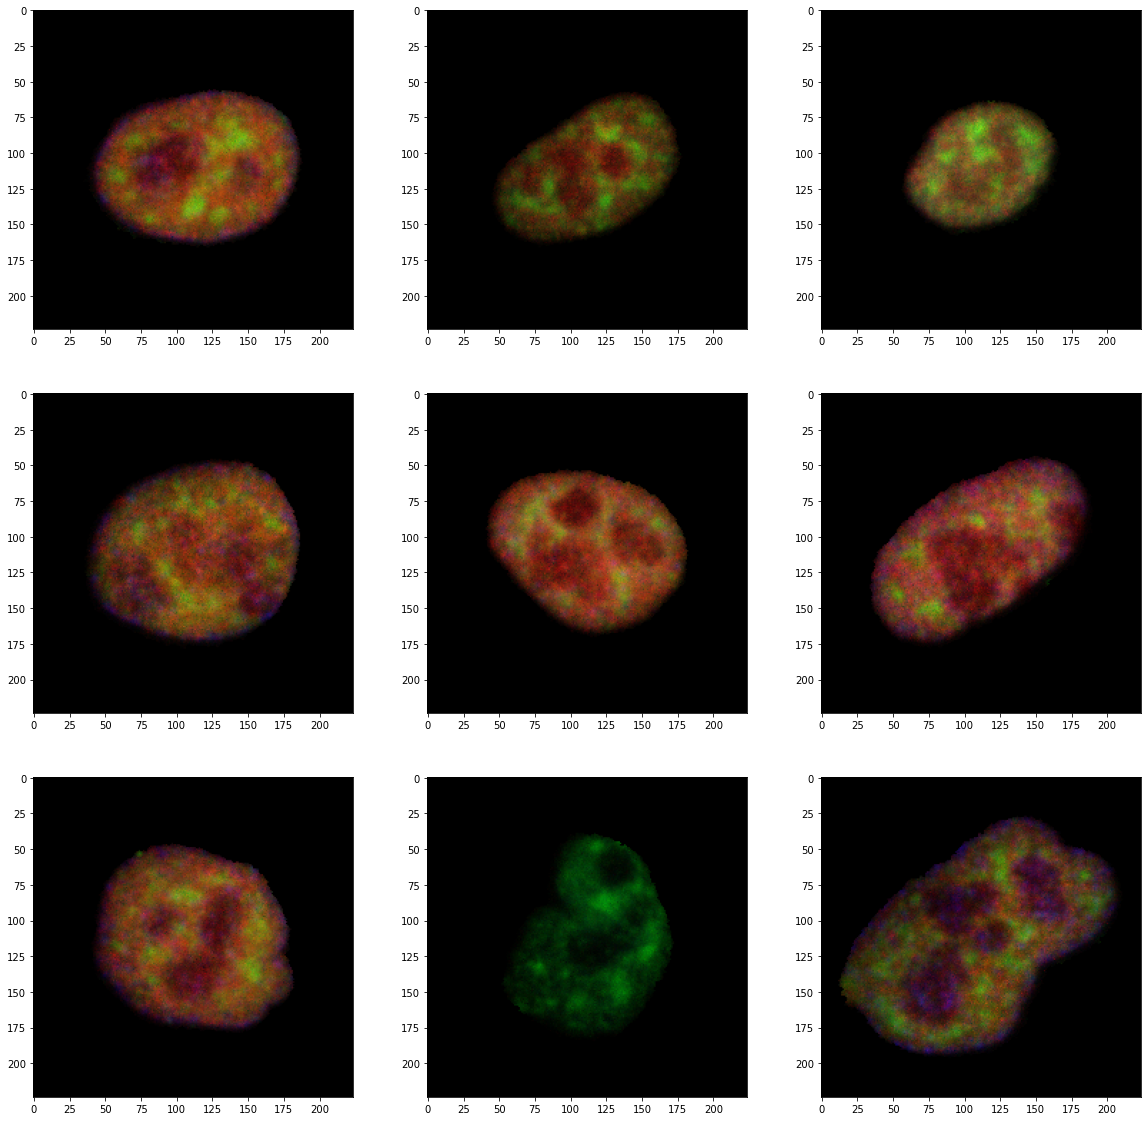

In [13]:
plt.figure(figsize=(20,20))
for i, (img, _) in enumerate(train_data.take(9), 1):
    plt.subplot(3, 3, i)
    plt.imshow(img.numpy()[:,:,10:13]*1.5,
               cmap=plt.cmdata:image/png;base64,iVBORw0KGgoAAAANSUhEUgAABHwAAARhCAYAAABQwJJqAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjMuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8vihELAAAACXBIWXMAAAsTAAALEwEAmpwYAAEAAElEQVR4nOz9S4xl67bgd/3HGN8351xrxSsz9+s87qOqXNc2SFDIpQLJHRAyAhoYN0CuhrEAcd2xRMMdyw2EhOggg5tIZWHJDR4GYQsLIcCygCa4yrZcZbvevrfuueecvc/eufMREWvNOb9vDBpfnOtTVfeeunX33mefnXv8pFRmrIyINSMyY465xhwPiQhSSimllFJKKaWU0rtDv+4DSCmllFJKKaWUUkpfrkz4pJRSSimllFJKKb1jMuGTUkoppZRSSiml9I7JhE9KKaWUUkoppZTSOyYTPimllFJKKaWUUkrvmEz4pJRSSimllFJKKb1jvrKEj4j810Xkr4jIXxeRf/6rep6UUkrfPBkjUkop/TwZJ1JK6YuTiPjyP6mIAX8V+MeAHwD/DvBnI+I/+tKfLKWU0jdKxoiUUko/T8aJlFL6cnxVFT5/BvjrEfE3I2ID/g/AP/4VPVdKKaVvlowRKaWUfp6MEyml9CUoX9Hn/R7wOz/z9g+A/+LPvoOI/Cbwm09v/iNf0XGklNIvu08j4v2v+yB+wf6eMQIyTqSU0pOMExknUkrp5/kD48RXlfCR3+exv613LCL+HPDnAETky+8rSymlb4bf/roP4Gvw94wRkHEipZSeZJwYMk6klNLv7w+ME19VS9cPgF/5mbe/D/zwK3qulFJK3ywZI1JKKf08GSdSSulL8FUlfP4d4E+KyB8TkQn4J4F/8yt6rpRSSt8sGSNSSin9PBknUkrpS/CVtHRFRBORfxb4fwAG/CsR8R9+Fc+VUkrpmyVjREoppZ8n40RKKX05vpK17H/fB5E9tymlb6+/EBF/+us+iF92GSdSSt9iGSf+EDJOpJS+xf7AOPFVtXSllFJKKaWUUkoppa9JJnxSSimllFJKKaWU3jGZ8EkppZRSSimllFJ6x2TCJ6WUUkoppZRSSukdkwmflFJKKaWUUkoppXdMJnxSSimllFJKKaWU3jGZ8EkppZRSSimllFJ6x2TCJ6WUUkoppZRSSukdkwmflFJKKaWUUkoppXdMJnxSSimllFJKKaWU3jGZ8EkppZRSSimllFJ6x2TCJ6WUUkoppZRSSukdkwmflFJKKaWUUkoppXdMJnxSSimllFJKKaWU3jGZ8EkppZRSSimllFJ6x2TCJ6WUUkoppZRSSukdkwmflFJKKaWUUkoppXdMJnxSSimllFJKKaWU3jGZ8EkppZRSSimllFJ6x2TCJ6WUUkoppZRSSukdkwmflFJKKaWUUkoppXdMJnxSSimllFJKKaWU3jGZ8EkppZRSSimllFJ6x2TCJ6WUUkoppZRSSukdkwmflFJKKaWUUkoppXdMJnxSSimllFJKKaWU3jGZ8EkppZRSSimllFJ6x/yREz4i8isi8v8Skf9YRP5DEfkfPz3+PxWR3xWRf//p13/zyzvclFJK3xQZJ1JKKf08GSdSSumrVb7Axzbgn4uIf1dEroG/ICL/1tPf/UsR8S9+8cNLKaX0DZZxIqWU0s+TcSKllL5Cf+SET0T8CPjR05/fish/DHzvyzqwlFJK32wZJ1JKKf08GSdSSumr9aXM8BGRXwf+C8D/9+mhf1ZE/gMR+VdE5Nkf8DG/KSJ/XkT+/JdxDCmllH55ZZxIKaX082ScSCmlL59ExBf7BCJXwP8H+J9HxL8uIh8CnwIB/M+A70TE/+Dv8Tm+2EGklNI311+IiD/9dR/EVynjREopfSEZJzJOpJTSz/MHxokvVOEjIhX4PwP/24j41wEi4uOI6BHhwL8M/Jkv8hwppZS+uTJOpJRS+nkyTqSU0lfni2zpEuB/A/zHEfG/+pnHv/Mz7/ZPAH/pj354KaWUvqkyTqSUUvp5Mk6klNJX64ts6fpHgX8K+Isi8u8/PfYvAH9WRP4UowTzt4B/5gs8R0oppW+ujBMppZR+nowTKaX0FfrCM3y+lIPIntuU0rfXOz+b4cuQcSKl9C2WceIPIeNESulb7KuZ4ZNSSimllFJKKaWUfvlkwiellFJKKaWUUkrpHZMJn5RSSimllFJKKaV3TCZ8UkoppZRSSimllN4xmfBJKaWUUkoppZRSesdkwiellFJKKaWUUkrpHZMJn5RSSimllFJKKaV3TCZ8UkoppZRSSimllN4xmfBJKaWUUkoppZRSesdkwiellFJKKaWUUkrpHZMJn5RSSimllFJKKaV3TCZ8UkoppZRSSimllN4xmfBJKaWUUkoppZRSesdkwiellFJKKaWUUkrpHZMJn5RSSimllFJKKaV3TCZ8UkoppZRSSimllN4xmfBJKaWUUkoppZRSesdkwiellFJKKaWUUkrpHZMJn5RSSimllFJKKaV3TCZ8UkoppZRSSimllN4xmfBJKaWUUkoppZRSesdkwiellFJKKaWUUkrpHZMJn5RSSimllFJKKaV3TCZ8UkoppZRSSimllN4xmfBJKaWUUkoppZRSesdkwiellFJKKaWUUkrpHZMJn5RSSimllFJKKaV3TPkiHywivwW8BTrQIuJPi8hz4F8Dfh34LeC/GxGff7HDTCml9E2UcSKllNLPk3EipZS+Ol9Ghc9/JSL+VET86ae3/3ng346IPwn8209vp5RS+vbKOJFSSunnyTiRUkpfga+ipesfB/7Vpz//q8B/+yt4jpRSSt9cGSdSSin9PBknUkrpS/BFEz4B/D9F5C+IyG8+PfZhRPwI4On3D36/DxSR3xSRPy8if/4LHkNKKaVfXhknUkop/TwZJ1JK6SvyhWb4AP9oRPxQRD4A/i0R+ct/2A+MiD8H/DkAEYkveBwppZR+OWWcSCml9PNknEgppa/IF6rwiYgfPv3+CfBvAH8G+FhEvgPw9PsnX/QgU0opfTNlnEgppfTzZJxIKaWvzh854SMiJxG5/umfgf8a8JeAfxP4p5/e7Z8G/i9f9CBTSil982ScSCml9PNknEgppa/WF2np+hD4N0Tkp5/nfxcR/3cR+XeA/6OI/A+BvwX8d774YaaUUvoGyjiRUkrp58k4kVJKXyGJ+PrbXbPnNqX0LfYXfmYNbfoDZJxIKX2LZZz4Q8g4kVL6FvsD48RXsZY9pW8V+X3elt/n8ZRSSimllFJK6RclEz4pfQEHKfxauaU8/SgJ8Ct24vvlmg/s9PUeXEoppZRSSimlb60vupY9pXdSEeFYjPu94YxEzvuHA2/3nXNrADwrC1d64IpbPqy3XNjY5UJBCDVUhO/sBS/KGjuv1nsAro6V57cz7IW1C3sH7St7OATMoUgEj63xtu8AXJsyifBZ61/TdySllFJKKaWU0jdJJnxS+hkmCghVlVOt7AQ9AkN5cVhAhAgggtt65EqvqP2WZ1I4y4UHvUd7Q4ogKpxkoRfl0VfObQWE6+PCe89P6LnwdhcuLSg7bDgacNUUD6HqTl8hcG6qsZjw4IGPp0cB0aAH9Ke3Pcbfp5RSencI4xwfT78EEPlP39anBwPw+JmPkfF3Ab8XGzJGpJRSSt8emfBJ6YmJ8sF0A1REC9UKv373SBUooUwVbo8LNKWvG8EtW7/idb/hVHeqFg5y5FgM7JGwjXao+KNzlAP/8N0B7EC7KjxMyuH8iGpjqg1meC6Vowcv1sYP9IqbdsN/Zins/prHY2cvzgevJz4PwUM4oZTDxuc9+GQNnhG8XHfeZhVQSil94whgQPs7Hp9MmVU4evCoI6lvISwWbAIXgptecA0awat1pHSqwvNJOTVnRXgrAh6cPdhytG1KKaX0rZAJn/ROO9nMrJXdoYrTovGmbwDMMnOyA4dF8a4QytUkRFdMlOMiNDtQ1FikILHiNmFW+A4H9u0ZK0cOZUZKww1Q5bsOr23iXozWO3UJiKCjLOZodPQS/PG68/EUfCpwbobaxI7wad2ZHxpmwbk4+zZxUpgVdIbX4XScKo0IOIrxQTXmvRFToRTn88vj1/uNTyml9IeiBRShBMwRnFVG8keCA0aTUcczFWETwYElYJ+EEsGNC61A7TA5yASLgsnT+gBTzOEQwaNCQZAAF2ge/HRZ61QE96BlCVBKKaX0zsiET3qnzDIjBEEgUTjqxKyVxygsuuM0dikUYNaZg524Kp3QAih12rHdKGpMpbJbMGEsVC4KhcoUhWMJznsFVZ5pcKnOruCiWO2YBgWn9I0yOUInemc2oQbMm3BbhXOBTWESaGooyqLA2kcJvgJUaolxN3cxpDt4IyQo+4Iy7uSGQFfAHJrxtjvt6Ur+ZEqLYPW8rZtSSr8MFFAdv4xxQWYhzCooMCEcRFiBRlBEKBoEMAWIjsSNRiAKJQQDFlOeyficq0MPRS2oASUCe/q4UFgZLWAi4zgcGTH0qVU4I0ZKKaX0zZYJn/ROeb88RyRo7JTthiodtWDtt1R5xMw5lIlbczrKFsZR3zKZoqJsU+HOJlQm1nrgZI25CdNuPJ6EUzOuXAhrXEpHZOVDO/OTqfFGjIcQfvdmR2JF+8qyPdIWo1pw2zaaFw594WYvPJaFqjvvVUdr45ULkxd+TYRProW1KXsv3M+Foisunc+XCg+grXB24zuyoLHS4pGLKS4j0fRrpyN/8eGRV0/tXd8/VN4254eX/Wv+F0oppQQwGUwqQFANENhDOVkwuTB3KEUp0WkRTAqLBiEwiXAVwkZw1uB5CJsJe4FahOddWCK4aOPHPqp8SoFl3ZkcKmBlVBM5QinKq70RJTgItAbnDntW+6SUUkrfaJnwSd8Ykwqz6u87o2aWwnO9YpEZUQWBu1PDVehqlLnz0I6owwfNRym8Blc4S1VaUbrBUS8cz0YRZ1o6XSYmEQ4aPJOZ08G5keB7lwP/STXOFfrkmDxywLEQ7i6dSqPEzhKdVwSqwfMaeFcObFxxQbTwsjlvenCu19zUiuP89fWR26nwgRk3zfhL4ryYF44G635Gyow25W4PHuZAQzi1yltfMD0jrLzZJ37jSikRlIBj7bysINNEIzh0sIBPaudZg7Y7P9wyGZRSSl+VMilzwDGCaRrVPATsgIYSQCnOJGAGXoWpdkpXHMMXRcLxcDYPRMak5ikMEWcTZRV4pp2f7AUFShW2Y2XeO1f7zue1cAhYIlDpuCoXUR4Ejq40dVYLHl04GtxJsDvc72SrV0oppfQNlAmf9AtVRXhackV/KhZXhCKCy9M7BbQYV5YTcGfCiiA6qnBeFPAQQgSKYh5MFE46cWQeZe7WMAcTo0hhKkITQULAC1WDyYJjcUpVNglc4FYLxRxoTHSQwIrhatQw5nAmAjPnWdk4EmCdFSdoOB1rHdFGiPMwQ1NnCsf6jkYlLNiKM2tQLThoYF0p1lgDLq1ymgvNlD06sxhBsAccRBAzpCpTdN6K00IwKaONTAylYtopWlABIZhMuAsBVz7dOxNOieA9VeYCTYIXoXy+b3gW8aeU0h+ZAiqCIagEBlSEHeGkwS2woYSMc21FUBstvN3g2EeLVavC/SwogiCYCEsX3IUmgaqgATXABA5PlT9zKG0abb6BsKhTJRAxnjtIKBow+9OAaAlchUMPNkaL11yUqkEBpAUHhS1gzfCQUkopfaNkwif9wiiwyCgfbxL0p3kyRYSDFvZRmEMQ9Kc68kWF7xfljRgXhA3lfTM8BFeFQ2VpgbjRpXLVFsw6lMa2KjUqhYoobObsGLtPXGnjqgTXsyKTsLYOHnzHFt6Wxh4NYmORoOnEVg+Ui1I7VOm4Bi/KTg/nojHmIIizsRF9pavTLHhVC4XAvBH7BjqxT8I+ByUa8xQUBb/f2fdO9wLrgX1WztrAGguV3Tu7O0c1lmq4CF07sQcNASlU2ZlCmZi5LmceTdkFdgmkCNeh3HTj0nbCGhbOR1J4KIIZfE9nHnpjc3+agpRSSukPa8QvKCpUUWaUop1Z4ArlJcG1wHOFT0JoCi7BHIJWaAW6CKcOocLjJHx+NIpCFbi+wMmFQHmUoKpifczlAWGWkWjCjX1yXCF25ao0whS3ykf7zqMoWyjHFZyOSoApRx0j4LqDVkFFUALtHTXBCNa/c4VYSimllH6pZcIn/UJUVaooFrBhBMKNdR4iQBVXZYoFKw3TzjMrnBlVP79N54BQUOanyp5SoKhxtR85qdCmyk/qNc8uFw50CsGn04lfsc7BNv6tqfEeCwcLPqsP/Mo68Z41ntuFaWq8qo1dnF89KL+z73zu8DYCXSewjkwX5jOU2qB0Yg32ubNG8GZzjrVTxFkiWCZlnRtb7dy6cLoERYLLtbFsOzaDXIFdKi8uR5Ze+Gw6o/uR527cTM6P/cyslQ/LNW/bxFYbm3YeHpUiGwcLbgNuSmFjVEBdLIgG9GDdCwfpKMHLMFYNtAfqzq8tlUd3VoJuR8ouEJ0+P/In9TlbOI80fvD6dSZ9UkrpD+GocFOFByksEVSCLYSDCpWgSfBdD1yENypUC2YRuggvCd5boJqym/HpAtWDxYN/6KR83nYeu7McF4rAugZvzvDRZkxVsEX4dLtQRKgTLIcREzSEOzN6GzcGeg3eLAWzwqJCbDv1seIdmnZeVwMPph4s4dgu0OE8Fx5657Lzd++MTymllNIvtUz4pF8QARTDOAijHUsKd9EpohQKuwgHhOmpAqiqYgJLCCeEjrBhnBBUA4ryoIUjY1Dx3B9AKyoTiwjf3ZwizqbB98S4LQ0x52TKVW0s5iwVvh/OQYU3WvAWTChXCOoKslH6Tj0r69TAjBCYp40ihaPAbJ1zNKoGs8H91nAJDOE9V7zu7OE8iNBUuCN4rztXDqhzwdl9YcLYRPkU5dqCBWNtwaM9Et2QLlzXjQ1FCLQ2Dl05PFUCfRoBIYgDp4q0icmDFzRmKWCjNa33nbVNnHtwas5jLbgUJr/CSoHo7Ox87wSfr2ce2vY1/99JKaVfLsVAZczhqTJasC4IR5OxBQsobVT7mAQRzizGrsFW4CijAlMEfq0ULjVoCnMo5biDBBvCfXfaLFCV19a5KgIzXB/BemACRYI7KYQ4onA9OaJCc+G8ClfXQvFg2xsiFTWnCNxU47M58CYUr5xipwd0Fy4lmDRQxpr2GzWONbi/6sgmuIM7PDzkbYGU0rfXNI3zYWvjXHg0pSq8fupUkCLYlXG6CbZ75/xyvN98J0wn4bALrz53tv3p8ao8zfLnnFPz05ckEz7pSzPmDIzUDoz5ATDmCyiKoRRRZglClE0mTtIoGIrh6swiLChn6UwKswhXoZxQLiLci3JCKOaEKeeqBIF5cGwrVmZUDBPlaruMdiuDD1VR62DOwSrXMRI+Uwnek2A3pYsSPoZDhwrVhXtpTD04dViXhjPhoVAaEzpW2dZO7E7XMWTzoY0tKoRw43BvsIpwcWGyMSz6OuBEcH5KSEkUkDFn6E0oL0pQu7C7c64rtc3UKMxzBwwTwQLmHqh2zFZeN8VUMVP8oLSzIT24wykhhBoulVfScK/gQu0bUkDEmPaKFKWFUUO5Pio7nT06GkGg9Aha/N1Ds1NK6dtCgWqjHbm4MNsofFkRJgNsVKIaMWb5yNi0pV1RDYo5JxFWRsXP+5Pxw9nZBMomzEvQymgVPq9OVMEOyrk4pyZMBU6APA3csQ43YbSAMOdQgyjCJYSHAE6CNqdIYAFKYBIcTNDpaaV7M7R1mgSrBG7gFoiAr8IhDCyIQyBn8C60HmznkRDKtE9K6V0mjAT9z4wbxRkJmt6D8NFaeyzKrMJ9f5pTWoR6NK7ec9YK/bGDw+lGONwqh7Py+DjGXETAPOm4aRBB84AYz9kY524Af3q9FRF4nnzTH0ImfNKX5rbMLGqUgHBoFvQS/PoGbxHOwCSdIxXExhwBbkZrER2twV4N0c5yWakRTCJMFUo/MltA6Sz1wp0bR4SPauOzw5EQ5aN15yBC0LnEztsKrRakwHfkwr+nhVWDX7ULH8mFWUFEuVwXWhO0w/WkdN0oGrjC5SVA0M1540cOzYkIfvf0jPfsjMnOWw1eNKdF4WGf+F50fkDwBid8J6yAKGLG96czR4NLKVx7cNOE6xC2euH1dsREOc0F0RUTxwQei/C8CEcRHqXyonRmQHqB45lLOPdNOe8rt6fCyQxXoe2PeBeiHfhxPTNpcGXCqQjXVolmnLsjbjSEVnacyhKFiZk+v+KD+YoX7cTV1rj0hdf7xm8//uTr/Y+WUkpfEwXuqqIhYwuWOmsNZjWea+EizmRgIlyiYOZcafArYvy1e2WJ4PvANAUnwDT4neuG3ASG4m+FfltQcZYe2AxTKHJWalG+Fx1T+EQK+2bYNobuHBZBi0KBvcJpgWly+ND5+AzTZlwrTOf+9FUIve0ci2FV2BxePhbaHDA5V+egG3SB4gf6xYnd0bMg2pEYMfODBV5tzkO2eqWU3mFLVZaiVDohyo7wgPC8BkzCelQkKuoO4bw3V+yn90cfnOWxc7qB998z7FGZm8BF+J1VuTo5pzlYW3CqgpjgKlzVyiKBAJ+GcGwNJ7jXwuLCeWu8WXPDbvp7y4RP+vuy2LhQdIRDKCbjoneKYJIDoDRtoFdMONY3NnukMO5IFlEmJpRCVeWzp+of1cJ3tbF4R114qHD3tJ4Wh9uysavwWIJrV6YCaOeoZz6msIWyyIW3IlyjPFfYr9q4Awuowp+UCys+MvGTPI0lbrxaYXFjEuHTgxOrUVqwR+NmAt8E1sp7R+NNCV6F8155jT61T60dHlXYxXnQla7KC618KMHDqXHonTk6B2lPLwQUc+N8VXlvK8y98Nc40o/2tKJ3ox2C0hw7d/74+cBcoBbn2VSps3AQ565t/Ghx+hactuBPTODdkR4sETxUiAqHunJohbUJ295Z2g7iaFVeeGdrE3tUzrbw8dVOdKHsyhonvMTY325nfFcOOvEPxXvs1TmH8+Cd1w9vv7b/jyml9ItSVClFiDlGsgdhwrjRwDXYZaeWmRsLJoNP505po9rn7QxWhIJTNHi2VPYODwFncabHgomw2Wix0pNSr4LzNoYrn/bOjPPQBHHjOFfW64buY6/7s9vOGsIllJCOtXFXeAn4aI/RelZgA/BACNaD0YtBCHrplLmNu9ahXM/wMpSLB0dto+rIg7YrSiANxAObx80XEed+z1vNKaV3iwDPlsK1CovAakK3UYXTVIkFxIXSBNPj2MjbG2Ht6YQr6CTcbAdwx8+Nu1CmkFEiJI15KrTZeF07ss+IBCadaa6sK+x7cIOzSCEkUIWDd2ZTap2hwypOiHPnwRuBiwf7Jc/JaciET/p7UkDkaf2rFhyBgAOGiCACBwcoBIopWJSRJ6AQZUXlaVWtKypl/CI4RKGP8T7caHAKwVDEgusiFIHWfbRfmVCKUrqCjpJzFaF7p+MgQYizq7CqMNdODcUQmga3EbRwHnF4WnUuEVwCDn2sfXfriNq4kI3OAmyhrCg1xraULiPl1Z82joXrqOCRQMTZ6xjGKSIgQQnHgIMpRceKXRCiKIHiTelRoIDSqXvDChBBMziGoR5oOEctiMBkcDJnKUHv43txo8qDwNbHXedaldBAFue4VeoarL2xWdDEcYAqLBLMEdQonKuzqdC7MFNAx/uaGhqGRaEulaoNCaf3zhvuc6dXSumdIz+NWwgiwVSEWgSrgQZj3booxZwu4BpYCarCrHCswmGDqrAdFCvjhUELxWblocNDjC2KxUcErSbsOm5SFBEuAhhIwLTDvYz4cR1jdo9aUASmEmx9VNeGMlYjBKCMwdEBJeAiT7FOhF19DCJCiAqzQHla+z6+NmGW4NjH4gGRcdEYT98PDYg6hkOXEMiET0rpG04Zox389+aNwlyUWWCWQM2IaSR9ShGWxYgutF0pJsgmCILZuM5XgakKpY+zZ6hyZYGFEgLPa0dEaQYyw3p5mtOpcB3GfQQQTDgFHcdlzuRK6UJtwtbBJHDgtAurQO+C65gB5DHaxdK3VyZ80t9TtbFha3HFdWGMDQhmDzaUhtJ1rIpVMRYrHNpOyAGXE2W64GWUIe7nmTpNiEC0jQ/iQGjH5cxijVuUA0EtDyx2QFVotTEBUymUqnzizihgVC5yxFujAHOpLCo8GPwnBX5Ddy5SCTGKNqZdOXhwU3YIoQMSwl6UtiuyKVcEZxsn+gmjPkDvsIvQLoXruXBXZqwF5+kCQOkTJwk6O+or27zzSTG6Ch9dOqUEsypXs7KtAIIbLAT3NjaUFW/4EszivLc1bkzYQ3mcBNkFlzF/4doC6TuqDb9uXJ+DrnA+jllHuwmrB6sG1ju7Kp9NxkEmjqy8FxuflsKb1Th35eWsfFAahx5c3U8sxfgshB8p3FC4qh0vzgWhxYEHKbycOsfLhgCT+nhVlJEkpfSOmYpSRZgYrVdLgWLBrqOytYqw1Mr9vDNZcK2wP01aEDHemwu3T+vRPz8opTV8E+73iYcqfD533opzY8ql72gIN1K5HITwID53NoRWjfuiHB6Vt0UQFU5bp+xCVVhKwAbeO07A0ajutAqX6+DwWFge4bgFPzFBbLRVb5eVIoKa0g7K9SpoH9U7n+7BTYHnMoZP7y1QCa6OcGbcmZbunN1xARA4f63/XCml9IVNKnwwGedJ6Dpe32hzeoGuypUW5qmjE/iisFTWblw2hemB/c0YaL9YATUmgVsLPgtBxFimiRMXNql0Ud6b4VN1MHhRlDcq7CZ4VZ49VEo0ZmsEnb1OdBWKOqAc1+DFxflxadSnc7c1oxLMAjKNuxZ7c7YtB0B/m2XCJ/2BBDgWw8PQEA4Cb/sVkzg3cqFqGxlqDJkLaz8whfKsObUUOsbOzpUvWG+EOq8PwkmVqoGc4KbdgyvuhbkLrp2zdgq3bNIoJbg5Tqxn4aXAW5zfQNhqsJqzbcEzgybBY9250+C5Gc/MmKzivhOxctUqD7JxVmH3a05yz1SCWoR7NQ5zZ/aGPB4wWSnuHLbCWxGWYhyksnHkoZzZysZUC+IH1J1aNrR31h48uGHzgbtzx3rnWidezIDBS3xs/wIgeNyUVcsYGH39CZ/rFYrx/eJ82jpagucqPI/gUw3eSvDD9lRerxuXtnK8GIsINwXenGExYanKj7RwYyuNzset8Z+zoBg8WuFh7bh2DgWezZXaBO9wXx552yoXgmUJtvmGVxtsLfhonjhdHbAOul1oVlm6cefG/OJ7fHL/kjeXh6/1/2tKKX0ZVMa59LmAauAyVpNHjEqX0+S0okiFMm/8cTXsAfpL+PH3nFDFEVZ3ehFMoYQTd4FtQn0MXh4BDW4kuLXOs6Y0F966c2mdUzdu14n1ygnGlq9LUWZT6MHqG7++KThcOnyslW5BaDBt8CMRth7wA3gVzh7QBIrDI41VOvskaHFOGnxHhUvphCqocTw3SgeJ4O0F+hIEwfIo7NdBEWHulWXbmH1Uvr76uv/hUkrp71OtQikCBhajS+FShLswmgqbCbeLcnDhEMLJKpebhhzgWCZMnEt31OCyLlxdg13Dw8PO+0WpwBrBcQboaDRMZ7w7l3DO5UDYuLn6cunsZiwtuPLOuly4voZbgTevJ8Kc7sL5YsynfQzVR7g9COdLoW9wuzjzZmw9uETnsQXuRiyFrXXOm7O1vEn7bZMJn/R7FMFE2ONplSBQGSc8QXAUk6AABaXLjDKGU846qmOqCLNOdKnj4z1QKqenrSBngWt1FgOKUmgQNqbNN0VibJSaVXmDsAKPbjA5iziLBbcefGrCowpva6M4VIFS4KDOxGijihBmDTQC3DAVnKBbG0viQ7FWeN+ENYQtoF46YtBDedwFlTHYWcXwKpQoeATFhPNY+sUzB+8NDeEoSgcQwVS5kk4PxSOowGY8tcE9ldQTdHGYhetwiPE1X8/6NBRTufRGDecKcIXWDe+FtXUkRvm+KFxC6cqo249R+WMI7xFY6UQoEaP9zspoA5vcEWa6KKt1FGUOqA6P1jnU0TZwEaXExhKwq3GaG9YC2+HAkedXO9MkfPrm/hf+/zallL4sY8nWOH/b09sI9HCqghXYi7LOihXhWMbadZ9huxGsjs/TI8YeFQVRwQS061jtYqCiFHc0YI0xzFkE1OC2j/lwDyIcd2HbR5XpXpSyjbarRYw6jZim4mNTi4+Ra0fgjYxbCzMQveMBlxjVmFX8aZMYhAQiQokgZFS+hsNeRzw2H71rY/bo2EK2NKEBZ4VJBJfxuZ5Pztlhd8Z2mZRS+iWzPJ2jPYQFMFMwodVgcqGIYKZEGTe7awg6TZg7Fo4dYJpHO9d1UR4QJlWemfLKg7lC0WDqzmQ2quCBUhQVx3AmF1YpqAhtVmQKzARTw+bCXBzzTu8721P7rE5Cf4op01GQYuM12AzLBHToAcWUoowq0eZ4NdyF6FAugAhiwbrmxt1vk0z4pN8zEjdG6z9N+Ag1lLCR9GhSmKKhLkgYXSZUO0WcGxGelU4xZZ2OvGljDs6kHfHKURsHhZfu3FjjqigiyltriAZFg3WvlF1YujAV4bWMtbJtN65PnTtzXkhw1YKPpfJKjJfWeC+MGeFahKMGB3fm6LyOwslGWePnTZlMKdowWZm7UFth2if+2Aw/cOVTD6a+gSk7ytqFu6dtK4EhU1D3gnSlSuOz3ikt+MhHuaSpcFuURuCmqAmn2Hjp4CJcF+FlHYkzlTKm8HsnNGCaea9D787vtuCPHwoextumvIqVqwbPXHgowvZQ2JrQ9sDYqU+zFTrKxTpuTtmDFmOo6B8To5eRWFIR7rrwWGFV4C2glVBhryuH3tAuRFMaG0sdZawft8JdWyldaXbDbb3g2thcKMy8f7jljsrnbx/pkWWjKaVvpqpCUUVFiKdNXCYg0ZnKGL75tiqXquNtNXYu7Cfl8U6pY0ELPRg3H2Qke0yVaYUWwS5wcMNaJ7rwSg2pjmlQDd7flVcIPy7BhyuEK7sIfgvTW1h24WqqcACioxGUzYk2ElQngiUKasJhCVp33IWLGxE7iwbHEliM2UM1dAwTRekOvTmX2QgPah/DmX+6BrjOwnKBtwZvSvCeKZcQugjfOQY/2YP7PehbTnZLKf1yUeBqERChObxwoauxq/BQ+3htgFK04EdDmzBvYNMJjRWRHW6cQ1EWFe4E3khlEuUapeFMJZg0KB0uMs7dVgQLwTSYrLNcYLPCLoVYGhzHrJ9DM2qpPN2exi/wuDa8BcustPY0U2iC865MEswliKJYD5xAQpGDI96pq4IZLYTehMkDncb7btvfnvDJyQzvtkz4fMuJCjoZpQsS0BHem47sAY4i88LcnBqMGTEqUCoqhY/kQugY4FjD+XWBE43XfuYReKsjn/DB4hzK04RL7dwvhSrwK21njcBEuFJYLivMFS/KW98xHavIr8a5mRXlkxA+D+di4/GPtmns2hJ4XeF9Ohi8FmhtQ3xnMef7k3OxoMn4Gl2MxwYftxWtEybwYQlOh0YDdjEe5cDjDkuHUzTu6VyJMMu46L5dhd2VTQvKxCo7zVaKHal9PPePJ6FIH4MuV2EulVcuvGzOry+NfWrsk3AW4+1FWDp8twSHDXZxZuksNTibcy9CPVyIqVG3wNqY3O8dahPutGH3O0JHnxcu0rggvCyFD14C2mhzo7AQzWni/M4ivC+vUZmo3PCiP7CF88aFUxTkaRD33huvpxMF4Tt25tNeOVrnw2XDQzk3J/bKf+n61/kPH37Eq57DHFJK3wxaBH0anHxCmREOwAtRVlXuDT6ag4dJWavyPYG7Nl48vD0EvStahKsD8NYpgKBsO2ytUQrMN2Muj8tI+NxvAQpRFSkCKlQVrkvww4tzMYfqvG2wmwHCe5/sfH41cZ6N64vwyoOflgXd1J32NBD6FYUXNNbe+PgxeGjOAbiy4JXBB6HcbMKkwWdiXFA+RvjepfOW4JMKz+bgjXfe9g6z88d2pWzCx2d41YXVDe2Gb53uzk7wcJgwb1zRmWd4fQ9Z6JNS+kUpCrXAOewpUQ9tH4mNxZQPDxNrdE4F7o7K9ihwJfQF+m5EcVSFOxWWyakqzKK8Z480CTYVHq8q3w/nIHCu8EwnOs7KztVypLQN6Y31qMz3nRPCPBW6+ehMsMq9OiJjVEaLimhDp8502lm9I3tH1w1rE0VmehXOrJx2wwJawB47fQ58gX0TPjTlWIW/9bKwH5wyNz48rfxgd8xBI9ACtU2UbvRqGKN6SCJ4+XKl9zxhv6sy4fMtVRmbOkyE2Y0dxcWIUHZpqI27nF2Fk47VrkcEMcY2LB2bqpYwjijfNbhyxV1pCIt0jjgfivMThWtxbgRORbkfYyX5FLiJYBGYcX576VSFSZV5MiYaECyqqArxtCHrXoybEtxJ54etMdVxV/YqlBKVcKeyM0+dIoqLEkXQFmP4pgWxQQ1hqkorDdzoIfyQyvu00dYUEMVZ1Th74UU4op1O52XA03cNU2ePzkWEsyvWV5bYqdJxEx4kKD5auQKnClyZEDKqgmYTtAoxg7lyMePz3WnhrBFUZjwa4U5/7LzyoDFa3K6BELiY0/cxAFrUx3p7NWZRnoWxToKEIF05W6E5qMPRGx6GMOYyTVZYgYuM1gV3p7dAXbiSeyaBA4Wqo0XPLLht497voxrnu+DqdEBbYd2V5hf62mhZOppS+iWiMip3ikDYaLM9SrCIUkTpGKHOpHCjUKtyM4+V7MWMizrdgrUGp0nGhfOl4a6UGIsOPlicTxmbd60FXYMDwikUn5XaDUF4VTvRjN6hqXN0OPpoGX7YDXxsw9wmo/cg6GyqFJmYxJll59PuLG6UEC57UCqj6lSc5zK+WCnCB7vzgPKSpxbqCVTGVsq3IWyqTAV07agrgiLWuQ8oLpiN1m0lnlqwG4hionTpmMaoBJqENw9BlvmklL5KReBUxoiEEECFK8bWQRO41MIUwUHgSp3joWBPu0ae3ynnA5wn4RTQvHJAeQ+hS2BVqBP0+0AWxeaxSfhBxjiFxSp9hqZCp/BWNvZLoLsxA/K0st0pPGiw1UBLsFE4zsGhNHxzzgLuhkfQiyJdkC4cJfDqY/5aU4qN5Iy686EoF4fHUSCEqaAGH72vXHnQxZB54aA72nlatNOxdbQBX6qiuyMxqjHvrkd8acC6OW0PsmD/3ZEJn28J4T+97hKEKorquLA9uvEgyk7BpdC1Y2aYGi5BVWEKmBQOOnr+mzpGMIdwHcqv2KjAOYs8bXl1DnSupPGxCCrjZHutY17PYwRnEW4YVekFuJ+CmdHitEyF2oPAn9bcKu0p4XMx4a4EB+n89qbjwlaEqyZEGDwlaybrGAXHcAu0CRY/nWkwZhFNVXljDY8xt+dT4PhUvF48KJPTNNg8OOI0bXRtPDicdCR8lHHXtgs0UbbYRnJGwAw2YB/z4CjqTMhYz6uBqmAqiDg6AQ57GFt0ejidYI+CRCAe9B0uCg0QOtcUAmfjaWOaCKhS3TEKJkYFXlbBOsxNWOVpo1oER3e8j/7iozZMD4DgwVgp6WMjm7hwZesYti1HZtpodRPl0J3VlFWFSw0OvlB65XE11hZsIvgeuGfkSCl9/YTxQqCaMMlouRVgUeUggoqyY4gFVYPZYK5GmcZ5ei/CWaEZMI12rdI6sjlKZdR8CteT8EZhDfD9adOXC4cwHotwbIo15XzqEDqqYVowh1L6WMO++2itCo3RZtXGjLamTtdR0n8AftwCC9AAukMZcfUaYRGhKewF3u/BJeCMUlQoddzIseasWsZGmiLEuiMUTBTT4FzGwOfJhNkgItDeQcaQ6tCxAlhtrBO2oohkoj+l9NURRlXPwcYstR2hIRwRDgZVoZbCdYz5npNCOdjYMrgHN1dKzEKvo93qsleWrlw5PESMFqwKtDHLtJgwhbKbs5lyXY0yC6qCA291I2LcPJ9caDNEhwhhL4KUYDGnVaUsncMUnKWxYnRktFXJmL85UTnYRtMYNye64hZ4BIhzI4YhXLpwKOO8G0V4dhTqGS4Ij7VQWlAJjhIUdcRHIn6eCqo70YNdhJuD0mLEK2Qk7ts+Xjnm5fs3XyZ8vgUKoyd1R+lPW0cOJhiGhVGlMGkQEnQ6B5txnXA13q8rexv9+VaVF+GcxXlN5yOHrTY2C9p+i11duKZxszr/v9JQ4Bble+Kowo9F+Mv7xD9cg/fUmWrjx0zcR3AK5x+oha0ae1E+8zYSI6acT0JYwxG6KxrCSx3bUn4t4HEfiaGzNe5jYilwI8px26EGXoK9BF5mxJXWhdkuKDBrYfbKRQq9GL9hnU+scB/Od9cLasJHsvMs7vltnagSmAfPLjAXQ7rQtx0157rA7QyfUtl70CK41c5isInzie98ROF6Ek6z8vgYbCZsCI/nxlUNZoRyD5/HTFen26hiug64pnKYjO/4hnaYduM1lWgNbY3H5cLWhcmV712OXGrlwYKf6E5MK/MqnJpwv65MqqCFBz1gcsYEqEaTwrzDB835iVRkC8oezO4c64FWgh+Z8OG606TyxiZKWfF1Hf3Ch0I/T1QPbqeNtZzYZWGVxuevXubN3pTS124xpapQRbD+07XrwKQ8R5jCabFyUwtUiCn46Fjo1mjS6UfnOzGqTt8ucC9wLsZmxhTGwUeC/m+2ytwdm4Mffwh/4hycVmG6KJ+twfTZznwJvntV+KSPKqCPdue3i/FGgt6d59tOVNhLsG6BMY8XLbrzO+We9824w/iNbvzYO2/p/INisAe9w1aEz4ApnGN0/vIRjnvjI3f+1in4cDYKwYN3rk7Kyw4/WZ27KdhknLFfNOE8jRsYd5twZhtDmQUuJ3gkWMUpRajmSANv8nX+E6eUvgWOdZzH9xZj0xYGUpgsxtZaExYrvF8CrXB/hOcOdyI8OxU+vwqszlxZZdaVV7PhTXlYlX3dudrhQ6DbgeYXYt947zDT5orMyn4jXNqY7zPFA4cJpAfqgb0tYz6bdJ77I+9fV5Y+cTgf+K27M70KrsZ6dOZNxzIZCw5vN641eH4Nb17B/Sb0LtTqrLWxSvBmMsoWo5JUCyo7EpUexhbO+iw4R+fh7Dz2gjZni877B4c+0WNilspxecMezmercaXjdYsILFfGWoWtBT0aDw8jnqRvrkz4fAuYwGxQYgxeVFGuo7AgBMKDOEsxTioURlngFE7pUCjcqqAanMN5c6qUCJ7vzt2p8ukm3LvwN5+f+YCJRSf8tnHaYfLgJoJXKly5srjwD2gn1PlcHG3BiqGM2QavzjulC1TYNbh2wRjligcpoxfXYaLTq6BauDvPnK6dVZyHNejTTmec2D65HIFx4R2XQqFTI2hUJjnRxena2PsVWkAM9sm4pTFJcD0Zj76xF+N1qUzNmbYx76g/a5zfBusaPGrHdEZ8lPS/8GDVzlqC1ybMHSrKi2Lc1k7MndcHR09KxMjoR8AnvWOb8bwJVx6sCGc1vrt0inZEgktb6OtO753dxuykA86J4EUYn3fjIYy/chTmfcN6sEjHyvjXflsbZZ2QHQg4ycY273QTHnRm6hdQw4px3ZwuwV6DtxHcBZxasLBx25177ZxtRfaG6AGxArFTj46Hwz7zGBdMlOuY+Py15FS4lNLXRmVUdZanbVYmo5LxWIWDCTvChbEN8coUtcALxCy8Jug6NqPcqPGXn1qc/3iB/dAwUQ6h8LpQdcckOHrwEJ2I4PkDeIPXBuuN87YHx+ejTP9OAgUuqvzksPD+3rjH+Uyc10VBYHHlj2lhjU4niAq/sgYlRpvvdw2ObVQS/SSCZRZEhbXB5bBztuBBhNMxOF5AN7jdBVfBi3B1XXicoGvjROPm8xlVYbfgpPBwHzRVHj6qHD4VLt25qDOP7QBMGjQf1UFuwTY5N8+M82NwfszbwymlL48Ak47XM6KgJkQZ3QsLyk0da9LVhA9VmRZHalCLcFYd4ykKvD0YzIpW4WwzRxp1dY7N2A9wp4XnVtmWzusysc0TNx8K65vC2pXHR2OTDSlBqzO7dK76mP3ZrnautrGlt6nCqgRBr43jJBDO3oPnJtRdWVvw8dZ5IYUpBN9gneGuCFMP3mzOfjCuLXg/nHNVjlG488KPozP76E74eKoci1AlaCJc64XjLlztxrpXFOdgK98pjXsKgfFRdaIWfJR/0ksgs1ANpCnPl8a+O6+2vIb/pvojJ3xE5B8E/rWfeeiPA/8T4A74HwE/eXr8X4iI/9sf9XnSF6MqqAiKUAR2xqyCSZR5LJwds3FUKRIsEhQZ20XqmDzA0QLVIAx8GuWEqsG62Fg368KbY3DThFDlPCkXEYp3arRROt+EgwiTOBcJtoCLg5Yx3+DigjwleMzHHIWjgKqz4WP+DIEwqmDwccL3CKoFosG6B5v2sQWlBx3j95bJdqFIEAg7xsULLo2G09BRB1+CEGMmmNSJKtg6mrZWLYgF8bR2vQvsIewhtKeBZ+Ex1p7jo9xzDqwU1MeWllKNPjV2C84hLCpsHuwxvqb21BO84kzqI9sPXGsH63QJGg1kDMruJUA6czgWsMQoNT2HcomgRzB5cFRBXcfEfwuOT6sbezBa6MZuXpo7EQGMvoDbBveMdrSjdCyC4kFtwQHFBa7COUeAKibGIcbQ6ybCpY7vuxUoM5SrE7F36J22b7/wn4X0i5dxIv2yGKX/wqJjznF5SvjUGhQbcdJiXCTXp7Ymr0Gv0ExwGYkgVIjJWN1xg8sktKc5bJMZ/fK03lyg7KOFmh5Mj8Fmo43qYMHqAZOwF3gIofsYcNwRNEZ7VoGneXnj2CaCbqOcf2/CoTu9jaTOrkGP0e77qIL7aFPbLHgECKEyWotrharByUcbwtOrJ3xyTOH01O5Wp1Hd5CqjDaCNc3vMhuygHpQauI7jDB/JI2fMhJgWwTv4LjQP3DPnn/5uGSfSH0W10UqlOtq6MKOIUAXmSTF72rooCpOMNldRHipsE6yLsM1GnQytOuZqhlF8nM9nG5u4Jh3X+Eczai2YOaWM1wabF6SuQIxraUZrWQVChVMd5+WQguo4tkk7m3WijVapYxGuCDaC+4BDNw4IR+AnjFazmeBggc+C6NjU6MWorqgHWygTUBnJpRqFQnCsIG4s6lxpsPWCFUcYr51WVzTG92mbguiM0REFioyNYCI6XkMEFHday5P4N9EfOeETEX8F+FMAImLA7wL/BvDfB/6liPgXv4wDTF/MMhUsRnn1USDE6GIUU5TKLMoHGvwAh6eEyrUIooHIqB7ZJ8eq8KwU7svGrsKbg/G2wItFeKHKS5s4a/BI54dqfFzgowjeF+e9pqNdKYKtBzPKI8Gjd24PzorwqcOvF2dqjna4joXjBF6cmDaadJqP7SZXFK7XjnnwW77y3u5Uca7ceUtl2w3bjZP28XEEoBQzFOPilfttJH5aCY610asQk3JqhaIB2nhrnSUO0IyOwjxznju7Ni4PRmyKNeE6Km27sBmsVfnJofPy6LQl+M9XpUlnNzifhEcbd3njDL53HnvQge8f4IOridWUH99vcAQhMHdOT1vKukIrF1gnMKVPKz/pK2tA78F6GRfTswendecVE6sqt9XZ3KnSuaZzODv3s/A4CeoC2zIqu6yhYuzi7LrxKzrz28142+HXY+Ueoblw2I2yGLcExwZ/1cpo53LntmycH5R7c17f7NSzIcXBOsdf/R7ydiPuH3n98uOv9wcj/UJknEi/LKoJB4XbCNo0Ll6lB4fTWKO++hhs/14d8+ruLdhPxqbBhvO9YqwS7Bps18rzdeeizu8cDVmVu6rcLcJ+vfOmw9aU5+fgEEY0Qfadh6XwKwi/scFf653dg9cBf203Sh8VQR+0jdfRaB7MLlypsSNsEnyuK30xoiv+2inV8U3oj/BqDl5KcD/B3cHYHjqB4wfns6YsAncGP350rm/heoG7R2je2YrwUINanDkE7TNnHJ3BFuFzV+yFUnaBzzuPN4JehMNZkBtn35VoAsVpVeiqWHTiLBzn8X1/s8K6+u/NhEjppzJOpL9fKjCbIjZuZh/UUS1P88OcslTuDGYRXsdEmcFMsa702vAriFtho1BKoZgQ20b4iU2Vdtq5q45aw3WjfFZ5ryiC8foTQ6+dZYZ5hW02pDXqxdlLH1sfJ0W2mdvDebS+Xk4cbzcO6szR+Ot2wbcJb4UyKc+nHSvBSWD7rHAnwosJfrDDRQPUuZo7L5dgF2X2hVuEzRofl43PZGYqjYMG149jC6Np57Ds/C4LaKNOG+Z1LJ9pzsbEcQ26Q2uFk24sFaaDENbR7SmBVYN7V5ooV8V5c7/nTJ9voC+rpeu/CvyNiPhtkezb/mUydZjVKJPhJpykUMSIBmspdBGInZvZUTGMA+YrgYEq28FZZuNoygtX3ApnNdCJFwY3kzIpbA8rb2MGm7i1mbvlLVcuVJ84HXYOjw025weniWkalTnTpSMyLrIV5c1unMSoRXhL586VGaiz8ruXUYJ/pyN5tSKoBTfTRLvsrB3OofzaFfjJWQW2reM+NkwdNYgpiOicHh5ZFziilCi0Xnm7dTbZubrZeHBljpkXwMe907VTBF70iUmM3ZS3wOXUmbrz3ln4tBqLw/MGr3fndjWaKJ+WncMV6AxT7cyPzk1Rbg+Vv3jZmUcHG6+6cHtuqMLNR/CwwimMZygvZ4ip4dJ580rYjjtNoGlQz4yWNQ3eXFW8bZQtkM+u+fCu4wYP68LVsfMYE5804U9c7ZxoHOh83BveBTdBps6zLbh05S3Gmw7XEhwKbE24oPQQ3DvnY+eIcL0pN/uRMo85SaVd4+8/QgTfeSxcTmfWKFz8wHOEYhO6KB+q84PXr3jc96/3ByT9ImWcSL9wwriDuigUg21SXhB4KBcxpC0UGjOd9ydjPwhngzngFmeuQjkYPwkfVaom/HjvXA5GrxWfKlePgaydR9vZjxOsnSqOP1eu10bswaMVpDmfNHjY4QOZsKnRrdPXRglnFjiqcG4TUgMtndMOrQSrOauOCsydYJ2C/2wrPIjwowXuHzeuMZ6bUcx5OwmrKH0V7hiVu6XBnQpXD8ZxN/Qa7tuIIR8+Bp+UiX5y7FlHqmCzEia0h0aUseb4dHDWGGsgTOFBC/HKKauzF6P1jrRgaUI3WOuoZrrqUCy4CKxZ4Jn+YBkn0t9FZLRnvTDj+LRd8aJGxBgi/95B8daZJ+NwmjiuR7xuxNT5sBv701bFNjlTnbjxzof3jTI5/XPHdyU+qMw0MGizU0TZmXjpsN8KelJkAs6VX73acYO/OTtlFg7AMZwf7cZ2Zby+Vljh0QvVO2aPvGoGBocilP2AArUEc8BVBNGCx1B63fhRr/xwK9zNZxoHdmY+ieAD7+wq/KjA3dwRL8zbzPd9oz12PuudsAd8Lmwi/KAry7FSduGydj54Juyvje2t89nFuZqh1+C8dd6oURBORYgQvEDX4GFzbmbwCo+u3JTK5dy5nDPr803yZSV8/kngf/8zb/+zIvLfA/488M9FxOd/5weIyG8Cv/klPf+3XgH0adOICihjW1Z52si1qPFKjKqFKoabjfJEcYyNSUb7kOJjqr04RUFV0af2L6NyJY0rChqFLmNdrEcw9cYmQg/H28b11JmfpsF7C2r46BTd+++VqU+mrL2jqtwW4QZhCcEQxASLMUm+XMZsISWQDosIdMFjDIhs4fRwQoK9GFOBK+l8eh7fE7OxtetIR9xZHfpkuAvena4XEKGIc83Gq6asGG/rRCsbSwnuFsVCmQKqQK+KRIweXPMxOZ+RhLkINBvDom1ydDZsekpQVcOKcD91yvaf/juhQmxAwGLBRToYbBU+OcjTDCYlrmHpgftoYbs6GlN31j2IGoSPNb922CgiBMaulb2P9e2zgk1K7Er3sQFtomMiuAcezoRyF8pujdmMoygeYwtLEFxp8LArLsKDCGjHQsDHn6fekOi4GuHQS0OXsb3LEdyNdjwxrzudM+u+fn0/OOkXKeNE+soJ48WBPxWSqMBhgslBRHARCqOFqyDsdczPEREeprG9UIA4BtJGu4AUQJRNRqBse2cuBVGj78o0OSJCb8risDZwF+ZSaOF4jFXuuje6wyPwikB0lP1PBFcilAjWCEoJdoVNhE8nxwqEQetj5t3MaD1bUXZGi7WI0XXMz3mUYHuqyOwuHKsjMjZ1vuFp44uOgc6bOdHh9SboMjaQrWH4Mr4n6iAqaDglnr5vRcbq3jLiRpmg7ONGzKxjI03n6WZOPLW1Pf3rqARFxyKxrPVJv4+ME+lvs6iMa2QTRASzMahZQkd1T8BNE4qO7cJFCssEXowQpZTCRKMjPJYxzkGj03vj6AUXI6wQ0bAidIIHcyYMC6GHUMxBxzlxnhq1AkW4K8rruVE1WMK52cto4XKI7ngo3QXdHVA2Cx4qTxuSO3MbsePxaaQDO+xiyFM8KF2x2qkKUyt87kpXuK0KFbQLc4wNvPdSOGOECLsaIXDsHbYxXkEpFB/bGttiRG+4guHcTJ1NlShjl/3N1nlgjK2oMl6/iMLcxuwkmxQILuc8i39T6Bf9BCIyAf8t4P/09ND/GvgTjPLMHwH/y9/v4yLiz0XEn46IP/1FjyGNH8CjCkdVbsy4K8rzMqp5qigHNXZmkIppxeuJk81cW6FUOIRwCGeOjZMGz0vnw9L4UJRrVyYvuCxcU/kOhT8ZhcKM90rbC9UrVQJlZ98fMN2x0pDS2C8d87HS/XDuzI+d6eLMMtZ2mwfvF/hgFu4MbgTenya0Kh2BB2XBsXB67ywilCbIKlg0QsYgaLXOfYVuwRVO38YFZzVBanDnjdu+AzvdRpnkW+ms9kCUjVmd522lbJ1tV37CgZiNm0PhO6eKVKVWZZkEn4SqiqrwWEbp/K6dx9K5L3CZAl86y3EkWLQoVeH6UOmL8LvTGAytLoQb86S4Ca5QI5i1E1Pn/uT85Mp5OyttMuSZcnOtPF+U24Dn18p8VC5V6Oa4V8Jn9O4RpCNdmOvEpRWsw3NxlgJdlNWVOsEydY7WuGpBc6cEvBCl1MYyda7n4AMz3l+E9w/w3UNwcymwGm9C6LahPbBNCdmYz43DpXEsnaUJkzTK4YGrJSgVWlEeliPL4Zqr+fgzLwbSuyrjRPpFUR3n5p8mflThOI0YWRE0FDVlNuXGBJ07NjvM8OnR2LvgDutJaEVYdaxgt9m4TIU3paB7cLUZt2vh9gJ1BimCd+XqHBy2oDaYvXDZlUszJp2oLiiBG3wijR8CH8uYn3erylGUt+5YdUSds8MPps5ns4+5E1EQUWYV7jBeMjaEqTpWK2tVXtXgYw3uQ9hcaU05qDCLECifKbwtwbk6r1TYFjgfgh9WQ68cn+DtXnioSg+wPVBVSg+sdcIDLUGf4XIQpMB0UA4npRgcizIXYVNFXFEfrcM9lEARGbEwizfS3ynjRPr9XJlyLEa18ZqgiyJmHEV4psJz4GYVPrSJZzoxR2E6dE6mXMuETIUjhROFuS4s4hCNczQODtdz4fZU+UBGIuU0GfMUzJNQJ0WLcSyjxXba4WbaoAg2Gd85GtNVYFfOdBW8uIWbAxzqGDWhVZFaUJ0xNVpR3sxCWYwbFZ4/zc18acHLp3ltu1ZUlZM60gqzNq6nCy+08COf+HFMfFQUtYIUYaqdowqzTZSyoDKxUggx3ifQsyObUCjoRdm1cD5W4ljpWhEt3E3C1axMixIn5aaOWXYhysEMKSAWLALXCNeTcHWj44bI6PxKv+S+jAqf/wbw70bExwA//R1ARP5l4P/6JTxH+jkOohwYw8Dun6a5E4ozcawzKoWVwnODqlcgC6U2VuCC8CoK3wG0ODF3PvLgYDOzFhaCXoQHDX6onYt9yIHgNnZsD64PF7Ru/FWp3J0aN3Ru7p3b9TKqhBAOU+WVOR9LcLbC6uOOalmD9/c6VuK24HHfOcVKJbj3a2qBNglvrFDXnV2FV0fjJw+N5Y1RLwU/NrpObOq8lcavPkL04LPduSzBnQlHU/7ySXm8GNfA0YTrDi/D+bEKy3EkjrTBm1DMG1M8sr7pXBfjsVb+I5l42ZziwtSFD7fO68lYi7EGTC4UHK2Nw6J85yDcVOF398rru4ZNzvst+Gva2Tu0TXh2HbQ92LrTSufyXQcRpofK+6dGqaAT/Je3hTbvXKTxN14a7aRYBXP4rO7MYlzJwtmUWzcOKrxuC/t8TdXK0Tbu7hdO28b1+cKDgcxj4Bs+s07ORPB+dF4/KmHGPk0802DZjQjlr1yvvG9Hmiv/gTfuDnCgcxTn83pAQ4gWvHzYEZ1YpPNse2Q15dVmfPJauWejdnhmoJPBYngcuXb4wfk1LbI89B2WcSJ95U6LoSaIBccwah1D49cWPD8opspZlck7BUOkULaGHgRZwCrsd6PCZz7DJ4tyrMKNCstjxxmx61CEB2ngwXte+VTHpkNMKSi3W7C2nd9qn3NnM3dUXlwUFeOVCZ9I8EGH0oMCHO7g9dvOeYOHMM7akVBuQmkulPuCutLLzirBBWgqlF04Kpyq8WMpyORo9TFpfxl3apHCS3cWD0578Gc+VBYPdOs8bHCJ4MHg9bHTdkFLYakFfXhguhLqlVDu4fUedAKbnR89wtGV99y4WwuX0rmcOtcitKWM6tXXnak27nfh4VyR6oQrzYOtZU9X+n1lnEi/R1So1QjGSIdjN25m4VbgqNCPwnway2MeevBdK2xubF2pJTAblZGldt6UQhRlnpxX+wGTA6FwHSv4ipQdvZlZ7w2T4DeuC5/uxuzGrSqPzWmb0ANeTYUalako18+C47GzKvyAwhwzRfvYpPu7yrnB7PDeSfisFtQvHNoDn5dbSlOuunH/cuNvllFB+syCV9aY3Fh75UVT2CuP3fnrFnx/L2gXftsdC+F8dh7vO99F8FI5mvJrceY/umy8LfCdQ+H7U/DgwevW+c6j8ubcaM25XYSLPbDuzt94KOiVUdWY1Pgri3FbGh95x1348Vo598BnxyosTViacHohrCFcOrz6PEc0/DL7MhI+f5afKb8Uke9ExI+e3vwngL/0JTxH+jlUY1TChGJdxqR2UaIY3o7IGFXPYpViVxSZMd+o8xlX57gb6+TMBsfiXMSYxUE7l2mil4KI8VEUfiSNI8odhVdsnPeCOtw4lEsn2FFvsAuPYjzKSA7JLnjAHg01RVFw5X7eqQZHUU7h7GGUAO8roQsgTN5564VOcOjBfVEuz4K1+5hHhI+vn+Dz7lQPTB1fjE2FSYTvGXTGbJpNC8/ZmSw4avCydY42Lo4/F+MUnUmct9NG5UR44OuFY3R6THSM1zg99tG6JMGjBbOMjVhSOq8qXKpwpW20xolyBK7UedTgvsAdxmuCJs6VyLgbXeHuJqg2yt13gsu0YwF44WYZFVG+C5etMvfAm7BtTl2E7p1LBB4N7TsSsAosJjxMO29046P7zgUd8x0cTBRjJOeutRIahD7ySTGaCuaKy5GXIqA7h/JAmwpbN/a9sNpGM3BXxE9UdkKET8uRs49h1mUx2nYGFiQmmgNd6a6sZpxKZe2Ni/ev7wcpfZUyTqQvlQBT5encPyp5dBrrwWcNKKNd1hSuZsHbqFhZxFEHJ+jiHJ5WV0UI5RzMdbQMNC2U3oiAcxNODhI+NiR25boW6MabFWwycKfvzn6aQQMX57kbFoXdhZe+c7UEl105r0qdgtvSMXM+F2Gvo8KziGNFx2w1gu8jvKqdBzpHh63bGJgp8KKAorQwtuM61swHHGuAGFvAm+YcntbQ9xBevY7R2ztBs07vhRYwL85eglUb9+F8iLL34LGPj79UYRfh2JWbrkwdxDvbCruCi1Bp9EcZiwkm4dFHG8ZxFlYfiwgkgjoV2t6ftkKm9HsyTqTfowRVAhGhqjA/bcwq9rRFUZUblIMqJgpVkVAmt7Gpdw6YYQ9YWicILofK8wkuorwW43ZyKmN7YjOFyek4r0SweUI82PdGpeF19MJ+50Vl1515gg+XwsuTUM0whIs7qzv7DlfXSltBumPeOJqxifGJX/PsfuJBH9nnRsyF5wGbB7hQLVAZC11eP1WsYrBMAbrhEUSD0io3CqdFeGgblKDq+NpNC13hRzh34pw1eKjODxTaBNdFmCLotdAlmDZhulJMQd357h6USTEEPwfPpuDkwe7BWp0awqEVtuqIjPEd9aC01cl7t7+cvlDCR0SOwD8G/DM/8/D/QkT+FOP16m/9HX+XvmRjS+xYq+0xVqRPahRRmhpbm1GeVhXqjNlMkYl5D9QeCXOEUbpuMtqudlNWHNMg5hlXo1C4DeOlb9QoVCmIC1s3JISjb8juQMdi3J3cBN4KGI2pK+ZCaCA2LtB7KPdlJBrCgyWCc4xMR+kbYjOO8uhjSKQFTNGRquyL4+LI4zTWyuN04MGdSYJFA51gF2VDeQ/4iRibFEIrezRMg5MFP9kCl7FafA3hLkAlWEtHuxLulH1n8saKsDNWp8+xo9FRhU1iBKIRc7ios5nyfekYI8E1xyirF4Gd0UZ3NmcLZ1bDGbOKbhdYK7Q+Nno9Wqc2w7pwXQM2Z2/K3hRrCnvQtvE1793Zw6nhaG+gY7tXF7jYzr00vr83rJTxd4A4mIze6FltrIAvjUs5Uh0kwCg8aENpXJeNtUDbla0rnQu7QldjkhNVOrsGDzLzECuioFXo+0YwI6L0CDSUCGMXY7GKR2TC5x2UcSJ9FfRpCDNPq2OLQSnj/DszpuELY7jnzSy8lXHTYcbRGH9uEhyeEi0ewqGPKh/RUQE5twYtWAkmGXFKw2lhXPs4sb7cgxOKh9PcaUXRPqqJnnmhAY7TtHMuY3uXd2MrDsVRE1YBr4KUoGpHdKI3aBE8i7ExbBM4bkrvCi4ocG3O7so5DJk79DFss9Sn+TgBqwdTH4mxrnA+j5jgdSRgooGYMEnQDLbo7L1TRVk92PaxEnhVpYlw6MJVCObjhczWoJsQAoEjK2gTMGNzEAmmGmzbeAFnEpRieOv0zPekJxkn0s9SwJ6uiU3HaIa5CjXG9aQU5ajClSpHMcwKUZXAUDe6g1uHyfEdajgu41x1O0MXYUfZrirqY56ma2BL0CK4R7heDHpnk+BYglYCneHqTlj3zjQFh1mpB8HLuIZ+3Dqtjdcjy0mYJdAt6L0zi7BJ4WwTv+rGGeHRgme1cLd3thDehDA/fQ86wb3AomPu2WSKTzveHVZBm1FFKJPwo+hMNmbtnBljJMKCl9KZA3YNmozWscWCyQM9w1QKoWOr8LKM1yfSnO8orKZsErSLcqrB4sG+j89RTFhUELNxjR+dOht9D8LzxP7L6AslfCLiEXjxdzz2T32hI0p/aEXGysEFpWKoKJgwxYy4sbVgvyocY+J5V94uAX1FY+c0d+o2elDlVjiflVMUbkPYI/i4BLs6/8C+oi64wZtF6TzwmSs/iYk/Jge2Ars5+/7Ae8tYuS6XgswbRjAFlDPo1KEIh26cdIfoXGTiahPMO0ff+KBWzsCZwNW595UfhfH/1sI/4Rulwv0J+hZY3ZnEsfuJy7VwKcobV371sXEjysmMxwpnCq+88GILrq0Ss1ENPr0IiwfP6Jya03aB6NxK5zKP7SblXFhbR6ZA1XlsldWEZo15XpEdLIRShTucowVXVZhZaLE/rT00XraOaucjVy5dYFeuL7Cac5iCaRHWRTiuSnXYDZhhMpgL3KtyVid68P4ncGmNGsHNoXB/r+wuNBUu94UuZyY2/uTZ+CGN3ZxbDd7EIxJwFcr5qDxMO29t5fVauNp2HGOtJ+LS8dnxa+d5L9ytO4s/0ifhx9UIMW71Bfdb51qcaV75RATtHZqzlpWijRqdDx+hLYVHOm96H5tZfEdcKDpxVWYolboJD1MHHLLU/52TcSJ92aoJxYQW485nETiFsFjAU8XLaW9MxzFQmN14NhXEBDHHXNlXQc/COoFYp2rwK3fG39qCrs7z0857D4VHDz7F+WSv3LWdYwSvD0o7d5ap8eF18L41ykmIk/BX2wMfBTzz4KI7z/u4EO9T4d97FAjnO/NO6MTkI0b+ahW265GwX982Pr85cXZhrc79eadG4cqNz6TzgTpLAG3iwVYuHpy3xq/ZwmfaeGXBeqw8v8CVC1Rj8p06CXowXpiPicn30KXw1pxWQC9Gi07x4M7hzTKWJJQmvKxBf2vog8ErOJ0CMSX2wqMFxRtFgh/OxodnOO3C61XoE+zhrL3jVBZxDgTq8CljOGpKkHEi/e1OpVBNn2aWBVOFMjtHCsyGTsI/cup8vhd2LXAA4sDa4ZHgg2q8rc5Fneup8/aoRIETO6+7oOJ8Tzdmm9DNkeaUKSg3lebB4+sVv1VclNiNpSqn/z97f9Jjy5Jk6WKfiKiqme29vTnNbaLJyIzKrCow8Ui+NyUI8B/wB5MjDjggQIAg+Bq+epVdZEbc7nTe7L3NTFVFOFDPJMEByUExo0lfwBldXD/HO1UzkbXWF2Mo9N/fnHlnBUnCf5obN7MxL515qhw+CtUGRMWz8cvWqE35zhfuzonbFnzdG7/0yk818bTfcNqEaJVrwKNl7urGLnBRp9WdnsbydvVbtDu40zTzUAPFMenchnE0x0rw/XRLyBPJKj4HsR2Yacxa2W4KD35hr5XT04GfHeGQhefDAKro6sgl+OWSeKiNL7Xz02R4G2d1EuNN7YQ26l1DamLajdQUTZUq8Grw+cPUfylK16v+lTUbL86RRI1OBgrCLErSQCRImvmq+5gA28T764YdAyvB0gdtY1bl7Zb5qVWSBSl3mhkTRhFBstM0EHNSacxbokSgvVKSM4XgLbggrHuw4UQ07puh6iR1ZIqx/XOQCG48MEbnjqqPLV8Ij7XzCThL8I7MOkFKnf+lOk061YRLUtqNUXrBW+c3dxeObwzV4PDUuTsIgfDB4Hhn+KdGnB15e0T7xF6Vy7lT8kxtjR/2nZL6vxxQ7kJ0p0VwycrNvlE9WKPz1irPe+LahBLOcwqQ4Fg7qQQ78OxwuWtc1OkafJWcryPGNvp943wZh6EgtKxYVshOPTXavWHAoXUOC1gdl9DbIjyGczV4/laRH8GvwgWIE8gF0lOw8EjIcOs8ZihaOYTwdlNqSrg70hqfzNgz5AQlnJtmLK5oVOwrZ01wUeNBLvTamLpzJlHV8OQ8TE8Qhd2Dx+601UgnyHPnm8vKP/XGVQM9wSQNdUfPwbtUqNGgd263ice001PwRpTwzBb2+/lletWrXvVHJYtB3UpZCRlu1Nk6C4WuyqbKfizkAikH+SDQgy7BluFum8jixNSIw8CLm8BD37npw/VYVudJR5/Puz42y9eSeDJIquy90yv0bUQB3gLvQ/mlZZI3dpyqiUsojzg/SmM6JA4v3T09BUUUEeGhOxXDixJvBlklJ6EWAXdSdBaHOAtJBDelJSXVhEvQE9xcg35QUnYKG4+L0UK5qeM8NwHp8NhhOygyw6+isSOjON+Dmyp8bvD9Bu9qcMAp4nQR7NxxB39jdHGmPZi68EvtfFb4EnConU0Vz1BRTAMLkAwhHdNR+By1I/V12POqV73q/0U64rSLyVgeq9DVEStkMZZQfAnmEpTs/JCMmwQLzhaOsVGy0WZBdie60bpxtY5FYC5MSbjeZ47NeXttPDqkScmz4SL8JJUtB/a2cGorOiv9pDymnXcXmLtQzUinzrLAsgRfJufZg8s52EvHNHFwo/1UuUyNFkGcE5cCF3dkbXxRmGsw71AtMe/BjHBI8DlNbDvsGxwm50yhN6G1ykHGneTdQTrdYFO4tMa5Koay326QFdPEN+6ctNFTZyuwqFB9odvEfgiIzNLhmxTsrXOV4LkIHyQjmpnNmWNjqYnqzieuxEEJT0SHOSee1Flb0Ac2jFf+4h+mXgc+f6QyEUxGXjVFvOC9hVsRmhhdE00LUxhJh708RCgqTClIdFAnhTO34EYC18BFcBVmxgNwkSCyE6kjKThtSsQY3Jg2OooDkwz7uUeg2mk+kH1ZHZEABAd2G3lawklRWRQ2hzWEXf4Z1Spslti7oxJ8rUG8dNGsGpg4vQRRoEsnZcgh7CK0DAx6IhKCELjCVQrdjOiCyOhX6Azs7YSQZBxQ3YKpCtIFV6dR6QziuEUgtSH15XNLDsS/dCPUl0PONcgChRgW9hhFn1jQY0QHVAJM6dpxGa6ePo1t78HBTYjOQN6qM7XAHdoc1DT+PThkgojAXWipU0zJIjwmyBKkCFoITQKR8fW8pEB0DKFaDnJSyktfxJ6dpoNuZtHYpY8LV5VCEASlNHBl96CpYx2SOTlDiUraRv5Yp3HB9iqEw6Tj8w59+dlJQc8QWViqcHmt+X/Vq171/0WzDEePvNj9QwZm3FTRrMCIJ6WilDIe8Is6iNOAXRT3gBQI8RJnHXdGEqeogkDzgJdC/sXH8iGSEiZkArGgGzRR9nC6C9KN26SICZGVGuBpIMrdIQUv/9bx92UT7CVO5jZiUHNytMKqQmRwFI0BYxh/x/hj5kiFCcYgxYMCLALWnVz0ZYHgXLMQwej+Qca9HdBaRxSsB7Y7qQupD4hCffk6ZISrQ+6j9yhwNALtIC04KDxE4AQL0DTwlydLg7HhsEHrQgdK2TosNu6F7bXH51Wv+jcvFUFVSKLjPUUUUWgGxewFua5IacxZOGRlTcpbGVhy6wMhriKYKav4y9mp7AlO0ckoqkaZjalCboO0m210A+0IPQeeY0Sd6o6nUQ7dl6DnGPTfydhmp8zB6QAf3QgFFXBR1BXtAl7Z8ui0OVzH2dkiqA5b63xdIXehqlNtVD10CXZXqoP3wGJ0tjVnvC+08V4RdEQH6EVkvBNcCBAnJacnGe4oCcIUt/HOccrQ3Qg15K7jFXoEpsFBRsn1JsK5G8XGPWthLEnJwHMfFSDeB8HrpMKKcA2wpOTJCIdWX30+f2h6Hfj8kSoigYyCrbvIuCimws+T8ZGJRyaeZCbJgRsx5hR8Nxs/F+HYgp7PNHe6N9a28mYKLip8jkQX4UY6J3FuQ3nOjZpHOfHXniCMKoqw8tmUiyq/DNhboOIcs/N57ZQITi/ocTPoCT5Pyne7M9XOfdtRKzQxnsSYk3BbhWNXfpKE1ErqnYMHTRJ1Dq7aufnSqN8Gfht880V4vwfe4IcwfpfgvQe/WIOnL6DJqLeJ77aJo46eoDdqfN+fCWlMxbldg8S4XNZ54+31SHeh6s5mDZuN20Pm8jya6Pc+JuzfhJM02MX43ISGj7jArvzMnKMGP+6d8yxIwPEMbIY0MA9uTHmOzhbBtSVcKoqweObyQmLZHd5KHx1IVXg250eFEPj6AnNr9AqrKT+Vws9sdBj9rsNtBLsIl0m47CsHCbIJT2Gj44jOp5L4eQNp0Fz4aXcmgVtVFoenl434berMrWKig1x2Hc6nneB52SndsK6spfHmSTh48Jw6sk1cLfhsDV37wGqa8Cmf2W2im7K1zs99DOy+//3+Wr3qVa/6A5YAX2flirCHENERGdhw85l2ckoPblYnp8YxF+akEMF0F3QV7KxsXPDR8EO5FhoO6vziWPEEV4RPKPdXOLXgEM5+H7zF8FC0BU/HTi2K5swhOZqMzTLz7BzNsCYEHUvDjXTclN/tSmcMRJY9yAksB8skg0gTwfsGMWc+KjyY095NqHdyC/qpI58TeoFDvbKH8iaCe4Kf8lgs5BZ8qsbJjElHTPhhBu+w+SCOsSrrJvygTpIg9+B4baw5cdTg19L5J81oKMWdugaHbHgPtk+NaTFkg3UNLlPiUhubd+5UOKegyohB9zbcT7sJHkoXRyK4a/C+BM/S+W5rv+efqle96lW/b01mJIQUkF04TJCTEqZMmkgJpHSmpXKXF27TxDp3pi6cXLkL43tfEMZw+Ucai4yi58uk3PQgYzymiVuBlIXtoFg2Zgtmca4Ep6MjB5iL0M9CnaEenNO3ymUPzjvM3vgwB+sEb2ehfk7Mi/Pm3vlYJ7bPQb10bqTyZRppiV9d4emps3ZhE2P9srJE4ijGJwt+c1D2EE7VYXWsAQHzurC406LxY9rZ3RANuq2oFkyEI6Cp8KFULqXxlU2sDm6KH5y2LEjv2LbzdRYSY6A2vUtsH3fOa+fqlV/nzBJjoPS8KlUamjoehZwqU+u8WxNnYgyginDTO60LLQQvQbrPrEX5/GH7ff9Iver/Ta8Dnz9SBc4AHSkSmSNGwfhtKFMq3Gghy8yqG3sWjln5r1SwpIgG1ofjQ0rQTsJlVZo4WTt76jQZU94v4XxeG7IGX0VljYkwIWw4aEpW2qT8fVROW2Pujnflbm6YKKHG6p1mQlfhXQdfg2jCsxx4fIYi8HVymiif3Tn3zuSwqaCM0jQrlWkL3nyEfu/YY5Cf4GY3zqURwDsyZ1+QaWc/Xjl/McpUmHPmknbur0KpwpMLNWBBeCNGS/ovxK2pJj7lhgecpDO3RLk4c13ZS+J6HOXY73Znqkr3YD1Ufr0qqwWfF+EZJ3nQgGly9jUjVSkp+AucTYRnMR59owtoKAeE3cbc/mF35roxJ0HeJC5rGqXIWfBHYZYdm2A5gHwBtSBNla81sV/gWuE4BbcXx1xYLTBXSh6XmD6AJiEl489lTOeTwC8tyGswG9xk5z+H42IUFe6q84N1rtJZu2OHYfPfEVqDvY2tc6nBT3PQdmdZGzeHieSBtMFS23umNuP+ClevrCI83isfWuWhvhY2v+pVr/r/rC2N+PKCsMxCpDHAficbd/uBNcPzfed26eQyOg1sUbyNc/n94nzSxFmU1Yy/YMN2RRpcLo2rGYso/40LFwk2FZ6a8OExOIqQk/D5xqBDqcHdVEdsOTe6NT69F77fEn01lkujaNBDOHuilMbWlWs3XIKkxmTCz835PgdVB7jgujiSgl+mGH9fV1oX/hc4//kpuGjQs/CcFTwo4ewBd324bG5xrDeyKodjHksFFXpSihVOtTK3jomx6TjL1zCkB9IEUL6OzqEHucMvwvgftbN58LUY1324d2QR/o6KhnBqRtWOViE5iMGe/pmgaSy9M6tiIjwXJ3S4Qu8m5enZX9xHr3rVq/4tqQgcVHgTQiqG2iiBucmGJOEcQr+vIIqE8SaOrK7QnD9/LnQZkdUlT/y7eeM7C/7GhJNMnKJydOfNtbDfOlt2Jja258zBja96whfw3ekEh6+cNimxBHpo1BvhkJxlGpGxWjN1M7YQTl9vzCn4+KDke/BFeFiM481Kunb61Tm+E/w3HS6Ja8rIqXHQgWJ/ZOJowaLOrQtf1coFocnEo8Li8HaDPj/xHMEaQW6G9zqclq7U04qKUsnUpZMfgpsm/PawcTRjqkJ+MN5+U6EEMUMjOKbhBv24Zh59xnNjWeDheSx/Fw/2qbFuTu9wvIP//Dwcqr+agl6FLRQneDg5Xzm8b8L/1IW9DmjCr98u/OOXdThlX/UHodeBzx+ZhGF9LEBm2K27DR9eiswbmbhaGSVmEiySWQQKI2qkL7j1Fh2XjpjTslA2J+BfpsUIbAS1vdjcCVIXmg4LuCpcm9KbIGJ0G371kKD3QUCB4SG/SUETpYnSo7NE4CE8AMcYtvreha0K3UfcaK6dqw57oxicdbhkFOh7xncfQ4Qi9Das/ccWaOpkH5ZI81F03DUw33lwQ0LZmtACdpSLCzfsVIMQ4T6CVcbg4RDOVROOcO2gXVDkJcLlbC8xqGhw7sNlNNXgkMAMGnDswqNBEFiHuY8+g30KrjKoZSaQm3CqgjG2G7EpJMGS8CWMg3UW7TwVRTZBDCIHZRof2w0oAcL47wm8gvq4RNujDFJXDvJizNqZtJPVuFjgAefuqDcQoYaRPehlUNEmEXI4V4EPDt8+KpGDbRp7cs+BZyERvNmVpsN1JDXQFuQ92EMYOByj+Pj/FNgZUbpjEe498eX6uvF91ateNc6HyUY5vgOhMJugoqgIi8Bm4w68anAwp2ehT4JMQk8QGmQZ53ZEENbRZBQJTJ1eQEcdG3uVEZdG8AroiFFtXUaM1hzDmcPoL3HdtAXtBijgBX7oYOrkSdCIgURXuB7hnemL0yaoMYhVbaA2uZ0GFr0BfRpRhtAgLzFixBucRShl9OIV4HJmkLhk3MkFWALcgugjQtW0030sFhJO6OiKwIw9C8WFeMGlj899RIFLF44Npg5N4Ks2XKdqA4yWXSkubDGIkvESxy4GWYWN8aCggDZQUQqDLjYlp/Zx380yliU1gtd3g1e96t+O7AW3nlURxiGsqiyiSDIkKScBn8aZMoWgYmQxZlEOzagpcFP2SXgWQYA3EQgNiQAVDjaGReIQasw+nsW9Kdoc1yAMkgXehNhgyo2wcc+ICsmFaxeuoXBwqhlqTi2NvSSOBvcebDJgKz0Ln3ZY2sC171OlfTHyDrk2rMKzwK4jBrtt453BUye5Ij2otUPq1H9eICfnqmMyfmQkDkIB6Sw+ut0qMFVjERvQHHPcfESJRfjxrrNkwaTjnzpTK3RXVh1FdlmGE4poOEKPl7svj9juloUiEB4vtF3DymjtmTel1U51OK+deI3r/kHpdeDzRyYVmHXgvReUOYxLEnozjMwv7cTfqLEZIM57jizAFM5z2jloo0hls47SEB0uoSQVXvKtx2icgTWABu/NB34vEp1OeukguIYT28BK5VmxAqpjiFFXsBh28XdT4Bh7CB+1c6cveVMP7rVxduFzFbZVkBkOOTjUxqcY/TuSjLMrOgVzCtq50J477M52H0QoieAIlLLTLNjEmMK5eqe2xqE2fohMDaNUHQ/0IVSH9zEKoXsyDm3jqQkewUGCloQLyjWCU1OSwxRjSFHDeSkC4scOS4X7K3y7BF9UuIZQNiWKEyJYCLaNzoaUA0JR6RjBsjM2HDKiVR+vZWBzs/DFjVPq3KTOgwX46PfpMxQPeoc9hPXkUATdIeqw7wfKPBfq507DeS7OfJNYYmOJzkkUamdz56cmHKNRMVokikNLnZg7JU1M2+i0+OTGzz4Cc2e775QcRCm4GfTgF6o0Ff4uBX4NZA3yFlzmUaDXm5EIJsYAc+tCKNiUSGnmeT3TI15r3171qn/jSgo3ScgudBlY8aMpbqMwYe7CbrBlGY7Q0ogyXKc+j+MZEQ5dKA5dnLNBuDATJJw1jwWABfRVOdkovvyyO5aC1mHrSsqBWSeZc9875/SSrb1AJPBJ6EX4bhXe5aCUzp6CskJyoR6Db5OR3XGczyY87s7aYLPMzdLpJfgkQphwJTgDp2OgF4cq/OjGUuDggYZwjYBwdnWKjfspAQeD1pUd4Vk7V1csnNlhJVhITCZ8zs5cIdxpOCY6sOndkW4cu5A9eMb5Cxmx7+/S6FCad+HYEs8unL2z4+QQbqfR09P38RJnHqQ6+h3EBfGxYT5virswd2c2hXC29nrqv+pV/1aUVf/lj1MRHeVmJ1WuOSFZuU1CLcGUhINA3ZVFM7dqFAS3TsuwTcHDbkw9+Hk4NSqParRkyGG4XawKOidmOj2E1YWpOb5AzIz3oVWQCEpqtJTBlBqJ3J3mwhWYbsYyuEtjPlTWVLgHvm3O36tQktGz858+O/++JYoGT9OV63rLcnGmtcIefAqhCuQ5OG9jUa5TZ25CtMalVXLVf1mgW9ppaiQV7gLwsXgI67xpE0/TuCff7Gm4KVPA0tlKUESYHH73znk3CacIfN84mVJ347t13KuHPLpevT5DSaBKvQpTDsjBk8NbAA86jj5P1MnZp+AgI/L80Ds/XXZe5z1/WHod+PwxKSknUf69w99G5qwj31p6IdmMS+EfUmM9BMeU+bqd+FXbuJrysRgnUyIN2/giC86Voo130fhYlG5A6jxfx7Q2GXx7cDQlQoQ6BToptQXXNThYQ4uhNibqeh0OmKydJYxDCo4FmhvPzVnZON5XftsmOkKpjY+mPIjwRQQ9rnxThdtVudwIeXN24Cl3/sKdtQsPVTjImSwJMx1fltYo5uynzGUbxcyKI2H0FTqde02U6mw4VwtyNSJ2iJXneuRedgqVf+zKz/IYXH0QuO3OrSgtZba3hrTKTe38+Vn5BzWuwFGD49w5Ytz1xD/0DXkalvfru+D200bkYP8282F1uittE+bcsW1QWvph59IUdeheaW8XLgKX6sh3ld9+pXz/ZuY0Q6rOlIK7N8K8N84brBf4ZSR+kMRnE8Qaz3Ow1MIvn2/hmw3rO9O+M63wJQ78wEJSWHrFBJ5y4XgUcgPbhO8LXKvg3cnHzsPRUYT/uAn7V0ZNxlyE/Zy5bTOLJbI3Pk0dieCvngof08bdkvh1ueH/eC3Mu0KHT3rl6lfCjRwnfuwH3BvGxl8vym/3Kx9b/f39rr3qVa/6veqQwVR40sytOElGAXMSQ8NRd4TCqUArzuqOJ6GUzuHQ6bfKM0H1QM7wZwehmfEDhu0y3Ic1uFk7O4nmSmvCF4SswSkHf35xzsBn7diWB/YXYcuN1gTVoM6d+6tyLo3vT86fz0YJpYhw/NrJ342o67dL53xJPBfhYRG+noPb1jm24IvD35mgmvizWXkuGzOwhPKXn4PfuvF5V77+bSdSsFfl8TGzv214DWyFX0XwFMEPAVPPvElBjiBvcLhXfBPaM8RRuFTh2oS6Z+5TBQkezsah+RhweeLXJ+UhN36Q4PtmfB2GdeEoyrRVZOvsK3TrfCmdusD/ph54nEcXhhq8vRp9CvYUfF6VuXSKBqktHFMgzXlYG38mwbMJPypc9te3hFe96k9ZImAmKOOcPAm8l8JbheWlGuFtEWIWnk7GPYmjwCEFvymFJeDOnS8WiAgWyrQbVeso4Dfjz0/GP0TnYzRqn1B3GsJPV2c5wCLB0ToSxlyFkOD7ZeNt6fhkfDzdknQli6Mb9NIoqXMU5eKZ27ZBC75fT/xFEXJu/M4q+985uwjdhcNm7MsV3TvlU/BwqOgO23Pg7xu3Z4PN+A1ByULzxE/9wJv1wlGM5db4XThzbywRPNdluPBT8LEI92FIONE7880VLsLcDbsXml1Zi/DwZqFOMOnOwVZ+nSbO1fncAz0cOVcnufOXR+Hj10FZO8ujo5bICiKNao2cAiLou7OWhPWFgysiTu87PTqrNnxSppL5+q3y4f++0l/P8z8YvQ58/og0M4YInzShoSyWuS2FSzd0ElJW1BYsBaaGZeEyOa6Ng0CKxlYrTRzLg2iiIlQPikFPgmfB2olJN0wrjylzXAZ1yXc4nEeLe12CqIWuQhOlhPCTJQrw7wT2NMp+NQcXcUjOFJDWzNftxRqoibo4NyEUN4rDzaSkED63YGHY1mk2nENutD1x0wf9yQLyF2BOqAascNr7gMyKDpxsOBtCa53ZEyZCk2EljwjEleTBU4C7UraExPgYUzIsDXJZd2G9Qg9FPHgG7qJzBFaEgyiKcCYoU6amTnNnWxNfokPAm33GZEy9axemKIQ4aGDXQotABUiJQzOSDPqYvN2oByNsRATy7GjApsraR4wgiXCpAdmZ3Via4k1JAn58YEqOto7tnb4GuwQ1YFoZZQspECqSQVFyU+5tdF9sRXleg8erEsBNc0KMcCP2Qj6M/p5WA9+Ufe9YF3xR1pi5dPgcwV0vbAq7BjdeCE30EEoXDpoG4a0HouNr+apXverfmFQQEYo7kwimSpJgDmExmDKIGckgqTNn4VwcJCghuCaqOk5nOQuTwaTBaa7U7uyuzDlxjB0ZhkVcjYMPR+oDwi6dClQ3PkpCI/hF9NHn0xu1BpNBTsOqn3bhvgibDfR7ykbq4/z6aTVchVMSjgrnqXG1oGXnwQaeXQ2m+/H5VIGPFvx00NFZ9xx82IJWYd4gL41aFfXgIDvPm+I+HJU/diPnzqTOeR1x40IwaZCfB0UsTDm3EQefFO6pLHuwh7Evys1aqcBzHl1JXQTz4K4GTxKEjDjd1JVlU+aLsd06KTLRlVaG+3dSkAStB7aDunKdfTitunLG2aTT1DmlsTU++wA/vOpVr/rTlgBJh3PTZFQQoC9x2lD2pvTDsF12IKyxmxGaUAbVcEW42FgEFIHSBI7OZRKeClzW4ciZQ/jIBpJQUd66cFgTZmAJtPWx0FbY18QNlbDOtjkWMB2C4zJKjA1hKsI8KXK7IMA76Vzvds7d6Wclq2MX0CvcnTvXZ0V24ZcN2iXwXdhDqaGI66AY1k5qhuCc9EKSwUNsMuhZm44KioJixZDkYB1nxJED4Ucx5sMgP9ZDUFDmItwY/GaBlozNJtYyKIsFuNwp0wxyds6PjRud0DyWGPFsiA4wzbQI9QC4oo+BSB945auwqRIy7pQ7cX40pbsyS+f01lifnO38WtD2h6DXgc8fkTIgIjxjqCiLGbepUEPRZEgx1AqzNpIKosG1OInG5KOfZZC5Rl5VZThZ+svApyVhz4r2wkJ9wXsn8tTGAdRBN5A50AIbRmdYCIsIZx35UZCB9k6BWXA2Z2EML3hWDi8DlSxKm4IcyqEbcxtxpx4Cz84iLyj3rlQZFvXoRqqjnygC8hU8GUjgzZm7jzJJHT0KMwNZ3zyYArIoBzGijWiUhCIRPLtSO/ysJrwBIhQvaGo4L28G+3jYlYBVOvcvZZe7wCJGDbjgZM2ECM07WzPOklAR3mwJoUMEXiGZERlCHLsWeqr0DGKZqRsqo1foehOwBJ4C6U5OjoiwJqj7sNcXg4uOQVqOYK46iGDqhF3ICvgYDnljkGJ8DM7QQSibrOMquAWSYRGhFugF1udgdyEYUTYxEDdyZJgHjaVXIa/Qt7Et2SaldeMSzlWcW5EXRDEc9swuA2Uv4hxEcRkvSbsaYoa4Eq9Nnq961b8NvdxHqjo6416G6CZQRJh1RJXWpGiK8bC+jDiVhLD46HLoCh7BsgklBSnBfHD2GrSAJSlHCUSgi/JsQvJg8uBJ5F+ACHTjyYzbcN76KPVs4XgP5iqYGDCe15OOK2LpoCEjGgA8NyXbuI+OAm3qI76qL0N3HSjifAxMOlXgieB5FqQJUYOHl04J2YIoDu2l680cu45uPFfhsRtvbODOH5OwihPmLAbl6lRReoatxUsvRXCkI3W4THUaixtTRkRChjsqOhx68GxBQ5ljdCoVV+auHFSYYywAdovxEiIwT8F2HVj72YUDwdyV5MJjODtOFyen4Lkxlhev855XvepPWy/nfNFxFmQRkgqhgmMESnIbUyEB7eN9ww1WtQFEEWEVYU9GiKNA80BMaAXOM6xPzn0oC8InqTRLTKJ8K3BTjSCoedCEqw+QTFTFkkPraB19mmUOsnViNSSN5EMRqKWgClPbeJg6+xn6RXkrDL76FU7V+fxk+K4cExzW4FKFPYzWOhKCCljt5KYk6Zxkh0iEBDWcbMJVoCEkBSuKKiTtdGJg00W5VJgOQp6FLcdYeidlIfg+QU2CW+JaVjKjC7YdYY7xdd62zpwCCPa5I3NCAkSCxQQ/Qu/ARSA57k5cwC2N7xNwEvgggjjMIRzvxgI9quMduvMa8/o96nXg80ckNxsdO+5ck7Jo8FVvnPQNT164VmPxjV8sUFJw1UqiIjhNgrSAuZA6fKkbt+FMjMFKL8FanIfsdHskCE4ivDXnucDqwtGcD7fCUUZ+9HJYWWuh9cRd6fyZOCvBfyuVP9fGrQS3ApckbKKsrliG36KcRPjr7pxUePDM5yjIFlzZ6FR+bpmLF64hbBh/33YyjVME1Wce9sbenW+nxPRwRQV2LdSpkgDrTkSwJGFOygOJ8x4ctPHr2Xn66RazTl7gx5zo13G4m8IlBEEoOoEmJqscpPLV5GxV2V3xYyeXNPp0Lp2jdS4NnnZYHm6Yi9EL/DCvvCEoOPnS8Hk8vKcnSO8rORlqE34+UW8e2VPnnI0pLWzS+SQ7V5ux0rC5juHcFyMUzu87RwU/B0/nwA8ZJZDoVJnZd2danW+fAjqcs/J0NI57I65ju8K90B+DqQs/KzO/8Y2aO8zB+UFZPzuNzrwJ7+6UmmEVRz3xRoSvtPHDR+X7PnH2wr/bVh5qZ6Xz1Bo3Zcbd2Hrn8e2Vcp05rYlrVybfqeJ8zsH9dXwta2TOU5CSsdTC5enh9/1r96pXvepfQSknijgZR1/Q64pwYHQLNINmQSkNclALnE8OljkCv4jKh7mxdqWdE+VdJ/cxOHkCpgjM4b5unEvgJGgF053PrbPvwZYNc2HuweQV7p3elOc18ZnGt5p4Y8puO35tnJPw/V3w+NmZe+egnW9+Ch7eBdeb4GsJHlJHXPhlTNynjdqVVgtTa3xcnE/Z+a7CqQcpg9wFb7tTq/JdV/5SEw+tcb022nPhK+v0DL+ziXRyJJQWmdx2rBmQ+Pa2M+no+fGmvHF4UuULgtXOrQ48e3flwRSL4N8/bzyJkLNwn4TPD41P7jxL53iTeYtRm/BxbVw1EydhP3Qc5TGcVZwloFHQgCU26jTR6VSpvDnDJs6awK6QG8PRtDQOl/Ty4gIPrzTfV73qT1aaoSjcBjRTbs34uShPm7BOypSM/3qa+dI669WZt87t6USbhS05027s6jyY8CYX3J0awScqd154fzW+qcqDfeLehMUUSuIHhWeC75py7DvNxtn27n4izsGyB+e3FY5COyRaztzETlTn8ydnfTuNpWlzfvuh8bZV9Ch8uQnkx0K9BPU84l+PKPss/CJVvtmDuAq/deGT6EtHZiZfNkoKcoH26ByaQIDujYc+PsdIOwcpTAKbBt/dCcen4KYKb+eJS8CchTcZ0j81Dt8oaTa8CR9SgMO7i3NnGyRQEz6+gVBHEJYKfV8JbczfdH5jA0JwvARvTsqnJ1hX4RtrbHSuPTgLvL8xIqA/wreH4EMNLk1YNPNmCk41KGfDDpnb0uFeOH92Pj065/V1ifv70uvA549IpQ/cXdGxkXM1PlnhTV4pprgoJZyVymbOPsFh7SRx1IJeQTRjCU7zI7dhmAQPc8fvCh5waM7jPAhSrkIc4Lh3Zg3mt0L6HIiDM0q/lhT05DTZ2aUgCF95Im6CHyP4pwpzNCJBtuCvVHiajOes/F9245fN6KF0wCZHdyVa5kxHmnBy4X0kbqxiL0XVXhPZgybwrStPKbHR2aozG+wB3hXTQJtgHd4TfJbGDvxdg7ycMQR1xerKIhNZja07pQ5nzUWV27KSPJgl8fEuIWnsf58mcGa0wSFdSAQpCzkpH6YrMRvkgP7Em0jMDOfMtRglCUeDsytn70hq3C6PbHPiMc98F4miTjUnFP5yFi6Tcc7C41Nleje226UHa1a4A+6Cbk5ZoWzC3py7PUghXMWI3bn14M/onFNiTU7FCVVWDdYK+3NwYxPmjd4bMgnuzu7Bl2R8m0fZ9FOHn+aVZDAB8eXEu77zxjvQSCGkSMOOuis5hEkU26C2wjUKH8rG8aqcQmgp8zEcM2EunbkGfj2zXs+/19+3V73qVf//1W0SkEGBGg7D4WKdEYoGGCQbhcvJBDVhmZSpOJaD1pyQhmThcVZSG4uQPju3OfjY4bkJt6uwy3Cy3iK8JejWWOfg+yfljSlvJuc7cdI+XCrfq/AfNkdF2DLMmnkCqjp/OQe/TdBN+FVKIJ2qxp6U7xjOHHa43AaCsQf8bdp5V4XmcJ4ql2+C4zO8vSifUL6aMqbCwyO004j6OvCwd2qM7XWdhB+ZaQTXvBNR6E3w1vnZXWbzyurOsRYuEgQKXVlsxXV8nd9vUJLQ1AiHPY/u6Q8Il2SUHuyX4KMZDSM57E+dyEEXCDOu1gcsoMIzibkFbyLoBeoLsTKaUjZYGzw14Z0EPcHegdY4+EuZNQkR4erB+bW27VWv+pNVzjpK3F3oOtwtqwcfGiyTcs6F3RIHRlXElIVfnjIfJqVhRFXIjTQZKQuNxiKCOtTm5LLzHMJDGD+bJ4qM3tKHN5XpmrnflW/d2XUshd9V59MiZDXokK6NqxY6wTLBvgwH/bHBca3sk7HOxu5C7Ua9COfNyVXQ6pQt+OnZmK5j6LGLUWuiu+AiXM1QjVEaPSfWLdj3IEXhLELG+dqVmmDXEVH+TpV7D44d3l+gSaGq87jt3ExK4Hx2Z/q58Zs5uND4KzPe/nMva/iApXQHOvrQqJMRSRHrxK2wN+PhOfhVZFqDp835kBq5wBugqjCRUAmWm4btMKVg+cb5uCWen4XVnXNqPO6CoJRJmfeKAkah2s7dPNIgn6/99/uD+G9UrwOfPxKZDdueMSyFospJjPdqJHXcBrN86U7TDuIcCJSGSpBs4FqfVGlJuDlAqgyMd4ZuYARHdVoSMKhZsAOoBhHDVXSaFO8Dx5cN1B1DOGsg4WgIGQgLWgQbsLRAJEgihI0uoqvAgwW/DEX6eChFYsSxYsSkXEYESz04xLDPC4wHWARHaJuwBuwCqQVRnQjB/eXz6kJDUO2IxPjYDioVJxGiYMESI/J1JgZCHcfo7Mjo0UFZUVJ5sY3OC7UaiU5JAviLTRVSrmy5DRx8xMABIzyFIs2GaVUDN6EzPtGKUyXTJaFiVILOQFSqBRJAfenK0SBsDLO6CJEDsrC7UiIIFXQXjteBfL+GUi3oFhgBIqQkSIyom+cRS/AtuPNBUtk7nBmXVFKhWJAQNAQwtAURQhVDREje8eY0dwIlRAdeOAxHQGPQ21zYXXBzpq4ExrMmmvWBeNSChjCTOYjxzCui/VWv+lOUyssQRyDL6LDpNhC4xxC2BKFCSor0cSe5AgUsjxjrpErXoOpwkp5GXRpNxj2UAswhGriNs7Phg4YC5HC6Km4ComjrTIzetl11lOaJEBhZoauzWfCxKNeXKFW2gdUVlHDhWUeEaeqj5HLRgQpe8zgzAUSDfRaW9aXLwkCLIiEjutVkHMrA1RnRNhVclUsYVZxtlFnACyb9mmHvQXOnNhjTGYZPSqDhY4P80pP0klImv5Bivoi8dEoE0R03IIbzRtr1JSY9CKEa404SoHbIPv65Cvg/x3CFga2PIBMUcc4yEL/WRxRBVP4lAmcD0POqV73qT0zyggRXHeexMCJKM4FG4BGgL9lXGUREN8FMOUyGvfT7BDYOmyJ4gYs4UxipMaJe6lSFKoEumb2NegHJyrQ5izRUE5uOWoNw2NrAnqsIuQcPDZrDnEZ5sxNodywcjUSKEX3dWtB74C5od0oN8gpPF+F2H47N1ca7jbRx7qmPPfAkwXMCO4Oso4qhSxAI55d3nilAQgkfnUUOzDXYX76Ae1e2eDlL3VluFMngEvSA1OWl32fEdj2g4vh1nLuijMXucQziWxMmE9QFuwp92plj9Og9ZOW0QvHR/xpXSDH657YJYhOsjcW9+PgeFx1EYwAXwfK42171+9PrwOePQCpwWIzURslyyoEy8Wst/K/E+D9347kIXpx3vfGs41D5unU+phWSYjnxZ9b5G208Z+Gb48QXHwftLcHD2pnnzs2pcYqJzwflOsMpQV2ExwofL42f3cyU3kmtsQB6bcTeaSUx1YZEsKsyrZ1DDm4To9iS0cnyNxnudujhLKkxFcHPE7oV1Az1Skhn08JnDbo7z1QmndjCufRG6XCboAT87RfnWjpL6vyFwaWNAs+JMcTyUC4h/Jh2ThizK6ULNYGnUVT9+dY4XuFmczYJHi1Y1PmztPKjzrgqkwhr38kHw46GLEfi+glZN3JAVdAU3OTgGM6X3njuwc6Ji1Y2F/5uPfDvLw1NjTY10tywMLxmnltmnwrFjF8XZW+Ga6PYyu/kQj879OAmK9enSuRgPglTVarCWoTz54nIQStwM0/cr1d0hdqMy23nowpPIdgFTqbMKF8eG2lhIIyToGsjLNiT8o+78jZl7s35meyct8RTSzzmwu3nnSIT5ANTbnzZOue9k3tQTamiXCKTUx7keoLtvrM/d9p148Y37paZ5sGHfWOaM3XPnGvm5J2vJ+VkE//twz/9nn/7XvWqV/2XlsrY9nYVsgQzzq5j01pMeKvw2ZSmxmRGT2MJgEI67FiAiHK6n9j2nZDRz3M0J1zZYwwu3npw63BuQc2j7+cSlR88cb8pP7sIeWo8q3HeFd06Bx0vGtmMpxshRyb3TK47yyHYl+D/4JlfhnCS4CFXtjTcKmVVnhflBufogZ+DN9nRNDrurHSKjdiCn43u8DQFduo8qKNV4NJpZ8E3QITnZNw2Z7KgSaJ12B02UVQ2psWY58zff9k5EGQTfkqd05NTOqQk7OJIONbh+bRw48JEcM6db1tmDeW/E+EXV8OBRw3enCuPc6El49AvTD1BCHMK0p4oMe7g8965AGeDr8Jo0Qnx0ROYhFsJvtKOt4Zj7CHMHZ6LcIlg24JjFg4I6sYP187ra8GrXvWno6JCsgGIIY1FYu1wK8FBgxtzek8cVbmX4Jcn5wc3PBlbShxQUhbqDFWUvcBagnVWyiWhLszAFxeY4f4kbO+EL49Ov8K7diDHla7B76ax2L648dQT3z5duOootH8rwiqVNTt611lubuhduVbHDKQZUY3knZa3sYDfMzfuHC7B/Cg0F96KcKPwNxrcd0X34Fob6VrITZgUPuPcVDhc4LtUyUW5qvI/qfHrp86NCEsyrtq5JuVRhckbJ90JUS428bu2c3TnnYPOlV9mo6vxcYV8UUwCTc6cM1WVSxJiTSyHThbn+uykOdAFlq+Up8XRz8rigi4VfUrsm/D3d4n/5ofOcRdaJFI06g5fNkFuncM8FsXtnMm7I+7cmvO2J67d+egNnZ3zQ+fL9TXS9fvS68DnD1yzJoompBoqhSKJey/M7cRDcf73tvMmG8d0ISx4zB1Njqnj0fmfIURztlr526VSk3FvytKF5zwmu5Ml5NDZNBGSkNjZTdgRnmXmcFbetcavbeOzKxawmPOmJZ608/ziztgeHSHwO+dxa5QqLGJ8yYljF+YWxLXxgx2wUN4052+rkndnjp3dV+ylEPKtHEi9cXXnSRL7dUObMrWJHo2fVodw3h0bjiBhnHvwQZXJOzfhfFkTSidJZ5bEd5Mwa/CXUfkQMxPGrcOXa+GxJ0SV97axpZdi5qrY1UlF0Clx7zfsMbao1+eN6c7Y7xIf1xXqcPIYzscGiyWmAK0OBofU+evyRH624ewxI9bO36XGg3b+55YoR2dbnB+0clJhN+dCY7koFxVcnV9JsBTlkuDHnvi6dE4xrJ6H2/5C24Lr58r3IUzFmd6v/JWOzS4KDy243WHaoc1C3sZ6dhfnH/ZGieAownt1sjuOU0pBPEgeyNl5G4bSiPrEzQYLwXkK6mbcXAclp5Vgn23E3bzznx9n6EdMExeB/7FA6wK18DUzFw0+58bD7LBmZDvwX92/5e+eHzm3V6fPq171xywFbs1QBbFRQHyvg2LVVPmqj7NRXqhWl6LMInxL8MUdS4PSpVflWDq5NH4bO7MEKZx3tSN9IppjzUnhTIsgi7BfIFeQTdA1825SWoPfAnePSuqOe/BTCn6XYcH5mVdsha6di1bustKqMrnxvz00frwZZC5NhYvC1OF0Ec6rUKqiG/yWTtwljkmZevD9DRwN7nfneD9xTZXaOpfnREtKIridGn/+MXPx4LM25gKy6ej+cSHWysGDb5PxvRkezrZV7HjEaiV75U3emRGiKdcOt5vRNXHORl2EH93RDj/vE/8UY8P9jShhgYSSw/jPLqRrI8vOakFLGQmDS+ebVHGEswjboXFblTmEL7EzudCAH3b4DzjrDP+UE/USnLuwNdgMZuncRqAutK0Pi5C80hlf9ao/NVUd7sypG9oDewG9iBYkKzYph6RYVvYs/E2Al0Yq8EUWDu0ykFooxymhR5Ac7E8bNxakJaBU7oqx52BN8OOTc2uJNyflPjoP28w5nOe6cSFzo8KfG+jByQbVGh9K59t5wYpgUtkeN2TuTMfguidsBw/n+c3G/BlsU9Sd2ozmDZ0b85b5TW2sa+fyU3B0YRFwDY4NvAZrE96eEz13Hu7h1AuH1XjjwRtpuCd2Na4hnGpw04VQ5Twbsr7EaSNY3iaKjnLnv2+N/jyBZI40rnnFTDjFxId5QxXeo8zXwofzyicJ0nSAvGPakQ77x0w/B80rv5DEj0l5aMK3H53faqfMzl0Ev3mXKBLc0/nlWvninccOz9W4p1MccKNOnWsXLjWzPwi9bfyLdfVV/+p6Hfj8AesowixGkYRI4U4zB02Iz6gqs8FJlVMOmg3LX7KGWDBJULpwUSH6oIu00ilZmQzcYUlBLcFFhZ4DXsghexpFjCmMKg0mUIuB2pYgEZSAm2hUhitGGej2TnANwTdjz0IU4ac9CMA82OuIEamABNTdoUEWYY9MixG7OnWBXdEupOj81EDCKVKZdmWXNv7QOYqCjs6dnuDqytYEZGBzUbgarDEs9hcT6EIkZc/GFBnFqCKcu0IUFGETJ/pOdeWC0Vuwb8Imgs1OtwAbHz/L/zNyYJOwqVMD8pO/hMRAI9iWwHWg7a0FhyIwjdhT90r0QEtgNDQ64h1EEBnDNGkxEAEm6AGaZ9YIagShhtIHul1HkZ3IuAzPddj7owlIZ0XZEC4pMfWKEoQ7LooThDhLdMLHv/cyO+kivPQ5031Y8hPQPdF7wz0oYWylEwRuibk1AmXH2Hoa4AUJInTELdDxUZKgGFNN7G0bUTMZ2+p4fQl41av+aLUYLzhvOMjoMtMM6aBIS5gEyRwz5Z/RLN1GjDZUuKRxd4iMeG6msbnQmyC7YjgZIdXhGJm6ctOMfXfUhOTC7KBt9M9FF6iwtuDaAvqLjT3g1oRLQNbRcxNJ8Rj3kMS4twJ4jFFEX8fNhnRGXEGDvMDWIXa4U2VfY9CyXLhkOKRRJPq7VeiqdIf5Klzn0dvT0XFXiXNMIBEkcVyEDy7MFoiNe0xlLFtaBHmq4E51qChFhUhQU+dcDUIQMY4Bu/uIM0SiuaMe3ERwrUFTYTdhKSPyEBFcPJF7kNQxDb4kwT1Y60C1bwIhQe5wCWhAcueqwrXDNQS6MkdQBC6TEKF4BKIdOlSHS4tXd8+rXvUnJn1Z5AKjMEwESUJHEckUMtNswwmUBk02zWlATXC2AlqC2RxXIxiOxROQtJGAFMIk47n76uOZ01F2FVYT9qR4g7Qp28sz7hSQJ2WLMYTYxVhUSAh1S/QESyi3JNScB+C5C37N48Bq4B2kQXNlc9CLEC70pqRVuDK62KoYbzLjuVuEyZReA3cnSVDVkZHQZTNePkdhjiDEaGZIOBcVWgiyC3oBz4PAtXoZsWQNIjpTH9CDnqCYkbNwyIrOTgamXTkk6I+CJCPbqHmIGPUP1yqYC0fAZYB/MGFblBwF7Z3aghaKG0iBOQneRiWE+HjP2rrS3Sji3Myj0sI9OG9Of539/KvqdeDzByphbEOLGFkSSWbeW6JIpvqM5+A2Cb+2zJ4bF0lUgYNewIIiyhTGDwoRDaORpmApwWRCW+FYnLUEv5XhHhHrROo8HjrLpswteNadOAneYH0eqPHSgtyDOSpTCBMDbW4l2ALOIciaaCJsS/Dx7ByzcBJh7coUQZJOU/C94z6GLWsceHanObgLsRnRBjbxY4BrY7HONzVTp8o1NX5qna9TQSzxsRjvdUzPn3rmazVUhK5wsU6LTg3hCUVN6EW5LInDuZBlZFw/tcTsC0WEKJWIlTWCjhFt5bomqgiH03jQxoMSwoFRQ7RNcFqETwZXd941p/cguuBd2E7jwVgdlg2+MiPmxJ6V3i54dcptQeuOeSPjyGSY+Mg6N2H3EXEot8G+Zq4xMsvH1Sgt0OhM6rSIgbOfg88v2HR24b200XvkxtUyc2nk5pTNSVZQOiGdqTkVoYnwODXuzoZ1ZZbg0oPiI6p3pnDZYd07NyXRl5VdnWs13m+Nq2QetAwylzlZxyP9rRvqRoTxMI1LbW6FdX1gd2eLzlmc/jrvedWr/iglAjf5ZYAjwtKFLTs2we1ReX7OZHEO1vAk0IY1vJpAKB3hU4Y78XH2tYQulUsoUpV5NaYyHmRkh7M6pSu3PfNda8QFigmzQfZxXlfA9oAetBp4JDyCjPC1KA/uKEJZlFoSqSlWodfhoOyi/K1PWL8i4pAcY/TbSBamE1x8DE/+/az80+ZcBEKM/QJShGVK/PgU5KxMopzOTminZWg98Vkqi8CNwbMHE06o8LEJ35QACR5wDt4IGfGuQ7nSd2WryhkbXX/JqanyKSamKhyrcNuV2mQ4VVHMldI7h+ajvL8Elwm+MefchEtXzjVz6A7iaIbvshB7IN3BlXMKrgZfVeWjQJfgjQeP/wwEaLC4cBDBLGjLeKFqHnRtRAi7B4/76xvAq171p6aEUGJ0VrqAqhJZGXVfidJnpgkOjOfDfVbKoVBUKL3xeDCWLBxT55FCdMdo3FoQsqMIC4k3XgmUlcRTzlQPrgSahZYUMWHxzFUa7h3Vzlwy7J3oTo/MDMPt8lzo90EO5U1VNJ35XoSfunD7aSa8DkJYBW1C68alGvIYZFGWEKRlrr6xKkjOlAmaClWNaQO5jHtLp0EvdBG0K9cUZA+OARNOTUrLhvTGcxlR6NOm8NjwOdgPgutMykFKneiNU08oypnOrWXyrORFWJcrpQ+365saPDyOLrrDSQd63QIKPK7B0kfn6lN2ln304J3nxO0+0a+VfW2ca6LLIEweEjyF0nogTbA2CqFpiWPasZNxWqBtTuvBZX8d7/9r6nXg84coM6QkPofxJhamKKPEy4/MaSEfFsx3njX4ew1SPECq9Bx8t8z8rz2TJfjvpo1br6zAkxT+osGlVC565b7MnBdjm4NJO+tNJdZAnuBXC/TJqTPs005dCxtKmZ1ZR1njU3P+T5tiJRFmfFiF6W2g6jhBWeF5DX7q8B+aEpE4m/L1Uvkc8KkK3z0OTOsJ5+3WiK1hZSB4v98g92GfvBK82TseTidYrbF60JvyMy1IavTUOAhct2DpyhtXLnvn/HKIntzQqTAZmHa+f3kBuH0IbG8kZookkgohV4o0fubBb6Y3PBlUGn+dFvrbjf2u4hUO+wqlcX4jfLd1YBSc3U8zX50bfWuc7hvfV6N1OLbGoWZqctbizCfhYo0rDqfg9B5qwA8fVn5TgpsMX0mwayVuhDYL1y3zJU1sOYj9StoVbxPVJ26nT2wX43wxfnxcOYpQpmA3xWbDQmFXHnNwK5mbbPj1yp6F2gpnNUw2SncmD363K7mMMs3+G1hOiSkZly/CtiUuKA+iTO2ZrBM6Tfyj7Py8LhyZ+OhHrn7GpPE1Oz8W4X0sLD4obE/hTATfZuP768Jq4DdXkiiyZvruVM8cppmswvO6/75/M1/1qlf9/yhNSirGqo1ikCy4lGDORgmwZ/jadiwLmoWHPbjJnYWxHUx5YMP9o9EOOlxCdJacmBkxrqdt56kNp+GNw8+6gQafdOd2FR5wnqTxi0moq7ADaxllxXsLahVSNp5bQHe+ETj6KOW8acaHtXMC7kj872jcVOG+wzczfLGJjlNq5ZgzxRPsxmEXvsjOZo2bFCwXmE34xTHxwYNPq/P9ujOdZsoO2oPzOjqA6MLTo/EfdfQSnUX4dHF+9Ia34OYsfHvokODvRZjEaBZUc263wlPAloPTXWWbMobyfs9cosMG+0tx9dVH18Q3eWWrirtSpfI0C8mcb6LxuQZLz9xhPC+VvzDjKMETlZ98J4lwNKNHR7riXfix9VE0CvxOlG81mFQoKuyHysc2sTWj+Ia3jvfhTD2ucO2v5JZXvepPUR7QfDhGpCQMZTkL6VRwM84a9FZwG3UUT9HJWyVPsNwZb6qyZ+U3c+L9ZeW0KgVjO3X6dSKKcvmq87uPgm/DpfLV+8TsQWpOrRcuNRPNKDhnAjflKRtP61hELHS+rZX1sXDdDG/B10uBCH6sja9K5ucGeQZ+53xOTlR4+znzNAlbddrqPMlG2pV5N362G59ToTnka+J7AUkwnxoPDwWdKzkFN/aO6fxMa5Ua0CKjoUQIn5dnDtE5bCPS++02DRiKBtAwh9SUG3aupmwifL4Y2pVlUua7xCyVHp29g31UtgSrBX8uEHuhTUo+CJdtI7lz78L7mPnQnIct+PpBmL926iRIT9z/VJkvlbI5zxv8dIW2Be+vzimEBxV+E4IumcPmvO8rPxx0gGc2IW/CTUoYztP+eu7/a+l14PMHpiyKiCI++guEQRyZ0omjHjjJRGDEpPTUebDG2zXYpbOnFzdMGhnZJhA2kOpZlYe5o1MnpeAibRTp9uDindigVegRnC7BWjq1dL6K4Jw6V3fqDneiSHL2yTmIsu5OvQZf78K5Cw2FFthuFAkOMeJmNWQ01bfE2YVrG5Spo8AUI74TETxvnSudHELroF2YQ1lN2Xpj65VORggKYOL4Niz6VhxpiRbGkyi7dGDEtVwa9EFJ6SkxWyLFcJjsMaEoDaf3DfeKq/NQjJwqSYW9C59jH5dWT3xOFwzQELZwvAWlwOE4CjWnJbA5OEswNR//1jys82aQk3NtMoqS8xhe6TNkg2VyvjEfBdgepByc6xiw/PzUuLko8y74kulbwjbhsHfqYQFplKkzkdnFcQ1O2vmhB2UNbp86HJzPrfHFnXdH4YpT6yDXrHUQVWaE+wotD5zNfTWmy7CcegwMZtIO1jkHTBiqE4csXL3QXVlj5WCKx0Be3sQVt40LHa6Zm8gkES6ysvn1BTgjEJWDNEw7qxufamerr5fCq171h6xiI+EKDLKWKCpwY4mUAksQOqKtFmMIcCqjSLmacJME8/FycKfCpQZbBFcdrpwETAKXi+BpYNsVJ+pYQjhQCdIe5OpoKEdTjiocIvjSBQ8hVcjqFIQ1BG2DqLgrPAQcJcghzFdDCZ4JLtL5phuTwKxC1Mqvuo6YldlYLCSnJIi1c0owhfJPzxVTYW5C2QQOMTDzptTurKJsobQ92J87Xkds93dpUG0ExZ9AXCnu/HzqLDrcvLe5kyS4c7itRliDmxErO7bOU7FBv+qdKCO23SV42JSsykGF1J1nwALeNOOsg95l0vkqdlqM2FfWxhZCBFxFsWZYBCRncuGLjI+zNye1wEQhZ67RyAwC6FOdUGCSxvkMJQY10gVWHaWob5Lyub26fF71qj8lNQ+QzmKJqw367CHNeBo1DM85iFRpaogaq8CtQclwO8NhC2YPlq2z9HHuiQrH1lnLTk9CrMGWBuwri/MPrXJvwk2CfC5ca+DR0KXzfh0dbs/e+UqFzeAxKT/OlbuAJMHBgEuDBpaVbTNK7ryRQdD64omNoM4d23e8Cs0T5Sy0rKwZnteVgxX2UH5sgZkzd2OJTKdRZRAh77zx2UddxFoqcxsI9BZBlsqelA3ou7JGw72R6ogoV1HWJpxyJznoLixNsCR4BtNGHCAKkKCnoDTHutPVuOSdPStlz+RwvAf7Ljy87bRPkDewe+WSRzdbqpWw4UJ6rka9ZJbYOVgDT3zIwWMGMYje2MN58k7aFPOgEmwz2Abp9aj/V9XrwOcPSAIkMRSFEBYRkoxuk1kPFJmYJFNQ6qSs1nAZVsQWjotzS+f8gpJ1B1dn0mBK8HlqLDlQE77QyYyiykonVSV85Ej7Brs5PYJbFy7qVBH2KrxL4wGtGtwssO6B76OMbEdxH3QR7wMFW8TZbcRdJWBvxtqDvcHBgwnB4gVBHs7egkvAjezUrlhXsgt7gV2D1p1dnPkF5StA70rrA0eY3GjoiAQgpFDMDacjPSCEqsrRM+qChrKT2CLw6Kg3qg884meUog0TwUJ5wEk9I03Z50YNMB8dScWFxYTDBI+bk1MwafCxjqJotWGVFJdRqp2CrQ08r6rQI4gNNAdLcY6MeNyqUFKwd+Eqhman0LFu9Jq57IZugm7OrhmdHNPO0YwHYVjwBS4KFs5cYa/BuTsVOBblSqfLoIxtEjRGjvgYcHGIDm8Q2EcvULiNn1VANXjUgc9JokypUHuiEkTfCS3j+xPKVKHRqOJYSxyqgcBT2TCu4IL6+NmfqWRp47fCne6vN8OrXvWHKGFQt0qSgVcHcraX/wLHl6E2NuzbASR5IbcoNB2DoKMMB44HzKZE7UQETxbAGB4ZsK6CTEEkYUKQ7oyUqFAJpDppdxyhhJKTMNVxlriDVCWpE8qIPVVHXgbbexOO8oIcb5CUl4GPc+dKSgN163vnnQliwgXhC+P+cenIXlkwkoyH/Hd59AjpFXDISVhUeKhBR6ih4J3rU+AVZg2eyhiepRC4CMlhAu5zf9n+CvfW4QWrXmKQuWSBlIL5AfbkiEHJTj4oIcMJtD0qUwgzgvgoEzUVDmIcHWofzxI3dB5o4yGfRg3FUVYEc0XEaS+Ds02CM4H5S9+SgqhSfXzDHWHtiaNWcnQ+1zEgFMY2/qpBGBxD+NJ47fF51av+pDRgItngqmMYkC3RUkCGlqFbI1QJNfbkkAXLwVSC1ILkjm6jh1NToBqUHrQ8ng1jdUIMsdE5+mHvSBnvUGlP1Op0cVpu3EThuQdnOmoyqLICuwgTzoKgXWjnhlQlZuOCoi04amcGUjcigpZ39Nrwnugh6D4WEt2ERuUmJiSMzRtYEC7j/5WdrqP7Lfdxlncd7zoJQX108agK1ZwmPpyUNLwHto8uzObC2oVjgLTxvD+HUIvQJki50WchTJCAPkO5BLQYA/w03qlsUw42elZrFR5vK3JR9Cq00+gn6tWxvdMl2A2uZpgbN2ZM6lwwHs15FsgAu9OTc7Ex4B93QbAlQWoMgINAvB74/yp6Hfj8gUgRZjVEMwqYw7FkTjFzYuFnntlKoOa8jcKHm87XBN/uyv/tNsiTc1ecn00TosaFzmcubAHVDW3KN61RxXhG+B9S468NjhZ4QCyNuQenl0OlyPjlbNfxQJY6HFSQ6rQtsW4TfrwSqkgS/pN2vrLO0o3HuvAxNa4YKxPHuo6HUhEepkRskLuzSOXpAurCFMJXdfQWdBHmCk994gr8YBe+j8aNw1cx8WhBTbCLctgLz/N4IL9uwdsmJAlSdHLMTFqx3lj1xCIdSc4X6/x1rew987kqnkA3p7Tg7XLiKTrP4vw9zm13brXxVVn5IQKtjbIqf4nwnEePz/1D4u19IPNAwbc3O9Ozk69BwZCTDEwtlbZA16BpR2tCA8KDmOHptpOSc+zBhxb4TWBvYf3o3OrOwZwv64F622kts3+65biOTPD5EBR/Rr6Mcu1027jfndqC75rx5hvnF0vwFxr8Xx8N7UZC+bQ7/VKQzoi7CbQGD6vgb14QlBXul41/7LDuQrkGpISqkcK4k8Zn6Tzoxj2FYuPyWVz53ivPJlwm2J6E3BtJO29PTnvoXFz5JJm/Ks5Tc77fnWt76Ydi5UzjdsqYOF+210jXq171hyQVIZtwn5zNhEnglxJcJSEKyZx6hNWELqNnYRZnieDYnB82QIIyBbcPhVaUPgk7zjc5uHT4ieBnGFsIjwJft8pmjgOnaqNzQBzRIJ6ESwq+nIRUGwdJnERJVEpkVozPSfFmVIEq8M0KX+9BksC6EgpNg8+68XZXRrVQ51ngEMYSiu3G9QXv+x86XAQetuDTo/DVTfDgnUvrXAU+PAS1dm5qhcnIz8p0Fn78Gt5H5mfdeD5/4VL7cMn2zn99cr6o8o8u/OxcmKSiGvxtEqZr40aEXwnsc+bD3Pm7VCEbizvHKjyelG+0s2hgt8G7G+PzCj89CreLUAhQIebCsSjSgi/e8OcgWtA35UM58WzOKh3plYMsgPEhhIN2qsgop75WZjHeobBD0pfBUlo5bUqNAT2YELQVwpX55kzbMr4rtic+aiXUMXl98n/Vq/7UdF+Um2z0gHszLME2X8g5cWTizg1NjVk6luHLTUOzsE7KD1l5Y5WbDW6uiuWFSR214EtakC9C8Y6WDZHEVoJ1ct6fnXd07iI41ondhb13vA/HDB6U3vnHQ+J+b/xZFX5+PfG7u2e+9J2HzwtfHToxB+sC29c77y7KsgvfZePuCksXLlHoNBrO3neud4m0GjdX+KsE5wtIF/6yZ74/zLT+z/FlIaeGefDjeuSiDcewdM+XIty2zvvW+DEduJfOMTrdGosKzRRFWWvHJWhh5KfCJ9u4lMrdfeb54NhN8PZtpSuUPbGsmS2U0oMkQp6NelF0C37VG7UnnsJwVba54fdBmPBRE7/47crpGjTLrNdOA3QJbr7esKtRt5nnY0W2TqnC3GYOrGw98eyZp7RyCePahesl6DiRYJmM69Zfhz7/Cnod+PyBSBmOFZMYCCcSuU+sUWiSOWTnYMacYJZnbnvnSuVvYucvvNE9qA7/tFdm28gE37rA0kjulKqcPPNPFvyQgqXC8yasSbga3DwFuQW6C58ZVsG0wZctsZdOyCB4PTdFWmNpFf3OWZJhqkjr/I0M8scvW+OrSDy4sbuSfOJWg1lguzhH9UGEqkGnU5uzb86zGcJw+/yNGYd+IXXhinIqxvLiVrkJQdrYH3+fHK9OuJJ7YZNO1YFIV+BLGlb2Q2o8a0ckyBX+weAgwU12tgcnq4MFP4nxkDu7CMpEblc8hEvPLFl4znDNwe2N0hW6Cc85cZ0uTCosW2IxYBK2pFgvlNggRh9NlY4LkDLpXR9T8xDmtbJNgxDzSWCuQdoE1syTGPOuZDdado47gHBNxmO+EjtwGRli0UHoso+NLZwcwX8U5/FR2c/GP/SE1uAuHIlG/SKsPWgOzx04K+qDgBl9RBsU4R87nKsSTckS/Nk0c8mdz7bx/mkQAM5ZaLNy3q8D85id5MZsw0b6w9S5dWUJ5VqDmFcIuOkV851oTm8CqfC0DWdQ8Eg1w3Nmic6699ft76te9Qego8FiQjHB1EgSZIWWlByKJ6eXzl0xMkoN4eROkoRZUHPjrQSKknbh4+IsFkwG33dopVACft06dnG6OpIadlDmHrAG7p0LQIZlEXJXegv61VkOCtugcf2DjAjTHOA9WJJQzNmt8+ZgdKCF0HbnjQu48EVlODE77LswFR8xpABNnYsbdOHGGk8XxYF7Gd1wuQq5jZ6Jduk8dPhbKcyfO7MEJvBXPzZcOx5CuwRvBe4cbBXWTThY8B+1cbh0vECU4OapsbhgWVkxnnpHUvCtJT4hcAORg8M1eDZjteAwdS7SuS5gE1hyxAI/B58vTpNEFkYv0tLpMYZpsyeuEhjCm21m0eEGVjcedmO14SIqJUEVtEN2eLLxvc4rXHrDBaIa4RudAS04xXBF7eYwO8c+KDC7Olx/fz/Tr3rVq/7L6pAKy0sMSkXZZRT4Fw8WcVKu7AnSOrOn8Q6kNdEWSAmW2rk9JpIJW0Bi0LHUBd0geQXt1ATnDTLCuzAerw4lsSXDp8R07agqz8U49FEbMYsS/cpTz3wh82mupDUjBicTdFa2Ymya+MWj4Q5bCJMmaq40G4tKbIYcaA7+cofrtLGVzv8wHZEaTLVyt8KJxm4yHDddiJ5xh4+t0ZipwObOJBtNnJ+0c7M4W0pcNTNHoTw72p0nOlULJsHJnLPuiHYWCQ61k8XoHc6fgndbGn2ccyU2xSywCdbcMYS+CR+uib1UrjQuKMffHtguDb92bt05I7QCd72zh3PbhZNDW5WrJ6oYx1V4I8KanPCdp61Qu9OkgkCoEKb/D/b+Hda2LVvThL7WWu9jjDnnWmu/zjlxTtx3Zt5KkipKSCXwkJBwMJCwQGBhlFROSbiAhVUSFiZGGShxeJQHHkZJCCcROJAUmVS+ovI+IuI89mutNeccY/TeWsPoMy6pIlOVZGbEjYhaTQrFOWvPs/aYr977aO3/v5+6JNKU5sm695dmz6+oXho+vwalCCoKKHnjmBQxMieECaUiGKJCarLZztyTbsmlOCeBrQx1SWbQ01GSJRmB4DJUJS2gJyBDMu8J+I0btHUyhHA4ZjDcT4ONM7kQmrgH66pDXtkd24bMXnVcpfegddg6LMFg5vRB0dFIhET3QGXE8m17khkj+juGtH9iyLmvmaNrn4pK5ZBBRUlNZoxkpG91lCVGsktHMUacYRCoDD15JGzZqRIUGSDQLUb84qIMOr8k/SblV0mqjCjJHkEIbGqoBlsk3pM1GXGEMZgL3hxRpdRh2xIRQodFofqIsi+ixDTsXRhwHbLI3eDYnWxGV2hTchxvGn1V0oWpj+f5VIS4DquElMZExz0Hx6gnYUO2SiQM2hNzjgaf70JDKDmm2ULQ25Cpqo8Ur+wFZ8C0NZ0pAwthaxA59JeuQ3rqCi5OmA2LBkLLYI8Y9rya0DtpQiosJak9kBA27xQbj5v7jqcQANIpquwKLjBFRcRB+6/6a/lSL/VS/5QSRiLVyYRjHQ0fwogS2M2eVUuSJYlJKFXHoTKhdDje2C1uw9aDQ3RhLcmkSQXOyGA45GjSdAkMZ9LgmIb1sbesxohajxF3q8rYu7pQA0oOKPKOYgUaYxBwcz2PKHGGUikFzuZkDstqE9h1JEZWlFMGFsOGO2eQKHsK11vClMrgn+2e1IQHoLqxNscj2VV48wRSg/OUnK6wq7MK5EW5NyCgrbCHsFhwsiG1DwxBOdHgF2vvNhh9pCAIR09MR3yxRPIY0HQknu0qZE1KgXYN3A0F1IMSMSKTFbBEZFj0tMPBE4ukFqXrSNCcEq45rlUdrlKoJCVuLD4ZQ4LZR0pkMBTLVx17akXYrAyThwSizhQjvScUpgLNb1vYS73US/1GV1VBRZBbo7tKoiSTDFW5WiIWowFyY3ppGiljPYkQJh1JUqvAKYJIRVyY2thz4nau1xGkSInx+2sKGkLTsT4njITeCEKEVGXW5JIjzauqc7zFkdsUFFGaCJDYwICORKoY1ywysBipQlU4CBxU8BD2hM9lJC1iSXpwuNlvXZW1jrj2CGG3kV48knidyhhOY0LkUGNSlL0nRUeQiqlACn5bN0P6eI1VCAQbUwyaDVyE3zgMeQGfBw8jPdAYbLtrCLmPc3hqEo+KrELZYMlgR8iA6sIhlNqHcqk3RW6veU8QMTSFYKflYA9tGtRQJAIFTjoCCboIhhAvY9xfSb00fH4NqtpI0/AUNlfuTLlTocuBB1l4kJnXHNjEebJOnzp/uFfuF8FOSRRlK0nT5Bt3LqrsBJ9YuevKpQiXJTnmjnXly6J8fzBkd2YXvsjCZ3ZWGdPZ//LW+O6qPHbhVWnQCqsrH847eyhdBlBymZRVB+g5rfL1U/C8Cz93Y43G2pXWkjobrQvusEQQZ6G7cAXCRkS5mbFk4jGmgyd3moNhnMpEegeFPhVO7cA6KW5w/+y8tQks+MyVQ5/Zo3Oxnal0lj1pa/LTu50fmzGLsmrh5JVTCJNCn4LPwObC73XnjQZhA9b5XTbcDDWln64UlKkN/kIpRmnBdO1MLdEvEn+TfH8Z7AhN5aM2NIJXwFsL5KEg6qg33v9DeP4yub6GNyixjxuW+5NQu7E6nJ+SGVjSmHXAQT99VLxBXT7zY1OuPfjYg0mM6+pEOHEyZknU4eOmHM/GwaCUzlNNOkGLcSOgmzDvytwr16xkOi0bB3Om3FkCZA1yEXo19hT+YWxkC0SF8zyiJLMl4Rd8N9wK6ynxduUqwlmMPy7ChnPunWsLXjFh6RBnrvYjdu1oOXO6rqg5mwmHyx3nsrGFc32h+b/US/2lVzFhqcYrEZYqg92zTWyHJDTQHswPHS0CVunF2DVpEsQuvL3sTJE8Y0gGK8KzCF1ygIGBHspBnVngqSRycMzgVTG+OStzH0rQvzMbdz3oCT+/QNuD9AGWn9bBMqgCNOPPbs31Q03oQEDB8GtSqyAFvlWYTagiiAVbGqbG21J45c6zQs/g1d5oi9DFeB8VrGEEhPP9XvimJN9IwgU+9WQl2LXxOx/h+7nzk1PnX7seMFFmIK7w2oZC9ufbaDalAxJEqxxi5rgr93XjZ1OhhXK3wv3c+ZjwfQp/2GDahjqz3CX9DBdgV8GKYUuSx+S7p4bWwnwy/qB27IdO7spejGiG3l4Dd+Hto1Oa8/2986EP/tGrHbwE2RPZlO914hidBedagkVhJjllss2FDMF7cJGZk8OS8PeKoVtj8kC106SyptIc3izJ45pcXnr8L/VSv9E1uKRBmA4bVSY1R4jJUoW6jGZ6caPXHZkNmYxJDc8+lOc2IW2ov59ceZUbUiqCcnfp+KJ0jIzkdQjenDU70+uZ055MV+djWXkWQwROHVYdvMqWyau5Mmni2nhbDL9AuJAFlnYYbLfS+MgYbssvuHFlxyQ5IGzm3GvypcLn18buFekFe3rinR2pCE+1Dw6cG+LJP7zr+NVxEa71LW/XD+jaWM9KVOVQjbvZ+O5Z+ALjBPz5eaUmTMV4oxO+dx4lea9w3Ds5jbP3p2li3kbj6HQ3hhBtU9KN/kHYT0Ieg7o50kaQTJyU4w8HTJOcnae1c7o4xz041KTuSnVjCuWuK08t+HZLtm58GY2jd/7xlDxvB5on1TuisIry0Sd+vPpgFYXzxju7QDdlWoxP1/7S4P8V1EvD59egUvMvFDhfTlDTkJz5XYUdY1Xjh7udSTtzNmxfeTpdMHV0a/zdtfF1Tb4siYnz3io9jbdbZT90ZA8OMbgFfgj64uRhZp2dXgY0WK9CySDE+dtdmVSgJH//DE2CmvDOje97MiGcRPhPXgdvckwW29ZoPUmHxZ26HbFMCp3vnuBL7cw4P1mFU9/Bk0sbMGFqYtV51xIPIVN5I3AtCiQHVq5UKskhg2tfeRfJnSqfOTBZG+CznLhQOIbwyoVP12CxzmLON9fkXgrzXHh7qDyoM4uACF8cJqx1nnvw5EmVzpTwOoUPNvGQxpfNkB+Ex2NhX5QvfrYSXwPziJnc5wPZk/xBeNCOLAtSK7/3nJyWgpbgsznv9405hfsotN/rzA72BFsIzQZh//Rs5OtkKYKiXH4OfjByUeb9ylqPqAmHLfGzEz5SXMqrzqsKtMLzh8GAqgH7Fb5tQYZgLryblZ5DXfNFCKsoSnLqK99fGymKqfKpKBuFoyqvZ+FDBGrBNw8w94nWKn2vvKo7zyW4iDLvlQdpIMFmUA9OR/nelb917fzIlTdN+b2rw3zlKsr7uGOyz2QEy55kPXBYjWmHx+Mjhz3wUD79pX5LX+qlXgpgQXkrylIctYqbUe4br25c9f0VYIZNUA/J3JSTDVi7hvC0CBJDbbiYMQccGvxeCbooDaVY56PCE0MtWk9Qm1Iuyifd6fdJM2F6VHokUZLXOFNXPKBpgCY/20aCyR8eEivCqxT+cDP+tApPElw8yB5jP2nCX9EDnzLZJLiXJEtHoyO+8VwhbgmaH63y+3tQmvAB4SmULAJaWPqB/dJ5xDlNnb0Je1eaBH/LkzgLdp34OCW7dLZMtl14SiiiTAbvwnjVhTcdLul80pXHInynwuvemCZ4fBBedWW5wp3Dtw/GloFvyckNMlhKogKP6SNQwRVdCl/vzn0GP0WZ54opSAbXlkySLArfh/FpGtaD+aOwHRURwTLYSE4qvDHF+pk7Naoo33XjGx3Hym9749yGsvN+Dt5dEwc+Cag49yco3fBeIWwkzoRwFejivKCbX+qlfvPrVIR7GWm7cjAOh6QWoYryak02E55KYa6NrSa9CrXMvLadeUr0WPmzvWE1KMfOe3dOoRwyWV+vtOtM7IJXpx2NpGB5YJFnPp+MVgpfzneczjvSAovKWYylB9ac9xfDi2Im/DSE/kY4FOHHCeey410pT8r5uPJumZir8R/HSnuXNDPa4wRlx8O5elDOQSl9KD63wmUZcOaiRpscimAmvPoe9qmwz0nG9zydkroKb8pIy80erJfk1UGJz8KnpjxNQejMjHLojaQzZ/INMPtE7k6LznupBMG2JpeLMn8hQ8m5BvMiRBfaKnx+nDCDQhIfkh9m4SGMP3iunH1ls0KvhfPkvOnJYQ+mS+fbAEvjnRa+t50ftBIy084N8aHkcQV5dr6M5HeAj66wV7IXPvbOymjyLFRmE1o4/SWc5ZdaLw2fv6QaySY3K9dNAr2IMovc5OaJShlQrxpk0ZG6FYF4cD3szOks2fHoPPsAV9qctHToibdgrrBL0jIo07BpacAeneaJC1xqY2EkndSATz7SNdSFvUH4kMC3W1RsJKyevNkFlWSLYVmqJjRX9lUgBwR59mTrnSbOSuJ9TG8jk4uOmG/tgjK67Z5JRFB0SP00YYpBsM8cj2nYkH9L0LVTGA2pHkNe3yXoOCUVDyFEUUtSb3J8CT6YcSJ5k8mzJdllxPTqmP6qwakKD6YYSUZHdaZ4kN2Jg3BIRTNoZeeo0BK2cJZlSNXTHcHpAdKFHkNq2RPWvEHbHDaHJsMaVmSojvY1sQmORfEZ5gzqmrgohwyIkRDW9kQ63CXoeaSu0CE3o6UgJEQOu5hDzyFFtS2gjXhkFxvpNtEJkfH4GK9XMqT1VxHmm6XB3VDvI/0slC0CVWFO2LuTAqEjMSdvv+8YzmsRCjfrXnF2hsWileA4GHpEGTdmWhPpQXE4MWKEP5vx7C8Mn5d6qb/MahmcXbifFVFBNfECTce6KQbrQWjlZtGtyQ44A6i/6ljX1YcCJxl8OI+hdlkkmRj/rQGSikUMW1QEoWMPihgw/JZDaq5NKV2w5GbtHZYwEWFNkK6AcM2hcLRMTp5Mt0SVVYXaAB1WgjWUxRkGYUuqwTBJJ01hDyB+YSAOVAbL6K2D5ljQPrQx3LActgF1mHOoXEjhmsE5hrKnp5KZrAGrwCXhHElkcgauXWguzHVYxnIHZ0j1vcC8CT0gOrCMiPviQpXg43GEA6gH02GsyX1L5BYnbwmLB92GFXlVqHsSfViipwIEeMCmTmkjTviig80RjISbg45/hqQURRW6DPk+SzJ3qAmLDlZHarKH0m4pXfckj0Crw34eLyqfl3qp38iaRDiYYiKMlRcilNSxhm9SyKqI6LAomVKqIvNQootWBLiTkdwbORASJ5uoYhBCpxCmJIpNY+0JgyzJpSrrongVOoFOA4VA70xh47Ek6y0RTExZFLwNO/BenS0VSiLFiQJbcaIGUhrbPLEXSHbMnRIj3GY9BNHG+txeFXZrZB9MTJ8UZMTUyykwEWrCcQvKVdAUcjaKD86aiDDvjjtkCscWFB22KByeGdxOUyhZkBx769wCr0kg1Gbcd4MOsQe2GG0fqvyjCNSB1eg73JszibCLEalsqmyWzLqxTYqk4AGXc0FTaQieQ53bJVnD6HFL3ZJC00LkwEPMlqw6RAWBDxsawqZj8P6LVM+X+uXVS8PnL6lMhCJK0cLO+KK/Sh0+Rx0cma6Fad6xpRM6E1kGM6bBpXfUOqfSqCSP4XyOoBZj2hq1J1sLHrpCgeeSzHeB+lgUdmt4hxC44pgmcyRzDFl1X0EakMJ8HYezyymoVth78hTJH5+FHwyeNHmdMFdjd6XvArIzd2FZ4Ul29hBajnhZycGJuVjjVU+qj4PwWkcjiEwyhw+0xmj4zMW5JjyG4FJZLQZThx1jHIA9QDNZJbio80VW1hT2FJYKPiVZgprOzzBeR3KI5GIxpP9pFGlIEwrC8SS81dHEuXpQywnijPWNdam8DqN651w23jGx4nzSznKciD3wtrNZJ/ovtrvxngfJJvD1pFwzOSf8oIH14T+uJdnOUB2WA8S9cnxy6iXZrfJwcSyTbRLWJkwd7nvSmgyejwslCztJSjCT1K0S6XRtsDn2lMgq5L2ypbFJcmWozSwSbUGZktJBA64WvCYoIezXQqUhEZCFx0hOLizAZ++sk9GLshE3LlTw0J03WrmYsGcSS7C7sEngtbHEhANNnaogS0PSWR6NV2IsVvg8FdZ1RMO/1Eu91K+2fnEc2zP51J2vyoIWMEv2ovhx8BSmLpyP47G1CfvstAB35UDHECrC8aYOvQIXC87N+BHJvSQFeBeDZ/csirRg68FnhLsw6s3+GsXZ3EhXygb0HGuoKOHBvQqqwmcXJAwX+NaCPZ0pBnOhTMpelU10KAwtCJKnrswhuA4I5ax5O8gmYXCJZM+kpxMWoIaJ8k6cTZRzGt+uzo9i7E97wutQlkwWDTYqLYKLD6bReI2E50i+TzBNjjIYbOKM/bArzyRTJPOz0k6D37cB754VarDVwa+QbhQdQ5eoQBl7rRyFfRM6Y1/M6tSEu0y6Fa4qnAXuto7uiTucDmMvXz34oM6yDZve+wpfYOwoLvCqKGskSHKowm7JivA54XBI7jaY2hiyoEGTZN2VR3UOJXnQ2xAgh63tpeHzUi/1m1mLCW/rOMenyADju9BCcZSulVencS6uHlgp3E2wzGBl46MecIR7b6wuZAiZxpsyDR5pJL1NRDXEhj0sW6ebsy/wtBTyqFgVrpcdm4wiAtKwdTBMrwrrwZFJmTR53SEuQmhwfWisfsAOSX3oqAvnOsj0y13nwzQg03U+U66F2oUphKcvk/0DtEelf6XMraPbGDIcloI3iDWIVx3LobpfOsgueFPWWSmro6IjBfPj2F+kwpvdce8j2CeFp1vSVS0gDMA+Kcy9D06PChrK2254h4srIpW+gSS8eRBaCXYf6/yXu7NPyuMMoYWzCqsFRXfO08yqiqiyPk94QGRQ0kiCJHiOhcyOBJhVeilsOFffeTdtPEcjsxG9gxZcZAy7f9Hzealfar00fP4SykwwFL1BC2skBR3daimonAi94zo9UW1hySPHcJ6nDZ+TRxTTylMR9gn22PgqgteZ+Jpsn8ffs9zBaTUOVbhTYBugZ6/J31hmPkZnJ2FL8jmIXaErRYcvdTJhXSfCdrZ0Pp+FhxI8k3xIkIvy2pyJ4O9vlTspWBPm1aEYjwHfa4IFtivRhe1iHA/GnULZ4efdKCU5TsK2KxPBQvK2Bc8ahCibHPhju3CV4DtNvo8J752U4A9t4smHHD5SWKpyyIm3UXguK6+1cbBOKUpMRiljCvz7sSKprFn5N66df6zKDxVePzsXhSYGcuAL+46+wKVWMs9cNNml8vh94/ldMB2dw2KsImBKmlD3ZO1Oj+TkwWsttICftuStCKUpsit5alxYuEjhm0Pj+hy0z/D+vXL6G51DKoe10lvHshAuyLXTAsIDWYOPS6UyFD4nDrAL3pLeoG6OpmFl4nUVrAu6Jh9q5ZjOVJzrp537a3BI5WkuHAK0gGrylRe2VugBb6dnllbRgFmvWE7sosQE99yxerATTK+NazF6SXoNYodrSc41mKLwRXEOAX+6Hmh7BxGOh4nsDQvhmAfiCscwlOQ7PfOddron2RbuFuHaO2t7uRN4qZf6VdVkwpulcCxlMGIKfKNCKYGX5B/PQ9pjKix3MiLSK/gRXj07j+GcI3hejR/vA17pqvxjz6EsTeULAnTwfNKcc6/MCSdp5F4GxH1K/Jr0FiOQoCqfvXNJeA740ieOJTlOwZ0bpQ+AsRanqXFN4eOe/DgXPJOnCJ7undPZmcL57gtnj0J14+3VuKiiBFN2XJ1jJguJNMMMpiK8zcLlmnQHj+T9Q6eFkqH81W3iJ7GzEhxVkKNx9eSpBU+t8WZT3rWJn+D8WfbBP1rhXQ6FZynKt7uyWLAA0ZR9TWJO2kH4MiZ0DQ7Z+fkx6U2JJuQ1RwLYAfwEh/fB9QDvX8H8qKQYzMLh0Xl3dMyET9eZY+nMOeKGtzvwJyV7cnwUWg6m0muDb++VfTix+JzB7wa8TXh05aywk+wS0INJBFNlexR+njtkZ25wPymJMCVUVZo4TxY8unLdhXZ9aey/1Ev9JtZxstFIn5UvXDAb58rDErgaavDubiN9IUvCIXgsiqvSQniYBDt0Ugaa4a80pZQkls5/pELVYMnki0fl/UmgOG9z5fGQ9KkQB8UeoOgAGX+owd1TQUy56IKw4z3oHvhXguWwOV0/XzkfT1CMYykc+o4GFINvevInCT+I8Voqp9o5ZfDqg/H3f8foG9jH4PIPlJ6KSfJXuPBnBT4ZrAXqa3jdjFcX5U+fkzetcZ/B9Griz1eBNfg6N+xY2Xe4rPDdpPQ+Bv3vrJJN8HSudeOrLrQmrF24u9t5ejauq1IqHHvSC3wgEd1YUJY0FplBnEt2whu/c1U0jY81+cGT0py3nGEFfSVcBO62V7TrznoJ2ieQU8MNeks+WHI4d3QNrgl3s2Kh+Gr8tZ58zuTnKOdwRIVFJyLg2Ud4T3RHcZIXO9cvu/4zGz4i8r8E/lvAd5n5b9x+9hb43wF/CPwnwH83Mz/e/ux/AvzbDLXx/zAz/4+/lCv/Da8AhvdFmIpiUmg5U6cJ1Qo3VYNr8nxjovRfmFkExBpdnJ7B74hSylBp1EguZdDSN9cBHtNkiWTHUE8kk1hHfJ+FEK2wuLBm8AGY92FjCoKnaMx9RNEeRFguMgBsFVKULRNPZcqCZ6AOpy5sIewKexVOW0Fc/oJGv/XR0X0KY5JBrZ9dmdMpMmxiH3AKNibBuuGi7IzIwjd9RwRcBMdY04eaRISIjuCkbkzTkPN3VXYxagsKQZmHomoR45Uo57NgIhwV1skpOTGJUbpz1UoLWEO5iLKl0xMOU0ElUaCIULdhzxMt9BhpLYskD8XRLSDGppIr4IlG47MLHs5EoqURxyFNna+CroGnspbAzsFVxoT8zafKRqerkpNw95ioGFoKDxfhOQds87AFHsImUMTZtuHTndWwaHgkWwjuRlVHM4i20EMoEmhx8A4SuArfhfE6ZqYuZDbuDEoJJktcnBodMtgQ3kjQRPjOCsdZqF0oveEWrLdkm5qNOjn3InyZhW0SIgzxysMx2VQ5iyC7Yd4JSbwY69Vp/gJv/nWrl33it7fuJ2EpyiTDnmMyLJZ7gesEvSanMia4qUmfhbkEjWRz4VIS74KFoQEXG9bWk8CpCaskz5p8iQzZO1A3ZUpHBM4GBw8UoYjwfRXmHaaekMJDJqeAg8NbGxajqQtEcMlhwYoAD6eo8KNppARmCIcULntyl8oiwvUSnMpQD613zpct8HQ2nLLoULKk8FqTY5vIEH6gM1siqmgInx2KBmUKVnOOm2B+k78X4YHktSc/u8IlgkfgrSnfh7BrUsz5mpvaRwZbj4CGkNZZ1mEdKCQPx05L4dwLd9uYlnYBOUzktZEy7FonhN6F/aLcK0Qm4bCr8ZQgCtclWTM5uHAMYW1jfwtTntKQVLo5z0fncx8q5DuSehppLVcXftqDu22k2HiMA30VuCf4lOOaVWGzMg78Dl4E64PTJp483NJE97/UT/1L/TLqZZ/47S4VYarGPCWlAgYXUU4Gixl3HDi7Yp4s4bdUvxE79ToDCSOj0LdkKolVQafK99NomB9NmKQTNjhrF3H0MBK4WkvOB2OZ4O3U+HCzzRbgbThJGdbROdkmQ1bFLsnx6rTs0INDr9wMUxzmYZfqXdielY+9UmXny9q5kxPX552uYA/BlyhBcCnO/WlmVcfV+dyDbIXF4WTBsgqSyVacA9AOwqMo8yXxQyACJYVtF7YUmsDXUx9igK6UaGQPNJNjQrORtkUG85o8SrLPIxmt/iJtcYJVJoo7h74h5wUpiZbkhLFuw1YtmnwxB1fgYyrTbLSWxHOyVaOGEWqcD4V3urNF8GRw15RWjG0S5u4DvSFBX6AQ3HdwT64YRwlmC95HchLHCJ7k5gF76e//0kv/OR7zN4H/5n/qZ/9j4D/MzD8G/sPbvyMi/0Xgvwf867f/5n8hIvav7Gp/S0pusrtk+DJNDdWCa8VsoVihlKRaAU2a9rGAZEA6BadokOJsmdyngCpXEzyTtSaXAk8uPFuy64hEZ2B+0A51Deya2BXKxTjEONBdAySEbND25JKO90T7iOIrmzDvwp2Pw23vRutGQYnbAW5JYe/CFkpTwbqhYQiG2+AQ9T4aDgcKCxWLwgFhkWGnupBEKgXhxGgkXFNprjxEp8SIjt99ROLuOSaKawQrnb3sHKaxYYQqPXTQ6N0R7SgjXvaYwnOD6Ep1pdtgDxRVyGDPyhaFNY2LFDYMR5mmX3iTx6pqN6aOutFXRRwqSdXAw+k9RkziKuiWFHcuTcgWlL1xvQRpUBZYjons4Fuw70GuwX4NtjU4PCt6EdiGvPVwgeki6FVZnpJ6TWxPpuuIJu4+ouXXNdgaNBGsDVBp7+M1Ng1MQF0RBphTNHF3Op0mnecQrmFsUWi9DNsXiWhgJZhKZ64NleConZM5k8JhGqlzD33EDHcdPKCJzmEK7qcxzZ7L7UAglVMRohiXUrBaKTf2Dyo0HxHHL/VrV3+Tl33it7LmSVkmwWRE0roAIuwmXIuyFR0HcUvMhrKnaA7+TsAmN9gxRknoKrTbyWPyYRndSaZb1Hf0pGyK9aEQWRuIJ+pJdG4KEiFC6Q2WEB4SXjvcZ3CIpDTAgy0G/8FvDR9N515uNqx0JIeUPQHRkcM+uVAE9jmZaqdUJyZnmoU2KZdJKTNUMxDlUYJWxvOmQsSQ16smbXJqhVqUlDEEEYV74L4l7sGZYAbIoXgRc2oGEknvUDPQW/R8i8FsK7swb8lDOksk3pXDbiz7sPgKhjchN5jaLZ6+C7kq1oWyJXUNxGTsrSasB3iyEUU/6UiqEQWtcCnGZspalM8T7DbW4DmGBSNm4TIPK4BboDKmtc54LeaIwfmTwfYIM1YXLl3Y1Mhk2NaaMMVgONmLxP+3sf4mL/vEb2WJDPfCXI1aBTUhVdiq4MUQMyapmFSUSlEbd6AqiBmnTCYU0ugu2M0Ka6ZcFrjMwl6VUoKcgrYk650jxwbHznoU/F4op+RucSI7PUez/0BiMho4WRKvhpTCrIXpKtgl0NWZwji4cAiomagOvk1b4bGNgfld+khxvEK2xI9w50KNZLNgPkK9S+SUnOtIfDyKcCygPYkMWnGmAjkL2yJcJIfldoIyGSmKi9AFXpXgjcErUcoNW2GRLH1wTg2YSKyNNyErQ1F1Y9nNZQznk0Sjk82BGApVhM1h8xxn95KoCedQLlroTeGq9GYQhkoh54kpoQhgMHchRelVOUlgEqBOrx1KY7LOHQHYjVE6GHkTwSJBkXyh9/yK6j9T4ZOZ/2cR+cP/1I//28B//fbP/yvg/wT8j24//99m5gb8RET+AfBfBf7Wv6Lr/a0oDcVUBrSZgLaAzmitbO0Vx7pzmM7EdD8gWtr5pIlenYnOu/mKcc9jCpdY+ZMMogAieBpe8wbhct5JYTFBivDqEuyHpE/J/Qbffh4y+Oku0UxqM77ZCn/+xYp8q/BY0DeFcMdjAHs/h1H34NXe2frMIcbh+P1dkpeJ0pWYlHYVcg9qC+YyyPkZAuuF16IUQGi844E1lccM9ik4dqd24SEPdIdU5dU08yd9Y+0gvXCaN9aENZ2nfqaokgZXE65eOVTh4Zh8MTt7g9bHRPiVFKQll+fGHYbtxuMmXHB2rSTGXRyxyehV+W4y/iCcADY1HuYkZKhw0p+QpuxFeBThx2+SvQrPJjw837HVC0/zxnYRNu0kQvkkzI/CqyI8LJU/vSplcSjJ3/6u8l9ahNcyGnlPrsgzWN/54IXJYe7Bx3VjmpyyQ//OuMyChGOt82QT1OQogpxPtHkjSrJn4VBulP6L054qk2yodp61sPQJSSNEOMwdshHeeLrMPFWlFfh63zB2MOVQg3vvfBZ4rMLb6ogFrqPhdr4DUedH28ZlMpZI7qYRufwUnVWTcuhc7k6sTJzPRmflx7vw1ePE/yM73gvpxkMNzs3R3NC2Iy/8nl/LetknfnvrWgQm4SQO7nTtrKocZGbpA/Y/HSvX6YIb1Cw0LyyivFXhsneyjbj2KMk7EmvC5+dkKQMc/2Uo3+zBDySPORRAVwSJZNqFVxXOFX5W4c0aLDlsZU9d+RyJZSASY0DRxmDgvkB6gRBabcQUtICnj537uwol+Uzji1RWTc7aMYGzBhaFeq4831/JIhQ1XuFcYzBpqglP3thVmEJZDYzEdOdfa8bzOnMNpeonflKMvcIbnB824btMnhRea/B1U9Zd+Qfm9E04oHwxJ/83B43kToOHKpSeZINPFOoyDs3unS+uhiD8NJP2MNF8BBZIBuctUBfefFv5eGpsKtxpcnnlHLbk2JIvjo1HEbZSqMeJ83dO2gB+fno0TtWZa3KRSutOuHP6CK8fAveJtk0cyhPPpnRTvrFC6sbFk8dm+N64hLNHcPHRJOwU7JrMq5ChvM+Jw7oxNefowZ+6UKsM1dP5Reb/21Qv+8Rvb9UqTFVYJqAamJFWmKdktYmulTp3RAtlSvwhaU2paixSaVVvKs7k+Vi5O0GxpHrjd3Auanw0YY0L67ESc2E+F/LBaEtwmYI/js7i0Du4VSKGSqYfC2/ahqbyHAfuvq3ceXAnnf93qxwjuUvok3MqAyj81BQ/JnGzprYHJabOWTsf8sJeOm7wlBPT406GE+p8tI94WUAmTiF8fe9s6vwdOg+6cy/KA4XtKDw8KvNT8vG8c+8LBwqvVTlp52NRNjWeV2GSwXQrYYg6XZNnxuC4pNKz0I+F2Yd69FV2zq6oK38gwuV0QTXJRbncJcUME3iOjXmSWzJj8BNmthhMofVJmRbnWBPOlWsfjZq7EnzcnVaEOBWevmuEwkmGRO952XhG+W49cN2TvjXOa2N340qj0SmL8HlXeodjBGeFv6AExouC/5dV/6IMnx9l5s8AMvNnIvLV7ee/A/xf/onH/dntZ/8/JSL/DvDv/Av+/b+RJQiGgSSCDXixVkxmqsxI3KOzEaXS5cgpQCahV+G+N/TgWASffSL2jTYFWuCUSvMBzTrMyYnK5MK9Obsn6w3m9VCGNaqFckEpx84RZzHhaZ7GZFF3vo6Z5dTREvwsbh8SgV2dY5k4ROUUBx5lQUzpAp4ruxRShHMEzcaN/kMYhZW9jyiRr2Omh5OpvGXie1tBGDGDAQWjiPEmlW9tZxXnz1sni+AanEvnkw/C1xHgBmjuktAdjRiQOJIPUYdapQCHzkfRm03sHttBopI2c5w2anQynVM4f9dHAthfkcbnOdmK4SqIN64IqwjTcmB52NEZFqskwYTzKgN5OHNsUD4Xrs1xBA2hTMpdTS4ZfNvgRyVYc0Ds/q0qTGdQjKVOnPvGvMPDajxI4Xl3tha8cueyD9npweD1ruyeXD05FmXbf6F62uiZWCinpnwO5WEP3m7wMVeOKLNMPAg8FqEbFHPMBZOCVqGdJr7pAjv8bEvmQ3Aqyb0Y304D5OwJuzXiYMRcuJ8aHzo8Onyv8HUEk4/0tk8kp1546MqelUsDovHq2vh+Uh6903jkYzUE5Uhh3RcuPLOrQqksywK90V4YPr8J9bJP/IbW3aQsk7Ip1FqYVDiosKhgE0xzYn5TBgIewSErcyaeO4tCYuxhHGMibCMsiaLoPqaP9TRUKn5L6frzApdUtmD8bgdEiCr8RxKYJ3+QybwrT/KL5KpOjaQCk9hg4uUAFasN6HExYcnk6mNi2k3JVaAEZRrynjGASEoIc0tCO8/mPPekpjAXxQ5DhdQy2VTwtaEKh0Phh0gOobwO5R+kMWlj0sCYODUhI/muJXPdmHyoXn/mwtFh8uD3Q1jTCU2u4vyIiQocMvj+KnxVk/s6prhHhkw/LPmHfaSifWnQz50+BVuFtTmvlqTUocJ6OE5QktCRmDUvglX4k8eO1qG6Ol82DgcboQ7uSBG8T7gny9rQMgChuxfUGuvc+HQHvg94Z6ezW3C/QXd4r8nhINim7FfACoeSIPAUzg8meAZzv9K6sOY4S2w63msS7JUQ5yRflvvf5nrZJ37Dy4qSKeCCxYj+VklKBn9QC1eULsKdFOqhU02pl3v6tBJprFullOB0EMo8APrT3plLMNcg7hXMMWl8eZz5sAjrlLx+s/O5CWEJU/JDKPfpnLLTF2WPQoTiz8ksE17gGo3jg7Ndkn4NymEht+DJnb/fNv4rvXBS5VKFjYlqnaU0ejbKopTTNCxQc8VsKH22V8kpjXdeeZ4bU0+mvfF1Ct9p8kRQr/A2ChPj/mTuwuMl8C05lZl8DZsHH56VMnVmN368CVtLdu+QTi1DFVvTmCh81k5kIuk0FyyVWRRB0MUQHarQqwhlL8i1kCdop4bXwY69erIFrK7Mc0MDWii2JLMkJeAiG84IDzh58uRCTWeKRrxT4lKIVfhOGnsb+A2Tjb3AGsmjJ2cfgTGyj7RmbyNZuetAWygwi7D9JX+Wf5vrXzW0+Z+mzPqnjuQz898H/n0AEfnPz9j+L2jkwri9L6gUVCqFSmoSyi3O2olwyAFGLgqI0dJwVlTgzgqTOI0RyZqzIDHSsE4yolg9FOnCNo1kpJZQFKomkkOKKA4kpELtylIMkYDnYQ3KlBHZrQMs7RRaVjTLiMmVHB39SFrriFQMUA96BoRRQpGQ8YnIwZRPNiqwkExZMRkRgxoj0WrDeYxGjYmQERnbfmHpkREpG5JAYuGkOJICHTYZz88E5iL84qMoMZRVjWSTZAluUklAEnXHJDmW4ENRegFTpRt0cZomfamUaaOUJLWyRqP2oGriEtAE2aD44CVkQuuDkXCJ5DGSH6VSYsjmjz3Z20hiOYpQMxEXug+opXbAbxLXpsNnXJ3JR6T85iOSPZsMKT7ALdmABBElHaILaXn7uVCKMmUgJK5BZKICqUaZAZRIRqOQ4CrJZ1W0ghuYBVeSsBy8qJqcBS4iFHRYCTURFVYfG0gaWBSKD6uGZDBtSvPkkyU4Q8mTgXoCI+UhRjDBS/3m18s+8Wtckwj3RTjdFItqSjGgKJMIWof8fCOZVCgGvQSIICRTBoiSkngOVkBIkgRKQWXYmmwk6xKMsPMzI8lq9HkGn2eENg5b1lFhimFxyhA63PJfk0RGTkhAyaQQGGOPKxIIUBAkx75yzRE3niE3qfuQqM8JuidYMpmgPUGFUNCbx8gTzjKSUSzACuzPYzfrKmyMRJaNYMEonkxduHTjoGB9RPauXdAYz0EzMR0cBQHudbyWekvranIb3NySvKTDXR/x8CKJ1kTaiAaeM9EYllpMWBlcCMbMZcj3DULhOXQMTpJheS5CpLCGMZWR+LilsBCEQhPlgjHVTi+Bm7OKjshlgh7OpoojuNyUxyFIl2GZK5CSRFO6jgaUScf9lsylMj4PMVJkVMf7+lL/uayXfeLXuETGEFsEyjg0jiRBBtdSdZypj6IksEtSSI4SFMZ33G48MSRRFSrKzGB9Hk05lmCaEpuFuSR3EsyzsBySmIM6BeWslIQyjQ+Mu7D1oRTqOQQjKXBNJQKUhHRcEhReoTRgJdlRLjf3RbhR2jjHqgklhVSlldu1loqoYNppk4zAm25UC/DACMwmenQilVNA6cNSqx2aONmGG2NXYdFh440U9nJjZGqn+bAJZ944brfXf+ybYy8tN/uW325zTAwrMjCxbex1IUKaojGwGi0cN8gyGkVTl+GwU1AbSdLqEC3opbHKeL5HklTFcGoEUSpSlQjhrIXaAo2hNHURdgmuEjhJZpIBm499NDLHdf3iQ/Xyzf2l1r9ow+dbEfnm1o3/Bvju9vM/A37vn3jc7wI//Ze5wN+mSpKeneWWPyeMdCWhgBRUlGYd1UbKzppJaRuSjldj8YJqIQ8LNTp3Fd7UgrHyoSWPqUxF8dY5SrJocp8JYfSY+E439qaICl8dnVM3dh9fttO6j06rVS67kEuFCT56UtZEb82afZ656MSjVj6K8xCFRQoxK0sCHrQGYTPpynMTXI+8xlkIPnnnXkeE63vgXTJiwyXY40ApO1jjwx4UNYLgkZ3ahzx0qgW4sOWIb62HTm0GDorgplgWdLUxdUzBRPlmUurcgY73M2bCo3R+3oOHZ+PLUjia8lkaf9w2ZoLDMfkHk1Bt4o0J5zvBdUes8/HuFVN0pgj2+Y7znpwkec1osF2yU7LzBfC0J5c9+XAJnlzQ0QPhfShvSO4zeOwdlkI1eHXuPM7wGfhQ4PV1MC68CJ6Fu31Q+59bo+hgKHlXNhP2PhbS4zSxbyMp7DmTZR7S1p9NYCjRB4i6Lgs/jo2ezk80yXmjZUF6xebg5yY8duFLE3aHJ09+qp0/riPSt5bk5w6WO0rwvCs/nWFZlH+LwvdrxzKYGnhTPtbO8xy87jP3u9AyOU/Oq4/BJyv8MC28+iH5ThorO3fbzp5CojxbY91Wur/sCr8h9bJP/IaVAG+r8YXCCShaCIOosB6Ugw2L6zXhOiX3FQ6TsN4nsXfmgC9F+U4rYjBbEHXnHJ3Nk9d7kGJj3NGDcxlsntoTb2NfVBiWJVEIsJa8wsgKzxNMdWPfKtmVgwhpxgZs3qEJM1A1OFJIdXaDDzJ4MyUFE6PP+wgWWAuiIx53DuGNCB97YEX4+mBkd65LcDkJGoWucNaRJ/Kju0p1RjLih+Rahc8P8E4bf96FT268K3By564LZZ+5J9l35+kyOEWtBLsll9aRSTmo8lUUtgnOmTxm8PoIP2zBnzT4kRqewque/NEGW8AHSb6bOj+qwasMSg+OJfhJCGcHPPjhPCa9qySPW+OVJUeBPBUKMLlyaIUmnS2Vi1fezFc+uPLkQh6SqxSeUd6b8OUygh0O7sSxYjUoGtQzrDP0TA5xiw+egFlpLTgXaKkcLsaBHRdn06DHUPQUyQFuJYgI9HkMo15W/N/qetknfgOrVmNosaFkEBhVRsPGeuCVAfZ3JQxMA3TnsBtWgsv8zKQG6qisTHUZwPgNjl8oD/eVOilSVg5zwW4sm4++MpvDIfCTcJiGgh5JvizKviqPzbjzAbxvmZS58/x5IjbjzhQ+b6gk8yL8aIefpdJM+OtV+XwynlCO14kvcqejXHXmPgqfo3NJZ5qEqcyUItgyhh+xCU+PsFRjj2RV+LAU5qszR2BmbNmwS+HwqfD46pGHhAr8RJ3fvzh3O0hzPhWjzU6NjfKpIml4GD/sULOT4jxqw7CxvJpwqMLnBmvAbMquo8niXagNbHI4jUbV2qBlcDk+UU8n7qm83irnmAhJ5BBM68R1a1xb53rc+agLUQt96hyvxuTJFNCvR45zpxwD70e+ed6IrfOnW3CNzuadczQOYTeHBFxiJHGmJLmPwBvPoMWLhfeXWf+iDZ//A/A/AP5nt///3/8TP/9fi8j/HPgx8MfA//Vf9iJ/W2pMNZVM43RLHHmUyrtQFgS14MftitFJdY6l0G1YwN5kY9HKUY230Tgvd7Rl53q48vmT81DgRyocnhNsqF4+VuHVHcwZ0Bs/20e87sGECeV365DP/XQNrqJMYbxqlZ+Fo5ugKEcXpjIgYuth4avLgmjBS+G0FQ5zxSaj+s65NHwJaq88Xk90Olk2fjcOzIz0p2/qhYVOIfm9FERmmiQbYNrZu7LFxG4dl4aRfGknnmPC0pnbBmVI3eeA76+FEkORMxXlgDOTTDj6WZlOwnQA68aTL7gEGvuAQ/toon05J6KfuUjnPl4TpbHPsJ6UL3weG9excbq8YjsUrHTebgLHB7I2HuxCi5Ectplxv29kU9ILnwjm58JdJnLc4TwzOxzceV8an4CrwJez8n1PHrcxxf6cSkbntTc+lRNkgYBrF6bViT24WrJ1pci4wfmgwcToyv/Ud1gqUxjTWXnqwQOFH0XhcEl6NPZbCtvPTKil8GMJfn4sZCpzCKXNzN6ZvPNUhLkIiyRTdf78MGDNiyWrNVKE7EJ943xRKprKn7XE20Zt4G6UOye2mbZP/PTqAx53UxS5zmwY1p0yBRoVCcXmlVwbeOfQh93g5fj/G1Mv+8SveanCvIz0uxxuG76u4FX4XJRihpDsAeeufNeFOsN0hPs2VCBYUK7OIYZ68OdzkL4xl2EdaiTTWZmbUQ7BpUEV4f5gnK+ddoPxmzU0BUG4yrB1qUCooTgFqF2o6wKWzHNy6rA3xzPpDNjwIrCI8BjBJQe4/qEEx55jHzJ434WuoHNwf7NoXUX4+1L5Soei9od1Z7bCvAtfbvD3Vmcuye8avBVl1kYT+DAph9+BxTv32aFU3l2dk3f0OrF16NnZbefpGrQQ9mIcgRbgITzYzPsWbJmICDV3VOFelY97UFJ4bcLZYMlgTfh7G5TiaMKDC3tMfHvoXKpz74puI/HqQeDnxx1zqBeltArzsH51hCdXzIViTszTTREaPF2M2oQ3wCEK5zpUT39dFzg2VnfOF3j71Hk8wPMkLLXQT4kvIHVmdYdNkFXZ56B0pTQ4287SHA94wmh3zrTBsivHSEBJHdYyE6GT7C/L/m9rvewTv0GlAqYy1NmMQaup8FCC6aZQzH2mRnIXzlKFPQsewp10HqcFrxUX4cvoBMZmlR+50CZhrbA8r+hixAGeX1ckdrqOBGI7KNssnCV5vzZ+d1JM4Ts6r94HVzPevyn8+IeKPwdxDaZp4mscb/Dd95W7ZeFwcY7fOfu7zqF0agZvzgoamBQOfeLnxXhi/F1v3Dk8CrpV/tEdfKEdZuXjm5m/qoU94FMRHp6CO1M0O8+f1qEi7YpfnM/d2DfIq7P4zC4Nj+Df/AgphRBhs8JdOu0w045H/s3Hje+a870HfUQ0U0K530e0+SpKU+OpB0ULkxrfy8aUSZjyeKwYRsfoUpj2z0g9YnLH/DRTNVkL/G3vLDocEETycTvTF8HvFIsD/4UmyNV5etyxmsxROPpEZeN9ds4evGk7364jZWyn8ISO5r8HvSneAu/JKhvlxuNMGUOQfOn1/NLrnyeW/X/DAKp9ISJ/BvxPGQvzfyAi/zbwJ8B/ByAz/18i8h8AfwfowL+bmS8EJkBERkSejGQuAM34C3izGOicIIbe4uokOy2dTvAqO2JOqPJsSquBaufgA55VJZAMQNGqiI5s06bCFDARvErBQqliCMHHBheH1YxzlxGvHuPaOjamczhZFkILQeWNnXCEJxKphVZmmg1Y2OdUPJ17Oi1H8oaRkDMdRSV4J84FpUkwa7Lk8LiFKj9oMEUwRyCeXIS/iFW81yBIHGG7/V4RqDn4MyJCpbCpsOtI1Loro5lQEiKSXUYiyU6ACZmdU+yUDtvS8eoctk63IDSgwbYEqmP669NOmUGrQr9wDGWJkVhGE7olLslswzbXgdgT35308b4frzcLnYwIS8mxQVoIJcZEWyKoMZok2RTUsVAI4dJjpKFFsvqw/VUTZlHYkn30UIgufNicmnDoRk3FMukRXKMQniTOQZReRjrZfuiETsMSYcneHEs4IERx9MaJ2nsfTopIgqTVwZHQAhRFDchhHWiq7Dokv3c7XAIawb3AORstgi5KicPY+NMoFkw5FAZtLmgPSoz3/6jGNWF/2R1+repln/jNq1lgUmUJvSV5jHXJarlZqoZEPE0IG0pJI0iSPYSZQFPRMEoGE2ONWzNZIjAX6IJlEgi7CmtX3sRI5vosgChFh21pN8UY/IFuga35F9atklADqkCzEdm7aFJ60LjtEZK0m0XsGomZMiXU21pyEMFyJFlq3FLEGIcguyW5pDYectiiP3fjvghTJqUn1xCWGABNRHhEcBl7kepYu91jpK0w7FprBhq3tTOSFk4PIxJW9WHHygEZNRmy+wtDFDMsbUI0EBuWKAk4CCxAzRERnw7SYJNg78MS3lU5xLAIbOHEPixSpQzp/94hEpY67Go9kgxF9mTJZGnBczDstS6sPlRPSqK2Iz3QDtIhSuIphINYsIuQCssUvL6OM8h1Yvj3doY0N3OwJ0gOjIQ0q+PzJ21Y0bnZrDPGtb7Ub3697BO/+aWM5KlGUlIoJJMOpUpFmFGCsdaaC7ooYobqiI46oHTgXIVrqVgKNaHZlVADMSwU705ukJfR/M+alGPix+DAYMvsM4QBqRz7xHYBZrifk7UpXJJyAQgu+4ggnD2w3kGCPiX08Rw0g4sMu1XVQLkyERxknOu1GxKGBLy9bJymm2etB2GDWXSagn4Z9l9LQTzQixEN9pYsGwPAH2BrsFPomTyX0fhJFFXBykgr1hDOy7CjbS50SUycQGg5cWVnSmEJ5VnBxTF1JnHKVlBVZnPElExlT+HaJkoVrDhphZqQMZImq4/G+jlvbD7NcW9QC28dqg+7tHLb9yJ4KsE5lTXkZj1WNkZqch+9I8QhbJzhM8Bu6/ov/mf6/7Vkv9Qvr/55Urr++/+MP/pv/DMe/+8B/96/zEX9NpbJrbGTEKnDz0gyyy0Otgi6wNYnVIKaG/jOqsGWQcPp0giDD1PlUFfuaZz2YJoqW+9s4WhR6jJUH1M6LY0ecMzky1Q8Rqx4hvCne/AcwnyYOLfh15/jxmSg0CmgnW4HQobU73W9Z83gzEYsxtkmulR+FJ09Ctmd4435UyksqXxmwtOQTO7EeY9xVWeZd77y8dpUNd5L5ysaD9E5NcVjNE4ygldl54ryKY1ztNHIkeQg8FwH42Xywmdgl4rrzI+XDRTSk0kGs+dK8imDVeE1wTvvsBf2Q9KqkH2jWycyqGvyfNc5SuG1Kx8fLhyWIeP0/YlXfeGOwl1Wlqtzrp3P0pmrEjK4C1yTvXdiF3xVTtvwc20VNAc/Zw5AlUkHe2ciOIVwdePajJo7NcbNT+uJJ3gKl90Qbeyi7Cq8uSbPCpuMDeD71pEI3nnhXStYOGd3eim3GyjjjRkXNfYpeDwFkYamY6WxShsqL4FeGwRsPTl35/6oI7ZSYF+UWnN4qLUSGkSOTXAtlSwjovibZ+gauHa+LEbsjZ7JFoU7VyKNqxZUnGnkuvHtPKFbUHwkHdyXAiR7f9kZfp3qZZ/4zSoB7kw5iDI3RRclbbC4vFSqd2oEjwqtKGnCIsoksCZcG9xJIG4YSrFO1WEPXnry4IP5tq/K7Dlk3CJcm/CVJ+bJn2fyVoxJnVqcSy1EDouATwJNoQ/puYSCjJuKp+K8qsJRBqctVSgJX0jynmGFukbyxa1ZowkPYiMOHGHNARatOaaZosIp4ZDJIo2alZXCp1AOOuLEo0EgfzHRviC8T0Mi+TKDjBGcsHWgJnNCDeFCp6RDJOKDdSM5mEHX4hxkXPt5C8qt+bJl0hnXGjEaVqm3plsbVqyTCIsYn2/NIgcutUNL5hTKPKzDEclnd9qmWMpgbRB4S8LhVEcqWVchXZmeh0L2dcBzBO6FbMo1OtMA8tB0Y1oT7YI12B9G7D090RK0HMyOB3O+aMozOdQ9+4BXRxs3a2M8lTyQKBBVyDmJa44BiQ+gU2Oot17qN79e9onf/Bpnb2GXwR4rwKJCZTgHDlLxG6hNUbQIOhmUSoZxn0EQ7JPweSocOzzswZOdmWRiygljoe2NlETdxhBycVSCz18495loh8t0Y7415d21sF2FQzZeLzs/vSbLOZnPCaXzw/WANuOdOGw7zRJ/EKbzhN7YPj9UYUqlRDDLhbdiVAGVJNo9mgWT5PevZ1IqVOFtc75PpZTk1ew8PY70KUuhBuiz4LsSBe4uHcvh9tDueJ9Z07jed/I2oH0wpdrAINQ9+XaB52Zsm9KyM2XDU7nmwkV2jHHNTYRdNop2foQS29hPrW54WcYgheSpn0jZibrjxyPFlUJidTR8NuBR4K0pyAjEeV6SfR/7tligloOzKc73s7CuRnblWjtNC02DlUYQZCbhgdsY2GckUyp7OOEQKUyDyvHS8Pkl179qaPNL/TOqRzCFskhhN6GJEVLRPA4VRgaHSKbWKAXUDlh/5OGmCDq2wOYdnzvbsvI33HjWwn9SCn/9fWc5wrYI79X5I4c5x4TyywgKxlkK212iPrrG2XZ+VI48hNDWnTelYiqYJzrPfNuFx578WI687wf2Aqf7J/7uU/Lgxhe58PeuC7U0jrbTvPLF5rRr4fPTiTxcaWysfeNuubL1kdjyfUyjOUNgWZgPipaOWvBH10rxpCjcPXQ+nztrgw8oP5Tg1Jy3W/JHk/BzCz6XwA7wdjPcjfcJX6/QzLmUxmudyUNjr8FPu6HZqAR/mMZ138iWPK4C1XnajUjlxyX4+jZ9/Bzw1x4r5STYnXO5FhKhzUo73rHqSk/nu/3AUQvZk3gKpCT7HvQ9wAtTgVmFN6HcZ/LYksdLIg8dSYVULrtgNZBUrm1hLY0QqBbIVlBXeoC703YlNshLItOBKMHqnX+YikmhimFS+T0R9hT+3EcUvMVM7wc2XbEypvg/T9Am6HNQ187+urAZOM7b6crPpPLeDaLw+hBUh8NFWfYxLdZyA8a1gU2NQ2CLgCbX6rx6rDx34aMLRB0baTrvVyWYmNTIdhhk/j2534T7u8JjP3NuDetH1svO3jdcgq0oPfQv++v8Ui/1G1sGfGXCrANob+osMqPmyLRz9ZW9jubAKx9R5agSNpL1DmksaVwMTJwpO7MLVxvNaLkGn3RIzr/qyVOvqI1m0X1fubqhu/D6s3CYxuExLDHvHFNZUpg0aGIUS36n7/xjNbaEucErFfqafAD6VDjEgLz8aRQWT4oMheLVjFSHDPZ2g4nenn+5JT2GDEjwGaGp8GATn6vgBb5cjM+t4zHA+F9OwC58UOHja/gyB8PgcxjfSvIwFe6nA59sR0pw0OCdCE9LsHchLhWpY28uOzyo8GjwqPDh5MgqLF15a4VHaTcFDPhifBPJXQ/+9CR8uAqfujBL8qaNqfAqwhe5c3bYTVlsvD5OclKoNTg14a4LTzV4OymLCadrsisQsESg58LZhY8B9bzzuncmT76LQlhHIzmtMB2NQkIk+qFgGXQLVoN39QbMdvikwqaCWnL3eedJhf0Iyw47wr4p1zXZxamRTA2uBe4ysR78ZMsXA+9LvdSvUfWAK8Ky1LG2kixi/MiMpRpPR2VKg8mwg/HuPjh3aA5fTIVv54BJ+DoqH57OdFM+V0N7ofSFopXdNuQsTKG8PhY+Ree5wvMMv/vxyOdlZ7fOj/8efP5DZatGbwWNRtvg82fjYW+jadyDw/udS8yYFZZl5rs1IIRpU+a+8yTDVnY4FL7sIyDnuhini9E2eL4m7x92ymVlaclXd0e+uyi7C+U007Y20h9r4Z1d+KHDY4P75+Sr1gdrp8x8lxPleeN0ubL/WLlI4Dv8zseFj2W0tcsV2m6oj9j1fCosKsh98vnR0V1pAT/YmbfmPIvwJyQ9k9/dF+4Q3t81jsdAElqvvGtOlmRbjE9T5xLGvhZqCud3Q6kUF+VtSe5Ivia51ysfDjPbVFkunetyZSud82VDXh2oEcy9cSwL2Z12TY5X4VyMyKQ87lyed7xDWKF/amQbDaAuQhe9hSME2zVfLF2/gnpp+PwKKxkHsDHZGrLtIo1JZxZRTr1xKIEUB2scNTkoQy1SnWtX+gZbVbZoZBhT3hbQIgRG9KRFUjM5olSGfC4i2fBBzxEhS0F63iJ1C5HGpoVQo7qgGAeDi664NUQWpvULQnwkOrnSVUZEuwcH34g+YIs5r1gEuwcrcNcddUUS0pxFApFgCjhloXlyjU5Io2RQXPgoQmNMdadUru40Ca5T8izCIvC1BGtATON1TRcedaD6RZ01lMOalAabCkdJNJ1n39ljcBFSckwhIrDu9Dl4FBlJZFYIS9ZIfE0ObxONjmzCclpwz6Gs2lbuSyDE8CnvcFZIG5aDA4YKnGsgu3IxYRN4I0O+2TPZY9inlMHXCXEshemWkiLpIxJxV3o6m8CzKarOlMnc4XuHpQx71XMapsYhlTsqexuEfMOZIm4WC+V+MtbquELoRE0nQnAqzTYmS+4yuPTbRNeTxYJZdaTeBBw8RrqawL4KPkOTEQ/fJbiryv1B+PPW0V3QruzFKBfHWjL1nUtOtNrI4nxnE8FCSKW1ZGViJVhjR/2WpvZSL/VS/3/XncCdCq+Ff2IfSlaG5Sib4ppMxYhiXFKYb0l5G0A4poAps25srvQufH0UeoIEvHKjGYDwKaFbcnRuKr5K6SPe/LjEOPiZ0IryFm4pTvDowzaAChepHHMkbYUIp6pccig2n4hbchdoJr0PENGsSrgiOhIKtxjNb5WkFGfGOMWwcr2fhCNjT3mMJASmCB76hoeiJFMP6sGIm0KlnQUpMXhBaXw/BSGwEkR3nkuyHpJXO+g+rm+yzhZJl6AVqCYcM5kDPrjwIDDZiFv/Io1Ng3MJeoVLEyKUvieGgA6l8HazXU0SuIHfkiytD+vXLkONNGdynYW2gO/j/cwUPmenqnGXwjvgWxrOOJtUHymJGSAYrQ+mnhSlrMO+cUph3+E8CSnK8jT2sSJwLML34mgKBxc+puBd0Q5ri/H7M1lzDA00AR2pNY/b2HNflvqXeqlfn1IVTISi0DJZZKzTm8HTrGQVDiVHg2JSqMaHgFYVEWVXQ6wgMuxJr6WyAdcUDrrwWoU7cZ7c2B3chLInT31iFSfMuUzKKopPAxA9fRZUg7I2vl1AujCf4bAGPYyUguZIBowOeySXfdiTjcY/2jqnqXAoisnO+2kkfB2ysN/B5MKPXCk92Y+VPCh7wLt+o8l/31kX6AndO9eiWIfjBvMTHPfAcqQX352ddU/e54R8dpDEMth34V0IGKyTo6uROayxddrwkTdDLc7alBEk6dRZmUSpIehzp2pQVWlnxcpAf64TPK7JFMOKtc3DUmwBBUcVmBMtsK+B+/izzQ5ENWwSjh08hiXvqAP/0avytCiHj8KrGIP65oGwkz24htDCaD3YW9INPJKIIDOG0imGvfplof/V1EvD51daI5p2BJILE8IszlEZMu1wjnMS1um6swz9OF3hcx1fFvckPTkzbszT4dM8WECGoBmsHlTgTgEEcZgyuUTQZMjFxQo9xkQWGaqJrkazSm8gUpgUPtuVnjmizPcTohtBsKViKtRu1AhKnDEXJIOoV5ZNabdDuXpiN96LS79F5d5sbmGQTk9I9cG0SWhtxDwa4znUSJAcG0sK38jgMrjDPg9poahyTagkM04PRSKpHbI6qsMweun9FgsPibDcJP5Fgl2UjiIok1V2SZonfYe3JgMk2sE48Lh3cg/Yr5S4vb+3w+t08xZb3JpqAlcdTZFmgth4v2Q8TXYJCoIRQAyWQY5YeTJvTAOhNoEYU5WmgkhiOZJMeg4bnMstJUUqBeOYle4NMhAZss0eECZMKlxJdoGuxpEOIXjaYGoYHBgpKnZjJy01mG7sKWR8Lust2v7qgvekpxD72NQPlhxr8o+mILshCLsIh1t6wBSjDeoWuCYXJoyKUmBbcZSGsYdQM0bKGeOG9aVe6qX++aoAJxUeVFhyWD9VYEb4LDEaQHmLchUlRHEF9RGPvkowZWIyLJqFzuqFnrdVyweL4RCjwbAORytSkqXD1OFKQWMcTO8W2H1A65sIB2BX2DS5dv6CebdKZWG/nQmVML2t3TdmDTISnjLpMaDHg1IHJopqcmU8BxlYIV6JjKZGcnsNkgm4eFJ1rLHhwSzzsCz4iOwdQJkgV5B5qBzvLFkKpPiALu9BM+hVuHeBFDSTSZ3JRzzxXoOLVV53WCIxH+9NFVg1ObkiklxuKL2LC80F98HRSRmcm+bDbqCatxuE29/nyqzjcetNJbzZsLtlu722Cc8EdyrcI7yO5ANO3PabkuN1/YXNTh2ERFRIH4qpKSG3sa+pCGy3m0JlWNSkIQx24DWE0gXbhbUnc4whhItgPpRXCGRPrn3w6F7qpV7q16OUYeUqCkXH+m43FMFmcJ2UWpWjJPc1kZKECU9pZBFqUSKVIkaSNBpvyrBIhcC9GSdNZkmuWdgJPGBtzhYF3wW5CtdI9iJIGsUFfRJEk5KBq6IhyEXxlmQfC2hE4k3JnmwRhHM7a3feezJl8iCBqvNkIzWqeuG6dEoTTpvS3XkWY1ejb84rTyYPvAdzKmdPntdgPyqlKdMO5TJ4cBlJ9MbhGqyhPFEoF2epo1Fy7fAqh3L9cXISxhka0OpDJeNQDFbGgHsiUVOKKDND/W8mYIldxp1TKPQC1zb2v9mSNo97Cs2hxDS4+fSGNTfbaJp1JiiJlUCqkl1ITaZqSBP2Ilxmw/bOXQoHhWsPkp1w2FNHYyiSdrN0Rc/BCozEggH4cV4aPr+iemn4/IpKdTQvCvA6A9OkqPCghd+bGvfqaDce7AJ0ek/WpfJ855zn4MP5jj+aOkdNth78+QRnGY2fP6zCIaBGwLTzwStdlK+L8KEnD0X4CngS4dqCZ3cmKj9IxzT5psLFDSdwXVmPJ8QNTeU0v+XjeaJ7ovYei9fsBk/qfH1xMoYC5clm/Nq4tOBbJn6XFaRT1LnPERG40/nEzoNUWqmsy0ReLiCJm/KuLay2stnOX1uVf6zGZ0m23PlGlR3lKeBdDkD0Jwq/H8J+cTYTYqkYjbnD0oUqSpHRZLvElcYAruVaeLjfWF35tFX+cOkkAlI47xMmnTuCb1T5j1swq/AlwnOf8QyMoF87y6fOIR25E2ztf9Hg+jNVvliTL0T40Gd+Upwg+WodN0SLCK8o/Jl3vlTlQYXpfmwcxY3TdKCp81nh56pM506LpGWyycbVZbAiYkf7zDWEsyfzaUJbwpac5EI/HrjqRHfjTVeqKUuBD0+Vab5SbePPt5XzrlwrPL0LfscVcFo2YiukDEvEWw+s7hQbaWj7msRktKPxf4/CX7XOVxW+u1f00qk9ObrQVfg2g3Vr1BkuKzQX3lyv9Hpgt0JvwpsIoic/bMnfmIL3HR5b8sVeaHwmZR1x9zQEeCOVD9le9omXeql/jhLgq1qokjSSzylEVWYTagpbJgeDd4vyUSFbJ7bO3QEylUhh6ck+GSlQYif2hfui1Cp8WjtLDu7Ws8HXl+AVgsutWavJVpxrT3KBiypXSf71y/ieX7fkfRFog7lzmpXaHAth0kotC9mT3oL/ZxO+KMqDwF1uNFNAmB2ojUgnb5S8uxuXbiWp2tEUYi081o6rQhp/tPmwlQloSzZTPlTl58X4r02OduVxm0aSmQlRB9chcjRTPhzhhNHT6dF5JaAhqAslCx8ZqZmvSvB7rfKpBD+tA7r/Ex83TgE8q3BS5Yti/KDB2ZXzRZjnzsYYdpQF9otTOkyhmAc7ymrKj/uYdPeSWD/SdEM0+EqE671wleCyBScRXq2doyRMwiuCcuMffb0KTw7fB+yiVHUsA20rv+cVgI+XzseTYBJYBu8T7s7J8gw/c8XvBpNQdkER3KH1AWPWcSygSdAodE0+zM47ZzSDukIXjnOwTMGnz39535mXeqmXGlVuylDNETQCQUW50wF+P2DMOgHC2jaW04bVGKExy4E2KVKSVyi+72wE6xz4YhQT7kT5UVeeKZyl8LUlz/OVXjYsLuTdgb0YuyqP7QIfFuacKel8egMfT7Ae4csfksOqlN34Rw2+uhivLsKTF/YMIp0nnD+Y/aYyqvw+xlQaoTsmM++qgwhrVj71C5gix0JtnXwK6rmQz8r6xvAq6OYscqEpJIY9Nh5aYW7KR9/5s1XZ+ohM/7pNeAxV/3znOMbqI9Dgut8hK8T5mR9UOO7Juy15muvNbg12PXBPJ2TsRfuWBM6BwE+dXgpnGc2sD3UMAOZNkCrsJuwoUwrNG6EdtQO1CSUFC6MdgrUoPQrL2skyBg7vKbyxFdXksdwxve70lqxXSDofGA/84rlznTu7gFQjaKQmMoG3YVGuXZFecHFSRgjES8fnV1MvDZ9fcgkjochEKYwu+arCXSaHcI6yj+4vjC9i3uxZRdFD57U69w66GK9bMntiVTh14a4El2Pjjdn4HSJ4nVn2cUD/+8C9d54yWYGLJqZw0uTp2nnQpDLsXh3FXYmEx+pYFgzDVngbiWdiLVBbaaJsKjz+f9j7tx9JsiRPE/tE5BxVNTN3j0teq6qre3pu3OU+kAsQ4AvBP58kwAcCJAju7OzM9HRXVd7i5hczU9VzRIQPx6pniVmQXGCqqwi6JBLIiIyMdLcwUz0qIr/v4wslKhqKhuMFhGBeN9BGRNA7/B1BtZ1JhTe3rrxn4h402XHduNrOtQdfdec+kpfc2duANl8FDhQaQdfOhxCmrswBP86dE7fBawt6jhXFpQrLtqHViCIc0nljSWjyuQbrvtBj3MBGp/+28ZPBlkLrwnV3alFMk2bBw54ctVAEPl526lLYXfj4pHx/TawIcgiWGxtiA0KcqSRZkn5Ktkej5piQ/ItYWNV5JtCenLRiWgbgjLE187YHl2PBXhpsTkPH6n4K0pSVTtFhXnNPkkovhSdbkFQ0FGblp+xIgjZ4X/fbPxe2ctvaicSu4/u2IpSivBgcTFk0KFunx0wqlEloLdgT9i34X6UwlfHafn0xdgOZkymD3JXGUCDf7c7SoXfhaRdOOsBva1TOLuPGZc7vCS7aaeakFp5d2EJ4G8EGbATn9NdbxGu91v8XNSucTECClIqKcbRGr0EqfO5C1bHts7nQRJlsWKzyKkyTYNOwSJ536H3EmqY9idpYLYadMGbchKfaqDkojO7JvApLcRZNmBRxITp0lC/uNBHmqvxmGRuClxCeK0xuYwu0CEU7FxWeU/g+E1J4kRFL/aYZFslna2ganoMh8F3eNltCeC+BRBkRNknWLiwq3FXhl1TcElG4T2NPQ3ew3vghy9iGKQ6u3KVykGEaFIdzwAcRyrvGHINv9HkWVMem1NPZ+WZPHnyAozFnBx6bckjnFGNL5os4FxNCgsk7qwilwtdT4pfCZolbUr2gJFXhYMYmwkGSr3uwn5RU8Ah+5ys1HEV4ksp931lI7iP58QhQOIjCtHN5Gly/tjjSKrnBvCWrJR9XwRvoImRzJuBuFkrTIfEsyXfzEB+0UPTQOIQi25hCf9HRzRJ3Lq5IdiSS0mIYxjrcreNe0UM4d2AsUdFDeH0QeK3X+vOXJ7xEcrIBZp4dpjo2QnG4L8ncOqdUvrbKQze6g2fHrNM02MX5uWycl0ox5bta6LPyIMLXwDnLuDbIxmWBRyu4JgfdcFf2prx0Zb87cQxDQvk3JmwNDs/J20+dN1uyRucjwmKFgwVLUfJoXK+dvQXXbvykA1lxUng/JYIhIjDtJBVFuF826jQzbc7dtVOlcnFh1+TBktgapQUPkfzf9mDXMUD5OB94ik5xp19n5t0pkWNQ7Y625DcefFKlbM7UO2+qsvJMogN8vd0SIBp8CpDVkE1Yo3P0jsSQmDgV82DqgRflrgcm8IeceLg6i8K8JA3YE7YA6weOJ0OOysdaOFCQEF6Ab186xxM8vUm2ajhC9MTmzrI70ZLnM5juCMkdgpmzdQiULoXHa3DFMXOiC94U78LhEmw+EitiDcgxDPB4vcr/E9Vrw+dPXMKILomMH40NtjH5qkBIjM0akhTBc8SMXIXMYE7hIHCtyV2MqFYzG2q8AloBMdycTrLeiOeScGF05XskLeCKc1JhQXhRZy6DJC/paB1d3RY6pqGZ1BjmlYmgZ9I9KayoFQbXfSczSDd2CTwhMijpZPSxMCnCOQaU2hgq2WsG1xy8hKnuiDgOKE7JZMrBW8gMMsfBcU0jZLygG4MHZLfvK2RMeNWD5olz0wnj7AJNFM/8x9+vSWAx8nLFYMdYMqkJuJOMg/OGc0gFEXoRpu5EHVPrbEmvg6tQ9hGbw0AY+vNMYVdoU6DTiE+5JusshI/Ymvh4MFCDzEKIITduUb8deiXB1DAG3f8sYxdfTDA1hH28z1JZuiFiIIU+GerDKrPLyDJ4DnvWVzQiR5xibSPKsCBMHbQOu0KaoZHMBguKI9QipMEa4+FQEqLDSYayeHdh2oOpDAtBFaVfRwZ7bnC3j1+zMg4QWwiKEqpsMVSe9aY73mT8GQqdLuPz4QQe8Y+bVK/1Wq/1/7mMoWAv46NNaqJ//AADIMw6BhOiA5qsAmowu1D+aCnRmzo8xmr2MZJrj8FDU0DG4CISNripbseP220yLJnc54gmfXI4x4guVbtN+ZTRsC+KVgMdw4Emg2U3rnPQGffKQ46No64jFlZCyBhssSWdF2CTYamUVEbKOUcjSYUwuIYMk6BBC6GjRARLBFtLxMAsWRAyhh/aCqzBiPsymjYi4Ka8tMEyioSPCm9zAEsfb6/j5XatrBKQgjAizp4jirv6uLdUxkAmnVtkK9GeLDmGRyIQNlgUR4K1MGJrCYYjOu6FWwQnT+of479d2EzxGwvvGmAdyppsDVqD7MBNk+t54ykNQh+Rgx8UNt5Pb0mumuw54gnS4qZUH6+d3n5/+nhzKMOQVjp4B+0Mds9tu18IukN/jXS91mv9RdSIGEHoeHaZUlAduAK9PXMUbrF/E1ooLZOWwZTBoCkkWxkmQi1CnQUvyqQwa/Kc3HR/gd9siolyFxXt40CY3fA2IqURyVmVqThFErsoxR0s6RaoF+SGWpBJmDbIGxv0SaDfcBNv1MdZuhgtO2hSJLjPsXFvXbAdYhK2SFYPTgW2FiNW5bBRhkWx/qfrOBHYmkiHEuM+unZYHOYYmzfznszdh71x+JOpGHO7PTMW4RjQ3eguqDbCbvftvN3vcjyfGcP+7DmQDZ7/SYmuIrdUyUhvTaKYgsYY7JgOhEQgIOOsfykKPSiR3FkM9IcMBo/fmGsWSYlbnI7kWo09xhZ/hI+IWCT0EfkeZIpEZDyL5e1+8lr/NPXa8PmT1/gox43e00UpqRQRJhEei3F/01BPCkHgqbQQ/CocrTAX4eFw4a0Nq9PZCtSNYsZRK5/UoDiRnS/PznEyZhVOLshkiCfFg4/W+SqFNwIv906YIgG2JocCrc2ct4WtbnDdKK1hp0L6yk5ylsJXfaf6hOrMlEAkLZyfY2fyjnhiKYQ3mgn7VDj0RDIQHxrvHyn8kvBBOsmZt1l5iIWH3JnEEC2UDqYXLDt48iWEasN2NftEyk4jeLcXchmU+ZnOut6AwSW4WHIhuIZyNfBt5FifURYJpiJIMT71id8SvEtn23Z2ncGSMjdiV0IKbTGevPG5dpABU143qJ782oM+OVEhxdDe8aJ4gev9LTrg0FZhvxuGkjwnH9bG93Py7gAf6h2P+04BHsxoPbkAl67c74ZhuAU/RaLmVDF0ruP/tSveCt/bgovSC2yHC/VaaGF8dOUbL3RxNrtQmrPeIKznPfiru8LRRtb4NA87wVMpvH3uvIlg1uBDg7fvO7sm//Gl8NcMGHh34cPU+dgr66p8Zyv3IUyilFJ4+QCHBvcZPLjxkyu7DIDpJz+CFN5WZU8j0yhSiFBcjI7j+USxzh7OTxk8t07k6x3itV7rf05JJkdV9rrjBVpWtlBqwnuMF0u0jnjW+1V4KiMa9N6gyQDXP7fECuAj+vSVKr940BzemrEvG6kw74rV4F6VN9X4meBTKFs3TvvGPy9GBHy8wlmVpQ5Tx9+tglZnKvBrNT4fC5uD742rKHNN3s3J81Nljs6cwZyVn2pnVTAp+O6ULsyhiAxr1Isk2YT5tjx+RjjU5NEGXH8CpppQkw8taH3ohhdxlnXAKbcJ3kzCoyc7yX2F8wYmybujc9iN1eBjSZ4eg9hHlOnlIHy6JF/25OeWfMtotKcLT7etK1E4prG2IFO4eCEtiRQ2h2ZtsOgSpAknqagk59ihHEgNUts4WDO4bP9ySn4sxjPJvq68zMasY7vpzbNyXpJ1gdLG5u8hhF9/Nj7uzsYAbZctubPxcFZcSAuuBJ9b5zqDqDAJ/BZhF8dxplU4+xhW1A6nohSHssMhhQVlEiELTKtw9eTTNOyPojADVwn2Hbb2Z/zAvNZrvdZ/VqGJiFJQVgsWlKqCTQVJpRs8ToPBlSShwl0BlcBQ9HDkjqTWZL2Dbz2pk/B4UKARbWx95FpYp07J5F0ceMqNEKOZsV46zYfExNqBsq+kJo/rgaMHVJjmYF2TfYXVk+0G8i8Kmym/N+fck3VPlmPjdDBKrazXTrnrHDL55gxXDZ6a8HE3HmfnU3bWSD63Ce/KIZLYOqXc0avTY+Pu+co6C02Scj2z9pmIgqQNvqUImwlfrSsLiVjyh1SWVkYjTQIRoaWwd+FfFeVzKs8i3FV4NMG7UbfCaYcvovxchW8MXgRawLEFLwfYEMpVkbvKoSQPWUgRsAABAABJREFUJXmskK5wTe6jMd8JVsfg/8NhJEhqE7aslLxwlyunTH5nC2eCKS/sU+VyhvU5+HYL5h5YwC9HJ1SQFa7PQUpCBqUnX/Q21bg1qIhXM9c/db02fP6EZTKI9qOESZKDBuaV+1SOIazh/H2rnCz423plFWMqwWkJ6ly5mxrvS/BOK6s5LQfY8YcHOEryPpwvPfEYAK9//SvB0mkOny/Ky/MO+wBxzW/gB4OfU4hnuMgwexmVD77R03G9cH3eeTcJ9wf4j+crd00pIUy+82x3RG5Ef+Kr8paLNM4G27UyszLJhtjOD3GgdSFjHw//TExReCH5Ta681+CuQLl2rrWxzSuP+sDD3jj0TtPGJ4Qd46SwaKFnsG3Btxx5KcqmK59jZ24NsWQ34WXq3OeAdb5EoWZyInmuwmo6LjI9OWdhDqN2aHPjd135KYzycKAgTKYcVuN+CdKD+KjIoVKuK5Gdz/XEu74zR+cSnaeqqCRTOnsXziXYCU6PwEPiKvQqPGyN4koUJe6SH834OZSujdPdaEh9XINLVFZT1qORuXI5B5cNLpFMOiE6YgitKXmjQ33YjTInpkmeCz9vhcjgqFeqCUEnoyP7PNg8EtzJzHFPROBnqxxX4SE6f1M3rgqI0lR4tySpByKDhZ3H84y1YPFG/9q46507TzIWWoEPAv+XLfnfH8FD+BzGbz9WeowtgftyQLtx7YXP/cBpXQh1mjUOJtzvK9oaMRWeN+gR2Cvd7bVe6392VYVDEb5YUG+bPC+zkjkOXM97UK0SKqwItXQWBEmhz0HdgxJgnmNNv+vgbXlDAh4w9Kiojy2dYnB/FRz4g8CjBhVnkeTlDn53EQRhe5t8E50W8DlhPhTuizAV+PkkXLeV0pS3sfClv1B78mZXWt3JOrZg7z340sf0OQVsVpBgd+eXDDKEE4pJ4VmduG2afnZYJPlGnNDKXTfmSHqHz7rjFWqtyK6UHBtDrTWmaaIUA79ykmEz0WflxwW0CzXGoXYyoyC8f975JIIU4Xs3PnrHCO4tWLMwK5gmnxMWKUySzIdG7IOXkzbMZFcZkdnDHFjfIccmkrUXWjUea+UNIyYnKTx48nkNusGhGs+abKGUvY7oHMJ1TS6hvL8M5p1PRvvo1OLcH4NPxVhDEE/+tndWE5opy1w4ZLK3YI3g3zDMYlmSYyu8mPAY8LMm/9oLIcHz5Ew7bClcgaMmjzVxSd7cIKx7JJskaYZvweu1/rVe6y+jTOBYjEJBElyCrzFcFSnKvQlrWUCTKS78Zpl4seSDOXJIDhQWUd7pC09aKFn59nzg/jQGeO1qLNMR1429df6QwW8RLJPf0/mU0FsSvZPfNrgauipLrCyrUBLqeqEfEq5K/TzzVIOPITyKEi35tQt3MZoynzdjkeT9lPziC7ob70jupgNcGj3hk1Ue3zyRXZlXxUWZr5VpFe71xF1cmdzRVtGHjdaSrUMleLdXpBg/z0n1wW9VnPNpiHeue1Bwfghj98L7XrmzYa26tuC/r4U5la8T/rAqT8fkepcczsKhCGlJk2RbguaDFzcR+E0SUIthZaQfPmSlZkN9Qllo1qgTMCW/ZKAvSb0aT8yc3u1wSfpjot/vWE+iFf6jj33TKZ3Cxv0XgdtzjLUk944357gW8E6RwGY492ErTnOO+/gzdA8SYWuJ99dr/D9lvTZ8/kRl3CxUNw2TDiwwBDQdndcdZU6jyJhspYwpYVowKaDBFwk6yTc7bGKsOrrDKhOpwlWMQ2dMCkXYE45qWCZ6s3uZwFKSIjbMK0BS2JERo0EgfGwCdUfoI9qVg8HQY1DVEae0jT2DLZ1neYI0LJUIx2JHs9FwJIf23HzAKqdbZI0UGkJm8sYbMz5W/kNuFinH1JnFuMtk1+AoAWK0GFsoNX00pzIQCujoJGsm1QaLZ5PxgLLLmOq+i9H8cIIqSUqnJ6grX5OsquwIEkHVIDNp3fjZhYMlD5rMDHByI5mLQyQ9b8aUMiIQFciSTCUwi7EF5SNCVtaxRokOer4sQ43rDM5GSUESdnO2OtZiwwcYtFeDRaF1UnTE/wRwpSQU7bxE46hD9c7WmCVoGrzozpSFFsHuyeebnhFRqiqdEd+ats6xjgeGc8D9JLwgnBNKJLFDF6VmYV8SlcQ24aRC3HoxUsck+hjCt13R0olIrCs/x4gcZELRQmilZOHrEJJGSjBb54Moa4mx2Lvv9LhF++yf/GP8Wq/1/5M1WDVQyrBnFIRiw6AkOiJcm47rcJdgKkHRwSuzIrdfB02DA0DCzngoH7EhGXYSjCqCRrA4EIPLsuiA+Xsk307gOla+D11pOWKzx1ucKW1cQ08lmXRcV9CxqaIGUZ0GnFMxM7SNQyQG5xJoCnOM9XAXJeQWlU7BUjBgymC7MX3eZHLR8U2VEFaDq44I6STGwthyWVX59tZo2YpSRW73zHFPrRW0QKv5jzFqTWEqQoTgt8jqJMNiNSccbMTChkp9bMNqDEvWQJ5ChIx7BsP4eK7jHFFkGNAOAJK0MkIA9yp8rVDVeASuklxS0IFvQ2TEECyU2Q2/3fsCeNeMPZOVxLIxzyP3F6KojqltAs+VkQ9IwaJQe9xA18KzDitbycGAgmH4Whgx3WDExFPHen8CWQPt41QUu+Iy3lfag/VmpHmt13qtv4wSxnWUHKwzE5jVEDOKKYcilHk0tmtZmBkR4LsiXMt40Jx0RF8XG3bZPTq+C27CVobJMGFs8st4BgE4GTw7FAm0OC9dSU92TyYvsDuaSenKc/cRy02YtqBimMDlLFxXyBsXrkiCDg5lsQEUXjuU4xgkuCa9OttmZAiJIFmYMm+MseRTDo7otwTpyZLBwZMnq0QfRt/WK+aK+LgnsSuGYmpcpiD6iMide2J9DBA8lXctmSQ4CKTcorU++JWzKCpCWJCiLAlfeVJDaYz72FqdVBvX3CmYbcKKoXU01UszLMCOnWsqewi7jXta2higlJbD/MuwQafHsJ2lIa2jXdCuSAw7cAth90R3xzyHkS3Hfdhv8S1kDJfl9l56rX/aem34/AlKGJlIk3GhzFSMjia4KGsZxqyC8iYnZtmZZDRhttJJHbYTcH7MoWx9aMm2VC4mvFQ4xUSK8WTKG+0U7YTCH3ZhnoyJZNHOLwdlyeCYUFuhi9AFupWRx0zBAuZ0sjuxDUDn9baqb2n0jJHvVOewXQmEpvDFP/GgC3NOZO5obkgGG8ZMIKkUBpBtZTxYqBQ+pxHZOfWdeXI2MborEztVdqYSvIsTXWAXZylwjhFrqsWxvrPS2DMoMoP64EBkgBpp40D/tgUvmTjK3/TCE1dWfKhfZSc86DHxqwh+lkJTpfSdqSQqRvfkD7vyzQxfz849ycvtAeBhauwx9OPCeM2qwBTQa3KqgZQAGVwjbfCwKi93guttGn0y2BLdB1RV2g1mrck+B94dckTUZClUE3SVoQxm/B7iwpTBoex8ZKOWmapGbCsPR+VSkl/EqZuSAXuDHwkeQjndpvhXJmokp9Z4NwnnUH6Jwrdz8AXhi8t4yJKOKcwxsZ42ogwW0VuF3hTvSV0cPJm7suwTMKAXd5vxHwMWkkOCmtFKpYrx2x58sB2Ko5Pzuy48zc5aA9tXdg/SoanemoavN4rXeq3/d1VkHJSPizAnmMOiQ2kuKpxIvCihQB0diEJQEaoZVmQ0VDwoYkPXzmAykCPOKR2qCrMp7o35xjvbI1gOowlsLfmbmnzJ4EJytws/xWi8v9kLmJA1KFNwj9EJGjGaHzIOrHvdWNNYUTaMd5fE1EkNPtfBI1pQiOAZpYvgMr5ey2FGPIWziyKpzJmI3nbJXdgrXGwMSL7GmCLxhE8Y9zTchKjCJMYGtAiqCTYLTMl6SO4kCU92FaYqrPuAZHYrnLozS6IkbwtsXVn7AHJmjgb7VyiJ0xNeoiDeqcCcQl9GY34hWUI5kpgBM1x84r3BP1e4iHER51GSLzfY9WzjwebQgjnhLoXHDF5knEt+uxv/IYOOM8fOcppoUdjSMC4sKTjCh1m434IagvXCtO/ojen2yZRDh8nH5pRkjEhEji2llkJLI2285kKSczC70lJ43pUgsBj3wufrK8TztV7rL6n+yOpJAkWYVZmLctDCbMapJhxzdJjnE3a5cBB4W5RPKhwVzKBm4Wgj+vUcO8frMHhdCsjaKdNo+r+h8xKFCfhNCpdM0oI6g2/G2pzdA/cD3rdxbo7KpTUaQVpwuDpHxjPI1oTzBg3leFiosuI57LbfVogtuHQ4WbLdQ5+SmDbKR6PnGLIXjJKjAdNa5w9qHET4Vsf59JjJm0y+2Iz7TnanbzMRCQRdA9aKFWOalS9z57gPfttP3omLMacwFeOft/Hs4AWiDFMkHTYZBNiiI3bbKBw1eC/JilI02S15nhzR0bQvJZj0yDyBzZ2rJNNVOYhx97azphACUjrneVx7oyqHNbiasQJT39n7bfCaRvcd3Qefc4qhkN8RrjjLPuJ2rpWSMXh2LvQbo08A8dcr/J+jXhs+f4JKYA+oEpgkxZJDgI72D+cuYDtiO73MzFa4auEP4WCOTsJ5Uv7lWona0cnxr0cWtYkylQkmQcxR3bgenUsEV0Yu//F65U1PvpoL3nVAH6PzD6UxrcLShfen5NKSFkJIZ1qDZoV9nvhaOk8pfJFxgf9rUwj4h2dlqkIx5+vibNuJjKDlzsmURwR3w104iKDFwCotdlbpXMT5UQO6UyJIV55CqRksueLSuGB0qazLYEGkw89hHOSE42y6UeegT0Yo+FX4tA/o27+Yb8BLH2DsrPDi8OKB9gsxJSpC7cmcgZiT887/KZSH6cKpClO5Q4+dWuBegr/JhqaSu/ElhJg6Wjv2slEPQBHsCX48C1SYSzJPPsDErnw7OefZ2Cb44a+ct+dCORv6rOMGZqCH5GMmlzoRPlEvMw/xgmuwLkG9Fj51eI6gN3gXgmag3sn3yRbCc1d+lY0PkXwM5f7hSuiMqfHbWlmAHhOb33GZndgT6cME9rxveFHQE/uWGIVqM/92eyGLM0swSeNTQBfYarBdQFawFeJjsGSgJJe9IjW4avBDOL/1hcmD6s5/fd/5sgfnTdjX4I4nolb+/fKGcws2GpvsTAZ/vYM15+M62BBdA+3BMhmtB72/hn9f67X+p+pUx4bNHVBCEbs1oUM558C8dyt8U53Jxubnl+22+SkCMZoXEjAzpp1Nkk4yzVA2mDbhrBWNILzxQ1P++k1ympIDyodrwxTeTMq/FUP72Lz5N3eVb56dOZLL5PyaAX9cm3Bekv9OhI/F+N8ebbi8fUxFa8CMcz857SuYAyaEA+OBQiX5lSZfLjG2kCbnvQtXBiT+sw8wfb1BKbVDKnRVnODksARQtrGGLsavqPzDwmAblcImK10MVDkcC59cyJa8wfkwjaHGyo1dQ/CmQByEB01aSf5QwS5wp8m3M7jqbRotPKly9LHleS9KWZQ1go+Z/DMRzigXgZ8mOBYFhX/Q5G9CoSS/n5PndQNJ3lbhw7fKYSA4cVHuxTjX5O/njeNLcArQcH7ahzXRRfhUjnSSOZJD7/wijjWhuvJ2KXyxAci+i8aVSumOXRt+HzznAFj/s1n55aw0FxaFR0l6BiWCq0x09TGs8AP9ZmLccJarIwGur2au13qtv6R6Y8pBx9/volJFqKK8U8EOheVQ+duHjt4F3ZKX7thXE1t0ttb4X+ydNi+IGd9Nyk8dFOPt4Y7gysWSRy38yjptd3ZP5m58fRJkEp4sOW6FLwI/pnBnE39VNg7sfLEzZQsuofy7rPwL2QdjpwvcHajuHL3xN73wdTgpwk9FmIugocw9yadKlY2qO4+b02M0+FmUzZyCModw+qjglQwjtsb/er4yWcfSmVZjzeSajb/B0U3QZnznO4+ykGos6vy7ZWUVUJK/rUn2GGmEQ0XX5K4l/yw7n6Zxrt+7sEsgEhxF2csDq75wjeDSCz/rxqSF+2keEoA64Pz3F+Wbt52oxg994ZDOsSlTq6DJ9Z3ycp/UXnmadyjwrk78chZiCey48/wUqDaKBTWFb18OaIcnnOvDGy7PzmXd2N1ZQrlDudw1zm2h7YFo42IBJYdcqIN6kh3WBC2KKPT2epb/p6rXhs+fsELG4VKAQBAxlMI3RZml0im4HdgsSE1qUcgdazBl4toIGbDnn/ehTs8i7FOwCGQJfEoeA7KO3x9vpMJ1hvMS7E8w+ThwzRgHEw5dmJvyPp2zJM8mfDAwcyo7lxdFMpk1eZwm1gsUh6MGW/dh29iNmttYyUZIGUaOSZIlYYrKdjukftECNlSyb1y5ahkLotK44CwZzIxDbeg4iEvAZoHfpoKXDJRgIcBmTtKp4vQZvlmTJYT7NnYFdxKX4BjKNwz1IgjvGNGBx2rMOMUEK0YJYSvKuQrfTM6ijkqSU7DtFbVEp877qDxJcs7EDwxzSQr7QSglyAo5wb1BrYIXmNRua5K3gzTj5/c7OB6MUGMToxVFvVJCmWenPyv0ZNqSbXVKK9ylEVOw98GioAihY5X+lMlFdsTGtLv6HS9jLsN9K3ygM2XykD7geSSNIKxzlwULwYpitRGMFdewpGiOB4qEfYJZkq9X53md0F2oe/K5rhQb5piDJ8xJAe724MGDs8HjEb7bhlVnU+PnA5Rd2NNZ5RGfxpptFWG7wnN3eg9WM2Lf0Qgsk60H8TodeK3X+s9KgEmFehsurEW41xiWwRwr2+iIGruPw6+bDIj6lIxl88IzwjvvnNzHRqoIJBx7IA1aH02UUhW/2UDuSvKIsHV46xBqREJvcCyO5zBT3X9MyiHIGXYrXKSPeBfGk3QOJnyjyjmSVm8bOZ7MYhRPugezOF2VlvCmCGkdj2GYOpRk7kMQEAp3ty3bTy7MjH9eMabbVu3YA0q6GLuMWPFdSVSDhrNU5bkoPwv8jQDpiAdtNVJGHK2lYZfOncK9CU8ypraLCOYGNgY/3whcU/AuPLWxGTU3OMa4Z62adIGjCbHlzaYy3FgmyqxCWHLRipnwpnQ2SVzgpY/o8UWFqwrt7OhhbPm4KllHHGtahxkrVEiFZ03WOgYhxrB4hY1Y2NwKVgOtybkNm1YhmTR4MWPTREoye473WBU+zEpmIDucd+HRx+S35aCJ6pxQh8VlWhPbcphcEFome473cI9hGHut13qtP291hC63iK8JxYRSIGJw4K7i/DgJh1yG9bcmhNFEuMzJnoU2V2Iq/EBhwkkXfjjDdzFiUnc62GFoIgX8YIMPY8piE190pSlUE4o2jpKcUJ5IRISlwHfzyr4VSOfBOurO3jvuzp2MDZMI6GsgAmqBqjPHMGytUgivuA5RwXVz5gP4DttlxJyzB+LOV8uG1UbL4MsG2zyis1MGZYPVx/d/1GCLMYROqeTsUJNe4dIS68Pau7gik+IluaZzNagJb034t5pUgaKB5IZ4DhjyFJxiZJEHyiMojKGNnwQvB9KMqSiPkewBx1QmGpeA3oS5BPPw4nCVxnJg3Aeeh+zgsBs1lEvXgfbIZFsTb53lGhxb4hgthoEsolA1sDrsW5cIvAfSg+hOibEtZoxntdddzn/aem34/Anrj31LT+gqQ9mN8WBCUgmZCZlp2pDilCIUUaYI5pb0ow89O8JTC6oVQoRWYmQzNYkC1z5YDSbDuJUT7BXOh3HwEk8Whhpw7srSBW3CLIMfcxHYNEezRhOPiUJgAqnGGsHswSLJc8/BGIgB9xS1wZRhZDOrJidLShf+aGJ9FuVYktmEEkq7fR+pQ5f+RzxjkxERcBlr8+uN7TBl8hiDoTPrUN/OQMHZyvia5xhNKbWhi0wJplDuGE2o55tRJGRMVkUdM5gNTg4fTWmmzDWYBJBkL429V0QTLcER48VHHCGmMclFoB8GNC4LaB0ZZZ2EVm+a3JLYjdGjCr6Mv+eqrGa4FrQYuhkSgiyd7SJYU0ofamB1YUkjqvIkgx0kDEaGCZgEZwmQWxyiLQTD+lK8sstQ/C6R9JCbAnc0jGomcw6O1GUIxWg+Jranmxr+U4DYTanbgnkzrCnm0NiHJQdY+ojMmcBdJFM4Zx0NtXKBYxgphY/Vsb0gEbRY8Xqg6LB77R5cXbjE0HIGN/aDD+Dbq8bxtV7rP69x/R1ML5DRwNA+IqwozQD5401/8Fe6DpvIwzTinZ5Kk8Gp0UxSlFXHNeA+BdmGgSlkcIC6jOvFPAnPOaDH9y0pk7IntJ6clhjbQyEcLondJ7kI4cJVoaYwYTxa42jKyYadarMbFG0PDqlA0EM4FthIusqINhE3VbxQbfDmqicvCgcZ1+YPAuQYTqwI9Y+R6z82fWRslxgwlaGu3SSo1QgVXki6KhmD3bb28o+xsL0Lyw61gKlwlsGFqDI4RGsZ7Lk3jGvvLoPfV1Qxj3/kDz3/8c9nCFTQhIPe1Lq3ny8qNBNChZMpuzhbAK4cJmimg/G3O36Uf1SnrxNEB+vCngKM7/dFA9ehgJeAxjjwlxLUZlgVUoLLOu6nxgA0NxuNIaowRZAqRBGeJ+HO/7i1NdT1HSExivs43sst7rcluiUlIG4su57jfuaviz6v9Vp/EeW3czMitCLMNthqxmBvNR3cmmRmQVjqDmGkjthw14lWlW7CZwrfk2goTx68Y8SOJhxKoKEYwlZlMC1RlMqmO2HJZIqxYshAPKQPZqUldXae1glNmMSJcHbv7B5MNdjldu/ax3U7SxB1qNBdR8zMpUIGEc61OfMChNLbaHA7TpGg1EYrzurJMyN6PEsyZRI92TA2lAnjGp1OIqGkBKGwG1xXoeZQ21sTvIxBylMXrmUMTQ8MjqnKuE9a328jCkEKHNqI3HomRZ0iI1ZtE7hVMGOuQb8xj2qMpn56kLtQbEClg2DzxsGM2pJyHlHlqSlTF15C2HIIbNYNODvLnpwabCLsmewO2o1ZxvNp74L6gFR7T/CBgJCbBCGH4+G1/gnrteHzJ6yMJEjMBmzZxQmSXU4sM0wl0KvDPDSlwso3c/Ie4W0q/8aUrsO6dJiEz1boBtZ3PkyK3sDEp0nZpdMJ3pak/VaYNfntj8E/HCq7wm5BrNCfoO3gZed3VvFQ3vfkPkYneo3k13Nn351th3d7sK9Xek9mL4jfoXRENy5ZKDGANL05ZkoX5bEIB5fRlHDnkzlTHjnmwsclsDZiXS+78XU9YJJkCgeDuxzrk+dsPCUUjLdU/juFQ1WYK8QZTUfSyK1xKcPAlS255IgOyJQ8rbDliCOUkvwPOq4v7104zhNzJnXvbDV5H4o2eFwarSxIgaVc+fVh50zyMYLTzVwlCHfNWDXwOjrztQVWlFIq/QhbcS4SPG1BuRdiGvyJ6U1nUliy8M2H5PP7K3KC46d7nrrx3JMf8QF3c0Wtcp3g7iJMHZ6XwvHYaBH89OIc3Ngt2O46eZ1Rh4jOR1mZwpBe+KnDX88TOKxdeLkxmwynZeHnhIng3Q6/bCeYxkbT7+cz/zyT9/sAXW/XsRH2D2L82jcSY7fCv5YDP8TOZxqf5cZ5KHB4C58uQTbluxUuKZQwLATZvxDbO3ooLRubvRkrrO58l3DUgkjy5aWxa+EqztO2/7k/0q/1Wn+RVWwwEnZRFhmNB0zxCUrA4sqmMiLGmswnY69BUeekyUM5EOJseeb9NnEpwmOZmA1YdxZPajFeVqc4fJPJ7jtfNLgolP6fVOlNhd9syhPBHyT4KYyWSlehvIPT20IxkJfkCvgUzEtjPs5jO8nhuSX1j4YqNTT+6O2e0Ilh+wu4yyAxhOTB4MfLYEzcLcmpB7EKW1PeFqf7RCfZyoqacSdjcDCXTpXOQZTfmPF7hGcTtjlYqnCI4F86bMcRke4efFmcN2eQXXjagt+WAQr9nHC4KeTNYLvrMFVoSXzcuZ6NoyVfnYIvm/Js8DmSLxjF4eAga3Dpg9XzLkcTvtUxUPhahS+20RHaPqESdBXWanyZlOUg3E2JtODDw7gPfkPj/2gFPySHN0H9LEhz0oOlCCbGJMIxlf+DBr9N4b8N5d/NRkhFM5G4AIWzKn/HxFtVDmYsVllt5ahBNeejDN6gJ1xPweG5D1AqhTIJH3dY1+ToTm+jCcU+oKdFxvT3i+frc8BrvdZfSNlNw245mvtdDKzw/VJ4uqu0Q+WvtwP9rjDNybsZnqNxlM735hzfF9q60feNg0xsYmDCt1PwQ3PyKJS3RvegnCuyGrE3vi+BqPCHTEodjDVIum98YuYqhe88aGXnDPz0NMH5yqZBK0mTjYeE2eE/WvDPp+DQlWmbuE4X2gb7i9HfNh7mwmGq/FiMN61jmVy9UL801Cp5uicuH/FlxrPwU1c2HwPc471hLSg7WINfFod9DNVbFM5r4uY8nFaawbUlviXLqYxEgyTX1bnmUNh+OFZOshPFoQbvTo26Q21C7smHmOhpHCLx7hwsOFjH75wtJgjlTYNYdnRWDrPwroG2IHbnD1Wgde5a8n6ufJmUzUDCic9jaBPX5NCUZsKqiSwrX74IfR0DjvlJ2dsYKJ9nWFsju/PVPCPnYN2CnzflYTMuLXn2ZBHjmsnmyb6/7m/+Oeq14fMnLAVUBCWZXSg300aI464j2z43viqFWo1rLZzLTs/kOYKjKU3HavrnLpTcOalyV42/l8B6ctzhyyHxmwL++0k5XjpiSZvh29pZVXhJ4fQRWht5/R04SScQnvqIBNWWlE34sSobQ5la95WDTKQq5xY89CsunYaTeeJCY6OTqRx8ZhalWqfmAVJYJXkXyR7JL7py8ZnfUKiWvCwBoje4WOHZoGNMLui+cbCx+/PRO78hWQiOJNeaLOFUd64iHDOwhJMVmgYtIVehl2E8EYQ7HWvxinCiM4VhquhknB+CuXaKOpcd7krHJuiFm5Er+LZ0ll6RCfYC7g4yUdQ4TMIvatQYbIsvE3zOwtWGPcW10aekHJylB/OmzGvwPAf7c6E/FX7AOPfEOxxFEW1QxuT6nDcqvyS97XzogqdRJbjOQfXkocHZOsdMqkO5CGVqiCqiyfNuaHbkuHPyTndjdUPWmVyEzZIv5cr7spOLsh/h/qVxmZ1eg1mT06aUTArBaoW5wMmcLzGmwIsG2wzfWaAh/HAVfC6cUni/wVxtAN+k8it9x7MmTuMO481H5yrOc9n5wYPJFUk4T86Xl421vTZ7Xuu1/qeq2Ni2KQIdH9NXEyYb1wZDME1KUd60ZOnJcxkGlVIGA+b60mk12Q7K/ZK4Q0SwZ+e9KBXlE+OaqAjajc84tcMDyTdLY1ZAlF2TSxMOpvxXRbj0ihfHS/B8P7YLw4XjZPzchNYFrsqvJmGryTolxZNrNzLgMAcTMTY4Q+hFOOVg7nzYlHIZMeOPOG+oI2olzktR0gRzeIvyQXZ6js1Jn5OnyXkp8LAp043t8/MMuwhiw8CV1tiL0qXw5sY2yhDedmXXzgjAKv9wUGomZUuOv4I3NwvZdUo+7kGTpL4VvjsKGuP19Y8dFWNW45siPDVnNfgwKeydSxOuXTEZGzCZwg81eFuHqevcOseSFBn3Rm+Di1BMeToWrqIDOBrCQ+00F3xV+uQ3c8qwp9xNgVThXIP/ZhWWCL6EM1fItRF7Ygfjm0wyx59DWmcOOG3wq1l4NONsMNfO+VTouyHdONRkE9jcaT0G3DngWTfsNvld+3hwap6s/XXJ/7Ve6y+hDPhajFnGJvy9FbwIWoXLrHycITQgOo9x4R0zJY0Pm9FsbEp+XZJowUknlglm3znUCalQ5pUqhU2EdVeetiOLBnIM/sErdRrq9N1XfKnsLfGt891cKQqinY+tI4ebiTf7kAy4M4XzrDM9fMD0P1VeqnAV+Bg78yURUUSNu224BLd9RJW6QKogU3KncN2uPO47Xy8LswwQPb2NmFUqS4MfSnJXkq9RZr1jkkAl+GVx7hxSlE0P/M155WzKl6pE38Z13YTTXeKnZAb+5hr8TpLHWVmPRmzGTzjblHxXYduNbVc+bsn3CFMZA+1SJqQJIc7TwXibyrKD5c7qE02EdRZad/rJiArt8sTFF1aUWCvPNE4ID01ZsqE6VmEvalw8mXb49gznZWfP5HwO7pbGpMIuFW87j+HskVgDz3H+mDH2bPSetPZ6hf9z1WvD509WI/MqAggjqnP7N5kjmmI5so5KDMV1Ea42DlUqw2g0GkRCD6XUQAxEZ066I55YJAVFGQd+KX/8f4BXKJZMjMOdyPi50LwpX5OIoTOH8YCNJzoyAWQIcziWdWhcb1rzuCUvSxeqyFADijH9kQ6TQ41uwJwJqjQCzyAzqOjtvyt0fBhIqpFa2Bmr4oUDU3ZIJySYxKkyMqSaI9IUmRRVIgNJ8BjWEImhW+fGhBlsi+BwU0vOmgiJ6Ni9ryWhDmaNqKCLI1Vopqw2fv18e9ApZWjXrwIiBRNDBXSy8foFdG3sKjQdIGeVoalvGZiOhwnX4JkkNiGbci3CSiLA4uOhIG7GmjkLTrLp0N3ut3V/vUUqSiZLS7bqVBvqy4MZarfALB1vSWrHpFOy4TF4ERdNio01/askD4BFUB0efPznI00RiA+jjMqIKOityTisCIx3YY7oVeRQ65YYNpizCEWFvQm9wVwnLqWN95AXZE9MEs2gt/F6iUOqkwT5auZ6rdf6nyyTce2vjPuN3Zo/M0PrXW5xoGQ0D0THZ3QKmFKH9jXHVkbPwXLRm7VK+uC7pI4hQTElE7aENQVjDDQyg9l0rNfryADcBsEcIgmBrklqsib4zSKVMThoxmAsiI1tJQC9+c/tNjAxYeSjY3AbXISOUEPISBo64PQ5okQp0DTpymBLyDCf6I051wXaQKURDHsijCZ/MDTqymAghSS0sbavBpFKreN611J4qsOoddRAp1skNhMfCQFSIIshRciu9JbIMhTHOENAML41Gre4LiPi9GA6ome3e96IoglRoNsQQcC4L6zo4C7VJHQw3NKE2ZyKkC40kq0IkYPVR73d/2py1w1vw6rGnGgPtCdiBfVAMzkQN0PmMFMWxtcXksMsU4VI0EgOt9ick+x9RJNH5C7AwWMwiDyS5skri/+1Xusvo4QRIa03ltiiSkzjQ291DFRnhSqJ4pTolA5dDanBrMYUM96CtIKqMUeMNEOByRKqkjedd08Z1kgbMbIPBgfJYXoyw27XRStGhBC3M/FBhQh48iTzxojJxJtz7Xl7HkjcYvBtwpA+khMmgeOEj+Ew3mk57JFWB99u1eBqQa8HphjWZPfRqBERprhdewU2E2oO1ToqzGKEBk6yxmj+TAKzjGu96tgEFYRScvw7h6sKMg9ERN2VtSQvErzt41Ugx/PZ7RJPZ9zLjUAyWDrM4RSXYcySoJvQjEFdNYMC/QW0Dit0diEuN8N0CkcV9PaMmDYGM+5J20e0LTMQS0qMCHhosqXjEUSMry9icJMiwHPcF8ZR/vU8/+eo14bPn6hEh0lj5C0Hz6eThAzVkWvi6UwuPPWGWGIEzTqzwpFh6SgokyglCn3aeZlhZ+Jf6c4qzmcLHuo84M42pqOP85jwnvqwIZ1C+DqMn+9Hs6Z48qun5JcmeAZvixMxDbaAON/JzjmMzZWDCF/6ztbHgfNDMYRCRXm/r9ypUWym1MovOiJVW5+5Y6OQ3GfypS5MMrSw4jtZjIawtXtCXzgWeDD4wIHQK12dNn1NnjemvnOnFz6ZsyscEWzt/JJwRfiXtfCSSfNAspNFMJQpkoxgFmFCCBO+HmdY5AYv3QusM3zfb/DKkjx8J0hpdDE2Zh7VuUvBbuR+jcQS9qMyN0Ol0EM4HBZkhpwSC+eg42J4OQTHrrDCY4Ov3yTtAE9TUB4LJw2KdogJKT6m58+FqQstoEXyV278rDsv4vxVHHjwlSbBkybFYerJ1IO5CNTAZ+cwL3iWcSMR57oOK5f2ARHVECSTL0vnvjK2naTwuI+V1q/OO3UxRIQd52nbhp5RhPdpHFcwFzqGnDph40GjXuBDDdSSeYb31+QXhH9bZ35tQVmDct05vTOYFkQq8jjxXM5cM7j2yv1LcNFkJSg0TtXQTJ639uf9UL/Wa/0FlpG3xo6gZtRbs+fUhZyDSYWDgkZhnYSzJhEr1sd0ci7G9QiRSWvjoV6mseFyT2UrQQoYxtu1cMnOhY40I4uyCfx9OP+M5F6EgxlFk4vCBxW+sc52Y4O9W4NfDmOwsVbBLDgB9+r8+zn5Vgt3KCHJsQpiSbbgrg+WzrUm94+dx8nYzPhOwSYIVSQU853Wh33yNCdfFNaStGbjHmvje5t8NJ5bwBbjYI3B2x58uDV+ftVuEgEPPDvrrtyfknkW/m5XfnUooINd8DIFXqHVQo/gksFMjO2qk7CEYlvhlxZoBrMJ81dOuybbFvy4KWrC1AfI+MxEFEe0c1AjxSGDQ0soRq9KTsZzOIMCUdgm4XkypMBsY3o+F3hbgz9MyizBw7Hx6Tm5VmErQgPQRkhgDhc1XhKeduF4J7ypwqHDFsJjA4sBVbWm2AJyl3wk2TMQhlmmlETTiW3nQWBDqan8ch0gUCf55gqXdTTb3Jz18scHgdd6rdf6S6gAni1RMRZGVFjvlFKUqspsztdmPJihotg67LbvDhMsK3sUtv3InT/yeYZWlTdpPBmgyX03tFZUA83OtASagib8ujb+nk5J+NdmLDh6AluUy3Nh7WNAcKfOwy58asn/+Tn4F6nc3baLnj5vOBNK4bvFmaRjUXjvM7BTo1N74+d5NKIqYMfOehVEhpH4H6akTUYshcfeePfiTE3xqGw+ImcLhdIbV4WfDL5fV55F6cX4W5/5gzhPubGtL/ysBbFApLFTuJ86S+m8ZKGuCQZfTsYvk3KnwVfSOZyEQ0nWFPKzYatz3IWHNEoN1g77RflWApMRq/7mU2NfnFYKu8xMy050w6VQZqVnJxpY3ENx3AYzaPki5AR5TN7rwt53WjjTNjaLPjX4D63z8Nw5TcndnZDnSrIRpdEMTk9B2+GzKqvDuQUvLVAZhjCzwP31LP/nqNeGz5+oMhxHUDFUZpxtsGVE2W3nlAsljbM1jgiZyUsmdR/d6u5CHkG3YQx5frNxbMPS8fH0zLzvqAhelGnrbPfJegpeajBvCyfgNG083ReenuDxUzJNA6TWPfny4qxu9G40V86XcVj/5lg4b8qkgc6ONkP2EYtKVZY9EXW0BId6R0N4Edj6zAHnGJCevKhzuRlRJC5cRHBRTJzny8SShV8V4VImnjT4oMLzNvNGKgcJXnTnryWYVPniB/6rULo4L+JUaxQxdoRrjKntXITTpJRdaBlcM7nkgBqLwF834zABBbZq6FGJTK7R0OosKMeufN6Uowhek6f5mb8KwzIHkLSMw7pr8OWt8DauqC8s+wPL8z37pbHNF96dDhRrvGjj6RI8HGCpiZXk+QI/hvI7L/zvrmA+NnS+YuflLJxb8oe+0fvE0oVTT77kR7ouFJnx1VlcsajsYazTzl6CDSfSGBzpYIkrl8kQUU4uyDGZV+HkyhbOIQtC5d3WkV0GwO4YLCWgjOnK5y8738XGcWlsT4V/eeycJNmb8HK/sDbhsgqyzTyzskXnjU1sN7XvN1vy35/GVtTfatLWieV+YZmVoz/xiRPXVGR64qvNeMrKloXrElzalYvvnOk4nZBgVmWP15X/13qt/3FVHcweU6HU4P4WXX0xgUkHP8cLUUdu3khiGiya1iBrcpTRXH4M2FWJfYCBH2ti8+DqREtWa7iMeNi7dGr3AYk+FKQEIXDI5EPV0bTV4EChAW4Qp7ENeKfwXoPP02hSmRnfRKNmkjj/KoLfZ7BJsszQW6I+GllPbydMk7tMrvtEvVkV+5rsrlxceArjzXXjcBMMfNCke/nH7ZJ1FgpwiuSywFSTUxmbTd/pWPWvVjg3Z5thW4S7aLRe2FNpcuWTJHuBH2fhm8M0Xtd0pAixKK0IH5owtaC4ULNQfeMgwtGMT6vTSbIkvz4ql8vYCj6K8802osmbCPcGexG6CVqM/bahtezBp5KkOWqdiCOXdDySb1dlnRzX5C6D993Y0vjkhfO+M8/BXJNPdJ5z/Jl7Ud5vnTrBw0kp2jk343xV7o7BZSkQiXnw9jYAeTbBnzoHM45FkEV4jKT1xEL5lI0Wzt6V9/MwM17bED9cVbj0eG32vNZr/QWWCCwIURKfoRyNk0+YKVoGq0xU2HQ8u/wtAun82/2Zv3rulDmYF+j7gdMuvOnwG+n8Bxeeq/H5cGBvGweS7yX5f/SNbyjcaaFX429bYzH46li4XIP9Mdk+Di5ZppJpLA8zj087Hp3/9k1webyyBbRmvJmF0oLqzkFngsIm8FieOWjhWZQdeNM2HoCK8sNlZlPHaydneLcoVQXzwLZCE/g0OXVvIIKjfMI5bMFiyX1NXnpH0igBf/ALn3F2SSyPrNIQxhbQe2tIhX1WHk34ro9nhMd7x84FaQPe/4ei2AZf78LhGlgKk8G9OH+XSZhhh8InWelembryv9HOts+0Drtt/DIVNhU2nIcmLJsyCbw8jAHJ5PB9Eb5ZBvP1HHB63vmeCVHl38wXpig87IKeBbWghCDPyufoeDOaCz+X5IEkirO1hqyBeWIF2h6QI83ySvD589Rrw+dPWCPClWQ6Bxlr6CG3FXIJEMfD8SqkCK3DaRoNACKZmjHfYmEunYWCJmPSV8YaeKjSI/AAuvKgibQRWTrXpPuYluYSyJzkJuQuRDoZQXbgym1KOL7q7bYjWPtQ7pmN7Z7uwXKzJjXGYX5FaChzjlVxByyVhuAkQgdvNB2awkkMv7Emrjo6+kWNLMK8j/jZIspRA0fZUZZiHLJz1cRLsKQy+1g7THEik8ykA6hgKdzFuKiO9UdhL8Jx6qgJZmV08E04CQhlrHqKMtVEKlRL3vcEG2umIWON0YsQqixXmCfDRNjoLLaj4lgMRaOqskShReAd0oRiymWHuQvfthFZaDmUtdstApAZVA8mD+YUZlF2GWriCCfTbqaTpEjwLpOrKi/FyEzmGydqJfEITMea/SmSyYQ6CZsHEW1MmiWZmBCElrfLsAxd5VF3xINoyqkkgbAFbA10j0Hb17GmacAiyWF2QkY88KmP978mEElPo1iylOTlWpgkuQvIqGDBZMEhg3MkWcYHaLqMddlkmCJenwte67X+X0tufyFjlTzklqNJ4fDHhFUGKjrYNAaTDYB6xmCnJIOP8y7HddtQZoTrOprS+ODOaCTqY01+GBmFeoMV732oa0OVqypXzSErcMh/NFop6YAJXSHtFqualHIb+jnwWJXmTjpoH1GCqSfzPjZy/MbSsT3w8a0SGGlBA1oGz1W5Buw+om0bN1OhwVlAJW+GFuNiw3r5QHCQZLKkHhl62gDvyVsRiMEl+NpkwC0V3hkcBVxyNGMOFSvJpMlBnP0GOw1gXgyP5DmStQyjWtERcTtqjkhcmdg7VPURQ85h4dSqHAqcy4gzTO5oEVaULWEuyf1ti4k5ORaYbz92nC2TzynInJQ5hz6ZcU7RzKGyL4mKMmNcJSjzaJDNB2P1AB9WravctktXuNQRX3YRYk1aBC2GrUYZ8YxuwX0KpQ81SyPHVjL52ux5rdf6Cy3VYcMijVWUOUc8E0u+thF9agJk8pQDa6AWaOq4VoYTUZAitAI/etK6Ek14sWDWGJYvGWwvJQhxegiLGqrJRRJxoIN3qNOwPElCTo7qiJceU2kloCWlKSFj27Vq0C3wroQLSxS2IhRN3twwEbskjeACqClm46aytqCkcErlmvswLSvE1CgxozGGzhLjue45bgbCTMB51GA8RUFinLQgY8qL+c23pXAqiuswnq0Bd5pMJBlDtDknLDL4adKVdGH1IfOJYGjPZyhtbPt3EXZzuoAyGuwqwoEceIYc8evUYG7K4sLc4biM7abLLfq73g7d0QzfHe/QNIhdsUyMzlmGaXIK4WEPwsemcD47nkHcXmPJ2zVfXy/4f656bfj8CUtSRhtFGqdb46ZJsoWNC5A0xKehy1UhWmHRwWCRDJZ9Zl4SyviwHAUOwKklb+/hIsKWSstOdKWuI26z7p3dgi+RlDZynvp2HGi56gibKpCOdJCzUA7jktQ8uKhwbErdwLNSrdMzeOmdotOwfgHPunPNQqbwDvisQU+Ys7BiQGOi0bzhCLsCctsykuCswXsKBzXupoJuyYJwEOFrU/6AkgLfT4K2jTDHp0S9ULqjPZimpAWsGVxCKHXog9/IaPa8hLIhvEzB/eQUEywnSONgwjwLrMKjCKsKp6UTS2CRfH1R1qOSZdzgaE6bCqHGm1+S09tKFOMp9xGBiNFs+nIIln1sDGU66za+lnocN5GvHH7bAgllTWEP4bwJmo4SPLhwaCMOgBVEoWxB7g2K4BJAUMT5JpMvIjyXCWLjpGMq8yiK+GDiSAnedEUs8UOS3fDcEWBW444JU2EluKRRMphy4zQ3gmGmebvsXNJ4DnAP3l+DauMh4+LCoqOLfzw6lcrFjd+J8uANjaE47qFM4iza+Z1PvNNgCcX7gW26UDU4yHD5arnlx/vgBQXjs/Nar/Va/6mUm+ZUBqNNQ9htbPyUUN5I4JJccYoqWgWrcMxAcxoA5da4kJxS+TaF39OZJbEQ1lXRPSCGCra0webCA2pyNGFJ+EMPJoxuSkxGF2ET4SqJZxvstUjaVv5xM/V8M1vtNwvVPUGGsqfyYRZk36khyF7JkzMBb/bkeR1NmO7Jce9s09DqihVSfTAZevBhuTWbOtz1GPpygUOFGGQwEOiifAFeJKgJdzkgpYcTnK5B6RBX4T1KY3B13qH8NC7HvLOkR7DWpFUhj5USMcQCc+dnhoZXGlQtbHvncevkYjwUYW7weQ2+ITFTXnThuTfeavKuBJcVSlWY4Dg56zy+j8mDUoy9G5935fuafD0ld1Py+1PwMCnLjaPUs3NO+CTCw1Ep4xZ4i/yC9cQ2J+fbzzXjk8G7g3Nf4VArfvFbTBo+Jdw1uPfk+n7Eq93Bn5xG0HIArhcENOllNIpEY7AeJPDklc32Wq/1F1rCAMKVMMSNlxRmfHC6VFjmBQdaQkH4xUcz5KGM+08EtJZEBlGEPgl/vwZveyUZJq/7t8la4Isk9xgqyY7TuxBlZjc4e+O935gwt8G5wti2l8ZigxG3NWMyx1pSe7KpoeqIOqt1rrtReuErn/ndvPPenF9J5/cELyRdkos13tYDkxUkjI9Xp0ZSA56WnUrFVNnmnbotEMIaHUu4uLCG8D6H9RaF8wSzx8BKYNyZQUl6cfI6xAhK8l6MTzVZSfZdeGMDi5Ce3J9hqkG1pLrQu7I34bw5b4vADu0aNFWmPVh6ci3KVhtdhakb6kJFWAyu4Ui5wfISTs04rEp5Suy7RFIILaxVWbPj3gkv7NeNawueK/izYuEU2biaMTOeTac9+cGTbUvks9Oq4Dd4rabTdbCLXuvPU68Nn//CNZiV402eObYiShpPkbgK7da53jEU49AVHjtLha8WaJ8qTWFSuJQdtwE4/vZSOd4P4v3nj8HDs7EvzvPhwrc2Y3vQPPi/i/IbGxDM7SKcMqgVpCofHye+vQb37vyywMErXYUvNandxxZPBhkDTnk0YT8f+JU1OslkxjbXYQfbnHKsvLtWbFf2Q+PQBxNorxeKVIoIswTPonylhRDjZ1YudeKA8KDCN4dCTMaZwn48MXvQ3Pk30bHThXfa+VVJPl6Nw0H5X97B40WoGkTr/A5n8aSo8HhUshl7Bs8abJrsC1RV/puY+X0uPBncH5O+3kMLxBtXC6TunKaOrYrEmExKNzTiNtEQihf2GNyD62kmzxsSOyKFn6cdZEbzgP7SuEs4iPCjzfw2k9o6zy2YS6AxbpDbOZnDmbpzeOx8dsCFt03YvnQiHTT46EapM2UplEvnzOjw16vy0+nKLk7JhrlwnoyzGe8yuJcgE76EsqpxleRRgq8ehgJYXVj2QkwXRJRjHHlfVjqdvQUnLbQbUO+8Ky8GG8KmZeR+NdhFiPeNmI2sxmNRThbsOI8n+Bc5ohhb73zj04CQm3F/ektvsEWyi7Nk4bnDJxe+3jpfAp5COBvsTWh+W417rdd6LQAW4E6F2YRDgVqS3Qa10jR4Pzm/lonVks9TUkXR7lgL3kzCz33A7n/lxvMhCEtebtFQaWAZHIE1lSmF76XQZChve4E/PAXPJrwz4TcWrCp0A2bnrY+D3cdUfqfGwYWF5HgfrJNSS/KuCG8ejLCky8rHtzJg+12xbpwmodbAFmf5MhrLX1T4dg8O3biG8Ll29h16OHu9cFwdbfDGYX0ygsQVzg+FwxlmT844c0KTwicpBPDmGjyI8varSgvjeYf2Q6PXxFT4psPLRWhzknNS5+RrhUvAz3viB8e6cO/C+vTCepfEETYW6jGYXVieha8/rTz3Af2v9zu2joHD9xhtUsKV0+Y8iHDHMOT88sZo6aQ4/W5E73aETzKxp1Fm4929cX+48MWCj5qYGasnV4cvCXNTuiZTGetGrc3QhW/3C3/3tdMPyUngw1ogEysb83Owig3Atp95nCpmykM6nkaTZK/BpzWoWZEwPiNkT0pPDruy+Y6G8BDGpz3YeiA9Oa/Blx32V0jza73WX1xVhcnAvXOYRoP4pSR3c2EqsHRoF0UmJQ0+hjN34Rhjq/BxCtRAivClKr31YVzcods+TIiTcDrAUWEO4YdS8PvkeIDvd+Xp0mi7MO+FPjlGcrcnP3Thu6K8FaGvSmojS6Ncr/xNHPkczu9756HsY2NSlE6nhdO18WW+cvbBr7sG/FQ3DrWwTIWvj0e+Wga24QfvPJSZ3Zx/Zzvzk7L1QCOYpHCOFfPRsP8lFqoL9xGYXPmsxibCiZ21jA3OUwn2CvcSfLsnf3+nfPLg+gzvpttQQIV7Uz7NjjMsYP8ygnl17AJ6OfBYnT6P2NlzCqUY9VT5dk16UzzgiwXHVuhqfLLCkyl1rKcy2x1KJ7NRvxTe6YSK8vPifNiFd+78WjZ+/pL02ckaHNL5B1c+e+Gu53htM8gslHPQq/OxJJeED+fRtCp3E6drou5s6ayqTBIskqxV6T1etzv/ieu14fNfsPRmz0gEJAeANxMRZ1Md1HsEcDSHTeqincWGVv3ShMUVLY5X570YswMNfhH4DKglR4ONRiTMKMdw2g4k/AooNz3YMY3rYkRLDh0OmjQbm0FvVyMvgu3wZhJ8DyaUg1Z+ZY6lIj4OnFeHFeFqygNjO+daE0/lTp25BJ/8hNBwnMZO1QAJdoKZxKQjCr9SI1OYUnkQWOcJ08GZabljFXKC93tyvAFAz0Xxw4bXpFNIrvQ5iCmQLSjlRsaPQcJXEUyNu560MrSCvw/lQiCRbJsQh40F4ehC3rg+zYRrKkvvFBm2si7DnFUzQYM3oUgInwz226JmZ2cvhUqnxoZ1xQV2Ue5DOCy3WMWWHEiawsXA+oi0kbeYRegwuhXlqiCulBgmMk1FXChFuPehkXQLLj6Uv02EqSiuOpwt6ZwNQpTA+BI6FIkpJMaUY7J7Pfk4dQvoaeOHFJYQ7jz5RaBYYARmgYWSHVaH3x6Csyovqty50Rhrs70a3QZ8+l0YexF0h2yCWvKlC1tT3m8FI3kS4SdbqH2ju3D1RLOPuFk6z97Y3Wn+emd4rdf6H1cDzpnUHPDhCBmbcTmuWU8VPtfxRG2Z7CJYGSv5Pzt0cYoIZ4VLjshWpiLcLIgB7opn0IHdHe3DskQkX9WxhberQFaOOta1LyFj4yNkrKJXp9yum2V1tNiIfR2GIcRtNOe/aIE6AKA0w3vH92RdB5B6MBOE55JcY3DaWk12FyKFks5kI9LWilB2BRtmy6cGMo9rnqdiBt2hu6MddoSzClMorkIlmQNWr1w6XDv8piSOkl3IIuxtrOZ/vcAP22iyzQWWtBHRVgEJTjEMXoc5kDdJ2ZPjLqxqxDS+3ncteLahtN+8c1+NHqOh1DRYSGYB7UK/xae2NEoFKYFWJw5JS3CE6Rh8Po+4sBd4tw61+4sIqcZZA7Hg0BO/KrvAxZPlZm/sVfjumOzXpLXBg1o0mGSYZU43GcWXgKMnHcczOXa4dCVbIvswshGJevAYQe/QO+wpvNLYXuu1/jLLE3rAVIa9UEVYvFIBxNi14FOnO3gX3tYCEQTwY4cJp063KKpPzLMiE4gMg6t4ckjnUxRSoZWgSnCwwWn72DrdCyrGdAz8PMQiaAF1Ljk25KcWeCoRlZqwrY37Lfmvu/AfTHnZCz2Ur2hswkAhZPIVlSLBR92RaeJQ4KjJp974cdeBeOjGE8quQVPhn+lYbG1txIoPN9PWC4WrdHYZpuDNZrqMplFX4Z5hs3X6kARosFlQqzDJGCC/eHKdE8qIyE1HIVcln5RP686bBoeE8xwUxpZlq4W783huKDmMZUzDaLsat3i14OI8ZGHRwkngswwWqXoSrlzbSAysJfjWlYMKVGNjZ9Ogm+Mvwd21QwdJ5Zw7U8AxjE0Tj0Lb4bE1egz7Zo/kszotgu4D+xAhtLw9K5uMhs/r2f6frF4bPv8FS0WImySVHBnTUUFHMRmgSMnBP0GUpgMqLAi9j3VFAcSCYxrVk06wFuUDQZHkZEnrDinMbtQIWhtwyq8tOYvQRakC5yqYD/bAwcbFdkvl3QaXPUiHk42V7IJSpHAsyRrK7kYpyVMTzoyDfb19WLuOg3NRH5OAGOuTiUB0ZhtWsmsmiwQmgUowmdHjRoQX5Vp08CI8eSM7zYw05a0PiLSocrFK2DoaJQghTtrIhpYeqCkacNzGmngRoeiAklUZ9qgPOi66U0I28PtGYpgapoDaMHNlYq6IBVqGMrYwNPZiwdGFGvBRk9BbvhUnzCADi8bkCqqEjsysKSBgLVl6Ejoe1tSHYv6P/I1ZguHphV1HlClTmGVoh8nBBjq5Y5KsFjw648HCQG/iygBWhf32kDShXHI0j5YYf4CGURT2yem7oJKUQ+exFaKPWMMLyUGCWRMrgbXBvfAY8cJ+4xtZGkgg5sgElAGWe9OUVhXtgvr4uq6pXLrwdRug7YYhMhHu9O60Jly5wd0i6d5pfmNUvdZrvdY/1mCpDRPknoKmsDA05kiymXCtgSXggx+HJU5wXY1FBk/lyuj59hQihNlGQydjxKHkZpvcwpmjjJ/r8G4Z94FE6KEs6iNjFnAVwXMoaO1GiFMEXLAY7JvzklQbk81rgbUoNglmg1fTtrHyfu4DrnkzmPNowno7SKaMBg23tXu5aeEDhS6YKWlJ7+BH6CJ4Ay1DJ6993Iu7KZsOCOeqIyKQN9j1s8PHHny/jHuuhpA+GkbIuFbaDmZJlWRmCAW6CBPBIQsLwlQSP0FWsArh/4m3VE1QE8JgDeegyh4QfURZ7zU56a1RYuP7aCnUJdHiw3wy59ALk+QCl218jUVv8XIfHAcRxbPT6awaxG7kWDTilEmKsItwLDe1vSdXhJMMG9x248e1HPauhWHM6TkAnXRwh82DDW4cpmCN0VTsDnu+rva/1mv9pVYkeORIK2hiAnMaiBMYnYmt9LF57fD1rGw6mvCfXLgXmG9W3CnAZPAefUryj9ujmVxd6CXplsy1MRWlCDxGY0plUoEp8XVYj00UrLP7uHZnJriiPnho59Z40+CrFP59GpdubG00fEoFdMSe71BaBhcJjjZzJJki6K3zEoUUZfZhk9wReioyBR7C3oXo41ycIrwguLTbs98wJiYDMtRQ7lQwTZo6mUKT5FKACvWmvT+3oJeEeoNlz5C70Hfj0sdGlcYQIbyNZAJMC3MEUx8Mtus0YmBIsoreGj6wqfNGhYOWoYmXK0kQJD2Ezcd/4+ZMnmjRYWxOaDI4o5c9WHoHTzZRLuJICumCa+BudBcu+03jnokHPIsPTlHc7t8BmYLBH+GCf8Z3+f//1WvD579g9RgH6H/88Wh/UFSpwZh+CryPTpdCUngTxtdrcChOmzcevWCe3He4XDf2Cdqk1Fr5vjdEAi+CrIVpD3R12lVpixCzML10zmG0IlzvgvurMKdSwzilc3lW/KLUPXkpQVO4b0ITJYMxfjPjMsE+BadpJzZFdmG6Nr7YhGZBXbhTgVjYxJiWhhVFMe4jeSeFL945d+fTXDj0Su2VJ0nelI2ihW4n7n0d8DAzvsmh+G0EU+zoknRTzinMy8yzXvmZC9/MjcOaWBvNjm27RYNSOFZjLsJchesSTO3AlDN+vIJVisJXxfnlSTnPyfnQ8QguzWi7cOc7/VC4WEFLYNlRTWwZFP8eMgwk686ko7FRvCDd6S6s27CRvNFKqcbL+53H3ZjD+VXp6Bl0U7Zd6E0GY8eTuEy8Pw0A9eULlHR2dbo436+wEmzSaX7gYx98H5mFXy7KLM47bZSLEmVsX/1fT4f/J3v/8mvbkqV5Qr8xzGzOuR5773PuPefe649wD8/IykyqEkgJhEpCAiQ6NIoeHVoIGqX6D1AJJCR6iC6tkkApJIRolESb6kGDalBC0MiKfER6PNz9vs5jv9Zac5rZGIOGresZQpGZoSqPcL+Re0hX7nufc9Zea+61zKaN8X2/j1KNowc/EiOYmZNzNzW2ZDQpqBc+OyvfLp1tGiDwT2UAxB8dvgioPWE9WNwJGgSsIbyrhS7CoRhPB2U5CodD4pOdcj8LQXBzcepaiAZagzUyt5bZReafxsonVigm/GxrfEklrJHXzscoRDdac96dXjo9L/VSf1HNCQ5lHMpNGTdQKPPBWTIcHF7jnIvwcYbXch7sGocbz2gTxKD1TtI8QgVUyMfgVVXmGnxVnIPtCeCiFywGJDmVMV39VCFp8CvZ+EZ0sObMudeRpDVJ8O2l8BonJ+P+CJ/kDVPhyynxAyYiJdosvL4L3rqzWPCfT4lHGU2czzL46jQXVoSvvLO3wSrITdHcSRIcevClZhaDuxb8PHcOMrPzxGdcwCbCg8dn43gUDkm4W+CdBqrGVJQfHhNfquIN/BlKdnZyhTLP8NqDnQcnG3HpzZRvv3G+uOvEonRJLL2y9Uyric+aku9mqigPp0ahsO2C89HJTw1aICh22F+PUY7tlHUbMPwJ5bIZbXJaga8005bGmp1LNngFsgY8g+cgL05K8FUR3u6VqQZWg3+iilpiXzM72difHAO+mZx0cPZFICt2D1aDWJ2vziOBp88wPQUP0zgAPEXwRju3oXzSlF8ewS1hXXiQyuTO5sEfZ+Nug9iEtsFBg3sPngPW+tv85LzUS73Uv64cOAcUd7oYfXZMEykSqSf+uSfu5om7JSFxHjy2GEmFPRfmUKZN2O8brXYslOmQSaqkpOQ0hhTvcH5VjPkHQrPAuyCvbpifnaUFUw8ek1N0NJDW4rzuwV1XfpmVH52D3RrYBj+3Pb+UStGVH/TMEsG9Gn+K8vk61tN1SmjfKCK80oXPT52TZVYKX+wrH3rnIsE2BdMr4cYm9tuO7Xnl3CZ6V26t0qKDGEseze4Syk7h0M48uHIyRTp8uA1kghspvBWoSfjVBD6dKYuwFGEt8EkdDhCdhZMbLYHdKD9j5lzhaYX9o7K4gwbr5DylCq5ITbxmnP1OknmcCjVl1gR/ljv/7s6wyHxribdhrFNwTsJ7U45JWDyQ1fgmV6QmUs9YndmH4Mn4Q+7ZzwLurL4ysxARPLRObgPDcemBnyuXGpiN0XPUEfKQCTYbKlO/8vdeIlj++uul4fNXXAF0d1IGIg1LTRIknBwdlUyoXoGYwuvs3CAcW+GUNkpPJBU+5DNH75QGXDJJhGsAE09LUJ+d+CDYDbyRTFX49tK53Wc8hLMHaUm4BeLGuXVK6Ljhb85MwpNzjmAnhSWgGJxbIuzIIonD7DTroIpMCfyOvXQkOl+FcNMuzNLYpwlXZVbl85L4NoQsnZSD47IjkxCCiUdWn1lS4rYINyS6OVuDVIRLjIWki6Fy5szKhzBm2TFPlZI7X22ZLyZjB7wDls3JoUQIS5oQNUps/N1F+LZOVIN3upGSkHSQ81vR6019wJype0NzcCMgnpgkWLAhxyxOneDRjFSGdMeikU3YI9wVJWvlQZzuCTmdUBO6BN9OwqtN+FDh5834+9O1Q45QccSgiHM8DLbDFsIamRRjmnoJpRDElnE3VBua++jOm1LDcRG6Jn4WhSJBdqf0YNYNt8T9NpEW5z4FLo0f5QtryqQQTpdgBSQSqjNfnSoHMfYSJPKv0xl0Tvxpdm5S4q2mkf6WlSB4rpVkSnP4qsLu1NifhV1LfIlz2wpLm9lJ534LNnNWET6ehHt3TqXS25gqVJff3gf3pV7qd7imPCaD6kIvIATJnR1DLo/G4PqgFIRJFG9OpIQwUvSeQgkV9rOQy2iupA7WhNOVg3ay4BCVMNiacFZhkiEvfw4lK8wKWy6UNqw+P8wK4vSupEj8fjKKjDTG/QJnT3gIPxR4lBHTPitEy3w7BV6C2joxOaKwPgm7TTEDr8ExgegA+s8y4oFDh6T91UVGsIHAIQmYUwPyrCTG43GjLB7jNaUBsswKiwKrsMuGO3iBkynpu+CAreA4Ded5HrDqkCAv0G3s37skHFphWp2TNE67hV27YF15fM58cey0PiLk70KZIsgIvTi32gcDoRXu0khNrNH4PCdchAeC211wWocdPG6VEiAJ2Dt+vbargzucNqHW8R45iGAy1tv2XSJaOPUwkRRKOLs+mvfMMUIDZuFVh6kHS4OPETx3yJtgSXmcgic1PIY9sIsQq2F1KMOWLpyqoj1IbjyHsvpQIY3j5Eu91Ev9LlZKwpSE3TQUiL0L7QRosC+dKcHax73xrEpfEk+zsxKUPsJGUgrmHKRpxqdA82CJPSwG++DVp4V0N9JqUxtMyXMkQHitK6WM1MnYlE+T8lw6304bvx8LLsYzjdunhbxtaA+KFX5gG9X6WL+1YV2Ra1OD7Jwx3rtzQLjrweKNPwvouUESbsJJWdmp8kqCw1NmA06x8io6r4qhGeoKhzYUK/cCSwgd5RnlUgpVBseyE8izsCh8kpynW+Okw4XxaQKy4llYukEGz5AWIZ/Guc3m4KsnKBJMCfaz0XyEwezrhU0TTyI8zMK73cTkOpKPd41zCFNS/t1DwUrQaHR3Hp7hHJmO8JOdEduAVq/TaMSkUCYpqKw8ENRw9k3Ald4CzkKJyhnjQTu7rXCxGCmObSh4IwI3gS54BJ3xfb0mKr/0+3879dLw+WsolWHz+i4G1hHkGtWXImOiVIYqYhan6Fhsa4aq48Mh7hQblHbrgZTRHccDT0Iy0BasbXB+cFgE5gtcCLYQdsiIbPfB4VEbi0PTYE6CXGXWSUaUtiOcXSiaSDKRVVm40BC2yHQpuDiFEVs4hZARRDNNQETZaR6LhYBck6VSjIbPRidHujInnIsI3UF6IJOiPqxgU3EUY9CRBotivcaBrzoaJiLfdYwHZNlFKBGEOK4wSaGojnhcFbQEKQeanLWMA0dSeC6JUAMdNi5kyFmzpmGVItgIZLp2p68eVDVQcUKcJkaLSjPFaiNHIhROllEL5u4cbDTUNleaCy2CuQ/bgxL06yvOjOhEicHhkAhERoPw0sf7SYGIkZyWgAlhuj62x1CaLQ7uMXzZIeSr9F+uP09iwDabjDSVYmP67zrk+jWEKspFgktR+jUyMjUgj2mxd6gSTB6oX+0bzdA++EMXjBtzJndm71x6ZjPhUWAdaZrAkPtezFjN/ho/pS/1Ut+fSlwtUgAqFBl2orEMjg+SyZjQdock0Bjr/RgTCF2u64ZcfVgy9g7vw/7lo2+DMqxM4ULo4NLlgI5wvt68pSzkGuS4JhKGMxEswEFiNAPkmrSiAgqTDdUMMjhEY50JOpDESWU0oEIgZ35tF0s+GsI9hL1A8mtML8EuYAJCnORChF/3DUXxwQ7Q8fc9ho1NbVwfcbhvwXBqxWDlXKPiRa8y9YCGYJGofp24XKPp1RjA6RYsdaRgbdNI0xoTzYSFX/dyp3thhzApdDU8B3G9zkXGAWIVwVSu+8FIXBwx9EJRRSWINO4pkLFnW0D28ftHB7doYtioqo79cxq4OMjDnuYmeIaWIIUgFkQeN+k5xmPZlTc3G4QKdr157yb0GFPdfH37hYOY0E1IHui1ge/Oi4z/pV7qd7xEBFUdn2euqAoBudp1nJGwGuqswJMoaxprxCRBUaUkoxSjUxAdDMcIoakjOUbqQJGRqhUKPbA08AS7DlMycKGJcBQjq0F27oA1gupB6p3woYyfUSZiNKhE6e50H00ZVR2KE3GaCC4JYTQgTiaQg6wDtyAaqAaq4HU09UX9atd1NKCG0kLHWU5i7GsEXYPHrCT3a3PDiKa4QJ/A3ejApkOhewY2YJpGC1x13OfPPppdmoSaHJ19WKP6UEHFNfp9JrFKQlTRAuFjmHNX4BLOnIVXE7wjqGpsxdDzwH+kDq/EOeF4BMmVHjr4OzZECZsHqzu9C+ZO60GtgYRRcTacuvmvLb32XUPf+TXrL2IkW5YY9ysvq/9vr14aPn/FlURYcqIRiASTdsIKEp10TQupkVh1JBJ9qsJhDvLeuZ3g5xgfAj6/ZA4+gIkN8LEukg0WU3ZX29EvBT5GZ1J4PQVlhZPAKTm39zCLkFWgBPhgCGw7YUnCFJm5CzurOIqFcNBglwwItj7zRoOPG3zYlOfccJxXCH+A8BwLVTNrWWltNCZUJu4CKoNFNLcz4kFT5ZtZ+bcxsldqM/5UDhw7HB3UZ44xFCxtqjz5wkECtNNl45050iEl5+kKRRM1zkcnesKrsGuBpExPyrc2DZBndpYJniYnp84hd1pRDkXJmnhnGW+NZGAlMDo5ZXQu7Nw4XRzrwe0xkVxITcjbAK1tBN+6cwxh6ZUSzknhTWpoKE9tYWcbfyuEnzh89SicSJxQjMr+ooMP4cFWC00g1Eaym4yJfmtOnoW1wTcnYSrKpI7qiGW8CeHQ4dk7fxJKlcSnBXgWlM6UV17JxGdNmCyxlMR72bA03jPdlbI5x9V4nYKH69TFxXgU5VHh66z8QRN2q3Oyzvn3NlJPaBtJXalDceXzKCPIOIJqjnhnHydu2dgq7Ns4NG0CXoTUEss24fbIfT1z2l7mAC/1Un9RqQM5sAxlgjuG4uTeYNaREnlvcA8sOIcITjlRHLIHLSWyDSbBU01Mm5KmIC1OWWGZxnQWgkN3HOWSlL0nShjJjT3Kex/sl5+WwfaqLvwJo1n/Ngc/mpzHnnjOwUmD9w/K7VsnTcJpTeTj4OX0FvhNhzYUJMdJ2OXB41mrckyNVQdU3y7OU4NqYxubbYA+9wnKpDQzHqxjW2FOxpQc7zO5GBpCapnOUKS4C3GCMgd9gn9M8IZgp9CB4sGTC/fA395Vtp7oltA1cWHD1dFQXk+wmnBfFS2OlMQuwf45eKVKT8K27zx7UNz4RDq/8AnREe2+NWNToSHMxbldZ55J3CfhT805AjPCt8mpO0CV3DMxNzYVLiHs+2j4LYzkmL4A83iN0zr2hy5K9Y4nJ+tgQbTqNAGbEy0E76CrQgSXDS4b3FsnyGQRbsVZLSgblFX55RJ4Be1wnDOnbnQLWgpCbEyqTcegikDjRd3zUi/1u1wxsJ+kqmzzCD6ZD7BjcCVPofws4DElnkqiRmWqmSmE1IPbSTnmTimVe8scEKYsXAoMXX1HxeGUya7sPWMr5JuOFMcuC7OcMTU+psRdW9mReJMKBzeOHdzgJCe2a7N7V4yaClUSkRL1Mpopq0CQudk6swRlH8ySr82skYw4hTNJULOAGKbBfXK2TZhDuMFJE2wXodcRwf7LKEiCV2nj2RQRQzX4VV54W+GVBZKCNTonFX41Z37YhepOFDhm+GDGR+D33gr6ONAHeTN2moBEmPLtZMRidA82m+irYTnwfeEHl4mZYSV7rfChDNbqz3Jmy0LNzlMOvAotBc9T8GreMZ2DVJ3jPFKDFxP8IjxNmWojQauG8NSVkysPvV85m501OmVzzAZX6OtLH0ouDc443hU1mNTYLDBz3EElERq4jMH8S/3117+24SMi/wfg3wO+iYi/f/3e/xb4HzJEBX8E/E8j4l5Efh/4z4F/fP3n/2lE/Ad/FU/8+1IWwbl10pwwoLqMCaSOuePFrzHgIsxk8rWr+k0bXs9PJuUHeXSCTzqSpOqU8GrcOBx9TAA9BpD4JxtEFiYTXq+Zb1TYh/NTDC1K8UAbrK2QUmJSobvwVBcywiLB533Q1S/Z+SRlFguSOH3u/OM+ItF/XBp/cjGUAfj6EkN7R8yROnOsFU3Du9qSsfch6/tm2nHHSIvpu4k/nCqf98RPthnqyqxKzoq3wRgSd/Qi8GknhzFv0Do8itJK4oez4q0yefCFZ361CpMpr7uyOMwpMUvi9tI5lQEszVNHLp1lCXaL8nNLOM5Navx0Hs00Z6hulpyZXdGL0zW4uVX2JRGnsej3gDw7Bx/SdYvKXa0gmYjMm6fEpRiWRvPmYYI5lLwJic7rSLwmUdJGJ0GkAVsrwbTBzZpoCOk6Nf1gJ44+MwNPx+AZQUIoQJmE7pmzF86S+FGZCYHeGzEJHopYhlPnozZ66vwwMpMz+B/a2bcFV+N+MX7SJ2RpLMm4NOHNEiwibDXxB68ES8J74LkW9nNwKMHRZy618eTCKQm3MabnmpS3NfHRjS8x1ilzjkq1IEciPQSPfeUDz7zpiYMeqGXm1J5+i5/el/rL1ss+8ddby/V+ybIQXXkM4SRge8HamDiuS+IQkEzRnpjdSSmQJJQu1JyRBFPEgFlGkJtzus1oZzS9TbnPBckDKj8/jARHpfConVmNOQW9Dsm+AR+9k6824i+bsU/8Gtr8SVK+fnZac5Y7Ye7OvsBUhPeb4+p4FvpNoT4G/jRuUrWOCFfBcHd+zADin7ZOzcMiJhfhfmlswNYSn2pnFWElsa8NiWHj3fmwIelVIHVP4rEZZs62OZ/uARGeqvBFcQ4ivDHlzZrQKWGTcgrjuSUw5VaD98zkEI6m9Muw1EGgs/OlwmaCvwfdQfPM1grEDGZjchrOvjtzOLtqXJ6hupMx0rEMy0MNbj4oehtccvDVpXITQSnOMgWfV/jgygPKE0HqgnbQLXi2YXX7kTgfz3CelDU7y0OlZEHKmOrfnIzIgn0K27dB3Qu2g3rvfPoIeYXL6lxy4YnAJ+NGnVZicKQqrKFsLmgPPuvG2uHRAGKcJBFe5rz/ZtbLPvH9qIXhELgg3NoIOnm4CMeSqBJcUuV+Uc6psYrQLfGjXeJmEjwL2zMsvTBn5Xib0SXwIrSqPOwC6PB+5emTA/speKvGVjtbn7E8sdOVKgn1xOe9k5qy2zKva+Fy07kUo3fntkBjoV2UD+86W1QywULwoXc+N/hhwIfcoQcemUOaeXd27rNzmJyfXZMKo8HRjFMayvh5E95rJ0JRV/6JZG5zsFfHSuWTYWOgJmGbnCQwifJFV0I6p+zcZuUtQ4nfauehB5s6SzH++HHCZjgs8KzC7yEsKmxZeI6gLU6fgstJeLtN3DThtAg3F0Grc3GjJUGBW+DblpjSaCT982nm1U5Z1Ln1xrubTFdhJ8HDbihuNAk3WmjPmYsFH+eObUbrK5s1LAWrD9eFbsGTCdWE2BImQjXjvDVyFVqDKjDyVkZzylxo3X4dvV6jjxuEl/qt1V9G4fMPgf8d8H/8c9/7T4D/MCK6iPxvgP8Q+J9f/+yPIuIf/Caf5Pe9/vytzXjzx+C2yJBbV4RdwCfd0TTAmw3BmqMFkgrVg9WUFoJIogTswrlF2HxMcRcCR1GE7EJU4XkZU7WdQ/R/4Z1Mw8hDEmGfE/ehuAwVksVQJs0BqWRCAsco2tmSD/6QOp/EsDEJYAzfa2JMBtFE0hiJXgiinazGTRrMAs3wqgSuiUkgizMnrsa20S1GOpGCWpTnOkJccyjFBWTExyYv7CKYQskkbt3JoiwlcdyEHoktYBXHM5CDECVmaDNQgoMaWSGSMC1O9AEXyyRyUvYSHM14lsHQgeCXCFMbYxAvw6KgJmQfnKZTHekmdwq4ojLSB1tAdmEiUcJpFlg4EZkemdDBbEoeSDhgpDYaev6d/B+lhzA53BYnyVCLLTaYQs2DyZUdSkjwLFdfbgSLDJVYuaaW6fW9gMPUhH2MiciWRrrKqnCWoMhI6hnvO6PGkMguGixVmFUp6IjdNMVDIBRjRBQjwtoN0rBKnFpg3fHeMQ/O0ajUAQgMiLimuslovL0cD37n6x/ysk/8tZTKUIU40AyajkRIlatUW5XCkFSPkHUGbNlHqhYBc1IuPqxbSxkqO3WYbaRGNpVh45qEYtfEDR9WqSmNuN16tcuKjhtIS0JXKBbDx+9wqUI6QMpKSUpehCSKXy2z5j7sSDrSYORqIZpbJ133gVtlWJd9pEymFFgEqwX3IewHxoznHr9OFvEEswSbC+YwXWHV+IjB1WuDa3IwMfT6nFMOtn61O1XhWSAhpLhaaHOwhfNnwOsYyqIWwerBrMKiwcrYQ91BLyOVK8I5GcgmzAT7CM5eaQYXH+vx2oed9mCJc7qCUt2YtokWI40sq7HfRlJkmZzYhvy+u3MfI+GwxVBaTVvgTYhNWDyhwFmHvfcSSu/DFtfmkRI6nwfvx1xpLaHimAXeg0NTdhaEf3cPEcTVPt0NthjrtPn4k+/il8+eqDF+XxbQr/+91L+x9Q952Sd+5+s7Z/Cw6oxh8pvuTBm4pjmeTBEV9iocUMo1iskmYypOFiFCcUusQ7xJJ9gsaAprTsxd2Cvk5Dxf76MnEe7KxErHxYlFeLLEwYRX1bicKq0qzZS1B9XAw2E2tjpQBZlAiiOSoSvWOkJCRFh8pEl2nGbOM4UJGQmEzel17KNEQotTXFi6ciqJHcYEuOvARYjQOrj0616bQK7PW8baWdNI3uoupFCW5pQ1KO5cFLoKh2enL8O28ZlDm4R63b92Vxv0moW0CTkLJYQ5Mt0d1cSUE2k2Io1rvkQizU5PwWmVq/Vs8N5iAawPhltbqBhbBFvvaFO6CZuN69NtKKnMnWpB60KqVy94D6Rd3ytX69bo5V8t5fDS2/8dq39twyci/u/XTvuf/97/7c99+Z8C/6Pf8PP6G1cS35ETRlOjXckCswoV4eDCZxE8TAm4+kar05dxM76GsLYR+7cz5TAJt+rc4Tw1Yy/GIs5J84AxO1w6PGswBeyubJxNR6Tra1W6CKoDzPbAuAnOOmJ6sw1+jM+ZLQXJO7tQRMdC1j34DGXFqARQuM2FAljrnEtCE+QUeM9ENlSdt2qcRQiFY3LMC8dwRDopK92GKmqfnSyNluC8m3l4dooGN1m5icQBw3EuPXPjMIXTcd7INmA8KbHfMh8CTh54CtIMWoTQRL8RagkoweudESlBUqQ4XCCbklVJGtyJ8Ul0YOLmKkv/eQiv2oi7fZqFEEdqolgGOqctOG3OzTHYo7/WyHqDsJFmVtzZerCZ0X2ipkKIjiZMFaJ3OkausEmiqTJPhYsrvcPUlLtl+I6rdGaUSwwOz9F1ROzGldfUE0eBu+ScEuxFSZKYYsQsSijLJmgyTJ2zQFPjEeeJ4IfiNBt+5QXjoSZ2AbvsvHKlRCZ3wbViKBGJ4iPu166H029645Os7LJysaA0Jyps3XgnK006e2CLAZhDKrukQ0r6smn8TtfLPvHXUyIDMJzSaIJaA5tiSOkRrAt5GQDiuQW1jBZ6i6DGiPpGgrkIz318Luc5sREkG3ybFE4VqEXYZ2HZnLUK77sQGmOvyY5JDNspMHc4J0HSgN8nD9qm1E2x2wHh0SnBLlhQch4JXicfvLicRopl6kOdujs3PEEujKmkGWaDEZGn4BKjMfOtKD/rkDz42IPwPNgM2ckxOuzuMJUYCTAomygljWbP5IPztosx0Y4yGkkthFdNeS9CUWEvo3GkfVivfq6Jz2REsn9AeDZnzsEhKycNVoHmQnqGzydICZ4x2DJzCl5n49EbW2RcEm9VeN8gmXBLgbnhFtTuLCdYl0SfYCnG7gwpw36BviZaE2p1HmcBtbHm10y+AC2oVfnMhDPwXuCHCtquYQFJeQDocHeG2Au9Fto2cSuNvhl6ce4uoxm4SVBVyOKkCDycSxNOCDWEYpAw9Do4eh8TxGDwbVwZD/GymP+bWi/7xPejvhtOaozzwBTwe914jk6OwuwTl5q5TcJNFl6LIDGa4S03bpbO5GmsMavy0YXzFMxzp/bgWYSH/cS/1QaHjBQ83ySWPFijr6Yd9zyxpmCNxL0l6M6dNOx+xWWHR+a0gdlY8/RYqU9D7ak4ZKdviYjCZTUW8nUI3Xg1J87mfGzOtznz5srBe2pB364szTnh2pkCXl0b7mXMmulWuGSjhtOqIpMhKITSteFpMHx6DR4nIZISorw10M0JlP3O+DaE3pTXZzilwbn53IQPs/IcQt2CT7tyKbBl4e3zsF5PWbkR4etTh5zIS2F3MLaqWFfehMLUOWfj28pg36WAZMiS0NaR1tjWhZXGGkavxtQXzBKbZ5p2vIP1oEalesa6UFaQ5qSAEsoaVyBeXLl/V5yqSwy3wpX3+VK//fpNMHz+Z8D/5c99/TMR+X8Dj8D/MiL+H3/RPxKRfx/4938DP/93upLArigMtPCARv76sjsT48C8l8RjmjGvpBiT2acirFXIpixSWNQorhwvM+unK78Q5VeemHZGOe+Ilvj6cOZVFDRgmy/8QS1oTsiUaN2Qlqih9EPjXAJRRSJzKIYoWFa+RFg8o6F8I5W3tXDoiplwE8o54E9N+PyYsJ5pDs/pgmblAOynjdeSuMf4pXRi6WhVcswss7BPoxWcz4W73HFXTrFwkTNdxmg4uXPRIx6Kts5PToUPufMn+87bUpgoY8FZhVN0zhFYKD9h4iydD7qyS0omcwzlmIxTHBCEO72MtBjNPEviYd/4vMBBlV944vNjI0VwL4H3ioXSmbhfOl+aImflv74Gf5SMNYTDKZN7oleoW+eXtZDFuFtgJbNcAiSo2XhdDbfgfQ/CDZU0/LohnNJonuk5I96ZwtgFpBsd0213anO2GnQCX5ytDnBeqHKXLqjt8FC+ymfi0jmI8Hu7hTpnFg1ySjxsmXnq7LLBpmxeKdG5lcbXKSjZeZ2cS1dIwVyCfICHWrg45Fw5VCU8eA7hpjlT68isvN8Xjg4nT/y8JX4ciQjY5uBpX/nchJtNeUQ55YnVnPN6T+qCaEOmjftuXFLQSEjUa6rLS33P62Wf+A1UCgarR3SAdCW4VWFWJ4vzROaDD3B7ssKtjgS986Q87jtLHcD2L3XDEqDKfRTubiBCeOcQJTEHZHNOF9jESUn4oSi+ZExGmt/nq1FFqAp9GntZcmFyHZ/ZFHBwXofQ3GgG3zSw44onOLeJ3ZaJHJxwylmGvWgSvr3oADB0h9w4mmCe2DRTaPQ81tHP82hI51A+KXmocBLkInxpxmTCXehorLiQIziG8UG5xtPDD2RhE6OKUZswZUOzsO6dtgW7JtxFcFkauy58ivLvvQqeLhMfQnmX4K1cmAxyhR/dFr6S4NHhsxTcsxAOn8vK14txNrhfEyHBPBeSJn5+3vhpDLXUP0uNL547U1cmWwaQU4TZ4e/dFx5845yh3M+c90ONmraEbRvaBwfuJivlQdk6PEjwjpFeeYjEr9pKnoRXBc4n5+ZxTJZjB20DSiNPRn7qHE5CX4XHS+fjPKbEt5vxVU9oCubipKpoFWqHS3Ue+hgIuQuVbcBeI2gvXfuX+tfXyz7xW65pHkobJ5i94wHPJvwqMpN1jkW4Kcq3k9JdODfoR/g0Mrcony+J5pXTJtxvwrtiPOgYNh8l8zQFPcNtdfqh8SwCdXDnvrXOt95hO3FOibZm7J3yXzHgJJyeM7s48rp3tK98W/csUnEznldlJ53MGHJ/5c4XduFglT/TibepURQetIAIReE2B+7rAMubcNuVJ5lhEqYbY2sdk0QvmfpUeb+r2M65273mvJ3YfLBKb2RP7obUSj8WSh0hAI9qHFhIAVU3tq4cTDnEjq9vV2qBIjDXifO7Cx9L8P+8ndhvhWOF6eSEJpauWBMeL4F5JtQ5TBuLFp6y8k0JvjjvuDNDxblMhjwndqH8vc14ujMuGNtqzG3haX1F68JBzryvzskcn43eOps7p9Z5Vc68p3DviXVzfDVSc7RXHtzZbEStzw7NnUbQZCS3iY6hz9UQ8eLk+h2p/1INHxH5XzDYhv+n67e+BH4SEe9F5L8B/F9F5N+JiMf//38bEf8R8B9dH+dv7J2AB2w9KEmRX9vXnX7lxFQ3VlcmHRaqZylEh3IW/CC0s49Y02PAVECVvggzQk9BK5At01KgdA4hPHmnAyFKGQB6FOUYzmU2ajJqMb5MmSTBT1JnmhLhAgb7rKQ+0jsmDZp0LhJ4CB97JbnySgZsLeURGXgrQSoVQbiYsFyln9mFvSRsTgOQJopKRTGKJrY2Di2WfXTVRYecsiWmK2chW+KbfaeX4DgrWTs7VyZTvHT2oiDCyY2vV+dZlIe08DY7odf0Ei/M2lkS3M3C11Mg2dkpzEuwTk5Nxt6MU1ekQa6NqYzo4U0cWRPZlXB4ABYVio2UgbMP+Oh+FrIVUCEkOJmTPJgjuDUfNjCCSWywgqxh3lglc/DEFJnNQWImpFO1MbuyiXPOcCMTGw0Ro5SgxgYDwUG4kggKhrjyWjKzJM514c083nvngONsnLNw0YxpJ662hQtlNMs8uPfgvyrGooqIsrmy9yB3474ZUYRjHnLcexPmLcgWbFqYNcgmvN6UVzEiH+/D+b08E5H5tiu+dVJfKe7kMC5iSDipgVtHlKsNbigUXur7Wy/7xG+ujJFot4SQGOrpNAA5Y9nMTlclJ5hno+fvpKVKMoUSRAmkCiklIgvMwVaHunNOwXmvaA2KB+drIlMrYx39oo5P4ybwQYUs1zQTATO5plbByQIJZUbxPnIpiwhT69RLohaoBVIoUYX2BLbryDWFa/agyEgqfK6JsITFkLmThtS9dcg6VIfNnffRmVBKDPtXFx17SIy1ab2CmMOh9JFsdRJlF05TcB3Ko1ehlC5sfVhc7yS40eA9w057JqEGZ5yuxuvizH2ko/Rwnjp0AU2wTpnNbBioMxwjQZbBcuuNxY3SnYMqJoE6/KgHTRMVoRpMKuysMYVRPbFSeDZ4t/mVjQc1nNsk0BXvcK6j2TU7vMHpRdHaWS7OPZlmgW5BSgOm7CIkH0+6Z+jZuWngq+MrDPa+4oyEmUmC0mFpytqHXdxtJMNIGhPy1iBbYH2kQ77US/2r6mWf+N2o3oN5LFMoI+12wsnaMRLdFe/B/no+KIzUqL7vXGb42JxV96gGSQz1oUrtaaQiBgUlj3u/50rsYTsmtouyL8qSxpC3u2I+mKHSEhEO2qlzsF0S7oWVibUr3TunVDHJIyHLjZQmnkMGtHlz1jTcFOeubAV0UrQo0+Zkz4QnPHScsWQE05B2hASrd7YiYImyCiltHAqQhPutM5WgKOxD+VjHNZkD3pBGcqUEOkETZ5MgJ+PwPjEdHF+cdxgpKTtg2pSvi5ObsuuFJ03crs7NFjx6Qb1jEtzHhL3SgcCIziYTp2uC7/7s1EvDCc5kIoL3CL/ywt8Ro+eRYLZVx3Tw6/oKQSNluFPh0RZcnKV01DKnZFiH6jO1b3R3JOKq7pFhC7Zh6wtGImO4v4Qy/g7Vf+GGj4j8Txjwtf9+xJVME7Ex5nJExH8mIn8E/B3g//UbeK7fywqgeYxYwuvXRmDD6U53Z7tG/EkIjQIOxUecrPVOq84cAIproiS4QUgqeIFkCUudKkZCB8wrxs3wpuPGNl8PCGkKZHYMp8kALUYJ8qKEgW3CJEOnbz68sBaj6+suPFvlxpWjBFkSkRRJcEuwpkYTxSQN9lBA6XCjiTUyFaWjzLQh41SoNpLCPA22Q7IYNqD+L6KGp1Da3pEUHJOwS8behEmc7p05KQDuzsfqPEniopmqHc2AQK9pNHxysJsEJpAUTOpECk456Mn5JAfnK9PmgDFLJhSqOLIVlDGJeAxnQskhtBYjWlHgkEZcbgO2cLwFVYIczs6DYoOhg/rgMoQh7sO+4DL+f4zDipPoasymtBRUBdGMaAzGRDJUbEQg9vEzIcgSFIRDypTInHtmt+9YBNVhLsZJEytDmr9c3yMbikdnc3hAQEa0MqGsXTn0jnQjm6PJWEJ5FQMYqy3IHUrO5ORMIdxVYRcyYuwF7mTmEeHRobRORMXDUZwqHbXBDbJ+9SLLr5WiL/U9rZd94jdbwTgRSYzNW648Hxg8HspQE4qCzsFFgsS1MeNCFMc10FXRlEbMejGsyohR1+A8jcaD1gFe1CyECE1h71crmQiPeTBsCoFcb/BEBApUHSqjKRLuASaowmKBbsPiuk5BFiVM6avgi2PhjIb4GII0lL4pYRm/2nYlhvDHQrg61AiCUzjTd9AA87Hn/rox5pjKiAzvQvYhPzcR5nBOco1/T8ESQ1XbGhwV9gpFgxWhipJlWKY3nILzSh2LPDhGON0Ez+O6DydCR69d+ckSLcO2g7wqUmM0fKTwQRwk+NyDP9XEpqPBpwSTdSbvrCgVZZMRBnHs489DnFKU6ELvMgYJ3Ukh7BmQZ9yR1um6YOaIGocyrsd4BwlCIsQxHZNnq4G1Mf0mhg2sCShONshNMRtWLYvx3swylMxEoD64Pv7S8Hmpf0W97BO/O+VXwLomhhImrmt8cjqZHkK3YDKY1EkabATbBF4G08w0MWmwwxEXNAbP0wPUE2HjTCSr41OiqmArLJ64y0rpQdj4e1NyWtfBcZOgarCSqJGBhPvgA11yA0kks2uDKtFdaA7Shxo1QllDyRJMGfKsFAvCE90HhJ80GvbPTTjkhNDpYXgeA99ikLyxlLEWWgwMgqBMOSF1oDLG2WW8bpMxOKklaOps4uweC1pgK/BcjFdJmFSZuvDcnNkSu8hsbUCTlzV4ckgxAgzOPpEOgZgzVSOAiwgtYN5gw+gSWC6k5tyr8pVnfurGFk4FnlyojH3XO2xhg9+ahK/ahOhKTkakce5woHqhe702cgT3GJxORoO/c234XHtBL/W7U/+FGj4i8j9gQNX+uxFx/nPffwt8iAgTkb8F/FvAP/+NPNPvedU+Op9k4RzCHmFhgIF7WjjpxLeSUclsuXEunZ9Exu8Kpwz3c2fSRqaxeaIm5ZVmPieheuIcwXMEDzEgXzcGuyaUo7MLZefCu6PyagdfFHjU4O/hWBY+LIltNVwmYjdxThu2KbYK/WPA5rTuvLM+uvYqRHTy3LFYCM+caTw5iCbu5okfeOVjGCc1DnnBama1xNPS+GE6koF76Xx6U2g9cd4UVSeFYRJ8uE3spkYRIdvC20Xx5vRz8GYSLA/+zg+S8xUbYp3frw3KngNGsPLAzNELiyrr0dA50aeg7o3jnLgwOEePlyBqRotweuXM3inJKUehflOpNrgPx+ick3IBdpc+0tJMWS+KhvCJCj9OyrsqPFVHu/HjyNgSaApCh6LIgS3gbEHYNABwKfjYnByNLwr8Yd6YLXjjQbqZKZ5QFz5KQ7YJ88QjxueHGbagVuPDrrPEwhwTb3Plngn14FPOPJF5pcofoPyjWjmIcRSo2sl9IxGQMz+MxmdJ+dtp4v7UOLpxEOMBZ62JlOD208RxFWoTflkFnQubjTSW+4dgk0GpW5Jwbwsz8Hc1+M+64G0lt85P+8SfHBond9oKdKgE5xQ8mhMvGtDvfb3sE7/5ygKHIqxmLCrcqJD7sAdFhjdpQHklYLXEnyIcJ/hsZ0gdUarmMKehLlUTbhDkM+HQhZs1WCOwHJwXaHPiE3VKBBdL+CEggtmCH+fCfR0csjcePDISIy0Fn0wJFUjqxJoGuD+U1zGx96CaI2bcyWgEuSrfNlj3sE3QIlPPzmbwuBVuGc2ZDth5XIcyQX9ySihTCK9Qbia/ciOF2YVbSRQRvnJDdUTxunTKJByAWx+KqHsGO04D3jUQG0qgG3EuLqySeEqZ16rsVHjS4CTBzhP75z1/mDYiw5IyecpoGsrXm7byRBCSkDbz8cmYb43j0fhDWfhxDt6o876PocAhwFG+fkr0HMyvOp/fX3jScX33VkGDA/Bjh+c0mlhTwC/OQ0mVQ7hpyodmNCBNiZ924ZISX90q22PHpgHwPDyBFkVycIjOFkOFuq/C3yrBH3fhyZTlSucOYOtCnDs94CJKVzi7sIWw5MA2kBYsHjyq0PVF0/9S//J62Sd+96pe2WwayoxgKPdklh5sGjwU5aY5dmf4jfPBhPtQJlFujoUftgu7lkleuK/B6RJc3NlPMG2BJeO0dA43inmgz40bEaYGqsqrXefDveImLIvzq1NDN6H0meenCzV1LAdiE3c8s9ApmvnKhFUzayR2euEmJtQzJ11xRj/HivKjPL5e10S3xCU5aOVTE3pkOkDufGJCo3OaGq+8UJfAy5VdY4lkwadh7C4TmqBm4YeWiDwTmrj0Zw7TsI/pVpizsRHcJyH9tPOVKKeU+IO9I01ZQzgr/N45E5KwpNy932gevHd42FZuijKh9DCmb50oCsvE0WCnnUtyPkZBdgsig9f29bedTTOf5IXT9sB7c54cPrQJORvJjWVS3m/Qt7GG2yujBvSu9HamNaU3obULkdtotPXAwogYjKLLmD4BA2z9svD/btVfJpb9/wz894A3IvIL4H/FoOjPwH8io7P3XVzifwf4X4tIZ/ym/4OI+PBX9Ny/d3VVu5PdyTqULfcos1csIGtiUqXojjn2fNk3XEfixXEdCpjI0PaQ+4pF5XFOxI2xrU5vwT6D98BCEFHWSEiCnDuLG2eEcxYmFT4eBNMhAd+HYimxzZnNNnRqIy3FZ2KpNAuWJ+Umd2acJCNy+xm45ETfVWxT1Azrneec6TISR7bIUDJTUfwqXUwCuxjx5l4Cbh05geSJIsLrqQ/FjziTnrGLcJbG49xYrJBiTBG/To1wobiyrcEPSh2WLp0I6SiDb2MzXPaKlcCsol2RubAsE2uciWS4Bg+eeDN1ElAi8bArAOxSYI+wP8GuDaDp/VnwJuz68AIL8MHgV3ll6bCI4OJo6SQBtmkslBZ4HfDTNQVNlQtXnpJAS43P15Fu1RL0egYpTDqx6ULIhSl3/mCB+RI8SPDxlfBpP9BTwULZ0p7X3piTsUwzaBAaSBb+awFfEtwDtzW4McgSeBhbztRwqlX2C1hTzg4f02hm3YawPAiisHmwumPa+LQLiykfS+OYJraU+FIyPyJTTflQhTcG9QJta3yYguMl4T34loblzqV2nld7UfR8D+tln/irr3S1OboH5bpzbwTZjZrG9PMuJ1xG0qGF8dM5k0VIl2FBCh0PcpmdIBEFztn4ZIBWeM5DJWoSRBIOU1BNqA4Xdb7OI0VlEuFowg3KzFBFnn1A/ffauZQ0UrDM+ekOTmJs4qwJBEea8ObDhB2MVUfELGdnZ4yhiAVPG8QGd+a8r2Oi/CaEewW6EDY8v2ojcTBPwnQdK5rDrYPjbMAPTCndCYFNFRFnLbBmxdtQaU4m7LtyDieSUYrwXoVZYE7GzTVtcXN4OgmaC5kx7d6pIKYsLRGtkZIQKvxiWthLJ4lwUuE4dcosFJ34wWsnNudjCw4djucgB7ybhFs3tk3oW4ZDhSaEJbasnEayAXuFyIabIJuwlzGBJQJtUFKmKBzVufgALqfiMHdKC3SFUyjqndSF1ifWGCTvFPBPXDltg96qecj3RYYNr+wUa0Fbnc0dMSWZ8HEFYahODUH8mvz1sqq/FC/7xPel7Nrw1gTZR/IiPZinjKPUJnwowrQmkig9ZeYlIZboTwmj8ewDkzD3zmET1MZjRRGSJ3arsLweylOe4enOOW2wc+U4K5MY4kK7H1myTYSLC0x7ZuujKT8VLBZqdE4d7lKjJeGSladtYnWYvLEXR1Ni0B+MSzJcrs4Dg+KVSYPzTjn14b74RBOVhDIAyV2grkI9g5aJLRsO7CmYKh3QcOYZOpUGrHtnmhKqweqNiyglC7eTUnvAXZB2xtZHw0gAmQQ9MVTz1XlkJmEkxt56L4ksyiEFjcLelZsuxM6YSERk3hns1mHJq1rYLQtbh6fNeI6ZXWosajSr1JQwh3quuM1AkKdOrJ1Qx2Ow7cx8+FIy7MzZ/Kq0RXBzwkeSssivg7pe6nes/jIpXf/jv+Db//t/yd/9j4H/+L/sk/obW8GIv76iDgwQCao7gaFh7F2YvRCSWSNIGEVG/Gk4qDslfHguCfo1NcrSgDfOaUj6EkLK4G0kVNUEUwRnoDlMSVhFsSu8TDQwdTYNDgE1GZaDm2niMY3HKYkB1YzA3FmvahXEuFwPGWOY17m40EPJkUZqkwzgY+aa2qRjsahA6Ij51ZRRVSQJU+kjzjyA1Ml1RNiLOtH9einH9cmumAXvPXjtQVIoCCKO6DWlShXRkQSziaAxIuRVhCoDoy0RdB3XKoVgXWlTRiMQscGC8LFxtQRpE6QNj7MxUnDcgxadOUYSV1NQD0IZXJ/hNhhMAx0RwY0AHzL5YetTJByXIZH3blTNuMBNMc7NSQS7NLgLJY1Y30WUrkpXQZNwtJGEgzayjE3HkrP3AX6dAmoEC+NuayVoVzl+9mFJqAFiwZyEvcAuRiLPc4EeSphQW2A2XlvDKTKu/y4SRKY6PPuwRbgnmgXPuTEZvwYyG05zH0q4l/re1cs+8ddXwYAPyzX8D7jy4Ub8qsqwdWVgYaw/eJDTsA2HwyWCPIFkcJXBmEmO6+CeuYw497KAr1frlARbGptXEjjHsG8BVFd6CFkUTUpPIC6IK2S9rqGDA5d17AM74KGDXW21MyDbSDJMAb5BVFh6cIpAGU30dHVtSYzXKiPYEmWAMtVkcCMY6ysBM+N1u45tOF0tYV2FSONwIwHJvmMeCUlGwtemQ/0zmh2jieEh7K5750lGzK/KsG2bj+REz0LXBMUJHevrp2kosVpy9rug6VBTrV3YNQgTVlWmFJhADcY+KzL2VhHWGMTp5fp8U4fcGc9bgaucXmW8LxJBZxxO8JF2qT5UN/UKOMWFFoLKYKYFcB9KZzAYajBu6q+WOZeR5GMR9AoR41pZu9qN5bu43vFnL/VS8LJPfG8qxue2p2HRihj7iLtgNu69PYAulKYkhqIyGzQTKuAWXMS5kyBsKDx3qqzENc1RWfpAOPQO3hTZFO/CVhJSQSq072LSfaRgqRqTKSngLE4PpYZyimAX47lJGNGUjqF5NMgtjXVriqEcdYSOEBGEKxZQp9HYUQFN43ujaa00D3oLrAs9oPsVToxgLogOBEYqjgVjnyxBSWPv4HrmSQmkwMr43zILW1bSet2zJ2hPYw9TCWbVMST2oOREv54bzgY7Ub5bbDVBs/Gfdqf1YdKNyYmUwQ3tHdNg9mHVu/ROj0TE2Lsm4jqYcayNuHuP8bse0evjLKoeg7fH1a7Gv1jnX5b73936TaR0vdRfsiJGxN28CFuMG+QbqZzJbDE6wIeLkudMXgp34RTpkDrv5s60CUcPPr9U7hmy9QPBcgbS4LzsTbBIJGAXxqKdjrB6Yp6vEK2NIRc86WAA7Yxtgodo3Df4b6nzC5yzdn7/1YWvV+HswqvFucwF2YxUG++XzqtkTKLcnyduTQassQjP24ZEASlEVnoEjUAW4UTQYsTU3hyUoyZuvGDLBKkhqY0Ft2UMOBXlCzOyj8nA3oPqA/jyhTuPm/ChOT/X4KctsUuwp1HUeUzCmoVPPJGqkVRIh4kHHRPJ0jrvlhHBu48gz8YTicee8J55PelIxlrhdQ+YFEkK586nVcChS+edB3Mk7kzZ20i4cQ8sz9RVmTQ4HIJYoV9v4s9WWH18fQxh9U4QVJT3uQ0gqwmtKw+SCIK/f3jgT2zh0gunbuwmZXHhizWo2jlKGnHyeWPeIMxY04lP5RUqwjk7zxuICXuH/w+dzzS40cFRgs6k0HOmr0apnV0LDprYM5o2aPBBB1h6Zsd26Twk45ycZ3HChRtX/oElfu6ZSxhbND7ujboptWYu3uk0Gp2CYz4aYS/1Ui/1F5c5IKBJmGwwV4ZkFKY0LDdbVebSmbKwTJlThSLOLgdFprEudeOxBWUxckmIZrpu5NlYluBjDcIyokq7jdGg6aNB02w09T2CX4Szm4SpCPUyLKuqQkoz7p1AQRPf5IR4R8KYm7LbJ8oc5J3RzoH04GYfLIuw1mDdnN2stC70q8Q8paF2vA9h3r572cGswVMJzCBdAnelXKHPW1GmK4euJuG9jMPAgWBuSiYxSyKyseXBZrNqpJyREJbm5N5ZEzxmIZbGwZ2DK/dFuesKCr+anDQNdhlqhEErQuyVV1U43SktB16dT4rwmIyv88bdpOxyopvwZQTdEvNFkZ7YtQ44vTjvurKzGAeVNoYkLsLJnd1pBALMLnxlhd08Iu6/EQcf9xzP4SziRBeiB3c2hgqjGWbkyICyuXM3Brz07mwxjehhddZulDYGEqDDdnsFNPRV6BF0GaBvs6uaOQfPPV44Di/1Ut/Duh7fcRQfMwRaBdMgkpMOnYhCcmWyzqvuuCjfSvC8ATG4b+ecOLvSPfHjNfNNa0QOlh3cPStrCh7VmR8St1XYd+H8mKlJ6eJ0qcw1KE1ZrNA5s4uCRuK9b3BxVgs+4nywiVs6n0alXxJpGTFSpy2o0kku3FnmfstEDIzEXRgtCt2UVetgRyY4Z1i8Ui3wCzy74jbi1mXreBtSyJghbcMF8Gpyeja6FJIkDtn49Lsb21xYveMEpwxPN85cMntJnD9x8nvh4HCzc/6kJkSF/TH4YYf7Gjwb6HHH3oxqwTdn+DszkJwHdd5o4v3FuV+NQ+981Wdcgk/8xOkKWV66oaqkCqWBtE41xRF2c2Fpna9wvgknh+BdMA/QPqLWLVj7UPdoXOc9GiN6/bf0Pn2pv3y9NHz+miuAZwKVAfN6CojUURTxwqxQPJPWA7zekWQl20q6dD5JjazC18BP1JglkAiW94lpH7AEE8qDG+cE7zP8/kVYcsamwpNuhAo5w8fboHVDk+LTxM1zY/bOURu4MFWlrDM/fy9s2vEU3L8SyqOSHJgSdw7uwmMIZxsy8S6JKAuzLCRJZBW+aE7LSlNhNuWmOEWCzwP+UVaeFN5IZ1k6uzWYLtD3mR4dic7r3nA3SjivAk7ZcBmqmH/qg0Wzm4S/vc/crY01hI8IixhzThwWwT9xLhlkFpY7OEii7YzzvnOzTvzx0TiVzn9z2/i4CJadfe78MhcOKfGJF776ZOLHTyt3p8avZOYH6gSdn6vx45Og4kTq3FiwFqFOQbcLWROK0NfgXR2KoNvrxOTSjc2DV65MJWhZWWfh1TkTJLpmnnTlqCu7EJ6/Er44dVyU5xuhZqWIciDxehO+9uAjRjc4lMBMebceuL+DOTcWbdxYZecLh5j4d2TmQTtngpvOiGqPoLvzIJn5CBHGLy4wFWXBufHGvJtQM0pa+dwSJ5xHcT7viTU57wX+KE3XQ9fEod/x4WQ8+Zk1b7RT5qHCZkbvlftzo7+QPV/qpf6lpVd1i0ewpZGqVRhf6wRlcr64KJqFTYUPSbk7CubKkwU/ymmAHNX54m1mDSd55251PunwaMovNXi1ZJo4jvE6MrozLlvwq0flTSQsOVaCm5zIm5Nr8GoqPIVgEZzpfMJMoFgo2Rq3ZaQ1TjgPs9MDXn9Q7m8MJ5OasK2VmAUtyqUWlrbRJLi/SfBs7AhuEsQpDwViD6ZLoAxFkiQnurK6sLmg9TvoMYQOBWHIgC+fcpDysFb/8xZ8GsIrH5B5o1JFeEiJ34vCLEFmTIXfEbyL4JMeOB0vyjJlogp5CnIO9Gg8h3Gpjf3bzMkH8PizG+WPXzlrCBebuNwkFnPSBnx55EFOlLwxXRrVBanKbk2cw9k8IS50OvPVPpVropfRqPHu/DSc9w73KSD5SK8E1g45TWzqnLWxXgStznBeKc2CwFkNWmdMlk3YbCOmMTmOGIlm3aF3o/SMXVlMazhdhqqIGr+GdV62l2bPS73U97lq61BgAnbusEHkoSxNz51qgTVlvgvqw2jET9Joc2YDTgGHPBMirBL8o3xhVyZIhQ8h/NunSp3gVDJ/DyhbIkx4v6vUbUJsJFLOm/Hcg4/eeTPPiDupVeq68hAHkig/1Qv1PAbfHwv0g6IYGhDphn0KsNGEfjUnejcurXGvIxpSk5CLwGm0L7rB7Wqsyfm4OPsmnHpiqwlNjpQYwPwG9zlBCo4F3jlEDlLqlIAPO8cl6OY8p5mcgqMZb9LAbSCw+xA8XIKnLqRL4m1p9JapD4UHr6zTQG6Yw0qni1FUeL9NHFNwKMFXVekZDnt4ExPTxXjo8PW6I+ZGQogovHsWNt2YpfGNz7w2xXH+KIx5ck7JUTHO4Uh3qEZ7Au+Kx1Ah3V6Dgc4EtcaLqud7Ui8Nn99Cte7kPCBXA7M4UkZEoPtoIkhU0jZRSYO1wESVGEwYgTmU7A5XVX3z0Y0lnMfxCLxqiYSTGN7SZtDTSObS7oSnkXByDmpTDCPFSPvYMyaJlzQmvJ6GnNwShMtIA3EleTB58NZAuhAK1pwwGXeONJ4BpDBLwi3YtCEaHG3EuSuOJieVgm4BBM1glREnLyG4BMmd7EYRqB70cOQ7S0MMn/EiigkjpUaVnJU8KacJ+ncRvuaUfcNK0HIwLUPVchHlkfF7UYU+j4lqdqUypqBmOiSrS+aDdrQFpSq7q/wyklFSoAyQ8z3BFCMtpvYRyWgRuDlGJmVhjmCqhUYjx4BdttArAyGgQ8nOnIAoQ04vEChzG/apKSASKEbGSZMg1UkBr3NCaOw9uKvBVBJqChZkYyS5SRAoNTLZnFmMRUeywCbKR4M7QFA0ZRYGVK4lJSfj3OCpK6810RBcRxqZoHgqdJ2J90buG7nDUxO6Bz2MLQzzl03jpV7qX1VyTZIyHWlYEjIaPggiQiRl24Msg4u2u6ZrxNVCPOdgZViUXAVXQQg6wZMqmzgaw0IleayXOFgJCNjnES8rWSgl8VagBfQ0mD5LjNhd6SOVJWLYjbsLFxlJKo9JyXNwQxBpADBDApqwMfaw7kLb+lCNKIQ4xzLW+HPAnIJI4zVsMg4IIUG7vs4kwyIMTothgROVX0fD3yg8yUgsfK5Drr8oHGTsweEjpaWGcGas16tB0QR6BZj2YM7DBmw9OGQoESSBy5QoOa68CGfJCc/Q5uByHNfM67C2RR9S+OO+cTgFEkIN4Zmxr++vNgnTYc0eE2bAx+9/WB0E8WFNjg5qoJogx7CapXEtUgRzVxoyrFr4aIjZ2Kqty2gCXa2+zR2pDNWWCJc+WEdeuTKixj4NI5K9jR83rF3x0ux5qZf6vlfSYe31CIhgC0N92FpTDMWfBezajI0cd5Irz9tAOOwl2FKnkXDgmHzYniLYh9KSgiQOnuG0Im6IgzyPxCeJoeqXOuLdE8PatDEsr/srF1hCmBl8IbcR/OI5kFAiBJuCrQXhw0b72gff0yLoaex9QXDrQf41eiFwTTiDF7ddrbpaRtNrAzSEkoMSY907O0ya6NfneWI0lkRgIrETIWsw5+C2J6oOHMSujZ/pAWVz3JTqzsU7R+/MUtCc6d6paiOVMRSV/msvs6eh4Ax3vrSgCqzX504de5PKGBLp9X5bemdNGUnBPjtuYz8YrNlALMYeZSPJF4Q9I/Gseoxhwcs6/72pl4bPb6F6H0yXlAWVhJgMSZwGm3WIlYignAuCYJJITDxrMKtz50qSNKJwxckTVBJbE/DKhxQkV/6OKZpHGLy44RE8z0FLwd3F0ZTHY5yDk43o3aQwTbCToKvjC+NGHCVcadOQ8kUTzp65aZ2DGZ9F5oMpFx/d4oySMBDnXXIOKhwEHlpw0qHYue3C26hEaWjqaHo1OBLXaeoqhdBEj8yijZ052Rq7lOnhBM4xjUU3DGhBziPOt+RgUiVPCZmVtTjKWBvb1olXQS1Kl8R+X7nrGXHlmyS8FiEn2JLRV6imnEhMHnQTniPRdplfTDCvwpstyBhZYlypDLkJ2YR3Mpo9YtCqY7ug4ZzNyUXIecS4F58IOurG6+a8i0SPIMIobfCLkgaalMskdBFMhOOWKARJg1MxQjpzOPMiNHNyjFS2J3HuOnxmwuU4U03YmtM3R4uTFAjhZIWdj2n6YQqeknBGeVqEm21YBC5l4i7yeM+pQjnzVBMfWqJMGb+mdN2pQ8u0krnMmbgMhZc6fHWdKoPTrla2l3qpl/qXV0gQKnSFhI5pKsKFkaZiojzeBVKESYPbMJ4l4zrsT6WMG+EVHT7/eYQAnHSkO5ak7DHmzUASKoo1qBOQ4NMMlwlSVg5Z+Wlv3Cs8IXge8ebZgJrwbgPyG0HVRDVnC+cfT8IfLD7WVxk3jFIh1WCbhd6E7uDrxrYkPEFy47YkzgbvW/BpdqQMWHPNieyjubA5FJycBgOnxbAOd4IyWvAsCq/LaFRcDB56cCvKXRlNm4swmvqMG/p7NSxgc+EzUaaitAR/Ys6rIkwCWp29KoVhd30shaUMSxPWOBygTXAuTt1fG3RFmeu4mcbg7vbMm7PipnwdyhPBnmuaZx+Q7VZGslmL0agzCXIkcggF4VEEN5ivwx+fOzEFOgkRjWzCoSvPqlzU2Wz4NFIXSlfEBOuwCTQZMevSx7qcFsEr2CZoDbbsg+Pho+nlNkCvruNw+HIIeKmX+n7XsGXq1a4TSDiXaKgnsilKgBhZhNJmfBpQF0N52oI7Cd6U4CEqNTKqiTcKaxiTwQ9EeT8lJil84hP1aUWzkTRIj4oWRyWRPI97e4FjGmvZWYaS9SYStz6svD0WXEC8MVWnTkEKRRG2YrQtcBsMNa1D+dNVKJPybEb3zmSdKU14CM8Yl7LQ3dAaPEcnp6CUMag4r4Mhty/CsY6myFMPPpPMKToXh0dJxOpMKhxL5rUO7k+ZgrtNeIpgy3DrQ71rQG7BfQ9ObqziLNGZJFEl+Gidnh0IFoIpKkkEV4VJkBZs1fijrTPnQhIhuRHbGEBoCo4JUh/80X3deL6DMsNnxfl4L2x9MO6WFkRlsHxkcOsywR748jrseQnh+n7VS8Pnt1RWG946u6nQI+EYEsZr34MIVROX1sg1s9fM5zvnXQqaB3qp/ILzr1OXlgxrNc7Akxf02Fly8CyVc9/IRViWRFnHAqqa+MSVswWOoUnQ7mx9NHH+7MG4dLi48CywRjCJ8HtM/LPJ6dHJ3incoVboZmyXAMnMnpGWudsHl9T5KJ2SMp2GemW/CsdDIEm478rH08ZuhlvN/NGvVl6nxF0KbtMjB3YImaLKpQUXF05RyPOAsx0N6jXOO6lykMzDAWqGyApvGwuQkrJ9rnzuw0r3MDv2dmJNiTNCOcK2GE0qn31ZWShckvCLJfhshqV2WI1ynqk3itfEJ78yCo66E9GpR+XUhMs2gNmzgGZn52DRKSK8mYNHDywnbM6ca+fc4QL8s+OJ2Yy5w3nrfBEDinxy5W5u3Cd4FOE5xoJdwkg1eCozN9a4sZV6IzxV5dkTn5eVeZ7Z7ZRXt52vnhPn3nm0Rr84kp1UnOUYnGQA8XSFOGx8jfJP+8TfXcc0QRX+20nwnJgJPisb/ywHas6blviqZ3IR7nRMAFKd6Oy51xvePzspBfPceLh5T62NrRlbPrM+dbbVuKwvu8ZLvdS/rtxBPJgUio60Q83KXQoexdjc+Mmm7BiTyKdQSvIx7ZTgKcCTsmT4VJUWztmCr7vzNiAmOBVhPwk5lF1LRFVSGwqT7aDs52BiRIj/4lXiXIOtB2WuXFbFq1J6Ii0+2C9ipMcgFdAs/F2bOXJmM+MPq3IkmEWYd6DPY305iPN2Et4FbCaIZp7KAEffNGfpkLIj+8AsOItyaPAPuvCtjUAB96Aq9HlMYycCmUek8D8yJ3VldvhbEZy90apyvwkPxeguw8KQOnNTQqFkuDSnSydE+NE08UAne/CzkrgU5TkHNTn5kodadwnevRF8P2yycs483js6j8e7vxi3kTmI8vRnjY9roj3C+RfOYVZmnE6HEJYmzE35agt2EXRRvpoyby+VgwrzJFys0qeMe2J6D+2NsLrz/qEzFaXESDHL2tnFAP3XBk8+ghLyInBxaguqwXQEuQhs8LElJBrTFTKd2lAVScCHy0uD56Ve6m9aBVCrgSZMA3PjmKBirCF8+rzjMFdmXbFaybZAKphmbm52eG98tV14Pux5K8pR4RvdoefO7M6HxZA2QTJqPPEsmd02k1x4LI3LxcjReZOVTSs5lGPPYwA9K70o8lSYd42g8bgqZTK8d9YevI2ZpkITWLjgbyGbsPtY+OPbRApnNuOMo6IsFD5elNp3CMIiFx7qmVnhuAive6ZGsNF5bInbRchJWQXeToUujZM3Hp86szqvk8Ox48+Z3IVjCW5fCY8k7pvwUw+2j8Jzh//vZ5W/XSdutsTpBMcbJzucqtKmwzj/9M6ZkZKJZs5ph+OUkshT4omPHFpGVyWssjdDQ3hC2Llw6cqTK3ftMgJ9khLHPeXQmcTJl8RT6zw047kb+65QO9GCqoKvG70HPQL6NURnFtr2svh/X+ql4fNbLimQ+9DqiwQX7xRrLJI5ciS1oErwoWQIZ4qES2aikNXI6mzmPDo8AbY4uQfN4VeifFpGjMpzF2oomXHj94vVKWmQ2c/d2W0Fu8ozH3wAu4pD9c6chIKzxYatE2qFyQspnMlgcWURx3IeaS3SeIiJbjPozI1sQ+USAhpcNkOBVI2bAkcJXm3BN8WoAR9c0DqjOcjSmDqce0URcla0N0ICFyHnhJ8NCSf2wbNCz4JPwmlTdBHKBNqMLaXR3JqEyTtBp4WwWWCXwTN4up3wbUgrb0wJM2oC2yfquUEbjZZXTGBKCiFK43kLFlfeqNJz/3WKzGcCzzqu6xpgqwz/cw4uDi1GQtjPrHPXBe/wwYSLCk2CNRmzJRAnK5RobKJ0lL0FUSpbch4CWoZbEW5CeK3KOTuGs26GqVAK5JzY5WC7ptRMIqxecBfOOXjeCqsIEQJdqcVZJTgoVDM24CtJlBC2gK9xPjZDmZi1cPYJTUoN4551HECsEZfOgnNpnUtteGts60pt9bf34Xupl/oeVWKkh4y4w6H0OYuhKrgO46912IpeLVtjMieiZIFTOO7C3JXdJPSu5Ox8ujhTVzQHMjn3edizFg9KGuBjcVjMmYryXeTINDt2TfGoFrSUiFnIpdF9SOmzC3fLUIx0DUQqjlECbsgENlILu7J1Z76mmzwD88wAyF9l9j0FbQI7OlEFbcJuVrwbyaGpgjhNRmMnaYI80rKagJXBCNu3Ees1Z5gTzDWxBpwkkJPQpmHdyhZcdNgasggPaqQQkkEVhyykLKQCpzBqh74JfepMyUnTuK5SbTyHPRw1xsS0wfFWmC5ADbp3wmNMgg/BxRM0QTeh9oyJI8l5JUrLiUzwA2t4DjqwolRJ1BR07dRFh5XNlc8IngDJY7ocLSCGQmoy4wJgQrnaqTPCjsSp9pGIGYH2hhGYB73BFk638X57afa81Ev9Da64giemgWQoIsw6mJDJAjYdybY+zhOo07bhMsg+s2tCT3ASuab8jcTcyNBqxxS6CE2vbDoZ4OYuCWFYgXfkkTwMrBhTDLvWY0pQgkLw1jtnuQYZTEFkR3FSOBrGTU1EAnvTmelID6RBlox6UCx4sxuNlS3gEkLdRirxRjBFIiugwU0Kdh4UFzLK09zAgtQypzmxMZT3Za0sngkVPqSO1HHWe2VKT42cnUNy3myJnQeqTj8mVhnQ5uMknLpA7kzZmdvCTVI0CZck7IqgbkjvZBXUhxW6ZCVWoXU405E102SwWDvjfDMs151+7kQEpxXW6Lg6WZ18cZ6rc2pjz/AhLLpa6Ma/t5fF/3tVLw2f32bJiAlMXMGSEmw0JBJLT8waeDMqTm/CoTPgZ5pZQplwJqD5iHWtQE4+YmNdOIvyqpThvW2DpXAwQS34ugdHGN7TLUh10MMEuIiwjxEDGxaka1T3FoZYoJ5JkUhmJBOSCSJKqBIqgLEhQKaEso913NSHEsmpDXL4OEBMygHYmXOclHtGM6L3iaxD7566kWVMGrIqYj4iiEWYcwIMkQHh3FQH4yIFYcqqYDmgOVtR0gQxA95H00ljHE6ur//yKqFupA5zCITRs9Cz4trBndxGHGKKEY+MJsyNJYSDKBegj3BaDsA5jU2rO1cfLAPiNtAYFIG35nzSMtWEM9AQNg02dVLLCMOuUKLzrAW/WqBEDUvBpkIjmBJMcv25xWkeXMwJDUIEU2HpI8oXE1QZUZghbMk5X0bsY0qjAWaM9JqmgqlTCT6E8tqFFnAfwdrhqImihQcvoEIVp/WNPn49tOoUDGkdaw2vDe8Nt/5X/jF7qZf6m1AiXGOzB5PGZdyIhiqFwXwxH4w1DxnrXsAUI5Z8c6dEogy+5GC2iHCXGAmKKUgymuY5bDBeNLHEwMGAkK9R5k0Z6qEU9BScDSIJkgVkNDWkCyWEpQybTwvHNEYDJ4QlhLNBd0FMMTNgxPSeTLj10eByD+YyYtktBHaBhRA2rGWRhnV1ROwO/s6qsE8MS3MWOka9xsHfyFgrkw7V0dyESwrWgKkpPo3rIiZsZSiqJhG2NGLhcwgmI5FMk2AZqhhrKN2VHg6pU7KTLSPdcVX6YTTRhmA02N0Ne1Rc4Q0SQRG4WYLLJlCHNfhiidAgATcknlSJcHZhPIngjLW4IlR1THwom2RErh987CmhgWXwdlXkxAgQWHUkK8oGTMMqmAWeql6jeAMxG+8pH6raDaddGz4v9VIv9Te4rod6TcO6WSKuyvkOLlgb/LDCWK+bBPTB9wkKUwuMwYwrdm2SyFCNttYwUVyVFmOP6wK3BNM1mdYw8jV5GB2ctYKTJGiT0LIwIdy5sfoY6hYEY1hgM0biytkReD44xRp0CB1NnNRgFjhk0NbBhEcXQhWXGIMNAVGlJKB00hZkD25E+KiBGiw2QgNUhOQwbcosCRTOMtbefSh7EZoJKQeHFMw1UYCugRXYTJkFdln42II5O0WcaqMZLwhdg1wgNSdtPva6aARGkYSZ0Czo4qw9sDT2pZoEVQUZnJ7/H3v/8iNblqV3Yr+19t7nHDNzv694ZEZmVWWR3S02mgM9IIh/ggBNNNVIAw16pJlGmgnoqQRNBAjogUBopD9CA0ETaSABDbBZ3Sy+qiozIzIybtx73d3Mzjl777WWBtsiyW4RZJFFsjI77QMciOvh99rD3ffjW9+DbVirLy3Y1bAY9r3YnFpH6D92q2ZnDLKJkYd071n53cKd8PlrRDisL5WTKp6EPQsj23546yf5lugTWGZOxvdxJbLDMfO3vBPe6c1JR+XBM28CtO98mpVJlZ+58idbkAxez84ftca5CdcM714HvRnalc9a5sV2EpmjFjYS51BqwKM65yogiUMpPM6NFjEOrLtzuQ4Gen1dSNVYUN7lI6dcSVQkhJ5srOLhyCQcpLC48WhnYl+ICZ7n4HROeDFqcmafSHsiixAYP36V2VW4hPMQYPu42Cwn5d2s5GEf5kxmNeg1WN45y6HDBN/HxJfvjHiE8yKsH0FmmN4Ip6twzD5qJzcbJNEs9Jz5XBtyO9yePxMeIzhVIaXK2QXpcKgLc4IWxve98/RyHOHJYljurGVMTV+34PxaeQ74ZDBphSkjWfllTby/wNHhD07Ckydcg2sagcwpJ7om1t4R1UGwFXjIyqLOJPBPVthKg+z8rFZeXmVallHnuAnPKfhFgbw2/oMp8aUo34thHzdkV5IXVq8sMvFGFp7moKTglIQ/1eDdKyXM+e65kzVRRwsxn8kDp5jQlvl0TTwfE4Twkwv8F7LSWzDtcNpfOIRh0rnmZ05FKZF56fdbwx13/KvQfYTlnjTQTUhJ0KxcERYTFgFOQicwhtLncO6cGIq/X0Vm1qAk54MozzpaRk4X5ePJkS7Mn5TXD/C2OEWdvzChZMWz8DQrS0+04tS58boakCmTwuS8uzTUEjUfqWknWZBN+YULdiOQWiROLWHmRKz4rxNShO3oHAjS7COQuc7YU6OK8eHgTK8y7oqj/Ai4HMZEuFw7XxwYNfVr8FIgREHHejdPULJgLSiSmFOwvO5snyAio5aJvbP7CHieXycWMZRgSUKkRIpAvJGPnUlmlshkKg0ID34eymnutMX5dFR+elSqJnZLrAzl1LhtVNJVMXG25MwfZ+gNCePVPrN5Zg/4tHcCZ1F4pcGH7hwvwx6s88Sb7lwJfhmFd347xAlc8sqkmSUp58NQr744/KrBg2ZaD1Y3Hm38jKDOm0mYi7Gb8DEytD4GSBbAQtHRtGn7qJXvEWwJ9uvdxnXHHb83cKAFrRkWwq5wlEwpo+kwfKJJoxFcdeZvSqWH8r0rr1dj9oUSGekvfLUlJMOv5o4Ds2YmLUg78gBM6nw4GY8vSupOt5UXDsgMugRzWzhMRj44nz1Cf16wDXp0XpKxaabpjFxWHnuwIPRjob7zkev2vSKnAgq+QHFDUqGH8ktb0Sr0pmgvyBGO7rx2Yz35KMdxJXa44BxS8LY4x35iDeM5b+TVaWpsCZ6mI8uSeRTn8w0+TnCZjOccfHWGN5p4EMUdvj8kdiC9GHoMckrMJB6kkxlNicbKy/5IJ/GRnX7NfC4LX5H5+77yI1Fep8Zxd95PTp+CB09cZBT8JM08T5WEsFjmJy9KxMSLN77vL7QXZfdgJfj0MuzL+dYNEDc1pyTuzVy/o7gTPr8FWL2ObB2bSTQkxqR2M0fThSTCccuI7EgPtCWKwmFSTgf4Rg1bEkWUPzKQbTC132nwWXdmUZYp8ZRiNLSI8O4luEzCVeGfJuF1LYgPVtxUOLlxwnlP4qBKEhDqUJEETN55xvnyoLxy4Xo1rnNiSZl3kul9MPM9GdNj0Ddhr0LKiUPpHMNZUuHqfbD/reBaOaAcGFL8EyMPp5H4ZhVCDZFOCBwSLDkoNTjLaKiaJ+Fh7ojD2UGm4HIQ4gA/FYNZSQl+YsGfHZRDgrc1+FiUPcuYAPdEbkZOzvSq8vQyZKA6NX7yy+CtK8uceBLjZAbdh5R/m0gEjwqROyqjvtA88SZAxFhjJOsfVelJeW6FtxKc3Ll6xo9jut2y8vFqXByaQz4kDjEau2YS1xgKqTcoL17JCMcAewRLQojySRLeAg2QWdk9I8l5VYIlDuRqXJvzjTiuQpqEE8IXttAtOG9XflTg3I1mnf8AePExeQ+f2C1IITy48KswPsaY9nxvhcM2bAC/6pW3Utijs6fGOQUvrbK2ytuY+eQ/9MTccccd/yqk4eRCRDAZ9pykwqMlJAWV4LBBmzMdwZ6D7oVVRkvjnpwWt3DeUIIR5H9pTq6ZSIEVw1Q5nyFVKCpcQ1kQ3hHkCNY0lIp7VZgCK85E0I5C8+DZN67FWEg8mjAdA1uF2JTDbngzVoeXSPzNV8FVg/cpOIXfguph0Z3LwyCc/4bC2YIqTp2c9554aPC4QS2FTzqydKaAtSdah6hwzMEuztUDqSOIX4C9w1MoJWKcYoHmSrhwUKWXMUWeDDYTNhFeVBAbDS+ujpXCyxKQhdfJeKuZY1bWWdl6sO2ZmiBapUVGLCit0zDClaVn2upMJpSeWGeYtwYmbFV4cKdX+KbDzzSo003pq4ApGfhRDjYpeDjqjdkT/RrUH0oTdBQgeDJ0hZyEUxEOubFJokbixYNqSuvQcXIftokpCbJ1JBwP5xyjgqubUDe/H/bvuOP3CBGBd4gUiAjdhBbBI4lUhWtqyJzJs/Eu7zQtqAkPXVnmIPZGr8Fhhg/ZKUV45ZmcnfBhcZVHuDDqwOctc/ZK0mCeJxarmCo1EhKd6uPs7U+Z5B0ybKnz2Sp8suB9C5Jnig51zOXRkB4kD5YjvH4Y2XS6giyONMO78R5jyZnFhZngIgkT4azCSZyUFURpHswhKM41ObrsHFbjsBnfLQcOMg0VT8pcMcKDN154yZXiwetrMGtQs7InYaWzTsIlCe8P434jKCdLtBS0VsCUV1nZVEkW/KQm/rQGm+6QrzidswQ2wdY7IQlM8Ba8aMdM0aZISrgZvXX+dA0sjdw724JGULtT67CIiTNUXB20B8j4GZhUhr33vg/8TuFO+PwWwHFwofgwSAaCu+AxwjeJQHse1eUEOTpWhoQ7MyTxrQzJXq9D2u4xWppe+Uhkpwo9Dfl38MPXKF2EF5x3JKaAEre69pvdjJQoImg4mxsRo3I3ufOgjLAvFx4tYyWQNII6CcfC6GqjnlWEKQmZW3Ak4JowaViM54um8TUJcIM06nZDoPYgxa2SV4dkMiOoOT1D6Mhj0BnUAunAIeiz4rPwuEBNwO2Mn/NoJFMHio7WlzSi54v68CnbbYGTGJaxmwSydEdl+Gajj66pHLfSQod5xCZhjAuTzwCC27BNeBo+aM1KxijhJJRcICMYQtW4peIPsi3dLAivVUgqECPNXyboEVxRJvHfPO56k9imGK9T5riZyYZxb7tJb8+uqAhFhaSdnAoRDhgqysXh2YUf26iKjFBCM9Y67oK5Utu4CLVwLhFQxyXhxYPiRkSneWV1uESn0Uk3K4cz5KV+14becce/EsFt2satRYXRmsiNKNkbpOlG9No4NHYNLtwKNXzYh0s34J9l8KRdiDwIjGRDbl4Nch4PFIDGCH9OHhwq7D2R0611pIzw/Mao83aByIEXxwvkOtbQlbi1GQ6SxWan6aiLn25y/qFicnQe1tIiI8tHbrWyu4xQ/JKEc0kEnS6wzyBp1AHHTYLefbzuySH5eA7NYQKKj/Dp7gkLRiuVBEVGZ2DzRLpZxJ5E+HEauUimQUxD9aRpZOM0EoaQPCCUMAWD2Rl2NxlqyCjCHMJiiZfV0C7kLtQalB5gIzvCXeg+JtIKZHFCguqGKbfJ69hLwsf3O/ut4SwYe2eMvIjEbU9kTGeTKkWEUKgBPYY9MMn4OhMwGWu32wjprBq/qWD2O0d/xx2/XwhGw1UCcUfRoSTtTg+lJydLIotzmMDTsOmW7swlsYcROCUF7YfzujMWRoRIQajRvOPuqOdRKKOBa+ax++1pKE07mgJNMKVAfGRm7jhab/cTnHkaA2OSonMj2hiWzMVJkpgQZiApVBF2hDkSKqAazCnYwokk2O3ziwpJnefiLDHO+zUCl47m0YiosyAiIKA4IqPp8SqKhKI+HBw5G02UjcRzErKO4fKWhl24+nBZuAz7darCGwXHMJQpEnM0lM4uHWGoeDzG2X6VEfyQfQw+Im7vh411Hje229DaPejtNrxuRuxOl2Hfih/2lBu5E8Zv7hJ3/G7hTvj8lkAJinWaDkJGEWAwqBaMtg5JZA2yVD4dFp4lyA2OZJI6SPBpc84PC0WEZascUmavwksXjosSouwq/PLByE9p2ASOnUdRTgrFHfoj3yXhOSnLUlisU1vw4RosKhSD0oX/ZIaP3TmL8ON3r2hy5kznHwE/uk2DCeO7j/DjSXh3I1TydeTvPC86Fn9GfgH6wDxVFm2k885zETzDosHBh8T9oSSus1DWMYEede6CJuUUxjknujqI42+AGZiF7XNBarA1+LXD8jA2nU8qFFGOKZGSsHYjLeMStb1PHB5H9g1d+fg24Cl4+ORMEezNx+G3CI9uTDcp6JtT4pMZK8bxKHx4TDjOUTvPS5AZr2eagm7GxTotBW+0kE1oVcmTkVAKiWlvWB6H9Z9Mieec2Drsq3F8SJwVvvPgCxsrcxX4VoK8TKQMx6jUU+WlCucLtLVxnWwQYpcjSwhCp+YrfyGJ15Pyo5LwCl+3ws8t89I23qqSUkIOgm3CasKnEPKLsE7CSxY2gu+3hjvkMtH3nd0amzeeumPa8NQ4N2fzREhimpV920eWxR133PEvhMVQ1geQQ8BBXGhxs/t04TkSPyWYJVg14QFV4ZqUCZgtWDw4sfOUFEvCVBLeRmBO1sQxhJcE+8F5c4BZAtXgnEbz1qnCZxfh2znzqhuH7Mjnyl473oNs8CopSQyZjQ+e+VyNuTj/mOBn/ZYl14L3DAVNT7B256pgKTiE82bKaBY+iZPzWKcXhB8T2AJ7EV5WpWxCaPD8oHzWhdidVYOXbVBiWZTH1Ci3PJo14I8kUA+sOu9bojFIjibOyYYd6mPLvJuMTwIfEP4Hy1hrLxpMUzCFoCGcJuF9JMwMeWmcjifiNhR5F5lf7EbvYyqqS+YQysGE595hU9Iq5PeNuYzDeNbgUygqzkTjV1V5p8GDwNmc50eoSYgKTTdCFVCmOsKlXeHaAnNFUIokHtVo4lxcSHUhT41DHiUJ1zyGKo8ozTvXCJ7Nec2ouq+3vDbM72TPHXf8HiKA7g4OWSFnh5wxdzYHCyVzK3spnS0ZRCJHYd4nuja6GieDNWZw6NZ4kYUyC8vieL3Sd6cZtEk4JidwPlrwVR35bjIFe2m8WRKPp8T8CNdzZavBtY/GLCvOMRtvRYieqAEpN0wmxIWTN9ZNEYdTgleifCOFM5kfReGjb9SbpVa9IVIoacFMWags0vjuZLxxhRY8Xzt1L6QsTO/SsH/Nnedk5GvhMxUI5ZtQvqqFPsHLAX6aNy4189wmPj4IX4nwiPOajS1nNhNWD4zAq5FX58uoRJm4ULjKwh8sG56cjymYinPaldmCb9X53scwp4hjG2gCneC5j/tLAkI6L8+d1gNPwroa0QYhdNFB+GiM/DdKIB7DQfLX/PN4x78Z7oTPbwl6OGerHGJBCUwaZ+mkDgXhWhZqdGZzZnPOR6PoSIpHBFkzReCAcurGJ1H+H37k76TKPAd+EM6f4FDgoYBcBBEjcvCA86E5H2UmpYWfzhuTOg8iRAveu1MDDsvMuynTAtYCX1vhOO88SucX9j3JYE7Cl6cR7ismHC0znYbdZw/hqQSvD3BJyn+VZ/5OFh5MSDXxTKIjXIC3p8JnR6Orc61OLYOJ7yp83zMPYpym4FAeWUpFcmcvzkcCfQOPb4XNZUwkSiBd2HIhTfAHarxUuYUxC+c4EptDcZafZOS5o92Y38LeM9caXHfn3Z9BOisV4fkaPHhGerA9d8rk7MCUYHGwWZGstNYR7/QJvvtswubOIRmzCPppBJg2T3zYhVph6YKGUuKRLsGmhrTEszuu8NnrzKl3sgaXN4kZZarB3IPLQ8Wy0tPwuJ1SMKtjIpCcd6nwVS78yRcdXwWqk06Vo2YeunCKI39eMqmDb8GfeeKrzflZN9oJzihi8Edb45eHRInEH/dM7RtLHDj5ge978FYyTRof60dqBA2je6dbJ5rfQmUDmx2LoK/9TvbcccdfAhHQ+gjftRhy7bciqAqo8IbguQphGY+F09sV1aA4bA5vc+YR5XtVHixjHdZmRC5oCXw2alMOPTgiRA8OYUwCkoXzHIgLlw6yGt8fgu8E3j7DoQ816VYVO3UOwKMLK4YXpwFfVOUQY/K4ZueVKLMGKQV5Ed4tw176PCWqBxrBHgLFMAvqnnkKoyyKKhxk52XOJBMeOzzlyjXgXBNvZmjm9Na5pODUx2DBAv5cR4YN2UjmfK6JiRG4OXRT0BN8nxVF+eNQPvbOJMFDEp6OheIGGrwYYzAhcEhCcB1kkMG5jir5rsGlwPKc6d05t+B4STSHpxYcN3jpywjn153SjJwgHwrfd2fXIAtcgaUOW9mTOp974aUL37fgx6Z0h52gJ+fLNA7rn9rtMtYgb8JWdsxuDY4+LG7NhBcXRKG1Ec76NLI5MXcaQrjcrFz3tfqOO35f0R2sBrRG5Awpc0CIUNaA92qsxwNZMgdPYBtFJ0gzf/Jg/CyER4dJE4tD7ErvmS0Jp6iUMN6H84UJOZRfofzJoTFL8NDg7dy4ePDd7uwN3mhhcTjtfZzBgWLK2g8UM1IY6f2CpmFH6rlwLo3NYWtKT4mDVea98nQ1JkscNbEszmkNDKdLgyWIMtHyAnnnxYYqth+Msk2oGjF1JCsnKRwptMeZZQ26BW12Tq7kFNQI/msrrIdgzxWPzK/0EUTZYiLcwDq9Vj414ael80aDPwXMG8mMY2s820KbGy0bswnva2PbjH0NXuWRDbSuxtHLcIL0oNVOVcVduFyGAtaAdglK3PL/hBEfwq2hTR0dglHuvbq/u7gTPr9FcAIhcAarm8QZBhxli4rbkLRvEmCdiFE36z04MaoSryHUSCDKg8Czw6kJswqX0GEzIlCBI2NKvG4ByanubN0IMboPYiNHInBUhMVnsu2ggScwc1oCUjBbZ9cZF+HoRhWot+r04xw8V/jYRy1t3Gxbr9XBlR6KSWZSxzXoOuSZJSBMUFeWcALlkpRjCI9JWYBzSaQRaUZPncmHlSEMkCFBN5fb4VmQpHQySxutLT2P6loIJKAUGzaGSGwmkDK5KvMq5FhBgtARrvxDy5ooXCM4KJQcrNmoJbBJuCzBOgd7hiqwzIqU0Rx2lJFt1CrMPgJEuyesJF5qR2RMbFtMvErBlIPVYHYlAo4o6o6G4HJriDGHgM8ik7XTU3A5JDYfQtAo0AvMXZlckNvPXENZIzN7QoEmzqPBQeTm1x3NPA1oTUZVvQfqRgPWMPZoJLfh7bWG2k5zofr42cKNcMdvf/bR7Xgne+64418bP4iqRz2tuxA2Wj62rkgEB+nwg+/eldKHimUThz5I12A09k0FTIa9ZzYdpEEEp1sFqwikJMMe7IAFRxyq0ETo5lRGi1O2oTwNHeRDsVtDYApO2UeTGMGkTnLQJEgR0iLoEkgZVt6uw5Ja+iAaJIQJ6EXxmy2gHwRvgnZGHXBVRIRDEmoYBx/7XZcgbFi18k19ZCE0yaQMB4IDzksXFsb0c/7hhetQOC0x2hpbHllFpxhKq11gIyg6JsZblZv9DPJFqHkQQriSb8RJj9EakzpIg0NkLnWsh4eAlgQToUYQk7OHsEfQgJkgERwDoo/KXGmwiWMuJIRjBk/j2+/d2D0QH3t2lfG1lcBNaA5mAdWoPQiH5ONg7xb/TNLv3DvY77jjDn7gfZs5hCGamWM0c21p2EglOU3AMoQ3RDunPlpcjVF4EjkIdSIZPeXR2BiCm2M+GoIPqogmDsADkEumKMwRg4GQGHEVRdhl2GqVoUrRLUgW7EUxdTRg6vBQAg1hMqFfhV6DanDxxMNNR9st8YrEKomdzCEFZVK0cLNCZyKELo7NgSq3IoWbpdqFIkZxwf22B9wy4LoGpkCClMZ9pYkR4njqWB9ZbrkpU+tYh6sLq4w8nRLOASNCqc24ekcD6urUDS57IblBBLUAdeQwhQd4sDejNtirk25+5rg9T2K0eHrIjdofe6cziobu+N3FnfD5LUNIjDYTgllsXORxrmHkXtAkXEpw7DbIi6TUHryW4CDCU4c1JhLCH0rlxQRcWaqyZmUTJ0vwRuF0W3TrDsdXwaV39m1kFGwhXCVxSkrJhRKZgx0RuTJlY0oyMhuS4yV4XZ2vJeEinFpDEXaCswR/dIB/GMEHF/5HOkLfDgJ/g060zJVEaOJRG6oOGlyiUloihZI8cbLGNQnPKfMTDz6XTBHh63yr0vXEKsLbPhq8tosQp5FF0RyOk1AehEiZs018dtkQDfYslDZq0kWDKRo5C60nXtbE8SFTvDBdCynvRHJEnXeiPOH0BHkRVoOcA5mcyxT0KWGz0F45K0qPwMR4MxfSNNQtbw/C+ZPQXoSHnsmtYJG4qPBd31kk8YaJHpmfJuFdCX6xNzyUEvBoiRaGiGIpUXuiRSeL8yPLPIdxmYSnU6K9jHwomRqmhWNOvPJE2wNzWF1YI7F4QghqEn7aRxaHF+XgiQtwDnjqSjVwdy5uNFcuPppupnAuBq036JXqyhaw3+x9/ED42C1c44477vjXht4+5AcVho37ODNsPZjcOZaN2BQTJSJxbFDTUE2WnuipE8DR4OFx5HpVUw49cQ7nEs5nN0LWULIOJZH4qKOdD0aumd2UPRrXopDggJEbWIJzCkoLvAiehONkrK6Ewyl3yp7xlJBZ0eMInOw50Oq0ZeQ7HPbEfhWKj8yG66IEgSPUQ6ZIoOK4OrFlSozA5l9H550Jb114EefqEKrMJfEmGtUTl5iQbCzhzH6rfWeoaR5CCMl4Cbx0XvfM+6KcZ8HcmBEWhCJjLywSHFWomwKDknt4Vj4djZgEscQyCV0ES5DEmQ1KFY4IT3vHPDgk2JdE6yNXYZmg2QhMzgahThJ47cq1O9GgtOA6OZlEibG/nhO0CEw7Vxt2jB8Ingu3PKU+9iZpQdk6lzouSwVG8YL9cMi/Ez133HHHfxPdR9B+c0WjI66YZt7uQRSjTwZa2NOGhPFH2xt6UXZXliq00kbW2xy4JNaA6kFU40LgKhxVeYiJI84pOds8cZDOjNM1jXp3hYsIqyWyjeFioZPqIF/WedhSFwsONTjMgZhCU2yH5xg17JBY9EoSsD5UOl0yTTKvNZiyDbVpG6/LA7rB5WCkWwbQSQdJrgQPbmRP1NtQucoguC7qpJSZZZQxhARGJSQgV9plxqsSNfPjulPbaH2UAnu92bymNizbu3HpHXHBt8AbnH3i2DckOXXmlgsyBgpCsG/OdXOkObnfBi8hWB/r/4SwMQbLHoMcM783c/2u4074/JahilFCeHTFZBoqCAJ16HMjKTw4fPLEJPAgicQDrXXOHuyHB5IFasZujiyZFFC685mO1cnNed+EnBtvFH4mC3/x5JTZ+cM3lX+CMMfMQxSUCz8mUVJFDk88GRQLHiy4vuuUrZN2qG9npt4xc7o1Xu8jgMyOwUfNfLUIPyvCEbAp0Un0NthwqLjs/HotHJbKnDaetWN7sJhykmAN4xjKmx58c5455sTbAiyVUxjFnNYS5wXqBG0ZFZIcJ+ZDQRbnY5uhJ14n5evXMFnioWV2vbBMQdbg/B64TkhXjsDynMhnI6+V+Vp4rsK5B5PsWEqYB1vuPD4MBvxrUU6vR2iyJeEns3HaFZsS9bORQSE+lEffLnA+KGsk5IuZxw9Cv8K3K7x5PMIl8fKUOc0b/6COS9AXB+czM1SFD6+E2ie8Cq/3oai6+IFNhT9dVo4lDVvdL4xPbxfCOqw7F3WmfWQgvd6PWBstMlPbuJI5AK/d+WUIY96tXL2Rz2Mysc/CT/fgaoUPVjhLw1QJlE8586GubOFUmTn7irshPmwCmxntHtB8xx3/RpAhOqQbZAlmhSecEsKEkCTzymAx4dh1BFGqMoWQDsZqQTMoGO96onuwm8HulCacUC6mLNo4auM0JWxPiIOnzkKjxAjcnDyPJqxk/GoR3r04EkOBU5eOTsI0ZT4Hnq+dSw8uUXg4jDr4uiUeS2A52CWQPIhhN+fLt8GHs9C6cErK23klNcVb4uspKA1yHzlAZgmpielj59VsXCf4pHB4gStG1yA1xYoM+fraeX1r6TpIY/PE0z6sTf/9kvjHc8cUfrpnvjsZnkFlWMgkG4sKf0NmPnrlSYwNiGnm6sq3q/HmoKxT55yc9Cz8Ogt7Uo5pZv224xgtBfmamDcjVeeXZFIWwoOvY7S9mDMq0jdnVmUWYaLx3BMSyslGflPK8LrAiyWOKHMILz0ztc4cjgc8rcrmQQt4lMxyNVIEeQouu9NasLUREtVFqEBvf70/63fcccfvAgKhsSNYBKV3vnfh6MKjBb/eKstyYCqZX55XpAqHQyIdnBcd0QALiVyNGSdF8Nydb5NzcufHe7Bao8wZnSbqvvOJwpqV4xcVfxkZdN03lnIYLolufLwK19UoezDVTE7ChJLc2MXH0KIGx1R4SIkqSsvB1I9jbXRnLUP9+bcw9uvK1QvbnHiXHviQbQQbp5mpbKMwgMR0zTzHGZfKH5VHvp6DSx33gD/TRLJM7kI/JGqMVqzL0pj2TFYl60Q2Y2nCw5ahPXKIzkGMz1rn6yw8Gfz580JEQxDeULha54MbzxieKqtNWMusL4GYDWtaOJ8+NbChfJIYqtBwoBm1jXD/lAJLI0s2cSMK0lB61vug9ncWd8LntwzmhqCIjuYnREeQfYEajjtI6G/aoRLBWzY2hM1Ho9ZUhtz9JYJcgzPjax/rTJsbPTvHfQScfRSnFWe3TBrVKUy+ozJUOl968BFnk+DB4ToHKYLJ4BuDec5MSdgXIV+cmeCohf1BxsQ54paE7+OQn2eyCNmHJHHN0wiC7E7xHW0OKLNkciqgo7aeOmTsSYIpd1660xsco9OPiicdyfP78MimbPTHTBzAFuflZUFmQUvQSuPQRxPKOYJXJpgJPQVkJydBhr8BecnYGrRdqTtsbpg4XRVX8CxETlxzv1UWKs8PyoRwEqFpJuZCy3CVnd0XUnJSdpaUmJbRfOXR0AlyV17teaRltiCFMZVO9dH8Yi34SEIJulViTfQebG7sCIuNLIlf+fh3pwxlgsO1Yc3xXXk1JawKn5ow1TYshAKWEskcF6VJoadAblas2TKIoATv9sZ7E1ZTmhUOrjyHs4XTvNFuFwuLPjrh4mYJwMkC6Kibv+OOO/71ELeWJGXYZTeFfAvSTAHNguzgGjyXoOlEUTA11LmFE8M5wxRAjGBLLJgcpgg099s+FMiecR1qoqkrLzmxEVxw3iSlmbB3yG5MJujN4moG3YLebUwFe6A9eJgBEbqMdXnfFGG0qugOaxGaKlGFRZQQQfbA86iTVxcOJuQ+bEx7vTVXijAvSrNEChvq2EXoXcGDx+J4jOasQzhPDiqjBazZCIqONLLi1uRUFT4cg6Moz6J8V4TPF+OhJEoa7Yq5GUbwHYkvvXNCeEjC+2S0HOQE8yE47Eo2WJbK1gCEZInTTT21hVObjUmvDuuV12HNzSEcQ6FDhHMVJftoojGBvinTrVHmakLtwzKnOUEoDrQESTtTCIJwtWG7NYdnu1mgHZqMn49hsb33sNxxxx1/CQRYc+y2+JsZEhVEEVcCQXsji7Gq88qcXIWOoShNglpG42Ddh+rkIQmbwRrBxzzaa19wzCtXEVLuvCpBWoWzdWpAZUJ2HaojF167EpLYFWbpbD1oODmC8MKkoLPw7Jmqo9lqC+VRRuV6jkyrI1ojqZJzJtPJ1qhzJltgETQxtCoygcxAMbRlzIT3LdgbiAen5PiLkidYjkBLPJeKpcaPREGDCKOtRrsI3hURvQ1lgjAf9egWFBsFM6+T052RV0rgoijB521kwrpBac6lGyM5b5QVuA2bltpIrDMLWh9NXgFDfR+OyGgc64xhxF3h87uNO+HzWwb3oMuo10s/5JuIjmwb93GRRjnG+MWvOCI7W0x0Mo8xcgpcYZdx0440WlAOvdCmYS168MTqzq6dpo2mSpbhupm6EdpR0cHQZ6dJsDSIeZBHHbh0iIPCrOwJjuIsIsya2A63GvIaHAhCnEiK5cLUjexGcWPPt2gACyb6UIJ0GUx3SYgGleCAIAbeglI6tQ8v67QGl9NQEx1bEAbaIFVBcxoe4eT0LVPUUXWaG49dqQ67OJ835TKKuCgnyJ4QU6IF8ZyIClaF2pwehkTQ9EZoKZCVpo5mIU2wHmXUAANbypAKlh0LWFXRDNM0snhSUYpDvzT0VtW+pESro8tXZUj/k4zqejdYZTS4qBns4OF06XRPnHy0gNUQZhFygCanrIba2EQeUK42Ljpr64gGXZQLiVOMYOw1FR7SqMiMcBZP7Ckh4Zyq8XMRNkuEJbIrTmPH8TAi5BbMfLs0cqs8xke9PeNicccdd/zrw30E2IeMOtnikGN87DZyeQyoKf5ZjbiOfIW4ZdJEukUT+5jiacDkI9x5DRsMrQu9C30KkoKZUCXRb9lliwj7D/XtPSgIkQRPQ5FKHy2TIoH0QAwmCdotGyASNMYaVcKRPY18hxy0Oqp/JSD2oCUlQkghHAykj+y6vQWv1JlR8pyxSyJ5UOjUaeRBgBNTEHWsRZMGZxey3GpqAzwFXYOaho21K7zk4FHSqMjNQp/H+7DIaAXT2+l4R8jWbyqczFmcIs6cAhVlroLWoEhjtUSKxCxCifhNVpJ0x9MgWbIIfnv/BZhChnI2gpbG3qKM76ubIh63TAvYwtkiWHwMilyEriPnQmXI9q9uhI1cttXjRvyBiWA3gv5+sr/jjjv+snC7cQQyLEBZbKg2HSaUMCPUMAE1QxtUH+fxnoS9gRah9oAaHJeRFdeBM8KSla7BGp3QzKtiHIrh+4Q3o4VQZYIqdBd6KIrQJI0mSjGqjdD+GSFFRgVaCpolmjod2FEO0SkIXTJmbayzOu4vQkOjEwjJQCPoyZgsIy4ogqkRKOHKuUK4kIEindTGcGIKyC6s7nQ3XttMw4YFdwviMu4XPY/GYDHwDpddeNdgsiDCkeKDrDfFYtz1VBIP1bn2PjJ7DFoz4mbnUhuEj3uQbNjJIsYA4Dffz5EAMR5ch9X5nt/zu4874fNbCI+gmo00dHcEaJEREZIooRnNnRSGVOHXupDCyRhr7HRdxqFyh/1h5qTKY4LwnYc2CAaZVr4tI6RrugYfX3VOqnwWo7Fj9sqkne8eRrBZHvmc/MFFeErCnyQovrOcC8erYI/GgzplEnoJ3rWCBezJOXWnFTCF1IJTA+vKr9eJPyyFHeMF5zhPnKOxiZPmzrwqJQRmYX6TqTucV0hz4/VRKCF8a8rPa0B3fiad/cGYjolyyjBB3jMZ4fHtytkn9qrY7rgqSxgP1vnRfuJDbmQJpqcT13MiemLSxKfrlaUH7yz4ugnHfbwXH5fgsAvSBV+Ez+ZCHIL6Lmgn4VI7Lw62LCyWOETi87rw6W3nqs5HhLSPCbElIW2wtE6PxIdT8OXJkHOmS+FyHkQKalSDL8wpGZ4nhZJxFBflVC/0ZrwAsgTHvVP24Fqdy7IwHYTjK9CnxpsYoaDfRuHt2plNaEAtB1QyWTLLVFlDqJ5Agm/7kPz/uGW+8iOXKnxqwfuHzqqCR4E0sVBxM56bI/hvwmHtpkCw+13ijjv+SrgV75E96CnIJhx8kPl7DKKjNGV+3HFPXGshZUNmpSThJ9fKJw08hFcmvD4qpQqyw68eO3OMAcA3qZFsNLB8vSQ+a53sQkTikwx1T/Tgi3CSJq4p+NobX0zCocFDC46z0Xuiu/LcnYclmHQcMBuKxmieahtMPoKj32eFGuguLFeh1ERoYOo87ENBtDn8RVf+jgpvBVbtPEzB02pcVmcqic90BDf/WVcONcgR7CX4LCdyE3SHJTo9KSoFXZ0vH2ETYa/B9rbzWYGvivBf5szRglMYspzYCxzC+NsAL8ZF4cMUHCJ4yJ2SjO9bZjsFXWDdlGyNQ+scTfnVYWaxxGzwI1XWl06XoL8a5QTOyF34sDuSg5SFU09YG0HR+zSqeP2WX/SzkvknRfjeg2frhBqJYKnKuQudW5Bph+qjbedtBFcbisxOsMj4/F22f8cdd/zroNr6m/8+lgUxZ3ODknmxQg3lYVvpAdcpE0V5twWLC7kJWzkxheAB37w4r18HOSm2CufXBSuj7fEPlp0oiaoTFaE+3VSNj42+KQ9deWTi56WxFGeWRIsFYiO789AzGkF0HQU3n3fKPlGq8lgaJ8s4wvsJTiRCnZZ3qik1QxOlPdkg0DP0knksjlLw68RzbezREJzXMROniWrO89OVfhpDjc3geDDmtcNLcD6+oebvMO/IeuDwndMn47vHxoMk3kimSKbGiN6YovNVbfx5jEFIBp5aY++KhfC0O6s5qweXPgY6zYOtOeV6K3KQYca7+CCDpiLU9t88nJuPcpZ7htt/N3AnfH4HEEDtxiGlId+OxraNZPpaBBfj5Ik5RjX4uQcZ+FITkowmxiWcd2WnE7xEUL0zN6WjfJuOvN8rr5MzJWXSmQ+qdFW+WDvnRekSsHU4TER23ubOgyvHOZDJ+KUaP44xNf2Qg8+1MydlzolLY7SnmPLmWPFrMLnwN1LmpVcsGVPu/DwJ89GZcmBPIxvHdNgVug3J+7EIzx58KkFOQqnwNjUsBVcH18QuQfVKLoUtOVcZAdJHjIMoq2T8eVQL7wFvW6IdJjwLPI/FEwlkd2bveHNetiA/GcfoLBjWoGbHZkHmzIcIogdchGOtuCguCekVU+Nc4P3BWV6GTP8NStk7OYbV4Frg5QxRjUVWIjL7DpcalJQQA/XgKpVvb2Hb52ugByd3Je/Cpk4qwozwWYwmm6pOnjovvVG2cXHTUogu9AoXD66RUJRJlNerMElQtDFLHu04yWix8RALWwj/tAU/Wnf2SDxJZifTNqgNbFeubWV3Q28tON07rXcgbtauO+6446+CCMFF8JExzCWgibB3gQyqQ21jEYPITsZmMHtHivNPXynWhg2szjJsrFNgGrymsBKjeRA44lh36qdg72lk7syd2ZWmASVYPfPd7bl91YR+cVoRekr88mUoUhLBlBOXCERh0dFwUhnKHcR5tSqnqvxcnc8Flh7ENXhunV1kEERLRmtnrs7/UBrFhe7K65bwCHoBm4TlxajmrOF8dVMdhY2MmqcG+AjMfFUSIcKO8H6BWQpFgsvU2bLQJZG78h8tYKKYKX0fapxOcKYx5xHe/IhzBXZRmgrzsWM+SK0swXmGyzzsU3nrnBg26Pdex/5jkD81mJ3dhLUrXx2dZApduW7CFs4c8FVPt05PaB1+sRio806CpypgSvjI6OmMSa902NsIFRVgA6oLTpAQdruv0XfcccdfDedemdJNrR6AjSwxjUTbEykga+ejw9GEUxcuso5Q44AjmbIP2aqJU0xwVToLHz9deSidSTt7nUg1s4RAy/AyrF9fl8qXIux1FNnMJVAbjxvTjpJxd9yM788TSYOSOosYTygZeBC4yIKKUbQy4UQomDBPTl+HCvNhhidTpoCDBe0HZ4bBh17oL4I1wa4TWxnlOseupB2yZprCy/6BvGbmKJQQ/Gh0nLwbVTtPHmwOD1746E524Y2d+EVeOfegXoUXH0N/DTh347ILW0BTo3XDbTzfVoajQj2IW+mAB7R+X/j/u4474fM7gnTzXzo3C08fkr9IDuKUsOGXjQZRRpaCQMIhhGZwSaMKu0lw7sEiIxNnRrkizDLqwtdQahr5CS2GXQoHdBBM5NukkFut4jQyBPo0GmG6jscGcBXaJIgKZYccjU0FTcJBhGcJkCCr0DTIesss8k4vQ04owVAwCUyT8KSCq+A66sNPN7a6J8WS0tVxnKPf6sRDOfShnAInqZCqYw3ClNWcXROtKcslkIMRPqwEcwOrTl+NpTslHL2lJ3kJXIOkzsp4DskCxElZSBoIguUOOVAViimzwWTgXf7Zd1VH0LMQTGbErtgmdAOXwqwj6LSF8CKjdtmMIR2VQDF6ujnMXDgFnH+wXiisNqbixxZYEXYfU945xkRdQ0ihaB91wipCy2PjE4FnCimGOiy6kMxwlKsKrQbWh+R0240No/kIhugO3eP23t9xxx3/NvCD137oP4OdsR/IDwwQYzonPiTbwpiWitxyBxLIbcynMurUTYVaILvS8JHrZf4bT3+u4/e4a2AxMmb0VvV6RbhKkByOAbRh8SoBL1U5MgKmQ4IOkEbWzyIMIsahTkHeoMSoTp8lKB60GqiP56kiFA1yHWrRKcMm0GXYraoNC9khjTyi0TIrpCZgQwn1IMLPfUw9iwhVhSqDQCsigwVTsDICx3pAI/jMGQ2EDlmcfZzpKQyyTRhBn1pGHbELlOzoOrKDcMf1lpdGUMLZCUSGQtXGyJXSnCWPi0/EeB91GGKxGDZuDUhV2fOQ2xsxVDu/+b6PkHyzMacZHjCIfstPC4CgMWx3cfsS/yHD4Y477rjj3xA9RvMTqnSDH3arDPTuZIQ5Oy1D06BboNLhh3XYb3XhMu4Kc4uxBoZSRdnbODk3h6ULEkpHmGtmE0PdKKJEA+1BTn1k4DAavfRGQBmg1Ud5jAQ9nK5lPI47u4Co0EiodHYXmguqyhQ+miN9qCezg9iwBOdQUoyBcu+B92GJDhFMoALl1kKmSXhgo/eFEsIrcZ4UJEYbZlXjGmO/WVR46U5x4TES0RzrQXWlxrBpqUE1p5oMi1gE3m8kvw+bt8g454ePO4rE3cX7+4A74fM7AAUesrK5c7VxwF0Qog359UkSlY4zcgJ+mjIHVVJxpIJ7oaWJf8jG46zMAh9256DBZ+r8x1750yL4HOQ5+FrgMwleJbCHwitrqEGcCvU0Fp+rjYVrzrBM8LMJvntdaKKUs5NKom7C0zXQr4JXk3G6gH3ntFmwCa57o+QgpIDOvA2nXpUNmOhYZmQZVXhFZ8nBNMH3mjlGJrvwT/TKHwaDtJoS74tSEzR1Xl8SHAshiR9fMl/rStXOQ64cHQ49cWqZF1957ka3zKtniNSxEOQ58+CCr9DPnTw5vjlrC17SqAbOBFMxtpOi2cnJ2CZlKU7JQZ9P2LJxAP5mTdiUsD3ou/MxTRgNojNH5nwYmT1vVoGnQFuQA65ZORRjkWDdZ54ZxNM7nG3PhBht2iArsY3k/VMEHz3oGHMYKwviQHd2N34ewUXgf2yKeMJdsT42jXor5v1OK1+FcIzM3/cDn9uFQzf+wCZepZ1PHpy74i/baMDR4NqvXFLF6ERUarP7BeKOO/4tw2+Mj3DL6BFAhDcIEY4b+AZpGSe7hvDmAc6R2HviHY7NUHSEW1IVQ+iq/EWHNzk4qfNcG1UyUygLAcXIeRBIh1BkHW1O30/GlAbB8o0rPyrwZg/ervCnnskYE0ZKwaRDaeMefO4ji+1q8GsRfA0OLXi9FKIbe8BVYO6JqQhR4MvnRrIgQtgiY3PgM7SD8+GsqMG8j+nlG83gwjfPRrLgDfA3HX6pwaLwIxX+STiRMyUrP1Zn10ZLgpWJpQlVjHPq7FviuTurG3/4CB+64yF8pZmfe+cSwlWEV7nTMmxplBtMNUOFqxkxK+5B68YnlBeBowRfbHANwyMoKnzehg22abBuBc+BZ0PLCG/eO7zfjYukEagd8Loqv+zORwsecmB1ZDqddWQz2c3GJQImw1obFnS/kzx33HHHv10EgbmzmVICPDtKR8MprmhkUigN+JCd0zay09Ag+UqeM0oh94k3vtObcZmC9SHhZ6VVkJOgFcKcXYWTzHzZjS83eDLhc2ss3giBXzRnVSiRib2NFuECX/kFr4q5snriYV7olvju3EjLDpIIn1CufLLE2ROyKX+UG7PC2pQ/FKNHcIlBKj1I4YjwKe2kyEQIa3ZOe6LfXBCeZQxG9uA/XIx/2isSwlcEv06JrkpJgWjjIkOlOU1OtyCFcJVOe66ggi6KNWetme5C1IoxlJteg8mH2tM8qB1KEjRBt7H438me3w/cCZ/fATjw3JyUBOQmI0/CAThF8GLwqEO23w7w1M5UmTnOR+qcCHOkVV49KCadF4x8gOWm/Pl7yXm3GU7iH6fMZ+4sGBPAnGmXTArntDTcEilndFK+Oq20UKwL/nonktEKXB+Ez66VdlTaZ4mXr3Ww6xZ8SIk/JCjAexLfSEeLcyyV6eKUoqQszEWGNUvgeXJ4STy24NQDn4fcUVBe5wOanIZwaYnaQCJx6Ilf51GbrqvxF8U4TcEswaU6czeW1jnWxrMOddMUo2bx+D5TmlDWRm3PtKZEy3w8dyycIHhllf0AkiBPUEtmVzCMw5Ow5kSZlMe3O/EUXEP4M4LOOi5POXHcK/2i+F549E65qXb6HvA60XewFV6nKzRl68LUGxJjKvL1BF/4Rpah1X82J2VFVbBqHGcoAstV+Wl0clKOrpxSwJ54bsqvaPw0OqU6H1+C6+tMuCN7xTcj5cxJhaMJxTsblb/ITqvj5/Aknfeb81JH1eWjd57bmWs0uAWI33HHHf/2IRJIYgTwylChXDLsOSECDxbsu6CPQno1iJOXPoKCp1eB67AanXrjY1d8V5Zd+YNilJCh+EiC1TH5XG7NKZqEWYVeA7FAOvy0KafihAbPEnxhM4nxeI/NIQWrwtMuPAZMSVhy4tPNkuQBX1yUV32EYX5z7fzRywj8f3gV6EHQBnpWtjkj4sgtMP/QoG7wyw4/FqcHXFw5KzzKIJjaCd6p8Njg+UU5ZMcUviVAnVfSWEL4uinBRFfhGsJ5dnKCRTP/sDPscln4Vo1pcnaH/6rlG/EfLHMwrZDLCODXWmhRcRxpcHoOtqK0RZib8Zk4jwFbV96lDOp0OpYGkda24E3qIz9CBHJHfeQ2aAoeSmdvwUuFJ284zoFgW297Lrdw7zpUVMG4MPQbAXTHHXfc8e8C1YPunZKvREA3+JSUVxGkgM2EWhs9fJSHZMcLeIZfLzNpV6bNeM0T3x6ELRLXEKYtmCOxiGC78d3eUEt87geWcmVz59KdH70oH0l8L4nZOsfiBE697tQ02qdEhV9GYW5KMSUTWO0075x9Y2mJrEHWzreTIt2ZdtD3E/o60EPnqBvvCjy78NEEdOJTNJ7CSS1B60QPijvzq409ElfLdBG6BesO/7AJhyJ0hf9v6nyaK7UbfTMe54L0mWTCr+WMRKZ1OK/91oDmyG48e2ZunakZL93Rwghp9uCqYziU3Ol9KPKB3yg97+f03w/cCZ/fETiAB3Kzav1QpmEIhSFPrC5kE0xu7Vuyo30a6fGR0b6TkzNh1Mj0GPI+zTfLlAupOYWh8ngJ4dBHsn2WYHG4qrKQWDThjHrdLTvPOdiT3BphjPNhtFI1lxEqKeOxSnHaMuw/fR3TYrLTMyxl2BKqDfGntUGwkIVGYKFgSrqlzYeApEQbWkW0BGmdkAJlBl8Tc1IiCc/qTIdx+D8wWO0kwUGd7azk23TV9qB1JUzAGuyB4GgySr81TkmweyBdCBMuJsziqASNxLoEb7KwZFh7EDsQgSXD8miwShXSClKD6AJN+BSBO3zmirrhDjUEN6HZaFZ5CLBIIzF/h55j2DqioNohjar43YTqI4TzRBrT4gTXSVn20b5lwJPCY3OmBlsy2Id9QAL27nyKxiV19i58z06XRljwLYIFqME5nBaBh/Nkleb9voXccce/YzgjUFEYpznX0XwSJqiCJ1gYsm2z4CpDUp8FzJTcEu7wvcFut2aoMB59TP56gKKDICDwG0kDDCl5OIKQMsPyNf462o1NC6KKI3hUlEBUUA8uHa4BOXzYzW5tISllJIIS8MpGtXwQvHZY1/E6wo0pnI0xDIgSo6nQAzy45B8sbcGkCWVI9R9SYAjXJMQEKL9pmwRlvVm1ZobtTAPmJkSO0V4lt4azGI91VkfDR11tBC6D7AoVnkXY29iotQfXW+35bJBNoIyWNF0hp/E6t1kxghTBdFv3u4CXEYptjI8pCc2hRbBNo/ls/AwEe/MhzQdeLFh+sP05o4bXx3N3H5+744477vh3ibFH+WiIilHb3tDRGIlx6QLIyKy0EYkgeVSkC8P6eo6G5ky3RFQhEVh2WhqlKVMP1JxkznPaqR40E6w7pgkTZXUfp+AEjUTzYEKYVYlsQ9HvUL2T0o4CJ29sNahZoAjFhEyMpt9l55qMjLNZcMmJ6kCDrp1+25DncZlBfDzH3RUQTjHcGmHgOJ/EOAERynMvXGvFfdS0n28NXdESuLJ1pwZsEeCN3GHqw07W3GgYdttXxMf+5yJjAGvxm7vjHb9/uBM+v0O4/e5S0piCioxmpaMOOaG58tgSZIbvkwuvdkM5oDLj9cIxOZMELy68yOgOf2BkO8xmnHZIM6w+cbGMrMZRnCmCqSlSlFMkHlGeKmyTc83B1ymYkzCn4BA7nw4ZWmCrkxaDNnIMXktnO928tWfn9QRdR8BlnpVrFbYuSC+ks438nkWw7DiC+EQOQaUBhiVl30d1eV6c5eOCTJCykS6JpBlT5T2jyr3MxqvZaThJg0MJ1ucxfnB3ns2pN5n8TOPQFMmBTo2DCcaou3/v8DiNpP9PNfPOKwdVmhR++WBMGR4Ffr7BskOKwLOTSqGYMG+CX4VkjrjTuvKrPi4aX4mSt040qCZUMqsZ5k6yDCKICVNz6iMECQ+l+Ahe9TI8uy/7CF39bE4077QsbIvQL8I1nFWMT5p43GFpzj7BchGS3gJcu/OJQbp5D65pRcJ4NOUDsLtDczYNiskggvz61/krcscdvzeIgH7LoQm9ET7NmBFyFihwlBHGeF6Dlo3XSTmmxMuuHGrCDX4RwkEgYlTnfh6F2pzdnEky1Wxk7wS8ySPv57qDJ0c0ITqqv92FuK35TwKUhORMiY2iQ0I+9+B9H1YjFWeaoBhMPZAkvGK0XP1IhMs8iKbHELbzyJ6z4jzinAPOAVGUvA/CY0rGR81kDw4SPKSRqyMavAM+hrCKsB6C3rmRKKAknmxk5vytPF5XFR1EfBeqjIyeqchQYHpwfTCij0vMwY09d0yHJe5DVnKH0kHF2GIEKD94kBVSgpQdNUFSsCXYT3DdjbkHRwmeXQgVdIH6ydnCaQqPSeFGwK1zwMvYQ1Qc28fz8RCeI8Y+GeASI0fN7kTPHXfc8e8X/ZYCLzaU/TvpRkA0nlJiIrP4yNJcmpMSmBk5jwDPTziHNDJ81JUyBQ3DBQ5tNCemboQ33kclHCZLXHvgCVSD1YcyP5LgqbB55cGFoySmvJJuQ85LrzyWzswIYP4LD1aEluFtHVXvFGd9s/KsQQJWU3IkwiCasUvDmJBI6FZRHVl3yYxzfeAk8CaMP69OtqGv+WUyCp1kmdQPbN1I2pk0eOk71hz2TGnKB+m3Svug143SE94zuTdWjF0CncbgQ26DlmAMTPzevvh7jTvh8zuGAKoFi6QRXJyDqwruSkZ5cKNbpTNk39dFSWug584vp4l5G9YcOwR0JcnoYH2bD5wl+Eadd934j9n5PBp/bz+gJRBRzAqvLhtpqdgJPqhAGyz16fXMN1MlL87fnILr1YlPgX4X/K0/dNqzw1n4UgvfrErx4GeHxp+VAlXQs9I8+KhwyfDHbac/FCwyYY2nriQVTsmZzxXJgheFVHhVAk3G0wqfpQkksCo8i9KboCb87VS4eCCrk1HeT861dq6rs3GEnqALFGNlo7jyyhZKunAJ4dNeeOudyApJuO4w4WgE2jrfN3gVwWc48xU+HJz3xfni6pxLYSexr8IfS3BwQIRfyWjbytVZuvNFN7KPSuX35wNuhvioZTSD5wZ//xn+o2XnQZXaJ95OwrUYz6nhEjxclKULBxcePNFD+Mdd+EIT65749LHwp7sxJaPgfHF2PhfnUYX8IvxJ33nxRL3CH+cLhFM9eJ+dhydoBr+YKj+6Op9q8Osm+BRUwO+3iTvu+PcOkUEehP2g6hEWRtuehY4Dt/cRvl7gpUDKwTbXoaZx4BpcNTgX+LQ6ew48w9u9o13oIZgJWOeShPcq/Id51Li6wVtTHjzRJMEpYymDOVpXVBOrQAuho6RmnBSWJbF1ZzLn0Z2t77y/KJ+q8HgKSgVF+JATP0+NgvDgmb9vtzB/AO/MZVjbmgufxWgmeXLhQSsaCY1E0BEbIcirBvUwNIgCTNlZDK4u/L3IzDHCQushkbXdwpLheO2cSnDIwa+flJJG6P2xOr+elVKEx1mYXwfTDtLgVx7Ydaiuvj5mfrQ5FXjZlS7OTGFCeUwrkHHg+ySkFswdjjb6zT5K4xljqtDLqNi9nO02OVdST2h04ham/S5+sFQIEcO+dZ/q3nHHHX9dCKC2huegi2IusFWyVkoWpqNSupH6UH7W6EhSnIJ/CkQ7kgQtQfXAu/OFN6QboUI/VmqDz7rwE+CTd1oOelJWVxQQd6JVTqfOcSrMk/LNnnjnV45hXGTi6QIvoRyjoDizOXkPTIy3VF4TvC9HUgQqxiFt/PwyAUHOxuYge0UanLuQtTCHcHTjGp0eQotxj/uhFfGwCxFpFKakTxxqENIx6ciaeIgGXvmzszOZkCPYNEgNduucvVECwkdT8m3agBeoxyC+8R/krHf8HuNO+PyOooXfQnjB8wQROI33AcZocSoW0PoIakzGusPiMIdyWCdCK4HjnrjsjiVnyrAW5Vc+6mxNIJGZVVl64bk0JofjNThMIxPIk3N6Fv7GkbHI1MxDHaGaNinvL8rbGpwieOpOy+P/XazwyUdb1RzK4plXNwUSNtH6yOoJFebITChZ4UnLzdompMlZbXhkr1qI4hw1ePQgeqflHZtgl4UwAzd27XyxK14zfTOqVnTLRE98UnhtwhRwpXLtQzKvFtQ+VCwiwevsHHbBSLQpsdQ+LAVqfAqlraCrID+EampwKkLdwA20BdcrzH3I/NPmvNkTZsK3ERy9gUCocrVhh8uTMi9BlCGY2qbgE4Ka8uiFFaNskBr4PJoDGoGbjdpmlIhMl8IP8+3kF85N6V1JPTOHEsAezi82eK2JotDyxtqM5s4ezt6Ci0HHKQab+VD83HHHHf9e0W/KEdXbn23k9PgGkg0FljKyfdSFtA8L1X50WsD5WZj7aN1DExd11Mb+8t000Ymx14jyXgxjWJ+yZaoYTZ0nCzZRUgivuvKBjiBkUVRHTo6L0wXmECaBxYZNKbuQvIwnrwEJIPGYhzXr5da1hY4J7UPAJQV1AumZkjqaILzw0m9WsxZ8LsJH4DlGC2JJY8/wBFJG8GW+ta5M4uQc7G5cY3zd6+iscVPW3mT5++Y0gsei1Bz0FGxzcAxQF8KVvTq1OtKDdMzI7kgEkzhJhs02BXzSofyUPhQ9RZ24tdbMXXCBPQ1rVtLggLNVoXqiuyB9EHNqQXQn+SCm+q2ZxXy0ejW/G2zvuOOOv36I5KGmYVhLVTsR40x82ZRJgiwQW2NpCdWEpYxHJeeO5MbVM4fqTOJcdFiADx582XZebCK78mLCQ1ZUxj9+8ZtDQJQlCYURVbFaEA1WzZgk6h5EKDLMwKj4KKwJ5XESLpK5YvTqHNWJcC57IlDcje5BaULrgnlQxJB2uwu5E1XoDluDaLB50MLp2TAfShwRBwkSQQ5l3529D5U9bbgtPOB8q1cMD8ScjZHJJw7tZdhBQsc+wl3ZcwejAOpfChH5v4jIr0Xkv/znPve/E5Ffish/cfv4n/1z/+9/KyL/SET+gYj8T/9dPfHfdxg+KgTNh18Vp4vxhHMmuMaQcffa6d7oaWdrsHWhmqJ1InrCPWO9sFawOioO96583+FXbVSTD/VLBlOuouye8JrIXZlsyPTnFb7c4bNN8IuwrHAwmBO8vCRiS5SqXGxk5YSPoMq9BrWN/KHkmVMkXoUSPuFNsTamyyUUYVjYdk2EjMntpDHyDBw8hDU5XZzswdwas1RK3qmp4d3w6tTmnC7CfFWsjqygaJ1oxtaD1ATpwTkq5x7sFWSHqwlbFdouLOJIB29CeGKqguyw1fHee4W8CeIJOmQLjipsO1y24FKh7yB1EDTRYN4yac087+M7nMTRNA7tcctaeijj0rNn2GfnJYRqiWKF1BLSBPrYTHsMCX9u0F0xT4hnlEyNzMUSLeC5Kx+b8r3rqAWOURn8fQvOO/QNbHVeuvNkzl6Dl9tmhUB0p5mxx53w+X3FfZ/468NvWrYBiVHFWi3Ya7DZyO/JNuzA2oPUgtxG7pkRrC1uGVzj7+/6Q+YCvGSlFqUXxVU5I+yMg0PtCQvBJVjFx94Tg0xS76NIXGVUsN+q4U1g0kEYFRtVtupDoXrLYCalERY9ZaEorBiZIGngyVkIVANTB1NcBE8CSbmKs92y0A59rOPVYE1Cz0Lc8hiYIKbxOI2EppG59pAcScMGdvBxuE7GqDSPoDWoO8wNpAVmTk3OyWG5fZ33kUO3BZTb6yk68pRSCYoO21qWIMWw9F4DNpyqTk+DZNoFngReGLL/AlybU3fBqiC36bDdMpp6QAtuaiywGB/3VfmO3xbc94nfZwjCKBTQW+YjMUiT7s6+d7YWbB322ulbx7ZhVY1mYA3xEWYs1ci7s1qw3865x2rMBu7COQRJgwBRCzScMMCFCaHcZI+1GrSgmnKNNLJybsS9+82m7AImHEPYQ/kQyr4b9XZfOG+jUEDqKFnR67g3WWPYbVsnWsN6h73jW6OtDd+NuhvrbmybsdbOde9c1saldrbdaCvU3TmvwfPqRHfEfERQtFGE4x6EDQWtMcj+vkFfwS5BnO+hPXcM/GUUPn8X+D8B/9f/1uf/jxHxv//nPyEi/wnwvwD+NvAT4P8uIv+9iLjzi/8OYX1FZ0WL0BsU7wjK1ROLGYcES0l8shEkNg7elS2ESM5UNiI1HqTwyg58f71SUiIBaTdeKFwybHnj8zVRcsIKvGfnR648euJXCS4fhJaDWjqtF0obpEt5GRaobpCOsJCZXVhq548j+LXBt134jIZYQilYT8ySUO1sZUd753vg5yF8Ls5XXXhnyvPlwPtUKNn58aHzF915MmG3jKWdxzbz0BNdLlxrwlyYNPOLuuNJiVumTkqdHI2/tU98UONJjBrGj2vBqnJuylME+AieowvPedSy/3hv9Ba4KEkTn79unJPQCxwdXhSuTXhZE9YaqlBS8Mo7D+fGtAcf5oVrnxALHrPxSWFKwVE6P26Jb5pxNecPauJpTlxxvDe8P1A185IC3YKWGqlAuwgPFI6WmbeEvXZWMi9t4ku/8F9H49twfmYnzr2T+tgYO9dxiTBlcmeLFYvO1IPuyhpw9bHJKMJM8G3r9/3kjr/LfZ/4a0PzoAWkWQgZA70ukBeQDJhjH4Q6CTLDcXZYQVygJKqkm5KloeFYKRCJV2LsSVCBiUZGuQIfwnmqzuchvJZMmoWXc+dT77xPzk8m2HPwMQ815DhkK+deSMlAgxdPFE306Hyi8s6cOU1oSXx8s/PwImgNAud1NlpSrhpcZ8HpHLoxL8HVEpiwaGdvsIWwTco/8MRszluMlIP1pl6cpPEyw7Mrn0T48tCpjDyGt6F8ZoPYed4yP6Lx5PC1JfqjcFJhsvH6iUC7ENfEZ8sg85+q8eMvhE8PiTXg+GHnnAUriR4ZXlXW5jyvDlXRZGS5ZVtsQnLlgUS2TjM4G/wiC68QllDeA1IryYMZpzwLPp4KHxmqpRTQXRj63Tvu+K3C3+W+T/yeIvDYR22gDFK7RcE86BqUBpZH5szBDStCpI77TgPCMtkyujc+LIEX0FWxY2IT4VebjiasDIdJ+c5sDEFd2LKN4GQ61nzYYL0ztZ10mPFqBMFDTjzjVITqC9ULKo05VaYulOgkM+IcfHtIhMDcO2/XjdgT+zbxfV4BRwNWg1TGMMO6M1knjTkpHyNYN9gbYML+4EQykhm+ghk0E2ofJTEtxtXjO3PixuGYjKzNVp35OPZ6zwHrX+f3+Y7fVvwrCZ+I+H+KyB//Jf+9/znwf4uIHfinIvKPgP8J8P/6N3+Kd/xl0JvjJuRF8BgHQCF4STubJJaemW5haVcZCe8pQSaRrCAOW1I+KGyWyH20uejBKN1JbXhq51nQydkjeNjgehTOXXnZjLcPwpyDOYKHGAx3bUIpwabKRuLdPrMCHeOQgj8fUWp87oOmv3ZnDeUxJ+Y0kaSwqnKxK1KCeRJaDy6WSCQ+WMdTRnziejnwqj1zUeNjEt7WjHXjasZ3ZcYwlLFYlp6HOkeEPxLjYw+ePHhJo0J4UkUks+YyCBAx3l2DTYJdAQqvbFgOLruDKlkDtHP9qHwxw2GCP0ujNjGrsx07+SwcunB05evqmBZeZ+GLlyNbq0Q4KTJbGZL95s6vDC5exiJ/qCwpAYmPXVjTSPd/Z3AEdjJdE58fnJ/vid6Ud73Qz7BSOMfEpvAqKrN3Xl87vRc2C35txikS3TubbSSUZ9fhOfZgTX20pflI/6/hXMPvZM8d933itwHBUPOoIIA6lFVG60kGfXA0pXHgfoFelBChdMNNEIRJ4Ys9s8lQ+uwy2vxGzI8whY2/r8KxdAqjWfE5DD0Gs8Nph29iEE7koWbRDKIB1bh4HxPe7rzSRAOuCKeeqQU8G7Yqn9wRgk0h50KokkSZk1MzmICvkLNRUb7vibdhFFFmEseApAAj1yfEsBQ8z9C3RHbhlThZQGxkp50nWDSIEryn8XgtiAivpuB6gbPCWUAlSLuQREhz5tdu5CQsKny3G3seyqfnMgKbPYIX3YiL0lXocyJWIa2OdXjR8d4bwTe39kpXMBVOZpQ9iApeh8csGGqsLSBi5PTst1BUZ7z3cV+Y7/gtw32fuKPabWEKwNsIFJahTkzuZBFcEpcIxIzsTlIltUC64RnMHObg1TSzdSMS9Bm+rEF156Uqn89Bt0o1h20oQIvAa4wPK7gJaoUpB1c3djfOWRA1PBq7NQ4ISwgHhz87GtID7YOMyRcbzE04z1R6CLvA+97G3QlhNx92ayB3qG0HT7iXoeiJoAYk68g+CKStBSkUs9G66T8Q9yLgQnfB3fHu4+FvC33bfNie/zq+qXf8TuCvkuHzvxaR/yXw/wH+NxHxEfgp8P/+577mF7fP/f9BRP5T4D/9Kzz+Hf8cwsEiUAdk5MyoBj2GPH8QQDui6XZAFF57QkUJFJMRGNlcsEi/qQTbXJj6CAVtIVwlWAhyGDPKuQtrUvZqdAVVQbqy65g8Nhte1qrgokyWRuK8CJsLZx0Sy5MHTxFcGbkwngzVTBKhyGi/EgyNQWxdEUzgyYzkeewYLmSL37zebhDdbun5iqdR5d6NEXjhEO5UHaGWxLDGaRqeXTOlxu39TEHGmERuDmTBYry23Z0UgnggOrIeJoQphHWGpY7ciD2cQyhuSrehNvIQ8MTUC42OS1BM6TYsWc1uIRIBrsIlBxMjA2JM8u3m+xUcxcTxiOH/ciVcaDjXWthCqRGkCQ4+ct1S01vNr7PGuLBVd65hY1IcQyq6eVBxnCGNVYcaTr1vL3f8y3HfJ/59wseFX26/u1MLxqlUebBgH47Psd65gA5iwNtYEhPDGjsxGgNfTH6z/nQZv/cxzs5M6hBKAzYJTgjJBhlUZZDh043Q3xnn+8xYgyNAYuQqcMu/qaF4iVGLbkqPIClkSVQR8i2MuvlYp1yEaxfk9ljNAR1qpAToLaXSERqC6rDGNoZEX4Ak43kUlHSrrk0/EDoZNlFUYdZg5QeL1HhNswuaZBAzP+SsqdIs0DTO520SUh05C4ZT+yB89jS+R9EEqdBESWX8yxZOi7HnqgmpOb0F0SEH1Nteb7f3YtT3jv3Wbu+vjUjrO+74XcF9n/g9gf/zR8YfWOmb9VT8tq7JUAGlsUWxRR62YBFEA+uByFAE+a04wGTYxDrC5koNGTXl3ZCuzHFbk8XZLcAH6R/7iL+oERA29onb8GQ04iq48JKCUoPcRm380cdQfdcAaXQTqsMeHUfQELbu6JghU8YFi/CR5+PNh0KHwKOjbQxPeo9/1qrlMXLtZLRuOeAeuAXx38pmc7/7d+/4l+PflPD5PwP/GeMM958B/wfgfwX/wlPGv/BGGBH/OfCfA8g4sd3xV0VAuwYyOykPS5D2QQY173zKHW6tJVkSX/YDR4eWnJdDBoe8B1oSi3VmDz60jNJJkmiy8Oet8YU1vtqdeBC6CKsoHonnzUcmQ8t8n0c1cMnC+aPBAjLBRzF+3IQcwlNPxKxYC9Y9+AsNjilxSsKuO7kFKsLDbHyvC9Uqtq6covBxFlpxqjeiZ1yhSeVQhGMXXm3wRENykBN89r3zKeuQalbh5ZWi3km18fcE3pA4AXNvnG1m88TLGpzmjVlhUmXXyiSZ4/+Pvb+PtW3N7jq/7xjPM+daa+99Xu57lctll+0YaDqKgFgkEgGhpNMNKGk3HTUxilqWGsndEkigdKSmGylBiiJ1d9LknyghRiBIxGsHCFakJCBEaCnqADbYYGMMNi67ylV1b92Xc85+WWvO+Txj5I+5zq1TVfece2/de87Zd9/fR9r37L32y3ruXHvPsdaY4xnDCmTngRUW1hcquwy6GT2du9aYZ+fQOTYCLUwJ9w5J9WSp8I5VziI5nSrjoRBeSB/WF2HLWpLZMeY0vssavQaXxfiKB5/t6x7osTRYGmNN+ui8PQ94P+C98eZyxssLazM3O7DvI611Slt4sRx4Z544XzpLP+XKO3sDotOsMXtnb8myTJTjX+ZkyeXSaerTIx+c4sSz1tck8XL80DtUN0YvfP4cvj4G7wydgxmlrT12ejFadzyNwHh9CL474MWAt6eBwfqxgXxhT0KBYUgG1ifOPY22deresDDuF+OkwmDJpjeywv0Oc4NXwqhDxTyx6FxtEl/g9pJcmZFtvUo5lGRw2Jnh48hXD43bCXcJ7kXyohuDO/+4VE5bxw02gzEdJ2o1ayzsWVc5MPnAUPr6lHkfmAdhxuzGSTa2Q+HEndLgkEFJeMEKlyeNIY1dFoYTY2hB78FbLRmqwZDEGOymYF+Mdwa4A1QzqMaDTRBjwAJ1X8h0pim5aMGwHC+INGOcjekkGUrwQoW37ye2OGNPljl5kMGSyWvmfL0de9b5cbx85prk5ziIJd/9j8gngeKEAGvlTO/JzHpOdjcgeBBJFsdq4fbYiQBm52ob+NV6FcOWztUdYAAvzuvzAIfApqASnC0JDl8ZO20tEGITxvmD9QJ1L8YYMxNOUPBemVi3FC+WtMvCsjdiTvbb4LuOfefeOU68jWP1TaHRF2fp6wVyDk7JZBgac1uTUknj9NjDyCyZDVj6upuAZLFvXLjGjEriufbAi75exBb5sL6jhE9mvv7wfTP7U8D/4/jhl4HPP/Kl3w185TtenXxHco41C7w1YC0t7xZsWuFF75x68KB0vp6ORaVY4apvGRg4KYW7h5mlryMEX64LUwm6d05oRC48iLX92rYt3L9v3HNnM8Jd22AZvNX23Cpb3CtZCp8vzv1IHizBvdLZzc5CWcN5a0wYh1q4MwEtCDd2Z5XznuzTuGgD426i9mTbRh4UeKcHh568dlqxeaAZvDNMlNlgNKbbQbxj3O3JiSVXt1i76KczbQY2daa0ZHDjThu5iOQigxdrcm7JuTUuT4LbPblaKq/3gZdvObEY+2a8lWsz5oHk5e5c1sItS16yzi9lsndnCuP87eQzO+cWUN4ILrdwe1949bzCC+sUrguMfYfTZUez4I3NRAvnJDsvZuPXsuOt8EqvLFTu+YaGMcbISxlkm1kiiLMNw8HYThtOl8ov9eCiF8q05Xubc+4Lrw8Ttc8cloIvA58rjV/IdbJLteANWBuxRjLnzHEc2jFI6XmUfHCKE8/f5QzbTKp3frmvjYarwaHCSXGGYpjDZW20YsxWMJyvF7hy48UlOHjSWKsl10SNUSf4jePA5Ta4KMmDQ6xjYTF2XjDveE3aAN6MF71gxblcYNq3tbxlCOoyMBe4uFPW6Sy9YLE2c77YrtWX25i5/SCwary1c4jC222tzrzjMI3GXIwrCqdLY4rkQcJ3le1a/u/JWevM84JH8mLC1+ra9+esJ5wUpgq9BH0IslfAqAW+Z1mrGx/0hVcn461qXAzG6WIUOn1xrt4u7DdG6XAyJ7YpjJYU75zPnSkKLM64T+4xs8xOP1TKg87iSTPjVu2cT+vkw/NDpzdfp3C1ztTWqivS+GrEWuETsDRt25JPPsUJeS/T0mluZK2kxVrx0pLlfK2yp8BknciOk2zNeHDhcNxmbH1iZH2RO2fjwtaK1AfnBasT59ZJGhSnZydIprpjYZ1OHMNCOSyc9uRWrNtrsxk9jPNsfLkbbslcFsZwWiRTW5M0tawXLiKDzEIPmOekvzvJNrkfHV/bWHPbCvemztzfo0XCDDPH3WOgXL58x76jhI+ZfTYzv3r88PcCDzvu/wTwF8zsT7A2WftB4O9/5FXKh1I34DWPYwjXEnxINpY0g0vWiR7dGubgJWmtYVaYqRxibW4ZBpYNYqQSZJ05LQnuXHjhTgQl1p4QNq1Xa80dsy2t7AgzPJOlGWbBBnilDYyWNEsuzGndqQkbSw4FTvv6NszJ1IzJklrXkYRLQGQhKuQEQ8Q60rx13JJbnpzmuvUrLCm1c+5wbkafk/k4phZb1p4NrE3Q6nGLgmNMAaWt29a6dXo6RDLSsWUdHxmAl8DDsYR9rNNv/LhHYJfGVNZtcycRxGA0cyxGoi0QzoDDMnB+nCLz6lSZS6H7Oi5yzmTDurXAc6THcRqNFSySwZItsB/BKZSsRCRLd6wZm9Y4tIFDM4beOY9gT6d7Zz8ZU09adr4eyWyd8M5ka4ItIrBY1gkKPOwRsVZbBd/YMyzyJIoTz9/x1E8uay+cMaGQbPpxSlUkY4JtjpXjCYzGHOsVxa0nJdZEzsTDLU8BxbjvxoKvW4kJBmetNOmBp5HdaCQN43aDkaRGYznOFfNcz0MGbMs6dWqJ4/bjwbjssD+OGq+DsTEYYy2Bn4/bmG7FWqJvYWwisDye1xOcdYLLlEntbV1XrAmr4setWSWxAr0kUZIw2K6Rk6mux67H+v9eM4ieFDesGLUBkQxL4OMaN8ohOdRCTIm3pJvhAdGSw9yZM4nZ8IPT+hpMCuv/97q3LlkWo3Wwto5sn3Ld9mZ53Lod0ELJHrkZFCfkvSTrBMK5BxFBmoElvfi6tSuNNncs17YGrfqx5816cbcc2z5U1j45nkHJdZuUGTTWPpTejrHAwFrjcBxn7unknOxjnYbo1ln62gLBSA7Hi6BLJO04GXdJyAx6rD3rmgXlOCHTjtup12aciR/7YbZYR6f3YzPmJx0PkY/ifRM+ZvYXgd8JvGxmXwb+V8DvNLPfxPo7+EXg3wfIzJ8zs78C/FPW6uI/qI76z954ClaM+ZJ1LG6uT/w3HlyZMZkxRFJqwz2JAjnP6xYic84fbk+ywoUZd/oOy85SD5yVwqEUzq1yEsGmV2ozytx4YIFvKif1lHncYtkpfebB3CkenAB355H9OHFekncoLA3uENyyztuDcSfgdjPqVWcxo5fkzODiAA2neyHd2QHbnpQFxljYWLJtyelQ6WZM0WHTeaMW7uOc7NeETclYkze5Xa9Wl060YFMMB67mYLOsYxs9gqUUiie3fMYuC70UosCuNGqvzOG8ZcarSyd9bT76Qvo6IrHANuAww+wVsxNol5CFqIXxsOF8CS4afH4auNw63ZJtN85zoa1D1dj1ygM6VxmEF8bsDJlszPjVTWFL5U4biOXAYYJpSrzPxLzDGhB7Xg/oBL0Fh8WYaBys80YmZjPNk8viTN1JAusz9eEoANYXYW5GYa0GEnmU4sT1VN3whN7ACtRMCslJM/aehBlDS9IMD6Ou2Xei5drnwJNNc0oavRSItceZDcGvuDOGUftadj+U43SwlpQs9HUKLZcb2CzGpiWb0mg1CTdKLzxowUnALYy2GEHQSuJb42L2tdqwGtsTY+zJbgmaBVOu43JfIzjPtTHmrjq2WRMsQ659fabjpKvt0hmP3aeXWK/Atmr0cZ1skp6EJ5TCLtZfxYsBliws3ZmPV3Ajg4GEsVDC8J7U3tfeecvaW+Fy61wsaxWsnfh6v3NwPnV6N3w2yuRMxrqtrsPVDLUklnDoztwC+rolbz72WbLjNoQe39IHQ+QTQnFCPowE5t4f+QjaLrHwteJlSeqxr9x8TOC04xbXWoc1oZPJIXx9ns/a5N9ifY4+BdCTODYLKn3hyiHd2C0FFuMKuLTgZTpLD/a5tqQ4WKcdEz7LtF4kiGM1vAVg0DIosV7cKG40jr12elI8mZdkDg3VkmfDrsPVeu25/XgNI9QCNY3Laa3MGI5XUNMhi8FmYOmGUzitG/rejo0qg8aWTToDRnqhunNinVfsnKlWhl7YLc5Lm4Zt1y1UdQAfBoYCO1+4Z6dMaSyZvLA4vfU16z52DhsjfX2h4O6MmeyiMdg6HrdncpLGUAsPrPBPc+C1u5C29st5YUlOWajeub9x7tyCwYK8apRNf7fc/TNj59wGrrLih4Hl6oJogbcB3/Q1SZRw/xJe3cDpkHx1TtpcmIO1BHQIygC1wjJXDul0jFNvnPZ1ms2XaucHli3uC70ceNWNr1tyz43cjhwCMGOslVuXA8GO2U95MRK73DBMlc+4MfU9WGeozutzo+bMLg+8TeeFbWEcnX85BxNrY7oIY4mF6oVNHSntwHIYaIdCm/fEdIepFd5unXMWBj+wK1dEX19YdQsu/MDX+zrWeRvJ/f1Ej7X7/26scLwicujq3fMU/VRm/tDzXsR1pzjx4W1sbWJsvk6fmtbe9ryWziXJYmsz/eKFTU12Q7DZjCy9E5mceiH7muS98uRkqGyLsSvB5J2TNDYBkwXVC+dm/KI5P2BB2JoAP2mV6AuWnVvbypTrzyYKtQUnBmfuWB050GkWDNvgcKgc3Lm4lbzc1m7ULYyTKY69a2A3QGRlseRqaHgd1iabCyxjYzOtUyY5XhGeMR545aQubHbG9sSx1rmNMxbj3guszThLsN92XntzHbf+zhJ8dUpKjIy9cHI48IYVJo69isramH8ukKfJ5MbssGwWzs7B9nB1lUwloTu2FPp+feIfGZzXZFzWJs3e1imWaxIK4uDvNuPM41VhXe79VFKc+AAUJ26+bXXG6uDBIcp6Qbt20mytSsepWai2Zvn34WyOW70uO+xKkO6kOy+MwTwYzZ3NBexzbY7sBtETj6TkunuhsFakzt1px5JLj87e11EuNY8Tx1h7cLpBzVgrZ5thg9F6Ms16Pi1PzWPjxEeZ0iXXVG/r1qNGHgesJHQoxda6fWctRfe17HCpSXdbSwwJvHeWUgkf2FiS0Ziy8/UsDK2zWLIU42US7+u+1ot0dtHpxbgYBsa9scGprI0xa6wTRt4JZxeFTRjb1uk+sAk46QNeDuxqUEpyckxG1Sy8EpXPHTbMQ3CvNuZm7Aw8nWEpzPOBVjpZjWojcWykuV+cbIXSjaV16gJ0o5tx1p1KQHaWdO4vxtzB5sZlOldu7KtxmhWOJZ0DDydjJY5zKIVuxovpHCIZszCy4Z3sXDk0DK6M07omtsjKUF8i2oBNzp3SsFi78d9rlbMysrVga8k9C1pW9uyorFfb5zmorXDVF5YEqMylEbNjl87e4WRKhiW5vxS2y0L2zoGg2bI2LI1Cs0bGuvf5YFCPIx4vl0Yc9xgnrFeZSW3hEvmEapnr6HDW6U7pax/Uc1/Lzx/GB8++nmOAM4IR2AC9reWh5nBSjN7XEvepB21jTB3GWPsBxXEb1UnvbH3tOxAkxRoj65PefVufdJRc+8tlJBPHCVPW3h0yMhySfjw3DudwvlkHAtQGl7n2tLEwtq2RVgEnlzWehXXSkpev+nHKoLOfYBwSqjFU6Ba0ZvSD8WqsY30nd5ZDYp5kh8PkvE1ylcE7S3BYnMh1W1hbYB6C7kAaHkFzZ6KyezBTSlAKzBcw7xNbwGZouT7h771T11cmZDdKA4vjRLS2Pm7HwZFkz3erdBMle0Tk023pSc/jWHRbEz1T83W78XGiVSexvrZIyLruWkiMckyk95r0EuyPrS7CYu13ejzHRkvmNGxtx0Ml3h2GED3WuGiQtn79cTczSwaRts5ytDUGWnJM2h8nb4k8B0r43EAP+4K9Wwh5bMrLsPb0gXV6U60OtvZyiWNPAyPZRSfLehIcCYhGi84Uxm1L+tBZfO2Hk+H05uxjzYRbcQ5Zub13ajrVjX118jgqvnUobWDEGJrjNjAEDD2Aha07G4OzALN1bPxnsvC5ecPlsTfPVXcGgyGPW7zmwzotpRoDhcKxXDIL0Qya0ZZObeuV0l5hsziQLKwloY21X0RZYCkwAQc3bvU14dOjU1n7/Zg5FnCiYYEAAQAASURBVDAf9xLfCbhYBwyzyYHLnszYOhp3gU0aQzlO4apneBbG1tna2jeoY7zVnVMfKBbrXBlrNAbmHMCSfV/ovUMYrXV6JoX1KkMsSVzBg2NfCW/JeXOsz+uYSE8ajcgkwplLh1wrrvYE9I71tUHoo1roKoTIJ1nnYc+ttRdOiTV5c+BhI+C1v0BYHMd6G4MloyeV5NDByzoedwAuejJzHJ0+rL1m5oCN29p/IJLTnpSynl+TxIak2Hpl9KqvTzrc1nHp8fDca4b19YmyJ+x60so6otf2yb4mm0yGSA7mJGt/uGkJrB57LMzHdp0VogYnc3DpxsGcwwKlBk5Qbb2w0cKYJ2NjySXJFQGHpA1r/7tpdijBVSQXLZkXo+XaZyEbTOUYMXMd7d7MaG70yyRLrNW0HZZ53Y6VPenNWGKtqKSyvggIY2iGHbfQRs+1R8+7j2I+8l8RkU+3nsnDnV6lrImXOYyxrNez7eGF2Q4eYCV5eCmz2HrhI3xt1H84XniISJaItSI2wSPXxE2uZbGZcawgMizXPnV2vICeAcen0rRjYucb/30oj2MURZ4PJXw+Rdr0jQ7xEMzvfmbPuDuBYoQHt5bOYT4wJVyZc4JRHYYhWBgxEu+Nr3qj9QEYeLUEl9MZQ1Re9s6v+YDZOiHm6uqEe3aJWeO3byoXrTBb5VBGbudM5sI+FkYzzi8rV83ZVLizSXYOOxrfawfutcpwdcJJ6ZCFC0/+v1v47nbGlpnJ9tS58Zmp8T37ha/fvcUDjD3Hsvgc6Zk8mBZ2LelUZqv8N20hCkzF+Pr+lBdqsCFYWrD1DXM0LqbGgzTqyUgZKv4gcAuKdwbrzCfri6jLSF6+MpZwZl97IvXL4JYbr5yc8At7g4DTLDwozp1xw8YqZWi805LLgDNzqKfUhNaCr/gV1tYmcrasE2WaJWMz2jsXXDJyTuX21YavU2jAr+SBM7vEbeEQwZUVrDulOXNt9AxadC4vtXtY5CaLhLmtTz2rrWXnNXPd28VaRTKZUx22CTWMyGTK5Dw6OzNqJMshWGygGGx8TezgRhTjnW7EIXGMk2K8bgVKMJTOIY0LW3vk1D6zL2th/JSNDb4m1y34vrlwrwcPIvDiHMbOVDuXGzg7JO5QBmNwI7PRW/DFxbjdZ3asW7FmWxgWZ9sKXzGY5mTpjZbBrhsZznTVObmzNnN+0ILtWLm4gL7ArztJfnUH05BsasPP4TSdsVS+dL6wTQOct5fKlA234KzDRSTVg7EsvJ3ONK3VUOOGtWKnw3lAOb5IcQdb1m1pmcHmuH2g9eRKmR0RkQ+k92OpJEFQsHIcVtM7i0EpzlkPJpLFjFYN6+uFEOtJ3wTL/aBfrT9vPDFKWfvxlAatB0tfq3vK4HgxbITDoUGDUgpW1lYUqt6R60wJHwEgbV5LFxe4sHXbU2e94ltivRI7Nhh8ZgEue/LlIYBGyXVLWLQLPAbe8oFb9YDncdtAS16jUd34R+5swtkNcKfOLEun98BasIxr5/oxoc3Jr/pIqZW7Vvivly0dKHSWqTBtg6sh+C4z7uwDK8ZUBsbzKy4Tfrk4h0uw4ozpjIeZeXDcjNf6yEXdcxLGq60ybxYOOK0bn7GZL/dCM2c7wH5emDOZ0/n6aLwyB3dbwNa5ihnPtYnpsIx4D0rvvLFJJgsinVt95O2lcC8G7vXK/XHhdh/YzQMX80yzhZGFXVzydt3xTiZvzFe0sm43S+/c78HSFyyCu7Hha9PI3IPTfsklp0Q6HsHrWSlxwKMxZjBFI6KzRDIVMDrFgtJnDr2vja1F5FOjHyc9GccnvIDnsXLFE3PjIhuXmRTgxIwyA2ZkcU5iLZkP4HxINg6jJaclaWW9MrrtRthaObkJ4/Wydhn2BCicDkl6ctULeOOFDqfd+Oqy9pirA7y9SSqOB9yektmNA1A73Fogw5jdqQfjUJPFk72D97VCaWOBd8fKWom0bZWpNYxgAMqlUSqUkrQHQSVxT94EmNfETNTk7QY0J1uyr+s+uNKD2yM8OO65GqITFLIn+560HvR2vGIMXIWtFUjH5A7A0MH6WuXUgUPm2hT6Wf9CiIjcEK33dWqwH6c1YgTJpRs91xYFpTuNY0VrJHm1Vmw+tBzWKcKwXpx9tKVBb0H09VMP24f347RFdT6Q604JHwHWMYZuwHGKF8dS9UhjWbfEYuHsbe2Cf8i1f0FGYh5rE+Y2UyIovm4B8FyvqLLuRCLSuGydpJIe0Bq7XHsHGca2OXTnkE4N2Ddnk86JV163QgFu4zRbq5PmNG5NzjAPpBd2I9R5AZxWWatiyrr3dtPWRmph65a3ag5pLA6tFAyjJCzHTH0etz/0XJtkBmtZZ8lkyCBGGKKTmbReGZpRu1MjeceOTeMo9Czcz4pF5XRxsiTRIBdjtiBtYSHZWLLPZJ9B6wfOu+PRqLFwEUa0wCKowKF1prbO5j1YOTbiWDgAJRZKzKQFy3Er3tyDJY8jlSOoud7eFaFEPlWSNenzbg92e3htNB9OBWeJtefA2iYs6WGsM1EcyyTIdVR6rGPMlzR2S+ID4MetY+SxVZyBrWXyns5shfSGOwwB6awjamPdSluLYQUOJdl2KMfzcNp6ny3WHjiRRjtu6zoOtCIdCmtiJTLw5mvPteP/o8d6QWEgWGajBdiQHCZ7dyy7N2jd6Me+DtOyXrCIlizxMEmWDJlkX3vu5Noib+25k0mGvfsCoLWkAZlGZV2rZ67HPI8xlkf6KemULCLyHVn76OS7Y9Dh2AftuEXWWGNKZK6Jm+DbkuwPv/Y9N9G+xzk6872/VOS6UcJHAOiHpG/ATyCbrf14jifO+fikfso1yUJ2ajR2S6VZMlty3uFWX9jlwoktfMnAslL7wAtpPPBCevKZ5UCas0/41cOe1053a/PosfDyoXKZzmTOl0rh5bZwuyXvWCFyxm0kfMvF7Ss8HZ/g9ODMZUspwWs9uM8JJ6xVOI1gsokeC+MywGwcLLmoC7/+8oSLTeeLZzO36sDtHhCdn9lVytTX/bsHqGVc9+lm8pnZebEGpxZMUTixTg/jfBq41ZLRoXiFZeC2DQxUfjU6XzO47clrkfQZcoEHM1jpLEtjDvj6cJvFOo2ZfR74hekW3oLTHsTgnDYYw3nDncwLqnWmHMj5wBSNKRqFLWYLnYXJJyLWkZbny/S8f71E5BqZE9anv4Anbk43Y8lvjP+uBlNNrAclKkMbCVvoBJ3OS0vyAGefznDeObldaBvjzTG5vXQmM66KcVaSkk7HeaNUDp7sLLgTjQfp3LPgwdA52WzoZmvD4mjruNs0ehhbGpZG74U3sq/ZnXQoa3NnZ21MTTWyBbkE1oMGXPUkvPFawpa1l9xXlrVJ8tCN+825iqT34NUGzZwpjIslGHGWnux7I47NPtNgOnRaM0oa7sZldArJCLgbnkZPY8q1cshtzez0JWkJbuvFiCCxMCXfRUQ+BpEwv3s+feS8WhxzI2zdvivyaaOx7PIN60Vc7MQprJnwXNYpIpZGPVb6hK2l91uHOQqRxo5kAMyMdGfbB8KMxYzBHQanFOcz84Y3a8Oq8cpYsSxrmXuu48hhwLMyLDMnOXJqlZfqljf9hC+H8aVIfvA0+CzOXYzFJraDY55M2Tih01lYWHiVzpsBD0hKhaU7Fs6uOePcWU46853OD0zOWALzZH8IfiUnzml0D85K4a00vtqNH7CRK3d6gS+MM5BEFubY8tWrgrNucShlw1UJJgu8dc5a4hT2viXbGSOVLc7Xcm3+bEuwf3AgThaKLeymAw96ciiNfV2IpdKjk9lgaMyz0bvRSLwf1san3fAMdqwNUd9hYW6NHrFOdpHrTON2PwDFiafDfK3GxNa3WpMxjCHX5IV5vtusclf7sVF/wcdkU5OhJj4axdeRuAvJMtpaKbMYJwWaBc0Cc+dsuyaTfIKLtpbDlzCaGSc4gzn3ahAELWDqRpbKiSV36Jy0SidYMjgc4Lytk1VKhbvLuk0tMHZpTDgLRq0dy2AO461WWMZktGCba8VlKWuPoIaxDSjHZNg+16TRksk+1rG8hbXXTs/1/9csWaa1L0+p67a2h8k0J5naWlG1bqN7Lg+x3AyKEx+A4oSIfIppLLt8AMk6vp3Ej2XpvefDWnXy2L0+bU0hNFube2YancDcwFjL4fsM7lgpWHboTqRzz4x9NujGvdkI1ifiNYMSD5+qL9QluHK4tGSeCw/KBZfpNIy5GfeyMuGYw7YlbrCYc2XrtqqajUuHq0gugUNZ11bSmPvIwIL1gk3JG72zqWujt/vduMiFCWemMuXaO2KbsCPJWKucztmsE8wwJpJNW7c3dEtOmnEelb0lL0bnsrGOB3bYLDNBZ7ZKW9arw0ZSmJjawsw6Gn3PxBKNaI22NPJ4Xf0wQ/S1JLVHUKMR8bDfUmDHbRdzKNkjIu9vHQ61JkrS1pL4djyvW66xYE1tJPuyxodiwdJh9MQCrgIy1wsFu+zM65gUvAXRC82S5kmtRkxJZ92e5cXxhBIPp3Kte6FyXgeatFynnlgPJg/OvXPajU6y5JroyYdbpPp6Zffh/0cYZASZRrZ1W247TqysPchMpmPfnBpr1U1zGBMs1/47U8l3+x5lX/vsrNt8j9vgYG31cNzCtUYE4Hg8nePUzFTVv4iIiDwfSvjItxmOTQmiGb19Y4Nqf7RKMqDYN8b6zp7HJ7trSf6UM0MWtjZSM8nmNHPeGpIkyHAu50LWzkiyzaDOTviypi2iMNTOSONBg0OZaV645SMshTcZ6FbZhTFOa4PRMjgHc273zivdeGtIziO5iOTrVhjHwK1gOXDLYRvO9sr58nDO1tYGEF/MDWf9AAZ7H7jqztaC297XscCZTDhv9w236BidQ0nuRGNx2OOMHaIPLBgbP/Ari7EP464bvuyZqLQcGa4CtmADbOvMxTIzEexLcs4BeqNOnaU51TtGctlGam1Ap/ekxHo8gzxuhwgycm1eJyLyfnJNkKyND5J2bGDZbR13XuMbFZ+HYd0Wdeod2joDNzy5mmApxsaMW7k2xiTi2OPmWEbvkBRi6phBK0bdDVQLSjZmYx35HkE7rBMO27G3TaUxl2Cqwat97cc25dpjLY/ZFAtnf+wdVIC9rcmpmuAtSXMSKN7ZLXnsRbeO6G3HPkVe1gPSEy4zmSvHeGfvTtt6t//Rtx7G/ObmnyIiIiLXgRI+8m32FwDv34lsWoJ3W551+NZOMXNvzL1x/vAGc8x3nA6BA61MeEKPyhyVOSd24WzM2beJNMetEta4FyfMkSSXbA/gPpA28JYN3OnHhphTclKNt7zxjs+cLAuXDfbp5GbEpw2Bc9/gooycLpXbVnjx9sIbDy55J2ZiSB74gKdz0hbutEKEcR6Ff7mr3MdZEv4bS+eeg0XlhQMsZxPLYrRz4xdrp9vE4MbXN5UpExr4tOdNDgB4GEtuOVw1Oo1TCg9iodnCkFe0eb1yPVuwNGPxNa1To3E47j8egaU3usFiMGaw9LVHhIjIB5V5nDpyzBPncfuuhz+c3k7BiBkujxOxzggulrUrctbOpidm8BUzbq8t0dj3gtl6ezGIbFzl2qT+1ODqwpiLY7Wyv2o83IxR8hhbjHWPak/GBmN3zrvRR6M7XBwCO04Nm5fA28P1r5O7wNhg/GAmX8nOJdDTOD+WAeW7SSMwkrrA11mrnOae1DScteJnWnRiFRERkU8eJXzkqXv3aXIGOU/MZtRilGK4rT0U9n29imvpVIzJ1+qVbtDSmDknzEiStxKGvmBWuCjrqPUhnYyRw7JgLJgtbGyDZZDZmaeZyeHhpJm5Oo5TzJjniQcZHBKsL+wBSyN7pQ2BRcGnga0FuzS2aTRrTN3JHtS5s58KPTvBnmiVic5C4pH0tpAt2Hc49HXCWDteyQ46STC7HUdKNuiduT/cLpAsJdapApEsra8TaThuGoh49wL0kvmNKiwRke9QvLsFKdYxt7Bun8LwBO9w2YLRnSGPBTCRgFOy8ICOp1PCOHisVTZmtGXdEtVYK3MuzSE6tqxVOwMwmDEG7Dme/z2PExPXiwpmSZvXLVetrxO+knULWDE7jttdpxJSk6UkX+nJVbfjRK+k9W+M213Ppccq1oeb146f60s+sk1LRERE5JNHCR95tlqjuQPGYE4Wo3uwWCOzYxYExgSUCGaCKwIjMHPMCxfAkOsklEMxisGQdU2uMK2dpqMxlMrGgmLJYTHm0jHzNWFzfGKPwTLNLL72lSitMZuTadAKcw2GMIZW6fPMELZuYRuCOaC3JNvC5TwS1rGc8DjhkJ0DgQe0PkEPriJpizPZepW89Mb6MiXWEcM98Fgn4KwvbI4Xt2usvSgiWR7ZT/BNuwfyWz4WEfkOvVvf+Y3/rOfHhx8GHCKxjDU5bmvCxlinX80eDAkbnJ5rRSdAa8dx5ayj06ey7iTzSJoV3Hh3OMDD3kLh61jzfvy+LMnS1wSQxbr9OIFe12qcnsYSa/8cB5olb3Jsppxrwmd5zI7X+Jaq1m+M6BURERH5ZFLCR565Pgd9holOvXWGe2DDTOvJOKxXky/vfXv6otbKZhi5VZI5gyVhyC1XLFhC6QdOhiTSWMIJ7nGF0dLoWfAlwCrndrY2hragZmc5D3zjeDGYOp0NuNNqY3PYMIcBE4e5MeIMFMZsXLXG3NdpMb6s44qXgIvlCrd1HK+VTrQgIunZeMli7Q/RjJaFqe1Z+vyex6m6sSmGT4UpkhaPaR4hIvIM9CV5NFeyz2Tf16TL1sC9cyid0mGxzmTByXFnVhgsGH6sRLwK42xaJxsOvvZbS4fJ4NyCGjCwTg7r7+41g30YGeuEw9GTJY/NnRcox0rInkkvRm3gzejNSIs1iaTTqIiIiHyKKOEjz1W/2tPteDmXpE/22PL5zCByYYr1iu/a/2deWydH0tolFz1xL7hVxjCmWGgZbMZThjQsOpn3MYJ2rPSJsuCH9eowsY4VDjciG3Of8XQ8jdo7S5kJc3pM1Ardkwdzwry+IDHA2/r/NHtiPdnP8zpWnSQ2lUijRVKsHxtnPObYRHI4HpfQPF8RucbmY7N/AszsWO6TzHk8ox8/DgdY+/pMDvPx006sDZFtnaSVx0iw5Df3JUsSs44ft2+146St4NiE+eEXtuRhW6LU+VNEREQ+pZTwkecqv2WaVHtCAX1m0ntnCsOOLyIyg05Z+0JkY0nwTKonYYW5NzqBx7K+EMkkMhgCwCCdtE4cp8F0M4Jl3SLQOzE3LA3H2ZhBrMPPr2JhNCdJpoxj3mad9LLLTstgjjVZM/WFOF5WvuxrQmvdKtC/bQvBN/3/8nAyml6siMj19m7hzCPTHM3WRJAfkzoP8y4P++Q07N0bi+VxK9eayHnYYafDt/Ums+P3B/ZIv6FH1nC8E505RURE5NNOCR/5xIhI5ki+fQPUN2//igzmHsws7962ny7ZP/I1t9ypZhiG9frutJYHNTnJA7WvY34vpvkbzT1vnbGLoHY4ZHA+J0YweiO7HYe0G1uDqS3s49u3pc2zOu2IyA33SGZntm/001mz2LybYIekGNSyVvtYGNaPw8KeUJWT+Y2EkIiIiIg8nhI+8ql0sQR2bA767ixig8EKOCyRHFr7pq0AFxeXXAGG4aUy+Prthx701t99EfIW3978U0Tk0+YbZ8E1uQ5Ji/yms2NPiPbN07JERERE5OOhhI98Kq1bCh79aP3HImgJkfltfR8yHzYsTUr0d7+t5zf32Hl8Vx4RkU+ZfLg99fEpHaV5RERERJ4OJXxEHtF7fKCETY+uxI6IyAeQqdodERERkefBn/cCRERERERERETk46WEj4iIiIiIiIjIDaOEj4iIiIiIiIjIDaOEj4iIiIiIiIjIDaOEj4iIiIiIiIjIDaOEj4iIiIiIiIjIDaOEj4iIiIiIiIjIDaOEj4iIiIiIiIjIDfO+CR8z+zNm9oaZ/ewjt/1lM/vp49sXzeynj7d/wcz2j3zuTz7FtYuIyDWgOCEiIk+iOCEi8nzUD/A1fxb4PwD/l4c3ZOb/9OH7ZvZfAPcf+fpfyszf9DGtT0RErr8/i+KEiIg83p9FcUJE5Jl734RPZv5XZvaF9/qcmRnw+4D//se8LhER+YRQnBARkSdRnBAReT4+ag+f3w68npn/4pHbvs/M/pGZ/V0z++2P+0Yz+zEz+0kz+8mPuAYREbm+FCdERORJFCdERJ6SD7Kl60l+P/AXH/n4q8D3ZOZbZvbfBv7vZvavZuaDb/3GzPxx4McBzCw/4jpEROR6UpwQEZEnUZwQEXlKvuMKHzOrwL8N/OWHt2XmlJlvHd//KeCXgF/3URcpIiKfPIoTIiLyJIoTIiJP10fZ0vWvAf8sM7/88AYze8XMyvH97wd+EPiXH22JIiLyCaU4ISIiT6I4ISLyFH2Qsex/EfivgV9vZl82sz9w/NSP8M3llwC/A/jHZvYzwP8N+A8y8+2Pc8EiInK9KE6IiMiTKE6IiDwflvn8t7tqz62IfIr9VGb+0PNexHWnOCEin2KKEx+A4oSIfIo9Nk581CldIiIiIiIiIiJyzSjhIyIiIiIiIiJywyjhIyIiIiIiIiJywyjhIyIiIiIiIiJywyjhIyIiIiIiIiJywyjhIyIiIiIiIiJywyjhIyIiIiIiIiJywyjhIyIiIiIiIiJywyjhIyIiIiIiIiJywyjhIyIiIiIiIiJywyjhIyIiIiIiIiJywyjhIyIiIiIiIiJywyjhIyIiIiIiIiJywyjhIyIiIiIiIiJywyjhIyIiIiIiIiJywyjhIyIiIiIiIiJywyjhIyIiIiIiIiJywyjhIyIiIiIiIiJywyjhIyIiIiIiIiJywyjhIyIiIiIiIiJywyjhIyIiIiIiIiJywyjhIyIiIiIiIiJywyjhIyIiIiIiIiJywyjhIyIiIiIiIiJywyjhIyIiIiIiIiJywyjhIyIiIiIiIiJywyjhIyIiIiIiIiJyw7xvwsfMPm9mf8fMft7Mfs7M/vDx9hfN7G+Z2b84/vvCI9/zH5vZL5rZL5jZv/E0/wdEROT5UpwQEZEnUZwQEXk+PkiFTwP+w8z8V4D/LvAHzew3An8U+NuZ+YPA3z5+zPFzPwL8q8DvAv6PZlaexuJFRORaUJwQEZEnUZwQEXkO3jfhk5lfzcx/eHz/HPh54HPADwN/7vhlfw74t47v/zDwlzJzysxfBn4R+K0f87pFROSaUJwQEZEnUZwQEXk+PlQPHzP7AvCbgb8HvJaZX4X1JA68evyyzwFfeuTbvny87Vt/1o+Z2U+a2U9+B+sWEZFrSHFCRESeRHFCROTZqR/0C83sDPirwB/JzAdm9tgvfY/b8ttuyPxx4MePP/vbPi8iIp8sihMiIvIkihMiIs/WB6rwMbOB9eT85zPzrx1vft3MPnv8/GeBN463fxn4/CPf/t3AVz6e5YqIyHWkOCEiIk+iOCEi8ux9kCldBvxp4Ocz80888qmfAH70+P6PAn/jkdt/xMw2ZvZ9wA8Cf//jW7KIiFwnihMiIvIkihMiIs/HB9nS9duAfxf4J2b208fb/hPgPwX+ipn9AeBXgX8HIDN/zsz+CvBPWTvy/8HM7B/3wkVE5NpQnBARkSdRnBAReQ4s8/lvd9WeWxH5FPupzPyh572I605xQkQ+xRQnPgDFCRH5FHtsnPhQU7pEREREREREROT6U8JHREREREREROSGUcJHREREREREROSGUcJHREREREREROSGUcJHREREREREROSGUcJHREREREREROSGUcJHREREREREROSGUcJHREREREREROSGUcJHREREREREROSGUcJHREREREREROSGUcJHREREREREROSGUcJHREREREREROSGUcJHREREREREROSGUcJHREREREREROSGUcJHREREREREROSGUcJHREREREREROSGUcJHREREREREROSGUcJHREREREREROSGUcJHREREREREROSGUcJHREREREREROSGUcJHREREREREROSGUcJHREREREREROSGUcJHREREREREROSGUcJHREREREREROSGUcJHREREREREROSGUcJHREREREREROSGUcJHREREREREROSGqc97AUdvApfHf6+Ll7k+67lOawGt50mu01pA63k/12E93/uc7/+TQnHiya7TWkDreZLrtBbQep7kuqxFceKDuW5x4rr8/jyk9TzZdVrPdVoLaD1Pcl3W8tg4YZn5LBfyWGb2k5n5Q897HQ9dp/Vcp7WA1vMk12ktoPW8n+u2Hnmy6/Z4Xaf1XKe1gNbzJNdpLaD1PMl1Wot8MNfpMbtOawGt5/1cp/Vcp7WA1vMk12ktj6MtXSIiIiIiIiIiN4wSPiIiIiIiIiIiN8x1Svj8+PNewLe4Tuu5TmsBredJrtNaQOt5P9dtPfJk1+3xuk7ruU5rAa3nSa7TWkDreZLrtBb5YK7TY3ad1gJaz/u5Tuu5TmsBredJrtNa3tO16eEjIiIiIiIiIiIfj+tU4SMiIiIiIiIiIh8DJXxERERERERERG6Y557wMbPfZWa/YGa/aGZ/9Dnc/+fN7O+Y2c+b2c+Z2R8+3v7HzezXzOynj2+/5xmu6Ytm9k+O9/uTx9teNLO/ZWb/4vjvC89oLb/+kWPw02b2wMz+yLM6Pmb2Z8zsDTP72Udue+yxMLP/+Pi79Atm9m88o/X8b83sn5nZPzazv25md4+3f8HM9o8coz/5jNbz2MfmaR6fx6zlLz+yji+a2U8fb38Wx+Zxf9vP7fdHvjOKE++5pmsRJ553jDiuQXHiw69HcQLFiZtEceI916Q48Y01KE58uLU8lxjxhPU8lzhxY2JEZj63N6AAvwR8PzACPwP8xme8hs8Cv+X4/i3gnwO/EfjjwP/iOR2XLwIvf8tt/znwR4/v/1HgP3tOj9fXgO99VscH+B3AbwF+9v2OxfFx+xlgA3zf8XerPIP1/OtAPb7/nz2yni88+nXP8Pi852PztI/Pe63lWz7/XwD/y2d4bB73t/3cfn/09h09jooT772maxcnnkeMON6v4sSHX4/iRCpO3JQ3xYnHrklx4hv3qzjx4dbyXGLE49bzLZ9/ZnHipsSI513h81uBX8zMf5mZM/CXgB9+lgvIzK9m5j88vn8O/DzwuWe5hg/oh4E/d3z/zwH/1nNYw/8A+KXM/JVndYeZ+V8Bb3/LzY87Fj8M/KXMnDLzl4FfZP0de6rrycy/mZnt+OH/D/juj/M+P+x6nuCpHp8nrcXMDPh9wF/8uO7vA6zncX/bz+33R74jihMf3POOE888RoDixHeynidQnFCc+CRSnPjgFCe+QXHiMWt5gudybB561nHipsSI553w+RzwpUc+/jLP8eRoZl8AfjPw9443/aFjWd2feRYlj49I4G+a2U+Z2Y8db3stM78K6y8f8OozXM9DP8I3/4E9r+PzuGNxHX6f/j3g//nIx99nZv/IzP6umf32Z7iO93psnufx+e3A65n5Lx657Zkdm2/5277Ovz/y7a7V46I48UTXJUbA9f47V5x4b4oT8p26Vo+L4sQTKU58MNchTly3GAHPMU58kmPE80742Hvc9lzmxJvZGfBXgT+SmQ+A/xPwA8BvAr7KWj72rPy2zPwtwO8G/qCZ/Y5neN/vycxG4N8E/svjTc/z+DzOc/19MrM/BjTgzx9v+irwPZn5m4H/OfAXzOz2M1jK4x6b53l8fj/fHOCf2bF5j7/tx37pe9z2XM5H8k2uzeOiOPF4n5AYAYoTDylOPEJx4hPv2jwuihOPpzjxAe/8esSJ6xgj4DnFiU96jHjeCZ8vA59/5OPvBr7yrBdhZgPrg/jnM/OvAWTm65nZMzOAP8UzLMfKzK8c/30D+OvH+37dzD57XO9ngTee1XqOfjfwDzPz9ePantvx4fHH4rn9PpnZjwL/I+B/lrlu4jyW8711fP+nWPdx/rqnvZYnPDbP5fiYWQX+beAvP7LGZ3Js3utvm2v4+yNPdC0eF8WJ93WdYgRcw79zxYnHU5yQj+haPC6KE+9LceJ9XJc4cd1iBDy/OHETYsTzTvj8A+AHzez7jlnfHwF+4lku4LgX8E8DP5+Zf+KR2z/7yJf9XuBnv/V7n9J6Ts3s1sP3WRt4/SzrcfnR45f9KPA3nsV6HvFNGdXndXyOHncsfgL4ETPbmNn3AT8I/P2nvRgz+13AfwT8m5l59cjtr5hZOb7//cf1/MtnsJ7HPTbP5fgA/xrwzzLzy4+s8akfm8f9bXPNfn/kfSlOfPt6rmOcuE4xAq7Z37nixPtSnJCPQnHi29ejOPH+rtXf+XWKE9cwRsBziBM3Jkbkc+4aDfwe1o7XvwT8sedw//891lKrfwz89PHt9wD/V+CfHG//CeCzz2g938/a3ftngJ97eEyAl4C/DfyL478vPsNjdAK8Bdx55LZncnxYA8NXgYU1a/oHnnQsgD92/F36BeB3P6P1/CLrfs2Hvz9/8vi1/5PjY/gzwD8E/sfPaD2PfWye5vF5r7Ucb/+zwH/wLV/7LI7N4/62n9vvj96+48dSceKb13Ot4sTzjBHH+1Kc+PDrUZxIxYmb9KY48W3rUZz45vtXnPhwa3kuMeJx6zne/szjxE2JEXZcmIiIiIiIiIiI3BDPe0uXiIiIiIiIiIh8zJTwERERERERERG5YZTwERERERERERG5YZTwERERERERERG5YZTwERERERERERG5YZTwERERERERERG5YZTwERERERERERG5YZTwERERERERERG5YZTwERERERERERG5YZTwERERERERERG5YZTwERERERERERG5YZTwERERERERERG5YZTwERERERERERG5YZTwERERERERERG5YZTwERERERERERG5YZTwERERERERERG5YZTwERERERERERG5YZTwERERERERERG5YZTwERERERERERG5YZTwERERERERERG5YZTwERERERERERG5YZTwERERERERERG5YZTwERERERERERG5YZTwERERERERERG5YZTwERERERERERG5YZTwERERERERERG5YZTwERERERERERG5YZTwERERERERERG5YZTwERERERERERG5YZTwERERERERERG5YZTwERERERERERG5YZTwERERERERERG5YZTwERERERERERG5YZTwERERERERERG5YZTwERERERERERG5YZTwERERERERERG5YZTwERERERERERG5YZTwERERERERERG5YZTwERERERERERG5YZTwERERERERERG5YZTwERERERERERG5YZTwERERERERERG5YZTwERERERERERG5YZTwERERERERERG5YZTwERERERERERG5YZ5awsfMfpeZ/YKZ/aKZ/dGndT8iIvLJoxghIiJPojghIvLRWWZ+/D/UrAD/HPgfAl8G/gHw+zPzn37sdyYiIp8oihEiIvIkihMiIh+P+pR+7m8FfjEz/yWAmf0l4IeB9zxJm9nHn3USEflkeDMzX3nei3jGPlSMOH6N4oSIfFopTihOiIg8yWPjxNPa0vU54EuPfPzl423vMrMfM7OfNLOffEprEBH5JPiV572A5+B9YwQoToiIHClOKE6IiDzJY+PE06rwsfe47Zuy7pn548CPgzLyIiKfMu8bI0BxQkTkU0xxQkTkY/C0Kny+DHz+kY+/G/jKU7ovERH5ZFGMEBGRJ1GcEBH5GDythM8/AH7QzL7PzEbgR4CfeEr3JSIinyyKESIi8iSKEyIiH4OnsqUrM5uZ/SHg/w0U4M9k5s89jfsSEZFPFsUIERF5EsUJEZGPx1MZy/6hF6E9tyLy6fVTmflDz3sR153ihIh8iilOfACKEyLyKfbYOPG0tnSJiIiIiIiIiMhzooSPiIiIiIiIiMgNo4SPiIiIiIiIiMgNo4SPiIiIiIiIiMgNo4SPiIiIiIiIiMgNo4SPiIiIiIiIiMgNo4SPiIiIiIiIiMgNo4SPiIiIiIiIiMgNo4SPiIiIiIiIiMgNo4SPiIiIiIiIiMgNo4SPiIiIiIiIiMgNo4SPiIiIiIiIiMgNo4SPiIiIiIiIiMgNo4SPiIiIiIiIiMgNo4SPiIiIiIiIiMgNo4SPiIiIiIiIiMgNo4SPiIiIiIiIiMgNo4SPiIiIiIiIiMgNo4SPiIiIiIiIiMgNo4SPiIiIiIiIiMgNo4SPiIiIiIiIiMgNo4SPiIiIiIiIiMgNo4SPiIiIiIiIiMgNo4SPiIiIiIiIiMgNo4SPiIiIiIiIiMgNo4SPiIiIiIiIiMgNo4SPiIiIiIiIiMgN8x0nfMzs82b2d8zs583s58zsDx9v/+Nm9mtm9tPHt9/z8S1XREQ+KRQnRETkSRQnREServoRvrcB/2Fm/kMzuwX8lJn9rePn/veZ+b/76MsTEZFPMMUJERF5EsUJEZGn6DtO+GTmV4GvHt8/N7OfBz73cS1MREQ+2RQnRETkSRQnRESero+lh4+ZfQH4zcDfO970h8zsH5vZnzGzFx7zPT9mZj9pZj/5caxBRESuL8UJERF5EsUJEZGPn2XmR/sBZmfA3wX+N5n518zsNeBNIIH/NfDZzPz33udnfLRFiIh8cv1UZv7Q817E06Q4ISLykShOKE6IiDzJY+PER6rwMbMB+KvAn8/MvwaQma9nZs/MAP4U8Fs/yn2IiMgnl+KEiIg8ieKEiMjT81GmdBnwp4Gfz8w/8cjtn33ky34v8LPf+fJEROSTSnFCRESeRHFCROTp+ihTun4b8O8C/8TMfvp4238C/H4z+02sJZhfBP79j3AfIiLyyaU4ISIiT6I4ISLyFH3kHj4fyyK051ZEPr1ufG+Gj4PihIh8iilOfACKEyLyKfZ0eviIiIiIiIiIiMj1o4SPiIiIiIiIiMgNo4SPiIiIiIiIiMgNo4SPiIiIiIiIiMgNo4SPiIiIiIiIiMgNo4SPiIiIiIiIiMgNo4SPiIiIiIiIiMgNo4SPiIiIiIiIiMgNo4SPiIiIiIiIiMgNo4SPiIiIiIiIiMgNo4SPiIiIiIiIiMgNo4SPiIiIiIiIiMgNo4SPiIiIiIiIiMgNo4SPiIiIiIiIiMgNo4SPiIiIiIiIiMgNo4SPiIiIiIiIiMgNo4SPiIiIiIiIiMgNo4SPiIiIiIiIiMgNo4SPiIiIiIiIiMgNU5/3AkRERERERETk+TPAzChAAOR6W8dIcr1BPjGU8BERERERERERtrWyK5W7VrjKRmQy9MJ9KlMsLHl43kuUD0EJHxEREREREZFPqZ2NnJUN1g+YFZyChVPTaBjNB3bZ2ZQkrbKJyv1YuMoOwFkdGM0pwNvLTFcV0LWhhI/Ix6DaWuqYuZY+mq23R0JimCUlebcIMj7kz/fjz4w07HgC/bA/Q0REREREbjYDBozR7Niw10mMQ3aW4yuIM9tRqPSEsJmtD2x9w7p/yzAMp+AWlOPPqNZJL6Q5YxgtCxbr65OTUthYoVDoGcyZNODQ2/M5CPIuJXxEPganvma0M+HKHiaAkqk5UYxCckqnJcwJ04dMeg++vs2tUjxIgkMocy4iIiIiIt8wYLxQCq9aYbACVHps+HJc8FbuAfhC+Qxn3OIiCgf/Gs06HSeGWwyxUAnqUGkEJZNtq+xG6A6TGT0PvOQDL7Fl6lB64ukUNryyLRxI7mXya5cPCFX7PFdK+Ig8onilR+dhM7IBp5pRzGmWJBWzQu2dz5KYJa8btAKQjJlUN4jAEs4GmFmTQZtMTsKZDfYOmclg6x9hZlIwloR3jqWRu+LcqoVDdgYcT5hrssnEMGotXLamU6iIiIiIyKfYAHyegVoSMyOpXPqWHYVbGA8cvrfc5TfwEne983U2XEYQdLw4t3zDzk+48AdMYbQMCjOnOWLm9MHZZCGzM5TGZnNCROKZvFhHDsU4GDxI4HCbDYVXzHlt+xJX5YrJZ8CZlqBnJ1h4c97TU69knjYlfORTxYCKkQaR+e62qGqGmxGWDO5rNWMmXh07fm6TA92cjkEUFutUklMzvCyQEGFs3cANS6hp1DRKws4dT6NiVDO6BRugknTAcVqBLJA92dbC2ejcnozBjDSjt8TCMGDjBWoyRzAfq31Gg9GN4gZhZEInuIpUYkhERERE5BNqAO4c+0aMwIZkcsMxSho7nGJQzCkMXFDwYutug2XgFOMuxitsmAjMOlGd8IIXh2o4Tu2GhzO403OkJtxl5hQHSxqV4pXZj+0rvFIxNmmcpjEWJ6kEG2yYiLIDGxl7UsrCkp2gcDY0egYRyVXvz/XY3mQfKeFjZl8EzoEOtMz8ITN7EfjLwBeALwK/LzPf+WjLFPl4OMboThi04wnGgNEKgztXtjAy4LmewXo1zCENdm3H7EGS9F554I2tJacYt0tjzuTcjOqGuWOWsBjejWowmtMLjDi7dBYzRpKayURi7myqcbp12pIMg7MZndvdqQ5hRovkfE05ccucOiQXrdNjrfQ5qc5ZMba1QnN65LpfNxstNUhRnj3FCREReRLFCZH358DOjM/6uvvgFsldkvt1vaCc4dxLB3OqFW4xAk4UaBtj7Dt2MXGSjVM2vMDCxoI+bAkr7AfjYuhYrL1/rDubYeRe21Ki83LeY/AEjEiYrLK40824Go1xgqE7txjY1InIwhIb5nHCfUvBOFsmwsHN6QzcrY2ITrTgEHvyOP5dr1c+XpYfoYzqeIL+ocx885Hb/nPg7cz8T83sjwIvZOZ/9D4/R4+pfCyq21qRgzEaeKynjCuHBpg521I4pGPH/aa3a7B4YbHCks5pJIlxkYXNkFQLnCDKa9wx2AEXfcttO5Bl4d7QeHG5ZBiCsoVhv+a0PeGijZz2oHRoUXh9XHv7bIDL3tgYuBlvZeHUgy3JSQZXIxyGyjSOnG2Tk31ltzfOps7bfWaJYOzJMqzN2Aqwr86hVJoVxl5xu6BncGgbPmt7ZoL7Ab9yOOgker38VGb+0PNexNOiOCEi8pEpTihOyKfcD5wUtuacL8ZvTGNkrf4/NOfCncmNsSSzV8J8TdzkSPENXnac7YM6zFA697rzfWa8aMGduvBlK9wbjfsjVCtctIEpRm5tbsF+gR64wVs585ol3+/wK7UwZRDeGV6cuTsXvFcu+8hbhy3bltzuwdVYmCPJaNxZXudeLUwk2Wf2JRmyM/aFX14mdktlTON8WHhrmphDI2o+hMfGiaexpeuHgd95fP/PAf8f4IknaJEPw92orJnuA8aZGQXoPWisXeULTrHOWKAYVIfZjDDAOrvuFDeKGa0OYGuDs9qcrTuGMYTh5gwOGwdnAje6rdnytA3mvp48zdesC8F+O7DtMIZzOyuD2boInO9PY2+d+6WxG4xtQo01MeWsW7e2PtAzSC/YUNjuKycNNsDeOtTKhuQ0kjc9qGaceaHHSBjUkrzoxlxPaRnsWvIZRq6y06PzYlYuls6kps/y/ChOiIjIkyhOiAAF45Vh5LSPbDBG71xkcJLOLgtzCUp1dsWxISBHejjd4IU4oXvhQJC1clUgS+c168w9uMe6HavY+voqqkPb4sUZhsqpb1lKZSGYrHObwoZkIbjbjKnM9ALDMjD2JDOoZeJW2VDDKc0pQyMXiICxbLlTOrM1Lj24cpij0KnU2BB5YI7GhoGXPJgyOMdYcn7eD8Mn2kdN+CTwN48Z9f9zZv448FpmfhUgM79qZq++1zea2Y8BP/YR718+VdbeNcWMgbWKp9nay6YmtGxg61fV49fXkgxmuMNgx61cFnj6ut8VuCoD5ViRUyiMXig4p6xZ7urOpjg1Z84drryAJ0HBrFM8sOLH24ylVgarWHfOohBeCNYSy9dm535ZONSJjcNJwNhhbI2WhplTSqVmsGFNONWpMhIM1rnwhGOiagQIqO7sauWqD4QneHDmhcthxAloB8YotEh2vbNpzr7HuulW5OlTnBARkSdRnBA5Ksden8H6mmZjzqtlw6YPDMBZTe6TOM4JzlKToRq1OjE43irdClM4J7ZjsWS2Rq/O4gXHeNmNN/vCuSWlVEp0zAysUHJgGJxSBnZRiVJoFoQFd7OziWCK4CySWoPFYWi2bs2i46VzZg0YwAp4kG6kG7VsOCkTk3UOx9drLQuLD5SEpBG9MzBwasHgQaOQvdNZ22rIh/dREz6/LTO/cjwJ/y0z+2cf9BuPJ/MfB5VgyvszG9Ykh61NjgMjzLhjhSkKl5YwOJveGekM1jmvW7p1igVTqbzgsMHxrNyrRoRhYdwdC9EqdGMcBiJhY8artfCFPtCicmGFtj1nrp29w93sBFf0mKHN1GbEUJjHgdPFuc0Zt33Hy8MVb9j6M06XDVdjxcvEa+USXzovjWtjs5+/GtjkmsB6p3QGrwwJ9QLOHYrPwMxpGpcG4cZcndeujJ07Z0NheqGx6yM9dpwPpyz2gNkXrsbgjYuZs6lzax+8vp/p+ouTZ0dxQkREnkRxQuTohTLyuXrCJcHON+xs4M5k3B+uCFs4yYU3SmVwIzzpdWSsMJSC2y3SZlpUSr7E3hIs2JhzMU+8uBh3uzPWU4I9RuOkJPdzwMJ5oVdeGpyrzY6lbDibFw67gZJb7rQdd/t9enMuDwMvnE7syxlXgPU9B++Ed6pNvLK8xZRb7tXbtGZ4KZTByLrle6pxsMqXs/K51mhuXBanXybD/g4+J1e9cWmGW+e7KbxlcJEzl0zP++H5RPpICZ/M/Mrx3zfM7K8DvxV43cw+e8zGfxZ442NYp3xKGcbghXqsdjFzzsxpWch0tgUiHLfAPKmWFANzowxgfd3e9dKuMCwwpLEt8OLkXJbKO5tK684tDzbWyZyxOlIB6wsPjOPPdg7ReAHnthkXXLHJhWaNewVuRTLbQOQJny3GSRROIrllLxDemcyIGNhkI1m727fTDftIDml8dutENg4lYRzwBU4iOMngF/tCL8lshZOAV4aETJapc1KTbVk79b/gxjwmrTTa+BbnWdnmwPdn52tnzlTgohd+4G7ldu8MEXzZbe3zswRvH9rzfrjlBlKcEBGRJ1GcEFm9vDvjVimYwavz2ozZM5nLzFBGnIEpOj/gybaub7c2p5xnsj9WyJRyyraM3K2BHWYWK8xl5Ls2tiZXGtyls7OgleR+TQZPhiGwceZFOmWG8wzubwvZoWbi3rlsyXYwXhidd8bGpmz4rlKZyoHeGrBnKPepw8gSQXKBLTs+NzZOPflSafzy6KSPnDIy5J5bAa91o24XzjOZSV6ZADujkXQW0oHo6uT8HfLv9BvN7NTMbj18H/jXgZ8FfgL40eOX/SjwNz7qIuXTp9raz2Z0ZzDn4QYsz0raBmdDtQ3mleqFYpVCZVsKYykMXjg12BZnKIWtr9usKpXBh7U3j63VMTV9HZXuUGpjHOLYrBl6SXoJsnQoyWDBjsB8YmONHcGuJ6MbW+Askh0FT6eFcZUVfKQc79OK414YfcCHShkGhloZx5HNdmCzrdSNUw3Ck33pjCxsLdiWZNgmdUyGIdlZcrvCWGEZjKEk1KQPnRxn6gbG0RnL2pdo9EKphZc2Ay9sBu5sBm5vCrtNYRi/41OByGMpTsjTUAwGe+/PGWvz/lode8zXiMj1oTgh8g236sBJWXvqnFply/oahZqcmLP1gdlHqhfGYowD7Mb1tcBQkzoEe6/MXthlYD3xhMGdU3Nuu3O7rP1Jhwpek8WCrSUb6xRvbGzmLGdu5QxlYSwzY5nwcqB74DXZbTqUYBiN7cY52RSGuvYRHUpiFUoJRl/YeeeM4DSDOeG+Fy6rs6kB20IZnROHcUhKNawWuhdGGxltQ9qI+5bqW0Yf2HjFFeA/lI9S4fMa8NdtPeAV+AuZ+f8ys38A/BUz+wPArwL/zkdfpnyauMGtYU2agBEOh2XAY036nNdTdu6MwOwTpRiesLTK7c2M04neebknUY2sRuRIxRjcqWz4yrBnQ3KnNXpWmgXdkjp26jBTonLSRjY+0DxYPBhHI7Ix02h1IbpTO9y56JQ7I6d0tvM54Xc5D2fOSouFO5sdG3PqsnA1bo4nq4WoM68anJrxz2PDuOmkLUTsKT14ncZX6sJviOA11nHrF7c7D3pSF+O7euVlC94c4Ksb487QOffGA3O8OLfdsDS+7IbvK9uAswpjWzgMhQsK25w5uBNKmcvToTghH7sTN0Y33lq+fXrHUIxdLbAp7A+Nee7PYYUi8iEoToiwXrC4g7MLw8PYli09jJ7gw8irYSwGvzw4XyvJy2Nysk3ONxcMadxJo9cNX7xKypx8Zu5c7StlU9htoU6Nz4Zz15xzLzyoMHmALdwO2Pfgnd4wK7wwOrc9WepIDjNLOA+WSukbRk82tXO3JTYmsYMNI+/ExBwj23qL3XBgpHO3G5vdxBADUxRaK8w2MPjMNt9m2txhcZh7Z8+ClR3FR35tCF5ejC3JuW8Y+wnuAzsK+MyDec9VVyPnD+ojjWX/2BahPbefWi8UZ87k8thA+HZ1dqUw42xzQ8HAO3O/dUxJBG3rbLJQGUi7RbH7jDlzqzfOzxqVxq433jZnY85ozmA7ThJumfFKKfzqYWYaoG+hNWNrC5WgufFKVE7CGdJ4M4zJksWDTZkJO7YM84EtwS6SOx2+gmN1YDeM3D4MvFEHzn3gTj/he62xtcI+zpjqxFAmdnWiVedlC0ZL/kEYtQ3EkszzxL2TtxiBk17xvtBqw0rySgy8bsaSsGud76oDe0veIhl8Qz9L2iY5zM6ubMAKV+FEJOO+sb1Y2MeBwwJzGLHp5ATRg7nPXLagBbQ0IpKLaebQ9ILpKbvR43Y/LooTAnC2HXjBnVOD6O3dSp8FmMKoBoPDVVTMAyPw7nx1Wdgf48z3nQ6EDexzoJSZ+/uZq2U9z33Xztm4s8TDhpngltTijGmUhJ6dLx06V2p8L8+O4sQHoDghnxRfGM644yM/M70NwCvDhv/O7Ze4n6dsCe7YzJJBSccS9ix4bCjA6I3Ls5kcDR+NsoOtJWMkfe/02JAxYn1LzAuXBhfF+I29MvRCYLyzDU5YGJgoec7ZBiYq93PgnRr8Oj/lFd/wyycL+yxkOHUxLg4jY9lwOu7YVKi7AhXefGfPeb1kyT3ZLsnZuBXwQjdmKkNfSIJfO93Sxh2LG3tm7mwrL/bg5XnhVw8H3onCeSvs7w2MafSAB3Ny2i9ZMrkKI8p9YKZl483eiKatXkfPdCy7yGOZGUMCGN3AcAaSU09Gjtu3bJ2SVXGcSvdTSlZgnUBFdtz6cYTgAR8CJ1giGGsnIzl048yTtPUp+ykNijNb4cqMsUKvyVzgpCaFtV9QCWMgqBbr3eW677EElDHIkmBQIzlJ2Do4wa1SmD1ZrNHcsWMJptd19GAmXNGJTDYkG08u0njH1w70L5Qt9wPCO2e18cACj/VYLSU4JRgzuRyCbTqnGCe1MHuhAyPBSUk6MHfjYM7cEkjMk10O69h5D3zYsivBJoP9aDQgWtBbMOIYnaCRS2GXO8aS9Owclpme335FXUTk41KAF0fj3pIsjzyB2xTjpBonQ+XEjY0lDMY2DUtY0th2J309cQ/dqO4Mx2qgy1I4SbhD4aVNpVPYB3itlEy21clMTt0ZzWgFitu7CZ/dCHl84j12mDK57EkAPWGKZK9u+CIi8gQGvFRPuFt33PHKr8vTtSp/3HBncwKLU9MYGDm1CdIIjOKVHkma0YszlMqSybwYm11lIUkPSm1rp9CEWx3OI9msLwfYeWHyzgTsDGLozCS2jLRo9LLGvp0nZo1mTmYQVugGrcC2Bl47fVgAZ+lBi2TJjrWkhEPbsL7+gGZw1ZPTYd1lsSsQBkuCZ8EsuTJ4g8K+ONGT2oJdJmaQDl6MmkHHoBjD4Fg4JQoj63OF6MF1KGK5rpTwkWeqmLO1daT6ZBDpDAanltyyyt6dGaNmXa/cWmXyO5Scce/ghrdOGTqlNLZ1IXfQPTmP4BU6hwUe4Hw/wbkli3Xu5MK9MnBlhRbGyQhe1j45JyM0bB2LPoNnxwg6wRCGdaenYwX6aFhJytw5DWcMWAju7pyLCN5ZGnsvlFxLMhlnHnhi2ZmWmaEnpwVGNx705B1fGD34nuEO9/tEWOP2OPH1JcmezNFZhoXPRnK7wz8+W3itVW5Z4VYd+VpUImFHcmezMDWHudA3xjyBZTBsktO+oaZDcZbNhnG74DTCg+awzJ2Lq85J2WI2gc1EDJz6ljErc0y8GQ+INiuJLiIfirEmzhO+qa9O5vrJ4z8AbBy+Z+ssGZy3b5xtzgbj1V1lsIHqiXsQ1dg0o3Sj9sIWZ/FgKkEtxsZgA5yY8fJQqVb4AiOtGHMEh+hYLWyLccigJ4xTUiLZlmCsTsFwS862wSWwhPHi7IRVDpEsaUyZ3Fs6c3QyQWlxERF5yG0NdMbao/Tzm9vcKSNn7nxuuEvZVKxWKBtezJnejYzKS2VhDmNJ42QcmLNz8OSdMnBWjOzBvHSsb5gdZuucDZ29J6fZeK11pnmgBNxNOPVg8qQ5vBqFr28X9gSRW7JNmEOp8Dlgw8JEkr2SBRY3rjA+PwKlswwHbK7sJ9hn0knKbJQ+4DFQa8M82Ftwn4VNHdhV4xRnvVRunLbgguAC+HoarTplH4xTMETSShJm1Mpa6WQJJdmMTrRCtmQXFStrlW/TjoTHUsJHnj7bUHy9cjtakHWkmvHq8aqsZaVGYSiNwYK05MoKpQ8khdGu2JctO0/ulAk/29PNSIdagyyVbcLLS3BGJRxe3IK1yh1PqsPdXnlnKcwG4zDztXEgE6wlb9aFrTcG1ux0XTq7SDbAlAPD0NmMC1/ulWFZm47dOjEeNPAGt5rzwBewygtsmU+NW2nUMOa50T2pOfFZv8+5bziUwhtZKDGRtTENyc/1Ay9TOWVkFzP/St1wXhv3baaX5AFOM+eFLMyD8abD18eF75mhBiwR/Oxhy63W2ERj7J253sWsMvaFfU9e8oHPbAfe5MADO+XcChd+j0JwFnDaNpwPp0Q/ZZjv8vLQuWyNpQffbRuGWy9wbznwzsX95/0bJSKfIJ/fDrwyFno2tpuKubMEXLbOVJKpwivV10t+PfFM/lsvOebGHqcuycBaqVOts7ixYFxZZXQYc31yu90WrsK41wsnu0JrnYyAET5fNlCd+9vkNzTnQTpfBu7GgJMUS2wDZQ52PXjROm9fbaje2dWZc6sc6EwefK0UGoZFcisgw/jMxvmeXeEigq/tO/dmpcZFRD7tbg0j3392h5yD21Z4qVRmP/CSOye24Z2+IWxgSGfXGyUX5tLZD8Gv1A5TYdPgB2PP28sZuxz4rBu3T7Z8JYN/Tscu94xUBndePA1OawUbeKOMnOZaJQTO+TKz2JbwkV8rSdZbFF8Yxyu2zYiEwHhlPAOMls7dtmEYGnNZOLXOaw5RCvtaOJudHjv2MWIL3B2DZp2vtOC2DetkL5I4cebotA63psqXhh1LKdwqwcm9mRdsYmt7vrg/42zpVDpf2nf67aR48uIhGOoWtwPdr+ht7b3aauKLc2IwG5yjhM/jKOEjHysDiheSZN3YVMCSYo6bkTawpTCm0TC2OGFGr8Yut0yl0UrwahZmKgdzrgbIvsfKWtkzWhIFqDAMrH0ZDDgzzh84haTWzolV5gx6BJN1doNRPPDBeKEGULGsnNcZD6hpbCpchLOQnEVyUZJNMTal8JmalFyvJA8NtnNQG9xpxtfCmAfoY+fEC9tMnMb5pnF3MCpwWY166BhrieMP+MKbPbi/GMMm8Vzo3riKxtI6C53IYFecU2CTyYMOGwtuufFdG7gwh+hse+e1fWAdIgy3wqt9pnnyxmZgmwvnUSgxcDaszad7NJYoNEtKcYahUDzZZrIbOpMPGBs2VsjYcKs0Nn7gbla+dPUOTdu7ROQxbpnxYnGKGbdLYTTj0Cvb7mzdGHfwlXmdFHJS4LQ4c1lLsl/r4NVJhx2wMWNHsgPOvTBZMlryYo7EJrFMalurh4Z0boVz2zqHTeFgznk2xgHcDe/GwZIeztgHctMxX0vN7wzGzMIQlSG3vOwz7oFVZ/HKSTEsgsNVghndnAPJaQncjVIKl1Y5HZIhklcdLi24mIM377d3j40B37UbuL90LprOoyIin2RnZceL9YxOo1AwM6ZhYgsUr1z4yLBp4MZYDI+RAWOwxt1x4Ko0WjGmwdherK0uiiUXPblTGmcFzq1wzxKsszV4e7fhMiveKmcGF8etxXfbgA9GYsy98mJJSg+sQamV2ZKwiahBcSeLsa8bTrIz5lqBtAuYG0QkZ7uJTTOWubDvI7c3M9aM0wbzNnh5CW4t8Cu9so0GJC+RHCyZPOje2bWBnnCZwV1zNtmAYCnJuCQZxmIDdzJJOrMv1LNjF48I0hpLXQgLRqvgjck6GZ3N3shimDktKj2CYK20Db1OeZcSPvKxMB42tzQ25nRL/DhG3X2hHPv1NK9rrx6MboXK+rXdg20fmdwI79wO47wYi4OVZGRiqIHXoJCUuvZvqBW8rSV/fQNX6Wysc+aJ2drbgUzmmmxKoxRnrs6tEvixpPBQgzKvJ5ahwL4aC1Bs7TOUDm7O3ZLUtk4EOzSoPRgDNmH4vH5dd9a+EQlmSVpjqI6bMxdnOydYYGa84sEh4SoNq0BvLDTCknZMVNVITlmz1xUg1ibPt9z4rBf+ha/HfbTgZetcAJesWxnutoUJ+LUysC2NGXhA4fbG2S6NOdc+Qe5QCngt1Ajcg2pJY6QwUmwk2xnb0tmVPYXkremSqzbTtHlB5FOp2jfO+w+bG9txY5aTvFCMz1XHa8Xd1wSJr70EdhinA7yZvjZZrjBQWAczBre6E+6EwUCyNeMsk1uZLO6YBWlwOwb2m772g1uMIBnCGMK4Hcl2gENJ9s1gXLeV7RajeYdwdlnwoVGLgRu3rHCondKNITbc8pkoMLtx4sZZXS9W3I9OK84e2Ltx4mB+jBVD4WSEWwbfM8AD77x96Oz3gUeSCenGq9sBx8hsXHadR0VEPikG1tYUAGmFs3LCS8MLBDODrVWsDzaXvGBJssY6c6e4MZrhsYEIguRkNA40eoEYKulGxRgNPIJtgZNiXGXhYIlZpzlcbIwWhVNzhggyO1MGhyhsOrhDJJyYr68fMonqOB0sSA+wEayQvsV9OcZnx7KvzekiGBy2baAthTJt1tHpufbJm0/WdhMYvF6cbRYs4RbrxY7Zg16SF5bKTDJbx4qzsSSIdUJyJOsWr8qWZG+d5kHdOmVe21ssHlzWtWfQkAUbFnpCP05yXh8JY/RCI2l53DIu71LCRz4Sd6OYMWI4MABnwOwDcxamLJxtCrTAItkMQaGAVcJH9lao2TmLxrgreF9Hql/SuCyddOc1CmcnB3pZmyzH2Pn/s/dnP5JlSZof+BORc+69utniW2wZkZmVWdVVSTZJoAnOgOTDvMzT/LsDzONgnkhMYwZkN6uLVd1VlUtExuLh7rap6r33nCMyD8eq0Q1MY3rIqsrsDP0chnC4h6mpm6qdRUS+31ez0KwXZeqgeAF/dD4Y3Ghwq87XUbmOxl4hpox5w7VScq9g4wstKptpJlyhQmuVYTTSKGgJvmiZITpA7FyNXYKkzl/OFd/sUFXGulDWipDRsuV9TuyzshF4cw6+94po8MYmvt2duEZ4g/O1DCxjkDLcqTNJn4pymfDDzLYohxPsFqdloybhTVoZJqWJ8q9Oip4XRg22JrjB28l5iOBPS2ExKLLw4njiFQckVdqw8pvNhsOpsYvCj1R5OfRK/zeLkIqxxkCRDb+IWx4sc8wDSV+y+Ir6kV1U/nhY+Ubu+apc7F0XXfRDkwCfbY3x+fdPAXsRMoaQuWorB+upi99uEoNvGCXx6e0RO0F14T1C1oV9Fm5H5bsCt9FhlY8pMUmABKuC7oQ1lFKFm+fEjzWUBxFukxA4b+fG1U1iaEGanb/NmY9Z+Cwqr23gvTdU4M1upNYgUiXGwiknthmKQhwrn0lP44pzJW0HjjJTWHgtsKsDgw9cbwp/7sF7Oi/oOsZncHRwVXszwhJUC15k4dWU+OPrif27winggyq0zI8moTbn//bdh9/xK3rRRRdddNF/rL5IEwdJSBjz8IIgc27KlWwgJWoSVgu2UbjRxs/yyjxO7KtzOzvvNzue1sJjbbyqRqorI85hdo6jUqkQCx+lgtWJVQbGG+F1azSCeTAOnnmNkTP8SxXElV0EXyv8yawccuBXT7y8C0SN+ZD5G10JdbYIT+2KpkIm8fG6YTee2RflsCS+TU/o5glhxZc9L1SZEuBwv2wRERCl3S24jwwkfjI0cmw6066trFYZw7gtxo+mLe+icaShIUxlABeOp5W7FYa8sBtnlkUQhYSS14Hb3dJdHWvib8aRtjbsVHg/XWNzYVhXvktnXrVuHbuTymCCt6D5xd717+pS8Lnof7MOz11bFdiFEeII0ByIxCjClODcMqZCToKnhksii3EdgmShoqwodwZLC9zhHBmkAY1VF440DMFUGQfAwEV5WkYO2rpHNCtqiV2BaXZehNIG4TQ4r1PlgwlFlY0KD9FH8FWUVrYMUpnGxkdT49wMC+Fmq3xYnCARMlE08Y0UajSGOnIlPWErcuqjlirc28J/01ZOQ+Kc7RkAuiVCebDGlWZSE+6bctqubEa4zspNazzmSsuNpJV8FHCh5CCLYlmQpMwxUofeKYhVuZ5WVoEvRbk/9gLYGw2KGR9UqCZ8PGb+lpUfi/DPRPmlr9yZc5fhag7uFVYRXBPrCxhK4sV5YqcLZRgokimxkktGuaJYhrGwseB1cl6Fc+eVB+/Mn4suuugPU1eTcVDhSoVtbswCM6DNqBFYOFtWMOUInIA9QtIgiZPqyDx0KP7LCF5vngHMAnqAV0XZVOFfqPIxQU6BbmF8ZpU5cNYOYb4CDg5NBVfhoythSUZTQODnORgio5GpqqS2xRHeK6wIozQ21ohQog1oMa4jUGtogmk0lqViYky24TH6lGZS5TjuuV4K2wjOZoxSkVqhVNLO2CpkER4Ihhx9GmpR8pi5dmUfxnsdGaowRfB/vBlZQ2hRaXHmr56OrJf25EUXXXTR7402lpk0kVz5QpSdZB7YMzWlmeOpMT7blLJk/kg2pCys0rBIWAwU4EGDn9fKOzceGKg+UGWiSKXYmaPBToRbV5yRWxnZSWaulUcZKCbEkNgvgqfKUQpjKHktiBfEhN3OSQJfn5XzRvo9QoQ0wNmV6srH7iyqmDhXFIzMozrfpIVPaMzhzO7UecEsMYphpsxjRUPIzXgZN9wl5zt1isCUVzwgzcIfrxu22dntGt/6nnM5Ulvh0QWiMQCZwt4S4gk5b/GhstBYw6njwjsCaaBayNUYyaQx81Q2bOyMboNFK+NZaMU4ROJUV0SdicTcLneSv9Ol4HPRf7SMPjIPgki3OZlI7+mKUZ/TVlAhRElqTGosmlEV0MCTIM9FoknAU49abxJUr4Q2cGdxpWN6AnBcglH6mGAVgaQ0M7wIKfX48hY9Pn0IgzYyRLBY4AkiNVSFpDAYnBSCwKQncWXpvtptSqCChDAo4EKEICirCiWMhiJTQmwmiTMAszmjwFZ7gWZAaNH9qxIdPlqtMQGagsApm8omCUmCyStLqrRoTK1gxLPVrdvkmnWLg4Xg3kPkBw1ieoasNXgy5yAwqnBMPXWMpNggXHth64a4cdUaC0EVYHbKTlgU1sHJW2VcnSEaq2v3+EpnZBjdIwtGTgMHGRl14uAr1iDV4Pi7eWtedNFFf89SYJc72wz62r5LypUKtypI6pGpCWHB0OYYoAKoUoFGcCNCwlFV5pZw6/ydnUKYgAShQU7OFMJWhMFgev4vFmyysKmdK4AKG2B6Zuc8IjSUlJVqgPSp05SdIVK3TVkwNsNDWRxCHdfOgjM3+vT6M1zS+5pq0veLFEZuiSp9j2kCNRIZxQQUIzHT9ylh1M4vmgRKCiaFLGAp2IxCVKXVzFk3fbRf4aU1Fv+7gg+8rIX7Ujhd+D4XXXTRRf+gGhBMetLUv6tryUDfxxLCoJlREzuEjXYGqYjyqB0sPFpPHj4p3cYUiVl67HgKSM3Q58Rfq41RE5MmaiRqdMSES0Wfz9wtGoVuW4K+J6kqaj20RqQSNFwLgyf21hjFSaacNTgjtAqnnZJRRlcsBdYgEJJWHkn9bE9jiMw54EzgETQMJyPRU5VDYVCn5b5PCoKLsCqcBazAkSAQRI1tS4w0hI6ICD9DheIAHc8xqmMqaFO0KcepvwYSIFKofVPHJIMYJv2+lt0w7SmaV6IsaoT0qPmz6LOd67J//ru6FHwu+o+SIUyiFCB6tYeCYKJkUUQSM4og7NVYI2E6sbUNbat4VDwabTCyFJI6w+icIlCtbFKBuXs6I4Kn0i8KEzC2xNEqtwI/9uBfh1BGo0xGkUobhNwEOwZXpdJsZB4nhqcjWRsBPAww1SDh2ODEwcjamKKyHhO2BENVpFyT00xYYyZQzQwuDF55LJVtGxg1cf/S+DA7u1b4CSsP44mPJbFn4l4y+xps5sZf68pWM2ZKjGuPnN9Upt2KV8XWRCtKs5WsMK6N/X3huA8SwSaCaM4smUUy21BOT0a24OWh8nabyKvz8uT89mrGY6KQ+Dqv3Nbu4b035/8UKw9t4M+XkZ9sC58EXNfgr943ZFB0EzxdL3wxZGSYWYbC+7tXqC4khBfrjqqV0BUp77HkJDFGyXxdV14DL0L4ze/2bXrRRRf9PSkr/Pyg7ELREErASbvdaQihGrw2ZRTjwTPFC5XOFjBVUMGtHwotBaHON3Xko+pss7DfKd/UBRRSUq7oLB01+NkI19K5avPsbPYDh1W4rv15rN4Ica6toS2xhmEpcbSCajCG8mVO/JiBa4z3tnBLJdz4MI+YrUQozY2NGk8UzlJZXZGiuCtjMzYHRRahnBK32VnCKRX2s3OUDU0Mc+cQwQocs5NqsDXYJ2ASsvaift46LxOcFuPdalzZHpmGjkl4uoPWQw6SCr/YBL95PPFXd6ff8bvgoosuuugPWzeq7FT521r+vT//U7tCBI5U9pJ4wqkEn4owaw+i+ZGu/LVlXqryY1W+ji3fJ2exYBcNQjFRbrSQz4plxUbhm3mDboQxA9Up55XmwTZveB2NVpXHFc7D2pOLtXGVe+NctIONZzsjAQMwMvPRJLxQeGjO/9iE1eFPAjwpKRLJB5pUdtqbzk8Ufu19n92GcROV2oRTSzypELrBRNgOjeNWWLUxlkCzEZ5YJPN288TSEqko+6L8OoyiygvNnAfnIZz11NjlhBeDRWnAWRpmwZSEpSl7Ctex8NYXMnTwdRwJHxEfSbrn++zoWrClkHFqa7Ro3LrxqwhWD65a40FGVhaWtv4O3k2/v7oUfC76/6lJDBWjSMaoIIqI8QJHRTA1BtuzjwUnOMrANWuHLOfgR9sBUaEpfD842joU+a+Tc3hR2NZge4ZzVqQUci0camabewFpteAgweTQWuCrUI9BaY4cBqQkzIThGh6+SWgxhlB2e6E2o6A8+crOYD8qV9fK4sGe4JU5/yaNSC2co/J/t5k/M/gY4XVzajKesvI+w+2dcyfOh2hcPy3oWEjmfFiVo0+4GHdhJF1x79HCOgbWHtmb8lHO3K2N3cm5neFfOeRtMG4dlkK4s1pwtxM+2jRSgZgBlFM44Q2ZB2LTrV4nNXJyosJjCDds0cGIZOzqjg+p0ayRNoXfHgEtbO1IlIESjUrw+qOezEUJPjPhFCvrIsiT8nL8nv2yY1p3tF3iOzeqOptrmJaGeZBCiWWghLC2gPPv9r160UUX/e/X55Pw0SRsJ6XmRARsV8dbMIgySWbKcCDIOGWs2C6IUHRRRnFQpWniezFyEjYKfxZnfDS2prykMSAspiwjDJPwWIP75mgkzt5H0hkz+RSca+OpNT4R+EwEC+V/ZkfZgWsg3nghQdVgDue6wXFYKcm4LgMrsAiUTUOOW7bR2MvKKo2DgzUlRfAyNxznuwY2N7YIt1tnYuSMsYSge9g3Q8PYqvOYA3XBPPEwwTooc4JhXNAsbBq8eRCesrCkgWgDb2zu0H5N5BeZl3MDbzxocCZ4mTL/xebAJxqs1Zk9ePCRXz48cSyXMfWLLrroov89UuBP0kRIECL8s2FijYmKUrSx+itEK1mO3IZwoKebbwbjxRAk4LQaW82IKkdVXriTqvHUjLcmfNKCl5L4JBuxXRjITD7yy0OloKwOc6wd4m+w5gJro0Xgyfivts8hLiKkceVFpYfFlMb7lFhbUKoz2oYnmSEqP/LEL0wponxcR8biPIjwHcr/UoVPqvOiCsSWn5fECvw6OzoEcw3u3bmZjLtlpdTKm5RYRHmw4Nej8+MRbppyKAmLzlxdTNDNhp/UyiJwPzif1sypZN7XzOdnp0nilCb+Taqsq7F354s2cyyFB218NSpnH3gxLFylQg5lFenx6+sZauaMcTcYH5YN18BWErTCIU6co0fZj+V5SEET937ZK/9Ol4LPRf+eRKTbhp7J8gFstBd8jgJgJIRRhGyZKsoqRpIECkKgKNcxgRg1BUkCTMESkzSSgtMZOtGeFzYNIoSNBtmUMSmjBkK3NZEFBx4jGDZQp744ZRyGABW2omQT4t/G+AEaGMErCfbWJ17uxGlFwECHnnC1DUXduMkrKfcK9OxwZ4U1lFiFEGeTYdRgr5WTBY2eziKu0I1aBMpC/1ovcFwdsB7hRaFph09fibMzGJMi1anWeRTq4KrdugYMpmwtkSyRtvAqBWJBEEwL1CKsEXwSA/dhnDCuhoy3RKWRF+VRKqM62YKzCyW6leJ6aJyjsYqzEmzCSQgqQaay1Zkpwb0YVySqwjo2lihMpTFUZbMBCaGu+o//hr3ooov+N8uASbRbZxVQ2FjiagzSAAzCQPQkrgRXCDWUkyr75AhKdMMrkhLmyr4GiBJqhBmLpW4tVeFVOO9yT2V0nJYSKQWDBYjhg5BCkZKpHmjAq6Z4a0RAssDUWAM8+pSp0q1l1eD4bC0uCttmVBFW6fvIilJDEAcXo4lTRTB3sju5OQVjUUgB1wRLChzhHIY0ZxWhSCAhqDkucKeN4wjZhU1VZIIhBWpOSopIMIiwTcIJI0xoo9O8sCgskthLYzuAhpFS44MLY1JeDYI2RytIC1YXPvPEwxJ8c+pAyu1GuN73F2/jAdX5m/vLKPtFF1100X9IG1GuxLiy1FMeUT5monnijPC9JEwdMVAb2BDPzAphl5RbDQagZGVWGAVGhDUaatqTtVjZUEjuWBNaA1Nn1MIhGYsEBjzUhAU9gVeCEqABJoFXyNnJObpLQp/vHQRHqWD984xujQLhEUfVyNoDXu61cZKgWrdjX4exa/AhYKsOEijOUyQSzo1VFjGm1O967555oGgQWrgfDK3B0KKjL8zBg8KRHEpyJa2V5oaS2FpCvcdmTSJ8TEKkMkVjU6EmSNqRES8RrqMyNeVJEiZGqPA+O9UboyhbEZoVtqGMLbP6yiCpp4WKd+C1CiGJXCvVn1+6H7guBZ+L/q1E+g/cKEIFqvSiwsY6q2cVp3omC+w0kDRSVKkYOQzThEgHd163gVWdB22ENFyVZomxFSYNVDpv5t3Zce0RfDRlr8KejGRjoLNsTIWnHRSDWYPtSD8wJ8hzwg+KCOxOylaCWRsPBGtAJMgS/AjAhCd1vmkVWwc8KzXDjsrBE2NNpPEMGRaE9yt8Z4W0wvUsFIOrKdhkR3CeBNxhSE6uQS9JNTQGinS+w4+j8laUhnBeGs0KswEb4VUNLHXvsFoQprgLKs5SU+ckmTAZHFLGU6aNzovnvMEPNHZHYfHuuX0VmeKJJzduNwZFKCVjp8w8OWqFjVdOtccnmwgHKxyjcIwe2f7joHtqcwdWTGlhtEL1ykvt8NOvTDiNMzmcaYXd3mkulGd/bbvARi+66D8JZYRbMTbSIAmRhTfTgFvDk+NDsJsDCTgmuHXlPpTvRHljjv9bcP8J0YHcjOtUOYvhaoQaN2OmpMQgynUE79KZVYIVZ5kGNhpcSWPGGLOAGjUGvqmKVOH1Cu9kRlWY1DAbeIjGOQIrwehBKBwH4Z30A66i3ABnceaAKg0PBVfyarRwFhFC4Lo51hrWgmIjjzgH4NOA7zdwbsrjarRWWQ1WAfHMZiispnwjDSZ40YRbU3ZT39NCGoMZtN6TyJMgqxIJWq7Ma+NojUWFV1VIaSSpcjMkovZY3g3Cr05BqKANrDl/dJN4mOHt3EDg9kr5yacJlYGXpcKp8qtH55L0ftFFF/2QJfxdXPe/rwAOYvzIRnaWOnMU4yOfEHHuQ/iAMdiCmqIpsUuBeWeWXmtwrZ0zl0z5nsYUsA3hMQpuxpQbn9czD1Q8glKVEgkbGnWs7JnIuRc67tYNtEKKymt37kIZaDQaj6twGBtTDtbmnJKzap9wvdPKRp6DEUplUCFJ4jstVBXEjHkSvo3AFTTBT0O5WoUUwtvWiKlhGmyLc66JW4LXqfFbVV4NxhTCnzvcJsG0McnMfR4QGqOubPIGByKchSPetrBkxnPlZAmzzD4nFq1IdawFP2mZkDNCJTVFN0JCmTx4oZDdaDXxXoNrUc4mfGXBbm289OA1yphnoqRnzlBjkAFIJIfCkdDe2BliBfyZG/TDlsTvweVMRH73T+IHrkH7Qdu1s21SVdQFkjOiJOmV2sc84igayla2XOfKNlWqBbs6ERgP5jxsCmMTrqoxXA8kKSCVUz7hAtmcm7ziu17k8CUoZ2UXzuDBw7lxk4KNCtmUs7TeCR6FZQd5CFoS/rUe2EoiuSHLwE/vgseofCuFT+rIFJAJNpszT1KpLZBZ0asO0Uza+Fwq92viqSjqzvK8MgwG3w2ZIZxddX7l8JE2rhUebSKX2tPHNgPf15WoFW2N3ZSIRdEGV9OZb5MSbrw8Z6YUxBj46EgIa4PqAaF8sR9xC/62rFgbeC3OJ9L47ZIQG8hi3K7CvRqiwbWt3N0NnMRZc+NHTHyvmXvNpDzwWxspIWxL45/6HeaF1RsvPqy80+CDBvdjr/qWEN434V0UXojzGcG5CbdN2btS0sDXc/AYyjll9uJocXyp/HJ8wjwhbsxz4a++e+RxvoxR/v+h/1dE/Ne/6yfx+67LPvH3rxtRfpEzx+hAfR2VL1LDNooMHWR/+wwOfifCtiWKCLMpVQ+8prHXxnd5gdQBlurGeKosGCcbkO2Gm3C2Dg8x8CLW7tfXmZd7ZdbgkeBGG78dEx9S4sonhrMxB/w2OT85NawI3uDNZuFUO09ns1cWSywKR2u8M+ccytoSh9lJG4VsfFjgtTvbCKaAx6NTWlBbUEuD5mQJPp2U/NiQBjULxEAVZxVnOhvVvEOnszKPzqMK38TANuCgcKPOcSqoKRtRfu4rbwscXTiL8HYbaMlMpwwbYTwZuQhlu7LOI/sI/igv/Pr6zLkK6ymxPC2UFpQaPJ0a00aoGT4YrLtGCagVfp4cacrchL9cg1/9euZ4usTS/gHpsk/8R+iyT1z0d3qlyrUK2aElQ0XZhPK1CgcXPmnKy7zhtyrMCv/dkHlqMIdxlokPYkwUbmTlv9yMbPuwKotlzrOzinLeDNSlsqqzpuCTFVLr4TMnrcwGW4GfiHKfztwbfFBFh8JomUGMocHYjKUoX8/CjRZSC6QG6xbm1CBVPt8toIZaIueBnT5xduehwskzWY0xK9e7hJ96+ECbgpavcA9KLfyvZeTQjF0T6nKGMvSJ/nHlQwyEN5IXphc7curTsR/uGnlykjkJ5yWOkYGR2pwcgjbhcc4UcdwVLRM1TeAKTXnwhRtRdm6U00Ae7jBbUHXEB87qPFpBhjNPWlmiML6fqVmYRXmoiqwJcUVCqex49MLqlUOD+7WweoAH03LigX4PLBU8Cs0r5x+Gves/uE9cJnx+0OqTMZkg6AlQA5CyIWKIC1glOSSBlIx9GnFXcHi5TezImMCdzSzRWQ9FnasofbwwB2PM+PP0y600WgpCgrLCMjTMO3Q5tRWXDoX+qcKxJFaByI00CWEw47wajGMWZhPe0JiHILwxuJN3znVrpNa4TQOLBxVnUEVqxlD2u5FiZ1wKrsH7NfMBYc7wojkFwT0I6dycRYIyBIMJxya0gIMVzgEukMTZWWChmAvL4tTqeES3ly192kfGSm0K0SHXByssEbQIdtY46cqTwuMQHKIxS3AnzmMWhlaJaNyPA5u1og7nUIjErgkHD+YEbsqgxmFNPOaVcwi6DBxVGFGU4DElFvcOTjNj27oX+aUJiZlrF248sYmVNUWvssfK62wkD95L4UYCLKhj8HES3rfgGM5GhFfb3qn+cLoA0y666PdVLwflypSVHnM+mjAiBMZTGI7wsTp50J4E6DBosJOejPEuwFRoKoyq3OpAhPChNhqBqrBJyt4rWQRT4WWrSGosAh8YkFRpKiyhHHNQLNNs5MEy2XsowEejohWaNFotffo0G8US66YyinfLljasGRPKqLAbe9IJS+cV2HOK41WFRRO1NmpZSX9nuXLh9uwsmigKNZxTg5KMav1jkIYSfBChDpVTUmaUsYJEkDFucJaWcYzZnYcIjtK/+M2aKQWKF1JNnOhWgpclgfUMzIdIbGbDW1BaYwOEjtSUSNOK5grJWUfnKgwCQoIXObPghDsvkzK+GfC1kVbnrgp3s/NufraBDUIy4eF8aXtedNFFf1gS4OOU2IgyiDAIfFBIIrwi9T1Me+NiHuAFykDiKvpZuUXgfuQjvyalTM7KyZQFxTCGtKVsnIaQUuJxqBCFja+sLOzW3liYBV55YxDljKIq7MTJ2qgmhAiKMlqfQ/JnltCVZHJzoja+Ss6UjCkpazijBErDy8KHLKyaWUblwYTXTZhC+X7NsE2IQbLCLALheAoeQrgWOEggomTtsOgHF94AkgQGZdBgbR3/cHtdOUZP7P1MHStBmNNSYbhPmAc4SHauW2AWRA6WmFk8sVjmo7ohorFIo6QnVJzAKKLs1QltVG08seKlELWxqrESVCAPibomXBNhidPJObRgDIBGfU79KiacBKoL2zBO2psiTeIHH9p1Kfj8gKXP8bVZnBVBnxdGUyXMOpzmmaOjoiRTSInw5+mVEbIn3BXXiqvi4YQ0DtFAhGawi5kZp0qwbUIbnBLBeYVldYaAoSraKqL9kP9KlNmNBQir7ERZJVgIpgRPSSgm7KnUQcGFfXF0bKTSE652uVI9KC3wENLzTOMwjmgsFDrF/q4qjwmKBofoPtfQzgFq3nrUrwbDqKylw4lvcqVq73aX5LwqkFURhdMa1Gi4BHMTUlMGFWzbqEXQEDLKTgLTHrl4bY1vrXIyYQY24szSO9+nDFqd3OApwa41LIRjGJMYKRQtyjtZCReSKkNR9rKiAbUOlOdI+iTCvRnt+fVuNpK9kcIpGrwRZ4eybUo2eJuckwVjdQ5JKA41VhIQ1mMar014iG4BFJSrzYALPM6lTy9ddNFFvzcSYFB4mY2d9eJ2EmWjwkGFowirKE36Oqj0wokiJBV2IWxRajim8bxvJK4kEwGPXrsFyZRsyiacLEoSIdM4a6NK0FAeRUDARTkno6ZMWGaWgUbnsr0cEucMjUKIU1Fast75Gzs83gmKBdKUCSEbZBSKQIONOzV6GokWEBMioDXYWE/1GhykgoyKA8cKJXrMrohSVfqBSZwHBTWoOQhRwFEXkgvZE5VMCWNphTmCos5IsCnG3IJCRZsxR2fNDS3Rcj+NPrkxLcbgjVSdjLLIADowjMKgglvFLNjWzl8SDfaaQCqLOJPAiysjNUXOjXerMmhjbkHzYD8oQxJOq9PahW9w0UUX/WFI6WfxW+sTPYKQIxAFVBlQtpL636ngWbnyxJUnlBEVQSkkKrcISKJZ4qxOREI9cc1EDB2DkcRYp8rQlHF1qszoM1o0AYcIUjgncQhhQtiLc1Zh7dsTkCja96jBlH0YQ2u4dRbckJTJhJlM0opIIO48YYQkSIl1cKSAFeGxKG03YANsCZ4AlQ4ydodh7Tawpsq1r6wteIiBvQcpBTIBFngRasBhGxxbb2rszZlDEHWSNUIy9ryBWAr2DlmENgTWKhqBuPIidtz5wuwFtTPNoAlU4rnQ1W3Q56hYrWhxlpQp0XAELLFiqHSb2OqFVy5ch3IvjQ2BSnBW4UkERNkGFBpN4P+7ue+HpUvB5weqnHrkuQAeRs79z5IZWhKO9qmfatQhISJMHqxTMAIHV1abqTITCEMJriiIOImV4XlEPnvjxzHyTV55J4X7J2eSRmhQHdJZEKBGAzLXS2Pvzlc5sQwdTVZ0wNqCIYRkfiWNloU2Ct9PzlUTborwI1N+0xLHklmr8vnnjwyLoWfj3zyO/HyAFM4368yPAmZPnJuxDGfy82L4zdnYJGenzmsTvoqGlODqBEPuk0lrDr69aly1gVGM4+DwTWKOxjI0lnHPTmc2sSIPwi4GxoDxCG+bkaSy05lRhdgk5qS8LZXXA0xJ+LYJJ2qHuLkw28KLrbH3zHffwi8JhoCXzfijjfFYjK8KfFeMQ4NBGl+6c7Mo+xSchpkXp971lqHwy9F4VY0rjFO64hdeeJSZ/6ve839uuV/K0pn6OjPNBV8q/yJnfsaCNLh2uEZYPVha8C5t0OrsA94zMKaZwyZ4E1u+vTvRLkWfiy76vdGg8Itd5uq5wK9D8Js6cE4gY5An4ZPsaIIHdrwuC5MErwaFJkT0IvOPdwviQvHEb9sNT2lGrXG1yYySWcM4hfAbE/5rcT6Xxj8XZ7vAPpzteGZ9nGijEVulpUQMhpkxlWuuhsQQAkvlMZ/IAXvPnGxPUUCdaXAem7OoM0+OJeeqBm9q8NV8iznkqFzFB2jGkwv/UoXNvFCaUnXAlpkTlQeC37aRP1kLTYS/iIH/LoJXNTh48HWtvBvgfhBKblyFsHXYjSvUPh3bEI7zlroBzSD3W161iuMkzbydDJ2c10lo58aE4Ooct8ptaWgLnjwoogxNeVOhxMCpJQzlNjsDgrrx+Ry8t4xrQ2UlTgvhUAM+SOGTKqQGv1Hn02nkozHz8+uBd3MffV8D9Db47t6Zy2WNvuiii/7T1yEnXg0jawSTOKM4ezGucsZVmQVuk3KlmVsZSJZ5KvBdVT74xKtofKKJnDecFKpkjAHzJyQGJAbWR+HqZiJy4r0YV7HikVgkcTMqj6nyVBubuVC8A4bT5o53646dGS9zsJaCjZWWnXdl4GknZFF+dJ7YhLDxyuBgUvhNdX5VhbQ3jjaxScLN2LhagoSinmizs4jzfXJ2deX7sqWhaF4ppkwjbCf4s73z8n4iHRPfzCc+rsZehLutcn8sjBHsBI7jShu1s/ds4Ntd4SkHv0nBcqd8fFZ+fEr8xY2wcWOqwqtjoGQIIxd4mIxrD366LrxNM+fFOTf4J6b8ervgsvLR+cw7OwDBvjlHEk7QrPI0rsQc1DpwKhNv68KtFD5zOKYNoXCO4G9j5VM/s4+VVQp1GCAaySvLqniz53vID8LS9R/UpeDzA5QAyZWsgtJH9raqDKGMzRhMOerAbAmGxNgUi6DEyi6CMYLBg7oEogOiig8nFheGCG7D8KhkC6YcfOMnluSM+RlSnART2GdhKY47RAinAe48M4dxmDa0MrNGowp8mI3DEPzIgu8eg5824arBv1Tnj1ZhX6RHtltw2Dg7SXyomZ0NDBtj5ytfB1CVmIXYOro0cnEeEMw7SHoUuEnGRoRolc8XpVgQOxhJjNYo6twtmVNObCTzyTnzlAoeDaTySZxYFmcpSg4hDxUDTlU4p8peYGrKO0vYuQGNYolvEVzgcwmGQXAXWlN+Es5TKN8C/2S74mQa2qHUi0JVUhV+HhuKLxRpHHCyDFg42WfONLaufLxOiCrjKJgpeWl8E40T8J8zICPUBl6c02PlQF/8n8rKR9Er5A8irGYUd4zGzXnHh2oUh9tSaNZQd66b8z1/18G46KKLflcS4KPROmBZhUWE++e0ixeq/GRbWVS4T8aPkzKEYE3Im0JOvcD8USQ+tEaj8iRBZscVjb1WXtkdYwwoSkuNszSyClsdeNXgoTV+WRq5VtashApZMmZBwykrDKqksa9NtzpzbzecSNzmxOer4sy0dmK3c5bUP2atWBijKUNWTrWxevCBIO0XWB1fnVMbmaOyhrMnKIvSquNt5QloJiDCLlaeXAgNvsgL8zLwDcrXYhzVcJkZZeWjpNx54VTg7MFNKIMn3DN7cxojEoZtZ6IN4I2BmYPQbWfNWMaGJEGbIUviZqhgDV2VoQ5YBJqCI5lPW8KboOrcD5lFCxGFqJXcYOsJ3SQ2pWClMXhib0FJwqSZsjTmFY5NeLUZuC8NauOlCDcH5WENfvn0A593v+iii/6T1otxw01SbpKyNOdVTuxNeO8wiLCK8DYLH5mx2sBDnhi8MnriEJktmeYTLkbSgdex0qzz3K7qDW59KkbbwFeLomF8vN/wa4J1aHhWZNkwtBMpVXyEVp0dzhcpsc4VJ/G+Zj7kxl6CA8JVNJ5Wo5lQ8kxR5akGj8XRjZFn4U0NnrTR1DiR8brlYE+EO6kWfmRQ14HaEjIEm+I92TK23N9WRl3ZrSsfzgN6OrGZhVt1/mbMKMpelGHUPkGzZCIFlho2NM6vnc25MQCiI4fXhfZU+fpD45SNthrumVcM2KBUlFMMbE5nSnK+2QTtqTBuG6KNpa3M3nB3FgsWXZkG5ZCFx1PulmpRrkvwmIImwjif+HSYyBqstmJzH0qICK7bkaMbdz7wEIK2FXfhFJlVIJmxE+uWr2gUnPX3gF/8j61LwecHJJE+ui1I//3zh4qQpXv6xYQBpaoRmlE1BlcUBzEOEc9BvH36RKT7UJGgRGDPY4yzABKYBI/a3WHJYCJAQFRQE6IqTfpoX6jh0auxNENECfrjnoDRBfFgWGA0mBQOo7JfYGpw9GAQx6ynXiGJqn3cfRqCRwcPZ4zCGk7FCSqbMJbWWCW4TrDTPu1zxNgSrCKcNdAQ0rP39/l+ANEjyWUIvEFtguEMDawBCqMFKXrn1Z8/SUM4t26PGAmyCEvtj3kTQVWlID1pRXv+lwfk3FA32vP3fCmNIp27kVWfowiDHibsiDiIc7RgQlhU0AhUu594Wxpvc6OKc+vQ8vP7oglLCV4k4SDCDY1tCA1hBEIaTaGZsSlBeka43ahzJwES7BOMWfHq1PbDW1wvuuj3QSr9sDupota5Ozk9R4CrcDMEKcFR4F6Cgc7bMYWNBmrgTfFF2UQfJzcVcigiFRFnp5DVETVclNn6vjKKIkBBuA+hokhWmgZnEQYF10DVWbSvcdL6fkDunvxE/1q1KdUFHxzLQbLgJL0oogqhQnre43pCYyNoRDjejM5mdoYI1tpBx6V2W633JQsPZ2lGCriyiotxEqGIcE7BkJxRg6k1PkhQGtQanCwYCGoERgCOSocrqwrqna1QTJEQzHvcfXq2iW1rj5h3ga0FyQNzRRHOoqgYmDJp5ZihqeAo29rI9O8z0v9/E9ijHDVYVRjVIDvRMXpsUBYNmvXnOJqwteCugYawNOd4mfi56KKL/hORiTBpYp8SU1KS9fVRU2d/EgEoYkoawDQjlohk5BYMmplkYGPGoyg1lCqJHL1Zm0QRguw9AfIeoXiQvTPTxLpNWLOyOt0OFT0YQJLjAmqGnfpjFxcW087+NGGfBFOlSFCsMaeeIrmE4El6giZCaO6YDelNVbRzQsX7PUSr9gCVSAy1EiGIZqbWUIQayqEEoxQs91Cchf7Yo8AwGo3U/+3eEHoC5ml0NBx1J6mRR6GswpyUgYzIQNXM0SZGCQghWk80C4U1gWvBsxO5cW6OFEGqMrtQVagaFHMsoIogKJsmPD7H0Lt1C7mpIGrs1dHoZ4VJhKX0+0mRgSzd/u3R76iKkERAExHR93uc34fQqn9MXQo+PyDZMyQMwAmW50N9tg5l9kmYd8p+NrZuTK7kpRcqVJRNHngRHQD2oIlXHqzSWKKRTamlsHi/MJyTYji6NtbNhmyVgcp+bXgKVoR7hEETWIcrRJnYrc5hdoqv5H3CVTmvK+cBEGir8loajxYcRbjJA+sSeATkyiuBO2l8bZVXGU7SmEO4zQNtAXdn9DOPp0TxxiqVL+rIv8F5EPjjbWbyxsmFb2Lkk1QIGq1Cy45Iwkw5bFfGtQLB99m53a7Uc3D/CJMYH4tz0ODOgr0a2YPslfcxodJhEeVcGIfETTbGWHg8K1Fgys5XkfEIkjtfTsqtC7fAdxYc2swYiV2eeJCFkziLDZzyzDY5psoHb4xrt9gdU/BOjadU+ZAK6+PCrU/sY0BqkHeVkEIcF85DQ9ShwKklMs6tdGaStb5RJRdUV5qOnIYdQwQWwdaVn27hL0sQAld75YUlPpwaD08/7FHKiy76XWlS4TD0YsIgsFF4PQXUxI3BH+1mqkzUCNZWObaEj0IMwq0H66CcUI6r8se5MWhCZGJy55QqZ62MvmU4NDAoZYNPDanai/NZOebEif44t6WCFO6Giklip7BPzpebSqoZK8JXeeCz/cxBCps18yGtlE3DB+EI7K1D478U4WNrJIWngImMhYM7bXXK2mB19ot00GTrxZTWVpYqHIuRTIjZiRI8bnthJokzVodpBWs0rSy5kLNhkpgeF/KgDKoYiQ9DB1lfUXlsmWk6MwxBa4mdBNuA6zbgk3IOOLVgswpJGlsJfrYV/oclMQf8NM+ggdYRyoC78HZIHHPij/TMVgujNKoZb+aCA9WE89I6G09gVfgrVQjhT4pQJyNS51jofbA1yEkREjcELwewPUyhfPlQ+cv3F+D+RRdd9J+GJk18vt1j0khqtDQwpuA+NT5Y4xZAM1MSPttUcmwZSWwQPpKJWra4DrTklLbQmoAL93pmHwO3ZeQhHrkqE+qJfz3BH0thisq3c2U8wBiBr8I8rqzWKOHEY+MmB5aFx0lpy0hbg+qNPCYYG5Fhmw0zpUrg4nyZnEEHPmLkl1J5m+Csykdpx5Qe2MbMq2VhFSO5kVvi23PqDQQLLPYsdcXdISv7R+O4GfmwGfmnbcb3hZqcaR754hyIB65BzpmTwVkK13NhFWMW412tDAdnQ2E7LxQmjkwcZcOf+p6zJI6D8Vc68mqp7Etlv55YD05KQdLgbT5zSsFigauySQlvxuNcaDHwFIWnZSE36zwjDa48UYswC9QpaG3hiokrDrxk4QOdOTikPcP5xBSQ0oaH8YzUxrZWzt6QtiI0Qo2zN+h5Qqzth+U/uBR8fgD6Ozjz1IJIgCriQjWlaj/0taveedQnJaVMsoamoMmOp7UxhvOahouyH5SbIfh1rexc2AHJHMmCi7OMa49TD6F4Zt+cT1uPAD5a5UMDIXgVja9wYlVsTSATp6lSNk7IxKQzW4LXJnxf+jj7YI33s6EJhiy8kuBp7AlR3wT8IgdX0UHJKyMfVWPT4IMsnJLgQzCNQjq3HhcYIxqwU6MIPDw4KfXO8xsKRYOiCUvGp1Z5BJ7C8Ry0RdACm6ikKgwB203/fN/DHMF3q7IuveN6vUu0KBTrwOlftMZTde7deLnLHKYOan67Gh8PlW8z/BJhV42Hc7+M3U4wihI1iGVl42AJZAq+88IbdbZJMNvwF7qQm/DTOvLJXpjXxP194o0PDKngaWbZTVhbkbbytBZe3DcWDZ40+Dz6wvulOqcwvn+GcJsFyyETzZiW4ISyT5WNOLrWnhDThONc+YLE9aC8vRK+eSgXOOhFF/0D6412u+5JexE2m5AV8qBo7pbacYBJKkmEX7WJP8U4UfkgwbeTcxPCzSpYnkjnDmbe3mbSPJEiSFJ5QigpMSfjb9fGyzmxt8QhBSmECeegC3+dMk+unMN4ksYmZ7aayEPCyxMeQmuJm3mgpAp64sd1ZOfGWeEvWmKPsknGdkqk88BjLMzN+XxQXi8FcWcKp0ZGmqNRSHPA7NQ1OJdgXjvgZlydukKLIKJCFR6Kc/bgRU180JkzwVRBW1DNWRLkPLBtwaYF78OQmphUqFL5J2kiJHj0hkYju7IvBiR2YzCKUcpAM8NL4CVYuefehCbw/lx4NfRR87+qMGwyqSgDwRQTL7aFq3HmdYXVYZHGEzOnW+VmUV6elL/IzjYyO880dd5QqQrHBPMqbIsyNeHLq4UXLuzdeGKDxopI40qcdyRuD5n/3kb+h+8fuQxmXnTRRb/P+vnmmkMeaSkjNEZ7BvGPQWmChyFTYKlPW1oMfGYzZ91yZ3tObeX1uHIVgTxmjmsGFV4d4C9jYokBicyuZs4IOZz/ywiPVjqqYgMnJqqcaekRrRPftsxJ4CfbAVlO+Aq1TKza2FnwmSu/KjNThtGVYQ3mjaMGhzSyLo+0osQ6sj0bn45CSwLHlagjc8q8O1TGdWRtxmNVxqnxMAwsOvDxaWZNPNuUBR3g0yL82Vl4r8bBnasC7xtcW0OscS/C14MxysBrH1l2O9bDysNm5d2q6FZJk/F+b+h7Ra2h+5l/kUYO9zCdlHE88MSZVc9UnHNzBilsWNlmRQeYDY4lOGxPNAqncebN6sxu3MeOH/nInRceozHvEq+W4DYCF2GOEe2lG/6VCS8s2Gnwt6sy7QdSaWyPM4NnPByPwpqUVYxSA2+VIRoSzkLnx/6QtrhLwecPXEofoDHoY4d0H5epEaFoKBvtg/OGkBGWQWkeWAuIQrIg45g2SlYirzCCqWNNUO8pJHloiPRFaxAFgSLB1TpwlkIjuM3Kk/QJI6LHAS9qFMukNLBrsPHKkgL3bpNKTTAxzHsE+upgLZAaLItSosOUXz5bFwJlFCOWQKNzCWIIwpVQYIDT0iv45sIH7xGDOwty7ukt0oKxBTk7ZxGeULYV7jIcEXJJ7EIIgjuc6kYLSAE37pgKRewZff1sfVNlwNkK7Fz5zjtTwwjORYgqlCREElp/mrzUQGjIFprD6QjX1m1xZ2mkUikaLKlT7h8TnFMwbwtFhViVh6qMVbulAWiacHFcKg9yJrxQorFmZxPKrjp777HK1G7xklA2z6tjiuC71q1+Gw9WhZ00JhopOXlRsncrm3mQrNsI6tZ4XJ25/pCW2Isu+seRAFvto8tJYJ+EyZVBIAucUrAX5YCy1eBqAyYwA9+H4xIkhWsNMn2s+j5APJEENtFoopwFmuhznDqsHhxykDwTqiyTULJhEdQBhmZsntNSSgomhVECF0VJbAT2KmxCOBusOTjKmWQTDekRtslQaWzdn2GcMCoolUm8dygXeLCglUZdKrEkUu17RSmVY3VqDc4OS3Hiecz7gZ7WOopACtYaRATN4OAg1QHnPAgHh7XBbwxuGkwOSzI8BAM2GJKCwaInhWnQLFjVGTQYvO8nR4SPNRHaWLWhm0qioRHcWLCGs8HZ4yy2ch0Ne27YWPQkS0zJFc4KvzWhAvq8tBYTiETTPgnVRCF1y/ObZkwhiChPGmiAIwxhTGpoFtJWebUbuZ8Lc72wfS666KLfrbYiXKsxSee7VOnn5OshsUnaL/DS0RFiiqXKDMze1+brBrlJtxyLgsIeJzSxAudoeO7pWFMIoysfKySCLY3G0O9QEZzUGXCGcGpzSlpwCi2csxVGKiPOVgTPidKEtVq3IyWoCIcK0gpLaiwyYz6iNZGXxLbtaKG4wnUVnqoyozSv5BBSKFmUO09kUbY5MBIohFaaOk0SEoauICdlTMG1Cd+FcEZoItQB0hrgQQmhxUqLHqhzOjjr5MQAIw1RxcIQC6oZU1a2DVZb8dFoIeSoTLlgUimtsuTuZhioVDFEe4KmtUYWJwEbUYoKhLHxxCIQCBrKQuf5RAQiTiM4u1LDyLl1K1uDFyZYM0JgpQcROZmmQYqVlR7LHs9R9EQPCvqh3UQuBZ8/cCUE5fkgmARxQUJIqS8GFspOE4snNIRRhdOo2BJYDca2MCVhY33kr4yODxXJlY2M5NYXi3MopEqSYAxjJNGSs6bgipEvCU44//2ojC5UgpXgBuUxJd5rZpszN6cO+33IhTt3WgvqKujQgVupdvZMao1U4HxK1HC2Cj8dGqJGUaOJESenaKNmiFGwVRAVJDfuc09B2VX4lsYWZ6+N7S7BGbxAKsHr3LhHWSKYVliT8CTKqyVx7ZVVnC/DKQwM7hxa40U4sxonlE2rTKH03sMzdyjgtgn/wpWPknOrwf0CdegFKd3CKXoq2k8k+ECh7A1PyvIoqAaSgqcR8gzncE7ax0YfTFiTcLoqKCNo4t2sTKv1SOIUzCRGXYHggSPm2mONp2AbicMiDEvw9dTZEwSck3JNkOmFs/erkV24asE5Obk4KSoyQDo7gwcpw+zOVXQGx3pI/PqhXAo+F130DyAFrkyRAETYWy+A94JP8JCCbQgvXTlo49WmF6I/1OA3rbFVuDXjGuFkMEvw1BobBrYB++VMUeUsiSdN7FU5e6PhfLGFMudeENoGJSdUhFmCw30fnV8UGJV9bkwEtcBoEztx9uqkBR6ycj8Jv05HJCmDKy9S42FKpAK7ubBE41q6VW312nlqgC7wmJ22Nsq54ouz8Z5Udb9WjrVxdCiujNVRemz81wq3IuwFGKCugregaXCogXqg1XnaBvumeBN+leBqcXYonhKnCjtTrkUgOWMScg625txrt1KlsTKdlXtRnkzZ60DWlWKN/abB2ckt+MyE771xaMKrEP4mrdy6sSvKd5OgIaBGjInNQ+Ed8NskvGjy3NUMTiYsHV5BptDUcKuIVr54yDyFchfC97kyNMiuDGEcxKgZago+u9kQd7AeFy5BixdddNHvSgq80MTP0sC1wdm61WgW2I6KSm/SqjmYEklAndmER4TUghdNGBBOonywxEHhhS4s7Dh6Y/HGOlT2UpmqkorysywglUbwlgnRRpPGb6j8NIKdB7U4T+OZGk5pxuM48yIa1xFsmvIw5M7sqTBo3yPv1bieMw/1kWNeOdmZnRu5ZPSYmfKGSJWwBZFgacqxKVhn8Q3q5BDee2JvcJUbumZMGqYrdXBadKg0C0RVbA/jTmjHjmgQUzyBeEAJlgrZF6ByisbjtVJTRk25GgsSz/y5KDxlJbmyA2qbYTtSszA+nrkZzmALH+qKb4PWGmV1ZgITRRWGVMjSnSYHT9yJkTH2rjzQYdPalErmhOASZFk5RuHkwuwjf7wt6FmJVfl063h1Zoe3qqwFKkozw+raGzgSoNBb7EKpPzzMxKXg8wcqAbIKIokU3V+ao1dYEaNxDZMSqqxktA40EY4STGsjxJGh8aYuRFsggjkb7/OCYozLQFlnjgfQUTicMmNKjCrPKVRBYWCOgWoLb6ySLNhEZs7KkzhEIWqw98a1F07+geMmc54MlhNfpEBy4/tNYVIlRFhF+XwMvq3G9xU+35zJrmRgCUOy0RI9KYaJcxQqlauT8KcWtCH4sgUHTzxG8FYrXyS4FmcXzjg7T3tAnN3qvPHEK+ATXXnYBUKwrcqEcTIoLmxXwVIwK7w35eFwxfY4czuvaBamaliAszIUJdQ5mfPPJDiZ0QblE628HZ0ywGYn3G9ANGgC1+OOdnKGFvzpjxN/9aHym3PwdjYec2ZR57GtfG6KKNQQ2vsBCWGwwsvNPeenK46inNS54oFvpE/1bF3YHleQYNgLX9YeBTmhtFb5FGUrA9+wsKzG0ZXvxPizZhyip/n8j9VYGwyhHKTwcQ5UjI2O/EYKxSAMXq8rb6PR++kXXXTR37ciYKM9SjUV49PBOZryTpX/psHtxpnGyhID6dQh+gcN6q5PfDRPvNDg43Dcgy9XONjCtSof2chfu4A1DuOZl5uB82q0NnCDccoZTNidg89q4ZTgZMqPd8Fjdh4tmIqQo3PChgNMS5/8WVUZdWS1lTUqf6KZB2ARRyS49TOrLPx1avyzQbhflePZeFk3rKlxbo37qOipIqtSlh13Ze3dzdqTtPLZ2a3B+xa8Gjrs8Rjwk2jMKTgj7O4S+wHUunXqt8VBQU3QR+MugjHgn7lxTsG7cORUucmJjFAEWAOPRMH4ZiuIw1aC7XDkw7plyvAzDd5VMA00grvHgRc5mNX57bmxVzgSFAvOKfGtdRhzW5yTNVwaWft00XUTbr2/zkMLcOFbTTQ5U6OxrokX4YgL55r4MK0EGVrmZ9sJfygs3rjLwRO9Gz5IcLURfpYm3uwT/8s3x9/xO/uiiy76oeq/THs+E+MjhC9VsRB2JHy6wgcIC0wrr8+VGo0zDarycYPPPHApZLUebuLCde3pAO8UyubI6+SMgHwIzgaSnFebwvk0QnS4/i9y5hzCkeCDF96Kc+fCthi7+8b1FNgWrt4rdQMtBe+fnOVKSSHsijPP0h0DCusk1Cako3EbLxCdaJp5mBKnyMzVOC1ClZkHW6kqfOEjh9q4K8I/Pyf+2/3Ioom3Kvzo5YxEQANtA66JIsZdJK5DeWrC23vl3M58bMZWhX95t5CHDWM2BnWuadgO5CbIm8ojzhGgLcR2pGTlpJmPr440gW/UGL+6pmoQtpBi5fvzHVkL21vhpcN7LfxSFqYGGWEAPpYj1XYsGUo+Ux63tBDCBXyDRCKJcBWFxzUT4lxvG40tt9LY6SOnxdjIgOTM//QU/Odl4eCFY5zJacNDaxx9ZSsTG1MklEUXrDZyBE+agQ7Xjvhh3EkuBZ8/IAkwIjyHNWFAfU7FKgpbFEdxSaSshCRUE2oJH4yNCfvkfJCGNsHCWFXZOYg4Z3MOmggDl4qehdKcGsF+CiRDAe6LUlOlRlC88gXCXQqeUvDLphT68ztbcKyZQYxNUkYTwit4p+6fTMACSUqKRkif0NmrMg+QFV648I0IVYRDgp0lyIEMzqFUXgEmicUz73BmnFWV2w3gQZ2DMgg1EiWUWYPFhZEOrf527PazEsFXBIbwCjg3I2fFgaUGzXoM8QtRxlapzVk8MHVKfxWYpFFX4X4QjiN8irBq8KjBw0ax254mto9g50YFQh0pDhtYVfnqIVPOCdZgrsHdpiem5VC+MaitA6wPWkn1iFVoLRjHe9SF0YXzHFhxJhzRYJcz4sFaCyGJQeAqnN9W5TsVsgalGiuZJMrHqjxG8C6EIwPuI0RhlZX31iip2zNuqrJNE4t3m8TQDIsG/PAq6xdd9A+pnQgbVVSUnLqlSxwqhoqyM6FpsNCtsQcJFhmoKFucN9btt1Wdlp2notRmjBlaggcNijiRe5rHGIaG4mI0SxjGSRQV4SXCW6s0USYy5xQsHZ9Du3KmCngwExyGkaQKBvc2QAgbKTyEcMYpUliTc5MFKY3kyvdNiVbIEajA96swV5hapa2GFpDm7JqQKmiBoWVqBKHOFIqHowQ7cQrOhBBAysIT3eM/RNCep1/GpjypU4BVoqdZiqFi+KDQ+vTjTvueFdJY6ZyceIbanx4SOoxMCrl2wPLswtKMU1T22hsKqTkvh4S7cHQnaoKWEBFMZnZDBRw9KrNkmkBxZ5uDJcFMIHVgr06l8QSMx0ATxAjjIjyZUUTYzY2HGHo6pBcKPSlmRcgoKoFk45OXG4jW90JTcg1Oc+Px/MOCXl500UX/eMpi3NjEJvep/XuMnQhbMiYZQcmaaAIPTZkt4bpSWHBXJBpGkKVf7oNGJRGpMpixUeFBGmMIGwTRMx5OI3FkR1LvKVOm/G1dMIcWwvey5c0wk9UxgVVgo8J1GF8lZ1Rnq0HeJIbWUA+SCWmq7CLxKpR3UnkZysYz/2+DH+nIQQYm70mJQqBqpGrsHBThU68cs5BV+Hn0kIA1BbFRiiVSCyZxHgdlVzLhI482cOPO4pX3dWWXjRQOzdmlxoYVFTgOjuSGZVAXzqshkzIl4bwohwaehbQZOZ6cZMEuK66NLKXbyVIha0VpPZlrdU7irAmuJ2dvkBS+QtgMnctzng0dlR3ClQe/kSBafUZuNF5Gb5jvqsHYWFflvE7YplIXoAavvbG0vl9vSRxRcuoTVeVpQ9FKVaeuhhM0cQaio0Wko07mH0Bi16Xg8wckoY/wJ+lshhRBBapC084oqNIj1y0pKhnRhA1KDIkhwyEp39eKiSIelFAsdW+sa2UjE1WdJTUy2qFoLdAhiBx4CLVqLxJ4pTjPsX3BasJ3KCkciSBQzhhN+0VhzIKvlQjHkrCkABPMpLN4RFAVIoxJe/R6rsIpwZJgM0mPvU2ACdnhIMaI8iFGfhsrJ4GUEnmE7RI9ml16HHxDWKQirRecDOHRnJXOqXjXnNfaWTYPLSiiFIElhCbOKMo1Slor5xasIZ3cLz2WUQD37in2EG5yt2MdCY6j8XLX2CTI5+4fDglqCNYadWPUpHz4RvFVkBqEO6tVJoONKd+oYysMFbZjI88VcaF5xvKZwfuiuYZhLUhAmJE1AQ5eMUsMOBv6175/fl95KCHGIMYtwm/c+T4S7xl47RmXoOHMGJ4FEM5VyGmg1iDEGcOYyExSmONyUbjoor8vbVQ4aF/DRPm3UaRNlaTClQok8BC8CSkFZ00oypbgSuCklQcqcwqKKy2MUYI1dU7XUZz9pnMQhrWv/UWMKkYhsVhgBk2EUxJUjS25R8yWSolAt44VaFU4r6A5o2q4KnMItIS6cPJK80ZR55QbOyCHkCP4UJTJg8l7d+5xhbXCrgUUQQpoc9IzU01dGKpQEVAlhdKe49NVHCIY6AfqatEPftEjX3vMem9Q1DVwCfqUfL90ZFWaCeH+zMaDlOEsTonGbXs+VLpQ6sA4JswCC0cSzKtSohdZ2nOTJgH7rJyasFYYmmKqnQNHMNTAHGQ11ilTcaoE+wRnFVYBxMgxIFQSlcE7t6AZjM+RwEUFWVZcRySUbTgnEc7ALMKkENoPzq+uR1IruATnpAyr80HgtDjt4ve66KKL/p41irC3xJu8ZZMaLsZTJF4IbGTEZGAfzw1dBG/KmgRXodEjyV16wUbkmVsZgWjg2lCDUZWtBEMIKWBITmsOAbN2+3FIUC146zPbMBLK2TLZSodDa7AgnV0a0JJiImwEpo3xeK5EDZIpgznb5kzN+ZbK5MIuMl8JHEwZxNg6ZC+MAqFQ6HHrOYSdLDxKT/T6TPokJtbY58Ysw3NqJBwVNjXjPnDvA+JODacSJOl7t4SwH4XRK02CkhoMPVXLPKD1x8tZeayJ3fMyvwzGw5oxc6YUnKWgamgEqmdS6vHtqwVP2lgCBGUYGht6k+bBlGSgIUgkJlW22hNEF2tEA2sgxdmbk13IrjA4j005R2JjQQ2gBTfR/31OT0meEZIJQxKOkWloj7X3Ht0eyL+1gksI/dcfPtPnUvD5A5E9v4ERCIcMvAAOSVilQ7omEyQLJOWctmzZEKY8DsE2BlIRZodb6TR1k4Y/rqw2oAYyVY5lQZJhY2I7BUpiXYWijjhMGrwcClaFezee3Pg1K7sV3rjy7ThyrkesBh89bWGMXrhR53FfKacG6tzsjD0rQ3XsCA/PxOBo8D9l51Vr7Av8OYly27ga4cc75W+uCrFODKc9719kflWUqHBbF4yJXQQJ5+nhxDRWfrRpnJMx1sbgzu0KL1LDB/juoPzs7HxD8L8a3K7KcRDuLBCc71dnFVgn2E6wDZgqPH0HOo4Mg2J1ZkgCrhyLsdkvTGfFv0n8i0+CvFYGGodNsJ0dzfCwM8oaLN4nkj6WwO6VtgovHirf5EYI3ETi5nHgMMBuA2wKhyZMBe6ntUeur7BvwfeWmUJ42RTN8N0meBTj6viC9+tKk4V563y0jJhXHiUYNhUVAaB4cENw3YLrVfllXLEjs5fMUZ6ouVEDHs8Tf3bdqOH8Pwj+s2KsGR6t8WKBP9scuM4T/8+nt7+7H5aLLvoDk9ILO2bO4gYKL0aQbWWPcBvK9SazXQRdhd8MysbgyoIbbdyfhXNuPE2NObbcDsE+N9ZF8FYQhGlrqPUp0UWVX5aGDEKyzC9D2A2VsMafA7txgCQs6lxx4DQ9UuzMn6hxNwR3KfEgE6fdljwbPMGb8jVfsuWdbEl+ZuNnygD1asPy25XkwahwPDofep+Oz88rW5+YfGApzmNJ6Brsl8q/yieaJjCFdSEwnA6X3A2NB4K7Frwpz4B5rTyuK0lGGpn33jgnx3AeI9g0Q7x3KK+mgptSrZJyYV0H7mriPozXu2B1I4pQ5IFtmUgyYKPw6bxwJ8aXz9+HWRve4GVkUnUcpd1mThkem/Boyj99Mh6HmYe0cjw7w7wni7HJjbauJHG2G2ceMtsqbHC+/Wjh3XuIFW7UyZvMwwLv3gWfKqQNDBm+ViOxYK6Umvg0NxZRjiQ2cUQXYy2Je2v8uCpDBPcYiztjzvh15psPxz/4g/JFF130j6v/bLvjTZrY6sR1FM5i3OmArvB1mljSwB/VytcoR0kYW2Q3E5HwYnwSlTYoLQmLOOsykgRejislMg8mPA7KL9JIqyfWWJjGzJaRCKPEzLxVKAVZgk+k9SATlD/aGT8rynVVkhR+aU7R4FvgEEJuhqF8ulX+Ys4sBBsTlqrM4USc2LYz9wzMkfg/HIXTduZxKOSUuIrCCw+kOl/uVx5PiVNR/uK6kBdHXWGvPPrA2RunsvDjVDmOTs3wizbwNy0zn4w3jyuFhg7OoMY/XxufriOf2IaP32xYlidOpbEWYxgElZUhn/mTUTmlzNMgzLeGPgZLVB5r5fAikeZGeZwpSUhWSS1xvazE1hER9mF8mQo6Z96cRsJmztLt5n8UwuFJMIyqW8qx8FSE7xqk6zMHNzarUI4r96uiqrzYOrYKG2+QYJ33PVAhHCIxDZWQDs2OGXKtTKeVdyZMTGwr3NcnVJRZoCXHXKkOJUD17+xdv+t3/j+cLgWfPwDZc7wcASK9Mu4IXwKvw7g1+FEK3iKEJtQye2vceJA18SZNfJkLSIejVWm8lMSBTNs7sxewwmZy3LaYCOM5OG96lXWnzjtXrlqgDk8uxHwmPPGyjXyuldVgEeWmFtawbtXaFfLS2NYOzXxIjpgTOzhWeAJywGHTC1cRvUv7p+fgnIxTAtHK9TOY868Vlg/Gdi/sPwtaEeKgNBH8zoiYaMVZT48cvD/G/SFzdVx5FJCs3G6jL6ZAWZWvhuCYjWlQjlGZwjhgDIPzlQQm8IUJ2wZLOG/d+W9fJb604K0GUwQ/fVLc4bfqSA7OBE/mDGVltw+2k2B1RGsQpUIUtmN/baMFpSZiaFQL/lYT9yRU4bNNZRlHzgKrNL44ZVagZGfjUAZQcTKFj3KlAneDsLlTchu5kYGr5LzbCqsPpCVTUqWqQRq4acL7AZ4MUmsMXlEJPqTEaxrvGnzbKnP0sVMjuN3PfO1CqcbWlUbqSWQ28DDBsa7UmjjoZ5yO39Pa8rv4kbnooj8offDGuTqvsnKTemdrSfAqlFvgWoTfLMYnIlxnyBjXIUzRLbyWlZ0Kg2f24oQrS0t8WaXHrCcoAnVt5ORMB+fNnbHGQpHKKY+07EwGr5Nyn5wYBE3wwc6oOVtTvkkBz3bhax2whz3hmabKlx7MUhiiMKwdoGnhfPZUO8S+KNuq3A1CWzto8iiZc13x2mBt3J8a7r0g/7knPhTluAo6gp0buTZ2rs8Jjj1wwAbhSJ+0mZuTU8FFqOacmzECG+BRlVuBXQRPJ9htG0afmn0TI9WCs62UtWAiJMnkopQRioEE/NYLZSzkDVwPAmfnvDqzdcPBpsEXa7BbjMjB6cp56xtOqzIviRDoeZeBtJEnILmBJ84kztZwa9wen9MVNXizCm+1N3veIOxs6Ty8JlTJbKKQre9NL9eR+xCewnkh0KRRs/BfpYybsHqQ3Ph+AMP53J1PbzK/PlXern/AJ+WLLrroH1WHccd+2jBb4r4lBhfeuPKUQCzI0vgqCYsJIYq1jNcnsjobTWxGZyEQgavUkCGIMKKNnFOi5YRk40sVNI+YZA6TUqv1PaoKe3OutHIDuFXODjPCWQY+JDirEtstN8sKMtP0iAyZWWAW+FUTtjkYwnm3CltxVhFWMtUbkRpFK/f/H/b+pMfWLUvThZ4xxpxfsdayahen8ioiw7OMTEjQFQjoIBANOlzRgwZINLh06NGjwQ9AIJpI8AMA0aCDoEOLSwcJuGQqb0ZGZniEe7gfP9UurFjF931zzjFoTIsglVwgC4+MuMdtSEfnmJ29ly0zW2sWY7zv+9TMZEbLwZeHyrh1AMy1F/IW/CgJQ1KelolVgkcVfkXm7+QT+yyoKaaJ4dxpvn94CGxRDqsxoyy+kbfG2ILfzyObOY/m2FOPwTBTSEK9rqwqfJDEP5yD11HYrc5DyrQ8MAv8vbLy3ceNhWBNmfm2cbU6Vhpf7oy3Z2G3BsMapDbgFaIUTpZQV3bN+LyMvB9WFmtkWUiL86Yan5H48CR858KjK3fTTGbjBPwslB8z4zpwtkz27sIQEVpqbA2Sw2sPvgoHUQYb+YRHntw4yY6Ugo2VRiGHU70rfJX+39/3Hexfu+EjIn8T+N/8c5/6a8D/CLgF/rvAn43w/4cR8X/41/06L/X/uwRIokh0/78BYxdlUEWZCGaEnQjzMxpcVEhszLYjWz/Im/YmjFtQ6bj2MYIisHj3OM5Faalj3ocmhBmTOApkbwzPgVzmwbkG6s4QDVOnibIJWASo4trzFKwIuQVDC7QEg4IQHLXbn5pAtS6ZNHmWzHeyPK7CXnuTqyEUF3JxsjeyVcRG8tBl8mc1zJVJu+1gEFhMiazMppyCLnHX+vym74qpOgtugmr/wqkpA4KOwuBOqLAflX0NogaX6tQxgCCFk0KooawhHHGGEBYVzoMwe+7o3gEuTZlQkioq/SKRGgzl+effutd0M8cREGHNwek5N2MMIdUuZS3SAzOM/vOKsTFLt5g5YIOwb9aD0QZIYngzrIBrkKTbHUKk45M1qKLo0rMj6tCgVRqNFWXzRNYenF0HZ6u9YXZr0H8SSgrjYRSaCdkSr1Qoy0fai7Pre10v+8RffO2TPOe7dBvOlUE2WCwYVDCUeLZxjlmYkzKTGKXbOgtK0meiF8qs8MGFjyiLCrsUJOtrbrjTntehaxMsVWxwLhNUATdhHBOLgpgwDrClSlbvm1V026/T5euxddVNVaO1EZGOJ8+lIhaoOvtzQ6qRWkB1JCvWAinB1uC0Oa04U3HqJtQIXBpTE6xA8gAE8doxrgRr60liEULznsGwRR+eOF0aLk63AABJnBI9Rwf6odpr0Oh7zyaBJmfIDdwxaQzSUekpwNW5pIo/B+uLBKqQkmMBxbqcPKlgTZDWyTM5glCjMlBCyQIiCw04eVCl42vDg1J74GhV5VVV9nT7Atqz3QRhUCFUUFGSKNkEkf61nefcOIKkQWqGaqCijDbwMYwSQYQyCMxamZODKsdinFvj1L7vR+aX+ouol33it7uETog063tZiLIfM+OY0WRsrSv1tUKiIfQsnYtAeD9lCk5yxyQwFUYRWigN8FRJJlj0YXhTI7QrR9bUyU0iBtZtPwPBrMGm3ZI7tkalZ7/1wPyNIoJZYk6NWvv9S58HAi0JxXou3Bj9+VWCCGdDWaXba8lOmFPdkLGgo9MG5VEa3hrWGh70PSkUcaOoU7Rbtk0bqJCkD/0NxRDORTjUQGvDccwbCScLvG6Jh9xYrFEXIUYjcn++NjSaCKsL9wPMNRgi0EF6GHQEU4OhdL90HoJ5DmZtSAqwRC4w1H5nmqPj0PV5eFK9Dxq8JJo6Hg1V2KLrbwdtzDUxNlgdSJA1SA1qCWoYJRKlZQ4t+h0xghI9SxY6jUtTI9wo3vc5qtIcRJT6HN8hf/7q63/vt2Hn+tdu+ETEHwJ/H0BEDPgS+N8B/x3gfxYR/5PfxBN8qf/vpYCJMor0xQZhUmEfwSzwRYIvvKAkahv4ZOyeUJdgjTPTdEVLzvs4MZQrWoZl3yhtpnijtIqvxqSJscDdvSJfFEKUFInPq7BGYo3GG1sYZWQM4VALv6xDD3iUyrtwnugTyCvg49gPpWMz8qjIVlm3yubCcGnkFEy3wriANkCcL5txpcLbDL9KvYkzBnzCyJ/kQlF4dVGmfGEsBfnYaL8zM1WFi/Cnq/GT2PhEKp/t4atLYmzOVQQ/mDNfFeGxBbvWuFKH5KQJxjujbVCPjSknLPcF7FHg2vslK3JCdo357PAo/IEHd7Xyowp5Nb5pA/cBx7bxqmWyCbMaE1ekFrRS+ZIzr4bEIStyqJxPCVZn2CofB2F/MaZmXFtfbB9R/kOd4Gy8UeMHWbhvSo4LicpDcw6aSeYs+439ZeTgyiGUdGsMpxHWzFc7uF5GogSrbjQbmEvwqm380a7wOcEVwj8bRvzB8XCGeeMXa+VB+s2yNWEyZyfBz1PhFRPXAne68t06EG6MTTgmyHXmdRUmW3hUYfnLfQu91F9wvewTf7GlAj85JFQMQ7jzym1nMOHWGHJmbUatmd+Tlc/SwD4bxUfMHFFnH0qlYuok6x79n6vwa4cfiaDmqAgDiZSgiVMcdGzsrmDag80ntg2wBNc7Hs9OVmGchDoYZ3e0Oj9Z4Ft6LsEoxurludngvKkbx6gsURnKyvXkSIN2Cu5aY/PGOYJhHRjWBovT1sa7ixBV+KI5Q8mEV6pXviyJQRujBtsmrMU5e3CfghWlqtJUOawV14aIcKPKRykUh7QmhucAzikaU0uQOrJ+tMBLD+xfNrg/XHhlwucZ6qaMrGTZeLLE23Aqle92jc9kIKPIBpdYO81wEI5RkZpZw/gwGrejsi2CPHQ0+6qZYzb2HpgEl6h8Uy/sTEnaf4+tbtTc85TODFyJ0yz4bjJkLYhDA54Q1BJjStxJYdX+GlnOI1s6YtKY1KmnEUtgSTnKjg9NuUSgpfGj6NkVeXSOS/CDUVAR/uBY/lLfDy/1H8962Sd+u8uAv7+f2Y+ZNCQ2HbieErsEr1LmV95Yq/O0OZ+mymWduNSBlBqnJShScHP23tWUiznTopQ0sGTluxyMYswBr7SSSk9tG0TZZVhMWIHTmriqhb06n43OP4kBIrgaKtFuSXlhbwsej0ib2Unlb/iZfz8ZEnDrI7clWCZos/BJCR5KsJXeQJK1cAY+KMy5IVNgGa4nZ5iPjCbsZOYPx8p9hVZgmp3vzpVtC27GmQ8GqvDTaJiNVHUkCuJB2icGycz31/1e1Vbu2bgjSGqMOdGqcpuUNiZYV9A+jD+ZgCkJmALeTsFuU0yUV6+F/GEj1uCr5gySuLbCPq9sJrTstCZ8fg5ei2BmnPPA63UhhqBl4fhdvytWGtUbw7JjFCFZ4Vs7YrlxzI3TOrFvwaFVvqUytIFUjTcrLINyrkJdgtdNeXDhweFYA82NkpzT0IcRzZ37msiXGaqTvPAk9c9BQ3243Tpc6Lei3fObs3T9l4GfRcQv/mwC9lL/FkrAxLkL8GcFzI9SUL3TrIYU3LuSDeZc+WuT8q1ufNCgpTve+UZrjo8jd6MzmjK48kEXwhqXVHm9BT4FdQ+/3gmtwMjzNDgNXNqZ4oW7dstFnEcPvi6ZMV/QJrQqfD0+5+9E5WszhktP2j8kYWn94H81wPtl42FsqAT7J+VC7+JrHbn5JPhhKL+7Jv7PDWZp7DQ45sJPrjsWPVrhMifyKOznwqvtiQ/HgdNq/OBVcFVGWii/FrianRiddxp8/KWRp+CNBder8uUorIMzp0JaJ1aBYd9/rufJ2UbnYTL+1tYX3p/vGnII5r1wNyXWQfj4HXzzEcatclyNSzOWlHmSAIyQTGPHPY1E5e9Z5Sk5y9b4/E+cy23BVSAr8bEf8FevxGLcGzzhbI9w+8mAWeVC4yrTPa1uvLaBgxemaOwUfkZjNwSfDIE9KefxwjZsXG/X/MqcJs4rbzw24ctR+PlkfHp4hZaCt8YnJpRXzuaOqPK0g6jCoUJKZy41sWDcqZJtoQocBc5+6VN7HXi1DVSprBp8HBrl/W/HIvtSf14v+8RvsKZROMzKLvqMSlRIY+LrSBxE+DsCjwqhQUqVO0s8hfGuKkfgdcrkDEWM0OgqPROepPB39vC3Uf7xB2XQgazCasBoDK4clmC52dN0Q9bKroyoOS2Er06BamMcjGGXeLzauFuC3QbHqZK3xLQ6h3VhHFasCVqFujYsNoTGP8P48dHZOWybsbIw1uBqFdZy4cGVpSl5UVgb4JwsuGcFF3TL1Euw28PegusLfNsSHs7kwRJKdth74yyNaYCUhF8viRzacemD82rsgcunOnCTCtkFabCqoqNhqkwkCgUWOJ+Eq0FZVLmo8ionnsSp0diXhO8EF8gC7PVZKtRVQjsWdp5IcsPTWTHL3FyPtCW4iZHBjadtYU2BC7yWwuUciAhjNm59z9wCX2BvcE9Xtf7Ele/EKbbQuLBJZpBO4GpzQjTIBfJWubXE3DJzMT7sNs4t4zXzOiXe60y1YMpn5jpysoGvcvCp3LOqc0nG37xJ/PLdynn97cDcvtRfSL3sE79FdTcO/GA388M88Jkm9qL8cq/8wmbeScZbYr8O3EVjko2kBUsNdOOdGluyjgWXjVNuzNJ4Uxt/Go1BG0kFPTvVMpek3A+ZT/NMkr5+H17Bx7MQK7zeBZIDcTidMz9dEiOCWbDOj2zWg/t9M1wrH9X5x7bylkQwUG3gj+/hMxdeb/BHsXH3rGL5uRufDhdclZ2O/PVS+CCNRxNWG7jOipuzxYUfaVfG1xDeyYxNzpRgvDhXIgwWvB2F+73zQYX3jJSlcqg7Bpv4VM4MKQgXzj4Qy5G5FW5IfDkqU1T2raB2IcqK1sabJZh0pA3KNgiftA31AxYzw4fg48PA1kDyRroox3HkIQZmVRoL3irTI1xEsNRJlGeMZQuWJZjjQKpBKsG4OOwaLQebF74gcV6Dj0fhS3deV+HGE5/UxFYamxeuI1hOjb1XJof3MtC0MUnltQpfWVfuDh8y572QY+MH7cgSlZxHkmbWc2d4VRpCYmudwhw4vw304N9Uw+e/Afyv/rmP//si8t8G/m/A/yAiPv6Lf0FE/j3g3/sNff3fukrS/xme98MB/lyi7yqECAU4mKLWbUkfNDhrt20NQ8+LEYFNEl4viBg5Ca/NeYxK8YKagzhJnDEFUrt9aBfBhY0loHgiQlBvQHDOyj6M4M8kkb0ZJUC6BC0FLXUqShKhJOHBQJKQkpKskVtjnRQEpirsLCGhfHjGAsso+BDsrHI5CIPBG4fIwQhMZ0HGxm1duQljlMQmhdU7zjwlpRSgBDEKG10euDUB72QXCWNcAwmhAfJsUcKE0RqXucvjPQtkqNLpW7UZZjAbWKzIqIBi5rAYtIzIxFmNwYNUFY/E4dnO9uD0UawouJHZCISC8KSwKWQJPpeKaLeJaemksOzBUJ0hC3sRRoRcjNsBZrqC6UmUiwqF4G5ZWUQJE64wsjfeozwycqmZb1qnuvw4Gh8VzigLXemUA/LWU+4vdKxzICTt8fciSq5Ok0pR7VPlBubC5Mab6YZcjY/r07/tt89L/eXUyz7xG6qDdQoFCtU7jt3oB8YRmPR5zQ0niTCL8t3zn1GEWRMDMEQwmHIeBDenabALoTahhPJalEG7nbRhiHbi3iaCWyAWz3tIJz+5dsvSqyGTNCM1sfOFQQJRONNzDBKNGoVZM+LxjC53cvQQe2swNGdsDavCR5ytQlth8eDUnHML7mqDFtQI7j2e2e+BB1TtqFVpwfhs2W0YIUEKeVbIdiJjcrDaCWMqf4bvENYazAFXAav3RkuSrkiqdDk50iXsDhyD3hQKISHsFB6AJsqoSlYhJyMnZbBGRNAcpiZodqoIRRrz1nCETY26BSIDFsqyAh6EdgtdskAMSoLh0q2+JeCkwmAjBly2hpozK+RQqjmehZa7he8sHQ82DFAc9iJcmfKEomoIiSEOfCqZkzWW9Hzhkh7Ov7SRvTU+MafRMLa/tPfFS30v6mWf+C2pN3nmVcrcSCZLZtGgKextYs6ZGplSR6YQoLBItw85Au5M0m1WhWDLjWSVvTh3EjyGkqnsasNIrCYIhjWBqdOBmwZNMoSQPXgdC7kJ4spGp22lCLw51w5HbVy04tkZW6dkqSjqQZVO7q3aWBCs9viL1Z0ScIXiJFwUteAxArfEoEodAg0nOYym2GhI7Rf0YxNurNtoz80oA0QK3qfgMoI32K3wJicuAk/uDOIc+7WDOZynXadojQQ7rwylUyzr4FD6WWEeG8NaCWmMOTgtRmt0utcDmBuTCLRue4sCsQieQV3R2qMh5lCGItgCpyJITXgdSG1PlELdKtqcaIVG5YM3flQcr8JShKvWwJWzCxRFCSLAWiLoClITQX1BvYI3mm40OvBnNFhQyrM5O0tgrXW3CN7zY71TrM/ar1rdr/6X9S74t1f6b/oAIjIA/zXgf/v8qf858Ht0eeZXwP/0P+rvRcT/IiL+nYj4d/5Nn8NvY2VRJlF2CE2FQYNZghY8Z+QIa8CVCjvtB/E/FeHeoFmwzytX1thJQyms24mtHIl24VVzplKhFCL1FPTUnBvgLgu3BocInnzh7MLqA2s0dKtYq9Spkb1fLFp2misuhmDMp+ieS+mo72TCMsDXM3CjzDvlkJWklWGnzAfjagc3MbBK5mfJ2CWBfWK7zVxfCx/2yoeDcnOj7KceWDw8Ke3ceNM2fioLP6yO+cKlrjydvNuJmiInRfb90Hu/wbkqQ4FdEZInDkuwPzvjMRiLs6MPZg807if4MCloAjW2QXnYG+eamHTg9ZA4CAyHRL4xxoNjYWgbkTZz1N4gSlU5bonXq3NXnQ9ZoQlaDerImBRTw9V4PwrbIMwD/N5UOagztCAtyhZCqs6+Nm6BG1H2kUhb5vNB+MScfXHOWlmssUlD4kyRRohwI8bnEtxg4DuezolflcyftsyrtV9kGsIxEqMldqLsIhiLYSGEBqt2FDSm5GTsLcjiVCm4OqPCNcJtzfxw94rPDnd/TgJ7qe9vvewTv9m6ScpOe0bAqgmXBGK4BTc5uM6BK4h35OwsmV9I4kkUNeU6dWrf6ME1oBna6GxT4Up6Jss3i/GFWG9MWKOJISaUUTnthKoFS0Ea4DwE52ys2dAsfDrP3NgM28z12kgeFO3TvxSNFIWFjaZCFWELR8MZaMzRuK3BvFSmS2G/bCxr8LDCu004hfLUgmOpRNvAK7U27pfASj/cOZWag1MEDzU4EmwG1ZQqifyM4QVhwEhFsFWesfJ91tcE7lfwAq8CjgXOAkuG0I5dX6NykZWhGFTjhPAUQrgyuTCrEyguypiMUZQxG+MuM6oxY+zcOBRDhsy2Ux7GguYVt4WTXriXypocT845Oja4NufUYEyOJme1YKiQGhDCR1cONnCwgY8tiKGyz8EnlhgHx2enTDyTxxJIZpqMS3TL9y45Ywh3KnySEhbX/EBHfpQGhmFA9wM6GOLBqUzcpIEfT4mpGvk5/85elvWX+lesl33it6cM4Ufjgc/SnoNnkMw3IvxCgkl33FrmSjPiM8ZI0ZGPNrDpQEFpEezDufLGjkqyxiCVQ2rcTUGaEnsat9vGJ825VeUgym5TihmXBCdzFu/48twSd63w+UV4vfSGz1OGE06tjbtqjK31psPo7FNwrcJBBmoIi0vHs4/CUYUPoexdOLVgc+dzHGIkMMScL0dYUma0kXF2hgimFtxYIoYRHQembFxEUBOGrDxOicsu8TgnfpmMx7EPLt4u8MMpgTTe1ZWjOr9Q+FKhauV4nXnYJR6A21bZL5AuSmngy4BsA6MKY9k41ModQTsPlAWWtfDhoTDSuFFnruAhSIXhEsTmpEUZL4kamV1JHBZjOsGwCKmMqN9gZUddRy5bYvHMWitP68Yvj4X1UtjWylqdz1cnb42nrfFddS703ED1TNOVZiuhhbkemcuFoVw4+oUtnNBgnDeabJyk8e55UBXVoaxErDRrhAXmTrHeYPxtuYP8JhQ+/1Xg/xER3wD82b8BROR/CfzvfwNf46WeS6V3gLMqcwTXAShkGTqaVzbO9EO0qfJLnEME1y04tMyDO6ttjJMTOiKWuBsLl10iJ2fIDmXHZE7L4OK0d4oG5FfBtDlTCJMpu0h83Rof2XiSkXS4xl04PBWe5AkfoI6ZKCOzVVJufPs28Yl0S9hiysWc8yRcpsSnl8ZSEqUamy18HoG58BDKqTaWlFhS5hNbCQdWkDfK1SVYVflH1xO/3y7UXfBxH2xl4w+HrsL5m08nTmvDq3ITI59dVj4k4bvXiVoUQhkIdmXFmhHuFCt8iTynvQtvdOW9CfdJ+Wc28uNVUTc+emav2/NlQZG3hY9D43EOlrs9h8fg9RnK8Zr3Yw+lG7RAG7iLyis2whaeWkEkuJ0zf+zBoQaflhV/PKC2gRZ+UJVT7gFw7ysMekYGwQ/BVBzb9cnvL4+VvRvTKEyvGqfVMVPSwfhQG2+ac2jBV7fB311OtDbwT2zktiYYJn487RjvhXmqTGnlm/vgu2ZUCX4gyp/eOycRYjC+kSBPiWlQXrNxlMAqvD1WiEoTo6D80/NClcxmiYMaD8OCKvz18Qv++JuvKS8Jzt/netknfoO1Ap8JfKHCu9QVnNUEVWdJRtJOMhkkc3Tlaw8sKVWEC87D+sDvJWUl+MOtcJuCRKLKyH+QE0kaozinGlSZiOTkdOYr3WNmjCPcH068drhx484St3eZOhoXyT0kUQtbXjhcKVICXZ23x+CehGa4nQtPpbE7w+Gx8tXgXK3KbjN+vJ35uhmnJpTSeB1OKcHTWvl1EVwDkeCbNUFURoJPDVokmivqTnjFPBgFXtGJh1s4A/DovbFhEtytsCahKny6BQ8mbNKpkHcY83PgplUhWlfQakrUAE2NSQtau7X6hsavDLZBuWTja4fHKVALDpsTBn6utEtheb0xLI6cgvsDHE7O6MobhKfNMHWybeg282FbWDgzTI2nXDBx3jTjkwrV4bLC1ahEcZYCOhhX+sg+Kfs3M+9qoxbnuDW2krjzgdGM98nZbwv7EH5iE1+mgR2NJo31lEiz0Sa4DE8cS+bYgvsqvCp73IXkG5+NFz4meATGMP7TtzsajSPOP3y3sL4EOb/Uv3y97BO/BXWjA38r33JQw1KCnDlJ5ikmahOeSnCqI9Yyb7fGgyZmCd6mwvtm+MFQwL1RSsPDmavz1U44kjmtAz8uJwbNSB45E6R7Zy/OzWz8+mliSLBLjU0NXQtRGj9fbtjShkhj55Vp2POgykcNwoL72dhS4m+dFu5rYUO5Ggb+UeqR93excB4ELSNDTbydhVSNTOUwbRzbhYMIV2787I1yH5VHnGuF21tjFOEE/PGjMjS4CeGtH7iOymSVm7uVWEdazWwocyv4rvAwF/5PPuJaEIXlmPHZkRGGs/B3WyV7xawymoHD0uCXj40f58w+gdF4OxrNndMH5/BYiSvFpyCViruyZCUmZ5tz1ytF41KuOURjopG8cD9KV+U8OvWyg2bkCKiVqQhpzdythY/FGMT4zJ2HtVEJrkRJeWDcAm/BnFaWpRFVeO3Oz1PDfWO/nvlRU75249tQ3q9GKRUR533ASc94KJMnlpbYfKNKZZQgWmPxxgllVxstgt8WwORvouHz3+Sfk1+KyOcR8dXzh/914B/9Br7GS9GDzRJCeg5urMCTQuY5uV6CpsqaBFPhU4FLCzYRHky4IZjoVqpfbo1XQyMNEFMQZcMrtCaEF0iORQ9BW3ICCVQaT9U50jGANwZqMEVwOTsPpSIiXOVAfSJFMNbgJsPDIByTsmuwDP1wnb1y3gnZgpto1CRUuvx8p4qpMjbl06Pw8dWApkTOiYfmYEY24aEGb62wWPDL6pzvOx0mJkhmvF4ca8G5Ch+jf93PxXkajZXAWuXdJtw0ZyfOad9pZWqKtZGb1hgkmCz40pS8wadPwWXvmCaaGLMprxsUDx6isQIWffH+JDnrCDThsDnHqgw4NxSSKaSVc1oYWVkVNAS98LwpBIcGZ+AihgNf1OCUYDXYsvCGyo5u57s0Z21GCeXzVTgiNBGmM7ybKmIwIXwe3bG6CPzQg8tUWF2JOpKnjIhRW7DfQy4FWSoPJTFKX8jfAS5KlW7ZO5Aoblxq8B4jxwYEx12iXYwenl94ZdEtYW6Uc+ImT4wpcdHyW9Nh/y2ul33iN1AmsEvCtSgJYXHI4p3ShZAkkUg0Fb5OgWoGlBFlkowRbATfpsAHY7Cg1YL7wLEJTx601BiqkJqRRDimICZhfxgoDnkI9rseiDk7IHC+BcuNQYUvNNikoNa4GirHtpGbkpogJbjSPowYJ+PjBqigY2KsTouNizuTG/uty80fGywRLNV58mBO0NzxGlykW0Q1gqJOro674C7M0SX7J7plrIR3sgnGrI0wQUxp0UAEE2UwZwxHolOrUAjpj5FVqQRnYMP5gm5vXluihfOkfYjxpibClFBYizHlICchh9Gi4SGUEDj2BlzsYMz9d7lppxiyGRrOFk72QktdcWQryDMl6xWdULYhbCosrYIIYsIhGg9FWFJgw4o3h9QhD3vrWRiDCoeUuMcoHiwsLNkQdybfOIzCMCV0pGcfJScs2KXG5XKi1ZWJSmVCozBLI+eB5EJEY4jgzU3j/lI5XV4yfV7qX6pe9onvYe3V2KkxREJMmDVjltkJHEKYq/IAyJhIyXisnUalUQlxVINswSxGY6U8W3GSw6uxUsz5mJU9yt6dqVVGTYR0G+6sxjQEyRoyOnd2IcQIB3l0DjhG49gqkzcMsEiMrZEjyC6UqHjdCCk8oixTtzNnr/xeZJ7CeET5xBsP1lhUuiXZnAKcWmaXharBB3N+7NDmRhkrjySagUt3Jf9wKdioWFbmJ0czRDbGIfE+KUuC2CksAxr97PxkBikYUjBcNW5WQV14mhOf00hJaVUpYVw12HnwRZ0ZJ3CDBeNjFYo1LraxK1eUi7GFwpD6nhjCOUaG0E65CiUVpVgg6vyQ4LsF6hluz4lLUaoH4gUpcFLwHLwqneh4ieC8BWMkVhceQviyLhjCIMJdQNqgVfgmGrVUkneS5a+1coz+/J5S/z1YDTaHnTjngCcPDrU7GFw6qKeQnq1NhZFEfR5wlN+Cps+/UcNHRHbAfwX47/1zn/4fi8jfpzvifv4v/L+X+tcsoTdqFJAADXDtl3aD54XNadoXjqSwA0oIRYWLwYHnsEiBjy4cUpAGZ0iwlYY0JSLRqEg4WYM9UMxo2n2Pq1dcFMLY0R/QUOwM7oFqMGdHa2bE2XvlkwSrCY8q7LWxJKOaMLRGzYkdwStvfG093NmisVfBpR/cbzfh5NbxsEn4CkXMQIVjMd7m3pQpLVgWZUzBaEJOymELxi24ty63DIHBnKdB2WpjKI0tlHjGCq6DPv9MhWvv092dOKM5JQlzDSYXPtPgYeyBDjcG1063D0RvgoUboLyWygeDmoRhcHYizM25bs4+wwddObEyRMEF8I4SvknB3mFqsIojCIpxE5UhggtwrzBG4+A9Y+JDDY6t5xDdbMopCd5AViVmwbVbFd5a8N47IesTiY5o9IbSNzBtgdXGOEKshbIWiisTPWPoA46pItI3qJkMAdEcD0MQwuA8KlF6kLSEcyXdU1sjkKpcpcygiqRgzAPVg+YvKp/vW73sE7+ZUroycm/KXhQLYYmeKfNnh9KcrGNIRXiyYFBjkE5vvGqKPzd8aob3yRjFuRWobjw5fBPOFQ31HvhbFZYUMAhXU+4ZYUMwDjCnhHgPhfZdhXAE52DOt1TUGqM27qtjFXAlAnYBpqApEeIUVRZTrCqVlUojR89AyLXvOz23Jzh5kHJfo5pDBIgLEj1PZ/L+eQ2YXThJsAHHBoqTUVwEk0C1Z8Y1r2j09UwMhhpIQJXApee3nQlUhEaw0tdfAVIIazNaOFWVkxmfVKMmoRisrhy856Ahioj/uWXMN+2/1AyTdVtxQbioMIvQe+AOUmiqhCq4MLoxi7IT56H0P78htFp7PpAJozhnFxYPJi1Ua2QNMGEGTGrPd0jGkxqtOee6UPNIqR0esM+OJMetoa3Cc9DzTgqPnEEqQ3K8zhjOKME8ZtjAXcnReLU3ivtLw+el/v/Wyz7x/axBhCtN3FhmlgEzw8QwSQwKhzBeNeUeIejRBUsLJAKhsWmQtJElEAwXB+ln1aBnz6TsPJgyb8IUzkBh0JFCo4UzEQzJ0RRoVg6yUEkUT+hS2VkjaeMxGtmD/NwSyNXZabA3+OgOraHaOJKpqQ9gSgk+i4Ri3KMccE4Gm0De+j0KgQ8YOxVaaqwp+N3as3iWsQ9rsWdkvAuvU0Vyok4JXYIyCHUQajZWDS6jwJ2h3zpDNZJkXJTQrkYddg0tnYZ8tujoeulB0FG0Z38KvGojoRurBh6Jx+oUgS05b0iEG1sVbMxkKi0U8ZFMIKIgieTR74coUyixOr4o45Z6vmADbxWpxqJQUtDMWSM4t+BUnLeaKE05NeHXUbgx5VYVa4Y0odTgCcdL7XehEL61leb2nJsEuVXCg7UqVxIsIRQPUnE89YZP9UCkdqq1NNIz8l4I+u3z+13/Rg2fiDgDr/+Fz/23/o2e0Uv9f5QAsySKOFX6S1JNSAqDCW+VruwRxYoy1koo/Dxl5ltj0GBPoGuiSSMM3t7sGXJwsOAHLvxSDLWeKfDeF3YXYefKzScDv36orEswnpVP5kzWgcxIXgpf6cjFlETw+2NG1Ln3M9e64QnOWfgjMS4FzINXO6eG9M7wrmdFDM3R5rAzrppyV4w5hF/sK56h7uGyKIM6h9xYm7Kp4U1ZNuHcJrLB72THbgduLXidGv9g6x19m5xbKj98ynjA7lD4kxAGF16XxM1bZ2nKUoK708avi0AIP7VG2cPj8/P927uFs2dO1cj3A1dzI83Oq5vEssE6KDoLv78u/MKDdxh/zwu3q3Kuyq+S8hNp+GVjXReW3NguTrRgdzBsdTyETYwfxYUoSimZnSzMJeEIy2FlXY28wu9V5z84CIdB+KIqsk6cClwcfh2JMwVPwfkg/PheWZNzP6+8H5QPj8LxKHyYhRqOamHKFx6lMurI3nbkVvlghWWo/Kg6FwZGCV7llcdl5mSZoybea+WT3HiVGj9cg/97uuFscCNn3nrCKywrbEdj0+CiK3q1Y1gr1pzLkPjdtz/k28ePfHX/3V/um+2lfuP1sk/8ZupWe/jyUJSU488Pzc2Uq1U4BIzXTkRX0OwE3peKS8etfpZPfBUjm4z8Z8eZ87aweR8S3LfK1zX4VQl+GgP76pRwfjYbs/UMt1+cIL1KGMJxDb5409hWh835yb3w7V44Dc7PtCCLdpXKonyy23VrJ43tClgND2OJgdfzmXISzg+ZyzRiCqaNqgv3Bhd3LlKYLpmlBievHItxi3Dw4GatXJdGDhDLDASTBFfAiYp6D9Z8/bweX0R4FIeAu4BXLrTFKKmxWfCuZvYtmByaKx+j0bQrgWZvbD2zkjeb8iVGMniljeaN0SBL4p/WxvUGkypPNyNjG6HBh3Hjp3ngKIV3LLTDwKujc3WCmJXPivLowT9eC8O+T6/Z4P1+gTZgrdtm7y4TqcGjXUgI1Z2PHvzQN74hcxThJ2qo9YyCdwhpd6EFaFPGpWfYrQJv9nAVjVILD8uZtzvHN2WJgdvFKduCx8qbKfH/XAc2DX582NBXC0sVVjcOj43HNhJM/Hh2Pt4n1uowXnhd4PgS5vNS/xL1sk98/0qB35t3TJ5IYdRRufbMSCbZSBuvieYMZWNG+bYJT7Xxd9ORm+01LjPfTomfPg8Cv0W4OLxKjTEFf2TKed+D63N1Vqu07BQz5tPI1DaabxR/5Bc6MMrA78fMvR+ZInEXAze68ViCj/VZDZqDSeGKjRI7lgSMzmNLTDoxVmPbNtRnVDMJ433vpfPXBN5PE6NMXGOIf+QphIuCTpW4VO4s+GIM6pbQ08iuKv8pKVR1LiFsbjwiDJuRVqPMA29qYSyNP3jTuN6UJMbDMrEc3uOm7Gzkd85P3LdEbcZehXK1sK1wfKp8vVZ2Vdk142Zd+WafOI+JWROTbUwu6Hni3W4FH5hLIl8Lp73RxszdJTPlxNCM6TLzZQ5sDHZjzyXNa8YX558e4SpWsimn/cyA0S7wfhFay+RS2EXlISvzJfDqfJeCb0swBXyuwvvdgVsvvG1OXjJPsnJOgTfBooAEqwkPUqnaCBc+X5WLL5w9+MiIqeLRYUYlZXYhzAFfk3G6ZU+HgXI5U3CaBEZX6nb/w/ezflOUrpf6C64mTpg+S9KFOXqo4hDCOwuyBANdYbOFkEJ4E8pDGkjqZCqzCE9ZOA2g1lg085UJf5IrCeM6HIvKm7MwK0zSmJ4ufFoaFw/QTm9ZvLIiTGlgrsauwXs5MWh0y0EoWOAEtQSLG/PgJA2egJvU2CXnalQOywWao60RHxunIdAcHDDenIUzwteD8XkqbJb41ndUWbmKYHiWTrZtYhfBZ3rhY9lxwXknjU9k4ykrj5KxM6ytcknBsTm7LCQLygjnVWkJYgi+Pjk/mYxBBTPBtoI0UJQ1TSAZTcrTVvgkBqQo3x6dOjbuF/hwEt5G4ovmTN4Xo0Nykm/c1AUPY50ay1Qp1UlJyaKwOKs3NGCP8F1KqEOmIREkKQTw8WjI7MgAW4VPI7Ctp9tLCVRgULhvTsOw0ti9K4g5p+p8dQm+kMALNIWUGltRxqi8kgu7nTLLyhyNyxn20cgEZ4f7spJK8MXR+XkGp3LQwu/tG0caS3PeZ+du29hv4Mk4q3CyxMc0IHPtWEcPVrnQLOHVGM/OT5NwNU7I4Y6vjh+/9532l3qpf9kS+powiTAoJAlurNtTLwqvzsG1wj4JUhIxKJr6XlENsvWPf85AESUIftEqVy3QUKoM2LDxKgU7gx9HV4hKdv6aNe7FcJQrB1SIOWBsPDxT+UyE76atY8Q12GfnYcjPoMEAameDaWIvE6lUtDijFS51oEwQnwafbieaB6UMnCuINLJUbHNe1cIFGDRxbnTSRhKun1VIONyJcPToxBYJvg3DHSyCap1KsgOupcswDeHkQWTtz8+DJhAif07BmkkQgbSGhvIm92FLc8NwLGAUpQqoGCZC2TceJVFQfujC9eTYoMzbgO8bboLoyKE1yiR8HJRUjeTK4t1+4MvGmWANIJR9OEM0zjWTkjOnYBbhuxSUCrsNPu4HTJzXsnBjG+c0Ihne7i48FKU9k8rq3cBanTXgQzJuVIikPDRl1wINYUvCH4zCa2lcBdxvxudtYy3Bx02eqWSJEgM1O5ICJfgoG8wFvPFeErfhxA3kWfijLzf8ZWF/qZf6rahXQ+IH88gbM3IbiBh4ZzNRYBbjB8PAeqqYJu7TAZMTvxMNL0LTV2TJmDpJGx/iDN6V4p/VHrp81saPpHH0jUJADPwYo67CUpzXubDkximC+zbwaRoYzDiHsyszA8IowZnG+9Z415ytCbdJuwpSncqGNEFOcJ0qR4UzmddyhdeuerzYTJh2gEECXyeuojHTeLQD57wRNHYN7obApbEV5+3aXQUkJYVySo1FwTRoR+G9BE9D4fdRlquNp7FyLMpYEpMFtwrH68TelVeb8F2M7FeQLTjjnFXJFvyIrrTd74yrYUQ+wGtzbnB+Pa4kVbIp43jhapro5gTnsjPClLHBrm7UaLRsTJOwk0xtwroo9Qxj9O/x2IQfrYmpBPdl4cM2sFXhIMIv85lDbVhrfMD5NpziwVgrIjNHh3fNmU5CpJ5ltMbGZoUqQXVhrJVmfYgw1d4wcqeDipqjHtywsGZjqxAlcYrGOYxAOGjh3JyGk7yyqVIwPIJEEED7Hmt9Xho+f4VLBUC6RUb7x0mELD1EORSawZKjY9GDP/eBIkJWQ0U6sUtgzcI6GCUFqBPa7V6PSXhb/kwW75gopoG4cy5BxVGFvQWbDGwSXGiodMxfAsiwaiMDgzay9DfN5s41wtBVmGxNMWskglxgrA1pjjgMS++tbiE0dbx0PG7K9BAwh1L7Y10RXElHg2txmgeDOuvakOhE8xsUbQlRJdagWaEQFIRbAc0d7b6cBcwRDZ6S8DbBPvULRWwBBqrB0tIzplaRCLR2j6w0ZWrOlTvS/FlurwwRnFt/ji4Nix4wF9qbWk/P2UATYEvDrU8JJneWkokQWgRZKk07Brg07VY67eqpm+JUD9YIrPYxg1q3+G1htBqcPXhjCRdHonYcsQdKRw13OT5MWrmZEhMw1qAOMFbwKpySsuI9C0OEsIppMEjDNEjRL6JPzxbDMYSlCrkZykBJI9vY0E3IVZgi0NTpNTVgNuUqD9yMe74+3RPx/VxwX+ql/lVLgb12T3sWYRRhoGPA67NdaHjGsG9NEO+oqe6i6tZXFE6ekOcGTSPYVDEETUEajJ0pswRDAxNHxAmFKUG13rwxcZKBTT1DLlmQAc/Sj0kRFA2O2ojoSNvkRnrOztlHomAQTt4KK5CyowdnPjW2rR+AR7UeqkzPChglqNH3v8mhIoQETYSQ/v15QPA8aKA3tIW+74TA9EygqgJJ9NkS0Bs+rYE7TNH3RQ8You+95kHyThjL0qeGx2cbXbdWW/+aCoXAU8ejmwoTDTNDLcgi6J9ND5uiY+t7nXQpfBFY6CRE946iDRStDg44VPl/TyBDYWwg0ZHASwaN3nix1CipUi0YoyAM3TJggkiG1iCcorDmblcTHSlsJAG1ngW4RbcIiAuGo9IzkjqsHbIGbj0DCQm22hBzGr1xhArTqNwNcLtXjouz1X+775+XeqmX+rdTCWEnA2bO6yHzehiZRREy0RLXkVEVXBSTxPK8XnXngjA+x1VsLVM1CHUMoUjHaKcWWHMKjqizI7odSYMWzijG9Pw4q1ZCwDBaKFeiDKFEFcZmXSkiTo0KNLI6+fl+lZ/X9836PtZcuCJYEVyVnJXjphBCUqGhJPqw9UqMMRom0HImcs+EG0u3im1R8dK/z1yln4kxTEs/i0cfzm8aLECTgudKGRppg9GDrEHSQqgxCZiBZxg3GJV+b5L+39cG3jroZzDhkiCrktTx1M/zJIFJIfeLZoiypEA0GAOmrDw85yFd6AN6R1lQvDSKOB7991JckQYPz/bxEBiBvfTvr0Tr5w8CRxAxmigbcPJACxSBy5/9Xj2AZ3eLOA6EC9Y6yt4JivhzuyYQgnABb0Q0NukyiQiIP7O3haP07yeeaZ1Ct719T3s9wEvD56905aRIaH8JK0wCWYUpGdX7Qa0OQdo5tXav5WICY/e3bp6YKSw432rwdFDkOUyyeGVMTsrKmyz88EnQqhQXnmztuF/gqxp8zIlbg9+Xyh+lnoFANHItLKngSWjzwFdbYfLCD2zluu44Re9m/+0W3BfhKZQ9cJbG2pzjk3Mfwi6UmwhuHbZjD9hcUuGbSUlJ+GlxHmqiNmf0hbsSfLYL3iiMNfPHS+McDR+FZS1caeIuD3w8z8xrcGfwGEDueQTNlKkCEyy7nu2TtAcSX3bwQRrJgh9NyuN94Alido6XgQlBQ7kqV1zWjRzKZzFxKyujbWTbsCT8Og18LUYcV06T97DUMLZjYQCuk/DHM9xpb36l6uS5L8q7RRkvwgXjLMqoG08anCwwabxuiYbwMATpAiWCE85UGhVFEHaqfKjGOxO+GoxPT1dMVvhiPJGTM18apcKvzPhRdm4tSFm4uWoMa6AL7CYo1TgX44Mlcnba6HybnINcMBpJnP/QjU9T4kqNP2nOPmfEOwrx7TowpIHjmPmVHdlJYk/iFf0muUhH018WIVCuas8A+l6vui/1Uv8KZcBt6iluA8ItgrriVWgOeehqntaE9w3G80BOYOOCDDMQNCom+nzAEj5L8PWQQYNPrbBNM+59YvZQNq7MyanxpJmrqfvuv8N5hXMtxis1vm2N/ehMFkhk7jd4AE7ifE1jKHC1BXfTxKB9avpJabwfDjQMHipTfkSsZzB4U3xzpDqfTc7HLagR5ASbCZcInsIxV6QIEfCdBW9Q1IP75uzDIZQqxhsrFI3nA11wF7CK8CcqXNPPt4MFLSnrCl6DT1C+s57f8NnmfB3OFF1B9XProc3qwUIht4BsXLKRaR3xSqPGwOusvMrCZitOQkVIY2PwRioQJWivhe3JqJsxjsoxd0vBQziDBIMrc1W2ZaGFciYR48ruFL2hPmV+5wIXgo9W2aTwXpSTGtugfMwXVm/sHww7NNJs6GjYJTPuBLGKnIOv0oaK8lp2fD2sjFU5ROZ1quDGyYXXDf5gFC4W3PmKLEaWxs4qNZ6DpAR4qDw1Q5rytm38sTWqCJMk/s4Pgz/6uvD1/UtO20u91PexdjLw0/SK/W5lyEbWESxTGkgIv1fg15Nx0cTXNfMns3OIymdxQdrImkDF+Wzd+HIWqiq3AVOemUth3la+ZWVnlWkIWjV0MMR6ls59g89y8BNr/ENpvJGJPQmztTfRG4yrMWvlUeFbC+7WlVcj3M7wp6kxOGQX5iaIZlwFl2AicWdCTZBfH3n/MKFFecPKUx1IblxX5RNbecrBWYWclZDUM+UkWLaBWhsRhfMcXJXKvDq3ObHIStZC2ypf3MHsmXMZeUjBgcbowVsgog9qRnW2M2xJeDdAY2MW4zo9J1pvMCSYJmOtI7jgl8pRQDURNjBkZ9Uz56yU+ZrQlQinOVykcI2ys8TVzTXv6sapOcciHGrhkpV3mriqG2dR1ugQmq9koqjxZRJ+PHYVrFTlb9fCV6XxvgWR4BohNLFpf31sKmADC454o0rjPCg3597c2azyMcPswU0JfHPsWV16qg0XoYpycuP6pLRwkI2qyigJQfmYjea9iSQaaG3PozOe77W9afR9rZeGz1/BSgKDPifs9hlkvwRrl+9YDc5JyQE3VciXgaINNMgqjJERUR6y8wpIaJ8Kr4JmuozQg0sk0ma8fmosApqEHIm3K1Cc2pzJnf+cbKgLP9ORtNvYuRCr8jE2vPW3RxTnEMrsQi07liETKGPbczLnWiqvYuNowtVToXjj7MIXt5nzEHxljYfFGenT629XuGvOMBjHQybWxqkK77znN3xdhW82RX3gWheumtNO8DdKkMaK5Map7dhtsIvGlkv/2Tbl2oPJhPMG6yn4L4Tw9VXwMAe/N+6Yl5Xp4rRfG6+nxpqEoyZMKhadCjNuwZwSA8bYguNV8JHun921DXXnlQrvdsH9UhkK3LbEk4FZMGf4L0bjqcG5wcdBaEWYPNCt8Gp0UuryRX/KDJvT1HmfA5WKVzgegdm4S8IrFf5UnMPoDFl5j5Ei+NSVT7cD29AVOXPM/O7xyC+yUWbjb9KJKkq3hAwfwKNfGr6LxDb0DW9/OPG4VcoWiCcO1YlwqjSyG2VxTuEMaeUimSEPvJ0PvBsa5yVhl8SN3SIm1CF4qidqJJLDD9bg3AYObBzSxvVnn/MHD/d8eT79Zb0FX+ql/krUIF3Z80GEV94VlZMKJsYtwauoJO1TyVGUz5goyZGkDHrNqJATjKNxf++8zpmbnEhkDhKINgbtykkpnQKVxoHjTljHyirBloWchM9UGbWwk8b0LL18MjgSjGWjpIEA0kPlhzYyqjJlePDgYc1oG5gHYbs4lEC1MizdljwAHy+N5M4uNX7YNnSCB3WOT/CRDiC4CaVeGdu5IVvwuQQ1MpsCaeMheuDnudWeb0MXx7RVWYdOLcwtMaYKGpwFkjvJAhRaNeZwgsZHK+wjkR3C4bV3Gpqo8jorswZhykkTBwbClepCjAtP4ixiDDLxSSrstcGaeZcqPsDt3tg/VRZTyl4ZtzN3MbCoMAzBviSSNyQ2tt1A2xqtVbYIfoWiLmybs/nCrK0HZdvMVWnsa+WDVX4yZGxMHJPzeBWctPEA3EajVmMV43hbUBsYF9iFky4ThnbFzxC0tsN94GSFdVupseEGj1qZxbkR5zhaV9kWZwhl0EqT3mi79j45TTgPOPl7fJh+qZf6ba6fTAdu8ojmYNYdsxhTGF8XeK2JqyHxIAOf00EjtzowlgujBLcmXNLKkpUlCf8sLhwkcxeZV8Bxu+exbTywkedgiGAoweN1sORGDZjc8Ng4NeF9TdzEyNSECfh7ac+DTWwYtQrLvNCsMVjjnBrHcKLBjY5cxYbgPKFsLTDv++sfzAk/BG2Ej8eJgxQO48p7E3atsVXlqyJMMTDnzLUkhmIctdE8MZSZD/tKrJBOgdWFIolHER6XCx4jPiSe0sIff0hEMj6fYIpGW4XzqtyvE3bo6sr4prF7Lfi2ctnOvK7KSYKP0bgrG74FWoQHHLlduS4JXTNP2lg1U8nIduLjMFNqQx/PfH0TfJbhp1n4lU2MszAl+NXxEVFhFGOxzNdbpbWFoRauY0fSlYs6TZSmjdTgJ4/K51PjyYSvCeoEO3XmWllU+LoUVm+k4lyaEM3ILTHtnTEK2Sv7gBXvwd25x2RY6/auXVSmZuizampwZxCH4VmNG8LbMO5TsHlh80aNgkUFKptsIF1plUKASqI7H8pf5hvpL7BeGj5/BcufiSNZhBo9PyEDSRKq0pszzwq862ds16CdwuQVfAjUHLHKqsaocKV9EphDGFwZkrK5oB7so7I8K0OERLPulTUJPmmQVKmqNBVmVyyUpMp1NO7pIcFTwI06o/TpKNptZzkqJYQUz4/pXZCuomQDCGrpob5DVXbe5X+XEO7EmMSormxbcJu6AuYQI027xL+tDtZzF4oIq0b3bj4BLjRv1HByQKpCVpjDkSJd+ujCnwwKAbsI0uhY68mc6xRk64PLyZ29Ca3RZYrWbWQbQbXoP70IpMFZhJxAJRhWgc3AO8ErayetFQ+kKWMCG+CDBPsqDO4UGmd5Jq8g1KHhz3JD9eCh9UuMmHaUu0IyIYky0KcTp6p8ov1zp5Sx5lArzTfuUaoJOQNbp+BYg9YCq4YrFHNo1qfgOTjKwOk50f6VB+vqfWJCp8k8CTzSX5dzCkyERx9xAhVjR+ZYu5WkWuOSRgRjCGFW4dyUixirJZIYpi9Bny/1UolOVozoVIxnly9FnFmVnXXaXrLesA2DrJ0YktxYEJILucDr1JHukjoe9RpBQljEnq1gTqL1wEOEGopLbxQnFSJDG3t2UG2gVikS/XLfAgOyKFuMxHPa3BDWw6QJkEYxZdOGPDe+FWdoTm5dio0L0ZRHBBFnVFiTMA6GtcBbtzSJ9c87gAahAWPgDbQK4wYefW1TD3IoJn3j1AjcutV5027bTSoYnQY2Cc9ELmOUhGm3NCfve4wL7D24iFLR5zWt245NYJ8NUieAXVvQDGoK7oZGM6Mmh9FZihItSAJuE6ijAUNLbPVMK46tPVXgqgjW4EOrTJFRBY2Ca2OVnvNWmzPSs/LOGhSgilBSYgknXEkkjjh7hSsV1gKtGFsRHnLfB4YqWMtckznZQNFELJUhKY6xuT6rjzsCV7RBCkK6IquGgHc7gW3W91yDU2scdsZtEe5PLyqfl3qp71PtzbhNmZ2MzEx9eCvwmffzYHu2GKUAoRGxMGvhTTg/bPCHk7ATIQcsBklWlAoijDghwtmMRmHfelbN6g1buwpWpDFWRULYsrFfDcNwUZI4qRrh3efrQNFgteC1K084VZxPrVH+bA0zQwg2S5xs5Dg2pqxkFSwaTWER4UEFcUEtcHXa5v3esQHeGJJ3hWYZadtAtAIshGxg4Bq8r8auVdiC1BSqdiuVOi2Cx2Sc1dBVSaJsJnxN5pNHWGmsEQw4SyjmMJfGUzVKg0JlGHoTY92Ed9lIKXp+p3c3iEnP3LxOzvx8hfvkGQy0aCCDM1SFVjl6JQZlCMhrcE59IjJ54yzdJYJ3KuaHCmuAJseWbv3aNDhHI6JjNksEgzkhXXWzj0pxZ21Ocn/+HoIoPadWWr8fI0FxughCjC0aG7DhhDXce3MvAqoH1R2p3cbV6BZuj24EUwk85NkS/v2tl4bPX8FyYPM+yS2SaGRGYJQEopyso8L36tyas5pD6lkGy6K0uWA5yOKcNTOYcJWcR5wpjDGUq1H5sIC4M+lGtEyTTEhiSYVBYDL4pArvNXEW7ZPkmhjEmEy5ee6DthAObtyZk9W5JEVVkKgIK7VOnKPnzMyt4GY9U0HhErCuQTsLh2JcN2ekoxPfWGZSZanCaU1cuZIskeuO1Rtlq7gvtF1Qk7Am4+wNFuAs7MdgdSeiQfSgScyZFGQJdirsRfg/ZuWnKD+sQZ0qLQUyQSTHTpA92LnzSUq89+ADEAnWzQGhDc5rF1KDVJyPYtQsmMJ0EsZIXIBfivOFGRbOuTYetsQnA1yPwUcad7Xn/TxK4957vk2BHqQjHck7XJx3IbgpV2PiIpVG9+RO0gPWpAnnVXidhSEb53EgF0O3C6Ws/GIv/cKlzuYwN0gV1q2jFcOEzRwtyqw92+gr23Fugknh1la+lMArmCum8CCwIrwy45MceMAfr5mhJm7CuDPju4sQqdAUHoYD09qnwKckfGjOJbxfLqpTXjJ8XuqlUIk/d8uICCKK41R1xqQMKfGIkJIwD3DOMJOxMKJCjaE3uqtwN8KaK0vq4fmfPYfR/1wTa3MyjllDe7wB1J7vM0WQJFgNYlQWhWMNjBVJz42TBlcRHR1uE0tUUlOkZl5pI6QR2WmWqakDANR6U2euTt68Zx64UqrwtfSg4hHYpe5n3mpl3ZxUe8OmirA2SNqQHLQDWA1sFcZQTqV1v36FSQLTjkq3CIr1/LpVlKVUJhOy9sya3qBSlugDB7FGE6DA1pdh7krwTSirdjz6OQmjwWiwH41I3Y78Ra58kzJlEK72jUrikht1KNzXgbnCEEHZHQg7UlsgW+a4FWwNxsVQL9zVzN6VIivXyTCFwoaoUwhWD+pW2CfYpUBMeCIoAZEyl60xWWK2zLdSuEnOncHlGDy2zAXhPFaua2MXibQOvCbjSbvQuArzQQlRtotylXs+3KlWhtQI6/j6zZzNE9mF69YQzySD3RikrXF31V+/T+dGe1niX+qlvhelIozJuLLE2zbhukclyFQ+F+XbKDzSeIPTNFhxzn4ka/C2Kn+9Kn+Uu1r+0ICcWOQRlx75P6nQJOFibFGoPYKMshXm2tdD31V2NWFmtMG4W41iA0UyRR1dGjkCGYVK9JyYJNyswqLCZsFd2vi1d+LxkIxc4ZIz76crZHjgSntIsuvKUYSzCJU+WLXBkdSo7mxb5VKc5s7rASSMhzUhMYBsXU1qKzI0woJ3knldN6baGMRQg10NrsK5X4R1FE7JuN6UaTXOyfjD/cDwoRBZWUfB9MxUhVyE69o4tcQSIFIYs+ItWHC+SQfezo1pbJwkmNeef3PZDfx4KAzRBzo/NHgvwaM4416QB/BaaXUlX++ZVxgvwi8PjesSTK2TMbcm3TaVgverMaIcMkynlQvCk8L9VpHnvKYV4Sb1QU4J56quvKvCUxN23ihNejBzRLdgA8V7w24p9Ew5yyze7eTn5kwZWnHqszrXnT4McmF7Pju0Kng4EMhzhlSLPpT+vtZLw+evUJkIWRLPqT2YDFyREDKJA6NUBg3eJmU1ZZIV4cIHyUzeF8Wr142TKE2CiyVSCj4CZzdeT7AfGyk13jfBW8GA82Cct8w9woM1/ksIqd6CZ97JE5KDSQRrxq/mhacqHNeRN+ocpPFpOJNvnIqQ1LjJwVpL75jKyE4aXwksqvznLRPn1gkhk0ANbtV5Ozm/egzmgBsF3QlD6SFtMhqbZc4kli3zZpiZL8GhVeLO+YNLo0njx7nAEzw25aMrn1++Yx4HWsr8X08rnxlcb7AVuEPwsQej/btPjV9l+JXBj94F7TYxWvCqrJz2ylyC26Vx2hrHkthW49P3G3I1ICrouRLbRhXAjM9ccReaBU9r8DsMPIXyD2qjvCnsq3J9Nu5G4cOp0B6cH6mi4mwCm01MjZ6poY0fNqEQnCL40oO3Lqg7Hhc+swFJsA2Vuzcj86mxXIIzxtcoqVU+XD7wu+tEs8bDAVbLnJsTzfmc1oNCQxhX4dvJKTHwVEb+L3piYsc+JnZb44urFWXlcizsbuC8BudjcLc5PxVjwvi67VnCaEmY9nD1jWA28DRM6Fa4KRMSiZOOrPpIiY2lNq6S8VoCWRf+119/xdpeJsAv9VJHhzWCH2ThVoRrEQ4kvsHYFNrg3KryMDgPCYY8YNanVo8+8eNpIxhYfMeXfiZWYyjwnxxhyYVVg7smlOtO9Ws+cTZHtXAIJz1mWhup1ZhDmYbK+x3841n4e8W4XQoajSrGx1BWgtAL46OSSxDeWA+90RIIhyfnYJVKsKzSZefVoQaHS+U7gqccXO8CuSi5QWqNTRuFQJsyS+NJe6NpnAZKafRIsMxVLpyBDyscVXvgvjjHHNTalUhED+rfRFi1cTChtsZW4E2GUmpX1aaRK11ZAo4NRBIH7/bXnCfyqDDA9eRcJrhID49MZG7GxG4WHucNrjth82NRttyDo8OdaclQhYKhGshlR92cBxrrZcer2vgsnFMRNq9EOJ/GRrv0w/KcnF2CYsHZgm9XwZPhSfmdKvzRxVhGZR2C/4TDBxq/iOCNZs44JwnyrLy6OGUNHraNp20EEtMo/GoT1GEOJbglnR66nS+CtRTyGFxdJ5bkDBfBl67yfDg4ZyDOyl0NlhZ8uTnXDuLCrMbN2x3/5OPCY/k+z1Nf6qW+/zVq4u/cfcFM5h74Li38YM7cYsxu/AxnX5Q3DdYoFFuRBG3IfLEJD0X59yXzehGOurJJ44enma8PB44C3xTF00a1wLPzn5mUiwdbBH8jLch1JqHsLvAP9sJUjU+XkUkTrcxUH7Ak5BmKNVY5cZmEnBNfZOPn7chswaskfEhQXHAz1v2InEbGNPBpDm6nxNeR+RXKF7cDa3aaNOaysgwrKYTUDK8ndm1grpkHywweSDSSnMiXj+yysRszPzuPfLo0rq3xZlyQNvKgiW/mC6+1ctUSWxn4cpyZV+fTS3ARYT8k9kW5+nXFPnFONGKryKMiQ0MTmAykvbJ34eY08HvHxrkEX3nlVk7YeaQdM7eS0DcrZXC2asySaRUeViGdnZsmXI/KP71qDHRAwGsTPqwbjyLYlXGzBe4jT6FcysrcKuFwLom8Ca1WHlvh7TXwVBmXINvI+9QwbXw6Vs5HuDRhcYXJaGHsK9yyQesQhaLOz0pvLu5F+dJhEDCrPOJd/ROBeGHzHVkSw2DsTBhoLDinuCCeAeFMwRCqRw8PV77X6h54afj8laiBTvWownOTpHvonYFExsgsGuxjQhFO4swCYs5mleupv9gTHbU6RR8Jh1YSMJE4YJ0iVXtglQcM0iX0Hy4wtsYbMT4XpUwDj5LYqqLA1RB4Cj46LExMKtwMja0OHHTlWhrHSGwGoX3S92TBJRpLa3xwIdQZFD5UuBKhqfCkA/MzoheC2xmaBx8DHpqyF2MOg9azcrZmeFOanfngRm1BPlUkOj3maXGGAoMGd7mxbcZX1WlSQIzL1mgtEBG2AcZNuG1C7JxbD6YUvMnCcixUDdZBmBs8ufClCK9QNAk74H5WxtagBWsoP0JZgI8BVp2RAVVFovLegjPBZxgDhesQ7tw410rRrgb6cG4dhSxgOCcySRs7nKNkVvpjWFJuK2goDzrws6kx5uAqlHYuTNVoktiRKdUAuHqmFIhX5lo6cUW6RWzOuaMNq3NphQKIJdyEvSVMtBPMpgtTQA3j3a7ydhXuWpCt52B4ci4mfLIET9qnwlfrSp4T66VxPBay7riosVah1sYbH0nRJzZvWmUR4/0087fuDvzyeOb98n110r7US/3L1U6FWbWvWQKrBJPCZ+IklHBhHSZGFZIISw0+Q0nPKPVaBjKZKxQZOvFrBIo7p1Zp4UzZiNJoqZM+7nDk2dZ12RlpnvBsrBrsa/B6dfbiZId1SLQhkXeCLUauirvS0sAaSpSOjZ/VUQtGFZboxvlxclwbvoEjxDQwN8dKY9rozSIJthScUJ5ScBq69fTkXaL+KnXyRjPY1KmqbArVhE89WNS4oHz0YLAe7iy10z4kOmWxSkaeaYOOca1Ohm5Bk55Bc1C6bLxKt4oZzLWrcPcumPXDY3YlGtTSVae2GwmBYnAUYZ6VZJnQTGBUG3tyQIHQvs+Xy8IkPVy727CdB+/y+y9aYtEe6nwryhAJvJFq5UYD8QbVev5CNT4TiLXxGMHJDE0jiUDOgnincz05NBduysBVCBaBupOiU9BcA5kXZq80Gs2CL6R1a642rCkXEUoWBGVfGyLB9SRczmAId2EM2iETJYKtwafzyKCVd+vLOv9SL/Uf1wqE2hLjMJCsh+/mCHYBr8K498TERlLngwZZn3NKKxyyQ1LWKXhqmRSdwOs6ElVIBOOgHAdlkJ7xea8G3m2sy2rsrIc2L7nyRmdMErRuebpKmZvICOCpUK2yWiFZokWjroXX+24RVlHMg2EWNAk8o73PY+O4LygDWzjBhkrj88m5DI1fD87vLjBVRYqz7BrUAHf0WWmTPXHrykNktAm3W/B3i5LUekBy7n9+CyU2YKq4Oas2fCmYBqMJktuz2hf2O2fdC4MY1zU4jQUjmByGpLzxoFSnlcp7y5wCnqTRtopno42dfnZoTt76PvPV0ZgNrkeQVXjyCqXy6tIH5cV7bme6AGpoMu7OcK/CmQRbt3IRTqpAOJsLpQycnlZKE2oSatqYimDRB1hJAxxWlCI7sILkwlIVT13OpdHpww1hif7zko6yZKO/rswgj4q1nlpdBM7ec0kbwuaKxwWnQsSfU0tzfyE/kz6/v/XS8PkrUCa94dPoB19DMTFgwCJjJKpojzMOYaVyJYGq0SyzS5WBgkRjQcnPiLlKYxLY0VHeuwi22jMXHGeMruw4bsIYzpUor0Q4mnGKnv8wOAxJqCm4l4aUkUmDG218aBkzwQxKpE7Ako76viTnqVWevKAYtzhzBA8OgwlVjVUHdtGzI9wbhyk4eseIn0M5i6JiDN4pNBb0bnlZOXvmFML+HKj1YOtjBK8iGHIPKr1gfPTg0gI1pbTWpYFJmLOwa3CocG8dw37wYJ+Ccg7cOsZ+iu5B/TaUwYX9c3b2Mgpp6ZPac4IpEo5AQCMYXJ5D5JSP2i9qd/SJ9ZULVyiXJqgposqxOmr9MnYTwZJ7psQUwUMYqzibOGrC6I6JcNaBX+ULB+N56uoszcCN6zC89cvJQZWKYA45nIp2LaU6Mhj2rCY6RUVEGVJjsOBqTLTnCbnmjbQpVZSnUfjhRbklOJjzTYJLBrdg58GjdS/sXBZinKhrY1kL+2HHJokzgscTB8+MYTyh3FSnWWIbJv7azYFzbTyVxta+7z33l3qp/+gyYBbhoIKJ0qSrUi4avHn2mp9dQTNJe9h9c9i5MqhwEohmiCijREdl0zf9WhtrNMjdMha1IUpfX6qTUXpXI9HGxGZKsUBD2bvzunbn7KqJbVB0B9kVDaUsCdeJqtDE8dUZJRg0kL2AK0igQ6Op48+kvjYOTKUyOoQblY2izpKENfSZ0gXTEhTpKqbh+ZDXrGPYHemPZ8Kh9nCCQtBWJwR4HkjI87FOQ3CEjGAalFBMlCw9j6HS7cmjBBIdWdsiCAtSA3XYIYg6SYxBlCWEcKFWQXyAaATBYsFhBJVEa4aI4DpQybSyEaFsHtQSzNb38ILz/2Lvz3olW5IsTewTEVXd28zO5OOdYsipsrqyWM1mVT41Xwj+Bf5eAnzgAwGi5xq6KofIiLhxJx/PYGZ7b1UV4YNaBBsgukGA7LzZN1yAC1y4n+NubvuYDiJrfauE03GWcFbPbKmjGqRQzA0LSOHsFVoP1ua8I/MZwj4CTZ1/CGjJmCUjsmFroFtgJoQF2oct+673P0jrQxr9wu5TXSmt0hn73a3DYs6iDW3TgLdloagQy2im5Uk4mpN9DEkqimUnBegCz+aRXvbUGmuPn/RB+1N9qp9KGUJhsHAAshru4x5TTBFz7PdMN4RDH/sRCs2CYgM6nFxIBTDoEmxVmFpiduGUCtrH2jclYcnKRHDtwVHHOptDaNWQzZACdercknDT0WB3JYtSxLAuuG1E6kjqJFOiO7117mZYbQzc5wrt0vBpodjeiamz7TttmVBrZG1469zkTto561WnqDJv4wzv0dANogXq0JuSHQ4oj6ooQXHntQtnEvcihCc8Gs5gcKYQXBqrbKg3zAJTJauPeHGFVIJ1Gkf5KZRtHtHvuw6Q2LmTunPswSPGKQZzSNoZyY2wwXizzREFS3A6GXmGqQSswrmPocydD4ZfU6eLkxbABEWZl8EhRYWpGckVIkgD0YO44l05ris9KTWByMZEQhlM01mUqsPeJWGoVUSc2oSujuCkLmR+z4kDPAaDJ4YdCwU0sAJp7cNi7GM4ZOSR3hmBx0anQYBIoDLORB5/+JH+ydanhs8/gdpkQM12KJsEVwLPUZZIYAeQmRsmhBPQuA5lT0UNmJReC0IwKTwrcMzBprBK4qs8PlAbgUmQm9J7sFJ57TvClPNVJU7CMRgHvZOym53rg3LelDeeOVbnQz/zL8uZJsb3YZTDid+mjpvwrBiHY8eb840Fc61QnbU6L6Ii3Vk1OM2Jt1YQzcxifHOY0L4x+5lbg1Np3EtwewR6EOEYynur7Kj8ssH2oDSDIsrLuufr+cyjdLYu/OXTmTUr73aJl7vEKoUnFG0P7ICzCv+J4K9rxjLk7Hz3pvPqGq4nePO+UlLGivCIs72q3FTjvzwnHp4q33nmMYTPcJ61mQhDUrCtnRLKZ5b49pVw0+FZq3yzTtzosDC8i8Z8UrakfHcwXmtmWZxlGzeH79URgl905dnchu90y7zJkEVQjM0Kbw8bO5xbX/kzH5vH3hvLfkd9aLA0/pkoX68DqvpsL5yWISuFxJmVdyU4ZefztrGLwQp625VXJyNrR+yJ29hz3DUaznwM+mFMaHMWrMJ9db71xuEu8/maKW78/d2YIOjmdFlZeybnxuvrib9bEzcoL0w5leC8CmvPPFKY1uDkGyrw4sXEn/Yb1Ar/47v3P+In81N9qh+nBLhTYR+QOxwssZNEVfg7aVxFwl15cuVfsxGRQDN/Pu/ICqs47hvPitM0cdTEzfHMUQbk+fbk5BfQC5y0cg5lsuDGOr8+CS+K8Dwn/qQc+LWdWDKUfaGL0C2Rs6M9uJsyZOP+O2E/VyLg/JTBFK8dtsob4Pky2AwRoGEwO/d3G1PO9CKsM8Rm7LNjs/GGxOmJYUGTiSIrc+tsybneOh7KKYSnrkwlYSbsUXbrmY7wdlJ+fQLZnBTOv/TgAeOE8CQDtBxiiCR2siAuuAsfotMQZhVmUZ654FnYJvhhCZ7PxkGFj+o8FmcuwdUB1pLpJdFy5nlPdJQuyrbAbQFzqCXI0Yk+mvNv82HAJ71jsmN+eMLOldNA8lNw9rpSQ/iL0pnU+Y+rUhjv8/swbpaOmXKYJ35ojccYDZ9negaUpzQUVddRuEmFqJnvOeJsJO28tMI/W0f656MF//C4sCfzLAvbzT2rGk2UXFd6QEdRm3gXja5Czca3RXlZhS8b2G7l63LFw6b8bmncXp+ZmmOb8Luj4zbg2m0W0j547vD8kPlvvt9YPrl4P9Wn+idfr3Xmz+wKFYhiiCkWC1uM9KSszinv+C5GQuMrX8i5I8X5bNqQNaOhkOD7XsgyUiCf5RW6cibxdG1ct8FueWoBeYdxpMSZrFc0m/BQbqJy3UDV2KYrzgirNs5T409L5v9miX8Q4/+yPKekM7sCX+12fNs3ihqTTuwVttSJHDy/yaDCoytPa/DyM+HOhK9C+KyufHzduT8E73/n5OKYNv7CKx+eGyvKbXeevVF07USFo+74k2jszVlz4ucVwpwPBq7KqXfWcP5k6zwk2Ao8v+7kU+fYGh9749XLQklBp3N6DHRyLAllEqKfWUU4JeXPTdiZoFV4u858TJ0kwRdTkOqKdSFcuabhJydOxlwmrvtGT8L7m8w/Xze8K6dmzFSyOZHgzeHILhIziktiO3Z66nQJvndj6p2vvDK1lfVkLE3pU+VpGwEOKcPHMxzbCNj58174YYLHXefbVLk7Zm5F+WqnnM4Llpyuwje+kTSIiyvkMw82H26Hd945MQjTd9rZ2oAzuw7At3vgW+eAUKPRECbbeFKjOsS2IuEXgIqOgRA/bYnPp4bPP4GyUBLDPjVJR8LYyKhMRIzElecGItPo+vYzcwqWzflYGy+uF9pgU9KKYi0ztyBL56xBNidbxRbjHudRhNKv+T4y0oWrJfHe/XLMDD7TjQeEHondTii+IdrZrjoP6+gKryK83BKHZkgEz2vnIYRVhayNWDraYHK4TUBcusFe2Gel5+AxNw7Xwbk771eldsjseCFKe16Rp0xz4+NkLKeNCCcX6FHYiXBDsEtHXm7OnQRT7mx74aSD6s5j5VVxbrKwNudeDWnw1915deWsNfjb6tQcHCtoh4NMLGXYBMqT07rx1pQ3BFOG3keSyUOd+RJjH8puMaDzIRrv2olfno3ocN/htQTHZTTcFnHmmJlkyFDvpfOiOC+18eut87wMeeb3DvnkaAWrxl+FUrOxmOHNmHJnSrDfOcdFMQtScR63Sg1BVMiceZWHJFZbZ9qMTeBsQRdjVzvFIXBmuSjK1JB147wz7q8mIneSNozOaS/srLHrzmeb0wWaBK0bD3nivjgtKk+h3NBwMj/0TD+v5EWYtsRtdF7mlfkCbiuWiAZyXlk/K4jDvnW+qztqh9k/3QA+1R9nDQZPEDZSta50wC7NhFdZOG6CqJFy4oEdF24/p9xpMeLRr9LKnex4DONjU56XiTI5pOA4J8iBRtC3TLaVaMKpFj6fnKRCFedRn7BZKFlZLj55F+FejO2gXGmQunPaKVfNyAj5RePxA5h3dlKZt8wkiiQoK6xTBWnk1TinhHXhsMEHFR7OM2mFROXVlHGM+9rYuw2DfYPHKfF4DnoP/kI3WrvwzgTOT2PS/MqEow0I89qFv9N8WZfGPmDNUQIVhxBcFFclE9wgFBGqK4sZKgl65k/zAD+3FDzsVm5DmAucr5TdJpwF7s35tjt/ljqvk/A+z/QpsAlurDB7o4YiZK4dHlvi3DLtKXG/7YlWuWtnRIOTw2+68Cucf1PhT1Dm5DxVZUPYF2HtjaSCYBw9QRopY96D78r4Wbq5d+pVZ/KNfXPK5lgMJfGHaSS3GAJTcF0yFsKmG0sE0QLBuTdl3oQQ5ymf2d0ES1IeTED2LC48eDAvO3JrXLXGHJfEFFWsZF6VQutjCLRtlXUZ0++wxOfXyoelcb+0H/FT96k+1af6X6o/TTe8ksytKh/NuLooaE5aeCYjQcrV+MoSFTjTeJEHNLc5vHLjPBtdRkLkFQJW6Gli156IyahhrHFiSk4Fugiv08YkwsyB6M5UheyZeriDdYSwSFSeTAgJ9inIk/MvfOVL70zPnA9+5qwrz/MyLD+XpKcPCItnosG621im0Uy6pvImJa4seAb8wzNB1ZCu7H7e2WRYlF+lzmPppBC0Ket0YL4NchIOHxd+kIJ4YP6RNe3ZR3BH4+laqaeEL3CzCO3FRpkbKYR7NXJ2XuTMszD6hdnn00afgrY36l3muA6L7qvU2VzZ8sha3p86hwbRhFUCPY+QgtOk3ITRwqghfOTED2WoY8qy8WY/cSvCi1B+8D1hCyErbTVyDP7cYxJuXhjNhbUripI8UAnOkTlPcNLgwzlzkB0inc7COSfSRdHz1gcAenYoVTjfNE4tjWAdGo+1sXgnpYIzLF3JG79VYRGhhbCykSJIokQK6EOlNO+M09HBYU5BrYJRCQncldQaHk6TYUccrrDRSPKfcreHTw2fH78EQMehExBRwHBJTGSGrkOYRNlk0NRTNPbS0ehs0TEZ0dyooDpSmnAIU2oPQkA0WERYUCrGCym8wWgI0kFkJcQJE2oKqnQaIDmwpRPRce20NIDQWHDdgl4vcd4erDosBxOCMhJWbkKYelCzEElppmxJ8CLIDrbJR1fWQLffGw50yOez4iGcLlLx7IAETToHUfYCTSpTE4qMlBlPg3chMF6bOaHC7MpjF0zgVoXUndaHlUDz4BkQwiRDxigRXDd43JRTggcNXuuIjNSAB4RFgplg7/ARoUmQ6Ewd3C9JUy7UsfZwpcJiAQpJR0S7SWAW7BU0jXj4pV6sVyFsIVy7gA+yfELIPppsJ4JTH+aEuQt9c1obk+p7GntRMrC545eLWtfx9SnAXDC/vF86ohnRC99COrU0wipunSc1GpAlSOacY1x8VpPx7IDu8L4FszvincUT3tdLHPDEXWwkacOeGEKUjhtQg3UKpAcSQtsMwjD9tDx9qj/eqgACdlnXQ0ZT51aETYysxk6NVZRsgdhYnNZoKLDXoVGWGKtqzxlJjiZY90qhDdn0ZU0btnihJCErqDpPErhmTIIklRuBMOFcBM+KacfUmZIDhnfo0XEP7CIp33UFxhq0C+GsQ+kxrcNSLE2gCXMannoNJadOcsOzMJXOuv1efh1sSWh52Hh3l9SO1YNHuQA3YyRx8fuEjoBqwkbQ45JAdrFRi4yvcx0pl/tLKlpi7Gm//7rE2CewYeea82DlTWkkpxURQmATZ9CThn1uJ2NddIcwqDEuNM0NjxEj75vS16B2BTdSN6ZeaQHnCEShubAFZCBGWDFrOErHXdEmbKpcXGuYO5tf8nX72DvVO96CeQkuenYCWDrj+faRYNlxzjr+DeNZCiuOZEFTZ5obbQp6EbwkcpuQGE2mbRvPZDLYYvD4eihdMqP/5DR3krbL1DboCjflktDmwmn7aR+6P9Wn+t9q3VjhShIFZS+ZvQiTGGhiJ0YSpUsiiRF0UmyICFmCfElCkuxUjFYVS0ZTZRWGHdTG+tN6J5KgOmw8JYbNWKXgXtEYDSP0Ip+MDjFsPGMRhJo7N12YHTQfabWCdJ6i4+J0HWlPhg6PFLAheBfGFadBLTQRtuQDRWFCU6j7wZOZJIZddQrcYQPSfjQOXB07dp7CkQ7X3Qna+D06Jxv7GB22NlAQRJA3IbmhMVwZ4jHYpUAqzrZb8Wk0OXLPJBmJu26DT2qh3Oag+tjzNg966B8G+uZGFRsWKu08YagH1hotTcwB0YWtXy6WOlh8kiA0qFsQex37aHW6G4ij0mhmPAUsLqQwigye7Ap0NYoHxePyvg+GDwItjXfmocJ1D5rD5uPcM571sE87478gKL9PL2WcBX5//y0Cp5CLbmeofYjBfOqM80mEo3/4s0b91Js98Knh86OXqOEhVPQPPAGzgurEvmUmkfFhFmORM+jKnXXu0hNF4Wcov9Mdc3am1CnSedhGHJ0ehHXLY6rmjkzC5jtSL/ycIBAeUdaeeK4nrAQU5aiJCWenzkerI47W4UNyns+BJkc1eFk3jg5HF+4n5cETgbJzZZob+82xMyyLwyHRr5W37txPhbIzru6M3547WZ3bnfNKEz/k4B64+v4GzQsunbMEn4uSccQbazyxSzNXlvhtQGqOu/O+O59rBoEqwdmC77twCuVPxLhZxgXo8SrjW2WP8BWZb3TjYMoVwrQ2xIMpBb+YhF9P8DHgY3Vea+ZOA6XzW2t8rbCG8Dmdj2rsBb7UARQL22jaef944FTOTCb8pVzx/9ivfLTOjRb+dTeeBN4LfLm3kTywBes5yJPyLsHvDF5mGQf73tlk4tCNGvB1dx7DuK0dqZBrUNdgq/AozlVWmgjnLjylDiZ4EryPBVJF2GmhtqB6UNJKTJkdwd155VcvgrN1ztL5vitXuueQlWdXG/0N1IOz3jryIPzMM1NL/DfVuarObmuk7mwxIoLTNPHV08bvIvE9icc248+ekGJE23Hf35E2KKtw5eBJecr6Y388P9Wn+lFrr8qdKkkEsWCnws9c+Y1NXKnymQQftaEzSBmslEWfEIGdHvjog83zLClHmzEHq8Jxb8xxRqgsNMwVdYdoLJq51cpOO/9WJ/Z1NLL3+42fkbBZWG6EdzUNoGLqfFEaD2Xi4agcf3C8gdRAVmGOxKkvNK/c6sR3q7CtwiuBeQ6kC1LhL6aGbYOR896MRxeExotb+PX9xkJnFYc2QPLRO9WFQxe6C986HJKwbs7TqbMuSg8whc+s8kHGQfLZ5jQ1XIAIwhW/NJNeYKzWMIIvQrgXp0hl1sbXu8yUOrM6vxTlmBRRYXcSyjXsc3CX2zjANrjflBeT8nhUttq5Pyy06RpvxrYq9wS9BnLulKWjzVnD+YDxF63RtSMJ/ssYB9n7gKkZu6hs4XxYKrJBupxa132n+zggP3OhnAU0ISXxoisnOh9l4+4JHlOwGFx15ZycKkFfGzcmPFnnQTu/COVjBEcPfIGPnweHQ/AnFrzZHObE9fNCv89MHawGT9L5aj+TSuN+27jfMrUVnvoOWzZWF9YO7sauKBHO2SvXS5B2yjxn/u7Nhv/0z96f6lP9b64sCSaGeeIXPl+a4MKtQrVCqJEF3lLIfWVfOw+ivEyd69SpKSjaWdx5rIl2ZZzCue8nPhpYagjC+pSxLEzi3EVlXYVAcFUiJc7SEQ3umuG7wVbDA0vQIjhH8D42crbBtttOTHWwLL/2zGSNhcEJ/Re9czJjMTh5Jj2A9M5C5QU3PF0pv7lu/J8a/Gpn/GYH37Px2VwxbWhTyi54asZjGC+eN9ZdpRVIH3ZobcwYn2ths0a3oJnzsAoxN0jOWRutVlIN0iWwpsdo7D+WztodN+H2uXJ/vVINbGu8uDGWMO5r4sYa10vhZjM+1+BvLDiKY7WxTRnxzmHdMC/UJJxz0KfEfGKE+TAUPE8hRBd6XwZnqWWincnPdcTJHzsrSlTHz52npuTUmJLQd4W3Z4Vq/CmJZhvhMWQL0tl151Cdx+bkxOA3afB6Fd4tzm9PnX/ZB8cnEJqsTBJYjGj72+ZMjDTMgvEILAQejkga3Ki1k8j4Bey86RA1eEDTyuJOjyBFUC+WMPsj2W9kAI9+5Bch8uO/iH/kSigmgorSQ4lQEGXWTJJCYuaF3mApoSZk6fwzzqg0vk6N3dXGQZ0DwfdFmKYgGZwbZB1T2/dV+M9tpqgSSXjMwrUGkygf2o5bEVQG12avK6e88aFUTi50DBdB58oUDZVAVIi0kc2YNXH3IHy2NQ49+G3sSFToTqzKPRv7gGchPMnGD9l4NGP2QK4T+53x5T7TvFFLsM3AU+IswoqyroWpVUoXdm0ivjui3kip0+fEvXfOHhx05j9bNnLvfO+dKyvsJdjR+e298DY5xxzsCvzu3Ckd/gpD58SiI13ki2vhlXdKd/6jO9dTR1LwlAbXoqZgycGcEjdVuG7Gi7bnMRkiA2DJD4rlil0tPE5OrZloxl04v8oLH61zUvgFhS1lHsrYdPJWkdo5tsSqHZqTn+AXGkh3lhq8lR371EnJ+c4cL3lMf9cOdabSqbLy1UVx5BH8fYNdCswAE5ZtpNNMLfgXc2KLYBHYZsNLGwDngJoUJiN2Ovy21w77QFyx647tBJszbx8bpQX7Hixu3JgyX1KC9AdlXYU3qjx+2PF6Kfx8KfzbxXiuhb0avymNj1HoPVPWHQ/Smatzuzln3+jLEd9OLE+P/PfHt3xs24/8if1ftf6riPjrH/tF/FOvP7Z9Yi7Ca1WeqXI9Kz0yc0p8ech0BcggM+wbtxbcGvx8l5ibs4XwLUY63JAQUu/8bt5zTWJCeOuNMldMHamda10wqYg07Eq4y4IV+G9v4cvZ2QFtEfLO2EWWBYw/AAEAAElEQVRm9sybfcWlkqTzqgjHc+CrYufMeakcF+P+nPnNJnwhnc9xvnSIG2BSIs/8dt+x4uxzcP3eSE2QVelvC8cEm3S6n6nriXWrLFvlSYJKIOG83ip6HP79DyjT0Xiswfs20MzNncbo+ty0oeh8izJtnVmCgwr7NGaEDeEjgyUwC0zauRZjFeNRjce5c7tTrichTZ25GW7weGj86ZIHDy8D7vhkkIypZXY6bMNvDsFfzs69JH4bE/u10+9ntlPh3oL3teK9c92czRZSPzO1M3ddKS2NS8OV8OvjODC7NI61MUvmoIWPXsmWOCTlzw5nqh+gG7ZVviuFpgYqbLEx+YCqng/w3DLJbbAX5mBiYx9nvssF2wdl59zOyvtJ2DJo7pgIyTKaCr+7aSyb0RaBDxuvPhg3m3FrxvntRjVnm+H4BI/hHKNxv6zoxwrNaSm4PzvfP1W+vl+pn5y8/3P1aZ/4/6L+2PaJ/7VKEA5p4mc5cZ0SU555EVdYAnJn2+54Nq9cpYasM2tW3AzLhdWhSONKK8+68lWp3OTK71LlFIlNoGlQc6KYUpLwD6vx+dZ4vjnbU+ZxJ4gq183YdsauOddr560FTy7UEF56Zt0tkBs5Vz7uGI2iomzzwgsp7MN40ypX21CQr1Iop4vsks5hf0WkM+hCis5DhqpKSOHNobI/ZF5c71ivgq0qm8PD4cTr52dk77zfK1N32ARZjV8clVlG0+Ptr/Y8/xDIKfF02lOuEiEbEWcODbZNkSr8SWt8T+bJYe0bzw8NXOlNubt+4CTKZnD14pGnmFinzPqikK5iJFA15eq4sGdm6oXpUZGaaFtnWY54Gw6H+67swxGvQ210CG4eDRAeD52XcsXHCt9tnZ9Zwboj0ck3G0+7kcj7WOFPZOXehd+5cbAF5aLa907O12QypRvrm8q6dc7d6YtS1kppzj7tOD0Mps87ha4ba8DW4XU98VgrZx8Q7ISwOrytjdo7PUZgRTEnoiPi3CmcAipCNeHYOtlhdngjwSbCivDD5uwu4evnC7S5O9T4SYUG/M/uE58UPj9CCSN/O0QZZpjfx6iPiPYkQ8ooYhfrTzBpsHKRtafOYoEkUBWuc0cvqSWbKFeSOCDM5uxzIakQOhQdp7xxbx3lCrNOEmczkEi4Cg0ja0XCQWC2RLU2UkmSMEvGEFIETMNuUKoyLUpvED408zc6Yhn3IXQT5hys1tFITFNgufNRhYM55GETAFCELJAPjXrq1IAkwbLv5OZMfTAFNEYCgKqzWOAhSC8cehDifCA4iQDDVrCdFfU02Ag2Yu2XED668oUr9y2gjdjzxTvaYceIp90EmsFuE6wlaku8OwfTwUlJWUw5zgOavcdovf/BqfdOO6ccHC14U+Bz92FucOfJOpMImQQ9mC8/HWLQVLEA00ZhY6gng+ywxLBfvQrhSZwpAunKKkO2KBEUUdY+5IqSQLOQezBvwdE6PQ1p6iKdyYa8vzb4EMquB3dbowUkHYkFqzhJnSzCLjc+SDBZcJsGHK1pZ1GwnFkKbD3YuXOQRlG4t2BLhTaBZONn1WkRnAI0Zkp3xGEJg9ppLiP5LRWQT0qfT/XHVxf0GW0ML+kSrBK8D3hmTkhQAUmC6UisWjtUdRxhLxmX0ch1nEzgOagq2GY06dQYvqdrFJWEGhQ6Sx8qlWLgXaiXZJDo0Hpna0EqUAU2Eb7Jwt0GZYOTO74YaVGut+ClD8baXqCHUNZLMmUBPQNdEQ/OOGoGM8RVJ0TQHvSzcqVCSmMIYeoU75jDJoZuw6pV3FjzsHTt3DAJ1jSiZ0WHnVdbcOuNcx7yeyW4E6PZYAAdXFAfe2mIci8jfVBycJVhEkdjSNFNgnyxf23DiYzY7x+YEqLEvtF9/FKLccBtEczdEQ/CO8Sw3z5KDPGSCYuOdJMWxq4Z3RMN5YdWOV3swn6xZXUZwQ9ZR8O/9OC0KXME5h0nWOvYN3fDNYaihMLWnaUHu3AOAr06Jj5sahlMHLukbk6hpBC2SZjFWazzmDoRgbSONEjqkDINZVVBS8Fi8PF6BLCN1EeDbBAx9qFUnMMenmP88KHzT2AO+ak+1R9t7USZVdmJMCWlJOOgSg5nsmH7/VYbTQXHKDbcCQEUGleSwIVoQiuNdrEOn0LYynAK3RH8pxzsPHh5Vl5i3IZzAG6SMbFRRZCckBi2p4c6EhuDYUNem5GiDIWjr4Oxk4JIjf1OWKuzVuixUS1RXLkB1tTxNlIsW2p473h1TqWRu2AeLFq57cGhOddtA4KWBBG4S41pG/vznAJvwS4J17fD6ipnZWrG3QRTgVo7i5247QdWCR4C9KJoz1V4CEU0MStkG7ZXJ3BzqstIVlY49x3sjDQrIUEYaO9o7+zrUN0srdFr5mZrmHe21Fkv+IZrBFJHWwd3nuq4gRpBbnDAiQq1jrtdC8FDSZ6Q1bGAXA0pQpHght+Hbsa4k0llrw0To4dRdsNS1c9GiU63YXZuLsPCxsBoPFYD6Rg+LMiR6RFsXlGUHIOXtBNhcTj6uDukEFIoG84VQgPe9iD18Xo60C9yUYuRZvx7KxcwHuDldfykac2X+tTw+RFKVQmEfiH0DGbKOLyVGAwBS4qRmK2x086swlsZjZuSNhYNJAs2CZ/ZSP5YHGqCfZ+5RdnljTZNhAQilecifD053+bOP3dBcie00wQ2n6kkWhT2eqTIADVfT3veq9KywyG46zukd1rdsL0gwwjKdDI+bNB9gCxf5GAXI0a9inKYHC+Bh3G9c/oUvMmNuBySXccHH8blZX/ofKxO7Z21nzk/V/wUpKcg1cr1Bf/VGZavDUVi4rqfeC/Ob2QocyCw7pzOyn7OaAk+7E4kD9YOj6H0ML5rztqcryb4wSET/LkEj+I8Ojy68KebECTOPfE3T51/OQ1WwUkSv7qqXHf43I2twmyD+v/32qgXldG7nfIhOqkpdTPW7kQkXJRdbOx9eFUXEzYTjNEEmWVhc6M2Y3KjbiPa/vOsfG0b0yXq/W8DahtSxWlW1ja8smThWXauFuF6g7faSWaICWet7MIQhMeAd258tjbutkochFkTloU3pWMdJg/uUiWHMCfldi8cN9i0Dx92n3iYR/PsZnE+15UPqfG7uECirxpMxp+9L5xk5b3AGtdct87WlbMn9utG9eApEqsa9ScflvipPtX/ZyXGEaQqNPQSPR688eDZhf3VxEEhJyWLcK7C/dQoSflKE6t3thjQ+KtwWu7UDCUKZzrVGzUawbAnaVEyK/ctOMFIuDgrXUBKcGggrVFb59B2HFVZVPgt8K8baIV3zUnHiXkNnjfnmY5DcWLwXOIIdKFcOfkosAhaYE0bkYwQIV525jXI5yAdhRuFYzZqLpy0cagruTofJyOvgkZQqnI/jQPsbQuyds7J2NLgR5xlNHheL5VfT5kzsPTgK4QwIRK8qMLJ2+AAYXyrwZycuxLsZsOiY90ptSDmFAnuuvDtJV44y0gh611xF6abyrIoq1/URU3JTbjenFMWOh1XuGXm8RKGoCqEQ3WleeGmKpXESYX3yxnpA0wUwKSDYdDCmVNw8E5x593J+IyOqtAS1BpM4cwEMkFPQhVhq8J9A9fgdqq0teEKWzau9oH3oNXOW1Fed9gl4bxTdr7xUIJvJnh2zJRtwKAzMS4jLjyFk/cFVkM2pXu9xNc3VGAqhouzRWcqzotZuLrLvP3Y6T/9s/en+lT/JEuBazPu7ALZNcVVhiLGNvaauFPj27LSW6b1ws4GgwuHEpXPpbA05+MabLuNE4E4PIUik3NI8KIJ7yY4PCm398aXB2OKYFLnZpe5ihMnhfdlhy+dcw+2HnTNFOkUYAvhRgtYcMIpKRHJ6anyclZ+6MGDN+68ciajanzuwZtcqZGoPVPKQjs2tg2eZucXXUg4zTovtx3FIJeNeXN8D20KnltHzhCrkKPzAbi+Db64E747KPxgzE/KfoJzgW1rkE7cbhP3OAvAWXm1GnNTvkZ5PhlXSSgTfH/uNGmQNk6ubDLsy2u/YzpU0txJ7lQx3DuslcO65+HJOa8bOzN066h0KKPpNQncCTykCuK0Hpy3cYbQAF2dLJW7quw25UMWVlGqQLrsW7hQq9FTZtbOayrfqZAcijizdWZrSCRWT6QDRBjtbFzHiUfLnMVoJ6cSeAr2WXlaFJFGsg1pyhSGAudoJB8cp2c24tvve7DWzj2DzUoEjxG8uuQ6vGtjCO6MoU4L0B6UCO40OIbQLuqeMVgYTpf+RzBl+NTw+RFKGFFwACGVjGJkTDJLGBIF7TM3OOdcOdmGrM7z/cpkFWkdx3gtwS/E+fvqvAzlWoQPGXISuihvS+H7dahQrqbCIZ5gzeyXie/LE7/wCY/M34lwk06IBmLQJxsxvyZ8fD1i7SwZsYcP7wegLeaJ31b44rTyOjrXrys3j4quAg2+zcZNBM978B86pCSUeXhy34kREdxa5b9D+Xwz/mVV0h6kVM44//Vj4qutcbU1zqfG82RU75ys8ue98K7BQzMO58IX2wHp8Kt+5n9IYzJbEOYuPG6wNOhlZV0ENkV6RtcxRSjzTH5YuVInS+f9cXiDqwj/0RS7CdoqzI/Ku5eV2isuyrNnM2+zUbvwy3Pw93Me8fJb5e93o1ut3igYOw+0wYdV+O7K2E0T+92efr+SUiIX5ZtJKR9WWJy1jbS2F9H5zIOnvXJ1hrwF3xbBa+dYhV/Vwq5WFu3cp84NiSIJQnhclbs84K31weBoJGnsps6WEtcOpcIPJjzdCwl4uXP8tpJS8A7h+dY5nJSchbvJeNfh4RT829ZhCh7NORLsp8KmxhYwLxUrHb2F/TMlubJbg2e5ofOR55EoW+E/HHY8Pa1UXzjySApjYyiJJF0hK6TWeEOj80nh86n++OrjFsyTYwJ1duZZ2Zlw68rr3pEM9WAc6hnWHVsUvqBifoOrcFLntRYekvJU4EpP+MnYRPiwb7AahiBT4ftYONC4bp2HecSo7s2ZTpV7veLJjdPjSi6JmQF1fnE+kzSTNHGzrLQeLECqxppBGuRtwJzf1SAieHkKHq6CrStP3wk3V0byiqwrZzHsGJQaHEqCvjHReXXl/N1uIprzeu3UrMSSaauQts5840QN2in46jzA1lbguGX2BEmCF1L5Gw3uMzxE4a88qF04uvE0O7MmJpRNAtegBFyHcyzCzoJbnLVUvuqJZz3za+AwBT0rvyk7dp64b8abrnymiZ62IZn/ZubqpvFsCn5pzrFBRdkY62KXoGXnw7bxdXbWHtwdO18+TVgobsGWOhIrEsHsQdNp8CqOK/eT4u7QNn6TD/yVO1/RuN+t9F6YNqNswse5YZpZZKJxhLUTDtjEKkbV4CkqLyJQTXQtfDytHKZCLkrqQbtWfB4w8adQtDt/3jq/3UO97ogHd98X3uQge/A64N074doaz28ay/vjSO4JeN8yop2r0nmN8C4La3TO9VNK16f6VD9WKfAX5YaihoriphxQVI23+4nn/oQlo5c9X1jnVJQHhBwTh6XhITz0HaoL5QDXzxPblHhIjbM41guTH/Hm/K1O/EmH2wIvnwf/kBrX7ly509YPnCOzhVLriS0Kux28uoH/+HQi5cRkicN5410eZ85flok3N43lku71u/NKV5gPg1X29Nh5aMLfYtwuxq7B1Bvb4ty6sMfwJ+M+CQvC9SLcd8erYUviLx4Wpr2w7KEeAhNls+B9beyfAU/Kx1Ow71DWTiPx693MG5R9CP+q3PDvz47WzrMRc8upJR574tt+xmdnL4IGuHaKrZS88rDd8GZyVg3+8lF4M2XWvZJ2Gy+9sJjyce+8f7uwtE535zavhCbMjcelcKdOaHBEYJtAV1JyvjKjr0MBtCPxEMoawgm4qVDC2cT5kODzgEmCY4YfrJKKUHJBPVjNWRDOdsv1HvbWeBbC8b3gBXx2nlblEXB1/vW88htNvOvOW38ibox9d/Y1uD+s1DVoPfBk9JpoIfzgylUY3huH2LiXziyVmc7ixhsJcsCLlvjO6tgvO0waY2gWYCE0gk0gwhm0vnEbN1E8LgDon2h9avj8COVxSc6SIZdTEiZGAiYbaUxVQPOGlI4Y3DThGmVGKTn4uKtgwmMItxk2DU4qRDLuo5Lp4ImcK9WUtyKUJjy3zjPzYV1aN85AmpwbIMRZpPPIOMxOc3DaA2ogRhe43UPtxtmNvzqe2Yuxz8bLNbPMTqPTzxVK5jTClnjtlbVBP8N06xxsNJNmVX5Zhds+UqlyDFDnCeXP1sbqwzO6mjB1RztEM37bYVeDFy0wMd4xmG23KfPWgk0GlOuuDmtTt0w054UIJsJaMx9d0O7otvBG20h9UaMQaDgxgs7Ip4keTg1nwsg+GloHG/ayyeHJ4bPN8S58F5nqnRucvQ7LxaONSOI/t8Kpy0jHas4UE2sVloDqHalKdri+wEW3MB4Rtt5Zs4N1cktM4hwR3tXKS/cRr9OFLY/kMWnCISpVAZTbVdlHRQQWL2gTkkCRYL84zRxBiG7sTxXT8XN4sx/ThzgL3xx8xB4K9DD250HWX1LQ03hWvcOxXjrnwPsaxDw4SJ+14Pyk3FlQ6Pxte+Kr3GmR+aY1jhKEO1Gd/ZSgNXYVNgof0DER+VSf6o+sPClalDu9+MxjJBydd4ZkwWm0PHPtQvbO0QvMA0T8+JRo87BlvcZ4ko2FxiojqaJIwzSQOfBtqGAsCattVBmqHg84eyMieNZGaoeb4Bq8rwmysRPjsCaOXThWwY+CViFasDXlJoH6SIQ8lUvSIMJVAbZGCydCOSiggZagSB8MAxd+Y52jCSk3dN9JzSkiJDVKOItAN2HyoZCJLUib0wweorPReTTYciIByTpmQk9jka8GOwkSwWrBPpQi0CfhIKO5RUoIwjkntCgthMUT0o0dmbBgMuFlTlydB/OsR+LdfEmiYkAqUxcwxUvQlmEbnqRTNfi8wdKdWRZEA8LRGNL+RZxNgrYmbq2RYwwl6qp/EKS/jKHY/SjOaVN6D1Q6UZQQY8U5U5l6YJ6QkNEs6n3w+WTiKRoTStHAMrQcg5mwCGmqkIRzZLQ7vTu1CbcH4XE16hbsTLFSoQnHNfH+pnF0OAv0Ulibs7nzLCmkhjrknkY8sxtnz/zZy+D7h8rD8gnm86k+1T92NYaSYjJFcjCpIWpsPXhgpody9pXGzLMk7GWs9W1nnEP42IJJAB3hLrvJ6eKcpFHLCk1xjJN1tjazC8UTfLEpxYUphDuxYVcl6HSSATKGgp8TUINonTUlSEMp8nESqjjVB8Puednxrm6ce+e5FYbzy5GFEZPeh1rzOYKTOAE/xMZxjXGfyMKpOjPClSrqMhKQF1iPzrsSxATX15nzUzAV5Xkx7pvRjglZEs9F2blgTVjWzpUYi3Tee+O+T0za2YnzWQze3DmEG4OnAK8ZbQkT5XZT3IOn1NFt8FprZE7JcXFKH0mU2YRdV6wlUtOxD2HsgRPKUzZuz+0PFuFTgrt1ZeqOaXDQwpqEPMHpLEgWWnKe5J53doWa0fLGMQ0cRQohVqPNhk+wS52UlEjOY97wh4menb4Pbs4jDbk6nBFC+hjoRPCtVKoG5xTUgKqj4dO7g1RKCM8QjlQ6joeQRVlILAiijQcfgW0SA2chwUjlFMFl/LmnHn9IKa6iw74tI8wn/KfvJPjU8PkRymPE5436nzR8FHZqVBl+QssVscBMuL4srEVhl4enPlQ4hjGb8JTglAK9LCjNg6kmcqo01WEJCOGKscAkLZx8qGmyNArzyLCl8U6dq6LkWfDS0ZTQUFoVpkmxqvQ18UUff18yY0fCM0RvbHRKV7rCOcEL7bzvcNwAHRHkIoKifBZKiXGxKG0okxqdz1rjGx+d9q6M9mwDuvGmwxcNrhpg8FEcM+GFJJBOF6GGj2VclQL0tXOThBLC2o0fYvB5pjYgcGI6FssLUyliAN7yOibirs7ODfqQ288azG3wch4cdr1z9OBeDCeYVbnW4L1BM0NVeIXxtivRBNscorD0EZsePQgXNIQdzoMrZ4ZvV905p9Fgeb4NdodHsPRgIzAHXNg00B5YD0rv1GyICHMTDgwY9mMou+6kFKSAXQXKYEecXMjriDvcqZB2ivXx3D/U4CYUFZBL9Hu4I+6s2okt0AqnDleXKMaTB3Pp7HRIKcOEKwtmDXI/8yIbEcrJKlWdwBCHZJlsMFuw9CEr/lSf6o+tigyei5iOeO8YoGK0ccwzaqDhoDNXOmzB9xR21nGUp1Y4ReNFCM8DHghWggVHupNxijhJgyY2mrkiCB1H6K60UCoNi+CAEcDoWQiPNTGHsQvlpiZaS6ybIMuI9A4XmtvlcG1EGOs8IIwJsATbuRE9EBeupqAV8BRE76goTYV3BpEVKcOepMdgQihiRGucTPEWTJtxlBgWpxY0GwlTTzjVjJ0bcxrrKQYEqAvKiFSPC5NnDkFN2GaYmqCXJpeJsiYF08u/bUxQSyhVL2wLVfLaSGH0btR9sIpjCCcZa6OJkFVYYlgHlJFc8/mmw+ZLY7OK9yGhd++sMpgFazXmIYZn00RfZUTZm3AXjW7OvQRtVZqPM0IvwhxODzgyhgNDVay4N2gVU0Oy0VzIw11O8rHXuYNXITYnstA6lD7k8M1hqsH5BL4KqYBqo4uwhXLaNTYXeoOSEls4nc5uaiMpxYXUjFTHZFsCvryrLM05Nae1n+609VN9qn9KlQR2qqjG5fwlhDrJRkO5uLNKGXHc3gBlH8ozEe4DoigCVPfBnBEH7aQ01sAznZZWuu8gFGdEejeEJsHLxmUALuxVeRBAgq5BYVzIl2bcWuPchNWFWhhrnAkfsqL+/yayzFIIH6rJzTKuDSTGICKERFBoXHvmUWBR4a0r29pJGmh2+qbsAw4qIEp0wdfAj/B0CKQJr1OihTPNwpUrtYOeFM7G9QzXPrhtx82ZGRH09zhvQ7kRx9S5UuNdDBWsMOLh157oXXk5OVdNEFfe4eQVksgAER8rIo560C/7zwxYt4vFTgf3LsawZlOj1EbtijMYp3OD2X3cwWTM930KPhwDu8TL11g42oGUA6ZtDDGEkSrtiqpACmyqmA0e7JMFkxR6AmZnKtD74HseNcbPlg5laJZGFVhE2BDi93jb7pcETWEK4yOdoQEdLo4TsF5UvOFc0rycLca3R4zX6ARt9OpIMQQCA0v++5D339dPe7/51PD5xywBVDAGiNgE8MBJoIm5KFd+jSEYjSk3tjCiJZoWvJxoufKUleNRmCZh2gn/3Vo4SOM6BS8lSHMmIcxb59cn5xnBv1D4Ns3cb87T0riebcQJCuyq81tp3JnzWXKebkdDoKUBm3wpgXjiTZ34Ns08d+XLDf6T7XhRE9dufNg1Xj8o6sbHV/CXHxz3ldPQEHEuwocsPK3Kn0pHrfE9TtKJE8rHJvx1nfC0UKTzVOHOhIPAYwPfgt4MD0Mj+HVXftWFO85clYyZ8RBGqkaKcXnZ9g61kzcnNePrBrci/BsLdrNzUlgQvqvCQZw7D16E88GGmulQgakjDtNmvH5yjqI8ifJDJEodLeQF43534uBwV4WHqwArdIXflJUv6w6r8MOxsb8tpAvR/m0kZukcBI4+UWzDcM698rHvebLGYpW/To29K1szvl0qT8WwgK+is3QjwrFo1BVuAuaABxJ354Sa8jQJH88v2brTfeP/UD7A4IpyA8zAvQT/UDq3atxs8OoMv34MniUZE56nYN2BM3hN//5Z47Vk/rIm7u9W9jQknH/nwsskXOlQAdx4sGtO9mB6Luy1cIPxz2UkkC1amdoHJtmj+Ypcdrw/NQ4zTJNx/dBJn/o9n+qPrBT453MGAqrzXgvXSUgSHKk8LYkpC/sEX6yOycyDTnyjM18+jCjyhxfO53VPj4Uf+hNsG5sM29XrFsjUSV24eldY5869wMcu/DwdaKZUgyerpDRUf+c0YfMA2FcRdr7nCWfpzjMtmM/MXbjxhftdxXuiR+aHOBNewDO7NrrMzYTTVpgW5+CVg1QOVTmGc0zwzlbsKpMTfGmND7cjZrWvxtYEm4V+CJbs5FnRk+AfhL0trOq8C6OU4Hkot5FJ4hyaMBmkm8R3FkiMhMW5Gt9J8EDw1834PsGDCo9qfHltwDik3mXjigswelbi5PQG5xq8onAk8VaMD9eBnQupKV/5CRHD3XloQULZeeJ2Kyw+bFQbnSzwC1HMhYd14t974+ROb8HsG9GNuQlfbQsfPHhQ4SzwIsGhdnaLc1bjgWET+6JlPraFELiJTNqtGEr0xKoTYY0kFd/mwdPR4LWcOfjdgHT3YL4ppDXwBg9XwnfrUIFdZWGLRJ4bed/4m/edyZ1ZgkVmbANrcIezeKDNmbrzvRm7ZEyi3Gvl1YcxeU438O3jgR6dna9wJbzWCdlnfvP18Uf8FH6qT/XHUz8rxr86ZCgbVkc091sBbw2zzmGGO6YBdHZ4p4mHaqwox6LcRucmnH04UVb2JbjJ8FaE4wxnVR4/7kYTRJxXq0FvWBSaF7Kf+DgZpzQGx2+acBShzcKXOI+b822Fervh/RZ8x5V85F4nTiKs1nn1BNd543quPJ6DO5RDynzjmWdnwc7B/WL8wyG4LcoXLnzYjFoqWOfFu0KvlaqVx3Tms4/PeJFnXuwzMQdRRgPs1Vp43oAz2DF4eduJKTiXjb8m81CNjzXx3dFR69QcPK6G65lHhFMpfOGJz6tz5cKvclAsKK3z+G5j2he6dta+8cwq1QunNvG43XFTG3pdKdcntAdLc461UeZO85nNMzdz4+/jQK/CXd94e+G8XjVjPibKvHEolT+v8DE7R5SVHY/SB2x7E9AHbDXSKtxOV1xNjmmj9zM2CRezA89fFaI5rTr3B5inoNXguzdwt/homGXn2xtlbk5qzpOdkWqcq/Mflo3/vTdOrnzrxlGDqyXYL8EpGR/NWCU4xkpqCRejS+JGGtmCcwiPfcdsTtaOeeXUYY9wfbk/VhlA8RuHkzpNAoJLu+dikviJN3vgU8PnH62yCC4y1D0hoEIgWBhZhBJGaROL5gvEuZG8M6lSpPNMP/LgDXfYRWc/pRG1Hsqf9oCYUJS9NdrWcRG2ZNxh7AKiB9ZPtAvI96lUPt8ZmeBNdT6zjhR4Pyktw5UJe4F4WPkwBa5CUefVsjHXIWnPYghBRKN58L05PZw14OsSqAu+ZXrPPFVhLZDyxkNUIHjSxN4rN1m5m4zvHs9QwVqi9cZ57dQKdUv0Prq4e3PkzOUgKsxTwZqQOkwOa0pkGrtY6XWMICMCmYxDCA3hvxWhlMKqzpHOl72hEViHXyfl9uCUHDx459XZME2UXUIakA1V5a4Zfao8eefb88pLV67DOeB8kZS7KkxduJWJcCEp/GJnnDZYw1jJvO7BmpxFnfaQqVExV3a+424vXMsAfb4/DQsECH02cmf4ZnNwH0ORczDjcTFuGhSHJ1OOMqIKv47gM1n5Gc4vtPFNFF72zl4635fEMxFmCf4L6dQIJlUiJxbtvNuCfAx2NfFmFVYFdeXFqhwQNiCfhW0WarpMCi6qLNspEp26M6ok8kMCr7RW8a48eOJehXc3ynR06to4snFHHpOF7nzMzrP9NWjwZnn8cT/En+pT/SNUEWFnyjuCkpQ0CTVXrnpm7saUMu+A1BWTwqoDmh40brNyLgMcfDjPhFQSlRuMH2wmpc5kjfex8aVkrsTYT3CfBDdhl5TFnZOP9Caf4bY5IvA+dWSFK9MRuR0+LvBk3p470jqtO05DHsYkNSQoT1eQFQx0CSbJeBtr8Y07gfLAhJ8a21xp4bTa6BZ0UbyDP7YxdVbh6aWgoVgIuwJ+UoSgPHcejgfa3Gm68VkNvI+96UmMsOAMHNWYwok2psZlVv40Ao0gVPjK4IUK31hwPY0pJ+FsIjzZeD77Kvx2yvRkvJyFD9JZTOhq7F3Zz5Ai+CEnXmHMEdTozEcwCbqtFJQWlWM0rgmOjKn4W1YOMVgWWp3vz7CPAdb8rnZuVTHggYpKGoEPBBKV3IdiqaaFlJUmygMM5aoJcwlu84LWhNXELCtrqSDKfdtjZqxmPBlc1TNrKM0g7iqyAi1oLMzR2c7C6Zz4RXK8KbEJ+piwfdBFeFeFn/dO1OC8wfMZprai1VkeCxKJUIHLHnbOcE7K/jys1SUrL+4mHp4qtfn/0kfmU32qT/X/Q/1iLsw58bUkXmriZXKm1PiwS2wtM6vyYhqhK+tFsaIhPLGyELw+79mS0FRJFjztC6cUfEwB+4VclKzC+nojnQTflI+eud4Z0gPfGo+u0IR9E7Lv+KV1znS+b53v0sajOY9TJhZBOSO68aHATW+UTfjtotyXoYZ83JS5QvdMDTjnxlXvTAifh/CLLWiuLDXzzpy6Nbao9FZo3pBovDgJH62zeOP+qFxtgs2BpRExrr2xm5xXXXiQxD4rz7LyDYbICEKpXShvx50lsnITG7kJeUs8Y+NBg+8I7qPz89a4BuYwYm1oD7wa/3ZLHAwm6xzyE2lneOm0U2O/G7H2V6pcn4QPGpxm5+ooTA5VhacpcTgl1q48ujDtg1IylhLfs3CWQksKh5nvTiv0kcq1lk74SGFcS0NnxVLQNuWeGaMzUflVVSSNEImrDueTsgW0ufOggqyjeWPNoY+EyW9tRzmvSGv8eXJOYWhXvqrKQ2+ci7EmISWnLE5pcNMSv2PcZXN0Go0IwSJzg2J9pQEfVOhtuB+eZDgZ2hC2clJh+4PVC0Jk3Kwk/iiCAj41fP4RSxix4xpCxEjqmkRQGVF1NYxpwH1ARndSpWPSMVlxHfK2pEJLQrehe9vRqTHk1yOtJHBRmsJ1G77JRWBiRNmGCHucSR0D9nKJU1WIFGw6YmYnG4yB7WK52klw6IPI7gQHFZI67oMt0XVE2FoPPs6O1BH/qyh9COfJArWNCMetwl2MqNi9Cu89OGxCqsGHOiDF2oVwwXqMCD4fUvN60fyViEt3dryvTcHFce9MbmgM7ozmRO2wRnAK53NRskKRxnUPaoyFaImLhUwDvySnGeOQ/7YqSY1ZDHdFZBtR5RYjAjeGIuoqILsioVwlY/Jg8mB/SfvCR3rZ1BuhHccxH6lthjGH0BiXLBXlhxjWJ2M0XBIOEpwVug0a/YgfNJqPxSyJchLhjOBdcelDhqlB0pH/EwSqSpMh571SOAKBsFwYGd6FbQFpCkkQFYoKNyHMIoQqu0dh7YP3cNsgZ7AkTBcIeBt8Op4LpB5Yg1040Z0aRjVlr4HRkWjkZEP6iXBOnTLNHLxxXze2PuIxP9Wn+qmWyhgQtPi9rUYJ7xeYOxQd9hdzUAmOAhNBFidHZxFFQyme6dpYEZ5UWEPAhJSF3CGpgghLjDW+Ixer7bC09ghKB5rSRVhxNAerj6b17BBNqaKkzamb02qnuSMNtDsSjUKhx7CBrhGs3ZAYa4GI4DY8+491NDzCOzk5vjk4uCn0IetWAdkHViF3Yc5Kq0qbQK+U1JXZwLKRTyNa3l0oOthsLaCTmKPhLmyieHamELLDYsFOhb3ClV203xKYBElHIECVsSdpEqIIUYKzy8WKzdjoLzHvLSvdOxnQEKoEwVBkQqDax3reR9JWd6dHY7oki0gPdGPAnQnOfayxFo6q00PG+poG4yehTCJ4AtFx6egEopchkwkzI3pdL/tfk8ARNDKhQVNh0cTkG02haWAeUCEadAVJwu9Bd7tp7OWtKrYpYoIygN12kdQrQp6ECbAezChhQhXFQwmrQ3bfoVpCrFEsuJuM06lSf6wP46f6VD/hMoE5CbfFSEnHGqF2gdg6uzKsQiZCqBC946LDKuOO2VhLNofWx/0jlSDpAM43CzwNC3Ay2M0ymtIuRAXRwW7ciHF5dyFCOEVmUnAJWnTuu7OGgzoLiuAjCtwzO+9jUHwWKjrWaIdcZZyHgdyCzmDCqQmHqkPx3kZEutTR/D+3ininiFMEVpwefVjYarD3QHLQe1BWkIs1bIdSkhLJOMWIa+wWSHTWNfBtMDOzQ+1Bap29Co8WtBTcSAeCHkoK5dg3vAulK02ELk6ok5PTcr782eNOhCREEyUEjYrE0KoklC7KWQMPHXt7CrpD18F+W5IMpl9WvCQeayOJsOvDJkfvEJ2wYYAilHMkoidEATpVRsMEFaQp1ZUNiASeobext4VmujtB0EPYZMyBrhAW1z/cjScfTgLR0YzxdLEUhpIi8ACxTu3jVllk3Jf0Qv2oAeViGx8Q5vH9Q9Tze0Tzxfp3wadcMD4/+ZvFp4bPP1LVGJ3GocOB1ZUuxt0knEKpYiwm/KKPy7pK5s9K5cjKKRpLQCqNnIPnyfhtEkyFK1HOubP5RqxwFcazOiBp3wNfPTkPdL7NnZ8jQ8Zfgi8tc/KVReBn88SvFfa58zo1/hahFWGdhS8PCT9m6MaBYJKZhCNUJguWDJsEtlWu1S9ResKvrzt1E+yYeAXkFMwFbrIQ55lWA2fldYJDA6vBqsGzpZO24D+twr/pg1v0Q4HrYydaokaBS2xsU9ixck+mqZCTsmjnSZ1jhn9+LFxJY6fBjj0ftHLulbKu3PQJU8fVuXN4741HGtmM82JoE2ZTzslIXZC18f8k81+E8susfK/jNd9YZb/vRBfOJB4s82drECLUkri7gatm6OKs78/c58R173y+rbwXZepQIthseKInN15I8P5YkUlIh2kQ+VeFqtxX55msoPAR46p00gb9BKkbJxVEldcp8VvpHHzA8HoJnjT4d6b8n4tw0uBk8JkMieMiTtNgteGp7uG80MLag7XCyeGuGJaUOQf3syJmJEk8b43H+0YO+KIL9VkiZbjZOmtWlk1ZzvDLtnF1npiXxOe+8rYFj02YyOjmTLVzUystNR77zLFlllKh7yhiPHflzfGHsQF/qk/1Ey2JoeCbRCnLSNObpsJHD07mvMrOXid21rG08kPf81WCq+Q8bid6349mgwE0HlLnOMOVd3Jx5jn4xaKcbdiYPragt9EojoCrndJiHIxuTsGpK4tA60E5jL2o18xfrYl3ody78JePxtd15dw6uQ2WC+HEVtntlfM2sdbEx33miHBowcutUSMRZSN2G981mBvsTLi7Nc5PQaQgXxvH1HENWgheghzBPoJDgFzDcVZOlrmyM2V18qK8D+OhJ2oEL6Wx1Q115c733NiZTYQI4ymfOUaCUCSdUR/ct5sEH/poihWDV0k4tczWx/Tzixy0VLlPlWW9IjwhGMe0sQioKnkOznWjezB14/2hM22V/XmlxomrUpg1sWyD2SM1uOnC1oOtw7nBrgtvknMvTuqwnANNzryvnNZxqPYDvA/hS4JbCd5PO2iKaTDnyo0qZxEeAa2JkhqWN840lmUmx8QLmzBpnMm0mFmi0+eNmBrTMi50PRRvifwcNBq7c6M9KVsKmgZXgN9PTB688hPf7BJhQi7gu3Gon6Lz4qby2BpPPeEts5aKrw5b481uTNl3rXJtzluB84/5gfxUn+onWnMSfn6dmbNw0OBKOi13tm4YiVe60VJjjcTbrjxvCyaZ0Ilz7XxVhKuc+B/NeLU2bqJzpZW5GZ6gZ/g+lOhDxfc8Z/waNAv75kytsTThHMKfboWKcRLl69FeoCJ8tKBtnSmCmwh+KBNbC6TDZ6vyLlaC4GZxTg8z1RpeNirQZDQYXi2ZcwRPSWAH7W1i5xs3Wvm1G8+2wrwJ38Qjd4BekAThjfAAb6yrMbWAKdimylwnaMLT0nmxdZ5M+JUZpQUf5uA0Ode28DsVxISfrRtrM5bqHFsjcnCYgrk4Pxf4dzGzbMbtGnyDU1y4A345tdFbTwEzvJVGiPJsSuRwzn3igRmZO3LM7BdHZ0fWAjGaLUkKh9S5KxvJIXxE3C/FOKWVxeDJjZoLt8m5jsZjE/bdyd75SOZ2zVRTvtPMzQbZDLXEcxvDC1yJltkuFirxwT+S7jx6Z93tsbMjvXHTGssM3pVtUZ515diE91W4cWXfwbrwxhOnHfQStIBnKIs0TlLZWnBNDJcKC7NkUii5C7eiWIxn/0EEwkkEU4xmUkPxANUOF9FAYjQHf8pa0k8Nn3/EagxZmYiQREiiPGrBU2GSxAsyazpRUbIaf7Oe+bM5+GISviazrZ1tEd7kCcGHj3IWztk4MoBlz8/BQ0o8ELw9nrm9ghaDpr47w40EczisQbm+5lyE35bGaytcJ+cQjVtv7MOZe/Dtm8QvyFy5ISss4RiGmbKujzSGkuhUK20NLJSejPToaFL0zjicO1OHdYUfPJFoiDpTV76hkfs4yN4dnapKNeF/54nSBoT480fndzmNeNy+8JtqWG1MHT7uhLUlzIV5Xpi6UDwoavzuxpFeEFfUzuTWEHHWZ4m3M/yswi/O8KsDPLTMoxsWHSlBT8qTT7yMjcdkPFrmL+vM3OEUwd3ceNzySJfxlR8QtlLo844PbWVKjeyV/M7474uhCv/iefDLjwvdladkfI9TYmbuiV9uR95L57jC398nrqcdFnqZhq94rsTcePUUrKp0hL0E65oId3Y5uN4S9ya8R/nzNfNxLsQUvLqprGvihs5zazwUZQolhfF/7c5/rsKdCbUEtyI0V9amHDYnSSZhXEnnnSnnCB6fVp5vhaN0vo9HuguPs+DZeO2NpXY2BBGjnQLbnJcr/AXCh9741oP3D6Br58YDlQp1IougB+WbdsV12nhB8Ljc8d30gWM/fWr2fKo/iloi2HrnoMorhwycqqOmJIEWnSdrHG0oJ8ockHY023EUuCMoVFwruquUaNwtHZXG92vlHZ1bYN2gW2I3ZxZJA7RM8HXv7KgcaHxw4zYr11mQg6LHjkhguqEmfB6JCHjfzxwypOy8qZUXJ6OsQtqEJxHWgIbw8jQRaUPUuTdnqc68wvWmqAU5O7M6xQt300QSQY/BN7NzNOcjzs8/AtpxbbzRoM1G3ylt3/mL90o9Cx9zMEljd0x4NX6zu+Zl6kw9oArHcLoGkYTwPYXODudWEq5GCFhypnmjIFwhTHOn9xOpC6+Y+J7OCWgo+9JxE3qCOYLow0o8bzCrDvi2Jm6WjaV2PhC8vt7zvgUfmvN1zXwWG4VG9Y39ecjSn2I04Z8FvAyhZmWaOtXgJBMP2QnVYfUL5ZQ6Yc6hLTypkxVehvG4+lDO5AKxEk8jybK/Ur6MSsLYkvOge1Ik/iQ2Uj3xZu08eMd8ZTEFdfYs5HcFUoJcsEl41htTDU5NKAGPZP4rec5/lhfEg9WF5+cT9ayctgGtltWJVqnizFRmDOSGtDxw3Ixzn3mQzus7Y780vr1ff9TP5af6VD+1yijPIpOTcCPG8zC+pvONBoTwsxbc50AVXpkhNqyvEis/W43NhY8d/o/Lke/KSLvditJ3Gylt7GLjRd9xshEIMNXMRmZLxrcH4fWTcsB5Fp2vDxNSBW/D2uktE1tlOp3p00JPidWE7dSYTSkJPq4bsV0UqQlupCJV6Ivyf6+dL7LzRQquayN746zC26lw9zCaBt+kylVTfojOGo1XVI6MpKo0Bc+eVvbJuJkzeZqQXqlr8A+18JV0bnUomH7o16NBpI2zdeKj0Dt8/UwRFzSMN8wc+5kcwWcKNTXaCtsi/G7OfF4a3Ta+1gZLcO/CD+H8zIVNKjV34tmE8QC18+Ep8ebmJVPAoZ/ZXXdKDtoWLG2AsiPgeWr8QDD34Mad3VXw0ZyzBs/7RAdIcL0/wfxEron1OHF8OhJlqF/l3qg6VD6vwvj1rpCtc2sNKxtx2PDS6GvnvHa2NpAbV+fC1AWRgvcFJeiaOBZn5xNPTfgfluBf5cZOnDt1vjlmfsjBNkPfKVe1oa3jubGmid0WlKY8WKZHo3mjk0jScIKHEE40hqhVWH2obQOhEmwy4NhTwNl/D2weQTMRP22Nz6eGzz9SjSSQkQayExk2Ix1U+lmESYfhq4dRBG40cIezC8Vh00aWNL4pK2EDTLxz+MaMTmfSxrk4D5dEDw3lnAe5fO8QO2PNQjeonslkBOVWE9M0YmUnFX5WwX1I/hSlS1BxrkRJCRYfHdvWnYyCG8dQ9jYaPoqR+gQ9SA3SLINb1ILrzTm7EzjT8GdRenBVg7VfFkeUnRouTiOYZcjAVw/etaD1sQiN902BSgisrbMlcIHEkMAnNUyEihESqAp5GqkoyKV5okpWZy9KmOLeoTkpRlqWXS5RWYMpOhnntA15ZAisOmEx7FiKkyXRo9HdKedgk0ZOQ8lzikbzTIvEnTjnUM7AeRe0dUgKzRyVTHXjVJVMUBSSCkcd0WQ5ggOdtw7rpel2E0bBUFG8OLMarsGWnOtuzAqSgqpDPltRblKHJHQVLJSlCN6HrNYJqgdrgCgcW1xsA4E4zDi30dk8cd0yRQtHWTmclaiwJOfqyYYtA+GHENrZiSVYIo2mUDg3tfPYE10zLZRJxkFELzLhDeiuzGXitJ1/8ovyp/rjrmBMmhZ3Nh3/n1CSg7mwhrJnyOI1IOfgLIETFGPYkwLqgNSg3jFv7HLmrsPSFJsClwFANJex3xBUgpMnVB1R2PIA+JoHORjyI4bM+xhKCUcCaq1MbmScK+9YHSldFUXbhhGE9CFxzyNKVquTvGEx1uKkjewd9aC2zlk7epGet9ARIhlOq1BnaAn8Yr3t6rQMT1Mi+lh/LAk5CwVFzaAZoQ67xraN927nQk7GPAa3OEqPYXW+igFr7gqPBu4JHzpwjgbMTlJBehqhX8nx3DExWnPcnR7GQkIj0M15FiMSeKtBmJP6SFGcqzCFk6SzKCx01svfn0O5YiTVfMBRH1DuKcN1h10wlKLi5HAsAvf+B86RARPDlu19TDqPNiyzVzX4qDaeqy3sIyE4VZRQI4Uzd2iX9wTvrNo54eTm6DqSa4g8nlMatq0J4XkUWi2IBzLiWdB1JFJuUyJ8TFY3dXo3cL1I7wevL2vgBXII5RO4/1N9qv//lwBZcTPWUJ5QzuZYjCS/qsNerDEUntkM88HLbOY0Lr8XjSxgoiQXdio0NRbJ7NRQcVYJfshwtwW5Oy5Kt0btxiJ7Vh3mz0BRS7TW8HAiEr3ZwBbQeGbCjob1ETYiBO5BrUGmYiF4JF5IY1+H/Teks2ugGpx046M5NZynJkTtOB0Lp3dFbNif6jbeIHclGlRvYxiDcBcyGvvAYyitQiPYcJYZ9q1jLWinwo0JGYjm7PzyL5SONWOAPQLpwrY4tTvbBtNlDZxFqCZ06bg5a+vY5d5RVbA+GhuLKH1ymsFq8HQSNutYc6ZlcFa7XBicU2dlnCNajCF7K848V0qCCGedN1Z1ctcR7z53zsVGuqUnZhmWcJVE0zpsUl2ZVyf1zhbwFAlk3B8lnFSD+26cXAgdFuHswfMkbBFMIRzEQIWWO2sa+5kOfyFLKEsdiZdZEiXB2pQaSmIMlbYYe92GjLh1LhlcMs5VDpfB1rjf6CWna/z6T9/W9anh849UoxUwLr5X/5MYWFw4BBSgqdC9ULTz3CrnLjw0YdHgnFau7ZqUjL5zTiWTJDi0zkcp7GXFtHF/cB42pzVl1onNBi/lII22M55yJlRZauJalOLKVxjrfMIkyC78chM+duEkwvMiPMRFQhgJS8H/i70/ibk029LzsGetvffXnPN30WRkd5ti3aoSWVRDS4Y8sAEL0MQDAx7ZsEceCNDEgKayRx4J8MhDDzQw6IkbzeyZDQgw5IEEgwJMiKRZVbd4q+7Nm21E/M3pvu/be63lwf5vuUCTFlGsYvFWxkpkRuaJPzLOf+Kc3az1vs97MeN+3QiDu1CGZwhxys4UQlhiiAlZGsOyoL/RF8zswUdW+WpzWgRDNqYxuDXn9eb8Q1UwZY6MpkRTJRIMBLu1cV+Fd7VjFQbtjbNrhSwLSwSnBocBisCMMDbYa6Zo5mQDFoqIMSVj54YD96p4ZHZi7NRZZmFdL2g4O238v6PwSuBTN1Zt5KgM4Xy9jlxlg6IcZGasQohhbuxk4PScXkOFNBglgrQJB4zqmdQSn4jyJXCvzrsrx5ogKbiaDJUdqyceW4/y3VVF0sZFu9RzjuBlOA/AEWGlyxj3UvoiOx25DWgSrNL4YUmQg7XAaM5J+vvtN4cOOVpF2LvyPguiMERvtFw8OHkXOh5qX6hfJQicmeBG4EuBNzZyUwu/N8BvnRQR5+fTyt1jYk3C/Qi/78HrczCdg2USliSIOy9a5WRGE1hT4noIwjNbE46+cakQVrjd37LU9YPK50N9L6pav/zP0tV8k3V16BKJO0+9KRpQCI7ROFL5UVLUBwghW4fdejiKs0/7zvWpxrhvnD1jrkhz7rJjBEtAUMgJPCs+B/VpQ6uDB1E6C8fMWSwzSOsxp82wrcOEXwJrqz02VxJ3daFHNyk1KYchYwjjFrzxleEZqDiwkqITFZcKRwfPGZtyvwiEkBwO7iwqtAHmZ4Zc886e+boEYxaGpKSUGIrj0mN1kykhgs+Njb5HzChSgsmU1OAQTsRGCbiNzGmDh8E5DGBtZCCTRHiXjXkOZgQ7JVzofjg1GEeirURrrGvGRRF38rKRMySDWJ3NNrKMXHvmdTXuvPPcDklZxFjpQ5/JnWv6GeEdQbTOxNgNwfXW99XBvAcadOwRjxEkS2QVXJxZFYkgWiWl4DDAQYSbFb4YO0ftOl14VZWNwgOFIRVyGFcW3BNMv3p+z4ygnQVXm+MrbDLSUma96/yhKYTf9oEv1z0SzmCVdgpSXRAah7Hz9TScKhuLZcQ7x82ApM6QrYO+t+iH8c53/lAf6kP9OZRKt/+3IRGaOYWwOpyT8pEkblAWUWZVcLishu4Hdgh7g2+T/wnz7Z06ow5MCEMNXiLcS+KdzLzJXW15wfjpENyeG2MV1JVIxiXtOeqekQci6LxKTYRcMCpOptUR94b4xm8NmWFrRHOizLg0PIK6QXYjiZCS8K/Mhp9AqrDujBeWKRac8sa7QbAGvinH1riWYBewXBJl6g2EjcB0ICFMi2BUHgalZeVvRm8iVOApMqMZizmP1tONBxpFBZaB3SBMQNsqe5HOSKWRt0wagpQ72+d+ddYKrIndaIwSJBG+zkB2NBttraxDwjVhJXPbNkzhlAdqcdbU4+WfloynhbE6cRTK6EhWtpyxyVm3jFVlk8ZaBB+DaapMNbOKsQ0Xtn1QT8pwyehV41iciK7SeiG1v38kc5AgmpJaMB0b+xRs9EZMy7mf16ORa+K9Jd564nOFsMrOnZ9Mwf3ZMe93Sc2KD93Cli6N0A4DP2VhWYzJM6MUiq6cTVhITFTOIVjAnqBqgnAIeyb29H+adO5REPTReS8HNP5q27ngQ8PnX0wJpI6hwgK+o/HSB65RJBk7OzGQQYWvrgzxxk3beJcar0W5s8QkV9QcJDU+jsR3q9Kyk4vwYwlejM5NCWbNtOYcc1CnhVfbwKbwbU78Zh14FY1BjX9kI4dSGER56cZPDoVLTrxLxh9nJy2NCefNvjBfD0QDeVs5tCeuRPg3RuG8GzmuYFvjv23BOYxzCAdP3NIhXp4z335zJtzAHS/BXjpX4W2F36kjZ5x/SOO1dym/M/CUg+TS2TWXkev0SKuNyxL88Naozx7M3VaxAi0FWuA6lGpwbsGbQTk1495XfBLuZCEnZ1XhCxv4xIIXrfGYeqx7VuFu3WhVWDzxoMLrUViT83dzY1ovfMPATgbejJWtzR2gkDM/WuCR4BfJOaaVWws+CuE+G82Us8F/tVRSaWwZ1gDfZuIc3DVh92LHH/lCE+F17PnOGpM4n0lm8ELdOkh5P6xMriR3nkLYR2HGu8e4nLmOjeKJdxn2Y+WlOq+8sYxdFfVRTQxJsHnFxwZZeVoMD2cuTj1WBlNGS2SFXI0xlKu9MtPVVb4sxB2cKrRz5sdMvBX4o7RxPTR+HhNrVZ6Oxi0GIngT0nHjyMDDmPnmqWFiqAp1nvjx+5Fvp4nj9UR6PPFgI+eU2d+tXL1XimUYgrfSFQ8f6kP9VS4BXuRMQji7YKaUMSjZgUwNSDshzwnb4KrBYLBMyt+bT0xJ+W/Jnq0WBkvc2I67FBx85NIgPV24Td0atAyFL1tvyGhWTCujO3MTflgSd/uEh/HeL5SxEM1otfJWhNszXK0wzIlvtwtSndtNeW/KsQbn1vg3dGUz5Zz7wbI+KIM4n4yNWQaeAt5G8JE7b7MRGf6VSHxTnUsx7E7YHQNPsI7OQU+EKC7CVwk+og8uppqotjFqMI9w/16Z1LgehNdLhqrdV70kfjbtOObONft82zDrKtSXKWgydOhjKPMgyGBcFWccBMsLiPHpaeCbNdNE2HkjvUhccnAgWAZHpsqA84NjINLYGjzuCr9/dF578EkJvhgzJzGaN163hpqxNMWfBn6Is2nwqMIJQa2npTxOwY91YBZlPTee2jO9e2g8tQFR0Axz6gOH6tKVmdq5R9cuVBV+IA4JfrHLZFXmUG4cvtTc09XqBV8gjwtjqfwOwu87rCLcpoLkrhyuAbmdOcqGeuZvHSa+lplVCiU3XkZDRBEpfDfdEXJm9IXfGi/Ymni8BOuT8/6mMhncrMKC8i4yjyiNAnMfRr2SHe8fL7h/6Pp8qA/1z1u/e/eKF/NATsanEixJeFDldstQjHN2TBNVNrQow27kdHSGGLktE6/vE+XKYRd8s6OnxRJ8EsL1IbPuQW/htLsitTPRLvz2NwsehUdRTjmQNaGtovWBGx2pCJcIvn48M8qFHA01yLsguTNeGuPSYfJVYdQn/mF0iPJvNOG4G4gItDZeH4wKbBm+SVDDuanBb102bEw8onxnyn0IyzY88zYM1kbUoFRh3g9YKrzNiU9KQ5+TiI/3wR9IBxf/pBjbsIJP7O0auSxcQnhUqFcn3m17dk25spVoiZ3ATcp8wZFLK1gMbGlml4PbAulu4rKtPLXKZWvk7xrTnVKuhWsa95vgCvu8cS8jURolLWz3jUJjJHg5XNHyRhucZciMQGSlFuOXF+UVzovSeIhKS108kN1IDaZqsDU8GUUcnxrnQ4YmJAJJxjAlCBALXkUB+h3ivCkWGSXxUgcuJqyLslwK69wdDtmN2Cb24wAavK/BLRMSlfe+sru6cHTl3OBB+2CIqrRtZC8bJQKi0qyh0SjaOKnwyoMWyi98ZO8najgXOpuwjyq6o+ZZ+ENIT5T+1W6y/WV8CP8F139tw0dE/rfAfx/4NiL+1efHXgL/J+A3gD8C/kcRcf/8c/8L4N+j38v+g4j4v/6FPPNfk+pqNCHg2SIFk3SbjoYx0JM1VBx04/UW3IQxAbcijNHTnkYS78NZQ7gSYZ+NgYS1QokFilMJaqNbdxROSbgehU37AoE7i0E1RYZMciVacCzON6tiATXDHMJeBuYEWzS2i+MuUFKXFjahromHtLKXntgUkdhC2KRzBraqRA5MgivLPEeIkQq0rUu55+psaaMqXPTZuqWGR+NN7fDOdQi+tJVXYfgQLNrBzAVnDKeJcJNAkvClBvuqJAvMnW/C2dG4wfFQqgZJ4PNK70on4VQSb0JZPLO5cC7KoW00baRkLJGpLogpMQgluq2remVkwhyO5vw8OykFLwrsUuN1CUacb2vls6VbAcSd+myXu3jmIkHViktQn0bWPHT7k8POC4MmUkocfUB0A+2ZbMk2ZhOupfBzC3JNzHWgDXCnzpgcPKHmlBAsCobTkrMl4ykJRk/SeelGbo7TE8pePU+IN4F9ZLKCujCshZIDU2HbjTxYn/DeefCNdz7FdSjrofDSKtduDFV51Mr7Kry9KH/TM5Fg08BKAnrk8UzwyzFzr85yOfO0pW7h0KCwcJeCTZ0thA/K/n8568M+8edfJYIkmRyJO4FA2aQz0i5e8Fawlrg1YVaYxJl05b9JIrlitnAlhZQCT86SgiUrqwhJMpYzlhSTTNYeS2otMdwJ0hawys0JttI98PsYuByc5MG+CadzAjO25pRnbqMEpE2ZayDPTSh/hkFrQNEG0ffD9wYfhZGAa+C6QirKJvCdGyaCbNC+C9qsJHX26sw5cxHYDG7NkCSEO5wbV5aYViGOgqqxVaW2xG6rVIImzmadKZOjN8ooENqTJkMGUlRcjPfZqUP0OPjol4Fz6ylfZZ8RUwBkMOqSGEbhox2dZ2aKNLhkwVoGC2ZzRjM0nKcEw5Z4Ss6ZIC/KuPSEypu88XMP9g4vFZ7EeewBa7zM9MQx6UrPN0k5SvBkwQ09frZFt/8ShiE9itc6t6ASuCspoDh8IpkvPLiIcU2CWFEX0nO0SSxOXYJ3xdhLf58lEeQYpNZT0barTIrM0ArHU+IwODUHex0oHlQaSxjFN47SeEzgS6F645IdroQ7jNGDyQQTZV+CIQv36gjdTnI61w923l/z+rBP/OVXEuXVeE2WkbCMeqJeOZKCnfShwV66RfRtEnJ0O+lLz5zHkSwZV1jMkcEpGlwbbAWqGCcq3w1XLMPELCOxGYIw0M+XX3qjIdyqcrsKqSqYc1+9qx8NPDrPRqJBVa7OThNnSfAgiSo9gen6sPGGnn7YmqEXwTSo9IbV2dNzqlcgEjQRvk0DKcHigdC49kxIooowbY7lggiYB16NwTOTJsrJKBNsWTiSKS4IwmKCb1AQZoJFglUNk8BtJLxhOCd11AT/Ewtu8BTB0Zy9PPGQlaTC9bJxz0aOxk6N7UVDBMoCZNjlRNWgrs71tNAiaNVpYiRxQuBtPrE7KdaEQ6o0UwaDsmWKVqJsWDIGyTyqcBEhnaF6MFRnaEZxR0PBM+Yrwy5RJJGWYK5dC2Me8BicroRzFh7bhTnvKVkpQ2N46qD+nDJWK1eeaZaom/BtS8jz/lDTQEVZJfB1ZYlGOAwXuCIobrzyjSeBKfpjB1FUEwlI1tNIReC1NN4jtOekriL+J7YtRxDp9536p5o935fSf4av+dvAf+8fe+x/DvynEfHbwH/6/N+IyO8C/2Pgbz7/mv+NiCS+5/Urfg8AAbNAIiCMLA15dqe6VG6qsbMeOXj17CpcEFSFFt1ne6FL2VXhFJlwo4az0JsPQifiZwVNwZyCuySk50vzyRKeEjkgeVDNebcFj9ajZXch7MlMFC4e2ObULXgKxZJTcY7NOXqFqBQ3lugRiiI9ZcyfLWuizs4TV8/2q2sVsnbFU/bOt1mlUdVJGiAO0rgNY9IgZaOWjUGEXVL2o7LSJXkqzpZ6tF+WvtBm68yjIeBiEG4MVHbWqNE/5Hvr32MSpWnhSjPFClEHzl64RGJDEe0xvuLC5IInJaVgTF1CagEWXfXyXTLWwbgdjb04c3aG0r3BH23Ox1swm+Cr0FbBqlDdOGvlSRvHVdhqobWMBUyeKZFxCguJqp3blGNAUZIoMxkQxAp5nZljZKeZaxVeR6KYYCasXnpcoQRrMh618RDBU4OoQfbOhVhcuDZhiD4Fzt65PkmEbD2qcXZhyBlpMDd45cLS6IkCnsnnPfOmXG/BywrbFtyvzi8vnVf0BDyqwwhSBJLiKnw9Ku8l2NbK0RI9s8ywqAxizNpjMj80fP6lrb/Nh33iz7V+dblV7UwEQQnpwPz2LJk2T2gIGWdQYycbv+PCbzbwbWUIJ0lv+BwF1hy00qH0kQc8jTRGEoVEQaMwlAHN3Us/rL2LIxl2ZGIJdIGxKtOlR4bjQa4g1uPKrUKxYIpgT7CG0AxoQW7OFcaIc6yweW+A7Oh+/REho9yH0TCwRhwbNRzEKdLYSWIIYbDg5RqMjW45OxtjFdIq+AkwZ6vKZU2YNVY2FjbW2AivFG/svREFvHT4ZuSutDWBU+6NC1FhNOmpH9bVVj4WQhIgSO6pveowqTDmbsO9RmgJjD602Tfn1p2BYBMltc5hwpXWlGgJdWHSxlFh034paASLwpqEa1VKgqSBElw9MzbW6PwbQvDoh10kCO0cKLGAcAyjRY/mFRdurUfeN49uqfKV7BspDA0jarBdnPeXBtUorbMX8gXyIujWGX7FMsUyx6pUe+YXWSLMsdaotpF8pWnjlIK3VbkP55QM3QU3BPtnhpFocJW7nfxFNqZB0Cw08w+Wrl//+tt82Cf+0ipLYk4Dr8Y9KhnzhFihqoIqU4IyCdOgzCVBgZyFSeHa4XrIjKPC4Kx7ow6BK4xuqBiWjHPeeJp7Su0oI7o5VEcNbkyhOdTG3WZcb8FNNa69cWmNzQx3YzQj9yB1xBvj2nk0LYLHEJ5CODn4YtyGcyOd8SmbQW2EG5t0hcc5wKyf11cR3knmCeFC0PBnWHyiiiJNEQouBUNxc6Q5QxPsDLFAbMHyfMcYQtg80ZogFkzRSNIZPYjRasatYr6xhbF4YzWj1UBqULdg2Rrb+cR9a7xtzsNaebtVltYY3WizA0Fag2LBPoQplGrCzMboG1hlaUa0QCxYfaUtQVuCzZytNWI1yrnzfFra2IYNLT28YPPgtMHpEixLBz9Tg6iC1z48yMVJpTd6dHN0M1I1/Bwsi3CscIzGRYMl9SG+Pu93c1J0hWlN7LeMm3BsiSdLVISzJg6aeRDl2Do3EAvGJhQLRnduaBR3SgQDDiKE9rt1jmBFnhk+rSe0PaNTAAieuaTd1tUpst+/+q9V+ETEfyYiv/GPPfw/AP6d53//3wH/d+A/fH78/xgRK/AzEfkp8G8D//mf0/P9tasANndKfpbARVc1WAouIozPXU1xp619oT2LcxTnE9vzRXEOOfjXNXEXAxrGuR0YtXA/bHw1r1w1Y84wqJAaPBCIBpPCH/uFzxblJ1vmUK5Y88iFzEOrfJaDK3FK3fiFwTY6osHHNnBqlbe1ckiVz0RYNvj7bxt/4/NfAT+N118rh1DeAWOs/HgMdgb1qXFfFwZ3rsx4WAvDKOSkrMtM0iNWjLeaGMqGhWCeWFy4rE5zuHmd+X88gFXh30zBst0RbtzIwjHg6M4RA1m5SLA1Ya7KC3o3vEnwg3XHl7HyBZXPn2MVT7nw915O/O6q3LWRa9vxfhcc18p52WiXzE/oF6Q/RHiZg53CLiv/r21m1jOzVG5lx4N2xcnrpqyDcFUat9PG6ZT4cj1RdSOVHfMyIZY4F+FrWQDnqp0ZFnhIyiElpn2wHegJMpKYSrCi2FbY50fW5FQNPj0a55vMSeHbRRhkpmrhmyi8wmnWoWS/SeM/j5VHc+48aKMxmSMmna2RgpRhzZmiQaTgOAfLqdsOxYPNVrRqZ2zcnWGZsSWxHo2PNCgknqLwG80Y8sqozk/qjl/kkbMEV3bhs5qQ3ElqU6rEOWGuxKsLXApPbeC/kpkSGTxBU14OirSFWld+RkMjI2KELrh8OPH/y1gf9ok/3wrgW3delo2xGE8MXCXYS3Bn8DhXrkZ4WXo0eklnRgm2OnOqJwTIxXi0ickSVxS+FJjEmDUYx8wkwmLB/WIEO+Yp2O8DWy5Emogy87Qt/DAboxjH2rhoww2WVZE4souBfWReufHdmjg0WHQlJXpqFcL9xfukTaFU5VpgDGddNy6WSSnQ4nx1F0QUfFVWbawjlJK52SXea6OF4db48tIP1IUgX2aunoJhE94fRk6pkC8NPW6cDwY00OBhDs6LMrTEJypkFkSDVIR6NdAuQq3CNK+c6wwRjHnlMFViE9gyhQ5lXkvimzpyflFRBDlkuO7JJ4dmtOPK744Dn82Jd+3AVZoYgHRYWUtBTFFrfDE5n1rmRwZfXi+k0rAlOB8y/x01DjhfStAs83II9gUuoVyFEMn5thi+9PSbqyw8uJMiQ1OO2bkWYdbgugjUhiBo6uCJm6zsVfjq/YXdTea2KB+1xsWDs8HJ4M7gHM7ZgsNR+MXcg7k+EuVH04BJYnHlo7OzYlSB9cr5zDpE9d6Er1UYs3NTjPfeeBnGnTi/GIJbjBkjtHUl7eRcro3XpwVvnan0N0+VP9TMt2NCfpD5+RdHavs+HtX/atSHfeIvtz7bveLj6YadnlhGAUlIy7CckR2kqbCzjTRnvCSGdeFjGZkVXM78KGXCS7eeenDOA2tSolwYciDJWQq8KIWcGsEDGhvn88ZlNahjH8C68ao1jlWRWBll5aN0x0kSEfC7j5V1hC0Hq6w8ykCEMdXK19jzeCL4cq5MFlRLvE077ryRmlBqZl/78LhEoCfnG0105v7Gy0vjosqDFm400UKogE2JMWUEY5XGJz6SIth85Wc75RJGLMZNfSLphEgieWKVM1WEljLFEzsS4fCtPzHhpIBrL7yzAykShcKXW+tgZBTWYF4vtDHxsCus7yu4MSanngZaErQELy8VVuOwF46fgYYh3p0UX7fMjPBShFcbfJPhjPDiPJK2A1NUklT+UQlejiO3kfAL3FwyIfCwDz76aeMc8IdjYb+7IOOC5srshelUcFUecuN4gqk2Jl95f61sl0a+OJ9MM7fSYFWe3l5zamemYoxDcHhS9upMudGmwtXJsBo8DLknGtuFsZ5Zpxn1ymTGq6vMzw8rW3OuEsytcarB/eYwKmeMsxgvPHhy5RxwwgChSQ+ZOUdXtAJdWPCcyPV9nB78WRk+H0fEVwAR8ZWIvHl+/HPgv/hTX/fF82P/PyUi/z7w7/8Zf/9fmxKgpA7XRPq0Nj93JX8ForwJqEn545K4Eee1Ch9r4jQ6Hwl8rMLHQ+XbM2yh5HTNU9nQ1PicBgU2rx1otSifXylT6cklV5uQi/JVSSR3ml/AhB8sV4hutGzMY/BxEU4uHA6BTcEJOIVytRUeMDyMz18kHtcOiRxbUGViMuPKnf3gPNWBhxW4rKQMjrHQsL1x0UoS43ptfJeVJcEbhf06kjSQ7DxgTINyE8pVc36syikJ70M5lO7CNBFuLHFuhrvzo5R4iP5G/tcV5tJjusyEt8x83OC1Kd9FYXTjZRN+/OhkMjt1PtYLjxWOZlxwPpmM79yoEkwpYblyEeHJhJf5iWzCZpmSg1dtI+GUceYuYKjKKol308aeib2P5IPRvHJ247sl8wsz9lWZ18xyJYwhpCZ4nLiWgVETn4TzjQk7MV6IsdAvSIbz7eRskdhF4nfLyOUo3Edi22W2VUnWSG58cYYyBJ+kxg+18c57Yhc0oiWmAaZB2QXc18LJnIMYvzwK+xFeXQUPh55YoFmpx4GsShHhOjKlOaHg2iA5RxMO7rQ4sawXDlH5EmfWkdWN8VL5R2O3Loo4+lhYRVlxSlvJSyatA6kmLskYvKJRia1vshLGtH0PNZi/3vVhn/gzltDtO+Jw3oLr4uzdGFx5aJmyKM3hwRZeMHJHMHtw75W7yBQBV+M1B+aUGLMwlcxJMhuFKOk57SIx55FxX3kS4Y+a8Mkuc6ONSYx12vHkC8mFTcHHguY+ZfOmjJujrfJ+C+YlGBxmVTZWmidaK5wGA+3f0/s2sG498Uk8kcpz+khyxiWxZqcmSJNwGYOau3QmfEarUDy43mpP7BqEZdyYnhJxFLh07oJaIC1xTWO1oFpQkqMiuArf1g4G1WcFz+5+wyUICS6XzCobSbul6vVhoCFsqsyxMnkiLENpZOscuUeMu23ANDhq4xNxmjpfifPVJfNGnass7ObC4xNIMtJkQOF0NnIzfijCLxOsRbgbla+BiyjNOpsvP0fsDkl4rxAiDJI4Td2KnVy484TjNDUoICmxRvC2Nl4OSlSlXYQfIdx0kSWfMbB/aIg2dqPwuOvJMTfV2Laeajmp0kalGEg4UVa+a30PTZK41CCpM6rga3AfQDak1B5534w77xaCdXPcgjdXmTY0tjC2ED4y52zG+1bxqlybUEz4Q9kBzi1GJVhfZB7PxuH0geT2V6g+7BN/waUIv3P9kml/BeOAtaB4Jkkg0xlNMy2CyxLs5txtM+Z8XI1zrEQohcIxbYQYHsrNYsjVGYYg3GgaNO0puaQDnoWWnOkSbJ6pMnCsxnV0u/Jqxm9IY6vCw2XiECs7EoMIv7wKLr5SvPE6wNfKCeOUjB8OwRqVFs7owejKYIG0Iw84GokxCg9qDKbcuvIiFQ7eWMPYovCoSg0QV4ILc0yMUWjZaJJRUabYeBBIzcm14rlxNThZnTVl3hOEGndauUnBlIVSnCec6kZ1oUVjaolk8DbOzC7UML4UwxjYt26ffeeCSRBmcB+8CmfW4BJOWS/4PnNMyuMR4q6nqH3+rfPVa8GyMEYPY0kULqH8walxHYlisGyVlzkzPBso/rvmvL8XnkgcxYlo7Ah+UOGpCAeEc4ZxUYbnhK3DFjycDTShs3FbS2cxaaI9Qt6vpBmecnBYEyWEm5cndotw8sTXLryZe3I0KDer81NvnMPZ1+CagOYcL4V3urLXLmD4o62x7BK5KvlsnN2o0vftVA17tjB7aHeUPCuFt4g/6edk6UPwXtLjkyK+lyzQP29o8z/JcfFPvKJFxH8M/McAIn81x/ZCJ+H/4/+dQ3ASSFeIqHYqfRIhI4wKuxycs1OQHivuPWquaWIsA0d68tMUQTx3sZ0gaZeYS+7+xUF6apUm57Q1QhxV4YbKYo2GcchOykqKYLCgJSdSkFIwNeWYg5aCXILH1dg1uKqCuyNuqPUUmD8xSoZxSt5jBR1Kcs44lwh2GMtzZPqNCogyEuwI7qVLtzWECNgXwQXW1uNeQRHpEbezaLePqeD9PsGNgIoSkmkUkiT2XhCDb6ywt+DanVENT0aje32nULJ1C4Wz8c6MJsGNCIN0Mv1qSslGYSBJpqE97leVnIXNO1TTPRGuNFEqnad5iuAQwZN1//SgypCVlDpHIqLLLjUZI5CaPIPFFEGRNfoLq8YlO4MrxRVSZnBlCKWoMkVhCeU9jVM4W3JUHSS65FT6B94CxiYkFb4KZXX6ItqcUyglAongiZ4MkxEkEpnoEfHWJZQLwvlZTdY8sAje6plj2zhH5040D1p0q99D7d9vCdCqrDlwcXbmbA2IQKWRyc/R1Io7VAwJYTD50PD5q1Ef9on/P6X09IgkfS3MDho9Gl29J08MLmjrXIKb5Iziz59Dp0ZXc1g4OVXSYGhJSBISyqjGrSYsg7mQEGRUmguXJhi/moQqQwpaG7EQIoyUEmLdLjRIj7XYapdLFw2ygGj37TeHI04kJ0LxUDZXSniPqQ0hIjD6JG5uPf2p5SCL9FQpgirB5j0lTBqAk0PR52gNWwJWIW8CaxDPHDRcqB5UnME6o6dFcEa48s7nDA2uDFru1qe1BSrRY9ab0FxoKrQUrBadRRHgxchbpgpsKdjonJlwmCxh1Z6ZesElOYKwld7MRgMtAaLUzWgJXkVPLTznIFTYqrAa3Vo8dhl6VSfUOUsP851cetO9Gx8I0edPkeMBWwg14OLKUbo1VxHwbukyESYN1tqj7V2dcAF31HtjRhCSgKfE6N1a0CI4mjEK7KSzTksExZ1TC0Q7ny1kI3m3jG3RSBj+bDOeWrAUx8XxppgIYaA1upW4CdKEUwiTK2JBCbgpypacw1/GB/ND/YuuD/vEn0ONqXBVZl5MN8Q4EkPGNdAKiOHZce0pwhhcNWGnwezO7IGIs8qzxRSjJEdUaENjKEEuHYr7GH1NGUI4xkoWyMk6csB78yG5M5qTzVktIAth0hv4z0wdVKiD4tGHutaUbN0aVAOm5FR3GoFG4NFtTNkbpt1BMQSE9VTHMbq7YI6GOngIF40ePW/RkxXDAGUTx7XbioeAFsEWhlugqaIeqMAFUHGC4IBzJX1Ifgxhe15fawg7d8w6L+gYlZ0lmsAJSBGkCDS68rI9w6djc1J+bkoEjM7zmdw5upBcmazz8Uql25Xotm4DFlds6bbkbMK4BPOsREB1uFuUxZVLKKPCpo0UwZ0/MwIBbf11D1VwZQuwlW6RUiFq6uxRFahGuOCh4D0UxwU0NSxnaguqCWno/98wx2xgJgi8Nwsl2BxWE8y6HYvoNjFyty+7O6v390BF2XmQIyghtHiOX6c3HP35PhzR2XfStz3g2Sr/PV0h/qwNn29E5NPnbvynwLfPj38B/PBPfd0PgC//eZ7gr3Nl6ZfsGvHcuAGVYLCEiRJJKTlYcyalxOcIO03scmCTka1y1MQCPF4ypczsp8LdlHhYNxYKprCzd+wGGIvi+8Q3k5PUuatCkeBWG5+p8Z+ZoarMWUj7B9JZORp8swY3KTFpsFPjvINpZ+yzM50ytldOBR5qsMSZfVOutoF1W1mas1jQSLxJzlTABuG/mM+kqryykd9x5cmM9+EMpXGOhnmgopzmYGfKqy3BmGmiLCibJHzfoV5+qhTNjGi3AmzBx9rYa+IXZePsSnFhERhdqDGz6jX7uLCXHuk7W/CmBkWN76Yewf42lGVL/JiJ1RLVhW/Wha/Ozw2vSflEhRmYaXzdEi9S4YaB+wpD3rErmTIEf1gbYxJea+L1ceRdCt4l5+U08P7SeAh4AP7aOHG9C64lyGsgxbAEp23gVB1vlUfpC3kN4xtv7B9guzEWrbQh+MGW0Ah+LzufpoRUuL4En1jiDyXzLYXXa+Np6ilYa3Lu1+CFCZ+Gctln9kcwE/5vZeCvz85NbmDCR+PArTj7c+UflcbomdGUMgdhzlx7FLBocHblK8lcj85sjlrwe6mSDdwFF+VwuUAGG5TLBcRzZxAlsOZMorwO4Y8jsSXD08qd7XmUzEkS1Q0TQwQ2z8QHis+vU33YJ/4MVeict3MIrwXuFIoE3jpw8G4+UXSkhDI25aU4VY01giyJFk40WDfhWLq9ddjDLzVzpyuvk/A7CP9gzhyT497YalduvsjO1AwrXYH3alm5DANIZl4vSMtUC2o4U8BhC7YVbodMvqpsGA9NmOrMe4yfReM3xNG1wFbYBiWZk3CqKrYodexJKrllojhtDuScGWslJoidctgWauuHwZcEtwZzU8qpsJ6d2IRdG9lqB21addbIXMQwqYyuHFpjDahZ+Uj7oc824U1JHF04eLBdjOuhN/K3Db4berjC2IwlnH2FSRoWhhWlDdB2zje+0cwxM0QLtjZ83bhRh6Y8eeYpJ+7mwAOqCrc5sH3CkvD+sPFYEg/hrDi/eeiMnUsS1mtll4VBjbX20IRowbLBbYrOG9LMokJpGQk4boEl7+ulF75pwq0GH++Cd4fGKTI7CV7EQiNTEVZrpLVz6y4hOErxhtA4ppHXpSLAUxRSAxFnlobPhdKC0RtPYdztJiIn3qsxtifWSHzhmbk1Ljqx5cLteWHeORnDV+PLcSadheHk7EanbsJlDQZd2OrIaspqnTF3+uDo+qtWH/aJv8B6Od3yk7sfAAUZHEZnGwTfNjzAUqHohQHYu/KjS2+sew42gZeDcMrwe7rxcSvcFWecjL+zM2Yyt6Kso/HtBajC51X5aavsi/Fx3jC5o1Qnr8Ecjak1ZDNigZ9NmSTGMG7c1B0LGxcqt62ACy2Ee4MrhCuBG+DJGkcvHFwQNjaMHPBCgizBlW+88pVL3XcOqPSAgGuUCeFswX6sFBOGlrjPmQuVlY0mgej8PNhsXFlwDudtcnbZGPrclbMa/1oSRIR/6HDjzltP/PEm/O4OINCAH4bz1jcu3hsQr8LYVDmnxAu7sIjSNHE7Jb7doLqj4r0h5MKVJa60sDdDW/CUMrulUBxOe+OTc+KgzlscEePkQXP4zVX4ZoDa4JNFGdQ4CrwP5fiuYHPhZki8uSh/gPE+IFnBczC2xrAZRsLbiOREXC3MpmyeeCuFl55Jz7+npoVLg7YI18WQu+jc2kd4Hz2d+SaUpyFx5Qu5Oe/1in9LOqfv77hzT3Dy4Eiwi4FtDU7Wk4xZLrRonETZWmJ1YYvElRk3YowYj8SfdHTWlGjiGH2QkZ+bbAaoQHPh+9rx+bM2fP4vwP8U+F89//h//lOP/+9F5H8NfAb8NvD//Od9kr/e1SV7ok5GGT1xUuUqC5NKlzn6CCQ8ZV405ZKM77zyo8m48oIx8N2wY5LMKSl/0BI/KIW7tLLLG0828Ngq0hovh41ySeSsTFk4pcLJjLU1robOE9pceJ8Kad8jBls0bjSjWdlGpRw25g2mEa6uKtOhsI/EriTyqU/yJJzlEkhTkgtfqbLVjUEDuxL+liU2V54E/g6VNw1+KxJ63bjbgBA+UeHehdacr5rzei34NdRdcAy41caMkoY9iwhrFXxTrnwlDJYopDNMIowqzKpgd0wmTO3MxYQvyshxCD6r97zf96SbGzO+PgcvUrAvzh9NR07eoZuehN+cFVFhzcIv98aowlUM/A2MRoeH/rVh4H02LgpPKLuYCQve4fw0Lcwkhpp4WGE+K8U7/0BXxVRYsuKSqLJisbGrR97VTFjiM8tIcs4SPEnDbhoydhnTUWbO3kGl0xb83IWdw00477cTKRVeZKHMibsQ1lX4csl8lLs8/10WXtP4SAZmLfw7WcgLiAiMiSiV6sE7C/5V2SHemT4Hg/uz810LhlBepUTS4GMqXxyFJn36fCsJak+LqxkkJ0SC3IJm0af7ElyJ8hiZiya+Lokfl4rWQt1mvhgX1vNMW0duilNX43Cp/KPH91T/Pgoxf23rwz7xZ6iNLlN+FdKTuVz4EcFMo0SitMRDFcqQuZ0K72rmEpW1VGQyvoqhNwuyc7gqfDQKnxf48djQpFgS/s4MpxY0b5QxWIbCWGF/cWprTHlhIDgxcWoOKJGvWdo9qTrz2i8MSE8vXMYL+80YCcooNIVbc35UjReqnMK4SHAdYE0YI/EDafz+7OyH4POkHCOYi7MvwVoy17egBbwl8tZhyWHKKtAMzhcwM16FIc152BKVYI7ghQdv88bLliEy79RY2o5kwivfUNkIDVDh78zGVJXBBCnBYo2onSs3ulFS5+GpCYbyKMoXbExbkC9COgZ7+dV0UVjd2O2FeUzsc/BdU8KFTxfhSQomBRCGy4W3lrmPzJqNoQpvrCug1lsheeMTa/yBF7z1EIbqga4K1iH+N1k7R0ISd5tw0I2zVJKV5/RPUA0+s8bWlLdkdqmymrE8r6WPA0QK5gRzVRo9Vjfphe9ceDJltxkPpe+f2TMp90N9M+X3LhufjMKbIvxGbXy7LKyWmMV5ok+CExusyjxcGPKFCzNJRvDC2IIbW7FVsTrzbayMEoyD89FFSH7h4sEvXXiqjtn387D+V7g+7BN/geWW2baJ84vMC1m5acYgwsK+W/LLgRdcQ3ZaaXyRFn7gmVsSX2Vnv8EsyufXmfceHESYRPhJVtYh850ov3doXI2w2xmPqXJ7EZIJ5xacpjNvauauJcakrCUhY+J2gF+uHSK/qcL6LS7d+uUmzFkoBLelcozCaMre4dQqe9m4EjihbN4v94espKo8EDxo8EMpiHbl4jlnTp5JHozaeKgTiwQ6Gfc2sA1GqHF1EuBIxinmvE3GXuCvA08+cojGgcYqxt+1YBBhIDNV50cBnzg8ZrgOZQesucek7wKuXDm50cwYw6m18HJMSEn8l825uTRuA8qcua4bGgPmE3+sC3LeUZaRmxtnkUZNRhkT350TTQMbGvevG/uDMV+Ew8546YkcwvumfPIkqEJOQVkdrwOeZ+rYuGxKawGW8X3j5F1J9CoF4ivDKtyuA++0W3d/UvugxFMQxTjXiXqpkAx9ecV07HvmdYHr3LAtqNawlnnHFcfU72d/dxeIwUeL875ClB5AkDzxsO6otTC2Iy4jiZHcApOBnVSuovKglTNOjWBW4YQT4bxw+DZAEArCosGzgYDBYPueApvhny2W/f9AB6q9FpEvgP8lfWH+T0Tk3wN+DvwPASLi74vIfwL8A6AB/7OI+N7e0OJP/diJPf0FnyWR6RL3JRI3ogyiiPSkkCnBNcIcXdZXCRqKyEpWYcwDRZxcnDw0YuvyTLVuoN3VzoYZszCRGBVWCfbA6IF50AZjS0IgvLEeMStVKavw3T5QE3YrSA6GZ3n6KtGllM3BghcTPC3CeetpYoGjBHN07ycJxizkUKx0P6pbsPduVagijN7J6TVpj48HosFL4H0M1EiY5OfXzskEa3JyCiaCW+9y0n74FHIYzZXahIvlLjkUZ2cD5zDqs4RR9DmKnB4NmwLGCKoGORUsCYtaf70RdhIoyoKzSeMlmRXlEtBcmVaoGlwKDG0kAraAtQkWCgRXHizPtrOZjCeevRvBN8XYdwQoTx7kQRGH0YyLbqgLsSleG2wJ9/7cJ4ewxBaKKoRUHMEc1BujN5I7ot1SVz14g7IAJsatwcV78ppVwZ+lodnhkWAXQQGkdgtipP79mGc2dy5htKqck+IRzItwaUaLHlP5gBJuCM4UQnq2FK5p4CoCJFjdaTT0OYVo5w4CnpT+qgtZC8M405bTh2jefwnrwz7x51fPBs4/5TrvUylJQQ5nrEotTlUw6dwWfbZrNjM2bSAKGQ5aGcS5JtAxoCiWMscRMg0RwdWRUUgaZDcupdHEqBGIrbgops79UHs07AayQb4MZGt4NKhwrj16Pbl1pU2DgczQhBrdvhMzuCeaBas6OUHSXyU6dhtbUqHNgaXMqsqTJiYH22DbIBXBUtA0uHaDNbDmaNsYN8jeYdGbKiWgNEgJdt1ITfLgLN2uOqeAGuwtMbqyiXWZv/f127bAU7AU2IkyRTB457AVb2RVxiass2PSbWpzOGJ9X7hEerYbgKRuAQsXsiukzkYqgA/B2FK3MA8NXYDntK1br1Tv626YMIsQRTgm4RKgLuxduagSoow8fy/P3LcW3n+fgNEdd0UigOAoyqWvvOyBc85s0S3K186zbVfYSW9ExrPZlhREdPvXILA5PTJX4fLMQxok8BZoCqbiVIOk/b36JJU764d7CWdu4N7/TA8kPBobwW4IrPbPwlSC9dRt0h/q17M+7BP/YuvT8Y6PpituSmawxJ0qV0l7QiqCRT+fTx6YOJaMrXRbTwE+I6MB1YXZwNyJDLUkzgYyGkN2rhflRjrHSye4VUOKIFOQi6PNWB0uJtASSekfZA0qsApcqVJJnFGuI6ApTRJPQV/PCS4uhOQO7RdjRHnEaaKoZ1ZxKj2m/dvs3AGjCOfkTJJxSRxEWFq3E0kYTl/vhWDQzuXRcDz6ObSGchJlNOFEX2OzK/1ZdWzGhaA8250uG+yS4wkukbmTRtFuQxsQ9NkqRjYqgjjcahClc2UmMRYJBCNk7ZY1jKAyutBjX5RsmZqDVaFqTxgL69an66qoCVEVi8LRu+LohqAmgIy74peJwRvizuKFZhVD0JTJUckIiYREZvJ+vxxrx2hYU1obESpzzqT07FrxID8Px+9Wx81YcS5pYIrOvZuonLJgOMUD8YQ4uAXZlBwwECQXQjvIu5qxRu6WPTFM+3kjB1zwZ9u5EM9Wu+dtnEo/Q31/dT3/3/pnSen6n/xTfurf/ad8/X8E/Ef/PE/qr1J1RoFQQlDptq5rKbQQNoRLJN6ocJM6mHEZ4WUKfoxw35wtGk6i4iAnJg0+HmaGEKQYPjTCg1JhcEVMuYlgAkoIH6OIwlmD69bBj82Dd6lxkcJE4kcifLsIusJs8M0dTA1uNqgEWbqv9mA9KWVuPY73h1fK0YVT0/7hTMJI8MaCSw5C+mL72pSlOG9DsA0+984qekC5isBE2QbhnDr3Ia/w4wRvZeJMphKM4QwRjGq8K4FkI4nz8SWek9Dg0II9C6sNPLaJrRVIzixBqTuu9dKn3gnm0rlDZ4xjEu6kN5BMoOaJTYUlNz5BuQm4iuCiiSechcrJEwdLLAjJMm2pnBMcSPz2ZeBI5SyV5sJZO7vmLpx3xdAk3EnGS6PkvmL9IsN/Q7sk9fc9uJqVoTo35wZs0AruSt62HnWpwilt3NaK+MApJm6SYFqp4uStIFKZdOPaje/MOIRxcuONDdwXx7LxaQseBc7QOTqeuVZjUOOPm/GJOncqxKrkIpAE9UysA0c3vnUYmtLcqOqYC0/mhAQ3ZB5CqC6oO3eiIIGrcsiZ34iN4sa7KpykPcfNJ15YvwT6ALUqKkEpA7c3L1i2BbP2l/mR/lD/hPqwT/z5VxN6JLp0gP5eAsUpm9FmZU09ijRpVyEWtKdEpYqoknLiFE6KPlHUKWBMeBaWFLxUIxO0psggHY5MxbKzLkEsQbKK5A58vx8WXh8hVmhLcHuZKRwJqYgV7lv38L9aGssGNTIiBakwxoYmZ70W0hZs4TxkZ6dCETq8PQkqCSTIO9gYeYrELwv8wIK6OseT89EebOiWotfiPF66/SqnjeksuCYuJbFKbxQNLZizMMr2fIAPDgG3CjsJbtdgFkgoDy3Yt344XCRYV1gyVIUyKLdemdxZt5GWDVVnp4VfFmMTCIePpBGRWZtyTJm5baQIWsk0B6n9cO4lM7XOMdIxOrRahYcxeHMytiY8hfKalScrHC2jVbne94bPQYPDAtc1uKnCH90oe0/cOEyReGrOxYOtGTUP5AiurHHZEjkZJUe3jPvz/i3wbs6s0WjbxmjCpkJVQVInyvWqXRsfARrcpkIL56HBeSpM2odWooJ4UFKwS/B+ckb6mehBLty0mcE7d2iuHbLQtLGXwtmNLYzd6JxD2SSYUmOzZ5bbh/q1rA/7xL+YEiCL8pu7N7ycb7maMrHBXBIlBVuBGk62YPZEaRtEI0lDck9tSgI/8MI7+no5rEERp5bEZcy8W4OXY+V6DH50HigVBKdOibtdQHF8gKstWJtzcOG4BteWyMBFjEiwBjwgvCoz1RPHSFxLEJa4hPBLT1xJb8A0ghdRkHAUeCXClpUmwnUb+CatmICifDUYaonbEJbkXKsQnrlvA01PgKFRe3KyJdSVooEn62sRTiGxiPIkmR+3zuBMmhnU2XlfzwYJnqIPIlJWzivsZ6MkOMbAj9UowBcY12Tac4Mopp44hTmfl8wvd8EWwb459ykQb2Qxsg/ktDKkyhSFU2TcE1NVuF7YEpwQXpylM+4ieHUpLCY0SxA7HsW5IXgZ8HZIeCTcBbtMzPmMSnAiEeZIEuY8kLeVTCJLxlPiuqW+b1VllKB5ZomBMjb2Q2EY4aFUpgiSwRrGvPR4+qRGLcYtcA14rTxoX9cfLUiesAbb2tlKOYxJOoA7PHX2njVOJAZ1NClufRgfEvzSneKChFLTc8APfYDdh8+QCDbke930+fOGNn+oP1VGPNOiEpGMlUSNkeqVKQ8MKXOn/Y9gEUcHR8+OSXAqwc/GW/BAw3kj75GUkEG5miu6OqdL4+2j85skzhd6NPnrzMUzXpU3Z+FxXzlX53hK/OjVyrsRTg3eaOOTrZ9sH3fQMswINyK8uBdaFh4KpFn+BJ13FcK+7Ni3yt5X/uh95rhBbs5g8HNLzKKMY3CUAU+CDvBmO3NQOCcoc3A+djikDnA5JVoTNhM0OcsOfIQ/3GbGBB8nZy3KzVFYwzmOzg+3HbFeMK98ISNPPmAhDMlIF+HkjYd0puiO2Y1Sg/sxuB9AQnh5UT7ad+jwUyifbkFKA00S38jG79CYZeRUP0XvVi5a+aU35vdwMwgvimALvEvOIsZrhyTBlLrM/mpQzrWwuSL5yIM65xD+sA3cjsKDGgcWrsUZyRSU3x0Wvjt3oOWL7Hz7sDI249qMtmaSjAgjoxUe9Ih5Q7bMT0UYqMwStHD2YrwUJ7mxLBu1BG/3fVNdXbmYUM35zoKnHKxZeC9OzZAnZTpsZA8y4LNxMKV6b9gt24Bsiasl88sZNvqmsbiz1wwIP0uNLBNEcLSN3WXsstec+LoKLyZln5VTXPhuFIr2BLvXE6QzxIPwVm65iLPF0v3dOpA0MfnVs07uQ32ov/qVDDYNnhRyBB8puCr3UXi57hk80YrzpY1cz4l5zCjGRm/6XrLzyZWwGxUdhHfJUVWKONfLAS97tkhYXXm/KpqUOWc+kSdO2jgPwd0wsq+tx8YuTk2NSuAVRCtvNVhC+Z1L40mNFsbWKldpxpty2OBnTdjnkX2GTxZjmxrbBEdRJCV2Kdjl4E6FJoXalEWcO8nctszVMnB4NJJXXqaN9NCw3Niy85ZCqT0w4H1T3pCw5qx147PliiXBZQw+i4qnbmd+WhUbMg/RLyI/yo1vONMk+EEtfNc68HjUIJVgJhg3OFvlrTsloCbhsDVSFoZZebkIZYRhgCYTUqCMQa4bYy5kG0iHhEyNJYRVCud2xY1X7rzxy8fMuF4oLbixgSWvfEvwS1f+Gok2dLj2b6wzl9g4VUdKYdkJWMJb5kUSXp9mdhf4auzxtxPB9dblXwcKB0Y+izPZOtsHZrZ8wkvjnJU32wWJzmD7g5IZU/BpCp6ys3NoDu9xfvI2I4NwuoLHUF6g7BGWLVEHQz04b5mbKWhkHteMXFcetsrWGrdZuawr56ZsBj4YbYVLU16OKzfqNJTNCt6M8EBz4nQlrAQcPzT9P9SH+qfVp+PEv/vyDe/a0JEEGV5Oyu/FyNcMfFIriyxoUZLccJhXdqy8ipXf3YScE56Vv1cUT5VQkLFwPwfjDHdzHwTvyQzmSHLeX0MqysssfHndFTuvXblcjOsp81Eq5Kcd+y2oInybrjmNR3YLpHPhzkcuQ4PsfKdOM0Fb5nWFdykYonHNhinwrGa8b8bZEiAgGy9LHzrvvIObCSdEeDHs+c5gacq1ZR7Ga0ZZuAIOAhNGDuNyFrz2sABL8MoLowerb/zCZ3ZmvIzAph6IUjU4ifJKBpoJhzB2+4AMSxYWrTzgz4Exyv3SEFFyTnwZyk2GnQan0vjIO0rCdqDHxhrCBeGaCzsp7CWz0ni4XNMquC+02JHmyjSfOa3OwI6kA81XmAfcC0eH16pYzXy7DDxOV9R2xn1h3D8xmSCSWMeNfcuUCHKDd/WaOVeuk/MilGMbaWuCg/F+2DHQeBkXhrJn3RqPh8rlHLzeB2OBJRfeaVfrFFduBwgzmgePCL4mau02aB0WNte+//tArYnqCqNSYyG58TIyB6lsaiCVpwoTjoqxpd4QFA8wsF9ByDsXnKBDtOv31szV60PD5y+w9DkVI2mgoc8KBmiMbJJBEkU70b0ZFBciGkcEqvKZbBxxLtJJ+Y2guHBbYTOYwnklIA2WgJPAuCk7SURS7l3ZLbUzIUpwaMK9BWcPPvbC+xodZtV6nN1B4agwhSAts5pweazYPrNJkJdKORkRsGiC6DC1UeAJ4XUyBu2T23ELNAk+dCWTAuMzz2gbOjA4m/BxgoXgQQIb+mRQCR7Fma0xWuKuKherAM+pVI0nDc4iSDKsbqwmPEZwK8GqXUq/305IeibGq6AEkYJ6BW9Ll8MfzdkV4VU4NwgXMnXrCWC7XDkvXY3zA1f+yzG4FufGnEnhzZI4emYTo0miVmG14Ek642gfQdtG9rmiGrShM49UhFGEk8CTGIrz8SlhrXf4N89oNMIyy1o4RyOiEcDCxiYV1BnGIK0JCSNiZSZTDaoEN9JZQ0ZwtMQQyt67UkokMUSPVn4HjNKBrYcjXLsgLmwupBYM9LS3t5oooWRVToNw3CpTCB+JctSNxZ0loLsKOxBVrBDZWSNYTRmSUAnMnFyE2YXBuwVkLLBp5TiDLZlwRQJmEouubFrp29/3e8H+UN+fEglChHj+69ISWYVJGk++kmJgZOCFV5opJ0ukoeHa1RhXm3I6d+ZJtWC9b4xTRouyS7CEkUR4HTvelYaNGz5WLseKbsHcoI5GDoeA1oRpU2o4l8l5jI1ilb0be028aM7FYaFwrN1iO0WQJrAcHEpwEeM2Qw5hNmWpPVHLosfIk7uEuybwGrACZ2FYlWb9b6z0BKnaZfk9OKArFJ/oiZUjwVkDtwZmnFPCak8bORe4xsEcwdgyDB7s3EmtA7NHnGLB8rwfTQE7H1H6+vozNz55TlV8sm55PUvg0sMTYuuOhdc64zjiXcr/4J1L8UoNX+Bs3Sol9NhjxSE1TqFcafBRgp13ULGE85E2vk3BRQKXxjWZLIZIRShchr5CvpSNs3c7AgN4NEScUhKxwep9z5+HFS1QknLVwEtPocki5BwM6l157I1GwaQfso+DIEPfW4fnpDIErky6dU+DMSAF9PQb4TszSihFBjQ5MjvRnLIk1BTVIA3BaRTchNb6frribOG0tZ+hrnPikynxzWLf62nth/pQf7qKKD8YXyCl8bIUVAbuSpC1W0yjbOw8uI0gszHkngLrW+fNFJTVB74pmUE6/+TKE482dmWECudxZUvWwzTmAYbOZJRRea8VS45MgeSM5I4AuFqNpsaTGDc0HrLS3IGNp61xqVBr8OXkXEpDs/U0xHP08Z4GUwyIJKpmiiydyYIyJWFyIAd+BcNaiVDOmihjUCusFtxbJTyTgRiE2VaSNCIpV3ODNeG1Myy3rBDB4M7RWre/hlPSRsVpbuzN2MhsEVwwbpLQkrDlLo06qKACkttz86ijKJoGo8HswpX1Jty+JL5tUDId4bH1+0RLYOrUnLh0/zZDU/ZTsA3OMUkPXGjBUgeuamDunK2ynQtSC4nE3AIP7YPXErw9HhlSV9R6rJgXEspn1ZljpIqzpMZnI+zM0dYtaKfLRt0KOU3Mtactf6XK0AypxoQx1UouPXAgbzCUhDucHZahsc/SGX/hXPnGkARceLsFKZQrBoYSTGFszXgfgkbDA96pcoV3d4wXilZqdN6hBjiCi1CTom7dBCf9rNHoKcLf9/rQ8PmLqudmTxZ6yHSkHsmOgIw42hsR9Chdke7FH9TxUE4Bn1kFuhcUBRNHowN73Xps4KTC2aXHw6rw1GDI/aB1doVVaLmrZo5NWbxPaDdLHJpTJcgG15pYIjh6v2SHJVooizmrZlyCcq7kc2fztOFXXs0gI5xFeSG9038gKK2RENQ7LwbpSg4NISUgBN2UKwlyhiUFS04MEpQIFgx3I1lwa5kHb1QRtHXPfxNYkzAlR55jHZfo0brNun9zYCXI3XOrQlY6+6HQIdAuPW4yd67Dzp0XNrC1njCVk+M1M5F45c4yBbNXwoNQ56YpNOGbFKw5UR28BYehR0MWYLPCKEHCiSycaqKIsld4l4wTQYjz0ZJI1t8D27O8VEzwmjinhmH9IN1NF53Xk4NSg+yBYmR/juKlWxWaRo+e92BwYY4ORTNJFBEmnPsIrhHwnrgjief4RiW1HocYEiytv3dD4ZydtnS567UqS3a2gJP3aODob1dyZFpuuPUG5lS6RXCLYIro6V90BVtY50w9lUC2RpB6FLwIphtNFyIW4sMR/0N9TyoEeFaJRgSrCxNwnYzqlRaKUJgwTp5p1nllTl9Hxk15JAgXikMLo7RARsgT4IZqYicDohuRK1E2zpsz1W4JXqNL2zUgojBY55GtJViqceXOjiAlmJduabqkwlNTssNMjz7fhqCV4KTPQwLvTY7VOkCxirCZIcmeWWGKXYAV7AxSBZrgFYwO/kkqeDiX5qwGUeGYvbPqgMfcSFbJ4aySaQELcErCjRmEdzadC3uD4TnOfUh9zUveLdBCj3+d6NDmDefgjR8kYwDujW5LU+Gc4S4DVSimTNPIxTfCAnFns8622YWzNDgEnAhGFPFMCmOm0Z4tfJKcGaEahDtD6s3yJMJg3a4c4jStDJJYcoedfOyNc+t2corQvHPr5uSQA3u2rQ25MmQhqzJ4cIkea6vSkxQHgUIwurNqfy8OBNsIkQUUJnqjfxW4894QC3oDSKIPT3rKYpBFSUlJBFGcUCitcywkBTo4S8pY9Lj3xQOjD8UuVRBgzsqLIfHth4bPh/pQQG/Q7lLhzXTDPG7skmBJmLSjInIYGxtzCC8DxA3RAUKRBjt6A6UB72VgRphRPoqCuhL6zPiRjnVoFgzzwJo6g0dK4qzBppWrErxM2i/+xZkHeAQWc66pHCRT1UFXjtaH1+DcF0WzoxpICQY1RKOnTFoC7fHjGo5LPF/wlb04ogEDjJtTQ1hEaCnYLFgjOHljH0omMHWmtkEYIsGknQHU6A2RFSV6353FO2ZhkCBRWVM/+1+54ZFoCC2MNTkmShVh0B5P7wJTNjbv6+GSe3w51ZEq3DjcZGUuyncW3VLtjm/OIplIwZCcVgpbE9QF90wWcIWDKERja0LbMsPWuJhTm2NrQbbedJoliFAiC5IDOV/IU2FQZYmujs0h3CFMWjhq4xLGrQqpKloDk8DXipn0gVFtLAJPItx6Y7LGIMYgRqpdDDA4ZE2sHmzNueRgEqVkwbUxJWMQSEPmfu3uiyJKUseV/ucdyuBgIRxUeeXOGrB5Imtw8e5e0OiUIxNhFSE/z4VNemw7zzHt3/f60PD5i6oIsghKnyruVFEGlJkrGXsjKGDYGtuwseHULfNbu5FRncD4blP2wOcCNRe2fGFLxlsSVxWOCF8nGDUxjd1z+/MWbO3MS1M+s5k/1t5guI3gWC+8zkJR+NnWeNUa16kfan/kVxxq8OVmbNOe4pUUxn0MbIfEIPBJFqYBsjhaG21pfEvjQvC7MvLeNy7upJb5RoXXqnwuiZ/ljnNOwI2vfLQlUkusTflaGjIq05yIpxGrFcL4UTSOqbMQtiXz09HJzXm5rERWppSZ1Jm1cS8zE/BRHGmekQ1erTBddeSYolyF4oNSU+fp2BpcJyGXRE6wleBskL+84QfjipfML+2OlIKvNPhpOJ9tHYZ60sp3+cz+qlGbctoSqxk3Wfl4UO4xRPqG++UuuD1mrjbhdsl8MRSui/BZdubNeRpgy4KW4MVWSLU3e36xQlmD3Wb8tHTuRhbho6ic3bE18EtjPxmD9qjI99YYqcxibFk40A/N1zhVlJ0ILyTxR6Wnml2jbKvTRmfU4K9leBsrS8qMuXC9Cu+e4WifupHmzILxvjU+IzOTuTBwqIkVwVRokXgtjVFBhsxjE1648KkKX5K4T86WnB8fN+7H4DAG9Uoo5pwMHptzVwXBSKmxhTL5SrDyYNuHhs+H+l5U0Llat8AYgASmQSRlTIkSsLTGl3phGwsv8oUXajxsG6YjzYVtXVi54mXAD8P4BwO01lhUuW8DN1Mj5eDrpAyXBbfA1szDwbsdqUBa4OcpsRvg0yHwAbgIVwclcnDSwsETbW24J6QJtyTee09J3SJ4ex/sP07sp8RtU3JbaGJsc1Au/bD9VhKHzblxYbcJr1flvChrFVqDx81JzRmbk5uhkyMFjh4clj7BvlV4a11dmE04tyeyDgw6sKvK5sEawjsyL2JFU4ddPp2Co2cKzutkVC/9MuFOqg3HOUhjHluHnDr8m63iapgINxpIgEimaoZl5jZn9lnYqnF4hszdPl347Ztgi8yhDh0+b8bQjP2q3NcgqrDbCjsNVAIRYyzBHVAt+PuzMPrADuEnufJVzjyY89Qaf8srR6dfolLimCtK4xXONxmuI/jEnHoDEwOZxKYbew8khKMqWpWWhDUFZsGcEtdaCBI1giXgnsKPivCkztcEH5PJlhCFp11lXwdChK/3jZkZD4Go/Fup8K0YD1EpW7d9aTgqG+f8rPBSw5f+6+3ZBr4/FnKDiwiXcmYNY5UPAM4P9aF+VT8YJz4aZ05Z+R1V9tl4N5/YeMErKm+456eL8DLveKMj9+eJxRtBY7SN4ZjwWbAbQ6KSuEHY81XesdczU6pUqfiD0vIA48jHoizuXAgOY+G6LLQcNIMr3dhLI9PQNCAyUSTzqhw4bpmnJfFWEqsr17nxKleWNNNiYHHhIhemqxXxytqMeTkwemKKAbVMo9EiWKPwE63MzTl9KwzTxEXgEML51JmpVxrcaXDQwNZKfrey3jrJG3mpXFrles7s9spYgz+uGweBulPKqbBzYY/zzXpGEmTtzaZUK1MouYwcimOusCQ+2W3sXCki+Kj8/upcGlw349MtsQFfFONfm4WowbI4aQ9vN8OaM5rzVV75XJS/Icrfe+qK/UGVn2smnwUugo+F5cXCWJ0Xl2C3VSSECCWnhdMiJC+8KpktDzxG8IVtvNkZ25B5ysKx7Xi5GMkb78X5JBXMlXMTvjXn1SbctkTJlR9pIjRYtJFiBRJNEiIbU/RAoCgBzckmXCHck6jupOr8JA00F1aD4WA8TYkKFAmmyLRouD9wajOXyFQt3NqeO99IYrzJcFobKYycgm9aI0sXPRybouqk6Olq/RjQVbVIz8YhOsD5+1wfGj5/gfUrK1MJ4SITRVKHZyKkSKQATcGnUSCMp9TYuXL9rJy5LpVZBBH4+flCjm6xicH4RZQue3ThmEfy8xT3b4jjnlC6jPF6J0gEbTFuJJBFWR2sOD4kUiR2F3gvG81h53B9rpxUuaTEMlby2lM9TmEczpDEKSn4YVGK9s7+WwmaZYYI7iLx8tIPZG/FeevGXe3pXcex8NCcwY1XEuyqUnOwEJTdRqvO0oLfuzT24lzRqHnl33bnHvguKTvbuPfg3IQ3w8TmfVK7aOFaG2MBVRhzMEgjK0QpXXFizkUqn2Sj5uA8AqnwyzAI+Ohq4f00oDqSTZClK4NSSpxTYW3C1oLabji5U31lScqnKuzIyFZ4MwVrDWp1/vpq3FrGNPH1WPhNEmbOd825t+CYO6h6vFx4sMoWGWyg6ICNzpaNu1AO2qjPCQSHUIoEH6cA7ykDqlBL7jYGDUbrk3lQmpc+lU3OQwo+I6HNMXG2fSIhRMAjykChGhzcGEIYIjEjxAgP3mgu7CscMhxthXbh/dwYvHT572lk2W8ckvCtjXxkZ76z4K0pOdvzpDyoYyENnXs0e+LhnNmk+wM2DdYWrM3IbWGLjXXbuH88YPbB0vWhvh+1mJNUcYXscDIjwqnAln6lPHEmYG2wOtzPE/sRdp64WWcsd0vmuzVRF5hyZgzFxHm7KdGM0CeuAF+Cmp181agpqAqv5sC2rqK8b4WpBskaO618kmZ+YZXvqnM8Kym65ecshqc+sWwpkDSAGX4yHmLgk+IkjHUxbhbYknEqjYigqbKo8XDqa0p4UK0z6xCnDtAKZEukRSFWxtxtRA+XhsyJk8AhBa95fuFy5eI9QnePcONGDSMqtE14VYSjB2cJnnJipPaULkucByGpMpH5btuYQikhuCpKhzCftkbeCVmMmyUoNcHcaDjjKgwWnB3+MJyPF2HDeIqFMSV6FtWGBeyS0cI5N+csyk6dz9V524SaeiobljCMpkLLiTk2RGBMintjlztzKFclpUxFOWPcDZWdQ6rCkzstKlkaMQUvarA3JVF4KCuhXTn2qhSExoVuXXOCMYKPLThuStPUk3VEsdyIcMqijNIoTYhjMJQOM5URLvXC6wwfZ1ivlHfHjbV5n8qm+BPWw3fPlrrRnVfR8FG5CMQWlIDHNfjqVD80fD7Uh3quHXCHkDE8OSi8tkSaV2Z3ohm3siPXSsTzmmfOIsElDcw7OAzGVwSfZKiDM5VKThewjhDYsrKlgYIxWeMrVfIIUYJ3L5ybdUAvwfJ24SEXNApXHuxK5WmFk8PfT5A0c5WF61R5+6wYnFy5adv/h70/+ZYsSdI7sZ+Iqt7BzN7k7jFnZmUWqtAYmt3sPsQ5JA/J/5vc8XBB9gJNNogGUFWoKTMyZnd/gw33XlUR4UItqzdANxeVXTjIJ7GKCI8XZs/s6iDyfd+PjxtsptzmU1fthDJtwr3l64XdeM4ndl4YLCNhPIZwRPHcnQ+OE+Lc5qAOwarC+5NxHjZU4PbGaKKEGnI9X99enFydv3pQxi2RN+V8SViurE04b8JcGmEOm+BaGHPgopxQdmJocjTDD2WHVOuBZ6tSaAwKUHg2mCJ4IPjOGqFdrSNbB+4QSkvBp0nxFPxFdpgGPqpzlOCLLfPN0EOJ3yxweDGkQE6wI3cFrAnTtMNlpGniUQXXjWZOqY3nm8IQsK+Ve9/4IWecxP0g/BiOiPBWRlo4z7NzCefL44iL4RirX1j2mTNdNXxx4Vkgp8Q7m9lGRxKcVNnInD24NCVTu2XNg5/GQmqBqLDtlK0WZjHupPEhjdxuA9SMycaaoImwp3FOINEdDWsuJGvk1j+HzZQWzgqIdlWVhOPSbV+veL/Xhs/vrQRABKE3bEwSSsKlh411RpQQ6mRJFByV/k9VglEcUkeamkS3N4WioazWD/0JRT2xRAaULMIhGl3B5rhbz2rxbvtZNbosPgQZgzAwF9YqZHVWhEsIn7WgZmG9JqaI93HtgqPNkWtu7iXHVf7dkeSDaLcXRXDIwUXgyaFEoC06njYLi/fMmIM4G2CuLM1JElyHnhwjmK6oxETjJoIWyrMkrkpyhEBD6EfRwFN/rUlgyMohB+maJ7ClQMxIOEMCwqgZjlmZFU6umMKhgKWMyhVVH4mNLhEdwlmi0a5NFqKhBKNepYruqDVUOvWkeF/ciwgXUUwSQ8sco1up1jQQrZLcaGtwCWMxiKrsJeOiaAoGcYbo6fJbDq6q/I7tFUE6EAERx5NTpVukiK7e2giGFKwSnFLwcM0SrxJI7n5bc1hFOIjgEXClpxkK180xGoh3+XDNHaUc0WhXGltCiaxsqbCpsNWMh3ZSXQifhKLhSHSUZEtX6lcTZMvkBKMG1e3q0QYLp7lirlcI5mu91h9GObBGV48cEE7eKYKYM+bOTHIPPLrM2aNbKos6BaDHt8CVlHdrSvFulTy48xKd2KhqGGDRLaCMQYQhBLWAtABXthTMqSPOs4JWZXJhb0LYgGvHjl8Cgq5+Me2WXfWAzVFtbOrd4roFOZRmEOJMCBodK2udtt4ngi6og6mwkSjRFSnqweSVuL7/owbpOsWrDiIC0ZvZLYyFRKWHHxv9PF6tN7aMjkB/CuGOq03W4BzCEMIILNEVKf1QDoJgEd3iG0FuPZNsiAatI3a3VRi4WlklMOvkEKJnnfl1bYwwNPVJpKRuXbq+/G6JSv2/KUZXexFsoew8GKO/n4jfheYE0qJfmCRo1x8S9My+pIITff3XYE09W2+w4Ek7mviGIDfHrmj3FNp32Ss1rvYtgik69Wx1x8UZTKjp2oqp3aqdw0neFUPlmvkza1dhrdaVsC0cCWG4+r/UgmTXcwv9jLEP5xhcz1SJbl57rdf6w6wiwqTdBjOngmqmJMeu1qyC9oBPHMKYInB6NMI+C2sIK8qihUu2bgcVYVPDpGfskI2z9jN0VmfKPa4AYMnOOAQ6Ork4B3dS6zmZwxaoKC2UC05rCptSLff7jna09qhClkQSZXSjhJMimM27tSqE0Z1coWlQc2BiuGRCBKGTl0yUUKW4oQiB9DVHQLVnvXVicv8Z4vT1MPV12+nrzJngNiuj95/9fMV9V9MrdbDbT5P2eAMEUgS7EEx6LIFFIhF90F61uzuiR3VYv1FRgLWClEDVKTWRUUyVNgtzBC6dZukBmwhVhDfR81z7sEcoS+pI+dL3PY1Oudq89HO7CBeBJBtI/+y2iJ6bKT2IX8Rx6fvLhpNRsvT3tqmwoZxUUHEgemSGxtVW1+1iRm9cnRjZtGEKT6LsG9AgmbBYx8ZXCypCkU6G9JRQHWgSnOkNmpS6Ose9YeSuuI1g075n4oGK0G+CgVztXPX65wT+zg3g0c9SrwOC14bP76UEGFRIooh0lU/PQsk0GamaaaEdP5eMZxL3Yvwq+oKRB6cMhjXheei0FWnCMGg/9LbUs29CGWzkuApMA1Iyp63ylfRGz9mFti28SfBOE/9Xd4p2O08pgZzhssG3JvzJmHkJ4W9c+FkTDg0wuJSELBUzZx2cd7pxoE88//KasVME5hzcJcU1eO8rnxyA1gPhfjkG501pm/J5rQwN9gh/JMG/K8Y5nONJOQ/KzaVnT4xJGKwHSN+a8YKhjHwqA6HGJ2njjTYOaWU1pUZ0pCSGSJf3fRGNl4AXnMYF18qozv0gfGfG+wQfMrxLDbeCUHjWmWMrhCRmlEOZecmZj0n4by6XHqYsBpy4F0cQTgi7nMgOSRrPJO40sc89hf4H7YjgYS183AY+KnyfR+53I2+XZ4bzxmktFHHEHblU1ikwEqMXYtc41GC24HHYeOOQm/DhIuTbiZsW5LPB2JCoZDEauS+uYRxl5TYpRxF+EviFBCkrTeFijQHBRNiGoISTRUhkNJRnElWVgwi3505DON0pOaJfQpKSLMB6g6p+Yhgj2pQvFwMKkxgHcf40Ch/CePTGsW6shwQalFMw1czcHK+VX7eFJJlcEo+RqWumaWa+EU6P7wl/7dW/1h9GbQQe/SB6lB6uOXnwINanZU05tq560yTcqnNnQBg/ljOHmBlRZoFfWuYbz1xc+JUHP2rPMkMzfzucqEkQTeSTM+ZKKsbXEzzEwCzKPAVTgaIJGvzmRZma8EVklnTLB624GWmFLeDiyqkFn9L3iRTB22Hhp9Uwd/YuWCpsESxb48sUeO1NkX0ufF/hYkJrI/eysUXwVDMPW0KykFPwaVt5WYUlwccbyGfQDnphHYJcE+IJ040/Y6BG4UsGGifWMM4efL05cxI0ZX57CSwpt+7cbJXnMjGrsROHkjgBRwlCe5iwRp+u69nJFCYfuN8/c6wHztvExy34cqpM2nPpxGEMpbhyskaLTPOMUfHcFb931RnNOIrwG4T71Ac8QXCIxhKKuxDNyLXQr3RBhHBKwppgbolLPmFipMg8N2Ht2du82yXO0mEJESvflAFUGM/On0XmC4R/osF2vuApiCRsjGza8fSXoedaZOlH8c3g7D037xfmnKKwZOWQGt8kR90YLhv3w57T1mBrfCVObv2Ss4bTqiOitFL4tDlqApty2qCZUlz4pTj/FuEwFr7KI3/5/hl/PcW/1h9o3eXEz8bC2zTiecclDTA2aps4N8FzBWu8Mdi7MFZ4niptbLzTRMjESubZR87lQpaRtzKQ9JmpGnurxE1X1SvOz2Pl/kZ5SfAjQtk1vASSjJ+dNu7HC3FjsA9+9WHDTDnOiZ90JF8GppfCpxfhLEHTRvNAch9iU6/Dz9EZ1aBmnkUId27VsYuxTHDZK/stI6LUBGqp+ygk0bTwBScawpFEW0BLMJcgzcajweLCGeUuDNNOqd2a8TQJywBxBN8LwxDcT5UPK0SDsTk/MJO9MeK8yX3vFIVBjbuq/CTwTYIvV+dBYBLl45aofYyCXum3JGFLifECswZFg1ozi2TalFneFOLjwlxhtylfrwvNEp4SP8rG4E5OQoyZ6bIjVceL8f1OuEv9bvX9qswFIgUXgp0spKxIztiydeVThl0UbnztsJiayYNg2nhWRyT6ECmU7yZHQxhc8SjsasWGIEbYLXMPVib4fjeTtLJJ8DEy/+X5yH1zxgYfl8TSgs0gu6MT5CQMJrxE5sc28heXgfv0PTJUGIxhM5DMOeCbCG5SzwZKBLsWLNHvVlk2IgvugmwOEn3Yg/SxwHW4EX/gV4fXhs/voQKoKuDOXpXPRuHbFgRGwRisMZTCkJSbVvBhYU3GoolvfONdwJyE/08yHrQ/wE/a1SLioOo0mTFJeIJdmhAbaFE4xy1f57U/AOlCjeAxGr/1xpnCnSgJ4WkJHho8AH80CB+2xLg5/6ga9SFz9MQpuky95IxkRyaDi/OdCR9M+dVsPEXmowmJC8NaEBceJcHOeQP8c4Xvl8xldC6z8aYKUjt57N/MsDVlEmVU4RmYh0zKyrEZt1di2AdRPlbjhTPPeuEwwGVVbCtQEgMNzT3c+m2Fps5ZnX9/XCipWwFOR2V450gKPr44L/cjYzi/XBpFlQ+pcQKCRDrCgcTPDvd8EyPuwS4aP8nMbaocJPiXvvFREqMIs0AdFz5viV+sA9+eM2eMn2hMeeDGgzEaL2ljmxN7g1+14HwcONoOC9CDsTxXWmukaeNGBhSBZCw29G6+wH1yngSSBp+WYHupPIfzkxppdQ7FKQnOFIao5Aj2onznUDz4NAT1hTUSiyuHVcnDSk3CJe34EIaIkXLly+OB45C5iDKtieNNYRXlaEKzSvHfBZ2e+W6AZRSmYYeuIGYsbNwNA9Ur723lY+2bSKiw7Qf8kruKRxqj/oRrpuWRLQ14Fbw5kboMVKyCr7z26V/rD6mydNVD0sDCuITw46A076qH0E7D0GKUMHjeGHTkkDJfDIX3BKpCSoW/ikw9jbAm/mI+0iwR4jCs3JtzGuB5cKZV+TALS4bPqrGuvbGxT8HxJVNqJlMYQnm2PRcTVjHOmyAtcVOF73KQvPHgzlaUt5G4acF6OfNFFVJK1L3TLhXHyWK8VzqNBeWDrVxWY6sLaz1TmXoQdQteXuAyrfhYefGgDN1CdusZGXoI/8Whkrus253aBv44dcn3cTtxaUokYSjOQVeOCNXhj6qRp65M+jjCrTqj9hDjoyvDFgwWjGOwjp2GOUZGN+1NMYG/usDcNgYJ9E54H0YiuM/w6+jKRhFlFxufogyROKpjteAOl50xnjYGq+yjB/uPlrjxRNkmhrQS4XxqQZsS4nBpznE2VrpH4D5VtpQRlIfmxNQJl1OFjxcnDTBmYeTAT6sh1gmU/3yD1Z1/795VNprAlWNdmKYg0elpY2Rqcp5K46CCtcRG4uNeiJaQgKbCl23tajBR7qWHfa8ifL+NmGzgjXE1WutyJgvHLpUXhBbCw5p4Sv3KJA43SSjq7NNG+jTz3bPxeHndE17rD6veDANvU+FeBtRvUBlJubCF8BwLB698aZUvmoBkak7Mw4lBhZXEX9QbdmocdOOrFLShYmnD0pmpRCf2JmGXKvuhkYtTi/PrsVKac7cFv55mxmFDtHE5wyMDWYK30nj5VMjujNb43ibezo1kxr+uG5+uhdkhVeXnWTgrPCWHY6bVDcEoOHeLggcjzscbmMT5o8XY3LjXxBjBDwYqhZHMnSguA2sYSzjraOwJdhXurLDDeUnBT7nxicFLg6dF+Dc582k13rTgCxEux4Wzww9r5hTBLHCTA7Wu2lG9BtnXPihdSuJbL+xy8L8txndn5TGErMawXzjGgHjmoW7MY+uaFIeX0jDtYJIftDGkgjTFfhA+v4cXC/72EqQGNxlGdXbrwhtPiCSOAoNeITLn4Jdr4oNufJMMLyuJgV0TPq3GeTgQCCWC3WDszBkC3gssOpEEHjT4aIXaMjWU0j6Qx41cjGEaebp4j/PIQl5Lp3+eGrc3QdOChfKLTbnIjNF4JyfejoqH8LwGf3auDKkxao8EudiIa+KyVxbr6tlDOFp3JCvkmhj0hFTh3px/Xhv/qjitOdSu/iccIniRSmrC7FBTsF7VXcGV4OWv6Z/w2vD5vZV4l1i3CE4GpWdJdrGhKAPOiOMqiDSE7vmfU/c/HoHdlYrRrVWCZSUUTk2YiuIUnIlCIZFJZCIGNuuaopvWWHWjCjxq8ElWMoq4kszZXDgHIF2NdNAgqfAkjSUFTaTL6lPHjKv18F8LBQPduo1sFKGgWBNawLkEb713V88qTBVupJNOdBOydyvSx9Zlp1kyqpknc4rAJMFtgkPOjCiXmsjRSN6pH6O0Kx2g25dScTyCl9pT2w2hhnAjjfkqG7TJe1r+NcuhvzoIUaonPJxwY22V0YUmwSJOoREe5DBKNJr3EM830v9MaO+Uf0ZjulokCKdJsCncbEZDmES4Q/iNF8KgNEPyRNiKO0jSbm8KyNZl8BVloTC3QpAxGfBNMLo807XLNWtAu37HqvdkfuxKMhCoAkm9W0Cs07RMO9ltFe/KpIC8GWlIVyxv4EVZsnLOmdEKFgkXYUjCWh33Tk+xMUCDJMFA/6JHCKEjFj2E2yKwZOwEBhdaLdfvaTAm4yZlnkl88B7YTEBYf2Pmlc026rp2H8FrvdYfSHUZOtQrMSsBawiP5ozSA51HrSQN0pU2eCRAYEfizrtFRkL5PmB0ZfTMVjMlBkSMVjfcB1IYu3AuWdAEOwHZIKUumd5aX1uUhFiheb+ka4BYZXAoFty2xoeknegUzrINHOlqpTc+ot7QcIYVnqzbY0cR6uCMi6MuXEqQq2GtW4NvPfVMtSpX1VPHqqcIzrlL9aPRUesOcwiigWdAg7jCEzr+HZpZt3R5oKOw0O1TXpQ1d/ViKoJk77QoEbwZC8IW0t97FXIoeUjg/XNaEEZLDO4UNlhh1S4p31Xh7egdM06fliY6ROAhCUsom1+R6Vdp/hiJMSB7Qq3nv1lEf62R2dZOh4yr5UAVXISPKYO2/v0ADt4x6XuBxyuVkSr0Bbzb6CrBPiAMjg3m1CknLs6cOnWySqAFcrvaPsJxLZRISCjH6KeSHCAWXAqU1APA1wINpblwIiHasdCiCVEjt2BoUMRxSywBQxYOQBP4UJTWtfokg+MaV8LPa73WH0ZlUfZ54FaFUTMuha2MlDySNaPJkaKoKkPuSr6qsChMY2LfhNkSQxK2wZGkDPQcleFqqX/WjV1uzNlgdnx0TI1KxaVChqTKW1kxGh5GUmWMQE2oVTnNgfakCeZl6/CVpMx77VbYRdlshL6Mkyw4ZCc8cBeaJW7oBLCXgEvqHtIpgt2VWrlE9LuI9HV9IxOueICieDitGrUFLy5YyhRxPlGnRd9TJeCexuTdOr1KcKFbcDP9zuLAWfS67nUi1NGt20q1n9tzgBU4FWFXpa+bQF2VQwpGgnuBFj1IunQ9AKY9k26Vno3q7rRNOG19vycczZ32XFwIC1IKwGnNupJF+vm7uDJcz9enNpA1Xa1Owdk6SCYTfOfOl+I8BDTttDEHHqXblkMDTQKRSNq6mrMt/UUjbFTcFW/CaEq0hA1CVeHifQCuCFsklqmiKdDkDFe8u6kzF0fDsSbUk+KWGCJIstFUGBokc86mZBMwOLUGaizuLOE07/drC0eu1wKXq7X9er+Tq/L1tXq9Nnx+X+X90L2589Oq3PfQFeyK507S/apLgr1sKJXqwcPgRIJH4DPpdqEL/QHy0n2cL4vwZVKqFI4+k6MTk7IkLpHxlkgmvFk3TsOZjwkuCf7pIBxDObkyWrB49/o+u/Blhh1CEeE3bKgqaOLsQiQjuTNvwSoFEHYe+CUzFMgFdhTchIsES+ohbE2EH1T4Mpy3DqtBuURP5VHhtMJh7B16ZOInb9xQeSPG2yTshoJKZkGYaNQqrDVxwFizsyVYvbIviWrweOqXIHUlUG5S4yA9dDN2wXdr4A6HrIzWOso+JVrLeN1I1rC6EKJsavzEyoFGdjBzJt042caK8VUSHhXOGpxL8Ek1ivVATGOjac+cGevGVjKzKr8K5bfbwNZAW4NxQAykGS6CZEgI41GQaGyReY6RtyTWlGkKa3MiNVCnpi7hlxBy057tENovMc1oxWnSLzPvUvcxry14jELKQYjxkiqzK8mEslXmlK/YXGedlWNKHCVzkAG3nh00zcF5+R31xklzl2xObkxRe+YOCUkTbifCG+6OjMFEYvLEtgyY9Yyl2yy8m2cuLjxWeKtbt57XQKtT/cJqK+tl+Yd7nl/rtf4ByqI3fRaEVXtewGQ9j+sgzmgwlg3VRM6J1OAxd+/9G088ANApehcVJpQ5FK2FSUcEY/GFUxpQ27i1hb9+Bw8ZDgStCsPsJIR6yT0guSZaHahXOMCE4Q0mh8Gdg21MPoMIE0FcEj9lp2nwZcw0Ftwa41k4pUoROKC8eCAnJ61Qb4KbangEa1ZG28hNidbDObNAduHgV+RvQKlBVGd02IXCZARKaJfev9Qe3qhZCRYuDU5VOSVFBQaF407wYpQc3KeMS8MEGkKyxkUymyaWEPabMCDorqsR1xDOJN5EH+JENPQULGPBQ0kb/HwILhE8uWMtXUN64JMiPBfhbODLNYsBGMnsDVoktlBOtrLREcBOpl6UxXuGz2wJGZ01B9+mzNvkjB4MkripxkywFzir9CwhC7atIanbxc44B+mDg2RCGeGsPVT57ahEeM+sGAVduno0e9DI5D5K4mMzDtJzNKjBx0koORgnI3IQTWiuXFCyJpJACkVYKeYcrFMzaUEyYRhgqMKLwt9k7ZbnJoQr3z71sOvXeq0/lCqaeDPO3FqjSGLVARkHshZyypTcsH2mJMgIPzZjEajJ2e0Lw1m5834f+W4HloKbptRdZs7wRuG3fuK+XHgYKsd9po49S2Vbzn1oWxJRhC/jwscGJwlyCm4iCFNOl0Qdes6LDfDVurC0kUUHPrtLtKzUrFzWgW1zkhnj1ngYGtGumWOWmLRxlOCbBo245pTBg/Q70SV6zk+Jrt7wyAztdzl2gprjFRacCzDkxE4TX6bgaw/W6PvIF17BheaJD/Q7WRL5u4zRcwgfBe4HQUOQBh+bIUUpWTlk2ItzKb0p/ce5D2IvwGnN/Gw07pJxyMH3KEp0VLoLNQnrIHiCiEZUwW3kp7MiOFMYMvT1WFvPtGsaHWCwtT74KMAArQXjlUh82mbmDEMyLmqcbeuZQwn+v55wupVMo4H1PLj3wJAaQxKmUQlJSE4ohq5HhpuRlhPPzcC6ymjWxLYqLfcB9zcOv6IxRHDxwrOvzGKMBe6r8MHgLA75mjRVwY/drjY0Z4iVZzJTGOrw2ybsXLlY8ME2WnNOYfwQxsF7flyNQF2p4jSC5tpdAfS8udeZwP9Urw2f31MZgWqgJHbeffZZK3NuTENwJnES4UY3lI1FjD8vwv31I/FwvjTjLglvEWIDvTQ8CXeaidNG0+CQGx+GA740YsmsU/BV2zh4T41/H0qLzI0I58W5XA//jMKDZfYtyKfK8wDrpMw3icsm3PXmPsfcGFulBEw6Up+dJw8+qqBFOb8E4c4/fmic1VkC5nPmu9L4mQT/FPjzcca9k7k+u3W+ucBswpcOL3nihHDcGv8s33BrG5NXLJTf9h4ZtyEcvfCcGk9lZc3OkS7bO12EBwdEGG8Lbo1iMLUAlO/dODXjcin8PA0so/PfDxt/eg2TbjT+shnDGrxpwi+njVPLnET5SZSXiyASoM4La1+4pfHrupARksO9OcfoDZVtaNxtgbXEsyv/9g7u6szSgv9ue+SHuTIPmdkTL/xAVicpfNxeUIzUEiw3/LCrJGs81BPHlNm5MCMgE42KmJCWxqFW9uLcZefscGo9Y2KdG9N5oITypjRO5yDngaFM/CQrd5sybZBSJUz6gv3W2V+UTKKQudPCA4kV5d9RuJ+cMhpxZ3y+Vp6L8CEnprOTxRmS8aAb34w7TIxpO/Oz1DjifOdBrFDpstC2W7gtI0Uh55XlOpX/4wQXCXbSyDjfe3AKQSL9wz3Mr/Va/4AVXJUVrkjAxZ2imapdDj/WxP4klBWGHfyqGaNWqsJ+GflYgq/HYL4MaEq4Kvc5cSwrloOhzByXI22qyOA0VuJs5BBu3zmLGoMof3IrPP4w8+EovH9p/PwiHLXj41Umdj2qmb8MqN4wC8418fN04U3rE812qpyLEBlK3lg1Magyi8AyUAZHi7NbgpNlzOHLZUH8nuZgURmtkSKTk/LsPd05XYM50W5zqyF8aMrPgHt3Hgv88eLUML7er8hd39+GBq1VDiWRsvBnBF+tyrtNuRuFRbv0/SaU/aa86MAlZxIXPuTMYw6qGrc2EnSi2oKwKKyhUHccrDIWhzvl4solJ7axMArMW0fNH8OJdUWq0BZwDRRlsMTj0LClYtbBCz8lZ4lAVuNuaEhSNCX+OM981MaTVG7KwstqLNYPvoeojJ4YrDBk50WdswYXFe6uWuElnO8NSMK0h1sxxqRsCZYkvGuZYvDtS/CBfqnaJaWtwaqNTZWhDteLBqgmDht4FtqQeJJMTo6mYK+NbQ3aqrSXjDHR3KitcdgS95uSW/BTMmJ0TOFNOEkrF3Oe6mun57X+8Opilb89PvLfDHcMaYCU+dm2sdwGbXZGL2TbM0jlMp2Yk3EfsBMBN5YcfCMOaWPKt1QtPBOMm7Lqhd+MR3YNfrhPfNwFf3Ku/HxYqCX421tl2pwtBx8H40MNhoswNGF944w5KBI8HIx86qp7JzikxEN2hMZ5NWpnm3N7UMZHI5LShsSf6UrkHv6+2cLSeiDxryL40Uacjoz/VhNvJXgjjT/PZw5ph4qTfGXVfh+RFvyyVI5JWbXwbug2JdPgQwk+25yHaDxH5d9smV+E8qDC97N3KFkTUlO+QPgx4BsL6tYHqJYBL/zKu733Y828JTNtQTZnm4xNnMXg62rsNOM58TRsPZTapTeY5soSsC3BLZmWjVyEXx5W/nJtqDsTTiFIZmjAfc6cl43iwh/7wPM0QEqIZn5TDDftLoZ45uE04AhfR/BZOJqdlp3/8yjc1sIQifd7QyKhHrzBGfJAtiBdLjzeGDVAXTiUbiuvzfjw1Phst+OoiR+qon7kE0vcLpnvTPmQKnkM7CF4fN5YamW2xo+HkXdL8EVV/nUr/NJ2pFb4foGLGk9N2LbCw9mwSKwknsaRsp4YfUVpfF/hxYVqwkcqcW0EPvrV3tXtBT0Mmq4o7Vqr14LXhs/vrUSudiWEKsGUHFLv5Jo3VCoCHUHduRNowJqMlAUd4NScoWiX1yXlUBqiEEn4mABpJDX2rryQ2aLwyZZ41uCkwWhO3SAKaIJHF0T74fAx4K3AXoI98JMIR0v4mliXTvlSDW48cYgdLQk/DULxhEWQwqm24RpYEr5tiUJPkL/Jxj39y/UC1NR4cDiY8J6e7m9JeIzCQkFJPIjylIXHXPgQiY9b5Qu6VexbLZQxUIS9JDZdMeu0s7u5sp77ZGFO0klfBDUJKQTXRAME4xhGWPCzFtxJl4uuDm8jMBVSFuahctKF1Z3nzfgkTZCMlitDNFJrJG/cYrRNaALHFByLc4Nz70KrmcmDewxtwdFafw0D3Lgz5EJMhXLZeNHGlip31tVbRZzbdEZroUS3y72osiCEC1tq5OhEgtPsjAPsHe48ulw+rhLGTSmtU8lcldGEpIkiwaeWWE05Baxj5kKXjI4RHMvIGIldKE9aqdKtfX1CAZcs/JUIXxycixvPEcwO6p2C8MMpU6VBwDIYT9VpFoxNYLcRlmmeOHih5B6uViPzKN1i1mW7XZp5VudSnNmCJsFP/zCP8mu91j9oBbB5t0yKCK5BppO4MkK14MWVasJdKtTSKY/3dDsWEpgpclHm5NykShJDD4oJbNEYiiBZaApvXqKHP2YhvWTSILSkvM/CZpUsztshWC9KCth7cHFDMLIYu2Rs1vHgNykYbCFIOAkrQc5K1eDRgzWE3Jyjw4/JeBPCLgRV5Wbrlp3HEPa+IiRcEhYLi3cqR1HwSCQLbiwYh265OntXqiwBpwjeaMVKYrvSH5t2O5iKYxL94B2JoS+dnBEW669lcmVn3R6Xx2AYKk+bcvBAN2cwsDC2Iqwlkbe+/k0hDNGo2olYN7GwDBMkZXZYxBDvQZOoco9yo8HNbPywDVyuQw1pPXgyEsyuvGutq4QwQhMzzq0Z70UgjJ06p6a86YxFzia8ScIswSzGMASzC2rCTq0PK1yZW+ZjUpIbk1cuGcYQxlA+RnCi0xzvtiDnHujZHKooEd2WUejWhEFhn+AYmbZ1NentzUbbhNUV1dwpK1dLw2bOZNHDZaOxytVWMFjH7Abs1Th6sAVsAru9clmc9grreq0/kMqSuMkzW8nkLMzqPGrjlsQtzmm+cEd/zks1cgJT5ZlMc9jnxH0SrBnFDNeKTMIHVTRgrDBPGytOdeOn/YppzwkbWjBYJ/k+Czw08EGRUdDVqJ45K7zH+FUekNKbH/XdgJ8UuTjUyrbtYBHyRVls6edWLTyY8OKZ1YIHq2ySce22/nvpIc+4sBOooZxD8VQYtN81LqbcirDl4CjG956wDJ5htcRb7bahS4PHbWEJ4YXEexMeJJi170cSgiKsGp0oLMIXqauBWkBFYRCeSWRJ1Bi5ScGag6+z8gEQNTQZX3igyVgkCHPeRAfMLBEsZSZJUAI+bMIbU4oIazSmjtntGZdFGNLA2JSyVvbS98ctEmYVFyOk8TnwIYQjQqnOh1IxBPdEE+Hk8JMFn66FLaUOarkYY3Qy15yFF61ICKVqP6Mnp2jfdzQ6XeyXO+EjHQ1/J4EnIbSHaN9n75CiMMZ16SCaCLbqxGJUMwacX2xKqc7mRueBOlCQKDRpRCgNIcy4hNPCUOkNv84Ea39H3vLoYIvuPYFQkI6q7uTK1/q7em34/B5K4OrT7AtHEydpIAomUMMYw8jqXZatHTVKRA/RTIpm5dyEMUEaIGdFBJIEWbo9SnGKGIdt4aNkjmJ8ZiMvqT9AsxjNnKydkLK17onPqh3pTcdfJxUC5cWU56rIJWEqiDp7g1kmTkV4isqegYhgpOHeUA1IcLGERDAmGKWxoydmPRMgjZnEHuGHEJbkOFeEHsqezKyZHxW2lFkFfnTjc4FAeUyJh2vzbE9X22RXAmGXg8cI3ILJpedN/F13t2f0iEIJ59mcZMGDQtYu6VyuuQbrdRHNydGoSDjmjTELoYZrD5Oz2tBq7HKwWmAIZ1dOyYiI3vAxKNo/p3Dn0Y0LQIY31shSIRVUjFU3LjTeaYcLJnFS3rjdMon+Os8ES+j197VRCEIEH7rHeKjBuHX87+/Q5a0mIgyjh1YMrkjumRu7llhN2AAiYdf8nRLKoyaCxBjCSTc2hBDhPjeGLJwTfIjg7d5orVGrgUvHAJtz3qCkhgpUdc7mZBN2EZxLzxUyg70rRRpNglNkPmq3MEx0tPISwQbY7/Kj/LVL/1p/uNW6Q7grRwP0irGWa37XJh0fa/VKaXJhEqUSPeAZoVQYvFE8cIzUevNoa04eel4LEcxnZ5561tnlpIQnLAtPDmqVEecmwYcsTLXjbzepEI5cGw4Xd3Y4d+pstR/OHGgZkgIEJ4e19ef9ZPCBnkOgIfio7HpUAUskkjeSdBy3h7HS0a4igbiSA+ZmDKW7qbGO/vboaPsvxHhfhOrRLQDehxYpOpL2BeHowq10vO5Cl/LvSUwhzKaMkjtdRh1RZW7S89ZW42k0NpSmymLOBAzAHuPDNe8tu+FZUOmBpqdw3BPmHfGbUWYN5lT5wTMV5xKNqfZGnAvMptxWGN3ZxBlIzBFM0XjvwoSTCIyBXXQ66HP0oVFKfR/MGcqm/fuTjI/W9429Z46aetPGK0vu9r/RFRFnvcZe7qxnwm0iVHoIdf83wRA9/61cG4bfNiXMmaowuuEtEQYxdvSva2C5f++KBDNCkUbSjKiSct8vfifRX7qgi6aQi6DbNdTntV7rD6CyJG7TjF/zPJMEp2S8EWMvynNZyR4MHiR3hiKcVXlBWEWZkjKgUHv2SWBMpXL0gRxwaMIhNy7unJrxODUSI0MTdDNWgyUHK4GYwNQH0HoRqidOCj9p8IUqOUHLQZOELXTlhRtWg9g6wbdat+Q0nCn6PWIzmCmI9juKCcx4pxGGMDicQ7lIRqX0fSGCBug1z6Zm52lTxhzkDNsavKUPgamZYxUuCCdVasCmzkYg1unJApj25vKgwUHggqDWycs5C6fQa3ZqIaSxaPAhwXfu3Etwm5xDBqQPfFvrVjEPYcFxSse1e3Cu8Ca008cChqs6CoRQIUlmiEyRyk77z3gSxalUN8yEd9Abeyg776pRk0SyQsvOUwTfWXAXPaczqSGrIWpI6r/bC7XvsSLcSWJOyiBKtkyLTpweS+K71cGDA05LQ78HirFXZettGMq2MkXqWHmDYe2NqRbOQ8ssW6OFYKpAz+FREltyJLRnO7XGYsYaRsKIMCQMxajXZ8Khh2n3uEJc+tD7d3vSa/1P9drw+XsuFSGLsJMuM0/SD3+7zVlT4jwoa3buLBiacJec4+xs6vgGn7aEJGHJyrJOvGRDsvNVdpyESnCnG48249EXsDcR5MH4MMKfxSP3JG5M2Au8Lxf2Yny+gS1C1QQl+MWt8NISJ1d+ypm7CD5W5+t144vVqLlgeeBO4Kc48LEGl8szosJNgneSWLaBfWocrPHL5HzjmY3EuAbHCZRr5kQ2ThnORahb5uIN12CaGro0VknULBzXQHfKPAj/bcrXYDbIrZLPmRFjSBtfWeEHcT5K5XIMPtXexf9paxwiMYSQDf5ajL0YOw2kBP9GYEP4zALfek7Pmo1dmTi4ctMUO8NnCAd12J25bRWrkGrww64H0eUQbqyT1IxMY+L+5ZlBgpMKjCs6dF/qe1PuThfmqnzdRjgk7lrl4eOF59HZl+AgwW9T5WACTfjWlX+8CUs0XmLlds20NGBJeWsnajE0nP3ReRo2qiVWH9hZRekXw48m/DD18LKHzZAGaUskzfz6bLwpcF/gi5SRslGLc1So64VpUMpB+PV55KA9u+glN9B+sfrH5qS74NCEn58z2SvD2C1nX66VZIm1CT8sUJ5hn43dzvm/SeGTAm9zw+vKMSurCk+1QoK9CW+q8pHemBuqcN+Uf/3hzOPyOsZ9rT/squF49MyTJYF5UJtwP5R+4NIegjzVA4MXjpr4+hJ9zS7CUFYu0fgunJwTb7eNqcExweNpY2mVzQxLznjsCpr/4W7jV0uXu2cVtHaa4+7SeB4bB3cmc+pkrE8F2YJpqvwpC+eAx1A++EBuTg6DIsy1YQEmmWWtWFZqyb35W7py8zk5wsiK8ozz71W4d+eruhApOGRjEOHTi/IsvWntqfHna+bOhK8cpkNQzaAFWxEsByFB2MZUU0d/t8zLkBBXZg9uWqWNBRPlpxYMOlDUucnOU5346ewsZ+OrsvDN2PPY3h43nmdjbJV3T85HJsS7uibK2NWyJgwM7LdrtlpS7kS4azAqfMjKe1fCO8jhdg5GDw4N0MKzNY7ufBOZr1rhIMEgym1rnBI8FuVtcZ5xnuih0mfpgcnTbCxzAoHVhfUFausB0S9ZKJIYNWispJZRAjSDFLatT6aH0UhjYFk4FjjS83eKQpiwjE5k4zMXDjoyZiVujL85Bp/mxJ+MBa1OzsJugMpKiT542gnc54mb2DjERkSQCgwI02XgRTbOBI8bHFsmwohUefrRXrHsr/UHVRo9lPfOhaKKu3KnhuWNY65MtvH4kjmijAe4GxPnFJy0sqWJby3z0pTPJfg+jazJmeWRT+0dgxtaKs9VeY5GdedzmZjYuhUqJf71Y2XOweezsJNCvgQagd0qz6cKCD8/JF62hbkpN2siPlxoOmCSSbuR9D5BE2xUtmVPbUHz4DeykcMpKMc5c+TSmxlZiefoYJM58+sL3I3BbVbSMnOJjaLG/XDiGw9UggH4m5uVd1J4QJjyE9VuWKzwUw1mHxmHjTat/Bc1MzXDmvOLNfCh04837QN7sa4w+SYNPEhij/JJNI4Koc4gG/9KEnNT3lXIk3PTgql2W1dSxxCWltlPiWJwtyl62fizHHyXhK9Cebw20faXkTI5nrsrRJaRiWAnG8ON8lR7PtBzqdxWo4VyIXFpZ862Y43E26ES7rQ2sF8Ly+6RVRstjI8ibGtjH40vmnDewzEl/iYFtw3GKaMHJ24yTRS3kfNZkMk5mfK3LwPvtq7UaQrDuOOQLyQu/PXLDt/3nNHLFrzdjDngJimHtnIJ4xLwrcIYG82ctRWKCmJgZpzyQoqRZMq75Zm/xTjaBrXhLmj0Icxz6tlL4jCI/13Gk6P464D4P1ivDZ+/5/pdX3H1/stVCZIaTRsqwRiJ+ZpH8qLBSu20jyzcDXCyxGLC0YPdFOwEvAW/VWFKjR0BNYFVFEVF+S42qgiE8m4bmaySG6xL8LNZsFDeb8447KiRURfmS6NE6pJ+dZYw3ojyf0wD30yd6nHw4KUJR71wAcwSozdc4IMoXjKnCs81WHPls2S81SCHcJKEJcfFeKDLQbuCSXnIiZrhw+DUWLlooqWRXyn8qAsnb4RtnQCTE+PdBG3lRhqfFuOvPGiLMLoSxfm+9jbHnSpWosv/0hXDZ90vG1twr0FLMBclaXCJhJlyksyA4BKoVZZ972bfvigfZiMSZBX+q0vwN5fExwZf7BruhX0E/xtfONIbLUrwLcInm7EPo1LYpOdSfEGw1j5J0Sy8jYkPtnGmcitOSYkS8E5hnC9kB3W4FQhtVzJX5f7avX5GUSY8wQnph3U1JuC2Dcyx4eKECHMJKsZ53XgbiTc4B3EM4x2Z0SHW4CUnQh2q8ZlObBGs0ZAp+Kl0VdbiSkqNoECZYLdSzZHWSS+fqKNJsZJZdhVLASX4b80IFVBhGBKVTo37tMBpU0bpAeBDU8wTzSBx/l//IX6t1/pPtAxYrg0EuypHklcKMCK4Fl62jS05T2XiWQcOosxRWaMTkEYxsMqxFJImJlHuo/HinYpVslCyshPhv/Dge4NFlP96zDyrYGqsWokoHHPfO9KpwcHZTDjV4CmUHM7oxrwFriApuKPx0rpi6W0KzqlTElkSmuBFlYsKh1K4pISReNcS9y4onfiBKEmCpLAdgrLB4DBY4mcRtHDeS/Rg6hGGwbt6yLoCZbHErFBEURUuNZiLk7PSZMRiRyZxEGPwhEnjRVda2rgJYQ74PgqHajQRvr6fGFrjRoR7VR5S49iUzZV0xY5PyTkUh22mtW4Fvkwjp9x4zs7HPPHGgplEZuKZDZFgTk4elbIJd5uQo9Fywj3I3jgnWLXv/YcqHNMIKfFOM6MJKg0tG4N1NeVZ4dMxeExwbMLBlG+BJso0jkjZOikSpSxBHR2bgp1lji1oAsMsJHp4qW7Bn6rzjcPRlXcK8jukuzn/lzQziDIHNK8UMUKDp23EKuTq3Fbnt8NKDic802ri4sYRYxsTiUR2YfUg96ROYnklr7zWH1Yd8sicCjU3kAGLPgT4zIzbJdiFMu6Fx9zNQAeC07mxqBJZiQFm6+d6ysg7FGsgp5Hv05kvUuVP3fhwFg4jrGbs18bT1JWld5eVr0bFTGmP8JKMuxRoSnz9skNlQwTkUhi0kjwxtYEnSQyWKK7EAs87J7RxODXWAgnYtSBvA1sOqjpfauOgiR9N+O/Pzs/zwE0ou5ooo6I4GOTBuXhwBL4X4TaEleBjBL+qiRcJfhTjV1F4NoVQ7pNCrgyS2K870nnjUmBLwUWDcCNcCEn8kJQdwptQPkUQ8WsOZeKTBJ6CSw7eXRwV8AR/umTe55n3eWCbLnwucNfg80vwvO923oMZ3yc4JOGPRdiF8rI4Fhuoc1ecHBmphYjGQxLmBO+T9jzPMIpcWKLbYsdisFPuz0Ze4UM4XgulCdmeEDd2OO8wclwglE0Svx4Kbw3uijHunRudYFA8NzRWLp65eOLH3cQuuqLs0zG4cSG1IOrGr8fgoSmDjHx7b9Qq3Fbln6CYGbix4pg2tqSsqiTvMf9GELJSlwXzEbEJ90r13typyXFrJGms2SgtWN05htHc0bjSuK7bQQS4vTZ7/mP12vD5vVSXm/8uPErp9pYi2uXSv5MnEl1G6FeyngqX6A7FIkHkfsBaXEhuxFX2tncorWcPVAmOOGZCkNh7w81xuxKso3scqwejQgpHQ7pqJQUq3bJzCmUSuEnBEWVHMIbzHArW84ZygNDYRNgEinahfiUIE26GYEh0EpP0nAbLffLc6Gj5FsphgJz77yZKt2h5NiaCKTWqdkR9cUgJcrJ+EHUjRRc6En2y2FyoVxuACqzJadfk9rm7zXAEJ7i7tuOyBKNo95YG5CYkFyL6QXyzwEIomkhqoDAkoSCUSKgLRuMUHcf4VkAjAYGEE02pNJbwv/sOJAEJR9xJQBNh/zsscHR8sNPRkHPAWpzchIMLrtZDkSVYKnh2RLutS1XwUDaEO00gHfu418LmQZVGFSfTc5myNwZVBgkGif7CSIgLO4yXwdncaUuwSz15Y8NZBycGBUCqU9VAFJ0aWpy8OANGS9Ds+nvMDZl64Oaa+qa+abd1mPRLgwqkrMxVSRG4BMmVRCfnVJS5JNbmXNrrQv5ar2WARZd7u3TLUvNu+blcDzwFp+RgiW572mnDJNhrX/8uVPxquy10fPrkQWvBVJWUe7DyzQYfRclJwbrNyHqyABqZKk5VZx/dTtsI+gyjq0+L9bWnr9pBpSuHgv78RyTwTlTZIjFqV7wMKqySCU1MKqyhuHTb1IQyRM8+MOkHbYBLdFtqXHPzKt0mqiHUCApO6tsNLt3yK9Jz31S71Wz0q6VVEnMSIpQFp5KYAKRbi3D6/zfBloXZ+kZfkzBzfc8eoNYb9yKs3nP60nUZO6BcokvgAxjQbssVJcJIBEW6dWNOimWI5LSev0rburWpaifTbF5AMzkSN9It5F1mq1Tte/ZGb4CVq62Zrf8/k/S/T5WrZbDvba4QGUZXLh6EQslQvaOHRWBMcJOElK5UNg0UGEy4yYlAOqWRnqFBOEczRhfUHaOh6mxJeFQlJeFkwdGdVYOmgiE908E7ue11K3itP5QSYBBhL8okSk7XBrp2Knins4I1YXKhCDTptpq1JUx7/ky0YI5gDPiQOmEwuUIMjLJSxEESYsa8Brn19bxbqUAXZ8hKGAybkLTnUgqQKqQsWIKjCw/X53hU+IhQop+xc3SblRVDFMbSM3PEBRCSNkQdcSjaz4FbOJH6PiEhZBLmiQih5AJXS9jlatc1+n1nkGumC7AHzjiVThDMpVMec+1/yK+/6YVOfuJ6dzDtKPVKt+i2a9qMSGLECemNojn15n/NylyNLIAqLXerlBAMOCeuJKkIEGH3u32Qfu6vgNOYXSlI379SMKWu1G0pGAEIXjCchFzP8pcQLALFOvJdOgJdcsMlkQKmCLI0khSEbiU2ses2IZATnoVaYElBRamRkJzxVcjh7AbrG4lLb7hYwyNTJVF3gjXBpRPNLuqYWLcOitNEr/bhHqhcPQirRHPMYQulhRHXv2p02qVEdzUY0e8j0vN5JPqdid81fF4tXP+z9drw+XsuEUB7Y0PFu+yZ/qAGQvPCFisaQaYfOFd6/kIxZUvCmxJ8XuC7gJMpSwRfxYotwnrNwLldEy84P2llScHSMmHweaq8p6EKhznxTe2Ukb0IEyeyJpTEBxuZCWaBezJngaQryU985TMH7Z76LLA/B7ix5coqwqawaONh2UiDQw4eN+WvJ+dhgF9E4SaCIRvb6DyibKOyaeLymBkPjSEZu4tTS6LkYBpWTmrsM8wJnqN0Gos36nokj5VlCX48B4cibC2oNXhaEgeUBJylcVGjuRJk/oWtnKPT0LbS+CoyhY5Ov7FMuTbD7lqwkbEQXlLDnnpAZjwoXzqICi6J30wQMXCflB8DfvS+CC9Tpl1GhmjMUflkLbzk4KMa0+rsh0yI8N6Ch8FpAS8N9rHypvZu9r+ce/JC82CuiR9m4Z0Kn4Ty12GMCWaEH18SPq+MpTGn6M2TVvA28S4lVkksKIyZb7feQCSfuZiiEeww6uDXhkvmYYJvtx588YUaf5E21gXyMfEne+MmG56Nv5mVuwFEnEvdeK8ZSyu+W4kk3Dw23tA4ubJeEkdtnHLli9xxvSvCYySGAVIRzll4s/UQ2udZmari1dk2kJZ7QG1xjjXzyWFkSsJfP75i2V/rtaAfYi3ADNbol+8TMEZjjJFBe9N+3Zw2GlYqxY2SMzklfozEvQczRlZFMObWA9J3Kyz74AUhXYRfHTq1b1n74XswyBaoOycaLs5neWbdDGqwb05NPcB3aAkZnMEcd+frlLkvQSLxQqE2mFrjYJVHga+AzxEeHbY0giZUF36UfskvofyjVpisN6Pr1jkcF4LfRuUtO0ZV9irUvMLaKSi2C+Zr82lOwXnTnouTYJ4TLj0z4d0GZWzk1IcCi/e8oE0S/yiUo1a2MD6xylOZWUQ5tIrdCM9JeCS4PSt7cw6tNytKGXBN/NYzn8oG15DLz8V42hLPLSPu3FohQvghCUO7qoFJPFHRAciJr6MyWcNq8NxS7x5pImTktzJTAm49uMsr67TS1DES728S4ULZlKUsXcXT4LsU3DtkjKYrYy2I9+FAGTKeemNrQrm94t+zGOManASOk/BhyNyV4DMJ6haMYzBmZV8zH+8Ub4ZeGrtxZtcS4o0PceRzz1SCP08bdynzEvBvFb4clJ8W5aMras5pDBYVTiHEc2OJnv/0erR/rT+ESsCbnDgEjOEMSan0c9RuFF4EniUzSGHyBac3Zi/JWGIgCxzCadW4SYmShP8hjK80c0NicuWf+opF5tc2cJ6euT07g8O3O2FYnazOuSini3BP8GUEsRVCui3zj5eFswofcr8HvPHElINdWcnZyUyUSNwPwd3Sh8QXUXZTcJLERy+MaeNAY7TKyyWRiyAkPiOTy4pbsDTnVIOwkeQDb23mRVcGNtQXfpSVURq3YjxnSC3z0JTPdOOxrLxE4+OmfJKFfes5bo97ZzLh1hRvwXJtG0zh3EUfFh8JSggqjopgDJjXTtJSQw5BJXNCOeUXBk3cq9CSsG7BM8FlbBzciBCek/KWhIXSQjnh7IaCOzyvxnQRhqGhY+NmHjhH44WGZGU8OdWcj1lJClPAWIPvFuXsQQT8PITfDpWTBO7wEBk3QUwYSg/VH5PwkDY+pMaTKrbuGLLgpWC7wjh0VdEs8HNzFlcklF1WflicosGBzC/OQFQ2aewuN5TBKMC3G5wnw3trhz+q4E1xU77anD8z4amBvzRSFhYqH8Ngl9k3KNVoy7kPzs2YqvMBWK937Gja8z3Dr4KC/rmJyGtY83+kXhs+f8/Vrl3oQYKdCJkeiJhcETUinTF1NBUEZY3KIQuTKnNTWnayB5fNmOdESk5yZ10TNyIkFd6LUFOlNkdWxzSxuwbvvqzBLrr65+vUk8s3jFWMN20iQoHgV+XEB1caiqsweELcWAx+pPEYiYRy9jMy9j75hNNWY+cwZuF7KsVgCHinyv0pI1vwZ8PKP9sFz+H89ij8k5Q5i3GaNtZPjW0nNFG+H0aGYWUolZIzXz+NnLUgEvzj8xOqwUnh16L8TK9hpcDuxbjZlOyJm5x5WZUl4FxG7mXtIcupcVHlfRVeDO63wmMJcjhyVsZ9BVE8EmZ31E1o1nHGgzjuwvnUs5QsBixmZtuYUyJNysfthv2ud+mHJqyaCK9ssTCVyiwjo4zIfCaKdRLZlvmkVVYVnnNi2Apndc4Ynzd42fZoE7DGJ89OLs4Ps7NVYfKuuHr30MktG+AqfPlcuEjio8I3F+GYu8R/XxOfSyc0PMotCyskg2R4DtLoUOCvTLlno4jzMTU+/15oqvgkxHjmUbtP97OzssrCS3G+GYKfE/giXKqwPzgfh+DjnfAFwVSFvSs/nwMuxsmFR0ls2bEx4UkpZ6cMwirBd2fnXTMIYRXh2dYOU9SukPrN88LLpf7PPXav9Vp/ULUYqDpFlZGutgvg/eZ8pa03wDdhX3oj43FpfLoNnPaNljbeSRAoiyttbbzXTpXcI/joDBelLL1xXDyzbc5vlycOWbCmnJfCzAnNjgPfmXOHExJ8AC61P7s6wik7xYUUyoNYz8/xYPKV95ogQ2Xgc1EM47swzpuySyd2OXO7y4zPjeoLsHDw3nhGg5HgTGUg+BdJ+WuMC0YL+MJ6AOQmgS1KuSpSmnciopBIknjvFVrfT06DUKsymPJWhFkSWQSl8d9p5d4TNyR+yEG+qkxOaUAuxkLPVjhcKiqFPGZkaOQyEElYpZKbAIXQiX+1Vt5YYo7Mt1uw8z05Jkafmf2ZlCqWKltdmfXCoI192nPOKzE4b6ZgiI0t4OIOWkFHLAnP4yNlvelhpukIueGTUgehvWRiU1JL3I0Zf2nUZgwYn91kqhm1Vc6ekQax9qHNLZAQjppJk7MT4aFLV5HoauMf7p2vWiJboZKxS2YK4UDwfAksGUUbf7TO/FiEF3HyEmgTphBuXXgJ4Sn1AQHbwnjsDUbMkaRczs73z43XM/1r/edeswpzSow5495zIScRsmU0wMW40cJdFgaBb49vKHujSKNsZ4Z9I5VCLiMPW+ZoyqUJf2QjeVcBg2pssTFIcHdVZgwtUyz4I9v4jQqelc8J7nCOqnyXM7+IzMWdxZxnV75Ixp0aoxoPBGT4cYCbZYYhs2Tlz38sfNkgVePsG5smcm68K8Z3Xhh8ILnytFfuaycqfpFaz6BUpRThV1542ZSXCs9D5V2qEMbiwpcp2EK4WObUKtkrC8L/PSvvgM/E0Nk4L5kqGZ0y02aoGVsYPynkpmSg5q5KPYhzK87X4eRIFBJJj1ju0qmE8uPFenM9N36rA1NykjqzB28azCHkOXM4JiIn6k0mvDF5oGYkKZhfnQhDIHvYXGgbfLNt/CILX2blz8X4ZnAuDZ7WgT/xheSOofxqVnwbsKZUXQgy+4A/1g28Ow1EhN/4gIti7rxZG08PzjDDu7JxO8NpV/mwS9iqjKYUTTzuD9xucB/ws2Pws2nlZVOeLpmYlNW7qvd2VkavjAE3Zcdvt4VLKAuZd1smItNc+X+5cFo2ttVZV2Wj0lIgyZk242hwbsERYfaGXW3ahHf1UgQFA+mKZ/er0je62u21/sP12vD5e6/eYQ0VnB4hI6mns4dA4JQrhq5qP4CGdPndKrAvQRqCtQgtHMc72cuVLJ221SI44T2cTGBrENnJ2n+O505DcoUyas8uMNDok1AnqLXxpN3GNEknOrUIFpxHMYarDcgwxrhaeegTy0Zw8WAtvaGk0Tvg2XrTacvOeXXO2rMfLilorogpu+KcpCeq78bGdPXwaoWbVFmysypU64tti+47rtqtVpluw7Ir9mXvwfcJVuBWjNvW1YZn78GUF+s4wjGC/TVQ24EnCQShuPJejV1W9iJUL2Tp1rm2wZER00KQcB0xF0r0QMlD71FwaaChNEk0TZRopJCOqiX6CwKGcM44HkqJ4BjGJYIVoUWQ3bud6UqKAcVDcNkwFA/tn7d1uplIJ9wM2qWaa8oIwhCKibBqBlGKgo0FVJGk1Oa4BVX7xljDyEDaYAhF6XYEk46pXE2IZqxbsKkwjt19K9EzMVaPK5lOeE7BYQyK9wn/MiRKCA8onIM6BZZ7+KxGYghlD1SH7MEMPFvGvFKb8dPzxnm9Ijlf67VeC/gdjhSaB5fUKSXqfSpZpT+b7vCQr00OgqN2SXS72mHnFKgY1R3cSCo914ZOPYRglxp2+R1dEqR2Il+31lwpTQQ7MQYVXCFp0MXpffhxI2CpZ+scmzKkIGtg1ZmTIgbFg3MoTfoBWiNYMJr0yLq1NJr191TFugTfYaI3vtLV1vQgXeJdvMvRVWCU/n6T9sl3oN0G4YHXIEYokhgkY9pDipsLTyos2nP4IgUlK6VBatfDOIZIcAucB2Efzo058zXgWhJIKoh32MJUBBFBpVtqNWAvzp0az5IZUyGiICFMcUP4wibHq82tKyVzVkpSLLrCdRfaJ7cOkYURYRZlP88kTbg7roldUlx65t88ZlYX3GBYr3ZrVarA7jowMDLeKiOQXLHrfwuCWzAMwoSwD6G6067v+bMIQoUFYS9BaY0OZVMO6lQ6zSeSsbrSLCEMWAg1ekZcc6OocBiEs2Wsdey9ELgrkEjZsc3+IR6913qt/9XKop/FDig1ZbIqBwLPQk6JIQnNEkfJDDkzaOrrHMpJBjYVDig3rQe0h0A2mNx52CqFHnwudg1hRyEZI0qWBNEHzRaCNCVr5c57Rss+CYt3gqDs+nri0e2eRw0mgtn7Oc9bHxrfJCO1REF5WxKn2vPYcjLmGMimpMi8LcHd9ZxfLVOHIBEMDs9L4EkZQli8oTiGc5HG3pUcQgrDvVE9kyJRHJoGTeEgQknBiLPHOIuyidOi068yfZAw90MqWQLX6Fj6lElJOKuTMpAVUWc3OFsIawQ3KGOAOLSSCDXsGttxtH73Ubu6kK73w8GjZ5YRGI4lRSQRljlx4X0ktqaErng4QjCHENIBAAbsknS/ssA0Kj83IcKZU5C27jAxMp9G4dn7nh6D9izYuPoDC5QIDmen5kyUTmVbonE79qy4uimpCtkSqRWaCO7X+6b2z6LheAhTKJsoSwpWCS5mXCxwH1EDdSGydci7dyvdS3LEO4H4IkoK6zCD32V5EL9zcHWV59WSFxGvQ4D/hXpt+PxeKnARNrptK+c+GfNr93F04ZKMSjBqxghWYNPg7RD4cCVaVeuhz0h/IKOSiKvv1tkJzKqsWw/vLBiSja0ASscyjpl5FfYXRTw4p+CCc78YP5Qernt/tTZtAhcNnqTjsUdxsgTU7rH1gJaUUwTncEoSbrxfNH6QwMyYJSgGxy1YRyHthWNxnIHSlBtdefK+wH86NkYd8C1RL8pnZWUZugzyLIq7gcGb2hHq29ZxkxcRFuld3r0Zz4NiEvwj35ib8BJwCthW7eh1grMHJRJTgjUHH1BmV25b4sO48lAy71Li6/OIipHcGWtQ04yJIhlOMvWsmuq8S8bbqkTAd9fmxpqFS0oUS3g4Hs5osFUlBKQY71MwhLOzjje36OnyF4LBKyWUlJSqjkgmWcHjQpNElYRWR6peA6J7MzBFcHDnNBZ2rav8PygsOvYQ51QZSyFS33zS84ZVWEJoufAdIB68q4mHcvXJmjNEYnXhYsHWNtZNICv3ZaDFimpQSvBjCz4J2CNdVbZzSoO6OudxYBLljYM9GSdx1gyLJKR15ONbDX66NtJugPc2sFlj3YzvP55fO/av9Vr/gYqAFsFz6mvA4PAgwpIaW/TctxxOIiGaeCoNEzATtgWmXXS8djijOaMKQ1aE3lDAnd3qnJZGJEXmTNoUMcO9EpGoHjRxDleFkGkwaCNrgxByJPaROCXjGePDkriZoOC01imFIt0e9pMlJDqu+w7jRYxNgqqNYQRrgVVlsg23jIQyhTGkbrs9aeYz6Qf1EvA/IuyAGcB6tlkL6Ltxo5mzOAyTMmhmIBOpobVhOO9TImPsUp/y3pfE3owxnGNVFhqjGp8LfL9LzBa82SqeR5L0sCDRHVKDHFCGBEn7AV+N2xDeqPMmoDHQpHCJhDRj5JbmwhYnDrnj14lEKpWpCFt0a/JdZCQERPCi3Zogyt10A3nrjfIopLwRoWjN3IwD2gLfnHaqSBJqUhYV7lIFVS5RsHpkYGAiEyFkKbgArTLuYefBYYVjBKggSfm8wV8X4azBjRjT5hCJJol3U+PRlKcQXspKXRQsgSaqXC8GLpgvzCWYktJqYWlB9b5HmQmqiXkStu3yD/n4vdZr/d5ri7427g3OQ2JKyi3GpQhDycw68FSFF0ZyyvzpZDSDBeVZJyrCbXPu3fj3B+ctyg3ByRufr40pnKeSkFZIJGZVCguDKiqZVeGTa5bL2kY8n3jT4LNNeX8AXGghzAehHuFiwseqnPfwIMa+dgVobP0+8m6stK0PFj4dCr/d+nkzcnDnQTZlQHiTnL0YqykLI+diFIzBg3+/OPcl2CdhaI3wYBXnY95IdQQcESei0WLAo/C5N160W372od1a5o17a3wviUcRziKo9/zUOYL75uSrCn2VYB9QcsAAjwapBJEdVeW+wNKc5034XHrDogHrmNhyYOaMDU4RjM04rELJYEkgdUttlZ5DVwP2aiQKlJEmZ76two+m3FYj0/egG4wtKSEd4FBVSdLtdzdz5t3itHA+pmC3BmskVlF+LpnfAk8E29SzjKIJG4mlCNpgfwrau8RxDi5DsB4XYsxYyjxWJT8GzRS1AZOgudPUkTDOydgwhjB2KDUlTqOznIyjG6eWONgOsUzQkHFFzBETwoT3s/DGe7OwirN5QzxQct+/pecQhnURQkh30bzauP6XS/5T+CWJyD/8i/h7qn4RB0nCmIUkgrtwnwVyR8O2FuxSD2KzSKQJSlH2ZSQNratzJNjlHoi4F+GXFb5LxiL9uPpmUZoJZxMiO+Fd+XN26Sn0SXlMvZO7i8QDmc/sxEvKnEmMlxVuC5qVoQW3S6GEAY2/PdxwaI19M5Il3A48bs6fP3/kl3cwZUdT49tQXIK40p4+MdhrYjfOXPaNOTm3KRjmTBoEHYXtILzJC0NxfBIUWFQ5quIvDRuUlpVnE5bNKB68cSF7wEnhKVHX4CdzTgZvz4VvwxFzvmyNferqKQsjGDgvUFvwdoTszkHgiwyhPfVOEJZdJjxwU5o98JfnlQXjsDOkZBKFHCN5DZIKKoHWE9vcyKq8sT3fLhsRRhaj7oS1NbwZ+0W5GRIXhb/y+Dt5Ygs4eGbBqNG4qcYHU0xgzkAYT6781DKfy9Dzn4DFgj0bEsYSXdV1K8GDwA/bHQ9pIKeBfzns+GdzJqfGb+TI/eVCTY3z0Hp2U1GyJupppupGUjgMyumyYtmJMZjzwDltkCv/5A7+3zeFpSS+dPi2zAzTxs185qej8IVXbrzx5xHsz8quCW8iSKtwMeVoiXkHG0E1gefCTgSvwvOzsM6QLko5Ct+mhbYFrQbnqPzlhwvH/7ynuf8yIv53/9Av4j/1+s9pn/h9VAJukzLkTFFl0uCQMjdZuM3KLI1FhSpKTpkdmSKQS+OzUiA7a2lsbWB0uoIjFebcp3bvrTKlzMdIvHfl/5ADs0YNRwZQaVgLLkehuHMmeCLAgom+bz1GoqpQJLgnOIWz1WDbnENS5igkL3wM5S4FH1Lw/xjhvz41Uu3Kzwcx7kPZhzDQ+oE5C/spU7NTQ1kt8bGtAChCacooTmhvzL94z1F4KsLPVXkU4SLC21DWK+VjEOV+cm41OGjw/6Twj1b4vMLj4NcGTmLLiUNbsXNQj/DLN7DYhDHwxT4xjMYI7Kvy47hRs+IlkZOxYyb5yHvL7MotEjOXbaa1yo1s3KUzf2M/onnDk/G1VyY1EO+KnFOnej4j6F1jlT3VR9gW9qlxR+WPfO2fe3G2KXg87LFNYROmZ2BZqGG8DAJrUMIpYXz//crHMbHkxN06kHVkVOc2H7nTxF0kbj3x0/5CGhQR5XIeuCwJEWU3C+OuIhXkIuxvCh+a82zGFo2zQERi9JFfZ9j7yLu24+sl+JGFZxZMTzxdhG115Ny4tJXVGxc33j9vf2g5Pq/7xP8f9Z/jPqHAf7W74U0Z0TSSh0wbDrTpjgd74ZCUnWT2ccNLPlPZwBrv32680eBnIfzNIsw5c8iZBwZOi+FhjGnlXVNuEhxK8H4MXrQiyfkXMvDbtXGSwPZBWTvQZAH+XVmQ67Bzd+u8HRqbBH/liYevjNmF+Zw5Hnd8MQS3Cb59zrxfHG3B5y3wzTjRqb7/p9PAE8GZ4OZKR7yI81OCebuG3xscq9ET6BOsO6iVk1S+KZUlDShO9sq2ZiDjolwk+LI4c3FsrlAbkyr7lPjiR+MvEL5X+ETPNLSHQ7dgHJxNhAXl88H5dhAes3CzKY9zICO8HYXtpBQTdiH8aS78FI0nD7ACeaVgHJrzQ4PkwuSK7Hfsn41dNYY/btiz8WTKXw0j+zCGmklb4b2BlyBp8Om28WE0ngi+24L/vfQ70mrwzdsbfr4Kn26QsrGMyhbBtlQ+fwqgsKUBmyaGQUhJWWWglCONlUer2P0N59E5j43PpxGbC23oVMgHmcieWdcEH1f04ujivE/KY105euNlHngqKyor97bwZSqcRXkv4B8ulLUgtfDjmpHFqWEcxxU9XVjcOUkHwpgFzYO6Jcx7Q2kJY4zc73c0vMdO050gisdrkv+1/qP7xKvC5++7rhYtAexqdRnhKnkOJoFlUFR7wLMkZZ6MkoPA2FIgOcjJeaiKe081/977lxrpJJBHM6ZQ7jRRLTqC1ZWTaqd0ifN2rNRjx12PCZoBBCrBkcxwgl0KHpKyau2o14A/YmMVWDXxpDO3qTGE82WZ+f+x9y+/ti1Znib0jWFmc8611n6ex334MzwiMjKhkoxCVBWNEgVSIVQN6CD6paJRqv+ghEBCoof4H2jQQfRo0AIEEnQSAZVSZUZmvN3D4173e+957cdaaz7Mxhg0bLlXCLKIyMzwDA/3M6Qj+T1+zn6ctdc0s2Hj931X0li88uQwZkc1QIJjCGvqo4G6VWIKtgieDfZTUCNTTTnWjQdVbgW+M16iYWrUHERKPY8pzlWCdna2Bm9D+Y1HoMGqwWGE9zNUc9ZcudmUdKHqP7TOshCMNSC1oLTAknOW4IT8XMs7CgyqtHaxFbiytsq1wJUr+1Pi4UZ/nncNcR68U+IH6aC3nQsLG1MKNpQtJSyCnLpBS32jkWgXAOVCZglnDqfaRkLILmgLFL2YTMB9YnK47T9SnezvIM1p7kQ4VZxPSwdWPxPUvGJJSSkzpMbz2tgl+GQ38JNdZchwU5STOUMoowlp37O+ET0vfAgjwvvnip7xNoFzE14sTm29WTbIhmM8ZcGK06pQLZGOMG1wS/DZoBy1R8yuEM6bsiPA4X0rGPQufYL9omwOTyWILbGJc9bGTz+srB+VLB/rY/2l5cDJg8EdCI4OnhwNZTRjU0U9EOnmjGkQhgSbQmijEpwr3Lt18YAK30RwR8JFeRB4QWKU4F4ab2Vgn5wczrHCjSoRwYexTxuF91F1kz6hUT3YC7xLPXrcGkzWI6xpUAYP1HpkaNXKWbql5O+1nus3AkqPYc30W81JM7fZyFlYVAjrlq0kmawVV+lrcPSZelNhVmUXfUzftEsChuhWrwdPfCJ9SvJY4TqcnIRFlU8OjV3phrFqwMWGdmuVkIAsyEF4SH1NLBGUZpw1WDL45Aw5aOr94mYoZIfRDRkut9I4lhdeesNpvBXn0RJFlCzOQRIxBQgcNmfyxuDKFIm3OEP0GJbmBcGpEXwthUkrNcGSYMT7VBUgopQysBC8V+O2KGHG3CrPByeHcuNKFuHD4OQSDENBW8Lpkb4596lUUWXZGechGELZSeprKsKcE0dTWvRowTEycw4g4+vAzhNLnfjTZWIRJYVyjTBrY5KZkMpZe8RvseC4tF+3Zs/H+jUu5wLpD7onMRWQILVKYUBSouXM6ZyoJYEURsu8OgYlw6MKh80YPSjWUM98JxqDO16VnVTuXLm3bvVKpeDan7NDzog4bsYSxhrKicyn7ixDULOwrJk3WThl5yut3D11u+Cqjd3O2QieLhatOwmSwk4DKcKL1qUdWyqYG0SPRx01UROMQ2NdYQEowa4JqwpbDta64kNjoyIs3FxMgBOQ0p5TbGxsfKYwyAAo0Sr10hMsrny9d6oEA8F57ZbFM/AnKvxX6BHhKs4pdSFKbUKr3WKFw7Ips0DWbgj+ugpPLpxRdskgK+oQWxCWcUmEJsRhPHQ78lyNlAYKwl0Ndigp+hniaZdZJFjc+XKF0jb2anx7dCagmjAn4TY1nqaJU0m89pWzFCSCq4DhyqgGrTn3Ijy68E6CVR0xkJQok5BKcKvGC2/YNFDCyauwTpnHpSIblG1E20K4Yx68XYWjC6tASLATxxXOKNEUa4nFlKEZZ//ZWUg4SeNsjadn42DCJn1auJqz+eW86pXqikcXCHkEHhcuLlwwKT0987H+8vrY8PkFlHTDIO5dE5dT198hXcuas3Sd4kVrOI1dibqa905uDlKCXe3jfRvCW4fDpZO00PV7o3fd4OzBlSmjKwN9Y44HYxjFgiJ0VaP3zWpnOih5BU0wTcEpdcWgG3xCI0icEY4pM7AwpuBlHhkFznRl6m20/mDVDqs0T6wOYo2dJQzhqH3sroawunKs0Ir05oYYTYKmXR9YdiP1svE+lCA5rJvw3Lo6nRDW3K0hZenxrlD7ORw7KcyXP5fo0bN9dFBzc2dJl826C7ce7BQmFcxgCkG963t32pk8w9YNBA6IGw14iMYxjKvk3Huf9jmpMWrnIKyacIJRoRBIdrYWbM7PbVUVYUNYYmMKJbnQom++EUVJhI9M4WQxNjHM+2JSgs6yiJ6Z3Xk/mC0SeGo0NZIYVxjb1g9Cr6aJH5bEkIXrHDxGI2pXKg67SotMq4pV4066ErEirNEZFaEwh3Bde9f9WIQclc0v31cKzLpCvWwwmDNpjxbMqb82maCtXc+JC+oZ95+pi51hLazhnFIlPOFy+bk/f4Q1f6yP9VepoEcAwh2/PGs0ooM1o6utdwGDgGlQ1LrxRfrYer2Mk2s4LoKLsphyok8ePqtyp0KhkcSZRSkX/fq29fH0JnAegq3R2XEBaP+6XIIbhJx6Ht8D9peGj2ifCmqXxlAku4yow3cvrDNXR5ITWwdEhghDUoaslAQnUYp3GDOaKJKo2psj2Xpkebuo0/fhjNLjXqN0fXtz4YMHB+1R7LP1RpAnWLJwL05OPSbsS38ODxFcYcw5EVmRrJwEdurkaLh3sH0IMMG1gmrXCId0U1hWIxUQbwQbloRDNJ4xHmhs1tdlA6YstIN0/hyJxEZ2YQh4H5Ddenws1X5DivKVFF7mSuSgZpg8SP6zhg/kMqAhSDSGrGwhVC5ms00Ym+A50QaIAWLM1C2xACodpBwpEUm6GIDOr9BN8FCMxJIy1XvjTUJYQ6kKREI8McjIqQ18sw2UfWbnzuDGQiKrk9VAGybC5sFSP14CfKxfjxJglM6ushAUR+kcyNEbqgN+afgE2qOfwBDCfqms2TkWeFETEg4WSDNeJuMqHGvKWpwxhJ3B1Ogfz4VZDb3s4apFZ4cF1BDuPXhMwXMG25Q5hDONVYLhpKTBaTvjVXKaSY/PeuMgfa+eVRgkceeJl2T+PGUUGEwwVWa6Xn5I/aK3Xp7FmYspODmrbp1jE0ayxhTBFLB3GCTRaUaVl5JYpK+Bo0HVn6Uxgg+7nlIY3dm2js5YBb5U5TfoES/X4JwyhqKuhAP10iwJpe6cdmlIvN+MNUqfpC0Vla6jj6qskRhTpqSMRiOPihTl1BqTZETg0JyRrqRXgWEQNu8cpVmdO1dGda5HkAougmniNhtvRDhH5nqrrKEMAbsIZAq8gnlf9yrBMSDUOV3OS69KJmtfEw8B73MH97l3TtC5NXQzDgsMzWnmzB58WIJNAs+Qwpm8x/TOmlhNWTelLsrghc2E1SC3YA7n5MZpcTR1ppDJZQ9g9EtnHAuIkIsdrTNo/cJHDegx44/t/79SfWz4/DWXQqfn0ze7WXuT4p6JZsGTtJ6TDyFQJKwT3EPYAqapR70mU86lQyAP5vyBKTtrOMFbT/w2hWkT/BzoVefZbAFuQjDSGixz4zj20bddzQyROS/O5sHVLrMvGU3Gj4cjKV3Rwlmj8kadFzVxa0HxE1/Nieda+JRC1saVFF7LNW/rBwa6tm+/X0ir04BvRPi7NlHH4HRoRAk+o3HXnBY7pv1MapXTu04czsWYcuO1CF++EB73cHxwdnngYMp2ctaSQRObKz/RlW9t8IMKX64Co0GBVp3bVFFXkhdUZk7AKQuflYGdCCPBrRn5mIidsA1Qo6GulMjoOPLAxuoXlbFdpocczlKYk7Ooc5s2noFZEosOfH4h0wfCsSRSMwYzCsqXUTmKY0NhaCt7Uz6PwpBveWpnzrJxHhPhBiJ8KB1ieR/CtyX4cRgfMM4EPygjb4vQIjFY4Y+ac0hwK0o1ZQkjfOW3WmaWinnm+az8G2NmFKNI8HVq4I0QZ+9CskZrjRbGXQGKsJU+LXXIgu2cNBheRkwySyjHVJnOjU+eK/GJoBdF/N2tUld4aMJXVXmaKrWCz/B5gz87Ft6tmZf7TNuCtQXPlnC/6eP61hgy7LYRXzPw4W/w3fyxPtbfvjoFFIeskLdg0Q62v20NJFNFkYCz9AuHYSd8sWamLFwPwT9245U7rwx+O/a885VZBMrEddpYEzwn+M2zMEfi0aG48Y0FLRtXQ+N8CmZXZhJ7Wp9idEWGwm9QsQgeQ9iFsFmPeg7ufKXBY4bfLolJK02ct0C7UaJBqn3Dule4Eud7JCbt9pqclJsEJ4QPwKua+QbjWZ1JM2/VsARXg7FmZ2uKr8pOG1+ReQrh22vjIVVaAr8aeNicloJ5EK7PuU80KnxWGm6J5EIZE4M29BIR/qopL6NyIyt/PgjjNpE8cSowpiBr4lYK6g0fE6fSwfZJ3xOqRBp5HDbOEjQJvm0zb+fKsxnXd8InJRAS73Tkw6lv+CUpN02wo8IqXKWMDvAuBX+oxmcD3Ba4Kc6b5phNJMt8vqu82xSxzA/8iq+HE0awM+Hv7AvHFswuuOz4rcE4YLywlbguDAEHd16kxJI64Hrxje8nZTX4sRkvmzKEcx8rP5UJrVAaFBV0HhCUgvHYnBLBZwW225E0L7TZebdVvCSEzP3aeIp+8fGxPtavS42i/INyTU470Ix7cLcUXg+ZV2PiD0bFpTGGcX+9Jz6MJHN2E7T0zJEzD7Hwu+sL/rwW3qvwicExCUWE7wH/qOx5R+MLX1lkT7JEQkhZsGg8u/DjWngpHZK/18bqwnZskIxPD429KObCtyXz2648h/MmnH/nnfNVGnijyqluHPusJnMufO7KeTcw7yY4Jb6VOoz4xzpy3I7MYfy0Kum2EdWwxfkiUr8kxPlOcopPWAwcI/G1jwzmXFc4+TtchNDEUSdU4QrjuyjuA1aMh7wwiVEuz5WJiUecWYzvDY5YQTKUEWY1rgJuRfBhx2gzUw0+a8p/vjmrZ6pnNlmZsrErztdNuG3B0BTY86dp4TdK8LuDU4GlFd564s8m4/XqZId1UOKYOYiwK8Ht6YxbIYXy6a7yho05OzYKP3mGq0n41p1AgdUrg8PBghucCeFFUn7Su1HkHHwxVCQp306Jb11l/rPnxrEKMfdL+mUcaZNyfYY3yXmX4SElrkqibM7z8sDnc8OicU6VRx+YpkYZjNMKt4/GmJ3yAv5IMnhQto3WBpIFqRlf1SOzKTWAofHeK9n7EINIUPooGycVhsv7YAlw/y8ugFf4GcP5Y/0V62PD56+5rIPG0Qt9PaXOvDFZyKLcXtTqUxIGja7U27oavaQ+yiYqJOljgrXBrgnfSQODCubO5xYskhmTcDXC5oUHU1r0qYrJ+w3lMWc+Oxf2RTmMyo/MkNL1fMtV5nqbGd2YlkK57YT4ZBCSeFLhQfqB4SAgxVnzRtsaWYLXEjyVDoGuBO2UusUlErcMfBBHw/uE0ZNjO2GeQNLMm9oIDYadMIiQU2aYEm/GoGpirALFkBBSgpsS/DD7xSJgSBHe7YVjE14YrEVZPHh2AYOGU5PzmSuTBFWE/dxYUNYsfDgowy6Rcz8kSHifjtLE+wle+45QeJ8bh61hzVjM8Fi4V+WFCq9KoW6NasGizrE0SjTEKzUfsAxLBNPiRKSug9eV+9x/MGpVvi7BNAh3IZSW+HMTlshMFErrN6hfqdK8A+0O4byzhRHrALkw3mm/0d555k4zjQ46fWPGGpkB5fU2k1Mfx8/qfL8Fa1Y8Kedw1mjkbLy6DQ5aeE7O+9QYdo1Jg22FR8+oCGtyHqNRnoBBOO4SL5+Ccw0Wc1QdjSA34TxDnDNDg7IFmujKSQHPQV0UJ9hPG3J0RgZu9I6vmJEI1o8b+4/1sf6Fa75Yk/Yoj5cLhRvTblrJPc5z40qjA3fNYJeUkjuU/dtLIE04A2/2J77twr0mHoZuWPQsaFEkNs4rPDloMkZzdjhjBEvqpsEIOG+JXPuBfswb79bA6E2Kb4AsyhjCsMDvDIlIiaOs/NSELZTkzk4aJaCoYgoHUv/+gHetK+AHc66GwpCc6+TsHM6WWEJ5nzd+tlVcm3IVTqLfLP5+9AiWJng8wLh108vZlLMH2oKyCX4zcKBbTHRIfbpFhHNKXGkXDTxJ7tO6rTC78Iln5gRFg9dNeNSB2YNFNpYxuMsDh9wnaW1NmAlrbpwiMDWm1Lga4SknogpnW3keYS/wMhvfuimsi3A6KedpYDf2G+lKZjXY4/zbQ2e0KRkl8UKENXeo6HkboQiRhMfNubOJrTTmqXFyYds1kOCuJvYOOw9GVUoUSI06VL4cRsYGyYKTCa0FhHAvwgFhJnGSxPdNeWuFN64UdbK1/jOIEFthicoDwvRhY4ozSTamcmCeF1ptbCkjtqL2cbrnY/361BbO79cTf2+fuclCeGEQ4zGc9wGvrF/CNROOuU/Z7cJ4sSlPkXmRdnySC1/R8QafEeRsrDrxQboF9pUHR1EedOCQ4TD0Pfp/vhQ+S84UxvdbI7KweOIEpCtlp4m9KhEDa+s2w5wCjcZ+S7y0kX+2ZJYhWJNhprzIXaHtDk+pcEPhpWeOITy2gaN32VSxRBZHMaJOJGuMdSNtwjXBFMG5Jc5mrCE8SaDeqNF4p1s3QEbGJLGOM3cXI9gTlSELc3Pet6CMjmk/g+3LdjnDFQqZO23E5dnO0gH5KfqFydshUzX4JpQyKOJQa2PzAdQpEvzAlJ+szibOYTfzb299CvWbClsauBsSL7Ly0CZKyqTkHPxMulPWpjxXYaVP5IYYj5EZlo0C1C1oV1AnqFm5kkRJlTMrP1oSrw7CWZWfbnDwwkhvtH+eG6tmzinxz7ZKTRtXobw8X3MqG7UoqyfmufJGEsckfDs3ovU48nobvJlga8rSCj+oiar9/MexIVppYrSzwdpZnKsqi4CEgRmDJZYwwBik7zdqOA/hZDdaXAQLrh3qLReL18f6V6qPDZ9fQPmFJxMdC4MLfZRSAElIpH4opm+INy4j312+RVNYU1Dpb9CMMIoSkrqQrnUwZY3+IBha7rdwIaDK6s4qXfN3kIzQR/hmcXbas5A/0w1moHnqGvCL6WWRYHWneVC8x3A0Og8A6xtl1NnnrueNcHD5ea5y0ECjoi6k1n+vAmf6pEiVDn6bA+5wVH7W4Oqj/tlBRHCB0ECSsEYfH3eFvUnnByRBCkTqMbWSQVsfq2waDNbzxZbArDOFmsJauk7W6OaXnXRZiAXcRHCTlMiKTUJ2Z+nSQMyMfOH+RFbGiy3rSM+UCoGIMUmlilIJcgb1bi7L7uxSJqJnXRc1+kyQkOhqXQg2F8ZI1OhjsE7r2uVwVpwSjtLHJ02FJkoL2IdT8f5ae7BFj5xlXZlqH9/3FEwX/bElyDgbhouxZdhyMGtwTPBCA+mBWR6184pCYZKAGqwJNldenqznyy+vfTShGZxWGJJQrHfu60VJPGbpY7CunUd0mXRTMkkLm1UUw0XIJWPNPhL4P9bH+iuW0+1dWwROn/YxdVoo4d6jxS6cvfMJkhlF0wWG2MGTswgbcI2hkigaHHLfGMdFVV6T9fWN3vQfoj8ErPYvQhzCA2v96xKBUgOpF7GqdPjnToK9dIvWvQo5wfvU46JbwBAd1pnpMYWIDoAO+jOlcpEWiPJ8WUubRlfT00fBlxCSdH7M7P3W0AGjmzOTXKJGl+khDdgMKk4CksclRiUMEkQC1DEJ1qTskxJ0ftweKKI9qhSKa4fra4CGYOKc1ViAg4O74AO03I0jmqHmQDQYUlByX6P2GbaamJOjCnfAPjJRlaMmrpIw5H6JhCstjAFjcqURyCWOsHqPBPfcVW/kI4IoZFcsJZicZNoNoXQmz9AAgucovEZxgTX3uEWg5Ohr8Ro9jj2iiAohinsmNe1qYIEchl429RuBu+FURIK8BaIbiHEnsIbRwi8w1b5vGRS2j32fj/VrUin3584kAtItgKvAyeG+8wBAlSowIGSUbFCk9PeiwRuCA8He+7RE9ksMNydepYahLCR2YlhEj7iG8F1XriLYgE0vTEcVrlNG6PtSaUpof6ZMkZgdBjJ3MvLsirfubE/SI1CKUFJibQWPzCaJRbV/PA/G5oj3/eKAky6M0mQZ98ZIXwvekagEC8ER4cYNjc6wywHbRSqTvFFQlGDBkQg2gnMEY4B5R0HsMj9vNjTrz8QQsOjP/hJKCe3sycg0grN03EZIP/g1hxT9eSgXjmvPcxifo2z0JrdHZ0+jwp0P4IJL0BIMl5O5NWgIkrrOfbN+HiR6wywVISVBIi4QfCdhPKXMXXIIeEjKSG/UJ/rr1C7R2JN0iQOaOIayhIIn1DLVDElQCqRm0ARzOCUhqROprxeiEKGEBbtq1KELhLYlkC1oBmcTNjfUDLUGfuGSRsDFaNwur0l437d49MhdSBAE6XLG+Fj/8vWXNnxE5H8N/PeBbyLi719+738F/A+ADfgT4D+KiAcR+Q3gnwF/cPnr/zAi/pNfxBf+S18iuEIVqKbc0rV/J4RXW2HIhoRzzokoThQgCbfWozGnsW90ccFRvvTghSoewjdVeLl1dfdJG99ZC7uAWUCL8EcMvI/G2c98Zy8cA7wGlp3Bg6sQvDZGGyCEp9y15/sW3CzBu7xCkw7WAsQyyWBswU4HKsKxKa/VsahUaTwNYG3sEC3d+MQarRZOOsFL5eSNMKcclJsLSPOrJXF9PffmTQNvCdkHeXBAEekPpqMqN1tg0vk/9x8gNsFdeZqgXiJXr+hNiQc3DMMJ1kk5FqEOztGEppCKU56EaobTOBwKjyXI4vw7a+Nhn6gZDll4o+DqWG6sWwd/hiQekvLdlBgQLCX0wlhYCb7nlbcaPCPkPDFEh3umFXJ2QhuDBk7l3YW3cTM4U3NSE95acEtmtcRDAxn7okF0GPdy6XaHB6v2A46imJ05K6zRyfYiASmIw8rtKbGG8JCEkIFNBVfnNSfeq/EE/LAp67hyysKTCrdbP5wsEnzt8Mr7z/FvD/Aj33gXwjdL4rN3ho1CHhKvtuBJYa3Cmyp8bwyG5BQ1HpfCTCZk4LstU5uzWuLIwJ2vuBiLDnjtDSHRxOH2itPjkVbb39hb+WP95fVxnfjlKgs4NWenXZU+X7adar2pX5Py0Hrj5lPpQPty0b0qE89ZQIXPWub9KLRB+E4O5jHhpqS1iwMkGgdpPFjfIJsL69YZB6kFWo0IpU6dBXb1VJik2ybf07k+qKAa6B52pZGT8K7A5M4AHFVpx75muDjfqvSpyiRcqbIn2ER5pxd+nfTmuy2ODgJJsDVxnYSq8KUoq/YNZXP4TYInb5zCiJYZkjOIoNV4vIzea8BNM3RIWFYsN8QdE/BiHIbE4MHrrfFi7GwjcWU+Na6kX2A8qHBrnakx7yDVRLPE2jLDVcBUERUOjGyTkUOYLIFUXk7GQeGLZc+prB1mulP0KfMwFN7eFH43GsemzCpkUw7DmTU2PszQxpUrgn11/mADFWMCXuWBjR7fuFb4IMGaIYpwP8EyF7YtIQo6CGdX/swyd1KJBLOWDqZ2cFEOY2IuhleYlkQdIbxPsH6zDniqXKVg2QLRfhm1tcYalazGJ1rJCbbW17jfbCfei7Elp9Y+QbrPMIrw9Rwfp/n/ltXHdeJfvEZV/sH1DS8sMdVMGq6JdO6NeFO+9saEMGgH3t/axHU46itX08QqwSMzRYQx+l7x661wnxbKmHgcdqxjo4ayWOHszzzNmYWEjMF3LXHtmT9UiOGZJQUfJPHC9ixtxmzjVRMsG4owrhPfOHyime/ngZWAdUNopCt4N2dElde7wu5pZJXCF0NmKwPFNqbWOLji0RvUNy1zzdbtYDZwZOPocCLxrmSKBpsH5xbcWONW4E4K71dnHTZCndtTsNsLkpVZlOYzJ+0weREl1kANYjdQZWO2xnMznnIChKUGn5VGiYHkiaEJ5y2zE0HC+Gqu5AL7SS7NrQFryp+XhesRrh2u5uBGjDkpW05MtvFNJBYy/6AUHh6feZLK21vhew53EozJ+afaKDmTUbbHjfOgeE6odgDztcEujD8owY11+++7m5GSNlJzIo3U2AhVtBT+jD3z1qjm7KfMoxx4n4UvdsbeC69b4nNNPC3OZ1eVNjV+QnC/jtSmfCXBy3lh54KT+CcVmjWyNb4VZ96KdLD+3Mhe2Ex5NGEfK7FVajW2EJbwPljQ+oWzqeMEM501pfTmvkU//xRR5rCPz/x/hfpLtewi8u/Rhxj+N3/hAf3fA/4vEdFE5H8JEBH/6eUB/X/42Z/7K38Rv0IaRUmXSBbBPilJhcgdLkkSUHjlYJoxUbQ61y8DLcG8GVp26OikfeNFA29KrcrpOPAiO3uCyeCrJhCZIQrR4EqNQZz3EdRWgCCnhc/G/nlOJI65cavBLgXn1CdUkivimfupglgfqztCS92usq0N3RTzzCkmDrsNMaAKr7WzaRZ1hsnJaUJUsGR8dwi8ZOZh4DGdeSWJXRa+eGF8rzj7AnWf0WxMAxwGOO6UdcuYJQ5F2LbgvMGHxRmWoFVjq8anJ+HRlc2V75+CnIyCs/c+hv5e4J0Ev/HsrFlZtRuoVPqk0YMH123kxuHGg6eceSJQEf794ZqvD3skT3wqV8T5axZZOWrj3eyccrDmQIeGSuLclC+OyvfTxmbGkxnfGTubIZJyaI3ZMkdR3o6ZOG3ctm5D+McV7lPjoM6TBQ+eqZbRbeSTNrB55tkyron7OLLzmYc601IlEVw34TE6xG4nwqeD8g2ZOTK/YxOeFUvOlldErqlaqCnx2TCyDBUrK6/GR6o1Zm88tJkyZg4qHCT4Y008Wgduv7468LR1htRuUnzaUAt0gzY2xBJiioqTDST6ZNvulDi3Dvn+XW5Yh8KaEq023m0D65aIRUiqzBWeFqGZ8ewLR5s5Lc+8m09s9ivd8Plbr9v9uE78cpb8hV8KfCcnXidFsxBFGXLiLo0syYgBZBC+xchaBM/Ci5QoQ2YnyqumtBtlLsZTajw9L6TqZAv2Ich5g8s03n4NzhQepVCPC02ls2Y0mOjTPCA0cQ4S3AlI65s6FeF5NB489dvSrbFvXcN+5cJsG4ekZBV+EsKUok/QZAifuBrganL+H5Y4e0JC+G4YJ204/bZ3QVhFWEV5JY3TBSQ8FuEHTagO/zic37F+Ex1DYShwlj7V8zopcghshGUU7rxAKBbK1AqfReFKlHelUSpMFty4cQphScFS4HQ/8GnAvSjj9cBXk1NTsCfw0WhZ2LIw18prda4E3pH4yg+UlPmtg/PjnwajKfeq3Dzt2MxZzHiYF5ZhY5PK4mufYv0ZyLs+M+nIIKULHKx00KsUxm0l1LAcvM97HlGaC9/bjP2QOqBfK0/ap12ngOO6Ma+Gm/P5LvPOKlGN+zVA9zRJbKpUzwxbkMw5l8a8bTRzXJSnbSNCkEi8WwolKoHxdVa+WZ85tcpijj03jovxYe0wz1+z+rhO/NU+x6/UT8ZelH/3cM8+K0UK2Q/drpQHUpnYU3gdmVsyadrxXIMHzvxYf8LfbfdcpWAsjaetQit4JE6T8bk0Rg02zYyTo0PAALN22UaI8klVbuiT2jIKH7aFRYItBTdqmC+0qDznifurxE4yZc388ebsSvB67JzGh7qxRePzq5G76Kamr125Ge85W+apKt86J3Kd0VpRG8h1ZvPK+6jsjhV3o9I4Y5xCOYfwhDOIER7MVdlbw7w3gO5Tb0BJdKanZ8fVqWI8ilMy7AeoLS5znIomp1rpaQlpXKvSRcTBlWTuinDQbumqC6xVOW6FPz80XDu39fO68s1BedwJt2NgrXN1XkRiaI0dsFdBc+FpmjjmkUe/4Ttl5mAL+XSmXhpRGUHKzIMpx6ZEDZYWDEPl05cnwgdusnI7wj8+DRwSDApfb12C4knQcWC/NobWLwIem1N8RKLwPE19GqvBZ7Pwp/tuaLsqAyUHU+7oEZjJVnGHxQoPtjJujcPS+L1lZFIYzFi/OXLaC2Rjrxs/Wp0HF54jsbeeTGkB27ZcUiQduO3eZTHRAbhUd+yf05v4lXpj/+LqX17LHhH/t8uD9y/+3v/xL/znPwT+R/9KX96vUF0m9NAOyycAMSjTZYTchYgM2jWmoymtGSmcK1cWepfTHGrttHJzmBTGEEpAcuGOrno3FZpqjwkBu9ZYouFAduEUTlNYkuAVtpwg5BKTgQG4iz6GvyHM0cO1zft1y9b6Btw1cFofb9TAUnBWJ0LIPeSFiJBF2SHMAqMrt5szjYlr7UrG+9W5TkEJYatOkYG9B9dhnCOz0Tv+oySMGZdGJEfG/r3nNbgRITRYw9ml6IGrcJbokSQcBoMywOrgDfYamCgEXAGtBGcTaLDQKfyI8mMpXJmwxxmpvFelXUxaaVBqNpYUXOeEbI3J4fNdZtsaHsEu4DwkXLtNYadwbB0kKiFoSRTtJoTJjHTZm4g6uRl4QlQ5J0FELnouOQABAABJREFU2EtvbiXJTJoY6LE/Ax5DumZT+6+1oygYQ7hS769fCO4TQx4YpWCSWXVkDcdMWEjUCFp4h4kuSk59kmpN/aa8BFA3Sk+DsHOnViF7n0I7LpfYRQhH61BTCUG2Pp0mEqQQPoj0n28JXqCkFKTsTChPobRwNCpCn35yGsUC/fiU/6Wvj+vEL2f9Raah0Uf5T3Sr084hG1QJWnYGlJ0op5/Ff0jMKeOqIML70t+zqzhbdAC8eoAF7wjuojcAhghO2qM9IoYX6WY+hFE72L8hJHEGgRRC9aCR+iQjEAZooAqjwq70ySS1Hh86qeIiPIeTfjYJWwPE0AaxdRtmlm7KbBJ49NhzakK6yBEU7Yr16CbBSbmMuXdY6iTdmNk0mLx/nE361yUoYrA7CcPeCekRWAlljoSjbGRWX9ii/5uaGu7AKtwkJ0w4S6DZqHb52KMzpApZ8SFxTvAcCqFk2bGrN4hllpNzkxZyBJjyPhUKFYmGq9GfvkESRbRRPXG2xEudOKRCVuXBK2E9krumxGcAEZgZlZWDjAiJ5xQdlCp9EnayoCEcQ4CM9qwGZ8mMtc/ez6mvie0yri8J6uBs4Txlw2i49YslDydZkK2hCRavVG+YdXvb6IHVHitpl70Vv9J3AL+a9XGd+Bere1FepkJBERNMgqqVLMpegiuCszcWhaR9j1zFSBF84jtK7kINUb9Eew1R53U2JAUtIFvlKjLuwtoczcKYFRPla8tM2p+NHkFqmSxOc8NKkMgkSWgNyrFDoG/IHMwJdZ6t7x8HCUD5EMrehOKJg+/IBIPAhHKdErUpDcHNGCN6DEsGQpQslRLCUfo0pTg8h6MSfeLdYC7QTGlVmFNHZkQIIs4kXfm+WD8TSepm2X01KnTLFkG0Hh/aKXgTJAm5KINXdqJMmviQhF12hgiaCTf0aVGNwCf6ecmCc3MUIaWgakM2QLp9bHPFLHBxDuEU7VGmB3Um7831NTlPjAjGKMEqibsxGMdAS0E84VlYkjKJMMoFDxH9e1ARdBRMlLX2RlUQWDghzjNrh3OjiBZSu0SloaMtHNYI1KT/25jgiyJRUAsknBChOBRTvsmFag0JCFFsa/QAt1GrsErf2W9SiQjiEuf6eTo3wMLx+Di9+Yuovw6Gz/8Y+N/9hf/+gYj8I+AJ+J9FxP/9n/eXROQ/Bv7jv4bP/0tVQuf3aAbT/sDJNRhLH3mvVWh0YnwpwU6Eh63bvO5LoiVj1mABpsuYvLjwKl826K7UpnxCsBU4Do61kWxCMuFlOO+jMROoJzZvWAlaCcaTMFsHbI3NyAMcFL5N8Kc1ODmcXUnh1AqLCY2MF0fE0VhJDLgEWzKO2TlYYgrp7ISAEsILEh9Cmcx5XY0yZJANl0apwT3KFsGbxbjVA/scXPnGN62wyMQxjUyp4GmjRcXDEU0MmzC68FL7uP+qwWGE5+r9ZjPAMrDBuAY6BXWBrcLLIXhUIIQbg3cjPLXgMWAnzpAETcofxci/W+G1GaEz77ISlhi2yrZX5tQ4p+AmD+jzwnU437mFf7I2csBLUT6MhRp95P9KlYcQVhOutceeDtY5D9dSIZQVCHEmAzcnNPEswiEJd0l5PwOqJEn90X/hET0E/FbAKCAaPLXe9TsIjKX/GfHMIDvuGVDJNM18qYU5Vtxg55nNL2BpLdwfhTnDm4smcZTeuFqWmSGPjEm4Dud5BRXtzatH2JUO2D6fhXUvhCn5MSH3we7S7PvKnZlGDuE344q32g8mV1p4Y1DDUF1pHjTZMKmodyDrx/pbXx/Xib/hEugRXYcXoly5dC5ANJrCVRJeiPITCXYIUyRaGhAxahKeijKVRoRjzbihNzjWGvwEZ+9wHcKB4IuUwJ3RGzEU1ITiHfb/hq6BR41DytBgrrCSCe3wn2SKpKBob9xMQDbDJAjJPETiFLBgXIUiLpy8GxvPJqQZDldBkt5gmiWIBtKErSbSjTFpj12dW5/IHQQO9FiTifJClCE3EMfF2LduxMqqKNoBnlUYjsL+0HDpN5OJYEY5haKtsLbK7EbLe26S4Q2sCvcqnC3zIYIoW9fXeuCjk3WDnKBAHZ0PNTG3wku5Zmc32DbweHS+t3ughvGwwvtBud+CnTVIjdyPToQqJL8o0pUxXTHlzmGY6wZurA4fqLy68CGWMJrNvJLEJJl/OnRW0oQxhXG/OY+hvCdxnxO5JAx4lsRrBxy+GYxaOw/ETdllY83Gps7X4ow08GCjHyymMJI3chEeW+PojaFVJg/Cgm3rjAfLvXno7eO68CtYH9eJSwnwWcp8Lw8M2uEyTWDOxuss3Cm8FviDqDxc9OhjwKDG3hPftRcs+wa6YmG9OVEqqQTfLcZPS6Y6XM/BrY7MAadNUBWuQmmS+Cee+VyEK3eerVIsozRCGlacrAMDysv1zPHUG+HXu8SNCyfpk0ITzo0oTYMfeuOmwq0rL2VPawvqQo7CVVaetsQcQmqtx3pESDriuTJ4ZueVlcaVNa7ceGN9ctUDzOC4F0QSuWWOqceGagTqlU/VyR7MLYis1Ogs0E+qcO73xDiCt4aGMKpwqgFTZpgKk5yYdKBcFO+3JRBxZoK76CwhwznthDBINThG5WooHa1QVrSNrEl4VDi2xFiDfTS+K41kjSONP8vOb7ULX1ODP4krvs3KC6msUXi5d/IoPMqecfCLIVEZcm+4yWVydqAPHniGVbRLhDT6v5f0psvzunJHAimcciG3fo6TcO6K8oBxUiOaMyj9gmJWBjJJHE+OSUKqI034sBvQrUILHiNjdeuXDmqsllmkskmjSqMAcNGsiwL9tdw+wpl/YfWXRroA/stGK0Xkfwr8W8D/MCJCREbgKiLeich/A/jfA/9GRDz9JR//V+oV7gBhZRoFVTB3XlFgKmz7gWhwGxOjZJ515soblpx3u+DbVGqB50H4vAVbS5gLtwYvq5IicSZBLaSk5JJ5shtabASVXZnxtlKbcaod0JxEKCokSQyXBsHLMfOTKmwou5JRcSw5VR2OO2JbwBq7VDhlYxVjo/28oZUJRukacUlCOgTXZHaSuSojr9KGJGgZmjf2ZWMsju8y+QoYwQqs8pJlFOadc2UDH2rmSYT5s40XyUlbY31cuPqmMr0NxrfB43eiLwoG/2Z1qsllIsp5NyS+NuMntZFD+TsufILwYW+8WTJrVXJTvkdldeWDJbwE3zbl2hM/9gP/5r6Qp8If7wbuZsfcOHvlp954td+4GSpthq/XRvHgt0X5Q6uo92jD11fKeOiwM39ovNmUNYRIQcOZWuJQC1mE99k5EQzPENmYmvL6eeRht4DsEe551zIaC1Ms/MZy5o07Fs61N/a5NwefEbY0sJfCXgv7cU9qYAyc8z2v9weegTfmfCuB7hd0nLnhkSXNhK/kdeaHWmgt0C3gKrMMDVPjbhVOK8wox2nk7w6NxRrvWuVOHEsTqoXvqDHXAbOEesEPM88aPAp8/7hxzoWzFrbHCe10DMKvmBs8NuN9bbQnZ92OnOuZH58efx06/X/rR/Xh4zrxy1wC3Kui2jeBe81ciTMOiXI9MVU4J+FYlP/6DsgZS4klGjdTZlBBMbZpx4RysKDpwr4auRkPq5E3IXkwpMo6K9m70eqLlMneYfNJuyRgFviQGv+tHLwN+H0PahNG+i3lTUncrM5mwRcOrxSuwtlH8GeWyZ5JoZhurFuf8rnOiR9FUATuNfg0K2eJSwQhsfMLtFmUvA+mHOwV3s+JURo5nKc28LV1M9UnyUEmXhJ8HsGqA3M2WnZeFOfqMBFZeRbn8zHYIvFshWJOXyU7CHunRm6Onip5t+9mSIXffx18aw3uDR5ej8SukXfB4TaYvdFyw0plTAferwfOdeTaEyK/gaQDDMbd00bZFnSbaY/Gy7awt5Uv/Ixp3+Dv1djWQsiKpplDe8VzLawhXB02fnqced8a30jwW1vhIMGQjDeRsFJoOTPrwP6nM5Gd0w+UIo0UhjTDlx4/9ujxjyYrEUYKYa7PlOixlJtJ+GoI3iQ6uyKM0YzPl4rP2iGEZ7Bh48MGjxu8P22clmCpcN6CLZxzdU7rryWx+eM68WuyTgjwednzSUq81MLd7ppznAmcQQt/7/qayImTJr6eB+51xz4NPF4Lr0+GuPOYjS2duZbGy2iENXbJOSh8y0YeZWGLbl867e95L8Jbd6w4vy0Trxn4pg14H/AkSTCMT9yb8YkF07cr55NzXoLHXDiNhaMW3sWEhnAdwUuC37QZTcaqzh96cOcC4TxQwffsmbhi5OG5H/+TBPehRHWGqtzWiS9q44rKK6n8fj1z9GANw3zmzVQRcV614McI2rqw5etkXIdSQviJb/wmyujw7N3CFeEIjc+BVRMLytngRTayKGemnqhISsqZ2yIUEuowbwufj40hgnlV3pTMSeAYzpcEU1kZhkZcOVtyssAt4JqYXDg04WUN3vjAHInfGjZOAs8CX6P8IMFNyuxS4c/F+GQLblpwpPGohRDtF6/XjpZgzFBGY6iQGswefBWFQHgpxh9OGdsgnWBGuKYLBb42I9mIuiItKOWKicQBQe4WxsWRLfipZF6G4KF84wN2btQaLDX4SRuYWqX4ygOPSCRWM94t595wikaLylKdWTqkX6KfiyMCwamSiHDCP2KZ/xrqXz7S9V9WIvIf0uFr/35cukYRsQLr5X//v0XkT4DfAf5f/7Kf529r5YvqNFTISTnZgFiGJTHFni1n6gWo+QFDtHEtC7P2v7dT5RNtPLsxVyFZIkLQCG7DOQ2OJiHn4CwrkzcmjENkVrafN2JOqQ/Kj6EcopuVVpWu/EsDoORNuZqCgcYUDUsw5xGXgb0KzzjmQcFBGioN1cZOlEgZV8GXFVdQDa7cmVLGkxFu1Gunt4iEJYJxBq/CcRD2Rdl7Zm+JmIQhnJ1XruaNXEq3f4wNipNvg93Ub/iiGSFOLULRPlq/emAVJhc+dWXwfmOrgCzKtcFEsKkxe6Yp5BTkcOYELSn7cP4snNQM3Rolum1rJpiYSe5IM8al8R0FUh8rvfP4eQbVQ6jWYWPH2blNigm89eBWEk7iJMroytiCQYL7IfGm9SjfXIx95O580TPP7FHpkYCvIzNEI9M1mps7LmBJOftE6EBEYbAdJrAy8M5HRgqmyk57XOt5bNgg3FmC6Oa4IWC2YEVJBW6asCcRqixNwCuqBjrztfWx0BVYJSEB6s4mSvaEufLejLQKJLgVOGum0fX191PnNTTPPG+ZD9K6NtlgjspTXTiu869Ds+dXuj6uE78cFXTjFcHlRjU4qlKrcHUyJAtK4prE++yk1DfeY/dkYOpodqa6oggbQvJKuOCe8OjxXqPHj47iHFS4EyU2LrefMLSEImiCOgg/DFilW2h2qSBm5HAGNc5FqCLsm3PjUEP5SfTx8cAIMW7NeLrYoA4SZBF2AjcCtXU48yagrv2CQoUlFZJ1SbtdWBTiHTp2oE+9BsLohVz61ORjwDA6B3GS9l+bdVhZKc7zJj02kSuuffIHC5YsTJ5AErYTwisqwqTCZ2elaDCPsIwbI90us2VHzFgUHmXg02jsxoqWxHIupHIiJ2PImTUbHkaWxrt0wiQ4JKitUMNJHowmPOyD4plD26EJWjZmBK2Qm3JomZsQ5haY9kldccdZaVFZGchXiZyD0SoZI2k/bPjWD1+bOK0Y1fpG3qPHSDS6UesLaxytT47eDd7jvtZ5Sa+WoA3BWYN6TMRqUI1sfomx9NcxTODXstfzq10f14n/3/JshCiqwQszak5sKaE5k7SxEDyHcJcVd3h2J2rinfbo7Zi7otzphjtX47oYgwaPZmRrDAFZMqsF92pca+WrOhAanMR5443Pvcd3T/kyIVjgNDhPtRtWW1KeQ2lWUBJ3YtykTAOOHpxlQNkwh+sq5KFi4qgp2oJEQ0R4lh13SbiV4KYOnKXhWVlSYcoZd+W9B2xQ3DF3ngUySovgy2bsUqAXYt1djDR3Tm4oiSeCTFA9mDqggiUUG4SXJlw7vA1lNaGIckA5SuIqhJcurJaZxBnF2VKieSMBJQvi1vf+GT6xYLFgrU6ToEgiS6A0JAkRSqOfCa6jg7S/rHAD3KpyyMo4FRxlduVGncjBUYKjCs+mpCTcHZSrwbjR4FbhH2J8qom71FMcJRqzwA+TIiXI3XNOZiBVyBbcOixLo7nSUsLrwpUoN6L86MmZvCcPPhUYa/83ux4qp8FY3Zm3QGSjRlDd2DQg+s8d0XgOiOiGtpN2i5hGYPYzp2W3WYd9NPH+66h/qYaPiPwHwH8K/Lcj4vwXfv818D4iTER+E/g7wJ/+tXylf8tK9DKmJooCixbUE2XJlHxFTRc9KcKcKiUJ97JxSkpWmKTrcZs7bo54JqSDhQ8e1OxIEjQ5zRopNaZwiidWl74nEthSz3ImD9x7zMyycNqUpoWBRAohA4k+VlezMEfBRSnSbWISMDh4Wn+uGBxEcE24KnXd0NTHQbPHzw8BLk6koHohQtl8I6+JVoWTKyPK5JmhFc5DkHxldOewGNUzLQU5OTIEpEBvnP1DokmfRtpUyKEd9JWgrl3HeI8yWJBUuvpw6weBQuApWCP1SSwJSjU2hU2dW3UePJAWvBJHVKEPxjNc/i3MnKFVrseMifCNOSOdSzFLdP1569CxYw1uLkwntWCXlDPKWfrBa6Bv/u+y8lAFI6iDc2UZCBorgxQKgUaHn30ihoTwIIktgiR9jHWJgsZAjoHKQFLFKDTPVBJZlEPqk0ZnvSgrI7BLHM+8c3la6kBXWTsHyhVO9SKXFCNH4+GiRw4RKoliPRs8k8guVBNOZugmTAkOCWZJEI0UjaFUciitKUsIFbmM2CpVGkffeG7b38yb92P9tdTHdeKXqzYuJm7p9sgQIRyGxYmdMJCYRDhaUDwYgb0k3BzTztsqF7huU2EMA+/BoZ9paw04ufAk/Vb4WgSxoIqAQPH+3BU6EOyNd5EBCXaSOgfHHMV51oynrhQevavVH6XHljcJGn3jXyRd+HHOpMqB4ArhwWBFqSocQhjUCYRBFL2A5QEO4awBNQSlN3wIYfTMqL15cUJI2djhjASbwBbWFcIRnGqiFGcqTs2JVHuTybRP6CoCJSPLmYhuN7mfYdt3K5ZpoNEjcttlBL5JZiazxUYujUmNZ4dRz51wHWN/HXXDUuU5z4gnqivhijqkC2NiLgamqI1UwHIfpV9myJbYmXIdikVljaAG5AuHwxGaG74TZIBdNHr4AUT7GhpEb+qlRhh9XRFnFO02yYC3OGF9LbzSAOla41l7tL2mYEmOf8i0ZrTW+VBOj7K06M2jj7cAv1r1cZ3455dKIH37yS6CQTuvRYfMKt73kQhXmjnSmWljdZ41UZIzpT7VQ3QAc6OBBpKCIxu3TvfzZSFbMGBkbbxn7LpxjFkhR2WUYEFZLjzQc4KlQgmFlFkdciRGV3YErzI8BbyRDoXGGuZGMSVzSUGQIQIV69+kdm7OjQpDTVQNmihbJIoIzYJTqySB4RIFWumzlDWE9wbf1aDL4gFGHmJjwVEyJ6loBGCkSGwhzAhn7QmKawcT5ejKIMoO5ayZySFrsDh4dlSMkgWsM3+QIKyzKV3gSoTmXUW+eFCSohfum0r0c1nAFkqJviZ/FXCDsAsYVTjngiFY6zr1moNTgrP013zKQt53i9WB4FbgKM69dH6oR6ZE5SzBO8m8CCfcqe6X8wlEFa6AWDv0eh0So61khFGVLTKmXYv+CsPXy8tUgkhGU2cNBzFWgYqz9IAWdmk0zhe+qkawpKBYkLwz3ZT+8VzoYNKP9Quvv4qW/X8L/HeAVyLyBfA/B/4nwAj8n0QE/gtd4r8H/C9EpNEZkf9JRLz/BX3tv7QVAaejI7t0Oeh38GSOgRJ78nAFntAqqDZe7p5IJSCN7LWRxShUvnguDDhDCubR0RbkSEQauJPK4sHRlGkTNAerGm+s8XSZFCnilCWx0+BKnRMDOwkmFdpUeN4KicTLK2VdCnMOttGZmdnyAJY4n1f2kzOGE+eK+0WZ7gPb6EQDxbkfEzsGEpmvETxqnwZKxtWHxDeS2JLwXXFS2qGSGQ3eUpCmpCUYsgKFQYTlXMn1mVGdQQZ8NzO34LzC51HZJ2FNiUcJ5lmIBieF56UhRRj2ifqYeMwNT95HHSPRkjBPHZK2a0FpwbvmFINBoNxvfNcS7p2js+wSOeAFA1/aHc4zzolB4RRKNuGzOfjDohxFWBVeF2WZhbka6Ur4z46OGHynCO9r8CTOA8EVFZmUVoRvTl1bvJPgJlduW+G9Kz8x4bZsvDRn7847FTRlmiRGAwshaWbUkSUHNwE7VR6mwr2O3EfmBxYYG65gydH6TLaFTRbOfuL5ZmFV4+tz5r9WwBI8K3xxDFatmDYkhK/v+k365yfjKSvH3GMgN6ugM9CUD/uRJ+kQ8teW+TL6zUpJxuvmiCWWgP/zIPymb9w2J3tCtx1rFB4GQ9sRPf0Nv4k/1r9QfVwnfvlrC6eokFWoyRm1g+GPBGnJpMnJw8z3VBHrN6nzWOExoyoMYlRLFAtGC17udhzVOYrR7+syZs6yOVtSZoKn8P75pFsLbyblmLox6tqNGxl4luCDGIOuTCWRUuHDYjzShQd3Bu8sYalxnSrnOrBYoobwrMJtKFmCNxq8IDjQ1753O2eriezK/SC4QML5rJ55q0KW4CqCYRl4XxpvsnOcG9/Vxo30eFkYhCa8KIstbNpBmLkmdmPrmJ0lc3IoBtKC7aYxJWWMxG4Y2GTFqrE/CndqzEn4RoXdmtEcfWrmIThc9ybKaQmed/2Q810L3oqQWyBjY/3BiduvDT0V3p8XrtrC5o3wxt3k5NpoNbAN/q3rRBL4vcV5/RQcSnA1we89F65n4UUT2qZsAjkbVxhFlKrOqpVlCcx3YJm9PXC4GpgG2A3CN9lZXfGW+dYFUDo3IQjSUhGEUgba0hW9SzjlppJa38ckEZ58ZTWntuDsgtWg1WArlQeMtwTzrCzueA3S0gGhHy+C//bWx3Xir1YKfKeNkBPHlPk6TVwPjZsCW0n8EQmTQsjAj3xChkRKwVBP7NjhON9oN1tNCaYkLOvGkxWqJ4QVF2VJzheHyu88z9QmfN0SH14mVjWuqfx9oOlIuPDduvAnQxBN0KOw3xdkEKLAzVC4aYKtytsnhaIM4tw63HjlQzgPFiyt8p3nxEhmAR5zF6Ykdf6r+YGDjCiFr/KJezKHqmyPwtPQGyN7g7FAnaQ3JpYuttFQ7tKO2Zx7nFfAP20jMXQT5akltvYEYrg6z9UpkZhEmdvGIwqaeOGF1Q+IJFLe+KT1i4IZQ3PjTXHeZue7a+PqItf5uvYp05M7y2Y8lsQghUMUjg8LxxdBlOA+dVPXgwvftGBaCi0cw7gfBRVjkW7e9dXYD3C1c55FeUI5u7DOju+FvQr7M7xPzhdqfJmM/+Z+ZAEWMw7zQpv6dOm3HoUSlfdV+HpN5ALPLuxC+P4WXEdmBr5oK78zGl6Nd4vxW3HgQ4KzOl9Lo25XnCTxVVmQaqzNWSRYY8ebcuYpzeTZEFVMnVmC2jp+wnBK6kgQR8giFxMXWP34QP/XVX8lhs8v/Iv4Fcjc/n9XFmEoCZWERKbojiEPTHkkxwtSGsmaKOlE2Z3JZWMolbOesO6i4PuLMouz4VybIjkxJuUuZ+7dOVvwvsHabjg1w9z5zk75YV2Y3Rhd8SnR3KnNyIxcl0xJma+i8Mlw4EpG9q0wWaamwlwyfnrLOjQsBbs1Y7oRXomlMkilXkwln0llk4xJ4jZBvdDeDyTe54VRjSttnEpDtUN9hynwITNI5rVPvNln1pSwlBh2iZQaoZVHVr41buyTdeK9NkYPJuv6xSWMFWdNYI+Z1LqZyh7pk0wEP63KzmBvwehCa9onlSJYcpC1s43+PIybKuw9oWUg9ArVxCDBtRTSZSzxGzaQDWEj14XvWmZz5Z8AdwkeDb4x5beuM+aNzRpPBh/m/jVdKUQTTkl4zsrnOXHjxoBzyjC7UCx4XY3FE7MlTpYRn3iJcEB4bkrxfptwSs7sRrqARB82RXVHziPDYcchdgyhlGZsgzIOzm5svD8+0nYLqWx8Z678SWmsOLcVPkl9hvpJ4LSNzDqz6MbShN3BSRpEDR4uFp2SnNgKuyEx5ESzRKojzRKPTdiScyvwWoShzGz9+pdXBZ5lx8zI0SZ+sipLg606x/fvePf8yPNy/v//JvvVqV8JNsMvun4V14l/3dUtksIwKNeuFISkfTJzGGGchBeqyKgMBX4zV95OiqTEJ5EI7beXrQWfFeG9C09NYVWqd9BmAfIGiW7J2q8V78RIdgP8NMGJYHPjXhVCaC7IvvJaun79m6U3qLQJV6tw3pQqTlXjFEFpgpqwTsErS4yAZeNeOohzla5Zn8KZCA4l8dCgXiJGO0kM2RhK44hy1uAscIzeCJoE7kS6Zl0Tu6TMUrnNQUnwZ1n5TINJg8iO1wEXxZMQ2q2FQwQH62r1EMjhHCwYokcGtpQ57hPLCJGMu1fKcBXIbePdGPjFbljSANKnc59kIBhQEoPCdK7UBrMJ51ZoZ5AZ7p6C12EM4WzNefzZ96XQmkIdoHXuzhIrVZxVIYUzuDOa8UQwuZBCeLtz9mMiCpxK5T735k4Np5mQPiRYlONtkLf+a1i6kfOE8V4a2/2KSZ8gXW6Vt0sQm/NiaXzrKMw1eF+D41F404LHGmynygrMLXg4QQ2nWtDqr+WN8Md14q9QvwrrhCL87nDHp5q51sKx7Ei7hGZBRbG87xraPLDFgA49UmrzmWEMUm4knRl05tY6J6xWY8rBkIJWjE+rsSL8QSm8OoKSiFxIJZCS0ZTIZrzuOQCeUL7JG3ehfMsy5+uNkjta4pwmXnuBqnw4Cg8HoeyE/QSH9ZEPx+B5dda08HJTsisLmXclEDqG4fvnTMoZzd1k60shWiJa4usAdyP7xugnqiysVB6XyrswTuEsrZFkYAgoHpxb4X0KjhoM1YmoTO68sp48eEZ4COGAklVIJBL3ROsXA7tUQYKD9Mn//WgdJ5GUaVDy1mjmPBnceOJDC37SjDI65xRsydntApL0sVpRbgp4KM2V7y/B77nxzp3/rgiWE5YEU6XcZGRQoigPORjNKOGc9pmpOocGL02J8czgxq46N7uRJw/OLYhj8MelsCBcr87cglNIj1idnYMpA8qWFT8r1pyFxusMObpx93AQjkU4hXB+TFyVQkvCG6k8L5USzi6CP1kTT97FBJhTwzqPB+Pk9CEBd1RbTwU4bLUbyYiPA5u/gPrrZ/h8rL+sBPH+Xs8ilBBS9IiXe5AuiusB70rBC+BSA0y6Ri+ITp8X7en+BORgLo3BhI3AvY9uzq0zVa4luKaP0GUJqsCmwiLKJylI0j9mlgs/RxI5ChqFIhkisUhh1+XwpNI/h9FnqUUyoT0SYNKzson+8JjdMYSDdC6MW2CWqKl2cbuAReKpGQfpo5/jVrFiGInctBsAaIytN0JSdmwIEr3Tvs9OHRJXKHuCDx4s+0A3yB6UK/AKdeswsOxCAUoSzIPcOpumJSW0Q6UxJWdhcKFJnwISFZRG1W4QwR2JrhsUEtBjW2vAY1JuIsjem0vRuq4weSAbTNFHTC84CAaCKYxwQczJ4aSxG7EKQmqJ5aKbH9xJbpAyTRSGjFYjiXOVhc2kq289uErdftNwyma0vOEinMT6eGg4KRqmG42Kh7F6ECuEClXhFMIWsLh0Lg+ChlCB0QMhaC64c1EyS7cgSGcJhQfFCpgwm7KPYKCbAzbpYcAiwcGct4PyjDBb4GIoPaIhYR0MLl3V/rE+1sf666kALILmsEV/ppsLJfVIpzVhS6CtHyxc6SPrBLXBQfoaFQ4SRpji1tXqSzMkgkPSDoFELs8EJSmo9wkYpe9/8f7/l+iMOTUli/ycVTd2kgdVlCqBIOxdu4FE6NpajT5SK11qNWmPri0O++hQ5gG6Uji0/1EPShI0EmaA9CbVXkHL5bknwSKdL5AkKBIs0TkPGdinbs+MDi9jUO+xVBdK7c2aCmizSxy7q92rw86F6xDeepAa5KysqbJZZ9GVBl6MJkFF2CX68zWCvFZsApJi0uPOLkKkRDWnIRclbuPD5gweTBKoBYjQQkguWPT1ZZVg9R5HNnpEY3K4btDEKRGIBqMoGtDcad4IK/15TWfn7TQoKVgYwBt+2fxv2uPXhJNqX2NqQFuDbevJNC4/k7MHH5wLD6LrlJNIvy2JSxTRwT5aXD7Wr0EtIWzRbVJbOB5DTwZIMGlCpSCMpBSoOqJBy5BLpaRGcmG6PB/PBrsCkZwtBTZ1eP3qgonwlIwRZZQO/dULqBmRHgVCOKauHW4inIqSo//dplC8x/FdFCuB1a53t1F4Bk7izNLZcBud3xUiCAmL3rCeBVoPSfGpgqFdz62BWBDSWLVh4lSCGt1UXFuXtrgEiZ/FpRyR2s8NAQfpvKFRhFE7A26OwBEkCjWUKplBEg0nB90MSX/GjQLQsRhVnEWFUbo6vP2FPzMiJE+QGn5p/Lcq/d9FldlAkyKqnGvDIpAIFhJJEybKWYSJhES/DJEIHKeqoIOyd++8TRHGUaApYcosYA7iPT6tVUkmlGqslsh0dpGs/SJAUapmNjfcgnR5Bgtd7rCz6GdOgaiX1zWcVoOH2tiFkyJY14ZdolzivTFn4pACcp/MwiFaf5S7B/bxEf43Uh8bPr+gMoHNe2d3p8IuEmaFZZvYlaBK19seCJ49yN64sgV0hQFiSrw7NcR7s+dNca6yk1OwePBlnsiijKLcWVDCkOa4GS9WY+dwzs6yVqoomwrfnuChOmdvfGca2YcwiHA1Ko82UqJxZUfeT5mb5hyqI9OJr7YeHwsDTztmEY4COU9MVtmHkROsW+9e73JGauobb+1wsCOBi/AZwtMKoYHuGzuHqP2hcC0/e3AEr2pAa6wDPIzKFZAGKHtn15zXJbGTzI8fNk57qBrEY7AcHNk61+fehayQLocWuxjL9pFZvLC4sVG5WhM3AgdVnstAXPxR75NSJyE1R+bGMZyDKjsR9iZ8sMYphJ0MnLdukHmF89wa3gxrwdwATQwq7FJgOePRzV91NbYslCIcsuDVUFXY7dgIaMaYGp80ZcnKWgqeMizOEMJdTjw0Y1saMRufvE48VeO8bbQH2F7OeOncn1EuULTm3F43HjaYF+WtBzvvI7Ufpg7TDs9UL0xtZroctI7ivLuEr/e1K4w3Fx5N2O+CeXXmOTg4uM+oZ6594vtbYCo8F2jrwH1xxuT8sDo/uoIlnMOzsWtBq8q6QUmNfc5EnXi0X5spn4/1sf61Va3GkpQqvblyuDRabBUOY0O3DJ74csrkU+d3/bkGvzv3Zsc2CLfZqZfNXBLhOPfGws0AH6yg0delD17YiTB6kM/OzaQUhScTGBKaYCjwyVb44PDBArWKlj5t+BbjUIQXFnza4OyZlp01BbM4kRuIMBUl54R6oM07D0iUTYRjdW61N9UTztMQrGTcR65tJhWjaHCbhRfhzBH8PkK57geL5wbP1ZCtTxb9XYP3u4Qp7AGyU5vgVdnXxkY/DM2qeHUsBGtKHg1BmDxzPBkHgUMOvjhsHFswn4WCs+aNswqLZPJQue7sexZt3I9BdeXHJ+Vq64phHx19WJi2RGqCypm5ZdZQ2pT4pDZyKngeeV8V1c6iOFajWSGi89te4NwZ3FhAheOorCpc1UTVzgq8S2eebU+WREEps9OmwHfC1bbnoR5xqzAZP2QHLoxR2W0DmxmzG3neKJrwPhzG7PDG4E8suFY4I6wBmoRlC+oWjAbPm32MdH2sX/kK4CGEJWCH87lUFt+xqbIV45NdZfABbYlpNyNhqBmHceXVsDIQVEuk2lgQPmjifjez0hlhmjM/tsTWerSmJSfMmGrjfbriUDsb5uaq8LQ4azROaWMXwZaFL4bEPzgG7zKcVPhkDZ6083Dej42XHyptCd7PIEl5ZKMOlW+HkLwhbuQBbi7syZnE8bDy3ow1emN/EEM00bYdL6JxZuNJNt5pxa03w7+clJgVD8Wl7/vDjdYaPggvUYoo46VBb26cwmADiWAf0MhoTCgDiDEzUCTzSoP7lrlNxq02vkI4YpyjW3s/j968HzalZmFIvVH1FBNTbmiqsKzUVNAs3OWKnZTIgY3Bnz3BZyn4QYI/zZnftkwW5YMoU0zsw7luxssofJmUt8m4c2GSTCnBsYDsldUSHyblrBuH58TelGEPnz5k1iWoFXaaIHoTfmqwhlMluJ7hqVXClQN7bNs4SvCs8OlTgYMTpTNRzw1OAacNfoQzbMbd6hxXYxl7s3FwcO0A/0Vh2INI4AZxFGoLrP1Nv7t+fetjw+cXVMUFuVDJV6sd2uWVwplNgilXigaVmZeAhPNkC+sAQxOungFX1kiEwsuxohkUJdfUbx1bMM2CpbUzgjL8mWdi34G8jwhBn/r5FOFLzgzDyA3Cp1LZl4zqiNnEn5WROwu+15zrp8Z12TikDT1uqI4sCqd9Y1oCKSADvJyF96E8afAnNXFoG9mc95szlcq73PhJdr5HZufBIYJhdm72giTnh1sjRsE0aCl4DEOeAzFok7OfIKUODDuoUsgUK9Rc+dPoINDPvgfyFGxH4WhK+jCAOnEwdluPL6gKNjgvQziK8H/N8C1ZuVa4d2EtIy88cQjB18pZoaTEXVHW+YwReA6+O56JLdE24RiOJMUDdlL5hH7DcBYYUZL3bPEXIXzejCzC0ZX5ZDAFVzcQSdnl4Co5+wZfZljd2a9nbj0xu3HEGe4OF8fZyocmVDamcGpV1J2dVnTcWNwYs1FS5kNZOG5KWTKvvXCeZs4Kzxts5xWJYHQ4b8JxNNasbG1iEb9MpTV29xu5Bd46y+Lve+Ig0JLzpzglwYtRaGthi0aN4KTCjJJcKUvia0mMEUwY27jyECPvvbDXD3z3w89GBYQfnY33rfHeK1ttnOvCejHpfKyP9bH++suny03uKuSquDrn1JiXRE4bnvthgSwMKtwC7+fMVRIOLvxxdbIUchTebxv50OM/T1VQNwJhQ0lj8MEz5qk3xLELayDxYgZRR7LxVoTHpCxFuNbEowiNYNLGZ0uDkvhmX8hb65MxDmksvAwnkvLn48hPxTi4cZuE+2VgkEAk0CJMobgrD5GJamR1sjqnKbFKVwLfrJUy9vjxJxG8PWeyBlfSyC5cDX09+SHC6wjGDaIpj5oYXPnclae2Q9UY1blH2JL2SFcKPt0KS0r8aUnsXiljhizB53bgQ27kIfhWKfzxMTNOynSVoAkeGxI93rzWRLhwKxtsQVkTt1oYhsRzyyye2KXgNRWpxlN1HvOGuiNn4SWF3yvOFxK8XgvfLcouBNtgbBs/xflHGnz+orFtha0lUgLxhlpQ1xte5n7bfkyBXO8oSyavyod5I1UneabayKtwHKOK83Xrr6cQXB2Vx0NjbbAdMz+y4OjGXhovvVCb8bgZm8GqSsuBm1GGrg9uH6+IP9aveCWUmiBycM7OFgt44gphPxcknfG0cLPL7Nc+PflHQ+XKKi6N0wC/JbDQEF85RlCKMqjyzoJdFq5UuGuODHvWTXm3CjdTB+KfEKbWeMgd1fAbMvKlj0y18MIS7w4faCTKkpiXTNJgDOO6dkPfQxhfVWM04/sivJIB88paEtadtrw6nWmlsE4jblfcqlA8+N4Mj+bM0bD8gBdBvXFTK99egi9T8C4F35EjxyQ0E7InSjWOGhzHQvE918DBnJ+sznq1shuM7yF8uVfyBlcr3EnluTrntuCSeeUNDXhvlZt04n3Al664GFsELQTVgffrStqcFP3/m4EPAVNtvKoNFeMPijKpMWzOcNx40h3SnLQ2tlF5a4nBYChn7DyheWR/O/DJWtms8JT2vLjeOIxdpPI6KudRsQt/b3naGDIMo/LTnyQWyzy6Mi9BImjZeDbjsC6cW/DQHF1HXmbnXp22dIj3jPF1bHyehDtGxtjx/9SFu+YMzfm9s3NTO6B/3+C+dZzEu+bM6qyXlMFE7+ZoFso+qBP4s2NvrU/5fHxs/43Wx4bPL6D6JGQQ0UcXO9vGu4bOQbTiIbgHTSoWwujOVdb/D3t/1iRZkmRpYh8zi9yri5n5Eh4RudfStfQ0VprBA/AAwht++xAwBAL1TE93ddeWlZGxefhmpsu9V4SZ8SAaOQQaEPAwyM7KLmOicPJwNzdTVTOVhfmc83HqQ1639ZEMTwQgZBEmBUJZuo1xXwzb0qpCyZGXcJHEbzK8lwmXFGaBgyabCnehPKQOC38mdsOHv2Zhzo0lkiWTOx9yy9AduQ57GZOiJBpDLphZsEx2Di80fpczEBJsyCCdOKxdmCukJZ8YEv4KpDoLg+YlPhCA2bhJPG92KB0L9hIypOV1ZABQQAosMrGK4yWxOyiXHBLCHJL3G8ALN2FVZTMBcV5JckQoGGLjsXSEvSgthC7De6oEYoFactRkwwEISzbVIaHsgZQhNV8ThIGRXctAyA7ib9I0WI5gdZBiBqY+EAIJoeoI66sJy42EMmlyrsNSlwF7V9ScTnKOQXOTm+T/UwuqBoKj0dEwejjvw9n7NnCIAtLrkFtKUj3QVjFgr85Fb39ekkWBW04DDPrOyGBQHn6EKiZoV5xClyRN2HxMVfbiRBqKsrPx8x4y6AqfRJliEBNW2Xisg3pTeufTsrF1v4l7n+u5nuv/36XCjaY0ft8zb4ocWG+2oOJB60qNccB8tDHECBkWHAkhNBGcIyOItwNPCQdTRIwUo2cCBims+LB5ZhAaPMTIlkGEiEFS3CnsgSmFlnBVoezG+njU4AcFM0VTRi7abSG698BsUFIedNjRLpqkwL6Pw05n2EpnG3a2wJluxKpGsiCsPuzYk8CLHPJ202HRdRk0QYtCUx2or9Ypk1BJDCdkZEQgySXlxrMadrJHEbqMTJ+jKSFwjeTRg94F6XBusCCEKbUbpwz2Vdlrct+Uh/iRrpg0MWZXDi05Z2PuI7fugUGFcUsiO82DOwkeLDhHZ0J4mUN5bDgOPA0+LiFBETj3pDjMAZvBtRvBCBddJciA3WacVEkf1t+uzi6H3TfTsewsDIrL/hpcbdjMnxpMV0VzBHt2FzZn5LglNBe6D+JF36D1hBgWjJA/2NvmuZ7rP0slySmu7LJSKShKDUdlKMlrzAhJirOTQAuEBi/rGLqqJHNpmDgmjopzKEAoPQ3mwNqwTT6VwktRwpSLKT/tg+Sqmtx7EjsDMaSBWQFX1i1pk7BLYXc7C1Z3qg+Qy1QZBKZMarff2VJPTdnwEaAviRUldZyTN6nsJdnjvJXGpiNOgt4odcRfzATvGbEDmfDQC9dbXEATxS0REY6idFFaKqsk87Qyq1K1cJWkx4aS7BhWW9XOZMJy258C4Z0GV+mIKl2FrgOzniIc1xH1MFAFHWuFKrATWHNkN4gIxRVkkKroYMVHbo0EIkFqGYTLMC6loKVgaVxCiW5EwKVVtI7XpemAIMwCVRPximYMQ1UpJOM1P2/GnY+v2Rsj4/VGu/TspCceiXvgQJdBYtxQmnWebOXRjWyDTtyssYawAdccQcx5I3QJOaIufKhhtY6fn5DEn4I4D3fIc/3h67nh8/uqW57JQIoqa/7o9FQma3iAeyJ0VoedBD/B+LA4Hzf4sCXHlwkEKmNK+KAQoTy5cgwAJzW4qnKXo5EiEoQmE/AF8O2tkTBZstfCq1a498LXB4HuFDqI86u8sKTzlMlJgwcXIir9sOP6tLJkpxehS6I+8hhOWklPjpH8sjS+kYFrrBY8pWE5rFnnGCFxvcAHhZ+HcAwotfOYwyM8hXPnww+7CnzygT2UTB72yccRGsFdDdpUmWdhrsLjNnH1DVXn/j7YXxxbFDbjKo1WBE9oMho+Dbi3zs8ksSxcU0gJmnRCknu5Y9mEnrB4UEtQazBPQd1koOZJtIxNxjuwQdslq49cgiRYinBVQWPYEjaBVpJlTqYwajc8grOOBhske6CkkGl8lIZoshf4wRpPJGjyr3vSqtBUWNbgjRbqIFvw7XU02yrDEjGJc0X5bWz8RQsmG4mldbunzxDFOeTK0ioWQZUzT0XxAr0m59SB03QHMb5NEEb2xV+o0SM5eVC7ssmwZoh1MowUwcqwhkxSmIuxNmG6tXG+lRE6GjgnOu/3BUvncOn89rrwHNPwXM/1+ysToEEKqAVbCjPJIWApSrmFDq+RzF0JVd7uQAtsGpxJvhQdzXZxXt5IIk/AowS7YliZwSa2a3CLn2NL4U3EOAQX51WHUGG5seJfpbDTgYzfMdbOr4siE9wFvGjB1yJkMaoor9TZbnliP1k706TsbVBMvi/Bo44A/3/V5DZTTgqwL4UtnTWcFzfWdwJLFE59fIxp8jlKzxEAneFsMhobD72yFB3I3+bc2ziAI0FY4AqbwuZDWaSZEMLFxvO7A+5FeZ/CJ0++85XDNtbN7wlONlRGXIUng1cmTEV5sRqfb2MAsBRlk8oUsF+D7hvHRTi2YUN4zEGNzKkT1zH0+akG/11PHqLw4oZwD1m5knwrEyIjH+61wA/X4FUGu1ue0Yc+0aNzLxshzt4Lh63wYRJizAmIGoO4GYF5IyXYcJzks9V5V4XVlLdb8KYpsyQ/aIdu9A2eVuGuwtWV7mCl0/qwdBVPugnPqW7P9S+hHuOE5Z673GHM1Bx5jwfvFD0gOeyre5zrFGzifDltyDoGs9UaaBDmUJy7XWE9K60Zegf6SdlC+a4U7mLkWm6l8HAWcjcGna8y2NfCJsplC6ZpZGE+NkfWEUWwU7hKMveGeUAo9/NAfr90SJ8IaVwFnrrSE0SCfQF2lQzDm3KtxkvtHMT5e1vYmzI3Z9871QeB9gXJf1DlLGM9PbQd6DhfbwJUZ5/Cy1A+MrJxQoX7eeFIoSV8X6C3DfMx4PgkQ60+S3JOmCLoalyr8RQwa2IK262JUYC788i8E5JJG7vFMBOoyT9F8iSQKDtPNus0kkilZscZ9wvTEeFgVEqfOB1mtEzswvgQZeQI9eDTsmNXk31xzrXzBXAgmKSz5UTbOktr2L4M9Ws6vU3IjYiYm/Dkzi6VFyhXWUlX1hSczhKFLRUiOWdwtpUP08b69JoeQ9Fq05ltM9aAt+IsMu6NRZzCGNJnDmpZag7bGkl8GEP85/rnUc8Nn99DJf9TUGUBDrGx6pC7TxmkK8doHDPYWqXOnZ7OP50dKeMw/qpAD+eyM7wqReCTQM6JHxq/8qRehL4YUxNcjKaKHuHQDfXkFBvHnkwBu1CsHfk+Kt9g/OwE763xpGc+lMa/Kk/UFNILL+oe35xPHrS1858KIMqfZ+ddqVhPptZYtaMRFIKnHrzP4MqguLzYQ+3D1nM9CrIlWyT32tlm41MMxUdtjakIu9m4rs5Wh4rkzQewu2AuoGfhzb4iW3KSzvS5c4rkckl637AlURe6KL4f02dvTvUR5Lmp8NsotH0fgZ1deG9K8aDHwvGzMrzNDvk4yGAV4z0TH47JgwcPl+DvI5hbsuvwQitzHx3302fJJgPL+7Il/96NQwR7CQ5z4X3CQtIt+DMVjhbUqfN1JvdFOZogbeXpUGkh+ObUudI7nNqwBf6yOgdJHk9CmwWz5L51NhnMliOF71527q7OoSlPk2BLcNfh/9iN7/pM05FpNLFyPFcijW90puWO3oNHd3YPy+j8byDduUZyNeFSlS+ssXNFzns+ifJROm8l+NN90CVYNFmp/KkrMzse9w/8vK5Edk6+8YPtMTrijUOemXY7ulaaT/SnKx8+XLm8Pz83e57ruX7PNSBHQQPWDke9BbeLco5OpJEIJhAFSkm0Jmso840YuPNBP1mA/1SMaoEV+OJBOazJ2uHSCqvAGxGOmnzQ4G9UOYjyb8T4rV3ZshLbzDUbf+nKCxf+SQulBMcJ/vUdNIxscBLhJxp8lGCTEV557COM+LEUbAmeJqgHYbpT7psiTWi7EQhf0jCdWUg2HwGi19X5ZEMB+0ufOLkTwGQwlUa9BUKvgIYMW1g05r5BhfWuggf3bsx9AjamHHCErxH+68XZl+C7h4lftQICqwaPWni8qZAeqnLywsWVyYbdNpZkiY780ni/da7nhG2HpXLwwi+3mezOmY33XHlpR4yO58Y/bcrOA/Nk3wwvhbehvG/JdVrYrwemrtT6kScx3pnw6/uFz542NHIMQnLiO4NmjW1LzmlDWbur/GmHDz35963x0+ycwrggWDE+yZiy77JidmGS4OfAJsLnBQ4VPkRyykRu0ICnJmSH1wDLhq/KugpPS6D9FvI9GVz9GevyXP/FlwJ/Pj+QNpEycbHKfQUkeczExJnM0eL0brzdT3yslS9TeakrRmNN5wFYRHgU5f9m8OIhmMX5UJTfvDK0KZ+d4R978qto/F9z41R2OCCprDuhPxWaTVyPE7vTTOmdqTg/vb7hrZ34QRf24cylElp4HxCnzlWMT1p4mIKkoK78FZ1FC6EgtfNDOHeR/AnB/72d+SEbLRt/siX/be300vhf7a70fuA8GV/fCacmfOaduSf/jk6TCpL0beEUxmMaH0J4lZ0vqRypfJP3vMTxaLxdL/wsjU2UR/mxKZQDptUq761xT+P/nMnfVuWDJhuNXJU5YM7gXT4yLXBM4UUVrtr5QZVvRJDslEyUQQhbr5UkeZTGX8XIG71a8imUzzO5z+CSe1593MFUeHytvIhCmtIrWA0shIdW+Ct74OKdRzp/Xwv73cb+ohzPM//1rLzvwkcPXkzC+yicCzxOTnya+Lw799GIOsKbLYWPl8L7NobdL6vwa5uIraLLRNojS1c6cKqObhs94EmF2rehiBXB48dMuOFqKdtQBK+7pP6p4B8T//4P+nZ6rls9N3x+j5UMqdwTwoSADOTena+4CBdTkI47BEOlk2WkmNOCpRpWhFqCB0sSwVWok/HuadizjqKYBD6NrIWXXUe4gUC2GdExudxc8BSKbVQd6pbPtXBUHZJvKovCakJpQVBZpfLJndfiIJ0fQplloVhgCq1NFElEnCcGdapYkoeNjImeSkrSYnhLLYPPxVEa6o7VIWl3T/rSubgwkeNwPSfNhuTy3o13BFNJ7qrwdEkmhTuS99rghRAu9JPQYoTE5V4oW8NxQjovEmwSqgvHp+BsglQoqjxEMOuEWWF52enXpLTgTSRcOncaHAz2h6SUxNZkzcRrsgIXF4oKRRPdjViaXcDLFIyBWl8Z1gQSLpkEjZiNTMdD2HaVnoIAd3vh254UEe6qYAWqjCnq2cZEXjLpGswCT5m8j+DVNibdQbKncEcwi9BqZQ5HQygIj8wUBkHg51twKguPwPeLsR1GaOgcQZmTyvi6zZLeKj0Ku12lLOsgwGhhsWSvxlEFSmE3Hygx8Vkmyywowo7kdVzH1FsCacbVoXmwNsduG+Rzs+e5nus/byWw5qAjSSTkNKiQksw9CekEI6i+zUO50jJ5r0IdQkwWCSJBQ9m6AZVmhaYjRNIYMvZ5GrZZwfguk1WOVBNmFS5X5wdNFrOhTNFhj2YTXpH0hKvB5wZTU5ZQijqlDArmToPTXJCSVIJdV7Yc6qQagdUJy8rrqDy2+FHexHt9wlUwUZpU7kUoGZSA1gEfmHkXZ8/Iu0kLwoet7IULSrJmZyH4TxH8SQqfubJL4WMGWwj7rqxN0Flgr6xFEaAgXH1m1UE/ZB0W4KLD4rZ9n8yqTKbEfaVdhasYTY2+NramZD9QbExblWCvig5jGBJD5bR5kFvwpoHERmTnKQKZ4ajCT5rzWAVriWyO1g1JgRBa7bzYlNmFw6pMBY4hfD4Gw+MCmsLWhE7HNbkYPMjt+5ZK3w1KaPHkYUpsge43Ao8NTG9PaIvSIsfziBvVK2Dr8bw/PNd/8TVjHLVC7FFTUGWViZ1sAEifWOuE99HQPc4bZsEulVWdD9YpElQRVJK9JQ9T8LEKmwUVYd+SYHRSdV+590GXOqVxaR3LYeW9UGFuuELmjGrDtFO8c4l3/CaTHwT+D6XwaEko7IrxckuOruyjYr1xZuwTjaDdiK4ayqwdSuUJ5VUuWDS6dx5VeOMdlWA/G2smZk4ReB07LJNNg+mgrN1pJOtkHEPRnmh0ThQOtKEmyh2PCWccZyhYEahFqQmEISnsCaIMylUzx/uIy5gEPpWgxiDMziVJnIZwycLFR27RIYRTOBNCAR4BjwGiCQnW27DkDuGRQmGiSuWu7Fhj4OF/BTx6UtXZqVBy5nML7i14jOBxGhEVPzGBdYdUJw4NXZW6QW3J2gOX8STLqphAtcQl+Kc0dt2ZPW6xIiOz6Z0nJYMWzhadGuDp4xVz5ynH6+yegwycjEy2dDKSlMBFyEhoybRC+5TE9Q/zPnqu/3k9N3x+T5W3X0fTR5kZMvWuMLkTxVhVmdJpNxytITQUMm5+eKVoMitMmmyZA+8n8NgMc+WgOvyTRdAi3C0jfHNEI1ZUhif+GkLksJPVOvDi95rMOlQzmmMSe5XRrBjXdOWU8AsZn++rgDvbqBIgSmplbBsDuThFGbL2GpSr4jmwuRmVuOHDZxyRjuZQppwr9J5YOqsaxQcOsu3grBA3usmncHYkReHxCi8r7MtYRGWSgQdm5EAgCpNwmAWP4Z+9o1N3lZ0Lr87C3xcli7CroG08f7HKeW6oB0Jy7EFfRqNJSzLXESgtKbAFzQZF4WkTHpQh6SxQM5hiZFBYwtTGofWkAx+5RQxs5KREH5enpVR6G3jgeYatJyIDJ99lTJaJkR1UdWQvpSpBcsnkkwSv+8CpNxJLYY9QRGim1M3RHNE9j2mYBntx3mTQ6FhC64qHUrtTCGRK6u0n2TOJZmwYZVZKOiUH8czF2YuyF2OyyiozGcahO+8LFIFjwgtvXItwEXjqxubBErA2iO5kPIv1n+u5/hDVhnsYkWQOHTk0OhpAPRxS0FS2OqTzF5JLDAKlitwycAaOHVckR34PestJG7pXrCS7gEB4FEGlUi052qAInpRB+1C5heEBXTjcctHCwFRJH9k1SJCiFBkZa6sqomPdmlPo3AIuUxCtmFRmLzy1QNSQYlzkTBEojPVvp8oUYJmEj2D+zIGoFbnZ4Sy5xsgl2seNyqnJop2PJD+LMrDIKTyVMfh500ZOjaJoLaSOcP8JuLgixRFPYhtBrSowhcBjMh+Eulf6ZPhqbGo0K1xdwMdlRfxH9YswqSGMxx0mqEN4ED25S+jaR3B2GCZOkeS1O486LgczQVqgrhQXRDsPCMdQdj9mvknyWuHkgkogCXRDsgODojNQ9MI1BLdkF6PBM9uQ/+MjE1CmsU93YHUZuU8ZFB/nF88cOT7P9Vz/hVcR5aATHuN9ZqK4VJo0JJOahRaKJ+POEIPQWwW8Blcda8fMODuiMJWBA6fc7FRNxtDRRgbkYRlryFOO3CyVxBGuGFY2QhK8EQopnZTOiROPMXGSQikD3hIGOxWmHEPuEkL4UNl3URYRthHvSRGh2sjZXBSOsbG4cyVYTHjVnEmTMintdzcq4YCyiHJVRYvC2gaBNsrIasuEcD554aIdk+AudnwkOeXAlosmhjCLoQmdgUDfS+dqgutAyXdyrOMCjynUGFmjM2PP00xawpJJ+tjbzoz9MlNIGfc5GEjzRYw74AGlMqFSUansysTaRw7rZwEbwQw8CGwYdwp3FnyfzlKSWuAzkmtWNk36lLQTaBeKg/u4s2nCro390VRYET42YdedXQ/0lks31l3YR+Dp9BzEs8iOZ4d0Vh2KWIvx95FJ5gAOhYwBketo+GhP7Arrp9vTf65/FvXc8Pk9VaOPoLUUXkSCQs+NHo2UPVN3rDuqld1+RS14b8bZYV+Uh53SenAswaEkP2BMllyAX5+d/20r9FDeiXDUgvm4WJcJImcsYC7BXdvzmMJ3wBaFu6Ls950wY92EJsHu4LzMZD1PHC8Ta+N2aOt8Xp1LdDydIxtZGrop80W4e3nmnME14JR7ftKCaROEHT9z4ZMZX5eJ41a5mwsPKhy4svZOZeXF1PjhPAKLofDFXZAxGjySQlmHWuUtIyztvQdvIzjcG1cCmsB15tVbmDOpEfRthIG6CRc2UozMgizBR+vso/DGd5SjgRZqTMThAs2RvnLMic8tiCn4WpxfIpxJvo6gvheaFCyUP3vf+Ye9cKrJ1wa574iMCeVPdp0l4esUKsrLy83OV2F5FHbNuAtYtobYCKHemnP5WIYN8LPOq6PRHN615P01+DM3vkDYlZWyGaTRysQ360aK81CDn0TjSSpPUXjX+ri8AC/KytXv2UJpCYWVhrNY8nanXJdOj4Cd8a8y8U24bMqldHY1uNfk5Sf4QeAswrveKCrcqfKyKFFGEOgnDx7yFT4H6MYpk2zJms5TBr8ohZ9mJyL4uij9srB58lEK3399orfnneG5nusPVgnZkyJXNhU+prBGQTMxTa4W/ERhYdBIHrbG4zxjtXAvjZUJMHaeXDTY+caDB9/GxM8R7jS4sKCRTAbH2dC8UHOEEzed+KJMvClGc0dsNB32xcb6VJK5wLfrhJhSgDex8dtMGnBEURn/Va3Mc2fxYHXlg+94cKNWZX0AP1YsO7tsHHQieoAnBy5cZOKCotH4eVOe3PmGTvGZhc4mDZ0KW47mj05wl5VqQamd/1MrbKvwNmAmucxB2pCpaBUcWBfhc6usVqkq1Dzx+aY0T86ZnOtKK/BpNmynHHaKFqN9gOl6h0VFDZZWwa7U+yf6u8aajZDkUJXP24SE8yE3jlsyhVCK8Fj7wMS7Utz4dl3x0nmYO9Nl3BBjr3zswT2duxDqd4XXrwpzVTxuaGVNBPh5n/jOk3eZYJ3DEsw9mbrx6xdCKXDM4OndQquji/f2XaJ3wwJoKDVXxIVlNXoP+m0o8mF53hOe619WNYGTJuYb9zExeWXqxrVOuHWmOehxGfZ8G0368+ycd8HPc0N85pTK34hRDBDjIvDFNnNXNna1sx2VSy83WMoFXu5YT43Ykr+eKp+0claYfRsqwXTq+j2fdkdKGblBInv+sjuTbHw6Kpc+QxoSzm/sQJXOTi+82Dr7OuGl8Nh2VIcqjXrfObNnluTAxj+0yldZOanyZ9J5mJPJnKfZ+Mtl5gnjt2p8OnZaCivGexnN45eWPPROboIqlKMwrwvXOvFB4NXpEaVhEex6ZzFhl8arMN6a0M2JEnQtbAwAy4cNziWp2chY2V/vBvgEOHTlNZVCsvTgOx1hyVMEr/fC+1W5dvhMOqsaWwrXmPgkwSbGByqNAy0HJv6bUvirUO4j+Xjp/FcvkqrDufDvdeGJTqFTZOPP1omyBmssrJm01sm18cMC1SrzNPNZNlobg/3XWVjduYbwPgs/750Dgorx90DxMZjeZZLRRsNPnfcGa3O23nELJh/hzEswIAuZ5M0WnreBDl1QG1Tf8/l57f7nVs8Nn99jCaPruWhHpFBSOaRwzY1uhWLGbBcUhSx4TEx0wp1PW6DHYB1wCiSUd5moKP+VFS4YKcqDGpQDF3Gc4Ngn3menA7UY2UbnXoFruaAh9LVQ5uTba6Om8as0/iGdaA014TsVXoSwj8L50tFpLIZLMTwqR0u4D36QwkxlJ8YPojzdNSag28T13vGlYk+7ER5Xh0XLTnCsE5LGenG+lI1d6RynznuHYo6UTlB5dUOqb1U4qvFQA9sFjx3aNqTmD9EhC4Jw0OTqhjuow2QTn1pw8uSsyptFQQv/9vXMT7JxIflWhLbcc2Sl0Hl6SsTGxHMn0I6Ct4KuEyUW3s7CpQr3k7GYM5nwhVbq5Fgke1ekz6A57G5AnZN9wGsRvtsLYkJdlGvfc4iN6p33vmNf+lBzrZWfT8nVCu9z4nVzdnXYI6ZN2bTSUbom5EyTQdSaY6O5UET533nwD2K0VNyFe18pCSbBW1dCE4/AW+cQQ06/ZEe2KyZKNWNboFOJIiORP5Uj8JrOqXRKKhlCm3e8zJlDVO5CeW8TWYLXcqWnU8dn4b0Ly2bkBj87d74SZdFkFuc5mOG5nuufRzW7vRdT6BnstkQUlpJcrnU0qC35yzROG5ybswJzDaTC4wyTD7n3J+303HhHcpWkVKg5GvmndCaZ6Gm0NL7cb4gkp+y8IAgRFlG2DHbToFRW4AuBVkfz4i99ZvPgPckPkkwEosNasMWOI0P5c9oZasYmA7e71cIKLJHQGpWhsn27U9ZWyIRSAgnjAPy8O/9PC14ARwH1zrEYUgWrY9KbqUSrbNG5iNJMeaXBvA7S14ep8XOtvJSJQ8w8YjijcfS17aixoOqgsJMZQ1ExrtOAAchVuKPTd8EJo297sBNRGPSrXaGRKJ3PcuNdT3Jzagv+IZMplAe3MXlG6SG8j8ZdQLhyTuFwQ2BFBF8sZdBfSI6zM5VxYNTVh7o3RvOq+5nHUH4IpV43NinMCUdvlJOSElxxvO0Q74McNAuXK2yZtHR6VZ48+eSNknBeg/P2fGF4rn95VRnZMNRByhKcF2ycIymaHMrK5AeOCnfF+Y0buST3AbmrbDvDtPDnWfjs6GxFwJRjuTLVQZTNXPiTmEDgpOMSH7fz3N824dgdIvhvd/D5WvkslF9ORrs2MEeK84Y7Fl1YZKX4jqRwzc77uPCX00vcO997x+7ueKfKSeBP9MLHNnHWiSU6XjrXSH5wxeYDLzTYETyY82g7MKFq8tU+hv2zwV6VJ1s40fjVNvNI0MTRAvK6ky54M/y4Z1qVeRVeCnzvDcngF+KcRbkyYAG9d65V2NSwLtjkTJK8XJWPfdh+D7bjRQYnF86R3LvyT8JQk0byK0k+leStwS82yHSKJZ8hfJ/KBPylBX+XxprGSZQWjU9SuUbleE3WqXMQ4UvfsWzO0y64loFw73XcYc7rS+6rY3VjvzN2p4nZFdMgauGHED714NwTkQnTZJHG26iYO/sIPrmz5MBbqjsf0kfGKDADRBCZfJdChCMy9odVAiduBOrR/CkJqww/idzcC/7su/1nW88Nn99jCaPz6TL86HETtvtN4heMDJtZFEPBhWrc0HqjYxwBEUJ2o1sw6fCAfhJABBXFpKIYnWDVidYZqfAIGcOvWnU4nVbAA3YNLj3ZZcAqbFHIEKo4GxOdgd8NFAyiJlG5WcVGl9tEUDeQgqaQMnCLWYRWbih5Ew4lbt5PiJaoFkKUtSnV+shgUNj6QJpXAbOB8usMG9wsiTHsVGsMxUzJkT1RB8ALQhBRYLyGUx2y8SWH4mdqhorybqeUtVCZMTmMBU4ST0ZqfY7LRSnQbHzenQw0sFboJfl+d7NBCLw2uJZhP8OFmsqsw3oVJFsKKrBLoU4JMabQU4EaA8l4YORYTAqTG3MEiXGUgorgVulqVIEmlYbiEUzmNxJcsmGIDqXXrFBL0jPoPxr0JKkSaPbfvUYZSWG8thqQMawUVZMth23QEC6piCdGMqkzMULuArCU4VjWitFpMQ4OlHEZmjKZM7hEkjdJf0QiVchMlnO/oZWf67me6w9dniN0F6BkYLf1tUkOK1QqecOTL5FcGVZUv+1HpUC92XA2ArTdAh6ToyqpSWOEvH9BRUTpJuzKNFRGJCpjCisG95JsUw709wZHg2E6VrxO7FtwiOBROlMKqJAqpFeKBqrJ3o1uQpMkuw8mvTqUjm4jGL8hiApXGwfaYwaf1CCEFyrMN/rlyGdINh1oKkVwDTIUTx2ZRgyr7pw51kKGvL8BESAuNGBjkMuWVIqNQJwWMEehuo6souykQ3ahlkKYsqVwTnihI1TzSrJV6KlYKNacddzZ0BC2DunJ6uP76Tkw9JsE+z4+7qMKL2LswQ2hJejNlmwKlaBmsrnTvbDZgBHsCGqOrKa6OV6gAa6O9WF9yAyaV558NPcd5dLgGuM1iBQuccuecNg86c8o3+f6F1gjH6Vz1B2iI89rimRRR9Lx1plMMR0gkOXWCLccwWfVCtWMu5go2cguHEK5m8Z5ek2hlZGlpQh2i1WYalBn4VFhB1QXzqXxZYdZbGDNyWErA0THuXkTWMTxHM0AE2dhowOLym1dGpCWtORjjvPrqyhEu4x1CBn5aCLMCgdRFi00Fa44pTjIyHj88W6DKFYKpEFJbApWNdgEbUoTG1zkhGsmTcY+9lKUczIsWRp4jmZHHy5S0seZ9ZBycx8oimJsaApxu3ssCCHjXvQqh42uycjsEcbAN9FhN2PYgfVmDyaA8HGuF1BvrMBJChWjRNCDQcnUjrlCN2IzLtpxA8GIMEoM8q8LrBk8xo9fT0iBiyQXxt5VhpCVJYaKyQNaxtiPRW5qnZEl11PHGDbHv2k3HY/d7n8KKD8Og8e+fSPSP9c/03pu+PweK8e7gGQcnF2FsyiVGAegEK4x85kps0Bb2gg/LIntBi5wdzv0faRS942awaU17qQwi1ATji6YVq4Gn3ZCuU5MvWF+5dDvB8LbnKPueLLOk3YOVxAKkcI315XSHwhNWmnsYiLorNLZ7Sb80Mk50eo8zEH1JJvwE4Xz5lyacNcr+6YUS/q+0y6CENw9rLxuG++bsHQZh9As9EiuHtS44dLNWHLDvFBTOe6Cb85J9+QeEJxLg+UK7+bKLyvcK/yHpfBXnliH61aQ48hsuCIcY2BcV1deSnBcCibG58Wh3XGUe472wK5+YIugRbC767AZrmB3jetFmUk+mxrtM+HNmlhLfrMHaQMT+Zd15W8ULjpCtX9SgiOKibIR/DYgEzYTZnfSkm7Jq90TslakGX8mC41C3myAH67Dbz0XJ2WmR8VTQYVNB0YxXHmhCzODlmY9mCqYCl/1RKfGLpNlTX7wA3MKRxLLMy6Km+E2QXRm4LMoXP2I6LDcsZ+5C9h3uAL12kGC69GZUwhRWlVeL40PuvJDSdqu8906EZuQR2M3werJtAXv6dyFUzP4zWHYHP0UfP3V+od9oz7Xcz3X76r7yMpxG1kIG0aE0Dzp0Thk4SgTf59w1YFh/YUpl6jstsovXVnmGFkMkeiuY7dGg6bSNbgqvJuEP2+C1uRSnC1esBOYSDoL72rnYMFfaPLdwelPsD4p85cQXWlZ+Zs74XgO3vTODsAKkUaEIlmJOqxgrx8nflM7G8Ercc7blWnaOOxWOpUPsbFE48sy8TSvWCYvl8Z7ERZLziL88oZXN0lKgU/mhAgPvXCuYz1DAkc4B/QGryR4W0ae0b3v+CTONRqPXcld4RxwQajpvJqUTOFrMYoZ6jB38J2Py1Yp6HzPjopHcI4Lf26wpLBtTu6EWATtRvQVzbFnXBFeLaAZmDjaYRVnlYAy9uIT8Bs3/qpvzAgLyr+dOj+/Cp+vQk9jjpHtdk64+sajJD+YM8vET7zyq2Y0V34tzlWd65RIc6on6vCuw1c9OEfwgPLRhSvj7tMyWXvSGmxLjLDs53quf4F1zc7anZ9Mr7iosqmgrtS60nvjw2NyfFP4MHWeimNzkpPgRRHZ8SqEezFeauE3j2Ood6/BF0fjNy68AzgYOEyS6F5YLxuHAm+q8E9qWCq7Znwpjb/cb7xJpXjFDgdmLxwj+KArDWORHb+tjc+Xzr0oP9vt+PvriqVxVyY2vbBbJ0orvNtV/sYqRuGnHS4Xp0xOOYJenTszTCt3aXyO84jz7zJ4yQDaXKvw9pJY23Gvwrv7xnItSEtqcT6cXzBFch+Nax8Oi5yT/3ReWEW4s8IdhdxWTDr7Ah92lWwdbYnmULZPAXOO18ccLIKtKMcQ9i68GuNV1gJxSJ7OcPExBP5aRxhyJPwgQvNgQfn3UniJM3VBCX4gqdaZdCShnnLmQxj/NoV/Q7BriQW8eVi5yx3alNIW3k+DwPa0FX4WwtGF0hXrje7JGsm9FBrOJsFbCbp2ugdrDgLkxZ2zx7DTRiCMwOUzwQXhgvI6kzWNNZVgHdmlDDFC08REEEn6c7baH009N3x+j+UxlBOTjk5p5ghY/KiFHZUplRfrhcTYDESdHj5S3QPuDWJRLlfl4X7jZ0+CqPHtBE1HCOKmjft1YS0Hepl5IcbSF9IDKzu20vg+hK825X+93+jbmKh9/vBEnPZ0m3m/3/F+cfY+8cL3VOlD8aFGHjrzboeVwipXfsiJ+8l5s09+ula+C4dceFVWeg26KsieD5pENoiFF77j4M4UznmnTN65c/hzHXagtIWQFa3KR0s+pfOrT8JPJWllYCVfSKVrUCW4qwNv3zZ4wFhL8kkEQjn6hWmG471wtwQPDFvT3WY83jVqCJ+tr9ijLGXjtHvk848b7yNoKdyH4yIgRnQFdpzMeSwbn6Ugs8CclO3CmxCqJF+p01f4Mis/lYlvjhtPDXDhJcbP+zjI6145L843lnxV4P8SdxxrUmsgGNeWLBk0FZQJjcSWzuu640FGYNq/vxFqNHTYH9Y9S1xZYuHOCj1GMGhsgRdjy+TUNsrU8Oac1s5HU/YBU+us6hyrICjLmmQVVtmxxZEvnhrHWYgpeScLfqwcA37RG8tW2CalIXxrhVda+MwLn06FX2pgBq0pEkpHCYz75UDzhSU2PuvBe090S758OfHD4zZCPJ/ruZ7rD17hQTh0QEpgIswprBKYO9PaaJOiMWNR2F2deW50C/4xK4KwN+cz6zxFDvqiJJ3Gi4OwK0KvysdyRWxHlgOfKSO4PQYW/WBDdfPfxZE3GtSDkmq80427CfbqbDN8UQfx5asogNC7sbaJH+aZe2nscL7dDcJXkzF1XugMKenE6WFlXZVoM49d0RzI2b8tM58tQs1Ege9b8JOi3JmwlI27EvQE3zrdBQ3DfFywXnuFMH5dkjsBy+BjNPbA4p1rh/00cTbhqjBb8l6NaoWfzzN/F4VP6bzQjRJKzsoywSIn7k8L1gsvrKD1zGYrj+q8fLrwKYwLyt9G8KIHtQdtO6M2cRB40OQ/lkTXCWsT9zREjAfgv+lO7UbIsID8RXQmglAwr3xqQbPk/VGwC1xdaFPhekm2LaBDV0cIdltgJ+f+ULgGPDalUnntsGvGd9FQhsI4HWqMUNNg/P+z4vO5/qXXWRcyKxnBb+ojx9apEshOeCxPaApTV3YPhYeps1NnzRPv7cD7qnxVgksTyMC0842viCiiAlI4lOAogZnz7sHIHfjsZDpPV8Ovwb96qlgan7pxWgo/vd/Qyehq9KUgmcySvFGllYUnwNjhawCNXq/scwfVkSK84p7/ve5xUQqdFy8OtN5YzgPH3uuKGRwe4EPbaD3567OxvFxYRFhi4829jsB5CtdtZt+SHsL3tvGX0ngy4dsZJr9AG2rBtwfl8zZUSP/OGq10FjF+a5W5JaIVUM5eebBB9/3vW/AnDOvvB0l2Pta3sM7iguawPn1zFX4RY3+7y6RXwz3xntCcpolo8CAjNHqzRivBYRO6CKmVWkZgdLErPjU+CURJHubkfZ35aEKx4NUkfOhKcfiJJvqp0TC+t3s+LReS5IUk/wPOG3f24fy5BV/vnYWgb8mWw3alGQROE2NDuWqwdMFzCBQuKnSCJjmC88V/J2KYQogMlmc9zx9VPTd8fs81UKM/2pHGm6zqwMbaoHSz3U43JsmaPxKZknsx8iatD0nOYijjzT7boHJZhUuARDK1IdG+5rAKvdmESw7Lzpyd6Ct7GRSOc7dbdhBYS7oPn73aMKItBCvBG3ekD0l2saSVoAWcUfCBB9ebveeqI+299CvVBrqPSK5SqRrsMokIIp1VkvcExQY23QOqD/ljBFxd6dOQCtYmXIuSgwPIgpIqAzUYPnIeQrAcFrliyaTCQyizCfsixBzQlNiEta1YVVxGS76p0+is2TBuMnhg53CRgcU0VRbZSEumDO5Rqozn7SiTFMjK6pXDmmgZYcy9O9M07HJrDhvcocLrg+DM1L6xj87pRyRvjpBLa0kT4VqMB+9EFZoJhTL4lgGSRjCoCAcVsgsL0F2494kzY2PsokzdkRi2Qr1JgCvgOJIThjFr4RyVtIJZoeiwE/qWPJRlfG8VttAx9WiACSuKM/Sqqwv7MqSrmhAYqoGKM34chJ5wbsnVk6UlyxbPB/zneq5/hvWj7ZMczZKaQuSQrV9UmCUwgvNtD3IJVt2YvLARnG9o9QLDDqBDGagychW2WqhamWxiEmXVEQLpBGsYnoppQVtgopSd0nMmlaFIteCxOEoSYSwOYUJYssTNdirCZU4uPqxaB0vSg1WgpWAx1Efh8CiBSZIIqxhhPqxpMgY4F0kEYSN5RIHknmRORUMGcYqxf2ckK1AkUIFzBrXfgp5N6NbHgToZlCsxAmFx5U4MFchSEB2H8IgACR4tgA5pfMyFczggbMFA8ZZxOdHqEMlEwYvSPbm0QNMoIhSD0mzsYcOdxpZlWLYjQI1TjrPH8WaH6AlrBLtQJoH7GJeBVYOw5E1Pzhn0SMSUTuCMSfs5lnHZwDl65x3Kmop4Z/Vhz/6RFve8HTzXv+RKko/tyrEIO1MIpRo36qogsSFSCKksm4/IgVJQM7RPNArnAg/qqARZgpPCzoJSQarTarBYUncJPqIKzjXxbpxcaU15XQVbChaFWQoPXVjVOJvRbTSyRRKRzl1NNEcWpJYkZGSLnWIo+z3gbMpODUmwcC5TpccgWhFneg+2CL6dhJTAJNjVW96kCF0GVt1NcQz1RCfDsmAysdQRmVEjaD5sqwMBH3gKfZAJCBkUxsMWXAC/uXyPxAhtZgw7LurDdgv0UHbuTOKcgT3JzLB+PcmwiAnB4kaJEa1wtZFlVwAj2GuC2sCZK3SLEdUxKZfbXukkVzP2OtSkpzD2CZrOVSruZQRraJBpRAqB0HNCb2qkohcWGeTDNWMQcT1YIijpuAyy1jUDGGTf/uP3knFvXXPQ1JKxH1qOYOZBHuPHmObn+iOq54bP77mSIVdWTTQdy+QOQxjd0iZKk/GRE8LCzTMfg0IiNnyiqwjfVGNO5aXDfoYyCzYL5yY8XIOpNd6inDN5SOHVMixNR5zX0unbwt2+kKXw62VmjsqcyvHaMJ9YS7LWzh0TJ5xI5xdLp2Ug1alTQHU8lY9prM3pN8Ru5EA4RnTmfqHuA5GBz33SjZcm7BKuW9KtsRF8T/DKOiJBhPLSR5aPKzyqshSonrxJ5aONAOei8EMoLyfhqFBiY5ER4FzCuKgiFpSAn3phMmFfktN9Z/60I7vwaCeYDbYZXeBSO4uvbNF+hxWc8oZYtKRq5WgzJ11J7ezSmTC6dhCYs5Blh/fCOzd+ck3qg7LsYF026s5IH8qbGsLnRXk9Gz1m9CpMG6zWSdMbaW0EbX60wmky1o8rXpVejSOVrQcRgqYgGhwV7s34TQvOIfQQXufAPF5FQHfo9cyNochRO0cRyu1iol2pUtlb5cl3qBpzFdKC9WrEGnwxyWj2CZzFeMjAHGRVuihbwCJDTnpmWBTnJYmoUEaY65px20CEt1uydOdpDT5dnvX7z/Vc/2wrxmF2JSmmZIBrcm1B0Y4KfBRFgtHcpQ8JvCgXh1d1oHJHNpvRxDDgNcmHOoPM7LUyRbCosOoIl7+uE4rxYIa10QifZiH6nigjXHrTxrdlxSQA5WMDS6hz0FfnokkrybZzns5BieSzGS6r01x4cuHLHuQGvQkfd3BgpDYIhtfOdssuIJJH4MRofrxNpSbcS3DAUJHR3BIbOXzh9EwmSZCghdOCkWs2C1tZ6D5Q8B3YiRIkH3rwZVFCYbEc9tsYwwnTzsfZR67ckrz1dhtQKKccSmE1+CyE1R0JYbfsWWwoi85LsJMJq+NxzEth1vEcTw5XLRAdvLPVPR9hWL8Yr2s4NA/mUGZJZg8+qPJBnKbwq1X5vgeLJLITPDt9xG3wIcbQQIFX2fg2d5xuDbdzCKuP/KLneq5/6ZXAD+uFWSqzzagb+9oRG4r32juJ4WqczgsalZwrd8fC3HZjwDh3XktSLeg1uJpQqjNPDrthudwmqHvIU7LOyYcUtsW4LoXL1bifFVsndhRqFR62iQ+qXCaha0cQVJOuK58XQwK+3xp1V9gQLqK8axDraKi03YhimEm0NR6nPSlGxUg54z1YJflHdb4kubOE0ph8ZINmET46uBpZClNZoIwMyUPueDc7msG+Oz/EaPAkybwGTQqIcohgFWNuya51PlQhWlC68lDgmxxNn4MKb0sncmTdbFmo0bF0ngz2kuwFXqfwaxHkplhc3DiSVEm2MjKB8oYwv69JQYkU5LaHuQXzNKItJBRdB1zGJdFILq2w04aRfExFfOwzp0wOuiOjo7GhOpGrkFvwYGfO06357s62BJfmnMJ5EX00zxROPTCG/axnYnqbJydsfnMp52hE/ehazlsWbPz4g/pcfzT13PD5PZcARYUSDhhd4Um5JaQnOwlexh4RYdWN2Tt2BHmAr5bOviq1Ks1nag1KdaQGJxVmCoe1UOXMd3tnmSoPV+G+bVgEf6dGj06TZEp4jJl3S8GrInWguR2hVeEXTclmrIvyXV3ZoUwhfLzAxoQTRFG+WGe8JGuBj6x80I2TBXDkxWUhe+IcmJYnDABjkSvvFuHDKkzHEcpYMV5w5O3WOew2Xu83ZNvh2rmq811uPKgwleRqDUW4hnByoX/cKK8q5WD89rrjV57spdD1wNdvnMkaR2n8w6vkzoWHrizXiTnAq/NhCl58gLCF7biy2oKEckzlF5acPgnuYDX4N5n00jjXjZMp+51y1OCLtfM/1MJHFOnKn5RCsUpMhZNvY1K5CgdXHrdGS0OmAz887ihFONbALhv/fSq9zPxvJph0SEbbrrMrO46iLAKbF1yG8uiNdpZjwXrnJe/5+PSCa0++A37TApUZY+IfRSGMqYO64zIRFDKDL2LjlXVmHO2FVSYWmfjIxOcYnpWLF76pCS2QHkwKSccS7pbCuh9ho31VCsbWhfCRAdVLQSxZypkvyp5PWfi7dmDxC29cuG/CfIZ/ujQen0/4z/VcfzR19mCTETL8s3Rc4FGTN9W4RsO68CYK8eLCXuEuhJNMYOOgmPuOSaLFWPfGgzeOGrwoK0epyJbUnoTteSl9UC5L5bu+clcKr+vMut6x7juy7xRPSplo5nzUlRcTHNPYZ6GJofsVmRrhzn+Ikadwl403d7CLoHiwk6SnY5rcHQt3j8EcQZkGWSw70IXpVIm9wKTsfcdn24i4vFTlUhuvML4olcePSuQIt/x5DmjAkrCPGOH+MuREVTv7UhExVi28k4oA+4DHxaklmHBO5zv2uyd2uwXbJQcT1nTOsmLXMlSzbMQuiRWkBV6AteCLcjL7XZOuz8nWJ+7EMTrf6YqaUkK484LNDcLJFD73zmfdWSNAncvKUBccZv6xN9LBNuGFCdYD9+AHE/oidId3uXGQYOmFT61wkYl97xQPft0L12z0TNZMTt3x58vDcz3X/1v1LPQsvJZPrG6EFpgqZ62YgVrjUF8QW2PrzouHTjkYWzf0e/hwNKoHUxMe9sI8F4oVPhVhbytb6fwwNaZ75doL3/XKU0k+O8HrS3JJ5fHgnBY4XwpzbUQau4uhwCqdazRKL/zdiwmx5OX1wquj0lO4NuHp4uwk2dXg5VyoUdGqxGcT96exlq21IWbsce7oTDjnHrzvw43wbg6kKvNRePM2+fxwYjb4j1r4Oxsq1D89J19F4ZRwobMPOF+U65I86YUvbQyTf6uVl4ymzW9VOC5HzuFcxPk6Nh4y0AwuEvRWhipf4EFWMuHRlTtNfl2GK/iYyccxc2Yv8Jk5p0zOIbz0mdSNqwR/Cxw3pahgNposmh3JZL2CzY5mAd9xtwUtlN+qsFuC7Mk2O1s5Y1JZs/AudvzrKShXozwdKHPwSZVTTegT8zrkktd0Fg82d4LGJor5cJt0RnOnMwYZdx2mwVvh/e/UmYPOcgM4Qo5A6efl+o+vnhs+v8ca+e7j15CbZloSl06GIamYKWcGdcr6CIisCVMb2NkAWgS6X9mnUkM5N6OasFOlAo+SVF+YvHHUifc55JMHhrImE86RnIEdyRzJtRVMOypBpPCYnQXhQqFmoeSgNnlNDlaoIkzd2OuGr87uGmxilJg5kCOsOcEl2MJZTUbwWXe8CrY3qMLmnbiRyNbc0Mzhsd2UUwj3UdiJcV9gWoeMUXfOfjUEJYugLuhJWFZlyR0iZVi3LJA1qDMcd8p/bMoXKTwgPIlQ9onrIGo1gtKDqQtthZqBZXBxGfS0hNbgEw3PEZKsmUgGXuG7udKLcBDlszKCQs83uXuTPVod087WOoeDDLLNJuT9RqSCG20eDZm9J3tprDrIXN4OhCsiUHWEju7qDtXC0hYubcTmZymcWFh7sPXgTivZId1Zc6ZmR2RISCszG85GQ6k8+oKw8SBKF0FEMApXPTCpcq/wqUMXYbPCu7xn1y5YOKTw2oWJIVONpdB1w62zazPhwaXARffUJiw4ScOkce7J1YVaxnbxvGk813P9cVXPZIngUQt7GdPac+tEGRaqJk5ZlLUK62RMCDoJWiBd6TpIUjUEN6WRtN6YgPc9eXJhcsPECDHWbrwwZ9JCl4m8S6oGU+/sNVh3TregDr4XvTMw5nPQJMhI9pb8RWlsCebKqXVUnC80+GRKq0LPgT83H9a1sUQNnX0K7PdOK0aQ7CNopogE99LILZlvGnf1pNxswUsxzhtsxlBplk6VsbdeutInQUyHLUygG3hJaCvWk7o510NnVzqmSQO6rIQEUpMojnSnbp3ztqNasFPoT5U9CmVQ1Dg3ZjeK7FgkKN3RcO5d6NJJhK6V+z5yKRZJPtmGm+DBgCyk0hLatbP04UcvwFfhGIlK8veSvJRhdXDgo8CjOR8iua7B6kAIj+IsmbcJvFB0EMr82dv7XM/1u+o5Mle6VexGOFUZZz1HWV05mLK3ys6Mrg1fA+3G5zLzTQaLGlYm7q8rdeeUTPbX4EoSdfzbO1d6gb04h4tyKDAfkt3S+dYKUoX7qnwV433vmoQ6Vh0rzlUTjUZBqPuJbzDqIhzOycFgC+MkZeR36oUQ5WMqc+vssvOgGxeHtQTNgp3oWJMEohgP5kgmsgoyCSuGN+jWsFXZMvimLLxfZnxNpAmXLiSdqp3ehSd8BDr3QbZtYqxSucPJMdJGUkgZa9fWKxgURizGkyjTPpgk8S1ZSFQESuHYBmm2qPExA02hpvCkziGEfSg/J5iFQZE0Y03gBj3YamPWimbg0kjvmE5MdcfmPtQ2PaHCuSSbJMnG0hUoXLOyuNO6k96oMqJC1JPXC3y3gKQSUnmkoxoQg4SYjH1lE+GsN9BQQr9Zm28BtNyWbvQP+H54rv9l9dzw+T3W7xqigAuo3KDmP6YS3hB/aw659D5u/lxPygb1MA5bfkPzFS9ICJdQXsjN0sM4TM7ZmaOPrBmMFUCc1zpklrchJUoyETRX0CQlIJRLJJeEC/B5lhFUmUlWqFbYoxxDwTfMQTfhsRQs4JCJljYaPpls0YbNi2EbSlGYbWC4n4ZFzSVo0Qa1xYVTV97eGi0mcFdAWw5c/RQUH02u6kM1w9Vom7GbZiadqCRWrpQGpYKZ8sOmw9sMrCpsNUkbTaweTt2E3QLbJhQNLJNrCKaADJXPJ+njGxiVgwW0W2ZBLaQlOxFem/I2jcWFqwuqhpZABLoEx6kMdPwCsd9ordAWZSnKnLDLGF9Pckg9+wQxMp4mEdRgKkaxyrVfid6JgJMIS270PjagaarQnWg5uvjiI0WfisREYUzMQ5RrOJnBa7HhhRblKMY3MmGqHNTpPbmIsJlyjgPijmajk7xxhsVOAprQqyPSOcZEi87KoPY85YbnCAJU6ywOHsIItfoDvCmf67me639R/WhTfrrldBWC9Wbql0gWnLnNhBod5bMQzJRShb4k/Ub9ml0AwxlDAqezBJxDKZl4HWvTFsJxGnLzSEVmp3SneKATtNrZbOTJbeTvLGhRchinI9Ea/EQ6mwinqGwZ7DTYS/C9KK0IGVCWgBxDEnWo6O2gm1jNYU8CSgRaDNVkh1OaUXNk2OXtdVGSBR1WJYFQQ9VvZwBYXVCEIkn1MfVtAhcD3YYtznoQtiESaEJzYbWGayBWiSmwLdAIcilUG5eK2GYsFdFAZEMiqansqSgL6U66s8dYw+mAYxS/vWaM/ApEAWFreTuLgK9BYCAjb+I7dx4QdjLCTe/Ex6UolCfGQOrJOs0HAa7nzf6bMXLrkGGHk3yeADzXc92q3DTyQRJa0BwY9apwFOOK8ZTGK4yDGXMNVu/oBpPDXRYslaZGN+XlJlhP1J26Oo9lgEl2rswizJrM4cwxzpxWR4TCJwVUuFPl0W8PLvyWSRPolLiNfzthyDTxtCYHh7tVsPsRSdESena22mlVeYqxuu7VudNOtmS1pFVYxUaDx6AV4UUHAnwZZ8drKtGFKyvzCkHwcXLObagO5yZcfexNpk4JuEYQEjxEsMqPWXKFyLi1nQela8SmChoFtxivfyZXbneL4mOoIKAKa1XqLZVARPmQwV0IM8K5OBPCLoSX6RQZA4RQQXK8rjnE+MPyDKQ5UzoVMIxNYmS4+ciHWzTZbmf7a1eckf+jIUPtGR2xkYWaHeZNKH1g2sOUCyC35xsMFHtj3BF/1Nsnw9ol/E/H9B8tXM/ZPX+89dzw+T3WePMkRGIkKYLJCFfe6UZRp7lRaaDKUoVDm8gMrhLc7YM+VgdefwzezUIvyaQrr0TRXnjcCtwpmwabBZdto2hFTThH4bflgkSBnLkPJ1CuKbyIK9/6Rk/jLvfso3KIRGJlPc7sV2MO4zRNvG8DsT7NwYsGGYWNwqc0XkXj6M6yGXfS2RKWGMHJuzJxmO5xLmwhNBdezxPnHFj6JCB3IIFp41fMZDY2cea6Y78l0eDpcsf1/sSFzvncuYsH5uOO17Xy34jRnpwLwQ9H5f7zHV4632vjy33hnqDewtKWVaAFL1tDp8IkyUMAd8IngacEW4OXKtgm2NV4x0qJlWNXXv9SebsIp035XAv0AEk+lc7lxQFZK/dnQ+s71hC2UKYqPK5B6Z3XeUVC2UlwZ8HjVZBcQRr/gJDqIxMihYd0vMwcpwPntY1Ytdh4o4ZVpzfnaV3ZX4Tzljx68m51XiYcU3G5sD9sJMLpYpzT+UKUX6jyN+aUVPYMws4HZq5S8GJ8nsIpld+k8VKFj1p4zMK8JqF3hA6a2Tf9AqXhtXMqG9VnpphhehrIeArHdQfTZUxLotBbElVwE67N6fG8bTzXc/2x1qk3TsCs8Nd3xtsuSLuFsB2T+wzebEpV46HB0eCtVhyjpdGj8NOLUDVopfP388JlrkgoD6fGuSiLJVtp5GFin7DrZ953wUV5LMa3R9hnQ8PptZPnSvXRKDdGoP0kCrFw7kprgnjwczM+bco/bcHVOynBrsBf58w/TI33Hry6JqsFEgOL/D4OTOJMElzyR1m8cik7/nRnLJq8l6D5jkk7RWOEk2qBkmxl4+euLCV5PwcF5YGFSvCf1ntemLBb4c1jkgdFzOml83Lr3Icwt8K3i/DpxYxOwavbUEVU0ap8uYP1sbBdlAOFT654c7wrU86sND7mR6ZemCXQGmz7wM+ONJhi5XK7HG4WHH7M57tFiU63PKGLV+7TWKOzxsrjJXk0Y1eUX84jj+ddF37oekuDDu6ArzLGUINkA64tn/eA53qu/w8lCD+3z9jVyq4Ks1SW/ZG5KF9a40UXrlX5sCv8+bpHds4SjdP75JUoifIUzl/c7VjpfGoNmXZ4T2INtsOOae14T05noX85Aol3V6cdA38y9FKZXt6z+5CwwNMm/IkKibP4xmGB1ZRVK8Wcn7w2ci58y8RPPj1SAzSMVpQpr+wyeSOVt68aW0kezoXls9EctwhqdkpVmhb+7lr4azfq3PnmixPrV3v0mtCcMisfPXhy413s+WUb5/CvNiPtQEgnmrKWK61VrCtVr6xmXBC+cngxF45RedEr33hi0rkXh24curGT5POi/McofMR4j3JXFl5348Gdr3VlngtTEeYavDXFM1GC2JIuMYjAIjzewROJNaFuex5UeF3hEIVFFA/jTT+yAgdRfmmFue54zMq7q3KcYEpB0pj6ntYfWUhKmfm+BWhDj42fX4VrgZPCsiZ9M5Ys/HoWXiLU6GR0ljaCrAWoIkSOx54R6EAOjBBtdIgUJGi3xn8ibPkcw/DHWs8Nn/8sFeSNuJUkQXCOQBCKCjEkJEQ4boO81DvsNCkxpOVlSmwbHv1ahGuMA/UXmeQVPiCcMO5tIrPgkSCNxV5xRHihya/NeSGdvcA7K9zp8Nl+8OBzOqGFlcpugbN1HueOdpDWURFq2bFuM3eZvEZ4V4XNC6vDtV+ZqqJW+HxK3mMsCGlnehlBwunCaTlwyZUg2MoIqbQoVN+BrewQqldOJ+dg96gpS9/4xeOOQ2no1PlYjDctCe38WwteHpXQ5OPk/NW88UE7/9A7HsI+hJdqXF8Wam6UDrNWPj4NZVVXYY6B1xVgq8Z6EcThXJ17L6RA06SdwLZk7kmzzqkOSee+VdiS67yxHZP9KmzR6d2RJygalAJNkrVuyDaoMN02dBbMYL+2MeVUpZWJ/8flwgtxfiqd3EOm08P5yoV/7Rvqzm861DaCOUsR9pFowJrOt/HE/abUNMiGa+GawccuvPDKJjNNhe8OzpIyiGrpXOfO5abOob1hGfn9mDVgHuas6HzLwssufBEznhupI4b85J0eBcOHR5yCZOcYC2cgtkb3zj8+NZbn0Ibneq4/+toC/v7sw4prydGCpQ3r5rc2Mg02FWoapewxK+xFeOlwRcYAIAQ7LbgAkvwgyd6dWXTQDiN4TPiUwYcpabdGRP0YtKNhFeY+lDjT5OxKsHrBxel0Mo1XU9Ii+XaDTjCl8HkabzRYVRkQrI2fudLdSHcU8ByH4msOgpcIhAVawEoStfPtaezirkJoY9Ex0Fh75263Y6/wKpKvMtm58nmvnEoQ3ehplNLpsrKJo7px9BHO/9SH3P7JhWuF/uDszBARWnV6F3IDWcHOBbkUdFWeZribgBDen5SHWIlMeiipjiDMaRzXICSRAnMI793BgvkYvL0K5lASjjvj0gcBcovkSMcl+GjGL82Hdc6D8gjv2hj6qCXfe6d7EjEojr0PYsy15TijPNdzPdf/rJLkO//IT/KOOzlQ6g6NFffgKWFflLkZf3oV4i6RUwc616rsPNlZUg/Kv7ts1LlzNzufrcE54bop1YPjvnKZ4Z8mZ7oCrsgCBwnYErqzbhfEJ3YIX4rzFuN1JH/ahe+jMzmoKyebuS7GFMpnRVi3e6R3Cp2lOtdVoQ2778OnRGpiuvGxO3obAFgK4Yqi/GSXfLpP0gq0VxTdaDW5ivLaKzCsba9a0LKgLnyxKHq+cF6Fc6t8GcLaFxpBeOFPbjbT37hS1pnuhUsTqozogisCOYauV5T1ZnHaaeOFBrYavRrnyfgiNp50ZJ0dVmHKEcw8R1IW46A3LkxJ7m6XiyhJDtYtSzd88pHvqsknXah55JyV/4gwzZAWuDZcZFhASuc6P0EGexfuNkd84lMY33uistDVmSX4rjY2ubK1xrI2PmyN7omlUdnwHJa5yBHY3wBScM2RPCJ5M7oNjU/k7+QLz/VHXM8Nn/9M9WNiSTJ8uS4D4jffLDaKoJm0G+p7TqD/LvaHiwtbG0hcSaEVod/eiBZCRZhvuQNLKinJLIPmJIBYjkwCHV+7q3GIYRFThjQ7CFwdiYYrbAq7NpCrRZWDNzaE7SYDLOFIQIQSoSBCMeFQhKsVNk0u0qnsQGQ0BURGFs8tV2diYG7ThdAc+TmiLA1UC4JBDk+ySMLt+XR31h6cq6ImiI1spMqQ+g/UbhA2bHIU46LJrMkLEcyH/P5soClMLakBl2nkFUQmmwivbIRiLulc1yHDrAprdGDgR5pCiA9pZnFOIWP6GwE2ELyKIDYW8eyO0phLw81IE6oNuWcqbOK4JV2cLg2tQhB0HzY7iYZ7cHKjilPMMB0SWJcfs5Sc7jeZ6i2ELVK5hJGmaE4ohU6naCcyaJEsetuSEp6kEgSIEwx7gwT0jJEgLUZmwWjDBiCM720kqUPWv7rR0/Ecip5r65zWjXN/3jqe67n+S6gETj7WxdCB1t78hiWPIfXftoECn1AmrVgoESObwBVEAnfFchzkN1N2mRCBZ+PUgiJAdq4kqYqkYBvIPKT/VsaB1TVpGkQqIUNVoh1Mk7CBhu858LOzKDsXLim0TI4Gk+eQ0APc6CoKLAy7cdw+TzVBbfzlypDuH1B+UEcVQNhUx2MSoUdlUUdFGCD5xvWWibGvwSSdSrITZSfJFsllCyZglWSzcXZQH7aApsGa/E6BpF3JMDIVj2DHUNLqOqaymSOvzyV+Rx6LUDJtWKJFcLu9lsp4jDnmupZJ+M1W4IHqj0od4ZUMgluPvDWEZFBcJOmetH77O0ZGj+ezsue5nuv/Z8nQ12mOM7KkEzHiGB7LOM/vHTw65oNAeJfK7patFQmnCB48RvNcnbWNBk2ZEhEbdh1L5kzmgOKKJrAJ0eHaA4+kIqgqFoM0O4dQYyO8DGR8GhZG6cqcwqes1DTmFO5v68bqcCIoC9RI6uxMMS45btBrguiIVNhBm4QMo5yVVpxG0AX6ZqwBWwT3ETxmIUM5ujCvwdKECOXBCyWVK8OOpXFby9OwLniMfLMahqqM+wtBFyFFaCKU258VBBPh9mFMOu5amXDJQaXlFoNRM6mMM/emQmU0fJoNtLlk0FF2JKnDDtdJ9rcoibMavUItTjFndWM/w1yTqo64YSK8kOBJRwSIeXCKTpPOVTqbNJZstByDZ4+4rbtjX4vxcAeB7BbTI7efGb39/nfWrWen7X8x9dzw+c9UmX5rbcA1AXHExsV4JqhUak6cMviM5OcKHx4FTGiq/OZSaJrMkhyBnpUngivOQYYP93WHpa28k4lU4Us6dT3jBk8VvuzwaMl7TSZ1/FqwML4sIyjTaaRcSTYsKnMY03rlu9czqsLd6cJ2mLhk4dteeC1XShTAMNsxTZ1DhRdFiFr4QZzHVN60mR+XD9PGizTOGXwbnV+UgtEJ31i04gVMBWlHNEfg56QzJ7twUuWUyp/UZInOpScv95XHthE92KP8sA7v6ZsQPmTw6c553CeihX/S4EDw0x68kZmrJGftHL3w+VU4bMnbfeOpwxpK18KrCunBqXW+WZWHozJP8M3SeImiZpyOG20SSsB0Cf5hJ3zhwgsEf5G0XpBUJjEsA3pQZOPlLHzIzqUHU+lUmXEPtsuJv1aha3C24L4WHss4SP/Zp8AjePIkWvJ46JSm1FZo2WkxVucXWil9HTjgYnwejubMWSrnCp9F5SH25ALzdGHTje9l49yVQvKazv+oMIszZXAFvuijEWSi3DUj1HhXFUsjb/7iB5t5W664dercyCU5Myxz0YNvT40P1+0P90Z8rud6rt9LdeCawrdZCXcKyUTnY4WHRZkdfiB5wQjmv4YxybA+WSStFsrmTM2JXcFT2dL54AuXS+WuBg9zEl24K8YkygeUY9uYSsCsrKlcc4TFHHLQAiWTfRcWCZolcw1aG6H4UpzDSUmcSeBnh4m3NwXqA8O2O6E8mHBx45MG15LYFOMCdBtC6Nx4SOUN8A8kezF2UpjLjtSVE/B9HNnvzvQCv9HgLpNTOF3gX1G4S2cm2SP4vPJIcroIPzNjqbAg+MlG0GZVclMuE1gauyyYGpc6lKvTqjz6Sl2CV+fgh+6IwqRGWHAWp0vQtGIxcYgAC/osqCnShNqNLkHHiYuztaHw2XflXJ0tlLUrTh9N/kxOBfBChPA2ksM2Qqw9k6sBmcizI+C5nuv/awnwud1xoCDuSGtEueV+bsZ3CHs1XuyM9Au7LBwp/GJJYmdcDL7xztGcN9n5xdpYXzWOV2VaC31JTk1Zr3C/Fj7zlakIWhSPgl+grULziacUrih7OfAX/UoNOKG88Ctn3+G98MKSBxEqCpfC90U5WuHBJ/7isvJ13/g+Gt8kSB15X59LssfpdSDh45WjLamRfPVi4lVU5qtQTisf7yrSHbs2Lmm8WwrnLvw0Tvyd77im8YU2pnZAeyNY2ZsNd0QGi3W+8yTTmGSiRmdVYSnCtN6xl6Bq8BDCWxO6CveqTD5ej2sIh93KTjuH6LRUDg5nhL+thb+QMWw9EVjZMMACFEXnAYtZEV6HkBk4G38SE19b8K5CXSfu9g2ZlD7tubfGbJ1qzrdtpk+J7pVfLMHTNqEJX8xXviuOefKztfFdJt9a56Ns/L/Y+5NY27YsTRP6xphzrrWLU9zi1Wbmbh5epEeGEKSEskMnRQeJDqJHiwaNpAE9WrRAyi5FBwkpkVCIBiCaKZp0yE5mIkBkRmYEEWkRbu5mr77FKXax1pxzjEFj7mdhctzD3c09zNzN9i/d9+479757T7HPmmuN8f//V+yErUGrQTPHcVYxTskxS2Nh+7PS/HEWhjo9ghxCYnSqRcR12PNrpOvA55cgke9oXcMePgkQTrjTVCmXDOlejcWESuKdZB6mUdxVAvabmWjDjdIss66NsWNzKAP33hQeIkE64x58cQbZdFJ2SjLetsK0Ovc46wyL5EGCaoLEQhFHNHhP494yW0t8WTJ+Gtn9P1Hhk7MjybHknLUhqTMh/E53VqDFzLd6Q0rOnpmIhHVD8kwRJS1HDpxpYnxchMzAEw6HSGMKYRuJVzKoAaaNXX1iUzJFgp2tdFOeVTj5iE7N1blP8Nku8U0yFhFWMjU5eVvQpJy+6vyeGBuDx5p5nhvqMbDlU+NcFDNFzm1kZh1ODv/osZE9sdE9L+87sTbW1di+hEMzehi1ZXbbUay89cRn2QcCPhIPPXPXBO3wzpznbbDdODfZeHpSuhQSE4faRnRMgsMm8TsHRwV6dn5a+jj4mvB5h2yZxYMsiWRGX4Vl6aRS6aGsLnzFmQ98EGEWghaFQmMjwau64aDBo3Y+TULNt6ypU+WB8IWTDQrPJ7lQY7h7UxqbYTPjuVZMt0yS2FvhloknDdZLCXhYoanyRuDtCrixo/GPnp6ofr3bv+qqX0cd3FjD2RN0ETQJpYDLRM/KnGHbOtXPrJp4m4WPvUPqeHS+r51FneMMvTR2bSVHcJ+FpY1NpBfn5pyIlFlT4m4PzyE8rIJ9WykfObcWvDwF7pUPEXZJ+Ok+U55GX8Q0Z3ZtHW6igJMmdlnZpWC/GmdG1Ox9CDIVesCjd5ZtJZfgNgVndx5SY07CR6XwMNobqGLsZGIbA6me84YPpLAlyLHyPCUOG+Np7jxZ4SWVGzE6Ez/OC00D1czrGJCC30/gbaXbjK6Jvl3IVYhJWO8cHiB6pvaZr4+OeSJM6A+dc88U73x8uxKPQYRQ3Uk66KCqkLoxTU4Jp9bgvARNR9HrUzOyGirOlz2RpSMaWDh/nMfHKkV4eK8/AzZkNd6GsTrMLXg0J8SRHNhZaHZ191x11V9GazpzZkLCUZQkYwF6ax2rwnQh9U5syVmxBN+WQvVOovOZnLCAnTFqHh72pGKQndOzcidGzyCt8OZ2w1aMm2hMeeWUJroUfj8ab21H9UTVYPMy4W4815Wbww0qE90K/8mq/ME6sS+JowY/WIJX4nz4svM1C288WEL4XYTj3qkKb0y49Q03W+f1jfHlLvNbPXHbhfr+keePEqdpYjpPfDU3NhVe9ZkPj8aDK6dQvmkTLy24c0N7kCTzKjXuo3GuhSfglIQP68y7NOAC4caSOi88870+UcuZk3dWc95oYoxphLPAbV7QlIhcOLKwuKChsHUemLCufHJ0vp0r4SAmGCPam0SYu3PIFxdNFh4SNFVqUnYq1CQkAbnvHC9Qma4z9yocNokvN8pvZWNtK18uxo/qPXdToGL840Phe+dnvrDgv1BFls5pNaobj81RC7r7xSU6OmQRheiXIY6QJGPheIymtk0oI3g2XK5X/XrpOvD5JWh4W4ZpLi5N7D/7Bb/09wTUC9HKGbg8bYVQxVQxy3i+tPZ7MLcNmholryzVKQwr5iTOGee7b+mQPqq2PCjZkC54JARh0gSRMFPK5SLg3cgyCrw6A5m7j46gWCTO2ZHUiaRMmkgybhaXJngUzBNLzBRfOSk8qlCKsEsxyornPrZ8CMawTqoEmYHPnSSTVekJHkMoXdi507aVnp2eYFxZIUlQTkHBERWqOm89kdTZq1M0mBuoCW97glPQIrA5KD1QH9Gu5wlalzF46xlvo3NAJcjKhXTluAodvUzFYVGwpKSN0hUWEUKV+1lwVXoaX/NOI1qgTdglZfbxvluGjQ+PZT47XSFnUA0OEfhla9pqZm6BVjha5pZMEFQ3dhdL/kKmWsMlcA1uL1Wbztg0dDe4NPMLhodh4eSYOFvnGJ1DKFlWKp1FO0rGLwSVjSrNEh6GaMOijJiCBu8t4e6kgNN31INILBnW6IQ7uFDNL31VV1111a+bvosrn83IqriOvpdOp3ZAnB0jGiWMhUKVILuT6NRmdHVcoXSh9cBFmGqwI9jYILCck1IiSHR6d1IKsgaNwPulaDiBqXMS6CGclsTWfVjw+0CzZ4eMsM9CAGsPnt0REaZ0yadNwOVG/pCMWYdVf5URlVUBLNg4JISmIzpWNEbEjTHAcRmuGpmVnINJgihKsUHRbNmZUSYPkgf7TQzSisKEUBkxOTVhKuPz3Bbh0QdNbOqGGxRXsgVKw2Pgih88yNMgftZg3NzHWB6lMFbTAYeg02I4kE8h4EKPC88lwELxCNYEj6bAwK+fEmAjCjDDOLN85B08RhdEt3FPY9eN8VVX/YUK4GSdJAlVZXYjMdDZh4DFChrBqs52w89ITxtGLQTiZG9YywSKORBKMoEcrLPSfURba4c7GUGfs43oZmljYHvuw1HYzFl84bmDesNiZdWJJorLiLK6GSFwnwo1V2oYRzqP9EEpRnicE7JzisImhAU4bQTZ67jvn4XzDD5l5hI4hr9y7qoDiSUUOXeKG8ngm1LYhZJC8Zw5CGRVNpq4WRuLBCHK7eVzlS+fXAGqBmKO0ckyqLg5EouMUuOcjK0wQCXa2bqyVZgJznXEhd0GjdA7jJNnDHqG0T7Yxnj2wmUU46uTFYoKz8UQzYgKLcOGUa+RcuOrItQ8qjMWdw49sfThWOISi20teBvCYXAuObXgbM4axsEdbUH0UadwZpgNQhgUyvEv+M42IOM5wfmO0HW9Sv866jrw+WXouz6Ay4AVl5+9fXShjKnwKRJxycb3DjlmoiieldYKdV9Ag9IW5rqhqEBeOZ4HQWNSZaeddwid0VezYCQPRITd1FmkUC2hktilQnjisSs7Ot2dpTu7FESKMdDwcRgUhMUzhymjCWYV5rhnI6BuvLHMnkJoocaIJj1K55tkvM5wL8YLcV7S8VDU4dgUz0LWzlYdDrBJmazCQUcfwC6EFwHvp4V1A20aN/uqxlac/VMgN4lQeArjXS+8SMILNRLBdgExsCnz+KgYxuajhVdVIYRO4v1Gyb0z9eDOMusyLtKbHNzPSgtncWeVTC9juCMGiwpMym6fOftAT55S5nfmYM0D/14EWl7wZuzWwsYy6oqYMOWK9k7qwXwK1ix4gZSCH8tAHG+awyJIdWiwuHAvM4hz6I07U4yM68SpN6R0cjY+7sJJBI+BP67ecVGaQKchFDQK0hMHnnmg82TKrnRaWVnzinWliFBE2UnmyTf0cFKqYLd4Cmo23nrihcHehWfNmI/4VgulSaMSVL/mgK+66tddzrhBvZEgXHETzBpNDHElpHFKMEnh0yicJiWHs+2do3ciB6qw78GTJbpAduHlRigm6Dk47hK30ilmHJbObh/kJDTJxJpoKTiXQHDeuRJdOT8rpISH87wE0kef0CzKJ1PwfnGealDD2OmI3xZPpLkjpkhX3mZDXUkx7O4lKQmwddAeA6G7ktUpszJlaNXpqdCS8l6Nl1tFgSlgOwssmeqKpc6rni49Gs7uFk4peIrgJmVqhzWC4omNGitQT8I3WyHh7NtKiUKyTu5CyY1kSrXgfQ8+mgX3MexaakddyQg3YZxauXC4jCpwFuEZ4aWPPsAewk1yli6sCKcUHFui4Mx0lhwkhit2h6A+ej8WnETQLDj66CS66qqr/nI6dCNpJ4WyN//ZQ/gxhB4FHCYxXuwMSwO7fds7PdnP3NhLndAQNpeur9QSFGW9hXMTDAPvfEbFPDj2oHfhw3OwXYM/7nn0N3uj2cqbU2FHJcvKgXLpTIPPkpKskQg+ZcN/OVUe3GjdeQ4b95FJ+eJGeTUJ9xk+TvCjDOssLJvMi5NynOBpgnW75cU5CG88ftj55OvEQeBhUuzsFDOKCV/KzKcmbMh4mniQMxsVcil8IGe6BoXELUYTWAXchVUTJ4f3dHbRuNNx7RKHN5el6V2GrLDIGKLckblTo4hzOCsaHUM4yUzqgWiABhNK9dFhJxcXaTLAhZtdkCRwCd4WY5LRbbdKcO+JooqXxr/YwCTKC1MeqvHcR8n0bxcb5ft9DNF/rIkWlSnOfFUTixkrzkEdmiN9uL3OMcwC6TLpGfP87xBCg8oVP8uMXIfyv666Dnx+mYogLHBJw+InQQrBYmDbSwRPNVhS4agTNd1yR+I2lP0k6GFckPZSsKlTxamWeHJjb52qwec3QV4E0eD0MmhHYfXgpM4PyNy4E71xXDvJEwl4lYLXCEcSD5q585VDJJ5E8Ry865lZYJ/62IommBT+pD5xY4kpMk83Wz5LhVlGr837dss9lb+XzvyTU6bMnY0OxPpp3/DsvBDhUYWOcwxh+2EaTiRbuY8zf7QWDgn0RXDnha0bivHT0tmQ2FsipLFxZVeDl08Lv7PpPAPv3Mk+cboxfDL2x8LLTxVLmed1x7uPIHkwL87HPran3p3pFfxHqaAn4b95CN5+KByLcNLEfM7cJWefjfzRwnMdG0vto6xYfAxmvvXKzRrcrEJ73qDzTE2dz3Njp41Ny+xqYl4azy4soWxeQyXQLmzfK39wZxxL8MYh4xzJeAjaOyeD5yY8NuWDyVlTZ8mwPV9Kls0xBiVgjPIHdnHviTvf8C4ZOTe6wn/QOr9vzkYG2WG2oImx0Li3MjYfBNUL5x7jwNwGcn6iaWFNG+5mp7XgvQVFKp+XRI/Ci0Uomnhqz3xZ316Pkauu+g3RwYZzZ/LE85y4Q8Dga+9srVMyLNOCNMN1bF/LJNQKIcLN1IkYVJG7KLQGTidH524+0iTzXpTjxtk1ZXJlnpUqC80Lx77h45zIKYgsrDERpkzd+YF3DtqYrfOyB0/bBK7sUbTNiMAj8C9y8MOWKCmQTeff1EbziaMnvoxMI5EQ1mL8/prY+nC5bHQirU5uwcvU+VwrkZRPp0KdG118gAgahA//73wqTAIuyhel8OLxhItgkni76/Q+NrB3OGttLEXx2xtethO+CrpkXlQhtyA353VVnup4MPqedP5xy2zV+XBuqDiN4bS9w6nTiSWEN005H2ZcQUvwxhqHGA8DH4Xw5dF5joDtZaAn0BC2vXIy5WDC16tzFudkwfunK9nlqqt+Ud1Ne3YCs4ElZ1rG8m2jQkswTY20Cd72G3YabMT4lsZ2hZTg4WbmOQQjs43CK6vknLCU+OBJOKQzkoS7teDfFLYevOjwViFFpoSyPZ+5Ywwfdiosc2UhmGLi6/PKLsGUFL3Z8Zw2PJvzdHhmk75iuk3IB1uORydthTIHn2jg4pwLfHUTnHpGX0L+yLn5SeGkzjI5uw+MfW90V97GzOFk1EMlHStPbIho3EfnH+QbUtpRrLBdCx+WTnfDmnOeX5LykZ2cka64BUeCb0R4pcacBor9D1vhIJlnEueufFSg6ICu3E2dRx0DmtQb2YTJhZdTIB2OFhxiZd5AuOANtq4kgUZwtuAtmTkJv5/hMQ8fEAEvzgWN4SA66UTfOCnDZLds1iN7gtcE7+d8iWMZX+mJ/UmwBm/C2J1OHNX4Kilf0YgwxIxdF9wGjGVwwZwugzw24WNp4bDgfNey0H+VL/arfim6Dnx+FRJHLzbp0YqudBnWvNzHxnPKxtTOZN3ikWiacB/T1yeCV92ZGcQurcFRhqd6vyTUHImAo/MsjgjMCKU7BxNOrmjeUKqyteAllVMfWLB7aSwy7I4hzj4U13FTbiWYHOhKE2WSwHKwSjCV4NGMhDHJCpHo0Th7Z781KMJJlZPDyRS3RGJmmypNCk0y6aSs2uhqTB0+LitRBk1lVR2UL1U2ZdjMT5EoHV62UQJ3nEbutvkYwizhWBO6KgeB+4CtwGc74RsK5o5G565nFp2oc9Dmzg8mG/lXErdZOYbypikfOZyTYqHogzPPhgk8HoJ0l9mRuKnK+pzpG4c7Zy4r0o2IgXC/Oxupd7wLTwg/DuHZ4d/qwU1A68GbLvTj+NpuAs6TE250lOcYFCwjeJmFJ1E6oNFHNMEHpeutCZMIKYTkzuwZI3jShe1lE+0BH8R435zg3pQnNdyDfZdBAgsDcW5zQBkHRTJAR+RvcaNK4jYJG5Rnm5ijk8JYxFA3nESWLS1Ov8rvuquuuuqXKIug2sBwHRFchFt3FlY0GrkHj9khC7kId+40GZvI6s4sA4nyXp1JViYdiwZr5TLHDk4pOHSnBLRkxAEsB7UYz94JGdQqjUayTHTlyTrdhBzKItBFScVJ4uBKy8P98oMKRzNm4Eaguf4s4rSJ4EaFKYR9zzyk0aN3F6MEc03BOQenS9xCNVjVLkQUJXVhZ8LqghHcTsFpVRpKTMpxu2O2YF+DpSs7dyQ6f1wLyzRzDOW0KtG3eBfMhW2AtEAXx3plkaBp8NATtzIojF+tF3fUJd77xwBtRMTWCDw3FuB4OWM0hGLw1Sqj8wfn29bZzgV3aB2WSINsaWCeaDFcPddBz1VX/eJabCVJRiWRuzNPSsLBhDSPXsXkglvDWsL8Qp4qBVKgPfhIlOIJs8RjSswyCnrPzZglo6E0N7AyumfcOebKnTqbJOhmprfA3KkRuI0KBQ+jzMaBCa/w8uSwG7mgzbahviei09rK6+ycZsG38HE4531mFeF8Dj7QztKFY1XeTcrag6UpxzrxKCth4AcneUciKAFJO+semITP1jN90vFrLhQVnlCeJPigGr1OEMpLPXH0Qg3nldiFrltwMn80CaVmsiVeqNBT4Ops1TlloTnkBtoGldADaE6O8QxmKuAjsiYl+NqNrQ3q71kKaqCqLFPGGcTjQuJoY2geSZmkcNPG1+yNrMS80LNwSJlqnWSZYol+hq9aH+TDZjzXzsGdgwVa+6AhBriPcFZI0C5kY8exYPx6/ByJ8qrfGOlf9BtE5H8vIt+IyH/+c2/7n4vI5yLy/7n8+G//3K/9T0XkRyLyT0Xkv/Wv6x3/u6z4rkvlgvWLECzgjJNsYGFn7+x6J5sTHXpTPBJGYkXIFqQGNEXb6KCpXbirg4ZSzJnPMUgpMvKh0p3mo7jMU7pgtJ2Jxmqj02WSUXrcLzngOYKkDmngbjchpFCaJ/YX5LglYdJh4T5Hp+sK0jAaK43NXGEyag7WSQgK6jMie250wy5vyGVHqgUzpUUQDi9L52XpKE7XoOkY3swpQUq0pJw0o4zBxuqJJ4TlMr0e0TihVeGZYB01NtxOsDdlY4niI2Y160wuG5aU+XiCT7aB3YzOnYLS+7DiuyodpR7SQFi6cOiORmJG2SPMSwZJ2KSkrX/noyR5sDVnch/NPhfr/KMLqcFmDbQG7915twinBXQBX8FtmC1bCAujBO42B6eLHTSJM6eBQk8xPgerJ6or3UFjdEOdpJJpRFQiKq9GOACnsY2VGgYRbF0gnOrG2WyQWnIlUiW7IRe4o/vAWCZJTJJHObQLxYMunbPXEQOT8qv8lrvqX7Ou58RVf1rfdfo06yzdOZsj7jRv1F7xtXNqzqE7zx6cw1gjWAOWiEsUOnhKzpnOosaaGJSRLkgf3QirwWLO2gzOgq/DsXlswWMXHroS4RdcuXI06C60UBZJnEPpEoQ6nqEVRbLyUsdGtAbgQvN86Z2DrcNtCHeMHyctHFOm5kQFziock/BUGLz6LJzFh2vHhWqK2ujJiVByCo4xlgBdoM4TUQpFEhF50LvEOJmyykSNiV6Ffprp60SzEQ3zLtCht9H/1oEjyk6cFMHBRoeSjw+Jb0WoBmFjI23JqNo50jnJuEfJAQ91fNyqsLghHoiBN+HoSnMBH9131aBdGz+v+jN0PSf+8qrWqW5UxsAlwgZtyQfOOxi48xSVMMcaWIMuo34sd9hfHCnu4/t0iUHxWxdHq5Cq0lZhbYW1J5op1Y2jG8/h2JRZs7CmoIazWnBy5xlnmp2mzskDac42nJ2OQVCkmU6i9s40GzIblM4uV6YbI3bOOwtmNXIEaxWesvMMHEw59sw3AW/DkeaYdnrqtGQjHzWD7pS7Unk1rdznlTlWcgIS456UIFkitZkkQqIwkbkTwWVUIZhMfJMKRxJuStaEDMoOIc6zwBpj4JMMqsHJBgpdfWDYE0HrY5AiSTikQezSYEBZTEk+AC35QmOeYkNHWFVpqsM51EGrc14WqJXWKs9WWeuCt4WoC/VkPCydx7XRFuNtMx4XYz0YUkenUPdgdaMRo8IhLnfrEeN+PaBF0GNg6q/6zdFfxuHzD4H/DfB/+FNv/19HxP/i598gIv8m8N8D/gHwGfB/E5E/iAj7G3hff23UR23P5R+KyqVg1xV0lCq25uzyZrwthksn5I5JhBdy5BxGj2CqgcTMnWc2Cb4nB35ixrM5NQxPSlZQD05PwQcFPivOu3jmw7yFLPw0d3ZpZHXfoZy7MTVlduGtNPa6RUl0M76/K7xT4ZHgk83M01o4toTifDAVLCWecNZJSclJ00IvmeSdXRfSMvFpntEUtNT40JQ1bXiaZ97ff8OdN3Zu7EojZqFOwlKUrY3B0iLK1Pfk3CEbsYdvivKiB6/fK4/WsSJYFu7m4Hl12goyDbv8WZTPJ4inhawzOd+whNFTo0vlWzvx0W1i8oyeE9o6H7uwk0IqMze5MeeBr/9pn3jYKofPjD/4RpAcvN92fq/NHE+ZwxEeTokHOWK2Mp0XjhPssnO/d16chDuDc4zN8orxrPCmjG/MBjwTHB8C3U7olPgkOQ+hVB2bjm6QOuN1YMKDCycSP1Tl0AvhsLXKoSiFYB/BGz2TLoGEXCbOzDRxFjkzXcqqpwzbydn0oHZhPQpvN0YUeOXCumZmF16os5OJ5oWTQ0tHvM7EpQj88/oNjfYr/X676peif8j1nLjqz1BrDglElSeUHcP18qMkUMtwtKpxzkHz4ThkDlQFZWxDhUp1YRHhxs/EISOR+O02UcvKmo2zB9tIVE+jl+acWWfoRTA25Ev/wrQqeZILfQvmxUhnJXfl/DrwNpwrx+ZMWclrpj8p8koIaSTv3NeJpSdqDuaNs1sUU+PrZLwRSOigOzZIU6YleNLGZxJ8a/DPluAPkzDF2Ad8cw6+nIKagkk6nzWnd3gXztMFl6sCDxvnXjO3rrQFvliNdnEd/d+b8nvS+K3S8cOej9JKF4M0hmB3qXO/aXgLUMFQRIJ7aWQBpsxX5wEp+FCNNUb5aXFFo/JNDZrC96bC07PQQmgyOkX2BFmMZ3cOZ7sOfK768/QPuZ4Tf3mpoQlKHt9nD544iPK93qhNWAL+YD+6aWpk5iZ85I9M7ix95sc5sdPO6+zMrSBnsFWYvs0ctgdkDrbbHV+qsNHKKyqTCT/qznN0Xt9VdvuJD0z5g4PxT034doKHrfBvo7ycjYXKV2XPDxKkCN7gmDSQDgl+9FniNuDOnJ8iPObKlwX+358G/41py6SZ5gmXM8dN5igJmU7MsrItwcsb49t3na8O8FUWbnpne87Mphy2wt9fDfWFHz8vfHsruCkf2IYndVLqIJ3/rDkmE2hmKsHSErvkvMpQ2oZVjfeT8Ufq/FfMmL3zRQq+PcPWghfNmabO41pYTfnBRnlqwcmDdw3ehrHTxCsrfOzKHIkkyiSOiTBH4oXv2FpwssRDT0zbTjGHFsTDyvt7I8pAqN88Z57F+EYObNeJZk4zqDW4Xztbg5DEe+uEG5M73aFjVAZy3dJw8VsMZ6ldQDBXV89vrv7CgU9E/Ici8sO/5J/33wH+zxGxAn8kIj8C/m3gP/rF38VfTw23eiBh5Bjlj1sci8BECOkc7JnMTJGJOQRLR0wTDyLM/R5RI+eOWwM1Vmn8pFfWOkqa2QgvTUgV6MJpk8eGtUFsJuZhUKQAMQetOrUKzUf3SlLl3iuHGC4OmYUvqPS2YWN7/kQrYYZ50DXh5YQo9K7sY0UwHkgca2ZJjU12Xu0y1hNpVebnxOOHE7MLr4/OJFtOGpzVeSVC1ZF5m1dn/3LDi5QRCl96IVdlFuPTGebeEDe+nZxSAxOjFudeEjUrXZSiwYcSJIxHM2aZCA/WfmZTDDdDPfgdmziZcgrYlM43OeOlEGXiRs+cF3hehO1emQzul2B+H3xkKwcpPLTCc62cc2dNxpTgRTgiwaZseRUrrY3i0LONfPbOYaGgEmwk+Hs5DZu9CEuCZcrMRUh50BZah+5jY9s0uMnCpyg/7kER5bUJJuPhycNRNU4k7FIqtzNjrzBLsLXOoo0eQnPnpSpPGF9GY38hooVAnzM5EmrBJBVJRmA8R9C6D56bgnrizIFTHHlub+nXZPBvhK7nxFX/KnVzIsa1vbqQQ5gtc1NAAloN3qoyT04pznMqJIIZZw5jRyFJkMN5vXSOKKsmSoPwTGqZ/VI4zoLnYPJK96D1MQx5UZ0UHbegqnDvowT1LFC78jwLhw08rMYnKdhlSJOQMDx3TnPwQc3DKRsTX5fMbRSMxDvPaBqRh7XBbXSWMFYfN97Px0AUpp1yMmffhT9oSusDWa7iVAk2SdikwFWBynlyTiVIa+JJB7FrtsbbI3RLqE5sz0YWx5LzvQq76FRz3kclNSUDOc4c+sJaYNXEdq6jiBXhvsBXrkiH3QJzgyCBFmptSDhuRsOpPlMjOPSVcyhujvfOJLB6cDR4Wox+HfZc9efoek785VVUCRKr6XBxe2abEx9tgwMrN2Q+jYmnU0Y1MWniJlW+aAKeuSkTU4KjG++r8VlLWOrU5Jw+mtG84wblw16Ip0qWQSz8wXTDBxI8inN+J9zthe0UnG6Vm4NBD/YHp5eZXYH7ZLyWyl6MrkbWyvzaqNlYivM93+IlsNn4uhvPa7Ba8P0JpnWl9EZuyvmFMGdjkxxvwdMN1AIPGEbnZYYXN0o6N1ZxfOl872T8sc4sm8zD/cQHvuXowdvoLCmoAuHKS3acLVjEeFThviRmCmpKs+EazSH8cApOkaghfOyZB1ZSBFkGtGZGyAR/4pBFmZNwkxkOdxd2pnzgM0cZBLIbT2QfQ/NmzlYSIqDZ+Sjg0YRnEzpC7Y6Y4TV4WxzUuQW0Hul1Inphqpn3Uqm0QeRqw625IjQq/ZIaEQ9Sd5RL15oPEvRVv9n663T4/I9F5L8P/D+B/0lEvAe+B/zHP/d7fnp52/+fROTfBf7dv8bf/3daw9sz4l3fpd2VoCHEJS4jsbJh3BybNESUiMwaidlnIGGeKJFI0VEXljUT7kQyXAIzBxsN/XUCaUq3QRkhjeJGULr6eGAPsJQwFIuxBSR0vLd52OdxJZly6MIsgaagSsfEKAIbzeTkmBg9nBI2umUUIo2bwyLBXQRV0gXnGmwkIZeunjlfoksIEYKnguTMTGG7ZpIPZ9TOO5E7rgEFJoKeoKVgg7KIkCWYIkjfBVhXJ/pA11cXTDt2uVBuTDlxabDPwVrH1ytJsIRhBm7BwQITp3TYxOg78t6JKpwCunXCOy4j3kSAoUQI3YRqwdmEFI4CLcEcQgHuUZ5IKMLGv0PkKhFKL0JvgqljAjk5CYFQGp3sMl4HgIkTEsM1JoYxHrpEGJ1MYkSLS4G4oihIYOFUM7YyWp9NYFXARhb4u1erh17Qv6DYpfFf6KzUOHOK4y/t++mqv7W6nhNXDdSrB/XiNh3uEqdFID6u8b0JKQVJYXVhFkgEET4WCjjmAymODCrNhCCmwwlLYS2BXBDlWg0PBVN21SAcCx/9P+bUBEcVZoU1C5GEs43r3UaFbRZKNxaFUwlqCMIgXE5pbHGbFCw2eGr07jQLNI1IccSIV1QTNGBTE+foiMHclIMEoePvbRbcuJN02O1Xa4OYVQaW/vJhEN3oNiLggqMRzOHj+huDyGkOkTrJlOLO1ozuTg1hjdHt4IxB2w44XPocioN7EJe/rHfG3UgMB8HohxCWNhYP7oHZONuaw+KjP++qq34BXc+JP0Meo0uruSPj9owUAy+ucYltVqMUJSRTs3OkIwR7DWaGU3y9RP/t8uel4pQ0kSKxdmF2ZVJlG4mpCx9muEX5o66UdRAI32chrcYuhJQY97Yp2CdoutJSpyZD1LAZeg56EnoyoiiWlZrHdaQEfHjBo0sEKYKTZjYEyX3ERk0gw5od83GfvRdne2OcgGpO987JCosHVhxdDVM4Z8dEWX2UEt9QEOogZpHZZmVymDqcBEQNQVANqic6Qg4nxejS7MA2oAo0hWMEexREyDp626oMR2ojU1G6wB4nftaY1kdEmEFEzCHY5brZNZA6rue5wrN0kgTbAG/O0jt1mJU4qI36DOuEy4C5i9DC8RDGVXvEtX5G3rpelq/iFx/4/G+Bf49xH/fvAf9L4H/A+P790/ozX2oR8e8D/z6AiPzGvRx1PIcz5gl2GfHo5WIQuHdEnEImSDzGickNiQI2M6V5DHF64l6dKWaSZXw5ctrK6LxpzhdS2alzOwXnqbKmPdkKL3hkKTEuZm24YFSdmxw8lInaHevBO2bufcM2FJMg2zRurqVhHkwbZc5wiEq2YAdsi/EuK3gnW+V1qbgVohd0MpYiTAqvUuJLKZxzYKUzN/h0Cm6LU2fl7Qrnrqw+U/2GDcouCx+uw/ZZBVp/ZtlVJhU+VmGahF6EljP7njleCoRfGDwvSm+QFmPtK1WFNSk37jQVGorUjqdBKWEW9L0hPUh0ftKNjzH2yfmjszHvnBsRXhl8vRPaY6O8OXL4wT3TAqnCw66w6yvdjDdmLD6RYhSoRWPg3DXopbF3SD0R58Qqe/Y9eN06y7kSPWOWWT8Mus/0ELCVO21EC77uUMq4MaiuLG0UaWYGPrj4SrFxgG22ia7OM+OQaOSx3ZmEbwnO7kxulFxol4eYZwkkBsr+TMHqDRKFHIlQ5WSVFo02OZ0Vv8a4rrqeE1f9nAI4EWx8VAcexVi6MKuyVcWb0wKiwXEaDpuQYUl/mwZWXJpwOyXcEhLjPPCWWV15SHAnQe/KugpzbdwUQZOwa6PPJtTZaeWNK0+aeMqZu2K0GA8wN/vCehrQgJuUedE7TylxLJlvli19EnKG34+gqWJR2NiGRQv4SuLMWoCWKCZ4EWQjZFEmyxzOyyg4DqGokcrYAOfW2UmQfdA3v2qBbTJaCud5LFWc4HhyNpOMxQmK1cSNjTPoG214KCbKzVTJZsw9uDVn0oxJ5z2Npxrcotw47Gvw2o0D8KjKkbEg0jZcpF0VEHrq9N7oXTHPFAlaCBWlVhuREgTNCe92RXNd9VfR9Zz4M9QuxbtJnDWUPI2Os2+W4OM804E/js4PrMG0Y8kTxzkjdHbamNPKrhdUC7HJWHJKSuwis6mdPGUWgX8mjU82E3sVtip8sz7yQ098khJ/tAl8HS79dzbzw687ZdPR1yutP5G1MKuwlGe+2g6n4rbD+5ToIngkfrJ75r7s2GlhFeemCxuDXQue54xNmeKZmjKyVGiVn5TKB8+FqUN9aVhX8gp3zXj9AXytwlNPfNHh1XHifilMbjxy4qEox01m3yfUjd6DR5kIFrLDx9xgU2ZuK5t2ZN0UJAKLzheSuJOxmP2idXamOINO+HsBfyzBUxqdZ6vqeIF243OZccby4KSJFBMTiaksfENGBW7CeF9gNaO2yjPKowWPHjBV8tFIPTBRjqliwLMpp5YJ74RXmivVBuwH11GeDcwBBwd0jJYiRg+rRVyH8Ff9TL/QwCcivv7u5yLyvwP+r5f//Cnwg5/7rd8HvviF37tfY7UIJEb0SlACocko91UHIigps+pCZcVsy613ChMRytmNKfbMtsPyI2+10sS5y4VvTQmpvJhOfEpBJGGAVCFpJ5VO3SXers7Gg5dqfPkItYE53MVCj5kumV0JppwRmanHwikvzDu4mxQ9tBExQnhVgkkMdUdXZ7qpYMNS/7Cf2J6UuUJC+FSFF9n5YPPM1oXIBvNCtTNlDXwZdvIPfcOtZt6WzNkLfUmskcgvMs/5TGPl1cF5sTq72fng3jla8InCb2nwdF7YZmfKwaMWbnowN6f0zuNUEBPyCv9sV/go4JXD+3D6UtCjo29W8k6Yxdk3oc3KWw8+92BncNvh3oQXXjjmhuZge6c4ZzDBq+KPHVdDBW5jyzd1ZU7BbVGm2+B2gfmknL7KtBfOcYKnvfOyN86h/Gij5O0Oy2ApkGXlQ8m0knhrhdeeEZQeys3TGdGgi/M5Z/biSDhHdz4GahaO6tS1U5KSVZDkFKtITzxKpkqmy0yTDW+OCy7ToGy1GzKdIsGM8FOZuEf5EHi0Cj5KoDlX3FeyBy9lw2Os+PXu/zdS13Piqj8t7wNO8N2T3EvNeARnN3Yk2sVV+nJq9Jo4r8L0HMx9uD3PXfkXItyqcZeC8wq7nNirkDRxMKV1pXtiCkNbUMwpqfJy7bQOn0dhtxNmc14uK6kokwhFg10zDi3xzuFNNj4RIUyYujKZEzEjVjh+LfDxlnna8jtxy7ecWFRYp+BNalgaNv2jOXetIKG8MWPTnURACLtFiMlZkvPQBZqwn4K7Arf3K2fvLI8VSc4TMyuJrQZVFwLF3fg0C9KhnoIPe8Vd6S78kbUBIwjYpUYLJQw+ruMBBkk0SfwnW+OHZ2G2QGw4BxLOhI+C0tbpMQiShzrKsYPGQcuFxnUplbW4lIL+5tSrXPU3o+s58eerMVw8exn03jDhXSQ+CaVkR0vnUW6QOKL9zOwzxQ2REYU642R1dipM2ZnpTGLk+0zvZ6au/C6JDbC68mMvFCb+iYwBc1mFas5OOv/WSXhz17GcyH7D/bzBp8pxamy0cVsS563Rb8+c68QC9BR8sLxkro6I09sd31DZJee3Z+itInUlFmEqW/4kNR6187Eq8a6SgE+fEv0eIpTnp4SeKy7GVJSHviHuAt136gof98SmF7RPvNkdUE/sfWIuE2t1ihl3ZL49BSqFzc0t93LkrTnPPhyZT97oETxvlHOM6oTkwn+8Ko8Iq8BHaSQvIoLIie/LcDqmEEycSY7MGpxvM791asOJuis8qSB9ovSJ/3T/DN3RZmjrfO6KA3feqEvHwlkj2BAce2IxJeK7VAZUHaX5awQHHGSme8X8UqNwnbtf9af0Cw18ROTTiPjy8p//XeC7xv3/APg/isj/ilGy9vvA/+Ov/V7+mioA4mKvvrwlLn51RZAYVkZHkBg3Vk6QmDizYKGEKBOjvT8IzihKQCjeEzUFIUoT0BBchn0wACOzRtDFME2Yjkb3mUKRmSwZv1gdhWAPLOqEj5vTjRfOXXGBW2moJkKUJ+/ctEbtyrEVprPTqtBs9Mt4shHvEsGs0bUR04JUo+soLTtFIk2FpJmXoXzQM6GBycpzG2SxIp2fauPTcGaCkzreIDuUCwrRLMCCu4C0jpvtXBI7C44evLGBz11DqD6yryrDPtujsCbHPPAOt+q4OKrOhhgRLAk0GXPruCmqGc5CrUrvwq4HW8040FzYmlAEcghZDEM4iWBFqTloZXxePIwQR5Kg4SyirAhUQcVBhXlyZBUiOTFB3s2s3sYh4RNKRXSgdYlAJciXWFcKUJQ1w86GbbV6IquMWJgFooUaOuJ9dDQmTBJNlUm2CJ2FlZXAGKgX90aLQfX69dizXfWL6npOXPVnKfiXN6KLOVmFpMoUjrgiPchrQFFE4ZyBNgiF1QcpysxZXYiNspgiIUDi2JRuIAbCROp9dPfkEcXtETTpTJZ/llROMWhi4bAPR0JJAVMfkbARus3cklj6GIqfp8QdMLlhXvHc+a4O81ycSWAK5SyBm9BiRCvcHfELXcyBzsXt02nrcHymuQ+8uThL2PD4ytjkLskvdv0A95HDagNfXy/xNw9hYzIWRxKIBIdLOfRMsDBiIZ2AGjQf9wb7gDVi5EYynLpzVqd7QE8c3amXeHJ1HxSYGD/s8uOqq/6qup4T/2o5UHVQ/lSFmfG9uHFhskyPUZYsOOfeKQ4hUCVY8/i1rXUS0MSo0tmrkzwjkSEnNEH2MVhnJPmhw8YynY45HE3Zy4YIcBN2sUVdoQvPUZnWgXw/bgQpkNNAx3cvFHxAQ05pRM1SR7yREMSHexNr3EpnUuOFCN2NkzOG+g65K3kW1iXhNWAxhA0nBi1LQ3gPVAxlZQNkEplCFAGfEDVWQLagKkgqTOnMrgvWhWcXev9uyDbOjGMEzwSvmYFgE0ENaJQB06GjqiCgAneiw2UjwQlh1tEjN7vQI9E6eHfKOUE3wGk2Ot8sBva+dCdiENlGE4XTXLELGSxgVDHwHXHxUtXgwfUqfNWfp79w4CMi/yfg3wE+EJGfAv8z4N8Rkf8a4/X2Y+B/CBAR/4WI/F+Afwx04H/0G9Wo/wtoDF6GDU8DjNHlk4CIhLngCFMy1uh0gknORAhNOo1KBko4BefEyO1qKLUVHrUPPLkkNmGYCE0EMeccZWRnw0llIiLwMIwtGykUTbgai41I021WmhjelbYqU0zUrkTAnTRaKZwleBfwvSWoHXxVbqPzVQgHcV7n4Dx3kgpLzBy9sWqlbSovqrDqGHQcz4W8zWwk8eoofNwTrVSe8ok358LLaqTU+c/ywl6ciXHDeWOB2kD7lpKpC/QVPq2D2BUiyD6zd+Mdzo8FFOEso+AyBZTtoJutPnPWM+7Bc3V+T4Ocgr0Enpxy6WaIqbGpRngZJUXPsFiimnKPM3miB5zNecX4fyRGP88Dwikr853SNoHlQEQ5+8C576fxMNKtsHomZ6VbIKmzT4Y1He6fLOT5huPqnKpzE3u6joeLrSktVoiBzjR18mgNZ8nCByokV95aYUrQw0hmbHTGQwbCUSsRdxjbERmIPciJRyqLBIpDGBadGp0ahmBcj5/fDF3Piat+ER3dySiTjjNs8tGdEA4lBVGEc4GoQSfoMroUrCvnDnafOVYFEtsp80xB3NhaQ2Ui9yB3p/UxWK/q2FRpLpgJLSs54ORjfrIbYBkmhxsz3AsWGZPCXjKt5YEbvst8iDH1hYdurJPTpGM4y9yYyWwjjQVJHdHtJaD6sO1nUyIFuQvZ4WZnLMcRp7XU6H3PkoyjGlsRNtqZ1fjCx9kuIWgEbeqkoogqB5ULRj14HYlVBFXYxBguiY7SjPfAhk52uF1HlFlRboB32KUvSHjWyzBHYKlwCKMHYInwsZxp6dLt4351cl71F+p6TvzVFQKLBp6MrcALzzzScZ+Y+zz6YCiA8tSNjSWSCpaCTkI8mL2jOfEkzkmc4o1bG92PpwzTpEzN2fbGo8Zw43fFNHNiRF6/bJk/1B1B56SVXWygCTWEN77y8UkoLVhUSB8LOgklCW/OSk6ZOYQX5+AmBarQ14UcGTLYNCZMn4YxxxhqfyvGe4Sve/D9R+U+B/dbp7WMPxnx3EmqnFbQFtx04fMAjcosnTvbUiKhoRyzozaep57FyJtEZkz805S5q87UYKmjHy15cMtYCn8bzk+AW83cXYhYj+F0nUgou1gwUciB5uBDFRYvnAJOPXiTEvuAD5uMs6MZvXVeVqUmWMU5mmE2kOlLglsbfXXNIZnQNGgYzYPkl241DUBHV6sEQR/D+utl+Ko/RxJ/C7Yyvy6Z279RqZBloPdClGyKR6AiZMnsY0uWLVn23EVDsqJJ2JQTs0Ak5zR1tmkhkmI5U7SwbhTLwqYZx25gzk11jA1TEzYVvk6JH6aJl5L557VzK44mWEtipyeOJfGQJ37YlJ11ZmDe7nn2RpeG6ok/TIUTzldhHPoGTwE5KCUoE8w5czvdMJfOOhvnjfORTpg90fsZrxN3eosx8bYpfz+BZDhPQHW+9jNvZeG0b3w2BfvkpNzJwc8ugK/OMToIQnj9PniMMUx7rcHnknkUOGjwQhNWHFdgmbHLjfKcgocbo68Oz87HIizaMDU+2gj2lJCuTDlhqbF1uDHln0b5WffBfU206IQGmoV9qvSIsd3dDifT2hP1kEg+tq5PQN04+xzcp+DcJrYupAi+EeNdS9gFxb6uCr5FuCGaINWgBVoza3vC60I6NG5y5WVxPsjBucH7LDyq8qYXPvOCorwRofkrLKBJ570aOTLiEwf5GPfR21NCkPyM64nOM7090/3E6ifeH99dhzx/df2/IuK//qt+J/6263pO/HoqqZCzMIewU2UjQgI0K0WFW4GnDWyT8jIltinwdcZtQl8UpBRudOK32JI08UzlMRZebDu3izOtzvvWuckrUxZ0njnEmVWMpsGGGU1BEuHWChtVtih3LfGjfuYoQkuF4nd8iHAngolyG45Kok5bnvORkznHDu8+aayL0KuQMSYbfRzvmvPRGoOa2eDltI5Ydzh7C9ZJSMW43VT+072yKqgEyESZnJSd3GHxDCLMBe469JNzPgTHvkGakCyYmrFudDwIfd1YPq7MxdkA/2FN7ARugTuc8zKWQnkbnNc0tsTuPAzEDe7Ou8U4xUDZh8kgxJgPEtlVvyxdz4m/hH5dz4nNTWKflA9qps2ZbRJuVFjqlr1Ayomv7l/wSg/stLGZBoRkl4WbSdEERw9w+D0SiwhBZpYtX+vEHueVN76toAmmHLxIznMV1p5ofUNKN0gOyMaH8z1zeiLSkS9SQz5eiM1C58jX046dCq8jeH67ITaZaU78bim8T5U1NbwsLM+NJTnrFPz+CwHpuBt9hSbKYsK7Rclz5aUrH/TEm6fMUoO1Csf3t7w+C6nDyZTZlQhH3PivtpkvtxNvSsIW47G8xx02p5d8UEY/3IrzyJkX3ZjN+ImdiFMfi+85+LwpeFB81DqcPLG4ogHv2DAh/LZ0Fk/M2dhOjfMceE5MqvwwGf/8fMOpw8ae+L7c864nflLhrr0BN6obf0wnxEGcUOPQxrXWIiDiZ/StIsPRM4byQV2DvwWP8Ff97dKfe078dShdV/3rlI/NGuIX26CiI9xF0GlSLxbuThCUEIqPaXtnDDY2wFNLFEtMNtPKBj8BAtGDeeOUZNxGZS6BRMJb4V5mGjrskanRUrDPwas56OF0YOoDuP0+J5DEq27EZiAHa9/wo94H0pXAqbx2Z9/gQQtLGCFQdAUVRJ1bbexPlXNu1CQ8GDxaG24nzTwVoVwiTTutfIRzi3KqsGsJUWEpQRHDsnIuyukY5NlJ6py6ctYOBLkrR3eiCNuk1O6oOybBT3vwkcaw9otz+35EpFaBYwNKoKr0NtDtSLCPjlhijWHd3LiwRqKS+CYrN92RMJ4J3nqACJqVDY64M3uQ1Xj20bV0m4Ljxau5KGy3TluFY4dzgluBSMKSgkhAz9A2ZHesgKuNt2coSbgR6C4cRAgJ/DZGGiCCMhssBfdE18y+Kx7CEvBNV1LMpNjgCKFjE7xxx005mXAMaNZodqL1w3XYc9VVV/2VFJc4lSB0D84yXKr0IEToSWkug2jlytYGvWRKgSYnqSFiHM2ZwoDOzKDXmI18180cFAGRIKxTvfMeeCvCH4RhCWoSjgKf9Ip68L4nRIKsiqlAazznjCXle2LsdLgYszknKlmdeYaN+fh/ClRfR2S3C1uBVwWWcB7ceCFGQlESS2pMKqgkzj4z1U7KTkoMp2YLpAMS3BGswNdNyCejV+EUCclGaoqasmqBLihOvHKqKKsHTxjbPqIHbSR9yTG6I2IRFjrNHevOQwY/A3W4nqyPDXSS0evR4zrsueqqX5ba6hwkMHd2s5A80UwpPsi6IZnXtbErI8b56I1tApsmnrcF6Wc6gAhfBGjZkCisLXEslY03Zl9J+w3NFHMhrZnFB03RvdGmypSFbYZFG0UE1Uzbd4olqBOWO/sn2EuwycGb4rhV7DQIuGeFlgXZwh6jZ+NxDpbnwjJYWmwVvsSgw/da5k2FxeDBhHNUxJRNz+zprGliQbAIdpOPgVHvvC2ZKjY6ePaVl2ehNWVRoXlQJTiIs+nB2icWE0oNEmeCoLZGsXKpQBhOyMWFxZWiez4KKDGIWQeB1Z22gmnHrdOz8m1JnK1Tu+Ce+dz7SDVgfOuMgboYYsFJLgS1HrgPIm6SMfgZETEG1IBRGt3tOuy56q+m68Dnb7Ei4HInTDAu4jAIH00ahtGjIapsQ7AQPGbOjB6bFEJvGddC8hlhg4QjDFtgnoIinQ3BHsdl3ChumakEZxxLg+gkKbgrxtsIxJ1indWCtSiuws6MKRVCMq0HX1lnCthFIFNjY84NwjEK5wg6RpeGRWIOYxMdzpXYBj4JK7D0zizOx3kQUTAhd5CpcifBbQgPTcmWBmXLbQwmJiFQ2jKmJpGDYxWW4ogEp5BBQPBh6zyZUyzoErwN52XE6EnwTjkMaledldUcLUpGsCasMb4uGs5MulDWhBJBRwlJPKow6RjWHTGOAUlhk4aDK7mjBhGCRSJE2F0wlF1GDGA3Bc2CowtNlVkE0YFyH6O9gdEtKlh2ujpJOyKQFTYKj+vAxa8STBtBGogFaTtobN6FSBM5wEzQyOCBxDy6ewgQJ4WRwgkPLIzFGtVXWj9jtv4Kv1uuuuqqv4v62TEno6S0M3rsxAAJqkD3RPexzHAb184pBVnGkEe9c7YOaXQiZJxYjU6ni5NLUC8wBLXG2ke/wkGEGnaJrio9Oas11J1uCXIhiZAVPDqLCKRRbJyzox5gDQ1HNUglKF3IEnga55yHIDJcQ1NyWjJcGx4OJBBlVWWS4UZtnpmrES6kCc4RWL90+WWYdRDHnh3WGpgN7PJWHL0gIFwS4oII2G70560+KD/FHY+RkanI6D8KwU1YU7C6U905Jeh2KZPOA+hgHqBBdec67rnqql+erI2BwAqIGUmUEsKWwHTcB960xqxO12ANA3UsZ1oR1I24LCW/EuMmKROJ0gNyR62SbGWaZloNqglL0/EcEIFGJ2QFSagKIXVEiUSJSRDTUUOhhe3R2SaYR5kZtjrSOqspJEGzg8NmChYJUg76Ac4xBjKygffemSy4Mef9IpiPRSSlD0KswU46S5ouIHojJgEzkM670ulNMFfK3Lg9j0hVT4H7+DyeQti5sFqh98zUDEkdx9HWmODyZwsrSmP8GZPMvPCGhvGOoKphl8WFNsM0LgvgxMmM3pWFzFNrdIxKpzm4+Hi/HRYZTp7i40wUGd2uMY5DBGghcOlwu8K3rvqr6jrw+TugCKdrJwWAYIBFQ2SUpJ28Y5KYPBF0NghZhdqFm3RLk8LbmPjDg9KmhpfgozTxzeFIj06VicMZJCtpEk7HoCXwlJj0JWYPnDjzNnX+vzuQbOyk8c3n8KkFryYn7WfqueIWFAkgsxB8LZ1PU+OrED6PRJHCRp0sQbLOjRtyKX/8JyeYQpgdvrcN6tPKnQv/QBrvzsKCs2A8NGfXFCzxkzTzW4Bm4zSeGNi2zuvDAiY8npWjC3zjbHfCbgN5G0yb74ZEwbltWKVDatxvK30VjibkojTJhEOsMCd4SNAUbs5GWpUawZvkfDA3CMVMmFCiNFQDXwvvi5JUSNJ51QZtIUdlSpmTOEcPHs6FVyUxKXQJdq3xJAOVG6aQnDLBrW35F9FJ4fwbnjivhcU6Lg+8TjecJbFKsLGvmaaCpsRzCA0jxBCFm544iHEqjkvmG+9oZLaa+SIvmG8I27MrUHomXKklQXukuxAUwh9Y4h0W37CsD1yDw1ddddUvoohBrVx0lNF7Ep4jyA5bhrPTGkg3Qp18k4gWWHPyydmaA86zdl7uEqsGpzA+WhfWEjwXWHC+HAQEPnWw58LLDL+9Cf6RNkpP3Jjy93KlGiyq9F1Q1kTyMcR/mhovJmeflR+34HtLYw5YUyEmaOI8d2P1hCZDJJh95nW99MoR/POo3Gjlt+bGed3SUiDipLrhAWUOeOHOJjKRgrQKTyYsKvQ0uvxEDQ/jZYe8Ha3Tua9w3mAIkuBTq7zXHaeuvHuubG6GW2q1zNumzN0o7nyRYOqNJIFMsKxwuAzCXpyEJYJzdr4yYb44pN7U66jnqqt+lXr/vHLaCIfdxHbqvPJg540vXXl1asxzcL/NVO9sWme3ntiXzBpw7MJPtfOiV27EuU/w96fRCXZIiQ+PY1B8UGNXVr5ZhjvwVhr364J75kEyv0fmKVWO0tk8T5DP9KnRc2bXGvsQblLms8fMsja8G5rO/HAzgB5Pa6aVLa/MeZWNnIwpzRw18ZU2XnUlm/FldHaubFTYlbGsfuvKkyfeZOEDq2yz8LAP3vfRd7ZPnXfTgccsrF141TPfvy+8DHixLjwsM4tNqE18UZRXbeaFJSJXvo6Zs4OvTtk0LAVngQOK54kchVdr5RxnajgnEjdWkex4DmwVTmW48789j644i/H8Iu1MBIgK9954js4pjNoHVEUZi+cIG0P5GCCdaczJEA/6tS3tql9Q14HP3xW5/8uRL/1S/AtOAw162MXpYWwum8Jq0CZlNucW540XPDZoz5TpjJYNBaP2zt43lBaoGVWURMZJ9NxJZUOUxMN25XucOVfh2BI3Jehz41RWfvf4yD9NtzxpIllnH8twl2ThlASXBK7I+YhGonTYzCtxk1nEeV6NdJuYcObubJrxpM6K8E+qsw/HVKk5s2vDFZMCftecc840nBdLG63+AYbyVRYEpwi8/jizsUJo8HUKLJQSsFXjYde4bcbWjLQYnkcRckrwcha+tcSfuPIHcWazCEmEJ818KU6NYA6nnDNSBJ+E6TgRKvQp0M3CUZ2GXQ5foaVxGHz/YOQmlK58X4TDajwBdoZ2L2gKXniwVihakKwcZpijgDlft0aJRO7D6/ntYnSBIk6JOzSdURo5NaacBrLXnG9ycAxhQYgkvLgvCBMPaaIcNlTPPJgydeUQmSYK/cgaFffg3DIiB2ocWPyZ67Dnqquu+utqEKACTCh5/HQNeGo+nDxJSaG8fRIOU2VOcDylsaVGmSTxj9nwIhkf6crX2KBaevCyOi3gGeFPUuJuGwOdXpT7mpkz5OR8rsLvTglR5U8EbjYzNyLcpICt4bXyvAYaibc+nD5rHNiuBVehqfC8qYMAE8LJVw4SqIxN8dErHqDM3GwLJ080E14IPImwIfjYY3A6e5A6/FN1vt8zH6B8NQvrAKuzAHE23IPendkWQgpdEt/WoGrjJMH7bWexYKrCfFZKrPQcWIJixhkFEbL7cN8OkxRvm8HF1WPhPPVR0HzVVVf96pW9s+0LybZoAs3Btqwkhy7CqSn7bcZRTnW4ZiQn5oDvpaBRR4S2T/yzQxAXcu4+Hvm6Txyi8JlBy50NxsuonLUgCpMrb9uRjHMjhttKmhurG8f3gpfOQkYW5f05sV0zO3fYL5xORhInTY12s2EO2D6PLjPZBS7G7k1nmzpuxuHgfBRCFOFZhdtFmVvnhRufxMznUjkKtAyHTWYXQesB1fhME5uiPGjjqBPdErNlzpNi1Sm98jvLntWFRYN6ntnoicB5yImDDVfSiMQaU6wkbzz3jIVBODPGt6UTHuQKt1ppAosLdlrIayeZMMt3xcxGtxEFG3RbRxhR3wDSBewyrrSB44MgzKW/51f4mrvq77auA5+/M/qX7SgqcDH7ITgecZn5jqtERYm4xH68jt6fUBYKuQclnEd1djocQqs4c+jPvINdZkLL2LZKjO2fBJXGnQltXKOGDVOCJS6Ik6kPogCDciI6JtltwABQGdtEgBitYywyCCaGsMyCdsgGxMA4doKnGMjehLANZ+tBw2kI2xAeBM6M3OtCkEWwiw0TEdBgmoNtU0yEU/JLP/8YGmVx0MBQxMdDgoqQk6AyboYBpq7kLBfSGbgIiKKSWKqQBLTAEzDJwLsncRpOx0hxKVoLWBojYuCCh2KqnCzoHiQBT1BUmF05iKA6hnBm42NwYAnhJg8Mb+uwts4uxbD8Fx1dDDEKt9GgW7AinNJAxDvQFZY8Xk7nDEUTVTJNMuLCGRskOF+xWMcNvwvwRI8jFv2X8/K/6qqrfq3lcMl3DWu8X864NYKwGHD0EM7dcR2dBrmPSMCEcivOkwkpnHvpLHlY35MPd43HoDSaKJFh1aAxolT5cs6ZQNfxe55dKQkmEWroBZsrRAQlO08uo/vNjTBYU6LldIlxJQxhZZwDIrDqiFl7wBlhK0K/RMmqOjmCFM5ZjFPAFMEUMcLCNk5/y47Y6Jtryal2iVlZINHxS+dDDaF4I6lj2mndiT5w9TAiw64g5lQZWOREUD3oDt6DcwTi330tRiTuOu+56qq/HTJzWmsUGaCRFoDY6BtDEXMcpUkiSCSCzHDvFBQXR8SICE42BscuwtmDo0P30RkzabAVZzbnFOOaau68k8ord27dSRG4G45TqpDSeJyoPdh1UAvcgr4mlhgYeFPHupBFUA9EM1YbLTVy9bHRNsYDAsPpsoagVelmCHCnzo/VOEkMMlkeRcdOIDaeW1IEs3+HMldSCNEVt4ExTy2hDuLO6kpjRIuFoPnlz4vAvNNxNJRzDGy6xti890tfqQVsstMYvZnSGt4HdbIxYroehtNZA1qMuJwxaLzj8iqXszDGrTZc47NX/Y3oOvD5OySPcdM7idJFkQt1Ch92bb9YAp+8k1W4zcrJK+9RTkzsovBazhTvfHNWvt8KqcDTLrFEI5joscHSS9IEqTjUjMaJZOOm8QmlpY5Mjgm0plhNfLvbcFtWJHW+3Gx5XhJZjJz7QMzr6A56tQtO88qaMsItBzPmNIhUP9o4L1d4DdxMzqujEAGnEvRI3HjwSiqC8yfAO5xXccOBxntxvpaJV1IpCYpkfnBwDptMzYGenE12kgolC2cHC6Eb7Ktx3GbebITz2tl0YS/Kbp85hlLM+W13XpwnygvwXfDF0fiUjIiCwqMbcw22Aj+dO6+nzm0KSs84Rgnne648boJ5gf0TzDfQVDlF4l+kzEuEO4K7ZKhWJBLhhfOsOJnSMuWUeUxGj2Bugm4q58i8a8Lm/cLHd8H9TfBfzsHzt43ozu02s/Qj5wTnrGyZmXowR/BehS9qJ6SyzZUHU9xnMhtarDQ/0OPIJgyxSoQR0qn2hnFMXXXVVVf9zap2SBqECk0cs+E8aSIYRqlCxDjzGiMGO9EJzjya0rxwk/rofVDhYaOc15UU8IFASqN0/2idD0pGdRRFf6LBt8CTCd+uiXm30GLivW14/+yUKTPNsNmvnCzIBtumHLzRy4hCy+ocVVkUkmQ+lEpKzpLhRUxY7VRrLK3gXcCDxxL8sELC+Mm88GVVXoRzQ+cfOJwi8RbQdmZXx6LleWM8uFIEcgqiO60Np5Slwn0sbMx4qs7szong/QypQm+jL8IJVrEREwdcnR5BjbGYMMbDk166I6666qq/HVrMqWfndnLO2lkkmPPoOZsF7kNYbUvkhG8mMFC3QX3yzC45BSPHSsmdbol1LTzYDTee2UfijjpitT4qFJLJcNJMwbtk7KzyoRovJPNudSrOrSjzKY0y/qj8oSg/kZVvw9i839O3M56NY1Q2ofjkpE0nzbe8NeOdONviHJ4U6cpeDVuVdRVOwHMeC+eJ4LMyejpFgjkJ4Y19DLDJYSN80yG14HvHILbC5HDThPdPiptwkuDH3bk3YbIxlP/KxoDnJZ0kgpshvXGuxikrp6TsZKDbCeGsyr45VZwlGQdgZQz2d2tj8cbZ4dGDqQeJQDV4dhlDInx0E13Ufr4M/3rJvepvUFcs+99B/fytlwCi5fKWIMWgfiSBKTmiGfGC+MSHOnMWp4lxC2TdoVIGfSluMZ1oecJbYjcHUwm8OrvZyanh+UjWxvu08k068dI6uymxyYmbLhDQk3DaJEo1PpLg+wmOm4VHFY4oSy984meKBsuU+GgeLp9n4Hs5IUVJAh8+Lxx1YknKaTb+jcU5m/FNdFqe2csYrsxpOJcegZ944/Vko5enO69fwKkFZsGnRbjvwxP1riS6GAkoCGtr9BilcKkWtnuDCc5ZuPmm8GDBl+K4Zf5eHlj3P6qdrWSKKCkJ67SiLuSW2Nw0vnbn0YKbJZGnMb1/ao7M0NagHYO7HGyqknuh717yVE6oGq8loZuGhiCuvNOC38z0qfDwXOjegI5oR2ojWyJ54f0p86lX9tb4z8/OvYOI8awruQURjhH0KTF3Q7vzVDOLTkhsuOkDGdkXJY4K6pz6kcVOGAtLO+J+cWhdhz1/k7ridv8Sup4TvzlKquTLNrld3pZFKJpIOdipMMngVpY00O4FZV8CTQopoaUyk8Y1ehKyBW7K2gu6NVIKijo3y8ykUDTYpOC8gZqGU/UTyyxWePKZ33XhpEpNcCtnrAseQYjzqAuVhEnh5q5xKhNLymOrXAMxp0TnvLSfkXJ+N4R1HYX5n5TE2RQBdmLUbhhCE+F9rRzLeBiJJXiZBJHgQRqnNdiKcCdKHIOnWTjn0YNH9UFzCWX2yjPBm4Bbh3CnE7zdZmIxwgMEeneaDyBBs7HUiWAQ0341L4Wr/qWu58RfQr8p50RWYU6JTUp8LImdCn9U4K4E95r5LLZsXwctzyy6JZUFNI0h+rRycw7mDtmVt67c+Mwr2/J1mXlN8Arno7zyRR+OnnuMd76BPJGmiSVO3HLmRir3m+DLMiiwH4rxCnhjiT/pmezOyhgia898SGeXg81eefZbJEOZO/PsnKaFU2k87Rx9uzKd4a5NrDERWbAivKlC2azMuXNXhfcoqwMW3MwNA5ZQ3vdEESgBepx4GVvCEu/X4AeHiZMl3rhy19LozLHOelz4whfW6MwYT30dy+ociHdaG+X2WzEeNLEIdBqJ4Q5twqiDEFAHXw2TaRTkWyP5cGB2BuGrRYyy51/pK+mqXzNdsey/Too//fMLyUtkuICQMSHuPgqfE50icLxcdC2CsyrCikRQbEelD0CsDQSum4+4WIOWhrUwTGgRhAfbruPAIdiKMQmcQmkOqbcRHRLlWYQTmbNDQ9hJQMqoBC9daeZUARMG2eRiq/9WlEzGA1pr+GUjuciInp0S9DSiYy0ZLrCRYYvP7hScxXVQBBKcdQwwACzglMb7XszZ6Nj2GnAjMXKypswtD6SuJHaumDonxoZkK4JfolW33enzpV9JgmMbNK0QOMvYHHiAuZBXmFuwZfQzuI1NwNYankY3gymUlogUtBSjtHmAB0jhP+tvUh8xtimcOSqLGmqOO9wkwxiI9eTDSdQNujlah1VXQugyPl94Y/EzzRMWSojQrNFtIWxljRMelbiaS6+66qp/zYqfuxH+7rwzQCMQhwbEKLEjZERzXYKtORIyQAcy4lAZUNURhzWhNmOfFE2BpwFB6D5IVQlnqWAJpgzvuhIeqDfMN+PhIYJDLngfUWYdttuBkGdEIrw5yQzDEE8EwepBF8F8kC5PLgSgKWg5cBUSl4/FnSPCM0I9QUxGLoGiqI2o81kHkaaG8ihjU2x26Q4iKD0IE5YQFgtOAk2Fsw2iTCPo7dIUEdAsqC3oEVjIz33+5Zf+9b/qqqv+1YqA7k5LI/WUXS8DXsF0dL/0s0A25lRRCywZrpDDuW+gXXgM5SYmJi/USGxaoYrzIEYROJMIUaoF9ySqK+cOd6siaWLJinSD6JTs5DKKoVMEn2jnc8CaIwZGY1VFEaKNeCooVhJ9WekWdFMkBWLD4b8gdE1EKFaht0Hj9SxoKEseFQiZzKyjV9Mt0DZIjuPZB2qv41qcC0+pcfbOivBeFTPDxOi5Ufp4VAjvw20TTongZI65jFhWCpYwakDXIORyrfTADYiLAxVoYdjlIPv54c6ARl6HPVf98nQd+PwaKMJGtOgS63IZfTfJhY4RaVgI3+EkH6VgzxSEBZVgZs9znNl44zaMjuJmRDjeR2dP14Eq79FJEbx2Jc3CjTl7dWYZDh6LILfKs8y8k1Ee5z5RLznf7yenlkxC+bQr/7yvLJcJ+ppHl04H3uXMJ55I5vTWqU3oImjOpHAOCk9JuG2J52IsyZkJtDobnEmDnzYnMkiCYyjLpSdhimDR0ddz486OzFlGv84uGU8B0ZSbdcMf50qKxAd9RvOZ9xI8i/M7WXgro4H/phnPrkCg6nyxCLJJTFk4ZmdtgfrobyinYBewk+DYEh2lq3DjC7dtOKSWLOyr0qZgKU43QepAcW56jGGNw9zs/8fev8fIlmX5fd937b3PiYjMvI969WO6mzNNckSQkg2SGhM2aBKwLVskIWskGZaHMAQCIjAmQAIkLAOmRMMgYBiwbIv+x7CFEUiQNmiSsklZoz8EiyAIyYBJijPUDMlRczTT8+pHdT3vvfmIiHPO3mv5j31u9e3uurequ+rezMr6fQqJyjz5iH1PZMaKWGfttYhkjN7YtNq3QbSCReIzY+PrB2N2OCNzWWBymBvceZyQSsFU4HSqeAseEkw1457xnLicD6RawRdqHK7711xEPiV6X7rvsrYPa23t+5aC0vpI4px6Aqh5kMKx+ng7UiMILCWmZiwOi1e205aW4JB7fzf3npBPZhwmiGycYXy9JU4cXovKRU3cTZUxB9/cbLA2U2qwLUEh0UhMwEUNtuGMAUuaGPPAgvHQnZJK31axzJy3xCYbYzEuhsYmnBIAmctwHgQ8cGN7BePibDZO2kKa+8WPi2Lc9d4/4iKMZWjcqYmhGo9y8FLtF2muIthXaMloJdFq7b3zzBiOPfZW4LAEx+XxC5DvuawkIjdIi169Pgywj96DsrRELIlqTh0W/HJkHBq78UDykcUq1RplgVc8aJ75Rsv8lrRhscK5ZU6mwkV2HuZgH5BKZgD20fgyxqMWPGqNVy8y065PhV1a5aRdsA3Im8RbNfFScn7LsPB6608+8+zMBY7phBbGYZ44awspDbhn2jJzrInjksnWSEvGHS6zYZbxarQlmFsjlmAyw3eZ/bBgOTHkQh6CtFRya2wrnBCUBBc4S60MUTjbDryTFybvPcsOlljMqThtF3zuCLsKV74wmZNwkjvvVifcMEu9Cb9XqkEzoyXAo/ciWi/utoCSoLWFFr2v0uMdNdnWhI92ysoLpITPLRHeG4MBJMv9mlw42YzWGlfuDGMv464O1MqIkWympQMnZqTYMLMjpSsuW+JI4vOWOU6nzLUwbTbcaxNtXLjcVXYxMXiiROIrg/OFMTitibcvdryyayy58iDglXHhZQojmbdIvLaFk4D5mHmNwoNceWeobC5gV4KS4eVceDRN1Fb5rC0YO+7l3t/mPzqHLyS4P8DfuzNz/6rvWU5b4342FgqPAu4OMI99zO9m79wbByLDu8UZAF8y5y3TJnpFkwffXJwfcTAmvl4X7kZQ8sB42hj2zlwhyFwkYzMmyi5xfm+DHY+Mi3FSM/eskY69SfW93Lg4NiYP2gZ+5KGxHzJvnWTunhungzGMwdZm6iG4Ssb+rBAkrg7w4BB8Nl1R5y3VCsPsLGMwuXN52fjCODAsQRwby+hcrs2s/aox+4YlMm9H4WKesTww7AbMjyz7hbp36lB4s3n/9y8LbTngS6LWBNFoqeFWew2qiMg1cXpj0AXY0CdRNvqo2uJBDngnjDEFm+SwjIw0Ks5FzJzkEcg8ig2x6VeBl9nZk0jjgpXGVTY2DFgk9ge4P8wMbcDnDaflHI/M1Ap2hKEWkhl115s7l9o4mSoP58ydMXi1OK9wylf9yBvWuCrB/YvaBytY5s28kAsMxbhbEvdqn9L4rll/YVYhJrh3mthX49HBOD80YujbOV5rxiH1vn33zLlqiTeX4KoGp7ZeTXZnqpUr668w0tR6I1IcIlgssZ9h8cBd1ZsinzRthksLJgu2aUuJGaxxTIXRMrnCMgfzCGPaMJpBnnm9LbglNuWECWi2xdJ9roaZ19LIJm35agrOjr1658G4JolS4iQPfP1ukOvEeGy8MpxSZqPsF2zfuNxuaZsFzwfOD8FpGKcWvHaVeJBnWoa7G+MRwWZq3GlBuluoV8E8B/dn5370yYpfD6ekibHA7hR+fXaGAMP4deCLVzu2YZynYDo1NiQ2BV4plaslc9kyDwZn2TmndeGl4wV38shdMpYzb19U3q3OFI3ttvHmFL1lQQremXv1zoiTwtdWzr06P1nvbXY4ZjbpyERwhbEx6xcbIrAafWgO0NzXycr9woTIi6aEzy3k4dg6wr2u1dgJ8LUZGQGJ3pyxlxw6EQM5FnL0aR9BYrDEQu4NKUkMS//6Y4Xz2Slp5LwFtcJpLUzWO9d7cR62jJn1CV9LYvZ+e1dlw25uJJwxFt4MZ2nGrmbeHTJDCkYL7sQMo5OqMyyFt+hbmqzBS5vgEjik4HPWJ5I0N07mxNWQKalxmhoP5sRMwotRrHBVG7bAxhOxRB+TmxKnB+/TC0ikMKZjZjDjVTOuwlkoXMXAri5EMXIOokBuxr7Br9WFl6dgdDjgDNmJVqgYl25sfGDrQZ2cC+vnYahwzDDnYEzBXYe9B4eAOgXfGpxGL/EfitPmhVqDfRg1Enhi65WrywbeZ7TRMjOFo2c2UyFixFNiyc7L3pjn4KrOTCMMS2LjwX6Z8AqLw+y97Dbc+jQab+tsOL0QEJGbY3EnwhjMCPc+NTGMMYKIhLvR3AkLqvWtv259+8CJwcND/5wbPLLesHmTDEvORW3rRK/g/myYNyoTl27MZszmzG1hM/RJkmnxPknMISyxdYMKB4d3quMZtgZ3Lbiy1i/MLMY0QimZyMZ0XHidnlefopGjX5hZGoxDZYpgabBtTk0JD7ggYIFKsJixFOeIsdAnQC7rRaBw+rZp1lmfT2yVi/A+lUsvQEQ+kWYPLFkf290mYp04O/UHE1rJTNnoHcUqTp+wS83MYbzLAfyUMTkp7Zksc2Ewp2A3OI2MeyJF8LoP5DCISmHk1AY2Ubg4Ft7xkZTgcwYbn0mzc9kyxYN7Ydw3x5O9t2vgshq7YWKXM9s2UK8KJ20m5QVa65XmDtGCyzFRgDGcec4Ugp0FX8bZHXsvzpdPjDePRs3GkuEyHk9BDDaTkyNhYVgxFp+pZBoDh1ioeN9GfIRp3cpV14sHFWeJntzpXdasj1RfkzdujSVSb26Pv7cdtq0TJ20t4XF6KwY90sp1UcLnVurNLt0SjT7Zy+jjWx+XFFrqpeAWYBE0MskrORpGg7Uh5p7Epc8EmVIzi8GE9zLOUtgnx8PZei+LbBZEca68MDTjNIHVRK0Vd+doifnYmC04WOUBkBucpcxlySRzhnAGr4RFH984Zw4RLOuT4LNTeDuCGfjhgHf6P5lNDWruYyc3OLklrF9QZW79avBQYXvM5KkxF+O4ScQEQ4LB+qjfwzLQSNwr67/VC7NlCMfN194PjZgTs8MbrbKbe1m8Jec097G3iyemlDiNxOjrWPTU1zMssCRo1svzcTjQ32YPHtL/OE/XMb6tNtoUzLlAS6SAHMHhGCwGtcCu9QDWvNCWoFGo2aiDsXWjzY06VY6eyA1Kg2DBa6J6cGCh1AI9h9Sv+Nr6IkFE5IboFyqiT4CM6COA6VkNj759yaOP5XUCrG9vLSnYlODi6KQCZQgu1l4LtvZG23vvg5ZS9AdW7xvDrjxxSIl5Tdq01B+j0+LvJYjMjE3t1TVXwMXi1NKvEm89eLDtSZjsffx7st4jZ5obFymx0BNYuzXWTdV4lLy3yLfgJBxvieowm1Na/3fvU9/itvShnSwYrfUPzHsiaVmTX+aBrReCIvp2NhH5ZGoENXodSY0Fs0wCDhHY4mCZGDJnNIhGWDBjbCPTLLGkxqUbJ+bsbGZmx7k5owVDCuYh4R6kpXAemTGCwYOUjE0UdhG8e4RvlgxpoFjwkh1wN46tsKOyw9iSOFgfLLM0OGCcMTM0SDnhKbMpTi6VY4vecy0gR6Ouj+vRwGq/ELoxeA2YlqBYcL/B261f/K3Alaf3+l2Oa68gN2NJcJkqC71X2T4aC71lhc9rX9FoVO+TIj2grj0+C/3nTWvCByClxhK931DC+mPq+jj83ekdPZOW66SEzy3lwDG8lxNaf3K6eGNcq0bCG3PqZZEbh8xMoz95DAbGteT7NyLw2FGsQMtcxMKYg1da4pAymwk2ObhMM/cLYHA+Z8rdSpgxLYlqEzuMbInjfOSVY3BC8OYumCwRY2Yuhc9cNIaUICV+pRoveyPjPML57RY8IPjVFIxD4qz2EvQ328DYYOt9CsrLseGBZ34jjP/OGbzTBt6cEr94tfDabmCMRJsSNhutwrEak59yf1oYvfLOSfB2tV4y6pmFHckag1W+dZLZeKJU591aOYnAUubL44ZoM9mDXQveiBlriaEZr+XEEjARjEvlfvQn8Vee+aJBWvoV2W9sZh6OjcsNPLgTbI6F8ODSg/lhJrWF4s5LbUO0xtHgncE43cCjOfPmvvD5EXa+YWgbft2Do/U+TCUqvxELbVOp28rxYeHh7AzNGVJ/QeO1j/icma/191ZE5MMI+ouabw8MDOYGm+Sc5MYmBhrGwYyaglMPIgVHGnOLPtWgOkdvPUnSEjZvOEvOSTS21ZkTvVFyZFpptFzx5ByrM/nA6HDfnZOyYMXx7ExXMKXEnBMPh8bl3HCccXDiYdAGWE7AN8HZceJkCS7GhB0a5sZVyozucIR8gHlOkBpmfcDBu9WpwIk555YwC0YaD/c9s1PcmIeB6tYvPLQgJyNafOfIXxG5FeZ1+xOWIYJE45E5X6LRYsuxnRA1eDlBMuMXj/BbN6fcH0deOSk8qo1eA3TCMRrna+Pj+0tiU44s2XgQI78zN3zOPDoWrpKzw9l44+rygN0tMBT2acfFneDMjZemxBemRzyI3s7hfiy8Zsac4Y0E5/MdDhkGArPGkI1imdM541RshFfuGLtvHYgUsHFaZDL9+fVyZXg54hbUR8EX752SlkS6SrwRzlB7ReObJ5nLMThvlYeXja/Zjm1yXvIDj6ywWG+6n+qA15nszlmb+NVslICTlngnZgzDAuboY+Ez9Ikz5vTL6gljLasUuWGU8LnlYi0t7Fu5enLhcTsWo2CWe9OxtaQRCxLzepWwTzmpQ2JhYfbgxB5PzmqQg8mhtKBsGufHLUG/YjAeZqYcnKfE4JvetNmDxSrfjMRpgF1BnDa8Qd0bby7O6TYzbozpBOrRKNUYq/G6R+9XkJ18AVZ7Zcz5aeNVjFyMWga+5QvLYgxu/C2DQu/X88ODkbwwtMRpM3KBlwKONUFZaNVZIlEqfepKGIsnXipOLcY0JPDK1CrHCK5sIM3Bxhq7lPnVyLwyZ14+Fi5OCydmjNk4+pY8HXqz6LTjbT+yhNNw3vHGFIXFcg8iS4ZIvNoK556J1ihLxWdnIDOQqK1xKMYxZxYyV0shwjkdG/vjhpJ3DLZh63uWMnDEuTo0zgzS7NjBcR8JZpzGZW0c5srSFKBE5JNv9h7vltQo1pvlHxq4LSRvLEthzK1vn3JjqL2nTV2ck0g8tEZyuLcYZVsZorGpiZPcK0RpxqND4jKmnkzKidMKS00cybzSGgcLDjSWaJTaJ2R+vTifyYZjzAucXsJlBBcEPjds6lPHNtmZ9r2Cac5B5ERpTvLg3KFFYzHj7WS8ZI5Hn75ZLfUpnATF16mPCTDjUJ0Wur4sclv1BHhj50G2RLbEVYUUFatX1JJ5kA1LicSGd6aZYw3uVIM8sh0zu9F5GNA8M2NcpMZygBLw8pg5rxvcgukk2LfgGzM8aMb+pDdFyHPDbGFz3geYzDS+GiPGRFjljbLh5QRjBIXgovVqxgHn8nzLnaGShsqjoeDR4BhYzQxzpRQYSmLfCrk0Sq5Egm1NbCNxx41v7dddDRVOonIRfULXtK9cHYzkwdlSuU8QbhyrcTY7F+4cHB6SGKJCNB5axmtQ3Tl4v3jep2wFJXoVUYW+Vc56u4zFv719S+SmUcLnUyLW8sInx9ym6HuJmhn+HRnpdTT5e+/X3qwsgjn1rVHFYZNg6o0BOGnOuHjPcZcgLYF7ULNzzIa3RHYnmXOResn5toGvIxCLBVMEJ2HkyCQLWg6q94qkw1reuWFNYFV6yehiTKk3p3ZLXLY+Nj7COK+wteAUOHVjciOqYc3A+v7g1iCSc0JiIPVxukOfcb9vMERjiuAiINfGHL3PzkifXDAElMmYLLNEIhysFQrBADQHa33U7WTG5bpvoBCcN5jcqWZsPK19c1KfCUwiqhNL76mzrDX4MXsfr2tGIZNbJpuRCepSOERhsUSqfe9YrFPP8IApiGPgqV+9qc05tsbUXD0cRORWCOiTDMPphfxGYCSCvMaPSN5H+7r1Sh+HSDBZT9aYQ15gO/SYmaMxtXXKSgSXLXGIwM2oVmjef14LY2rBPgd7ovdFiz6xZZn7lioColof6WuGE4zeJ2KGB6k682y4gaeezJkc6AVJZKBGcAyYrMeWfQtIPUnU6NN7fB0V3LckaGOuyG3n9L/1TH8uPkeQW+sNhy1YSP21QHJmz5hDCme3SbRm1BYMYQzeXwPUArP3x71SK1etgPXeNUTjuG5fWnJ/Lpyj9zdLtUEJLMPRElt6q4WLnBiAXcAYa2WM9S23vjiTJ1ortOLMYWSHswUmT73NQIM7zSipkag0CikMc2PyTJpsHY/eJ2dV+mTGODY8r8+hm7Nde4fWZr1dgvctWhEzKRotnEP0Qp227iVrwTrzsU/iqqz7Yte+aL2nj8jNpYTPp5hHfS/7U0iE9auPvRd93+5VUyIvjQQMZhxsIYexxbhjff/reXNeWeCL9cCIcZWCaJlNM+4HvNmCS88Qmc/myn7M7M0o0djtC3cy3Mnw1g5OKdz3EZ8GlmFPy8EYxqYWNi04bZWvbxyn9S1ox8Lb+cimBKc50RrU3BtHf9Fyf1D2TDv04BQtsMXYt8JDd95pjS8Cn7WRlyh8c+pjdKvBt9rCAw6825w3ZvjtkXkrF45W+GdaZtz2fjfTRWO4B3VYuKp77s8DZy0zunGZrzi2vtZaK1NyTiwY3XjHC16diMZUNrQwKonzVBhSIxoclwzbcX0REpwtmatiJEu84plNDDxqzoUnog68u/QrEnfmDe6XkBeGrcO54zV6ib9NRJ2hLuybxm+JyO0ze/QpXtaTOR4wRB8KcL4khhTsspNaJVkiLPF2biQyKeBhde5NA5aDkp3Xj+uwA3N+vTgnDXZh3AvjYW2cGtxPcFnh0RBchTPXSkkJmvHKRbCcBsX7Fem3tkaOYOPBdnYeeepTIKfAczA0Y7Nkjg6XDscwSgTJon9fdc6zcXTn8MwKTaV6RD4tpnVC1BCxjmE3MgY1yDH08bHDRGqnBCOXBOPGuKrwqDpnKZPrzETj0ipLHmitsewvSDkYPbFpwYlNDDWRPLGvcH/IYMEDm5nKzG4w7uXMXWDjIx4bxuQ9geSZypaXx0eMOUHJDNM558uGumx5bfcuV5bJbvzQvPAPbceVgx+dH8uVYeoTXA55yxWJPYm3yHxu3/NHC8av3xuImtlVh0dXjKcJz/0ida6JcKd55fXFIYwUwcav2Ddj8WCORvPE2pqZ6YmH0fbEpfMGyvTIJ4ISPgL03v0peiKhd3Ts1T9B6hUh9PLFTWsQxkTirfnIsE7ieqs61QdGEj4lBg92Q3AyOg8vZrYpscmZi9iS5gGj97Z5d3TuZWdJjTfnkToOPNoUNmeNzCnmM6keOOSZxYMyQTsGuw2UDPPBuUwD5yV46MFvOs34knl04Sw5k3Oi5GC/DZYr61u2vLHkYAznVRr3Y8tXKxxj5v5u5mKeSMDnB5hqsGnwajJeTk4szkODX8o72qNKM6edQV6My2PmnxxGPlcak1eONN6i8bkwzDLvDBs+t8xcGXytJPbZGEsPUA/mIA8DyQpp2bAM/Wqwj0FMV0TuVUnn2x2bSKTjwPm046IcOTQ4LgnfZersRJvwlDhOlTodadMV58tC874NLvzAsTXc2zN/J0REPskafSjBxo07vXCTqwiqVRaMvfeDo/dtBXjvzZCAYrCtC6nCESeHc5WcKwu80hvap8TRM0sLFozzlGBTydU5mYNIRt4YnmHeGn50JiqVoNaCOcwt+NbRaOHEOkQhG0xh7MPx1ntCDIBZIVl/sVFTr/JZtFVLRJ6wAA8IMsbOgzNvHHPfdlotk+yEzXBFsYmh3qHWA2NKnFAIS0zNOYZzdgDPR0Zz7pF5EAfcE9NipLZnz45mmZThQV7Y5srn88xXU2UZoO0awzwyzVArvLJsuUzO0iBdVV4vI1uvnNSJy3bGnI+EHRkfbDgOQSR4xwZ+qzsPrPFGWvhqbDi1DRszIu7xjaVvx0phnNiGTMPbTH17JPtM8kosW+rDIxc0fsMca31gDcDVAMPSGJszNJhT5WCBL45Zv4A6KaEjt4ASPvKePrLVsXVL1eN9qRDv5YAeP0i6OdX6tjCLgNS/19cGxYuBm9FS7z9Qoj8gH2Jg9NLHGybnrI6kFlxEQCk4I4vl3m+Ghdwg5olIA3NtTK1y5mtXfwJSH6neK5OcCwuOybiyQq5GuBHNyDawPkNnWXqfHltHPmYqLfUS+20UluiJnGNygqCtTa/3SyZhjBY8sIZ7wi3TKtw7BCyFyQf2xyvGlLCcCAb2qe//dTdmH9gD58nYFadEIsJYSDRPpCjkZSClfn/kaDxoqe9ztmBeKsQO84TXhaNX5mbURh/BuTS8Oe7O7BMRS58y4z1wLe64N1wl/iLyKRD0qVmz9fjVWLc4tb6VoKQ+hcUBW5MpmFHCeOQO6dtTtubose1okFP/OVO0ddMYJHesOlsPivfYMYf37QUpYUvQIqj2eLtXkNo6On1dQzb6MZxGnzbWYp3maI28Jq7CoLqvMVpE5NucPpylT9YNcvSWCpnGEAvejJkgWoUJIhspLewjmEk97b0kvE4sFhxzYWiB1UZegquS1lYQlUawozJaw1LmLC0kGr40lpbACilnvBWwRovG3meWxWjJSanyKAbCgmzOhcNVdY6pT+MqBIv1bWqXpY9IJ3o7B7M+ZKUtwVVLOM6EsUxp7U3auKzBIRItnA3Bwf3bk7ciSC3wBhfebyfWXj0tnmxvIfLJpoSPvKc/1Q1SOGaQgNaclHv/eetTuukJICMs08JJEYwEY/S9wldAq8ZM4WADm3BKc8Iz+5oJjCFBsuDVNnJsxoNq7EYj24ZIhenQyJ7IzWlzwQdj9pm5Vb6EcVzoV2e3ziZ6v4Na4EE0jjZwGAbuHxya4SS8jZTcEy/zXDhJDQ9ncsNtxlKhkDmpI2HGPi08soWNwZSMq2Qsc6FYX/scM3BCxECdEvmiXzHIOXh4OLIdjdEyJQoP0wzhlGpctA3nBFcOr+SZ1BJLGJYy1RO0RJkLqfQtb7k6D8mU1tiGM09HZk6wgOJXLItT10BmV463YPGG+wG3XvaaY23e3RqLtnCJyKfMQnAVfUJNPE6eABBs1r4WNSDyWsAfPfHyyPtI9CjBfZzkvXfDwax/DYFFZbvNlAgG934RYU2oTwGHuSd82BjDEn1sL3AsTl63mSWDOTLVoCRnqL3vXtC3pc0RLADRWC+X0EC910TkqSIqSxhHEmHB3dzYmZF9T/VTpjBmm3pyJAdeGu+2ypA3jGnEo7C0idmgbgov1cSmVoa2cLkdSM2xmJhSsGNhizHbwN0MzRfacWLfRk6GQsmZ2Uoff07lYEfqvMFyYywLD21gJNgA58ycB1iDGs5FTpwYvETiaMG2z4zh4TBxaiMbjKvauNoHB4OrDMMUhDUqCw8q7KNPW7wfM4sbEzA5vLQ4TqICD+Nxwr8nkup6EVvkNlDCR76HhzM/sdvHG2sPH1jMyRjFE0bF1gbPV4tRba1kwbDk7Fpi2AdXmyO2bLFmxPZAbQWzxC7ga9mpFdri5OEO7x4LthjjdGR7AhaZtgycxCVDcgYrfGWBV2vjlGA3b/mNHMxbODXjh64WLmtmWTKfaQPnYVwFRKssySAbeZOYfQGMROHvXB65u5m5U+AbLfMywb2A7XLCm4eF6sHG4NTgjWHkkoEffj145+7IfswsKTjPZxynxuV+Zt/ucToFZwavnlTeshM8wUsZroqx94rXmTcccs3QMsWNaTjQ0sQSe+5N92gpcyyZNCbm88SjQ/A1Zj4XExvPzBUepdTHV3LguMx9AlgEtEqrB9yV4BERWYLH0wu+w37tf2PAxhML0fvYWWKOXgVqHkTAA4wrgzE73qAlo+UEV5XBnGqNdyMxGAzAxoJ9TrRkjLXxYGpkMzYlsV3gCFwCdfI1knZXT6zvu1dcw3XJWUQ+lMftGO4ZNDcuPfCYaSmwNDDawLwJLgtYNs7mPgQkUTnmh7gXSgycuNN2ifMEtRl3j3vYOnWEFolv1UZx537sOS+Zttthu1Om4xmHJTPUjB8DqpOqc4JxslRaCvZj5my5gtl7tWRK7HMflz7XYLqE85x4Z8i8vA/m0YjB+ObeeHmCoQZzbdy1A6+GczLP/PwysbdgIkNM5Bo0Go8S7L0n5e9FcDUUovUhM06/qu3Rb1fkNlHCRz4U59u9AhpQCYYAt34V0sPoE2B775ncAmhUmzjOwRiVbMaxJra5YWTOl4HSjv37cxDTjmlwWjindc/SIKyx1IVjCwZrDKmRK+xT78K/Z+EsMktNLIfCL1Vn0xKnbrxTM61l8J6a2iYnqrEvmTsxsFhwsGATlW1ztgGjGxsyxftWq5OoHFnL7UtiSJlimUd3gilZb+o2G+fZ8GwkM7Z5QwQcLHirlj50y+A8BfNC7/YfwVIXDu54OOHGYSqEw9aDc19YfGKeF3LtVTvN+p7qvU1cYbg3omV6C7kZYl4nlEGKRoQ2HouIfBh9ulevwGn0bctOzxEZ8CgZS/RtzPH40oYHyXmv9J91mmXzXgt7jKBW79uv6E3zw4KovSK0WW8m/d0vLfRSQ0Q+DkFQcfZuJOraPzNzZgtjNAZzSk0QhoVxWgZmKlfRGNYJWO6NS99zWkdmDw618qWh8XYNHobjoxMpQXYoM/cYuWqFiwXuHBc8ErMnUi3YMoEbRzawWWgWLJOT8hEoeGTy0qA0siVObCSVoT/GLs6lTcSUOJmNLybnwRJchGEJoh65WncatFh4nBuvyZm8UddynQh779wc6Vu4bN32NnvfyiVy2yjhIx+aw/pMNGhmEL38/fFWsEavBFr6J3BrTObUmojcKAa1ZSJXGplDNXapYikgB0udOCZoNMZ6pDVbewXNNGtka5RUueNwWRIHS+x9YYNRWmI6GG+3zH0y9yPzaMkMLZM9UZNx4pUwY2kwWt+nNqVgSIVSGykFyTNmBTODmhjDqTizwbz2ACqWuNj20bd44D5wyPS9xGQGyzjOglMXY6S/YjhEMC0BZLIFy5SYqCw0wo3JN1gYpTVmW1h8odaJsRYqFcLZzoWL3PdUNxrFR4iGx0LY8rjXNkRDLxtERD68J5/of/eT/qt1tHt6/BgL9CDY1gsfvbo1vG8Ji+gJn+9+HPYAb3psFpHnr1967X1rkjlGopE5jYaFY2HQMkYiWWbIcPDGwcEzlLWR/BQLY01MHhzqQimVpQZXzSm5kvNAmLOkhbueWWpPFpVpptlAw8gtES2oDkcGGCa8NercGLYVKKRIRPO+XYzeGmGxkfBGbTNTcaIZ7vBqanyrwqUlcjFqm4jwPj49Gkv0PmuLBcdw6pqgD1srnwyWtcIzRVDC+/j367zDRJ4TJXzkBxPOElBSH9eOJyz7ewmghV4hgxs5BZfrM+D7TLw1N8zgrB1YfKAYlCX49bJQFhgbFDPafEIK2HAgxiMNo5F7Rj4FLQUXVwNlG2xr46VL47eOI55Hzm1k9BmjUc25qgEpYThTu+I3bMf9SHzW4Z1xw8XY2Kfg6piZd8ZAwfcb2nCv7zHOC7922DMUp+TGNjIjj5gYuLLPUeZGPSYOhy2pjKR2ILeJuzhXzVhyEIeZHUPvfwRcXA205CxWOT9Whk0PxvvFyDb3pkkpmOuRqL03hOeFbGu/pXAuy0JrQatOatGbaBPMbbnmXxARkdujPrH16zQMs36R4xCws8cNn2HRqwURuWEmermL4Zxm4yGF4sadmLgoAxtGziLDMjO10ifxlgNb2zGmzIaMuTPHzNGO/MJVhXFhUwI/3zJvZg5D8KD1CbcnDr+pBXOZKDHQWubd5rRoNHemtnCSL7GoLATv7rfshsw2w3HYMl5OOInLXW9nENHIVrnbRswyV2b8nTaSliPuE3uce2Nj68GmwhupctmcowelwkX01yc7Tyy5Vz0t3khr1Y8DV8rDyy2mhI98JI9L1Hd5LSwJY1if8LbonfCTGSkFlhyvjrXeZPmcGbP+SzgG7BYjJwODt3HGNJEIjhi7ltbGw0EZHCbwOVgY4QhzalzZTOyNMibyNuELTIBHsK9QYiJbIwzmduSdSFwA2NyvRFhiWBLHecOewjuRuUwzZWnsFmcTGy4zHDOkVJnY0WLAfWbySvOBSAOpXkKD3AonLbEsE1HgZNwypYU5nJnAhj3zUpmrM0ZjnoNwY5iNKJUFZ8bZWuMYRgVOoxHrFoKp16qSCQZvOP14U5c5EZHnIoADfR/W40fa6XsLeUREbpwADl6JaFRLRMmM6zCPfQRTJE4DTgIeHiu7uMTIzHmgLY27ND5L412vUPt0wpN8YFoSqcHL7iy1sHeoDR7aXe4mZ8MFUQdyTKSomDvLRJ8GZrChtyM4JPC00HIirOA1U/I6wtATh3bCkA5gE5fVKa1i4aQw9vPMYf13LnOjrZWWkwdhRhgch6DUWFtQGNX67erxW247JXzkIwnWEvVYp5nEOjLReqWPvffWx7Y31lEoGEufi04ACWOI2qdqWR/0aLQ+vYTcG99En0rirY9RDAJSw8OoKTimHsRKbQyLM1THrH/dVI19mxnNSSVzrK1X+6RgaJUcBTc4tF6GWsN4ADzKQWnByRzswjlkuEpGSjAxAsYYMxWnOrgbpU6Y5z6VbJ2aZdF7G82pcqRyjIXBZmrzPgmNIGr//uqBtcaCs9BI5iwYDWMOJ9Y9xkv089ob7PUsW9O4dRGR56p918cq6hGRT4oWjxsx9EacG0uEN2YgeWag4Ri1Bgutj8uyILdKxQlzJu9bs6xBsUYNJ3m/MJla5RDGpScmnE2ppFQZWmVqjkeDmLny3vszWzAXSOsM9HntyUP0C8fJ+x4s80R1p9GAhWNzhtYYok/3WnCaBRWjtj7O5PGFUAPMet+09LgdhfXtt3rSLJ8GSvjIRxZ8e9LJe0cCsiUGyySruCc8Ard1z3D0NJBTCXqz45ad2oJWg02O9SEdKgvHCgVjQ6I2Z/DeSyGnI56MasbR4LCtUAtWnZO2cDpUhuRMM7RlZmPG3TFxEUZOzgmVqFBywi3zIBKPLGjh7Ce49ESL4J3WeKWecyiFYyo0z4w4JQWUCc9baluYlws2LZGiYCTeSs7WJ6iV8+bkBBMzBw6Y1b5P2Z0pAnzECKZhwRtAA6scvPfCG8KY3XvS571z7cBaGfX4zlD0EhEREZGniAiWtuB57ZETlW1LPDKoZiwUzsMoBoNNnHrjEc5lOO4jly2o4UxLYIMTyXg4Z74cjYtkvG7G5+IRFzkzA3d85kHdMbkxeuWBGTvgDvDWkDgj2AQcfKAslRSO2cxl6zN1E5nmF+ALjcaxBbVWLBovmfOIdahMC971YLCgWG/En6NXEjWDI95fj6iXmnyKKOEjz02LPoGqbx1uJB4X9zQiDI8E7lTg0oz8uDolGSV680tSMBbjuARzBDWCnRuz9a1kU3N2br0vTjIuLmZIlVT2zA7T7IwWzF45unGJ8e5yZIpTNuFEVN7dZE6WyjYKuW3Z0Zgj8WbLbOsVlcaB4JE5zSeImTtsmJiICkwwlcveKM6dfW3sgBFjj3EVCzmcEeeqlL7VrVWWVLHoiasUjea1//vnIPc8DmHG7JUnJ0R+z5hevr2NS+FLRERERD6MR20mWSKnPvV16fNIGFMfxdLCmJcgZ8c9mKtx14xwhwiawVQTgxkvYbwRjTknSg7cZvbH4CpgP0OKc7ZrddHdMcie8GZY3XP0kRojd7Jx7s60TrTNrVIsMAvejoWCkyOoSyMRXBGc177tq61JncHW+bXRE0D9Iz1Hlk+vD0z4mNlfAP4F4M2I+GfWY38N+G3rl9wHHkbE7zSzHwG+Avzi+rm/GxF/7ONetHxyPPng6vSGlo+bW9qaEGpmeAQtIPN40pfRoo+uTc2wHle+PYQK8DACp0Xqo3MjcK94JIzEZq0fagRLOImEY8wRmE9YAOFMi5NpQIPqNCs0Mo3CIQ48bkV9jH5FJKegWW+A5wFzgzn1qhtr1htFP95yHIlg6T9j7UHUIvC1cR3ua9InvmME8OMBMRHffv/DnmeRF01xQkREnkVx4mbqzz37Bcuw/twa1u1OtPV5qHFY+924BXva2kIgOATMBBXYRDCb06g4xhHvkw2B84Cd990AV2aUdWKXe8LnvgansY+JQwQzRgtjEwsePeHTXzP01w4ezrT+GwLI0dfs1i84t/Xfpi23Ih+uwucvAv9n4P/2+EBE/E8ev29m/w7w6Imv/2pE/M6PaX1yy8zrlqMEDNGreyKiV+iEYawJnwTVevXLUK2PUlzz8xVo0SddldSoYWvTtb4nNzzhZIo1Gn2aWHVjTOAp2AM7jiwkFhJee/M6I7G0iYUBs0LKA5dMJGtsImg1Yamvt5aJ0RPhPYE0B1gkckuMqY+m9wiKG2Hex8sT5LX3ULPWx/e29vSMjrI48snxF1GcEBGRp/uLKE7cSEHQouGWsfU5+hL9EqsBORJXDZIFQ4JLX0gYKYyr6M95cwTukEvvNYkHe4KR3qfzMgXFe/LoQYLTeb0QDDAlDMCcKRYmWBM2iewLQd9mlgI8OUHD16SQARuz/hohAgs4fpgrpSKfIh+Y8ImI/2zNtH8PMzPgXwX+ux/zuuQ2WxumTU8eiqCsmfkFegPnyhoA6lrN080penIoDFpioI8id3qA8gginHcskd36PuDk7D1okVhaYoygRm8NvbHE0SoHYIiRKR37FQK396qKjhglGu7OEs671Tm1AhizB8PSW097JPaRaLEQ4Qxk8lq1Y9avdkQ4NMf9u1t/inwyKU6IiMizKE7cfOHtvUr6Jy86LrT+3N2Mxaxv+WJ9jh5Oaf2Do1WSp3XT1sLBjG0YJWCfg0Pqz4kHhwf0gSUDjcUgee9lMBmktWq+uTFGo2LMJGgNt8cXgJ1sYPRhK/toquYReYqP2sPn9wFvRMQvPXHsy2b2XwDnwP8qIv6/7/eNZvaTwE9+xNuXW8QJCMPWB3DWDvqHSLTw9/Y7eXv8blATvekzPaGS1uMRPQnUq2kCx2jN1+1ZxkRakzBOM/q0rOhTv1rEmujpSSS3frWjeIAFyaAyMNPbTqfUx8/b2og61jGRhpPNerIqwKxR1z3PKt+RTxHFCREReRbFiU+AWLdN9XROnx7bn3+vyR+CtFa4NyBjzJD507wAAQAASURBVAQLYA4VZzGYUpCa0QiaWX8+3+f54t4r/vsAmMbVez8vsBTr5K11G9q6a8DDlOwReYaPmvD5w8BfeeLj14HfFBHvmNk/C/y/zeyfjojz7/7GiPgp4KcA7HFTF/lUe/xgnei9ccIe78U14r2mNrw3iSpYH/TXBFFZv8To/Xxs3eL1ODg8bmwMsJiRCTI9WVO9J3xSqjRPvR+PsU4V6w2iHzdYxiBSokXDLHrPHk8Y0YdARoPoZbCp9B5DveqoVwiJfMooToiIyLMoTnxCrONV+qQrgpRSr2R/fOofj31fn6tX+tP24kbD8bW9whbr498JBtYBJEAO8MhAYOEc19yPEaTUXx/0HpnfXpPrIqrIM/3ACR8zK8C/Avyzj49FxAR9p05E/KyZfRX4p4Cf+YjrlE+Nnsk/fMdjd336V/u3e+9XIGVbK3dg7S4HawPo7/zG2ts0B/DE1qq5fu9tPV5Ke/KA77HUL2nM0Hvx8J1btAyoXkjW28bNTcke+XRRnBARkWdRnPhkc/fv2AI2E2T6pKx9OJt1IMtVNmhBchjMaNaTRs0DzPpAE/oAlyefT2+T9a1kGGNr7yV8ROTDSx/he/854J9ExNcfHzCz18wsr+//ZuBHgV/5aEsU+T6sJZ69JDRjybD8fDL/swdLC7y9/88PYG6NuTUWJXvk00lxQkREnkVx4pZx1iEt0S+KHmG9wvp4um28N/49AzX8qVU6c+tJIfNgXqftisj35wMTPmb2V4C/A/w2M/u6mf3R9VM/wXeWXwL8fuAfmtnPA/8v4I9FxLsf54JFniUe7+tdR0r2rVTPJ+HzXmO7Z37N2kT6uaxA5GZQnBARkWdRnPj0ePL58fs9V47gvYqeD+pq2bdvxXf0DxKR7489rxfD39citOdWRD69fjYifuy6F3HTKU6IyKeY4sSHoDghIp9iT40TH2VLl4iIiIiIiIiI3EBK+IiIiIiIiIiI3DJK+IiIiIiIiIiI3DJK+IiIiIiIiIiI3DJK+IiIiIiIiIiI3DJK+IiIiIiIiIiI3DJK+IiIiIiIiIiI3DJK+IiIiIiIiIiI3DJK+IiIiIiIiIiI3DJK+IiIiIiIiIiI3DJK+IiIiIiIiIiI3DJK+IiIiIiIiIiI3DJK+IiIiIiIiIiI3DJK+IiIiIiIiIiI3DJK+IiIiIiIiIiI3DJK+IiIiIiIiIiI3DJK+IiIiIiIiIiI3DJK+IiIiIiIiIiI3DJK+IiIiIiIiIiI3DJK+IiIiIiIiIiI3DJK+IiIiIiIiIiI3DJK+IiIiIiIiIiI3DJK+IiIiIiIiIiI3DJK+IiIiIiIiIiI3DJK+IiIiIiIiIiI3DJK+IiIiIiIiIiI3DIfmPAxsy+Z2d82s6+Y2S+Y2Z9cj79sZn/TzH5p/f9LT3zPv2lmv2xmv2hm//zz/AeIiMj1UpwQEZFnUZwQEbkeH6bCpwL/RkT8duC/CfxxM/sdwJ8G/lZE/Cjwt9aPWT/3E8A/DfwB4P9iZvl5LF5ERG4ExQkREXkWxQkRkWvwgQmfiHg9Iv7B+v4F8BXgC8CPA39p/bK/BPxL6/s/DvzViJgi4leBXwZ+z8e8bhERuSEUJ0RE5FkUJ0RErsf31cPHzH4E+F3A3wM+GxGvQ38QBz6zftkXgK898W1fX4+JiMgtpzghIiLPojghIvLilA/7hWZ2Bvx14E9FxLmZPfVL3+dYvM/P+0ngJz/s7YuIyM2mOCEiIs+iOCEi8mJ9qAofMxvoD85/OSL+xnr4DTP7/Pr5zwNvrse/DnzpiW//IvDN7/6ZEfFTEfFjEfFjP+jiRUTkZlCcEBGRZ1GcEBF58T7MlC4D/jzwlYj4c0986qeBP7K+/0eA//CJ4z9hZhsz+zLwo8B//vEtWUREbhLFCREReRbFCRGR6/FhtnT9XuBfA/6Rmf3ceuzfAv53wL9vZn8U+A3gfwwQEb9gZv8+8F/SO/L/8YhoH/fCRUTkxlCcEBGRZ1GcEBG5BhbxPdthX/wizK5/ESIi1+NnVYr+wRQnRORTTHHiQ1CcEJFPsafGie9rSpeIiIiIiIiIiNx8SviIiIiIiIiIiNwySviIiIiIiIiIiNwySviIiIiIiIiIiNwySviIiIiIiIiIiNwySviIiIiIiIiIiNwySviIiIiIiIiIiNwySviIiIiIiIiIiNwySviIiIiIiIiIiNwySviIiIiIiIiIiNwySviIiIiIiIiIiNwySviIiIiIiIiIiNwySviIiIiIiIiIiNwySviIiIiIiIiIiNwySviIiIiIiIiIiNwySviIiIiIiIiIiNwySviIiIiIiIiIiNwySviIiIiIiIiIiNwySviIiIiIiIiIiNwySviIiIiIiIiIiNwySviIiIiIiIiIiNwySviIiIiIiIiIiNwySviIiIiIiIiIiNwySviIiIiIiIiIiNwySviIiIiIiIiIiNwySviIiIiIiIiIiNwySviIiIiIiIiIiNwySviIiIiIiIiIiNwy5boXsHobuFr/f1O8ys1Zz01aC2g9z3KT1gJazwe5Cev54Wu+/U8KxYlnu0lrAa3nWW7SWkDreZabshbFiQ/npsWJm/L785jW82w3aT03aS2g9TzLTVnLU+OERcSLXMhTmdnPRMSPXfc6HrtJ67lJawGt51lu0lpA6/kgN2098mw37f66Seu5SWsBredZbtJaQOt5lpu0FvlwbtJ9dpPWAlrPB7lJ67lJawGt51lu0lqeRlu6RERERERERERuGSV8RERERERERERumZuU8Pmp617Ad7lJ67lJawGt51lu0lpA6/kgN2098mw37f66Seu5SWsBredZbtJaQOt5lpu0FvlwbtJ9dpPWAlrPB7lJ67lJawGt51lu0lre143p4SMiIiIiIiIiIh+Pm1ThIyIiIiIiIiIiHwMlfEREREREREREbplrT/iY2R8ws180s182sz99Dbf/JTP722b2FTP7BTP7k+vxP2tm3zCzn1vf/tALXNOvmdk/Wm/3Z9ZjL5vZ3zSzX1r//9ILWstve+Ic/JyZnZvZn3pR58fM/oKZvWlm//iJY089F2b2b66/S79oZv/8C1rP/8HM/omZ/UMz+w/M7P56/EfM7PDEOfp3X9B6nnrfPM/z85S1/LUn1vFrZvZz6/EXcW6e9rd9bb8/8oNRnHjfNd2IOHHdMWJdg+LE978exQkUJ24TxYn3XZPixLfXoDjx/a3lWmLEM9ZzLXHi1sSIiLi2NyADXwV+MzACPw/8jhe8hs8Dv3t9/w7wXwG/A/izwP/ims7LrwGvftex/z3wp9f3/zTwb1/T/fUt4Idf1PkBfj/wu4F//EHnYr3ffh7YAF9ef7fyC1jP/wAo6/v/9hPr+ZEnv+4Fnp/3vW+e9/l5v7V81+f/HeB//QLPzdP+tq/t90dvP9D9qDjx/mu6cXHiOmLEeruKE9//ehQnQnHitrwpTjx1TYoT375dxYnvby3XEiOetp7v+vwLixO3JUZcd4XP7wF+OSJ+JSJm4K8CP/4iFxARr0fEP1jfvwC+AnzhRa7hQ/px4C+t7/8l4F+6hjX894CvRsSvv6gbjIj/DHj3uw4/7Vz8OPBXI2KKiF8Ffpn+O/Zc1xMR/0lE1PXDvwt88eO8ze93Pc/wXM/Ps9ZiZgb8q8Bf+bhu70Os52l/29f2+yM/EMWJD++648QLjxGgOPGDrOcZFCcUJz6JFCc+PMWJb1OceMpanuFazs1jLzpO3JYYcd0Jny8AX3vi469zjQ+OZvYjwO8C/t566E+sZXV/4UWUPD4hgP/EzH7WzH5yPfbZiHgd+i8f8JkXuJ7HfoLv/AO7rvPztHNxE36f/nXgP37i4y+b2X9hZv+pmf2+F7iO97tvrvP8/D7gjYj4pSeOvbBz811/2zf590e+1426XxQnnummxAi42X/nihPvT3FCflA36n5RnHgmxYkP5ybEiZsWI+Aa48QnOUZcd8LH3ufYtcyJN7Mz4K8DfyoizoH/K/BbgN8JvE4vH3tRfm9E/G7gDwJ/3Mx+/wu87fdlZiPwLwL/z/XQdZ6fp7nW3ycz+zNABf7yeuh14DdFxO8C/ufA/8PM7r6ApTztvrnO8/OH+c4A/8LOzfv8bT/1S9/n2LU8Hsl3uDH3i+LE031CYgQoTjymOPEExYlPvBtzvyhOPJ3ixIe88ZsRJ25ijIBrihOf9Bhx3QmfrwNfeuLjLwLffNGLMLOBfif+5Yj4GwAR8UZEtIhw4N/jBZZjRcQ31/+/CfwH622/YWafX9f7eeDNF7We1R8E/kFEvLGu7drOD08/F9f2+2RmfwT4F4D/aUTfxLmW872zvv+z9H2c/9TzXssz7ptrOT9mVoB/BfhrT6zxhZyb9/vb5gb+/sgz3Yj7RXHiA92kGAE38O9cceLpFCfkI7oR94vixAdSnPgANyVO3LQYAdcXJ25DjLjuhM/fB37UzL68Zn1/AvjpF7mAdS/gnwe+EhF/7onjn3/iy/5l4B9/9/c+p/Wcmtmdx+/TG3j9Y/p5+SPrl/0R4D98Eet5wndkVK/r/Kyedi5+GvgJM9uY2ZeBHwX+8+e9GDP7A8D/EvgXI2L/xPHXzCyv7//mdT2/8gLW87T75lrOD/DPAf8kIr7+xBqf+7l52t82N+z3Rz6Q4sT3rucmxombFCPghv2dK058IMUJ+SgUJ753PYoTH+xG/Z3fpDhxA2MEXEOcuDUxIq65azTwh+gdr78K/JlruP3/Nr3U6h8CP7e+/SHg/w78o/X4TwOff0Hr+c307t4/D/zC43MCvAL8LeCX1v+//ALP0QnwDnDviWMv5PzQA8PrwELPmv7RZ50L4M+sv0u/CPzBF7SeX6bv13z8+/Pvrl/7P1rvw58H/gHwP3xB63nqffM8z8/7rWU9/heBP/ZdX/sizs3T/rav7fdHbz/wfak48Z3ruVFx4jpjxHpbihPf/3oUJ0Jx4ja9KU58z3oUJ77z9hUnvr+1XEuMeNp61uMvPE7clhhh68JEREREREREROSWuO4tXSIiIiIiIiIi8jFTwkdERERERERE5JZRwkdERERERERE5JZRwkdERERERERE5JZRwkdERERERERE5JZRwkdERERERERE5JZRwkdERERERERE5JZRwkdERERERERE5JZRwkdERERERERE5JZRwkdERERERERE5JZRwkdERERERERE5JZRwkdERERERERE5JZRwkdERERERERE5JZRwkdERERERERE5JZRwkdERERERERE5JZRwkdERERERERE5JZRwkdERERERERE5JZRwkdERERERERE5JZRwkdERERERERE5JZRwkdERERERERE5JZRwkdERERERERE5JZRwkdERERERERE5JZRwkdERERERERE5JZRwkdERERERERE5JZRwkdERERERERE5JZRwkdERERERERE5JZRwkdERERERERE5JZRwkdERERERERE5JZRwkdERERERERE5JZRwkdERERERERE5JZRwkdERERERERE5JZRwkdERERERERE5JZRwkdERERERERE5JZRwkdERERERERE5JZRwkdERERERERE5JZRwkdERERERERE5JZRwkdERERERERE5JZRwkdERERERERE5JZRwkdERERERERE5JZRwkdERERERERE5JZRwkdERERERERE5JZRwkdERERERERE5JZRwkdERERERERE5JZRwkdERERERERE5JZRwkdERERERERE5JZ5bgkfM/sDZvaLZvbLZvann9ftiIjIJ49ihIiIPIvihIjIR2cR8fH/ULMM/FfAfx/4OvD3gT8cEf/lx35jIiLyiaIYISIiz6I4ISLy8SjP6ef+HuCXI+JXAMzsrwI/Drzvg7SZffxZJxGRT4a3I+K1617EC/Z9xYj1axQnROTTSnFCcUJE5FmeGiee15auLwBfe+Ljr6/H3mNmP2lmP2NmP/Oc1iAi8knw69e9gGvwgTECFCdERFaKE4oTIiLP8tQ48bwqfOx9jn1H1j0ifgr4KVBGXkTkU+YDYwQoToiIfIopToiIfAyeV4XP14EvPfHxF4FvPqfbEhGRTxbFCBEReRbFCRGRj8HzSvj8feBHzezLZjYCPwH89HO6LRER+WRRjBARkWdRnBAR+Rg8ly1dEVHN7E8A/x8gA38hIn7hedyWiIh8sihGiIjIsyhOiIh8PJ7LWPbvexHacysin14/GxE/dt2LuOkUJ0TkU0xx4kNQnBCRT7GnxonntaVLRERERERERESuiRI+IiIiIiIiIiK3jBI+IiIiIiIiIiK3jBI+IiIiIiIiIiK3jBI+IiIiIiIiIiK3jBI+IiIiIiIiIiK3jBI+IiIiIiIiIiK3jBI+IiIiIiIiIiK3jBI+IiIiIiIiIiK3jBI+IiIiIiIiIiK3jBI+IiIiIiIiIiK3jBI+IiIiIiIiIiK3jBI+IiIiIiIiIiK3jBI+IiIiIiIiIiK3jBI+IiIiIiIiIiK3jBI+IiIiIiIiIiK3jBI+IiIiIiIiIiK3jBI+IiIiIiIiIiK3jBI+IiIiIiIiIiK3jBI+IiIiIiIiIiK3jBI+IiIiIiIiIiK3jBI+IiIiIiIiIiK3jBI+IiIiIiIiIiK3jBI+IiIiIiIiIiK3jBI+IiIiIiIiIiK3jBI+IiIiIiIiIiK3zA+c8DGzL5nZ3zazr5jZL5jZn1yP/1kz+4aZ/dz69oc+vuWKiMgnheKEiIg8i+KEiMjzVT7C91bg34iIf2Bmd4CfNbO/uX7u/xQR/8ePvjwREfkEU5wQEZFnUZwQEXmOfuCET0S8Dry+vn9hZl8BvvBxLUxERD7ZFCdERORZFCdERJ6vj6WHj5n9CPC7gL+3HvoTZvYPzewvmNlLT/menzSznzGzn/k41iAiIjeX4oSIiDyL4oSIyMfPIuKj/QCzM+A/Bf63EfE3zOyzwNtAAP8b4PMR8a9/wM/4aIsQEfnk+tmI+LHrXsTzpDghIvKRKE4oToiIPMtT48RHqvAxswH468Bfjoi/ARARb0REiwgH/j3g93yU2xARkU8uxQkREXkWxQmRj5lBLvmpnxzSyCZtGGx44qhRyBQKpkHet8pHmdJlwJ8HvhIRf+6J459/4sv+ZeAf/+DLExGRTyrFCREReRbFCZGPiT3+n5FTZhwHkiUMWz/V38uW2KZTTvIJ27RZkztGJjPayMY2FJ6WLJJPoo8ypev3Av8a8I/M7OfWY/8W8IfN7HfSSzB/DfiffYTbEBGRTy7FCREReRbFCZGPaHe2ZdxuWCrsWqYAOTeOcYp5kMOZdztOKpQKD2omB72iJ/8QBx5i1sgE92PhioF9JI4+Xfc/TT4GH7mHz8eyCO25FZFPr1vfm+HjoDghIp9iihMfguKEfFq8snkNy5lITvOJ8ayQNpmLBe55YSAgDlxOpyQPhqjUMrKNQmmZd6tRcBKZFFumOJBjYowZmKk4DQebOW8zyxP5gpyMXDLzXK/vBMj7eWqc+CgVPiIiIiIiIiLyERnG401Ywbe3Y4U5rJ8rZtzdvEQuGU/OHFeU0WEM9tkoMVDcaTVT2khuzhCBkSlWyLmww2gEKRJjDJQW5OhJoH1yUgTZnCHB0QNofR0EOSVKLrg1WgTKst58SviIiIiIiIiIXKPTdMLGBraMVE57Px1LTPmKIW84tYHP24avp4YRDMC7BTbsGX1mPjOsBW1O1GXHa+OGUidsaRwoJINilc/ayJs2MHthu4zcKwtzFC78hJOUOUQwEUx54j5bxoBNgskn5oB5gbMhOK8Le/frPm3yAZTwEREREREREbkGmcxJ3rJhZMfIzjZcMnJII26Z04Ct7RgtM0dQ0oZWGnWYec22JIc0Z35omJlJTClTtwPb6YoxQS5btq1xTImWjBwLp2RGAo9K5A0pNpxYkOwKd8PDOLOJeTSWaMxxZBgXkkOuiRrg5oASPjedEj4iIiIiIiIiz9mGtPbI6QYb2FhhZyMDiYFEtkKyQkoJs0SKkbCBmhJ7D7ARY8Fi4WWCCaOakR32FjScXTKKzZhlIm8AJ+cgpSBwSjQiGdUh20iORHZwZkrKjAGDN9oAblA9sc0ZAqql3gHIgo1lWjQMJ9b/mjZ63ShK+IiIiIiIiIg8Rwa8ysgjFi7XlM/9fIetDWQaxRwzo1km2cD9BKM1jowcc+JgmWIDG3LvzVPhhzjy9m7mwbgwu/OtNJMj+G01CF+YzTgkqBnuJWdnMKVKGFgMpO2Gs2nEFmNx44EVhqFgBO2yMoxgxamRGH1kCZjciJQ4zadkgmNcYT7jVBYW9lGV8rlBlPAREREREREReU7GlDnNA8aOHC+xjcIZM1srbFLipBhXEWSMHZU7uTIzMFFYSuFh2TCkwhfMWPKeWCbatPCrY8GaMxyd3XDgv1HA3Iglc2/YMJO58sY4T+w2CSvG147BJhoWTrQjS4XJTrnanGI2U9IC1jjcGfDdkZSMl9td3I+UPHI/n7BU54I9Vxwp9YST5ATOFYmBgeZOi/bBJ0aeOyV8RERERERERJ6DnBPblDlNmRzBhkSygTESKTUwiBjYJaMBe4J7tuCp4JbYlsxda2Qalhq5NIhGqo4npwKBccfAvL+5OZaNkQbmzENwsMCd/nEsEIkxCp5mwgqZzKvWuGTmMmaGMZhy4MASDaJXH9VS2LbMYBW3RraAkmkYc8uYed861qyvBU3zuk5K+IiIiIiIiIh8zAzYDIUTCneisOBgwQjAAKnhBs0L9/LApQWPaNxJMy3viJw5y4WzdsSZcY6UvIVo2BCUsnCIYDY4TYmrZlgEQwnm1BiAXQrOc+ZYjdqMITuXUXuSx7ZY7tvAdt74AsE3/MCBA7sxU1NmcTi0I5tIHC24ysZoOza2MKQGyZnGxExinmDIjrlBJDLG4k5Tc+dro4SPiIiIiIiIyMdoTMa9YeBuJMYEQwrmacBL0FKlMtB8wy4Z97dOXRbuJOOVAlfjXcbxlJw3pMmhBEPKbMspF2lPlIalIGzmlZhILDyMzDBuKNlIqUI75aJVLtqRYXLO3Cie2OYNJ/TmzoVH7GthazMnduTvtoXBgtGC4eDcGSqeE/vdBmxmN4/cOSTwhUsGFtvxQ/kN3oqgkPliTkwEC85M4EOjtEJz4+DTdd8ln0pK+IiIiIiIiIh8TIZUGIrBAPuAhmHA6ZjZpkxNicmM+1YYsxEjnBLsMLYpcUjGSakMA9y1zB7HzYlsFKtE9E1SNjRaOOFwMgUxAmlgth0P8hG3IGxgPq3YEcoSmEEmiOhbye6mhSPOmwQnzCyWOKaEMTMVI1LgbWKMIPvMmPY022JRqdTeTDoZAJM7m5SwZFSD5NBS6idFRT7XQgkfERERERERkY/BaMYm57XSxqkYGaNF4jQVwjLNEikVXsmJXIyHgzHUxhjGmBIpG5vc2JXgzBLV+oauMMhRCQ8SBqnR1h45Y/Tx7M0yLXZM6YoEDAz46DQPlhZsDCychBGW2CTnGHDljftW2aeByYJqC1POBEFxx5qRYwbbk81IOAuVSxLZEmDsLbiTEoGRk8FkuBmkoJCeGN4uL4oSPiIiIiIiIiIf0WjGb92csR8WHBhq4d4GWh6Y0wlL3ZE9kygku8vbfo4tC+FwPg4czBiAzWmiJKNhvLNNXPWUEWd+ZLIDA41ddc5bJXtgwHx3YNlkshl3lkSLM4IZbObVs+BhBA8D/FhIEWRzyqZyEcbgwY/QuEzwmdwwc15vlRJGWBC5bwBrFbwFJwmuUuIKsCWDDZQE9yzYxEhYYiThFjiVZAuvDKcc2sIxKldRr/eO+hRRwkdERERERETkI3KMq2JQCoPBKYlKT37cSY3zcOYxKNn5be2Cb0RlwtjGwDYaRoDBneYsNlJTgeWSiEakmVaueKluWHzhwMRoxlmGMcFhXDjJRgu4IvPKPJFSI0rAvnH3OHDSMud3nDQ5JRqbHOz2iYMFD4tzx0ZogXtwUk5ppZJSY+OV41TwCGKoUI9sUialxFkGp2AGm9x4B4PmbFujlTNOwjB3ZhZesj0zlWaVZjMefXJYoBHuz4sSPiIiIvLpYmAGYUCsb/YdnyY+bK+Bgd6XQM9VRUQ+VbaWwRJuxtzmftCgJSNbwcywTVCiMJhRcMgOxbAMhYZF6jGIhlmFFLgFmYCUey+cOtGHmy+0qIQlPAV1cDYZCIg1lm3cabFwFXAaS6/8MaMtmUQiZyOSUwpk7z/HhgwNwh0sUWmEQSmZYq33/ElgBSKMRmIwKBiJxJgyDcesN6cevRHmhBljLljLhMERCApmQcYJywSOWe8nJM+HEj4iIiLyqZIypAFqSj1R40FKgQOGkQ3qMfhQTQbuJpgDLvRsVUTk0+S1coKVgblk3rh4e+1MY5Ay3kbaAPXuwqv7AffgGM5w0hitkMh8s2xpHiQW5nxOMcMMPAVLGjkpTh5m3uFISQstnKkZ+2GPDU6iQQTnxyCqMdqGuzkYWNj4xNlgTKlwaSOlDhzHhWmzsNkvvOoDRuKhw3xSGGbjlQNccaQNQWRnGBcGjIjMwZ16zzgshcO0YxwH8jFjS+HgGygzlp1IO146POSCzDyMvNSMSwpXYSzM7JPhBImKYRgJS00XTZ4jJXxERETkVjJgkxKLRS9DX6t2HPBk5OhVPp4Nd0jJIEEtQaJ/LrJBSbB3mNakzkuGDYAHcQrJjHIffDbauROHa/nniojIC3QnvYxh7OvMa6efIxUYsnFn2HJRjJoC98o7qZGHQh434CdYcSzBdNgwlANbC3I+4ZguWbzRGqTtkUcDpASn47o9yhotO4s7uQVDTZybUyIzZqNEY7+MnAX817zyVjjHUyfdmTnxkbQUtkvi7m7Hw6UyA2XIxHSkjoW627C7MEouWA6OdSYVp+UgNomxBJtSuT9MtKv7LLn/G+1QuRdHaM6jZeBbDFgEuQVfK5kNjSEam9QYgIpxjMzYKrNXllC253lSwkdERERuH2MtrV8LdQwsrVu10rqDywKsj8qNBBBYAnL0rVrZoEAu4NbH5tIMNhAF8F7iToBHInZBCiOG3tQyYVADn67jBIiIyPPUUt8ilS2RS6aUYMxgObErYKnHgWEwckl969Sy6xOuDNqYybUnOyacZIYVaMU5WluTJs4YjkUj4XgOhuqYG06mRKPQY09uI1FGFoM9sCQnMiT67RXr1awkI0dQIkg5cxwct4bRmEqhWSVF69Wv68WQk9yD6BCFwUcus5GaUcLw7Cy2wQma9a83egXSzvv2LcuN7egstZE8yCRmgzDDIzFrZvtzo4SPiIiI3DpmQILFemMDM8jFqLUndTJBJOsNMjGigLV4LzHExqD0hE/JQdsaLYyYEozek0XN+tc2ozUjToMyGOnM8MnJYXA0fH7GE1ntBBMR+UQw0rffN2POsClGyZkYEjk5JUEbgjsZkgU1nDvFiGzUAaxuGWIkh7FsF9IVLA6XduS+JUox5hGO7oy1J3mOvrDFe7LGHvfpKbSUOAFw74mZuiUNA0sOvuVO2fSLF7mtfXtoRHLmXBhaIztgweWmQQtyNS6GgdxmhrYwhlEqZDNGEhGZTRvYzlsYGnNL1Gq0nDiPExYCS0dOHMICT86dfXBMjZoru+JwcEo4JRLn1gNuSsbirnD4nCjhIyIiIrdLebIPs5Fyf5LsALknaSyDZ9bOzUYq67vvJXvotfTZIC0wZMwS2QJfr0pGCVIpeAliaKSlV/7EEGTP1GPqP+czzpCi/2wDmzMtBc0d3lQpu4jITVfSwBfOvkSdN2TLnIwJHybOUuaVfEoqlZPhyDBUHpwkhuHIKY2zZiyemb3gvmWTzsn5DqQTGqeUXWUI58Sdh3FCaZVX5iN7eoUNBPXUmT2RGsShQRso5gxpT8sn7HxhNKelhaElxshs7Q7HcmQoid1QIB8Yc8a88GZz5jETwJCD8WAcwrnKM2fHK8Ztr0haDkYwMHlwcTnxyjYx0diXSz6fL3lnC5dD4jPLXY51T7VG2kwMVwujJ0YvfC0mttE4ieBkKWQbWQYDb9Ql01ImArYRzNFoSvt87JTwERERkdsleC+5UiIIN8LAUqJPOln788Ra2ZOCYTFqMjwBGDZY39qVnLpN6zawwJMRFcJ7SslzIzKQjJgghvW20/o1brBNj2+VIEgbiAhogb0KUQ1mYK8nuiIiN8HONtyxU/a5P4xny6QY2Q6QrZFswUpjSs7bqTFYoiUjMpxwZMuBITuMiTxvKV7xOEIamWxiAaa5cFIbuLG3zCGO7HBSgjs4xzAWSyQr9N3DwRG4OyY8gtqMO9UoPmAYDWNJjSiQN4WXxsaQGtkbb3vjgUE1o+XMiRkN50FamFMjAy8n2OfgWCE1SC2R0kAhMcRAjhnDGXO/nDIulc0Cl9sDNSoRFXwmNiNzM+bmDBujMJA9UVvFF4MoZCsMYTiNZpWT1IcmzAHVFQs/Tkr4iIiIyO2zVuuknlehP5X89nFP6xjbAmSw+vh9629DotfIO2000vr9nq1P5fL+wyJ5/77BiBx9G9iabKLSb+Q0EdWICMJ7s85ovcrIisGU+rzapRHLiz5RIiLy3UYbuZPPiNLHrPcH7kQplWSORcWyMafgYHA/jXgOPAUnNlGYwYJ5SOQYsLaQWq8KbTYxh1Oj0LwS4UxmYDNm/YrFiUFNxmxGjkR2aNGoORiK0VpiacHpYgSFRoaUaKmPfV82zkmB7M5cG1fWuCgwJ+MORklABMdYqKlxAmyTcZ7AG5jDNozUCiMFw2kxUywYEzSC5M7QnIt0wEole8OoMIw0C5oHYy7kyASZao5FJkefz5Vx+syuoKQ+5r0FNGedeCYfByV8RERE5HZJkArYAMtoxAx44Nkh914KkY0cjo8QgzGdQs6QU9BwojTAMEukyYmUcFufCW8dG8C2hu0NTwEl4OX19lvvw5BKz/csJfA5YUsizxk7NLKl/gIiDTAu2MbJrwxMv7Io6SMics2OOXh3G2xjoaYdLY04B6bsZIxdK+Q4EAQN4/5uouVKGxqbk8q+GbMn5mNwfzdRDpV0GNi0E3LZc1Jg2JxxNT4iWPgCRs5OBZoHpxSuhkwk4+SwsCw9hp3daZwcDCicDpmT48DRC43CeDeT89KnTdYFt1PemStfO07wyoFS4H4yvhAzr2fjODv3H1TOTxaOLXE5F6Y0kOm9iGYS48VAROKb25nXanDHEveT8UZuzKcZP0lspks+t3OmlHjbR4bpSIlMYWSOEy69so+Zu5G4t9uwROXB8cCeykIDggsbCCpmziaNzD7jauT8sVDCR0RERG6FlHrSxgu9wqYZMUV/tlP6x7lArP17kg9EcgLHmuOpN+S0DCX3zV+NtYnz1iEHtjds07duuQH3+8QTcp/eRVhv4lz7dJP+A4xEJsxpqfWG0nmtBKL2Pg0GLUP8SOrJoy2k0YhNEHPA333x51NE5LbLJF7N91hs22NACtwau5w5zYmDnbEZovdyawM59iQqUzF+uMGFBW8V8DyRzbBmnM/GSQ22NGpu5OOOFs60nSn+DoMZKWcuT2C4bAw1OEvO4omWGsdh4eFgnFG4Q+F8B9mNnDKeBt4Kp1AY08AyOi9Nwf0W7GvQUmbCueTIO8lYto3dZubcg5fduAc8sMbLyWhj8PAu3Js3LA0mD8al9u3MuU+ZnHcTYyQ+nyrLAkeDyxxcTEYqziY1vpDgW1fGwYLdMLGthRZwzBO5bNlMQWngaSazJUXhBOPOsOfSnavWMEu4Z8KNYtf9W3G7KOEjnxjJjJSM2pTtFRH5tDPWJstPfNxHqq+9d2xt3GwQ2dZvoO/xSn3CSmTD1rxLrH13yPT+PWn9+iffUsBmHc9e+gSWOOvfE9YbPVszWICh9w6iGcmtf68FpOgj3fN6W42e4DHwZNgZMBrsjLwx2taJCnwGeBi914+IiHxkmcJoIyNnWN4QqZCSQZoouVduJhK5VHJuWKxVnjSGHOwssZgxmGHuNHKvV5mCQjAS4MHRA0vGkIOWZgIDywR7hgQlBYs5B1qfLJmDOTfGWCgR5MGJbZ8qufHEFEHCOSHYJyBFH7NeHd/mHp8I9qkSqZEJhhoUeizaE7zUC2t4VIw0GYMFVoKh9AmWYetY97RgGIM1JneOGLFO1drhDATJADPCojf/GTLNnSWAtGA5kTMMkXAKHkYO2KYjbr16tkWQMRyjxbo4+Vgo4SOfGEPO7MaBR/uDHgJERD7lSuqNkN0gUpANIhmt9C1aWG+ynIeEr/O6GKBZ7+aTzKilkXGywbLNpBJYAbbgtRAeWGt9tLrTEzgv9/4IyWAw8Jczj18DeArSwUgOvmv4ULCWGKsxzRUS5JRo24DikII05Z58MmhmZFuTQIdEXgKfrCeA/lvA/8/hLUVAEZGPw85OOLE7LH73vcbMm9iwseCQKw8H58wndtkZSlCbc7RGTo3XhmAwZ2OFOyQ2U+HdMPYEL9eFzSYxYmzmzCEFmwHONol3LfGIyhwLX3xUOSmFORm/UYNjntgNiXvDQG2VS7siW3Ca4J2XjVSNlx4kcmvcs8ZnWPj12FGH4LI4NgXzMMIm85IXHqWFALInXq1O2xnvbo39ArZPZDcowWyVPDgnQyNKglbwlrhKjcxMWO9VNI+VGomHkdn4JbtIbD3xLc/UM7DsHFLDs7PUzHGGaZ7JQ2aTCi9f7XgrClMkciuc2CO2GHdT4dEyY6n3S/rGon3NHyclfOTaFctsbeCeFaZciVz5Ugq+emhcrMU8r4ynbCwzNDgZg7NkZDN+NSVejWAMo7XMN+YLqvZ7iojcamaA9ebHORmejLZW8EQz8uh9bDqpT/so/rjUhzT0hFAbgmKOB1TrT1RtSViDlIKIwEvgWyNOge06qn0Pw9naFNMyvq8wAsWwY9BKopWEDZkyOczOFEaURG7GACTL/eJlC5ZifZz72gS6lKAlWKJRLZE8Uc6h/uLSGzs/9l/PveLnNxTzRER+EMZdsn2WTbnPsnuXyAvLMmEDbBKceBCWOQ5wNfb+NWcVdg5nMzwaRkqBHyrOsRlDCjbmPIgNF632XjgtuNd6Reh+CMahsluc7M4yBm9sFsISZ60wbKCZ8ygWTqtj64CAy5NGXBnuxvmuYAZHNx56YpMWXktwQvBNSwzJmJLxdhoZ55mUegy0oUAZGIbMD233XIXhFcoY7NyZW3C+GPtSyS2wljjUxqMykMLIS2PwRknOkCu/aMbnm/OKOfNgfIuRcOclm/GrgVoMO4ENE6ds2blRIvNyNJa6MMXCPqfexNmd0UYiAgt4aTjhop5TowIw5EKEU13x7gehhI88F3f7pVWaGSWMDEDi0gqJ/vEQjZnCYMYuJXZkUkl4zrRo3NkURjfCM3fKQCIRGKNDSZCScWYwmJExUja+kHbUcGaCfetXYCOcyzpd7wkREZGPx1o67unb27YCI9Ja+RLrVq/Hb/54bxdPbNMKzPqkrt6Ix9Zv6j/D6aXp8XiK1hJY6r2AYgAva9XNmMBK36419p49Hj15E8G6vWxdtAVhgVvqI+If32SFaIG1PqrdvY/1xVnL43t1kt01OF1XmIGztVJpSrQ3XdXvIiIfmrG1H6bYy4Sd4TaQ2gnGTDEnl5lsQaaxDP3xO3mwSxUfg9z6EMc5ehImu3NowWROtaClwGtQAsZmLCWtlZzO0vp2q20KkgXNM5GNYQzK2rymRpCGXsHqFdpIT8IYzMXxagwO4Y1d7mPMDwR3xj5q/coTFzmRsvURlLaw22Qi99dSNhsjicVgXmAgY6nh4fDocQwNUg4qjlvCkhGWejiNyp2S2aXE4IYHnESPxrsoeHJOPJH+/+z9Sa8lSZbnif3OOSKieu9979nkU0RkVQ5VxS6yCBAECtxwwxW3XJHbXhDor0B+BILfgL3rDQFy0yBXBLnhgisStWKjmN1V3ZkZGUP6YG5mb7hXVUXkHC5En3lUo7oru2Lw8Ij7B9ztmdkd9A6mIvo//2ERlhwcCKY9EC9FJ0lwysGqSg8dStg+cvPGx6PMeoNHA1ZcFQ/FcArCFp0eV/Ln74tfi/ARkb8GHhiRhC0i/rmIvAb+T8CfAX8N/K8i4t2vd5hX/JCgwGsdzSabCrMr807z/MyO5DBKBCcqDzGRJJi1jamnGT0FD23l1SFjJHzLqFSqCCtDzth11B6+wJGU9xNT5x/5iUZwH8E3m2ISeHTO7TtpYAzn7P4zv/Lzv1kAOJyy1x30FVf8OriuE1f8pvF8znaToYp5Pk3b8y1i5Ok8V6NXQYzxew2i77eNwAdlAqEECtoI221iMjbXqgLNkT5qZOMQ9KLIrOitIhclUsDsaHRiCaI6tBisjigaimslTGg6iB/R/bVUkDpyHtSD1nfCxxgkUdotZH9uo21MgphGsLTdCWlS+lsfNfHBlfi54geH6zpxxe8WijJxY/9DdKT708NJ24lkE3NZkfQE0nHv9Nk/1qKftHJOAT7UMTWE5kJvwmN1mo71Q1LHHSSEY1eesiHqmDgPVblJcLCdtO8ZFyEOGyrPQ/JAZ6gi9AYxw9EFXLiYU5tweK5ORznXoDv8SRnV7erBhyRECYiGxsLpeBq25w6PT8YN4/HOFe4iIRqIVvJbgVuIY1AMYlfVpJQghOgOPfhJdm7ITJ7QrfOpdwAyhciN0wK3F+MXnyk5lCTKhqAhZIS7SfgaG9ZpYJJOFyECPJyT3aIRhNzzIB2JkUF0o8pDW7lE/RjNB88xfd8tgNfruO8gEf/+b8R+gv7nEfHNr/zZ/x74NiL+dyLyvwVeRcT/5t/xONdP4w8EJ5Q/1cIvLDjKaKitYZSYgMKXUjhwJCMk2UjaEQsw5zY7jY5HJ8eC5Rs0FJaNRuZizpM1ci0UGqZOTBOvQ2ji/F3u3HanVuWyGTZX2nagtYJr59Az4cHZF14TVAueLMje6B6svfGz7T0Ak2Te5Fu+3N7TrxaxK367+BcR8c+/74P4beG6TlzxG4X+137eiRxLgmb20Egh1EfmTgiiClMQeahw8hJ4Mvq0JyaLICbEMcAUCcEW3YtiA8TJN20QQ0lpn/qweCWwELwqUYSYgKXCGkgF6Rk5B7IFsghdOrEKcVHyQfHHTlycZEbdOuHxsclLUqAlaM0gj+BQE/lYIU9W5LGPgOgu+KOjMZ6r/+z6T+UPENd14rpOXPEbwol/zAv5H9MmI/uCxUKXMy/EsNTYjg+8Tl/TNVhNOZaVs0IVeKmJ6I3Wg6UKcy0khGRBm+5BlS7Ke29MIkwER3WWZeJkwYvZeThlXMbguueKaGIT4YMFL2cjR0ejsYoTrpgKb15Ae1B8GyTGi9zxValn5XZ1ppyJlPmbNPOyKsky293MfxUfeOPBnyLcv1i4WSbKmnmvjfdvFwjn9g5+2TvSGvPWuXtSlgguwKPDlEdpTrhBytygvBShauVigRj842z88sGRrvyDVHj/VHnXO9/iTNMtL+3IDYXDoyGbcaHxy/TAtwW0KmlRvuY90wXSBk+587QWvHcKZ1bpSEDqkLRwT2aNxB3OQzccZRLl2/a3dBqC8IV9wb3f8xRP3/dX7neF/8Z14rdh6fpfAP+z/ef/BPh/Av+tJ+gr/jBwJ4kbSbglPhOYBA4iVJGhgY/MjyOxyEhgJzIhBdGG2cZKp0ngIqicuOkZC9iygTaKgSdDEkjMgKE5WHogKK9COUsjNJiskwS0dDQ32A4sNoI9X/lMlyFxPFJJTXkiME389/Mt9+qIGLeeKGWiSacCX63blSe+4orfDK7rxBX//thJH9klmiEjUFlkWLfch8JHCESCMAcVRPa2rGf1jDow1hQs9mr0IDzoNZCkSA5kihH0HCARwzLWhh9rNK4PO5asz5NGBRdkDaI53gMRhXVMYzUH/Wm/jynNhWh5PL91QgJtoH2vZ9+AJvg8lEDaAp4Er0MJFImRH+SBZJDXEA+MprArrvjh4rpOXPEbh+p/j8QXFIToKy4Nl47omWozbg3xM6cWuHUSndsanFTYTPj2o0tAkFBMHUsgBTQy5kGJQFRJNgKI34lwLBlTUPNhlQpQDzpBwjmY8tk86s4NyChHhdWVjrL1oA2un1ddkepIwJyEzfNQkhLcHICDctbgfdp42Zw5OWeD7Rxc2lgaFgnsVrEelN74bHE2h+rC4+y0JrQmhCpSDZGE28zrJOQkNIMPCUI6SZx3OZAFHOenunBzDI4VYlNsbmhzlio8qBKT0K1gh9fo+YJL0Ce4vcyIbGCd7IUcSgsIEkkUEyEbiBlzTEhM9CYUyUOhS/Am/SldnGaCeOZIwfzIfXz9PX7rvn/8uoRPAP/3nVH/P0TEfwx8HhG/BIiIX4rIZ/+2O4rIfwT8R7/m81/xu4KAJvBf2UAmgR7fSeluJXHShJjyOkaosphQBLYY3svbnngrsMWoQgwd7SQmTsfpPFfTzqQOmaAnw1MjmVLMICnSJ4iCWGWLTgrnKMqDOKhT1MkoU3IyHamKS8cJjpJ4p4aGUHqHDmaAOD9OR46p04BpE25soqlzkeBt89HQAvS47qSvuOLvies6ccVvFrI3cLXdurVLwJ/dTO4B6F63HrgEoUPeLX0nfJ4r0uVXCKDO+DMfWTqCIBZIgd73KB1hWMI2Ad2tVxJDXeMybGZdiCboFrTqxJ7No42dhIK+jlYxEegN6IpEINrG87sQLoOw8vG8TIPwkT5+dSAmGWTPnmeEgt4JfQ/6pP/uP54rrvj3wHWduOK3DEWlkPRPSNxgsWGx0aTj0plko5si2ki+kghCBqFROiSEKsrPUVRjxFEgqO1EewFdE8kbFgGqqMFqwkJwO+l+XaSYNIJxDseCZHDI8HoeZEyIkFSZNZAmLC7UHjSFlODgyuJCCWFW4Zs0BgeGcGvCpQhVgyU2PgsnaeeSgvagXABV6CGUWSnNmZ9g2uAphPcCSwl8zybSyNANohB25GABZdxmTZ3JB5nwlJ1Sgi7BO2nMk6KrModixfHubO580GG3tmxM84SdnZCGp84cidDxc65KQVHASShO2t8XDIoXxGe2yMxaCIQ1nDu7oyusFujWOehG4cDiD9TYnt91dLd7/bEM8n9dwud/GhG/2E/C/w8R+cu/7x33k/l/DFcJ5g8B6QCnHwsPfxN4HfvKHx2Nd6vz2MbHdzThpcGcnOyZrkpPwufdeKeNRxqbzNCDgnAnxj2gPmP1xGGqJN/Q6KymbHklFCY9Uq0jIqTIpHlm3ozclIUbzr4OFc4EyVeawxaZGzN6F1oI5VB5WVfUQWSiu6IhJDLn3HjDaE15mzqfa2UG/KB8U+9oCKpwd1uxOkGFr7e/+h4/jSuu+EHhuk5c8WtDhVGjvpMfojECl00Q3ZU9Enuem2IjmoAmoG5EjI2dSNDMR5gyihQH08G8LDFUPyowJ1xHULN6IDWh07Ba9Qew0iArUTI8diiCnJQ4Qzw5LA5d0CcZyp3sdImRJ7QxHmeNYf9aAO37c0FfHFfwLLCObakK2ArNBW+CrjFCqrsiVRAxuBMiO/ELgc8dzgG/vP6zueIHges6ccVvFVlvuCv/hAJM8YBFRW2CqCiNV55p/QyykXNwL4KJIqE8qnM3KTll5u0GtwvJKhOVno0IwTawuhCirJL5UuAgmULweWwc7zayG2yJz1X50pz7DOl1IU3CasK/FOEY4LPweIJXrdEeG5yHzbjeFC6hfPUIUxMOFe5c8VK5eMbDuHtInA+QU+Mf5Qcej8ImY+jebiaeukKHT+rMvCycGrzZEj/TlaU11k0oqbC44yEc5Ei7y7hmrM28DSES9Dt4WS98+iTcNuHx4KyvgAg+c+GhO09HeLpTvtgminVyXjgycUeH6Dw8Vm5LZuuwtUYtjQNK9sTczhzSREtCQ1g7hCTQiYjgxm8Qv+U+FV7mTGjim0jABWhIOAd+hOo3qHzghf2P+Jv6/+Mp7gF4WWY27zy27Xv8Vv7u8GsRPhHxi/3Xr0TkPwX+J8CXIvKjnY3/EfDVb+A4r/geYAKvZ0Nfg9yCvgzKnJAl0EugH5TPS+HzrNyLc8QwSXTLpNRpkrjIxJJW6MHkMKcF0QIhTNFJPhOqI32dzKIFic4NwcigbNyIMHvgBKv0kbmghhqktHGIMry0y8LLFwdkqsjcOGbhYRNqE16njU2V1oLNL/R4pIRx55k5ORuNijNFcFGhyh6bMAcTBaQg/UwpSslg8jmpX1h942tf/t1v5hVX/JHiuk5c8ZuAxx64rzKmrgyVqQSEQptiDzket+8jgAcJGaZ/zeNxehsETgItMZq0dgtYN0U3IAR3g9z28EhFdFS2axOwIOre2DUriBPd8aeOrIL2QAnsYtDAe9DrfmxrwBJE3uu8CEJ1EE0W9MKohmeok1qFMHAL2IyofRxvCLkl3HeF0E1gH0BdWWcdY+LZ4R/slrAn4PF3+5ldccXfF9d14orfJm7sz5jkJblmNntAZWbSE0Xv6Wp0MZxAqWRZuItHNjmwaODW+KwHT83p4vyZGe9VqUxESaA+/AnWOLrtzYqdowqhFbehqFkpoIpNwnkWbHJuSlClsPlI8LfUOaVOzTEyg56EcEWyoDUhS2ZC+CxVfIhBeRvO3EabZNXhdPhMG2Kd82RsyqiMlMa7lxO2Bbo59dLJs1Cr8BiV8uC8bMIciS/9RD92ugSP74R0CcwCyToKKSuUJ5Bp5um4UGncHBuLJdoixJfCFzN8DbwL51gXuoya9tI23rKyqdDkSPWG+opyIXWl+0b0FaHRptHAeajCWceaOIUjnLiIskkla/DBCqFQfKHJiRzKTQjbtJIdciSsn/mkvOQYhRoXJi0kg5QOXGqj+UrfK+D/EKH/7pv82yEiJxG5ff4Z+J8D/xnwfwX+w/1m/yHwf/l1D/KK3z3MIE9COSnzC+XwQjneGPlzZXqjnE5KysZUMse5cDtlihkpKTbbCPCZQKZgkyFdnwXmCG7UOVgfkkgExUALjQmnAAUkERgV4yyBS0JEMXHmgLRnM8B47OfqREtCykIqQZRd7l50pOCrYAaTNqbUyLlhpXFInVQcnTqH1MFgs1FnGCnQFJgK5IRksBQc7cCcCoeUudHErEKSf9e7esUVf1y4rhNX/CYg+/9iOLmGLYqxif6Yq2OxV6APQkbYM31UxmhLdwtWDlRkNLMEH+1WEKAgm6CrjMd1Rzygy6hOb+Aj45loQmy7P7kPAiguwBZIC+hjjx2+t4ItAivjcZzhh95v97FmJMbm9mMNWROksVvMhsXrI9vFXkLmslu3djlTFzSB7IHWMgt6ADky1uUrrvg9w3WduOJ3AWG4C7I4JiNXzUzJKhQF12HvVR1q0olOlo5aH9XkGqw6bLcjNk1JlkaDYhKSGqJGUqUIzApJAtXd8pXAJ2hHYZkTMRtpMnIutGy0osxZ8QwIpD7C/wMIG02TJYLJHfXgCEyMNVB3y3GyIEvnqI3ZOqLCR7evADYygGYNLG00aSw4Z4TugccIxrMm0BVcOUhwcjjsljETpYRwqsLUjaKKFWUTZSxX43aShGQwmxPaUO0ka0y6scrGhYpLI3wDGmqdkhyzTiRnSyCTo5MTk6MFSOOwNlWqCt3AStCT4+pMGkxJKFlJWZlKw/IIlU5SmTVxtMJJJ7JOTDpxsJmSDhSdKVJIZFQM4Q9rvfx1FD6fA/+piDw/zv8xIv5vIvL/Af7PIvK/Bn4K/C9//cO84neN+agcTsJ2I+gJpqPw4pS4n/pQuz8o3BRqJLYwbipMKCUL+WVnq0a2jtkTy1fCHcFRFG3G0SqrOO+1kNUxTbicWICjw0RwScJtNzY678WZ0g1ZVk6x8GkTqo9wsS6Z8BXTym2+8CQG4WjAg2aYFE3K/Tsla2NW547GJBPNOps9clgMmRRNwst15dwzH0L5uUx8JhvZ15HneUr0tdLXTpZgy4aR+VMTHuTMfe28r1c18RVX/Aqu68QVvzZsZCDjgPiuytGxge4xyBDte3vV8yAgdChjMvhkuyQo4AbSORExlJy+jQBNbGT6yGVs8+zoRPguH4JeBZ+AObBD4A9GNJBtV512hZaIstEbSBdaDmINaMB5kDCx5+xQAxagCjaBNyP6IJ2ITrRh3UoCjo48aXMiDdJHGiOLQEYYNedMP3VicgrOZiPDxxbFpk4/CS0r/KJfa9uv+H3DdZ244reKx/7XhL3g0/mfchsHECN0pdtLbuOMxcqFhORM1+Ciyhf+nhBnUaUdFCmDDfrZ0ik4BeGI8DA5xTM3XljizA2VIk5VJUmABjZ18rHBlFjnROMwBg/WOM4H3h7OaOp8IvB3VUgOpxUynSqZTYWcN+6skarw4Un4CzOyCBHCvVdCxtD7Te1U7VwUKkJUaEnoSbFFOW5wbJ1UPvDNt8rTkvA2U+PCBTiHcLustCcA4S9OgsbMRuJdDw5z4mDBIRrpYtyeEqrOX65C90ruzulW+GoWxDs/qc4llNulcqxOZEE238mk88iGtUBnJdmCR6d2ePdg3J1GPt1ja8wtsW5wv8JZ1kHQUEhH5eArFsptzFheuAg8CXzqwuPmbNWZ44L1jRLBSQqbHYgIsnfabMhWoDVWDza50GKj9j8cu9evVcv+GzuIq+f29w7zaWI+ZY6vAvs0sFtIt8anH5z+BJdHobxVchckhDoytGDseflxU7KMPISva+bYO9nhnRd6FMITss0s+oIimRmjmhHSMOl8moRZHnFduLczj7ah6kwSaO1McWSSifloLK3So4N2VJVzBI/hfDoXHlKmofzFueFtY43gnSj/tO+sc+58uSycdbg+Hx+CmA1PiU0K1SrmRvLCl9uMEog76+OFnBomDfWFroJH4O7glUsXNlfMhaVDw3FtXGq97rWv+K/jD7pu9zeF6zrxxwdhCHYExWVYutLeyhUa9GMgzzXsBjrvgcmboIeOJAUTegrG3FGAhM51NHuFDRXPLnb28KG4MYVDorSReOwC3Yc6iBwkOt4V9lBnCqMxa2WQRhWk79PSp53wEbAGkQRPkN87LoqLDKWPyFDliOPPqnKV0SBGDJtAYih5YlcviULECJiOYXMmBT4ZIg0hcAdsvHZxob8FnnxYy674IeG6Tvw9cF0nrnjGjbzmaHfYNLF1wzBuNPFOg4MkXkqm2bSvIcEizuvynjt94tN4pJTOivMYzsNBOGlmCmXZGksutKSQlRyBBeQQ7h6EnBw158mCODmRx3XR9io4Tpm7cuCXJEjjnF3SmfNWwZzjXfDVsnBsjTetU+4MLgIX0BrQBK1CuiTeRCe3oe6ZJZHMyMl4cXfg0hYuWrk/dP7lOuNAoVNLJy2KbULdDN2c2KCelW/PDVNnSs7jOaO7mmeaE62/JGImaebuRkmzIFPg9QO3+YlSVr6+EfK0MEXnxep8qEGsoBcgCocWpCa8j0y/ZLxBeOPvCCw5xxJID96Hs7jzalE+y47j/HxzznJEWsZqpoURy4HomXrs1EikDi9a425KNJt40pmH6YI8VfSygj8QUlF38io82svdygdNRytZ787mH9jiPcLGBHQ6iztn/0E0IPxOa9mv+IFjmguzJWYXUoVDE2wFIsgXHRPLGpSuo45WnVlHan2ooKq4OY2xEd0smBYhNUG6gYxKFDOlh+PRSNrRUNQcU0fc6VOn2vCxmgQTwRzBRZQunSYrLYymjktgBC91NJ08RHAWR7szI5wtmEhMBK/NMamkgBLKbErD6Ci3p5Gh0BCojZYV96C3jduSh/wfSPMEOWFU8taG4gdnCZCuFFGiK9qFe1WqAJKQpGzeqf6H6xO94oorrvhNYNA0uxR9/32XEbw8bFCD7IE9y6fvPyfAlNBne1TsTV6C+E6oyH4nHbYrYrRdkRkqG3VchPBhwYpwRARBiEVGBayOx5D1WXm0kzJV9zDlNqxd/hwsFKM6ve9y+b3hS/ZjDN9fV9/bw2CofsarGr/sodWhDKKI5zdotKpIl713ZM86MoZH+9m2dthvPzFCqitXxc8VV1zxBwMBXsrMwRJZFSKjtht0pGMmSDg9nLAVdcFCuLNO0grSaDjJ9ganUCSg9UAcIgp4IN0JUcqofaSFcvHGGoqilC6o17HmdHjXOmGOp46WkS+nXfDUyMnx5FySc6Mw6bBEFYIwiDIGAtEC8+DAqDl3lzHKmIblrGuQe+OsnVWh98RdtX0dFR7JrAvEKhzaxHRZaVvnfAlufCwpSxe0dkJmuhVqFagdlUaeMmXpCEaIcswNA7wr2hxLisho41odpAp5VUKdbRWiwUmC5nW0TGrngCMSWARuidzHp3hKzoisU05iaICrE7mxboVIfVx/WofeUA1IDWwCdcw2kmxM2tDUeOzOZEaKjJE4aWYTYxNlbvAgnbqX9qRQQCkElxhKqqME5/Dv5Tv9m8CV8Lni34CJcLw5DGtVB106NxcjexDeaaL0JZBzp7SZVjqegxuGdxQVmiVaWand8RasKThuinRjagWzDGpYMeJSEW2YCjlieF4T9Fq5pM45d95p8Hkop+4ce2dNBzqdjYr3zJaVkKDQeZFmagThzjs6r7pycHib4BMp3InzeT5zmRfSljhcJg5qLDGRJfPyrrGGc67OulUkT7g3ulfuSqFfwF3hdGQrjvjGMRo3LDyGU6MjopxQSujYnKcypJ04qonHttJ2pviPpxDwiiuuuOK/OzwAiY+V610HXyEC1oUeQ91jMVQ4z2HM7CGc393T9iADH0OLXQ0TiZ1EGUqdXVIE0WiSx11bgHSEkSXnaxA2CJtQxxrAaPSKDLGN7APd+sdcHm+CtBECLb4fdzgRgZng/TlAeveuEYOkcdiZpfFm7Nk84woE9u75YRXb041E+t5Wtr+WpIQ7QUdmiHlk/fBuD46+zh+uuOKKPxAIwud2Qkxxqay9U3IHE5TMjSXoo+bcdLT3FoeX2ljlQtONc4Bq0PfzqhFsHRYXjBnpy6heR5g00yRRPfHBH4lQEsoXPTFVSFRSOA/nwOlsqZKOnbQ60oVlbpQ5aKXzPjd+rKBZCYG5NaoZ9SDQHJ4CczhEJ3Whh1JF6FNnGe5j1nXj4dhpKshWeL0kHKEaPLWZy7lTL8GdHJgeHZag1c5nJfjQhPdVeFkbS8q0OJLp5LWRTSjTzHSp0INO4dWx0l2onrB1RWWEVl/qyqOPNmVZlZqCtgrTqvwoCQ++0STQZNy50wnwYCvCoQvHCA7W+bAZ4cZNyUyts0jjMTnLapAaWTovzHfyaHz+PSVcG0jj5M4hOUrnvnWyTpQoiM0UUS6aCEncPgkXXejReaGdLkKEIt45YyQVZoFL236wV21XwueKj3iRCp+WIw8+4whNhTeirF/DmjrldOG+Jl5swZ+uhT47i0E3JRfnqIWq8E4WPpcRflYleNEDsnA5CaGNQ59Jbkyxkk8JXJAOllYoQmRlPhSIyrGt3MaZ6SQkC6wJn1gdk1dRkncqQZNg1cZ/IUNldGeJev8A08RSDpg3tiKsAJG5bC/oODZ1/kQ3FnXeyTZqclUgFY5vXjDVtxxVuDke2C4bl1BWFLcLE52K82U2lsmYHL5own2feMid1YMThdmMOYTaMj/pxkULH8oJM+ft9shDX7/vj/6KK6644vcWpkGIjk0YHd/JDOs+CJskeAHaCEjuMIiSvAc2Z0VEEQW1EW7sJkS2IQeaghCH1cFtV/44VhqRRlgzycZUd3PsdYL7TjTHzenHsYbJJsR7wbyOUNButHUohCQ5zqhYNw1q8p2lEdpghaCDrLvKSIaMJ3QQPxJB8aDqUAyli1GLs/fRI32vaTeQ1kd7GMDSIaeRWY3RErvKKHB2pY/uTV5XXHHFFT9wBLDOwykQ0YmbR3TtaM9YKqMRyjKWhNt6pMdG041vdMGiMXvHaHzTO5EUS4lTEx480cSYbs/kSyIksx2O9ItRNDhk+Nt0g8mGeWPpwVJnTqL8w/SBxycjdeeGCw8vJ/K0ENr52Ruoj1C7U7XT3iiHxSnnhh2gzR00uHydOd0FZOft++Cf9uCxK297It1XPitw1ODLJrxfJ1bJ3OSZshWmasw98dWLxIutE5fK/fk9X9k9CJTlll/UGenwqgVNh50rxcbtMvMhOYsrtw+NNt0iXvH1kW+/fc3sFaXS5ox3pUjjZinIqdEno56Mfl44FedUnKdaWC6KItymA18ybFNGQ1NlijaKeRbDSsIj4Vum9cp9JL6OmT/TjTVtbNI4X8aQR3NB8x3SnCLGLBntj9ynxlMZjWO/fNiYe/AnYtyfMhsr+IUuidt64dAW5k1YS9AjiAXMocfMFplDestWndZ/eLTPlfD5I8ZBJrIY2QLnwF3K3OSCiaDRSOHMKFlGi4lchEM2NDurjLo8QjDgyQNJYyOeAlaUFIq5cxJlzUJTmLqQ1DEH7w6p0YhRudvhM4PbFHyrQ4pHdBRj3mV0XYWpdB5dWUN4kUdavYkyW0LCMQxTYzkVQhQIzOCFJ44EEmMh2Fz4NoQmiTWCTAcxehvH/Wk6g4+9dxGne3BKULPwWBrmnSSdVyVYJyMiaN05tsD7sLAdiuGa0RDuArocKF45xsKDKl9k5aWu/G29/x6/CVdcccUVv6eQQeCEDmk7nY9WqiH+kWG1rYGJfGy76s+tW8Z3lqWQ8dd741V0gUPbA5sB8yELdyFW3RtLINKuthHoCOIjQBn1QZY0QTawy1AURQ16D6TsZBEx1DzPtoJntc6zZ80GESQCFMdC8ADHR60LDWg0wOp374mszy9tWMlEfeQZtWEpCIM47IKlGvgacBSkjecyk6GCcvmVN+mKK6644ocLESjFiD7C7lP04dIVx1hHNbjAgYSZoZFJBIWMKJg6G4FboD2wtbPaGFibBGlNJDsxfFkZNI/mLl05pIlJhJkEdSLlFW2Jp/WGZdqYaNCcTz6svDs49yXIHxoqebRzhSJp5P5UTfzUGhlhAl7cJpbWaQGTd84hqAWf5MYS8EGdqsGNFm4XGwS/KI9tovSJuRUOX3W2GvSWOPgjrZ7YmvMYlahDsVRVCU7gQTh8tQbHUFISamos9YKGID6hbmwoKsZRE6czqHa2ED47nzlH8ETwhSTSSJKjFeUNByaEnI1PfKXihAR1hadQLgSvPBHJEGBm41FtWO+i8uSNjUqVhh4g5US2zikvbICGYqJcJNjSyPp7tZ1oWtHk1HwGH7bvZoJIMPeKSOV4WPmqOx0hHyZu1qC50CJAZsARdWr9YQ3rr4TPHyGE0eox68RBE5NB55ajZWZNJCqKk+hj+LfL5Vo30jyqzasFPQuTCxbBk8MW/rE/t8nwvGaEhNKS4KbYpiQa6rIr1R3ECXG2tVAsuLHg77SRZRwHoqToOEFXIeWAHrgLkkcFrgKWjFydLELRRJ4zvUP48IeeXJhdR2FgOLUrSx+KIpdOFqeLoUCO4OSV5PtGHKc5ZAu6dZo6oR0N5y4F7wu0ELYuvFTQpmwIpERXJYVw22BhAlEkOivKTUp0zXzVlv0CJj5+Rj2cFj+IkLArrrjiit88hgBmV/QAOjIU2Juuns+WQx0TQ70jQOxSfB2kz+Bw9rOrj/hmYhA3If4xy4fEWHOa4K5E7CSTjcf/yBv1jll8PEbpIDVG7Xp2oo0BBlMgNtQ5EUM9GghjODhIn1EqttfEayApkFVG1bwwLgC+iwAi+bACuwVSBSGGlN1gL3UfrWW7va2XsYYF4G1/nTqORdO4R+iV7Lniiit+qBBsZ/ZFhCSKmhFqiAtJKpihEWTZQPMgfEJoeZADEhnTPHLfdB9y2wjfZwvW4sSuEA3PkI+o5pE3I2WfQVQONrJCsysRMyUa4sFjU+pUmdgbuM4bb024GJSHjp8MyYrJsyVXaZb41hq3BAmlHITLBx0GZXUWEw4S3FlnwXgEtlA+cWFqSsW4NGXpia0Xap2Z7tdRMiOGeaJsQm8b5ziTwgkxXDLuijkQwUN1XooxIVzUWfpG8kLyAjGq2FFlSpkjjlvjITtvlgWls6pzI4aHjlgQgxvJHBFchUNfP5YxTAs8irIw1mmX52uwRpWMArfReJJgo9Glc5ggq5HNKfZMDAUiwbpX0SeE257pUum54fPIogUlzFCraO1Yd3Jp6OpIKJozU3N0L0koMRMSiDSi1ZED9f186f8740r4/JEhS6ZopqTMkYmCkfcJo5EwnynJEZ9IZF6aczNVIsGD3fBoK9qVXAu1NV5McDShfTA+CNxneDfBTwjQYBXnXOGVZV7rxJMWjvWBJJ2eMtaE7I3cNv52uiWVjuRK85VPm3BCWIpyf1yQLhxbpmfhZYbXEsShEFvQGCztm3MliSMW3MRg9N0b75dMj04P5+CNrp3wINfgtDXyBDnDtzif3wpK4t35yEFWCivGyn8ZiWNtzHUEsMmniszC5M5tb7zrwjuMf6jGp5pokvgvt8Qnug0pfjZu6z1dJlZ9QV4WRJWcjvyz0y0tVUJGIv3cE19vH/jp8vb7/spcccUVV/zuofBMiuQE7tBXQWfwPsKMpQhRxsbcQql1ECgioHMnVIex3xTK2MTHJdCSUIsx6XsS4qAwg7rT19GypQ0IwX0oUC1lovrIwikxsn6A8EHIdFN6BmlOlN1OtfZBLCkkVaKOEoAxhBjqUyH2RssgBLwoWxuzEAPczrsSaARI9+LDdryTVRIjcNS3QFWRJMQxsG2//RH8ZUEPHcuNro5n2R88kAdFGdkSV1xxxRU/NGSbuDt8BlQOmjnaxLfxxK1kjlkhr7hnsgsv+zoyWahYutBpeC5IUo4JaJnUOqcKX82VLclQ8Evbhw/K5XiirDOHVXm5Vo5To7px6TfcTBcepPFg8KNXRo4DjcY7KocuvHHhx2L8PG/Y2Xh1Vnqe+Fqdro3PbgO9LLhnKMabBIccJG38dK18glEmo39hrE9BfuocHuHHNzM/P0/8/GL8fGtMU0Y0oavyusG2dJanDWlBz0YDvn4wPktPHFnRrXE+DmdGaYmv4gN3ccsxJko88mnN5J553w48KERWJjFMnK3pKNCJzFZWthK8VefuSXid4PPZ+Vk9Mmcnp6BG5skS7gVrR/42CiobL6zy6eGB8ybUBh9eLPh6hE1568GjQfbgpju34rwHKsafTolzdzZvPHnmnWdu1LhNyo9yZ7sIbW0oX3OvDYrw4kXhcbtg3XjZExaP9APUSXjcEq9PRji8X4QlZ85SuMjMq9bQPgQJrybn6+3C+sNo77oSPn9MSDJTxEgI5wiKdiaUmYmcJpIolUr1M1+YcpuUnxVonslrAJV5EmZRjub8NODJHSeYJqMYHFU4tsRnEqzAO2AyIcypLBBQXamhrJbRuQ5tes38xDraOw8tuDFYD4kwcO8kOSI2sg8OB2HNQ7qYa4dJcZQumfupcOzBqcO9K6Mx1/mzufG2OWsIjcKraJxF+CCJd3HC04bvte5TSyBCmxde1lFre3HlH8/wGIklgkkqF5THBl8Br5LwUoPPemN1G1YDgdcvHWGiVTDakIhGZ/aNNAmqTpbgE8lcXKja2MrKy1WY7ETK8FcP3xIERYR/fDgNiWZv/GI5f59fpyuuuOKK3wpUvrMqjWYuGSoWGeSLZmC3R/U23Fb9sDM9CWQKUhmb2g70WbDZiZ28IXVcZDSc636jZZR7tCK4BtGcbAIquAzlj9s4uPC9/cqBzYk2FDmi4CZDiuMjxJm6hzDnoTJCQUQxhbDxQmuDFOP1xAKE71qdkdejw4cGIvQ6opkTnYhd7SOM1jDZpVCXTjvugdQacB72tMixZxH5CN3MBodnaxrwtL+mK6644oofAI7TDYd04KSK6S1FYUqdnpRPtHMnnR5wnza6C4uDnRpFlDkStIwUR7OTl0dUAy/GuxLMKpgEa2loE5qP9t2bHkyyYJLpUrh0pRnUHNTN+bQpR4T64omzKTX2pkfPfOXB1x58vk2QnK6B9+CTtY/8CKDpTFOhSWeelObgXfgTAWujWVEESodNjC9L4q84cJDMURM3MvFqHWvLex/tYrE5Sw3eU3hqD9R4pMSZD3uRwKKZ4zaUPyvCnSc0GksEDeUbgaKdJIM863WjeeNRM0+qNIQfPxiXkyAkfmJ3nENwh2NLJFm4NOHRQUvhp9VwF0IXbnKleuddD17GCdELU668PB/3IXinNeUtY23VDiGJPAUcgsfS6S2jbtzinLzjNvL9DKfgqHQe+gjeTluQHzcyI2qkFsd6gbUjmxOTcN/GMv6YnLRmjm5klNtIrB4s3blE4k4nuvahfNrq77Xa50r4/BFAEFSMrIWMooxsgE7gEiQVTIbtqQPJhWyQxamMrJvRHuLkPPaLqIy9ZYwq2aqw2kgaOPRAFUT2xhAdk8wA0D7khCEsAlkBhnRQVak+7FMawpmgImQBZzRxbdrxFPQ8sjVbH3L24QwdTHmToEUne4xNLsFRGl8LVFGSgLfhz+yAmhI2wjEzOibH0skJNBLx3LalgDiiIDYyD8QhS7AyEtxvFJauTAiqcM6KeSYDc4GtB9FHI8uUgrwXw8ymBIGJkS2Tc+ZkxqdJWZYKNEoKPjkUuilzU859I6GDL8P392LUFHeCkfUZtP7DYJ+vuOKKKwbkow2Jj+TPx78iZBcAjcUM4Dtb0whdG5Xk7HVez9XtylD6SOytVvsD7m1WIQz7FXtuj+4Bzoz7kOTjAT23nDMKvNAY1uJACN/br+K720bEWA8BdfmYGxR7Xs9HokU+Otmeq7fG75WdiOLffEP216Hf/Uj0oYLCYyeffFcQxXf2tRjvxe4vQx1ig6hcSZ8rrrji9woFZZbEKqAylJENmHIhp0SSMRTNybHsI0TZgqMGT11I4btDVhFtqNggA7TRc4A5PTq2qy1XC04yTt6dwML283UgUeHZCSzDBiYEKRwP4RjKC5Sv6XQdpTKtB5pGDunqsFalieMS37lsHdIiPB11ZNBFID4y4qJBi5HRpsP9SwpopqzFeOiJ3BPqCfMJ9zF0sBg5ctqd8MpqytYrrW/chrMyrsdSONZtlERKZ/bxfC1GTt4lhOrCQZzkPloxo7Npwi1IOq41aguswmTKfctsAU0MEPo2Ci8twdmDOlgwjtIRcVoESzfUhANgXbnYsLDlPGrlzYVJRj6dpnEt1lRHZAg6auBNcYWO89iNyY3cfZQVxFirU4fEqPwMFVozdF8vuwEutBBchEnAIjA6CaPv2bWuxhxKkhFyvUn7GM33+5iJdyV8/ghgkil2YNKJ3BWJILNRCao6lgPtF3oITY1bP+F9ZdGNqa2EZCpDlfOpOt3g2wRzgptVmJrwLcEv9pPjF7VxP2Xa/o9i04TvbSSRnS6JFrDEhoeiMYKzfi4HXuXKSYS1VR4vjazwshhdK2eDBxVEOy9Rjq4sOUg4mUHEFHlBT8GDrfyjZeGhVtbubL3zGIUQ4ce28lfNWRtEc6biYEIkI7bEJS5YBK/WxLnNyH7S/KvaOVplTkHoEY3Ky3D+gQT/omcEuA14vR14qYGq8AstfOYTr0T4ZEp8aM5TDx7ceWGNm228fx9UkaNTMObzxENOGM7nPvHnpxeU/Aj5wldzI2tw1xK3essdE0/hfEvl4bxRS6Im4xKNOZReG+8eH7/nb+AVV1xxxd8fH/mGPatH/Jn8kWFZaiOjJ2738GMVTISeZZA9Rdgudews1bAmI6AxBRycqDKeRRwjE0WJLDTt2DlQD/yg9GqEBxKNZg5FkTTCg+Jp3zwWRbujFbTF3qQuIxj6abdOWdD3SvXnvJ+2ZwvsCdO4P7eIjaBMiSE/UuloGgMEJGiMoUHr+pEY0oASguvI23O10brVA3qHqY72LoPwNt5UFfTY8ZBhC9uAk9MX8PPv32b1iiuu+OPFS535k3TLlwZFGiqdRwSKoTZYd43zaGs6QGpOTmAG92GUs1PC8RzUGoMkSIXpeOFJhQWQZNzJBaSOc210Fof7Ltx5sKnTtFH9CWsTB+98YqD5Ftka8rTQT4k5JwRjaY5OG2qdVRv5pnOUzo0HX1+ciEAjmJNyn5TswZtvhPqnYzCQNqdeGrkr4cK/kuCTCU6qnFYom4MkJCU+fytMF0PWxNMmfGsgqhwkU6RBVHosdF3JtTPXzEvvfKWCxcprv/DAhOMkViyM6kqEMtVg8cxqRo3gMx+NkIvBPcYXEtzS+aU9IF2YtmCNjXfNcKvkvvD5FNjjaL3quSPSKASlC8077k4O530IN9U4ReJdWvnr9hqRzF+8aFi9cFyVVwjneainOor3QtgIVr6cC+tt4Qjc9M5/vhn/YDE+qYljLDRrJAuSKrkLFqPg4G0VijumTjUni2FVyE055I57UL1Bu8PF9wBv2wUNPrJfVekhdAT3+r3+e/m3QSK+/4VdRL7/g/gDxd3xRCaT3MiurJ7oGC+s86RD1fOS4GVKu3Qe/uGs1Ox4gldm9LlzseCtwmd7y1WLziddURkqmvNi+NxQhaln3m3CORnLnPhcN+YEJkq9ZNajY+bc9Uo934IGmhr1KSNeCRpbFtZ4AgkmLbg6JEWLcjw6WR0R+BCGnxIuM215za3PHCqcNuewPJFjwWiEGcXHhHSZOl/2hbkqtzXxl/2RF964DUgpM6mSEFJXKsKdC2+68E3f+DKCe+Co8PMp4yp8GnDIwqxwENi8M8VEROFvVdFNyB6ccP51GOkS3Dx2vrmtJEkkjIyQD0Nh9XhRXrhx7sb7brxJK5suVNuIg1PqxubBNy7MNYjaaLWx6ZH73jj7GAEXMhLgveJp4n658O2V/Pl9xL+IiH/+fR/E7zuu68QfEZ7lKsKuvtExThXHntU7AqRdO2rCOAEDyAjqnMemdIQkTwhjEx+mUPRjDTotsFnQLLg3Yhnqn5gEmg02JQcavst6IESJLaANeblXwVqQurMKyCJIHYGTugz6yiclS/+oikX2Bq8GvcpHtRAEKe02NQeJQQQhgW9jqvlc8jXkrbJnFjV017rWvB+qCjIp5A45RvbQrSC7dSCehHwvyDqerG6MxrEK/v4q8/k9w3Wd+Hvguk78sGFkPpU/x21GVZmlYfKdSr1Lw+yCyoZ3YXnhozq9Zm4kyCoUG41SCSjqvDgs1Cr0LnQPvAgphNKMWY4cI2Gh3KfOoz3StSLq/IlVvu3B31RBzwlVH+qiSJzyAdGZRW6IrqhAVuFlO5C8M4nz+a3ytXbO0lg4Iy/OpKjk3lgPnVU7YcGPpuDdnVPzmAGcXsxcmvOwbnx6rNRkCMqP18a9Z2oXZAvu3t9yeZp4eJr5ic9864nHruh9Ji2xlxII23bPJMEsytttJvkF80q0A4+tAZU5LUQEPYzmCUEJn/BIPEofypow7mTitYwB/DtVjnKk5k63SpYzm21UoMXMNAXKhvrCn6eVsycWhHRcuHcjknK4EyoVbZCasqgTC0yb8E9M+fnhwL0YlxXuNDiH8847Ew98IsJBhX99hC9rJ7XMn293HPRAdBtZq1ZxWelRqWvwGBfCGofJYRXOBR5meLFMSDWiwdIvNBvtlbpCNse3RFsK782wHmh3zutCzE6TzqVVlt7o7oR3hMBjkHq/Y/w3rhNXhc8fIEbIvKCiZISCkMUQMUoyXIRQ5aBBIjhGDAaY0Zy1MjbKaIz4AQ1EfUj59pgEY0gOVWKo6HVYpAJhS8IsATYaSrIFZooBIk4tfWy8VyXv99Jw1NbxuzBuZKSudwkUY/K93UT2dpVxOhpZD6uiIeTaOXbI3XHfOGtj6oM13rpijKavJ5wSQxkU0jhq51aCu4BNO5NBCkV7J4XQUd6a0MPYAlaEg8IbBN+P6dQ6swpFBU+K9bGBP4pS1ekSnA2m6OyOOOwIMOT2pStZYjxeUW7WwEzomohUcRPcxnS7NwV1jsUxC7oJbmkw5BIc+1DwFx0XC90LUWYqmWOfOV/e8vsoN7ziiiuugF8xdMVeVCXPOmlBVL6TTDuD7NFfua+A6K9YtoQReJx2H1OMClb2PGfZ27j8WUW0K3iec3fGCRviVxQ1rjLyeTR2BdBzj4igextYDP0/4ns2T9/bxnz8pyZD2dP3g4zvXmP0+GgZ+9igFc83e7Z5xXd/J7/SPBZAYyiC2NvBPlrQBPZBjcpY30UDNeixv+cyCDSdhKhDbXTFFVdc8dtGJpPlSGhB7URSI6mTRGhUttgwb6galhKeO7qfrKe5YaH76boTxUhdyW6sPWMxrl/Cla7DPiTauBGniJMYlldRwzTI1ngUoSocDGYdzYhuwQWhm2NUcr2wasFMmbORwtkCNowXksFGlXtGWXzYp6LDJGPtcO80C1ggulAFWPpuOxIOISjQNLhkqNXpTdEGXQOxYWF6Qkg9cVMzywZSG+GdLTZWv4AoaoVVOiKCSGILJUcaa1p0xAMNo3imxmiTbDgio9XMRLjgXCQY+hUnsbHQWKTRRfA2cl0bC6VBj0Zz520EVZyuwtwrWfZ13QEPukOnc2kx1LiifJgSKQk3KMkSB1b6bsMLDZoH677eveiQHSxGe7QDmwzbVhXDLThI46EPC1gvQqlDOOAqNJvQrmPf0J2LbAjBC1NCR2ZfJOdud6R0jCkduehG0Jg1qC6E9FG+4PX7IHv+W3ElfP4AkUSHXE0yqQ/WeVKjSeKYhsT8jPBCgiPBrUPSiuzf6qdwZoKiwZN2Br0TvPA6MoAkIWY8+caNBJNAys6mSlWhWvDm6BSEFH1MJBny9GwNzU4PuKzGSSspRhBZpEowgyfupLFZpkvQwnjdlDXgXkbzrRGoxrjvGWiOxsKdH+hRuXDGbaN5J3Vnax1LFRfnvsOLGog7l6i8FueNwUmHNS2bkz2ggrXEe3O+SnAXmccQFpRmwo+HuJ6fJZCloSKIGZpt9+Q6RzUeUrABa1ZexAZF8BvloELvgTZnrqMpBRFySZy2RlHBUuJDJEiGppH7UDGE4DZ3XIXVlJqMuq4U4ICwSIywbBeWzZBcOKSZbonL8u3v3YnoiiuuuOIZI79m/KzxXebOR9XK8E2N85jJ+G8wQ8OtlAL3QQ59TLaxPaung6iPgYQK0mXfczoyphfggtQgjux5N+NcKs95PzbifQin9z4GDzIUPQnHdeTj0QLBhvVrC7rK2FR3kCyjbSx2kuUjCa9EfeZ+BGzkNgCQxnEQoIzKeCF2JaftPVuB9hih0AKdeE5DGu/FplhzTKGKD4uaQ/ddNrS/3+mo9LMT63WtuOKKK37bEIocmOWGzaAkI3TaLaoZjxWPIHnHdNRl99KQNgbXh2PHfEJ95N60WSkrHKvyVZt42TeSO9qNbSStERJYdjSNFORWBdOEqDCZ87WP/sKjOq9TsOZButybsroz142b2vDjLXNO3CYovXKOxBLGWym7q7hjobiPEGMcbnCkdZp3Vgv8rIgJkQWmSlLhIMohxjn+ovBlEbSPrKBpFUIbuXS0BW8355NL4sVS+HrboDvdV3q7p1klyLRuPKVONGPyxMWDWxnXK0tPSCjmRgpjcWWRjSad0mcmA1fnHRuyFwxA4LJSZWOhszJRuiKxYbbQq9BDqA4/DzALMgHemUpCNehtZAdVnIXOeVUKgibhp4fEq1AOYdyWiW07c4jKy9h4tOApRkSGrMqPxcghOE4J6Op0c6IrIQkV4XTo0ISuApOS1iAbmCoXm0gy8n3cZ568k7TzWTYurvQUOI3Pl8xZlbMq6IELD0gM18dFG4TiIrTYvs9/TP9WXAmfPzBIVkyVSZQTQlgiJaPksUmeQ0giWBFyjCDki3Xe4BzdmbrzTQoOmslifDheuJfAED7BiHCmcKYufOmGF+EuwTk6dnIOqXMb4FPhgvAQ7EFgjUTnEHADeAhW4K7fgjVaXtkeThRxzCr3vvEPcyGrcu/Bw/HMBxLvWkGt0jw4VHh9rrgEQSciWMrupgzh82Pl6SxsIXzqK49sbBqUgzBFhtrp0ThlCM1cJPEjUy5tXFxMk/BNNhzhEwk2F9604LU7lpRfLp0czp8XYTHhyYKuG3dW2LYNqvDjML66hXsJPlyC1Q6oCCngfyBwT7Bp8Ge3zr2Nye7xsvL1nXDZnPPqTHPCtlt0OfD57Xu+0o1Hh+UMJWdyCeTQmOfKvAppE85VIUNT5Xwz8e3tAetHXl0KX30tXPmeK6644vcV7kGxXU3Tg1GcKKgIrTOauNIQ3/QcI5vHBCljsx4iOINMF3ewNiYFqiPzYepjYocgs4PtCZyXURgQLnj34XGuwAalZHofnIjksdl+rltvVodcyI3mCmmEJLMaEEQLfO0IiuyE0dbB3DGP0ULmAOPv7Fm5lAVfdO9oD1zGmi2+18ab71awwMJxHW1mPhs6RqbDPqY7KdaFeeqEKS4j/H9L4DEGHBz26rFw6tk/BlZfccUVV/z2IEzpFRYFJXErmTAjFLoHU1vR2IZKPxcaC9oqRYI+K5KDiI5npQVcenDyxIcE91ahfsulvCFTsHZB6onJOzd94V1rLFo5ps4/mg/81W3lYh0a5KcJaw2rlZ/nxJt04E4n/iYKr+w9BzrrXLjcVO7N+aUY/4FnbgvcqhPlnsSRaJnNgzdWaAarOT/rwTEJSRPvknP7RpkmZ4rKXBXvRlahnwUvCibkb4JHE+YU/OhFw37aWNaFpQWv70/UFb5pC+sh0duKryu+VrJ1Wux2r6zcNOO0KkjjQTtVhJUX/CSNiI5Hhw8cyRXm5pgMZQ0CL1IGFEzRZLxbjRqPI6dn27ikBaRx6sHf9AZRmJm5Y6VvGx148Jf8nVRMnNcm/EUfeUHvHOa8cmNKUeN+TWwEppUX6ZG3Nw1a42arPGUfBQNdOE0NxTmY88XR+ap3tmZ4U/6BJn7qjW/FsXniZtmYw0fj852RaiKdM82UVhpundPaoSviULKzLkfMBKbg3J3mN+AHtjX4REYe7lcuODaWWhOqJLI3NBoXX77nf18DV8LnDwRJIYkwYxxFyCqYBVUbIUF355gy3RMbyg2BP8cYhPOQgpbhoE5DWZKzmbNWeFlG8Fk1RRo0GRavN3MwMRqh1qNzlzKzwiydLXVWHQnnh81GDS1OCePow2L1rRQmC8yMLkeKFpJURDvvJHPpjBq/UA5qNA3OEdimQ4KuwdlGoHIGjsk5+IXNlEsWtpaYAoo4H9Jg7jPgi7JapXgwufLELu8U5yC7JU7GlPiE0kJpnllSGxLTENQ7OTlZ4GSGpcDEKTLCNntWWhK+SpX3ebSX3WYnwmlJaVl4WoP1IFQVvnKnMD7DNgNL5iiJOcF9g2MKUg4eL0FNSqfQliNqlagNqZ1bU1SVSIrbOsLExCAZtyhuQZs7f/7iL1gcqgebfxi1i22jbfff51f4iiuuuAKALHzXbiV7g9RuL6YLYsOS5dPI82EPQLZnS5ICOqTXgSCpD5WMAGrjcdsIOI48vPr0oQ7yvU5d9zyg2AODeqtEEkiCuj5Xb43nC4AhDx/Hsyt2WtBjr2cvI2wahi1LWozyMOU725QEKkLfyS6tjBYRk2GDDh+/h4/r9xi17gqgZ1uYO323dwlCdEEamDrNA8l7UYEMGwEA1kfLCfuhn4bNgN+PveoVV1zxB4isickmjpoZSTXOap3MGSVjlkZzYayYPDBPG8No1HmyIMmIdGiROURDQnGEGg0zUHWCE1sbw4PkmdzHCfeimeYd0+Fj+AXOU4PmgnQnlYpFoF3BJp60sGrhDUbWW0IcmYRT7sMeHErOnUkEMyVMWGME9k/AFJWijSKBdBnqyhK8UuMGRbpxqZD3a4S1wCENm/DcnelOWFvACvVs3JdEdMM2oS/Ci/5A9s5P/cS6NlqrQ90To3ggsdIuRx5rZnFhk5FLFwIXa3zYhuVtC0Ol03w0lJ3Y1zCB7pW5CJESzQRpApHp7rzVJ8YSpWxiqHccZ5GKurJK4AafmNNapnvw2Bo/9yCLkxQ+70YX6BLMtlHCSCo8JEYWjzpVg7QFkgRJUEygBF2DBzeO24Zo4vGQue8brXcinC+lcnvcODEIoi8eE0s4KQe/vIAhTK77cmqsCr8w53AKsipHS1CFqRWOZC5ZqHIivPAqGt/QqDR6VOY4ILKCQHaj4b+itP1+cCV8/gAgPNu2hAPCEcFUoIDiI8hROsUyZwlaBEWCSuAMv+UiMb4NJcCNzTqhQa/CDYNQujcIF7oEkpybIkjz0fhqMKtxUAabnHzI3lWYYk+ZxJBIHLujrlQKokESI5E5agIZsveSjMvS6C4sZO48M0tjlo3SE12CwFlVKB0SgapzaD6mvibUdebojgq8VeFmly6mqqxlwzQ4ivABaDFCuDYVCnyslc86LgYa4zlLUnIoeXNKEpJCUYPcmRjv1UZAFjYVfqmdpoJGcGtw6StdhZ6Mx2r43g7zfnNeh5EcCDBsWPMMzk04pEHifXMZZJKIkdoB9ycEx1y4M2UzYxXBZGQ3hEAU4bBXtW8puL39CU9NufTGxZXUnWV74vFK+FxxxRXfM4SxbrgH++nwo9AkdjXLYFVG+CbOR5JHZJAooQFJP5I8Zs5wQsVuB9s3Xw4xxwjXCR1V6eHDFlYGWTTMU3vrho1Jqywj2yZ+9aAldmZq/yPh421CGfay2DNxAmy4pcfFjH+M6Bl5Dc8k13OOkOyZQB99bnwMpIYR2izhH/N98PF3sauiwnVU0jq0PsRHIoz6WdkzhizGK31mkTS+yzD6LjP1iiuuuOI3BpPEbAdmtd09G5zVybJh4mRVknaCBefMlMeJscdQxQ+9ieAxFCtCoGLU6GNNMCFsom0gPdDITLURNrJbRrDuyDD74MFaGQIWD6bsaBIkK6qJ1TLVjJehiB4IHLQy2bD1Jh/ZPzlBtoSIsnkn6HseXRvV3hqIj3zPZjApTKG0DmtL3B6FmGCbYMnjcTXAboJ8BqpQq7FYQk2ZELzB5BcOsdA6tBbU3qnqhAsJJ9HQCmuH1YcaNO0W3qaNSxuFB46Qqawy1qJnUkhkEEdqgiuAYiKIQ3flwZziY33esOEiAaqMNshFbb/mc1IfitlLc95K59bglQq3YTz4yJc7lIYRhA4XBV7pBFUFqwJF0AxTGDUHTZT7TXjV+zjGnLiXRlNHw1lS4y43kjS0OsWFQJlSEG1UzeeAbc846iq8N+cwKUWUOYw1F0okJIxkxiYHRDKH3smy0mPDu5MEnE5EI4vRw7/35NQr4fMHgKMpxYxkwiINJDEn5XY2PnWjp8xlKlzagUGzNB4xXm5niMojyk3E2NsJvJyCD+4j3PhFgj3s7IvmfEkZte6t85APlLkxi/OnDwfe3HW2HPxXkbifxoTzNpx8dLwp1RNfaUIe80jLT8H7HhzEOKgwq/B1ggdzjhFc0tjknrKytMBRTpZ4pYVFF9botCdFrXORzre98WBHDt0pS2W7DEJIVchuPLXOjPN57vyrJWHeeeUNacYdwwa31aAeIJlyksw7caqME2B9zGSFKcHNYaJ0A3FqCuxVR7zStsopEiVlQjOxGe3ieChhmX/FPdsq+CW4HBqfqXBj8M0UnHVGN+FPzw3TyocQ3obBbLQwrBs/yUd+qp0izuvDhV/2YR2YU/An3fjFDGsK/nS94a0oj6ZsudJzJ62F49NEK2+YYoE4Y3rLJ3bmMZT/4vv+Il9xxRV/9Ahg9e/CiAWQtGfnwCBp1pGzw0sZDVS7yqdJYCpYUrQ4ngRUsfWAJsGl0/sycoB6JnqBuiCmo7K8QZp2MkSgM3LTKEGaDG+CX4R4qvRDGu1hayBmg4DpwDYyF9SBkvgY2gD04kPu2YZKybsQVZjEqc/kjQMxyKrI4z5SBykkZviesyP7axYHdSF1qAqdEVzaRQd7ZIB1XBkXRWtBvKPZoYwp86i0VepZUQ/MwT4IXoJ4E/DV7+7zv+KKK/54ICREZs6lMlkmSWHqmSTBJMELaRymB1Z/4qmvwMRBhpry0TJmC2bOnJTLoaNdyFti9SPWR5TF1C5kCkkzc8/kqMxeOXjlXjJ5qSNb7TTj4bh1rDWiGqkI+WWQq1NNCE0c3CkEzRr305loM61vVB6YywFOB3oRbltnWivvuvOfe/CyCScNjtbJuaDiSHe+yQ16BxHilPjJZ8pjNC5b5adHYWqjZblr46VlSlHWO3jzN8rW4enYmGzj77qyeuZv5428NKwCPdFU2TQTNvFKz6Q+ajAfQrlQ6eGcqnJUG/lI4UyxcS/GWYzmsKJM4byx4BtXpDpTWxHthF+AlRcqqDSe3Pm6Bncy3B3djXMsJBJJjC+94r7hjPXq0yk4jRQKvjo6tSra4SfW+SZ1Ng2SBCwxFFcSbNOBtQSR4CgZ2YSV4KuycZmE5sqldeyw0bOTU+efzQtvW3C/gXfll4eGdaV05yfpQvWhyGpTZ44TYol1El6KYeGjgavc8OBKb8LUE5N1FuBtAnXlQAYTPtj9aAB1yNLZIvi++w+uhM8PGMqoOl/D0Bgql2MeyfAl6bDsHxUT54aFLTdSD0oPJu90bwC8KHA37xtQ4FgbTcZj3zZj2dXpty7cyM7IS+YTD+5boibh9lO4xGCsXxdnqmNKm0vCNFGscWidwzJxYZAoxRT1A0GwReOrsuHaOQAiiYPZx7BMQ4kulK6cZ8V9pPOnBMd5Q805inDqHffgEkNpVDE8hJvoZK0IwWMYL1pQxKip8EmrVBGaCrM6b5KgyXhIBtIhOtE7n7mQulBcOLZELhOuQZPGn66KR+HSOyltPPXg3CsPKrzPnVUc13vEhTkUj+Dh2Dhnw5KxTQd+cmlMBl/dJu7vj7zvhfdu/JPeQYUmwdvpwFoeCQ/WrbBdjCk5swUPkji2hkXwy5yY6Ryk8xDKtl6GSvFkvO3Dw3oSZWoTa6psbt/b9/iKK6644lehKL5vj8IYYuix4A1GKCuSFPnQkBsg72qVMixangPPgjpoD8hOt6EKxRW33ZLFCoysmvH4jVZ1iHUkoO7SFg1iFaINosmzIXWvXE1DsRoobqDJkd2TJfuaEw6txwiMlkAy9C6EjcfuCLJPQ/su9Qkdtmv6Ll1XoSOoB3iMdq8uY+13R2wneHS3JBtEgpb78H8pg7xKbWQMSdAXG8ezBz2ncLwLrQFHRkbCJshtEGeuSp8rrrji18asBz4vP2ZpDVKgBZJnlIRK4hQJiYTSWPRb2rqgunKwygHn4sNpeqzBksYacRBnucwfg+vf6Eo1pyqsmjjqaMKNtLJ2Zwth6wnVxhpKE/CpUbyTwrkT55sEicS8ZT6okXMl5+DMgadtRejknnBd2aRRxXksHbVHCk+cboV/pcbD6ny+XHiRA9FOx3m4bUjsa1KCuJk5FuPHofw0VXo3DgKfTpVzFbYq3B4U9zbCpWtmOxrtkpCz4uXMU+88OZRF8VCaOUYfA/PoiCwcIuMYNUaZQDIDjKUbPQdVKlt0ks8070SvdAH3hovTXHjRLlSEFaNJpaaVKo2ndmCiAH24PbJSXagNXtjdsFz34OEy8blVijiLKe+9oiHctsT5okxzpxycr4uz7N7u7MH9TUGaMlfhGMrdGugFmAuHSUgWbCS2pvTckXnh/GJFs9PU+ZdVOUQnmaBZ4eSsF7hsgc8w7eIGjcxhhdmVtsxccqY0J2+NDz6ku5I6nhqLNmDjTZyJy8zqzhMXTn0om7o5tU6INJSOx/e3iF4Jnx8wBMFEqDIqYk1H/fmchGJCTbAVG4xo6/S07c1ZoG1IH0f2ljNJ4AGb7+arEDJKrspFgg60LpySIBgWI5BqUh2WsRJszQkJXuhoCBFTkgn3wqiGDyGJUa1TA5ZQMCPoVIItVRLDR+kuY3oqI1ehAT0MF6NH24tZRh1hqI79rMDa+2CNPSgho80Lx/AhCxVYULIJJkpT5U4VN6GZfFffm8bo1BL0CFydeVJoSjRja0ZJSrHxSYTWkcsQxiqVcwRPAY9p+JFDG1k3aJnGeLyYGj1BS4olZ1KniLCJYpLIYkwiI3E+ZERMJCNjI5hOE5NAEUMQquuw9gUImRQdkWDSIDVHxUE6SS7MFkzuY+EgUSVzzIVL3b532eEVV1zxxwv5+P9hYRqZMnvd+HNGzl6VTh8WpOcWq3i2OsmoqxVnWLiSE75LqlUGcRExHmd31gtjufHvcov3hOah2KHJaN0K0ARxiWGjKo52GZXrz90lzw/2TFo9v7jnx9PAdSevQuj+nYAJH6TQ/qwjVUcgno+b7w5WPH7lfRm3e44qen6vRIZ0H+VjXf1z/NB3FrlBRunulgvZm9DiVw/+iiuuuOLXQ5aZWW6Y5IZmG1hFdePQExEKMCxQ6FBksuFeydIxgUQbteKMve7Kfl4PMB+h9qqdguI+Hil1xWJk/UQ4zQIJQTGUTlWhiQB9qBtlxF9O5pg4HUfMSdZI5kQvbKkj0TAaxAba8eRcpo2igVmwFmG5GFWDkisSAjIsXgmnM07pRYRaDC2JyYW/i9HMmJJi2ZkT5BajRaoH0gSrw2pMCNIV17qXVAonh3Psy4V2YiyWaFQuMSIsOiODtTGUrB1YJGiM9/QYvtuPZah4BBrK1oWyL89dhR7j9Qj74EMMZNi2xihhEEoXZo40DKc1I4lTbLgnejNcoalQW4zruzTy8QxBQggPqhWmUA7b3sbVIXdlk7LHfARHOo8i9OT0A9RjJ5WxuJ3PiRLDpN3bUAeFO21trOgYDnUQn0EMwSiekGZ4F7Yee67R7suWToiT6Jy8E2yobFQ6TTqIIwTLvpZ/37gSPj9gPPv9Sw7m4kM9noR8CFIKLqa0nPDmtHDcGhNGhPDowZsEpsFFnLQOhYsnZSlCXxVvg/W13AgRvo3EX2jgGGcmvu3GTYJbDR57Z1PnIM4nDjINokY1+GvfOGrmkAqhBZsqrvDzJ+WLMlLhax/ViEGih9EbrOpgymEWHs6NroWeZnT5hoMOH+ydOF9WYelD0XTfGrPDiwCphTvtmDoP0nnKe6aBNzgciB70VjELbFI0Kf1J+boYKTk354V5UhTY3KHAZhMtT9xv8Ge5cWPwuRT+v6dHssOLzfi6QlfYJHhbgpez88KCLyzxlyt8sM4ldSaBKImmwc3yQNeCSOGLp8wjygsLLh6sNsLTQoTPLMh14r47X4nzZ5PR1ThLHsn+ZqDBj9vM6pUtd17Nws2WedyMd4vzZ+0dIolISg3ntCmv/cB295q/fvc11a9j3CuuuOJ3D90Ji+CZaBGSxyAtGC6uPg0yPjSQBC3tDMc+eYs+aKI07zlmXbC5IpedQLkB+cAg9g+GbI1wBVGSQD1ARNAvAWWofQwhaqDuIzMvOv2ycyFFkRhbW2QfVsTICvKd0AH2cGchiJG1YzEWipAx9RPQEGxnZNwDF8Gy0AO8DtLJf+W9SjKes4sMFRCDtNEQaoxqevWElz6CqBWaKz1GdTwphorHB7UE40JHk2DvhN4d70E8/C6/BVdcccUfKl7qZ0x6y0N3nnJnts5tOCctIEGl85aFpBeKOgcMvI+WRkZD15yCSYXeEudo9B5cyMzWUOmYNHq9RTucgM/X4BxGd0FrcDk5YUqQeNcqnoCA0xagSjfhA8Hn6izaeC+dlBQ1wzAO24IfnKaV1h+I1SE5NjkPZeXFrHgWfraTTEWE+xulP3QKnUkaP3qAr7OwZuOVZj6I4Abvs8CauSS4zMHN7HzeGjd0vvLO1JS8GemSiKcOdaxrlWAOmB1EGl/7uH5w6WSZMTpG46935mES+A+s8I6Fp+iEGO9D6C70rtz5Iz2OuBRKemSzidWV+61TbCLEcBLEE6k7RZy7rpzzIHFwWLaEUsgy8a974idJeSNO8U6o4KpIKK+XIzpV7k8Vt8r5GNQ5+FFXLCVchafqpDhw24XPt+BvWMmeKVKYpyM/aw2i8rk0Hkplm6AdMjF12qEjFiOPtghtCR63jTIZok6hopuxXDrLJpT1wCJGM0O6cmqDKHtvgtaVcyhLgMXKCxGODvNWcHvPmBYJi65MzckdHmXDvfF9T0+uhM8PGGOiJ7wBpAE+woa/unQOKfhkEjZWcobphfM+hFk6hWC+iSFRk+Amdb5thRqC18DPwik7Nyk4zMpiTorMq+0lEt/iEpgYN2pMrWHRWBjBY02C/0xguQWRQbZ8oQeWHJxtYZ0q8eGAm/PF4Z6fX27HsNIakyi+QrRgKoGROIXwyXkEel3YeGyVdhrT3hbBV1NHe3AKx7qzlcSxCqdVkcm5b0O18ye3yrusVIRUR6p+FWEJY7UZ3xr50nllsLSVJM7LWfmlOUmCl+Ec+pHDYQOp3J0L0juiwicn4Y1kLqnzMHXK5UDuK6GN7fMNuvAYxl/SeWudboqlQkyNuXduXTjcTLRz4UMTPvDEJ37iGEK3xv/bjc/LxhsFOCAhHAJmMnm7ICYcTLmZH3msxqUK/XYhuVAw+mPw1R5G9iMTfiQ33MuZhTN3Jvy0P/JA5aUn/tnphpnGROX/9bBdFfxXXHHF7wz+rCjZ68YDoYpiuz3JE0gOxIYtKh9hk11Ho8AMkUagZKRhvwogqqAnR3rQH4R0VDSBpE7rimVAg3YZZAlJ8JdB+gDRnfBOn0fdonSBWvAXdUyTBTAdahkCDm2oXrvQN8PwoayZFDHH0XG8y67hkSDUUHcIpeuM1WW3Wo11LvaKdfz5xQ6Sq+57gBFUPd6j56axJDoIHu2Ej6lrSN9ZNRvT9NoHCRUy3MvhuAsegt4GsoL+HmQPXHHFFX8YqGkDu+ARqG+EKlWNB2+oZITEbVNee0NoPMQZkeAkjdfSke58COFCcNPvMSvQhLlt2GG0466uLNvKYTJyFt4Z/3/2/uTHtm1L84R+Y4w511p7bzM7xb33VR7uHh4RGUmGohEgOnQQEqJBB4keNEACicwOPVpkIzvZQyCaSMkfgGjRQfwPKaGkEETl6eER4f7Ke09lZrtYa84xBo25zr0eIQUZHv78Fe72SU/vHjtW7L2P7TXnGvP7fh/z+UKifLMUXkuhZqCsHCNhEqIKl6yINqoFx6r89OD0PXHwIDeeGzwhvLUrbzfBNGjW+VAMn5V+hOm90kQ5V+FTOL9/hKUl1xY8FqE1wS+Fn95vbDaTxXhXN+ZmYMbXdxM/u3W+mJy/exc8ftN4DOeRQFfj6VGoT8GrfuZPyx3S4NCc+TDTEbwKqomrc1yT39ngj+ZPrARbJmmNk8PkyT/O5Nau9BjryMkL9zJxtIJTmNIRNmI7kBlIrkz5yBf5BrqyZfALPZK60uXKP5NHXnWwNA5+Gg1haqCV/7pUQoYD6+H4CbxCazzYE58OQi8V8o5Xh+BUnqlc+bgpzYRajS+WiYM7Vyv8i8OMXB44W+GsRr10tmVis+BiMwd5ZJYbHiv9g2CqTKfkTYH1VcdC+d6ycN/GMGnt8P7mUCbsUKnROXkjmnK+OqtteCglFK83pus4APKl8zGDTvJW4X0UrjKYsm0dyZQQOIoRMkDj669x6PMy8PktlYoyqXHQQkpSGE6UjMF0qZo0jVFJuLc3nbZgJqnGbiUcJ49hyjLcaawBiwhlt3NHQhWhiJIVOgdEhMmc3kftYIjQ3CndEQ0Os4zTxy7MK2zFRy2gCSeEm3VagLhxm25joxwwOM/DBigCNTu2V9SaBTWSOZI5x+Y3h38RGIenNUDD8FRWEe5ywLJibxgzHRvoJkmi+4nB+Nyuwy/VVChZKSSbBVgikihOOY43PT4I+pdMekkOh0YRR0xYzWgGd1dlSmE2pUiySvA0jRPp0hPZghXjZlAkOPSk1yCqjGauuDErFIKv8sArhYNAy+RVKRwRZoefWR3Vir2TNmPizJlM4UQoK8pzGkssHKm82q2djhGyMM2JbwXHKT2oNkyuKcbdoXDZnOa/CWbEF73oRX/V9W0UibFpHQYZIfeaLh1EHCggdY85jb9APjNngJxGoVboiC1L6nD+fI4/mZOiiCvJsK7LvxJxEtjjAZkD8DjstABJXvl20DI+wm4/Bxf57iDPvotYDePkPrCJEcdSH5/rImPQxNioZxmxtFR2O/7+U/K71wj7LsY1Wrv2XJgIFIj9eQw3kY0hmsVe0TW+n8W4mRlL72jIjP01yBhsjJwEfo2b1Be96EW/fVJTrBhK0pvjO4hf1FFrpAi216NvMfbdmeOgWIpwTUdztAzPmhTGNVThW8ZaF7A+hu7mydJjHFyrIjYYOeGKA20KJJSHFN5OndRkI7AaNBvAe/t8MVVlq0mvOz/OB4ZBEiRGDOocQs1glmAJoXoS4TzOoDaQEi1jx1Ek0YIiw8FZG3xKxTUJix2jEWiOe7l7RvvYllCzQoDHWN9uImwlKRNM3akIR4wigpYKoWxr514TK8nShcNBcC94U2odRQMegykjklSBKTfuAmwfTkQIQiNz4yITGYEQnJl5LWMdvoUTJBVFcsJCcKuIFEwMJXBV3AYYuRFEJJZC5mAeNZ0o6cw5Gr9eW2fZTQVlgW8SvAs3MY55GutVSy6qGAMyfatCzVG9fiMwEVKgavAqBLeg16BHQd0gjDwY23U/FNKx37iqEqos3bEoRAxgtaZQcI40NnUoYxl1gbafUl1MGCX0Ts/x+y0kmmPQNn75+bUupS8Dn99SVR015vdqXIBJk1mhpfC6NKwm5xKcaqfbxCYzP+gbsymqyZlRz94Ym7wfWnKNYfe+n2RsckNYEw4YasKtdLSdmKQzlY31UugMOHP3Tm/OUoJXR+VG4dCUu7Pwj5aGb0pR41U1PmkfLJ11Ju+f6R3iqsw5qusCmFAWVooo16kwEWgP5kiWrbNmsqUwidLUd5s9SDdaKGeB343EbFzM/7nAj2QAuZ4FphxWQhPlRhJlp9YHvMoZzeFIMu2YJimBzjf8qeCbcT0mn3TcOFyXjdc2IWViK4XHGkwo02pUKdzZRqnJLx6S+QTyHOQ3yeoHzsVpJXk4O9sMTMZcJt5zYRG4F+EPYqbKWIiiO8c6A7CsK380V24eWNvY6pGiV2bdeN3h2SsulT5PvPU7TggnDR7ZWHNho8ChEzQyE9OO5qgkvIjx6g78aVQ7vuhFL3rRX7ZEhgGlyzg0QIWu4+DhM3O4pwz2ThV8r4ulgB4hPw72ThYomjQZ7hTNQm+7OaaCi++DlwGrD995NZKDxZPAqvjOIcBtxLSWRKpAD6SNByYkvjeHqLIfCiTZx+MSGFGs64iopQMdLATxHJv5orvvJ+nS8DKq4dP4NvYlJJk7v8Igpxzfb3+4lDHNkhR0GjdH6TmGPcWgDNYfNqZbQlIxtrYP0VTpZffyRJIXIUzGwvqiF73oRX8OWTGW40zJ4MpGrH2YN7Vj1kazoUBk0EJAJpJGSkdK8jE6JZyHNA46hv3XZsx18GFmgk2V4uMgV0U47K1IoUE9Dt5Kb0qxZJ2TOZXvr8bbZeWm8JFRhtIi2TI4qUEUQuFW9kp2EiToBdRhiqR35TmCSvADdU4ddD/I/eldYmVch0m4ehIdWhMmTY4ZHB2+zoJLIOrMUbFMpkxOLqgkLeFTg9c2o570nqxbsBXIRVGDt1dnEWXWAimctFC08OEalEnHtbsry32lNaNdC/MM3R1vzh0QakgKr7ON2nE6553TmrERND5q58RoVHvmnrcWeDjP0QlpVFEmjqw98XLEVZnFMYymymaJu0M4SuwHLRurJGc78Lt95ZTC0ZxXdh0lCWocTsH7M9w2eHTjwe6R1um3Kx+X5JhO0eB6gPm2UXpnteBKYpIsmvyBCY81eKyNb6Rw/DShYWyL8nQF2QRRwyzZRLkB96uTdiApdIK5F6qulHJjFcWmpNjYF6y7SeFjUSyvRDScBmrUDDI75xz7mvw1L6UvA5/fNolideZtHpl3gNlMoXiMKr3FQQqIMBVhsXlAH1uwmuBSqaIc9Ym7rPQOP78E709JVsFM+GaCty7cI/RSKEXBhM5Kbw3V5FSCXhqRQtmShx6ECtc0PjVhOSvnCr94FRy6DVyBB3/Sz5zEOJlwerXhBqvCRvKDp8rHBa4FvmzCBfAMDrnymODaoW7Itk/zI3kOuDdBRQmBV7nRc2CaP83JRUedoD1PnA+Dm3ATRzejSKGUQp2F+1tHu/OPDhXON143eHhQLqHf3lAwJbe7xjonb8or7nJFJZi085O7QqMR3plnyDcTm88wXbgdOl2C41V4TfLs8PUxuW7OwSqK8vUWPMlYvLJe+ekCs1ReM/P7n75mqgvVZhoz/zzhWYXVkr/Xr6wJH+LIR1YeojFF8qkduE2KFeFvz4XfobCVhY/Twro1jr2zROePvCEBJ4V+WMk44rpx1Qsn4On66/11f9GLXvTXR5HDAk0Nun9m4QSFQoTQADLRTREEDrurZUvi60Tejmu8JGwd0nUAHzOweQxIfJtHNsxBNmDaXTAAlhQfkeGsjf6ZTtlHJjZvkBewbkjvEKOogBynhKlQZkE6ZGfEt5wxXDKjtPYdhygM2AdDAq3ukyYfwxdghybn4PIgA/RsScj+dchwqn7eTYqM9q2EOcYhxtYDZGXUKyha9ueicNsS3QRbFZ4VmVaiMg5AIhF0f236r/C34EUvetFvu2YTHmal3wrTMpFzciOZq1P0RmZFJh1AZYf3p5VXYtxjTPEIbbhrWg2+KY0lg7sMijuTj5v5y8GoWxApXEvhZ92ZMjnuqYdpj8kyG1t1mjqtBP+4B4sJr0S5fHR+MMM0wTfTxt1dJVV5bPB8mbCaLHPSHSQDS6dIYy+HBJQHhS2Fp67cfzLKEkQZbNQPGywhvC1GW51PKB8O4wCgNyeXpP5ORUKZe/ImzvxJWYmA41X5Qio/vxM+aRI/LrzdlLoK0cE3uIqznTYeLg9MaczA5d5R6TRPbj4RvaOHZH69cf0wcZwGA6nrkS+eGpoJYTxJ4KxkbKOBS0f75Ou8ch2oYybg6+7UNIoYBx0EoUYiZWZywRDmKbnL5xGZovLp+CV9HWkEa2fWg3OUzt+7bjwdZ/qpo/cbb9uBn0wrvzhuPBEcpHISozdhe/oxj+p8c0zetBNPe6PYl+eFS2msqrQ+s+pH9NLYVvjjryaWTwfqdWJeEqwwu/GjXwQ/P09cPDmnY9PC33w+sFwWfn6qpBuH5vxe2fjFvKEZHML4Xr3yx63y0Sfu40DmJyIa5oVkNLB14G0NtjZMFa8KPCcEA3i9tV/P5Odl4PNbJgOWTGI/eTSEexMSIWTY5qZeKQrWHBMFMQJl8cLkTo0NoRBW8QlUN6oPTkJMwvtivLJhT8cCLwz7elfqtLKJ8K4pJp2yU/XfOyxaMB0NYdWdGjA14bwMLo978N6MkzlFYSV53ZUtk7Mm9di4w9AUfirOyYQlAd+p7RFoF1YKmQ4kVqCkY0C3itqAfGY4j6V858K/K6OlxcdU/q6MN9+Wxsf1hqXxYBO/mwU7jdOAVRu34woiZCqftrGpL4twm69Ma0Ol0xdDtxy0flFkOvK4jMUKP3AsSdHGD+bgORUJeNDKYZrIOlxGX702agNwTq9vfD8qNYSjC9eHxhqKRpLaRy1hGvdSKebgyqsQXsk2rKMpo0GNiSbCowcXa6gbx4swiWNTx9I5XJNHlIvMPMcbNnviWJKpGH4VmCrHo/LjS/s1/La/6EUv+munBFy+7ekigRKIVbRUotwIib1JS8i6R5RckC1hEWIBbuPv2UGUiO31K0lxiNwHKOReAwlUI3y4X7IrZkLGmM3IHjUWBarDLGQosQ1As8jecNX3xq0JyCB2vh6MazM6YsKxR7iQRE1QRqbMdwdT6v4C9DHUyv37Y6N8ANst43voq9fxGJXRvOk2XEK2QBQjNXAdsy7KHps2IfY7F/EBhWaP8IYZwuAl8UMj3zlsv6LfgRe96EW/kRJAVZnmRD4Ps1VopWCqnETptmLF6FnYilN9dzRWYymwpKAbXGtnrhOHWthKx2y4O/GKxYpmMBlYJkdP7iLHkCaSNZK7BmvKaLHtwRsziOHYdEbsSTVxcwrDBdQmeCijAfgK2AG2ApTkbzh8vCbXMpq8TjubrW/JFkEICMqDB6cGJHzwZJqThcL3tsqtNzyVLIJcZE/SKlsvPKhwzuTRYfFAjkoCr27QD8o1hZ80oWulOJSA9yVYnwXDeFWU5SRoEfpNKNYxV0o3ZhuoilWMJzlyJ071Dn7jUMegIVzoh9Fq1kRYtuSW4zkdmAfzBiOk8DmglDhHzjQ54pLU0ohUbjmgza9iDDk8A8whVzJh9cas4zCi1uDEEzHZiAnfOksPzJJPIny4g9OSFHV+Mt24loHJmFYlI/Du5AUeZ0gKb0JJbUh01JNLCeYcvLnr1LiLI9ROHhv9Eqw+nE63UB6aos14vs4jahVw7EbtQerGeRGucYDNoCs/i6DrNmAYKmxbpaeNxjjZsDLW8lVzxPr2aPiaShYDNVYfhQ97GSam333er1IvA5/fEn1O8ZvAAiPfLyNONet48zrjwmJRKC5YT4oUQo0UYwphalfME5GCl4IbFO1MXTCBLImbErJvRCXpmoOrk8k0NW6pPPfK92RkJXsKTz4iUkuO+nV1Z0I4iXI7jgo9cpwq2l4hL5kcQ5kQ1MBKMG1C68pZOwcZz7pLYjp+vomyoYPDk87BBnsgEEQMUUF1WAc3G9Bik0TmcdFOH80tUw16BLfmnL1x08KdFr4nyseD0ienyYrPox7S3Vg3qFXQkqzTytI7StLMsEsQInhJrBSuNbhJUm6G2YaW4FCExy0xVR7KsI5eZDCQTgdlYzS1LCWxJpSe1N5oJbhujWjJIZzZ4UBhkUJaojHyzSfpfBQ4qyLROGphQ3nfB0dpihVdnUkSbNRCfimOSCAojSNNHzlYMhXlKaHUwkGEb1pn6/lrtyS+6EUv+iuuZDBuNL+rKpfBP9NJiTIGPCN69R3DZu+N3aHPkGe+XTgHP0fH506JXkb8KdSGrajvOzGETB+ulg426bdtVpJj2CPfQufKyP97oMEeBxvfJ4VRC7/X635+Dqn745X4FhUk+u0cCnJE2WKvUf888fqu5n3nFilQhHFsMQY93+3mRiSgW4IJdRrOo7AkLaHqODkS+Q6GrQk34DwYQyPGoEjG8KK/EfIxBlTiRS960V9LKWPYU4oyz4G0AbEXE3Q2rIx99GpOpBHdSOkUEarAasKso3TEJGkKxYRZjcVW0qDraEzUwiiiseGYLAHVhbnAGWgx2pGuKfQESI5qeA6+pkeMS11l1KpjpAhN4V511I9HUichNOkK9y483cZaY6dg0cRDuG0Q4axVSRHuO1hXPODZg7fzuJc59MrSOluOinG/KrMk5kpbjXJIhHHvcXBhyoHPqBch6nh9Pq5C1oJpopk8hhNNqG4sB6HWEeLtIRQdB/MFxUqQCq7KysIdgbJhdWVRIWLcK91bcrXR7Kh9HHqDcpAKsQ7GXSpCJzNAnCoNxUlJzDrpde/8clqC5xj6lHSU20DVRMfFUIVSnLlfca04yoozZyCZPKlwrgkaLLE7o+jUCO6acnMnXVi24NMBphQeuvFoN2oMrtIawVEGO6mYc/CZMKVX6OfruG9xJdLQm5BNudwq3hvaobbBm71acDWnG3iMA51nKdzluB92FXorg/kqkDKGlA403Wl7mUhAcxn3rar0Pfr9uYFUZdzP/qpX05eBz2+BFDgVRUSpZhxrxUSwMsjy51vnrhizGpecRgzLlCUXDreFXpJtCiSVqwlo55ULq48mlLccsVMHcQLnd0mKKhcV5iLMYUTCWZxjEVYxvq7K792MrjNOQXujbSsRG4FztBN9KvjB0HaluHEA/jvzjff9ju7CF6zY7Byy8paZZ3OesnNj4+9o8ul54YMLvWz8qM2EBM+l8SXBZdu49UaQfL1MJMpp27C2kEXpk/CVO+9PlU9VuP/wzOODsarQt8JpEuoK09p5Mx+gT1xDuTsFEoXsgc8bX24LUSBKcl+Djz6m83Ezvi/B5MaHb46knumTsZaZt/nEK19IKfyiX3i+g2904vFm/H3vHOZEH+Dyp3BDuITwi6txOSnTVHndDnRRNuto2fiDZ3iaguviVD/xO89nZFM+xIGTnOkF1qrMsiAyQHJ/eHvi95aVJZMvzne8Lp1n2/i6BKcU3mWyRvC2rrQIkuSNJddSmAletc7Xc+NQlEMa//7DxD/76cbz7WXD/6IXvegvV4Ug87NzVQhJVBtqDsdAs6BpVILWEjeIaQAiCWADa4qkDyhzK8Q0ZiYmSVQjukJT5BxIUShCbondKWTgz41elTSFKhiBd3AHuxoivkeuRi37cOCMYZBhCEJ3hUkQS2xN4m5EsXIzkEAtUU2QTs8Bhi5ld/m0RDxgMSQSidgHP+xNW5Chgy0xDW4EOoZO0cYASEzpNlN8RRahPwxWAbvzaTsKcd15RqcxUNIVygranTQhTYmt7xVqL3rRi/666r5WdBKYkwxFLQcPfm8ADuAiyuoLE8pRki/WyitNqgb/sm9YKlIEfYCMV6yihI4YjEpHNbF0liykwPMEW+/cFFZNvrGg60gtnA+gq1MiuS/C2X0MNgT8Wem9oLMgdWMDPJIOfJxh8eS+dd7UYWrsIfxhVn43N36UwbrBTxBKCHcdPvXGz+fCtRh2ET6K0YBoybRWzgg/8421gV7GZfpswlsdQOeP7cbPUKTAXVGe7pT7ktQG/+InlR+oMPfkYwqHtx0pwTmSeDTmZ6U4vPuhcbquZAaPS/KmF0oR9K6jTbnvnbkZ9yx8urbB7WkTx3XlmsGnCN5mQfpE65V/eatsGFqE1eDkMz07tzhzi1FsI2JceUOyIaxkd44OB3EOInxdhMliJKuvwUGvzJosU+HSNmoId2n8Ka95bhdWv8H9RJBYBpGd5X0ni/OxdMrdBJHMxfk9hG/6QJf87sH5h1uyeRKefEGl42yZ/PRaePxiDPi+6sbtoSPpyHPwca4cbsnhDL9zB9tjZbsq2/nCnRbCwXuyrAcey5GLFV7ZI73OI4LFxkNeGQHsMUH8UIJnCcIrrxQWSZ4kSasUD45t5eJjSEYGcwY3SyKTucPNf/XDHngZ+PzGy1CKDKN2ScOigp9IDaQnJZO7g+AurCHcF+NVTVQ6lw0OCNmV7aZ0magFqiq3uiGl7m6bhqcNN7fBl70gfWz+ek/oBUU4lWS7zNxNyd+dxgW40+kZ3O8DKbeK20SK4gatDDaNqmCZ3PeKeDARLPXK+zgwaXJvKxbO/Zwcp2DuiRxW6ApdeFrWMaB5Tp7KjasFtyJcRTmkcEA5FmOzJBRCCt/o4CycSPrbmVpH3Mt68NM0Fg3uD84rK4TAzYWfXTr1rlE04Flpl0F39yWYAJPCPcobGW6cswRPduVuctSCjc6Hs2K1YSU4RNA9OQL/QTiXCM6XQl4mpBoPa/KwwbIKWNAVnlvhdixoL8yr8q7eyJ3+/pP1iZycyTrb5We4VKwret34iT4TMtExlqLc0H2gt/FjHCy5W5LHppy6c0fwT2pDLag9mDYfTWDANzLxoM4dwtShuLLeT3xTnHfPLzyHF73oRX8J2gcaDmTmt1ya3NumArDNUAPV4RoN9vjsloPp0xlOlRzORUFpRbA22DyhCqWTOoYxqJJrkg2kFOK2jiFRrdBHZMokYVLExilenHwYcARs6UhT0vcFlCAmGa6bTYabRxKXwdsZlTJCSR88nxwfyz1K1U2hBSCkVjQdGXmE4TpaZDiNPAlNsuge2RJMkyKjPTKLDMerOP2k5AQSieFEHa4fXcfn7X4nUgcCUBOa6t7qFd85jl70ohf9tVMV5cEWSgFXpxNMJzh0oTq0LMxRKVmpsvB+HW6GosKldhqJkcyhpA0HY8mAfEKyYFm4U7g2oTXloMpaGj2C7SbYIXFPnleIPhqKiylFlD4nG46TrNtojFowTB3zQJuylcJdG86KasJ6i9ECHJ0tJ1QKKkqVxjsVJoTjeXCAglEO8PRpYj4Z02x8aBPTzTFPTik83xZUA6NzSGPrneZBLcI7UUQM18oPRUlPrluSa+XTnGiF17PwfJ5xh3LcsCejh7B58CPbiDlplug1WCPRntw9Byk6WnQvnXM3ri0JF55yovpGuhLxmk/xC8iBgvjGOxozmfdEPWEiTD6iTl/7z9G4cciRUEAUF+WdQs2CAZsEC5WWCXSKH3l0ZQVOkjhwcfjFNgqAblb5RmZKbryeKkplzT4qyxHUb1htA5MKvFo3TDfAeXcT1uicM/mYG16VTZRVlL+rNz4BV4RaH+m9wG04wPxZcRtJhu+voPsBjL5Lsid1c96ujWtRejjpnWdNQjoalfMFyCupSvQDE+PfrYdwVzsTyUMAfeMsCkWR5Uyeh8OozkI8JzeHljDNim+dTuJ1N+vGKJj4VerfeeAjIv8+8H/+Mx/6W8B/ArwG/hfA1/vH/+PM/L/9u/6cv85SwERQMQTDxKhUKoUDDUtBA450bjIsidVgIdCEW0Dslu+aOgYFGhQbFXKlfOYEjFNUJCmRSCr7XppNEg2+3dxuLhRJpjIslRFjuz2pkWXUmIOwVLCabCVpVbE2rO6OMpOoxG5pEyITDx/RJBv/S5JqnUhFKYSMzXGm0syhClVt1DT6uDnoIqglswnVlA8NDkCVYD0aEqAhFMbzyjLslTUZ9YjZiZaUbGMx2sbFSwImSTYd7IQiwhHnasJVYBWnZuAJFomEYHTMnRLBtAqTwX0Tbn1UDEZXQg1rY8K/9MS2wqrCZW8QU02kGLdq1A2kBa01brZXBduFNU4UhEqi2Yk+MsG12DjFjaBoo+eoocTAuzHRUXGawSKBEkQM8DYpqCuTGFUSU5i7DXv/i17059DLOvGiP7dkL8z67o98rqJKBgsCTQbF7nN+6/MOKnf+z4gzZSiEIjbcrOlKqiD798ACRYl1jxzL4PkkjJyVj2vmt7GqnfkzWMojWiaF4X7JvZml7gMcQBlrWcrntTa/jWZRZbRhxfjMf6WvVf5M/bqO2NXnRVjKPvARoEAWGR30ljv7Z3yx2Pg5kjmq1evg8Xyuppe99kxyr0Hb41tpMvhCewQ7ZX8dJtk/b6yJ6ewxuBe96C+ml3XiN1dFjFkLh1r3RtzBI7ExKx830mFIGoXCnBNTKuQYlLsWWnZ6OscUwHEJegaCI5FkCFMZBSuOYBJsGnRJsgdlFBiSCh0d17Yi1BwzdVJYXNg+D/nFxnw8lN6UPsFBx2POHJXtJZI5xrU6GKw2jeTJkqJC1TGMbzkwaq0p9aZoKJe1oDcwD6rALZXYr5UPJJf9AN6asBWh2mCEkkkSGIFVI3Sf/x+DrRu5JdMCch0RNovkNDuXCdYKkk7ojrDY4FAHoqKvQgsnMnCSLTYsQVORMDoTlWAO5UMoFpVC5c4m1hRUhJ5GZh0Quuy4BL7fG2qOTsdA0XQ2ZAzY2JszMRqGqqM64cCalYMKoUpL4SDO8O4q6j7KhBJEAtfBsFMPqo6hTDD+PSYUJHmy4LC7ZLoIlo7kWGGRJDLIEIontH0txji6ImnjQOa6QU+igXeIMYJBcFw6hI7Xrc37YCYp4ngXeiarBEtpA0qdwjaNVmNwTH3cLwIiStERDe+hLDKwG5mQmtjuWt5/rX917+V/1y/MzH8C/AMAETHgx8D/BfifAf/7zPzf/jIe4F9nLaqkDueMZmW2iUULD2b8SDY2KTxLZVkvlCnpE0iFpe8DHqmswCzJl+Zsr24sdMjkp7owzesoA+kzh8m5b8qrFZ7FmDzQSC4hHGtDBa7Nafigtady3wLxcfHKu0Y5dEyhr8KXx8J1Dr6ZOvpmYnoK6tlxUb7QYSn/tB64nwT1hDW5mVAYQMtrgVMEp0zWo5DPTmC0o5JLcj8XDlaYrsGfdOccyTngR2qcJmNejJ+dG1YUmYTr4cryOKFNuQJfzo3Jk5Lg18IsG5M6RhnDqe703gk17rrwelX+5TIuUBPjROHCxFWEps43WzCpcGfKqQrHdaO4857Kqc+gynuEqXfKFmxr8s2O3Z4Q7qMT1wMUZVqc5dagBixC14np3KifGvc4tMBNkJNwuQZhiS3B3+7GYwsee6cfFiZf0ezcauOVNz5I8pOSfJkzNxohwQ91oUWwKjwe4Ckrd1vwPXeuOdHMuZXgcjW+frzxbntx97zo314v68SL/jz6nFgKGfBhlQHaJMbMwRlDmfgcn8qEmFARwhrS9oIrE2IyuCk4FAt6DlcLs2AXI0qStaF9GnFmcTI2MhgDoeiIDmZDK58HLPvUqRmxr4vSjfSx1RMV9Ci4J9mSWgKPMYSJSYE2nkgacRi8IPEgVwZIOaFuMYxBksOdUwUpMeDJc4V9kxtTxycbp4tFsKkTkwwoZg6en3wGQ+s4SdZD0jb93MwOR8Weddw09I6oEGUvgIhOx0hX7DngQchX44BG1yTPEE+/nt+TF/3V0ss68Zurkx441Mq0wKWPxsClQ6zBKkIbu2a2edyMS1eYTpRIluioFzyukDeqDL5m9+CjOlbG9bldg+XgVBvD7JoXbnoiEKptTI86Dr+n4OmgbDZKX2R1PkpQHd6shecyBuqKUPLEh56cSQ4lKPNg0l9dKIfklIVXm7GenGs6mwtySz4CanBcBm7hsiXXNaAIuiV6BW5CF6WQqArPJGcb/My/752LwSc1vrwWigmvs/L3+h3/77xBNk4Ep2LMDYzgw30yE5QQylq4bs5Jnde1U6LzFMIKyMmhGWsqn1L53WMDhKeb0awjFmg09PKI8RrNivhGL6+YI4azP+A+KscMOo13bjy68As6d1lACpsW1hC6Jirwo014X2Yazn3vPKrjAiKF176hpTCXwikLy7zgopy2QjejyMo9F05a+XkLPvXOyeHOk2JBnpxvypHZG/O6jVavmxHF+L27hDyxKRzmG6UPt9iqzu3Z6H0cmHSbyEkoBg8Jt650CiIT5oVpA23Os6/kU7I2+JDKUS5YEbQYtSm1CdmFu5w5lyOqnYc8cz0XnutGP92QcqXIWCNv94V4DKIH0QYfqocQNziKgxYywFqjhiIMo0PPsdZ/btT8VemXFen67wJ/lJn/Qr6lLL7oL6oQoaShOdP0nlUPLDLx1hc+lGcEpxI8lxMHbSw4ZwkuItyp8oXBOwIvysfJ+Lo2KophkJ1Fx4Cl+8rpkpzT+CkTP/IxeSwCfyfH/HND0Kgwd46anBzSgmn/hf2HmyNVqDM8vBb+i4crdwpfAJebUcOZNfi0OrUUJkkWcVaXAYGbKu/lyp3D1IVLgckD2njzHtOoE+g0mD/JqNY1Or9fjlxU+VkRVrnSshHNkWPjIMadKXMrnCTIKXmehL+5Blc33nnhizzTzHgypeXK0sfrWnEWHWT+jwntOlNkgN9u0enLuEi/WTvvvle4JnzYgp4FycKche4VfWxkBs+HYf/0tltKb1esLKAz/+XtyP0h0eLcrsJXs7Np40znb+vExxk+vRHKhwN66ONUuRr6tDLdkmUVfiydZ1OaGQ+b8MiVKsnvlIn2UDiIcxcb03zl+ei0TN6c4f/ROhcRvpoXvreOGOCxDFfZNzQ+RXCrMtoTXvSif3e9rBMv+jfrz0aGAny3hw+Hj5BtgIXlrWFNyA364qS2MRkqkGHfmU7O8S0VufWK4GgPJARfhNSA7rSy7twfGYRP2cYwqRVY9qx9UzjncLsoMAXKBAH9FnAdJ84sBVVB1uHqGbW24xQWHVyikXUYTtB0HU1iFlAqmcK2W2ojk4gcDh8dDWNVbZxEaqKm+JyI+oiKWRmdXSkgHV/GoGecUiQ+GT4V+GLDUxAHe076zktCK4TvTs4YEQJzCoKsQq+7t6kL/iFfGrte9Jell3XiN0hZCqhhzbnfI7FRlKqw2mCGvfHgkPdYHsHu2NoRcgM6DyFcMllx1hgun+qFvhmcBlOsHJxr7ZwMZoFnL3yPTskk1+DDMSASc1iuyTSN9uBbVKaM/RA7aPUAYVy7csD40s58j86nfM3MxhLBVzfj+37gkzr/whoPV6XZaOWK08JxbZDBk0PehMNNOKzC5T4535S2Ka/0RqSPAVIa7XZjVjiqsK3DGf8gwcE2vrlVzta51SdaN2YrxFQ5bsnNkmvC8YORJ0NqMj83vmzOZspjnbirK+rCaVO+CviZGhrCW3PWEGZVvjgoWzmybsnWbiwHIC/c0vjUjS9wKs6GE/4GTaNEod9GKYvs7pqSDaNTxHmlNzRnnIl388KRvmeQDnypN245GEMnu2dSIaQz6YmnPJMZHEvh+0tnk+RTJj+tySTO92ms0ihTGy2Yek/PxqEWDvNrPNpIe2xBebow3QVfVOXvV+NnPfi5C5cmfLk0ljIxeWFzkKlQinJtyqZOjcLpuvC2L2gkNTp/L6/8Qw+ee/LDGBHmSxOeUtlqctPCWg9c6muqO9bgqb9Blj8Z63AsbIfgtnW2PtITy5IDXr4Jn47OXQsOt+AbryzemaNTdCBQWo5B4Yib7IdHv0KX7C9r4PM/Av5Pf+bP/0sR+Z8C/3fgf5WZH/71LxCR/xD4D39JP/+vpHoGheEsVyqSM8JEysyqG0UaRRqmjGYNgbsSYyMoSdOgRlD0c7WeUi0oBOLCaVSX8GyK9LEBlQjW0WxIJDQtNHIY38oYcMw5rJTPNgxpSvKFBamjirBNEHPgkWwb3GgcynDGlL1y1kMIlJY6mmc1WbRQZLiG5m1YL0EwDzAlNfeiwNGsohLkVL6tuYWCT7FXkyenKTkSLIOLzsPUxo0EhbkrkTDjZB3AOI/goMmxj6jAVXXEy1TxNFBFvCBpqAqHNgCdnkq72bCIbkGvnedU1r2jV9p4LS4BtQsawZyNboZFoj32SuEZurHsFwWXFWTjF8V46sltE5YwNp+wcKZ2QxlV8asmLcfrk5LcOiM2Z8m5dJZQDjKifq2MnECQlEk49ZE3UAwzoafy7MKVlYjOFKMd7cvTgqrw4fqy03/Rv5Ne1okX/f+VsDtPdmMKDJv8Z/RN5qiWhWGNFvsMSgZx/TZmpcho5tIY7Rh959EkZB98nLF53fNJplDHf0voiG9NMr73KCpB3cZDUkjbnY4h4ON7i42YWPYRqdICVL5t/0IYEEwHGmRjX9xlHD3LcAiJ7m1ioy5rMIdkT63JPoASkOm7WHbudeti8m0kDhmwaJ0gdqBz5lgD8nO0rOc+wAJckb7X3e/fMwEiYBZkb0fLAtwJXBKuf2m/Ci/666uXdeI3QAIcxKgZZDqX+BwZBST3uA279XFgCCRHPGpmsMREhE1W8D5oD2U07KrmcEPuwd1QZS7jwtV8r1WP0eTbBLZwEqGpUCJokbQGnjkiWglOpfTROLWizCqITAjGJZVpHTGfRHnnlacsPFFR20jrRAZrCIQMd2TAFiN6kxq0TYgG9MTMuapjIpyAWZyeQu+CZ6AhGMKKjTUngscIJjMUYwpjzp2DmsmrEM5bJ33EycwAgpbBFUNuyrxCHIRJdDiYJuFTU+YKx4QtAi+DYVovIwZVNKlzcB+Ju3AOo4gSFDY1QoIqMu7vpHEnDSHwPUv8uTpctLLsWeCbCk0mnIaoM5axoEqSseLVMQ0ewnEX3EBU8K3jDBh1eIJV1ITQ4BSVO1GOZnxS4R7nJA460a2wqvIp4JOOg5RXKNcKt03pm3J0pd5mrCo20HtYGtWFc64cQimRfFKQEizpHDzpRWkY1W2PFU6kLVw7eFYUYSaIMrMIiHS6VzITS6i3iS7bOAiqyyiJSMfppIzXhXHUhO6xLvxzmejnYfavzuLzFx74iMgE/A+A//X+of8D8J8ynsV/CvzvgP/5v/51mfmfAf/Z/j1+lTG23xr1SFJ30FjWAWzWiU0LXae93cOpO9wgA95OiQ/OMWeSpQeWgXmQcmKSRlEnXFl6pwk8l0o4GM7Bg9tcaIxpZGFCWAkJegnuM5hC0FSuEngGiwR/UINWlecCP61wmALdhgX0KiuHyZiKMTHAl9GE66XSdnqViPNaK6KNlOB4Ad8p/QudtJHnjQyMQslBhY+l0m1jy4C10udxqinAq1k4hjM5NC/clY4AlzBkM4o6h2x0VfpYPXig8LBnU9+JsZSOpiExDTZCL0iv6Dxx3FYana8tuT0b95582eHHy8ZTr0goD7pBV9yVy02YL8LRgmVxrseJcoXaglckT+s9ycxBk7NWQm+o3PhjAr8oei1EBK0fsWjct0fq6UirsGbHNlAZvwhPPXjQYU19Vxs/2IxZkkWTD1bJ7kQEdih81YVjHxe+LJVrVD5FYRXn4I0HhxDld+6P1Go83hr+0s/+oj+HXtaJF/1Xa5xcDEfPv7odsj3rlQKxJlmHa6WWz0MJMBdchttF97pb8AFWdiNsj4LFYFCI7s4bGMMeRoyLzRARcmG4WPaBj+QoL8hIsvnY/CcQhk47v06S3HIMe8r+OG0MV/LzRn4DQkZV6x4/IOXbivZiw+qUBlmckJ2xEwPdn77X1c+D8Rcm9DIGMaqJ6kiNiQpqYIfxcyISsmMtCR3OotwYu0DZB1c+vlh2c1T2IDORJdEyXqNIIb8U8j1wfXlLvuiXp5d14jdHBeVBC4rjkTyJUicwTSpA7xzUMBmu8p5j7ykS3OkYHIjAczlTMqgh5KKsMQpPDhNojCt+Q3hTjOsK1218n5uPAfltEW7ruK/JqnwhQXO4xojwZCqahZILcxsuzGYDNtxtHPc+9dE82ETRufDTKHgWIgymZ2o2COdx7SzdmCNRF9aabJa0msiqZIcSQWZwLYMPOhFMNpASZ4fQjkUhovDsFctR7dg2pT6MIp6lFZYCnxg8nlPC5XolNSiT4fdKF6fTuWTlcIW5J1eBCcGK0Q/GOykUHa93f+6UmhSB+amOswxLHkrnoRnPTVlTqTp4PZc01DaqGJbOzVZ+kA2PYE3hKpWInQkaxoGJlGCVxkVllDZm5+rOncCkiW8NOSqTJa9a430/DLZqSeyp0Senl8ECFT0gCiZnXsWRB1HuHP7IhHvtnFTwImw28SzCz7ry0WIkR9T4SR280+bCHRPLecEmhS8CXwNilPR8yDPEhITxtSllDmZzSgtiKtQ0DmpEU+5tZqoHPnjnUe8Q4C6eudmRSYQ7OfPzdUIYbKHleuBTDXpRynJHPiXNG52N1A1NhzS2Lpj0gfBzxn1vMg6MfoUWn1+Gw+e/D/wXmflzgM//DyAi/0fg//pL+Bl/LXUvR0oWLIxXM5CJInySmS83p5bAppUoBZ8gJmFaOqULTvBsDe1KKlyL8NN65ctrsjT4/07wB2HcS/I6V37ejVChHIXvT4H3HAegS2OJ8eZ+zOT13JibITdjdriokEX5ak7+0J2nptylYh8aWgQ7FL68FNYZHi1pa8IpWGbl+3eFnzmcavJ26nzzcxkLSjGeTLipc1T4W8vMn/bBS1hUqSY0CZo4y9RQN+ZUvliu/NwrkyT31VnLymNWSiksHd5tFRCkVB4PG08k70X5+4+Oo2wifHi84ksSJghBX4VuyVacS6tMIczAtm3MMpFpXNbG22PDQji7ct8mrreZdTPeiyM3RyI46cytCR9RbqvxuhfabUbaxDezsNjIQt960i9KkyNNjnzx6ZkS46JcPbndkpvBh1f3pJzw6PRcMVk4ZeOYnVfFuabQUogNfrLBncIrGzc1r0sjNSnXhZSKWOGYlX5byHRiWZnWI6ciiFX+8Fp5lmAqE//Nr5T/57uPrP4CcX7Rv7Ve1okX/Zu1D/6HZ3LMSHwYPAcUsu4bpJtAUZgCCoSNCJN4ordADkYE+CakVfBGiiMP4MI4ruwduQ7YcRaBxs60SXoGdR5lAr3LHonaIfu5ojaqan1VdBZUZTiPQgbg0oRSB7QxE9w25pOhIuQWrOtYj3kYtfFRYhQrPCt7LzEyG/g40U4p4wXI4WLtS2JnBYN2Al2UbJDrcCdlxl6xPgCfaclmINOEbaMavtcYBxeu+GmCWx8NZ+dRISsGelBUQVchGzQZXl4a5CWoBmEvzOYX/dL1sk78Bui1nDjozEWd18U4SnJKJ6WjUbCY6KfkhuFh9LUTk3PQ4MGdlJU1gksE3/d1QH5FmVbl4nV37STdGneRvHLolxn1leIdiWQV6JJsvbN4oXvSw/kybLgwc8CHxUClUuOIbo4SozG3HPAVpkz+gWz8nLfcckYvB05l3ENcxPlG4H67MftGtMrZg6sk5yk4sjLnjOcDT62hNirMzzHiPtKSTzWounIXwQ8dflaEJZVDKJdcIZRJhYfa0C0ROh+zUmRCN+M+4B0br2LhUIzDVPjp40dadWwx5jO8PVbmxfjj42jRLZvw8F758GZjWYxjHDhYH+vdzXm+BJzOHIDfP8M7TlwPC1YP5NPCmkKLpEvhlQZE522cMSomjTtZOfu8M0aVt37jF/We1YRabhzyCiFEKL3eRgQZuKuFt9tK0+SPSuH3v3wmV7h+EqY4EdcGsnEy4xPPSEz8qH/BL8oJj8bjduPf0zuYlHckfv2GdZpIhGLO1oMnkk0gHhc+ZuWSE/+BHNhOG12C6VH5O+EoG5ZnSr4Gcbo6v2dv+PTqmS1W1ucb2zdJnzpxn4S94jHBW+dP68IXVKo0nrlw3hp3PXkTMx9fO+2xwC1Z7oLzCvRkkca7QyW7UBqs7cBUB3ib3pDdFOxz4quMeLTGb12k63/Mn7FfisgPM/On+x//h8D/55fwM/5a6pYbpyKYFjJWihQKyhQG2ih0jh50Aq1B1eCuB481aTpc2o+LIDkqEacunFO4KfzulNgt6ZGcBL6oo4HKVDj1McjZVOCi6EGoBd6KcKNwUyVq8rYMW3yT4HkL3hwLhwmeSLQYqylnNWRK1KFuwrSBHxQryjoJy23UJt7axFGTzYSrDmDlMk9MCmsGr3WAL9OUp1fO7MIxxpvmm2OQBb4Q5XtbJ/Yo05tj5TmUmycHFbIKilLUCDcEZ1LnaYFoSqhyvGtcFgeF+6acI3ENXDt3mzCV0Z51bmDipAfXpnB2CoOsL92IFWhBUWguiAuTJwcF0WADPnWjMtIE7l8gcYeLkdKZbq8ROp2NoqNaOEjWCLYUJCbeXCv/UjYkkgNGlSs1EwOqOQvGqvBNwmtNZoUwgeoUE0KNDwbPm7E1ZfakIJxRPnbj4MqbrBwisQiOMi7wLQt8e/7+ohf9W+llnXjRv1mZo0GFHbuDYLtzVcixKdojSuiIrX4+yNcK1MGY+RzbkmBwaQJAER/OoRRBqiHaB9B4M1JGuwmMn+F9b/0amd/xPTwHT2J39ZgGcgM1QSelbTJaqz7HoYjRing/qlxFQO6CtBFi0B0XRBOiC2ljPRLJ0Ui5fNcEJjoq3gUZ8aopkApWP7eLCVpl383t1+U+hmGSiVxBfMCuvQbZh0NJWlC2ggcjolFzrLEpuLPDpyF7jpgZkBU4Kn6O79xRL3rRL08v68RvgFwqXY6ECUED6dQSnBG0BKnbAOg7I+IUwjmCLiuTB10H76vinANKKpbKpQQhgQLFx4C9ZfIcQFtpEXQXNh/71WJCp3DLHIP9MH6esMq4ls8O1xQcqJl7lfhYGyRXjjbcms/eyDaPBiZRzqGoKgcV7HakJmgOlk0pARr0svGUB4SC6IzoEQmFEFI2LFeMDjnAzo7QRPFtAHknnB8mfJSgIzylUJqwiHJShW54BD0Cm2fm0pi0EetYd0bZYjBp4dyMcxZmdToLHnCzG78fwkRyis5tS6QFsgV5HMkO9eRjCiZQ0+hRue6FjpqDk9fkhmijiHGRZGZm4YgbQB9RpDhQVNg0aQnHNJpNbBXmtWPSQIOrKDrqr5i88P5TIBF7r2WwMtqMuyQ3V7ooH2JiFWWWCUOZZENytHA+6szSh3M1y2iJDhnrfwtjKUmRxuOaTLOiwPW8EdOEWEetjWFLUaQYvSQPvZO9swLXWblN+yFSS6ImmyblFiPqpxtr2Sh6hQK3FGKFojM2G3DF0kgCleTVJtykcp2U1W+sVFSEMgcujfCgpDJpp0fS4le7hv6FBj4icgT+e8B/9Gc+/L8RkX/A2Lv983/t717055DjoIFZEt6p2phEKSmEdkQG1AxPFoJZxpvrpkIz4RDCdbdN1hAshHW3jf+uwIUgEkoKb1RGvYkKtsnYyIogmyHHpBQ4qnLrQbdxoSgVaiQRwdUZwLUy8qBhI2/bEa6azA2mName9D4utm6waBKbcmvGSRpXklVGNftcC1Wg+cYxhTBlrYbfdWoX5gbPXXg6JjY5UxX03NlytJzMS+UcA3w5UAmCoKQorEYhOKhwmxiZVRFeFeV5GjcaJ4GrjxrFkBw5UHWywrkLkZ2MZGsCPhhFA9Ap+ObgI1JlOSz7vQdHG0C3ieDShD6ismg/MjGNGw5L5laRWJFc8brzFpCdvyAUN15dKs3aOPBWqNopjFpBs+Aoig1kEicNVIWOEqUjYiTGuQrNddyUeIxMbddxMQ3BolAzKGxIDubSLQpVjR7xEu160X+lXtaJF/3baGxAv+PPKAygjwy+HAOjRn5Ovye7bX3En2Ln8khPNECyf8uBw/cKdxNkj0xJCOpKmO9X7qHYOQ7EzvoBJEY7TXQIB51isHhSoSTRd7YFkMtoDkkBFsFXGc/hsMeNXdAADSE632XWRIZLRwOvn3/0aEkRGZwKNoWpwwRShbzEGAhN3w3gE0ame+Aj0M637J0skE2gB+mgXQkfz11qkFrGUKvneE13ZofoPkCz8TDjvD8+48Xm86Jfil7WiV+vBENkXHhSDoQcMKmEPBOaWHE8BJckaid9OCvNx/X4lk4StGxsWRjVKs4wHyollS07Io5JUgJ6jL9vyWCluBAhXD2pJIaiKCujgruE8TE6YkLRMTQaXJ4xHF//zMBHpXEQSFWePIgIiCAtuHlhtmQhsVsFM0IURzELxJwwp2EYlRIVk1EUQ0JRIxluIolg7aMqvNtwaqYGJsGdGM8EK8IWo5G36Nj096506fQMIoTQcfAQK9is+zW/o6Jc3Whh3E/BmUon2UrwN9gjZp40F2oPLJx1Vo43kD6cVCcUTyXDEBWqC8LoGnDZ0OyYDKZPUlHmcWoiI88sVEzBSDxAUZBCNzj6gB+7Bs74t9QY90PPTwklMXWMzorRxNhEyFA6xiODl/R5kVK7ojk2Ak6hemIebPshTubn10oGJ0qdKx3VBQnh1p1DqWhJonQiN6TMSFWu2nm9ddSdrsJ0ULwoq9k4YLIAc2p3RDdgIEZUN1yEGxUcTJWiBXcDGQ5eFA4ueFEuk+K3jWAc1td6I7wTCeJC3UsZftW3T3+hgU9mXhhFTH/2Y/+Tv9AjetG3etCJows1HFfhSwmqbryXhlbnprCKUS2YSyet808UYgtclF8w8cWUpBbOWviUjXuDQ8DPPgmHUjBJWu98/6bkYqwn48du3IvxVoScbiQT6ckUbVysl6RM4+TPu+Gp2GnjwthsvyrwLpK5Od/vybsycWmNqzvlKJQNTlvytm5sy8yVifM2c1tv3LrQq7B8Idw/b0waxJuF9iic5+DjffA37hbwzjWC/1cYP4jgDZ1Sn/j6tCAqTCX5aT4xHyfeFuX+/RW/vuaala+r83t3cGTiIDNTXPikK9cIrnXCb4Jn8u4U3K+BJPRQLJNzF3oYr9qKtUbrgYVCdogkm/C+CdXG0MoNfsfH8OsfVXj8WFlmuLtPfvfm/HOr/FyMaf3EQzaKFsSEy/xE9TOv10f+8CbcC7wS+BsF1lToynwRvny4oyxP3E9P3ModExtLbizZ2fqIFfxIgq0k7kZfjSdz4lyQbpy+H7Q5udTkeYbbWaiS/C2Skycd5eucmSflXTQ2B2Phbz488O564aeXy6/7bfKi33C9rBMv+rdRG5OeMVAwvh3BhAwIs8aAbsYGUkEKZAZRd5jyDmymC9zGwAJLxISUirKRGXhztBk5CXlMpA/3TGaS10SnPmZEPSm9kKF4QsyMWnZPegC2T0MuMtyejGE8Uw5Ojwv6NJHHJKckJ0XuBLkJ+az0G/jE4Py4DyA1iibIarAkchobUCf3F6JQLGASWp1B+6iEv20ItlfZJzH7aA6ZBI511CW7oKtiC6BO1mSLwNZhK+9SkC2hK3jBn9s4sTgpGYFsOprMrn1scE8ysEc/i18ld/JFf0X1sk78elXtS47lDxAKVTqFYErlVp2nzzftsYOEPbFVuNfgMMU4+B3jZaQKixhHh1MT3mmwSrAhPCg8Z9IiiBxNR2sOhs/bmiwdSiRPBlfrGIJuQp0qYhWl0uOJ2kZUS6TxI6u4wDcRNC0sGtyX4IKwetBbZ6VgImRx2nTGbvcUNhpnrmdFDiu9XnnX7lhcqJNRD0eqdQ5FOWlFPsxcmAlRfpDKs8GWF7o/jYr2DKat8VGTmmM4otppYmQMaHS5Y8RxJfn5beO1dhZ3fvbpxrUIBxn3Xnd3FWsrsjnvRWmLIpNSbOYWThNnnp0f7diOSyusJflyCpZw/uk75SuZuENhg0tM/JTKJzG+L8rcIVvy7gBLc0oE6MT3WXjmxtfyDbPcMzlMqazFyYA5hdd+4FKeyJtw9IJo8smVHoW/hXHJI2FBrZ1pE67AU8kxZJKRJDnHwuQD3t2nZ74XR3o4n7Lx5S25YmwI9IGv8K48nhOmmWI3QpxZjW/6SJT87pJ8ENhM6a8P/LfXK+ds/Il0+jxcWPTgQ1z4qIofFj7O8Hs9WbvyqRfqYeL1vPGgjeO8kIcjKLyOmT+Zzmgah5zQwyfkthKtcNOF7TiRkqTMfLrraBHeTEY8vaXEExbPtNywnrgrN3ZsnuooVNh+dWiMX1ZL14t+iVpEOIqSpmgMx0aVCx90QNLeSOGuOzEJbRaeDsnBhiXRvbCYD3BjDbZcMIVDce6flDVztKlOM4dIpnRummRVUip9W5gRHlbhVQwAmp6VXuDTaRxjLg2qC+/V0Xm0kUQoZVZagY8unETYJHgmuSM5mjKjxKrcxXCsPPkBPSeszrRt2ATIIONPm9F1RkQ5XCfacqPMnddFOD91OCQ+w/dUOS0dj+THzzNPAnMYuhV+oRPHNTh5wrFS544DpQpxZljnNfgojnY4hPJzgcMyrKLWkmYGm3HYCtevgmNz9Jb85JPz6qCjEtGFRwvMhaMLa23Ybj8lCk5hI1FuvHqV9FQ+bIrivPaNu4BLO3Cbrrgkr7eNrQYRjRvJD2vSbnBx5U+OR77wjgHvj4rqDaXTxdjKGWqMU/L1C2ZtYE6fk/XcWQVutXOsyu2Q3KLzfjIyGxKFu15Zt40Vx2XjK584mxPphCcVI6TSpBC1sRwr33tz5OufvHux97/oRS/6i2tMPbC9fRBJagrZc9SulwG5lLYjno9KjiNHzEYbIkVhscGl8RyWnLY7WCvIZLjutpQtSduHKT5cNiGBKNSqBAo9sO74DnMWEUxHoULipCux7I4ay71mncE1qPvjmRTuQLYkJ8jXgn09eDm5t2yy7SOuSZHmiI2hVpc9YrbXuTs7lfmyge/MHjH0MCDUkQJb3b8kqRrjRFUg6uD9ZAd83FxFFDIEi9HsGDOEBSY5GslkPCfxMZxKM/RxtJC8UNxe9KLffn3/+JaaD+BjMNJjwiXp8zMnH7HRWzWaOIXglMHRFhqdmwSfJuVBoMioN7cbXMy4mfLax2CmR+NDJF6G04bbyBa9TXidydmFnsmWgrXKIqOJt4fDmmzmNIU5ChcNzgBZ6dhoFPbOQ4y23Q/embKiBKZBsQmXhqRz6guR7yGH+yXlmdaTiJmvSK4FXAS6UOtr3CvnXpmq8kxyzTbA9RiZFXyiyhgq3IB7FwpJA35B8CyjdVeL8GoDatCKM8UTV5m4RWW+wTTJWMPkmctPC+2+c3vTOd6CQ4USE/bBmVSJGtxo/ImOaO2mwazCuSfXJlQ6FhAxs+oDt1QmOt/XCyqvBivO4c01uBcjzHkXGz8pK1sG1zTeqXMy45hCycaBccCCNLo6NxmcpUMeuZNA1flnJTiEMu9u1D/RlYJxcuXRAzOhpvDWJyKH6+gplZJO6ErXKx/lDp0aMjkPc2XTzjXgKYzfscYqygebeTUHtVXueqHXwik6B5ybOv+4FFQUdeVeViSHW+daYJNOEjxsTmD0VHo6mxniI4Xip5Ujn0gxPs4LR9nG1iQ2+tZQ6mjgWq+oOVKU45Tc9J4WjfVy5WFW1m2jZ2My41qESKe0cR+qDPNFU6V/OzD9y9XLwOc3TMJo3phEaeRepTpAXz2FyOAoyZwjC5kMO3cgg/logtlo50gd11UVmESoomQkpOBWWCJRlLPuzRtiOAVCkEiIoKNUH7+MVw/qTpVPgZUctkqDGL5z+p6nDR/WO81kacEhYQmh+zipTTGSQq4d3af6lsIxlQlDb2O3K6rUEG4HgUmpe45TFCjCYgVTH5EpBg0+EW7JeDN7spFcq3C1JM2hGluHIEA7txkeyqiaR8G6oH08J+sVlxGFiwKH3rEYdYWjyBwgmMOYcuzzKyPnS46T343KymAQlTIsfVNTbpIcw1miUfLGuzCcpLUN7UnLYI1kEYcweheuvXBhnB6sGRTGzZEglHnEG1yUNYcVUkzYlk67CRtJIygi9Cm4CkgRahmtLNzgbnaaBAFcanCNYM3ERakxqjdRQ+VIy9u+rL3oRS960S9BnyNdDFDxdxqDoIzhxBEXUBnFAjEYNSRjEAKD9wN7JGx8PBlfj38eJvG5UXhvy9hZATL+TkV20DNoJLmN6yvK+I/iIyZGkHWAlNmHJML++JZ9Ufhcv159PDUHFhkwBWOPdY3nSAGxGA/OdH/u+wOV+Ax3gB6Q8W0UWwjy8+sXhmwgGVBGvBgbAzO2RHrukTQhfUxuJHI8btkhSHU8n/ESDMu6mAw2kcrI4Ml4vHyOpr3oRS/6rZEgFCvMdqBGhXBCBZWBFyimzGGIfN7zjrd8JKCBkIgOvMOkOVoDFWxHIXSBvMVoD5SEPhiWGcmWI9Yi7IfVsTPLQigJ+D4MV8CTkGDTZJbRHOWMw1OHEbPKEYmNiDEHz0C0YwTJEYlxvQ53OuvO7AFhRcIQKqJj3UkHbxB1ovdKd2MW8HRWSUZSaXBySgopSmOcGRxzOOtXYAvoGrgIrkJnjyZ5YtJpGJHG3Ma12yNo1nCHbXFukSzRKW3E2Hx1pIz4USnJ2ZJZkmMqakHfy3aUwZyrMrg0HZgkmSS4+LiWF0/mNu4Hc79XudFoIYQb0OhSdodS4jIOfyU2kkIw+KaWB8q+Zqy2cac5lpwobBok498jZW+ZzHEfoXwun1TWaJg1igQ368zqVAtSnC6Jj8wYkkEG39acTwzGHTExM1hBTeEqY9BXFdJlROc0uajimkgEtQdrMboO5utG55I5hnUV3H2UL9TxbzVubGMc8qD0hM4wL6gOrp/uyJAOHGwj1Qf+REbMb6yn+6FM5nDkIoNH+CtYP18GPr9hqqqojDxpwQmLUSXYZw7hHAgO4mjRcZFb4WQVyUYjqYdGitFQbqEcy42DVGafOS8wr8axGbcU7sToCufiNO+kGq3AthrP1vESfNwKr6wh0tlap2qSRegzZHa2lAERPsK2jsvn3SI8rk5NeEhlvgbFIVKIKnydBxTjjUBTI02G3XKDN1apUfjwScmpUhfncHzmeYGcDZuMQqKTEAVCDvijUCN4XZV+UJ515ZNceXOt0MfmdpPkmyVhSt4egseLMGVS1Gll4iDOgwS3k5BXaA0uk/HV9cDT3PgxN+7fKeUWHDfh9WnmDaPq9mfa+EGbURI3R/pE7+NkeY5nzsClFPpS6VK4Q/kC5U9CuUUgbLwtH3m/TZzdaB1+ZEFo8JzB1q+88iP3VB4vws+OC4bz5vzMVA6UTGa5cbw70t1xD9ppo/dKinKeGm0egLBh7YfnJXmagr9TjXI/Gg/WgNfitJtyYeGfRMN9LCA3q9xvFcsxIfftNefzz/n66Ztf91vmRS960V8FjTzSiFPJPoROaORouQpGjbiAyBig6BYD2pzgG9CFtCRKYjbWiIFQU1J9nFBeGE1Yy87VCRmbUISqG9tnxk8mafHtAEVDEd3bsmSB5YpqUBq0Gt/eDWmNwV8wiLcjIiXJ4OI8OLkp+azE2+EkEoVsCktHOsgqUHzfVI+CBumyP05Bln0KdRsgZiZBFoVHHzE2HdEvvThUYT0I+rzX0M+JbnsrGcKWOgDOOarew3VAnXsSp/F8xuwtsWIjwtV8wP9tcH/kTolzjBjbi170ot8aFSu8mh9oMWEZLHbmsRa0FCadOfmRujhIR3rj6MH7hJ+mcJ5v3Mtof71f4GZCoCxRsftR25TdeX8bLsNCclqDLZxrJp+AyZMPaXzyQuDcJxxIxDZuLiRCPRjcPjvNFWRh2odDXcZQe0rlQSo/LivqsLjRoiN5xSK59a940E5K8EE6G4WjdCoDvly4I2Tma9vQ1pAeZOhekJJI7yytUGRAzK7ZOfQbFleqNJ4QfHdivhHlhrAlHNIIbftgRHguTo3O3JPjVLEMiCvdndhLAGwGnQYPiZvQcfLcaD1pZQw8Fhe+2Izb0vm+K/9eF/7wLnjy4NZGc8Asyn0N7pZn1tvMLzDeaeHDNbjL4KiO3HU+hkIY9+H060akEpq87o1uhdBKyj0f9UrPxvEmiC4YjcqFN1Z4RrgoPKjxlZ4xC95TebBxT3JJZ5kK6h2N4BPBojcMY4l7xJ9ZgHutbPY0AM5Z+CQ3mh2IKLxqwkWSns7SgofNeFo6OSXT84nJCi5Gd+O1vqNZ5zIlfoYPtfNYO1sR3qhRXHlcJ+5nBR0rrW8bZwFEuZQF1Jl1425+z3MI1Y1jTzbrPBNcUtkWYdZCVYBO2A2fwa3SfvFEw9kQMgORhupgB3mXYdhIp6C/soTEy8DnN0TGiHKlCE2STaFE4T4UE8GL4zrRTblWOFunpLCEslyuI1MvC0cRbIeJvcZp9wtVjDmS710r7/zAM5VjaRyLU3YY8cNS6Z7QNh7JUY/YNw6pHGh4BusN6iQkyuaGv+3UTCSSc8DdXYANx9DDKlzC+bk7/zWthFY8Cv1JeDU7xxq8SePDudIk6NawPmHuuCaPZWGaG1KVS3tDtw0tjpmzXK/0O+BB+eEp8Pcz2oLJbny4bkwqvC133JcLPy7BBfhvpfJVg9UTb43rFHRPSgsutvEnqhxRpptz2WZMhR++cg5+pt6c4xY8F+F1Fe6akXHH1ld6OKececxC6UHx4L2tvBbhIMK7fEUtiWfn8anzX7aZYwp3BF0bjz6BK6/WG3PZKGZcT5VbT24K7SA8rBNrnbnKwqXNzFtj0WR6s3DVC2txtqlyikZnYBZusvGfn4xilf+GfsVP+jusd46R/NPeuE6CzAJ3nSs3KhvffxX8y3eFSylc74yyJRaj9tib48dxMV3PlenUeXs383e++h5/9Mdfv0S6XvSiF/3FFDAozOOwq+y7k3D4tn1Kc7Sb7FXlSOKxD1TIAf/5HEPaEnEFVVJHPBoZjhqfOoiQa6FoQUPAk+1qUIU0YTUls42YVy2Uxck6TmolrhRTshjtkOMotyTMMZg8tjdvTY5OHTFFlkJXQ0qAbeSmoKOZq5rQP1SiQa8Jp4K6IGsga1KyI6ps94I+7w6iw3gdMoRchVwGIBJX5Hkdr0FP5H2irQxuT+tomfCeA9acPhxCIfCc5BGExHrgZ5Btj3KdArwjTSi3MZDLklD2YdM6nEMvetGLfrNVUH5Q7+g2XOdmoxlwlaCTfFE+sslGz4k1N67xDKxIDkpYseTtFJgmJxOmKpwPgNq4f8nOXRsOdy/KtDm+BVtPXpFET2bglQrngCmEUwiftNLTuaVzDZg0IJPtItxQuiUqzvUkzC0wh6tUlg5bOr/gTN5mbgjPMhid3+zuJLTwTSQF5V4UDoVI4eJJ0TpcOr4RfgXbxmpzq5T1aRyuF+HHh8KzABn8zm0bDqYULt5ZbCQsesIlK8GCUpg4Y654OF0unHK0NrkJkdu3Bs9N4VgrBzPuVHnEiAiyda5FmQJscz6elR9NcNJECQ73wSPBf+7B+9459OTgcKrGn1JZ+sz3feZmKy3BML43bRwalOhcjmfqpdG7c9uc6LCGc4ngTe6OGhpXznwvbiNy9sp4t32khFFzYrOgHJJXJbl/Vh7N2KqR04HzVTjS+b40ftTgvQqfDFYclZGyeGobf1cFMeGpCM/X4WCatXF3aHx0YUW5TrBgLOGcvPNP50T1QJEJv9/4cd7oDrUtRFW4K8Q9bNYpbrzNxLdGXQqlCK+PnbVWWkDrSphxkIWZwpftSvOkSfJIcnIjfDy3+XikWaNtzrEq1YOG8scqHKYLtQu6JusxoClTL7wJuLqxdrj1cdDTA1rIXsog/5qj+S/rvf+i3wglwxWtQBldUhjClMLEsJYbww7WRElGbGsucL8Ka4VWRn22yLBgZyaHLkwyJulLCkdNAqfskaDIRNO4dsE9cHeKXfB0tkiqNhqj+r1kjtiXJKmN2RMtw91+MAbXQJxKQioShrpSfBxjeiiZM4jjGbQGNwmU4OiBZqebspmx6Ngks0eUTlGHHZ8Em1gtuAnIGlQzplQqhZnEOngLfOocUigIF4sBXFaYKtQcsSUXmCJZNdkE7kSZJFlSWbZ5WA61g24sDpJKp5A9WWM4saY6Bl6SSs3KgzYikucEJ8bGPZW7XkbLSyYbgehE60Hz4aCqJqQFq8NNjC6CITxLMsWwrBaZqBLUvZWtMRZFDfhmGxwL1STniSPCHMIp90UPRdxZdJxmk0pmoeq46JxN2MqwlYoLqkqYkiizDHdQkNghSQqlzJzsji/vrjxdb9z6S7zrRS960V9A3+55hnvyuz/tfx0MEHMMp2J0vgM0626NDiEb39WkG3Dcm6iE0faVkH24iXJSQsf3zUWQsv+8yNHoaIyI0x75lT1ZJRaj9UtlH36AVt0/nlADqQl1cII+/4zhmpHxuPaGx6xKTrtLSEFQRAQtIzM12h8ZgxnL8dg+16Ubo0lkG3FqNIe7KIcryLYg2x41S0H62CMIe60y43WKZFT6SpISyGbj5zAep+xMpFTZ53L7a1M+7zle9KIX/SbLxJikYlJwiX24LpgkVZxZGkdNLDtrwqoXIjfGKChYisPk6DIcO1kEr9AM5jKuMU3Gx0uDaYXLtLcshtAMINEc9zdHQETZVBGNHbsmFIIu43q2Okw29sKbJDU7aUJXoUTfQ7XDRTHvbJ2GolEoFESULkHI+DuoXLvvjZDGKYUbQc/A6Oj+GFM6N7lRs1DdaCkUHEmnRxv3bCK4jEHYACsMJkyRAc+/ybh/U4SrwoBv7OUDQJGxz64iWBHMwIpSzXBGHKkWqHuSVz05dGUa5xh4NyyT2pMsOphuDtKMyRUJ4bElzy40aRwkae4cmjE5PJeVm8Tg1mXwIEriXLNxS2MJHREnHZVfqUmU4K5DAzYKZ4wFmASwZM1KC+EghUmFKQey45wrZxGuVpjd0FwxSd6WwaLrAT3HmtY0uQncr4WDJWoxGodzHPRsCqsmNQP1IGuQUcZ6jBAlKZKUEG6zMCfUFG6bktZHbDuVMsVYUgPe9CBC8Shctey/U8MNRG6IJtWcWzAGPlOnT5VXPZBMJlWUwFPoobSueDaQju919CHjMClHkg6K7C2ZLw6fv1YKYM1kRpiBU0BqckxYgCujRlyAxqg4nGuyHJLvPRufzDnvQDWn0BFuqTxsQgVKDCbBnXSqOJeES3cUYVLhvI4HkSR1esJj4ibGvXQuOrKas8Ro7yhOTo2pCzIBMxwKtAwi4GDOGgsShUMo1homkKmoHTjLxiUcbY2zde4c7juQjY9mbBUepLFpBTWiJK/caJ6c04npwEU3PoXTn5IvZ6gm2DZxJGmts62dR3PuwygIvyjOhy1RU764G8T8nskmwl0IHzW5KmSp/I0D3G1C+ebAc8xcZOVWzty1jYjKRQrZO6tURITT/DlPoKgaX4Xws/z/sfdnTZIsSZYm9jGLiKqamXtE3LhbLpVV08vMYADqARHe8IbfDyI8DECNpqbppSqrKisz7xKLu5mpqggz44HVbxYeAMxgujOzq52TgjJuhIW5raIizOd8J/gQzowz+oR64X1MXAPEPSV+vmD7E93vPC0JCUWcvsFtLhQRqgc/iPFFdx4HzMtE1Z0mwckHe430EZvzb9fg7Ww8LMB84ld3stsvwXxMDGQ4X86FFaW74n3iPIMV4TuBfRbElGbQpLCVAkU4YdxvEDj14vTbgsjC1JxfvH3Hb+ID+3Xgr0qf13qt1/rfUkHaul6aEZoR7XEQgqN44mMM2BXv2WxhEQrgHsRItWwcsGMtRmiye6QIZeTQxAViVkw9LUqng+tggayelqrq0IxwTTaQZHOfMrK5IoWogVZFS9q+qEE0QxrEBVzBe1BaNnw8hJiBJ4Fd8FmIh8gRsQlimbhVKjBXLAw3R56VaCPtYZsgp0JMhsyO/KjZxBGHuRCroJaMt31PQLQiyBiUWdAi7J6dmnAwFdrqhBreHN3zeUUJdG+wJ6gnKmktQygqhCTA+bVe67X+vGvSxqwzQxQjkwErQovgrJ2HYixSUA/UO1u9gRuBMWRg88AXR05GibTM7lUYGpwmzwNsEcyE+aacNrg2juQ/5V5zMIxnY+KNKKsIT0ARZz+a/O+BzyJsovRw3qIMyXV0GTv3VhmqPO47XQoc56ZJg4jC5o3iMycaTQqfxJBSUCrmM5/2Z6Kkpe3izj1gwznryKxDBdOdK7BEo44JjUKVHY3O1fMiFSKEKkWUHC1XRgSTGlWdJ4VHhKbCpoXQQCIvKRZQtKBaWCbNgX4FWZRZCp1gGFzCaZHhPVWc2Y6f1ITdG4sZl2F854XiA7Eg1sYDhTD4tBs/WuOkgzflzue9M28zsyl92nmSPGs+YrxDgcFzDK5hVKs0V2objJLsHyN4r5W7BB8IPpuyeKWaci0rd1vAhRaFS8nQygj4LTc+l0ovlcchFJxFBl805daN3cCGM02NXoMr8OY6cXkcLCXyjLkZd4xrOVLQ3DK6vk0sLKm+bUZRZ/KgbcI2wVKEWYR+r+y6EQFdJuaTQwUvwVdX5cMWfBqF5zrTJM9BZzsxyg9UNaYSfLoHm+7s8+CpCYvAKZw3An13dlNWq4y1YbEhurMOY5VsUnoVbMvPMhV8/DFwzVmvDZ8/swoRdlGchAi34rwpysxED8Mc8MIvLju7Kr/dGnx742EEXxpgyqciuChnhe+J3JxFfuj/wgc/s+DXUiH7KVSMf6bBJ3f+zqD5IyGBlmDplb8uTlfhZ8B4E1yk8cYXfu8b/3wMvtmC79eKnzQ3ueVOU9ASVHF+XIMYHfHBo2+4XECCMW78xSG191DOBD/vDffKdRZWdyJ2Ju30UXjeg486qF8kOPq8Ffba+GfWeOjB063j1nBTzAX7cEKaU6phAT+/Z8vsSY1bKUxDOXfFZOUxlEsv7L+rXL9aKEX4uu78++edsUK7V+Zp4YbTCR7OjZMI3YWPG3yxB0V2vO48f1RWy5jhXhsnN8KN54C4pc/ZSsX8jsiO1MGszgUHlHubGOwUI1VF7nyKxo3G17ffcb3ciNl5v1RKu7NPO7c2+D/GwAf0u/C7/cp5Krgq/44Nl5kyN8ps1DY4ZYAX33WYKbQqzJNT2ompOqcymFX5TuDqweVz8O0QRijfb9Dnz0jAdBX2MvPz91/y/vHCv/2H3/1pv0Cv9Vqv9V9uvex8RNADGAw5NS6SG5bdlRdSZ2wBj8mT0TsMlYw71WzMMKWSxj9rLqYNNBpdU1nDCLh3mDybN08FuhMlsDeG3AW6Eq1gzQ5aKXBRKBVRp2hP5aYeYOg3CqUk17kaVpQokspWr3AAkGFDLgVZBHva0DfZ0fLPJSOQyQbNug20Q+mK+ZwR7WUg806ZEtkfd2XH0REZOPAUZHs+YZTiSjh0h3kueKTqZ9kzKcci8nqlpDp3JztusyKtEC6YKWFB3EifXaT60/6e4/14rdd6rT/XelMfeZDKJIV7MR41h8mLG5+XlY7w2YUnzpzqNfezwxhFKOq8r44tUJryUIQ3Z7hGYVPhzaVzr4VNlC2UdhfuDfZH4d2PZ249uHcH33g/sgHwSYMvgRKDHoM95gPC63yogYWTjZzGJ3qy5EPZyoQOp/ngUxinQ90vsvAkzuap+PmxeLoDpB78+YkWwtk6y5xWXXHls2zUsqOy89lXllGpBKXtzN3osvF9VX4RcB+FuwlN4WoJhl5EOEVhkLyddYJVOosE31b4rjhdggVlLgsWwV2Ni8BuzvDBNzph5cyE8G10dtn57RT8ZimEzPzlvPNNdarPPJSVEOE5Jr7ZgusU/P2bwVdbEF1xE6wG//e9Ul347+vKs51hr/QhjLLxdw9rpqk9G2+84q6MMvG7+xV14Zdc0LJxK84mxnwPvj0JSuHjNnE5DaZh1H3wl6ePDC88r5V/vc08LsKpVO77TNtWNodPCMv0Fo3B1AdTGFrPGM7v786sDTzQuzN5Z/JsaD1J58lzMBHhnFpymE4a/GrACqwB47Zh5xPeKrOunMeZPnc+vBvMvuH3wtorn+Y7TZSi0CvMkp8DRNkvlS+l8+V64x/skf2dpkVxC8bDRqw3eLpT3+ywFxiNL4fipsnzKWDPjacRfI7Ot3umhg6vbPfG3nqqaJ8monXEnboZK38UNxfw2vD58ypN6HEL4SLKjGBRePIES40i1BJo6wmCAiY1flBQrZQQNut01fTmSiSoLBSXwpXBJxyXoEqDcMKEVRvfNejuTGJ4B1PDNSWJb9G0lE2CLQVz6N14WwMz5VPAuDh3CVZ3xiiUkjLEZQhRToR0iMGIzu43iFw0PzicAh4IujujdUaDMeU0NkLp1tLvJkERp34M4jKoE8x2ZuuOh3NTx7zTI7X+D+q0HpQuPI4GUYgKrcLEghShE4SekQFqylQrd01yvoyFxzFwjGjGbVcsysFLUr7fBdth2YI1SkLkBsQt2KadrRligllDQhEVRpVcBCwl+tbAq3APGKMxiSIVeglCoCN82BYeSDDYKjtDDMP4LStvysZDcUqB2LPzfRd4CmXuUIrSysKEsCA8Otz6lSaZrLBJ8JUuNJSPfePtls/hgyhtCt56Z8axVtlaZ3dYt4Gr4pEHBXQ63A7Bt4/v+HB7Zrfxp/0uvdZrvdZ/cXWEPeJEXg4Bi8hkR4VxpKg4ieMJI7XlruApqQbSNiVHg4JIMLKDDEg/Urz4p1Ne2/MHx+BQrSisaXeOBjHnWhoN0MB3Q5ZAamAqmaalQkwvtuNBNLClpnKIlOfT8hqvFkjRtE+Zw12QrgmkXoDuGXLgLzE1CVUuMtL8L4HMqWYShBICtRByWLLmDCvAA3HNxycH84ggLJNkekubFpHP2/a8TaigDrFB9EDV01LtgnrgmnYBVbCvBD4H3P94n5PXeq3X+v9cijBTUWlHSGBglMRGiDNRmHAE5yrB+ThPWARwo9ARHWw1qEWppC1ni0juTKR9qTSllVzzQqAKnIGv5sbVhQ/3w6LUEghvJpgbhPEgnRuVnYbRWDCMQQRcvLAhaRsSmMi1MHph8sMiFhznGGGgaa3aAzkQFEWUnRx2l9gpMdOj8FkM9QXoRGxcuTOrp61NwaNjHlQzItIhcT4G7e7BcGWzhDAXHJOeay6aSseXpRYYElyIpKrGCRmpuCSEuxYWjBPBozSGFmqp3JeZz3Flk2A2OC8dMJ48judOWshiwsKoJXhjxsM++N5SGcUMy95RFz6IcNPOuRiVjX/og8lhQWhW+YCx48BMh3QM0Gk7bFXZi0BTvh+FxYQHBdkWahQuUvi0zfjBf/ol0PeKkr+29gXdB2Yrj+MzTQwXZ8GZI8El91DEd1QynOFuB1tJgi+bsKuyCaxuYINSQUXZbHAlG45nVeZpw6ohIdweC3tz7mMwS2NrQIFvS+Wjj0zAHrDj7Jq8vnFy/i4GV1VO+0SQQ6b5LAyZmCNRH0+tcVaYTHATsIGFE6aoG2ci06wDMFADWYS5N8wCa8ngS+xK4jRcD8v2f+bGz2vD58+pjijZKjCLcEExCvcoNMm4OSkQxVipTMCsxgeUXQpdlGfvuGdDwovxRoOI9MaubjyTU1NTYY5jIonwuWhuKD0/qIbhBNuxgIsqMkO0lLt3Cx5rYF15NqAMdgk2sgt+avk8agiulQQVCDuO+U6E0KuyjbSRnSQ35rsaowRSc9MdURgmRzpKsmvK7vhxf82E2+aIGPsp0Oi4GzKc0xx5GDDl7MH9iMZtIjgzrqRfVXJRb05Ck63gXmk+cR4KPhgIty6oVYoXxOG2B74FD1vQVemhdK9Us1SwVqdsgy0mJApzkCyHyPcko26D0GANKF4xFRacrukP1oA+Cl4CpCfgmsGgE7HyTo35uNDeJGMwdxWGGN2FSqOWltPxSCvgsI1SLa0HAguVEoUxnKmnl/ZalPMEy+5UG1ynwiqDuwXdOoUlNwjiINnwEVW+OClP2/ra8Hmt13qt/9WV4VvJn/tDQtTB3JEXrnOqVgOyWdEPW9IR1RoReUPJJk8ApR0bMD9SVzjW38YRSa4H4CcSRCykDaFpwphb2oFjTvUPPaNcaRwR70fTp8kRV+6IBFGnXGct4coUjp8P2sDFM3q4HaolibRJj4xuzVsmmyjnDJa3ETKm93juGgl+NM3GGDVTxiQ4eEH604sRno0yD0nV0zhY1pKPLfecx5b0eEzUtEpknyw4Atzzlm+TmUTPTfRrvdZr/WlLECqFk8xUyeHvR2raPSUS80DC7VecS2imD2qmw4YaIc5oQdNsmvgehAcSgoYSUtEi1HKkHMagSrAInEvBAuoeuAhVMq66S4aVaAgnnJ1KZwZZKHHjCO6mhWBk5LqLQ9S00UZFYuSaDUxajsGjEOqc3JOAqvFT7PdOMLuhKEbGpzdvBAOjM+hMluvfosIeg3BLW28kk/REYC64e95nGBfJhs+QwUDpIgzJxrl4Rjbu4pwiX5+rTLj3w5ol3GhMUrgAVSqFBKI+t8KzZ7NrjuC9OhbBZoGGcw+hhKJR6SWDVR575cF2fgzYJVWbRZIK+0xhlB0YKDv3LYfgEomg6DrYIhW1O4KIUyItzMMVE8VL4zqSIvtGja03QgtIYdsXvHRQ42sRfhglKbFasPYGk40IY+55fk0MndA8FaI7DY1DwqBBd6WbIeq8Ia9X7sk93cyZVJkF7hHcxdhR3qrRSs9rMo1tKXQM78qYKqaBivOglY9hDAd1YZM45h2Bi/OhKB8a/EoEfYlbn5RilRlnUqcozJpBC/sWdLFMsRyBumd2A/AUjnjyqqgQmyIWUCyvq3FYozWvpn+M4JvXhs+fU5lznhwVZUV51EahJWCqrAyBHkJ44d4KX5bgrRhYo1qhm3CLE9sGmyQH5r89zWzW+bHvPEXlzdEM+rdV+FdSeEdAbGzRuANXVWJp7MOw0fEYeIU6w+UkvLfObsqdShdBFs8Lylo5XRJMue6VuST8bDsXHp439gH7aNyZqa0T6jwxMCuUYkzNaNMjpzAu+45VWOWEecB+45MaBeOtGR97S0bDTdker9xIaLHegsfhlFv+kq8L/fiIP8rK7sbYBXlWHt4XYq/YXfnubjw251HA18qbHwpVheWxc7077SactomztVyxrCI/Nr4pKyM61TptM27N2SYjvhRazJytMq0r19MNo2BbpeygnuBmOxmPsTHZ4KlNXGtnRcCUj1QWN96Mzr/wYOOZEYLYI0M/E/SEip0rV4zn6KxzRaRSRfn5486PV+U54L0ao5z4weB3OL9cFu7ryn4ffH1e+LTvqChfSmUI6ASPIvy9Oee1clqF8xysYYTDVApfbcrqhU+urNaYTVET7mooP5Jiy9d6rdd6rf/llczJVL/YYel6aWbES4rXwU8gUhFDz5SpkI41SceUZ5NFpoQwExx8HSCCejAk3CRVOFM2UKTFcdgBpGaaVwhsQn/jSRANR9/G0XyS9EUXA3VUC/oQ+F2ImzCfjR5He6lkw0aPp2EPTgtBu3BfJqx0JHKg0b0kHXoSyggITd7QxdELmcS1kwyAHvgwCoKvHNH1isoMBGNslKLQIe4gS6AqFIL+0WHRVE95JqcwILZgSKEseT0YZLPqIKRSO9gIujmTKONd4Cfg71+9Xa/1Wn/qMpwnVr7UCZWZLjPExDs13urOBz4d9PlsDj0P47Q45/Pgo1fuBCbO1IyK4C78YMI3bpSYQGdGUdwFD8XqiXk8Y7rzsTj7vqFXYf6k/Ihy2k/UPrPyhBWj0FCfWGqwGJjtfCeFsxQmCT7IhlgFlAlBvLIoLBo898JxjOER58dw9jDE7pSSA4OLCgxH2TJZLAoqEyGKykqiiQGUN5mTRTB4T/BMxyIovbJUwyTVOGzOpgYV3qvSw4gwWghPDO4S3AV+XjOefQthA/5qn2kIt2nlTuNRhC9E+Forb6LSKPx6wLehaDU++EdOMaHViXbnm0i77iB4Uze+qw+sPuObspyDywimZ+F6roxIMD+3zm+mTBf7i63wVd1YRjaH/hVwLYUtGvu48GDGSY2oxlUqu0BX5+0CqsYiwZteaZrKzu/LiZt21qjsceGfe3CXM3dR9jJopYAXbj5RbKLJjShPfLAH3ujOmcFTV27FQByn84UIFp3V7px4S61HglfcefygnJrQ3hXuqsm4Nee3NUNw2ui89ZX7XolSaQ+D3mcWK1yi8MPpyvkGc1f+dlHMOurB7o3+ZiQOZXX2e+eb8sCb+oBMK/P5glH4/u78zCvbcuPD6Zn5s/NRlHsIl7uzRoVdefywM5vyrPBBneE7RTUzH+6eyZgetAGTOD2ETiEYhMcfJfXgteHzZ1IqQlPFXanqPMqGa2O4gBfe2QmpO2hwQfn67tQpeF6CZQSfzVhNsBAuWjgpnGXw3Q+DJoV3+sCbMrCWjJ//Rnb2cH4EmlbCnAhlCuGtDa4BKwUJ4004kwVlgy0SD3+alKeqrIcO7dvZuJXAFB6nwTDFPSi+0ZcTQx3rTrPBtkmmfZ0KD5qPXwf8MO8UKTQab8fOh9oZIixjUD9kwtbHUpgWoVtgw9Gtp+oGZ5EVHUnMXxo8XwtTJOPgO4d2VpZW8DKzfGis3nj2yvvRuWhQNViHQrQj6taYmxNFuQ9l8jNlX4n9zo8UfO2Y73zSFbPBWKFbob3tbAx2gs+XGelCGOx9UAeZJFMcm+B3Dh6FirH2zGdD4MHuKLBqgsyKQ5Xg94+fefTBZYNHF37ferInhlKLpZ+Vwhx6vBbBiUGoMYsiolTLDrNYMPknPpeZW2k8a/AvSiTAE+WfibJdChTlLyz49yt8GEFzYfJgF8OaM42U0O5qdHMe3rxFtsLT04c/8bfqtV7rtf5LKhFBFLz4T+qeF7UJkA2WhNvwEi2VYTM5mWRL+TlN8RKEajaGwg61S95fsYmYHD/ZweyBUE/rrRwQxR7ZgXqBB90GsoBMh1poSbgn7ug59S4RRmwKUyZ07c2PJCw5+EH5mGJWuCvdj+dQOzEAP6bTF/8pGcu/j7SPNYjVsJF3xxxwD7ACPuGjw1DEFS0ZoBAI1IaGERJ4BbuRMWMlYCrIsEMtpbg5ilJqys3DLaHYlFQq6RFLPx2SIFPG7Wgg1eA1p/G1XuvPp4xHZm1ciiAGtUAveaaoRwN8iPNIwtmvkrbT+VDxGQ0/FuJKcmMmZmaZud8bezG8OBNGJ1BVlqlS73HAfgsRIPsgXKiSfNGiztRg3QubwF2dshqB0zXV/p2BoLQygaXFa68HPsE3ZOyZ4sthxxIhCDSEpQuf2XkjS9rV5IpFw9OiQI87s3TeSSYMPh2A6M2NqoX6otC0xF4EYAonc9Sd51KPa1SgHlxkcMnxBL3tWLIauIhwL8LVCz+OiS/bBihPoVyscq2VUgqzV75uyfI83Sq35Ri2B/y6d6hB06Buwuo7uw5KuWE6weRo2fl3XYgGU01nxcXT/WstiBV+cPg04J/PjcdtYRkTT7US/ULYIMSYy0ZRY0QGFryk+97LiVomRkz8uC2c28YpKrNN/Fjf0ucObeeruNGnVDQtW2fwI7jR7Q2j+MFlCupSGYdyx7txXwYjYPWJlc68wdwF8bRWVYG3q2Pa2OfgQzPe+eCmSi/Kb06Ne9wpa+cSjc+xUQss1flFb9xY2bTTvDCLsKvzg2/8vM+YOb9xo7lh04ZNlVHO2NhRqTzUwsf7zq7ONjWkDkYYZTjT5pkC53DD+fFIL+sEZa0YJYWvLoiPRI+UoHumxHXA7Y/T7IHXhs+fVYlkfF+N/IB75GRNyMaFy6CI8TYCDRgedBNOFrjDCGFDuaA0gYnChz4YKpRJIYJOqnCaJHfRX5JKRsaun1w5kTFy2f1XlgiKBdue1qWQ5NEUMkKxC+w1BZLhMImwSSFjv5wecUgzsyElrrk0jpTfD4ftWJjskO2vpuwjGGIwBrVXXOVgKAhagyiObZ3FoSU+kt1KNlXGwUmQgALeCictFAp7L7StMqLQotD2jLOPI8YvTBBPaLZabnxdFR8FTJIL4RtbpBx0xGB4EvXHCMRGLmQebJNQDy+Ca6asEYa7UQJWcgrQRjAiKMemvByJbJkCkCwJFaHJxnBPLzbwNDLmsaHsbgn0FKfuheIHqsKCNqVcUhSMlOQWVVY1XAZpcgCbwIZy70IlqAXaBOU6js9loEVY1bmhXIGmHZVkMJmt1FpoNv0pvkKv9Vqv9V9yvfiE/vEGSPM/f0qCerFevdwwgIhjg5623Z8uoHJ0jSKhjy93GEI2eSqwR14M7bBmHdyHjCRPqzMex8+QzMMNMlFFQTqpDHqxSznHY0ip+JH/m/HtcqRcAfISyT5eLGLJ6nmJShcyjcz9D/7+eLFNSbI4Ig4b1hFBD8djiiPu1TNNi2OCKBzcI0m7l74wjA55OabHfbxY5iSfd2TDCdKiIZKNNxXJC9GLFOtMijtfXurXeq3X+qOXoEwyE5qqFnDOxVE1Bo5rNtELGQxDy/Wq1BxGyiGkLCSnJPxQpqOZVhiKjnLYUYISQRnHulGVNozikXvqF1kgziSwKxxgIXpN0eQOnHCGGCKp2P9p/3s0Hvw4G6goStqbwgtKrv1Nj8Z0aA4BJBfFn5pHsSIyEFWGZcx8HnLy3FWAiKAGiEuKN491dxB43gDC8SMRWQ/7LuS/a8dj6Xq4ikXZD9vwYprR6iEUGkOUvVRaaZykMBXjopFhKb6zHWena0Q+X2C3wLXzkjB5DQFx9hLcujBXaHPGfrfN08QmeT6QCLpD17TGRdRUllDyQxPwoNA9uEumog33PCOqJLIilJXCbGcm0pq16ZkmK1UMIVPOikApgg9QV0oUKsmRWslrVERBcNrx+nZRxmEYrg5TKDoUK/nZO23G3BQr2YSbRgVV9loYKjQzmjm6B1UrQuAaPIZi/qKuybOzAFoMsWxI9pLAbamdqBubVXoITZ1SBZE92UYD1hr4DpiwAzqcMgK3YDfHjg9qNSUiz7xhDQ/BwujacRQ//vfHavbAa8Pnz6aCxBGcJKgURlTEAlNFtFBQZt04ifOtOX+zJA1fVnhXnJMqKsoPXniQBHK9YSKm4FMJftM6Zs5XAQ8u/G1d+BdmXI7N3GbOo2XS18fToIqzAEJjcugDvg9jmZRNldWF/84Hqo0nLSlNG+vBhZypTaji1HDun3aaFAzlt+vEGTgRXK7GM5XncGoo7+NYxCN4GjOJLHZuvVO1MBXhIsL1UzCJU4tz7Z0vddCAjwM+hiMbzPfg3cXZijFm4fHdzM9c0CF8d4NhhTYKjx2wxj46g8EXF+X5Nig9eKPBLaCizKfC79dBl4RwfnX9xH9YjLs7p2sufGPqjKUz7QNZK2qF8hCMyMSyywSzCb3DthuXVTL2FthvQmmDUvNU00WZJDjj+CIUmWlS+Ssf/LsYPJdgWpT7Z0fmynaa+BCddxO8LcJprRTLRWjsQn2bHlUjeJaJqRWmWfnNMni3B1/Y4EsMHhvXu/LDrvxanP9e4Es3/m67ci8Frxkt+PtQPnTlQ6/8i+WZahPDKh/7lRhLfphf67Ve67X+l5ZmgyQCZGiycrL/8Admz0sDR14UP3pEhAOaIQIcKiHt4KeR8edMZHcFELDJoGYijEg2R0BoJ837OAQwXlr+m91hObg6I5scVSxZyAV6yQ6HhGZjPxTdFRXD1owN1gjGJdd3UUfvnkTSDex7RX7pyQt64pivB4gR7wDT/LmZjI4OZ3o2+ptCiMGwhEY3I8LRtSSDwrKxY0OREegIrHAwIEC2bOC4SDIZRr5GoZ5KHtccDiQACQ/HLdA6oQpS8vpjlhPL8gsytesV4Pxar/Unq0lm3rdv0dZYY7BZ5/08GOHsbnQVIjoaRlN4fqyci/NOnF7hZqlKmDRYnyaiCzqMhaBWR23wViubJoT2JPCwKzvw2yp85cJuzmczhIVZMyxlBj42Z2iwR2NvgxBoIfTqRBgawdkElRmj0b0xTdmElwGPDicyTv4+Ju6afzGpUf3E8MoewSlSvfRJjI3CezYm6Vir9FBuCKskk2UBHgIYRpNAFVyUB+BKsEauvfcIUKdU5wsXGkGfjI9DGWTT6r0rVxHWooyibDW4hPMv78Y/mFJl5it94Pd1p9SJqZx444LrSmnBXz0W2rPzAeeDOG+nFKkiwUqgMagOQwu/sefEOFA5VWOeFT0pHz0o3ZjcOYXzjhOngNmdHzr8BH7bO9IcVcFY+BnPXFX5vQqfMG67MWzwtu48r/l69sXZbl/SMM5lY6bwtlfaUP593dHdmNgZbRBbRb0wozxG8FQan6Ty4CtTFGaCN6p8QDAKaOExBg8oJwkYxsdW2REeb87jA/iegwmxhbetUUN5um2c68CL8+Qbb6hsYdxj44vLictQprUgDZ7v4DV49xWs/YYU5WFpfDecOu9ICZ6vG5QvaJPi05VfnAflPrDnzn94s8M6YVvhu7rzxb2z3INtDeYONoSwxIKwC9KFxZVPVul0YAMvhDsp6/3j1WvD58+gJhGqClWCZ0n1xaMrUpckfsvKiT3z56rz3SV4F6lioStjFqhKVeVfClAaWgVdnKaFt8BJlF+fNgRjFuMvZaA6cfcEj11qQyb4VJwnqbjvRAzqA9x2MFOmLqxeaR2+qsFvpsIDwi8E4u6oVHqFfoLxlL3eIpXPi4FV2qj8j0156jvX4fztyOcuMYNXPo+NtyY8hFBD8XUhMDyu1KUiPejDKVQ+rZXNgkk6H09Qi3CPbOioGuU8MFemCGYX9NfK54nctD9uxOc79Eq5JkPIOdJgnjpDgl3h9zv8VoKTKe/3wVc+uA3jtg8+ys5lM6Yweums54X7ptzvwn0JSiXB2TtY6wl8e5pZx4biaIG7KVOkA+HHc9Ak8qK4KFuviBSqFOY9p8CbbzwrnBCmIcx3uL3LabeUwcOlMe0zwwp/vd847zMPNJap8P0149+XOviGias2ttr456Py20XZJPi2O084VganOfg/mLGq8dtm6LfB36ywXZ2ffb/TT8ZDEb4a8E3f+WQzqzXexxv2Zowy8235Bf/u0+/o/sp1eK3Xeq3/71WmBAlH5KRVOZQxpFVYFFQVM8sklCPkgJqTZMuRdDaOAuzkaAnUAruvcBFkhnLakSNl0O+ATUh3Amd3h7lmUyhls/mrOzRLoLPm4/LNs5m0aAJNZyEekpOARcKZfUZ1IDUojwX5nE2T0MCmAmYJfX5b4VNPUawJpeUgYITAnGBlNuBZEXVChE0arJnCSSnJ/+nACEa3fNxGvhjtABmZ02radmMI9kmJdwoVanfG7Kko8gBRiuTku0zBroJLQSroNvACNgU66aEmIiVTehApX+u1XuuPXu/bzzmXCycpCaUtAc3wvjNpZ9JBlKCl55N9KOcALYXnKrlGDGUyQdVZZcNKNlysFmoVJleuYegGmPCdbdyn5L386hqsBkOFeRbOd5hbqiB/tNzbmwUfDGoN5giKB9fiTEMoAffJqeNOjZ3JOz0yR2yKjulgD8OAu9yZKTgTH6zSw5EwKsoXosm5PFKPa6moCEs3Hq2ySuGu8FA724B7CO/rnXBLHEMEMQouwiKJfDBJhXzsDqfGpnB153E+QQffnd9w4XQOLktw0Ynr5zPbrnwnAx+Fa1H+oY1UwutKLTv3x8bzPYg92K9XPuvOZzGuEXxZlRtwteD3tTNrcCrK+6lw2oW1Va6niozGj7thw/llOJ/GhLjyNhTvnXcR/LzB/7QLu90ZsbKrsu9nRjHs8gP/t9Eph2KlSOfrJCDx/R6MdsGpyLZjfuWzTDzFhS/H4MO8IXWn9YUf1RF3vlmv3KSyiyaaI85MWhCpvB+V53JjLcpv9TH5oDJQdfRZeGrOjzXoceaNwSJwb8J2KG9FnK0KG0ExA+68q4UQ4abKyqCrsxXlf376QOyKdOG8OvtpMOZIazTKMuA0Ojo5cd9QMb55/0i3jnsh1sJvt0F0x9zQa6OuO96d2zjzZIHaAO+EphNlDCj9wt6F1aDoRtV0tDxHujZEYHLNPccfqV4bPn8GJQc4LUWWSUXvlCNNKlOdVBoW/ZBdQyuRoMXJuEnhEsHiTirUBzXkSJ1yXAtaCl9HcNYjljGU0gbiilkhpiCm5BPMG+wh7AjXCWrXZMEUOKn8lJayboUJoQjcNNDSqCqYO2IVxzE1pjHRXRgu3F3xkZ1P3ZVYclFSU2TMSKT0U6Rgx5TBacRu9CJ0rWxUwpKg7uF8Kk4pgZjjRVIU6PB7k4yTFKH1wUxQVdF7YdkGu8EqcN6FOzlsdR8Z7esQu/Cojo7C3qFbHgg2N64+MulFHWvQR0erczk5H2Kiab5mPtJfnMqnThdjItPGdsv3N4RDzVUzycWU/WAoqOtxuBmYGx/N+dmhBOvqTKQ1rXvj7IVTKDVg14Z6oYSwSC6YgjJFZdcJLSn/FJ1oIgwNnqbBXhUx51R2LlXZXNhdM7BRA20wT8LJU9q6lOB6pI2d1A4BbVrhUOFNO3EdG6u90h1e67X+ay/5yZZ1tAT0//2/M5fqSJr6g4jnpxu9tBHkUPWEHmof4bAaHL6qY036yVrUjn9p5ICtvWho8mKWjyUjUuOwdoUcEITgiG8vyJ7PIaoTm0CkmiioR0R8Wrb04EmLHY8twHbLa6wf6z1kaleLjD+3VNuWKsSkhB0DQCHTxUyJGhlzYn9oimWMvedLaXEkU/KTGghJ29eL+81D8jEV0CkwyeeR8CQ/eEiZHhkcqiYVvJTjuRleMzkyjucmRTKBxQXeSsqjPv+n+tS81mu91v+vUgqP+g1VH3gh1Ssb0AntRPHEN6igkAoEBS8QFOzYu1Uv7Imj4VGgSQ6jiwZbZENGImg2silvcPZAItln4gAlWZAedJQRmb/Vj7UmLVTK4gLuyeGJ4GjRYCSzkhjsESiFJPQkWgDARDnMXfSAncIcQZIrFYlypINVPOqBMjiwa5G+soLCuAFCiLCTDotCcIrBxoFFIP9uJ5ffk0umASucteRgQoRalbk6GhPeG71MWKnQwEdhqnlh2AmKKKgjxdI2FxsWeybcTkJRoUXQMtoRL8FcBLVMA/tUYdyVKCDhbKKYKz6U1QJqKrQedkclGKp8lMKdTKdynFkHm0IUBxmci2AIwxMp8XwkRXc3mq/IoZxRHdQoNAtMO+I74j2xJG6IDao7WvWwBwvqgXgndHATeNLOqsZWBV0zor1L0NUYogyEXQ8bIRBFoDuzwyWUa0lWTg+nDbi5kXbsZMvuGgTOGIK4oyLsUen7EaMO1KZ5liXYh1CUQ/nkSAw0wKTQLVATileiO90zQa5HJKQ1AAEAAElEQVT1xHfkpVYo3sAbQWOLE3Ek5EV0LPywSQZGhj/8pFT+I9Vrw+fPoOLYb0UookcUuxTK0VgJF9ATps+EOHVkhN5owdbgqoUHD85+pIvEoLrQeqNOxt4Un4RfPQu9JCNGXalTTgf3tTFORjtBWYSHz/BEQsyuAkWVswpvK5yKc1PhgxTGrXLH6eJ8bPBlmZlCkLER0djobN75Yp254qw4341g3oFNmFdlTHOmvpozj4UmW7JmSmH0zvDAo+G2sdfKtTWeo/BmLpwR1mF83HaKDB7M8TcZbytd+HvnkA3COTYuk7BI5bLPXLZU9WxVmK5T/l4Mi0FRowyoG3xbnM0q1y5cPbh7plVdzagluT+jCmPbWKpzPsPvPl1yyikDXwdLCIoT2lnJSPYawb0bJoGpI7vQW8YedinEgxKW4GUvTtGcDH+8Ov8ygrMGv1+Mi0zcmbjHxJcDTlgC52pjP4AYi8CbKoRWRJWP5cyldpY6+FwXTpHRnD+ehEkb01hZtKPTklYCU2JdWSRoTZjeKA+fJBEZxfmuNN6F8OjGrp1hM4RgbnwxnwFeGz6v9VqvRTkOEj9FrFc5ErGSQ6OASuCSXIEX0DAHODPiGJDEwalpLwyF4479MOgf/x/jYNO8JXfqIxsitpCcHZFkOZSACloVxgHpLILsTlSBSRBv6OrIMMbFCa+ICUUclpb3fTPiIbssqoJ0Y5RMZeTZ4WdCcWg3wfa0+jIFZtmEkRK0FmxzgR7IOOLjR8n4+bnDWnLKaYPigmsgJVBR3MFHJHtnHN21CbT70QfLxJ3QPBOWS+CSrJ+QkkomDaQIlI7JAaiWQtRU90g445RJNC/R71odKbAb8M0xYXj+Rw2313qt1/rPWoXG1+WfcdMbJh2jU3xFtRMyoCVU3SmUcIoeisiaQR/ZLIcajXtxRnEeTBPRJc5SDD+4Y+7OqVs2olW4ENz2/LLvqqCFsKCPwKSwG5gbTTNERYGTFM5D2B32cKrn2pJjw+z4m8DdOw/cswlNMEXDUFyUFjM7zkvo+DcHY2wlk6JUKkhlZwYf2ayPykYQUqjUfE4l18RbwEUqjeCNOz8cfJ8W8BzCegwmTghmTlN4MzU+7cl3m+fCgw42e6T3R26tMqaNWp16bbQJ7EgVcxW8Ol4M3RR8JWTHD3D0SbL5VUyQBlqDd5Ow35VN4PfFOEfhZMFpGHcJ1Bp1FD4OmFqiOc7DCSl8UOW32vik2ShRgre6ca8rloFefF2Fmwo/BIwo/CiFG8rbYVR7ZkThVipSFi7DmEYn5g18Q8aGF6eOHbW0BqsKqDIoRA+cHZPB5yJ8Lp1RDK3B5S54ZKNxn5ygEaJE3TFR7GCZyhZcLPgW+H4WPmLsOKUXfrSecefA6oJJXl/rmI7Yd6Nzol9XoiQfr0kygjaEbRemc7pl7jfjjKFF8dboFsyuLFFYx4175HM69Y3Nk9NjUiljAU921tbPqCiTGuu4MiIj4AuORzKk/tiXx9eGz59BJakmO967e7JvgNnPeGlogYgPvBHPPncMfrin3Ho+C7p3BpVNCkPhnSpNlSEV6XAenYd95Vxmeh14NZYB96UwJrCfrVQRmIN9DvZywkw5mfPNcPZzhS7U7nxnQdkq78bMuRWeQuge/It15xqNvSi2FvpUWX3i3i+cozIP4zSMYOXGzFqV66nwrhdMKp9LRW5PfAE8UtBnR5fKXILZB9IKjWDxna/mSzID1qD4hXeDTC4D/uN+51GFv2iKfO7MtTJVRctAr4V4Hli58b1O4M5ldP5mz4bKWxxdwcPAHXrwHRfCFHGn1Y23u+PDuZbBXnJBPu3pfV4Nnlbhl3HlB1E+R14IRxE0hLYVNg2eDX7fg7enxhc1OGlwnSu7FHo0tnXhPGaKBKqDd9NG30F65f+C8xCFuxvdBqetoqEJ4tufeD4JTIUHAxiMKPxtf+Cb2RhLcJvgi/4FfT1z7XB7GCzWmepgeuM8fT9YmGjvlHUNzuXOUndKLXwcwmeE31vl+zqzmPPWBks01DJa8HyqMCr3CZ4nR6+Gekk7wmu91mv9V1Ny8G1ckl+jko6fRFymAhAPVIOiRyiWyMFOjoMFHHnrKVWXOgJdBBuHhYuMGwdAg7LEH8DPW8WbEy3y54ya6qFiqIN6qmKGpooUCuYg+0A0qEsQRYiSFiy5Z/MpHLQ0ZHEY4B8K8bM9TwJd4YcGLfDDOqXnkRDLKNjvO16UtRR4dgRFEXwGiQo92H6E+ZyPe8yB7SWvR7ujt8A9f5Z4gjQZAEHfjtcqoIzsbxGK9oZtd0oJWoO9pOpUJdWbDIiRAQhSLPtnlu9dNE2wNSAxwILByEPI8R4H+b7gkdDmyOYZVeE/Oq/RXa/1Wv/5SwneyEbzwMtOKb/jPgrVg4XARuZeiQjfVuGzBpsmYJi9p3lHNBOCo3GNxseeQ81Q5aM3KEa1TrsPtlm4WOIFelVGf1lTnQ+uhAq1CLcQalGWAl/K4O934TYcxmdmStpHD+ZjuGSaF8GzGRLCSQoqjkgDaXykcLbC5MKIFZcJkcbbWDiFMQhMgr3Uw+E7oHbC32JRM0EJYfbCKQo/tgeq3agWSD2zYWwkOuLcnGHGNow3NrHowIpRzxOjC9c92aa/oLJEpXkDv3CKBUTZJuO2gUZlbhc+68Y5jG9DuLOx1hzaF3N2bcwCpxpcfoCHqfD1w8STD34VgqH8P2RDpHASeNSOvKmoKdqFui2cI/k512r0u/Hswnd75fMQTByddj7typspuDTnihGz4gT3deMJZbbg1OE/anDaNx7M2OqJVQadwKRSxyekFWyulKh8xLj5YL6tSKkIMzdrLPeJUQRr8Ou68tZXTjawCE4mIIbqziaBeuGxF87UvH6WQPs7+nLnpiAs/Or0RC3Gp+ZMNqgVkODelfa7hk/C7ZtGvZ2ZC7Rm+HpltcE9jB9k5RQJYo5dGCScehP4UjthE6MWrpegewMU9CPnAdI7a98pYbRRYCiuFbVIhmtTbs8LFheiXHhjyj0Kaxi7OwXDca5EKs+Qn1LL/lj12vD5M6gkmGtOOTUnm0LwTGcOozg8FWVrhUWDt+IgKVc8m+CH5H0l2KtxKhmduhMU8gOq7oju1Gx7oqfBSSueESTouVDUmDD2y0brQRmRPt44Ou5WuGjQRbiLUHSiDCPc2csD8xiUETwxU3tnOdLEno/JoZonBiE6F1dawI8UmjkX75TonDyYyMOB9Iq7p2pkaNLfS2Vb9SfN/CTBpSmzKHs40z1p/p9dOGujkglc9MInTdnmg4H7jo3C6IU3pTMsGBZ88JcvYPBRlRuO1EQgPO2FLVLy+MzObMFMcCrBrTj3SJD2VITTYRiYpVBtEBHsAV97vi93CbppymiLEGXJTTjCFE6XXBzUO7YpFwtqOH/rwc+rU1V47wuLBhKGubGUQ8EfQbFBOaeayGTjuQSiQi0VThvRE1z3m7vw1TyYpDPdna/duQg8euVp3/AB4sq7EC6WqWzXWvmq5ufIauFswjKl6mzFKSpMIbS6cLutTG3ii/OZD7fbn+gb9lqv9Vp/zCpH8AcBRSMtQRypJy+x6kImWYkeiSZxwClBPS1XRCYmvuxUvKWwP9IHfQRmpeSbSqpsyPTJ8lMOexwQaM+1sad6JwLMQBbJpKtwoiTnB837kKGpnikZ3c4M0jL7RcZLcyngk+bfzYHslsoiBYmcNGfzBkQKaqA9rVQe2cuRfiiVPChFUvHzgsKpGalMlLR0banwCbF8nTIdOG9/MCt8VFJonnYBQjP1MxSRkXsN8n0RU8QgiiVV9XhKocn2QQNxT1nWkIyAn/N6AkKVtKp5E6iB7vk4fOIPzbfXeq3X+k9aE5WTTDxTWKicZWInk6gKHdGJb8gGyOZHMFYVtAiOIXOGczVTetNMDgrFVA4wLozWWGwQFqyRXK8wR0baTz9F2jrfScHDjr2nsk1BUWFGeMPOLkoP4eMO5keTWxZusee6G8HJnREHEoBCk9xDT4cCUVSpWhi0VEMCJSaaVKCy0hgIg2DgwJ1CQ2lINIoYIsrqjakp7saIOy1GNrVQRpwJ2VA6Gs7d8zohZGz9VBSK4hTOmhYdMeXu0MJ5ZPDERpWKaqVYoXFCqYQ32pxqqV0cVTiVQavGvRkaGVs/YYxLZWj+7K5yJJ0FUgvawFy4bQv3Iz2tmfDozgzMSD5ug9mDr0mm0haBhfP1OZhRGhVXZZUNcKZWWK5KcUO1c4rKHsoewhdtpN3JhbfDqWJoDMR2vveSjD0R5rqw0fAobBQ+l8pclG+BX1snIi14Fh1FD5FtEHJGRZg8z8Aj8jkW3Y9LkDAiGFYRK6gHXyyVEzvPMfhdMWZSGRzXwn2c2Edw7xvDBR1O9cHbsyJSENW8Bk9G18R5aFOojSgTZ1c2cTaE+3bmy/2Z5kJIw7eKbBUZiqslxDvg0gvPFCIKNiqbpMujsCOxsfvOCIOoWKwEmbL5x6zXhs+fuIT8MOvBHNCD5eMEu4yf3iCvyr0EqPAOp5QcoDWDpeSGd1Pn2uAshSbQw3kQQ+UlQcSokVJsqqEk40WBaMkCqO7E3EGSZyCq1JppT1aFKYP+GAjV0zNbHUaZOVku3B6VqQ+KOE2CH8QYYYQPlg6XI7pvCeUqwdmcL3pQ1VE/NuzixMjXwcTZulBRFq0ME1LrJFzqYJIEVpsHy5onjecQzlMBsiEVu7JOOVV+cKeoMSz9nXMZhEEfGYF4kvQN3Es6oGvJePJ9K3SBLullXjxlkE0zmn6D/HMR5sOLXKQyW2Bh7KG8CaGnvZZnBzsWVNdCRFAIJozPGWSPuNMNHiUbYZ9x3hXnQZQHn/L2kfLJpoIcjCcJo86CiBNjY69K0ZI8odMOk2Gj8jwql9NAZTBvwYMHJ1GWoXwanotlKMOdKYQTSi+FBxF2EVZ5YUWll9jHYKlpr2hWoAxaazzIwsf77Y++wL3Wa73WH7+0CBGHwkUy7dvl4D9oNnZEjmb3oXDNaCySWTbiJwuXeg410vpFKkY0WT8vfIAXOxT90ATJ8Y9f7g8h1IiITM44J28mLIkPEsnqCdGEQBeOSFn5KSI4wRdyBH4daV0SueO+HqlYArIlRDr9+8kVCg98SoacjOM2TRKQDBQnrb0SiBb8hd/TBS7xU3R67rqP58bRiDlAzynpOZ6868EHCOKQ10coFknDkIPtk+AfyTtXjuj14z6UPzTm+MOfyyjEcsCmJa830SCWfD2kH69L5adwNF65/a/1Wv/JqiCcpPJWFoZULsxcpDHYaHREDKfyoIMVuHsGw2gVpArdgqiCiFJN2VWz8R7KLop75Pd6rhSHUMPLIFwyqn0EGsEqTtfgjRyN+MivvpdsxmtA08EQYQ/l+QC7FwohldVXJLIRrx5/UHSSS52+ME+OJpGIZOObICSDYpq8hJan9efYOZM78jxTaUwHTL5w0P9xOsNWFMM1mS7ORBz3oBHslqzOSSBEqJrOitWFlgQgwoX+E1PNCDroQMRRq7QyIzQilKog1TF1QhqtOos6a408B76cx6Zs3Eckc6lLYOmRwtTpITyPyh65/leHN2b5+giICbXD7OmubZ6R7ubwMGW4jbgS0tDIpkrTyuMBz9sFFk+sxyiFVoyQiTIq5ygUdUo4YcbVI8NlpFDLzOYzFoqr8KlWvlDhSwKN5PSkgHTkWQVFQoEp33MxuhR6pA160kE5WEsFYbdKSFCP9/UtgwvwoTk1BcNM98JdGyOMDWVosFien84lGKXkwCYMI6PbvcJoBS8F0crJSrJZA7Z9oY5nJgeXym0osjd0KGPpSKRSuLimqjny9V8xqgyKbKCd4Tsj31D8j6zseanXhs+fsAQ4lZYwJ3EKhYeRcKoPVfhSgygVqcL/cNn5YRvsbjyp8sXp8JyKozbj08raBv/xdCb2yjt3LvHMqTSGKlsxCo2i2f++f1I+XwyvwSTCyXekOW2GLZRbgTD4i7viI2Wd8gi3TyekKw9DuOAHUKzyeQ3u8pCwt+LseuYUO29jBT7zoRnXGlw/F25L7sKjOxfuNCp3Ku1H4ToXaMHi90PdlLGwNgZsQZfg7dz5ziu3aHzVhP2e3f+vyp13deY2wdMcPGyVz+rciqHF+cYVDadH5wsd3GXwicF3n09MYenbRZnOiqsirogvXNT5Qjt1Um7smOw8bI1QWCPwe0Nr4Bj3GHxzH3TNCwQjE84klLNXri6IdE5q/Nw7v1HlNy5ceGKMM7MW3rSBruWYsDY2e+b36sxq/I/tBtLwEPro9FOlFeES0GPO+GCFbRKIjVMYb114fLNwdfiwBg/R+GFW4rzzFygmjgFLDN70mVsIv8f4OjylsRr8TXTetwtvtOLWKX7mshvsO09LYeuVsQvfDOBBWSusEtjDie0e3G+vOb2v9Vr/1EvInghkU8ePyV+Ol4MuUEagDj4JxZ3QXG8ZDQ6OYZSBlwN2X44EqGOD1JzkHxQIt7RsIUQoPgOShxEZeUAIVfwMsidXYlcDc1QKtRScQcEQMXZtybFxoIIb0KF8gpgDHxBF4TxRrp3oyVbTYsiu8LngxRETVAR5YzAZOqB8EPxBsFXwq1D+UmndkO70ixNFiV3wm4L3HDvehWI7PnKS3rwxmmVjam1YjLR0dUnL1SE6WqaVvgfugA7sBXxt+bpUz4OBv0sl6Us8vJj8lH4mkxD9aIw9tARfjkw9G2sQi8Ml6Hel9aAR+Torhw0skL9S4oeA3752+l/rtf5T1XudecfEu1BOS0FNKR4sceWhGgg8D/ixDUZIpiud4C6wi9BaZY8KKsyPjpWE6w6Bj70gFIoqpRe2vTJwtmXHbU2LzlR5NOcLUQTY14QCexGeJuEyCkxKPwk3S/Hi5I7JjWYPYMHWdz71nmtUCD+oMplTCHpsUBURJUbhQU9sGjzpxhgzs0jy30pQR1rJSuxsZRAYDUNG2suCAWXjSuGE8Vdi3PbOiJ0hRwqZdEIiA2iGU6Jy0gvFb7yQ+q1XSiiosFnn3k5cBH7GjVKVHeFjVN52TUVQdMYu1HkhtBL1gdh/pEnnPG/8TYNRlAepqZa3ziaCl7f8Up5ZiiOqPJTgN0X4HmG/Dp5MMIJJV/5PPnN34fvu3LaETJec5/P1gBLCvxblwZUgeArn6f6eh1iZ6TyVwpfrRPHGTQqnaWPfZ+x+IsqVt4tCaXy3T1z0DdIWVpn5FSvdnacSPIShcUKjYWw8seBaeNTgcp65x+Df20rlLR531tjYSx5VKsZJHI0rjrJq5ZMuFDWqGjMz2hrnVvlFrXwXV7xuyLTxN6vxr07GtxMUqXx8mhm9Ul2I+Xa4O4yTGF4VK41PpTC3hhfnQ3XeMbM0YX4UxAfr6Ox78Lx/wfu3Ew8q4MbaC+Nocj75A7MUFlGedmG6V8wHP54/U2zjLEJT4T/EnYvfmW3F+9GwZBDxp3M6vDZ8/oQVwGqD5fDOVhGGJBVMHaSMJNa78DdheIOCMmnlueR0TUKQstMrjFb5uStfV+PkweiFD2NwEuGtKfc5MMtouOkyeLhUpCkNeDRHozJ6Y2ZHN6dv8Dd3eKvCWeENgbcnLM6YveGzVxgpbY8obDVBWD/fC/9Q7wzdGZLMAsJRh2WpTNFRB4vGR+tsUehRk0dEpbqmr7MHMQLtcCuZsjWjfI4TRYU3CrsWUCdE+U6E03FoOA/H5srMQCL4LgKb70wKSzSeCJ4IPknwzeT0EeweWIHdZ4SKVnhAONdgqUaLnGaICvfeeWdOHcpG8A8+ESZcOnxoN25m9O5c1OmeDZohgZR8DweN/6sYbXZOVXk/QGXgInzShVYXehQ2K3ypBa87UTu/XpQvhtME9ovhpeHiVB3MpVEmRZpwqp2rDD5J8CTKz3aoorytlc99cLkUzotSnzvfR0Hd+XrsfBThGs5qnc/7xoPDo8FEY7NgG0GMmY8TXLTwRTnxTQ3+rsOPA06m2KZJsS+Vd9G5lsK+NH6aJL/Wa73WP7mSQ/AxEh7zk3qVEglOHkAkVJPDDhSSE0wq6a86LER64HlCIq1BI35Kkupr/j6QHAOXY02Jl8bQMW3N0XSqZHb+QHwuBe2p4hktiKq4pMKVmrNh8UBu/KQQ8kKmUlnAFjCvBAUVoURasOJI+Ig913nKATx+yh9LAW7Oi2zGn41+D6QHOhuyZp/HMRhHh2YCX9vBQIqERz8rmFAqsB6R6D1+soUDrKHonlN600CTvHrAsg0rpDrqljYN0aQJ+W7QHJny9nqCosKInHRTYJwlWUJx2OmWkk0jyamlB3+ARo9Iu9h/vo/da73Wf3V1IhEHmwrXMZjCmUOQ6vwgOyjMkolCs8JjDXZrRInDftOSVWmVzlukbGlDHUKPheqNGhW1hdGeMVmpe/DoBV5UET3XET/SZcasqcoRGMMziKUHy2HndQA58aE4HgnffZAcKhpkKuBh5Zk1WDwQCdbqXLvhLiiFc4UWDQ2h2x0jf2iJgcaOi+E6qNOGh7PjEJULnQXHY2MtgUcHWakyqDiCM7szFaVL8JE7m+xM6kyqnDzwOdky0z35LzeUiAuXNCUnjmIynmXlLgNzhzrTGjzqMzsVqwV04pfH4LfKzs0DNSgYrXT+js4bhS8n4eMFIpwLhjZFtlR0VleaKF7gIrm/L12pA1qsMMOOMEz4IYS9TNQy8e2t0soFkaDeYULZGXyIwVf9kbDgXp39oVG3oO6Ft/N7ijwSeiLqhevTE8OMXoLpFOyj4KOh41sWTyV/xJzJYzhdnaZbKrFi4eQTYxq4dK7RaUXzmm9GyBMLjTMtr682EdG4DuX7WjhF48suNP3M71B+H8pVBkPvmAo9Gp/J1OS5GFccrUKUSlNlkeASwpu+sJdgHcF9DSYSGl5jEKyMu1Fc+OJuYEYxYemKRg5SiilfXSvbvrH6S5iCHIbCz7zTJwxjxVhlP/hWgmrB/U8jeX1t+PyJy9PJB2T0n2nCm2dProF7qi+eDaaSVPFZ0jqU0YZpfxJN+fjFYNGgSLBqUI44VomU2Puh/I52KBsPeZx4+vv3KEgU2g70/KJ2IhfVUGaNlPmF8l4Kzy7cTZiiUnWj4pw7nHUjZKfLSJ5LZMJt0ZwQpuwtgWgeoFFAM0IdCi7zEWVn3MzpmlLSZLsJiwdV7YjQzeSB3U+oNKo5xY2txk8xwOM4b1QBDh+p4kyScfNT5OJ4V2HXCqVQdGQ0pDqbGK5knJ47J3Fchb0IvQtP0WheaKas1ei+4gcPqEvKG3Fjy1YSLQpXNS4CZ4lMaCNZC0MqRSagpMSz1JRxamDFWXxkkkEDDT8MgA5q+AQyCwVjHOqckCN8pShlqgiWaTnFaTKYzKnD8X2wCmzhDOv4CLoH6kKTms1IKWw60dXz/OYwjohDFWgK3XMq00KZRsGjcZHptd3zWq/1T7jkaCpAJmqkkeqwVwEvXquQF28WP9mx0hoVB8fuH/25kuyceMl2UaL9ow7CMfhIz9LxZ3myIMphdfopnvywKYUAdkxhj9trmgnE/Q9R8fCHxyZx8NHy9tE95Uue12H3n2hBaTk7+lNhIEfqlxwxyFEkH/dz4B5ISLoNVpCRHB+o2UBTzwhhz06WHy+oRsbcuh9/F57KqJ+sFUfz6xgecUSxv7w+qbwi2UB6vNSaPbefbhtpuZMKbPm65Eb+eKnj2EwI+JH4Iy8NuJKNHlpO4V/rtV7rf3sVhFOpqDQcZUiyHQU/bK/BfrBBVMbx3TyYZVqPPX+eFeRYpKoJuxeKBzWE55EpW0UbxIy3O4JyGspjpNrnLsnrgVzTbEqrmEjaYFxzPS+Se3BVSUZOIRELkjyZWYIhwUbGvncHl6CqsHg29deqiDlNlEmTwaLoT2uhS7aTigTiAxVDJBOqegxAaN4pCOXASLgEHgOiU4/9s4RTEVwKpsGQQSFZREUKpxpsJRgKDyXPIuVlLVYOhIOnZVkck4GgiN7RsiPqtPIANdjVOZfBVA/khjqmgYtRpbM1x5owmlBLWpJKgIbSflp2BT9wHurOHBzR50CFtQkmCqPgPiE6o7qgpRFqKMb7kla71Uvam2M5ePuWiAgdaIFTmxFfCFkoZWapwRAjwhi1HGdYocmSpi132A9WjWZTT0sAjTiUZdo2QhRzg9jAHMKYQphJC9ZQRUOQzCzAS+4CZs9kzacDLbFEoJoNyPFid8YRdXbPc3PRpP3NGBVlRDZe6hBaF3TKxlr+2+RWhcHcUylWD55gi4FbwQeU7sQIwhJ3IkeQj4nTZMfx5LQenmbh2Cf9idIrXxs+fwa14jjCIrnQXqLy6BMfLbCk5nKpSp3Jbj3lWCDhJHCvMB9eyH3PL8WuznPb+aVVCsJVhXlAOwl+UkZz9t0ow2lz8Ezj7nB140tr1K5MPnh32YirsI2Juyw8xoR7YXXn/9wK/1oW/obG4oWpd0rsqO38sl75LMYPGnzZc4OoAT027qEpEx/GDaVYZbHGJjtjcazBtJ95aHdCdn6wjTlmKoUd5QvgtHeawzUkQZ46UXjPWCz9odaJ7Sm7sS032xozWDY/LipcRPhagibCuRaKwm+i8ONJGMXRvqFVuLvxYTXqCLh19Gb8ahT+/VK5i3JCWaUxaFSv+KbHxcNQV/bDV/uoznemLKRq6puaDIkxhO+0Un2iSKOFYkzMCO/UWafOTYIhyqMrT6EU4DLgS9mPJlZaqMbciTNMq9GLY5IXyOLCaIXbeeKBG0+xcx3OKMHj7sTu/MPdGUvH3AkLZpu4jcEndx60cqqNTSc+MHO2jTDjcxj/8zCawDzB5PCjT+xDeXcP1nvjHMIJ4d8cranXeq3X+qdVRckDv5Axv5pqEvtph3MMNUR/Qs3AAV8msnOsR6fFA2sviplUAynHxi+U/sYSmGwvrJ6DS+eOFCc8J842Kdyy4SPFCa3ZLDGgWE7bTNjvA4rmoUSCWNKS5Et2QjRI65mXo2EU6E3y4ILiWlAbuB1pm7vhQwnLyXOE8BOQaGk5gLGgfB/YF0JcgJvit0EMRzXwIgcANZsuZmAdsFSICsCaANRkGznWc6ATAhM5JBESzLobxHAwQ5piLRtljYR7CkGZjLGTcbihMAZ2EqQq3MGbZjPqZmnBCxLQHI6fPRlFpyktFDUoxemLwCur/7Ve6z9JnUrlL+dHPsdMhCN0vvLBvShdYVhHLZOHnnVjmeBeG2udeFMbqhMnqSy+H/Hsxmyf+c3+QKvBw2z8Zjhag6lGpmdNSqPx5QgedufqgzupRikILsL9EswWhCtPXvHJaBVkAvNOYUKBm905b8IIuKvzlRT2gA3npKny6UArQtNKSEFb5QFnEWFS5anPdDGGDGqpDL8TYmmJHQMlqDjFC4FTWHlogvvGHsJvQ/lKU5C4WzAz6JER2VIqQzIOvkzBwyjZKAIe5h0sKAO+LcrdA9w420qZldAM2hYTphqIKnNRkBWi4mXhzaKsJfikg1Z36uxQBB/CbcoGypfmPL5LuLYJ/CycdcB9KOta2TXRFps491nZHXp33qjTq7FLsFNYq6JSedcWzuOBrc88bzM/lELdP/HgK/+788JfDyM2ePP8Bj9Vaim8C0U6bG3FZ+NShWlVwoTVBr+c3tDd+Gydf7efmGTjUjvv646WE2qOjiu/Y+eqg1qd4hXzE4MT93lmik9UJmo547fvcFYKzju7MGtQ1NnrRJGBhrOPymN13pSds1z5THCtgTXnl/fOj0VwCSx23lAyA2EXLJSTZMCPycZ8MFp/BE4jeKDwoI31Imy2YqOz0Om64xEUhy816Ko8IZx85b4X9k25lZXb7YwbPLY7wc4qhZskuDrcwZwWgedmJZlUf6L147Xh8yeqilB56QxXKoXmjYqSISHGWSceWmGS4MfRYUpy+w8Vvrz3hCWL8vAA23DubvxwD86zM8/BuTai5RfnpM5mji8BjYR29YJV5XqGz1U4e/C1GXHf2UfanJ4+NKZZUSlgg7aeuciFcnrg33w2JoN/GYPv+zP3U2eo0UvnPpwOLCh/bTlG1BBOMYhNGZZJX3/pg7UYz23lK1PogZozXTqf+p3VBqHKMg00Oqs51VLK+lkKv90eedAzSxF8+gyxUM1pZpzlgtmO7x0576gPSnGmqNwFHhHeo/zHeeWH/RHxhWbPvHfLKehzgGwIg+6d2wCLwBrsddD7ieiND65cRuU9wreL8z9pwfZTvsbTIO4JiP6d7HxVEjp2w/hYldmFGaW0Qq2OqLHpzOO2Ek14OkEZjs6GNqOPnJ6cvPC4z3xSkBaUEtS7MHSwb4OPKH/lwldNmB8L3z8Wpqtz/vXK7RfGuEMbyvuLYyVtE67CJ3P6GvhT8HgeLCeli9KfCy6Fs8P/8Hznb7XTR8oaT9IQBubB33vhzei8C3A98deuqFdmKfzvv/6Wv3v6xI/31xPAa73WP4l6UfVEJFf4RalzuKcE8H4oaySS7VIzhbHGC8yZg1dWEuBJRpKrZIBBCaFPwhgBe8/kLE/LmLdDRh0C1g5gZvxBEdRS4hI34LQjVZHSKD03h7tYqlBqYJpNJMHBBNmVmEtOKGtGw7tnnKqenNKzidJHNkw0PMGOvaIkOyg2SdUOkU/4KR9DmRSrgn4EPkEXh2hIAdFB2QYx0iqmPbeHUYTYCxaGeORE/25ggfoRNX9Mf3tP2KkA3SWjjw8Zj5ggqxMm9DKB7jmtd4VZckLeB1EqcXViHahXfEt1KyPQllN7NcWrEF6IHcYTyJadPkMou6KXoPwzZ/3rf6TCeq3Xeq3/VfU4n1l04XOcKXXQQqg2c5NKiCXwtqRq/1xgqbCKMEXwZhhPMrH4oKqxt8K5Oy0crcqX6zWTFKvwq1bxUYje2HmCz42O8Nt95QtfwZ1igUqjR9pJf/ZJ+a4oowjnOZXnE4lBuCD0bvQRLL2wa6pWHlpwWrPJ36bCNhtlDaY9+HJkpHUvhZMXbuXCFoXJCp8QJmYqM3fZKWqUGOCDxSfQgevgLsIFZZLgNjtnn1hMsd3SOeHgoqwnY/SF6A0dg9BGDfCuXItzssEyBh+WRq1CDfj1Du9RTjUop1R1nl24qPK7yRCUKYT3ujL2SpiD7HxuVyiFh1Jw79jNDmXQhJYNUeemwlZh6sFyh4+PjXZ3Hrrz7c+dv78VPg3YxPlZGWDCfQ9+F85XEXwj8FwOyLEoPy4Ffy4s0+CX58Ev+jf4aUfCuG4ba8uByjdLsPfCxxJ8N208TidGmdFqLJeNT/eBmPG2NO536AX6BHNc2cfCJz/xwI3L7QbsPL/fiWthsoYa/Bg1lZ86WPaJqIXQhRYT35YrN1n4sRZOpy3TK6XQLme2aAwzTnHjsTin1oj6SG3w39jKfOv8xhduemdVY28Kt552g5PwKB0pM47y1biznd8x9MKyndlF0bjR+id4Duqu1FF5qMZzH4wR2Kb8tTvTgGVs2JYqpmjC5/sDo8wIxh475x1O3nnvO/9Ps8SERDBiECL5Xv9h4vVHr9eGz5+sUq5oZHRhRbBICSSS3tWpCOWY0s1+gCkBNaG4pJq9BF5ywlk9eKjCuQmlKU+tsNqgF4fJKbvTyU1kteB8yL37Bt+2oBjIBroBlsDK+dgzSwT37tyoaDSKVT5pYXanYOzs7DGISKvPjBAO6wC3oJKTSYtTSsRFcCNTSQ5ZpCDsMjAxajgjHCeo5IHCMLwYKxUTZZegsqETUJUewDyQ4dSAm6QfwC3QvbM3QKE1S69wgVUj8Q5qaOkUEdroxFD6XbFirOHcQ3KaadnldgmKjEwjqI25k7AwL5w9GLSUrR6b9ZcY3BJk3LoMFipzEWZA2h8CUSQGKhsqlRITGpp+a0/73wRMCqbCphMqTnNjLobuQQ2Yq1Iko40nUqoo1ZjOwToJTQ7kAoUKBJkc0MKJKvQp+JsIpjFS2lkX3D3pQ9XSmyyCVefc83WwIswOu2sOhkrwboLRBbNCK4+ovDZ7Xuu1/knUocB5sc3GS9x6AIfohqNpkxatjLZ9ub3zB3uTSLxgfQiEGIGUF7tuHHHgHLaiAyp8MB+EI+49PFVBSHJpSP9RHFYyPNk+UYKYD5tVBFGTvyAucDSa0pbGYa/Kx6RkcmXampSQTNWqL7+PI3Xrha+XT+awVGVQlURKcDyUEMs4dkBaPjk5nr/sRxNNgmIvCiEO2XtKzROiI2jkdYUj1eV4N4hxOOVIblKmmvEH5pGDcgCqQ3DXg92TfCOp8ZPCKt1w/ygC/hBluaaNS/R4re/8oakTwpH4m4OmV0/va73W/x8ltDoz60TTVK2oOhq5Y5wjDuxCvCzJ2fO2hNjr4SClChxw5jhSqMSDQeIWXnrCjxrsMdh9Y8TglOYhLAqddoB2DRPJNSGC1ZJNUjXQajjCEKXy4swVisPclVFf+F+5xkooFWXzoIkzFaiuSCkgBRuNVgrKTMiMlomKM4Wj4ZgUQg0J2A4RZg3NhFqUIcJGYRE5IsCdTZJn5DhmhSkaRSeckWZfyRSuFybRrsYcULVAKTQR3khwImPE+3FW6QrnorgrWwjPBK0arWRi8TMdolC9sdARSVXmRTZMDCS41nRAPGpwOgVXFd5OQi0ZV95EOSsgjZ1cvjvCuzntw6sJkxqdmqnCOCHGXuBWja/imV3v9Oj41hFXSgRdjL06LpnQtbChNZWbopUoK+CoBPeW6l3HcVUWTSh3se1IQwsmgb2CemFx4asxcy2wtaDGzvCdYs5JRzLwEIomWuTkwiSp2OpSU7HrllY7BdPCYi9JXMY9Cjc6I4QWclyPA4Zyl8IchSoKMSPbCcrC3ieqzrSoTK6M54SSOxu9DkoP6EHvjkeeZXvPlOXiTjmYPBzfPnfnafihfHO2OM5dkZ/DY3uDvYAG/wT12vD5E9SLh89J8NdZUjI4ItkqoYKWgtbc3HrAm3Q0Ih6cXGmhlOKUORi1oeEsOJcTvJuFrSnXWpksOTz35nwZwRpKH0Jz58uWoLenK/y3CleD324wbZIpIwHlkrJyH8GzBUUbixWmAdc2c4sB5mw62MwycUyFXx2b3+HOZAmcFJSbPlBbx4vjPT27YVBN8BBuZWcrxslKSucRqkB4MDSI4jxLYKpEES7lzjTdERpjfwNzp1aBUD5pUKNQItBVuM9Kb8E8OXWHvcDHCewqiO5EMyIasXVsU27bwtCNG8GTF75aAzyonotOn3doIx3AthBWuffCWzpd8+J42wQKqGZDDQ9EnaqWiWAq1AJW44hKhCYdqTeaLExWsdCM6MXpElwQpgLr4uw0qgV17EytUyyYDN6fCr+ZnHuBN0AdRp2Celb0NNFGxmBevbCMgprjbNRasAU2Cf7NDb7cO+8JLqcvcsKrA5sDW5PTMWrw2O9YaVirLMDvrGBReNOcr2flCvwQivsDEh+OA+Drzv+1Xuu/6CpHEtXLTqbmiUHG0fyRYxNXBLdssFCOONZItA7txTblVNLKZABrct5QGJrgfoRMyLLjRKNk6hRpfxKSDZHZqAo2sl/jkr6m0LzuSsApG946wKohe0Vd4OyoFST0SAHzg8+TAOOMA4YxFMcpCBOCUTBymhdTvAiaspHF0SQaR0PHFO8lf3gkoLqUIGzAEY0cXaAYVCNGzUaJHxHrmWubL6Dke9BIFsMLS0g0DrYANM3rpWhQCth0KKBCUMt/EOTPVYuc9BeoLX46ICJC2fNwNwLCJGHbQK2Kqmcz7R7EnFFr4oKsGVHv5Y/4uXyt1/onVEWUZbowieZeuHSKxk/MrksYVwyLoLpkQyeE3mGcAykHlH5Ke1aoousdCcc92E24RSoXm8HFnBIbxGAz5SSdRoas3EOZ6Jxl50kSFB8BHwkmVabiSDH2UjKG3B1XR4518o0BZFrjVZT70aBvVli7UQmmkmcjaTmw7b3yVgKRiskDs87MsfH/Yu/fYWTLtjU97BtjzrnWiojM3I+qU+d1b/dtNtjqppoODckVIMgTIEuCZMkgQEeAXFKWLAK0ZMmiIbRk6EFP8gRIgCBAkCBHNNhNsV+8j3NunapTtR+ZGY+15hxjyBgrqy5a3VSr+7Kr7j17FPbZeWJHZkSsyJiPMf//+1tszN15asrQ3K9cNJhdaKZUcYzCIBPJxp7Sa+JYmREclQ3rE/cysWjjUdNuhsBBlFaMrsEF541bJj5W4dWsfC7JzXneKt42+s4jequNWw+eIrgJvJoHpZBrfRl4FNSME51bLZgq97LRQ1hRnkpacOsEHILLBnfHZKg+d6FJ8FDgJI2v6KwCUQp/7ei8W4UPHb6g80Er54Bhg1E6twJrMR74lmfZOEcG+lSrFIcnGcRklKG86tDmC1MJvAkWEypnRG54BJepE1aITRntxCsbvLKNsp7xVlEyyfmpgrqyeOVzO/JlHfR5ULnA5UqzzimcdWRgzqSDdRUeonAvgt1uXEpJqHc4XTJ+vUth2RZ+q52PYgxRLmFIDO4dVr3mgcYNnmSmVqWUwogj9XrAdOJmwmfTwhwLLY7cxjNSHvEWXNRZhsAW3LagqnIz5eNIhtLBjDoGDWdEz7TQML41AzFqMTpBwylhbBQqQYSz/ZgbPiLyvwD+28DXEfG399veAv874A+APwT+exHxfv+3/wnwb5NLkv9xRPwf/0t55n+BKzxPyxrB7JnoEdkX4ODBpJbcRPf0zWuhjiPbgG5K0RlrxqLCnSt3cWXUSi+Fs6S9a91VLb8o0Gl8oPGwOL/wjKD947nw2IXPLPi3hvD+KaAYn6vxn62N+1wTY4+KLkLRyv10Ag9GdFRBp4rEExEX3B849o9suvHt6Zmvz4NhxipGuZt5lJkLB0rMTNcGMbC20q+FBeeNGs/lzF04xxGc+407FbQK7yuIDVpAC+U5QLjlAngI91tDqvNhvnG6NSSUIYrNfQeCOVFTcdIEqJWtwC0cN6dNuxJpKJ+vlQ9r8Bzw/s7xx4r7hsjG8IWNlR6D9l75sqS17E6Di3UuHpwZPN86J79S2dhaQQ3chNELY9qSv8DEfGlwDLwGxRwrFyZR3jJT5Y5bBB/siXqDqRmTBx+PQSkLA+EbM5Z65tQGn7XB21oxm3GDfr7xGwlWVbZt4s43nsX5jSivN5iPlTZXJlNkE0ZsPB2vXL1gTdC58d9qG9cxc/XCo15ozwvtKsRmvNEbNwlWlOdm/EEED935TzS4nxpXU/50nfhsNG61cF6UX4yC6RfENPHNx1//kB/BT/XnXJ/mid+hEpCSvZogTwStJFAZ2Tf8Lzv8EpgraOy2p4KrZQOhFtwsWTwjsMMB141QowX4vjAqgDf/HrC8J325KqXKntICVKds8h3EGMvHD4V6KMkm00CW/fRvj44pWwXV5PYgeMTeXAFaAy1oUUY7789V4Cp4SwvbqE4d+XVMDqsSNaA6EYbXgojSCozVoTsyOl4qsXgqjB51t8N5rspeeXJ+NvBD2rswTc7Rc3IBgsikrpK2LRv+PSC5Q2mp6OlDAMtknQK1kMoic6xWwhQRobZs5ogLxYNxLpkK1mCua3IoVClHw1ZPW15Vtj4oW6qlrA20pnXLt2Ac87HktkujPtXvdH2aJ/7/q1MpCWnmRnElROlUTpaw3g3nfXHUC1MoWozrAkWCB8sG0LMo36ryoIOxGoFzXG581Eox4XNLi6hZqgLfx+BkzmtfcLlj25SuTp1u3F+Dc1S+EfjrZaP7xIXC9XijHwazOK/PcPfaeTB4vQn/qBQOJTgenDdlUG/KOZQPp4rcjMkypOaVKpcRrB74UlhlYMM5nJ1Ln2hSmXWixIFbPXHTCW1/AhEUq0TAK5sI6fQCd6OxhWBUvoi3PI9Ue95LUMuWyh854c24BKwEd/PCkzlFBm/blefJeGrKt/ORoxk1BjMrf5WJCGUryvGV8gsRnl35JoKNlXUxPJxfWuWPFX5VYZqFpQWLD8rovB8diUqJwk2Vd4fcBL7twps7x8fg8dvBT19X3lH4tTm/DOPIjJaCL9nEmEpBtPJ3ZbCoc6hBLIr3QR2Dz+xK/2zlbgDX4GyOunNwuJSZ88MNDeHh3ChxYFsvXOOJP1ne8vs2eH0x/uR04UjBtfC1GMXfsZpwWys/W9/R3fnWQC4z1+mZpsrP7MjPY+YmwaM6X55uhBfmS+HExs81CCn8ehT+tZLX/9vhfNOuXKgglQe98VY3ohS2+5m7HoQ62xL8WhwdnzGJcnt4x+f9HreND/UDZZs4uHEXxhvdWGpHi/LYGisrTuG+HNDnI91XrnLlmylTvao4H983bl0IG3QZvHoKlv3nnW8d08bA2Z4fmaZKVGOLK6/oXG3j3FfuIzA3PIJa87PlP/Ac+M+j8Pk7wP8c+F/9mdv+PeD/HBH/gYj8e/v//3dF5N8A/vvAfxX4BfB/EpG/ERE/FKPoR1uDIHCqwibKRDALNK1UURpCo7KEUkM5l6BFowKHME7MEM5HD9QPGYso8NyMYyiHAp8fg5sHN2AdQpsLkCeWh4tQCLo734zgsla0QK1wEGOE8kw2XHykrH7I4KGuiGR609lu9HAMQduVGwnIku58U50DwmtvdBEmH3Tf2OrCuZbstpvwIYI7nCkGIo3mHfHOIsZNlBtpk3pqwglhDsUPxoNmB/5qzrMOpIC2iUvZOEVh8cothEOFSZynsjEVEN1FeJb0dBeYpHIsJePW1TGb0B4cY4BNdIebOFtYntL2ypM7hWBxZ5LOY5wT7RaFSRzTwRDQapgVFLiXwWqSKp9hHFSooyCqbE1Zeqq0mg7u5gY4jzhSZY/KdbwWnm1L2rxEWuE02RibWcr1q/AklfsWHBvM0+B1E1aRTOo6LYxjZbSCrcG8ZBLMZpXb0bl2WK/BWw2OAgeEt1Z4bJ01yDQHnCWUWZVjaawmfHThAfjQlUsvjAFUp4owq/DRK886MaaF++NrLrfnhJJ/qr8M9Xf4NE/8btRu5xmp1U/ljkR2ZgrfR6W7wFCkWioUnd1bkFYtiUAa2aTQwBl7spRiUzaTAESS2QP7zx+VGLuFqEk2SQRQwYvvNuE9wWpX0IhIWsQ0FaWwP59IdpmW5OlxEygldfwhxByw52wU29Pki2AOZVcwmRVUOkBiTEVTnWSxx8OnCsm6EKPk6y6eyp8tmyOxCUx5FCAObGkxS/6PIwPYUhqurvvz7jhTzidmmTD2cnk1U7yCtF0F7HCf/TrtdgofwUt6mWtQ9jc0XJLAP+XcMkpJhQCpRA1R5DteU0reZRddMXZrmefvhIxMVrETcHuRdn2q39H6O3yaJ/65aqozTRTdrZgiTgMO4UgmkaCaB7pHDRrwpI1ZU2n5DuGubSwaiBpWKm2BuSjFZ+4tFY83DJOCFmOSwV13VnGeNdOJYKaGs8SNm26UcF4JvLdU70QV3h6CTdM2U4+K9M7VkuP5MFfedLgfQiuFp0m5hbCE86SKYlQZbMfC7LDsjoKDKF5SlW9UZoQF55mcK7IHeMS9EzHAhdtusW02M8dgjoKTDCInsQgaCT1WCU7SeRZhllSnN7/yGQ4yGMXpAhPG2xgsOxh7E+jDqSXH9l6VX3mBajRxnnaExatIS5vv6I3T4rzbwftvHazszXaHUtJaGwS482Xd7cpWObtSI9/f56nxLoRC4X7MPNHQBseD8cqMtW5cbHAQeFMzwGBbC6vlun0S49cteNuDQ8CHRZAahDnXgFfLSp2dcqz8kmfmYqwaeBSetDL64Hx9x4MUaldad842UdWoGG7O76E0VbZmfONGRIAbMgpTdVpxvBuXMohQbByhrigbNVYOtlGlghTWECbpwOAWjsaVOgRZK0JygBT4ybYwR1r0KjPvPJM8Jw1u1dOGZYFMysmM4Z2P48pNOiqGxuCLrdMrdC0cbld06iBOeYZVBHDCA5WCx4aHYyVTiUc4V9+YYmBuxAi6ZsK2A2MPRgjxH9TW/P+z4RMR/1cR+YN/4ub/DvDf2L/+XwL/F+Df3W//30bECvznIvIPgf8a8H//c3q+f2kq15o56MCuUgdUKxVliqBK5bDzfZ7Uqd6YgUanRWXFOYcxx0Rxx3AuU/pnZxXuG1y7c5NUmKiR9iAPDqtCdTycx27YKGgReggLcBVhQ1lUUqJPMEoHXdOqJcLNblzcGSEc9JLsggiqRdqpNBsvHsHRHGxwUeOZwgiljYlrOIpxcsGtUnwgqTzlSZwVzXSvKrinD9gnYy6VRZS+OdfqUJxZnSE5IG+q9KicJJiqIWK5EREIy4ZVCMlIkrRWKcKzQtdG4EyeHfiMVy90N+iC98LmnnsbycZdBksKjjKL0stuRVBnSCVQqsJlH9SrJDOnulIyJIbWd15Sc5ZwrgBIRrqnnRlEuepKJThKWhuKCqrKGE7VQKqwlcrd5MgU1MmoUwFVjqUSU6HPjd6Uy2rEskNAb4U4GENh3ZzehMmD5sGdC0+tpx94pBthioz3PJbGJqmSms2pJhRLplSp6TU/OnwMxaQgpTG1mdt2wX44deOn+nOsT/PE71gFe+oEu3eJ3WYlyYpo+8beIQftbI5E2btEL6bOXRiUvrCXfZzgRTIhJgJCEbe0Qu+PnX9SibN3dBDZuTtCKnTq/mP95TH2v429obP/GNlfA2lljt3ChOzPHSEs426l7BwcSS5FRM5Loi/WsrIzinbYzX5piMAH2SXbE83AoWfzjC7fpZxJBOl1iIRRo5lK1tMeJbZfNE1GG5HqoqLx3cMK3ytqYn+tScfmOzhriHzXlAlJi66+AJYklT0xpeLIoqCz72/VzgOKl3cxAdCxvyz3veET8d1llBBY9mvv8YPF0n6qH7Y+zRP//NXqkpwdgtCgajBFMBvc0O+4IEMaqkaVoMvEUY1QuKhyaINJnEmDp6bUJWgV9FKpkilQ1yK4l1zPFmPpGW54k6CFoRLsqDVCM6q8ifAhQDTTuF7NwnPPMUsmiFtwc8cEflqD44BjCEMLtyasFizDuOw4ihad26IcAiaD7TmYNW1ml5JjyhQwx0CTuglhRFQinBeXTJeBhDJZoYlTohAUtu/BYrg7q8OszhwBpVAlmTPhg5M4Lr6v4aGKs2A0rYySe7XVg+OUFtkQ550KkwoPCtsGDWXaGz01AA0eSvDlGgxPO22pyuhgFowKvlla8UJ4t2TTvlHYRvBThxNwkcJHzSADHRM3jrTmxGHj0Adbz3Ce2whOLafGgeKddJQU5xnh3oJj5EFyKWk1GhrI4UqhUF15fb3Sm7FWIfrCqoVNnL6dCT0iVqg+uHpl0cFMp6rzmcxUDb5uziVSqdr2P0sd1GpsY7CqYQEDyUh6DImNeXSUjqDZLIpORGAG226JK0MppeGqqMD9mBLLEcoUjY8UVJ1SFavG5uzpWJGJm30Q/YrVC7E/7qlvXFomaJUt2bBOHlisQCZ85lojohN0XIVuwubBzUaiMdwgghHx3RIoQxPS6vyjbvj8M+qnEfElQER8KSJf7Lf/Evh//Jn7/Wq/7VP9E6UiFBGWKLjkaeItlJNXVJQWcK7ClVSSHEypRXCBZwZqgyiKFeHiUDQ9+LcVPiyDFaiPjWvLJsBdAXsUtgko8NoVwqkGx1tlXZyvi/BrLfyBz0xlX7zdUoY4l0Da4LJdWS1YXSlxpnkhDJ7sys/bLeNgo/IcYCjvUb68kmqQEGRsxOrglU5lHg2n8E4G00g6vVfhdZkY08hGiAlTCPMU1OYsKI+T8r4UPr8E69LoWriO4PU283EW/vEBfu9yoEmnhvKFd56mztWM6SNcj8LrKnwhyvtm2FqwXniUmVULUQtlNNZqXAOuI7jr8HE423B+FsEHV55DeXThVc2UFnyl6wmZjKkYvgbaNm4F/rgX3rhxRJik8icIrwheufGzy8qlNdapMY4HZhc8Gsdo3GxDTWljoFEZByM0aJsy3XXuRXk1Cqobs0rGC2vQDhsxw0Un/uEpaKVwjInjxwtaHGrjop1juzC1wfHeOR2MzzbBpsJTOfL8ccOeV3527fSbYwofF5hvB6qBekfXYGhjFeV6M04Yx7rxVp3nOFE3eHMVmIJ7qbx35f/18asf+BP4qf4V1Kd54i9jFaB+1/XIBsjOm0ubVEDf1SZzApiZdefTCBxy2eGbETfNnUQDnQwpDiHYueSxWAhRUhWjpHrHpw2qEiqI2d4lKag1bIEII0xAFInk+3TZqaSRJ6jaKpFTIMUM73vj5xUZIz7yOXFV0IqoMrwRO7V48rROh4C2gneF2MMXdMs0kipozXlFLCjRMc9mUojg4nvjRxADec5DhyKFbQtiMTgFbHdE38AHrccLqxlkzs67pHLVK/AUcM1Fq71AtIfsMp9ACWTNQxxKpPXspUvW0s6mLSgzDK1wLMjixDtDe65X7QZ2P1CU4gWtndgkU8V2Wx+W1rW6CdIV321lnARZhHj/yd71qb6rT/PE/1cJUU6pYgzDrfNWO7MIjyE8H5xiMG9KmQtSK1qUB5nQyXEd3OmF1XN8PVV4cz8Ic2IFu9Vk38wZYr6cLzjOcymca0NvSutQpcP8nqHCR6l8ro0nd74i+MlbYeqd6h2td7TrhmFcWo7JtSpNnY+3wc2FVoQqmiEqESjGzw8LtsC2GPW8UVwRVeLBKCGwFY5X5caVNTbOceMLbgyvdOCsF6pNWK1cXi3Uj0Z4Z9MkqPRwzDt+U+73hs3HyYntkRvOxyocELbyiJWNPhRqT2B9U8bkzKocinCdB2VTlq7c9rnkEIN7X7neZbz8dQh3MdEUSnXi/srPPghyE15thUfb6FL5Uid+oRfOI3je4GsaWgwR5TIWXp03bBLWOZjed5YoTBTe1UE5NcokXGfh8JBpVNcy8XG5oufCfK1cY+M/p4JCLYYdjDqC0xZ8/lh52kUEX/gTj1KJRThMjpzeUy4Thw8zH9uAObASDPvAvByYF2GWldtQYssgGjldubhxc+H3p894UigR3HVnmoInXfg4HXh7+tNsmAyjlCeWmLlZ5zZ+xa0VOsLFFfSG1kHTxk83ZSuOoHx+PWB3r3hfK78tjd8fSomFkMLTZJzjwiE6f+CV5xMZDlQFC+GyKKMq8Si8M6PYjaMNlv7IhnCR4Deb87o7kw5+W56x55/So3GLK68HTB1qd55Y2YoxJBVYRdJFQjfazg10YYeiy74u6Mn3+4FHlT9vaLP8U277p75GEfl3gH/nz/nx/8KU76d/rpmRVEU40UArJplCFRosGDOBVOVSHCV4cMcjWKTwukzcarBKgtl+NjvMyYVpGsjHYJqC+wafHTqxOnENqm98QLlI5ZrqUE4i/PUQ3sdgcaVFYfPGI52DOD+JwVODVTpnL6wmSAwERzy4SGNVZ43BnS/c3PkNTrdk+ztQVme1gbnzEMZhg/dT8JvF+X3LJlhRmAtUVUaBUZ1QyUj1alg9chVnxMDvhLU6LoW7uvD+oLSY+GvjQJknlARwztV55WcM4UmEt+eBTfAnh2QWNDWoG34R1uF0L4Q2GhsHCY5a+K0HIsqxVrCUpLrAOivrOen76MSpDh5H4erKcdvYItVXRxmZrCYp+zf15G8GvJPCW8n0hHfjyp9qRX2gvtKOC3dSWMT5ehr8xJXag/UGD5Nw34SlglU41bx2vRqzpIL+rM40Ck2N0m7cpmDoDfOVN6IsalCc6yTMs1BaMM2dn1zh3SScp4rcOrMpDNhIyW2JpPPf7o3DEO5H5XI4ZAiMQ+mVr8IQqcxFee8bVRuv5DV/4/4P+NXlN1zs9sN+ED/VD1Gf5om/qLWnNiEC9fvo7yEvvqHIVUXslh+BqHkSjeRpte/KRJ0Ma7FDlvdfCcu/9cEzCasHPBtR2JOmAu/Z7KEINoE2AQnMO/SRP7tmMlSswBBkDuKaak49KNENd9L2ZSVtUeR8mcIlyfufSh4mD08WzQQ0GHUABXGIMUCF8EyeLBZ4z6aOqCJtN3CPsqdieUab9ykVRBL47MStEJ7Jh7SBRiQraN0gBhLOsJ2TpPtRuOf6IcJ3hdNurXvpZu2RWmoJb9VWMBmpyDGBRRP0WgQkJepj5y2x7H8b8EbwIWmtmwEXXJRojXiVEfWyCuMpJVWiilQol7S/jSmSQfQUxOWHXvZ+qr8g9Ts5T0xy5FBes/Q7RK6oBFO85tbPdB1EE/5KBKsVHn1hbsaG0Q08ZqQKRTtHOk96Q4txrGmLskgA7ioNRoGen0/p0ArUEqxLp1khAr6ehXutUJxzvfJqdJoPXvnAQrlIqgmnx8h49JLBLUWTT7oM0JJ2tAJ8HvCsmSrmBYqszAEPXviqVC7qWAQtCmaGY1wUIiZCjNCNr904uLC48Jk1fivKFkI9BzoSFu1S+DAGvltwD9HZohAORx9s2ulqdAGbnDc+MuDmUJi1JbbCnPkK0pRtgYOBGQwTbsX4qIMNePaCl0y6Km48nISvHZ48eH0R1IQN4T8nsKIYweqDccmI96nCcwSvH3eEx2TEqow99MY3+NMpeFeNOwvOnf2UZeU3a0E9WFrw/vXMm3nwsBrL2bKxpsqrV8qffgNPPRALfj4HT0M5m/IrEZZRWBxaES690BewX2z8cjUeOzz2PUVz7UBF25FLbCyL8Gqp2OqZigWMsYJXqjoxBXMrXMQwOXNnnXN0btqZTp3DduWgoK8K58uZXgVblFk2WjGmOuCVsI1GeGFpypf2miqNv1aE1grb1jG7onLmi1aYamHjAwsTaxWelw17UuKWClr1wX0TtDRu85Gnx4FFAs/fXA7YdOOpDTZ54OiVyQp2O9JGrgFuY3BundIbswvHuPDRCzcTzjRUByOCdT/zyN/7SAv1j4Bh9y/a8PlKRH6+d+N/Dny93/4r4Pf/zP1+D/jTf9oPiIj/EPgPAUTkh78SP0C9KNNrpDzcRInIv1cpWPh3EaizKFcxEKfh3BAKwkEk4xl3736Vgiup5Ssp0W4RHAxaTSm1Wy6cc9Em3ERS/khGi49wDM3DRwpgWBhXG2xNMekQyrNXZofmgaPcIuPqHKeldpwRwmQbLs4azmGA7FF1ueIWJAxhEGHMEZT9VPYloatIRn6XPWlk1D1xRISmeWqwqXJtSbKfR+XVmLjVhTmcJQbFK6eumAg7bSfZPCPBdk7sqQUjdZyuhIKRC/KiwtWECaWSiWLiGSXsqmjIfq1mFq48W24AiklGF+Ko5nWCfb9U9LsU41sVrO4cCTMuUkiXamEqwhBhU+UgQfWd8xBBpOYUUWHeLVaiwomBGGxFSDW9I54TlgnoNqgCUgrVPNNaNJ0FsrsyMv5d2Nq+adM94pPczOxWccrsFPHcjDkIhnuwRoUBoiU3PVuAFET+aeu4T/WXsD7NE3/ZSl/cTpHzDHuv5mUg22/TXbkSL3fYLVcUf8lQzz+F3U5FLohehoY/Y9X6zp0kgOxw4xevEOwsGfJO6vs/KdogOt9bx9r+dU2L1ssPUMsvA8nmRt1/8G6B2p9cNoV27k/s/y7B3ljJ7wkS9hyRNqn0dOViOHYfP0E+Tl6cfP2ZU5yvc7AfooAM8LF/HWnlctnVU3va2csiIfYmHI1k9fzZ5y/fvw8v107ieyYRL3wjyYZXSLIdZG/S2UGINU8rUSc17vv3+a7q2QHS6i8OubQje5DXuwNbfGL4fKp/sj7NE3sVvWOWe47yQPOGSDZPF0kfqO8e0UMUggYy5dqZXMubVCYNRAXRQhTBVNgAIrBIxcNQYXh+zQhEC6qJFlB16pRjaZQBxXd7zJZb1/CMndYcDxWheqfVtJ213c6SQY1p7Q/+zLhc0kbUIlhjIKZMo7JQkswTzuwFcWcQO4zfk8IjgUsjdUmSli7J8bf0nHxe1ttdxnfW2xwuZwJJ5YV6vr59vgg1XJxJjbZ7doeldSrnllSqlgCVYClpzTorXIpSfI+o1xwHe0/bl1mOmRbC5rk+1z2koI+0Alfdx/+umTUgRrDvTwx0JLGoI8zVMavEMK4y2GKgkUrWTmBL4BOgyrRKju9LMM055l9HhteI5MGNFM1UShFiSmi/FYEZ7kw4D0DgXhJ+Z0CUwkEGbd9rHCwoAxTFolMFqgalCqUMDhK8ksHwTsiGaqdhLOOGBHQWLtIRhdoED0M1qBVizmaPR2EUZRuVhnIkuO5zXw1jtgwLcDrPYigVQtlcMC8US9WRe3KWTJ2zBS3PehgSvCqZ8pai4zuazbgXqgio4jroslHoiTmxyJh4S1bSAeWsSg/HPdXIGi/wlh9H/Ys2fP4PwP8Q+A/2v//3f+b2/7WI/M9IyNq/Dvw//2Wf5F/WErL5cdjPSd8JHM3pEdwo1AHUSqjyU5RnbogYyzT4zXriQmGgPGyNNq+YGs994jQpRZ2uUE+FZcDhMlhbwS27saVWFjKa+8kLDec5gudIv24XMBFqFU5WcBv8sW94VarBYXUuvqCjUky5FrDNWMS5L9nlVCbuYuHuuvKtwEdgMmFWp+Oc6axlprDy8/6Em3CvyslSdjdCqCG8spSeogWTRi+D06Ewt8L9JRil8q4V/ugU/JsfCg9FmDXYypF7WXkI43IW6i3ZA3MNrvcZzzit0K8V2xkEcXTagDpAyuAxjLM6mzjrSE9xBDTfsA5bKM9d+axVRGbgwBsZmAc1gjtgRHAj6NEQDybNFID7NjHvELmxKO+b0Fw4XIWbVDY5YXrPXTzxripWK391VH7rGx1jmYIPVtEQTiV4c1PWMrGG8rYbj7t1YD4Kd9PKzRofnxYanTdrMCv8+ueD+6tz1427ufP3asW3wumiPEbjIsZanXJoyGYgGZHcWroJugcPzbkIXDV49pWpwGbC19Z4tU4sDJqufGDi6vDYB3//6Q9/wE/ep/pXVJ/mib9sVfguatw1N/TpCPKMPgcYQblPxo/b3phRJYqkTWmNPFnedLd65feHRXaZBeL9nlYlQKuwdiKEmApM266MEcrm34Ggiwo2C5ggo1Drjva0vbVzSh6PbYosAg5izuSBoZiA112pFLuSyfeDkyrZyNk5P0liJMfDWZA1gYxRJGH1mp2xMKNc96YVmaIVsauKmn8fsX4N9mgyuO4d98hDCFSQ3lBXyiHotefG71L2btXehVJJ8LMI9N2qFfl+ecvnYO4ULahk463ibK0R++Ic/34zUDQoNaCBNcHLzuh4aRgRqAz8fcXLyBj5CcqavTozYT2A3KBcBfut/aD8gk/1o61P88Rex/avcWLm6JEsGho1OkW+odVMNVpN6bowdEHbTPRKbdloWGtB2hW0J5rg2Dhb4bYGBzfcFY9CTM5lTxxcDMo0QzFGGQgb9RhUjDe3Z1o1igZHFao21lpYJ+HJVo6WaC6WDjJxFOX3ML7szrUqz7Nyf17Rko3kxxJYS57M623wn62pMDQPflKDNoTrKLzdlDUqG44fnLpZpndJ8DrgToKizh/JikZniYaashXDYmP4jVJXmgvqSrCATAQFi4qpgg5a6TyE47NxbcZP1oHTGJTMP9FCRBAerF24U7gv8IsWvLs1zkV5vhc+W3eGWhU+FPAuzJ6W3gup9rgXJYZS1oBrcGtKmY2qztyVG87FhX413o7BWpSPWlDZuLdKHcq7e2HueVj+0TrL6yuuhU0Kp8cr+tbo94W1Ca+3PNh43zuffV7ZOjzdgm9ucCmOmfB7h7zeLpVtqnC5Jhx7FA5DkD0E4a/eCs9tcGPjOlZ+4sI54KOvPDS4k4VqlXfzykMzpkgFmcnK5+L8Qjv/MYODbtzL4BjOITqjB7YqxynwyRnN+KYYR80o9LADxSecyrNUprZRFQbOu7XxEMorqfw0nH+wfeSjDqwUfhJ5QNE3GDROGHMYq1W6KGcLfnO98AeTEgW6CouuWPSMaJAHdF2IqJRF2HTCtw27nnkzCk/9mUu/8uEIw42DB79H8Hd1JnxQxCjiRCTh9Ucg7gH++WLZ/zckUO1zEfkV8D8lB+b/SET+beCPgf8uQET8XRH5j4C/Ry6H/ke/K0T9f5FygufYmGVmYuLoE3DiIBNHJlYNbuo8SvDbgPsQilVu22s+mxrOxPU28dXJOIRwGCv3r5+YrBME76fgJ6NgEnx5DN7iHCpUg+0MH1pGtb6uwccNNgUvzsKBgiNh9HVllQ1RY64L3z4u1AGHAffWOZZU2VxvzhcFWmmc68z97cwHW3nHmou/yGbJN/WCEfRwnsOYpwsHGcxmRG2MxXmahN/EwutmNIXNCk9bZS5wX4KDwn0R5gk+HqCvxrEO/tZDY4TwPBrdDvw2NmJbuJpi7Su20lCUUOP8aLgoWuC+GJs3Vpu4PhduPuGitHDeujOGczNnaRk/yxA+xkSXlVUtTz9CGHbjap1fz85FnSuDb+PGzwe8RngKoyAsklDq41VRdVyVfjlyFUWKMC1w9ANVJloLZD7yU3WmMNb1xlSVpQqnqfJaOw/uvHp2bhpsshENtsV5rsG1BkWC6xWGDKZ65ovaCHFWCcqzstw5LPClVt6sDRHFT8oHBrZKUum/FZp0Fgmma2O5OB8m5av7QlsXJDqT3zgEiE10q/iAR65cvdJ8AlWabpza4K/+4q/z1bd/ym29/tAfw0/151Cf5om/3CWS4VXDZY/3DmRXisrLLr5E2ngqyY1JcQvxEJnEVaAc0oYlW1BuxniJ+XKQBWLKE9XJBR9KbODPCSFNK1l680V2JtDd3kBRMlXqkA15GwN/3qHHMzCnepWA0QasyQVAC31O1YkM0GuGGcQut4nd7oUFLJbWqC74PBG1E4D0yua7fap7WnstG09EYLe9EbYIYprwfQ20vywGk/cTt5FNmjolY6enKkZLpnPlj+vIljpRF9/VRYAn9y86mao5+W5VEwKjuOwi4MBGfhsCK5p+DoUxOWXOIIMiyjoZdgyYAtmciFRpaStYzZdrEXDar+ctkC2tXp4ZDYAg1ZGHQf2sYE9OrD+S1e+n+lden+aJ/+L6rDhDjHcRHAt0u1HjxlRmqncmggNCZ2b4BNawOVCdaUV5Wz8S48Zog34czHXgYjiOxEztTvTONqet01HsUHkqhbkah2aoVjrC5vCsK2UJtIFMxu26YcCGMK3GYYFDAzYovnIN4R+ZM7egR/CxO+MQyJ5q+6o5bYERwjde+ZsVVoOPBv9gMyZp1FL51aGgzwMZ2YAyVY4IbyP4cr2x7XbhE4OB0lm5xsYhnMKgaqZ4nWWia2Wo8jNbKdH5AJQQJlfqKLAI1QpqytUH1y0YHlAbbybwrnRX7u6usDnXm/BhO9LayhtxXq8Lb+aBAH0IfzTgaQcRz+eBx8QWwuPqcNsHzmJ87IFsBcE4Vk+lSGrm+e1wWgifNWHohJRgVcfPhTHf0NYp0vjttYNWprnymo3T42C+Ou+PxmdXmMK5Hp3ze2FZ4Rc9+JXtNugpk3O3h5naJh5iRlpAH/gY/KdvHbsEZQu+PZ65rRU3oUnwNDkT8Msi/HYI2+QcxHm43nOoHWWw+cr/TeGtKn9D4fNxTvuUBdvN+MecGIvTjmemJyi3ZOOdFqPt+8WPh86DVu67ouvMNk14HXjdeF1W2i0IG6zTIwc/s7rz1Wi80k5TeKOFbw/KeTPOQ5jHgYpwF8bfrhfeMVF68LY7T+eJpyY8NeWbGX7mqXh9f3AevjW0B+LKul1ZpXObnbUqVzqPw/k4nFu3HRUYmCTjyH9E090/T0rX/+Cf8U//zX/G/f994N//l3lSv0sVBNvLklm/DzbRCJYoaKQcEhlsAhqFSmXTSpIyC4jlN0fBpGBs4E5sQVXLDKnI7v9kOZCIpF3ICDw81fORNqSbDeaSAMphCZb0UC4j7WDugeEsNATFRTkWIdyhB4eQxBR4MCx41sLZ4YYzFSE8aenSnCaxJ10JplBCmQwO7PGvRXHJRIEWShmKlU6YYq5sLZDqaAELQU8Zud7HytRH2qh6RwLWyEX8cGdK0ARFnBqazB4vGDNVc6GMCRYTjGQPmRXUHfXAwuiSVrAmg+GFQeDqbK5YDGBQI2Ws6XpIm9qL+6DLviEJyfSV3QbXo7BJy6Q19Yy6D0+mQ8+FgEhG476pSgl4tGDZLWEh8KEolxJsmrspcaGUSCucDbZ9T1J1sNXAdynureYh+4yjFjgVKYodDHWhSEpsWw3uSnauyxbpIAihemPV3IwsNRgjCAxjcPU1T7hxXqHcjgeKBufrJ47PX/T6NE/85S2RRAYE8JI8hUs2Lvabvk/bynEgLa672kT53ra1kt8vZLT3eEnr2q1E6YUiKnlHBybfvz3yqHQXr7x8Tyrw93HUdxsVAJo/Z1clheYTFHVihyy/BFhlR+v7Rsguv80Xty/cGLHDj5XYPF9/BG6RDRp2YVB/UT3tzagXq9oObZQAtZd48/2ZmuB7jDvuCbr2/eVKpO1ZPAMPSvqxlDzVD9uta/Wl9RZpvXOgxG6Jkz3mN69HvFi48orkc3AlxJOVtMfS728KWl9A2JIwzL43+yQI0+QtkYwkfwHTuX9vf0OJZX8/K3D+l/yl/FR/IevTPPFfXEPzQ1oxvO28LgvOUmm7F1JCsTIlVF0FlwObKKbGsTn0gdAp0am3tEGNEmxjJIKBwFU4rLkWK/fGLDkKbCYcZmEEbBGsJNtF1UEywTUTWDWjuEuq+SYykc8JthCO4swaHCDX4DuDjQLzPi3cpqQnrD24bkYEbF7ZHNxy3G0Kd154zBdOCcFLJnCpOLMEmDEIVu1MGIJD5Mb7BVS/hBAsBJUjndvObAvpqHkmynqwFejuaXXzoFujoDSUei2ZqBXOU0y0atQIDl256m4nC5gjWB2Gw3wrlLLTKwzCfLfSCjLS+maR6b0n9imHnBdUhYqyjsCLIwoTCfiPEpg7fnYsHAvjzevAr0G/BreqfIhBteDpKixq3FS4eXDSgkTlRuEmylQLpRVuUQkDU2HMjaGdakbd55mDBxbBuRtNI5VAwFEm7iQ46EDLJfd4KL0M7pmYI+g+qDiS4DxOEpxjkLvTYBzSKqfieWgkhSIV9UK4siH0Fsy2suE840wMoqx06XwYhuHUMO5EMojTKlNvLLa/AZb2YyHZRkWPNATCCYxaBhWYXDmG4LIyENwaI67MErQiPFboL6wVz/2sR3ALgLRvvzR9fizKnpf684Y2f6p/gdpC9kVW0DFMBh7KYpVFJWMLufGRms0VFZ5RqgiHIsxhNKBQsGh0uaJh6A30mNK9MSrXqTCN9NRSC6eidHFW31DJ+GxMOY8ONJCCuyGqmMPjnmwO2ayYpTGkYhQeWqFfDWzwehjvLSePGPCxCGecLYRXmWMIGswNliEUNOPtEIoLp014Wwd9q0QteG0sZTBFQftML4PeC14LvTpzNaIIFxNenWCNjUs3fn5rzNXQOtBNWHGGD4YNHspMUUfVCK/pg3WBMnMoeRK6rrDGkovkm3H1gthGDSNiYJl5wsxgDd0BcZFR4zEoDE47dyGnakd2S5hHqm/cNKW7NV8fCN1m1lp4ELgX54MpQzwB2ebckZPCU8CbUjiH8BXBF5Mw19xs/JbgJpL2PXEaCfW2An7L524qtDq4SmFCeOXOhynBc4ctmLYcILdSGfcDXVMRtc2GeCaMvTV4vxmrwJCKxpEeV0yc0+xcLBtOQecZQySbRg99Zdwf0CafGj6f6lP9iEuKfLeIQbMhQzqq9sQo2dk+2bgPS9hXCJmkxQubJvANaPv9XJHOnha1N3t2h9KQ3ChEy0OR0vPBYqRfPmp8n3C1x5lHl5ygdmYOqtm9Lsma8JqpJarg2x6z7jtzRwSKZMOnyndcHQnfGxaeBHytoJVYb5SWj2/DqH1nvlXQVYjmRCEbPmWXOuGgyVtQA+3saV2C9owWDg+wQbxcM8mGS4mBWtBNiEO+5mKBlARF+wajsdvn9vdNPWPWazLgGNl90SqpuFJBd/6eBOjYeQSSz0tcs5GlIIeB9P1C1/wdkMjI4tEb2A67LkqMfbfz0vRB8CgZc1Ikd3xn/1fxq/upPtWPuuTP/C8irJopQQfp9NoyzSqEsyizChaBu9LqnND0CETuWPVKlEGZ9ih1OnVs1ItkTPoRbr0zR6FqHtLOa35mvTlHM9YQnq1wKs5GcA6n+46w8SDGwHziaIW7IbvVK8fpA55pTi50lWwEaSDiDITecnwVTQuYIKwTfGiJAji7sQBPm7NacLo4Vo1ag8OofCNOD8vm1Tyx0Jn3bnKMYAtjUxgYxXPs9pCMkMc5RjDiDmjcc2F4wcQwLpQxqD2oBtcpmZshuU6/eWUR5SBKeap4HViBZ2uID2YPmivP2X6nODxg0IO1w8EaoyVTqBqYdyQ0SaBm2Sgg+O2Av1JhkYygryXZQ4iyrc6QPDZ+XXOsdhdWA57BNmfbAn8Itiv0Lqwn5SsG6rA9Kb84OucC7xH+1p44efNGL8ZdUVSVs6TjYK3KdWm0m1FmS8QbhQeH1ZxvfPBKhcQ8CW+l8IAzh/Hcrmg5MphYq/JXbEJ8Y/ia/CN3ihv3RbnaDQ1nM8XuHSNo7kRTJAolGlOf6KOyobxfnJ88nXk24d0Qft4GVq90bnx4VuYa1BK8lcEWEKNQ1sIyGnMJig7O5GG0F2Ut90y+MnCGFk7tiSWUIPmpF72wOeh6YsiNpRYWnfgTkr2qEciayuCMxRSKOJYnSLmW+JHVp4bPD1iCsOjEjDAT3LszpmfgRI0D3+jGsTrH6tyJcFiFM/DlZLwuA9Q4c6WooM0pdVD6NTvxCGtM/KZ0FoR5KL8ZzsULd0U4HG54FXrAdau8L4PT5vzstvHr4wn3gdnKZ7UlNFiVbVLerIMaFeLAN7XyC4FXGF9vSrSJLZTH55VnUSLgEMGH/ZBTI9i0cliEUgNZCnUYMgIZTtPOVwhfi/IFhRq6n7h23vcDTZVTC5a7E9eaKWZTO3ObKnEQjp91piGYN9SEhZWZlbDOH4lzj7FI8DBBWOeihd4W/sZB2S5wXQun6cQmFy7dOQ/h9XrhWgeP98HdWXDgHMFXCK8jmALWEFZxamQywbdtoF2ZrHDEce80gp9F8PUMKpV7qRyrIk0pCNoL7+WG1cphOfLz7UIrjXfTwlLgaQ7WKkxzo3bnTuD3q9KvhWUe/MGD8fUheBKQAscDrKeNUT0hcdONjcrZJ1rt6FFpU+H5emLaOlaCD8cC2nl0+LgJ0w2O0zNLEd7FzPxKKHPl9rGitzNmwYqgTbjpYMOprkybUbpx62dOHTZvXGLGw7isB6wXHuKK9QTYTceF7bryo2uHf6pP9bteTTNRMnf3GcfugXhgyHfKnuqCr5rqkVnwHWQsLugzSEa1ELISl5INhnD6S3div3+xnCe6aAIvd8WNTc53D9YM2U863RVf9kbRI6hWigw0Nta7knHnHWQEHDZiAqtCm4Loe9OpGEEhKFBHJlYFRB9guz5Td2BqdcRHWrWYQARVS1KxkUlVU8/+zt4w55CAUBl53XQCOShdjBgFhjDWDpan5LS8H12gQ8HwEAaS6WR9EO4MNRiKFEXuNZtFL+qelok07lB70I6BTeAHRYqjI/Lf99S1KIovIHNkwpYq466jIYjDmBVZAkyJdUL6gA2sFyoGt4ymH9WokckA/jzjsRFEgrZJuKf0T9zmT/WpCsobvWcqFa0VOUz4fGMwcfOZ0/qegWAVPiuPtCioCm0e/Os88xQLX7JwenjiFsZNBs/aedsaGkJ3J5YNL2CuvPYcA86qtNuCv1VCUylv9R3l0Lg7Hfn6NujroLvDoaMuTBHMm/D5EHQK4sHZbsJyVeqA9+qIZXCHzMFZBFNl1MoXPriEcBXl3aExlU7BuWzOFI2DFB6k8vGpMKMYztdl5a0oHfgHZXBcOtXzMEHiI82CxYRbnSjDORr8vikrUENZEKTqrqBJfMFiH5CoPKkzMGoI8zhx0zMuBjU1QCMWmhTeqPJrq1wNRAZ1eWYW5xACutIvsBR43Tp/2BrzEO5ugcqNn9bAJuEf3gqMAS4ctsrFznRP5+9qjRLZkPpb1blGYSM4lY2rwspgGznXsQkYzCfjaoVN0h12rCtfqPAQwpe/CaYqHKqgTyucKscCf23tPD3PVJw7jP9kc+y1oSfhPgrv5sIclV/elD/8/IGr3xjblVY31uZs4XgHf3BOS/BvdNDziY84X9XOL1dDy2DMzjezYuNGmCGh+A1aVaZ54icXY2xwc/hHb6FeBHWYJuO5GZsqNxbCHnjkypNc6e3EXVHChWHB328LcxgPrEy2ctXgWpT3i3GahdaF8g7+wE9cvPGVV77lwr3BQ1F+f668l8pHD765XAnfmEqwFPiTVdjuHF86y+2Z7XgPQ/j8+Yqt4HLjsX6g35RVBs7KfI0UW+yKuBnJQ5YibCEpv/0Rges+NXx+wBJSClnJxK0iQjNQ6dzkmTcqVBNqRCYoWuAVpgnEO+mPF1oLenEc47UbT/n7xqviCSSOtFfd35x7LywIT1qZUutN2zr3R+WuCHcF2lZSXkfCZgYVLcIXU/CgQR/GpcNDbyjChuLSQAahzijCU0++QEWYqjI3Ixyu7kyHoDXBS2PpQVND5+BpwME0lS4SVE31z1yVu2ZcpsJzmRmbUSanNidulVHTjvTZCl9T8R7MfSOK0KeBhvH7tdNbKmTKNegHmEJZLHi8Oc9SuE2KxpmpKFIL3gymoIpziMBKSviqVN6qUHwgBCcpPIQxVNiK8vloeBghg7XkCbLFnqJiwijBpQyOm3KTzhA4BRy0MEQIzvh0QCJol47fKyWU6jV9wSWYQxCfeZ426gK6CGjlwwnWBX6xJ69IEcYCbEm6n0OT4m8Q18BGZ2kZY/zUhNuWqQdFnZiUm+QJ8p0ZD5sjQ9hqnpZHgLhixcFqciJC6BGsnu+niGKi9BAkCve6ogptO/FRboDzGuVcKptbLjI+1af6VD9oZZhTzg8RSeoRYrdMpciHF7uSR6obZffvDNltVGljjUgpe3qLdE+wCqK+JJukYpGb4HtKFMJ3ah8iKCUVNK6GDPlOQUSLTH4COEGMkXalsmRT4+X5h6RCp5OPs8GLyTZeODhEsoE8YYuowg7qxwQJZe9l7DYpA8nmVkgghd1Sm42aF/+WbHlBY08ncyAkeW7uaQkrIaROF3BD1zy5dotMRSSvSylp86IKHAuy5kbAw3afW/olYpJU2FjsSffxnb0uFogN6GnjZpeiR93tXRV89rTlNcWrZNNM0+IWYsRdEBdBukBPgKq2gDGIEaliamlVjgHp00iYqfT9+XyqT/U7WpNMNJ3weqBNQVFwWznWYIiyWsVib6KEs5qkUl0BKl/7yk2D3pzRCyKDSQfzLSjmKJ6qBitQct+wxcShT0xaE8ReM8ErVIh2QtTQcaFMjqsRloxPfGeaCWwFZpRmSukZ4dRb2knFCwU4qFO3sjt/hU0aEDSCIcajBlMIdyp85TmmHWbn2Y1tzIRV7qLt6cOOFudpNJbhnHBGH5yr0KviV5hU0d1am9Y0wUK5xZTWKYRtGC4rRQcFYdaORDa9pWQClgNtKNeyMGRCLRtsmQkwscWMREdx0M4XXqlReFLl8KFQcUJGNnSs4KrckeO6B/QQnqQRONUHtRphMKLwuB+q1EjlJyWtc7NmpLelk5gzzuqKOLzuxjMtE3qLYE89WXVTsHgColeFp6I8lEwnvobgMrNIwp8PpXDoihfhNw9GL9CkcGiN6ywcdNDEGAHztTNteSAQLaihHGLh+TCQJrSqezpzJrQ9TIG2DVVHJbi1nP3cOsXgNqfdEEBq7nHUBK89HS9Rmcyo7mzuXNU4yJVJOsqNmwiXYVy3wSGM1TIeXcX4UmEzuIzgp5OzauWjVK4hHFSZBI4ieBlMmqlr67ETtbFJY8yGXK5Eh2cdtEg+7GpCWN/d65VeOoyEeosEq6Ui2Pa99Y9tnvvU8PmBK0k8u0dUhGaZjuF15YAQXojIzrVFIr0WzUE9RKEmbG1INnwCWBEmgYM4Y5swCboYD9m/IBCet8JDCDUcHbCgNCUHmk2Q0pAaaVHaTxbeTIMZuOwR3FMfWFRukc2FojvvYE/sIqCIML14TwVGOK05rRXcleKFKsEkxjOFO5RTwNUjY/pUWFQ5VeNdCc5SMs1FLNuq14JHB4f5qlxryuPv1kwU82KUZnxWjY/VGMOJVYjZKcOZRnBZg4+tcq3Cm36jcKSKsBTn0nKTU1XomtJKV+EulB6GCDSUu3Aue3T6nUGXwZCUmdY9lvESirriGlwISndUUqaKFhZtjIDhN2Sa01u8dXpMFIdZlZsYTZUawmYlG1dNmKtSKNxm4ekYfBG7T7UGtsDoBXVJ/3bNE4PowoZRpmQ2rBL0LumKKLnF657xnQdx5hG4sXN8NDkelpsv8Yr2lBj3EFbYbW4FyN9hoXCQG7MaGw8EK0jGGW5aGJH2r0/1qT7VD1tCct4knF1P870168WC8PJxzT7OHuFNbvDLS9MocNlj0D1/7ktDJ4R9ztgbSCPtqKF74+jlcCyCUjOO3NXRvQnjKqm4GdnMiDnBxyEVakNs48/0M/KwrZP3dXLcUvCh+2sOtCRrYe/KJNdu/6PsX5PzIntz+iWKd++1JF+NncfD3mQSoEk2ozy5HNVrsiosk6+EsjfRHekv8e7x/fXW3JyIJ5OH8hILH7u6h++aOlJ3FoSC1+8XnaKRlqyR9xV5sZOkdU4i30ufnDrylD6qUEZkqhiBiMGS72lc0k6mJdCSR9cvQs1SPZtNlpsAxp509pLc9uNaC3+qT/WvpIRKlQNNF6JUanWqDNax0Uqu4/DOtRoiA4bjXhAdGbcehQ90rEDUIMaUzaDIDXlyUZzqIEMoJQ+NXRqzNI4Utsmg8R1rjDqB3MBX6hyEOmGeceM7L0wkYc2CUq1SPej6/UGohlDYwxq7Ziw7MKSgYjQxuniiBoBXKlx2vMMozjp5cnpEOUaFyDG+to1nCtlCCnwEtwKDYN65kiLCDWiSTXwPpUelSUFF6L4StdPEKBSqbDsrZ7dIaT6n6orUitO4xkSTLYWtooi3ZH5qxrrfDwgKH6yxXATRwZgFG4p7I7SwFKOH0AErwWYJvlMc1YF5wUNZQ0hHbl5L9uteFKaa6s4BXF3oDpPBHM4mSlVFSlD7/v2S+60eije4NuVNS1GBuFBL4UBwdChlt7LV4N3RmDdhlsJcJ86tUEyYTBAL2sWoG7g0vEGYUryy1k6reQ2rp3O4iHNQ51Q3AugYH2syevCEYWxziljLEKomx656zj0iibqots+X7oQKRwYlVoSVLjO3HmzdeVMNG0q3vE6/Fd+BdcLnGnxV4FGFx3B+RqGoMu1iBZHcx9XZKSKoF4YOZF1hwLU5QaU7XEPBBko24oYm3y+pRbB9R2j+cU5unxo+P3B1mXkVjVMUTgYuMweUUwgf1kGfglEMwnhQ5eQgj4NpMnyqeJv4iW1IM6wGH6NwWgo1jKdLZ51iP3Us9En4wxE898HxSWiTMxUQbTya8ltgVOehOFHu8NKY2hPXHgjOHM4zhV5BG3w5bUzrxGE03pYzhb2hYld+qQl5EA0uxZmsUq1Qjp6DYRemMXjHPcs6eNiucHDm6caDdO63iW9Oxq0IsRY+w/hFXPhMN9bTgSuwbQLzwJfgIpVffzyhpwslBs5gmHIKZ5Hg/VFYnrJr/u4IS8C5wrd3wS8ehRjpEW5H4eO6cRnChYFH5aaNW4XFz/y2OGdxfuKd+7ZQQtjCmOvMTZ21GLd2QYago1F847UXJAqP0RKIR3Bdg+4bD1G4l8bHUlhacAw43ITX0xMcFuz+iJwnDmUFWel2RdW5hfLHZtSivKbwk67M94NXJpSbM05XjlNBmxKHwdU3vKdNoHNk9gKm/NZh7hkhf1uDY+tUnBpweHKuM6wTxL3y5VaRUTmOCZtXhgfrKtzzKtMNzLh05SxCaOVVc765gvT04rKcEI6EDH47BdInqgU3h6d+wX6MptdP9al+B8sJJIIpFK1pyYmuxLJDJ02gWCY+AWXJU0hCmHrgU56YDhG0yp5YBXFwVLPJ4JFR5hRFJ8UllSESgl8DrYFKsmWolpsBD0rNeHMtMCaIkmOZbrnGEzfCb3CXaVZ56LhDh5BU0xygrkF9BD/vXJoWMAd6KYSBa6fsoH8i7VzGzrdRT9VKpHUgIjL1phdk2RJOPUB0b/IE6BXqfXnR82PRiZFHt70KdWyoA6FsLdU3pSu3pmCOeDCy54KsQvmNZFwmglrDRyHuB3I0minW5n3vsCEvByUj0LMQWza9ygN8R9++bRiKzFAl+XKxWqpBdaLdbYQGdjVaT6AsdxAHxTewTZAyEUsmifEchOZmse48o9yKOjEDG5/6+5/qd6yEg/4CrwubFt74B+43iCI8FmVIpw2nrSttXjERosDbbaWFUEyBQT0EQwsbysO0ZRR5DIYoY+64DeJZKNUoBospn4fC3cAmY5UD1jq9GjcpTOOc49+hclcuXDxVnUPgoVYmMnrjZpUrygeCu5MyRaf4gCdh6smdeSoTmwZVYHHhZ8UZVei14mWwRcUFvl0G81WRVdFLIhCWqszzoHZYD8qmgYfxahrUls+p1kbbhNol54KRSUgyKZUJYoaYuPPOhcaVgs3KMq4U3+ilcMWSIVpguxaO4tQSfD0Lf8WvzDG4FqjqLCSEekGZZ2GahEmOfAk8e+FqC6dmDCbOdo/ohVdMTKH8qnxkGwpFaafGT74xLl4468J2cRYNjhp85rBKS6ZSMeTSuBbjeRr8viqXUjlr4TQC98GZ3PP815szzHi/BX9DlEcPPppwuNds6EQCov++JgtqFuULvTAvB2prdB98NXWuLSgov7ADhWR9rvaRVz5xEmXcX3KeOlfq44mxGI/mfLMZv1yD6+Y8Kxz1jstppcfg8enMv4kSDC6+EiNY1GBSnueGyUaJ4OSNj7ZyFDhNwuIPqA/c4bf+mtlXag9+3p2g4N4SgK2R3BwvHNX5xXrDzPkK5V3ZWIrx5tQ5NDhU56gbbo1bBO6VUZQvnwZaBvMceF3QXpBu3Cw4uqA4t3Xl0RsxQIdSN+MqG106TQ0vkoDtrdJ3CPWPtT41fH7gKtG5SVCpPERCs7p2PmqncmRWR9Q5j6TODw1KSSJ52MDWzrspu7qKcM/M1K+EGzeDv9ID08pFKrVUHtSYJufqwrXAReFSnEUHbmCjcVuURQYzzrJWHlowNPgYEKUzTLhaYVRlWY1ig6dWGFLZysR5nrivG2sMnmXwVwi0LYza+GpszCNYFBZrPNwCl+CyKD+1QH3mWyb+SIS3rrxS4fNiPB+MepiYDxMaH1m9EqocXw3m0ggXPC6cRlCCZEEcbkhXYgjr6NicFqwDys2VBeNtCM8n4eE6eFiFsx2YWker4JtymysI+M6BeAs8kNGzXRtBY/bC1+p06RxkxYvS2aMw18qT1jxVoPBkrxAxCiuu0KMQUWkuXLuySVAW5x0T4oL4SjsUomwUOp/rRLASAq9EWUue4K7VGNMVTsmnMDOeI8GkXISDHLiJc7bg9HHiVpRe4FXpyL4RODiMU0WLU8T45lAzBUaD7bnkCUcRZFrROTdQfQibrbQi1CpEDI4YQ+DijbuDYm3C+szBBiJKLxOsK2aV4cYa6494iPxUn+p3rP6sgKc54vrdaWsYiGbD34siezMIgWqaNtp7hS3hv1TQLVKd06AUyUQpAWbwLXk+9IBRUCzl+aqpxAnBPChmUHbFCan+lBq0wvcKEttFQfvXfs6FmArYpSDNIAQbae8ywEvaEfZOC3aL75ouMmoetojmC1lXmAqiBVlHqnN21Q/by90Gfiuo52mrGWC2K2uUsY39FDfhlGiAG3JWTPbErwvUmspJZhKAXCVTxjzHaiSICXyNXWm5v2M3JUSw5mjNk0tIVamQyTbBziUa2YiLxTO90eXFQYeFUkSTxSNOPFyxdZepB1jf2UtLUC4JknXPJqCKILWgr5VyGUA+Vz74fqoueeLyEkn6qT7V70wFN/+aEz9lLq846yukPVPVMvVoG5QwtBSqSyYxuXMb4DNUTeaLTpVagBI8lg33IHyPJMSJKHgYn41KLQ7FuevB5dbooXx2uPHrkZaan5bB7WBc3blcgs+Wnb0GzATX2XCHN+fCpYwMBlawbcYVtIC2Qo8cOzWcAwWryrnBf1w6X5yE1xMslk371QsfL0c+35QwYa0wLcaJZKK8fwtHHyw4iHIzp5DJwT+p0J4bxZWbJHOta3BjIH6iUqlSeRIhqMwIzZ5xXdN62+I7tZAZ+DRYwxk4hyY89eCCgGRKVWg27kfAtM6UMfFhDp5deDZ4CuGVHnPaDOM5Kt9YZURhKkdWdUSEeS301qhqvDLnkcokgyLGirPW5Mj5ZrSD5sHEUJ6nQrecDsrUmDyDWO5bUBqcCZ425zOdWASownlp1Kjca/CLuhGnwnM4ZzMmhR6OmPH8ELg5sxRoDzzrHUcfnOLKq/dH0CvXaXD3WDlqoSyCbxuX2426CvdrYRrOmwlKhV9x5eGmBI2bLvzKBt8y+LU6vyy+h/c4bwleD2Uj+LINDlroNL7xhZ85dG8MV451MBFECa7hlDGSj0zll8MoKjwW+OOx0ZdEXcxduWvBNpzfDIiHgg+Yu7PaLRPtohBb4X56g/qVej1j90euApsa8+1MH4Kb08xxs7Ru0+lqO5NOGDFTrOPuXH37UTd74FPD5werfQlJyfMuOkHHEen4/l/TYCLXoiKeJ6Y4IuMFD0A1w4fgVdGiNPMdgOnMAQfLuPLQAlEoVakSUIShA1cnNMHB6agJRIWGM3mgXvI5SqZ51JIDcg2YVCgtdf2jKTdTuisxCd4FR5JVMBSViunEcKWNDhqZukXQRRhaKGJcRDkDZgpmGb3b0od6KsqpCN2cEkaL5OtoPm02nNk801esIO645YGqN2PztBwUDRienAF3aGkDw4QVY7JICW2Ax0R4SueVhRoZ+5gf7JR+ujYsVlSURQolKk/hXAGhMSQHco3G2GWmk4L7+M7OUEPokp7nFUWjUDyp9q2sQCfc6UHaGrQgJaPWC7FHxWeqTIuEY3pnB3MGpVZqpNdZRqGLsJZgLrov/4NZOpmGKfQ9yUFs3zx14eCpBGK8RIYKTfJ3eEhhqKBSaQSTgGphoxJRITQ9zv6CltjTytzZvO/WhU/1qT7VD17f2W12+1KQN+ifvQPJftDdTsXe8NDk96B5L3mxfZXdJhoZY4qwx36V9L9Hjtsv1iL2BdULOyJF0wKiOMkEQHbmzP5AQSTUmGQEiSVwGARM96YO2TCxtB6HksA7yMSu7xQ9nryhzFdFd9tUWCYtMiRv2//7rlNCID3ty0I2yNivYRSQkR5/IS1m8vIqLW1iEaTFq+zNFcmfFUpye17y1mVv23geaIQFWj0tZ5aqorDkF2VTie8seLvQ6bv3M5KgnQ+nAWgmrUUK1/e9UVrTXNDy/a9KeKqFXhYkaQUGRPBJkhUUyWZK+PX+2OO7X6NP9al+t0oWVBpF8pB0kFaoo2RstZDK+HDJJi2RDZyaSiDxVJ5EM6INVum7DzNDMNT3z6MK1StTGJWRQ+rIMXRqQetGJQ8wV80hwofjI8dgBVSNTZQugmmgJZgKLBVWj5ehnq2mZVMRJjJsJcjn0AlGaHJNLJhDEStcemO2igeYBNoGEZnqdVNhimSpjRDKpFQHNSheaS3tPu7k/mdfmzYxNAxxZ0jdx9pB886mKXkpNUHOL+PaUoK6v95SMqLbvVPpVBk0UZpkunB4yeAW2zDPMVLduWoqGDfXPMS0xhYFRuPQcq7qEUyatt0B1FJBHRPjtkeJE4JG261pecB/jfTxNvV8/yWtyFGEi6dQksif31xRFy4oRQtFg1IKNM3h1uCjOncWNIxbTXRFlYx9l8g0382FKSrpAA4OIUyypwiXgeK0gMkyYCDRJIKFs4RQIm9/ls4ZYyNQSdzDjcJEo9Tc14YEiwbmSvdCiWBIAy2UsNx7SipDbzGYKNxppUigogiCrWldMyC22DlLwqjBh2LMrmntE8EQLJKzNDfBaYwx43agm9OtczeUiwXdIg+ofCPCcTqh6TUXMi0t0XaxA1V+3PWp4fMDVUOZRSkiQKGjvMey40uFmHjfnOqF5pXDYeBmVAyVTkhlAhYCLs5WCqGKroOnEkwi/EKS81JCuUd4HsZmM7fSEBGsvKfp4I0WsMbNOyYrR5RDwBxCp7HawAhkapzkytJgjkhy+71gBOorLjNFC3cENypNO5+pczmfqNFwGmU5EdczhLE0pU4bIFhMPJ42/rQaV+Dfejfx3FeuOF/PE08yo6580Tvf1BMTG4c+2K4Oy06ZkEa1J8aobOPASVdWN0KM9sa4PBXMQWbjMJQ+gm/NeR3KhwWepmAwuLxrxJY+5vVywHpDRqGWiWdb2azzhTmrV4YWrk253wYqjlB51Wf+2DrPHkRZWCLAK89+omlnVuVQFkYftHqj6UrxhdKcXoTr1vipCHOTjLyMZ1aHs8IfceXVXGhT4fxQOPrGyeHVqry/NNQG2oyDNOoWeHGu86A2kCjpdV74jrFzrxPUI1qMpXzg0DsfEX5L5bNVGD0YBlNxHspADS4fhduyULrx2joHr/yhwLcqfK4nYlxZwvlZLXy1VgxYSkdrw64bPgabKojhsXLpzz/kR/FTfapPtZe+8Gf2rkAMEBxKxnknvS3BwVb9u027CdByAVcHxEIyHUy5RSr7VBUx2xUuEFeBqtnsMQjdKXR5VIqTHRFt0GsDSciz14QBE0In+XJoEMUIqdl4KkHtgfdkPnwHeY69waI9WQlWoTm6OWKBlZKx4rHLRG+5AK2yYcWw7sRIgHPZAdMmO2yoA6tQLYgiCbIekcllCGw7567kAU3cYm+MpcJIXtaLNRf6WKADyqxYhWhAbVAyBax4o4hkVDEBk+/NqyQK9NuuIJr9u+jYMKW5MkqyN6rufSAHc0PnjJyVNdcktP09fpwgLLkSovQpYAU9C/ax5hzc8hDGLe1iPSCa5E7ScqNJS8VyPPFjxRx8qk/1X2IVpva3c6PPxpGVaRMOCm+WwTfkeFsjeDKnlUorhUkacgykQr0KB12xavhiyOiZrBeFugm6pbe1TMq2TswYJ4ebFMKEEmBaeOUbZQT3XvlmKTSBu+b0lElSJSjLjWEnOsqHU+cQjfsi/LwK59LZhnEbzrvmnPpElcZdmTmfLzRxaoE7U9Qb663ipfNWKseotGiozsnIdOemzzxLMFCevBKHwAne3eCnDxPTashT54kFnzvH2jkcg8tTQA8WC2a50m1wHQPjDRsXggsn6UhxqmaD59lGsoik8EqVuRRU4NEMawN1Z1mDQ3OOzJx84ro3wy8Ij7bRvHHnhYXOR3MuceBqJ362Fl5pwRQ+rI2/iSIt+Ht15edDOJfK16UhGmxm3NwpKszDaKGonuhr41ILT5NwovCqdZa5c4kLMQmrKh8FYoWlKA9VeJSNz6k8eGVbjUOttKq8k8p7cbQId63wDwv8/gg+Cwcq88mYZEW3Rw5duUjwGzV+fhR+8hw8bIadgvGo3DblHHA3NfDO1m8YwlXSiq1WWebB7MZ8Hvxxc+6Aty78DOWeyoXKMY58++qZrs7bW+O1XhlbcB0dotDaAWShPz/xTMFHsIyVL8P4A1H+K1X5k9K4umPD+HwowwqPONftyimUsgjH+8ojVw7tQK0TT2NmHjBM+GiFz7lxLsq38wPlOrGOAaMwb52n6Kzm9E1xeeKF1qNlQyLXMO47S0vl+/CIH3F9avj8QNVFQJWTGCMco+DaKFqwUhi1AJbqDYRzHDjJhaU4r5aWi0U3NnE+W1Kit23wW4M3KK+l8JaJX9XCmyr8ssA/8CNhE5jyVm98HXeMNrifzvSAB638fps4r1fOFB5F+WK58XasxBC+DeGpZhe/7jTMSVLy+Our8pkeODZl7ld0CtZorNxjB8WHEda5X1+xVQFdafrMc688qPDzBtv5xM9OFy7TRr87M6nSSuFOg7dtY4vKP7pU7l91Jl9pbujzA6et0tQp8cy8CR/C+JJn/qgVPj8b98P5WITJnMWEY6/cmqAtaMfBMoKHPy3MHwpxF5x9wmOijsqXXlk9UNtY6sxqeTLwRRE2GXRxNm/8VVWexPgyOt94x104RcFYmTP+hFuDN7YwHN5JYKcDxYRg43bauPPK4sJTGaylMyGchvIwbzwDxeEnLWF8t97p65W75sw1UrLfBjeB1ZVNB69sIB70gD+5BnKE6U54fd5oodwo3DpM5YxIbqqeq1EG/Hw406vBNxflssJn5sxS2Rp8vHNO/UKXyod55ptt5XgrnEbhN/WCiDLbjK9HjEe6NLovnO3KIs7cYGob1w8dCXh9XHi8rhn//Kk+1af6werlMyi7qsdrnp5KpECmSJ6c0SSlIiXtVU1hbHuCVEiqPSIYbglOHrtSaBG8vahJ88g2yNNKhqKDVGbihOt3qVIy57jrQ/JBJB9HVsFb4YUWOVnaokYP3A2iZLjBU1BnsplSHIk9Jn5X0jiBuNM2sLpjGHs2dZBUT2ovyVhgTx+TlMtoKNGz+RM1GGronlhIi1Qy7dYu+y7lzJGFXTVDqnROnsIbl3w9ixJNMx6efN2imsqqAKNjUxA7hNl0j61H8ABlQHg2sLb6kkm2JzfIroTdZT4l03BYGl5A6EivqS7uGXLgkk2sMoJ6SXVXnIxQRz0ZQ9ustDOIBW67qmBfK9icv0figtYUXX2qT/W7Ukt9w2n6GXNxSkBE5UPAT6aFKIV3Ity808wo3TjUZIWJBhxAN8cC3p0KMXdG6VzGjcJCPQd1GPFww7qgUViAYGM4jKj8TKeE39rAb8afFmVT49lvXJ6CrhkickfF1TE1rmtjEk8eDxPLdOCqyj8WmGpnrYXhzisGs4GPwa/D0IMkFs0cYeFjF24jOFRl1WyuhK683py1CU8LHKeF8I7H4KTJHStVePVqcNGNW3FaGL93+8h5DZ5XuNsmBGFpwsOd8PWzccPZilF6YYkVWKEYD6Ri8qzGUQ5ocaQNnqxxIxOT7wqMnqqkp2XlpsKqC5tM0DduNZFnb8aBsxU6hSGNszTMK5MJN46sZFCOWvD/ZmVCecU9X+mBdRijD2ZvFBqDK9iVVhIwfaVz1UCjcRyNcReUGCy9Y/fZMCoRfLYZp8g48MeAn06Ka2G0whelslphjeBaV352q6wneLoL/lofbHPjaym82aD0jlQ4TAt37SumFdpFadcNH8YYwv1Z+ENx1iq8ksZvyxNdDKPwJ09BtUHVYPlJ8MGV2gWdhJ+q8zgq7/rETxZnbkIpcPSG3xa2FoyHieXcOQDHAifZ+Hb6yHs9Iwb3N1gleH/Y+JsKhcHfj84AFneOCpyCb3SjWyqhzjLlmuN6ZfriBLeJcZuw8ZYrhSrCT6XwdRy49k6/3bB2w2ylj85/OhphV4iVUgY3dfC0I3oonlIzRAVbLW0LfwHqU8PnB6pUoafgsGgSxUVzcSxaKFoRc7yk7LOgRKyYOwzBxUAhs7nyg71GUEquSHONaURJmdwllKskNLGGM2t6YjeUD1L5XNPe9DQGzw6KMmthhGXnNkBlAwsGsIXzQHBV5VYELYU1jKLO0oSuyUuYYyK25AshQuPGUoxFMv6vlcA11StLgUUUUeUyGxJBUQEtySUQYSgMVzoTEMgmzOwbDhe2XZJ/lOCyCdeALpoyex8EwRWlmzFHUC0tYlqUaQluNkA6oYXuE3fqHBTqHq8uu0zSQlhlxQkayjNws4SGagxKZNSu4zuM2CjRMW1oCU51sE6DGvk+9FJ4ojCTyqwulgfQAo9dsD1iPbqyTsHAOdnI95dgE+e0BiaZuDUfgrHbCNCd17AFYKwBhlMkOBWlhTMi+FCC6f/D3r8s2ZJla5rQN8acU1XXssu+uHuER5xz8lReEBIyEUSAFg2atOAh6PEGPAPCO9DgGWjTRgQBEbJA6kKerJMn7h7uvve2y1qqOucYg8ZQ2+6IlFBFJRVxIsKGi8u+mdlapmuZ6tR//v/3e1YLuwpPwmH1FdoomKYdsjZhjbwpk3D2AKWiUujiLFQklNWDxRoahRFHsuC4kdRhaaFVoVolPUev8zqv88ce4eD46g+2fOSoXi8/+v8lTcWPIlfHukcOYcMjBaHQ/OCIH33O4cx5aXZkkJwaAY5GypfnIPIShHoxAP0QQaZnhFkiMqLsRzxrh8/A5YDox8e3Q3Q5Pl92CNeMJ4X/KD6WyS7haATzIyIFaAR22O7xQyA7HiNEjvIyR1+atuIotrd0GokoDEP8iLjlqZkjtYZUQAMJg+lH2Sc3eKmol2QbfI5JHRmFfD3icxMXevB4SIiy+SGwaQJhP7/WkTFmGRyVxXG0rQle/HMfvR2P8YI2kprMDzxgDbzI4SY63EvHU9PKEdsLZNa08/8HvE9f53X+VOZUTpzqwqlVSuzIUTl+J4MqncJAEFQKLsHQo4X3iBpRss0XBFfYPD+OEhnbEQMRVgkmr5QDSdC0shCcCRRFi+AifDuMsGSNmQ98eArYGmzhGdssSpUGRXEKT9YQb0wqtOpUK0ecBc6eKILtuFYowRbwGIVlFIyMf83RkHII+QU+kCKWOWRvVkbCKk5rkPwIMvZbhLIUTlHYw+jh6EjR3RxWgX067r3D6GWl+aC4IyMbA10EQ1lqUCtIgzUXvLhD2EA1jktcIdSTYaYjq+d1Ail08l7MAoY2XDQjZLJw0pKsOjUGG2oZy+3hGAd/FRiSbVWNwkbBjzZbi1wsVw/OEVx8Z1Rn1ywcaLZgHny0lZM50qBN0LXwXApdCycXrGtuBpSK7QotOTbnJnwncBUo56B7EGZobMQ+iE2RXWhbUIcT7nznFfdAI3lOoQeXDzibECqopfusHPHCvTSmcWwU4SyW93ZIYSWoI69XMYJVZ0qBuSSf5+LCozubGM0K1Zw3sTPXbNC6ilLXQcGpamyTInG4hyflEaHV4Nxg3Qqn3ig+MUajhhHmWPcjYpfH+6k6ZsYQ4xpOk4EyGNY5IHl4BKMezzvyueN/OlexV8HnjzQaQSUtdUWdUowiud2nNKpWhg320ug68S4Et8rwBK31CShGEWf1iSd1doIvKvgm7BZco1NaoQd8S+FSAYwmQa3OjLALfCeNf1Yrl/3Kb/rGLoWfUriLwu7GGCUzkWWjdNhFuYjwNxL8SiYuWjhNheu+4yrczJUtnCkKd165uqCSyu5SHqlHHG2ischGB74V5evZkKpUrZw0uTSJX2isKHbECrpX0BlDmPvOFNnm8ugVm3ZEnDcBdjW+KfDclJ/tFRh0geeitH2jmWStYAR1CkoL9o8D041elT5OvC9GJWFx3/dAtKAlhaSHcKDzTuC3lru0YsJcBnscHFJSHMsc8c5aJm6r82ba+dR2aj3up/aJ74vwBuFvRfh35A5oL/D9tXJelFaUxxVkWmlivLPO3me2AiUGPzkYC01hqs6jwlClVGVyYDPkyXkqE7U4TY37VhnmbO58U52/3iFE2YrwyfJCWhB0FLqmbnQqhW9bp4Sz9M6DV66SUFHHOHnGBnYGZ5tpAStOi8wpDwtkD5qksLT1V5jD67zOP46RlDtqJMy4H1qCCv5SP364en6Ez0lxWXIhr2JIHFjM8GyJPGzPEQnVTy5NNj25puAj1xQiQgpYVtIiCVc+ZB/kcNR4vIgxR3boECGsxuGSAdvJxZgn+NP64bRJBvWRYwK95M5oPvZ+/GM+dta3K6jiMg5RS5AY4IIfObFWUgxyE6IqfkCgW5fP2f6CMDwFeVESvhDBS9ZMdhCVPIZN8vntjtzNWbcCxMWhpjvJsy4tn6sKMtL5FC9K1cgXSWrWCrsGvQQxyOhXE6KCaEbnnIKMBP2rkTdbClHBK5SRD2UHpykPSyBSDmEIGIEV8n0ylKgv7yoo9XhekWSS/J7+dBbLr/M6/01GEG6nW5Y2MZeB75F14BJ8pR2LFQ1jjozqWFF2UQjPH8EAkUJVPRBpwbo3mJxaB00DaY4LXKMw2YRa/uAtdeYczq2nI6K1iin8tu8srhQHcyV8IJquzGdL5kn1ZNeMArtUHmxGR2VqcDdBWQt1OLXDMoTfHvyX2oLZjUsov6fyvguzC2fgJtJl5MXpKvzuqI8/78G1Dm6AORQXaO2IsYbQjFwoL8oUE3PsjOjZyIjSB+wXGKdk5Kg7OyttQOvp+twUTASPyqkZcwukClEURkOH4NsFXaCKcOqNXToihspGrxMlJsInnmPDzLAI9poQX5NKLwtBYS6VWYIP7NyYUGLwwTtSV1RS1e9sLOJUhKsXepR0dzrUGiwS3OD0fqW3wqUq51GYY+Hiwe9s8EXvLCUh/2srrLWhWrkzZ+q5sVDqxHULyhqcKtx9WdlM6QD3sD9CdEdsY38UelfMoG6FajsRg1/Iwv2+Mw1nC0OWdBV4OF8evKJBMH9QzkWxUlnbhG2K2uCEcbYJSM7rQ3Vu3Wju9FV5amcsoaUEEx/N+WAGMVhMOXXnp7FxmSZ6yQ3w6XLN1YoKfaqoDYrAoPDQ4abC3Sw8PQvNK81neoc6OmHGxeCmVJoa0pzvqmPDj+u8oaUjPtj2PdcwL0aKeix4RvxJxLh+PK+Czx9hVJRZYEJ4lAIKJwpfxpIVuFXYq9PjHSMyD//coOlbQnZ+W5+4NWeRSqvCd2fnhsqtKvvSk3nQ4eGqvJGazIJY+ZtoPM7OWp2+B3/dVqwMPprxJBPVB38d8NQV05XvS9C2wj+sMEqwn4Tz1REJlgpPUpk+TXwpE3dnYaiwa564/9lTYbJsIfvV2wHjlskm/sYG2+oMS5sefWFWoVXh9gYeVTCcN+MjbzzoGvxCB2dXGAUfBaaJ2hNq3KUznhzVTr+98v65YCJcijDbzt+WQmjhk+xcay6Se6wstTJ5YdkFtHPRYFOnFsVuBBlB+7QRteIudFMurdIsWCLYVPgkWcv+ZV/5qgoPYnwvg3fmnF8u1nLDsyRHaKkXrqNz2gtvXXiaCrdloCX4Bwp/Lc6s8G9qRT14i3PjxtvzxskUVuXvF+Xd7iw90CqUs3Ivnffs/Nu7mds9gWyjFupNIBKUx6AvnTGDLcK/aI5tzt6Dj9E5N3gvcPMQnPfCFeVBla/3nWkEmPB7nbiLYHbwVfmrMiEe+DB+twTz4zOndeUdN4AwSmG9OdG8I0MJK1zHxtshTEP4aFdk37F947vt8XXZ/zqv849iDpixZR16I7B68GheRICjOj38gEiqsGhhF/8M5416uDcsYBXiHETzg6+TTU0GsCdXhi7EfuzQRYrn2tKNY6UgLzD+kfyecjRxDdPPEGE/NiaigjdB55JRqwFH5gmGUB7B5txh13A4eVpPgoxYzaRrpg8QPRo5Ah2V0FyUesmYmoiiZaZvK59FKTvU/uCH4wZ4EZoHHnFA60uKJpL9BDIyvhEloZfuwoiSjp3MylHajG0Z1WJKjrM72dJzE/mFBnAFtxSnMNiLIU0pc2W8cdQiY1ciiI1cCZ4rWOCajCECrB3Hoyc0VkpQZsNMs2DLBb8V+ARyiXQQXALZEnRdQrESmAaxO6ElOVCXcVisXud1/nxnLjNfLu/pdWfEM2Xf8NI412AqwVorup+Pn/XgzbjgUthUeB6dtyUZLt/KzAWjBdxYA3HcO9HBRmVoJ5rx9YNSqbRWOZnxJnaupfKfTWf+6fU7/iFOfMfMmM8oz3g3Hq1RStaUtynPG0OCroM9nCqNqQo/u1G+1p1SCrsVvq3B295YrPD/UkcmZURw8c6/3oUvFf62wkOd2LYUET6dgnfiVB3s0vn6rMdpORhXS3eQCtomHnslhtIkeKob4sE0glvrFA8KhX8nyheb8d5gacLfR26Zl1qZ60rteT34jomJTt0786fA3k5cp4Kr8n6tcD6uAdeZqBtaOlO98vtywyaVLQrYzjo+MoawdEXKxOrC766D2wqL7rT6yFZ+SlilmHEW4VI6IjuCIy40KtSZiUb3T/R4ZtFBQVEpqCt7H6wxWEWyQevq9B0+XKDcPnPT4H+qsKNoOGWDh/tGk4nJlBt22o1BE7YhnL8YrAqPCLErQ29pZeF+Fd683akeLJ8qv2WlSye48twH0qEZLP7MHLlh8K0E9Tsh2oSfKjpdeEYZovwrGcyqrMCvLLg/3zC2wnZRPlZ4Ls/ssvPF8xlKZW/BZpXxaEfpzcy/3Sq77Mwu1OcvYX3GxHiaJ75XY90zPv6vZ/i1Gx+G85Mt2yDLENoVflo6z1vl7/uEtsJ1d2TbqGuwR0VpTBi/9I+4OdKFt5+e2WSnR6ftxq5OFxhVsdlhM7jan3QY4VXw+SNMJu2TGj4J4JowXXHuo+FecW9Uq9QmSIFFU4EvAmcK91PDW3BtHQtFq1NL8KSFiUA1WE7OZp2TKrdF+Z1v7OKM4uzaPu+sbk3Y9y0teZL0c6vQq7DXwvMIIpxlE5Y1d/eGBkplwikMWq/U5gjOdQ+exblUJ8KZrSLRKRhPxbmT/D5chcuci85Q4WPLCl6xQGLiWQ0p8JOi/H0RtCrnUphWZdKEyg2rgOMR+NpwGUiBKZQeQjEnLDgV4dmSO7AU4Z6gFWObhWcrtF6YQnlcMg4gYdi8IXtgCHsT5g7nms1g39eOdaOFMNWJ35uxk4v3jYk+Oj2cJw5ifMDaK7VUehWeGwwVniKZCD/dHM4wmjARvCtphv8UwKicJGjFuR0wJb+UbQ2mE1y18EtpqBh9Fh5D2EWYh+SOjTjXVhDJRYabYaQ1cSvKXNKGiwnfWyVcaAQXPVOi08ZAhjPmjACMG0cvyt6DyxqUAu6FoZU3dfB42RkmnMuEyZyVlubcWSG6cR2OWKVLpxdFdcZ853W393Ve54878hJjygISxjgcy4ejpx5RKos4rPZZs94nO9w9GRdlOSJXPavPkXRFh6dAAbnLrSTXJV6qS14ML0fsipG/lgohgddBRGSEKPNm6Tw6cmJhBdyRLZKLAxmNWo/olKeQQj2+Jc+IRGStFj5l1CkjTUrML3kpQerRmEO6juKl5Sp+iJu9/MIRF/OQ44FSeBk1w14vzqh0u7z84fhkh7Ee52Th4B9Jiit+8AIkI1T20oymgo5sEYsXjtLLlywZLU5mD7BxBCzIevhaSHNWRtp4eT004dXi2X4WRQkNpHNUh6Z4xepITzGOA2YJGRUzj8/N6x6pTokfX385jtP6H/CGfZ3X+Uc6b/TMIgvYxKxB0UGrOzdHMxEC5wjKQQXzUE4CmwabZBMroqgobyLYamEvlW9ioU1PUAteCxVnRILkmaEdrYIXd2JopkA7FBZKr7QBUozoBdXgbup8EkUiaHZUZ49sIDoreeNtwnSF/VaZVJgF3ngWb6zVOFGgD7o5NoKHKJwlnS7vrxMfdPCkRo3gW8nT103LVrLV4VmFL6dg7cKzCycR6kj7u5VB9RTLlzTVZ1zUhS9HRTXbmQ7e79EeKdz7zBbK5sLpOJ3qFOhPhI5TyTW1lIChuAvXk2fjmApNCupOoWMStJKgfNPKkwo3MZgkT2NTeLLuCG70AZeaGxP1mSh5jTuNnYeyYVKAld0MyoqUQSdgC8SNGoNad0YUhk+8jQ3XirdKtJIIC3eeNahFWQrcaLBfK2WaaVMh9uA6CaNk09RTt3SwlsJ1OKZBs+CLEewXwSIFx+mq9MvEdm18sT5BpOi39gmNbMe8r8bWhEuFRzVuZuXeEld3YeYbgzXg6poNZUcJwjou3GC8keCRlfBB7448GbfWGBR+I5V3XlhtYndD5MJ245hku9cSgtLYysTv98JjT2j4hzGz1wuBo1rZMdSUG1MuYlkygTJHpcsg4mht7itG3oPesjFisLuxx06PwCQ3qspIpIf/f/uB/xOYV8HnjzDyo99lVF8QhF1BSNp+WGFSSbW7wiTCUP9ckbdUZWvCmEmrZ3Uojks5KsRBWvDkg0phEuHqnS4jrd0qPB0tI70kbE1cqVK5KZYnziKsTVmbI0M4mVIPOFX0JMtHCUQMj4IXS8u+5QXLxTBx7vtM8YEQXFS5K8YEFJQxQw9hhLAiVLKJLLSyiVBL8EYTcl1VabXQhjJXpyms1pK5g8JeGG1QJGg4ZyR3LCPja9fIheuk2TKGBteSJ5LZlcULT0vACoHjk1FkpAW/JkyzVagSbGUjRlpstVSewnGESZTraLg43YNPYpwP2/6KcFeVrcBTDXZNzk514a1l1MyrcA44kW7BZ08xxYqxiPPGctedyOdTAlaURync0xkHDHNDmE0QDzYNxlCaBsWdPrLVZRxVvBnNENSD1ZViwWzBpcwsPWGAsiXg1BXGlLvrl6586hyAzsKQQtO88MUBUF0ld6grwa0rF4N1gEdWw5uASnnZBH+d13mdP9KI/CD4vAg8Fj8IGUdi64dFT6o7uIGHU0oqIAEw8bkKPOCz2BCSEOjM/yQfJq0kyY7xlycyZ604ntZpcYiS3ABCX3JmB0jm6DevL1yfdNlExGfRhMEhLEG4IwePRlwOcUPSeaR8rlRHNFumsooLqceKz4/j8gIdNj++D9IBhP7A9HEyPnXccLj8EDnL0uXI4yUvxySPh3eSk1QjBR5Lq386ffLf5Di2Wd2u6Jbw6c8C1MvXPPzoIfHZdRXleLHtYAKR65DwXBPkkwwkPGviWyH05dovmfl6Eam2SO7PC8fn5Q1SwDqfhacIQfzwxbvke8TIu4PXeZ0/o6lUbvTEpAsjlBZKFUknTSQH0wMmj2zllcIIpWpgR2xrlpKMxpKcypDEOzzEwo0+HW1/hXNsKby7Eo3DJZnrT0coLkwW7Mxgmi1d4vhQiipLCx7i5TynJLI4BZDJhSWU5kIJ5xoNDeHkkus5ga04kwvhhphjLjxLxm8nScGoaCBl0Bw+kqeeNyUYI+jAJZR5gucuPFtWbd9ZRs5QqAMmT3f42AUbWUH/tleeqjMIinG0I+Y5f/aJzQoWylwsrzvV8dtg7C817nkus60yRqFPzqWAIRRR7j0QySpuLYVqiqvyWPJCWSJYRGmRdB5cOZcLXQpdgpCVBPsH1YxRtnxNYsd8UKuhJflCdctInYjTykA9rQEnNnpRRgWaMB3A/WeBe1GkQNVg6oVSK4VK74PVnX5whvbdmZqykBXmWpyqzjmAVdkCLjWo10J5hngSbkbhWjodZ90TQzJJMHM4P9XZXdiqcIdzY/CE8juDzYRmyojcQI8I9rFzB5xU+D52PAbDg+jGpIVnhE9U3pgQx4bO0Ad0agyUrRduXAgvDK98XIVLTwbrkzeMjZBAVdk93aVLCM8jMRLdM06u0hkMtnDYd6Lk/XDQM25oxmBgkLQldcomuMWr4PM6/z/OcSLskS0irRTu6kC0cI0zT1Pas60Pvv7K2LZBHzC9uWUwkAhuzVjXtOu9uZ24uw+2Xrj04NYvvPFGjMK/i8L1FHzlSrHGtW547ZRqfLFv/FIaI4L3+45Gri1bDB5vgjsTqgv/XpS/mYKpVvay8MQTy/Pg5rugftEZVdhq4Tezcg1nwfjbc+fxoyJFqHPlcVPmnoDisUz84pSRp6+7cdWCAmcEfTwxnx8p552LKqdjMf4dO/9iLNy4cj8Kvy6NczeaBZ9igvJEkU5jp9uE7sEyjJ/eB9deuAzYlpW7KbCiWBS+785QYahybnA55c7K3JU1CqM3YptoJzhtxv02+DdLY1dn7k7ZK/NklHCeR/ClbFw8eNzgYyhnUVoRprKy9oKjhBhPFowwttr5OCbuSuW2VPY3J6bZqBNMU+HvLxduhvMlxk0FSKbRjXe4BHOrfPlm4pcGGs5tcZ6uDZ2yHndMzuP1BlCm88rNZtQBRYRPn3JbQmZ4M5S75sykin2rV55c+HQpxDdBPwUyCX2debt1vAYfW+P5kvXxVyksfc1oxghkV5Z6xy4L21p5GE+oT7Q4cYOwUxg4nzTo3dhGp9vlj/sz+Tqv85c+ByBU8s4/+Ts/Eiteol59Oj48JJsi8cOyWrD5EIdM82JyOGrkgBqGpwDPzOFQUWIMsIQZY4bIC98mxeAoAS3ocQg/kXpPtBRo2IDtEHVmQYpBCaKl6CPXgB38RakKyS+wvQhcgRbwCV4slfpOkEXQ20p/7kRPgSKq48dOPHuyaMSdaga1Zr7fScAogooS0wF2PhbymBxQaIWwdBYpeaz04CY1hevL0lIyZvbi8tEKsR8CjnwWtxQwF6QmK89CwQzFqRTGlOJVTJERNkYe84fc3WYGmxwdis6K3BRicnyH6EFtjm3pbkLyZskl8BYZx5OAJpR1wqMT4ox2uLYO8UhXjsp2zdfigMS+zuv8OU2l8pP6U4zKJs65PTMdcHXTiX83dr7uypuAS3mE8g4KBCu7VaoWvqi5Fv/dZHzXlNtt4Yv9luoz65RrravsrGp8WWHEUWrSZp6sM4/Bm13Y24khwZOs/N8vJ1pJV+XTUM4Miig7C/p0ZTThcS78k2p8WuBxhmtpCSBuBq1j+8x6LeDCXB1TZSBcbOW0K8WU2za4VuPijq87vQ48gsmckw/+pi4IQl3h91K4OuxdeCqVk2e9+n5V9i7cCvyTEXy3Ce6FiMqnp4Gi1FCskyB8B9kDj+UQWoznNdhKMIozn2ZUhY3OB+t8VSJbFDfB2Pm2dK4IfyvKPrJopXtwmRRX6MXYvCClowy+FOEjykC5dSH2K5SBTxO3fks7BI1v9sosz7gaT22CNo62YGfExuyKmPKoylmDUoXnaNz5gkZu1D83YYhhttM252PJU2cbilf4Lgr/oILfK/dlsEhu3O6PEFXRU+XLduHszrnD8+8LcufoufPRGqM21l349FuYt525b8y28t3HxhpwicHFnVJhlMKn9cRf3T9RDGwrbJKi3SD4zq94vKHqRJkK/XIixNmasV/e8o0/UcrKkHq0xwndCw/TQo8TYWf+48eNu2VjmTauGnzxpPQO3xhQdvoO17Wh+0y0gGLpYts0ryenJ4YVIkqyB/0dT/vKZV8pY+fsgy7G71tnWg1j0HXw9zaono2TxQNrksUyjwHTSzPDn/a8Cj5/wEmWoaAUJhKkWDixD1BVFuno3jiJc9Kd/fmOvQgxGbf2TJSOymDIwG8How3GZnTL3TJZAhmNX80BZlQP5ufIPGUL3k3GPjt7he/UmbUzE2x9MFFxnB3ntp8Q0n3y5lkIm9hxhu783IV9Wni4r/zTADNhJ/j5tvHd2aE6vcJ/vgxuMX6Oo+pcW37/f8UzURtFlX7e+fJSiK74UC5fX3ALypiIXbFzbgJ+dT0xCoQXHqxwumakrIvzRXfe+0AOwMSbOa2zUgeX62FNDXjrwWbwTPAtuaZu6kzNucyVaykohbk7uFBHQp8/LmeqdGbv/EwuPFnhMip3uiAH0OwhBmWHYYIXYR6dZzwheTZxU3Px3glMe7YZW+E0F2514kYr23nlLAXtyvMqNE2b4aNOTG3DMSSc8yiEOFdxfrU9881pyl0aqYgJYy8HcK0j3skbBmV/m79vFLbzyKYYF2rNGnfLv6BfCmLCWRTeCGub2KTydjXWqIwuLCv83diYw/lSEyhqk6C1gk88urKp0drGFaVYJ2xwiZlBwsnPUvimb1z2Vz//67zOH3UEfqjPyrCPH38v1fOeXMFPuculIRQgJs0o7bGjqsNz13nJeBFH+5Qe8bAgiB7IdjRGlZEcGwLFsFZSGAkoveA1dwbdD3GjAEXSgh+HulItQTbkWs8kePlQhh5ul8PpUv1QsYSQBIOGkl70GvlJ946HolsKLSUUnwIv4J80D1M4Og63EWS/jttnd1FF8JIwaknQXJqYVI6nku6aiMMRw+HCGRlVCMtvRiAr0fmhAa1JJ8hYmq+kuIXj4URp2ab5Ep2rLVlJB0g6iuQLuRWOki76vaKWAGWPgOXgNa3+gx4jgoUSfjipWsBekB7wFGi1fK4ObgcLaUgumuN4bx1OH61k681IsU5caAvs24td6XVe5097FLgP4VoaRrD3nZM7xQfhnftajzYsReo7OtPnDddvS0b2b5pwkdy4nV2xCS51xevGqDvLBK3AnRo3olnaIsJWBmevRFGutxV77AwTdi+EDmykU3DRQkhuvrnvLKcpnfI++IZCCTi5cm3wuDstCvfzLVwqMYLunWvLxEB35+mqSC8p2IzgvqUDcBRgOHcETYLfVaH0axoEJ9jnFLlV4GKNSQZanNWUSSY6hV9sC33bmK1z48YTd7RIN9GDQbt2cOc7MTRgKk6UPcH3UhCUZWw8urBrYVly0/QswdfV+caFOxMWh++m4EJeGM6RttNSsvhk3/pxPhM2nXlgIALvamPrF5pP3O5BKYVPks25P8W4FriqY3XlzgbDnUsE3zbhXuHG4csnYZoE6sSN3bFY/BCtHZ1Scn/jZjMeZ0FqcFdgTCdkEm5rcNM3Fu9UFU6T8DubcRdubRDXd/gMtjh9VHTL5rAnjC8/Dd6twe3jlW+egrBBs0GMnecKjxrMu7FIsCv8qhq2GTqUtgtDlNHgOsFlK5j0bHbeZ7Q9JyNndzZZkZKgbLfOqaeV9KEq1w+KqFHahZ8VoTNwG/x8d/6udZ4V2qPzaBOjTwwr2GlQx8JpX1AuuCvDG5drJULokRvMsxrYAN+J0RisSHTe9sFvyDigeFBIF5h7ECLIyPewleQS6gL1Lhjf8yd7rXoVfP6AoyLUFyv78Z/Gy8JPaMXQKFSBqoLZQIqjahQf1DJQGYgO6mxEdbo6axREAy1BC2GUXKg1C9xhc2en8/VRybiRjSvLsdH2bDC5Z+UfSed/qVtcItk2IIQP3ofyrMo6KxJOUZgUbovTVdk1q9FLydxmx5m05+5DpFV1V8GqYBVua55cdylo7WikIIYJDWiiqFbUAkcxhNMo7DXbyhZbURlp+9TGJHtqHAJ95M3KEsEwQPIkQA0qQZXkFqySG5HmQrN8bHWo6lwEugZegxsbjFA8Mt6kQzFTngMWzxuaidyIvRDsATPHi3FslKsYBWiutCOjbQKqRiOt+f2IPCR8Opi7s7RgKsLIDFSCuC0wS8dYINTI1pjwjACWyBuBTmG2fF5XEbTlhrFLMAdsA3bP96ONo54yEjLaqag7cwweD0WenpylgjMxjhhE2jBXr+wj2MNAOrtkmSjhhC64BCaGiGccTgV7zXO9zuv8cecQe+IlCQQ/RHs+/y+H5ZwfVYHnz/7xzxn7qXD4ofMqdzBnAlJUOQSQrNKSwwX08vWOB/eXx8md8RfeDWQj4+E1QepLffFxXbUfnm4cYOcYL0/4cM3kCSlFJF4iXMkIYgHZU+xx4nP9PGmKOSat9yoZifXgB+Em5PNxOR4lo2xBKiwvcTk9voMXy/tx/nx5PnmOTycVRxQr/+w/pLWOczEvx+KAgorK59crXo67vvy9JgC7/Oh1fPnidrRqxRELC0WVXKC/OL0kUrAqGStQJwUgO74O+VqKkzE4PZxdzsuLmC4tOVxQCtJI5tJ/vXfq67zOP9pRGlUmigRFDt5XJMsqy82d2jK2tQJVGqIFCUMNrCRfxQm6JN6hRWGXQdcOGhTds9lVMr5leJ6rhCNqqdlcVIJdO8MLncosWVFo5Jqz1szoOsm+KSQCIPXmVOkPaZ4IQb1wHiSTxY3uuYarIUyuVIcawSzCydKxaJpy9XJQw4YXwpwS0LywKHCIGZjkH1Ascq2/hbINobmBO2UYO5V5ZGvg6M51T+PoKMpk+bz2gL1mjTYR7BGYVzgibsNI9psL3eI4fQtP4YgqVWAOWEURlIpyzRcYReiu2XQbMHvQxZJTGoKXQqewk/cKa8n0gEoyTSOO6K0U/DjXLgiuBZek5A8xquaptevBz3GneXBCEAlqHfQJpAm1CqdiUBxTYZJKC6FG5d4KGgsx4OqGFYE9uayX0tkujq4D6VfKVunubOQ9zHPABbgVp0uwSZbt9JExu4xOK9cDIL1pQ6JQPDeDtrB8b4dxLztrFPYQrhg1JjwKFoXAKAFzOHNJ6PNmilnhxRhctCCjEF4ZkQ5ZMUEs2XLuFaNgI99GhmAuzCOwyPe1x4bHjkaKr7s07Pi5LAdr1Y/VRVj+6iJ/DuYe4FXw+YPNC/+gBGQPVSZlW6yUmJJPI0bTwGrjuQin8olF8kY+LCi1U7RTW+dmhm0GmYVrCNtx03zjwdsqtAPQ+90b5dqDcRm060z3/GG61xQQNoIPAXfbzluvvNfKbyPzoM0Lo828kY66cLETP+OZS3WonQcNoirnKTi/V2I789SD77cn/pUIK8qTK++bEWOwevDsjY/lmV4qlRP3k1LmQtfK+aIsAkWCZ9t5e23QlO/nSn1MD9JSjTeyHBeElS2+4ZFClIpPJzZ1dg2eCSYG7yVBb7/dQHelTbAslvbJUqE27ty5jCxlma4T25YtKXc3QewXHnGeanB7dd7uwjKUX08raoWxC48e3AnchfPWnO9KY3Jj4FQprEcuWwROkRnu2YWhlasEG52fj+A0B1ENV+OyV0bZsHpl/YXxz++V9zfCp3DKyCzuG4R1nWHOzG9TPWDYwTIHy5obq9/Wwde78h3CP8zBf0eFp+LsAudN+HbP1rSTC3vxBG0OMrdrQnUlHDQsLxKh/NQm8Eii/d2MDGUAv2+FcdBZV3dW68jBvDiXlU9l5eIbOxt3p4Wm8O3l6Y/3g/k6r/OXPkG6Zo778hJy4GRyw0Aa6dzZ0hnpNehzIJe8qEnJxfE2gTcQccIP1k4UuBgReRMiNxkNI6BoRVYnXPBoUHqy4wSwjk6eK5QmlH4sujxSJzpuJqiHzlCEmIX6xIuajQ8nViGuQpkP7s6LmBIZvQry5iZy6xY9V3QrxIBhhtT47FhpazBaQqj1EF2O1FpCHYlcnNaKeEZwbWgCjYPka5ikoCJOCJTD0TRI8UglHUK2JSDfq+SNYyQfDy8Zc1NBVZHnka1XqmjvUCa8FuLU83lH3lGpBKKK6OF6Opqz2MCL545sL3i3BFrPgZcgTqBzViSPksDo+jwRpwETlD35emyAH7drw1NoKxXlqLJH8TqQTZABlKAcbDw/hMZXxed1/tRnLrec9DahsawUnNDgonlTf/LKIN04AIt37uZCE0F7cF9GttvtmVRtDaQITwZLG1ScM2BudEksQTdHwigEi1aonWFG8eDxbPStYQ7vJNhqNkt9Euf9rNQCPpzVjUkGp+L8DPgoyqMko/I0C02g7YOfWQoCzz7QS0FKQarzfgpq32ninGbBrzBrsJTgIk4gdBfKFnjJe5pbU96K4wG7CZ8K6GiEJYh/xQiDp014W4OO8NEL1Z27VThvwrIH/ynOJsLf2MRbW3lQ4aMVJpRmhvjgt3XiViObfS+NZ3c+IFSDR3dGFXqBy278pFbOmpvTz5worpQerAI3C8wiXJ8LP2uSwOZVuYQw1Ojlgi5CiVtqTPxSlEdZKQjvvfK9GkRyO78egsag4Mh9sMZEH41hgpTKnRTeoOxTp4xBHQYFvigNmYzrzTOydGgVbwW5FR402ET42ipvRqGNma/7LR6N74fwTYfbmwveA1fn2ja+WVda31Gu3MYNQ+A7Fa5l5skGewzK7Dw3wRRubHBvE+7BlUG3heeLYFrg9sTpoPGbbnx7gZM4b0vnn7vwK4PfevCknc4tyky4cP/mwsmVk01cxPnUJx7Hwi7KF4/OvQS/OsNXjzNrCGsEp4vi7vQwegGzE4HSQthPnumTFaZrcCmVqxrOI9WTTWfSjz2g/L2mKwAR6GL4yF1yEcEKxArx8Mc6s/z/Z14Fnz/QhGf1oEhu8TVRygH2uisbqsqTVt6S8OSQylUrtwPqcB6042xMMjCH/+TeMXV0OMuN0abM7/9SBz8VuEnsJHfX4ItSWd42flELZmfKmNB4JobTrPPTbeOmVEKD721l7icoxqjO+bJwR6fKzqKDf9OCOgVzC7bfnOGuEreF3zwKjwW0KF+ezpgobTh3m9P3CzKUsyk/fWNIE/YJ5hvhYR25CynCv/iwcdorxQrTDJM67jDvO/UUeDQ2X/heroy+MWKn6y13saJj0K1zVaNMzv3idK9cXHiW4Jubja/mYKlCq4rPAiVQGfzMzny/K+sOP187T+sNfSh4p9cEt/28C5/qnhWzfadfK4sZM87kzp00XAsfdHAZGydrLFQuk/EOo+FECX7lFQ3h3RDut42Hk+GT8WYIqwshxr0blzJzZ/C+C9ubhXMdqBmFiQ8l7b+zKS/s0ILwbUwU3SlqdCtwYxSBNy5cpp3FhX9xKTyUIEqlqdIJ6sFmWCvsfcar4+fBrXW6CD3g768LgwRgC460hEZrCJ9E6VawXSnLM7qdGNvEwzbxyT9RhjD3yu87bJuz98EFqOx49D/uD+brvM5f8hwujxegMSr4JMd16nDMHK5BFLpLujk6hKRQgAvb4V7RDt71cPkEsQ9ic6KRsaVNjx5xsDUdNCJ+OEI0zTGHQ8aGQgRqGQfwBr1GNmlJOovcFZlyZ9OjpCBkgYwgtuQ0SBE8/Khvl3SyRLokRRwbjhRBVPE9iJEidQthbMk9axxOmR4wgv6y5edyNH0d0auANhwvnjvIATEdUTXrKcyIUBD6dIhQh6DESwNa91SVHBiHGFKST7CrUUbuuzsDdUFQhIrVhDNnNfvhnJJA5gQvO4EXo9YjEhYJotbasg1HO5wCmhBZSZMXGnGid0QqFMFuO37NY4048hRHk1g6GX6wsw50JCNJJ9jXFLFeWNu2OtGBx/jTrz95ndcBVvuE+cq5/Q0jNqR0WgsWz4ajXWEy564UTgp727ixdHY81HcE39NqcNOUsInTNKO1clHhtkLRwTU2RAU9YL0hcOqFyaDsI9ucBIwduc68Ebi7GXh9S982bGz8HGW3jotzngvDHavC41TYzVmqcz9B1IXnk2ERPD3v/NsITkO47RXRhQuezJv9xJc8QWw8Pq/ct0IvwZM6XIWBJJTaayYIRHg250tRnovwQZUyOaIZ+TnVidkKK/DMzjKAUhk3E/qguO9cfSd850syejMzeNRgnYSywG10Lmr0CN5uwSUmdoSuyp0GXYQPFKYxcTosqaeT5k3xcf5fPBtvP2k2+xaf8KisduWboZwG/CR25vOZxkww0dd7olZUCn00lmacVfm6PuND2Y8WZBNYrDH7RH9W9jIhzHzBiW/E2GJi+IzYyr037jDa7QdUB6Mo3ha+RNEykNOVN3ODKFxMWTa4rDDcuNZnvnl75rpPjKfGU290mQkKZ31kW7KF7W8/Bd9RaQRfuPPoK0txzkW4mybEs03sQSpfNKUGdIdvbWHyoIYw6oxbz0bMVbmUnYHyvS/Y+coTFQvlq93Z6wXzAf3Maa30AQ/m7F8Y70vn5+I8To24GmzBzQW+VeVaJlafuEyD0itlKGXfuKqCOCe7sn3a6JFYkkcTrG8oK71sVMt2OGIwibMDezhNhO4Di89VCsCx2bLyZ7Eh8Sr4/AHnpbFUNWsTC9l05ZELW2LQAiQGHsLsybCpJOg3ZODFuKjTd8ATX+CnoBlMGoyW9suhMBqwZyTqJDObFtqoSBTwGYmeoEzPxeYg6CFMZpzFaBKsYyVaUupDEtDp4QwLdHZiyUViay0ti0cmEslq7xaDXhzVAHO+nZVrVaJAM/ApUB80c/ok3IdxEqNPnd0Vi6DJzqYNC8PMkUmzLm8kZV+kMQg+OSwFYijbc2WUkTyEUEJndhw3SUhlHYwqeCs8XmDvwdjhYSi2QwwHHxRzJgtOw5ASfHRLhxR5k6EELSApO4aFoT7QY9E7hzEpTAjNhDcizEUYAi16NgtY3gcJGelzmzmZIFJ50pl3zdGScTm0cabTcpOXRVJZ34pAKdhUiJZNblYPsKZl7WK2t6V10ULzRs2zMcIiaziHBqpC00rUgayCdjmq1/N9LAjVC4azYTzuivbIXe594sHScqkC915xS9bTOnbMD++/dwa5kED1hy/+Oq/zOn+QeUkefY4LcURCj6gRAHpEnUhnyueKcUixhhfmcAohqFAOCzZ+xJWK8JIRltXTdBJkNEBemrVIB9ALu2D6UcSnRLpaSkZAX5hB+U9pww5LkGlYRojESTgwR+TVjygUCYiWIz4m8PkcHMpxIgwIwS2/9zhs3ulE+ZEb5eA4lsS+JQA6SIHk+OoSL3mwI0Jm8bkFLK+7R1Pi8YKEcLS45F8dn/kDVCmEg4H9Yt4B12OTKG98hJcYVe4G5FOKz4/hlsdUD8txzHk8dUi6kGaBmaykr46rJoj6YCdZQCygA3TPY+RGwq1H8FJMoe4ciYqsez+YThKCVsELh03qv/l7+HVe5x/TVE40uWXECZdBZdDIn2sVaCRWIELw4xwwl4zZeIPFgrlkI+3t0dLrCAszZhsW6ZBUOzhlx9JJNCmWtmcMSCQ3mF8YX6GDrex4NUoYyxFL7QbXw1WpBCWCUpNv1j2bW2PkSSRceDsKcwi1wLCMrqkYmhWMDIFNlM39iLPl9WB4xrQKgUohROnibJECgEaK9zoAh10y9pVO0EQIMPIcFrJjtbO7YZZcOMS5Tgmh9qK0Eoh5iv8GayjhnlE1L9g0MXB6QKlQj2MuEkwEFUH2xnw4EDuCaiO8EVY4ScNiwiL4pFemKuyaeAhWaB6oGlKEKA0T4zm2H4kJibjokWzOEGfOpCzahNtozFJSnA9FSUfo9wJ3kiU/UWfm6khzvDrRhOYwBazeUBGGBL8xo1pjsonwBtqyASyc6jBiEAw2h4+a63oJRyZwUYYkg6iS7zHXTEOYKftQbswPPEVlfWowKsNgNWXTjpK82odyxj2bgoPKJOAY3ffDOQyI08g3pPkRv8MxhXmauF6PxjN17lUJ9WTCSX4ukcUDO9DDcbI12KLjMXCc4fn92efLasYthx8svP8yZefPQOyBV8HnDzx5os+yvSSBN1UGBXGoYlm5F4ExuBkbUxWKZrXhOFw3jxqUtVBVmWowutOAG6CeBB+CIfQFfKss3lCfuYuaFvuACxNiThz53n1k5nETYdjgVpxFgos/s6thJRgIJ801cd+ddm/YGyNuBq00rmbsHlzFWDxodTDVjY8i6GK4wz+URitOw9EV6q0zhXEazvVUERks1imz8bCnFfWkG6uf6dFxdubTm1xQirAYiE7swEdzvi5gm/J0qfidcRpxtNueuIzOiIBeiNkYU+FaJy4DojuxC78djfPutJFw4WkE1aD04MsJVnOePPhKjMeaNzi3IvxdGOLOyZJr45LNJWdzaskM8M2mfL0Iewm2GkzsVGtEV57m4L4E6sJmZ276ytNU+f3U+Lk/4VW5ViFovB+DFoaKckZ5LspThbkq21IYUzKZhmRO1zy3E4RANZjUsjYygus4Nt1FUBe8ZQzt5JWtrfAk1FWot8Y+CuZ50j955UrnEeNpFc49qObgN3ywrFn/Uo2vfOLqwUd3uq1EDIKgxM4WRg+QUgnf/4g/l6/zOn/Zc+gf6eaJFCwQMjL18o/BsYDlYNtIInYCiMD3jIbVOUHLeLoAbcqPxQO5GjHnskMsrf68cOwq6fiwgCU+q0kxZfGXSjoZLSkTuZCMrBf2yM+LkW6kcDL+9LJQ80gHDmRFe/X8UwTNhNFJ8VnIRq7U+5GWIo9FxsjihenTc5NGnOPG5IiECVgJXiDLeTwtF5GqSD/UjYgUWI7Pjfoivwmhgg7HQ3704vBZxIojbvdSJf9SG39ITClqxXGTFhldKyOgkjX0gFZHS2BT4Kd0alWTbD1ZgJMQdxClpOBnoD7ScTQq3AS652aHlSMet4MMSYyRQu2whxAGbpZCkCd3REsy4lAhLWOv8zp/2iMos77jpF9gMaPyjAJTCLuk23CJXGuNEK6h1FGok6GTEdPGuXu6/1U4i3AlGC4sMXHxLV39J6g9qJE30mFOn4V9Eqw706HLdwUmY7hzdeNanilVchM5EpzuBg8DmIRF4OTBeVFWlHUIWgJfk32jIfy8z6DBZTLGtTEdteZVn2AEI5SuldU23GGoUkowXAkv3JVBSMGk0DW4yJkQZRK4GrCnuHOJjMOBsGg2IUYXohtRL9AcV9hdYU+OUW+dhUYpwXQIXtIV7YXHUrkJo4VjVrFlootRvWOzQ0nX0SkGszqCMraJqSaOoYsQMuHHWvpWFrqc2MX5XgdfFlhb8H0xptG5M6e5IifFSmVl5tux0Y/rqIYySOyBhdGm4EZnVLKQ5t020TSobcN2BTF2cX4TBXRnLmBVqXOH5lgN9jnLEpoHTzExF2cX5xc7/Pf3ibAJZMLmE7Vv0K9oGDU2IjY+hPPtcf1YcKaT0k3YXdhlsGheY0zgsQexC9ve+DmOzBO7TDx/nKhS2VE+eMH9kVmNm6JcuWHylWIbO40pEhYqsVLnlpv7HjQmtqGslsuA1fJ+qp4q83Pe06h2vqKxsrOKcS0FIRt6ZCjZueAQHQljsGMy0O7sh3oTJNMWkre1+/gv/bn+c5pXwecPOCKZW6+RJ7hWYNV8ozYRphB+bYM3WvmJKr/dOzcWnEtwM8PbZ2dT4ZdL5e3smX+vilyDyw6jwlfReZ5mhjT6WvmiTMxF2cOY9jPXVtiXoG0XPq7gVjnLwq99ZzLj1o3ngN9uwiRgZ0XdOJkxTwOfKkaeBO7vK48LPBThNwqzrJQl4GshvjWq7zS5onZDsU5x49aEtg6GGJ/eOvvzzDyCRjY9/VqF347KY8DXtw94CL+8nPniemFFeFRls44PofvEL1QQ35g8+GrMfLjuTDY4MXj6COaKiFCs82FxRoM2Obs22JV5D2Sc2HsKZffaaJE7KY+yUE+G9cGTD57c2HaYNuGshacyGMWJRdiGw/Bc0NeCdScM3ig8S/5/PQWLJttBtmAsM2dJ0v8+bniYoDRH5SP97cRJhbcS/N2oTNWYxZnHlb11mhRqmXnSoGvHcb6OwsN18NyNx7MlSC+Es3S24iyu3JryKIMmGUv4UGdcd0o4pwGyVUo4EldqKVxuJ7azso8nbjCWLtxseTPjGrQi/LN95zubeB7KP/cr1SYex8TjfsNjfM+K83xUg9ZYkdizwcYcxdGQ1yX/67zOH3DKkSSKI0M1DnGH4tQiROQ+lxf5oUiqHHBL53DvkNb0Cdos+KXiDrs7XLOO3Ap5TkwoUEZpjxRnVKEOx0Vx1eS9vBGiCmXTXIhrwK4Mz7sYqX44AlNk6FGQki4TDce7ZpX4FiCWDhvLx8bT2aM1sJcMWxyxKtM8GGF5TDTglJn+dLIIPqcLRkbuWNdjB3oTmCxwYNeAkZsRKsnaSFHj2C2fj534CFpJrlE6fwSPkUJQh9AUbAqCqGN+VCEfvALXPIYWApMhi1F3T/CnSnrtS8a6GeAnkAraAntjGYsrJb9IFZiC+GlWqctZ0TuI60jXVYNYBnIRdNe8kbCMaIwQ6hjowX3ykk4qH7BvE2wJ9adWZCHdTx74I7D+sGv/Oq/zpzyC8uX0PyCK4hKUccXVGRqsrbMMxcN4NOOfH+UjG/CpbvzqiKGeHS41uIvCmwG/XyvP58o6T6DGeT1DVK76ER+dEYkJOAksz+lMXCel7JWmwpvW+V6cLrBRmNuF0yEG/XKfOU2FNwr/Qge/PAlXGqtXYjfuVbgthb/zmfceNCkMnfm/vE13+5cMrG5M4qgMnseVRWfKmGBd6VVYZHCP8ZHAZGeI8n07Iz5RrHLalPOobC24NkAqZQTajbkrz/oE5Ibtc9+ZxFmmYFKFq2G7s9UKN8ZszttVeKxKN2dsg8d5RltGdetDoU5LstcYvMFwCXYqX3wyLrfweIYF4btpok2Fr1vh062wj4GuG19swidvPFP5KBNvz08sDvM2c+qV2StnrfximUBnWhTWSyK1iyqTfkmLDwQ7IYNTXNFFkXIiqHxTjCorX1ARHVy7s2+Df1oaJrlX/y9n5ddL4ak5P7EH6lLwFrgov7TOnQg3E9zdP7M+b0xW+B/evOEL/T2/n098eHemPD/wlRu3sfPUnvDnnX03frM5euo0dU7F+B91+IUo3wq88Y19A0fRBs9T4100/qPR+JW+IcJQN/5quvKJhSmcn4wnvunOeRq8n1f6p5kHNXpx/nq64RcfBg9jsM4D3Tc0GkVmnk5GlA224HldWBgYzjf7xnl6R+kTo1f+vQv7Xhjm7PrEbA0x4/fxSPiFCKcDEyvFs4inI5T0vLGrE7FSUSqFnT9/vMSr4PMHGjms8C/ObMiGizsxuiQR32ksmovUZ4NTKDWrThgluEyVUOVtFZYIdOSeZXNhtKykfe4VK0LbnXsznm4LmxXOa2FZNBfAoXg7U/cNt7QrniN9RxvwHc6twi3CaQRrdbYSmBbe78HehMtU+P1uDMlK79N5x07GPoH3xle1Uybn6VT46rFz6YPNLFumpFBc+DIGKg2q86idSTbWJkSFe3OuHnSUOAubJxuijsKlDAYTXRS3C7cGzYS9G4u0vJiqpIg20kJYehBN8RYwBcve6ARbOG31BHkuIFdn0w4CZxN8jLT/FeFpL8zAuQZDd1rJSpgRhTdDMc/X+ezOR1VWgoHzlSTZf3NhF0ciaBFMxWgValNqLZxqcil6VHySXIeT7wO0YCpcY2OOMyWUakofnmBPKh9V2YsRNW/ENA6L5wFURoSuguuSu89OAuM0cIQnER5GcBZh0oqdBN2cqTulCnrcOIUqqzjuzrQ5zz13uc8iPDSnunIm2PyZ3i3ZStYp6wXouUPvLzq7UDWO6MLrvM7r/CEmOCJBIpQQohyuHpeXLu7D4ZOCx0uKiXG4NI6oVjpyjkjXdsSriIOxA1Kg9JrRAs2dXjmgzTEEoyYnplm6cuCIQSWUOCRjWiUE0RShYlfcjuaYqmnpDxA/uDOFAwwdxJTn5LKmVT08IxDl4Pl4pOMkm2giW2mO+Fk5TkoRgqkgW8YgJA7x5iVa5j+4g+Tg+BxJM6hxeJE4KuJTr1IBewEjwWenk5DCmljkv4ViKp+P6RA5BKnj/4MJGJGg04x5CUfFJVECUSek5JPyrC7OTwuiFpidmBI4TUunlRCUmpEz+mFynwSvAVdPYPc1odguC0cdWsY/JI5YHpSndA15dXSSdACFEOrEGin6vM7r/BmMskMsCIWqG3MFKmzVmHfPuM6cwORLgbU6tTq0jEs2gd3Axdmq8XwObO5oFVYKepOlLaUm/6sESA8uTWkjqD0oxdLxUQrPsqDsNPIUOzTYG4gqiwp3QEX5VmbeDGGpO5d5o5DnjajOX5Vs/fXDLfGuZs/XYwzexhMjlAg4T4GOHQuntsG5A6pcarCOjFUVF8aAG3FqBGEFquEBIxQZxuNwwpwvR/C9CjuBuqEjqAcDdZtzc1ZMeSfGJYwezkcHPJuyKoWOc6Iyu+IqbJbOqakFrWXT1RzOft/oTUCCL8W5jWTJTWrM1qgUpAWLDa4CO8HUG8YgxJir8FEnEENL8HZMnK1TPXAmdk2WGtaZ63I4hoIyhL1UXAt3LRheGSirDEQ3VIVzLaxtZ65OLQMvg7rMxBL4svKb2fJr45RurKIYxvuW/NHu4P2Jv0E5s9Gi8+zBhwguGI/Rmd1AHD8He+zo0Rz2dzUoMvgioHjh5oi2faLy9vFEGRPf2MKvrHGjlTsN5pr3QRaGFuOrAqsqv/HC0jqbw/DKw2pQhJMUTsP5FI1elL0G+/WOeew0GwyU0iciDGGn+sBckjnl4LrjscPY6eOCuXGNnfCOhxE4XY6I2hHhNuyF1UyIMCL+Yliir4LPH2qOetSX5c2xucgcudByUYzCreaFYffks0zkjf8owZgKtQg3Eoyei+7ZgrMLK7CLMFoBy3rEmxFc7oNhgo1CAvyVYUrUQpEOZPXh6agb30WwGMkAIqieu4m7Ck8Id92wAr3BZka1bHJq0tkmx1r+eZ4G4+Rcb5Uvr86KYcUZDohytuDtMDZ1uhhb3dFhrJoVKIsE617YSQBbP2rVqytPOEMVLwUZncUrxeFizuSau5wluAPELBeYL/W/JEOp7YJFMMKRLfAlLe8DZ9eBCtyirJZUfVTZLDhpMGswGJSSQoW4cuuFLYQuwUJBxbOxBeFGhRbw0TPjW4EZYS6OlkKtlfupMDUhKJSYoY18t4Rw64NdlSHCLj2V8FDkc+ZUQJVHcldZSqAl4xYiAq4oQYgypBzvtcy3Ks4L7mHVwoWgkNWSowUMR0dQ9OV9m5nyXQ0fTt2DD5424ibwLM4iLyfXPXeixs5uG9I3vBpDHWwQqscp+BXi8Dqv84ecF3fPSyX5i77zwlxJqE9GhvRgrwRyQGVeqrUP4YDEszA8BQ/ncxwro7c/4suE5uZHACYECVqUkrwXcXnZDyHlkxRKirw8jhADxI4YWDkeL3IHL2vaeQELHaALkCh5rotkUShyVIOD2MsRATlAyxK5IZMcn7wG1sGPNmuSKxTk8fCjml4DTOSzePVyXJO9k7KZCmg5OEdHzXkcYpFIpCD22fKo6QA6BCzTI7Qlh7Cm8fmBvGT1ulSSv9OO718jIdsAGOr1qJmN/NiJ/NjjBlWO2nqtQpiDOezJ96GAl0D24++6ElEPMUkOhs8P3/tnN5gezKDDceVG1hC9Jnlf589kqmyk0ipMOlhqRm0umj8EqkJpwmMET9XpFe5rCrxaMlZSEEyCS3WuGrTSaQrXPjNuOlE6YtneJyOddKPw2XGpHlntXgpERWSjks2GQxOeLCKcNTc0I5SPVP42hCKO1Z0mQmTHOm+Bjy3BtjE6dypsGM9hvC0DsYqitJrQ4xBHm1N3GJH3FsOC6oFGnh+m4pRwriaYO+LZljV2YxuOm/PVHjwgWEBzRyO5pxBsB/erkq23PYw94Bqw2ECjol4pbjSCSYShR5OxgDRhlMIkwQTsNxU7UBs36kzHRkBiN3LjobRCGZ1SXvT0TrdOMJgqR2V7Rsne2sIyBDF4YEY4YPqhaGlEMZAdQhlasFKodUNHwSM3bSe5MmtlLjN9Ms5zMNfBwzCWWY/YLTxUo0SkAcAcK3qs743OnKdYu2CatksdRhd4dtg8eLDOWzMqjsyCbPvnIoZfF+cnAW8BQzkf1esfY+LmurDFzCededgVVThVoVQhYsPC2Arcl2AN4aNV3tRBJ8sYPo1giCKitF4QmXCFAayXmRpKi57XzVFx7+TFYuAejCgHV2/DJO8zzC4MH+wh1Dg2IBh0lHLc6wDHnU/ey4Acf/7LuAd5FXz+QBMvsEbN3Psgd+uIhf3gAoTtVHHOFBYRnm+Mu5HFGb+qRh9BNYEm/OqinEX5qoD0DdsLZSq898q1OmVSgpl/+emKdWe7VloIJ6mEFr6RC89ubAbbOnHbjVMdLM35W1uSbi+DM8EUla07lxh4DWYxJuDXP1PONmg2+DXOpc8s1fknNx/4eG6ECbbCf/xdYbmF+QzVJ7qvdJypFj5ypRXnXXW++X3hrRZuVLiy06rQijHp4Hqb1VRFAv2o3EVHY/AYwm5HzW4LPk07VgzDeLcbD33wtENf3lDGynQ1ZjWGXxPQJllT3zcYu/OkGUWrAv0MfQ9mV04Ot+SF+oM6NZS9pVPpzUXobWI143lA8YmFnaY7Q5XfVWEyoQ7hTgtzFU5VqGXn+3pDb2feT2d+cRYM5d21cttWHgk+OvzLOrP1nUvf+a4b83JBAr57VrQZplkASsDZjdOAN5asoLXARymcCKpP4GfMnnhuwVaFpSkPa7ADdVJup44iPKLE08SqwZgHy7hSY0IMxgbLvHL1wjVmetuxLpQOy0X5wCPPkQC4Va7ssqPRWXVnKwf+Qkl8tAdbf131v87r/CHnWDung6Zkokk0bz5s6CH4BHWkaBDkAkkP90+IEC7UIyKw75a/acCcbpiw1C381nIHo0MxwbJMBFkUuTi6CXqp9Nv4LMxTjbgKKOiUzS1mQu+CFEdqQuHNAmqKHDSjPAi+Bz5SSJGkN2LkJkgV8Bb0F4gx5EZABLhg8yGOF2efAi563Eg50gQb+bVfNkJCskArxDM6ZkfV8QFCDZFsror4DK72IsisTJHNY6aB7EaYHx+bkTCXwHRPCqenOzcpPXO+dr4jc/m8mYQUdAq0Bb0cjCESSjrigA21CtHwalm2cDJ2zUp7+bnnnUvkpk3cJicjQohH4Pt0X+kiB+RaYFHk4ZmyOzKCvWekjQH0hG0KoOuR5HNPJ9i//8O8z1/ndf4QIwRfaOeqD+kub8oeG26dJSrTTSBh6ToQ4U7zXGQxU8uKTsY+CXWvbCJ8X+CBnS9dudkV/e6C/u3gUge/vmz8lQCejJX25LRZqItyCWPs0Krxdnni4kEJZQrlqQqtC1Mod67UUtklI2hb2dmqci33vJ+uSDV6Cb7ZL5zmbCp8XCc23zExRJwPNG7rxiTGbyM4LbnZ3EP4sKfDXE1ZbKTYJMLcBxZZ0f4cznlT7vfgJ2L8P7pyuxvNBr87K+N55dSN9zjfTZbXIBcuYbxbgpsl+HY42vMU+SbxNgwL1uH8M4e9DfYqeH3DW1YQ49KCb7jnpjlfzBvz4og3NArfThN93dHu3AQ8x463SlkWQjf2Hrg547wifRBeePATN0UZvTO2jGRd/MzzUKw+8JPnhpfKN28mPumOElSCrWTMdamD2+vGfAqGNvZoFDfUJHEf6szLzrx0ru787fJAbfCdKgtOFaGJ8tvmvC3CjcPl2+DpapgPprbzf4uF1ToXf2Bi5tyVOoKdjgSIKEso7+qghqMGqxjfWOM7U97jaD0hNrHsjedyxqRSi/I3vbCV4LnCMLgZGx+j859G5a9lA1Nue6NM6Z51Db6xwnVrjC741njXhDZmsBNj27hYweLMUid+PYzdLpTxyIfJ2BhcGbDA9bJz3TqrdxYuVHGaVyaCLk4nGDF4qYbcxRJY7YFjf3GxglfB5w84DllPCCyqTFJQFX6SzDD2lnwfE+UqwXk1rsAq8O5JWY/dNQ/hX9WsQN08oCqzC7VDHUZbhejB1a58y4lTLZyn4Hlf0l7vSV0/xYn36nxx2vmtBc+j82Q7p1k4hXBLI24qX2wrw6AzQx0UcWYzYjjmQgXOM3jZUJxrBO9DmCYoi/Px54EWoxDUj8qVCSvCx4DftsH52AVelkolv8dv50bzpOU3Lfh+AWvYOHHTKnt3rg4ftCA6uPPBP5Gdj57ZzFGMb7vxoME2BV+uD/x+ypuAn2zKtwV0BPMavJseeJB0MF1H4ezHyWEUunWe+6B2Zdmdt8U5qfPgwepZF/y+wO88OGnlTS38+32jCjRp1F4oXnNHdh5sLXg8oM3vKdyUzptp5XpeuG2FQJEy8dFPNDo/k5UP5nwU6BX+1hvrHoQHk8LVKpVgEaer8xHlOxdmM7Qb1YUb0+Q+hCF+5XQD0pW2wWOF6opo0Jfcwm44Z++M68Rqns0QfmaqhdqyWnnsgZpwikozYAjFBnpSeue4MO6UWNPqrJ2ujepOceNRYO/7UeP7Oq/zOv+tTzZ7I5HahB72nlA+u0YOymjyXvRw7pRDhFkDP+rBUYem2BDMOQAxpLCxH41UuYGGXrKJMgBvxouCFDg1KaYJGX4BKZNisDTPFhotuB/umAJuJRuuEIoE7hkZQBW7TXYaHeIKkW51WgQmmtEzix8yapERtoy3ZXygHA6lqJpxpshjFCN3AUWz5l1IMSiGcDwd0IzsRpRkx/VjN/HF/lM0XThFGMVxz1iceEHTHwWWzzUOEU66prumpo3Sx56HPwKWhqkTDESUUMWLUFrBDwZSiMAGUgVdwJqhC8gsmDillPwGPwhaM4s2Iih6RPQCSo1s1dpAPirywZGe+o1bXo8I8gnX45N2hynfB2JCvR7hOTuA0Jd45TW/zp/8TNq4qSeeJW8u1eFuKFJ3rA72hRRmTFnc6WfhhFKl8DArZVmgGtey0c6H3h3B/e542XieB/WnFWnKooWfnxstQWK03Zn24K0qC8L3W2E9B1GNXYPWFObC5hM/HcYF6CpEc2q/IiHMNLo0vAStGqIbT6psRfjixnkEdgTOne/HTg2YRSiykejKQFal1mzkarvzcW7sDhLOtTnVC8WV1Z1JhEmD93JlXWGtCrXSLzvug1WMdQ9KGhP5xge95zlbBSYtjOE8urMW4WYUmgvLDM89EKnUUrkWA0khZ44Hdhkgymxn/rvzMyrHJWB3bmu698t1sE0kRH9VaqusE2zLoA9hEeXOhd+LcjM1SoD1Tu07tyg3FG58Q1WpNbiJE+ubYGuDuHG+EMFK4VqVtwOCbPSN+o5VOp3AYvCewJvz0AJV5WYKTiWB3g+H8/SjBmdLAL9McOpBH8YnF3adCDMmd+5VcNu4UphQ3rJzEbgqaFfO98KkMC4Bo7C5MkYweWUhOJXg63Olr2nKjDpRbklQvwl7nbnWgRRDN8HCmST4Z6XR7ZaHCD6W4N3FeNbCGkq9Vpa6Yg02n1hrI3Bse4Ltnh4nBhMfI2C/ot5QzjxdhOE7FivPtuNrXmem6DhKF0HVuLqTndGwHIDsXSI3VQ5361/ivAo+f+A5NvDSLq/yOc9fNLkp6v7ZZ99csMzlMHnWGCJCHYWvgD3SAXIyPb5OUPfg/FzoBa4aFFfKDLUauzsaBh6YwUmVBWWWoKmxh7GFIi60yJOAtEr0QgnhVtJKmjWGaR/1CEyhlOAsTpGg1lxNZ0DJOS2a9wgGMoxNKqBZsc4BuFRYTlmfu0UwVDDLSvoieYbzKFgEelTxeaSyH0CJrHfHBQ2nEjwf9fQiIMOz+dtyZ3otSnGneTDcszpYlO4vTKVs5lrNwKFZJFXeAszRSL5OUTnyzcpM4VYBWQ9QZ9rd9cgEDwl2CVYNriWoGiwFSnG6DIhCkcIkE0ihhlDCcTWKFEKMqoW1G+FBI3lPcthd1Z1nOwCsdlhgPfBwegiEU6UzJK3/NTIWoBpYCXoLZuRzTC/ILhwFZAhO8iSGCrtNeX8jUL1+bmwudOy4YRAGk3RMBiJ5YWuHc3J41iDGX+Z593Ve548zL5XqGp8FmXiJa75wYUj9hiOpk58hRI0fvobkD3zUQz067PJAOjzacULgWFW/iEsvNdyHg0iKpNsv0qkDBwImNFk6AEMxeWmgOgSi40vLlM8liHTNtx89ZiXP15EO25AjlqbxQ4r0pe3qJXAtuYv8cm7zyMd8absSPeJUP0ou/X+sHzXZQvK5Ov6HgNrnDB0ZU/Pja2am9jjGxzk7XiJnmmIJGniVdFDxwjsSqJExtCOKFpruKW1ASyErXo7FoetQPW9oSopuelzvYod4WREeriQ5mE204xs0gUvG6pLfdBwfkR+4QnYcjxcw2/F77Vm9GwLMwMqr4PM6fxYTBIZlFfpxnqkYRRxR4XqIyxotI5RekVCsOH6wylZRRgGNQNyZ/cAgVKNOgpWMqy5H254oSIGpZvvXqacIHJFCLA5RBBeFqpwMriXynkIdj8yrNqlYU7w4Is5Vgg3YXThJrlsHyaGJks2EWTvuqAtiwmxZIZ9p0MJSleHCsIwYVRNmgW1KkTfcEU2IbkRuKHQ3RmT0S4/zuQEbgfRD/C7CnaXrsHuWxywuFFfUMtsmUkAKFw2UFKEqg6iOFGF2OB0ohGQHFYryOVbMAdIfVakz1CkYJeizUptQPCvJh2ZUreLMPeHZ51IQGVTdmRAiGtOk2BRoy+p1L4ZWZ69OPariBw1hoDhmCWGmCXVxNlOuNWjF6RKsmq7Qq0RuomtQS7Cszh6a+IuARYMaweRCCTvuQfIYynEN1MMdOlwO16sm6kKCt11pYkx6vKc0RX+hYqKYKRbKUCVEEfK5murhGCo8RWIylGCLYLWMkqmDHjHvSSpunveSEbArhuICYldG38ANk8J1bMnsYbDLNa9PARLjuJTE0TJ6/How9xLTfGxE/AXPf6XgIyL/e+B/AXwTEf/6+Lv/HfC/JEN1fwf8ryLio4j8R8B/Avxnx6f/nyPif/3fxhP/k5wAiaA02ErQNXiH8TgJVSs3MRGyUzWYC2gUTupUBa8LXTJfeTsadzjmTjPjPGA7BUOD01VYPgXXpnz4YuIW2MbgaR8s/oBogp+lFyZzRgj/hc+8ny5gsI7KZVdCnV2dO4IPZaaKcacb+zyoE8hSqEQC5iQgjC88WFRZzpWPY2e9wtyF86hMCiWcHjuqKRYs5vzcYVbhpoGenQ9X57I6t3vwvAsunjvN1vBIrkwfO4IzAV/2At5wDz6ucHXQJkyT8KiVG4LZg70Kk+fFyjVPJtRgm4NvY6E2QZozonNx4bw57582fj87EsncKWXw/QAMbqRwjoTBfaPCJJVZlEmcu6UcFzFlj4aIQQSXvrDpQAqcNHjUK6ciNBXq9cplnpmZ+Mm4od5sPI7Ch77wVzfBuzDGCL7thVtVJgZqg5+q0SV4jmC+BmXeMYXZXzLZ+T67eKGoI9X5bm8sp0gh0DK6MKrw1Apv3Sl7Yb0u7B7U0ihR0G3jWgqOYGpctTGLc3ajyYTnv9D2nbEHZgmZO9cOOJeAk+zJWHLYXuqJX+fPYl6vE/+4J8UL/RzhovzgSpEXIUbzBkEsXkBjKWx08kZ+AS5HVEhTkGDOa1p8CMqUQHffG8z74fjhs9iAkpGtFw1EIVyPLL7DXBAO984WqTZ5INfA5mNzwFNteRE2WCYwA9K+zpb5aEGJeXwWlvrFkr+ggqsiPavSc/MlgcZCxpTGUbdeNT63ZeWSMV1PIsGI4/t/qRbffjifFVGkpggzjkxTRsYOMcth9ID1uIkhfliwRl5LX5ZmIZECTdHjsewQblKkl7Kn8+ZgFkXJT7W258dL3oxyl883cGj+WfwSHD9ARf4i2ryAnCrkmlyyDWwIsgtclFEdoiBRqdHxlteG2PasLRuS4tD1sJQR6Za6DbxlRO/HWtjr/GXMn+N1YvfO2AdflIlLCTZ1PijcA5Mp0xb0NtAyYXpin43WJ8IKFp/YLAWVZwpoMItzEmP2POeZKEOUVfMEMoUw70K1bAqsi1Afgro69Ww0K/gubK48joJUZWqB6IzVziYD9sF2KqDKBPjkuAc2hN+1RvXc9PtmLcRNR8Spm3PfWm5+7gZzcDMK055fY9+go1xj4q+aMUJ5iMIuxjsGd+I83MB4clYXLhRKKZxcuLkav1eDUahDeD91HjzLWlaFthbI9CpvV+NSs4Bkd+Hqlk7Jy4KWHSd5aR+1UsRp4tyIoqfCpMpN3/g0JkSVVpR7n9ht4yrGeZrQMggJridlvt+pRWgoj3eVx2IYQb0U1qvTAt5UuItKUWHMYH2kaITzUZ2fycyNBE9ywYpww+B93/h/zjtLrcwomw/uZiPCeVyVpzJzV4KvqvHNxfioxuMUXL1TmhMt2ErGfu8r3EkwmWEhmCsn3zjPippgm3DnGSf8iPHbZaKNNGJOYXx6UCzAVbhFkv9ZhZ89wuWkXCfnlx875zsobaL2wuNeMa84jXE0TNehfNeVMc9AYXTlY1tZQvkrr/x6EryvEINrg1adas6Nb/R1sEWjMyN90OMKGD/nN/wXpjyH0kK4+AOIoRr4dU22n6RU1n0/3LwJ7rPwjDK/zF+21gOAxH+F4iUi/zPgCfg//OgE/T8H/k8RMUTkfwsQEf+b4wT9f3z5uP/aTyIx438xc1+mI3cp3DZl05lK5YtQ5gadYMX5SfOEG4bwtk08hKJVeX9Snn1jxniL8T/uqb5eCvznpdEZyRA4N9ZwzjpxX2cu951lzQzm2YVPaDo/HK66sTLYxHgf2bJ0CrgNZa6BzYWHtxMn/YZNjYcCz++FtyKcVXiYHLrSVLk/K7+5XzmP4MuDCbB6pQ+lXQa9ZuOUKSzPqaTvi/LzEqyfBvvFqS0Y0gjSHSRDkLWh68wScH+pzFvhkwoPsoI79125+pVhxujO91vj/QG5/s52flMXei0sU1aSqwyKdJoE87Fz+304WOGtB/892/l2hacuPHbBBlnDKMJ8agh5odnHxDgbz014LIW7a9BMKa6ENT5sxgin1E7MM1p2Sl2prdFmYZ6En1Rnavecyi1f8oaPWrhqYRPl1L9H5AFhpVyVq3YsHBnCnQ22Gjy1YNONvhRsVupifLEEVWHvhYs6E8bixuN6z/Xs2GK8QzgF7BL8ukCLiWIF7ZXHvfB23ViG812547LmQuF07XxfbtmHMnrQ+87kTnMY/cy3vnPxwTYG97Fy7Z1Pe2di8PvL4MNq9Nez74/n/xoR/5M/9pP4D5nX68Q//pHy8hsSdqyRQkxLwKRIgnVNFT0HMmU5QGaLDmfMi4Oj8zmugwc8kCJHUaKUDC4vEGcS+ttrtmjJgK7pUClC6fmShkBsBT15Pu5+6AQuxA6cLB0+BjF5CjGaO67mJZ0rrcMIXt4lsQE9kBHEmuqTBJQhmA9CXsBFAZaxMCk/vMVUs379xcLzsiua2lhgh1tHnM8g6pcWMH1x72pGr90BKqGB1EBa4HNFLBu5XOJzRblUiFGP1yZyS5/IB5qzqh3IrpHpEIKKQrN0AJX/N3t/0mvbluV5Qr8x5pxrrb1Pce99lRVeBJEZkaQoFBL0AYkOH4AOLSQaKb4BQiClxMdIiSZCNFKiDT3oRAOERAOU4UW4m5tb9Yp77yn2XmvNOcagMda5zzwrojAPM3M7w3T07J6zi1XsPYv/+BdQI/2IJKDskWwfsjNuZ8tjK8Bd3pKowXiTEiwxTSfYORmzmGSa1jWQDcqzMJ4chqKh6GTYFXxPcEoeBVkhNieGfGILsSo6ATUlYPHh+By91r9qvc4T/2rv8e90njjXO95M7/C6MmmnYZzEmQ4TdZdskIokR3E6VYYUugjXqfN2XADnsVSWyQlyvTi35Ew7ylOFNzhNgFaYXGi7UDfBWud2FW524Z0U/roOniTHp75UmCsyN0IqXSDEuY2d1QYzwQ+08H49FAdN+U7htjnn5kznjY8fBXpwp842STb2wtDHiXnAMoTPLpWPQ3mWicf5BtqevsIh/CxW5jIoYnzcg7IBo+K+EDET245tV0Yovk+YVdZJKN3ABt53/tE8WMX5EMHbyPEwDpPoVRVBOVEhbukxs8WESue2Xmna+SiChlAUpgnudULmgt8UWjVG2/HmnJcZG5dkPrbC/E4ZMthG52lt+C3YBNtz4WZ1li04r8Fsgq/GuDpavmBZO6fu/GBZeFLF1Cll469OA6tBqYH6ymbK7oVN79FaqWIs8sTH+ZbQQdGVd6Wnl5rCaR48Y3wU+NsGf/LGeBfB/S5cPsDShTaEPgS9QHWYNedAihJVeV6VU0Ah+Madb1SwVjidZubLGYbhY6PuhXI3qGfnjU3cyIxF4VsTrvtbJlfOptjTH7NPT4xyoT5vPFvwJPBtc/5kL+wjeD8Gv+LKjQwmnEdzCjtLGG/D+TBmxpjwfWaPyuqD4TsnPvDBFnYc0ycYhoUxxIgyKIeh926F0KQ2Zc/kYPT8YdZ/5Tzx/5fhExH/t2Pg/fXf/V9+7Z//HPif/lsd3h9YySGlcQmM9GBpBBaN4YKIcVLDpNElO4sfQnAKBeF6dCbLQa28hFBf6NMS3JDpR9cVxhJIOEs3HlbnOnqCDzS871hA18I0BmcJSlF2GTRX5hDO5ujk1Ar31ZN2qunxQEng5ELwtMFCIDhPVyhLHNIgBQY6BsWERVJKZJHRhKdCStXc2TU7rFqVXXNBKxGoFxoZjbsVhS5HZL1ydaWXjPae2uBhN0zSu6AUZ0jhSmHVQsmIEcoovGflVJTbNuHWGXtGEUoNehiPEfyE4FkEk5QYnNKFkw5UD7bjOtcS7GGEwYxz0qBGQSmMqJRqmAdFZqoLE5WZhbWkBwQeaCjFjaobUlciFtSNKo6JIjoh4QkWhaY8qjjPSPrzVKimhGdCzCXg/hjUy5SRy91Sv2E3RlkOptmAuYO6crZsyJpD9TQh9YORc8NgeE8ZFtDHoI+KDWU56Mp7CB8QiigLhR7CrV6Zjo3i0ODtJFSUn62vXP5/SPU6T/yOl/xag+tFbfTrspsc2j4tLMNTsvOidsqv+PGPgw2klhKkTOUKiCOyveQ4/im2fDqSt47Eq0+SH168c1JehFsCP/b9Y4Jk0fy639CnHpUe5shYsmhe/GFIKdRLQlT4IUEjn+uSi99PF+Mw2XlhOb3IkH49aQs5zuuQc8ULNQo+ybg45BQvJsqf5GB8/7vyIrM9Eq0kUvrMQT1HydZrOUynS8aapxos0bZA04NylhcvypRoHBIPaXnAcngvuTj6IgHTvB8hRwz74NN7IIG+SLjMsf34u6Vc3PcE0cKSaJTa3Ux5xPJcoh/X/JB/vNwDjoSziATWYuU1nPEPsP6hzROnMnNXJ+5r4WMhm4fieHVcUuIUAjUKsyZ2u2uOWSFQpeBUJAbVnTk8xydJ/5F60DBXSRmRHPhuTMnKoEPbKt2TfPmZO4soVpIZpJohLaji2tk1yXdqnwiAuZ6VlPOoFVrfKChSNE3xLUHf4cl0j2Msm01YXJm8EH1GRkGlUiONh00HLh0OcNy1QIW6ea4XRVBGxr6XicVgL+AY4oI2J0pgBLvmeFXI6HrIEJyTBNfItMeiBach1ExllMOsF2GOSkRKiWq8DOYFHYVoQqlGa8G5Os8158GpwqX1NORXEAsWjiQ0hVIVQriG0zZLydgUnMbOpJ0yOY+tsOGIBKUYn+nGVmCvQveeqbkhnH2jRUqfssdwpaizFGcL5+S5WX8cxqigNbidU6j0HIfvE7mncoFhkuMv8NHg7SScEBYTNg+ipDUDVM4Fekn/0HfnYOzK0zpjEVgTtMCPR7CacxGh1IpuBXElItjkmd2DERXnyjgYaVtMeBdGdzYTiCuuhRBlCsvwR4JHNQYrxY1lDPYohwSts4thsiZbx5NpZqT0q5ikDMxTDpZS6Jd1zh8s2PNfW78JD5//BfB/+rV//2MR+X8BD8D/NiL+7/9lTxKR/wj4j34D7/97WY7TSQrkLZ6ADxObCecyuJVglROjJC3tEedWhVnh2Y13AjcOyw7fSLLtRaAV4wtvGMLPR8AJJIw2OuNJuNQOmn4xtV8hgue58adj8E4Ld9L4/5ZOjcochbME1gY6OW9V+AtNbem5wUUGVzGeInh/Vb5a0lPmea/crcEUBawg0pmiM0VwW2eGJ+XSIlhKYGKcwtg8zYFkLmwBw7dEqCMN6S6H2dl+LRmdKPDcBdNC00GrG+s2AJiLMM1Gt8rmha1OLKYZ1zhmLmzMWriTysMI9m2kp9ASDDGuBL+KZCHdivK5KG+k8ICwBlQzPhxGpZ+3YDuiJ+/M0TIoUhEaQxt16uAFsROLbdx449Znflbtk5RAoxBhWGz0csGsgHeqbdh0i0nCaeYrbW9MBOe68dcieM3wlckKe6S++ymEYbnorueB98bwQg/F3+ycJ6WI8O0laGuhHIZ0T56fTSM9F3YvSDTu9pXdBiswpNLHjg1HrHGvyiWEawjfivMjhEkKqyvvSjAKtCp8I/Cjc8Gb8svNDvO01/oDqdd54rdZB2jxAvAEJHsDcqGkCQaEAiXwQ7raFjnkP2S062FcjIL2yNjyzLD91MGWgFE5dGSkXwspFYuQ3GEc330vAkVS4tN2vCuYoi7pMaHAlDIpr4EXzxQD+N7XRsbRGBBsCKgevkR+oFgHsiUJlLgfUqwgUZ298IKCRY3cEQWEaSZbvXjTHD/5NDnkYCRYtL8gap6+CHJ09o/NUQJEUMNz7ntJIytx+O+kDA0hE7RaZFxxCKM6UlPPoNsh/SqC3nKYV6dfgahSDkNob3ntA/KadfkE6jHz6Z7SAxZJthaBdkE8OzLmwEomjN6TZtyrYKGUI4LNe56GehKQ4ng8JHssTa3Ja1pePoORHI/Xeq3/Yv3ezBMC3NUT961xU42LJuDT1LkuKZfPXL20M7jRwrtJ+UVN78h0nGkMmQCh+cZ0AD4iZOppJFtwFxhR6BGIGFYLbkEXY75MbNXY1Fl9MMuElorVhpSaTEQJSrly1aADLTTlMCFcTZiaIKPC3jj3JxrpI7lGECObiKsrXw1lSHAV4WzCYo1qE2tfGJ70wjoqnRkvK3vpeEkJrGhBZ2G+GIGwiaCxodrQ6cyy71gYwuA0BGZniGMaPHgkkVGEcTTLleAW8J7i1FoamxTCBI0EundyzjlFZaihAs0rrlM2WXeQpdKKM03ObTGuJyFKYVbh67ZRVDhFA5yzB1MPLsXRNmMqrAo3faM0qKLcfbxANYbC37TC7J2qztaUL3VnVXivwkfd2epMRPDueuU2Oi7CdwjiTywIb0vl58/CbTVOxfhLG9zcFKYCP1yc5wGPJjwN4Y9x9pKhQDKcqMGu8HETzrfKTYfpms2Qa4FRFS+VWxE6wkdTPrs31lbZYsn71yZQ4R+NJ/7SnSgT03KiRxrC7eE86Xv2ccatMntKjQMFP7HuO/uA8EKzQIoSKtxK8GCw4VwwlthYbOXWCu+t0SQnlOdqmG4J6piDGtkPEqoFwyOZrvCK8fwr1L8V4CMi/xuyd/N/OH71c+BPI+JbEfnvA/9nEflvR8TDf/65EfGfAP/J8Tp/ULfqoXRKNFoUzh7gM0KlsPNxEtyDeRXaWJHWaKVyF4pVaDifX4O7VhAJnifnDcZfj8oHV/7x6PxMlH5Q3PdvCj9X+EV1Pq/Kh5sza1F+eH2PaUmLhbjyXipfA5uliVipaab5lwj/aIIF4+vnHXlTKKq4FO6fd55K0NX5yoPl2jEVrq1S3wdTBBHGfg4WK8yhaA3Ee66vTfizUbmp8GUJ/Am+meB5Cc6b8Rejod74b40z34yN6APtgW6DtSrRKnU78y42infeD7hZhL0L61aQ62AtnaHB2WYuojy58HgJ/tnNmSfv/Nm28U4GKjvlaEHXvbAJPCzOzy+KuPFHpfPT64muTqhQ7IZnDJdkIS2t0s341d75q174waK8qwH7FVsaREOuwVM4K/AcQducqVTOCF+tz3x8W/gowd9eH/iib9TaaEvji+j8Cwa/FOeP64k3i9HE2b3wH4yg6+BSOl078zJxnpSzbpxvlH2p/HwqvD31THIzZXPFuzMiYJ34ZRVKFO4/zFTf2LyxxsxXzViH8DScax80SSrAL9S4D9grPLfCT54nZk/K7B3g28AjGKfKN+sdFitrueL1xJMYMg3+mVX+7Ml4HH9QX/0/yHqdJ34HyoFy2MAgaYpYD32SQ5E4WCmgO0SR/Fkdm0kz5Ca5A9kVLoUXm0RIYMRf2CnTQc9xgV0T9ChKVNCt41HSZacpsQ/CClDQfcabEUsQk8CY8/jazrhmh1UrxJdBbJIgRlKECBNsbTA7dJDHjAwgMkK4wWH0L7hJMlcgXWxqJMgRQTwfUqfjr3okUEUBJ7KrIoJO8Yk9JL2gcxopu2ULPY6wBR1ygGig4uw9kRYNS2DGAu+AlJxLgOaF2EEa6JJG9xbZzZWrIOdMsrRw5I+BDXiAaJaeSwOCRj2YT3YqxJZR6oygPjhHbgJjMjSSGeVaqddcPLsqsscRry6MP9cjGCCQrSOXg01Kzsca6b+ks+GHUXY5ro0fG7RGMEaChK/1Wv/5+n2aJ2YtfNHO1Cl4bINfTcrnEbQJWgnafmxMj2FqvnTed+eX7mxnpU1CLUKNC70I4sIUE3Ld0IAmyk7Qp0y35UH5Yi54VL7+OPEnd+DduETwk5uNqpmM9GdNgRPhCyEL8wSjdK6+s9ZGjc5nGF/eB9fV2bpw8cKYg4XBucNTWRhFMILxWLAlN+nxWHmolRGDbsp5nfm4VR525ekZzrVArVxbxeSgAo7KKjPTPpB98AGn1EqUxndjYnqcONnObXzkY+kMa0gU7sV53Ixana9OzsNyyGI7vB2erPQO2yacioI6WzxzcQgmtEyogUUC4G+nDR8T1yj81OEHj2duJmE5D7RthG44O73CdWmIBtO+8kbKEUgyaG92frEW1l64b8Z+gWkXfvA00rLOQTHe3wff7pV1CD+yR/aiXMTpozPPGUDQI7i1yiwO7Cx1IbSjTfnsrvHlaGyT8TR37kZlv3X6yXgrjasZmyqVW4JLzqWisBSUoLizliv328w5CvVWiE35RoNfnIN5cvaumMGZledW6dJYtPDPo3GzNb54mrifgw/POc/8ZC98UOE9hV8+ztxZKhpGL0zljHVn9J3L80yo4dWY5kd+slfm2LmRjdUW7uTKiY1vfWPF2cMZ+wrmPHmwF5g8uIiwCZ+ulUkwiqdqBJgl2PxVD/yvW//GgI+I/M9J87X/cRxGQBGxkcsPIuL/KSJ/AfwHwP/jN3Csv/clJEINlRT8KOILnUxW2iuIOwNh1UohI9g1hHtP9/cXE7LVoR4w0Yd54l0onxOEbbxVpRM89EBCmQNOEdxi2D64WOHnXSlRaAq3Ilwk05huIjBJMGALOM3BVKE1YS/O+5jAnBqdKM7ihRaF3pwtBhLwZih350zc+s6cH5uy7EEdhrUJcT+arsJ/Q5TJldOofBDl3AXpAqPyZV+gF7Y9eLYJotCo3MbO7k6PYN537lRRKXynnacRrA6rOqMUvIOY4VNnrQ0XuCvONXMAuJWgIxTNgfhnT8JXBLMG7yL4KMZySLp2dZoKRQpPo7EVEHVcO6sIWxlcMX7oRj1SF26LchqBh3GNjrhTVCilMKNo7IxwflLh0TP95CSD52mmlKCGMbQiarwVY1THNbXLHoPH6ogapQTXeTr8Mh3RWx7njb0FrsK0VEoEYXA2zTSvEUSF2IS9w7dlUIE2hGlTZBiLOcWcb0a8+IJyskxIMJQSwZ1onj/CnQtNJozBrXeuoUwycV9gleT7O8IqhdMcmDqX/XUf/w+1XueJ36H6pF7K5L5P2qiDjfJSIvJ9YlfJv9MFngPOmeL4Ep9OPeQ7B8ABwBboxCdj5Zj8E7vDOeRVnp3G9KhLRkicHd2dWAOfQabxqUOekqNDKrbXHIgkkMtIqVmA4MkmsZTnAslespSpBiAR1HKwH+GQofkLjvPJpBn4BOYn9pMMlUNtkbKuF6kXfKK3ExkH+0KhsUN+nYciKZE7/n/EcQwqL7GXmVhm4EURD2Jkg4EXqdxJM4a3BkyCd83XP+eBxeEXJP1gZB2x9UzHR0AC9mQQUAWZ8gqHg4xg3AIDYou00N0kvZDGEXcfh7SiHNfYvk96SVp9NqzEBHsx+5Z8D5OMcpNCejut8Srrei3g92+eEJJ5M0cmQE0ymBFaDDScXoPDnowZ4fkUWDFcnVKUGvVIT+pICE6whdHUCQuGCdMsNAEN4RyNfnh9LUyYXZO5L4NSNX3xpbDWidIqSqWMiUdzkGRQFjYWFc6Qkk1XzAswUS9OH8EHHzR3eE4Av08LZZCpgws8Xo3iyd7/ejT2vTD2gkyN6gU3oasnO1ELrU50OqU4Ior2wgVQc+4vG3uZ2VTpVgnrWDFCg60Lcxl4Ca6qNGtHwnEcjMGUmg7RnFO8sFljiYop7DIoQa7XtfBtH5yShnoEpSRysI+A68RixrRLhspU0NnRxZESDHJtu3lJmZ4G9PSWi5GslVE6U0A1+MUVBONWYK3BfelUjQP4HhTgnQgfaqQNQwRMzi4CLWh1Q8fIBocJ872xl6CHcCpBkcqmwnN09pHr+rk4272wPQr9WjhNlY8HU7XV4DJlmprsTo1kXBlK3yvbrRATnH3nlmCuCjfCw5jpsuMS/I3cMUYwRkVXWK3RaWxauS2XTDpbhV+NwV1RwoTtUnDrrBLsUth956kHIcGfWufPMK5heChPxdhxds892Y7SI9UpL/Nn8eNzmCLu1/o3qH8jwEdE/ifA/wr4H0bE5dd+/yXwXUSYiPx7wD8F/vI3cqT/AErIxZGEUhAUIbzSyU35hqTviiiuldCUJxXP9VquwY9krEipU6XwoAs/Vrhz4xcmvFHBAtae3cpJEsgR4DyMMuBXXphCOQfciSR7KIKzOxdNHe2I4CyR3UfNOPbNChKOlI6WNCZ2KfRmDFMawduAUxGei/Ao2bFsNlALLCRNmCNp7p+rUEyQEKYZTkMIUzrKmzHjXej7yuYVlUqjUFC6J4hyM3ZKKaDCEOc6gmvAJs6qFRlB2YJRjE0UleCkxhoTgnOS4Mmy02sI316Fd/XFhwfONZgkjyk03fprKA9e8DJSBy2OIRhOqPNlCS6aXj+i0EYmoVwAQhHKEe5SEe9EDL4tlSeDGsG5ONscKE6J4LE0phKcS7CVpKlC4BhXNYpmNOO4FVZ39ghmnVinnTEldThayU2eBqqZjNM9TVqLCeawFucGSRV0z7j36umvtLoS4agHk8Mqmj4UJswubFHwUBYLKg0Dhu88iaLaOKsSOOK5YdyLshzJLtdu32/QXusfTL3OE79j5S9JTSTgkh0I/o6/j/zdn3gxoRiCrAf4IC8qJMlY8BLYr0vGOp+8K1wg6mFA8KIpeolFtwMICkCcmALpySJxCaQM5PAF4ojzDhHoymF+hqxB1GT5HM7IvHgSHTsEEgqSTwBX0V8DbUgQSEQ+/WSg1gGgHKweEQ4fh3x8eBwv9CKpku9f8NcAHz8AIeDoFCe4Fkh2wFUOwEcOmVkCVFEPKZg5cXiBiEBMgqijmj4MsUle20mQ8PReGlDs16ySPFOxPoF4WzK2hExbe4lwFgO7OZ4UASYJ/Gx5r16kHejhgwTIEVWfyfIJACXz6ZByvYCGCiaHl9Pxufnkrv1af9D1+zhPONDDuKFSMWYxNAp4SrK85fAmASWEawNXzxh1hSpGCYHIQG4Droz0bznGFynlkPsn42fzgUmm9vbIFSfqTBVqKCWUfZrQOeU2cSmZWhswSx7HdKg3e3fcCnI0bNsKmw+uMrj1lGW6CGOaqJapSDHB5TKYXZhD+WCKjrRtiLkchvaBWKaLlQoTGdlOkQSxpTLcqBacemc7NUYIHoV5CF7y+g1XTjUYCp3CMgoqYOLp3+K5ZwgtCJEJvrZwE7BHYMU/DT0V4XEorQhVhRuCVnZA2Vxo24TGRIlgWwZld2p1ZDZc5JAQKX2kwVsh8F3Q7qjlfGbFcxwdwsWCt2rcFmGf0tPpLM6k8IhTEBaE5xrJrvT02dwpUIJJOp1BhNBc0dMRUR8ZMX9uGQjwAWP3xiSONKffBOtV6Qg3rbIVJQLKBGsV2sjAmVhBK1QVYlTsFMgMZRg3u6LN8MW4PpcDsA9+JQvLCKIr0pV1L/RS6VNj9Z1pTEgvrD64oeBW2K+CtYFrWkSIp+F0RPDHYxDSGenYxKZOJ4kGTYPuh2wLI0KIY9+YDeOjufBa/9r1rxLL/n8E/kfAFyLyU+A/Bv7XpDL//yrZ1XuJS/wfAP87ETkcAPhfRsR3f0/H/ntXDuzu3IQjh+HvRa5McsNsjS+t8HZpnBVOxXmSC2dvNIT37Uo3JcRpDIjKPcqM8nFLg9wlFIsz6MQJ54/NeX9ONPTZlX+xKzfFuVXnj1tKdXoIPzXl7bTRNoFL5fFcuJcEgPzS+JcSTB78GOGtDfZ5MCbjbdzwUIWLABenbQs3k/Pll866TdzUwTQHf2uVcxXmYZRHQ8wYk/D0rnH6YEzDONngcwqX/YbNG/P5mYs5wwrqsPbBWwt+4IFgzF0oLtzM8DcbXLrzpMZ5lGTkCAzbebLG7pXTHtgwRDpb7dxYpr54KP48mMI5B/xTcYoHT8AllLUIp12IR2WuE+WlMy4bJ1YmN85WiSHcjYPFdJO7k33Adx40E0QcnzrPNvMG4Q3K1zLxbod7U+5OBekrHedRCm/bJYc7azzcCO0eyhlGGPsOiztvtSPN+YDwPoTPyzPrfWGdCvvlmXoXzJNycuHn5pwteDuEv/ZGtw188CZumIqlQVsomwZjCN6UO2DXTsd4y4k9LuxqPLnxVm943CrfrQ27Cndy5h0zH9crN3PgWri68PlkqAVjN7Zl57QbrQftvNOeTxQLrsvOZd1eQZ/f43qdJ36X6xAvhVMiDZCNI5r7+CkHq8cVTDQTo/bAJj2MfYPyOYwPaUxsRwpkKYaqJeCzHAD3bUE8pT0+DsmQHj5BG7n7MOBB0ZbgTmDIKMRtISq5cXqWNAYuke7ML7HhbeQY7IdhdFKHiKshC0dSmKIXRYpDCaxrAhjArkHhMC7GieNvYuDueM25GQuK5oI+aiTon3qsDPbiuH7FUsr1AjBFSsQEwQuoJarlJLP1JTpdiiBLMl5kNcwTcJob9GUcPggVK4EfRs7YwUAyQbuCb0gp6dlx1gSkPIgRUAcQ0Ev6Hi0CN8EQkD2PMTSoOGJCrAU2w49TgUAxxILylKlC4VC2/FyoB9UiQaGjIyW7EzPHyjKYRiGqY2fDt2ycMIDnV2rPH2L9Q5kndjd+sT4zfXVDU8nwQe8gCUa8PVXEjeHCwyi8DZDi2BQUlJg612o8r87nNCYyHc8VSg3aEnzT4aY4SwmCLYEGhYfa2aMQVfAFvrwdRK/4CHBlLk7H+OY2aGKEDFbpNK24dXaDx1H4MoJ761gfyF6YZVBr531TOBWiKBcduAvVC8UqfrOw98HTPtDh3ISgFN77AF05E3wFPEwVmTs+b3zxTeFXE3yYCjIpb3olHN7fOOu8UjfjtDk+pYmzenAuM0/RGKPSxpIN3snxxXg6deaYOVnlCxGkGLvCBxmMq7KjrFJpxZB9Y3Lnj6YTQ5XC4NyfmGXisU48lJl/FsY+C5ebxselcbNcWE4rulx5LgtTVD4fRzKyKbjwce98EcJJ0p+JWtkjeI7g3Y/g8815a3BzX/nVFnjAnzTnz6+F7sEzzjoV6pzypLdT5wMbDtxulb8I56YKn0/Cn70X5sUpc/DTVvknbztVhHio1KLMp8L5tqGXnVmCaXFKabxbgiHB0x3UD868CcumfLMWvnyjvLkFaZ24C55D+fAwczNXxtV4sicKlSYdFeejGrE1sEo/zaw4SwzeOXy9VoZ1qmx8ZQH2nm6C+Rs+sFJsY/aV4ZVNNz7Ixn8WKwv5fdlFsW4QgSI8Ss7ZAmnafTFs/Ja/8P9A6l8lpet/9l/y6//9f8Vj/1PgP/23Pah/6NXJ9CTFcZZELtUYxRC5Jlt9pJv6tRlRBdUTn2vGN77vZ75syk1Emr/5leHKGkrVE9+VQMRRWnobyGCj8+WstN2gw0+8cG8wERQJHnwmwpnE0TFRcESMpzvnrSqTC9cOj5OhRZnixF9fZ94U5Z0G7zt8WY0TsH0bbOeOOpz6xLx1ZocShUuFsxQIuHw03lp2T59K4f2u7KuybIX54z29B4/m/NKNYg0CrhF8SefBnUd3VoKqykRwO4Aq1G4sa+dxb7h0vHXEKyMsabhWuIYgPsA7P92CO+Amn47ugQrc4ohV6hCuEixHh6EnP4ZtV1ZVLiK06YmKUQ328GTDhPCVLmy60z3Y98J/aJmmclXY7UN2gjT49hp8OTkqwYMZ6/WEtnTj/+zqeAk8gtpm3padqcKQwtMp/SXeaNDGlBG/G/hdT89UK3yH0M4Ku/DsAnZh6GCUoJihJ2MP+Lg5tz1pyY2d775J+nEUeEK4l8JSDpnGJhTgRuBuOtOoFITPSTZPl+BZGsV3ug6u0+DsE6PCKoWnNeVgK8a67a9gz+95vc4Tv8uVjEBeKPGHzEg8JUZyGDZ7BIzIbi58n6hlB6HmEslCgWxdT4a3yPlpcvxgpdiwTGsqyZzkxAEIHIyeXYgemBpaDgbPgCaGjUgPmEnRluko6WyTQAs1F9hxMHeqC65GTCDnAlsaC/sq+N1AVkHGwaA5aD36IgdLD8ik2pc0gA7PKHOVONgoGeUumxyJYMnOiSKUcbCjqqAenxhIihCi+Etyl1qSWUJxHent40pIgiaiWNBe7wABAABJREFUmUTzIivrQfoQHT5K4p7jo0CZAq15zb2AagOOe/eQgJukuI1Y5+PeD4oFsabxZT2DmeBD4RpYPe5nHciFv2OyrA+KXMFqRX2kROwAAd2FIYWmDiPvkk0gq6bETSWZCBKIKqKZ4ikHWPZaf3j1D2WeqLVwcz4xXJjFua3Bs6SXmWowbPC2gDX45a1xuRzjrwtlSbBE9+B2FKSmzF1HUBWmklIkq0qk6Rq7jCMRC24uzvwDY52D5wIfvVJ7IKPTz1eIiSrCj6aNx6ioO5OvrL4TmyM7fEbncqmsQ7lR4WROkWTg92KcVDJW3qHpjGhllIl576ilMf83MnANbqQz75VRnacKj024iytjd55GEFqoxbkXp1873SbcFaxQnoywYHXnqoNxWF3cRmVyKK50AzsdRvwD2tZYDCYJHimoG+rGWzaGK1oqN7UQY7ApRCncTRMrO4RjNvPQOt1yPIol541KcC+Da0x8HJUnXygno0zBVgflItwf4Szvjz2a78JlU84R1FrQc6PtiU8+FWfsO58TzDjPW9BPKb+7CWcMOyTNwgVle5NzydaFty5MgPTgthmtZJPii4eZDyrsJVB39G4DTynXzQl0F1wEv8mU4nCwoUxfKmyCPwnLc4VSGEOZamG5dhDBaqNdjvlXg1qcB4fVhZv9kTVuMjmOiTIN9r7zfhvse8e9sA3l49W5qeDSKeVbmu1YdJ5t4NbxAq45p+5eEXHQznSkP3fJmHUimbbrxbHXyeI3Vr+JlK7X+tesVLLHkQCbq+rAcVH22FhDKEgygkRwcdIV5Uh0koKK4DibBNshs1GSgn/JN+CsQfcKGizFOB/d2w7MppwEmgg9oPWMGjcJ5hE0Ib1mCGZPmc/uGWuoroQX7HBJd0l52W0bzOJcN0cmp4rQRHjoqR9tIdltPYwwqzpahB14MvDuyG7oboyt4JEgRw+YRlIad2AjWA3WSD2tRRAubJYaWx/gO5gnbV4I+mFVKiHYKNnldaeOQVhS712ShquHF0V3YbZKePBIdnWTX6SMyOhDD+hO+kY4uAirBSrBJLlZcYmkIZqmHCBSlnWKQFGGCGGZOqCa8j6TnICnEsyeZpdjd6IFjTQifS6OVUFLUCXQrpw1KDXYpnToH2Ss442kFnm45r5LhSgg1eEwINWeNGKtgUzGFZhJqvB8UIFDoZUEqVThpgj30njpsle/QdQSypRKl2SYdZxpKCYF14CRErHwjFV8rdd6rb/fevGciUOeFJGgT8prD4lOkBPUi/znkDsBSBdevuqqEJMTTYjDC4aS7+MahCTlXoQjBSo9aJghHklj4+rfS8bi+PshteJoBHz6e5r0HCcSB4Ai0LILeGhkjwcc/y1xxL1LRpcfL4Mk4PTrr/niE0A9QJqXayG5SZNjfEPkUzQ7xicvnJRaH8ld5CZN4pA2vfgb+csxHowr/XWvpMjzJ+cUXiLd5Xv/IyHSUPrlh0BEj+ORT0ws5fDxOV4n5LjZL+lZv/ZBkO7JujnAprAEfKKT15YEBKNwNKbygbIfJKsXv6cjLYyQT7IulUziTIMfSdrQYRz9Wq/1+1qzFqbWmE7TodsCLXH8N5WeyhFSKEFophGVQ5ayeXAyp1kG5n6yauiBTymxFIF0KjhSvqqjngy7qg4nqFNwljShF8uhq86Gd8dl0NpKZaKOnXnf6MORHjDyu1z2lHGi6cclAdMh+yoaaAmmkTJUQqkjxxgfYD09OvfIFbFFrvPS7wZOkb/rnimtB55MbIeU2EEG6OXwENMEwIsLGoVVSg5xUoij0WgIwwvFhYn0M93F0DBqGBqDveQeo2nQpeNUhgh7ZNdCJOez7oFLpnbtgFngu6OrE6q5TyoTs23IYvjsSC/ESPbkNBTdjyf3IxmrFKSkp07XZNcs4bSS9hDDOECYYBsHS/YYHs1gkxzfRWAyoUXaeZQS9EoaNQ/l6sGugkRhJvdWtipjyj1KI/dwe0uvnovB7ZJz4QZoEQaFq1Rc85ovpK+c4PQSyJRpW+aCG6nKkBUE2qgMlOE7bht7r+zuuAXP5ojuoJ0eAw9juDF84OxYpNm/HrHsmR4XyazVnCtFIQ5z/1dmz2+2XgGf30L5i1kj0MQpdFoIsy0UH2wCXSv356CG4G6U8sAvrdGk8PmUHj7bkX7ycZ/4PAoTMOTC89PMIsGPbjd+Ho37UvmTlsyT70rBRPlnFoylsgtc9sEPrxcuAt8V5W50FlWmUG6fHJpiTWnV+XwVLlF51sqX/swHUx5Q/vHcuCudQk8d5gXKKZAW/M1o3O/BvQdvZ2F7NsScr2Zn3DqPXfjuKvzAd3zAPgaPo2SEpChnJp59UA26wU/KwPaKRuFuMh5GxrN/GBN1XbM7uU94VdSd5s7j5LzTQA2e1mBvg5MbkwV/NA1OUtAQvtkEO8EoyoNXfmgL13De07kO557KhLKOQrDnJOJCfW4UNSiG7cHclFqUXzgILSNsTfiLCrU6U3X+EcpWgl6EL6ryTLAXYT01atnT3LKm904JwJxreUiHfTV+Pu38mJligZkTq/DDz4TpDv5CnJ82ZxNnGht1d2JVfC28lRtO6lCMm1vjSkF3WIbTS4EQfATjrEgXFhf+uPQj+tOYgMelM1F4MwpfqrK5002Zxw/5rn7DkMHbWPg5O/1A1OpumdzmEGPgUTDX394X8bVe6w+lhERpJLt3UsH29GpQTYDAi6Qp8nqwclrADtICDUFN0JYME20Qi2Aln+dFoSXKEEOROVey7ikjKkuCRXGAOyEpDXNLsBkFa3rImFI2lFuho17MnY/EDrH0g9nfeEbhmGQimGekOS1AFVkCnSIBHk2ky1yRbaRJ8kwCESO9xXT2lKdFbgI09W7pvOAjwS9NBg17HpoiVJJB5OJ4SY8FEXKDVPTAQ5wilfDcpJUJfIKoUNQPbx8S5XpBlXwg55rsnwiKwn6Y+xeNZE2RAQwmiviOutH2iutOhOCj4cWJ4lCEsZOSMg3q5oyeII5OwpjlMA050rpuFW4UrkfMm2WiUCG7+6bCPhQpB5i0HptHMYocErYOcWyMYssUtdd6rd/X+nw5MZ1nLjcNuTiug7XAys6CMCEsKjzjbCbsj4q5cyrOEvDts3CnwS3B0xAmK2gEvRsPk6a/usFt8xzGAt40oeP0Bn4L6y3cE/zIjG/OyulUOHnhpgY/vwYrg4d5o7ZCXTtl7MzXivYELC5D+DKSbXI141EzDfDk8FmBdQr6AvNDoWumFZ7XZKQ8b3BZ4d0KVx88EngdvJEJcWW7Bo/TAViHE8vAdhgdpFemBh7O3h36Me414U4m5gMU/oaJukCVQi0LX6hjDs8unNhxHNOOtI4Mx8x5cufpJpiAkwtRjvEvlMf1iTenyqnAUgZPazBKei191CmP0xx9CkrdeKPC50yMR8eb40sQzHw0R7rx2VNQVkdGcGPCdyUH8iaKtIlNk235x13ZTjsWcEK4i863XfjpVYlZmeagac6Dl92Yi3BeKn3NiPe5Kc7gF6o8ivJlDer5ShVBxi1vnk4ME55H4eHDyi3GbTg//Nr46VfC80n4VSg/8oE3eHwn3N8Hlz7xbI0WxnmcmAfUbaVXZ7SgzM7TE7Q9OBmoKFt9wsaKr4OHseDeEV/Z7XNWe6DbMybGiA0342JwRYh0QCJq7kEt0iDa4wg0qML2tB8MVkHvlP3RGa9hLr/xegV8fgsVDFJdn2COaKrlI+CkSlGgCNtQbstgks5TVHZ9wlS56gk1ZyqFpU78aGwsFFQK38g9ay0Yzt94oRZFxdmisA9nUqEW5Tuv6HNGu89tY28Tu3ZG7TxI4WTCyQoXvaPrQHSw9J3rdAav3F4nWqxQlVDlB7ahD8rwwrCNb6fGvAb374N/fBI0Agv4s+fGD11pEXx3DU7dEXNOw9jHzLpXLkP4TowSM7PBj/qFn2gDScYK0tmasLnw4dp5dy3UAUN2/gjHXXgK5Wsd1LNQqbzdO6s3higxBzfsiAXXAQNlnbKjcntWvumCdPhxhedQwuAzU85lzejAgC+j8HEqDFGmVXmugYkQUfmRr+wCa4GlN2ZzKkab4RchzK683ZW/PWQG1eG8Q7GZFmT8ok4MV7bV+JMleC+V5yiU5xvszY5Oyg905taD0oxYjKeT8LMTRHPKjXPuwdmCL0rwXgtOoYlyXa+UG4PJ+e4xF+ulVOZ14VEGVZyTD8q54Bv0EXhLsOcawdUqp01oY1D1wsYdXVc6wTrfUl0pMTEYvJXG3T7ol52/tAbh6X9RJnwUapn5wc0d31x+icUrd/O1XuvvpSLbquYCrgiRvj0l2CdSMWWHYqseqVZdEA2cNO23CSIiKdkt8FZeXDHRk6WHxAB2J24FZtA5KHcOVaEJ496QKsh0kEWuyQgJD2xNRosAUyj9MDClK7Uma8gg2UmfqDmglnNnFCOqZ+fYwOZksoTnMZcSB6tFiNuW3jRmCfrMBwlmzw7xC70nWVCB2qBMwRiH5Mkk5+kjiawfnVoQ1J1wzQCqF3bNi4O1lASjzkeAgeePHQaeEuCps0Nmh0UQ24lScC3suyVYVmA04HJE3OugdUNVQQt7zUSctJwLtCbY5V2QVuCSmy1MkZsE/sbPCnyRHfhihXFW9Oig23M58DbHw/D5YDx5UFsQ28EMmv1gUEFchPADQDo5XHlN5Xqt3/u6lOSy3O/Kw+0LaU24ORVkF3qHb3twezMhM0hzlqcco54EvpiDZS1EV1oxti7YENZeqLMiJ9iWYNeAkyKTsPZIf8WSCYuTpefPvs3oHkQL9uJYcbiDyZXWg293oa7KzXXiRuDJOpfdeVcqH2VQJaguvN8LKsasOw+uvHkWThs8bTP9trJTuK5CKzCX4Mez8S3G7S7cUfjwznl/DTDnRowHL5kIVht/LspdVG680Gi0cQVxbCp8jaKRTBjiI1eb2fuMFKVvU/rz1ytfb3dMCA3jWWcsBtE7tx2uJKO8CNTdoXSGOrepicLD6ZfGxx48Dzi7oK1xnoSbWfl2m5DTjrZsgp9iQnbhSgGMwqBh/EnbuVxh3dI0+8umqAhfOwgde4btsfCjG5iaM1XjvBjPJqwDtmGMrbEE/FGB6658HJUPqtzOxj+pM606l6ljoXxw51eWMts/8pzzHluHWJgoLFfBaqVo5a1WvrUV25V1KOKFugl/JMIfS2EM46kqD21i6875qbNcAVu4E8fU+JtqvH+uvBnwlTkf9sHZgsXg2wGMmonKpdM2Zx/gXbhfvwEGA2fUZPaYGzuGoBCGx2Aw0ChICFt5kX4Hwzi8+GCsge326d+v9ZutV8Dnt1iZAHKYMwI1enrnoEfq7DgQ0WSmtIPp0XB2dzSU23CWUKZDJHZBuatJj7zIQhWjhhAG6whanZi0QZkIRmooy8zHYeyandptOBdxmmQsrBdHFRgVZmGO4GY4FoXigAarDrQbYY6Ec/Y8q04yR0ooHikji5Hs8lDYVmF3obvinhGyEkYtsO/9iBFPGRMOazgVoUvqPadd6RaMI9r3cnRP95CjayJYCPcmdA0KTnVhYNSAxpEu8iIlIGM0hXwd8054EGG8t5TRFRxRYXIFnKtYeh8RpCdl0txVIWpnP+Jqzx7c5D6IcmgqFoRFEoQbRWkivBtBPbj+gtB9oAKLZjpZ5UiT0YabfVrUR4mjcx5MO8zjoORXYdlJei3BU3Vu3Zk77KHp+1AcqlGHE8CqykamQ6AwfCCS3ZOCsGhgNdgJql2REagru+zsUrAQLPIzpCghjVoKMRQMTla4UhFRZsnzfK3Xeq2/r4q/8/8/JVEdf/o1VSbM/N1v48vDBCgQcgiSd0FaIASyckiWQO74niF0eM3IHEQD9kiwppDgRM3NSlSISMmrRGRDpB9velC840XKFKQMIfHyZL+QwmgqSQx6kVu9yNdezuiFKVRSihGqh0n0ISubxifg5uW94sUD6QBniCPGvrywho46GjV5EQ6JFCToA4dULFv2KoG/nI+SHjfhpAOPElO+lrimubPI8dyUYYgkBT8Nf5Lp62GIp9+SDCf2l9j34NCj5fXsnqsFPZhPll4dQuB7XtAIoEMcsuXAE8w7XoY43sdThkJ5OddD0jXkxfk5Hxfg36Nir/Vav791gNyIIpq+kEUrVqGMg+UoKYOsGryRTKh7+eiL5ffSBDxqRosf42qrCcZbd+pNfJKHtVLxMpCazMWrJ2N8ROAIVfIL6StpbowAjdqhjFwTuhk6nGLOilA85aoGnDXnAwuQekRiW6R0f3fKCGxX3lc4BdxHsvsQRUOyCeCOIugsbLsyUByljQqjYJaeZb0dcl0bNImUFRuETZhVRlTMTiwuSMlgGZNgF+jJG8qhN4SLZfJZFWghbK5UgaUEXnPP1DwommnIFsI1hNYLTaCXZCfh2ShuXhFNn7dlDbZZwJRwOPWUpEUPbOS1woUphGbj2L8I4YO9p0/a1eJIpoVrh3ClqNBq0EehUXEplKY8jQSshJ0+lEFGuX8hgarQQ3jYhBpCkUL16ZCJFWotTBSqK80Fi8FNz/Ti5yl9lECyEaJQcOZIluuDpc2G7kG40Ydz3Y3ilnYMkntORQlPXyZkyfMcOz3gIgnwVDpXD0Ykiys005QtMiQnjnPyF186+LvgTqSs+LX+fuoV8PmtlBz/A2QnaEgEkxj1SPKwUIoPLpIO759psER+2Zdw1ghaOPd76nhrKEHBCtw34VqEfykTJ3aqZwf1YvBGJmbOWFuI8nCkjEy8H4ZLRdW4+pWPxUCMm75BdUQUkZmKcA7n7eg8UTjt6bj58WTMxyAhBJ91ZxPhWWF+cmYaqo2v5o2+gUlQlmDbgi2EHoVVBlMYU8CtKL/qK/uAWRpTGN2D1YMlcvDuGG/2whbGfmidvxnZSY0QqglrBzeYilKboSGcuvArgsWDWzLoL1wRcpC61UK4sA/BY0sfIZxfjMbn6rzV1CXPw3GCb1rnB5KdzKHOpQhzSS30Wq/0mBijcLcHbydHJRf1Czv3UrhRQVtllEJV+HyvfERpqixVeLZBITir8ihBOybqXgp7OLjiQ4nWqS+d+meYA6wJYxFOl0CGszk8TMZpKG1PL6bACTWiBq0rG8KTwupKkYoWGPtKEWgCkwinYjyocinQ1mdanHBrhA6exdhDCEtDw1CBWllQ3I57MwpbLYgIzYUiioV88hJ5rdd6rb+H+mRME99b43jGtIam1xi3cni1HZKsg8mBp0cMqkQUuAQ653P9moOD3AT6efpWwAEiCDBBtIBv0wfiMKUhquMNYpaMfjdBPMF82Q4w5Qy2Huh8PY7nSK1SL6gc5+JxxH0ns0Q6UI50sDl90vDc/KBGlHI0W/yTjKouA9sPwKMcryl5HWI/DJ3Jv0U7kKYXEKRIniea3mia8gnRvBiB4z5QMmHST/5i54NK+YRQaSg2JZAvu8JtQSONcbyQiVrOJ9O5CAEvRC2IH74Pm2P9eP1JiUhjJqESfVBbyvL6HsQACaE0T2YO6c3DfkQNB1AMWRPMkQKxHZ8bYEwc4Be5i93ITs/hlyEj/UL8Vcr1Wr/nJQhSBaoyakayT1WZZ2UNEDWqGiUUxKnAXRceScBHgW1PWarWYB8zvSRQXanUBcKcvsH0Bmo4dcA8T1CNVoBS+GBwiaCIsWhl1kAkiGvDIv1QjJnTvoElKN+3QemBWPDsxs1IGwPT4G0JtoAnF2orrGRASquDshqyK7Yr33rjTKb3GYqTHnAWMJtTRJGlEpHR3CMKd30iujA6OHsmEwr0dWfBiVHwvWByIjznljFuOJWN4s6TFUQ7uxQ2VU4STJEx898MeKO5Jp0QnqJkgAvOt0WYLGV0UYxLCDvKVZXYKhKBy0B0x45xetEE1tSD8+5YS0DNrTB54ObECEZPwmIL4c6UU2Sz1WpgMbjsYK40hbsQSqpdkVBak5yzrLFYpUlBRuHrHdSNL69OD8VL0Cr8sHRMhCdX/CKUnj6adZqQLpRMc+csjUqjqaK2sYyFvcA3beO+VcSDaQS2QKvOXMHb4NvnBPpvr8H5PHAffLfvtEjv06HKSZNgcDXl231QdcLorOOJjzJluHoM3oTxFJkaDWAyMAxzYy4Nk8AiTf5f6999vQI+/w5LAVXBPWO65UBNHeMqzlaCOUlwiAcWlSgdmlHmmTg6n9cYaK9sBN9I5x1v6NPAdXDa7/hZOJsbs6xc7o9FrQfbBt9G8J0HzwZ1mZg1eOOV+WZjd01aaTN+1Ru/MOePyuB2GpxbDqi6Fq618qjKj/cVLY4U540KvVW2rjx04acnWES5s8I3Y1DLlSVWfvx8JsTZVHjYnYcBbyj8SAq/7M7KSmfn/Gj842gMEZ584Cj3Hpw9+Pp9plxdBG6s4l7BnbPtrIcXAu6MXbhRh8n5zxTeecqJvq5CbBUPuOA8R/oS1FDuo/I+crH9xoQ3tjFUuZTKX/ng0dI/wspg1owz/qIKtEEB5hC2WVkElhDWKEynfP3vKHxx6hkXWTqLJsB0ibyuT3N2czFnmnc2Ck995oftxM835yngn95WGFdcBjfuSCv00rnWlS0m3mwzbS98XS+0qTN7MH0UvumOT0q7V/7kSShN2EToy+DumsZtl6aMDS6b8HQR/tEG+zLwFtwwWIvxHMFfbc79GMzSuWHw83rLoukd8XV/5m67Zekz163xcLrQ6pVTu3LqMDwYIjzfGfPakRGsYfyHpx/z7f7IT/u3v9Xv6Gu91j/IUkU0E5KEwJbs8IoCUyZW+fG4JLMk0FEtAZJwgV2g1IOZavCcvjcyS8rDlsPX5QpsSp2h3QSjZrczDp8dMGIK/F0gv1SKJS4xqqUXkAmsSiwjD+qi4Alm6MikxPTPEWxOs1AKcBsJph8SMa+ZtigRlL0lQtGC+pkwHstBMx05mZREL2Ir3zN6yE49VdCaOFUlcR2P45oeZKF+kwxLDhla6YGMSJnbbAdSns7Hfnj9aHXEG1CwM7SR7FiPDubpF9QUE8NOxxs/ZxKQBJRL3j83w3vSfoYqVhRVP1hOQW2d7oWCUMPRWrCRDRSPStkVcce7U7VmC3jPdYq3QahRRvoGRQgxCSyOD8FNKduRCuaBXgPvKRHrlmxU34L+/Arkv9bvd6kU3p4+p4xkKscZ5mViEphGcLEToyWb8bbv2AbbNRuTrRpbBM8m3BRBIxtfPQydZ4pWFi8Z31IHVgczyjg5Y3GIlVGFrpUrKbkpEkRxfvY2qLumR9Y5OPWGb8rTuBzGx6T91iTUUSku3NY9ZakufB7KN+ZYE9pJ+ebUOffKeYfl25V1rvRa2W4LPxpOdWc6JL83ClMT3G/wc6eL8GwTb2xGcKwMnj5CHTmu/2pUvpSNUwkmLUyXYB3OxQNrqQC4w7ieBo+jE2G0ENrlmRAl6sweZ+YwWhhv55U2sgF6LUo5GWs4azfkVHgOZ3dSMjYGSKW3xtvzxkD52grzGHzpzl0fbCp84wWpylfLxMNqzMV4UwZXN+7E+bIEslb+eko/1rfr4OdvKpsbvj/w2VpYkzjJ26Ugw5NdHwWq8RCV53XiCz3jxbDZkXcLb68dVuHSJ5bzlTGMdRP++RlONpjd+EoadTZ2H7x/2jgtDcPoYyC68HiCaMq/f73ll1/ccJ0ExoY8fYtfO+tq1B8MvtkrD6b86OR8zmB141cBb8ZCmGYQjSbrrAMf7cL7Dwu7C3ZnbB8/wv4SOnMlLPAQfiaVIiuBMUQYe/8kndj6K+L/265XwOffYTlkh5Hv5UN2SIRKwKTOGpVFnBNwLUmdF1ce10LVdJl/xJmi0KNxofF5HWjACOVD27mSvO5pkiO5w9hq56yVHjDCaVqp5UQRw0jDLA/wUH7WJz7Tzhc1uCkl/RMoXPuJUxmMgJ1g1VyMIsYtG702dhHMlXc9u5+mzttzwbuACd9VRzy7oKoCUvngzlPsGEYxQcbECKfueUwd5X1RTkkGJDxoCLMIuwllGOHGFo6PgopTtefCPbKr+waQMAzBvdHUGe48RKTBmwISPFvQZDBJcKeVDxGoOPcY/02FwCgE9wHnkpqCawiPHWoV7ibFWiasdYdhxr0UWnFidu4VTIXnolR5oW3CvQchO0ZGvctwqsJ9McTTzM5INtRwQSxoslHkjFMoOnF/no7Jb3Cr2a2tKsxTodRCr8Feg7d3hYsGewTlURkKowbbPhhkksSNKb+UTHObPPhmD+6qc0PwWUAt6VGxhrGMlXCne2ERwfWRUS70aWJmxTGeVWl14JN/6nxtkn4RpyhEjezAv84Jr/Vav/HKdEBBDiBHO7wkTmFHkEAhGTKbfkqBsjSbS6q1BlTLMXXN1zU7mBsNYtWDDQRlSflO3wVfIdaXF4lETkYgV1KC+pJgZYEcpp2xBkyKSKbS9JEMHTc+pVu+MJQ4JEUKKc9qyVjh8v1j9KCXEy+yJRJACYWFI8EKvElKqzzp9+LJLw8EqZHePCFEOFIyEj285znI0WV3xfSQyTU55FkH++iGT9H2slW06qGQSklBiBBTJCOJAlHQ2/1YfAdxCnTL6+UIxbJJUCqfUrbcknlKkSMcLK+pe17fBG6OpDMriVgFhzF1ksDiJUFsCBKaTJ/KkQYmh2RNDlmew55jd2yJBb58Dnz19Dx6rdf6Pa5JK1NpNHHmQ+3JmKiRkdYd5c0G+5QMoDco3zXF3TmNLb1oCGYBRto2IIW9Vu7klolcI3p0hIbqhFRosgM766TUI2GVGixNqAPo8G5VZguaO16FvQsDwdWRjUxXHMrbUdmiYChnD/Yp6AXWpsgeRBP8pNzsGcyhBZ4rzOrciqFiXG1gHS5jYvKdXZQ9CitBREFR7l3xGIhketa5bJgrw4U30Zl2P7yDlNXSxLehYI7T2Ghc7BktnRpO24OL5prxje3sIgiDkNwHoCn1epTCuWfysKiwbBmokibzjjVQHWhNnyXBszHbnVGdR4HLM9wsE5OnwoIpwbnJCtqNSlpF/EorMgaLBc2ULyPo7gwzPpucecA14DsTmsBQwV0JDUooNygfIyhR0V7hw4nan8ENR/nyOuERXC14ekhWzBBhnjXvuzqzBPueITDnyfHYKcfYvhVHHkGKsIpzugjalbsQTteKWVpsPF/BvWIUmnc+otyL8ANt/Hk4WKA9UF+4qUEx59mcBWOQygci8NRJMNxpnqY8W3pN/Na+s6/1X6xXwOffcSWR7dAukp2xGkaR7L5tJHNdiYxhj0zg2IdSai76ruSgMWhsMqMyEAoe8LFtaaSoQalKMaersengvs54OMZgAqpWSpCx5poR4hHw7JUfVuNtM1okZd5F2Vw5p/sMaLAX6AVcHcUZJRgCUYQ3u9JLcC3O7VzZTdkGPBWnuH6KqIwoXMJZY3DGOFmlWE2ZljnDg10LF00RXJd83mRpR2AmlO7gxnjRAxcoagS5OCfgFuEqh0Y5lCIdE2f34I7CC0P+QnCPsUimoOwBM8EczlcSrOoYwY0L5ypH/G7w0fO6nIvwVFIyYQTdoUowS+AtqFoy1UYDVcU0Na0lgoXBLoVHLbShzCLMmZnMwqEeMGGzZIGdxSgeRChDG+ei2HDCnSWSdio1FyClKKjTi8NS6GKsBrffCWMOvAQ7TkRqgE8e/JUG7xyqBxcL7jTP4zackJJxljhTdFaDPSpaCl06owgmjUJkw14EUUNqSv6mDlcNigrVwdUoGsxH4tdrvdZr/WYqhUIJ+IQewISRsqTg8ACT7417XiK2OfT1L4s2gdzFk8L+kobIYZHJX5FeBSEgsyXW3gUuv+aDUyNBhF2QNQjNuSdIGRl2AD4joCqq6WNhkb5DRI7xCdAfh1lzByYBXgJqLvjZDu+e4xzyGhzeQKlPA8lkrljT5y6OIDMIZBxvchhmqh7X8JhT0vzsuFyHS5Acsqb0U+PFXOL7wLGFI35d8zqUZOGoOfYCYjUSxEKIUPTEJ0ldzI54BcumQqQBEKJCtUyriR744QuUjKODKWUH4yhSyCbkZkgi71mgeT/he08ek2T8hBP1+IAMXrKkERE8OziHd89xaY9feT9+/1qv9XtcKkrVgmJMIigZEa42jmEoG2PDCx5KE5BaIJyKs2m6lxRJ6kdGYCteJgozjZJgROS6lahICcQHMQRbKuVY980Kp+pUT3P9uxVEDJWgSXAVDoApfXjEFLVCc2GnYsde42nq9AZPi/AGQSbFZuG0Onp4i12rsEh6X04YmwXdCluvTGFsUjE0rQWAFsptKBcGuCHhTLKzSiEQbujMXakHq34/5pkWgDlDhSGw2ZWbZlR31JxrzSSz2dKbR2Mgh9/py9g1pEAHrYI25bZ3jPQoCjwbGgqtdMaoNOAkxjIc1+DqcF2Fu1pZENwGraTlgAYwFD3m0Q9auR3O2dIT9D6cEcEI574CAcVgi0KX3FsJCeg3hEnhyY0pKmINf1oI64gMvBygjgQWQV3X9HB7SdEUR0uwKHw4khsnCUw61XNkHy3QS5okW3XGKjRXFpy318bmsDmsm7BbhQiKBZvnouBGoFunjUgJmTcoG4FxsUDdMM+mOSF5fcOZ3SnhWOQ+5LV+t+oV8Pkt1QtpnIAzRkG5RGES4TGETeCtkIvACN6o8VgWuhTclWd1burgVAUbM1sxnkvnVxhf3AxUhOsofFGdR+DDLpzmQSkXZgK6cSq3RBSedsVaQUypDv/dU+cNyjwKjxdlKUFdBvX2W3r5gjbBu6Wz95XpXNC68Ph4ZueCuDEbaHVUk1IfTGxTSoJOFtlQdeH9k7PHlRPOFxK0UelkCsLPu/K+OCLwGXAng89F+CGN915RD1oE++joyMH/rhRUjVDB5JwmaRqowkxld8HDuAlnUNOLyJ3nosyWjcqPMvhCk1n1L6NynlPf+74HPxe40QQ+6lAeSiNUqWZc2sKinamvTDeFZU8juOt8x7UNsl+r/PkU3BXhS1W0OH12RoWP2+CmL4QJH32jyUTXwnMpfCXGTXFuNThfnZ9ZEE2ZY2YZwZic5oN9NrqnOV591ExeWYKn+84sBa8Vm2auxWiXQl2Dde6gFbdgi+DtUM49mMZOmbObYx6cbg2Ks3rw3oS3a+UtwaLB+wmuYjyNYBclqqMSLGPwsxaoFGYKz/aEamFqhUWcWpxLN55j535fuKnKZ7f3/L8fPryGubzWa/0GSg8SiyvfAx6QK2zhcAQNpCg6BcyBtaCsR5pVpC+BAK0L8QG8gc+pZYrDwEGGI28UmQVKMNZEQmSCeA/cCrIE5ZJ+OeEQxdOSx2A0RyaFLYg9mFpJ4CeEUQst3eLxJrhZgjpFaD3oO0QVrB6pYS2BJbkJykURE7qCek/QJJRyAEgeQTsFvoENIYZ8AjbUHK8Z36VmlGOL4QLM4Ps12UNFYB/ELERV5uKYp9RMqxBLJQrEMLgOKAWtBeqOVQUR2lXxc9KXmgl9VaIZzB2m47gGMIQ4t0SZRsduD+BoFZpBePZa8TTKJyKTa1oCdTJAt5qMoxJUAl8BDersjCPqXeR4P0swavJghOCaprAJCOWCXx49jUlfGGPjABFrJHDVD1bXa73W72mttjN8cGo3VG4JnXheHHku3OPc6+Bf3s5oa1Qt/NUITlOGXjzNJ+jBcGML43TTMDcI40Rl+M4ahcLC2wo1MmVpjZUPj8rqjS/OyipGE/jjqPzwqbMO+NCFet1Zz0LMhR/swrNsUIQTFWkBrRCy8JePgyqVVoRvZbBawXuyEr+eCq0GE85NqwiOe4daeE+ycDaH5guCUJvwuL/lxZpZtoaVQZeMfL/Rwr4KzxdHpLN3ZQxNsGrM4MoHGdAXIHAR3tSVr3nmCWFJaIVdHIqhOrG78C3CSTozxgnnMSaaC/eq/FAmfmWDbSTG/Cfa+Fh7Ggp7slGrw53AehPUEdxtwa06lwhWU+5t4roFFwdrhR9tSujOqmv6W2pFtDAp/HhqnM3YrPMQxmhOTMFFlK1mE+TfK8a/6JVtCF+6sZsyMEYYPyigIiDKkyvDbxkGPgr/Iq4EG8GVM1DLlKEo+5Xr5NQKbxpcboRQ5aKFcu4pGwvlXXUu41t0r9zrmboqFjuDK3+6nhEXDOW6zIx9YmyFsd7zp1YJGfyVrCzrYNmCaXfOLvw0Cqs4pay835TRs9njGB5CQ/nvCPx/zHl+jdn6naxXwOe3VH70PAXhSdLAeYvkU8th6vjAhMZMtYpFwd1wCUScSdvBBHJ+FYOlrNzWzpdRuHGjFoGlsm5wq84XLdhH4RSVovCzOohxxUIZs3O/rjRxyhQ8edBFqFr5cl55qsYo0KaZLS6cK9zOzpNqOtbvRpQ0ZSsunKbGLyv47sgleK7O2aG58u2mTLeGqiO78PlzZwMetWI0hsCQYG6dd6PinjT1W4FNlL+MwibBHNBcWNU5teyW7EqmF0SAGUsrCBkDWPfBTQM007I2hSGFlcLizj4cl+Czkt3lCONeN6o3ikCZgm4ZC3+J4K9VeedJqwwNvpKVM4FH4fpkrK6IFN614GYXphLIafDFPOEePHaHO+PzgNshPHl2AqQKX9ZGGTMUhQqXIhRvaIfeGi5B8Q3fjMucXlB1h/V5p5QJpPAkg7tbp1Uoz8pdCR5OxtaC2+E8iHKtwtScujpxhXJ1HjRYm3KelBvgh+a8U+PqAy9J+7+TwnZbGaFcTZh7cJLAxZjtQjsSDJ4LNK9M2jnLYC0zs6TZeMfpQHdhlcpnNXXYw/S/5lvzWq/1Wv865Z86C0k2iePHDlNFcaibMJb8nUQiRO4CI4hiCR6E0AmkpJ9Nq8LY/ZAyHaldV0kfiQZyyqQT9cCaEMOJCxhKOWQ/g+PYFGQRfE05lJhgLinBIkOmej2MoCOj3uVgJdmtJEDRoJ1gnyylRkMwqcSU82UVycj1DuUJ4nzIwNTpL8bHIshcYE9/H3+RoClEUSxGJo8QaZYpB6OnevJ7mqKqjGF4S/CHFuiUJkVecoxDIi1PlwTHRIJ+fyR4Rfp0hI5kQ03JbuIl0etNQa4pUxYJdKSJqEewHVI5tWSTMnre6+LEIQOTIowK7KAbtKUniFPyQlcO6RyRXe3INco+4lMiGpvkyjGj3hA9TK6Prra9fOT6IYNTEnncX+n9r/X7Wbd1ZqkzV7nh3CZqLZxR5MZ5jMZD5DqxFaXWQNqFk8w0AWLwFEILTY/OfaVJRUrhse54V8wbROV9CDYLtsC7dWIqBT11VK8s+4w5/G3fuOmVUirzqfGwPzCXghbh65uNfU+wdohTzknVc3c+6om3c3CDMT87lNwLfCbGdz5oI7gJ8F7AZjwKzyEQHUHQqrwtzpM1Hm3ii5JpwsMMGztTV+RIZ70pTvWUjM1j5hSOYUScuErSMWc3dplYgVWDaze6GLMESyPlSghvS+HqSiGYa6oZalQ8ClGdvdwworCZs1VBRDmF8r5euJaGC3wWF76dnVWg07hfB2LCxZS1OIspJ1ce284H7VRRfqSVtuVrLRJsU/BVDe41+GI4D9NgV+MzMd578BywaeHpFu4L3IvwYDCVgQ/4zuGEMYVyjsqfX5zTSZgm5RnjTFAik71aBDcq3JWJn8s7fDjVB6cp51ghPZnuzsF1Cq7VOG8cfKad6xN8zkSvzl/bxq7wzoMvQ/lbVuZ+ovWGbRWNRh0z7Ge+aTvVjTqCshYeI+hFWMzxMGI46wo34uwarBEpI8a5SvBnAbtWagTj1aX/d65eAZ/fgXppfnlknF2mPgrVC8FE6IyLMGxgYpQyDklUxqk+a2eSwSLGycmkLFXQQU8FD+cCfRiazTlOujEsF+pzNYo4VZ1J07B4Ksqkwh2CWtB7dletDqwEQ6FGyyhHUpqjqgSwtzRUVhPmkpF9Khl37lIYGA1YIumY3ZTNCnvqoxIIk0Ip6cUgnh5CmyvPLjQ3SgiBcCiVjvyRrBfm1ExqitPM0nDRNPHUoErSK02EEocWOOCM4J6A3BSBRcoKZoU7MgrXAh6LZFCMp4xtJrJpHpKdXBQR5ew58UlaVBznlN32TZPe2zyj2lXlOF7FW07gpTiTlmTLR66bK2kwnT4ORyxyeKbbFGcXaB68KA/mFEmn7EKy45vyB/AKiCOamu0oglew5pw7FPFPkr1dCi6SEcI1oxzdCvVIi5iKcyXPTYlMo0EyYUaMqBMexoikHCeAlgDPEKGT/kTfazVe67Ve69+qXr5OJNDD3/l6yfePOcCGiPT38RfvHuAlsjxCvk+9Ov4sR4pVlEzYQiAkPcYwwASdkj1DkLT6PY6krSNtKl78Z+SThwx6ACDH2/uv4cBRcuwGkPkYT8vxczoObBwpXfWQk3U+gURprnwwnBDcDhRMhEIcMeQvEreXCC4+NWg4pM8CmbaiIEXTm+c4/9z9cYy7nqBHlU/PT8pU+cSSSoDk5TZEGmlPgWQewRH5/vLfZL6KgrqnfKxkGpoe0rK8kYeAXPL8Xs4iNBAl5VuRoF1+NuKYTfKa5b1NGYFHRvqmTotDpiVIJCh1IEPHfYnvJV4Kr3TN1/p9Li2FqRbmWtg0cI0DHAWpExbCCGE5cNASgSGIWA61kv4mBZgi/Vz0ANdNjKIZ4qLRGSgDYQDbgCTDCKMLaplyevWJD1SmUgmp+DTjTfEiXKrhwxHNlEAdipKyyzpVNHoatB/H2ggKwRKwONwFfPSCWEG9IBEImum8Dnp44oiBtEI95E7e7ViHJhhvI1OwlgiqF+SQYA3K0VgIaggaDSQYh5SteMrSOPYdFWcusEfQMGYZbHH4myFoVHLFKeyiVM29gkdhpTEOppCjNE2/ODP55DPmAWsOXDSEzJSKIzWxUENZXLmXwnPJHmxIUNSpkeOoT9AsvYM2hb0GVgSXYG1BtWAR2M9C746GUCPoJMNSMFT70WAQSihvozOHp0SrFEp0WkB7UU0cStspgu5HoyTTaggPrEPUcuxxBtUzUn2EcAlnCqghsConbbg3LlLZvCMmzLvgkYlpEbCZMcyPNT8Uck8TonD4KRnBI5HNn9f6naxXwOe3VLlYPAwS48XQzY+0ujR0+3wIXWZCT/iysfmZIc5SHo+Ur0ZEZa/vcRQZDboRc2BhjLFSorFL4akV9rGxS2qKP1/h5wBS+KENvl5mgsESnT/VXHBqEe7LwldPxlUGf8VA3jnXAheEH14L/UaIWTjtQsjEVQY/qx15hvMMy0lYffC0Fi678llTykh5wHmrfJwsDcQulT4Fp0id89N0Yp06UpybUnmMxjaCfQ/ejcFFhIsKb2XKjYoHE8JZla4wRDn1menoXv7NWeg9KBjRYOrB5DnJbVp4B5xwzBvPxbFI354reY9uR3ATypcO54C/qjkBmsN7AdGKhFNicKoZG9kiO7CosbnwvBZYnLtw3oTz9Z5RjU8htGbcRmG3yi83gXfKIs4bd+5Vea/BkxoldqYYR8NXKT0YzdknoxXh57XzqPDfe4ZfXQr7FHx20/n2jbI2UvP8FJRlUBtcp4LFyI2FVO4/VtQMtc5pEx4Evi7Bu5ZgpIfgKtzHxhiFdYMHmWllp5XO13WiRlB7cDJ4bDs7ivnEfnYukpupyWDdCsMTCPyIZpfG5RXqea3X+k3VC0gADNX0sokDOUaIAn0J9DBzDgO9JMjhHAC2cYA+ApOnd8wIolTKcMSdMQdS9ZOGLOSIYwd0ODJKslvo+PbyDdeMLU91GKyK9GSv2ELKuw7sQOLQnx3jDzUBHp0yLjYkgXruWy6Gdyg95b0uinen9ARJ7DOhmBMm+BCww/G4gG4DF/1kAu1i6WPjiraEsANllI7sdlxfpTRJBo+CNM0I+uog6XGMAhOU22Qw0cFLw8sghduCjkRTbNmRW0WL5OVcIWZyInoyQvP+iCla7RgvlVjTZDMOsEWmvM8hlVIC6U7snt4gM0jLYIHcwOYdMZHDnyfwHrlCPAAtX4+bUQN6SqVVBR+Oav7e6pF+5mRAxcr3HZjXeq3fw1puzonbykDaTqjiTDjBHJ8zaUfliVJm1CAGdD/Tp2e8DHYRxnB0pHfaelPhmuNiL7BQmIowTSvjUoh9wq3wXdtx25A+4KFSxAlvlP1zfnKXoMG0OafP7ngUS/lTB2KjMqg4y6VSRNEa/OAMch1Y37lOwputoxZ8I8JnotwH3Dl8GxMtgubG3S7UKixD+Pwx+CtpdIMb61yWhTtRblxoV1jnCyLB2SferzecJHing2eDHoUtHMEQq58kpy0WZu90Blb1E2C2euGmD2bJMVijIzEIBhcqTTtNnTbuKLFjIlzmhXfAk8B3Wmh2i7ATsvNLF34olRrw0HMiOAIYebbKd0fC4mSDk2ST9yHgB0VZSmXWCWvGI/AtzsPZ+fevheLKL87wWQ1OArUIO8Ye8F2FeOe8eS/cqdDeKn/2IX2QTgRnBaJjPbifhffhhMM9hX9SNx5M+Zut0SbnXjqn1lnnQVUlquBVaE/O1IR5Duos2PAMNqjCtz7Yjlj1u33j0YRfhPImCq3BNAf1Cp+VBZfG1nbGMNom3K6Nr5fOjQdvLPjF6lwsg3GKVjbf2b1g0ZAy0Eg2L+50219H+9/RegV8fksVJFW7lOxqZtew0TU7jY3GT/UNRWaKKNsYaHQmdWoYT1URBot0pCxo3YGO7Z0+CVRFTPlRv1C9Ej7zoVbufbAAv6iDO3miHUabe90O1Db1vFVWJnHO8y3XVlg7xFPQpTKf4XQTPCyDXQZjOMUbNjkqzucenG4bm8KTOnpR3rpwS3De4HG/YThcToO+1vQcOG3sxZlDmRCWcsViokThM3N+YjmZ3ochXDl72qDNDHoUCnDjg+c2cWXiysx+FnwE4s5tD7QUAmcfO7sVRNJjouyFzYOcTuAznVhEKVo4e2Hznfd+5bYa39S8V4QwoiBVuD051YKmgajyLgq7CkME25SPU6GK8MNQeh88VOXxLOhsPF8F66RMqp6wMlFKYBs4ypXGd3MymNQL23Xj7bIjajwYhKwMnE7wWam82bLz9LdqzJL342MYNSpzBWZDrwulDkpz7CZ4+FBYTPjhWRkfk3XlzfnJ2Xg3hC9cmG1iCz2kIMGQmWhKQdi3K/vRCf+sr1xMUVFOsyK6YqKETLTRmKQQDu9XQ0LRqlzPMD1VHvoTv7h++NTZf63Xeq1/u6rp3IPpwdZ7YcfYQbs42DDZBwY06Nl0PcgkwVgAiUz2KhyMEKHZwLRiUsA79pxyKjklIPD/Y+9PfmXbtjRP6DfGnHOtZWZ771Pc6r3nBREeRCRkKIQUQvkvINFB9GjRoJEterToIWWXhA4SUqaEQjQQbUSTVgoEQgiIFCiIwsPD3Z+/4han2IWZrTXnGIPGWPvcm0lChhek3+uxh3R09jazbbbWMrNZfOMrwhN4SSaPJwhxbXhLuZJ0JdaRjBIBmQyx9KSxa0FrdshTJpZ+QoQhLYGpMOii6E4TckmPITRBY3eQqyFrUCKPA08p03P2FsWgG9VzLLO2y5ZckCvIUslYHmGsaV6MGCxBHEnv5amkQekkyCLYeULLQGuyd3QHU2SAPEomidVgkk73DB5gCFESKKNY8nQiTVqpAcvOpPFCWMrKojg6QFwpLkhrdBl4dTgHspVkOM2WzKYdbI/7BPooabqcFyqBtjbt8mzZXZm3/XO0+yeF5/WxKY2hQ6GtilnkR+oZ7LHIv30Zyl/qJ1wicNc6RQSK8uWxcsMAEZ6scbOsVD0DH3jiM5pAE5hbwXTBZDCx8bZURi9cVuXt9JBekxX6NvFGN1oEvjrnNjM8wDrHeaMxI77w4CtL9WTiS889w25mz7fCV62gk/D/eh38br9y2BkZW7kQ0fAxs8Z7jg2WBrcPwnoMXJxFC0dzrgEfAn42Ou+7cT8i413OwdqDd0P4db3H5MAkJ/7g+sj9LPxmBjQ4jQNizntZOVVnuPLbqAzt9GpEGKfVefLKJZSzBp9hHES4Y+JPxuAiFRTqGKyRITMyznQpdFE2aXwhFfPCGsqbtvJtVTZVFLg3xaJxlIU3s3JjySz9Jzrx8Xqljo5eBx9bpYTTvLNOhWkEkzh1DuxS0ofsbvAnEbw7BLeniXdPG68W42bajZltcJbgVwcnLtko/rZlWMHhJLSDYEO4NihFeOXC26LEKJReudPOUws2DR57RarTJFiqcb82QPiqBmtsqBsRaez/Xiolgi+2lT85HqkGr++dc4WjKIumH9+HB0UHvGqdX2gwTHjYBB/Ku6thsnKSiW/GSohxrCvv1o2nWnj3dqZ/o6yygm5IG8xq2HAerkZOhYMSGxcCsz3MAGj6rFZ5Gfx/bPUC+Pw1l0dKX54d3PemaC5IPTt+IoOrjnR33yPc3WGT4EnSOuE0kia6aa5rFcCMKo4y6C7UIchO/57ryOhYCksv3F4HWoLr5GxaORWhifA0LI9PC7dqaHhSuzchluwuhitunW4Cmoa9H3DWEFaHu1IYNTWujxGEJy2wS3AGXJypGLV4UkZDknljwNB0jpdBlWAheJBk5kzhnNU+SRG6AhIUSers68jErK6pw92w9I6RjErUSCnUyjMbvzJYUApE5RwzQy8EgkTlqqlxngAryjDdu6lC2zdSqzjHvUMcAi0KV62I7OacgEp2RC08k7hUcQ023wChSaPahGiwqYFlx8DFaGH4Oa9xlMDbM41eeFiyq14VtEJtoJMyGvQt7xODPQeCOcCjsnpQLCPul5qd3eHCyQttP+4hgeG4gtZC0aQQa4FqBYvA3DGDofkam2aKQpUCqsjFdzVAdtUtSnbTBYoWpjKztCOP2/1/gd/Al3qpv7kVzzIbAeqzif4uE9qZJ8X3eccFPEGGkJ0p4gFbTiihIENSbqWRqY54/l3fwYNCapT3hfazzwufJF7xg9cK5FnPnNqHlBYR0P171Vloyot0l6X59wvJ2NJIWcr+0D01hGd6e+TrytN+rELu4g77xXFgSvDIInAXdMpmgpdMv4oK0fbYqeF5TiXlT2hGn8uzJEpAF9/vD8Iz3QvJ2PvnRTE7EYaR1zSQNDiW2GPnk3HlBeJ2P1nf30c0ZW8jGwxEsgrC/RNQ9xw5HwRYvlPJlvKciyKxKy2eIL4nCCh9x7QUYgd7dsJx3uH5eVJNIPFZePdDEo/+4HBfAJ+X+slXdVpJSZCWXLeqGssE1s64bAhwo9+bwqdtQVoohC9cPNJ/swVNKqkociaBISO/RZ5rYQGKGG/DOdvgglPaoJtiBLUYDEOlUKVQ58FVBpjz1dNgGYZYYCNfI8TwsiFhbDns0hT63qCdtuBbWiZ6DedsOSaoKG6Fbo55Dn3VlSJBKZ2nMEyg7HKeSaYcdtwR3+hRuSJUGYgne6UbCLmXWcLxXaJlDhNBQSiu9BTX5joyKqaexEOR9P5JIRTdkyXuARNO17RxqPu88TEq5s4XEmw2ES5pPyEpzduKUNgBCoLJAy2We4MV3hVYveCjcg5lqkGd4dg7DwU2JfdNLaV6pQjnVjiWQhPhfOxMKjBgHsbUChdT1g7b5BScOYzNNwqZiHYrg28oHCJ4FYOH2bCRYrOnfT6ZQpCYeB17gI0JV3M2bVgpMDp1FIoHbspGMBl8MYzf9sogDbGLdAbbLjt0tpr2FQdT7qXQIxO8Tj5YfTe/jiDc0s8u0tAbko2an//0lHupH1+9AD5/zRW7Tj4tZNL7BNIcuHjPhZ0ovaXiUyO7rj5ysDIVzgyWDgzlOiu3AcWCsDRtdDVcjWkFXwq9CXdl8N0EawhHGp/fG+d5cL8YnSPHWlF1PlwGt1pZQjnVoOnG1YWntVAWR6MmpX6cWaUQNfAl+E033NO5/bOmXCJ4R/CkwVvtSIeP1+Ai6bZ/izFr6onFYBnCtcNmwkM0pNwzeTCL8CuEt+GUCB7EWSJzYi+loOLMYkw4Px/C11PhsShzh6cYXHGGFooIxQ21vO0olUkqFzlgplyj8Z4TtZ4pIlQmzhq8sYwqfyrw3oXh0DaBU8UkWMN4rRlJbwonKXidGVrYFG4lWHBmD+69c9TCoSprHWzbFYngUCfUF7oYa7ly6sF7cS4yeFMNe8rPjp6MsOxsFAvee1AmoVWYi9CaoJNQpsrlaowtoAi9GSWco8GyNs7d6QOeVuGmDWILwoQvemVooYswJBMYEKVqo+SPeBFa3+UInhPS2uAqwYMbn3mjRsmp/LrtXRql+JRSL4Syg0KHduINM0/bwwvL56Ve6q+gLLHg9GJpCXJr7EDQnhJS7BlIAfdkzDhp3BsOsqWHTpySHRMFaI5pfUZKkIuihwQzrAcM3ZkyCfA/x3VHGeiWXm1enbIfZwIGu/kvAWMkLC07qPJs9lMkI9ufjYAv8SlVq5AdaxykC8TucOZCPAheI0GvprDsIMcqyJIJLhjQgzoH1EzjkktJ8+iWPmRskkiNOk5BNBe6KvLpmtVj/+R1ICFoJODT6/4amj5o3VLmoR2sBjHpbjitBINQZ0zAZwL3klqFcFQLYhDdkYMSkclmHum7Uxxo6YcWTsrkhB3ly/NPmV5QquHRdrkdhD1fW1Jv3PafhWQWDQitVHkG/CJZSZ98eiSjp3ew6sW/56V+6mXNaVU4lOBSnLM6rcGb48aTrnvkduWLtnHpytmUiwvHGDQvrNuB7wiqdo7LRi0T3YIeQVXnImmO1VyzGSjOpMGXJvyruPIYcIvwOCqIckw9PIXGVCt61/ngG8M7f//eeFBjBXrP8TTSQwGNymoJ6DQVZHamCOJq/NpnDua8WYNvB1SpFC3YVnYvl2w+n2xK1mC98q01TmIsGJsbs2STuI3g7FcsGoPKLJ2wHItWgyYbjeDome76FIXuhVsNbiK9MD9IY5MrQbDFBHLNdXhAsU5TASk8WGPsI1ENZxxmtChNMjjkt1G5hvDv2MpvfeJKpTRl1o1NYRRlWnN62oDFoLR8D+JifDwp3YR6Tcb+tRXKJJT1yrlm+uJBg3V2XIRZS7L3pdFCud45p6bo6rRzR5dGd+F+g20OTpuzdGH1jUplAe7c+UMxPiP4wgZPVVmj031wdeErDw6qOCd+YTA8uIZQenCuldUbvhm/KIVlJ/N+9ODNcL4049djZ8ACD7oylyvCxEUKNinzEN6uwR8V5WKNMKW5cTbnuhs06+iY5zUzd6qmHC/IKPmXYf/HWS+Az4+gnOyoisg+eA00hJAHVkl5zKteET2zifN1h2NzjofKMle4PCaTYxasdz48FlSEVoJ/2RuvxXgjnd/ExJsONxE8jezUSXEueuH158EqwiiNV9qpa/rJ3G/Gm2mwFfgnS+EfyolijlhH3sNRBoPgj5syDk4/Cte7yoTx+eZ8dTXuD5V3q3C5Kl98gI1Orc5XN84F52E4f+bB0QOTDVPhV2vhv3YxqsMfFrhe4BLBRaBqsDYFh1e9cteUopqmwvaEFMHLxPvLyiEqc638VrKLIK4sJpgoStBEOVnhVoWTOE/uPMgC0gh1pvEFpivXduYXGmwy+KXnwldkoAHrJnwswU1xXovzbYcPN8o2F262E6GNKBWdCt0mWr+Cn4nTgfs9wnApyutDY0jlm+EE97RI87TChRvgSPDmCj4HvQZbLcyu9L07cftYuJeNpzLgTlkEphXksRPHyqPAQwivSoEVomcUZRmgm1CfGpsN1IRaCh8WZ9u73ieCbZshCloK316VuSmnKvzannitwc2hcl+UEjBHoGHMV6WHch2FN1PhyTJxISwlDyuVrZ/4CHQRek0q60tr+KVe6i9RQgIih/weSeykmh0cwdJoHofNfuARky1YIL11hgk6HC3gpjtjR2Bk50+qIFXwO7CxI0fHApsniKQC297YCEGt4usAcThkVLs7+EgwB1cYSsGxYcguRRvtmd0CsqT3D2MfI3bW6LgkNUUH6NWxoZkoNUB+HvCUIE/MAg+kcXMBabvsqgh2q2xrAjGlGRzynNyFKJLyLt9fc3ZiEmKBcQ3Ymbq2JpMRBV32uPcucFXqktK0GEa82s/jmf3UjZiCcdrfwIWMp3xMo0+ZwL825OREy2aPmicItSpyShPYEENmJ+43JIIyB6PvNJ2a7/EzfqZFqJIeSKLB0DT9pAtMu+fTlkkspWQ7alxTviU10OaM+wT/RSC2lO7hCXS9LPxf6qdeh2qcS+GxCPOrKzoGKjBKUJ+WHDer8a8eF25KSmpCja5pGuyxcaqNboWHtXF46PQKoyTjLubMVrpcB393XYHCRSr/PDr3Ar0qmzZaD0QHHmfGVUE3ip358OsJFqO1wbf+xNoPeFSiCOcRxO7XNT12luq7XdnEw6Nh4YQo/9WT8/Gs/OYyo7UgmxNjsJXB254C2HdSOPolJbemVBcag6kZpXY4r/RReKJxWjcWNm4U3smM80iRlS9r5dsQLqaUXrm4McRwLUQo79zoMRjtwGc2oQQXhZtNEU0Wza8XuOmF6vBde0KqMGnBvfK+wxzCq1k4dOH3Y8qgEnniQxy5Al8V4dgXJDZGrFwUXtE5Elg4a4CLEk25kYlTFQ6njfPB2KrhGPZFYA8d6cG0Gk+fC0MrwyqK8qdLwRblZ37HH4wNDeMfn4T30Vmm4LMJzjaIEQxxvChenPNQ/vjS+DvTymkTZBRO64VXV9CRQ/03tfJQCl/W4FebUFWZS8E1mGIweTDVA2tVCoOfxZnYCh+18atTdh2cbHpPriw4hc4r6Yz7mYHzJ3qlX0+IVESC+0NBnlZaGKNnvr2H0K0x+4Cd1bP5y7r9x1wvgM+PoDx248oSqKdvgerufi/gInRPE7YSQpXGLE6LFR0rc60Mg6cOZSy5qNP4FHt77kKjcJLB5srHAYcqmMFkcLMqTwWuVaFoGjFKQaRyNyv3LSenqsGve6HutPkhwjk2rnRGzc2DROwO8s5aCvel8KeLU6RyRFma0WtgIbxbZ7yeKTifDedhZDdXA25W46lkl/Vslh6QkvuJWY1w4SoFSmMOQUO5p1DKzad0Ky8HLpKU/zuCS2Qb91iFy05N71KgwGMUrtEY8kwkze7IKjDjvA7nA+nEr0XoJdi23P9MokwDiOBaHa+NJYTWlY9FKTHTrDJvwhJACc7NeSMb1gomlTIUjhuig8VAdZBagiltJoidiTRQF6IraoHUlHcVD1idw5w04XKFX3vQWvCLBdo6WEIxqcg1GFUYB4UVposQ18C3FdNMrYlVCQw3YMCyCXc2YVQ+Fs10NhfWTTnVI+GddXSm3ZBVd74aQ9HIJLTfjEoxQR2qCUWDJkbVwdYq7o6bcZjfsI5HzNa/lu/jS73UT74EZIaYdvboTvKQZ+segVF28IJ9ooHctfue7rQ/DzMp1eLZRyeznAr50BDSuGLadVW+64WQlFON/D8i0gS5AeTYYzyDSHkMIgEt8O175itAcc9FOLpLjXZWT7cMPnDBFoXLnjDW95SuHaxw22lNBDH2CzAnqCKRcivIjru1BKHwQkYvpsNRmH1iRtE0NbECMfQTPh0RxJQJlThpdLzsd65BiH2fuNV3+pXm/E9NeSvD0x+okDIrlUzsahCfKeayS+YSjEeVmCANijzlxOv+vj0f78hrqxKI6M7NgT72c9f8bOyCu5R0oWApxbDnljABsxMtT1lcKSWZVA7fM7CMnDte6qV+ojVNcDgqNKWVADXC0gYAEQaBzhk9HeKclg4hXBDWWggL1KFpY/OUlJapMyuIJDAQ3ilbMgQtcduU3ZvxujqTCFeCbRgimWZ63507zSzUqxVK2Zgug+Uc3MjCBeFaQFpaF9CDGJnYJS4IgYkxqWBe+bhBPwfX7gwV7jbBt30cPSoXqYRD6cFjBFKgaPBGNqoZEo7pPg56yqWkGiOCDTiN4AJ0aXwUqAbuwXsZFN3ZnmxcbGFWYQIeo/MkyRqpYhR/Tu/NsW9opmjNOPfurO6obzSZaDvD88Er8/4cfyqfcxLjSGetu2VBKD+j8G0d6XUXyjKcEwVT5dKEezHWCC4juI/C5ybcurKOidk2cGdbg02UTYXuCThV8wToysRve2NB+WwKLgMO4ty5UbfC46psm7DkxEl4oJPwtNoeFCBsBLbLxYYpdzmd8hDB58fcI60Or0sFHInODDxuwSzBqRQ8BmZG0LktlavDtvvlPUonzCk2sQYYBTFFLI2iPKBvA+vQh7C5wJ7EeRhBDyXCdhbYS/2Y6wXw+RFUkIvo5EHHJwq1sC+AJRjU1OdLQVWpYkgYMQaHww2X1bEevI6Gq2XnYI8Qv7pQNmWaNq4RdFemKMjIIJFjLzx6MizCFVdhDaVIDi6PKmyS1ND3mzK5MIeweeE+BhcJFkk6uXpGBYZAL/DQCu+b89aD2fZUlSnoDk+mSINjBDcePO6n7x5MFjzUlEGt3Yg9UjFEmDDWKAxJSdFNJKhwBk5lZipBU2Otjb5L5d6EpcEdwaHkZN2DZPqocx0KURAJQpwcfJ0uxiKdmeAb4FaEAykPWHsujuse5xvsCHdVZrJbfS7KjVemqLRI/5+tBGt1vsLoRdhUYSuEXhAdHGggG47joahHysU0Dd6KpetTcwMPVJzmgfVgqpFmgGvSOCcPvqhCKUYVYdaMuZcqyYTSBF/o4GMQVTO9xpL2KQMYQtuUWxqbNL4L0B0M2kKYdErvHoPSnWmXJhogtsd4enDvysFh8ZSVPPtNKIYUzWvvRi0L3a4kMfmlXuql/twl+6a9yA7WBLLld44ANBeRsPvPBOy53gmgPD/NM5izG7PEzvyRT3hMxpgjipRdFhSe7JkdJJD+DPiQqMIOQsm2G0hL0k12xSjsEePp2ZNmkOKOaM4rdHaZV45PGuAhuZrxZ7BBKFt62+D7/88nZPsLabJmZMuo9pCUxvr+uj5yYasqu7kxGekuJFjUdinTJj8wrNl9gkgvOh+eUfHPIM8+z4c+g215LupO6O79hiA1fZLYo3/lOS1LU57GztDxZ1+fKYG6eDbQWSXjJAuE54IinYJ2wEfyaG3Ep/dK9zdddo8LC3j2OXIlGVVKGuTV/fMysgFiLnvDZ8f69uN7qZf6KVYVmJtyPChRlFIzinsEFBzZG4k62afxsBVjNSEVrYEPoXhJjxsLpDi1DGoJwgsRhTGM6o4J9FLomtLJ7s5bDZoKi8I7c2iKSdC7IzXjsrsLiw7K6tQBRSasJiNSrXLwINwxc6KA7KxIaUFDIJQnh20zzB1HKENgKOHChHCOigdUG1xI6exCcCi5RrYdjB9eUFeakmN15Bgye2ejsEnjKsZhnx42CY6iVAwVp1twVGEWuNhg0/Q6ajglHI/CQCnuhAq2s8mHJ7uku1FLUD2QIZxRqgpFlfcsfMWZooP3e0O6BbySwrUOOjmG6YCDaALfAmcxcGeswThkDP0syuaSRt4B2y5t6pI9AksLN6plPPp3rpw0+EVRjvY8nTqzFR5dsBBmz7m1sH+OulME2iQZu16yGS4odwge8DGCRWEl5bt3UTE2AucQnd6z+TvNaRgnZpQIpv2zg0MfyjVxH3QUVgEolGg0BmEJFvrVGCMYz+B/CMWCZkHfEzJfbBh+/PUC+PxIKgL69twSC1SDohmhqw5FyUEJUFa2mBmmXEX5+Vj4M3HOzfj9Enw3CtaFUwQ2V1aMazhuzhdVuCvCw1r5eTdua6EdF07jSh/w6Mr7W+UyAovB22Pj8CFYLfh1g78nSdN+78phwOczlEn4MAldBs2Cz0fhclQuM7w/rny2Hjh0w63z3RHiulHd+Gy6cO5pNP1thc8n4eOj8bA590tFz9n19Sqs1Si10IoSjxWVQgnFxpm1VFoohx6UOnHyyt1a+ac3D5zGxLEXRh/UqIBgbqxqia250GyiuVP8ylUardT0SRBlsw88avBUhdWNY3fcI+m4pTGA97bRbpQbg9NW+GYKXpXCjRTu1qThSgm0CpcmeG1oUeypMeYVmzpMA11nUjUQfNwOMII2NmJcWNqULsylccaZZfCzOvjQO7UKx6Y8uPN0EZ424ddL5/e1cOrKw3lPzhkC16C9Ed48OmLB/61VZFSKKctYOF+uOAaLo48LEmnQbAfjiZktChYrN+ckhq50Pm7B61I46sTXk3F43JiHcwxYdeIxnGsMflZXHn3hPipWHylMxGhs14ayUsgOzsP5Vy+Tx0u91F+mDPwxPrE8KJ/wnCTxFEGep5vGs4kOhDAFWAusQjNJHwdAqmValiWDxA+Rq9cqVE0ZkCvELJQG0fcusebC8RNN8zGlRFoc6RlnblVozbF9AUwroLmZUhM6CYbQDLpQu+TtxRjacmy7HzRNS3rz9CaSkotwP6e8CtnjxpsnG8WEGIruMq3+0dFTQSawxdBekS1BLKt8koERDpcAU7BKlTSwdJM87yopUVOIS9uPfSW2JWGXGrvcLsEw3YJxuyd/nQI5awJKRyAGFgomTKH0mv54bI0YhgqUWRjZwUiQRhJ4Ckn/NHx8H0FPJOAUSQjybrsxcwI5CaQJREdKyevUfKdzgZqC+w4gQQ9JMGgL4uNzAtpLvdRPt352bGhVfJP0E5tAZ3gzKZuONGePgiu0IkxF+fY+MNKC4fNqNJmI1dkez9RDw6shJVnMzs6cuypfSoafbGuhHDqX6nyUQJpwqspBlJsRaEte3hvrPAiIDiZduTwJT5Hfx2+3QNeFqhPt6YT6Sm/O9eAIT0zdOQzhF6Pxm48bIs6rN/BuBNceRDc+dsVrrrHfXpzzWOlAr4EPZzY4mXCeJroNhgtSJs4xMwNf9Y1rL1QJ7hR+bcpc4LVA6QsfpDAUfs7ginGKyqto/Lp1TIJzgIYz78mvq8DvFniQyjdx5GfxgBTDNDhHzgNLKK914l5IL7Vwagzm3fz4rW1o64gEr68LXR95FOE3svC73lkjzbHHrDy5M2/B68354iYYm7AN4bPFiFm4VPiiDb5dK1GUV18O/nDAXJ3Pb4L7MTNU2US4uHM8BNdw3l+Cv62dxxb8i5PwukOfMmzn9M54pRPNldiEzQfnavy2GrZt3E6NmyIcKkw0jip81pz/6CJciiJT5WGFXzbnoQR/7yKczsYkzrDg9rGmFcbkfEvwBuUmJr7bFurpBpdKXx1b9sj6qHzeBpsZqzkf3dlk4DIAo5pgoZzFOIhzFae/LNl/9PUC+PwYy3PgLRV6FUyEqaeje42RSU0UBkIX4V+MTMQKKt8ZFFuYw5nlgadtJnSABOIz1329eovw6IXzEGoYN3VmVrgF/GFm9IJFYavO5JbeLXrkYbsitrNlNCAUGY3vNKmFrQbFCv6tIw3arPBgrMPpHtxNwtSgW/CNG/NWmU2ZqFxWZ3jSW08IjzXTAarCISQ7xyTrRijMXngrM91hw1OLuwYPwCNwcy6EFx4jF61HvTJFMMcNFitIUAqEdG5qo0Xh275xskKE8FjPmCmyI9lfzM61wrcOIwZXhaLCq6YcOiyRfghvUCarhE18vDRON0EVx7xyOxoSSoTgywWRSrHBqJ2xdRSj6aD6lUtUHmTihkLFWHDebvCk2RF6JwWRieswLsMorbAoLBEcasVwLgSTKO1jelCEgt87v6Rx9sbxcsCi4hGcdeX9qulJWoKvSlCWoBXn9BEu4wlG42frkWushBqTGm/cuY7BgwnlrBiVK5X7FaIaGsbNcP6oT9yF85kE3x4PeO/Y6GxWmN3RkQl0ZT7wcayc7WXr8FIv9ReqQsqVquzzSYIzzs7yGT8gYDxT7SR/7k6CFRX6FJRlT4Y0TeCmskcVJpuGABskyFAEVfCRyV+l7ua+fZc9tZ3J45lG5RqZXBWaxJ0JygQm6QUTgO2AlGyCXAUXy5eOXVjm2WIXBDdFVCkqjDWTDEPzWvjYmThjpyeFpFtnE9ySTh+1ZTT8BtSBx87YCYHS0uNos/S3eaY9Sc/zH5J/OwtxzWPmoEl9FIHR9pQvhVrQ85rgjyocl6QhjQDL6HUGMBSfDnB1ZHOGBhHJTuIITEJYMEayd9CdPdRi/3uHCEpLtpBbwFV2hqUwVD6BRFGCantnngSPYtcC6u7XhASmAVeFayBn34E8Xhg9L/U3pr65Do6nwvFYeLQ083UXvBfOh0RKbyLwqmwoq6U1QLdML/owJhaHykC1Y31QDVoJnmph25xhTiyFd80RN+yy8bAFtQRvm3PqQu/OVQObC9dLmuirFNZ9CDqpctwsZUQoqzU6jaBRKEx1QjWINThheDHKFBmlOtUEsq+Od2O24EjhPhp9C4YNLkMppaU3GcZtAQ2hh/C6F55EuQJPQ7nzSgl4HMaKInSITohwJdngxxBaKJM4ixonMhTku93w2MUIjDkKD6TdxaEHf9JuQApLCNfDaw4YLRLMWOioCPdR8AKLCp9J4buRLJgzwU0zDqUiEfR4QNpgFKfqlX+5Oa8QbkU5LM5lG3SBj7eFmyr04qxt8HtjcF8KHeWrAkVKBpAYfLEa0oQqBX08s55m4lB4q1ea5XiLClvPRN52CNZVOTwZd6tTJuVxC0p3TpuzHjORrZjTpombVrkpjV/1mTdW6Rgf7MLn+pZ7Kbxz4XwwPm/OF2Jctko/GQ/hfB3CzybnOuDba7JXP65wv8GlNy7nVHd4P3B37vQSrAXuzZGx4X1ju57ZGPRd0j1wXJ2QyM/xX+/X9aX+NesF8PmR1nOEaoSmb8CO4AN4OKYjF36hXHrgqijK1SpHnwFjSMNJE1zd9cdeHdud8M9oprKoMz8DSAhjK8RIjfG6FZZImvlsyjqE4kIJZ4ukpRJBXHfDzBLIppRNed6va4e+ezkSTifYIm87hbC4cHDh0qFGahEKQpekSYYrogE7NRUJNBwJYQpn3XuNBxWqJ+P/KsJp5F5gkJHtBUcJ5oCJshtlg4mhVJSCqlNN06Rzpy4qgXrsXjS+p8GQ3jlADWUKo4qic2qGi4Has5oiKafhwbxLCTpgtWaay566Jj4wgi6ODEPI1Ia5CIYj7kzAiuMSrCgtBEPYPJn2swZThTkq9z6SSmwpC+tDWBXmEZxVeArl1aqZwuBBmCLeUAyNgStM4lRJk2vHkBAWC64ykBjUXasxPFgNpE90Tcrr6k4dKd9SF4YBGKqgo1EcRiRLqLnvk/GLzedLvdRfqp7lQyVlTxGwc+N5ToPMFjXfszw+AT7JiJHyA0kYgXgyQiQx/uSs7/5ekKl+1N28138gFZMfeAEJaIHouXFJudZurSP77xopY35emTzHt7MrvyyfLORZg7SfxLMEbI89z+PcY95lX44G3xvBPfsG2R67bpFgVuFTlDtBHoeQr/X8XMLuhbHP0x5pyhwZvPBJmv3MaLL9wonmnO5knu8OrIXK96/jOekJuzRqI/UlQ/NaF0uAZmckicou38tzjBG75I0dyMkTFxLsz8E4PknQ5PnaPD90v77sc2P+eSAjPxMU+V7z1yEuf/6P50u91I+9VgtqBIfCLulMyf7zOKMF1IJKgsg+gqXm13514WJQwhAELTvCvvtjXVTpklLYWoKrJlir4lwGNISjJvtwkJIhE0lPrBDECvMCbfdGbJ5DewnFrfKcdqgBoyQgPpujVpClICVYMaJkY/Nqvqelpgw1wjPZ0ISzCUdkT1MUVGt6fUVK88eeunofStkBn04aMYcUXFJ+FbtHzoVGpaBhDHK9uoVwDTiKUCW9ibKZ7PvQrjwwsVC4E1CZ0egoI9enkU2DDWERoYjiKKqazEiBqe7j1z4fRkm2VStO6SnbLapM1XnyYOzz4QaEBkVyjRuuRMCjBQtJcF1dmErKfqvkPqPKSEluGYhVgvT9fNg0mxlVuB4yWat1B9PMIBBHarK7NIISmaooLX2FRihDC+oQLjxp2nYczLm0wsFyT/AxlFGzPxHX4Czpp+QmyMi1urmwVWVEYOb4yMZ+caGasbkTwzAbjLgyIk2+Cc/9l+T88bxizxnlpX7M9QL4/IirlxzzdDcEJpLtc5ZAZGOWwomKbsZaCq4FtxOrBx0IOVEoNISmhg+nFPaObmBe8KKUJpzduZfCN1LpUTlJ6ncfzwdmrkw+uD1fOZPgzMnhvc48FgDn7UNGyNdQDkWpMvPocBlBjcEmwsDYuvHdNfABN1G5rcJNh8PZeRi7v2UIjxQWD65D+M4aY+m4DXwYRQpOMMx48jNnXVi08gdV+LgK96J0UT6GMYehDg84j+EcMb6iUyn0EM4iRD+gUZnICPUEewQZB5p0VIwizmMvvPLB52o8ThNX2yfhrkQzYgk4QV+NEoMm8MWpcKbtdHuj1JQhXNrKxMKIFfOesca102Pj3C0jGqtxV8981ibEgidzXME3x6vDtNJjIhSWVtjE0TmYZ6FcJqTAqsHojXKz8jjg6zV4I4Hq4KSCHirjo+ObsshEKwXkAmxcpTCvCcR84MQsnYoTnOn2iITTCL6hkOuMNGK+rpkcJmVw2jKuctXGzbzRGTx40J6MV3MmC7heOErlgeAczm/Wy4uk66Ve6i9aEwn2uKT5sZKsG5fvwQ8HWqAC06Z0MlY82TDxCReISIZjAF7y8UQkA0UyzQVP49/ERARFkr0zMuVLWhDq6RtRYVt3zX9NkCR2o2at6U2Afw+AyBroY8BBcqwoJPjxDMDALlkLYnLEJaPDO5Sl4pL0/nTp3x9bZUfjU47mAzDJjUzradhsAivIaUpwSw2JNa+tpD+QmuEd+nU/+Ql8DiCBI9n9qJW8KdyJeZdGPRo+l6SvVrDSd3BF4CrUJrgF9rQjTyNZoeqSQMtIWlVEozShLMG67GDP6hnjHjurKhzz9KeTiQTGesBIs38tKSnpvr9fRShFYXLcSDBv20G9EmkG/nztX+ql/obWM778+aEy2gB1jrOztGQnNgvejsp1OPej89mtck/joRfe+8bRBaLAtKBsaa4rwnkOPBLUnX1jbIPizkLwG2/gwdkDU8dVMVfGd0J7JZQQykPjVQsMZ5ghqjyRUtjFGnUE4k4BvlsqixivGHzsylwbrRS+k/OetDR4ZyC1IsDFApczTU5UmemRagMkaFVZdaF252gbRzeKVKool5hZYqYA1xrAyqaNJ6locdoQwgvv6pHXVlEGT3Q+a51hjndhIMw78PTYOrUnSO61sUXlSOVWC2VrxO5x9rkEW5/ZXOjq3JLX69dReVUKIRNFC1MxzoeNIYPRJ0Y8ERosWvjdZjyUwqpw0sF6k+BLvTrXA9wU506Db6IwR0Gj8H8N5x+IcYzgKQyfldaEWYRy23hdByU2HgKKZ1P2vjqbF5oqVZ2n14W1KHMJ7v7MqSWYWjA14AJXCaIGkwTXqly0cNs61IUyKm/uB/8HOp9Z8G+H8Sf6Fr8ORg9ui3KZCz6gfAz+8Cab6XciPG2BubKWwvXW4KKwdtwuPB7fsNjgbr1gW/DQ4Wxg5cwY2aDVGMyRTNAhKWOUfcruL8bNP+p6AXx+xLWtQROnSA4Y+VUSvAirBTdmqAzOc6ZpqDkfauXLcaBR2VpJ82BxusA6pVFbGcF17sRu9nVeC8dpQU34cgS/dmedC16Dnz09cR7GKo40Y8SGG/RR2JYzr4exhPOuNbZzMHXlq21muSsogbux3G3MVyc2iBL0dYaApQa2OjayG/y2Kg8WXMI51o2PBj1gjp4u/UUJnfniwfmNOOcavHalCwyCPxuFEULzwc9ssM0TwwOLjVfrA481JQBtTFx8sBVhs8ZdWdiY2WLiS5uo1hPJLkpRBz3j+sipKpc+8eCGb52yFJgUK8FvHGZzTquzqTJE8RBOxdCRE/xVnXOvufDfOuvthaFgGlh55M1mTA6tOKtWJuC1G7+ZjKrGbXXmBts5J09fM/q9VlgOSa00K6wX5VKNZRNU4L4NpienIfytEIZ0Lu6Z/PahI/MdvShPF+fGzrRaadNbmj6w6i4L40w5CzaCr+crr64CozBWeL0NHgZcTZGR5t0F58igzOnypsP5vECnYpKSg/eakrtXXvmVPWDmHB1ezzc8jSub9b/eL+BLvdRPsb73DU7zXzLpEQ+KspPtA/XsSnaJvUVMghtzxoW7B7Z/fxnANf3UVHLjMUr6x4gJ5ppdYEtfiqGVqJ5aiGs+d1SlN9BNUq6lkWCQgK+Bt/a92fO5gDhRgnEnIC0RiXWkb05mC8NppxztyVCfTJUn8O58CkQIkikkQZ2EsQoyoIzAat9pS0JsqZZCwJsQm33yQIq36W4pO1jSQ0CFMgk0yzSwJ6EcIv2RDMw9kxFcKI+VMWuCRpMgR0FXg2tgB+FTHFZ37C7Bq7YW4lrJicHp571TrUI4tJHnNc5O7blGCIOQZJQKoK1ga0/7oSJsomhzqGl4qs/K2QLluoc9OMyr5vxEpDeRau6AV6dgxA+6uy/1Un+Tqt0sLE1Y1kCmgZagCLzG2Nb0aX9SMDZGFbYifOyBiHGagFZYhjCZ0GIwLmOXhSpzBLUI3oQ/s+DvWg4J7wt8ccowDBvBMsHTgC2C42v4oiZo/9sbhaG0ARPBd21lFmMiqLfOm/OEu/BNvfDGK96NxxjUMgjfWDtsdUZXw3cm03Z1qgdzCKYHJColhNfHyugThFHijK0rQWG0xjfrxDaUNSoqr3gvyQxvA9YoXMrKpax86UfUBxHG7TiitaAluFXhO62MCKI6P5vSJuEMXK8zUg5pMO/GK7uycGDEgUs/c3Rj1kBtgnZGizN741+NSlHlRpyTHrlqcG2df3p7Q4sLcOZarkxzoXVjWgffHoKqxiywlsrP1XGCR62M0ulSMJ94w8p9H1gY/+B18FCVbwUGymc3hYeD8adT50t1boawrMrPENYRbMVZFuNrlObK3VB+Z5uRa2SK2quBPQR9da7eWWt6m1qBXyzwTd/46IO5Vm78A3YR/slvhTdvnFKFPxNleXzPWQbnYiwleNgE8cKru4F749GUj1sGsngdmF7gsbPEkdDGdRHmh45yYcg9cjGqDBbZWCI3aZsAUUFGzjUBw+2lPfsTqRfA58dckQZkA6js/gvEp67divKw263rHtF6FuG8S7O6ZZx6cUVHZVDopKs6s3PdGUNeNM3PIhAbzC7ESMPM1Qz1QNSJ4rgPcDA1yhgZNxnCVCsfw+le6GvlcVW6GDWcWOHGhCrBn/XgyyEZt1gdN+XaA9mCdqg0Nawk3dU8kxCKCKJJSycEl+AoQdXgITICHJyzDkyD4dkNlQ7iA8IIVWbSBPtrd04kBXaKwsLENRrmFQRWCiFC0+CDCJMIR1VWCa4lDcoWUl+cVNzAa0oh0GBi3z9J0n5DHBU4KVzLoNXgWI2tbxlxWYIoTilBA46uXAhEnE2NM7l4EBfWqpQSLJqbt9IEqqMymCUX+PbMRfWk4i5CAlCSGzx1QS1Qc8pwat2oaliBYYM5YEH54L7TVJWhhh0KpQeH4QzRjCC27KA3Bxk7iyB2A1PgqSZrwGsCY5sEhjD3kqoQD64edM+OdJOg++6d8VIv9VJ//rKUGQE5w+fwmAlYu+WK7lKEkN3OJnYJkuxyJ9ulWc957s8yLt9/rukBE8onN+g99ZxwPhlCf7o/NQG4pRyCDEXM1Cngk5/OzhwR8QRxdm+YgP3nlNg+Dw9iKfcNZRfsfj9uPJsKp8wqE2gI8J73sstsk60Sn57/0ymLfJK0hZOZyc/g0XPa1k7oQXSXuinhGa2QqVp5DUQgJpCyy9EIZNgnyRVdku1DJGNqy6WZR84NSlLpKfqD90pzkukk62ePLo79PXpOZHs2zA5Nz6SkMD0zpPZzQJCS0l4kQyOcIIZ8YkZ9kgc+X6CXVf5L/Q2tGJZm9LJbfsWzSjIYlrhnUcE9pY+TCtNIoNUkm2t7Jh6LCw+731dzmEYwtsSuWxH6vl4dQK27CtThIsnMPAAhzoWKqDC3HJs9zdDQarSAOQKpV2pLef6kBjZl8AvOvQxuI70mwwclclxpAt3T5uFQUq5k1UGcKpUilQjFZNqlo85AuNcZd8UpO8Mjn09pqKY36DQGQfqOZXjjhkZJZiEFkUItUNOkjRFKD6U+B9aI03QQUfAIHrxzGxsjBA9lIbDw9P4p0BhUKhXhEorvcuQyHC35OJGB1T1J1pxaJIElhVLgFNmsvZS8dk7hTEWK0WqwTMGmoN0pCtspsAXK7BynbFK0HkxdeD/gpjqTBt3ghKBW8p8e6M3pR4cVlupUgYMqG8FBlbeTMIdTHGQkMLVFYZjgIhw7QDCq8RWO7EqG1g2NQg94sMLVhe6C76loPRrDlaUHTMLQ4GydO9Kf9ByCulHFiL05VDRnWEnC1+6j98LF/ynVC+DzIy+LXPSpfs9IL57RiJ1gFXi1a27dClcvfCzBhNNHmlbOrpys4dG54ogqczhXzwX7PClPPQgfaHSO+N7hdR7ceQNUDXp1LsauZQ6mrWdkI42fhbIBWyi9V9aLIMWYijEehZsFjlX455vzd0ewCHwtzuqNa3e21fnspjFXkHAefPeWEUU1z1b2Qe9SnJtU+vLLcN6QA+9D3Rhe6RS6V06b4XRCBr3OHGNjDeePGfxbUphFmSksUnGvbCasurFpRUQ5ls7XOHcKN1J4kpVzGQw1jq4MSyBskgzQqlWoRViG0GS3zBip121FuNPCu2rUObiZjaf7nh1wdaQUtObfvPHCIZwnHTyUwTkqbEoM6K1xrKldnmtQZ+jF6Qxm0h/IRSjn3GQVEe424X0JhgYr0EwpPX2DlKCNC1EEbcI6KiKdQwx+7c6NKosIH4rhN8E84PQx+K06gVPDWSHNsB2eogIdJ+hWeCyOqtCa0nVw1mCI0aIxb87qzofoWBRS6eycxxV/oYa+1Ev9xeqT1/nOzNk1RaXqp7tqST/f3NyTfmt7tDZTIGNnc7Rgz1/P2887I6cm2BI7xCLF8dhRn0hGX5BxshHyPVDQnyNm86GuP9AGbc8/5+I8NjJ9K5QoO1JFQXUki8UFHYJUz+cqPzBpIFB5RrP45LscLtgqMOeNDntE+vfHEbtfUdmj3vdkcuRpT9fS5wfuQIql9I2iUJXoucmRogmilIxLjxZ88hxyQzZA0sNHOsSkOwhjcG54sdRz15R7iZErtt3Lg+fksg6yCaP+ACQvKa3D0vOPUFwSPGKkDER2ACxEQDTTGCM9KArGIKXXDMlYeI9dEeh5uT5F0b/US/3NqnHtuCpyLFwirQbSqzy4dsCgScZ4SwVtwmEEmwauTjXoJlQT5g4fqZ88We7W4OMFrgNuToVr5PdwiHApOUL7vo57rc6B4KM774vQVLmtwmbg6lgZnKqxWKEF9HImmqGqHN2590BFmQZ8KBunqByjopYeOEOyAXz1oKlyqsrXZmyt4C2YrnAkk/7OEtRpEO6METyUEzWE4oqosVjP0U0moibbWzfHimG0RPi5oK6UKKhX5iU9dxaUjtKtYi4c9UxYRyWYpTPilrPD2a98KRsPTFxDCR0MTxNha4M7Nmo0aggPIUyuVJyb9QqHjml6T/aSkrg+OTdaCBQRodXOPAoehSpzNkVCOGvFmvHFbNxMxnfifH51puasx2A9OGUOPpvg3vYmbHW+uShvVKgB7zu83fdpNiZGO/A0O9dpUL5zltaZa/AqKve9c6fCz6fC06WjHSaDuQyerDEifZx8SHoClcHnJRgRjICpB02MzZUPW+WJ+OQ9RQQbSvfGZ6vzNGUc+6OfmfSKeeVsjVNcKft0WlzRasjuJappmMfwl/H/p1QvgM9PpBKll70T4JgooqkDvr8ECys1AnHF5pWhDfEDbTwRxXkswSYTD77RbPD2rPx8hoLx/mGl9AuoIkVQP3NRiAZ/oB2asopwieCzo+Or05+CtZ3QFcSDXwbcrMYigcjgizkZSatNvO1XjmZMi/MPVBF3rgjzqNzeHpCDodvG0uE6FI9GK8pRO7VkmsGjDRbPFLG6Jbi0RvBm22BShivalTsdHMQ5NOdDXBkxGCSD5CLgWjjUia998NpT//rrPnCdgMJ5NX5eJ2qB+1g5yaDLlT8pF55GdpOLpOxs3ZJlMy3KWxp1q7RL43DsjF0qUV8Zv2epl7iUwi/kgpuyXpV2ZxwQihbeqTMpXIvyH4tS2+ANwi+i8UcMLjdpXfG72nkogasw6cw6rjxV5+HQaAjzpkgPvtZgHsGNKF+2wjkG/eyMJ4MWuCu40DvUZngV1tp4ZUEFnrbgF7LxIPBQ4Ms7eK3p7fEwKw9n4yDGXTW+3RoWM7U21qNyPc9pQDcV3vULqhuHsnKqlWYVN/h1PcOo2cKSIKoymfOazu1x5rx2+nhJ6Xqpl/pL1YXUC8ySwHLsRvaxr7+BsRsFU1I5xSNYSckP6w8MgYMESkyIR6GJMUgWTJnAHjKyXadgTOyuoZHPCTCE2hRmEnzYgqCgClXSFyj2JCm77Iyf3cT/kwnyUMaiaEmAZqRuamcdCbLm7aEgo+DmmcA1BK3pJ+SHkYlTkV5CMqUsDVV8U1AjNBizpNWPClNVLjJQUTSUEUJc7VNCGFf/ZIgcrexEJUcsKJ5Z567pfCwlj9WrpPmrgksn5gIHgUko1203fVaeLfzEg8mMfoRAkItkr72kVERUU3a1y7hdbU/qEmQNZBV0LYzpk40fzQtj2dO4rh09Ke5g9kwRIhlHV9AdUPIBPMVL/vpL/Y2uj2fn/pKf+d//PWVqym+fKrdhiDofqvF3bGIz4YODP2Z0lk/KWmDq6RP5h835+/eD7oV3MvFtOEszPlucJy8UMtL6PAoe/ilWfLpW1qlhU6FEMMpMD2Vzx+2RVw5feEFQvlbhUeGzK6xlZShsCH1yzLJR+reXwmKBrMarCu96R934O+b8q6Ks7ry7OK9CQAxncO1CwikFGY1ZkzWyhvLWs2GqCBc2vosjhHJTBgtPjGJsc+OrbfBL4L3Al1WpseAiXFmp10ITo8jgnd5wkEduygXflFGUQXDfg2YfQVKW1nmDhWHu3IdQWscQzusrbqZn3F05yUqRFaTziPDFshJ18M2qzDbS+34SjoswWUfMeFLnVygag4XOxluONO6k8GSVe9/4Ojbm6czv/45zN8HnU+Ofq/NQhEspPJ1nppNRb43/+p9tPEXl3YDfno0/MGX0wdPaedVvmB8L6yhsEnzwThD8ojU2bXwXxtNT51dl4xdS+V1VPrwK1otjRTgpfNjg6M5n5vxL3xiq9FL4o4NyI0LzDOyZpX1ShvzxdEe7KMdN6T7D/cqNGp+Xwn19Qm3iczvwa7mmhUfOQIyrZs9F4TIGQRpdm7+w8X8q9QL4/AQqgB6OaNmdfOJT+lOu4I2VwoajOrh4TjSCcSA7doJx646poKLMW+dRd9AoOsdIH5wuBXFYelLIP9zm4lfIuO9RA/XCoVWeaDzIYDXnxpxFgqpwLfDQM45by+BND2QIPtLseRkForCtylMTIir0So+Ur1mAjI64oJFsmZv9OlwQ3k5JjwwHWaZMFguIKLQouMCTCFUHQqWE0qzjURBRXonxKL53gDs3vTBinwC08qQboc6TGIcyMBHMZr4sTveZbs7qK3Vn8ZjDU4FThVOBaxNqpBSsS+BTBwZmBUrNTu/UoSrDDXdjdqNPThjcPVbG5JyLsqpSfaJMgtbg23CGDxBnmwfXKjzVyqNCK8o2snPbS9o+uGgyli6w+MZcnbM4peSixS3QIqiUpGoOZSV4EOOEcijOieC8KtWSOqwokwRrKL8ZykQyAEYINhai2J5K5hyi7sKKwtYMicE0nM1gE0/jQRe2yOuwDeM6eqaxvdRLvdRfrqb0fJH4PjSKXWHlkcBBhKQ0iCBGUJ5lXRkeQhjfy3hKftejgW/5XKkOE0rZwaEp8r5IBor2PZpdBJ8dGUmfz1SvnMMyBnyXRQHFCiH+SU7mAWj6aVCF4qAerMoeKZ/pkR6e6fBDsHBEfE/Jke8j2lU+GfVoCVyS6SpEAlp795LupBhC9mT1Xa/m34eUIUKpkVHszp725Z+YQaxCND7JWmuFZxZSrr9TPsBhR+K2SDaO7uBb85Tntv2aF8lrtwN2HrIbMTuxBqLpORQIes0LF2M/70jGTrnk8ZgG0XyXbQlRCoTlWxoJ/OSbke+TPEvJDF7Me17q34R6Jhq/e+dsHT7/mZB2W5nkegUwOAzos1IRisFqTpNMNY0uPCgIzmQdqCwhCMJ3kr6aEBw9cKmYOzYE82TkiSjqSp1WqgrHounxYs53lubQr4HXEpxb4Z0F1328/l11BsFjJKtexT4FB86Wg9iavYAUxEoOLMWCGs6ojnSnmXHAuYxChDIRzJLx5SaFk00pF8U4MrhawxEaxoMudByVnvIsgqAicqRJsBCcPHjgQshGJ+Vk7rt8lYFq7JvVyrk4mxkRwdKCkAqhTDEIEzSuLCEc28JFNq46uOjExzUoI2PtixolBPFMP+z7RFOu0FoC8Q3jXFd6OBaFpV1ZF4OD89kUvDsI9wvMB+Nck915mhU5FGLA4wrrXLEibBvcPSk9UrL1dhbwRy5X5bwKn/fKNBrFhW8247NinNX5UOCVFZ4kP0NPV+UJQzUoRWBOn7irO2Ur2JRszP+SC/eWqV61gK2dEUKnsDRYHGaDQ8n5apizRtC5IawivWAuKfHdpc+2Nzoscu/0ibX7Uj+Z0v+8B4jI/0JEvhaR/8cPbvsficificj/ff/33/zBff9DEfkXIvJPReS/8f+vA/83rdIDcl8Y7140kpmwBM7A2Uhn/y2M1Z2xS2uIoLmxuDMTpMek8WTBowcMp2KUcMI99cmeg/xZgrM6Q52TGmM336ytQi2sDc5T0PBsxCqsJTjb4GKDHiMTW1wYpqgpB6ucRuOw1n0BWZA+sVIw9hW8Z5T3M3CyaJqFboDWQAqZYNAqo0iCNVGQqAwq51CaBpMqs1aOWOqVCT4To4mj4oQEh0hJUsWZpKRRsRgdoZTIuPWYOUlh8YlmE4rQRCkqBEGXPPfS0s+nVKUWpStsk9GngdXOqIJNEIsRDXo1ehlMbvTaGXWwSKeos9bg20nYpgmmhkyNj7XxqMpTgac2uM7CVgULZSuFVSobjaITVRpCZaOga2EahaVoxszjqBiUfN8KUE0IU4al0Vw3oTkcPRgdzmvwtAabCU0EQ7m3gkpuijZgGxXXipeMe5yi0KKiMtH3BUGJQRsZcS84FoH54GyD78Zg7fYi6fqJ1cs88SOtKjuov7vb7ConFdCQTz4v8r2aKhf/lp5cuTvI22X/hwi0lBw8L/oioEhQNJDy/N3NRbSYIJaTQzwnYJkkEFWSauIS3yem7xG3oglu6N5wEAWpTlFBNX1mRAJ0f7x/7ycgvvvfJNac8eW7n84z4JOvv5+4QlRSwtZSiiW2AyG7ifGzpDiGoxbInrSjEsnUKXk86vGMpqWR8+7xljrfvD6quzzKSclb3ZdiBozvU9G87QbQe2KLz7u8TgSeDbkrmRBZYx/P98jcSN838UjTaYGIQHr6GJlFbtLGLv3bgS6JNN7nma6/g26fouxDPnktvdRL/XnqpzpPPF3g/iE4WCZO1U2Yr5rSKoNpADVlQWIgFui+5izmnAvJ+Cb9IxeERkooO+lHMxPUUGoUqpfvtaQOmwlFBq1sRDGiQi/Bo1iGg3jw1gNKYUNYQ9gCbkn7g1ly7RUycOkQncWcyeFCoJHsbRGhatAIWjitGo3BxOCWjpuDGc0MFWMTT68hGpPCrEaLoHvFoqKinLVCESZNv0vUErzXCaRSqExRmOMKPhjueZzR8Uj9XNqVCVMUViId2WQg2lHymk1qSDjFB7Nd92S0Tt/XuZcunDdleN0ThdO3yDfBhjKiEKY0NNO2NIi64nXF6opMK/MyOC7GTQ0em/BuhoeDs1WBKkwT3L3K+eNsyndT4aEKVoRXKEZQBe6KQFwwOzP6FTXnYIVqhfdrcBxG9bRgOFjlivKNwLtNOIezqrFpwOzYHFwniKbJDp3gVclmuUVKlsOTEdVDmM2YzGnuTGUwhVMsGA5jTGyjcra0ettT2BN83D2pxu5fl42Fl3X6T6n+dRg+/wj4nwH/y//U7f/TiPgf//AGEfm3gf8O8PeBXwD/OxH5exHxQv79K6jYW26h0AkinDBNYy0ZiAiFie4TKsabxII5jM6dbdyrcBidRQcydZ5mTVreSDq64fToPNwKi8PBC28vArfOaQp+UY1v5Za1ORxXLtstk3UW77xV5w8Pha3A5/HIcXXOQ/ka5ek0+LkUXg3lEo0WBTHh3eaEFw4GRzf+iSpvYnCDsUrjRjZE0in+z+ZKbMFhDMSTtXJWpY9BbcmcGb3wISoxkslz26Dbxhqd81z4TqC5cbsNNg/wxuoVaRMPUthC+b0erGXBFV6Xwjf1zKrpxP/xIY1EJ+DfWhp/PAfX6rwug9OmzCrE5LyagxJKSOV8Gqw0qsLh1njwMyqNSWcm/YhXw8M5XcEpbDXg7eBiwphgHAv/eA0+d+fNmt2gr9vAa+d1Dcoudbtx5bG+oUrQBA7jhtnP4J11bBy3C70E7xWWrqyebKrRoAyYXLjtjXc4c8DJGzIbZxucw3m1KOfS+NiV7x6U3/HKXRiLOB/qgS2C1eFdH5xE0KKstbC5ULXTZHC+PkKfUJux6+DWjHDhbIXR4b537vv5r/U79lJ/4fpHvMwTP56S3VtiB0sSmBHEMjKdWVBJtor3bBzo7uUCkQC6kOySZUeI0o4sGS8UvDbKGKgZ/TEyOhyhm8P0TP1JbwqpCY63j0G/Aa8/ACNI8Mk1u8uCMF5lXGwmaaVXWKgSVFoIvQZdgmmD3rK7PNigFjyEaEEhu+veIXrQDplo2Jdg8myeDEjqaN0NkM3Rnv5wuiiI7ybJQkwC1wRH+kqi5JHdW31KAD+WPM96TnBoOwZyBDkIsSj2YJn4swh6bkg1dDLGXFJ2VyNZPfee7KBHZToJXgzXQJfA1jRX1sPAzyCkFJvbZPnEBXgf+JoBC1RBKLkJDWfM7KlmkhZHml1uto46RAfbHCjoCMTSaN9lN6IWiINmhOb2suB/qT9X/SN+gvPEzZeV288KH8QpH6D2jND2qTImiBkWK1yGs+KYw8c92KK785kWijTcK58dHUJYTXltwkcvdKC1ARdNT68mHGuhRW6w/3Fb+YcjiAH/2J1XsfGlwO/Ohd/zZPB8JNAe/N19bPtQhN+MIHoyLj8endsh3JiwxOBEKn5/G8+JvzNRFn6nPvGoxhnnpnr6O25KvSoaSftsIZyPwlMXLgOus6HXoFihMGHVcblisREyONWK6MS6XlnaGZWOcOSRjpHy01e6cRnO5k4tnasGIxTVirFQ3anWWS/CqTRKmfilw88C5uLIIahb4cYaJ5/504uxnAqvpsrt7Lyn8MGV33TlvxxntBl9Muo3x5QaT8G7mytfjUox6FNwtDNLq0zzxG9q8ObovDo4H7dAq+e00QvTES4teKzBf2XrfPTCo1bqEsSHTrsEv9DCh9J5WIPfnOHNRfnKG9Lg/ylnfn8SJgsersp7rQzgaPDeC4pzK85jcY7Fmckgn1XSl68SPEzCKwYazn9cU8XhEnwsQT1UqhRuFB6+vnKxyopS/cxNF05RuOjC2S9cwzMSfhtcReiSbFuNlYZjmqbd7i8En59a/ecCPhHxH4nI3/rXfL7/FvC/jogV+CMR+RfAvwP8H//ih/hSP6xgtyx47rDtndGC0Rzu5Imn6BAtk6cQUnjUQC4M0v3/URpySb7Qe6lEGcymHLrCttFJf5rD5Hy7NO5r8LgFv/CVLoVzadz4E1inYNTTE1+J0nfjylqDW4df7N3L42a04SwKJ9Nk7rTKH60zIwIXY7ErZ3eeHLo7qwuVwptWqNGhBDIVLqHMA74wZynw65qslpNOXK6G0qkSmArXoqw4dRifS0UL+OScEA7DuRudc2yUmDlSuDsYH0vQm1AOwh1CdZiG8KfThEmaln0TnZCVWQYLzrwosyqTClsJEEfKQE7B5xejuPAYhc9xtqlzPqw0gZEhYjzOzthtK55cqFURV+JJeHW40lrBVZhH5/PIjvVNHagqV4cnCz70wU04UuHj9QFjQ8U5UKit0sM5b0YxsKZ4FZzCuApmQZMLowlqgjh8bY57tv/1IxyaoeKcJoVrI6goQt1T1LQUjq1SyjUnCBQrZPrbaix+5BLOiMEswhnYwri68W69sNr46/lSvdRful7miR9ZBcTYTZFTo0MZO6tEki2qnU/JXGHZqxMJdE5/GQqUvt9nyQ7pz7HpGISl3wRJLe+eLxzTfgCwowOVMMfD2WY+mSSLFfywE0hMkDFSmiRCjJ3Rs7vfj51JJASryp76IvQS+GTJQNmlwuKgtvvc7bLnMoPviYEhwlYju8YaWOxAi2YggtcEOKwB606B0sjd0Ui6i7bYPYvz74KAKqiSEq9pB8zKviheM3UxXinWwc+ClkHUZDSVYsQKXHO+9jnfqxLCOBohmgFhqxBX0ivoFPAmGyGxpZRNr8AKfgfxqHAFngK5CSIC28jWbUsQL1aHzfM9WPbnL+TK8ALRk21L2ZPKnlk+a7zIul7qz10/tXlCBL76eeXuIMzDuXS4UdCWDcI7E6arUK/CWqBVR0qw9IJp+i5el8K2BlcfPIijJvioDCuZ7BqFasptb9RqTKo0Kr+1lK9WFf6hz5zsjGP8zIKpFEooj6Pwz9pKiTmNdPXK1Z8DB427MuVeoRmzBYPgUoLLOSPdvUArYLRk0ovRbUbpHEi/zmoT6gox+EyCx1J4kMrtNtF8T1kkm3xKghY9lC0aI2ZOreb4oUFR5WAQGE/1TFs35jBmjMfRWdWxkobHk+32BBZscsFZQN7yqsxUETTg99xooqgH7TwQjgwV3tdA9zQt73AYlSEbk3T+tq582WaIhW0oy2tHJQNYbrRxmjqizlqMh0l5UudJrkyTE7WwqtAXp7hQejJd7yosJmwPmXL1SjqvKjy+V1gr2uFbD764BLehnIty6ILMgVTnH2xHni6GDeO1wDGcD+58JLgtimnKpm+LsqnzQYRfUXijjasKvxTly4tw1s7QQa3kHNed45Bku67G9hC8Muexp6HzmJ1fsjKiUIZzCfCRKV9rKYQ77g5iDGcH/oUJwSLo/0V9EV/qr6T+Mh4+/30R+e8C/xfgfxAR74HfAf5PP3jML/fb/j9KRP5d4N/9S7z+v7EV7MldAqkETlNnIdtzez4HAWyej5lEOJBskuGwmdIiWUFRYfXcmC8kCOEl19BbCa4SbJ5A0113mgrHKsQO9hQNihpLCZo6qnWnhsJtOO4NMcEMbn2Pb9Tdr3fvHm6RcYHXXR6lkUrfEAhJnxgp6U0w9rMuu5fR5LkIr1LY1FjCOcpuNbZHALsLU91Z9UX2VIOUOoyIpDeKIVNDYwOClfR/KJHd8KppOlo8NzlFUlcsQ4m2yxJq5CakGVRnLppAlWR4vDRHJkdmY+3s/khBVwNrKacQp5Zc4BdzDg5TgdqUpk709GE6qNBRJPI6inj6JoXTw9hiUDxYdi24m2OWg7TtsoAiylYklRsyiJJdenOhBPSQHNR7elwUze53H6n/3gOICTS9P3bZVkRKA3NPlMaBjAaxEftfPbpzNSc8WK1jL+2Cv4n1Mk/8ddUuKXqW5GSCSiSg4t+ncyvfh1SF7obK+9ySZj98kih9KkuPiOewKNgZOgKUQEcaAQd8YgfF8JQuBZ+YPYk/5RwWCsj3UieeQ7cMoqa0TAb4FHtSVXra6H5gLnlAIoHoc+JVnn+U7/89//4cmy6xAzoK0SRjzjWBK9mBsNS87WjZboosukvaLL73BXo+5mf5mHw6BHSQ4NIedx8lCNGUjY18LXZvOg77XxnPCfD5er5LRiTnlVj2c9zH4+ekNWmS10yfpWXBJ8+/kO/lIkYydfa5lU/bt/044pkd9vw54Flf/lIv9VdZP9p5YpnTR7LscdRSFQkF3xlw+/dzSDIHFwEbQE2/w1kU9z1BieBRdz8xYFFlGQmilj7R6kSTQkMJ2/ASoM5tBIji6szVaXuy1zWCoZkiNu2gi0nGZRvCEGHSZINUhNA0hb6G5HClMKtCEyaBWYyHKIgqVZ73BfuwAczirCIpzXKnSo6zw3MwzWEp2ZcFZWFC1HA1Qg20YJISslmM2+jMkZKx+91rtIgzIqPc8bQrOABCIzjQdIZ91L+Jgelz/HrHdEFFaMUpWjAsQwBEmaIza3CcnFde6FScyjJdsWKEQHNNv7TiaA2WSej7evq2KdPOmJ1EWU0YgOyNkSop7wvx9DzzIDpM24R2QcPw3SbhztN7J3afopMKj6F0Mum3BAiGY9R93h2Au1Kq0ApMlqCf1EbUCbaRtgrkviZKIJGM/bEZ24DR4fPIQf3eHe/OSmAYR9vwSJBHfOQ+YXdcepaEPw/78Z9aDrzUT6P+ooDP/xz498j3/N8D/n3gv8d/trL7P/NzERH/AfAfAIjIy2fnz1lBfuMqn5wSCOAhHNcEL5oM3uPJsHBjKZ3HEC4uDBO6FuYSvCoG16AIeDGuvSASWA2+qc55HQTQwvnlCl+o8XMbbFthmp06Bd4rfQmaCr/YnN9sBzbNqMTT5cDZC93hd82Q6cpVO+8iWCaIPuFbQWdLTxxXmgtl9yjqHhxKo6ozqnFF6KKYCh/Gxt1ZOJnwJMpDURaczyO4Nyizc5iCb6Nys6T3zK0X5KHtk6/TpfDaN04yeKyvYO2Yr3wjG6e7A08CW+T1Oc7Bok45G2cVzAvbubCWznQaLEehz0q/cXwK9Np4PxdqOOrOu6NTD05bnG8enVN1jpOj0annheaFY+mMo2ZHfh3weOBYB8vUaa1hPQ1Layjv1wY9uNkMboJ5dOoYQKOYocNo/YofLDvxIlxqenfogMMS3N9UguBkThmKabBW4/fOC7+OwTuM6vB4AfYFhF0GEQMXoTJDCB7CWTqnkXLDC6kP9oAnSnasV2EZQW+dbzfjOoLbl2//39R6mSf+ums8gzC7r80O7qZRb/o2lMjUP0r6EIxwGMn2iUnSB440X1aVPUlLiFlyJ2CZACU1X8c1N0dOeqvpFCk16qCj4GIJkDd2ZGRnn8yF0gMdgZkgbZecXQKOsncwArkd+2YgEZW6JZrVVQgJpEmmeEnPlDBL83oaUAOpiYJFkMB2fXYngH4qlMf8PabIa2YF94IeNvySgI0P0LI3VoYTSyFqLrLHUwJC8Wwm/QqkZkfavtX08JkCi5JeSS7YWSlqubDuHQnZo+uF8iAZT3mAcVVK9vIRKfSy5cL+GcRToAj1qlh4+hLNmhKxCFQhpKQUy9KXgREZV78JzXfQaaRhd2q89s/QM7j1IuN6qb/a+lHPE9s1kCq0IkzibMdKKYXJBP/G2NTw2fkwB79nwW2Hf+KGy0QL5W4DHGYXNArrQVJ674PTNnG0jnnhOg4M/5yhYNJhNShXbFq5b4NjafgkXG82lscgrHP29OQc0kGcWmZMB8OCixceIz2DXiE8FOGIcELoRXgrwaTCVZVenak4s8KvgWMrTFq4MsAs9wZa0GIcdgC41zNNJioLj9uU74MAE4xYkzEvld+I0bXjmnyQPhsHD766wB8UsDAeo/NO4BCBuPNbN6JXDKWXma+Y2WLhQzRCJ7ZY8KicuO4ensHmnasuvNXCFxR+bXdUe0L1wpiCz7wzy6CWyttVuS+F+6lwcOFxMq7F2J4UnwqlBcvsfD4N2IKxOW+mGZGBW3CIiX82PC0sEIrAJrAiyOJp2LzBGoM3lxuOvfJqHvyqDG6ugy8eNn5bBrI1pAsfamerE1tpXKTytk9UNhZZmfuFGkEU4bvR+MVnxquDcDsKf/gkzG3m56c75us7ZKvoVriugkwTVZ1DNcb1yuhCp/J3gEIaMI/LYCkzBeG1GR9Gvh/O4HFnYkFQXXFNRq8ErC/JXD/J+gsBPhHx2+efReQ/BP63+6+/BH7vBw/9XeBXf+Gje6n/n2UEHoNsVvqO2Cvg9Kh8YELJxfQ5nMuoTKpUUQYVlQuG8d3mlJrxs4Zw41DcEAveL4q1lAY8asNF+O1m/Mvz4IAwb2n2fJ2E2QCU38rE35JOR3iywvF5oejBGhfElI9e+MMwily4YXBXG6sEX41gNvjjJfCzMIbyMQpbGTSHZSh3YXwozqbK4icupVJ04hUTX/WOFvi6QqkFrwoYx3ljHZU14APGcSrU2pi88VnNRbQjvK8r63QlZOMowVu98M0QftWVv38zISOwATbXPUkqaMdGK47dCOdboTO4hBMBn4VxPw+sgBTl1dXxi+MjeH2cKTJSb90nZHGaOXXd6OeKt4YcWyY2LBMc4Pgh06w6zodRWSwIC8wFHq94EYLCaWyskX5DX6A8rM6C8jmFXx4MMxi7GfMrz83ZJZSmnSeEb0LYbFAt+BzlQSdGtYz7FOU0p3ZZt4L3jbTmNn7HOk+20d0zdWKeMBdswFSEe4UthLvrzOt25VIG69leugV/A+tlnviRVJC+M5XvjXgjAE1CSHGaSEqZpkx1+sQseVZZKvgshCQGUB36FhTfu38ThO7QUN8X/pIO0G4Ddd0lnj29YwLqCPoWuCbjpu5GywOQWnFPuosc0oCY6viNQ+xSLYxoytiZLVJSfpZspZRVPRscixZil9pGBBySB1sc+iZo3XGxYXsiFchlJ/ZUI5JWQ7l6MouOJNXdErMSd6QnW6jEbqRcoRn41bPze1CETGK0DaiB9/QwrVclbgKfHb1LGZ6GUBTW15oyrkcQnNGS46rvG74ppTtlgy0KDIcejKcBG+gm1GvG/mLp1ySRfdukx7KfAGg1WDXBuXMQZv8JUpNafn48lxgv9VJ/JfVjnicEeF2cpUgymBG+3dlxX8bA3gpYeo19tkFvzvspOBk8SUriY4OhwQH4XIXt4pSqiCiPunJeKr0qoR25KpM7i3RkCjoz19HQyXKd34PyofKtFqQ5pQ3ersI5wMI5+MpVE4heGJxsohyU7SbXou9W5WErzAf4lZ4Rh9hmXrvxYME3Dq+bIOcEdt9opZcC4RzsiSdpfET4OgQZjVuZmJnR6MxFmQROHqzyilWCb3Vw8cZ56bCs/D19YP0oaO9IPfOP3ZFRaLbgdUssOaAWyTkgKgXlz4ZTCZoql6ZMozBb5Ts58fe9oxr8szohrFw58if2Gdf+HUUHRZWNwVUbsvuffnF8xR3O7/rKuU9MpjQdyLTyCxHUlK+fCl88DD6WDE/57dMT5wWsCl9swt9WCC2875XwwSpw786X98HtFU5D+GU98a2feBeV9mT8zraiMfj6UPHa82Q9020XGsdQqgff2Mq5DdbZ+XaGWhSRwleb8rq/pqlwX5/4fG5cKZwfB6aVdmtUjJt3ho5grPC4Vh7HW4oFr0fnfx9Ci/T9OU/Og1iO5yNZX0FwBbxd8AF4YGK7xDib3y/106y/EOAjIj+PiF/vv/63gWfH/f8N8L8Skf8JabL2d4H/81/6KF/q/2sFZBTt86qMNF92DAlDZUV2p8UnEYJ0ob8wwJUShZBIjWcEHsKxOrEnp2hk/G4BFoWzCxK7v0xkZHt4gk/PNP3VjUdPKVQT4WIDtUINuFTPwcaDr8Qw0T0xa+BlQsNRnGtxalUqsIyUpGXzMjiFch6wkprpC8aIjoRy8KTWnnHu9olZRbndlAeUIVC00LSgUQlpjKb0yPhKl21PcxFcne4DFA6zZkqLpgxrInDPbjnq1BLUCqWkYei8a24/tMLBO3MkBRbPNJdSnndTvkuycqBXh0FhtkyG6VtwMwfFAs4khdh3D4sQ/ByZZgZIM4ZmhGIbcLN3Hp6qsFWleJq23tjEo3kO3APEchPlVKIESnAIQUpKOyyUR02ZHQ6jBmbOGEnlPZllMs1u9tYsNwfRjXMxtlBWL9nJ9qTBrpbpXMOc1cYev/lSf5PqZZ74cVXZSTIRspM24pMsy/f7cjB6lmaSMqXn7+Yu73mW+Oh+e0hSyMVkl4zt6U+a6VUSCX6EJMiksouHuiA1O5eUfAGJvamvuwyJlKDVXd5rKrBB7KAR5oQnQPLMSiJI77Gxz4rPNNid6cQCMed5+ACpKZeAfdwqeS1KQBTZjzv2pK9kQoUm+wf2VXDbE7uGoNsOfIXgJjzPzloT0HrmxotFJpeR8bcxBKpSQrFrMkRZ+HR+kqvtlMANwcN2qZwkkJOIWd7mktNLB/qeSPlM1mnO/u7vErrcdLAmIBSW8i7d3+ggXyN+8Dl4qZf6q6of8zwRwIfHoGqm8UUk8rlMQZPC9txoFaGPwGpB9ySk9AILrqLUXd85BKI9B+oJT75LxVxAy/+bvX/dkSzZ8vyw31pmtre7xyWzsupc53T3NMnWDEEKukCAvvIV9BT6oIfQ4wjQmwigCIHCDCiSrZ7py7nULTMjwt333mZrLX1YO6LOkC1NU2TzdFf7H0hUVmaEu2/3DDPb//W/sNUlz54U4IyGgsEYgVXeohJqA5+EqJWDKyOMgSeJrbsC3HPNsCb0UtFdqVSrsF1BY6JqMDdhoHQPhgVeatrPItAYjN0mS0kbVXXhNEra3GIQsaUiMgomwlIE90irVZ2gK80cHY2YG6qZdRY+c41kjxuO02mScQVlb2msHsw4F1VMnKqDHkZlIKrMIVzJZfmgwgHNyIoYSBQslIjBHAtDHdNgk4nA6cCFRnSjtbTovoTRR342FPhOyEzRLbCS53cpyrUHdyXXUjvmGjoLfKnCU3fe9cK0VI71dXiSn+lfDji6cEdhaKdGtg8/k59XcWgE58jP8J0HT2VCSzAX+JVWVoEeee4vFlgdlNmpV6WTS/mc1Y5I5Lr9KMpQYStK8QUXxUT4bBlcFwTfh7PVjlnsmXtKiIPE23nh1sr1jxv/XsJHRP4vwH8GfCUifw38n4H/TET+1+R6+G+A/yNARPwrEfm/Av+aPG78n27NK3//cJxCEjERsfssHZXOLBsiEzCzaPpqA+XMBbGZSQpFgq2Nt9KN07yTHwr3DrElQfNeHGphCuVeKmOsFE02XhF0OKjRQ/ntCB5d+CLgHBsPkaFwSwkYzuzOn0nnczmwEWxiWD3QZSBlcC3C41SYJJgjmLRk9XzASZXDEiwG7WHjRQubD4Z3Hpi4eLC48SHvLygU3l1n+uT0KhykcaTgVLaovNTKiBV3Q2NLlVStbKXzsg5Ugy/vwJ4NmStlUg5jEJrkhYdRKlTdvcbNmYswRPl6KvwHl8G9JTmWsliYJzj3vg/BhWko09jl/dK4I5tgvBvHXyhjM+KaEnwPiFCkK/0pM5WmWZApWL0T5sxD+bDbK36tAkeldNgWeOgTq3eukfWYYbmgu1QGQQ3nS4JSYQ1hCeGTGO82z7yPEvTN2Hp6wY/hlJ7k0csheG8TrcO2On3qrDQWL0gPLAfkLLFxXY1lONdxWyL+seO2T/zDR5M9fiXv9PcUhGzksp38yVwbSTsSsefvxGsKaD7QThwUMgvMgeaR1esKdghsJ3tqAQlllMAMZCtozQewjewSaPmcSUxk+I1rIFuqJKlKFcdJ8oQlSaZQQfpIgkrI5qpGZgeNfL3SIokW2ZmqCjzk9cXI6y4n9jp0RS671UxAPLCyEyO+Z3VUJVwzwyd2mUsJYlLEQNddGWTZtGP+g+FaZc8q2jNwlGwrC1UiHB+CdkVroY+N0MCmJGLkVY2zgI4MUnbvUEsqhkYSPpK8O4QmcWMQ7uhwXIQoihzyvXrN+1HLtds3zcY2B1RoupM9kTec+W+CG+Fzw//f+Me2T0TArz/tDPeOP5o3DtJobeIyjAYUUZ7HoFijaeWxL5RqrAqfFN5HwRBeVJADzKtQtiRlD68KRRoxn4GZHgecK8Uze6djScrXDJp/fwh6U65VObiyCHSBKhXpHbGgmjLEGKUwokBX6r1wPwvfdJj7TBW4O8C1Z/W2BqyjZqGGGoVrWkEpjNqoBMeulGjMJbiMjSUMODCiMlCuteB9EDoRdab6YB5K8UqvE1EU9YL1SsRC3m10HM3Qe8mho0j+/hCDtRZEjNAN7xUTxSW4i8Y3kpmgp+K0KFzDcD8z5MAAjE7lW4Z2vIBrY47OkMo3MvFh22hV0AIXG3z2SiuCleCv2k6mX4OmQdsEBxaHlxrowRmnVPo/KLwr8K/MqdZoW+GuD5rnAP0yB//FCL6I4E9FuDjck1vS5xjZcOYZHbGG8sGEn2zBy/FIaKfU4J+1xp/rYI0sxYnhlGlQ75z69SNrTwXTIWBIwTQQjK+K8yka30fjl2YsBa5R+LgWvhAwnK8lmOre5GBB+Eyw5hTE2Qsa4rb+/yOG/EOYrN+yGf6nQDLFmuYuRIQJuMuqE4KJO6DGAaFyls7hYFTJjIPlaBzL4FEGy6x8KIWTCp90ow9BXTI8+BgwCr42vh8bf6LOVy347oPQAEJZY0bdyWlu4V9a8B2NjvC/ZaWrcJXgawkuk3Aown0FPzjaK4yCqfJuHZxH57/yK78c6XUdXbHHwIYyhvISyrZ2DuH8sxL8RT0SWzCvxk+P+hZU7JY3DSGVRe5pdkQ07QxXqcxlQ7TzG9l4fKhUMcZyRUYm+FOc31llEmFGeC/BKRQ1sO5MP6vUmpOJrT3DsSFzAdkIqbjD2Jw2F7QG0pypXGCbia1Sls7xKEwB7apoDXotLLXy/Wg8hHMI59xBW5J86xg8rwdCoFRnhHHuhpnzq1k5FqdKoCE8XS1DrFX4CuX7qDyHUN25NuWqzjMrX5YDd+HcDeP8MjGK0lX4brugVsBTHfBbCmUExy34KIUvXXkI5RxZy2x7KuzRz6wGL6PyjSR5GCO4+oWLCd2MMf7JZ/3/3yPif/eHfhH/0HHbJ/7HQabkRkKSxCglg/+1CDFlALAfwLYMyFeFugod37NhNMcFkYRGX/3t8KeFH0J+NfN8pAo0cIusDRchFklFzCsBg7JPDajeibsMS44LyDkJJj9CCXvVyWBdd3tWwNXfCAqmVCOJ52TTJ5C7vG7dAnuXBQW4o1YIz9ybcnSomqRTZDOOGMg56KUmOdKd8lKQ4RlCX3ZZlARUgyd9S7Rsa07EQ/L7Cd9JqQoPa97cbYqcWiqRIrIW/hTIDBxTrhRHhbuaCbCfgVWoPw/cjdgJKHfNQP0esA6CPdvoSSif05LlR+AlVUnMkV+7E2KUVEKxAs9B3Ak6oGw5Ra4hqEM3TxLtZuX6Q+K2T/wd8Pe9T4jA3VH51c8rd1YxzXKTgwvTVKgV1pHRBaHCdijMKrgKQ5XiLYOMMZ6GMraZOhqP1ijlgUutPDXh3WWhVaU0Z8yfmHWCIixt8B/XoM+FT4fKVY3RBiGD+bNzJ4MI42kEVQ6pKHHwg3BnD9Q+8e31ma8UvBS+nhrHbWPaKtM28dulc/YrY2x89RJsc1p/yzC+HHmOfw7ha5tTNYhyrhNHSZXPOg78Uk9MkolB33nwCy+8l+Dj/InnHqmcj4V1nCE6IgMp16xrl0EcC34d4ILKgcNSgAZl5mQPrKSaJUKwWjiI8lNXnmRlkzu6fODFG1/oyqNemedvGbUjDaZ55iu+5FI7309nviwXyjDwTq/PfEGnqLFV533rnN34OIxHV873wnYUPlTBXgo9hOsJ7H2qYdyM77TyRRTuQnmi8h+e3yG98W8drssGakg1zsvKvQv3ofxEGt8M42rK2Cb6qXOnGx/Y+E9Phf+qVP5SKz2O/NHpyjwFW6s8+wHhSuOJ69MHfiIrc2z860/K+z7hXfhmca7hXPqJl+2B0/JtFv54UM5XnovS1TG58GmxHI5IsK1GM0PDuEZGQNwOYP8o8P91n/gf09J1wz8oxF6kYsQuIh+iDHJ6ODAqU7bKAkMa0fXNunXBEZRTyeR6sWR5n1oGzynBZ+2IKweUYxEeDLaifF+yBneQU4YrzlcE1T0brbRRxAgJ1pGvbxTYJuHnVbORSgu/24RJC1NLS9MaFUN4r5KjSlW0KcWdTt6RHFfBa/Z1vUgSGEWD4+w0EzZJmfzkM14GpkJXZ5TB5IXZlPWQNrjAmdrMneetxZMo7w9JGq0G0lIdFVFoPSWZUn0P5DRsQEc51cIIGOZcHEoLiL2JLGxP0odHprwpwoktsJENWqMqJ1NagLrxHcLVle6K9w2qUFS4Jz+bHkbvxlWdpoWD5k2C+d6UII0ia0ozVejbMdsZStAn4eRw54UvOdArrC48m+LDkV5TXuwzVymEwFQGXAeyCaUX3kuhibNhfDcmmnZKGKUXnq1ycePZBh3Z1QGZYWRmSQzdcMMNf+8ITzIm7U1B7ApAR3a5ya6MmbKa2wlsS/uVOvgWxDEw2SX+TZDXdiiSSEJADKipBCSzPDMUOcBOknXwCN7Sgiwl0OZoCFZygsq0Hy1zbgD6StAIHBztIBuYaUqNVFJuFK92qnyM0J00artKpu02rSVr2bXK3u71+mRpmUIEbULU3Ub1e4HIeElrb9vVMKvAlJFFYoLbbqsSRebIuvUgiaSRrVyIEm6vBWdJ/GwprUcEDpJ2rJeUAskx0FPgq6blLEjSZhiEECLoS1aEhTss4CZ7VbvjndeaNsq65yYpxJprskS+N/p77Yv4riZ1bmTPDTfsiACzYNucUtI6457Etns28ZWeCsRQzUGsN2zAZhkGn0tMhqSXFmgZxOqYVMQL84Cohrckz6tWajFignovfLM0hhSWUql9MEUFdUodbNMFced0DpY+GKG4FNqlsqmz0tGqfO+KmbAugrkzWeZnHk2RfsRs5nTojMh236jKJ1N6CAuCMmgoBeEwhFU7TnAqzhqDIdmUddSJZ4eLdw6js1qqMN9HwYoSkXXuFxGa5hJ7XQ2VgktjG0fexfoWL1D9BZM884dPNBOqVox7PseJoKVyyS40WXFWVhvMEjRRShM2CuGDkwc2T6AbxTsTF7w2RAs1grOnjfg0K9+FsklgPc/pH2pHFM6TMtWaNeUD7gKCwRLCtCq1r2xj8M1w7opR1FExHsRA4BrKp16oYtxrENVZVmdqIJPwbzdnHIwPGtTo1FFZRfmsTuuZXxSl8agbPjqLO7+clO/VuKLYoogVjmNw2D4S1bFeGaNwrspqg2Fb7j2+G7ci0NfYhcjWtxvZ848fN8LnR4XXH8r0Gtsu1QsEi8FKQyX9/C5tv/kOrDq2N7iEKBJlt4YFi1eUQqixljw1KspR4VCEUYVrgcdw1l1yH+LMJPnCCJbWUHUOePqMw/aBp/JO0lxwFeHcFZkKc8m6yzQQCQ+ipK49vwcXKq+9uo7VkhEELkzWqcWpNdAlbVaihUlmtpoyTQBTgyFUKxQ1+l4jftSJ2XMTr1KYWi74WwSHJhAFtcrkla5p06pNUR9ktj1psPNARtBNsuaYrDi3/XlMhS6VUvfPQyXVSCJ4gdMQdOSkuVbHQrAQZncsdM8ratT9cZeAz0QG56Gw9j04VWhSabLtVcHK6hNSjFqMbRKOCzQHpfIpBteAz6aUCMoQxAsuU067xRFxSu97YHPhpEoUZ5XgMpRjCVrkVPyzKWd3zj7QyPrMCGOYY2Y3T/ANN/zPhdfu9T3P5rU6PDz2CJvd8zWz13Snm0tzmSUGb7kvrw1UsmfphLPLh0D2Zj5eiaRJ0kdmgUzxVvyUuTevhE/ax16r2ZkySyfzbvbcHAPvAlNQOsgQzGSvqsy18tV1FrJ7ztifq0pWsCtE07zmRipqtleL007UQL7uvdZc9swhL/H2BKpC1Gwzw5LwwdPa7CX33xChVPAtO8CyqndXOpUMuc93affFjd06ogFHzfdsBEySSqUW+Of4gdAaZEizKJDBsTH2LL2+5/hYknVvlrwgG9XmPdx67I8VqciSnjY6fyPn84xwI3tuuOHfRRj04pk75uAG3ZOELibZiKik6tELNoIxnGivS7DQDNqcliSG4bFklbsnhy27WjJDjD1FLofKxy1JnNDCu14oEYgGrgtrLRQz7gMWG7g2hiinRVlKsBWjiPIUOUQUhM2FbjBcuPPCbI1woRwX2NY3MeZFK92FDhQZTALNhQinxwB1DsXp7phAVeHIzAuDLQZfuu/ZQFBDKKqE5jnfRGj7+r1uRqs5fL5aY2bFyVyhe65IVJSGkxETzZWhJzxq5hzhTFwpdFw2LIKTad4PhLBFDrRnExoVysh6dXd8AhDqgCWginBsym8DPLIY4EWDD8XQAqsE826Q7goPCsOCzYKTO+Ib5srixn2Dtrcoyy6sHOEso3JsnltOcdriUIKhwm/NOcTgQTOIu8cjw5SrGbUbo2Qcw4nOaoaN4H2FbwM2DTSCZmn1K31hO1WWDcKUrcx0i5wbeLxl9LmnQt+I176dG34EuBE+P1qk9FslUBkUlGcfzDRmbTR/oBQQDUYYvzLlTp2jOhd3Lk15qcKEYOZohS8eG8eLwhaEDZ4OEz+R4AuNTMOnUBC+AIYVPvrgdzKY7Mw/98ovVGmzM1vJ87EZ31yFqcJ8ULYaHEx5Z4VlOB88W8i+8e2tDnhg/NbveB/wTo3vf7Lyy1Vhg6cBehhsCleUyQs/8cq9F15qQ++cTYV2PTEYVDWKbpwW49tauZaJX23QDwtNB39C4TeS4XjlIPxJES5LpY9C82CyiaJCK4r0C65GaZ3/pzf+5Dr4mThHnflN31iLUVuwmHKH82UbfO9KE2PWoNcZ96wuVyvUqbOMylM/8IsiXEtnFONhVLZ1IrxArzwfgqKNk858uJyRYWgMfA3kvlBUkdX4BuGpKGcp/LxtbJOzVKcxmGrhCvzF1nm35QHgvgnLscCmxBDWKNxT8e48vWy832Yuo/BdL0zVGdoICl+OyqfrkbNtBC98O1J1VsIZ3djw/GXj3/Pv94YbbvifFK9ZPAb1IDm1C9LWcxBEUhHi50AOafUqA/qULVwcBPVUzcSkcM2Du+4Tb7G0ijmvBFHACuU+1SY+AJxR9tud6kmWSBBqjKMgU1rNzOQtdLmoMIbDlm1SINAyKLMYmJHhzQS0ki9InLIUvCjRIGYjXJBVKIti7xxv4OLZqnUMogVyLvukcw+eXjMLh+r5REVABS1BUIkq6IPjn7LWLCTwVlNZM1KFxFzQgMPWud5BTHuFvRR82ZU87QflFSUvkdfg5TsnNvAFinVs21U3Jsh9IzpwDXjvcM6GrRaC1UgeaSEr6YtDhb7tZNKu6ilbqq9KEbZIYi0JomxhU09F6g033JBQEQ5TAXfcLYd1c+FlDbbFaMcCM1QJTt14Lht+zIHmo+U5z8z57DMfFqOpY61gY8l2vwn4XeXwhTFNgR6Ej/MRkwPz5Y7z9B1T7dzZxN32C6JcGeXKiw+uF6H1yrHDYTasFV7KgT+6DPza6N54aFdWK6CCH4XLdw+sWrlOlWsYxyI0h+8cegGNlckuFH2XZ3E2qnToQce46BMiIxX6WpH6gRqF2ReGPTDRUa78RpQPMfAw/rx2PkTBi7FM8N5kJ/EBd8oW1BiEX7gOIcQQPRMlOCAUhM9uHLVRqFz9xJ/5HSJpUVoOMMrAi1D0gFmq7DMg+4VwpVxP/G/0iW8n4/tW2E6/xPUJ9YVunWMoMzBH8McvA2+Kz0rMxru1sG4wPQv3KzzdKed7+KoN4mnCR4EvguePK74Kf1yU2RqPbryTwb+xI4/RmcOo28J3RbkIHNfOHx863xbn33jwk7tAxNhG8O1x4l805zGMj0vwtVS2YfTV+HYEdVXKCL49Gl88T7y/wrMtLAuct+CjVU4RLHVjofOuNzY6Q4wVYwzJMp5Xl0h4Fg3c8KPAjfD5keMcjlJRKYg6QyxZan3hEpXiIGXgFBavbL1AqQwdDAmWCr8UYwLOm2KbIa64NupivBQlivAvvXCuqTFqJjy74QF3FHpTXiT4OpxP55nHNmjhlLOCFD6bsGzOdDryZIoN+NMB21oZVI7Hkj5Sgq7wz22weHDdlUSvA0jXoGgqcY5VOXXBUM4i+PTC81zpCKIXxjWntk0E7cIpNmo4EjOyZ1as4pzqIEyIRbnM2XQ1I7QDUEvW1YezSAXN6s4/u3aiDr5pzrWQ8lZ31k14OFaqC3crfK+KMyOu/Iwry8ipz7EKZxVWEVyDoQMNo3jwgrBacHXhU1S+iAExuPrGhjM8cANCmRbnmeAvB8yt5cYHvGjwGy88j8KvjsK4GtqDeyoPPeiSgdbjazBphLYMTbXAB7R1wmOjRHCoxloC2wR352vfWMJTWRZO8T2hNAZdMwui220DueGGPxgCbN1zdXaHUSxkLk4BaqBkHk6/D/ya6plytyt5HOhB3SfYQzJMPhs9gCJvDV6o4JddcQPZTvVaF7ZCmyLbbCrEnKS+GJRTYKsSlsRUiZJkkgIjuRf3JE/YSHJEIxUvVdCp4LOipwyFHkNgTjuXRU3CQw3KyNc8JK1R9w6XgC7oovhIFVMZZGtJDd7avsL3RqygPSpu+fWMkQqevT5eSDvzVkGO5J9t+5G6DKK8+cVS1tQFek9lkewKIZHd7mXEEMQls+AiSR0X8CvEVWBVGL+nnSz76xggnXy++sPnbnsekDloT+WCj/yMd2HWDTfcsONXR+F+As7ZxNUFhghfXNIqaQpxNoplmPtlLpRQpAt1gy+b8bUHT8BpuvJ8yR/G+RDY0XP9W+B46vQiXL2waCVqo4pQlpVTLbSAw+o8332DlQoCpwqtDVyNz1fhXRGqdWx54f91p/jq0CvXgAWjufDzq/JbbagEBwtab/StsJnSJOgSDGCJmaDgIahPPGyD3leGDQ4qBI5J4dlyXyhFWKsiMuGt49o4vVQOuqHYTvinSughZl42w5lxgSpnVPdagTI4ScYTVCoRJxZNr8HRG2fgKMGvUK6tsGhhQZBD5SjBRKczKFFoERy0UF1zLS0X/hs7ZzuZwnEJnsToEmgpfOPCIeDR4Cc6810EL+acZudKBiz/hy789XD66nxR4NKD9zGYSvA3Z+ddKRwn4eeL81mFawtsVv66b3wQ4R2FKoMDQo/Bp2nDJRheuO+NP9YLS4NzSSXV1x64Z5vivY70UJdAe+Ecg4sb8/fBswcRjZfzA3dy4rGtnPSF76+DwaBH8NHvWWJjRM99QAqxSzvTrBe8ebZv+EePG+HzI8cgD5hFcurp+4h3RB7UQdBwuhcczSFg5EFTBLw5dY9JCNtrzUlLEThbpHw1vNH2A3+Y0sUwBPVKdZLFl8ipQhnMBAcTpBRCUlr6PiaWGJmyrxWTgpHPPRfN7B+ck6an2AjcCpsbHpmiP+0yWFpgx/TgCsJxMkwbFkI0R/NCGJZZMlUHqk4VoYelJ3uvJN7fOvpuXxANVJVeCkMy6yJUkyCL4D4UQ9ML644Wp2RUD4QwdguWWN7IlFDqJExjn7qS7VcW+U0Dz+n8fpPjsdebD4ieQaRSgtKVNYKNoCGMkS1iZ/KzJJIMuoiy7vLjxSsXc8ICESGbJxWlMsLZ9udSCtUGMYLXjOUhnrlMkRkUPpRrOrlwdzwc95y8p6XNGe7cBgY33PCHRbxaiET2/Jv9hzJZ8Dc7qO+WJyAX4tc8GvhB/v26tsnvPcGeUUGQChTd//7VGhRvTqIkiyL2jJndNVXzHBvs+THy+it2iwT8O4UTwl4h77nWqSSB1ch8HXv9mrzusN97Tbo/rLFb0vY8nteu+iDzicoPKpxQBfu9VizdrxXJ59/f13RR5b5oIvtLfX3cXR71qujZM5Ag9+y3a3p97ZC10PbD60pGZv+ajbe/C9k/0zerXX5Q4vt78voZ7J9HyP58v1cb/2Zvu+GGG96gmovR6Glb6rtIz3raPuM1pmvL7DLq3mLrSRxvBCMkz9sNFqloCG0YfSpUhCkEasdFGS5Er+iULVauQfOatnkPrvOCas0qc/LmPypEI62uHiiDS6nU2mlutDExyJKQowV3ktafeQThyqAiohSbKOn3xVz3c51kI2JW1BJhTFGJUDZRxhBKyWAwD6HsC60AMyVdBwxmMgahhKJRCFNCG4hSo7MvcFRxmoJGoOGE6O6sFe5FeZJCINy58bltbFIwlFmCgqORlrnYmx6zIh0qhkbnE1nhXl2Z6Gw12CQoLiwibGRcxC9KbkpOcLTCiAEKdw2mSIUrWxYBhEs2Wg3jrir3wFacz1boCkOFOAxWz6KTw8lpQ2FAd+dFYArlSBagrCJcFVydq+5xGyJM+4bqpEUOFLeKvRjLnLa/LvuwRIKuweqezWgRLCzgHfGR2xFZUmNE2rpuh/UfFW6Ezz8BBMZwQ0vLBRDBQ0A7jtBNiYBZ4KiCjJUpCjOF62FlKQ0jqxSXw8xhDU4X56VViMoWhd/FxIfYqBJsUunzlTEUWxr3PWg6QAedE08WVCfbrrxwr41JJv54m/kbX/jIym/nn3DPoJhhXbifJ45hHGzjKnuGkAfPm/A7W5EY/EKDWo70Elx18O0XwrZUdCv8MY1DT6XTx6Y8lmAM49I7+AUtwqRw9MHLSNKqlJmLV1ScSQbmhVUCL84jjZeoRAT3Yhwm4VMI30WhtcpP2uALMe4unY8flNFg7oVhwXMon2rl/WXjGIODFl6+aDzs4c2fR7COgnrQ3FiaUxyKC6cuUCollNN50BdFToXpfqI+G8vRGZPzGEo3RSV4N29YGXRzti2w+Y7DcCYPnjhxdUcY2AgeAzClWKF/Ccsl2BZnLJWTB5jxYoOG42FsYTyV3EiRAn3CNrBwAuNqMBBMKvTlD/2jcMMNN+yIBRhBKYIlf593LrMm2V1JK9N9HipNFd32bBeB8RKZXVNIQvqV8DElQyjy4CvhSUCo5M3Itn/tKehd/13y4kCqT2JX7OwkkRXbLU66yzkDsSB6QN1Jk6LQM3CaFlBy6ACZpVNyaoGPfdgRkPYwQSyDmeMlW6okZA9lzpsne80WGp6hxj5RxkaMILbGiGTjxYyyi3UArAmB7uyYwDXSBtYEtVTb4gpzyemMBlocKZG5RarICML8LQgaSyueBfmYG3Al/xv5XlgAV8n3bIok9COVQSEZzh2vJN2rTW7/6N7+Hdxwww3/PXw9lDngqPlDmAUd8G0UujlDHLlT2lCKF4oV5KioC/TgLzyYpHGSRh/KfKgczPnwfGHjyKlWvmiF7+wJJ6gGHz7PbBH0A1wOlceXCu4s2rlI56GszDK4jsHFFdXCFw9BP0suuwf40KGJM5fgQy98q0mMaMB7rcim6Cp8lIbOjVkUeWqc7IXhG1frdFuS8Ingahs9HBflIScFSEyUKDzsC4xbkhJjHXgMGo0Qw1gxWzmMA1sRPhdNi1VWQCIUFhsIGYIsIgyHZTiPR6MhHEL5SVGGTNQoiF84+4JrFsvc9zXtZoA2xUowBPpa8aNz5867HoxjIWKiD8WPz1xOgYUwfTbm+8w6+p0p/3IKRJyDBP/seeKvcC7FsDv4o7VwduH7VTkN+F4KZ4IPGH+sjTuFX3vHro3VBNng5++Nl2vnU4eH1jh2JVahbIaqcNDBAxt/7s7LELoI93eOY2wmfPLCe0+1/5NVfhUOPiND6J9Wti8bUQvcw3p+5smMb41sldxyz1vLE6dIsu9CMDNIWUCwxm0T+LHhRvj8E0LsvvzAWNWpVqgiqDoilqqdUTiXzuTQrPDhXDmEMxXn/hiwCg/eeF9m/lovzANOHvy0dF46XEM4hxPbEZWVWT+zTAeqN4pPvLTOaSjmlTUah6OxhPBpFK76GSkTRU78Rdn4E1PuaiUm+BuDyYNJCy+9cpCFo3Z+4fA+hAvKx+KUuhGimKcH+cNp43DXWc+ND62nP7UrbQjb6ryszj8rhetkbAVe1gdm7XgYT1vn55NBE7ZWeJLgfsDJlHMM7tuVEFiscr8GX4bwwYODnnme4OMk6KFwvwlrwF/dwb8YhSHO59UISUJkseD5Sbh/dlr3PfA5a2W8CMezc1XhiiBRsK5sBE+PK/NoqDvnlw3er5St8ngtrOqct8ogKAgTwULhIoU/WjfOAy4OKs+sJkwOHzz41uEygsuAuz7BKIQJ20XZXBkOL9ZZcJTMiphl49lTJtx4Rj3AnatE+n/DMtHwhhtu+IeFAfbk8Ct9y5HRA9nCJan80FJ2gsGJB9kDkZ09YZnXYqlUiewqFhGigy3AJGgRtIId0/6FC7IIr0HCsUgSN2eggN9JeoxMMrvHNcmeTaCPJDd63qy4ZSW6eBAPghyDcjKIDPOPADvuAppQvChtA8wIN+ywK2sGsICtOwlVdvnSBeQaTO8G1ifclKILRiFCQQdxvxM2K8QSewCmZfCz5XWKkGqjAiqB97RqZZDyyBylkpNwHxVwRDZ01LRrba+WrB/scaXkc/lIcu2V+IkiSRyxW/JqvhHugS2B1vxMDDKk24HP8VpUdsMNN/wtKK3h7mwRaMk17CDBe7IgpWuwiXB3Ue40CYKlB6cejFDOVnh/Vzhoqn4+jcrGoGsQxzvu9J4Q51tZuT/m95sGz6cLR31AtomXpcEUtNqpOngkiFK4VCXmweM1UIMRlgWCohxEeWmyK08qf6F33FnjQYR5SuUJGpTqzGwYMCj0wwXrRreMJqjmOEkUrQwew2ke/BqnquFqhBrP8cQp4KQT3/Zfc4zOwTtzrKne1JlGxdaC9sq8Nko9EbZho2cBiqxoOC0OdB/UCCYN+vZClSNwz4V3lHCcym/LI3Uc3jLh/o1+wyPBSWfCrtQSGPDUr3x5qsg8OOvGS+m0aaNU42U787On3AqvGrThPIZjAb+JI5epYAp/cYWzFhYXliH8ojUsHDfn6jPTUA4RfNkK/1qMVeFSII6B28hrXBUVZZ5gEFQLDuJ88W7w3fo6LIH/fa/8uTi/rkFMlceXgS3G0wp3vTJL46CNdhHOHdycx1Phc8/mt9MLXEvbg7Y7l8vG8GAQbD64eg47ZlcGnR5xi134keJG+PwTQvzeSM9JaxEoba85r3sD01X3yeMIDmjakUTAK+YFs5R0IoVuymLKi0+EDIoE6sqVzIioWvABfZcGhni2VUlapj5Fxb0hUlhW43BQWi00shFquO8ZDpkajwXn4aTqX5McQVBJqeayp+VD1qKvCi7KFWXeN1kzOFbnGM47guaFNbLdRNRwCYz0ISskgWHGHcpsTvVAwpGS72ftyqbOjHESIwzqUJoIa8mqRkrwTgVr2TQgZinbNcc8/beFgkihhzGFUkSoIaw202Ng4hScVTauAtfiHMLTDy0ZsLlosJVAumCxYZK2sjvY782C0Z0YQgm4G87HEK4Os8EYDaxky4Q0vOc04sGCswdXD1ZzNu0IkcGv7mxvFesbutf5vub4eNzuIm644R8sHHiJJDgQ4hLwIHDMdil/s1Pt5AUkgTHv1ijPvSKV/2nf3HkfVNNG+ipG0SG7eyyJn+op+w9JpYrsFqcgbcVYENcA2Umdfe3SATIEr3uVeKTVIcNsUiGkE6/FYeiU+Ta+h8hj+RxuQix5sH4LrPFU4whZT/tq+4qeE3o84MgPv5eAzfO5I3PXKEFoIF6TPCu8NZ/l25etXZquBdwFndLi5ZS3x44hsAa7dzh/vSqqFoF5f3mRCh7fHxvPAOncwKAQb26tt8d5fSjL5hlhD9uO22p9ww1/G2JvLgqCxYM7TXXkVaG5Uz2bBoc6K1nJ7gibFzwK7PaaYZnt1TQbcQUlpgODBmUQKmweaC1QClFmwgSNtA+xFrw5fRZqFEqkDXT0SkQSvROKTbudnqCE4mUm6oyWA21Taii9KDoNXIwQKG6ZkTbAbbBEwaJRZCMwfD+TNwl0z7FB2RWOA40VK7D5AtsL5660ki2JG1AlIyGcgCiEpwduqGOW50WbgmYtLWshHHxGw9AwmlQmaTQpqSuKitFYpEAYwoZy4SfDoG50GZxj8OCVKoX7UqkWDDE2MQ4x8vvcmDRteUNyvVz3nP6mcBZDIqgEnzSw3fokLjyRmUJYqp9mG7TcCVPFqsE7CdbFWRC6FHrP97BqUBpEDXoEYwQDRTSX+I8luGi+nsdLcHVnhNCuwbkIGsJsEEtBvKGjMDGo7gwbb/dcHoa6sRFvcQsqwvDc516VuHGrYP/R4kb4/JPCHgYgSiB0FMLQcDaUpkGos6gRnkSHUqApQaH7xIKgDlN3RijdC2cr4JUv2sIkxoTyiS2zdDggq7FJLpC4MZoiRfEK3/rMQSonKdi1IJNSi/AwjkRc2dwYm/HAoIyA7py7UUQoUrl4MMte9+7CEmW/lQisG08BoYVBRSVJlK3Aoxj3xTm2wM+CuqLm1LpxRRgIpSomgrrR3Hn0V/8xzNE575LYyY1zcYp0inSuVpmsUkVY+pZtWAa/cOGlRW72WzBHYYyBu3Gqwqkc8BBebDBJoQa0ED7HgfALSKeJsWpwVWErhTpyYxGFaVGeKjy14H5RggVw3AqHIsxAC+c8PKfUCI/mfI9wDQgrHLaJyQs1lBdp9C1gdb7wwWfLBrc1DI+eGwnOZp6Wg4CNDaLu7msnbsqeG274h4/v36iIJGd+JciRvV58Jz0qxMpO+kjeJGRm/K4IkjdSWUn7FiXwNUl4E6ibvJEw4GikoiVEiFWyKt0D64E20j71YlDLHjxsO+EjyACrQenpCfNZYEAMwTrofX4/AaUKY5W0k7WdiBbFrcBLBo6yv27PtwEdYERe9wy2aTaPiRFVYPU3AkbO+zBFJEORd8uYDEGaEyUyyHknowyhtsiQ5CF4L6lc2t9/Dcvso1B8cxDdnVdJCuEga+BN97c9Mmev7ErezYnKHr4XqMfviXckG748XXD5mbLnjMRrXNwNN9zw34Fb/mQY6Xq816AX5Rnhy+GZf6nC+RCYF6pkNMJlFFQqpVYGG8NTyX08WZK+FGqbuUalijOJcO1QWkXrjMQ9PnKxPakgS8YsjIMQ1FTkD7DzwNpGETiKYIfMhOnmnLzg5R6XO+5a43SFaoVrHND5E1KymbCMzHT0AbEOFgrQeKRyjZFkQTiqadv1yHLE4o57R82woqzjytWMxRp2OOBtYpHKKQrizurOTMFDMQ82WzEbWAy8GodxwD14io27OFBiQGy8lzuIhlApEkze6ExcFEosiD6j8pE/tuDbuvKNLnwbQRkT70rli2Ojj4UVY9HBFzHoY2BhHKfCdhi4BHRYr8JUhFOFRY0HgimCr6tR3ajATPAMtFCOIcjozBiTBkMzHuE4gq+k881nw6bK5W5ijCuTOFMJprvAR2QEwqbZQ1AEqcHnalx2V/C7T86vT+kYaFf49tE5+uCLLeiLEtEoMdN8o7EQGL1t2DDCUvm1SpYqqDlFlbITPoHtkxrhRvn/OHEjfP6JobNbbAI6A0MwKZxi5erC1YU7T/n9KMHVDJMkhjZ54mErPMmB39Yj997x2NU5xfh/oAx17urCITbmCEqH50NwR9Z9/86V/0ThS4EpCv+qpcJFRuF8EOIKbQmeypm/wTk6/POr8Dei1GGcNuHD9IjpxhMb11h43JRZC4/z4OME6x6g+b+c7vg18I3Aed7QEszkRvXNZVCHUEzx0jlW5wHocWDCmAgOAqsJ3YVqyijBoeS0wnXm+57BZz8vws812fFNKu8n4XcoT1F4tw7WWbAiPK2VQ90wgas2XpaCulJwDj74rJ1FletQpqi4werB58OZO3dKFP6bYzCHcwz4uQX2Ltsg2hZ8N8P33Xlxh5Ph64S4MJlRfbBq4VIKn+cLB2aOXikDvjShj0JZK//2APjE3E+s22fOMbOpsvlnXDuNQe+D8xhkz0wwyMrMIKcTtwCIG274R46/ceI7KH9WMvfXgvJCkh+7AoeetiAUbEmblirUlsHxsAfo3+XXEsI4JHkkA9oihOaNhVyNVgWfAq9AUfy8t37dF9iM2AJZg7YULFKJySqMoogGVWA0UBP0uTAOQElbxPhdoI/AO8GsMM75PYIT6y6DEUVrEBvQQbZCq7scRlICL5MlwfK0x5Duk2AeBZYgzg6zoFpyx6sbILgWXCeYFopCVYiijOtue0WRUZDhSHfkkJP68Gz4yoBlgaXDJIgqzJLtagJSBCvxQ7D1axOaBbrCVpLg0b3BMSKn9O76ZhF7a+S6nfVvuOHvhG8dJBw15ZvIUOXw4PoctBkeFf5IOn9TjKYnHmRm+qQ8TnfUVvnr9VO2ADaFaqg+s+ngEp0/M+U6BucSvNjEuyUD6fs9fHg80xucqzKJ4kPZFOS98NPPqcz8zbvKh+4UmdjkAH1gIehm/ArjL8uJqyiTr8S6MYtznIVzQPeV0TvDC+9mY47Ow3VlFEFloviB7/maYcI2lK0MBgUpUKaOxwvKxqEceK+GxZFlPfBY34FDj8Lijfs+U4tQ5+An68bHVnlSZb1mRUsBHnzmpaYaZ4tgjopoQ+WAjJ+w1SwGOfCMHD/SY+M8Nv5LfUYjqD34j2wlpkIvg982oG/IcUXfL7xYp9RsHv4LL/xswCR5iv1wKGgVrAqbDpbZ6dX5tRu/vFYmr6CNtqVSR1rwotCkUIDf6cC0Ey789Vq5m4RoxkE7PaB3xdYchNx58FUE/9HB+b8thkWlROW/3q78rAuPrvwrFaaeDoBJlLI01u3AN9cjH8cLd+3MsVz4WGCMyojGmUE9j7dBy8kt30Np/M7PUNPSZUO49nFb/n/EuBE+/8ThBCOMHgVIGfrkShtQPWvQc+KZ+S0fKVTgYEKNmaEVQ3nyoAeAUpj5XIx7BrMZY1OuJTANviL4piufxLmfrpz9nmy67bRN6S1YFF42qDoIEb4tE30D9ZQ5aje850F7u1OeS7CGcuoTk8+sYrzE4K83eK75vO+8Iy5sIcRIS1qQjQoEaXET4ePkHN2z3EWEGtlKMFRS6ipwVWWYUFpKWn3rXMXfanRNJmaVnAZsGb4cexbFtmc6HLoySfplF4d1rQQVceUBOLphCkuB+3mge37DH61OmwzRTN2XVdlwzmp0h4PkTdZw4T7yJuyKsjboapgEZT1yEDiIc/ZgHcoYSqFS48QIZZGVzgMtjBqDReFq2VZgpLS4R9D394TdMnDDDTf8CPBqNdobG7Nl6gfpx85RpPWoAxW07rodB31twEKoreDqO7Gxf72BFRB/Vb0EPgRvWQTLxg9NWk7m41j+nUvqcLK3Ud+arl4r26MFTE69VHx2XAVdI7N16v54PT1nWhwb/tbYpXvlewSERgZbyx6ebGnDQtPyq7r7olyRayqdIImVkMyLkMLb9aEjm8ciLycsUjFk+YZ6371UHsimGa4sgXR9y9/LOz7ZzQLsbI9AOHIBfK+23xszgR+auIxdyZNkVUTenOYbvocddX5oUrvhhhv+f+KNHxXHRZJE3c9Bow+uBb6uM4vnz6h5BzbOAFbwyZGiSAx8eeJcyRydYqxlJE/uzokzVYKiSqUjwxCtNC9MY8M97U3vCnRXBk5dO88IpRm1bVArZQ9Cfr6rfHHZeOzC1o1Rz4QVLjaz6hU/KCLC4xk+uXGNYCmNX7gTYqzlwos1ZPdzCZZLtQRX8nwtMohyha0w6UBk8DTW3TUruAsXHXn+7kmYpGksOEyCrAUNQadKC9ttq9nU1SMwHNMrowZFBg+ysbFgvqB+4aGsLJLnetGgyRWjcPVGPRilGuqOoCyWodDvalrfDGUtTqjngKPkWT+GgBW+0qD2nH7Uu8A6dAnW5tTmuYyTbbnie3D/3OhiqAxaOHeb7c1a8Bzw5SYcgf+6wtYy9sFX4ecBbR88TxK0UCKEz2tm2FUG83RhHpbWPisskgH8ka623WbtVA0WFaoazSMth+ap8AmokgpXux3mf5S4ET43YGSuTAYZOCMi67nD2djDJiNtXVsVTiEcHVQaHkoXYbOKkcFq6pVNlbHL9beeNw5R4FGdrz0rzO994ypBESfE+bAVFpxrgbULRx2opk2pujD5fsy3jbEF5kJ5UBY1uitiBbwQAl2cjyNvUlSMx+hchtAjawunvencyalJ3j4oLyUzLEtAVWXWwSD/vnvg4lmMIjBp2rtcgy6BSi6Y16gUcY4EUJk85ZThwcuSDWl1KLKrm1bL969GpYVwdKOQZNtSgnt1esYy8GFxanV6hU8CrDDUuNaBRaGJoARLkDcRBBvsG0AQYuh2oBRDdXDZmX0zZUVQaxBG943N7zn6hRIbL+psA7pnbk8GgDo9bt29N9zwo8PeNBWWWWxERtTIbpGK7IFN5mLk19Ly8OpLUFXecnykaObZhCdRNJJb8BqoJfGQpLvulbZkG5bLD2HKbzXhsjeNS/7anVT7cpdZNzXzEMoA37NzpAe+7FXtr3lBksolifihseqVsAn2Wt0ke0Az4mjP74hd9p4V64KsmaFjKq8vNAmbZKhAAvHMDvLySuywZwYJuP9AmEfavF4/AxmvzVwBk+Y1xg+vN+8wBXktQVRJoun14V6f61WspPvXw55B8Xtfc/Ny3XDD/2CkXTLeIsAgiZoV47uSA78iTqdTy2AZwfCCa2TOWQysbyxROBA0MZbijF2QP+uaw04RDq4sAa6KNPbBoRMI8xZcIiMJajdeJqHJoJSga00VUQTng/DVWCkOlz44y8omjY3KKis6CVWFw6aMESwRuFRUOkOMqxibF7ToTh4LGgMj2EJpQRbBiKd9FUNk8OIbHoq4UkLY6BCBWdBmz6ECGc4sezV8lEoZQovAw5CMOGYw6OWMaiBlgF4Z5kRcKfHCgaCTsQyh0GRQcdZQWhtocV5Z+bG3yX7VChJORxkquUcVQ9U5kuUBZsIplDoKKtmEG+r0kuqfh5bxFZ0cUmf7olBV2dRoDiWCu7FbiAVe3DiNVIV+XYSuGeIcw3lwYTVhcaEBzWCEsAwoErTSmUrnnQrdlU0CKYopmAXSYXgO9BWjCwycIvZ6y5fB/7Bnod4O9D9W3AifG4CcZmqeUrGAVXNhOJty0EB3VjmkcnHo1nkvjQuwolS9o4QjrKwMvgrjUASvE9/QebcJEsJf3AXvjjCHcN0Kz/KZIhNDjtwtleezchXn+KXzflS0B9+uL3SUGAXrlfNB8IfCJML/wgZ/5cpZYGmNsy2oCl+Uxk9FMV+IvnIfwjVHsNxZpUajGKg7doCIBtHoVnjuG0LwTpXPs3Pq8NWA/2I+8K4Ed8WIuxdO1yMaM/10wPSZzYRLr/y2G48unLTQS6HYCyM6zw4XazArehTOa8FGFli5BJ9EqK78fBtcH2bWCC5mzJ81N2TfGFc4FsEn+FyMh+NKE+Ee5ZsJYjPEg69Y+c+1sKD8cSjfXCutBXVyOoPnCFaDtilfdOeJwX9bg/vrE7IH6W3bmfDPqL9kwBsbirFZ8Gxb3hDdcMMNPz48CtyldcmntAxNkKHC+zSUZ15jawiTzIIRQIXR0t6lAr0OZLwy7IKqguRh2lbbba3KmCqyDvTqlLo/Vwdbk8QRdzQ8FTgls+gm81exTkqLTjPh4Juz3o3d2pQWJp49//9EKnJqYEelCYwtshPgUZEn0BV8C7gDXpU81fPGzgJ6KjDRAHWKC1RBW2F0R0vmTI+Vt7YvecqbQBpZPy+6K3QCsU4cC4ikooedvTGl7OS6E8hUcC0QSd6z5E1LeA5U1PKXhdIs33PbxTuKZHP9IZARSd7hRGT2EdttPb/hhv/B2NWQf5uR3dw4Ly/UctzVgc7nqmhJ+5cO484HFHiZlW3pVE8b0FUekKUCik0bZ1UU592yss2VK8YV44+i8/yhc56V3/515VgdUcWZmeaN0M65d54XKHJkngs/u3Y+xYWDGHfD+M1aQDtzu9I9aGTe5bcH42SFd5vw2IOPMjgHnK3wgNMDNgq9HKnjBY2B2uBUlTlmJpt5moPVB27BpnDPAZHGdTSqv9DFWFrmFZXonKyzXoK7+YjQuHRhFSV0gHcWDyacWjZ+q2f+RJwDcC2gZohsUFa+d2PCuQuhtzvmcqQUJaRz0JUl4GU0qlbmUXiIypfzkbV8z1XgYoX1NJhUeReDn87wa5zfBXzzUvhPSrqVz0vl/PCSpQRRibbyVAshinbn00FQcX6mHV9qknFUfvLU+GjBNYIvq/HrAUeEf9kK/+VefCJV+MvrzOjACN65cu9wUMcnpWyDBeETcF+Vz2NwduenpfHnXnkWTXeGvaOMK9o/c1yDLVL5323FIoPFiWB7lYPe8KPEjfC5AYBuKQEXYBbYLK07VgIxpVIYJkwRb9kCnyPYiuKqTH5lM2NIUGtgUajuPG7OHx0Fc03JYMDzFsxifGiO+UQ3Z+tnsgcrQ4jrFX6nhomzNnh4VjqCVXiO4AuERxWeDsEWBRPBRZhkpohTSvCdKFtkVr7XjnrjaMLBCk9WkFAayrQOFslMh/fROSlICH8tUEejBMzV+dnUWWrhSQsP48jnWnAGymeaTTl5HYE6LOaMSMnmi6Vt65NkUn8Mz5rLUSmhaAjDjLvSEFeeHGSbmWLwpQ0OdMSNNRwrxnqt1FX4eQ0uJRVGIsavLsLnAmeF64AvAoYIk1Q0YF0qT8+FdzIYAhfggcHZIHD+uXSudmQVYRRD/InFBsMrmwdmg2GD843sueGGHzdeAq67kOR9wCRp2e2vypNXlUo2bEnZHUcBlZTbhwneSXWKw2tllEcGlqopckmFDSVgyawDQhgW6F7ZrgR6SF2NO0mQxJ47ALtqRWCqSYIYxCZUT4WPl8CmyJccniH9m+xESbbD6BAKQu+OqCAt21jGqzJGMhhfXq1fxz3sOB0J9Ok1qDlt0dazvYWmqGTWWbhQToprpLJULVfRAtGg1MzW8wGy2+M0Are87nhTCjligoYi3ZOoMk1bmziCp7rJfI/zEUJScTTkh88wCrv0M242rhtu+HuBUEpJFQ+dzQd3VhHLSu6HKjzhuARzdw4iHA0OXdlG53hUWlXOZ+V4GNQCLRrPdwONjccz/PpdhTPEWXgxRSlMakzW6d5wN/CN093CGMbwxnMTpjWJX8rg56c8421mFCto29DJ0a4sYYwKx0OgQ6hjX0tL3j6qO3VsdDGKwk9b46MYQzumQRktyXg3HkI41s5UhK88K85nMn6guvJZlFUL7yZFYyF85cSMxqAwUIFPdWOqRlGh9ZFEWuR6OGkGEhdXDgw6Ocj+09FxHSwe9BH8bBW+Ko3Qib8JoUqjaOHjWLjURkxwNy0cRQl1nipsm7KqcZDgw7HwHcZzOPM0eNCClWBUgw8T1x5sPTga1CXVrs/3wucmfBjB4zD+/CgcRnC04B7lu3u4mtNfgsNJ2JrwUYEt+KoHhxC+KY13c0ZOjAHPPiOTcX/qfGvGVSbGKLzYPXquHDZDN7j2K24Lw4y1BboFjFT18LqlC4Rle9rtfP/jxI3wuQF4zenJ33fJqlwjz4LD9tz2cNwGgjIiwxVGbEQIHcd8Q8VoYVjAZrAgtEFagEIQy1C4VKJHtrOMXHykWob/qqNWuEpOBLooj2+163CkcMCoYiwRWV8uwlWMU5SUTNpgG0lsmOSh3r2iVmFrmO2qJSmI1AwADSj4XhkJF4LZ0q1QVbkLw8lrwvN7Oo74IKLlsDcc1UonfcZTCCOELsISyrv9cB2hrN4gFPHMBzrscvpLFKaeHuopQH3fxCJvgkakblgsyZ7Ypb66ZmgcJdgCDhHpuBCleU7G16FQy76wp11hoTPcKSNQNzQ/bIgrw2GzZP711bEuwW0/uOGGHzFerVqQzLAFoXuSpQBlrzJ3+WEpkLeiLmTsMvEh/72HBiACsdhzeV7XFNm9EZKZGPu+g+43Jq+WK9nrzAGPVwYGqJmTQbDXncur4OitqjyVLJBeiVxj/c12lYT9zjLl6Wj/3ySVSBIHMtTZ9lp6dvJkv65kgHY71yRvVqkwEH9zTsP85svi1Uomr1YwkSTCPF+A7F8XPZDX3B0jia+Qt2FN8PuWs/xD1f369osR2x8L9s+A23p+ww1/j/B49cKCeUEjMx/RhgmoBI8eLK7ZpqqKloKa4BIMS8VeSKTaRYLiThtGd6GseY5Ucm0UhyE7MQwQQZmMQqr5irymoEFTySGnO4ZDqWgNVA2dk6jO7Eqoe8RDk8jG2uSZOcjA1akC98Azr03AeW4FQAKTDiHUgPsQnrRCKIVCFaPs50xViJFfO0lB6WjscQqMPTMomDwbgHFFvDHqPigAJnau/k0BOlIlCnQaitAQjr5PokuweRLoxZU7rZg4jiAomw4sFHG4R9gi75VqcWoRaOCHwE6FvjobMG2ealTN4Oeu+T19OKNJxkVIUBWK5vWZCgWFyHsf12AqcIrcg3oNaggnLzztm51I8FmdUEG1stoEXSmbUvYW3eHK5or/niM4ZxS5W+jbXnTDjxU3wueG/x7Onmfnumc2GIZIUEtapIYU0MadbESsDB98LhN3sXJw4wuUb8T4WoWvUeaz0QrUIrSl8qLKJYLfDbicguqantjykkHFKtwzUWSgCN1npqOxdVi24H9Vjgx5YYuV5ew8NmcR+MTGL/TA0YJ5DeR85bkGlxrIuvGkE/SJ8nJCbWUCTlqQuxNmG26DflDMBRFHZXD1lQ3lqpU/2gIJmCusCpPnBnV15VkXDgj3ovQ2sfhgc2ejcVeUmYLaTF8viBSQxohHPnenj+CnBoe4YmXwPE/EMlgmY52F43miW8c8eOeVb6fBQtA3IdSoFJTC1z0r312dtQXVswHmSYV3q2Sd5rRyjQMlKtWV8ANnPnMJY1smTnUhrEKvjLjiQ4mhWNsQ6VR17hSe7TYUvuGGfwqIZ+AK3GWAc/QMMdMjWckekf+dSOUIij4brhl2ycoPTFAYxRUJQSzoew6P9oC5IWGIWVq39gBJFbKyXaHVJIPYs3MsBErJk0wzWKFoUBS2UijNKcWJDnbds3FE8J4W46JK2RwLSYtW3/N0RBhzQTZPkmuAtIJ0wTfwT44ePF/cqwooSDJlt1dRk9DyoUky7fXniZ0oM9n/rELb757UspZ9BL7l4T52lY6dg5jyxiAiSbBIJxgtBrarnrzmdSogJZB1L++KtKRlMHXsQdM33HDD3w9SGf3v/EkpzJHOzs9NYAiPAX9W4a/OgVaheeHD/R3fX4xPOGNWuqWNc52d90uWpyjwbnFsrzd/XzbuJEmF70R56AOVkWtKqcwFJneOvbAJeFHuo/I5FC0BJTUxKkoTwd8bh6H0Tfnkyl10qgj3VTHbEFGqClN1ijoawcngCz1wscLVFcRwEUaFj7IhS6G5pqKyLAxJdv1UVubuqAWXlqRYC+FUNkYYGzngHT44uTORRM8ncYoIH6zyaaygGU7888jIM1Pl/10LP/V8vIcKfzUpUuAozi/DObdgaYVmhXlZmcx51BN/fuqUUO435Xj6nmWpbKvw06uxIVhNy+x5Gowj2D2UOeiS7Zb+NFgflTopdxpMU3A9O7/ZBl9V5SUkz+d3zrtLqkjre+XrtcOotFEYaoy54JNwkI3fbsFdNH45zXwTZzacfoVvJ3hk4i6OjNH2oP8CVDqVMzlEl94ZYXiBNrJ3Icg5i920PT9q3AifG/5WZNalsApcIlAyp6C40+RKjc53UlAsQ8584xSZ0P/fmnDsOWUMEX4eybxbKGu8Yy4LkwatVo7LhSJGKWkZaA4nhOV4QbbgEHUPSzPcMxTvX12uPM5wmBvXlqx9R+iifNwaPZwTwV+XRoVkuLXw4TwTo/F5b6+yaKx24JvzoNSZWo/M1ikjqDI4TMZnOWWw8jB+eygMKXSDqw7qUji68tMKv44Tw4LVBoc+eNKVVQZ/7BNnVrrAO5n50B5YXPk8lD8RZ4tg8eDjOrheC1oKD48zrRTkaozrhuuV4oK78ldiFBFaUdpBWLe0y6kp71bhO5wzynOB43SgFuUrNWw6ohpMxVmfMngOhxcJtn6HeVaBvtsGESMDu6MxysDZ8BWuLozItq4b2XPDDf+EMIDnXQiypyxbzXWUSNKm7MqYETllDgVaqhNDk7BgkWzn0oDisCoioFXQsWEeuL+2bwEIPgJvGdSskSGX7GIePCe/uGTmzqu6ZgQ8BnaJVAppSYLEgDVgViKUftW0W1Wywv0l0JYhnzEsVUAKTDCGU85KW4XtMS1rb8qZlf3U7MQMWtLmZq/H5xIwQV9IO5sEZbesBUk2ec331heHmu9hjb1lpuT3tN3W7CrEVBhX2y1Znp+DpDS/aORk2oKyBqPnmxb75xMrf3voyA033PD3inV7ZiMLPr7qB46Tgjj/Zhu8nI701rC58FM6Lzjdg6+uznWuoHDnG8uSa+7Rg+9PldmCYsKFmWELVgb9YEyfG32G851w/Fbod4EenNUKfzqlsubPt8pDvSA4xyj8/P2VJw8WF34m8O2lMlN4nIW+2V4yUvgjcT43Y1Xnpy/C59W4GnwOQc0oGlCTID+Q1q2fWeWFDanBF4dC2QbdFPPK0zggapTirF6px0FE8Lx2PgmU6MyxUebGIp0ehpbBSYSjBIf5mXcuiCvVhFIsh9ZqTHLleoSnIvQibHVBUcQrv/ti5szKFs5JGxnH1tjGjC5HSoVojqN8EEMsWP+tM/2zAodUXfJ95ctj2rXuJDgX46nAX84TDyq8i+BPR/BfhTFG0LSxRuNQOlKN30zBT64ThPC1G1upiAkHg1P5gu9142MMvoiM2eir8/T0RNwLbRbaJPyJzRzGEdaJf7s67XBHq6BPZwrGZAMfg7P2FLAGrES2W8Y+BPjD/mjc8PeMG+Fzw98KiyCTBpL4gWztCoSInq0CWndpYMrMTSSJl0j1i0g2i1zDiCiEVTQKwZQ1vAriJSWrwKUGoRWRigzhgqBSuZfKswXme36mO2PAJspWJz6HYXsT1laDswurF84Cd5L5QxbCsIZ7oVM4xQmNyvCKAE0rFWXxRmFLe9YysXp5CwvtqycDL8rRX+sW4TOOWjaJaShmCxpK1YlVLEtVFOpeDV9CsmzFMvRuAMcojBKEFMpWabMgOMOFj2VQPMM1Xyz4ouRUxSOn3mjmVEhTtCs1oInmpFkdUHpoylGJDAxECVdGOK6V2Cvo+9ZZcRYZ2OY4hofhAZtbfv0f5p/kDTfc8IfEf/cHv/9wPAwVfMCrkyh2MuPVxiAasLeliO1/Jlnf+2br3evJ01EaqZ6R1+dIhZCTVeWwW6zqblnwvcJ8t3eFkkRI7PzU2FVBvv+ynYDaG7pyHf3BBiUCjGwCe23cUsmWr2hBgbdcHDGyyUvSXkvdn18EvMHeRIPvrWLs3zckq98l7RTSd4vYABmve27m+4ikaiiQtIYhUJV4890J5mnpIsjcHxHk9c9fW9rjlSjjdrq/4YY/AF4TUkbAy9igzCBKSCNiSmuWBaa6r4eetqVwwp2rQ1jFvLB4QRfZBY+OU4mR8QdZs5Hx788IpyFoz2Wph2RkgRizQim2O2MFlWCayPX6OjNJKjWrlL3JVTgMUFNKGOrJzTeBTbNB6q6kFW2RQFvGHcjuyn0nylycK/s6psGogy5ZCpJLv5OdVc4QY0hFBYqkPzb2B5vyO1hx1n3POeK8Iy0K1xJsGshkXGehl8y1HLXs+48zfGRpjUDUYJMKFFoH1SMaRokrZxXKVdEliDkHHW3AA7v7eQjborTVGFqRCO6rp8oV6D1zdyaD9yVJIamBafC8Ce9q0ESom3JaYXN4EeGzDA6R1/ochaMPQp3rnaNl32xGQccBiwnXhqpRbSAjGLGhsiLaCRm4596bb31+Trft4J8GboTPDX8rxttJOScRmXcTDAZp+w8kjEHmIDSMEQVHsLD0JasRAp8xqp+oNA4mjJhxdShbblARdANtQa2NWmZkC15aAa0ctfG9KXUEpx7M2vHhLC4s40DnTJjDAvYueHGlj8pajBNZnehRuUTFUIYUJk6EC2s48yicGpRQnuxEk6f0QF8KlzKYIpgd6EGr0IqgopgKVw1+J8J7G0yutBAusdF8BhrPzXY7Q1Bly+wgaRyL8NThHMoQ4SupPB08w663wtwMI1gs+F10jgTVhesCX9ZCkSynzF0wMHXsmEHU8xC8lbSBmSBtZrNChIIqbXLUajZxmeV9lsMUhesVrjK4lIF1x8Vwya/ZYmQl+w033HBDJ8Nydp7E+/57lcz72bNmwgTVQEsw5sxxE9/5kF11455fL3udu72xS3lDkLTO3kyl+5AhQKeSJIoHJROKiSr4FLDJW7U53SDq72X1JMkTGog5UrIxy0uSV6/kkOzWqQC0KT4bUYO6CWO/6VADO0qepoq/kUwBSDSI7Y3w0UiSx0tOhl0E12yXYX3Nm1CKyZvyRzRbfEJ3QVHfc9/qnucWZCX8azhDpKqJmra14Y5HpNIqxVm30/0NN/yB4cDT6FAmTBteC4cxMbmhMRBttPSJcinBHAN352kI9zR6NIZXji+OzpZMAiVtq6FIwLUELyV4RvjFnqcpkfXd34txr/BlNaIaURSKsq5CO0GpwuXlyEGuSElWvIdSNTgq2FlxVwjPtUd0t/RWji2z2S7hyE74hAWLOb+UQkX56MHslbU6l9lYbKUaFBeaGi0KEcKmHVBUs8o9vCPltXCx8MSgkwPXGs6M8KUIl1Z40bz+7RgsMwwFM/A2ZYtiOL517mthLooWiKKICfdX56wHii2UPngSzcD/Kzx8ERipnnzvwnmG7vD9oiwrdC9YwBeHKy8aDBM+bsI1hDuBn2iwTZ1+CLrC5bfCcjJKC+6j8e48+IjwfYVPLPwS5S4Kv/HC0Q2twuUe9Cxgio+G9wNdJ6wWjr3TLgtjM66+InoldGWoET3LDFSEyj70jX1YcMOPGjfC54Z/L7YIhMyrKapAKoCm6GySNp8tlCpC26ewFyoD6Br8dGs51aWzqHP2JBCmmDhPA0pQCmyXmTtmZhrL1bhvD7g0vu6FhSfMgu8WOLWCboYQtDZ4745G4RL3vFuEJ1W+obCtB+YiaHG+P7zwzpQWykzwNCurFy5DOOqBJ1Z8dY7LHWMarHXhPHe+8CvVU5hfDkGUwYrRz86XxThJYyofuPKJ7guMzvHQkNlpdeXDKPiAgbBFAQxzIUy4tpm+Or4457pwiNyoNx2UvuBSCWnUKPleujBC+XbPdSAmytyp3SjDuW6NlwnWOagWHDhkvo8JvQWrOdsaHKbKt6XwFAXOJ9phhbGyPQeFQjdHu2HV2EawdeFlrH+wf3833HDDP1C88jL2GszJnkOTKpiGsExpxcUE1jxsioCODEEWBzVHVXDfK2K15gla0iYWFm/PIZokUgT4ycEybrJGMGoqiaTv2Tieqsxpnuh9n62XXWHTM+zU7xvZfhUULdinmtdxcGztb+Pr2PagaQ+2WigLSAeGUAp5kCYLBLw5PgXy+IQ/JclVFVDL3JxN6FpzNCyB1z1gugaHY0DfBUoh+EtQmlCq0iuwSCpQ1+0tXyiGo6WkWooMfC7ntO26SoZu74f64pqFCbcD/g03/MHxokkezKZ8p4UTd7zvE62+ZLY8SovGeoAeRrwIcRiIDCrwMZzZj7RRqQ8vfK1pAf2pOs/ALMIvmvDx2LCpU4rxs6vy/piNsn/5VPnlTwebG5/Xzk9XYzvMrFqZT4N/ERVZCv/t9YCMYBnO0yasOngaKZ58LM6zT6xamUrjG+mYGFKMl1r5mQrvQhhnuGyDEZ2FC58Vqgf1Evx2nvhJCd6Js8XCokGP4DKgtQsbwfdViahsDLYYrGXjvkCTQqcyt43fePDnDv/B8cIQRVT5OCutksGkszLiSo1gQviiFEyuOXy4HvgX08YsM0u953T9LVqc0oyHy4xOCzEPnqIxrwvqRlmFJ22YV2avnD4Nvi/BpQQPqvzspdMj+FQbck1F59JAjrm3NRf+lIJesnnycen851qpQ/hwEf4PJ+jhLAEPZabEkVidzTeGZBbnNKAernw+O8s6oZED30sY36nTumPD0eG0pnTrdDOUAggqguluDb7hR4sb4XPD3xkZ6hVvFX6GvkV81YAuth9SnRoQntr6zyQRVAmKL7gWXOAqF8w7R4EHgWqd2CpbKKdSOIewIYwalOuBKM52b5y3hRZCi4Kb8L1FNoVJZV5TxmoY28E4d0O7cYxC9IklhLU4mBEIRSurBSENNK1gMgIJp4ZRLINKvZC1j10IF74P4X3PKneTK9UKog1pQt2Ch5KT22d11r2e/d1orAKKUqRyDEnVVBXapBys7LJ/5y4Ec6fSGVXpkYqfUqFGgS58ducXBbCJvlV0VaYCosI0lE2VETn42XB6FEYULt3R7twPYVWjXDfcVoKNZ+lYDMyMgbNa/rrhhhtu+DtBU31DJPn/77RAveXWBB5pIXjlgl5VMQGUzYnKG4GhNUXnQSCyK2+EJE92W5SJ5nQ7a2my5Wq3Vrn5W228RCqAQjMPKCxgb0jBBVXfBT4BM7zavMJjD0kWxICaFq54bS3UzCJi5OsG8I1sZdTAj6Td4tVSVSVJLfMklEJwE2yNXS0lSMlfrpmH5x5oZJOMv9rg9maz6Hm9slvLfE+ITmddZGua//D7G2644Q8P3zbMhVEPoAXTwrU0PsVd2rtiwzejSjBpEG6IF6KkIpFZ6eG4G61nzgzubGdnm2eqQ70a0yNEFMSUTTdehiMo17nSRWgV3knwl1Nw786x57nv37YG3oi10rSw1qCrU4HH3tBRucTGEoqZMrlyLkfWYgwd/FKdo1aUQqgSU55xpxFsqnjy2/xMgqrOVgIbwRYGETyq0qPm2h/GQ+npykXoI1VAgVAluHjhpMFPKnStjHAkBu9QqiYhf1mT3KghtFDOkfcCinIQoRu4DC5x4TyECeVUK2e78lidYwmuq1Oa0g2+W8G60CK4l6xBl5ZtWJ/D0DExdeEnppyOTpPBCKcP4W7AcRNiKVxm2wccwfu1c6Dyk1Z4pNOlMknhYnBaM89zpeC1pVvZ4WmZcCtMAX0YzzZYvTPHlfAViUFTp460BXZAxej7XoqQ5QK3reFHixvhc8PfCUEuCh6ZhVARBrK7vgIlUl6eR3nmUGT/+xecCaXiEBszExBsskAE6sIBhRhs3Rhh6KFiEQwcr0KLiqkTVdh67EWJBXfhYlNKEoty6AWPkbkz82C1jebOg0040EW4iiLd0ydcINwJz4r2jaAOo/igYGk/KDkxCdM86Bt0Iu1SEfSyUL0iUhAV6tapI/MqPurgCswOxZLsUclI7KY5AZcilFIoe7dvFaP2rHj3MBi5ODvBVITmSeRYBHMX3Cu9z+hmzFVpqlRTFs3axyAtdp4JPpzHYFqcucM2y37g6HQGFwwLA8vPoZvtn+sNN9xww78Hb0ExyeA4/Lt5MbvlCMhacX3NsUkyI/bvf61hl131I7pTQZGtU/sTJeHT0toayA8EiO6VsyUtXOH7a2Lvxypk5g4Bm2dm0N7hW2QnfGCveifr5199aKSyJ6b9JZlnbTuCqO75Eq/Wsf1aNdVFmfWTz0OJPVsoryd8f2siCSote4xREfy1W3hv13rNHnqrsSevUSKbXkLkh76VVybN2Wvkb+v5DTf8g4Fl3feGIap4LWyl8NknDtGZYuDDmDTVjV0M8SSBhwiqks2CATGUxzaIcD52xw+ZX+ldOYSnBUsDK8ZlJHk+ZmcFZoVW4W8Q6iU4jWBG+E1peK18qeBFMBGMXF9nKRQVPg3DSlaxBwLlkPZW7XyQPHeOqJgoWlNlWEwJlbez7HtgkWzAdc/FqgAnFV4i10/BedDBQBkoq5Y95k1o6rxQeNTgw2T8tmiuoxEcxSgqDIGlK6U56gWxbDQjlCqFqsrmIGJscWWJA3hhsprDUYIjQvVAJsUEnhbHDGYJWsl7CQlFA65DwQqYclwDuXOcYHRDDY49uNsE68K1KabOkCTc7iQHxw8mrFEgKsWEuUvee5SKlywjcHOWXmimNI89b7NjsVFjoXvP+xkJbDiF2N3NvudH8bql3vAjxo3wueHvDN+ngoPI/Bi25MXlh+CvzMRUNHcfIjrZBQAQrCiLD1RiP3gHZ69AZRM4hjOPzvcLPBQ4lcqLVrY7sGsg50C3gUejR6GNjaGZdaAMtrHtDVPO4QpSMoQ4ztDqBWpBuMMvwksJLlPwnzL4NDaezRC9Ry+fqbIg90ovjcfoPPbOtxXOnlkIP5VOeHpyrw7oxsEqd6NR24HzMNZhvGcwlTs6wu985eB3SCgeljWQZWKuE+s2031DfBAov5XrfkMC7TknKl7gj9rES+Tm/B8fhMNFGF6oAd/YzD2NWZWLG3qZGRo83V35gkKVyrNUvludkxktBl+/bECnh/NkhbmvhBljOBe/dfbecMMNfzeUvVhLNmErgpHWo1fbEvsBU3enViGbrwKSoHEyZF5h7J3DKjAVp3sS1gBcsoVKFbxqxuao4Kqw5veHKGxCRCA1lZG0nCb7sB+IkgAlUomDQHPCSl6IGtktv0vd75QyFBlCxzLrJ4KyByNrF4opfb8GrRl2GlXhouhvPV+jAMUJ6/mmiSJbg73ooJbAHkEt0G6MU4EOsu7DiVcd1N6Qxl5m4MjeRJZ2NUKT6OoZmn3j7W+44R8mum98u37Dh8NPmXyibsFP/EKZNqLCd3bgqLlWnS/KfTOepfKtV/50dU7HoE7By2hcBaQF97PhOuhT4TIpddtY7wKfhQ+i2OdCKTC/73w3wJviE9w9F8wKC5U/Oz7y8dJYMOb2wl+HskqBAofvBr9x41mUP5aZ46FwFeE7hZ/0mTmCJoVVGnFt2Fa4tsG70WlRifkLmr3gNugOz6Gs3ugRyOGFX46KhvBE8P9p715jbMu2g77/x5xzrb13VZ3T53T3fdrX9jUyCJMPvIIiEVBEUHiIYEIUYhRFjoJkIREJlESKCVGC8ikkgk9RghyB7EQESGQI/hIJZKGQL0BsY4ONba5t/LjXfftxXvXYe6015xgjH+aqc0737XO67+3uU9XV43d1blft2lV71tq79tx7rPGgLogriYZb6Y2H3fm8OKcFpBi3jo023+J8M/MLxwc2W2E8E9KcOS0VIWFJqCfCxvteMJnz6rJBd0BJjPsRsRlB2RoccmbxzL1Z2Ow23J6Ul5rx1eKILb3VxaBMKVHd0Woc37pFOVJezsr8JvjxBt0mvrRZaItzvAzcPRS+9Vw5O5m5t2lst8ZhgeqJQxZs2DEtidPzzO9YPs0vDc69pGy0orOgnhh2G05VoTbKrNyxA4v2gJX7zGdFmDB+VfteW3pnb34pNbJ5n/ybCmg/uaxRznXjRcAnfCCOYS4sOHkdm5ul1yQLQkowmJGk4hjVe7S/n2B1FgfDEFOOEzSUWQSVzMXBER1ZspMn623ufWJWR6hkEpWEeCa5UA3mrD2V3x2zPbPRU02bQ+m9Hgad2eQBkZnse36VkZobmgxpShn6uYS0NJZUOTVlUmM8co6LU7Lxpjv3MiRzNgdn2uwYbE3RTz1QUkV4LR9zoo2sjh0SU+nTE9QSQ8vUnJkzTOPMcTLUnTPvox1l7bK/Pd5w5Alz45AHLlJGJbNvGZeFkhLFCxcFGgODbznULQeZcF+4dZ6ZfGZmpoqQD6AsqCuzZsayIFTEFvZoH8ve3wGFEML7YnbZ0udJvx0THmfJCJAlYdLPRvf+MmsgQunBEC7runq5kgssqZfsXhZ85UEeZ5xmesNnb4AbsgZxRIGdQhE89zO7LutkrlH6jbeeUmO3BGrqdWVDw/brL9Iyj7OVJPXsITXQnpXq530KpTaHoU9KdOknBFDp5WWl/wgZgc8IuZU+UcwEVe+NpRFsYyTt61GkZ6wmsCIwO5Kh5+r34yv0vkea11Mpl8cspbWEy9aTLr0U7XGz5hDCtSNSGMoxIhU1owJHokh1UOM2jWM1PCW2m4Sps8vw2cFIh8K59HLN462yHwutCLTGjomsmWnJ2G3IPlJaId0taO5ZgUNT8ryQW8IVdFD2NbFU0JbYr+Wwj9KOkib66dmC3xl5aZ45ag2XRLnIbLVXAVzkPs32jhTuOxzvlO3GeFlm3mBhb41bOnPw/lwoKtzWhZOUqClxf9lySMZO4DPAVzMsInguKJlZnWZwok6ThOZCHUZeKY0jcXZ1w1wqaQtshSojQ8l4hkOyXoVgidEz05g4WMJmYedQ9YSMsUl7jrNycLjwxktL4jw5ZwOcLcqnFIonTtvArbGfLLBBeP1cOVZlMzrzSyMnS0ZUeJQGjrwH8efJeTAouhe4yNStMWmhurBJyqIDWRIyJn5EF1Q3NBt4sB0oRw1vxlQbhtJUOaiR8kwtRjWnnlUetcLBYG/G4I3kPZO1uKxDEPo+mJ4kj4YbLgI+4QO7bP8o7mSB5P5U94CeWq7007rmqQ9798vsf6HRy562Dov3ab/VErMXkhgsUFoFXTBf1p/hvTO/FwaGPmIcY5G63qLhttA8oZ4xrz3NUsHEMCpKQ23ike8QUcQN18ZAxeiNkC+kMZszunO0GNmdwZx9hsmll2k1GNbO/rU5zfzxG5IpJbZKH4c5D8y9GQRulepHPapusCs9eNbcWKyXbpU+PJ1DSbj2aWbNBpY0gveJBWpgLjQyOSWablhsw94Ki2SSZ3ItHHxhQakoVKey9IlrlnEqLhXTub8HshjSGEL4+rzrM8ZlIGItp7rMMnF4HNS43AveloGyxnfWbH3EZM0E8idf8z6FisvSJtZSqnUCO8l7s7m8NoKW3kvn8aseuSwRW0uT17gO2XtIRS4XSe/tYz2Q1YNLkGovq1J5kg1v4ut09/Vn25ouX3qplSy2lmI5MoGX9TZyD8qI9WDPukVyOWZ9LfpCLkfS2xrUSl97zIC+zsfH5Vl3TgjhOkgIgxScGfO0TsIdKO4kjI20PmUPJ4+JngcOI8YCzGtg98Rtzexbp/xhZHN2biiJ7JBdwDNS6KWhCCpGwShqzKkHAxrCfVdE+onbQxJEekamUlhKYaSyLb1MqgyGrKW5h6wYvfVAcicNRk4wtN4qQdWwRg9kZ4Gc8Nr7FGWMjWbGBCX1HpqDA0nQ3EebtwQqzgLrBEih5AHxheLO1oXFe6N7KdLbJIyJlJydO6e5t1k4Ak4FBk2IZk5y4sILFcNzJtPH1atkzlTYiZCkP+f353fWcrBeIlUTWFb2BeZBKBnyImTLHCGceCOZ4UoPirVEUuG89CxWgI0Lpn1/myTxSITR+3Y2m7Ev2svdqiHJcOvtF1BlcaO6MZtycOnlaaoohrpi1jNSjd6/7vLkQVRzfTJEwCd8aJTeXyB7f0IGR91ZPDHQ63FJfUKI0UfTHpEwT1xIW1/kCurCYn261qAj23NjSWc0TVQtHKXK0hqLGUkKxTd9aolXJgOXhqXKxhOT9Z93lIRNG0ESszunIiCVpBMulUGNhFMZcWYGd7InHoqyzc5JcR4uxrA4OQHHmbYURHsa/RcnpVrhkQ7IqHhqJFF2vZsothTGesSZGIOcs/MzXpPPszPn2ODzOfPL3ti7YdXxcSAxUjzxms8YqW/SdcNJ23Cc4E5aSPMRF8BpMl6VIx7qjvOWeeBnqCeSFyY3zn2H2oxrRdMZkxmzOSYNbU41ZW71Ch89IYQbac1K6W8U+gt41iopRBDpz6lml3EJxwfp3yeQBnpwJIGtfRkuPZ7+Jf3NgytQ1vjSsvZfGwT3BLn16QJbEFIPtoiT9oZlw5OQm6ADMNAXlLVn4VQht96cU9s6Zt77c78n7z19bB0JvwOyI8kpc8a3tgaqDPLUfwdP5Al8NFwcn8Gt9AbStpArazc8hyH3vdGcYobK2qtoSrDpk13EHSf3NavBFDGeED4uBKPYguaL/kTniYkdR3mmZF2Hg2jPytkVpsUQN7IqF0MlFRgSVBLjXhmKo0eZc3VuJeVTUvmVZeB4k9i40E4T20FIJWG5MO2EI5840oXT/UCpCTGY8gXHpSCW2IuQc+NgwoXDSRNe2cJRKuzf2LA73iPmyMVAHg6YZu4vmVuasZ2z3xjjhXF7MZYq7KcTTo7OsQTzUHhUhG1zxmq8bI3bGJadN8fEOPWhL4ozTY5vGmkw9lK4XYTjAndIfNn6Cd2cG2cpcZJHxpKQ3Rk2JI4dvnU2fnabGBRuJ4VSGeqGXdvwBeBfJHgA7IfCy/sJTSN1GPnZCt9J5fO5cW8jqPYJYye5si9CTbCIc/vTxhsnhX1JfMvrlexbdmTuMjJaZXbjPBmP5oHb3vufvnZhDEPldobPeuasNs418YYnbqehD6zxip3vuV8qkpxPtR7AyqpkbyxTppkzu/HA+2Mq4Ry3yj73E9FNG0UKixhtLZKWy5My4cYTf487WkT+KvCHgDfc/V9ZL/ubwG9Yr3IHeOjuv1lEvg34GeDn1q/9Q3f/k++5iMvTVuFGePpE46UsffSfeI8sJ5yCIF7WnguOipEk9bMECC6FLMKYDUMYzdk1Z+/Sx2Z5ookBuUfhi3Kkfe6LY0ipiCWyCdvs7OUYRShpppUdKfWNYfbbDLYn2cRsI3foEXUzh2yMLuzItDwzFiHlxIVvGAZncGHXMmcyUL2hXrkrCR/HXkLWLnjZMtYSb83C0XDCgJNFeS0dwwhDdj7b4J7PNGlskuHeqDKyyIa7y0weNngaeTQP7FJii3BsRs1OVqdU557AfdlwYQPD0tjLOc0WqI0mTvOJZvse6PI+1n4WY2qVZoq9y30ZXogfc/ffftWL+CBinwjvl1xmk7NWIdH7C9S0ZtbA2vT48osC5iQRsgjV9XEfIE35SZaL0NNEZf3kuDfWlAySFN1Ibwqk63UXQSYBtX62ewAva5mVrxlBBrJAmsHUepo9iertqTUaY+sBpLYBH1Nvum+ODQm9bEZdhHKsuPbpXc7QT81Xg4Os88p6pieaenBq8CcHCSgHQYdeBsEE0uin7Qbw0/67PM5KCjdN7BM3eJ9IvckZJ2nDnbyjbjccZ9gkx4eESkElszBwNlZKMXbFucXC7Iom5WhrLGvwezfCyS3Fk1NxOCmk2046SozDXfDbOAlljzHhzfHaM9l33hjcmerASQZU2J8VUu5lXnXJ5O2WVJVijW1p6FnFWg/SvHyRqGQucuKQCnezcSygWhh8xg7O/s3M6cmekpzd2oDZJ6dVeAsjb4VtMu5Y415e2AjcIvHokDiXHqz4V2XHL+bGnIWXhg3j0GjZWRKMUpE7CTsWHprwTShjdi42Bjlz0ow7i5Halq9OJ5zZjm9+2Tlf9hwMDumIo0cXjO4MJO7NEzJmJCeyOosolgzPxoPewZqyS9Qk7LbOOIC1EdzZNuFTU+Yw9UwbN+PW+UxusJjwJYRXZGEU8LxhnDdsa2GzDPxsTewEBoH7TcmbPuxG95kHrbEZGidj47WHhdFnsjfuLzBXY1FjVliGBs2Q2jPATNYJmuKY9YmZ4cZ45j7xfjJ8fgD4H4H/9fICd//3Lz8Wkb8IPHrq+r/g7r/5G1pmuBHe7bnD/EnZ19qumUwfny4upLUwrLmuKey9FxBJMHeUQrOeqrh4n44lJNQN0D70xARDUTeqO1vtt6fumBlVZlwymKO+9EbTyVA7INL6ewCt7Nd0VrHelLOn1yoNZURIChO9tjcDU3NmMm0tXcvJ8apgzrEKZwrNjFMX0JkRoQiIK/tFuMjOxisHryg98m4uNFE0TUwLDNqj+rUVLBnL2ijUtZK9vzeYrVHFaF4xg1lmzCaSLczS+/aY9KbWyXq+v4qhbhHsCR/UDxD7RHgfLsejr1VUwGV2KDy+9PILDqyxFWTtCXQ5zYqeHXRZ9oWsZVdrIMZMevAmgw89OOKXNzasPz71Mq3HN6CsN7IGfyT1jKEGUvtUGRdHfA3PuJAkrT2g15/RBDd5MjrdL6eMgav0psq63vbldLDiT5Wl9X1PpO9z9riZpiDm9IZEfciX9bSpNX+KyzqwEK6rHyD2iXdlvU6V2SrnCBlnoeD05utNwHNGhg0DmYyRkiLDzNCMbMbWQc1JDkfiyOJohpqEyRvjPrGric8eZR5JYiKhDKRhJqlSVClVOBZhA8xzn5olCqUKFcdVyC2RTPsgLk19UliRfvI29WEohuJZ2eaKSM+0d6s9s2SA3W3nrCQWcVpydjYwJWcWJ5VeemvZMIxbktiYc6LGZoBRheaJJIWWR+bS+3eelIRnp+UeLJcBvCSONwlv3k8Qj300vKnQsmAHRYcF08Q9Lf15vDhHubK9Y2QFWZydJgpOdqfJliIzjdbnBLj2yYgpIRuB8z4Td7eF++5odT61F4rODDhJnGzKQqIm+HRyitFPiFdoKXPIiSU7t7WffF4MWunj48UdSwUZGikJWTMuheZtfT2vNDfMnYwj2oM6Lonk1idK0h8rEez55HjPgI+7/4M10v41RESAPwb8ng95XeGG6VmDly9KpU+sxXAxkgvifSSLmmLr9QZRkifMB3CnulPdaCQEJYn2lHpxiifGlmlSmVyZzBg4xi7/p8aYZpJkmgyYLnimv7fwc9Qz7kJtlXMShcSWjBskjIMYSus1t4Cnytzr1iiqHF/2FUpwGBq96iAzeuKgvc76IInSDjRZ+/PkzNz6ZINxONDo0XY1x2wkSSOlA6fLjo0sJIFFNiwIGWEmMerU39CUhLUFY8EkMVGYfQKf2PqeBcGkIanSmmCPN4PGe2X5hfBeYp8I79tTCSgia4sc6IEWWZsVkJ40+gFy7g2eNfXyKqcn4aR1XLtLD+zkSo+EZLDan59d1mDM5SxhlzXLyHtZV1u/7oIsrHvRmiWaZS3V6i+W1u5wFARd15YQVNZuCJ5g8TVZPuGL9Tcv6y/uizzpv2Pag1nWA1I01mwef9yLSLSvF5M1/d6h9quUdeiBN2BhzWyN5/JwfcU+8d5mb8zauGMOaUP1gjXHcyYVYdxtOJ4yCSUlxXdKnpSxOkeWMVOSGSdinE1QB8FG4b5Vjk83bHTg868U2mA0AbUBORaOTDmxiUPbsivCzhNvHRJ7N5IKx0tGfYEqpBnKUBlbopj0INDQAxmuxv1tImOMotwpFfOBxRKlTkw+Ukri5GUlT4WDGFNu7OaRRYy9GJsxQTFyUWpRXrbCdmkMS2NbYPTMXhPnkpnyETXDPJyTBiclx4oy3zJSKQxk7r6UmA4OJmyzsd8mZnX2CQ6t0fxAbsr96ZixJLbFuFX2bF8y2pKYLgRZCre0slXl3rBlZxU1wS2xNaU20EUYXxE461mct18x3lRhXkDOnJM8U5KTk3CujVkKLSW+UJQHKtSW2MxwsctcFGEx54sO9+fefNm2TlubLkvObBIMKsiSSWQWLzQ1Flfq2qNna4oaVIRGr6647NsTwZ5Plg/aw+d3Aa+7+5eeuuyLIvJPgFPgv3L3//cD3ka4cXrX/7W1w/p/+jVt4g/uoL0ZWUoDsmbk96m3itB7IxQvqBlv+fy2l7sP9IIihSwFZ8eRL4g3zql4ysjSI9+0zBZ9nD3fslPFwFs/gyH9rOvs/U0AOG7K6L3EwLPwoFXUE+YZITErVDMeVmVhIiXnKI8MmtnLSEsji19wnIxXBZZ5ZPaKifZRvrb0KQKWOc0LkoSShCN9wGTQPDH5wEErgzZ2qmyWgXNm9tJ67wqtuCtn4qg0mvUzDaPoWiHQf6cQPmKxT4R3ZWsFVha/HOzV94F8mfECiNGgbxiLUdbGA+79BXbO9EyfBvWyDCwJg7X+nCwCe1+zehIsBZ/6JEXxte9PcyQ7BaMNPfhTTjMtr2lFCi1p7wNt3rtJjBkc2sH6FK51ilc67+UIaXRkcFQFm8Hug99tSIG0NkZNDsmEpgmW2ntgkKFYH90+OGkSpPXpYItcdgztQaqe4OrQItQTPvZin3jKw/MDRyNsRhjHgTuc4L7hQau8bIm8CDTH8khTR7VyfmgcpcomGwc35t1ISfCSw2+8d8T9JDwajX8wKqW8ydAS28NLjA4bHxitsE8zv5xgScLubqbURJuE16bGKwWGvFCGPd883mUqmYMbZ7li55U8K7tFkKPKkISdC2TY42IAADFzSURBVOcIx2XPFkX8mEdemV1wG/hs2uMmtJYxPzAOx5yUHa/f2vIKM4MdaNNC22TaLjNsN/i8IFtHk/LzS5/5e5QLeiT8anrINiu3i7HPhU/tennVz+03tOEEEWVoZ2xPRy5q5fU68ekBZlXmZWa4JWy3CcR5ozW+9bAhWyWlA0PZ8JoKkyZO5IJfXpxFM4NCOmmMCGODs9cbwzCQB+He6Tmvbu6QknBvc8a3nmUmlPtJKTQGh6KZL6miYyFvEsfDhrQkhjpiOvJz6YDuBnDheL7g/GigFfDW0K9s2KfEW9vEqDOnmnmkBWuKWEPcmOhbRHanuHHhxEneT6gPGvD548Bff+rz14Bvcfd7IvLbgP9LRH6Tu5++8xtF5HuB7/2Atx8+Icx0PRvsPWVRLtsaSO8/84y2Beo9CygJzKYg3l8vWz8TYUvveN/oZ03Ne99LkUSTQkEpa+lWcye7kBCm3M/UGn1jdO1ZNyOVRzUxemJ0YZKeYeRA1cbZOjrFtLGQaFkpZogaVRSTfhYia8VcmL2fQZk0oetY4eY9yr+49EZ+5pga59Y4SJ/GVTTRrP/uGUFt7dK/lrtF5n94gWKfCM/0OJFH3nHhJenTqy7LuCzZ48tT6pk1l2PeJUtPElLWrM3+hceBncv0mpke7ZHLiBN4Bp3k8WQsW8dliYE0x2p//vUkMPbb6bVo68++7LUzDH1U/NynvyDrxKzEmsUDZCdNue9Hgz/uUbT25seb95JivRxJv5aF5V6CJmv6vzTH4zRtuBlin3iHuS3rc+OG/bCQxBmnTLMtJRtbmai19UlWUtiIsbdMS9IbObcGLtSUOUNpY2IU4ahO3KuF1jK7WaljLxnbC6htaSnjOTEs/fmrZOGlUdiLUUTZkvnKptLqgjTjzkE5q05rUFsvnxJxMsqtAp9W4ZjEr4oz0Bswl1x5NBhuCbz3o2zFMFdeGfZgTvVexqbF1rYEwlkamRHMhVc2jtsMRZGSOHjvcXa2dR6540nYpUwyIaG9V2jZkEtlSMrGhYuDkXTgKGWSG7b059OtG2fLhLoyoVzYzCIFkwIHoxRHiqEoZe7TxXBhI7DBKJY4lB3DAoYyJeH1sR+jvQE2cCROonE/C69WY3Bjr40jX/A140fHwsGU6sbRsIWDktSwlniwBaxQtLAsM8ng2JxTbbS1XPhyuputQ3Rit/jk+oYDPiJSgD8K/LbLy9x9pr+Uwt1/TER+Afj1wI++8/vd/fuB719/VjwGw3voWUFrJ4T+ghwheaK5PvNJzC/7BNHT33HQLIgaZtbHotNfh7/zO3NKuOhacpBQ77XRhtOk91NorMNcLK0bnHHhieSJAekDF9Z0/2aNKgKmCI2ZkcWNJMaoDc2OrY2tR1Uq/eTyiSUWSywi5GSoOw1nppebXQ5mqaIs3jAU8cK8jr3ZSA/4uPeChK/9XUP4aMQ+Ed6Pfsc+aVx8OTXk8R1uT766Dvda2/Y45j3g0wcRr1kz6rS1BxtAEkF1De6Mtk4A6+VTUtYgj4C19PhW3emnRs1J6pjlPka+L7Vn41zuSU/a7OA5Y80Qc4rK2gtoLdVq8rhvT5oEHdeyMrcewIFetmbrmHaRtTcQPDVSpfcx0oQ/NbEshI+r2CfenZrivjBoYvZGMSgmaDLEla1UrGpvTC/CEcJ5D21gSRhbQy2xZOEi9czFAedYF15vW1QTbo3F9PHrz62PuBfwTCJh1idJlQHORHEym2S8lSpOY1TlM0viovXAPCa0BiUZloydw4lLn8grzshauuuNiyxocpI7lT4VsVC5W4yHNVOTkYaMlYZKf83fUqFqwi1xC0etQnZyHlAX5iJMW2Nf+wmAuSTErfcYEnAyLU2MGIMJD/awS8I2JUQUXQRwhuScz5Xmva/QfWtsRBiTMLdMWScxqlTGXj9FwygijO6UAoe0wd0wUZYEp7m3bWgKaoXkFRFjL5nSnMGMM1c2ojRTFjXMC836YJVl2JL3QO0TL/el91DaaGZpzuDGaIZbb9ng6wnsnkHrxBzeT7YPkuHze4GfdfcvX14gIp8C7ru7isi3A98B/OIHXGMIX6P3t3RU9b2uCkDzpwIdDb6mfuxdbkFtpqRCdWdxhSTMvvYYWt8zfI31xz4SYS+J0QY0ae/v47I2S0uIJ2YOFE9kUi9bWNs1CE6m9JPPCm9JJnkjibH3TLPGZevrGfBkMDibRVBr1LUpnK/9i87s/R2jED4CsU+E9+eysT8w4iysn+iagi5rquUC/f1I77lD6dkvTu9n42tgR1x70+UsyODIsvbZSQJLz8bx0setm0vv6TZ5rxku9JKtyXDrDfJTWScZGnAKckTPDEpr4Mf6GwXqBGtG0nQZQBIHXfsDiWFu5AXSLBh9tLtbD/aXGRb1J8cje+9Vt+472XtAaKnxvB5ujNgnnsEBU2U4HcmbwnJ7yxGnjDhHy4ZzmVBZgMpB4KWdk7JTJsNTpu0SdSMMc8JbRjXxlbKwTAuJzOGlkYdVKQhHOTNOlakm5jywH++S5gXTxjQow9C4o8KrS+LLZ484vxCmmvilrbGxzLHByxl+qsLFLlFPIB8av5wFyXAsUAahqfNo30gJmgxMkkk68cpGuZ0GthxzsN7eoIwjiZldgpOUKGS+avDQ4M2q7IbCkB3JC7LdUDYKY+XlO5kygo/Oo5OJlrckFY7OFv753tiKc/fEqBkeLRNJYSRzuyZQ4V5JjLvEshj7Cfae+eyovCrGr9TCtAd3QzbOLQpnDvdcuds25DSwyZlBFvS4D5bZHYw75sxNOavKpgjne+cwwzAKswuLwMVgTDbS2hFLO0aXmZcssxPjNCsH2XJw50xnji8SLRmHMrN3Y9SJpBO1JYYMhjG5sUnyVPuM8En1ngEfEfnrwL8BvCoiXwb+G3f/K8B38/b0S4DfDfy3ItLob33/pLvf/3CXHMKLszwOlqxnVd/n96k75kpdGzFffp9c/r9fNgDtJWKk3MfZu/dJZFSypD6mHu1nbAwk6ePA1cCTCS7Jnb0pupaPzV7XFp7xBB8+erFPhA+L0+MxrPGTPkHLH/dva49LqXrKfjJ7/NzcB1+tTZQTkK1/+9Kvv85y71MhZR2X3tYAkDi59WbLaH+x3DN6enhd0nq7ui7tspSqylou1r/VpfcDEoRUrY9gX8uRPV8m+wikhiu93Asw7WdkXZ2yNppWgdRsnbDiIKlfTy8PTggfH7FPfP3clUN9SNkkRi+UyRhly8EbX/aF4+LknPA8ABVZ+vPa5JmXN4JX4eyQ2BfHU8NcmB45Gxdy6Vk90+zkNTheC+S0YZdu0dJLvJwuej9IrZRbzkEXvsKCHTLb5HgWrG7IvlDF+UrOfEroTZvnxhEjt+eFIo1fuyOUkpmt8MBGSI41Y16Mk6PLTCRHNgcOD4VanWFRDrcSWowmjdF6+/wNjsqGuW45ADpOlDsZ3474cMRmqiynC5oW7h4NPLQJ1Z6R8x0vCzollvPES7VxOGSmCSaFzdwzRNUb51sY1bg7N7btwHSeeZPMrfHA4Tj3vajB5E5LUHKCsXGkwok7jw6wnKc+nGZsJBwsoSmRPbErhVGcgwtnJBobDstLvJx2WBuoNXO8PebUM29ZpdTcW1GYs7fMZ8SYtHLeJtwP6+v/zJh6GZlhkHpmlD1ORw2fVO9nStcff8bl/9G7XPZDwA998GWFcD18owGTyx459o4o0TsKFdaSs/4mJiEYfUx6f1/RRyqmNW3IvfcN0nWkYrr8+UafBvzUcPUYtB5epNgnwofp8cnIp+Ma3mM/CR737Hnb19dAulxO5Xr62bYBa8lUb4rhj5+k3X2d4NU/T5dVU4m3v0LyJxVV4k+dAFgnarH+bMlPys3w3jYI1gBUe3LbLtanb13+nHXcvDtw+TO4LAFb15vXfkDRdDN8DMU+8Y0xW5j1gAkMruRhS0M4SOLYUs9wdO+BZHqvMbOMFyctQnFoayaiqWN7IYshRWipkbWXwqLQRkPcSGboueJNyCZsNPVSWZx5gO0ykksGd2Quvf8NxgWFuyIkV6z1rEpxKA5bKTTp/ShrShxlY3GjFiWXPj6eBLvWQATJ3huylUQrxj4pbyZlNCF7xnvHfgB0zIyjoFmoksnecOstGTbNKVp79qcqG3qfox5Qlz7AZYG8SB9hblDVeqDejKzO0Jym/UTBp7YL6gPJEpb6TABS4rZIL6lyo6ogDXLLmDjmCTVo4tTce/wMDoM7Ypm9FJpvoG2oaaT6SE0DkPrkrQZSEqoLixpV136m1kBn8D5x14SeRYpj7uv7BI8tI3zgps0hhA/B4vo10Xdbs4Te5qnr1GdcHkIIN8JTaehG72m2obfWUe/NP/Uy3uKOeR/hXtapX6a9B46agSckCWI9oM76BscuZ9QiKIlifRIjizwJKuG9Z4+ldWpXX4Bk0A19vLr2f8l76B53Kolh/XmmIE2eDA4Acut94dq4/nLrL6nSM5qKQM3959OAGk/0IXwSTcsjpuURAJ8/+SbSeEQbdiy2YEwIjd2S0E3vED+0kdN5IVe4uzg1CxnIKkwOrfZscR+cl17OvQR2ciBRyxmzzqQvK6e3C7ss3Jodk5npCOrRETsdsdSHfI9nvvakV7QVzgYDU3Bhy4SKss3O55cNb9BvfzDjFlDLQN1uyX5gTsJswt17je1GqKPDSWPnQhNln5V/dDfx6w7HfG7ZMifl9mAUSbS8YWOV09k5Xxv12y6RSu+XNiwN1EmauF+VkmHcOA8PA96UbMpJTQxFmMQ5d+elQ4ME+yTAFkbIxTkaZtq5s3jGNoXXxsSrbeBbauEwH7hQ54EpQy1sxkKTwukBLs7hYjNzcTIxeGaYnNKEjezYbnYcGPAG922gDUfoyRFznRmmxtAM3SYe1pmLRVFtPDAj6cLQZiwJjqE0lPp4qxgFZrV4ixAi4BNCCCGEjwHrcZieWbMm7jyVAcTazDlbr9IqAkl8nazeA0Jc9vgxoPUAkV2WVmn/+aw/V8b14z6OERd/nLUpDVKDwfpIeDPBvDf6F7+s7+rN9y/7LYv01tKXJWrOekZ2kSf928Sh9VZDSehZQfFqPYSw+hcXX2Vbb7Frd3iQK7fc2ZrwEMX3IGLkYSGL9uzFRbDtjs25smnGq7e2nFllkYaZcXav4tsMm0w5GEetcWJQ7pxxVDJmwlcNjjhnmAov7TPn4uT9SDkMbJaZz0mjpYqWxKgLJRlDcnQUHkiiYTxsZ9yejjliwzCMTDsn58wrkrkoW4zKhsqnt1APCwdAKPigeM6UPPB7HsEmXZDLngM77mDgAw/mlzjPwpSNlBagDzix6pw35fY4YDlxVp1bPjKeGfm0UeeMVQc1FlcenPX+ay8XY0SQJSEtoUVxF8yEN/2Yh+IsAtmMYgUa7GvlTG5h2kiLciLOmwvMjBS9xQMeUF2hbTnkkewFNLPPGa8DC4WJDZZ2oIV87oyLkTjCZMvDt16jmHPizq0684BzqjeUhpRGa/ThBOaP95r562hFEW62CPiEEEII4WPBnwrsCO8I+NCrn9paSuVrsMcuS8EuU9vXkjA3WbuerVGk9Yt+WRHWniQZufXmyiRg0wM+WG/4fNlgGXrJlTyVmXRZPfa4ydDj38OffA3ncraQy+XvIWv51od48EIIH3tNht7TUSfmbGzMSOK0JJj0vmWeFU+FhJBcWKaBXHvPM7XETOmtBBbB5PJ5x/BFe38yMRIwt8JswkP1XrZVDa0L5CO0OlhDU2Px3rvSfaa6IThDAjWnZliS0JKiYjhOTYnqBZfMMGSWUZCUgczFXFmWxOKOJWOsvbFBK32su3sP0jc1LoojGG4Vs4qYks2x0kuztMfP2a8Tc7UlTtXYHGB7GNg0odWMVYFmlOqIOrvFaZ4wS2CJMiaWwVBxRIWtJDLQXDi2zGCJqZ9ZQBQwmClckFCEHQnNpZfyunDXM04P8pwpjFpQWd+Se8Y94ebYknAaysLS+rQtU0V9YUFprqgpRRtmgrusZc/rIIOo5QqrCPiEEEII4WPjsocZwNt6UXofQ2vSYyu92XG/vOSeMaOXwR4HTNYx77K24rEn088Bf9w9ujdTBpAMvhU4c1wvy8novSzovdbwywCOvK3fjj8dBHq6zVp+qtcP4OmyvCterIcQ3q6kY7KA6IFK5uCGqZEytNwn+6XikEaQREJYDoXsQDJmT8wyIJbYVidlwVzxqjA3tAg1N8bWuNDCBcLD7Bxppqkhy8xJTjRTjMZUKg9rz4xRP1C1PO7dk9XRDC3BYYDJDTBaAdOBMhTGMVE2YMMAUnhz2XMhzizKkht3DyOO0cbGaU4caaFo5mJSpqNMEhhsAq+kqpTZ8a1jl5mXJB4Nvf9OWTJny8JmLtyqAy81Q+ZMm/vz/lGrpKaMS5+y2CRByoz0fkctNwaFMfWvnXnhrmeajeytsKkHXPs03wsdOCeTRBiTkspAzrC48FlPPJDMA8lcLI5QEDKSgZYxFxSntozrGc0umAVUleaVyRd6YpLjplg1ZA329PK6dbJjnDEIqwj4hBBCCOFjw9cePu/+RaA96aMMwCB9uqECdW3sDICtY9/XzzP45RhEuYwWrZ8CdtlLZ+nlYeKQ/UlPHndnZ1ClD//6moDNsyap61Pr9Xf5vhBCWC3tPikLOQlpLpwV57Q4L7dEU2VMwjGJRzQmH1h0YCwD2TO5KXfOlDL2jKBTKZxcNJCMSuZ8dKo7kwrbJbM7WhgSDJrRfcMYyFa48PscLwPDMvCa76ipckLjU83ZkDk3436rPDhRbp8ot7fOp2THV4fEmTvnxbmVExebzOtj4XMKg52R2HNxvMVrY1crd1Q5+eZKUUf2cC6NBzlxLwmvz8J3tsY4NF67tXB8oGfpYHxhFl5ryn11lMT2HMScZMar80DzxEGcs7ORqgkh88p2ZMnnzGnh4dECp59mmzLHxWg4F1nZi3L88ALdCpRMzhvupcLihakOHKcDuRQERw5Tn6CWMg/Zcvf8mDQk0ta5v19oTRnNueVCHhJKQpfMpgGiNKk4xgOZOZOJdNjTZMJlQdJMbpBNSRgzgrnh3gfBZElI6nvSM/fK8IkSAZ8QQggh3Fz6JLMG7xOzLrOEFEhrZ53LYViPxyw+lZ1j6cnlj8NA65eTy+NysYUng8BCCOHD51RzLqqAVKyCJ+e+CEfbhAg8OMA09qyWLMbJnChuuAgP8sAgjoj3rJLUm8dnF45qYyxKznDaBkqSPnrdE7cclgQHGi+PyrhmVNYyk+UCt8qjyRhHw7KxKc5GC4P158evpISYMhoMqbLLEzut3JpBRqHURm5QaX38uIDJwNmkbBZje1CmwWiykEjcLpnUemnuIIJPbR124pxVpTUnq5PN2bvgnthY4lQTRfvHAM0zahk/OM2E6ollv2FrQpZE8kLOmVEd88bRplKLU0viMAi368iQMr4VUk2YVFSUZWy4ZFISyHAuMyKJZIkzjIIgJjSF4o0NxtjgQs9wySCJaZ5xnxmYcWaaT6g3kq4nHdbxkWb2tvItW7NMYxsKlyLgE0IIIYSby97xuV+OTn/ycaK/eXn6Ou/6atkFMX/bl/roW4mzqSGEF6JPGH/7k9Q5zjAmEGGqDsnJ2SiiDLVftyW4aAMjThFnoMCguPVsx2NLjEWR7JwKDHOvhdWU2axPlpMoJQtuFcVJ6YD7garGxZLZlUaiP7+OrZBaQpvzAOG2GslgSI1BZgbvI+EfloI0Iy2OtN48zQXUC/XgvWRpdpYE5kpy5XZxkgreIJOQpT4ux72YDG2QtWdt1tSfo4smDsBOhZeakLIyMaCemRZDM5gmfF4zQT3RfGCWEWnGVjKboeDJqElYSsKWhIiQipNaogJVlH2xx5k2msFzJZmQNHEhwg7I9CCTWaWQGMyZbcIZcDacthmYGajMVJpX1JWs0nvKrY3//R1ZoY5HsCe8TQR8QgghhPDJ4W9vkaPrv+e+Qn6q5sqeChL1c8RPRY5CCOGKHKrTtI/7vmUNy07Nzptpj5ojmnll3jI0IEMbjpjPYU4zh7LwnW1kj3AQY3drZDwtLJp4uMmcpAPH5nyuJn7totDGiTwufKE13pwEU+OWL9xelAsbeKtu2BxvmE+FdObcHc85T4KlxNiEcz0jbwfyyQ59tDANlVIaRxcTF7LFyaTFOc5QJXFvGHhJEsvU8EW5XYximerGMk/cnjcMCsWUhwMUc8TgzQab5OwwRhUeeKPh5Ox8zipnUrjIWx7mzOfnyk4bNe3R7QmPLDO1Lb+0cT5Xnc+YMWfhEY1KYkg7Xl8qXgVpwmfTwFIX9g3mlvCTgpTEwZzfsCmc7xtfuThwOD5mJwfGtNDawEOF6sZM5QtmqGUmHdgXIXnP8nnge1R7ppKiFKs0d6YI7YT3IQI+IYQQQghfB6cHiXocyJ6UgoUQwhVptU+2qmv0eVRhMOMU2HifLkUacd1ilplaxshs7cDLtsesMJE5eGP3QFg0USkMdcD3A0YDW8imHC/KmIwFOBJDkrPNkIZMBsa2sF1GWipYSnjdciSCOaga45BQjIMd2DWYszFnp8lArgNCYi7KoiNVGlVaD1plgTHzaFDOL7T3VfPEyWI0F84ls62KqeAqbJphFMyFHc5nB6UgbHAuxsS2VV7VPRdeWAbHc+GuHTOlc0pqlNz4dt0g+YJpmGiDcrcVzjXxC6q8tNmxyYnNIrRmVDnCcuE4n3NYGlQoJXPvLHOOcXEM28PCYDPYzNlS2ZmTXIHGmzZy8MqZn5NrorFm9RgYiiBkGVisXu48IbynCPiEEEIIIXwD4uV2COG6MO29xFR6Z3sHkqyjvd2pOHMxmh/jPmDiaEm4C9KMc8kcDBZPbKxgJDwlsiRIBZVMdSh1YczCJgkzsBuEnMA8UddpiMnA1XAHcSFnQT3jCjobk2SsT3ZH1Xqz+yyU4wFvpWey+EDKEy69xGpmpkrCipBdWdRJDbbkx2PYTQTzwtISiwqifYKVi1CLUMiIZ6oLKWXcjWQNqZmWhEQmpULxiX7EJo4BTTOkheoJ84FFMsaA26Y3eVNYmvR/7shQ8Ook7/8umjFnIxXDamUxxU2Z1UhmCEp1pXli8sbBl7XPkPX/meF9riT92rH7hPcvAj4hhBBCCCGE8DFmT40w1AaaoBVh5IKLVnlI4vZ4C/RVBnbcLgvGlr0V5iYcBkM0kVFqG8neyAmKA6WwSGFi4KjtyRksC1M98OlcyAJvNuehGuqJ5oWmSlZlSHC8abypwqFlbC48KLCrwh1LnMlEM0cS5O2OvWaWVlimHdvNm2xzYicbHnDGdLSFMvDKmfKgKrkJn5aR17T3DhoRznXLWS1MLbE1Y0wzNjivbweOp5GmwqTCZyosKszNmfaJcQAZhP04MFQjuWNSaRvjiMpozrQk3mBA04ZXhiPq6RGHGZbFSPWYc3vAQZSUb7PlnI05Mgv7YiRt3Jpn3mgZdcNVaK2yoLg7po7I1AM/WmkpU0iIw2TzU/f0chUPr/AxFgGfEEIIIYQQQrhBqiltMfZcNvJVTs9/hZP8KTQd85bf4jP1HkNa8CQ0G6gyk5i5M0wkdVwGRG4zsyG7U2jMt+7Q/BEJRU8Kv1JhwDgalVwHiisDipaRTCV74nC+IVVlVEN14HP7DZjgzUnbgmWjifDwQe+O5gnK0PCama0y58ZZ3VEOiQLc88Tkgplzbgt3bMOUEm9l4Zss42lHkczxfMZZKVQ1WBrit9hoY2wTh5Y5zcaUjF2amUyoFYzKdkqoOC0b1ZxD2VBzYqkb2uYIWQrDI2E6GrAhIw2SL4wKg4/cOy+INswqrc1cJOv5OZ5J7cAyNpaiLAfFSkIwRq9MJBwnZe+lbGqYRTZP+GAi4BNCCCGEEEIIN8w7JzaZVxZ7jebnqBce+hmbPFLyEYIyAonMmScyhsiA+UBruU/nSgMtCYMoWQA3JpSKIuaMSRARHNhrowDZM9TE0DIbT0DmfC6og2OUJWNS0CRwBE0yhmA+sVkb5rsYrWwoqogadenrUYRDg1dlw9CEMoNrYtCMq1A8sTEhm+LWp12JQ9ZCqgUxRZKjPiIILRkX0rAKKTmCY1gf7d4Eloy4AomzNlIvwBWoGXTpUxxd8TbRWqV548J0/SmOuzE2pSVlScbikMxIGM0NXe8vWSc/msfMrfDBRcAnhBBCCCGEED4BJvvl/oHCG8DWPsWxfYGtL+u48IG30o5SGplMtgFpmUEGrAxMbmwG2KTMZmloWmhe8ebsNglJCZfEw3pg9ESxhNbMp2zDRjI5JV6fEksypMCtKdNsQFOibCemVKhumB4ongFBDHy3Q9qeRKPWwlEqqBfO20AeRjaLc3ShVDLJnI0bkjJbE8x6j6O3/IAzUthyZInkM4M46lsygidjnyZUlY0bG+mZORdNWEwZFxjbjGbjvuwYHzXEBaTQzGiqmFeyn1JVqe7sxTjGAMVouArzYtRkLAZbN8BY3FEUl4RTwKzPp4+AT/iAIuATQgghhBBCCJ9Ak73FbA8Y9bN8Og3cTolbfsAMqginKbEdlWwDaRnILx3YVeU4G+nWEdNZwVsjy5aL8wZjQ7YVrZlatnjZke1VThk49YHZtnw6P+LCnfuz8Oj0nOUlwTeCXYy0XcOLsmuJ+7WRxBlTwR7BdjtyeyjUzcDZPjMtA16PeMMzS3P2VTnJiSMVihv3NomDKZnM7Vx4BbjIwv3ivP5oJjEwyMCdQZB2C3MYWuHYH7Go85bCmA+c1A2uwgPfU10wb7TF0F1BNCNzYpovEBSonIpRklKScpKUhyiYk5pTqQxmFHOGtam1AhOAXc6A1Ct8RISbJgI+IYQQQgghhPAJlBEGySRmDt5QE/ZSSCa4KEZG6wlLUnKa0YszDqWiWRkb1KokN4YkLJ5QLdiSYElQB0QGjtgwtxPUd4gcc/CBuSlajWELxSu+KHMRylKhNRLGK1URcUiwDI5MmTpl9lNhXxOmwrEqt5JyboVz35BrQ0RxacwmZE2MwCh9SWaNsc6oZkwUczj3hWQXCILNlX07UL31yWYGIgsujaYZsxEnQzN0GjBXVCuZCm44Sk4LLRuKorUy0CeWuUESx8yp7iQXLPVyL9Su+qEQbqgI+IQQQgghhBDCJ1AikSWDzEwuHBwmKQwuJGmIJJqPpOSQK2nacxicmh2bDE2OJEdIqPdx6NUSZVlLkyRTUua8HaF+wjbfZnJj0Yo3RY5mkju+9PHsQ+09bdyMo6ZkcUjClBTRwtIyh31mloS4sHMl4yTvI9ddK54VFWVqsDNI3nsLLVnQdRT7YIkFpWFMLOSkiAuizqQz6o3qsLSMDQoJsiXUwL0g2nv0NK80Jo4wXHrpVsKplyPVW2PEcQdFSMkxen8eofcnMneidCt8VCLgE0IIIYQQQgifQJVGtfb2C20tKpINmLPb7FHLLDWT84bBjKEYYo3RBlIqPNwoZ9bY0zi48rInPG0w2fCmGg8XGBl4dbjNo/om7sYgCZ0LixeMSmln5FIQydQmvOV7bqfEq3nk1jRz5okLL0yeWMhM4rwmCy/XgRFjI5U3vHHHCsUKX5kecHtj7AQumuPmLGIsJMRmpgaqwivAVJyWBPHEqEozYUKQvCe1jHteGy83GsJkPM7SKSZMrqRBITvLXPBWERRRpUrGBTw5mJKSQBbmpUF7lzslhA9RBHxCCCGEEEIIIbydL2D38HoHSIAx2R6rjlWYSeATOTlbM3wQRneKOuYD5gvCOVsB8YFZKm/UM3Q54L5gzOTxgOiB7As7M+7pBU0qW19QMR6ac2gLRzLywJxzlDw0KgU3ITWlZsXdWCxh7YJTEgm4442jaiRx9q4sZlhSLClbM0yMJcODlliaMAB3XblIjUWc6tCaIRjQMFOyCKRESQWzBp5ACln6xC3MyN5QFHNHEYooDj2rRxNuGtO3wgsTAZ8QQgghhBBCCO/g4AumE00Ew6j0XjQKmGdIQl5HrIsUxEEMqinFHcWYKaic0mThoZ2z1YwzU+WCpAtmE+KVyZXJZlQqhYYlp7n3MrOs7E37KPOk9KY4QlZIVNQdM0F1pq3BlMGV5oaLU8VYqJivQRntw9LBmXymeQacinJwRXHMoZmTABGnobgLyfvI9t5uOQH07B+z9SPDvYd0vBeo4WsZVyJFCVd4oSLgE0IIIYQQQgjhXS12+uQTheWprw1lR8kZNcMOvVwpJ4HWEE80Cm+ywbiHkTlLOz7DliYz5+mceZlJUkminDZlKwvjOg7dU2bGmbxxX+BWc440cc9Ye/ckJCdGPVBt5qAH1BZMDMHZuPDQHU1wlEH18Diz5tScAmSc2RegsABvimFr/2SxHpgRTyQXyBl1wdQZWEAAHFNj8fquxy4D6v16uK1BphBenAj4hBBCCCGEEEL4utU20S6niDsgIAg4XKRMkcJO1ubLJJoNvOUJoZdUmWTUK5ji1jisGTk5ZzatAoaLonOimgBC1YJaITnkRTlg4IKZUEdBTMGNgwiDOMWdi2aQIZmQGww0FpGesdQql8105PLXSIJkIZtQvWLuePPH12hc5ug8P4CjaCTzhCsVAZ8QQgghhBBCCN+APoHqqU8fZ9GY9wKn0tsXYy4oE8v6FtQdDFvLo/pkK3Vw7+VT6kbCQRwVZw8UBDHBrPfIaQ4mTxbgmmEt1Uq2TsHCMUAE3AWAaoYK9FlZ68J5Eptxd9zW23J/qufO268XwnUXAZ8QQgghhBBCCB8uN8yNOYF47k2MfUHShj58HbADmUySRE3eR6vjqC5vG2AlkpiTI+LszMAX1J1G4XE4JkFpjidBxNmYUcXWnj4C4ogL7rC4PT9q44A6GqGd8DEXAZ8QQgghhBBCCB+JPvb9Sfim2fy2ryuKuq6z4N99Trl75bI6av+26ywgucdzktOoj6uszuBtQR23mIIePnki4BNCCCGEEEII4ePJe4TH9T2uF8InUAR8QgghhBBCCCF8THk01QnhGdJ7XUFEviAif19EfkZEflpE/vR6+csi8vdE5Evrf+8+9T1/VkR+XkR+TkR+30f5C4QQQrhasU+EEEJ4ntgnQgjharxnwIde6vifuftvBP414E+JyHcC3wf8iLt/B/Aj6+esX/tu4DcBvx/4n0QkfxSLDyGEcC3EPhFCCOF5Yp8IIYQr8J4BH3d/zd1/fP34DPgZ4JuA7wJ+cL3aDwJ/ZP34u4C/4e6zu/9L4OeB3/EhrzuEEMI1EftECCGE54l9IoQQrsb7yfB5TES+DfgtwD8CPuPur0F/Egc+vV7tm4Bfferbvrxe9s6f9b0i8qMi8qPfwLpDCCFcQ7FPhBBCeJ7YJ0II4cV5302bReQE+CHgz7j7qYg886rvctnXtNFy9+8Hvn/92dFmK4QQPuZinwghhPA8sU+EEMKL9b4yfERkoD85/zV3/1vrxa+LyOfWr38OeGO9/MvAF5769m8Gfu3DWW4IIYTrKPaJEEIIzxP7RAghvHjvZ0qXAH8F+Bl3/0tPfemHge9ZP/4e4O88dfl3i8hGRL4IfAfwjz+8JYcQQrhOYp8IIYTwPLFPhBDC1Xg/JV2/E/gPgX8mIj+xXvZfAv8d8H+IyJ8AfgX49wDc/adF5P8A/jm9I/+fcnf9sBceQgjh2oh9IoQQwvPEPhFCCFdA3K++3DVqbkMIn2A/5u6//aoXcd3FPhFC+ASLfeJ9iH0ihPAJ9sx94uua0hVCCCGEEEIIIYQQrr8I+IQQQgghhBBCCCHcMBHwCSGEEEIIIYQQQrhhIuATQgghhBBCCCGEcMNEwCeEEEIIIYQQQgjhhomATwghhBBCCCGEEMINEwGfEEIIIYQQQgghhBsmAj4hhBBCCCGEEEIIN0wEfEIIIYQQQgghhBBumAj4hBBCCCGEEEIIIdwwEfAJIYQQQgghhBBCuGEi4BNCCCGEEEIIIYRww0TAJ4QQQgghhBBCCOGGiYBPCCGEEEIIIYQQwg0TAZ8QQgghhBBCCCGEGyYCPiGEEEIIIYQQQgg3TAR8QgghhBBCCCGEEG6YCPiEEEIIIYQQQggh3DAR8AkhhBBCCCGEEEK4YSLgE0IIIYQQQgghhHDDRMAnhBBCCCGEEEII4YaJgE8IIYQQQgghhBDCDRMBnxBCCCGEEEIIIYQbJgI+IYQQQgghhBBCCDdMBHxCCCGEEEIIIYQQbpgI+IQQQgghhBBCCCHcMBHwCSGEEEIIIYQQQrhhIuATQgghhBBCCCGEcMOUq17A6i3gYv3vdfEq12c912ktEOt5nuu0Foj1vJfrsJ5vveLb/7iIfeL5rtNaINbzPNdpLRDreZ7rspbYJ96f67ZPXJfHz6VYz/Ndp/Vcp7VArOd5rstanrlPiLu/yIU8k4j8qLv/9qtex6XrtJ7rtBaI9TzPdVoLxHrey3VbT3i+63Z/Xaf1XKe1QKznea7TWiDW8zzXaS3h/blO99l1WgvEet7LdVrPdVoLxHqe5zqt5VmipCuEEEIIIYQQQgjhhomATwghhBBCCCGEEMINc50CPt9/1Qt4h+u0nuu0Foj1PM91WgvEet7LdVtPeL7rdn9dp/Vcp7VArOd5rtNaINbzPNdpLeH9uU732XVaC8R63st1Ws91WgvEep7nOq3lXV2bHj4hhBBCCCGEEEII4cNxnTJ8QgghhBBCCCGEEMKHIAI+IYQQQgghhBBCCDfMlQd8ROT3i8jPicjPi8j3XcHtf0FE/r6I/IyI/LSI/On18j8vIl8RkZ9Y//3BF7imXxKRf7be7o+ul70sIn9PRL60/vfuC1rLb3jqGPyEiJyKyJ95UcdHRP6qiLwhIj/11GXPPBYi8mfXx9LPicjve0Hr+R9E5GdF5J+KyN8WkTvr5d8mIoenjtFffkHreeZ981Een2es5W8+tY5fEpGfWC9/EcfmWX/bV/b4Cd+Y2CfedU3XYp+46j1iXUPsE1//emKfIPaJmyT2iXddU+wTT9YQ+8TXt5Yr2SOes54r2SduzB7h7lf2D8jALwDfDozATwLf+YLX8Dngt64f3wL+BfCdwJ8H/vMrOi6/BLz6jsv+e+D71o+/D/gLV3R/fRX41hd1fIDfDfxW4Kfe61is99tPAhvgi+tjK7+A9fxbQFk//gtPrefbnr7eCzw+73rffNTH593W8o6v/0Xgv36Bx+ZZf9tX9viJf9/Q/Rj7xLuv6drtE1exR6y3G/vE17+e2Cc89omb8i/2iWeuKfaJJ7cb+8TXt5Yr2SOetZ53fP2F7RM3ZY+46gyf3wH8vLv/orsvwN8AvutFLsDdX3P3H18/PgN+BvimF7mG9+m7gB9cP/5B4I9cwRr+TeAX3P2XX9QNuvs/AO6/4+JnHYvvAv6Gu8/u/i+Bn6c/xj7S9bj733X3tn76D4Fv/jBv8+tdz3N8pMfneWsREQH+GPDXP6zbex/redbf9pU9fsI3JPaJ9++q94kXvkdA7BPfyHqeI/aJ2Cc+jmKfeP9in3gi9olnrOU5ruTYXHrR+8RN2SOuOuDzTcCvPvX5l7nCJ0cR+TbgtwD/aL3oP1nT6v7qi0h5fIoDf1dEfkxEvne97DPu/hr0Bx/w6Re4nkvfzdv/wK7q+DzrWFyHx9N/DPzfT33+RRH5JyLy/4jI73qB63i3++Yqj8/vAl539y89ddkLOzbv+Nu+zo+f8LWu1f0S+8RzXZc9Aq7333nsE+8u9onwjbpW90vsE88V+8T7cx32ieu2R8AV7hMf5z3iqgM+8i6XXcmceBE5AX4I+DPufgr8z8CvA34z8Bo9fexF+Z3u/luBPwD8KRH53S/wtt+ViIzAHwb+z/Wiqzw+z3KljycR+XNAA/7aetFrwLe4+28B/lPgfxeR2y9gKc+6b67y+Pxx3r7Bv7Bj8y5/28+86rtcdiXPR+Ftrs39EvvEs31M9giIfeJS7BNPiX3iY+/a3C+xTzxb7BPv88avxz5xHfcIuKJ94uO+R1x1wOfLwBee+vybgV970YsQkYF+J/41d/9bAO7+ururuxvwv/AC07Hc/dfW/74B/O31tl8Xkc+t6/0c8MaLWs/qDwA/7u6vr2u7suPDs4/FlT2eROR7gD8E/AfuvYhzTee7t378Y/Q6zl//Ua/lOffNlRwfESnAHwX+5lNrfCHH5t3+trmGj5/wXNfifol94j1dpz0CruHfeewTzxb7RPiArsX9EvvEe4p94j1cl33iuu0RcHX7xE3YI6464PP/Ad8hIl9co77fDfzwi1zAWgv4V4Cfcfe/9NTln3vqav8O8FPv/N6PaD3HInLr8mN6A6+foh+X71mv9j3A33kR63nK2yKqV3V8Vs86Fj8MfLeIbETki8B3AP/4o16MiPx+4L8A/rC775+6/FMiktePv31dzy++gPU86765kuMD/F7gZ939y0+t8SM/Ns/62+aaPX7Ce4p94mvXcx33ieu0R8A1+zuPfeI9xT4RPojYJ752PbFPvLdr9Xd+nfaJa7hHwBXsEzdmj/Ar7hoN/EF6x+tfAP7cFdz+v05PtfqnwE+s//4g8L8B/2y9/IeBz72g9Xw7vbv3TwI/fXlMgFeAHwG+tP735Rd4jI6Ae8BLT132Qo4PfWN4Daj0qOmfeN6xAP7c+lj6OeAPvKD1/Dy9XvPy8fOX1+v+u+t9+JPAjwP/9gtazzPvm4/y+LzbWtbLfwD4k++47os4Ns/6276yx0/8+4bvy9gn3r6ea7VPXOUesd5W7BNf/3pin/DYJ27Sv9gnvmY9sU+8/fZjn/j61nIle8Sz1rNe/sL3iZuyR8i6sBBCCCGEEEIIIYRwQ1x1SVcIIYQQQgghhBBC+JBFwCeEEEIIIYQQQgjhhomATwghhBBCCCGEEMINEwGfEEIIIYQQQgghhBsmAj4hhBBCCCGEEEIIN0wEfEIIIYQQQgghhBBumAj4hBBCCCGEEEIIIdww/z/LaD3IYZx72gAAAABJRU5ErkJggg==.PiYG,
               vmin=0, vmax=1)
plt.show()

Model:

In [14]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), 
                           padding='same',
                           activation=tf.nn.relu, 
                           input_shape=(p['img_size'], p['img_size'], n_channels)),
    tf.keras.layers.MaxPooling2D((2,2), strides=2),
    
    tf.keras.layers.Conv2D(128, (3,3),
                           padding='same', 
                           activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2,2), strides=2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation=tf.nn.relu),
    tf.keras.layers.Dense(1)
    
])

In [15]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.Huber(delta=1.0),
              #loss=tf.keras.losses.MeanSquaredError(),
              metrics=['mse', 'mean_absolute_error']
              #metrics=['mse']
             )

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 64)      19072     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 401408)            0         
_________________________________________________________________
dense (Dense)                (None, 256)               102760704 
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 2

In [17]:
# Prepare data
BATCH_SIZE = 32
train_data = train_data.cache().repeat().shuffle(n_train).batch(BATCH_SIZE)
val_data = val_data.cache().batch(BATCH_SIZE)

In [18]:
# Fit model
history = model.fit(train_data, 
          validation_data=val_data,
          epochs=5, 
          steps_per_epoch=math.ceil(n_train/BATCH_SIZE))

Epoch 1/5
15/15 [==============================] - 39s 3s/step - loss: 2.5530 - mse: 65.9410 - mean_absolute_error: 2.9701 - val_loss: 0.0535 - val_mse: 0.1069 - val_mean_absolute_error: 0.3058
Epoch 2/5
15/15 [==============================] - 40s 3s/step - loss: 0.0263 - mse: 0.0527 - mean_absolute_error: 0.1807 - val_loss: 0.0103 - val_mse: 0.0207 - val_mean_absolute_error: 0.1176
Epoch 3/5
15/15 [==============================] - 40s 3s/step - loss: 0.0058 - mse: 0.0117 - mean_absolute_error: 0.0857 - val_loss: 0.0066 - val_mse: 0.0133 - val_mean_absolute_error: 0.0902
Epoch 4/5
15/15 [==============================] - 40s 3s/step - loss: 0.0040 - mse: 0.0081 - mean_absolute_error: 0.0710 - val_loss: 0.0055 - val_mse: 0.0109 - val_mean_absolute_error: 0.0788
Epoch 5/5
15/15 [==============================] - 41s 3s/step - loss: 0.0036 - mse: 0.0073 - mean_absolute_error: 0.0675 - val_loss: 0.0048 - val_mse: 0.0095 - val_mean_absolute_error: 0.0730


In [19]:
history.history.keys()

dict_keys(['loss', 'mse', 'mean_absolute_error', 'val_loss', 'val_mse', 'val_mean_absolute_error'])

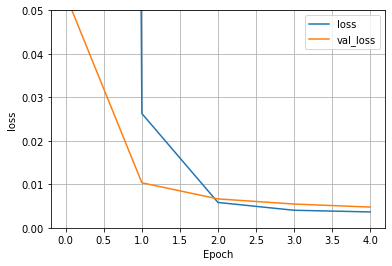

In [20]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.grid(True)
    plt.ylim([0,0.05])
    plt.xlabel('Epoch')
    plt.ylabel('loss')
    plt.legend()

plot_loss(history)

In [21]:
# Predict
test_predictions = model.predict(x_test).flatten()

In [22]:
test_predictions[0:10]

array([0.40968987, 0.40094063, 0.6599936 , 0.5809037 , 0.45786908,
       0.49211818, 0.6716283 , 0.5969751 , 0.5439308 , 0.4517425 ],
      dtype=float32)

In [23]:
y_test[0:10]

array([0.49519894, 0.53293526, 0.64095867, 0.7098776 , 0.50448245,
       0.5873393 , 0.6008063 , 0.5902904 , 0.60319865, 0.5457852 ],
      dtype=float32)

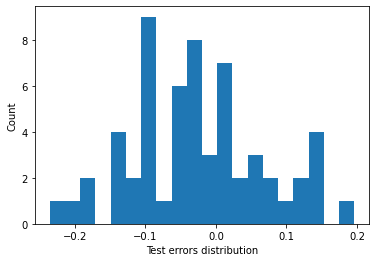

In [24]:
# Plot test data errors
plt.hist(test_predictions - y_test, bins=20)
plt.xlabel('Test errors distribution')
_ = plt.ylabel('Count')

In [36]:
# Save model
model.save(os.path.join(MODEL_DIR, 'test_model'))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /home/hhughes/Documents/Master_Thesis/Project/workspace/models/test_model/assets
